In [1]:
import tensorflow as tf

In [4]:
print(tf.__version__)

2.4.0-dev20200716


In [5]:
print("GPU available: ", tf.test.is_gpu_available())

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU available:  False


In [31]:
if tf.test.is_gpu_available():
    device_name= tf.test.gpu_device_name()
else:
    device_name= '/CPU:0'
print(device_name)

/CPU:0


In [7]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

In [13]:
#define a function for generator
def make_generator_network(num_hidden_layers=1,num_hidden_units=100,num_output_units= 784):
    model= tf.keras.Sequential()
    for i in range(num_hidden_layers):
        model.add(tf.keras.layers.Dense(units= num_hidden_units, use_bias= False))
        model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dense(units=num_output_units, activation='tanh'))
    return model
#define a function for the discriminator
def make_discriminator_network(num_hidden_layers=1, num_hidden_units=100, num_output_units=1):
    model= tf.keras.Sequential()
    for i in range(num_hidden_layers):
        model.add(tf.keras.layers.Dense(units= num_hidden_units))
        model.add(tf.keras.layers.LeakyReLU())
        model.add(tf.keras.layers.Dropout(rate=0.5))
    model.add(tf.keras.layers.Dense(units=num_output_units, activation=None))
    return model

In [14]:
image_size= (28,28)
z_size=20
model_z='uniform'
gen_hidden_layers=1
gen_hidden_size= 100
disc_hidden_layers=1
disc_hidden_size= 100

tf.random.set_seed(1)

gen_model= make_generator_network(num_hidden_layers= gen_hidden_layers,num_hidden_units= gen_hidden_size,num_output_units= np.prod(image_size))
gen_model.build(input_shape=(None, z_size))
gen_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               2000      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 784)               79184     
Total params: 81,184
Trainable params: 81,184
Non-trainable params: 0
_________________________________________________________________


In [15]:
disc_model= make_discriminator_network(num_hidden_layers= disc_hidden_layers,num_hidden_units= disc_hidden_size)
disc_model.build(input_shape= (None, np.prod(image_size)))
disc_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 100)               78500     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 100)               0         
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 101       
Total params: 78,601
Trainable params: 78,601
Non-trainable params: 0
_________________________________________________________________


### Define Training set

In [17]:
mnist_bldr= tfds.builder('mnist')
mnist_bldr.download_and_prepare()
mnist= mnist_bldr.as_dataset()

In [19]:
def preprocess(ex,mode='uniform'):
    image= ex['image']
    image= tf.image.convert_image_dtype(image, tf.float32)
    image= tf.reshape(image,[-1])
    image= image*2 -1.0
    if mode== 'uniform':
        input_z= tf.random.uniform(shape=(z_size,), minval=-1.0, maxval=1.0)
    elif mode=='normal':
        input_z= tf.random.normal(shape=(z_size,))
    return input_z, image

mnist_trainset= mnist['train']
mnist_trainset= mnist_trainset.map(preprocess)

In [20]:
mnist_trainset= mnist_trainset.batch(32, drop_remainder= True)
input_z, input_real= next(iter(mnist_trainset))
print('input-z -- shape: ', input_z.shape)
print('input-real -- shape: ', input_real.shape)

input-z -- shape:  (32, 20)
input-real -- shape:  (32, 784)


In [21]:
g_output= gen_model(input_z)
print('Output of G -- shape:', g_output.shape)

Output of G -- shape: (32, 784)


In [22]:
d_logits_real= disc_model(input_real)
d_logits_fake= disc_model(g_output)
print('Disc. (real) -- shape: ', d_logits_real.shape)
print('Disc. (fake) -- shape: ', d_logits_fake.shape)

Disc. (real) -- shape:  (32, 1)
Disc. (fake) -- shape:  (32, 1)


### Training the GAN Model

In [23]:
loss_fn= tf.keras.losses.BinaryCrossentropy(from_logits= True)

#loss for the generator
g_labels_real= tf.ones_like(d_logits_fake)
g_loss= loss_fn(y_true= g_labels_real, y_pred=d_logits_fake)
print('Generator loss: {:.4f}'.format(g_loss))

Generator loss: 0.7355


In [26]:
#Loss for the discriminator
d_labels_real= tf.ones_like(d_logits_real)
d_labels_fake= tf.zeros_like(d_logits_fake)
d_loss_real=loss_fn(y_true=d_labels_real, y_pred= d_logits_real)
d_loss_fake=loss_fn(y_true=d_labels_fake, y_pred= d_logits_fake)
print('Discriminator Losses: Real {:.4f} Fake {:.4f}'.format(d_loss_real.numpy(), d_loss_fake.numpy()))

Discriminator Losses: Real 1.5073 Fake 0.6583


In [35]:
import time
num_epochs=100
batch_size=64
image_size= (28,28)
z_size=20
mode_z='uniform'
gen_hidden_layers=1
gen_hidden_size=100
disc_hidden_layers=1
disc_hidden_size=100

tf.random.set_seed(1)
np.random.seed(1)

if mode_z=='uniform':
    fixed_z=tf.random.uniform(shape=(batch_size,z_size),minval=-1, maxval=1)
elif mode_z=='normal':
    fixed_z=tf.random.normal(shape=(batch_size,z_size))

def create_samples(g_model, input_z):
    g_output= g_model(input_z, training=False)
    images= tf.reshape(g_output, (batch_size, *image_size))
    return (images+1)/2.0



In [36]:
#setting up dataset
mnist_trainset= mnist['train']
mnist_trainset= mnist_trainset.map(lambda ex: preprocess(ex, mode=mode_z))
mnist_trainset= mnist_trainset.shuffle(10000)
mnist_trainset= mnist_trainset.batch(batch_size, drop_remainder= True)

In [37]:
#setting up the model
with tf.device(device_name):
    gen_model= make_generator_network(num_hidden_layers=gen_hidden_layers,num_hidden_units=gen_hidden_size,num_output_units= np.prod(image_size))
    gen_model.build(input_shape=(None, z_size))
    disc_model= make_discriminator_network(num_hidden_layers=disc_hidden_layers,num_hidden_units= disc_hidden_size)
    disc_model.build(input_shape=(None, np.prod(image_size)))

In [42]:
#Loss function and optimizers:
loss_fn= tf.keras.losses.BinaryCrossentropy(from_logits=True)
g_optimizer= tf.keras.optimizers.Adam()
d_optimizer= tf.keras.optimizers.Adam()
all_losses=[]
all_d_vals=[]
epoch_samples=[]
start_time= time.time()
for epoch in range(1, num_epochs+1):
    epoch_losses, epoch_d_vals=[],[]
    for i,(input_z,input_real) in enumerate(mnist_trainset):
        #compute the generator's loss
        with tf.GradientTape() as g_tape:
            g_output= gen_model(input_z)
            d_logits_fake= disc_model(g_output,training=True)
            labels_real= tf.ones_like(d_logits_fake)
            g_loss= loss_fn(y_true= labels_real, y_pred= d_logits_fake)
        #compute the gradients of g_loss
        g_grads= g_tape.gradient(g_loss, gen_model.trainable_variables)
        #optimization: apply the gradients
        g_optimizer.apply_gradients(grads_and_vars=zip(g_grads,gen_model.trainable_variables))
        #compute discriminator's loss
        with tf.GradientTape() as d_tape:
            
            d_logits_real= disc_model(input_real, training= True)
            d_labels_real= tf.ones_like(d_logits_real)
            d_loss_real= loss_fn(y_true= d_labels_real, y_pred= d_logits_real)
            d_logits_fake= disc_model(g_output,training=True)
            d_labels_fake= tf.zeros_like(d_logits_fake)
            d_loss_fake= loss_fn(y_true= d_labels_fake, y_pred= d_logits_fake)
            d_loss= d_loss_real+ d_loss_fake
        #compute the gradients of d_loss
        d_grads=d_tape.gradient(d_loss,disc_model.trainable_variables)
        #optimization :applying the gradients
        d_optimizer.apply_gradients(grads_and_vars=zip(d_grads,disc_model.trainable_variables))
        epoch_losses.append((g_loss.numpy(), d_loss.numpy(),d_loss_real.numpy(), d_loss_fake.numpy()))
        d_probs_real= tf.reduce_mean(tf.sigmoid(d_logits_real))
        d_probs_fake= tf.reduce_mean(tf.sigmoid(d_logits_fake))
        epoch_d_vals.append((d_probs_real.numpy(),d_probs_fake.numpy()))
        all_losses.append(epoch_losses)
        all_d_vals.append(epoch_d_vals)
        print('Epoch {:03d} | ET {:.2f} min | Avg Losses >> G/D {:.4f}/{:.4f} [D-Real: {:.4f} D-Fake: {:.4f}]'.format(epoch,(time.time()-start_time)/60, *list(np.mean(all_losses[-1],axis=0))))
        epoch_samples.append(create_samples(gen_model, fixed_z).numpy())
                    

Epoch 001 | ET 0.00 min | Avg Losses >> G/D 18.4851/0.0000 [D-Real: 0.0000 D-Fake: 0.0000]
Epoch 001 | ET 0.00 min | Avg Losses >> G/D 16.4874/0.0000 [D-Real: 0.0000 D-Fake: 0.0000]
Epoch 001 | ET 0.01 min | Avg Losses >> G/D 14.3368/0.0001 [D-Real: 0.0000 D-Fake: 0.0001]
Epoch 001 | ET 0.01 min | Avg Losses >> G/D 12.3608/0.0028 [D-Real: 0.0000 D-Fake: 0.0028]
Epoch 001 | ET 0.01 min | Avg Losses >> G/D 10.5724/0.0296 [D-Real: 0.0000 D-Fake: 0.0296]
Epoch 001 | ET 0.01 min | Avg Losses >> G/D 9.0057/0.1832 [D-Real: 0.0000 D-Fake: 0.1832]
Epoch 001 | ET 0.01 min | Avg Losses >> G/D 7.7833/0.4353 [D-Real: 0.0000 D-Fake: 0.4353]
Epoch 001 | ET 0.01 min | Avg Losses >> G/D 6.8350/0.7786 [D-Real: 0.0000 D-Fake: 0.7786]
Epoch 001 | ET 0.01 min | Avg Losses >> G/D 6.0820/1.1720 [D-Real: 0.0000 D-Fake: 1.1720]
Epoch 001 | ET 0.01 min | Avg Losses >> G/D 5.4764/1.5807 [D-Real: 0.0000 D-Fake: 1.5807]
Epoch 001 | ET 0.01 min | Avg Losses >> G/D 4.9796/1.9955 [D-Real: 0.0000 D-Fake: 1.9955]
Epoch

Epoch 001 | ET 0.04 min | Avg Losses >> G/D 1.2107/1.8829 [D-Real: 0.0326 D-Fake: 1.8504]
Epoch 001 | ET 0.04 min | Avg Losses >> G/D 1.2218/1.8759 [D-Real: 0.0322 D-Fake: 1.8437]
Epoch 001 | ET 0.04 min | Avg Losses >> G/D 1.2386/1.8651 [D-Real: 0.0319 D-Fake: 1.8332]
Epoch 001 | ET 0.04 min | Avg Losses >> G/D 1.2552/1.8548 [D-Real: 0.0315 D-Fake: 1.8233]
Epoch 001 | ET 0.04 min | Avg Losses >> G/D 1.2729/1.8475 [D-Real: 0.0313 D-Fake: 1.8162]
Epoch 001 | ET 0.04 min | Avg Losses >> G/D 1.2820/1.8424 [D-Real: 0.0310 D-Fake: 1.8114]
Epoch 001 | ET 0.04 min | Avg Losses >> G/D 1.2998/1.8352 [D-Real: 0.0307 D-Fake: 1.8046]
Epoch 001 | ET 0.04 min | Avg Losses >> G/D 1.3160/1.8306 [D-Real: 0.0304 D-Fake: 1.8002]
Epoch 001 | ET 0.04 min | Avg Losses >> G/D 1.3416/1.8298 [D-Real: 0.0301 D-Fake: 1.7998]
Epoch 001 | ET 0.04 min | Avg Losses >> G/D 1.3650/1.8251 [D-Real: 0.0298 D-Fake: 1.7953]
Epoch 001 | ET 0.04 min | Avg Losses >> G/D 1.3886/1.8160 [D-Real: 0.0299 D-Fake: 1.7861]
Epoch 001 

Epoch 001 | ET 0.08 min | Avg Losses >> G/D 2.6719/1.6783 [D-Real: 0.0713 D-Fake: 1.6070]
Epoch 001 | ET 0.08 min | Avg Losses >> G/D 2.7067/1.6713 [D-Real: 0.0709 D-Fake: 1.6004]
Epoch 001 | ET 0.08 min | Avg Losses >> G/D 2.7350/1.6652 [D-Real: 0.0706 D-Fake: 1.5946]
Epoch 001 | ET 0.08 min | Avg Losses >> G/D 2.7626/1.6583 [D-Real: 0.0703 D-Fake: 1.5881]
Epoch 001 | ET 0.08 min | Avg Losses >> G/D 2.7995/1.6523 [D-Real: 0.0699 D-Fake: 1.5824]
Epoch 001 | ET 0.08 min | Avg Losses >> G/D 2.8347/1.6449 [D-Real: 0.0696 D-Fake: 1.5753]
Epoch 001 | ET 0.08 min | Avg Losses >> G/D 2.8717/1.6397 [D-Real: 0.0693 D-Fake: 1.5705]
Epoch 001 | ET 0.08 min | Avg Losses >> G/D 2.9021/1.6322 [D-Real: 0.0689 D-Fake: 1.5633]
Epoch 001 | ET 0.08 min | Avg Losses >> G/D 2.9320/1.6264 [D-Real: 0.0687 D-Fake: 1.5577]
Epoch 001 | ET 0.08 min | Avg Losses >> G/D 2.9674/1.6191 [D-Real: 0.0684 D-Fake: 1.5506]
Epoch 001 | ET 0.08 min | Avg Losses >> G/D 2.9978/1.6129 [D-Real: 0.0682 D-Fake: 1.5447]
Epoch 001 

Epoch 001 | ET 0.11 min | Avg Losses >> G/D 5.1260/1.2527 [D-Real: 0.0529 D-Fake: 1.1998]
Epoch 001 | ET 0.11 min | Avg Losses >> G/D 5.1274/1.2505 [D-Real: 0.0528 D-Fake: 1.1977]
Epoch 001 | ET 0.11 min | Avg Losses >> G/D 5.1248/1.2469 [D-Real: 0.0526 D-Fake: 1.1943]
Epoch 001 | ET 0.11 min | Avg Losses >> G/D 5.1288/1.2434 [D-Real: 0.0525 D-Fake: 1.1909]
Epoch 001 | ET 0.11 min | Avg Losses >> G/D 5.1326/1.2407 [D-Real: 0.0523 D-Fake: 1.1885]
Epoch 001 | ET 0.11 min | Avg Losses >> G/D 5.1368/1.2389 [D-Real: 0.0521 D-Fake: 1.1868]
Epoch 001 | ET 0.11 min | Avg Losses >> G/D 5.1405/1.2354 [D-Real: 0.0520 D-Fake: 1.1834]
Epoch 001 | ET 0.11 min | Avg Losses >> G/D 5.1460/1.2313 [D-Real: 0.0519 D-Fake: 1.1795]
Epoch 001 | ET 0.11 min | Avg Losses >> G/D 5.1517/1.2278 [D-Real: 0.0517 D-Fake: 1.1761]
Epoch 001 | ET 0.12 min | Avg Losses >> G/D 5.1524/1.2246 [D-Real: 0.0516 D-Fake: 1.1730]
Epoch 001 | ET 0.12 min | Avg Losses >> G/D 5.1542/1.2216 [D-Real: 0.0515 D-Fake: 1.1702]
Epoch 001 

Epoch 001 | ET 0.15 min | Avg Losses >> G/D 5.1547/0.9912 [D-Real: 0.0408 D-Fake: 0.9504]
Epoch 001 | ET 0.15 min | Avg Losses >> G/D 5.1597/0.9889 [D-Real: 0.0407 D-Fake: 0.9482]
Epoch 001 | ET 0.15 min | Avg Losses >> G/D 5.1634/0.9865 [D-Real: 0.0406 D-Fake: 0.9458]
Epoch 001 | ET 0.15 min | Avg Losses >> G/D 5.1695/0.9842 [D-Real: 0.0405 D-Fake: 0.9437]
Epoch 001 | ET 0.15 min | Avg Losses >> G/D 5.1739/0.9819 [D-Real: 0.0406 D-Fake: 0.9413]
Epoch 001 | ET 0.15 min | Avg Losses >> G/D 5.1773/0.9796 [D-Real: 0.0405 D-Fake: 0.9390]
Epoch 001 | ET 0.15 min | Avg Losses >> G/D 5.1817/0.9772 [D-Real: 0.0404 D-Fake: 0.9367]
Epoch 001 | ET 0.15 min | Avg Losses >> G/D 5.1837/0.9747 [D-Real: 0.0403 D-Fake: 0.9344]
Epoch 001 | ET 0.15 min | Avg Losses >> G/D 5.1855/0.9724 [D-Real: 0.0402 D-Fake: 0.9321]
Epoch 001 | ET 0.15 min | Avg Losses >> G/D 5.1862/0.9703 [D-Real: 0.0401 D-Fake: 0.9301]
Epoch 001 | ET 0.15 min | Avg Losses >> G/D 5.1890/0.9680 [D-Real: 0.0400 D-Fake: 0.9280]
Epoch 001 

Epoch 001 | ET 0.18 min | Avg Losses >> G/D 4.9176/0.8113 [D-Real: 0.0348 D-Fake: 0.7765]
Epoch 001 | ET 0.18 min | Avg Losses >> G/D 4.9139/0.8099 [D-Real: 0.0348 D-Fake: 0.7751]
Epoch 001 | ET 0.19 min | Avg Losses >> G/D 4.9103/0.8084 [D-Real: 0.0347 D-Fake: 0.7737]
Epoch 001 | ET 0.19 min | Avg Losses >> G/D 4.9063/0.8070 [D-Real: 0.0347 D-Fake: 0.7724]
Epoch 001 | ET 0.19 min | Avg Losses >> G/D 4.9024/0.8056 [D-Real: 0.0346 D-Fake: 0.7709]
Epoch 001 | ET 0.19 min | Avg Losses >> G/D 4.8982/0.8041 [D-Real: 0.0346 D-Fake: 0.7695]
Epoch 001 | ET 0.19 min | Avg Losses >> G/D 4.8955/0.8027 [D-Real: 0.0345 D-Fake: 0.7681]
Epoch 001 | ET 0.19 min | Avg Losses >> G/D 4.8922/0.8013 [D-Real: 0.0345 D-Fake: 0.7668]
Epoch 001 | ET 0.19 min | Avg Losses >> G/D 4.8884/0.7998 [D-Real: 0.0344 D-Fake: 0.7654]
Epoch 001 | ET 0.19 min | Avg Losses >> G/D 4.8859/0.7983 [D-Real: 0.0344 D-Fake: 0.7639]
Epoch 001 | ET 0.19 min | Avg Losses >> G/D 4.8824/0.7968 [D-Real: 0.0343 D-Fake: 0.7625]
Epoch 001 

Epoch 001 | ET 0.22 min | Avg Losses >> G/D 4.6242/0.6880 [D-Real: 0.0309 D-Fake: 0.6570]
Epoch 001 | ET 0.22 min | Avg Losses >> G/D 4.6215/0.6869 [D-Real: 0.0309 D-Fake: 0.6560]
Epoch 001 | ET 0.22 min | Avg Losses >> G/D 4.6184/0.6860 [D-Real: 0.0309 D-Fake: 0.6550]
Epoch 001 | ET 0.22 min | Avg Losses >> G/D 4.6157/0.6850 [D-Real: 0.0310 D-Fake: 0.6540]
Epoch 001 | ET 0.22 min | Avg Losses >> G/D 4.6127/0.6840 [D-Real: 0.0309 D-Fake: 0.6531]
Epoch 001 | ET 0.22 min | Avg Losses >> G/D 4.6099/0.6830 [D-Real: 0.0309 D-Fake: 0.6521]
Epoch 001 | ET 0.22 min | Avg Losses >> G/D 4.6067/0.6820 [D-Real: 0.0309 D-Fake: 0.6511]
Epoch 001 | ET 0.22 min | Avg Losses >> G/D 4.6036/0.6810 [D-Real: 0.0308 D-Fake: 0.6502]
Epoch 001 | ET 0.22 min | Avg Losses >> G/D 4.6005/0.6801 [D-Real: 0.0308 D-Fake: 0.6493]
Epoch 001 | ET 0.22 min | Avg Losses >> G/D 4.5974/0.6792 [D-Real: 0.0307 D-Fake: 0.6484]
Epoch 001 | ET 0.22 min | Avg Losses >> G/D 4.5943/0.6782 [D-Real: 0.0307 D-Fake: 0.6475]
Epoch 001 

Epoch 001 | ET 0.26 min | Avg Losses >> G/D 4.3895/0.6036 [D-Real: 0.0287 D-Fake: 0.5749]
Epoch 001 | ET 0.26 min | Avg Losses >> G/D 4.3867/0.6029 [D-Real: 0.0288 D-Fake: 0.5742]
Epoch 001 | ET 0.26 min | Avg Losses >> G/D 4.3843/0.6022 [D-Real: 0.0287 D-Fake: 0.5735]
Epoch 001 | ET 0.26 min | Avg Losses >> G/D 4.3817/0.6015 [D-Real: 0.0287 D-Fake: 0.5728]
Epoch 001 | ET 0.26 min | Avg Losses >> G/D 4.3792/0.6008 [D-Real: 0.0287 D-Fake: 0.5721]
Epoch 001 | ET 0.26 min | Avg Losses >> G/D 4.3768/0.6001 [D-Real: 0.0287 D-Fake: 0.5714]
Epoch 001 | ET 0.26 min | Avg Losses >> G/D 4.3744/0.5994 [D-Real: 0.0287 D-Fake: 0.5707]
Epoch 001 | ET 0.26 min | Avg Losses >> G/D 4.3719/0.5988 [D-Real: 0.0287 D-Fake: 0.5701]
Epoch 001 | ET 0.26 min | Avg Losses >> G/D 4.3693/0.5981 [D-Real: 0.0287 D-Fake: 0.5694]
Epoch 001 | ET 0.26 min | Avg Losses >> G/D 4.3668/0.5974 [D-Real: 0.0287 D-Fake: 0.5687]
Epoch 001 | ET 0.26 min | Avg Losses >> G/D 4.3643/0.5967 [D-Real: 0.0287 D-Fake: 0.5681]
Epoch 001 

Epoch 001 | ET 0.30 min | Avg Losses >> G/D 4.1649/0.5434 [D-Real: 0.0287 D-Fake: 0.5147]
Epoch 001 | ET 0.30 min | Avg Losses >> G/D 4.1629/0.5429 [D-Real: 0.0287 D-Fake: 0.5142]
Epoch 001 | ET 0.30 min | Avg Losses >> G/D 4.1610/0.5424 [D-Real: 0.0287 D-Fake: 0.5137]
Epoch 001 | ET 0.30 min | Avg Losses >> G/D 4.1592/0.5419 [D-Real: 0.0287 D-Fake: 0.5132]
Epoch 001 | ET 0.30 min | Avg Losses >> G/D 4.1574/0.5413 [D-Real: 0.0287 D-Fake: 0.5126]
Epoch 001 | ET 0.30 min | Avg Losses >> G/D 4.1557/0.5408 [D-Real: 0.0287 D-Fake: 0.5121]
Epoch 001 | ET 0.30 min | Avg Losses >> G/D 4.1540/0.5403 [D-Real: 0.0287 D-Fake: 0.5116]
Epoch 001 | ET 0.30 min | Avg Losses >> G/D 4.1524/0.5398 [D-Real: 0.0287 D-Fake: 0.5111]
Epoch 001 | ET 0.30 min | Avg Losses >> G/D 4.1511/0.5393 [D-Real: 0.0288 D-Fake: 0.5105]
Epoch 001 | ET 0.30 min | Avg Losses >> G/D 4.1495/0.5387 [D-Real: 0.0288 D-Fake: 0.5100]
Epoch 001 | ET 0.30 min | Avg Losses >> G/D 4.1477/0.5382 [D-Real: 0.0287 D-Fake: 0.5094]
Epoch 001 

Epoch 001 | ET 0.33 min | Avg Losses >> G/D 4.0267/0.4980 [D-Real: 0.0289 D-Fake: 0.4691]
Epoch 001 | ET 0.33 min | Avg Losses >> G/D 4.0256/0.4975 [D-Real: 0.0289 D-Fake: 0.4687]
Epoch 001 | ET 0.33 min | Avg Losses >> G/D 4.0250/0.4970 [D-Real: 0.0289 D-Fake: 0.4682]
Epoch 001 | ET 0.33 min | Avg Losses >> G/D 4.0247/0.4967 [D-Real: 0.0290 D-Fake: 0.4677]
Epoch 001 | ET 0.33 min | Avg Losses >> G/D 4.0241/0.4963 [D-Real: 0.0290 D-Fake: 0.4673]
Epoch 001 | ET 0.33 min | Avg Losses >> G/D 4.0231/0.4959 [D-Real: 0.0290 D-Fake: 0.4669]
Epoch 001 | ET 0.33 min | Avg Losses >> G/D 4.0220/0.4955 [D-Real: 0.0290 D-Fake: 0.4665]
Epoch 001 | ET 0.33 min | Avg Losses >> G/D 4.0210/0.4951 [D-Real: 0.0290 D-Fake: 0.4661]
Epoch 001 | ET 0.33 min | Avg Losses >> G/D 4.0195/0.4946 [D-Real: 0.0289 D-Fake: 0.4657]
Epoch 001 | ET 0.34 min | Avg Losses >> G/D 4.0186/0.4942 [D-Real: 0.0289 D-Fake: 0.4653]
Epoch 001 | ET 0.34 min | Avg Losses >> G/D 4.0180/0.4938 [D-Real: 0.0289 D-Fake: 0.4649]
Epoch 001 

Epoch 002 | ET 0.37 min | Avg Losses >> G/D 3.4234/0.1288 [D-Real: 0.0339 D-Fake: 0.0948]
Epoch 002 | ET 0.37 min | Avg Losses >> G/D 3.4253/0.1283 [D-Real: 0.0336 D-Fake: 0.0948]
Epoch 002 | ET 0.37 min | Avg Losses >> G/D 3.4232/0.1274 [D-Real: 0.0331 D-Fake: 0.0943]
Epoch 002 | ET 0.37 min | Avg Losses >> G/D 3.4333/0.1280 [D-Real: 0.0328 D-Fake: 0.0952]
Epoch 002 | ET 0.37 min | Avg Losses >> G/D 3.4444/0.1267 [D-Real: 0.0323 D-Fake: 0.0944]
Epoch 002 | ET 0.37 min | Avg Losses >> G/D 3.4527/0.1268 [D-Real: 0.0325 D-Fake: 0.0943]
Epoch 002 | ET 0.37 min | Avg Losses >> G/D 3.4604/0.1259 [D-Real: 0.0322 D-Fake: 0.0937]
Epoch 002 | ET 0.38 min | Avg Losses >> G/D 3.4685/0.1252 [D-Real: 0.0318 D-Fake: 0.0933]
Epoch 002 | ET 0.38 min | Avg Losses >> G/D 3.4770/0.1242 [D-Real: 0.0319 D-Fake: 0.0923]
Epoch 002 | ET 0.38 min | Avg Losses >> G/D 3.4892/0.1230 [D-Real: 0.0314 D-Fake: 0.0916]
Epoch 002 | ET 0.38 min | Avg Losses >> G/D 3.5173/0.1237 [D-Real: 0.0312 D-Fake: 0.0925]
Epoch 002 

Epoch 002 | ET 0.41 min | Avg Losses >> G/D 3.6619/0.1278 [D-Real: 0.0331 D-Fake: 0.0948]
Epoch 002 | ET 0.41 min | Avg Losses >> G/D 3.6632/0.1280 [D-Real: 0.0333 D-Fake: 0.0948]
Epoch 002 | ET 0.41 min | Avg Losses >> G/D 3.6641/0.1278 [D-Real: 0.0331 D-Fake: 0.0947]
Epoch 002 | ET 0.41 min | Avg Losses >> G/D 3.6639/0.1278 [D-Real: 0.0329 D-Fake: 0.0948]
Epoch 002 | ET 0.41 min | Avg Losses >> G/D 3.6608/0.1282 [D-Real: 0.0330 D-Fake: 0.0952]
Epoch 002 | ET 0.41 min | Avg Losses >> G/D 3.6607/0.1283 [D-Real: 0.0333 D-Fake: 0.0950]
Epoch 002 | ET 0.41 min | Avg Losses >> G/D 3.6595/0.1285 [D-Real: 0.0332 D-Fake: 0.0952]
Epoch 002 | ET 0.41 min | Avg Losses >> G/D 3.6612/0.1283 [D-Real: 0.0332 D-Fake: 0.0951]
Epoch 002 | ET 0.41 min | Avg Losses >> G/D 3.6665/0.1281 [D-Real: 0.0331 D-Fake: 0.0950]
Epoch 002 | ET 0.41 min | Avg Losses >> G/D 3.6693/0.1280 [D-Real: 0.0331 D-Fake: 0.0949]
Epoch 002 | ET 0.41 min | Avg Losses >> G/D 3.6733/0.1278 [D-Real: 0.0332 D-Fake: 0.0946]
Epoch 002 

Epoch 002 | ET 0.44 min | Avg Losses >> G/D 3.8424/0.1310 [D-Real: 0.0357 D-Fake: 0.0952]
Epoch 002 | ET 0.44 min | Avg Losses >> G/D 3.8406/0.1313 [D-Real: 0.0358 D-Fake: 0.0954]
Epoch 002 | ET 0.44 min | Avg Losses >> G/D 3.8397/0.1316 [D-Real: 0.0358 D-Fake: 0.0958]
Epoch 002 | ET 0.45 min | Avg Losses >> G/D 3.8380/0.1314 [D-Real: 0.0358 D-Fake: 0.0956]
Epoch 002 | ET 0.45 min | Avg Losses >> G/D 3.8382/0.1315 [D-Real: 0.0359 D-Fake: 0.0956]
Epoch 002 | ET 0.45 min | Avg Losses >> G/D 3.8377/0.1317 [D-Real: 0.0359 D-Fake: 0.0958]
Epoch 002 | ET 0.45 min | Avg Losses >> G/D 3.8397/0.1317 [D-Real: 0.0360 D-Fake: 0.0957]
Epoch 002 | ET 0.45 min | Avg Losses >> G/D 3.8404/0.1320 [D-Real: 0.0360 D-Fake: 0.0960]
Epoch 002 | ET 0.45 min | Avg Losses >> G/D 3.8418/0.1321 [D-Real: 0.0361 D-Fake: 0.0961]
Epoch 002 | ET 0.45 min | Avg Losses >> G/D 3.8441/0.1324 [D-Real: 0.0362 D-Fake: 0.0962]
Epoch 002 | ET 0.45 min | Avg Losses >> G/D 3.8453/0.1325 [D-Real: 0.0362 D-Fake: 0.0963]
Epoch 002 

Epoch 002 | ET 0.48 min | Avg Losses >> G/D 3.9982/0.1394 [D-Real: 0.0400 D-Fake: 0.0994]
Epoch 002 | ET 0.48 min | Avg Losses >> G/D 3.9960/0.1396 [D-Real: 0.0399 D-Fake: 0.0997]
Epoch 002 | ET 0.48 min | Avg Losses >> G/D 3.9966/0.1400 [D-Real: 0.0400 D-Fake: 0.1000]
Epoch 002 | ET 0.48 min | Avg Losses >> G/D 3.9973/0.1402 [D-Real: 0.0401 D-Fake: 0.1001]
Epoch 002 | ET 0.48 min | Avg Losses >> G/D 3.9993/0.1405 [D-Real: 0.0404 D-Fake: 0.1001]
Epoch 002 | ET 0.48 min | Avg Losses >> G/D 3.9991/0.1405 [D-Real: 0.0404 D-Fake: 0.1001]
Epoch 002 | ET 0.48 min | Avg Losses >> G/D 3.9988/0.1407 [D-Real: 0.0404 D-Fake: 0.1003]
Epoch 002 | ET 0.48 min | Avg Losses >> G/D 3.9977/0.1409 [D-Real: 0.0404 D-Fake: 0.1005]
Epoch 002 | ET 0.48 min | Avg Losses >> G/D 3.9960/0.1411 [D-Real: 0.0405 D-Fake: 0.1005]
Epoch 002 | ET 0.48 min | Avg Losses >> G/D 3.9950/0.1415 [D-Real: 0.0408 D-Fake: 0.1007]
Epoch 002 | ET 0.48 min | Avg Losses >> G/D 3.9953/0.1417 [D-Real: 0.0408 D-Fake: 0.1009]
Epoch 002 

Epoch 002 | ET 0.52 min | Avg Losses >> G/D 4.0693/0.1532 [D-Real: 0.0447 D-Fake: 0.1084]
Epoch 002 | ET 0.52 min | Avg Losses >> G/D 4.0698/0.1532 [D-Real: 0.0448 D-Fake: 0.1084]
Epoch 002 | ET 0.52 min | Avg Losses >> G/D 4.0687/0.1534 [D-Real: 0.0448 D-Fake: 0.1087]
Epoch 002 | ET 0.52 min | Avg Losses >> G/D 4.0701/0.1538 [D-Real: 0.0447 D-Fake: 0.1091]
Epoch 002 | ET 0.52 min | Avg Losses >> G/D 4.0705/0.1539 [D-Real: 0.0448 D-Fake: 0.1091]
Epoch 002 | ET 0.52 min | Avg Losses >> G/D 4.0736/0.1540 [D-Real: 0.0448 D-Fake: 0.1092]
Epoch 002 | ET 0.52 min | Avg Losses >> G/D 4.0762/0.1543 [D-Real: 0.0449 D-Fake: 0.1094]
Epoch 002 | ET 0.52 min | Avg Losses >> G/D 4.0795/0.1545 [D-Real: 0.0450 D-Fake: 0.1095]
Epoch 002 | ET 0.52 min | Avg Losses >> G/D 4.0826/0.1544 [D-Real: 0.0451 D-Fake: 0.1094]
Epoch 002 | ET 0.52 min | Avg Losses >> G/D 4.0846/0.1546 [D-Real: 0.0451 D-Fake: 0.1095]
Epoch 002 | ET 0.52 min | Avg Losses >> G/D 4.0853/0.1550 [D-Real: 0.0450 D-Fake: 0.1100]
Epoch 002 

Epoch 002 | ET 0.55 min | Avg Losses >> G/D 4.2683/0.1681 [D-Real: 0.0486 D-Fake: 0.1195]
Epoch 002 | ET 0.55 min | Avg Losses >> G/D 4.2721/0.1681 [D-Real: 0.0486 D-Fake: 0.1195]
Epoch 002 | ET 0.55 min | Avg Losses >> G/D 4.2767/0.1682 [D-Real: 0.0485 D-Fake: 0.1197]
Epoch 002 | ET 0.55 min | Avg Losses >> G/D 4.2825/0.1683 [D-Real: 0.0487 D-Fake: 0.1196]
Epoch 002 | ET 0.56 min | Avg Losses >> G/D 4.2891/0.1684 [D-Real: 0.0489 D-Fake: 0.1195]
Epoch 002 | ET 0.56 min | Avg Losses >> G/D 4.2921/0.1686 [D-Real: 0.0490 D-Fake: 0.1195]
Epoch 002 | ET 0.56 min | Avg Losses >> G/D 4.2950/0.1684 [D-Real: 0.0490 D-Fake: 0.1194]
Epoch 002 | ET 0.56 min | Avg Losses >> G/D 4.2968/0.1685 [D-Real: 0.0489 D-Fake: 0.1196]
Epoch 002 | ET 0.56 min | Avg Losses >> G/D 4.2996/0.1687 [D-Real: 0.0488 D-Fake: 0.1198]
Epoch 002 | ET 0.56 min | Avg Losses >> G/D 4.3007/0.1688 [D-Real: 0.0488 D-Fake: 0.1200]
Epoch 002 | ET 0.56 min | Avg Losses >> G/D 4.3041/0.1689 [D-Real: 0.0487 D-Fake: 0.1201]
Epoch 002 

Epoch 002 | ET 0.59 min | Avg Losses >> G/D 4.7544/0.1887 [D-Real: 0.0524 D-Fake: 0.1364]
Epoch 002 | ET 0.59 min | Avg Losses >> G/D 4.7615/0.1887 [D-Real: 0.0524 D-Fake: 0.1364]
Epoch 002 | ET 0.59 min | Avg Losses >> G/D 4.7668/0.1891 [D-Real: 0.0524 D-Fake: 0.1367]
Epoch 002 | ET 0.59 min | Avg Losses >> G/D 4.7722/0.1892 [D-Real: 0.0527 D-Fake: 0.1366]
Epoch 002 | ET 0.59 min | Avg Losses >> G/D 4.7781/0.1894 [D-Real: 0.0527 D-Fake: 0.1367]
Epoch 002 | ET 0.59 min | Avg Losses >> G/D 4.7842/0.1897 [D-Real: 0.0527 D-Fake: 0.1370]
Epoch 002 | ET 0.59 min | Avg Losses >> G/D 4.7891/0.1901 [D-Real: 0.0527 D-Fake: 0.1375]
Epoch 002 | ET 0.59 min | Avg Losses >> G/D 4.7929/0.1905 [D-Real: 0.0527 D-Fake: 0.1377]
Epoch 002 | ET 0.59 min | Avg Losses >> G/D 4.7996/0.1907 [D-Real: 0.0527 D-Fake: 0.1380]
Epoch 002 | ET 0.59 min | Avg Losses >> G/D 4.8055/0.1907 [D-Real: 0.0528 D-Fake: 0.1379]
Epoch 002 | ET 0.59 min | Avg Losses >> G/D 4.8131/0.1913 [D-Real: 0.0529 D-Fake: 0.1384]
Epoch 002 

Epoch 002 | ET 0.63 min | Avg Losses >> G/D 5.1500/0.2116 [D-Real: 0.0578 D-Fake: 0.1537]
Epoch 002 | ET 0.63 min | Avg Losses >> G/D 5.1522/0.2118 [D-Real: 0.0579 D-Fake: 0.1540]
Epoch 002 | ET 0.63 min | Avg Losses >> G/D 5.1534/0.2120 [D-Real: 0.0580 D-Fake: 0.1540]
Epoch 002 | ET 0.63 min | Avg Losses >> G/D 5.1544/0.2123 [D-Real: 0.0581 D-Fake: 0.1542]
Epoch 002 | ET 0.63 min | Avg Losses >> G/D 5.1562/0.2127 [D-Real: 0.0581 D-Fake: 0.1545]
Epoch 002 | ET 0.63 min | Avg Losses >> G/D 5.1581/0.2128 [D-Real: 0.0581 D-Fake: 0.1547]
Epoch 002 | ET 0.63 min | Avg Losses >> G/D 5.1607/0.2129 [D-Real: 0.0582 D-Fake: 0.1547]
Epoch 002 | ET 0.63 min | Avg Losses >> G/D 5.1617/0.2129 [D-Real: 0.0583 D-Fake: 0.1547]
Epoch 002 | ET 0.63 min | Avg Losses >> G/D 5.1630/0.2133 [D-Real: 0.0583 D-Fake: 0.1549]
Epoch 002 | ET 0.63 min | Avg Losses >> G/D 5.1631/0.2133 [D-Real: 0.0583 D-Fake: 0.1550]
Epoch 002 | ET 0.63 min | Avg Losses >> G/D 5.1639/0.2139 [D-Real: 0.0583 D-Fake: 0.1556]
Epoch 002 

Epoch 002 | ET 0.66 min | Avg Losses >> G/D 5.2232/0.2281 [D-Real: 0.0641 D-Fake: 0.1640]
Epoch 002 | ET 0.66 min | Avg Losses >> G/D 5.2229/0.2282 [D-Real: 0.0643 D-Fake: 0.1640]
Epoch 002 | ET 0.66 min | Avg Losses >> G/D 5.2224/0.2283 [D-Real: 0.0644 D-Fake: 0.1639]
Epoch 002 | ET 0.66 min | Avg Losses >> G/D 5.2224/0.2285 [D-Real: 0.0644 D-Fake: 0.1642]
Epoch 002 | ET 0.66 min | Avg Losses >> G/D 5.2218/0.2286 [D-Real: 0.0644 D-Fake: 0.1642]
Epoch 002 | ET 0.66 min | Avg Losses >> G/D 5.2199/0.2288 [D-Real: 0.0645 D-Fake: 0.1642]
Epoch 002 | ET 0.66 min | Avg Losses >> G/D 5.2197/0.2290 [D-Real: 0.0647 D-Fake: 0.1643]
Epoch 002 | ET 0.66 min | Avg Losses >> G/D 5.2186/0.2292 [D-Real: 0.0647 D-Fake: 0.1645]
Epoch 002 | ET 0.66 min | Avg Losses >> G/D 5.2190/0.2294 [D-Real: 0.0649 D-Fake: 0.1646]
Epoch 002 | ET 0.67 min | Avg Losses >> G/D 5.2184/0.2296 [D-Real: 0.0650 D-Fake: 0.1646]
Epoch 002 | ET 0.67 min | Avg Losses >> G/D 5.2167/0.2297 [D-Real: 0.0651 D-Fake: 0.1646]
Epoch 002 

Epoch 002 | ET 0.70 min | Avg Losses >> G/D 5.1059/0.2417 [D-Real: 0.0725 D-Fake: 0.1692]
Epoch 002 | ET 0.70 min | Avg Losses >> G/D 5.1059/0.2420 [D-Real: 0.0727 D-Fake: 0.1692]
Epoch 002 | ET 0.70 min | Avg Losses >> G/D 5.1049/0.2422 [D-Real: 0.0729 D-Fake: 0.1693]
Epoch 002 | ET 0.70 min | Avg Losses >> G/D 5.1028/0.2426 [D-Real: 0.0729 D-Fake: 0.1696]
Epoch 002 | ET 0.70 min | Avg Losses >> G/D 5.1004/0.2428 [D-Real: 0.0729 D-Fake: 0.1698]
Epoch 002 | ET 0.70 min | Avg Losses >> G/D 5.0994/0.2430 [D-Real: 0.0731 D-Fake: 0.1699]
Epoch 002 | ET 0.70 min | Avg Losses >> G/D 5.0990/0.2433 [D-Real: 0.0733 D-Fake: 0.1700]
Epoch 002 | ET 0.70 min | Avg Losses >> G/D 5.0973/0.2435 [D-Real: 0.0734 D-Fake: 0.1701]
Epoch 002 | ET 0.70 min | Avg Losses >> G/D 5.0959/0.2437 [D-Real: 0.0735 D-Fake: 0.1702]
Epoch 002 | ET 0.70 min | Avg Losses >> G/D 5.0942/0.2438 [D-Real: 0.0735 D-Fake: 0.1703]
Epoch 002 | ET 0.70 min | Avg Losses >> G/D 5.0921/0.2439 [D-Real: 0.0735 D-Fake: 0.1704]
Epoch 002 

Epoch 003 | ET 0.73 min | Avg Losses >> G/D 3.8924/0.4580 [D-Real: 0.1815 D-Fake: 0.2766]
Epoch 003 | ET 0.73 min | Avg Losses >> G/D 3.8934/0.4577 [D-Real: 0.1822 D-Fake: 0.2755]
Epoch 003 | ET 0.73 min | Avg Losses >> G/D 3.8931/0.4579 [D-Real: 0.1841 D-Fake: 0.2738]
Epoch 003 | ET 0.74 min | Avg Losses >> G/D 3.8811/0.4587 [D-Real: 0.1836 D-Fake: 0.2751]
Epoch 003 | ET 0.74 min | Avg Losses >> G/D 3.8765/0.4579 [D-Real: 0.1828 D-Fake: 0.2752]
Epoch 003 | ET 0.74 min | Avg Losses >> G/D 3.8755/0.4582 [D-Real: 0.1829 D-Fake: 0.2753]
Epoch 003 | ET 0.74 min | Avg Losses >> G/D 3.8712/0.4579 [D-Real: 0.1831 D-Fake: 0.2748]
Epoch 003 | ET 0.74 min | Avg Losses >> G/D 3.8735/0.4606 [D-Real: 0.1857 D-Fake: 0.2750]
Epoch 003 | ET 0.74 min | Avg Losses >> G/D 3.8711/0.4618 [D-Real: 0.1869 D-Fake: 0.2749]
Epoch 003 | ET 0.74 min | Avg Losses >> G/D 3.8608/0.4615 [D-Real: 0.1860 D-Fake: 0.2756]
Epoch 003 | ET 0.74 min | Avg Losses >> G/D 3.8582/0.4618 [D-Real: 0.1863 D-Fake: 0.2755]
Epoch 003 

Epoch 003 | ET 0.77 min | Avg Losses >> G/D 4.1525/0.4668 [D-Real: 0.1857 D-Fake: 0.2811]
Epoch 003 | ET 0.77 min | Avg Losses >> G/D 4.1516/0.4676 [D-Real: 0.1854 D-Fake: 0.2821]
Epoch 003 | ET 0.77 min | Avg Losses >> G/D 4.1506/0.4677 [D-Real: 0.1851 D-Fake: 0.2826]
Epoch 003 | ET 0.77 min | Avg Losses >> G/D 4.1533/0.4670 [D-Real: 0.1852 D-Fake: 0.2817]
Epoch 003 | ET 0.77 min | Avg Losses >> G/D 4.1580/0.4672 [D-Real: 0.1859 D-Fake: 0.2813]
Epoch 003 | ET 0.77 min | Avg Losses >> G/D 4.1561/0.4666 [D-Real: 0.1853 D-Fake: 0.2813]
Epoch 003 | ET 0.77 min | Avg Losses >> G/D 4.1548/0.4663 [D-Real: 0.1849 D-Fake: 0.2814]
Epoch 003 | ET 0.77 min | Avg Losses >> G/D 4.1548/0.4668 [D-Real: 0.1849 D-Fake: 0.2819]
Epoch 003 | ET 0.77 min | Avg Losses >> G/D 4.1524/0.4673 [D-Real: 0.1850 D-Fake: 0.2823]
Epoch 003 | ET 0.77 min | Avg Losses >> G/D 4.1581/0.4682 [D-Real: 0.1854 D-Fake: 0.2828]
Epoch 003 | ET 0.77 min | Avg Losses >> G/D 4.1642/0.4684 [D-Real: 0.1861 D-Fake: 0.2822]
Epoch 003 

Epoch 003 | ET 0.81 min | Avg Losses >> G/D 4.2915/0.4711 [D-Real: 0.1831 D-Fake: 0.2880]
Epoch 003 | ET 0.81 min | Avg Losses >> G/D 4.2937/0.4707 [D-Real: 0.1834 D-Fake: 0.2874]
Epoch 003 | ET 0.81 min | Avg Losses >> G/D 4.2958/0.4711 [D-Real: 0.1829 D-Fake: 0.2882]
Epoch 003 | ET 0.81 min | Avg Losses >> G/D 4.2935/0.4709 [D-Real: 0.1825 D-Fake: 0.2884]
Epoch 003 | ET 0.81 min | Avg Losses >> G/D 4.2959/0.4711 [D-Real: 0.1821 D-Fake: 0.2890]
Epoch 003 | ET 0.81 min | Avg Losses >> G/D 4.2981/0.4707 [D-Real: 0.1819 D-Fake: 0.2887]
Epoch 003 | ET 0.81 min | Avg Losses >> G/D 4.3008/0.4701 [D-Real: 0.1821 D-Fake: 0.2881]
Epoch 003 | ET 0.81 min | Avg Losses >> G/D 4.3074/0.4696 [D-Real: 0.1820 D-Fake: 0.2875]
Epoch 003 | ET 0.81 min | Avg Losses >> G/D 4.3099/0.4698 [D-Real: 0.1823 D-Fake: 0.2875]
Epoch 003 | ET 0.81 min | Avg Losses >> G/D 4.3130/0.4694 [D-Real: 0.1822 D-Fake: 0.2872]
Epoch 003 | ET 0.81 min | Avg Losses >> G/D 4.3141/0.4693 [D-Real: 0.1819 D-Fake: 0.2874]
Epoch 003 

Epoch 003 | ET 0.85 min | Avg Losses >> G/D 4.3314/0.4884 [D-Real: 0.1865 D-Fake: 0.3019]
Epoch 003 | ET 0.85 min | Avg Losses >> G/D 4.3303/0.4883 [D-Real: 0.1864 D-Fake: 0.3019]
Epoch 003 | ET 0.85 min | Avg Losses >> G/D 4.3318/0.4887 [D-Real: 0.1867 D-Fake: 0.3019]
Epoch 003 | ET 0.85 min | Avg Losses >> G/D 4.3320/0.4887 [D-Real: 0.1872 D-Fake: 0.3015]
Epoch 003 | ET 0.85 min | Avg Losses >> G/D 4.3321/0.4884 [D-Real: 0.1871 D-Fake: 0.3012]
Epoch 003 | ET 0.85 min | Avg Losses >> G/D 4.3300/0.4880 [D-Real: 0.1868 D-Fake: 0.3012]
Epoch 003 | ET 0.85 min | Avg Losses >> G/D 4.3282/0.4883 [D-Real: 0.1867 D-Fake: 0.3016]
Epoch 003 | ET 0.85 min | Avg Losses >> G/D 4.3245/0.4894 [D-Real: 0.1868 D-Fake: 0.3026]
Epoch 003 | ET 0.85 min | Avg Losses >> G/D 4.3247/0.4898 [D-Real: 0.1869 D-Fake: 0.3028]
Epoch 003 | ET 0.85 min | Avg Losses >> G/D 4.3254/0.4903 [D-Real: 0.1873 D-Fake: 0.3030]
Epoch 003 | ET 0.85 min | Avg Losses >> G/D 4.3260/0.4899 [D-Real: 0.1874 D-Fake: 0.3025]
Epoch 003 

Epoch 003 | ET 0.88 min | Avg Losses >> G/D 4.3872/0.4989 [D-Real: 0.1905 D-Fake: 0.3084]
Epoch 003 | ET 0.88 min | Avg Losses >> G/D 4.3875/0.4996 [D-Real: 0.1902 D-Fake: 0.3094]
Epoch 003 | ET 0.88 min | Avg Losses >> G/D 4.3869/0.4995 [D-Real: 0.1901 D-Fake: 0.3093]
Epoch 003 | ET 0.88 min | Avg Losses >> G/D 4.3874/0.4994 [D-Real: 0.1902 D-Fake: 0.3092]
Epoch 003 | ET 0.89 min | Avg Losses >> G/D 4.3898/0.4993 [D-Real: 0.1903 D-Fake: 0.3090]
Epoch 003 | ET 0.89 min | Avg Losses >> G/D 4.3905/0.4991 [D-Real: 0.1904 D-Fake: 0.3087]
Epoch 003 | ET 0.89 min | Avg Losses >> G/D 4.3915/0.4989 [D-Real: 0.1902 D-Fake: 0.3087]
Epoch 003 | ET 0.89 min | Avg Losses >> G/D 4.3930/0.4988 [D-Real: 0.1901 D-Fake: 0.3088]
Epoch 003 | ET 0.89 min | Avg Losses >> G/D 4.3951/0.4989 [D-Real: 0.1902 D-Fake: 0.3087]
Epoch 003 | ET 0.89 min | Avg Losses >> G/D 4.3963/0.4990 [D-Real: 0.1901 D-Fake: 0.3089]
Epoch 003 | ET 0.89 min | Avg Losses >> G/D 4.3989/0.4992 [D-Real: 0.1903 D-Fake: 0.3090]
Epoch 003 

Epoch 003 | ET 0.92 min | Avg Losses >> G/D 4.5127/0.5079 [D-Real: 0.1942 D-Fake: 0.3137]
Epoch 003 | ET 0.92 min | Avg Losses >> G/D 4.5155/0.5079 [D-Real: 0.1943 D-Fake: 0.3136]
Epoch 003 | ET 0.92 min | Avg Losses >> G/D 4.5173/0.5082 [D-Real: 0.1945 D-Fake: 0.3137]
Epoch 003 | ET 0.92 min | Avg Losses >> G/D 4.5168/0.5082 [D-Real: 0.1944 D-Fake: 0.3138]
Epoch 003 | ET 0.92 min | Avg Losses >> G/D 4.5184/0.5081 [D-Real: 0.1943 D-Fake: 0.3138]
Epoch 003 | ET 0.92 min | Avg Losses >> G/D 4.5187/0.5077 [D-Real: 0.1941 D-Fake: 0.3136]
Epoch 003 | ET 0.92 min | Avg Losses >> G/D 4.5195/0.5079 [D-Real: 0.1941 D-Fake: 0.3137]
Epoch 003 | ET 0.92 min | Avg Losses >> G/D 4.5206/0.5077 [D-Real: 0.1941 D-Fake: 0.3135]
Epoch 003 | ET 0.92 min | Avg Losses >> G/D 4.5255/0.5077 [D-Real: 0.1943 D-Fake: 0.3134]
Epoch 003 | ET 0.92 min | Avg Losses >> G/D 4.5297/0.5076 [D-Real: 0.1944 D-Fake: 0.3133]
Epoch 003 | ET 0.92 min | Avg Losses >> G/D 4.5302/0.5075 [D-Real: 0.1943 D-Fake: 0.3132]
Epoch 003 

Epoch 003 | ET 0.96 min | Avg Losses >> G/D 4.5797/0.5116 [D-Real: 0.1963 D-Fake: 0.3153]
Epoch 003 | ET 0.96 min | Avg Losses >> G/D 4.5789/0.5113 [D-Real: 0.1963 D-Fake: 0.3150]
Epoch 003 | ET 0.96 min | Avg Losses >> G/D 4.5780/0.5109 [D-Real: 0.1961 D-Fake: 0.3148]
Epoch 003 | ET 0.96 min | Avg Losses >> G/D 4.5770/0.5105 [D-Real: 0.1959 D-Fake: 0.3146]
Epoch 003 | ET 0.96 min | Avg Losses >> G/D 4.5760/0.5103 [D-Real: 0.1958 D-Fake: 0.3145]
Epoch 003 | ET 0.96 min | Avg Losses >> G/D 4.5748/0.5103 [D-Real: 0.1957 D-Fake: 0.3146]
Epoch 003 | ET 0.96 min | Avg Losses >> G/D 4.5746/0.5101 [D-Real: 0.1957 D-Fake: 0.3145]
Epoch 003 | ET 0.96 min | Avg Losses >> G/D 4.5738/0.5098 [D-Real: 0.1955 D-Fake: 0.3143]
Epoch 003 | ET 0.96 min | Avg Losses >> G/D 4.5739/0.5096 [D-Real: 0.1955 D-Fake: 0.3141]
Epoch 003 | ET 0.96 min | Avg Losses >> G/D 4.5754/0.5094 [D-Real: 0.1955 D-Fake: 0.3139]
Epoch 003 | ET 0.96 min | Avg Losses >> G/D 4.5763/0.5093 [D-Real: 0.1955 D-Fake: 0.3137]
Epoch 003 

Epoch 003 | ET 0.99 min | Avg Losses >> G/D 4.4353/0.5087 [D-Real: 0.1989 D-Fake: 0.3098]
Epoch 003 | ET 0.99 min | Avg Losses >> G/D 4.4352/0.5091 [D-Real: 0.1996 D-Fake: 0.3095]
Epoch 003 | ET 0.99 min | Avg Losses >> G/D 4.4337/0.5090 [D-Real: 0.1997 D-Fake: 0.3093]
Epoch 003 | ET 0.99 min | Avg Losses >> G/D 4.4304/0.5091 [D-Real: 0.1996 D-Fake: 0.3095]
Epoch 003 | ET 0.99 min | Avg Losses >> G/D 4.4267/0.5095 [D-Real: 0.1995 D-Fake: 0.3099]
Epoch 003 | ET 0.99 min | Avg Losses >> G/D 4.4249/0.5095 [D-Real: 0.1996 D-Fake: 0.3099]
Epoch 003 | ET 0.99 min | Avg Losses >> G/D 4.4236/0.5095 [D-Real: 0.1999 D-Fake: 0.3097]
Epoch 003 | ET 1.00 min | Avg Losses >> G/D 4.4231/0.5097 [D-Real: 0.2004 D-Fake: 0.3093]
Epoch 003 | ET 1.00 min | Avg Losses >> G/D 4.4207/0.5096 [D-Real: 0.2002 D-Fake: 0.3093]
Epoch 003 | ET 1.00 min | Avg Losses >> G/D 4.4172/0.5098 [D-Real: 0.2001 D-Fake: 0.3097]
Epoch 003 | ET 1.00 min | Avg Losses >> G/D 4.4143/0.5098 [D-Real: 0.2000 D-Fake: 0.3098]
Epoch 003 

Epoch 003 | ET 1.03 min | Avg Losses >> G/D 4.2118/0.5335 [D-Real: 0.2173 D-Fake: 0.3162]
Epoch 003 | ET 1.03 min | Avg Losses >> G/D 4.2094/0.5342 [D-Real: 0.2179 D-Fake: 0.3163]
Epoch 003 | ET 1.03 min | Avg Losses >> G/D 4.2068/0.5345 [D-Real: 0.2181 D-Fake: 0.3164]
Epoch 003 | ET 1.03 min | Avg Losses >> G/D 4.2039/0.5349 [D-Real: 0.2182 D-Fake: 0.3167]
Epoch 003 | ET 1.03 min | Avg Losses >> G/D 4.2013/0.5354 [D-Real: 0.2185 D-Fake: 0.3169]
Epoch 003 | ET 1.03 min | Avg Losses >> G/D 4.1992/0.5357 [D-Real: 0.2188 D-Fake: 0.3169]
Epoch 003 | ET 1.03 min | Avg Losses >> G/D 4.1972/0.5359 [D-Real: 0.2191 D-Fake: 0.3169]
Epoch 003 | ET 1.03 min | Avg Losses >> G/D 4.1943/0.5362 [D-Real: 0.2192 D-Fake: 0.3170]
Epoch 003 | ET 1.03 min | Avg Losses >> G/D 4.1912/0.5367 [D-Real: 0.2193 D-Fake: 0.3174]
Epoch 003 | ET 1.03 min | Avg Losses >> G/D 4.1885/0.5369 [D-Real: 0.2194 D-Fake: 0.3175]
Epoch 003 | ET 1.03 min | Avg Losses >> G/D 4.1864/0.5375 [D-Real: 0.2201 D-Fake: 0.3175]
Epoch 003 

Epoch 004 | ET 1.06 min | Avg Losses >> G/D 3.0819/0.7525 [D-Real: 0.3493 D-Fake: 0.4032]
Epoch 004 | ET 1.07 min | Avg Losses >> G/D 3.0351/0.7601 [D-Real: 0.3355 D-Fake: 0.4245]
Epoch 004 | ET 1.07 min | Avg Losses >> G/D 3.0116/0.7633 [D-Real: 0.3291 D-Fake: 0.4342]
Epoch 004 | ET 1.07 min | Avg Losses >> G/D 3.0701/0.7498 [D-Real: 0.3168 D-Fake: 0.4331]
Epoch 004 | ET 1.07 min | Avg Losses >> G/D 3.1821/0.7658 [D-Real: 0.3455 D-Fake: 0.4203]
Epoch 004 | ET 1.07 min | Avg Losses >> G/D 3.2141/0.7565 [D-Real: 0.3472 D-Fake: 0.4093]
Epoch 004 | ET 1.07 min | Avg Losses >> G/D 3.1458/0.7596 [D-Real: 0.3423 D-Fake: 0.4173]
Epoch 004 | ET 1.07 min | Avg Losses >> G/D 3.1075/0.7522 [D-Real: 0.3305 D-Fake: 0.4217]
Epoch 004 | ET 1.07 min | Avg Losses >> G/D 3.0658/0.7550 [D-Real: 0.3287 D-Fake: 0.4263]
Epoch 004 | ET 1.07 min | Avg Losses >> G/D 3.1078/0.7487 [D-Real: 0.3279 D-Fake: 0.4208]
Epoch 004 | ET 1.07 min | Avg Losses >> G/D 3.1630/0.7391 [D-Real: 0.3260 D-Fake: 0.4131]
Epoch 004 

Epoch 004 | ET 1.10 min | Avg Losses >> G/D 3.2535/0.8302 [D-Real: 0.3893 D-Fake: 0.4408]
Epoch 004 | ET 1.10 min | Avg Losses >> G/D 3.2688/0.8274 [D-Real: 0.3886 D-Fake: 0.4388]
Epoch 004 | ET 1.10 min | Avg Losses >> G/D 3.2762/0.8250 [D-Real: 0.3872 D-Fake: 0.4378]
Epoch 004 | ET 1.10 min | Avg Losses >> G/D 3.2836/0.8249 [D-Real: 0.3871 D-Fake: 0.4378]
Epoch 004 | ET 1.10 min | Avg Losses >> G/D 3.2876/0.8242 [D-Real: 0.3854 D-Fake: 0.4388]
Epoch 004 | ET 1.10 min | Avg Losses >> G/D 3.2962/0.8216 [D-Real: 0.3834 D-Fake: 0.4381]
Epoch 004 | ET 1.10 min | Avg Losses >> G/D 3.3108/0.8197 [D-Real: 0.3833 D-Fake: 0.4364]
Epoch 004 | ET 1.10 min | Avg Losses >> G/D 3.3251/0.8190 [D-Real: 0.3827 D-Fake: 0.4363]
Epoch 004 | ET 1.10 min | Avg Losses >> G/D 3.3353/0.8176 [D-Real: 0.3819 D-Fake: 0.4357]
Epoch 004 | ET 1.10 min | Avg Losses >> G/D 3.3462/0.8166 [D-Real: 0.3819 D-Fake: 0.4347]
Epoch 004 | ET 1.10 min | Avg Losses >> G/D 3.3527/0.8134 [D-Real: 0.3803 D-Fake: 0.4332]
Epoch 004 

Epoch 004 | ET 1.14 min | Avg Losses >> G/D 3.5579/0.7466 [D-Real: 0.3410 D-Fake: 0.4056]
Epoch 004 | ET 1.14 min | Avg Losses >> G/D 3.5558/0.7460 [D-Real: 0.3405 D-Fake: 0.4055]
Epoch 004 | ET 1.14 min | Avg Losses >> G/D 3.5545/0.7444 [D-Real: 0.3396 D-Fake: 0.4048]
Epoch 004 | ET 1.14 min | Avg Losses >> G/D 3.5543/0.7434 [D-Real: 0.3388 D-Fake: 0.4046]
Epoch 004 | ET 1.14 min | Avg Losses >> G/D 3.5584/0.7419 [D-Real: 0.3380 D-Fake: 0.4039]
Epoch 004 | ET 1.14 min | Avg Losses >> G/D 3.5631/0.7403 [D-Real: 0.3376 D-Fake: 0.4028]
Epoch 004 | ET 1.14 min | Avg Losses >> G/D 3.5646/0.7398 [D-Real: 0.3376 D-Fake: 0.4022]
Epoch 004 | ET 1.14 min | Avg Losses >> G/D 3.5628/0.7386 [D-Real: 0.3371 D-Fake: 0.4015]
Epoch 004 | ET 1.14 min | Avg Losses >> G/D 3.5590/0.7372 [D-Real: 0.3362 D-Fake: 0.4010]
Epoch 004 | ET 1.14 min | Avg Losses >> G/D 3.5599/0.7356 [D-Real: 0.3357 D-Fake: 0.3999]
Epoch 004 | ET 1.14 min | Avg Losses >> G/D 3.5603/0.7351 [D-Real: 0.3350 D-Fake: 0.4001]
Epoch 004 

Epoch 004 | ET 1.17 min | Avg Losses >> G/D 3.5607/0.6655 [D-Real: 0.3042 D-Fake: 0.3613]
Epoch 004 | ET 1.17 min | Avg Losses >> G/D 3.5586/0.6651 [D-Real: 0.3039 D-Fake: 0.3611]
Epoch 004 | ET 1.17 min | Avg Losses >> G/D 3.5549/0.6644 [D-Real: 0.3035 D-Fake: 0.3610]
Epoch 004 | ET 1.17 min | Avg Losses >> G/D 3.5523/0.6644 [D-Real: 0.3032 D-Fake: 0.3613]
Epoch 004 | ET 1.17 min | Avg Losses >> G/D 3.5492/0.6640 [D-Real: 0.3031 D-Fake: 0.3609]
Epoch 004 | ET 1.18 min | Avg Losses >> G/D 3.5485/0.6640 [D-Real: 0.3033 D-Fake: 0.3607]
Epoch 004 | ET 1.18 min | Avg Losses >> G/D 3.5476/0.6639 [D-Real: 0.3031 D-Fake: 0.3608]
Epoch 004 | ET 1.18 min | Avg Losses >> G/D 3.5470/0.6639 [D-Real: 0.3035 D-Fake: 0.3603]
Epoch 004 | ET 1.18 min | Avg Losses >> G/D 3.5438/0.6642 [D-Real: 0.3034 D-Fake: 0.3608]
Epoch 004 | ET 1.18 min | Avg Losses >> G/D 3.5404/0.6645 [D-Real: 0.3030 D-Fake: 0.3615]
Epoch 004 | ET 1.18 min | Avg Losses >> G/D 3.5383/0.6642 [D-Real: 0.3029 D-Fake: 0.3613]
Epoch 004 

Epoch 004 | ET 1.21 min | Avg Losses >> G/D 3.3717/0.6629 [D-Real: 0.3066 D-Fake: 0.3564]
Epoch 004 | ET 1.21 min | Avg Losses >> G/D 3.3678/0.6632 [D-Real: 0.3067 D-Fake: 0.3565]
Epoch 004 | ET 1.21 min | Avg Losses >> G/D 3.3645/0.6634 [D-Real: 0.3068 D-Fake: 0.3566]
Epoch 004 | ET 1.21 min | Avg Losses >> G/D 3.3616/0.6635 [D-Real: 0.3070 D-Fake: 0.3565]
Epoch 004 | ET 1.21 min | Avg Losses >> G/D 3.3597/0.6638 [D-Real: 0.3077 D-Fake: 0.3561]
Epoch 004 | ET 1.21 min | Avg Losses >> G/D 3.3579/0.6635 [D-Real: 0.3077 D-Fake: 0.3559]
Epoch 004 | ET 1.21 min | Avg Losses >> G/D 3.3547/0.6644 [D-Real: 0.3083 D-Fake: 0.3561]
Epoch 004 | ET 1.21 min | Avg Losses >> G/D 3.3510/0.6639 [D-Real: 0.3079 D-Fake: 0.3561]
Epoch 004 | ET 1.21 min | Avg Losses >> G/D 3.3479/0.6640 [D-Real: 0.3077 D-Fake: 0.3563]
Epoch 004 | ET 1.21 min | Avg Losses >> G/D 3.3460/0.6642 [D-Real: 0.3082 D-Fake: 0.3559]
Epoch 004 | ET 1.21 min | Avg Losses >> G/D 3.3445/0.6641 [D-Real: 0.3086 D-Fake: 0.3555]
Epoch 004 

Epoch 004 | ET 1.25 min | Avg Losses >> G/D 3.1789/0.6727 [D-Real: 0.3207 D-Fake: 0.3520]
Epoch 004 | ET 1.25 min | Avg Losses >> G/D 3.1765/0.6735 [D-Real: 0.3217 D-Fake: 0.3518]
Epoch 004 | ET 1.25 min | Avg Losses >> G/D 3.1742/0.6739 [D-Real: 0.3221 D-Fake: 0.3518]
Epoch 004 | ET 1.25 min | Avg Losses >> G/D 3.1709/0.6744 [D-Real: 0.3220 D-Fake: 0.3524]
Epoch 004 | ET 1.25 min | Avg Losses >> G/D 3.1682/0.6749 [D-Real: 0.3222 D-Fake: 0.3527]
Epoch 004 | ET 1.25 min | Avg Losses >> G/D 3.1659/0.6751 [D-Real: 0.3222 D-Fake: 0.3529]
Epoch 004 | ET 1.25 min | Avg Losses >> G/D 3.1655/0.6753 [D-Real: 0.3226 D-Fake: 0.3527]
Epoch 004 | ET 1.25 min | Avg Losses >> G/D 3.1654/0.6754 [D-Real: 0.3230 D-Fake: 0.3524]
Epoch 004 | ET 1.25 min | Avg Losses >> G/D 3.1635/0.6754 [D-Real: 0.3230 D-Fake: 0.3524]
Epoch 004 | ET 1.25 min | Avg Losses >> G/D 3.1617/0.6757 [D-Real: 0.3232 D-Fake: 0.3525]
Epoch 004 | ET 1.25 min | Avg Losses >> G/D 3.1593/0.6758 [D-Real: 0.3231 D-Fake: 0.3526]
Epoch 004 

Epoch 004 | ET 1.28 min | Avg Losses >> G/D 3.0476/0.7030 [D-Real: 0.3407 D-Fake: 0.3623]
Epoch 004 | ET 1.28 min | Avg Losses >> G/D 3.0469/0.7035 [D-Real: 0.3411 D-Fake: 0.3623]
Epoch 004 | ET 1.28 min | Avg Losses >> G/D 3.0466/0.7042 [D-Real: 0.3418 D-Fake: 0.3624]
Epoch 004 | ET 1.28 min | Avg Losses >> G/D 3.0457/0.7046 [D-Real: 0.3422 D-Fake: 0.3624]
Epoch 004 | ET 1.28 min | Avg Losses >> G/D 3.0434/0.7052 [D-Real: 0.3423 D-Fake: 0.3628]
Epoch 004 | ET 1.28 min | Avg Losses >> G/D 3.0416/0.7057 [D-Real: 0.3424 D-Fake: 0.3632]
Epoch 004 | ET 1.28 min | Avg Losses >> G/D 3.0404/0.7063 [D-Real: 0.3428 D-Fake: 0.3635]
Epoch 004 | ET 1.28 min | Avg Losses >> G/D 3.0390/0.7066 [D-Real: 0.3428 D-Fake: 0.3638]
Epoch 004 | ET 1.28 min | Avg Losses >> G/D 3.0380/0.7071 [D-Real: 0.3432 D-Fake: 0.3639]
Epoch 004 | ET 1.28 min | Avg Losses >> G/D 3.0382/0.7073 [D-Real: 0.3437 D-Fake: 0.3636]
Epoch 004 | ET 1.29 min | Avg Losses >> G/D 3.0371/0.7080 [D-Real: 0.3444 D-Fake: 0.3636]
Epoch 004 

Epoch 004 | ET 1.32 min | Avg Losses >> G/D 2.9644/0.7267 [D-Real: 0.3570 D-Fake: 0.3697]
Epoch 004 | ET 1.32 min | Avg Losses >> G/D 2.9639/0.7269 [D-Real: 0.3573 D-Fake: 0.3696]
Epoch 004 | ET 1.32 min | Avg Losses >> G/D 2.9635/0.7266 [D-Real: 0.3572 D-Fake: 0.3694]
Epoch 004 | ET 1.32 min | Avg Losses >> G/D 2.9634/0.7264 [D-Real: 0.3572 D-Fake: 0.3691]
Epoch 004 | ET 1.32 min | Avg Losses >> G/D 2.9633/0.7264 [D-Real: 0.3574 D-Fake: 0.3690]
Epoch 004 | ET 1.32 min | Avg Losses >> G/D 2.9623/0.7264 [D-Real: 0.3573 D-Fake: 0.3691]
Epoch 004 | ET 1.32 min | Avg Losses >> G/D 2.9614/0.7268 [D-Real: 0.3574 D-Fake: 0.3694]
Epoch 004 | ET 1.32 min | Avg Losses >> G/D 2.9608/0.7268 [D-Real: 0.3574 D-Fake: 0.3694]
Epoch 004 | ET 1.32 min | Avg Losses >> G/D 2.9618/0.7270 [D-Real: 0.3577 D-Fake: 0.3692]
Epoch 004 | ET 1.32 min | Avg Losses >> G/D 2.9627/0.7273 [D-Real: 0.3582 D-Fake: 0.3691]
Epoch 004 | ET 1.32 min | Avg Losses >> G/D 2.9626/0.7272 [D-Real: 0.3583 D-Fake: 0.3689]
Epoch 004 

Epoch 004 | ET 1.35 min | Avg Losses >> G/D 2.9038/0.7426 [D-Real: 0.3686 D-Fake: 0.3739]
Epoch 004 | ET 1.35 min | Avg Losses >> G/D 2.9021/0.7428 [D-Real: 0.3686 D-Fake: 0.3742]
Epoch 004 | ET 1.36 min | Avg Losses >> G/D 2.9010/0.7428 [D-Real: 0.3684 D-Fake: 0.3744]
Epoch 004 | ET 1.36 min | Avg Losses >> G/D 2.9011/0.7431 [D-Real: 0.3688 D-Fake: 0.3743]
Epoch 004 | ET 1.36 min | Avg Losses >> G/D 2.9015/0.7432 [D-Real: 0.3692 D-Fake: 0.3741]
Epoch 004 | ET 1.36 min | Avg Losses >> G/D 2.9010/0.7435 [D-Real: 0.3694 D-Fake: 0.3741]
Epoch 004 | ET 1.36 min | Avg Losses >> G/D 2.9005/0.7436 [D-Real: 0.3694 D-Fake: 0.3742]
Epoch 004 | ET 1.36 min | Avg Losses >> G/D 2.8993/0.7437 [D-Real: 0.3695 D-Fake: 0.3742]
Epoch 004 | ET 1.36 min | Avg Losses >> G/D 2.8983/0.7438 [D-Real: 0.3694 D-Fake: 0.3743]
Epoch 004 | ET 1.36 min | Avg Losses >> G/D 2.8976/0.7437 [D-Real: 0.3692 D-Fake: 0.3745]
Epoch 004 | ET 1.36 min | Avg Losses >> G/D 2.8978/0.7434 [D-Real: 0.3690 D-Fake: 0.3744]
Epoch 004 

Epoch 004 | ET 1.39 min | Avg Losses >> G/D 2.9002/0.7395 [D-Real: 0.3677 D-Fake: 0.3718]
Epoch 004 | ET 1.39 min | Avg Losses >> G/D 2.9005/0.7395 [D-Real: 0.3679 D-Fake: 0.3716]
Epoch 004 | ET 1.39 min | Avg Losses >> G/D 2.9005/0.7394 [D-Real: 0.3679 D-Fake: 0.3715]
Epoch 004 | ET 1.39 min | Avg Losses >> G/D 2.9006/0.7396 [D-Real: 0.3681 D-Fake: 0.3715]
Epoch 004 | ET 1.39 min | Avg Losses >> G/D 2.8998/0.7395 [D-Real: 0.3679 D-Fake: 0.3715]
Epoch 004 | ET 1.39 min | Avg Losses >> G/D 2.8990/0.7394 [D-Real: 0.3678 D-Fake: 0.3717]
Epoch 004 | ET 1.39 min | Avg Losses >> G/D 2.8990/0.7394 [D-Real: 0.3678 D-Fake: 0.3716]
Epoch 004 | ET 1.39 min | Avg Losses >> G/D 2.8991/0.7395 [D-Real: 0.3680 D-Fake: 0.3715]
Epoch 004 | ET 1.39 min | Avg Losses >> G/D 2.8997/0.7397 [D-Real: 0.3683 D-Fake: 0.3714]
Epoch 004 | ET 1.39 min | Avg Losses >> G/D 2.8989/0.7397 [D-Real: 0.3683 D-Fake: 0.3714]
Epoch 004 | ET 1.39 min | Avg Losses >> G/D 2.8982/0.7396 [D-Real: 0.3681 D-Fake: 0.3715]
Epoch 004 

Epoch 005 | ET 1.43 min | Avg Losses >> G/D 2.7449/0.6142 [D-Real: 0.3066 D-Fake: 0.3076]
Epoch 005 | ET 1.43 min | Avg Losses >> G/D 2.7629/0.6184 [D-Real: 0.3131 D-Fake: 0.3053]
Epoch 005 | ET 1.43 min | Avg Losses >> G/D 2.7759/0.6191 [D-Real: 0.3159 D-Fake: 0.3032]
Epoch 005 | ET 1.43 min | Avg Losses >> G/D 2.7789/0.6183 [D-Real: 0.3152 D-Fake: 0.3031]
Epoch 005 | ET 1.43 min | Avg Losses >> G/D 2.7678/0.6178 [D-Real: 0.3120 D-Fake: 0.3058]
Epoch 005 | ET 1.43 min | Avg Losses >> G/D 2.7622/0.6189 [D-Real: 0.3090 D-Fake: 0.3098]
Epoch 005 | ET 1.43 min | Avg Losses >> G/D 2.7653/0.6178 [D-Real: 0.3083 D-Fake: 0.3096]
Epoch 005 | ET 1.43 min | Avg Losses >> G/D 2.7669/0.6159 [D-Real: 0.3089 D-Fake: 0.3070]
Epoch 005 | ET 1.43 min | Avg Losses >> G/D 2.7809/0.6168 [D-Real: 0.3110 D-Fake: 0.3058]
Epoch 005 | ET 1.43 min | Avg Losses >> G/D 2.7871/0.6140 [D-Real: 0.3094 D-Fake: 0.3046]
Epoch 005 | ET 1.43 min | Avg Losses >> G/D 2.7812/0.6135 [D-Real: 0.3102 D-Fake: 0.3034]
Epoch 005 

Epoch 005 | ET 1.47 min | Avg Losses >> G/D 2.5070/0.7419 [D-Real: 0.3863 D-Fake: 0.3557]
Epoch 005 | ET 1.47 min | Avg Losses >> G/D 2.5041/0.7440 [D-Real: 0.3878 D-Fake: 0.3561]
Epoch 005 | ET 1.47 min | Avg Losses >> G/D 2.5036/0.7440 [D-Real: 0.3887 D-Fake: 0.3553]
Epoch 005 | ET 1.47 min | Avg Losses >> G/D 2.5036/0.7448 [D-Real: 0.3894 D-Fake: 0.3554]
Epoch 005 | ET 1.47 min | Avg Losses >> G/D 2.4991/0.7446 [D-Real: 0.3895 D-Fake: 0.3550]
Epoch 005 | ET 1.47 min | Avg Losses >> G/D 2.4970/0.7450 [D-Real: 0.3901 D-Fake: 0.3549]
Epoch 005 | ET 1.47 min | Avg Losses >> G/D 2.4917/0.7442 [D-Real: 0.3895 D-Fake: 0.3547]
Epoch 005 | ET 1.47 min | Avg Losses >> G/D 2.4867/0.7435 [D-Real: 0.3889 D-Fake: 0.3546]
Epoch 005 | ET 1.47 min | Avg Losses >> G/D 2.4835/0.7441 [D-Real: 0.3887 D-Fake: 0.3554]
Epoch 005 | ET 1.47 min | Avg Losses >> G/D 2.4837/0.7444 [D-Real: 0.3891 D-Fake: 0.3553]
Epoch 005 | ET 1.47 min | Avg Losses >> G/D 2.4827/0.7451 [D-Real: 0.3906 D-Fake: 0.3545]
Epoch 005 

Epoch 005 | ET 1.51 min | Avg Losses >> G/D 2.3777/0.7599 [D-Real: 0.4011 D-Fake: 0.3588]
Epoch 005 | ET 1.51 min | Avg Losses >> G/D 2.3761/0.7611 [D-Real: 0.4023 D-Fake: 0.3588]
Epoch 005 | ET 1.51 min | Avg Losses >> G/D 2.3740/0.7629 [D-Real: 0.4039 D-Fake: 0.3590]
Epoch 005 | ET 1.51 min | Avg Losses >> G/D 2.3707/0.7632 [D-Real: 0.4039 D-Fake: 0.3593]
Epoch 005 | ET 1.51 min | Avg Losses >> G/D 2.3660/0.7645 [D-Real: 0.4037 D-Fake: 0.3608]
Epoch 005 | ET 1.51 min | Avg Losses >> G/D 2.3640/0.7649 [D-Real: 0.4035 D-Fake: 0.3614]
Epoch 005 | ET 1.51 min | Avg Losses >> G/D 2.3631/0.7661 [D-Real: 0.4041 D-Fake: 0.3620]
Epoch 005 | ET 1.51 min | Avg Losses >> G/D 2.3640/0.7681 [D-Real: 0.4068 D-Fake: 0.3614]
Epoch 005 | ET 1.51 min | Avg Losses >> G/D 2.3630/0.7687 [D-Real: 0.4075 D-Fake: 0.3613]
Epoch 005 | ET 1.51 min | Avg Losses >> G/D 2.3578/0.7694 [D-Real: 0.4069 D-Fake: 0.3625]
Epoch 005 | ET 1.51 min | Avg Losses >> G/D 2.3536/0.7702 [D-Real: 0.4064 D-Fake: 0.3638]
Epoch 005 

Epoch 005 | ET 1.54 min | Avg Losses >> G/D 2.2183/0.8044 [D-Real: 0.4285 D-Fake: 0.3758]
Epoch 005 | ET 1.54 min | Avg Losses >> G/D 2.2178/0.8053 [D-Real: 0.4295 D-Fake: 0.3758]
Epoch 005 | ET 1.54 min | Avg Losses >> G/D 2.2165/0.8056 [D-Real: 0.4297 D-Fake: 0.3759]
Epoch 005 | ET 1.54 min | Avg Losses >> G/D 2.2149/0.8061 [D-Real: 0.4298 D-Fake: 0.3762]
Epoch 005 | ET 1.54 min | Avg Losses >> G/D 2.2128/0.8063 [D-Real: 0.4298 D-Fake: 0.3765]
Epoch 005 | ET 1.54 min | Avg Losses >> G/D 2.2123/0.8071 [D-Real: 0.4303 D-Fake: 0.3767]
Epoch 005 | ET 1.54 min | Avg Losses >> G/D 2.2112/0.8074 [D-Real: 0.4305 D-Fake: 0.3769]
Epoch 005 | ET 1.54 min | Avg Losses >> G/D 2.2112/0.8069 [D-Real: 0.4303 D-Fake: 0.3766]
Epoch 005 | ET 1.55 min | Avg Losses >> G/D 2.2111/0.8072 [D-Real: 0.4305 D-Fake: 0.3768]
Epoch 005 | ET 1.55 min | Avg Losses >> G/D 2.2113/0.8075 [D-Real: 0.4310 D-Fake: 0.3765]
Epoch 005 | ET 1.55 min | Avg Losses >> G/D 2.2110/0.8078 [D-Real: 0.4314 D-Fake: 0.3764]
Epoch 005 

Epoch 005 | ET 1.58 min | Avg Losses >> G/D 2.1615/0.8278 [D-Real: 0.4449 D-Fake: 0.3829]
Epoch 005 | ET 1.58 min | Avg Losses >> G/D 2.1618/0.8283 [D-Real: 0.4453 D-Fake: 0.3830]
Epoch 005 | ET 1.58 min | Avg Losses >> G/D 2.1609/0.8286 [D-Real: 0.4453 D-Fake: 0.3832]
Epoch 005 | ET 1.58 min | Avg Losses >> G/D 2.1598/0.8296 [D-Real: 0.4458 D-Fake: 0.3838]
Epoch 005 | ET 1.58 min | Avg Losses >> G/D 2.1585/0.8300 [D-Real: 0.4454 D-Fake: 0.3846]
Epoch 005 | ET 1.58 min | Avg Losses >> G/D 2.1586/0.8300 [D-Real: 0.4456 D-Fake: 0.3844]
Epoch 005 | ET 1.58 min | Avg Losses >> G/D 2.1601/0.8301 [D-Real: 0.4460 D-Fake: 0.3841]
Epoch 005 | ET 1.58 min | Avg Losses >> G/D 2.1612/0.8299 [D-Real: 0.4462 D-Fake: 0.3837]
Epoch 005 | ET 1.58 min | Avg Losses >> G/D 2.1615/0.8298 [D-Real: 0.4463 D-Fake: 0.3836]
Epoch 005 | ET 1.58 min | Avg Losses >> G/D 2.1611/0.8296 [D-Real: 0.4461 D-Fake: 0.3835]
Epoch 005 | ET 1.58 min | Avg Losses >> G/D 2.1606/0.8297 [D-Real: 0.4461 D-Fake: 0.3835]
Epoch 005 

Epoch 005 | ET 1.62 min | Avg Losses >> G/D 2.1904/0.8134 [D-Real: 0.4386 D-Fake: 0.3748]
Epoch 005 | ET 1.62 min | Avg Losses >> G/D 2.1896/0.8134 [D-Real: 0.4383 D-Fake: 0.3751]
Epoch 005 | ET 1.62 min | Avg Losses >> G/D 2.1896/0.8133 [D-Real: 0.4382 D-Fake: 0.3752]
Epoch 005 | ET 1.62 min | Avg Losses >> G/D 2.1908/0.8133 [D-Real: 0.4382 D-Fake: 0.3751]
Epoch 005 | ET 1.62 min | Avg Losses >> G/D 2.1911/0.8137 [D-Real: 0.4388 D-Fake: 0.3750]
Epoch 005 | ET 1.62 min | Avg Losses >> G/D 2.1911/0.8135 [D-Real: 0.4386 D-Fake: 0.3749]
Epoch 005 | ET 1.62 min | Avg Losses >> G/D 2.1907/0.8139 [D-Real: 0.4386 D-Fake: 0.3753]
Epoch 005 | ET 1.62 min | Avg Losses >> G/D 2.1898/0.8141 [D-Real: 0.4384 D-Fake: 0.3757]
Epoch 005 | ET 1.62 min | Avg Losses >> G/D 2.1899/0.8140 [D-Real: 0.4383 D-Fake: 0.3757]
Epoch 005 | ET 1.62 min | Avg Losses >> G/D 2.1903/0.8146 [D-Real: 0.4391 D-Fake: 0.3755]
Epoch 005 | ET 1.62 min | Avg Losses >> G/D 2.1896/0.8147 [D-Real: 0.4393 D-Fake: 0.3754]
Epoch 005 

Epoch 005 | ET 1.65 min | Avg Losses >> G/D 2.1752/0.8137 [D-Real: 0.4397 D-Fake: 0.3739]
Epoch 005 | ET 1.65 min | Avg Losses >> G/D 2.1750/0.8136 [D-Real: 0.4396 D-Fake: 0.3739]
Epoch 005 | ET 1.65 min | Avg Losses >> G/D 2.1757/0.8135 [D-Real: 0.4399 D-Fake: 0.3737]
Epoch 005 | ET 1.65 min | Avg Losses >> G/D 2.1764/0.8133 [D-Real: 0.4399 D-Fake: 0.3734]
Epoch 005 | ET 1.65 min | Avg Losses >> G/D 2.1762/0.8133 [D-Real: 0.4399 D-Fake: 0.3734]
Epoch 005 | ET 1.65 min | Avg Losses >> G/D 2.1755/0.8130 [D-Real: 0.4395 D-Fake: 0.3735]
Epoch 005 | ET 1.65 min | Avg Losses >> G/D 2.1751/0.8130 [D-Real: 0.4395 D-Fake: 0.3735]
Epoch 005 | ET 1.65 min | Avg Losses >> G/D 2.1754/0.8130 [D-Real: 0.4396 D-Fake: 0.3734]
Epoch 005 | ET 1.65 min | Avg Losses >> G/D 2.1764/0.8127 [D-Real: 0.4395 D-Fake: 0.3732]
Epoch 005 | ET 1.65 min | Avg Losses >> G/D 2.1769/0.8125 [D-Real: 0.4396 D-Fake: 0.3729]
Epoch 005 | ET 1.66 min | Avg Losses >> G/D 2.1773/0.8121 [D-Real: 0.4394 D-Fake: 0.3727]
Epoch 005 

Epoch 005 | ET 1.69 min | Avg Losses >> G/D 2.1988/0.8049 [D-Real: 0.4337 D-Fake: 0.3712]
Epoch 005 | ET 1.69 min | Avg Losses >> G/D 2.1977/0.8052 [D-Real: 0.4338 D-Fake: 0.3714]
Epoch 005 | ET 1.69 min | Avg Losses >> G/D 2.1968/0.8056 [D-Real: 0.4338 D-Fake: 0.3718]
Epoch 005 | ET 1.69 min | Avg Losses >> G/D 2.1964/0.8059 [D-Real: 0.4341 D-Fake: 0.3718]
Epoch 005 | ET 1.69 min | Avg Losses >> G/D 2.1958/0.8064 [D-Real: 0.4343 D-Fake: 0.3720]
Epoch 005 | ET 1.69 min | Avg Losses >> G/D 2.1952/0.8065 [D-Real: 0.4344 D-Fake: 0.3721]
Epoch 005 | ET 1.69 min | Avg Losses >> G/D 2.1944/0.8068 [D-Real: 0.4344 D-Fake: 0.3724]
Epoch 005 | ET 1.69 min | Avg Losses >> G/D 2.1939/0.8069 [D-Real: 0.4344 D-Fake: 0.3725]
Epoch 005 | ET 1.69 min | Avg Losses >> G/D 2.1938/0.8067 [D-Real: 0.4343 D-Fake: 0.3724]
Epoch 005 | ET 1.69 min | Avg Losses >> G/D 2.1942/0.8068 [D-Real: 0.4345 D-Fake: 0.3723]
Epoch 005 | ET 1.69 min | Avg Losses >> G/D 2.1944/0.8068 [D-Real: 0.4346 D-Fake: 0.3722]
Epoch 005 

Epoch 005 | ET 1.73 min | Avg Losses >> G/D 2.2080/0.7961 [D-Real: 0.4280 D-Fake: 0.3681]
Epoch 005 | ET 1.73 min | Avg Losses >> G/D 2.2087/0.7959 [D-Real: 0.4279 D-Fake: 0.3680]
Epoch 005 | ET 1.73 min | Avg Losses >> G/D 2.2091/0.7955 [D-Real: 0.4277 D-Fake: 0.3678]
Epoch 005 | ET 1.73 min | Avg Losses >> G/D 2.2091/0.7953 [D-Real: 0.4275 D-Fake: 0.3678]
Epoch 005 | ET 1.73 min | Avg Losses >> G/D 2.2089/0.7951 [D-Real: 0.4273 D-Fake: 0.3678]
Epoch 005 | ET 1.73 min | Avg Losses >> G/D 2.2092/0.7949 [D-Real: 0.4273 D-Fake: 0.3677]
Epoch 005 | ET 1.73 min | Avg Losses >> G/D 2.2099/0.7948 [D-Real: 0.4272 D-Fake: 0.3676]
Epoch 005 | ET 1.73 min | Avg Losses >> G/D 2.2103/0.7945 [D-Real: 0.4271 D-Fake: 0.3674]
Epoch 005 | ET 1.73 min | Avg Losses >> G/D 2.2108/0.7943 [D-Real: 0.4270 D-Fake: 0.3673]
Epoch 005 | ET 1.73 min | Avg Losses >> G/D 2.2109/0.7939 [D-Real: 0.4268 D-Fake: 0.3671]
Epoch 005 | ET 1.73 min | Avg Losses >> G/D 2.2112/0.7939 [D-Real: 0.4268 D-Fake: 0.3672]
Epoch 005 

Epoch 005 | ET 1.76 min | Avg Losses >> G/D 2.1675/0.8123 [D-Real: 0.4374 D-Fake: 0.3749]
Epoch 005 | ET 1.76 min | Avg Losses >> G/D 2.1670/0.8122 [D-Real: 0.4374 D-Fake: 0.3748]
Epoch 005 | ET 1.76 min | Avg Losses >> G/D 2.1665/0.8123 [D-Real: 0.4375 D-Fake: 0.3748]
Epoch 005 | ET 1.76 min | Avg Losses >> G/D 2.1662/0.8124 [D-Real: 0.4376 D-Fake: 0.3749]
Epoch 005 | ET 1.76 min | Avg Losses >> G/D 2.1656/0.8125 [D-Real: 0.4376 D-Fake: 0.3749]
Epoch 005 | ET 1.76 min | Avg Losses >> G/D 2.1652/0.8126 [D-Real: 0.4376 D-Fake: 0.3750]
Epoch 005 | ET 1.76 min | Avg Losses >> G/D 2.1650/0.8124 [D-Real: 0.4375 D-Fake: 0.3749]
Epoch 005 | ET 1.76 min | Avg Losses >> G/D 2.1649/0.8123 [D-Real: 0.4376 D-Fake: 0.3747]
Epoch 005 | ET 1.76 min | Avg Losses >> G/D 2.1651/0.8123 [D-Real: 0.4378 D-Fake: 0.3745]
Epoch 005 | ET 1.76 min | Avg Losses >> G/D 2.1649/0.8123 [D-Real: 0.4379 D-Fake: 0.3744]
Epoch 005 | ET 1.76 min | Avg Losses >> G/D 2.1645/0.8122 [D-Real: 0.4379 D-Fake: 0.3744]
Epoch 005 

Epoch 006 | ET 1.80 min | Avg Losses >> G/D 2.2469/0.6820 [D-Real: 0.3861 D-Fake: 0.2960]
Epoch 006 | ET 1.80 min | Avg Losses >> G/D 2.2343/0.6877 [D-Real: 0.3870 D-Fake: 0.3007]
Epoch 006 | ET 1.80 min | Avg Losses >> G/D 2.2171/0.6946 [D-Real: 0.3864 D-Fake: 0.3083]
Epoch 006 | ET 1.80 min | Avg Losses >> G/D 2.2066/0.6994 [D-Real: 0.3889 D-Fake: 0.3104]
Epoch 006 | ET 1.80 min | Avg Losses >> G/D 2.2024/0.7035 [D-Real: 0.3918 D-Fake: 0.3117]
Epoch 006 | ET 1.80 min | Avg Losses >> G/D 2.1986/0.7086 [D-Real: 0.3974 D-Fake: 0.3113]
Epoch 006 | ET 1.80 min | Avg Losses >> G/D 2.1927/0.7142 [D-Real: 0.4027 D-Fake: 0.3115]
Epoch 006 | ET 1.80 min | Avg Losses >> G/D 2.1787/0.7183 [D-Real: 0.4040 D-Fake: 0.3142]
Epoch 006 | ET 1.80 min | Avg Losses >> G/D 2.1630/0.7240 [D-Real: 0.4040 D-Fake: 0.3200]
Epoch 006 | ET 1.80 min | Avg Losses >> G/D 2.1503/0.7303 [D-Real: 0.4045 D-Fake: 0.3258]
Epoch 006 | ET 1.80 min | Avg Losses >> G/D 2.1454/0.7389 [D-Real: 0.4118 D-Fake: 0.3270]
Epoch 006 

Epoch 006 | ET 1.83 min | Avg Losses >> G/D 1.9517/0.8368 [D-Real: 0.4784 D-Fake: 0.3584]
Epoch 006 | ET 1.83 min | Avg Losses >> G/D 1.9480/0.8365 [D-Real: 0.4772 D-Fake: 0.3593]
Epoch 006 | ET 1.83 min | Avg Losses >> G/D 1.9459/0.8358 [D-Real: 0.4760 D-Fake: 0.3598]
Epoch 006 | ET 1.84 min | Avg Losses >> G/D 1.9448/0.8354 [D-Real: 0.4759 D-Fake: 0.3595]
Epoch 006 | ET 1.84 min | Avg Losses >> G/D 1.9462/0.8351 [D-Real: 0.4765 D-Fake: 0.3586]
Epoch 006 | ET 1.84 min | Avg Losses >> G/D 1.9468/0.8345 [D-Real: 0.4767 D-Fake: 0.3578]
Epoch 006 | ET 1.84 min | Avg Losses >> G/D 1.9471/0.8337 [D-Real: 0.4767 D-Fake: 0.3570]
Epoch 006 | ET 1.84 min | Avg Losses >> G/D 1.9455/0.8337 [D-Real: 0.4759 D-Fake: 0.3577]
Epoch 006 | ET 1.84 min | Avg Losses >> G/D 1.9429/0.8326 [D-Real: 0.4747 D-Fake: 0.3579]
Epoch 006 | ET 1.84 min | Avg Losses >> G/D 1.9427/0.8313 [D-Real: 0.4735 D-Fake: 0.3578]
Epoch 006 | ET 1.84 min | Avg Losses >> G/D 1.9451/0.8309 [D-Real: 0.4731 D-Fake: 0.3577]
Epoch 006 

Epoch 006 | ET 1.87 min | Avg Losses >> G/D 1.8923/0.8542 [D-Real: 0.4911 D-Fake: 0.3631]
Epoch 006 | ET 1.87 min | Avg Losses >> G/D 1.8922/0.8539 [D-Real: 0.4907 D-Fake: 0.3632]
Epoch 006 | ET 1.87 min | Avg Losses >> G/D 1.8906/0.8534 [D-Real: 0.4903 D-Fake: 0.3631]
Epoch 006 | ET 1.87 min | Avg Losses >> G/D 1.8885/0.8533 [D-Real: 0.4899 D-Fake: 0.3634]
Epoch 006 | ET 1.87 min | Avg Losses >> G/D 1.8880/0.8532 [D-Real: 0.4899 D-Fake: 0.3634]
Epoch 006 | ET 1.87 min | Avg Losses >> G/D 1.8883/0.8530 [D-Real: 0.4901 D-Fake: 0.3629]
Epoch 006 | ET 1.87 min | Avg Losses >> G/D 1.8885/0.8523 [D-Real: 0.4899 D-Fake: 0.3624]
Epoch 006 | ET 1.87 min | Avg Losses >> G/D 1.8891/0.8512 [D-Real: 0.4893 D-Fake: 0.3620]
Epoch 006 | ET 1.87 min | Avg Losses >> G/D 1.8886/0.8510 [D-Real: 0.4892 D-Fake: 0.3618]
Epoch 006 | ET 1.87 min | Avg Losses >> G/D 1.8882/0.8501 [D-Real: 0.4885 D-Fake: 0.3615]
Epoch 006 | ET 1.87 min | Avg Losses >> G/D 1.8871/0.8499 [D-Real: 0.4883 D-Fake: 0.3616]
Epoch 006 

Epoch 006 | ET 1.91 min | Avg Losses >> G/D 1.8820/0.8429 [D-Real: 0.4855 D-Fake: 0.3574]
Epoch 006 | ET 1.91 min | Avg Losses >> G/D 1.8823/0.8424 [D-Real: 0.4851 D-Fake: 0.3573]
Epoch 006 | ET 1.91 min | Avg Losses >> G/D 1.8826/0.8430 [D-Real: 0.4856 D-Fake: 0.3574]
Epoch 006 | ET 1.91 min | Avg Losses >> G/D 1.8837/0.8433 [D-Real: 0.4860 D-Fake: 0.3572]
Epoch 006 | ET 1.91 min | Avg Losses >> G/D 1.8844/0.8432 [D-Real: 0.4861 D-Fake: 0.3571]
Epoch 006 | ET 1.91 min | Avg Losses >> G/D 1.8847/0.8438 [D-Real: 0.4866 D-Fake: 0.3572]
Epoch 006 | ET 1.91 min | Avg Losses >> G/D 1.8845/0.8436 [D-Real: 0.4865 D-Fake: 0.3571]
Epoch 006 | ET 1.91 min | Avg Losses >> G/D 1.8846/0.8443 [D-Real: 0.4868 D-Fake: 0.3574]
Epoch 006 | ET 1.91 min | Avg Losses >> G/D 1.8841/0.8443 [D-Real: 0.4864 D-Fake: 0.3579]
Epoch 006 | ET 1.91 min | Avg Losses >> G/D 1.8848/0.8442 [D-Real: 0.4864 D-Fake: 0.3578]
Epoch 006 | ET 1.91 min | Avg Losses >> G/D 1.8860/0.8442 [D-Real: 0.4866 D-Fake: 0.3576]
Epoch 006 

Epoch 006 | ET 1.94 min | Avg Losses >> G/D 1.9030/0.8443 [D-Real: 0.4861 D-Fake: 0.3583]
Epoch 006 | ET 1.94 min | Avg Losses >> G/D 1.9031/0.8442 [D-Real: 0.4862 D-Fake: 0.3580]
Epoch 006 | ET 1.94 min | Avg Losses >> G/D 1.9034/0.8440 [D-Real: 0.4861 D-Fake: 0.3578]
Epoch 006 | ET 1.94 min | Avg Losses >> G/D 1.9029/0.8437 [D-Real: 0.4857 D-Fake: 0.3580]
Epoch 006 | ET 1.94 min | Avg Losses >> G/D 1.9022/0.8435 [D-Real: 0.4853 D-Fake: 0.3583]
Epoch 006 | ET 1.95 min | Avg Losses >> G/D 1.9027/0.8436 [D-Real: 0.4854 D-Fake: 0.3582]
Epoch 006 | ET 1.95 min | Avg Losses >> G/D 1.9029/0.8433 [D-Real: 0.4852 D-Fake: 0.3581]
Epoch 006 | ET 1.95 min | Avg Losses >> G/D 1.9035/0.8433 [D-Real: 0.4853 D-Fake: 0.3580]
Epoch 006 | ET 1.95 min | Avg Losses >> G/D 1.9040/0.8426 [D-Real: 0.4849 D-Fake: 0.3577]
Epoch 006 | ET 1.95 min | Avg Losses >> G/D 1.9040/0.8421 [D-Real: 0.4846 D-Fake: 0.3575]
Epoch 006 | ET 1.95 min | Avg Losses >> G/D 1.9046/0.8419 [D-Real: 0.4845 D-Fake: 0.3574]
Epoch 006 

Epoch 006 | ET 1.98 min | Avg Losses >> G/D 1.9091/0.8358 [D-Real: 0.4775 D-Fake: 0.3583]
Epoch 006 | ET 1.98 min | Avg Losses >> G/D 1.9084/0.8358 [D-Real: 0.4775 D-Fake: 0.3584]
Epoch 006 | ET 1.98 min | Avg Losses >> G/D 1.9076/0.8360 [D-Real: 0.4773 D-Fake: 0.3586]
Epoch 006 | ET 1.98 min | Avg Losses >> G/D 1.9073/0.8363 [D-Real: 0.4775 D-Fake: 0.3588]
Epoch 006 | ET 1.98 min | Avg Losses >> G/D 1.9076/0.8361 [D-Real: 0.4775 D-Fake: 0.3586]
Epoch 006 | ET 1.98 min | Avg Losses >> G/D 1.9084/0.8359 [D-Real: 0.4775 D-Fake: 0.3584]
Epoch 006 | ET 1.98 min | Avg Losses >> G/D 1.9085/0.8359 [D-Real: 0.4776 D-Fake: 0.3583]
Epoch 006 | ET 1.98 min | Avg Losses >> G/D 1.9085/0.8358 [D-Real: 0.4774 D-Fake: 0.3583]
Epoch 006 | ET 1.98 min | Avg Losses >> G/D 1.9086/0.8358 [D-Real: 0.4773 D-Fake: 0.3585]
Epoch 006 | ET 1.98 min | Avg Losses >> G/D 1.9081/0.8359 [D-Real: 0.4774 D-Fake: 0.3585]
Epoch 006 | ET 1.98 min | Avg Losses >> G/D 1.9082/0.8357 [D-Real: 0.4773 D-Fake: 0.3584]
Epoch 006 

Epoch 006 | ET 2.02 min | Avg Losses >> G/D 1.9157/0.8395 [D-Real: 0.4771 D-Fake: 0.3624]
Epoch 006 | ET 2.02 min | Avg Losses >> G/D 1.9161/0.8390 [D-Real: 0.4768 D-Fake: 0.3623]
Epoch 006 | ET 2.02 min | Avg Losses >> G/D 1.9169/0.8388 [D-Real: 0.4767 D-Fake: 0.3621]
Epoch 006 | ET 2.02 min | Avg Losses >> G/D 1.9182/0.8388 [D-Real: 0.4769 D-Fake: 0.3619]
Epoch 006 | ET 2.02 min | Avg Losses >> G/D 1.9192/0.8390 [D-Real: 0.4772 D-Fake: 0.3618]
Epoch 006 | ET 2.02 min | Avg Losses >> G/D 1.9200/0.8387 [D-Real: 0.4770 D-Fake: 0.3617]
Epoch 006 | ET 2.02 min | Avg Losses >> G/D 1.9207/0.8381 [D-Real: 0.4765 D-Fake: 0.3616]
Epoch 006 | ET 2.02 min | Avg Losses >> G/D 1.9207/0.8378 [D-Real: 0.4761 D-Fake: 0.3617]
Epoch 006 | ET 2.02 min | Avg Losses >> G/D 1.9205/0.8379 [D-Real: 0.4761 D-Fake: 0.3618]
Epoch 006 | ET 2.02 min | Avg Losses >> G/D 1.9215/0.8377 [D-Real: 0.4760 D-Fake: 0.3617]
Epoch 006 | ET 2.02 min | Avg Losses >> G/D 1.9227/0.8379 [D-Real: 0.4764 D-Fake: 0.3615]
Epoch 006 

Epoch 006 | ET 2.05 min | Avg Losses >> G/D 1.9318/0.8400 [D-Real: 0.4753 D-Fake: 0.3647]
Epoch 006 | ET 2.05 min | Avg Losses >> G/D 1.9315/0.8400 [D-Real: 0.4752 D-Fake: 0.3648]
Epoch 006 | ET 2.05 min | Avg Losses >> G/D 1.9313/0.8399 [D-Real: 0.4752 D-Fake: 0.3647]
Epoch 006 | ET 2.05 min | Avg Losses >> G/D 1.9312/0.8402 [D-Real: 0.4751 D-Fake: 0.3650]
Epoch 006 | ET 2.06 min | Avg Losses >> G/D 1.9310/0.8402 [D-Real: 0.4750 D-Fake: 0.3652]
Epoch 006 | ET 2.06 min | Avg Losses >> G/D 1.9310/0.8404 [D-Real: 0.4751 D-Fake: 0.3653]
Epoch 006 | ET 2.06 min | Avg Losses >> G/D 1.9316/0.8404 [D-Real: 0.4751 D-Fake: 0.3653]
Epoch 006 | ET 2.06 min | Avg Losses >> G/D 1.9322/0.8406 [D-Real: 0.4753 D-Fake: 0.3653]
Epoch 006 | ET 2.06 min | Avg Losses >> G/D 1.9326/0.8405 [D-Real: 0.4753 D-Fake: 0.3652]
Epoch 006 | ET 2.06 min | Avg Losses >> G/D 1.9327/0.8407 [D-Real: 0.4755 D-Fake: 0.3653]
Epoch 006 | ET 2.06 min | Avg Losses >> G/D 1.9322/0.8409 [D-Real: 0.4754 D-Fake: 0.3655]
Epoch 006 

Epoch 006 | ET 2.09 min | Avg Losses >> G/D 1.9428/0.8406 [D-Real: 0.4719 D-Fake: 0.3687]
Epoch 006 | ET 2.09 min | Avg Losses >> G/D 1.9428/0.8408 [D-Real: 0.4722 D-Fake: 0.3686]
Epoch 006 | ET 2.09 min | Avg Losses >> G/D 1.9426/0.8409 [D-Real: 0.4722 D-Fake: 0.3687]
Epoch 006 | ET 2.09 min | Avg Losses >> G/D 1.9422/0.8411 [D-Real: 0.4721 D-Fake: 0.3689]
Epoch 006 | ET 2.09 min | Avg Losses >> G/D 1.9420/0.8416 [D-Real: 0.4725 D-Fake: 0.3691]
Epoch 006 | ET 2.09 min | Avg Losses >> G/D 1.9418/0.8422 [D-Real: 0.4728 D-Fake: 0.3694]
Epoch 006 | ET 2.09 min | Avg Losses >> G/D 1.9411/0.8424 [D-Real: 0.4729 D-Fake: 0.3695]
Epoch 006 | ET 2.09 min | Avg Losses >> G/D 1.9406/0.8426 [D-Real: 0.4729 D-Fake: 0.3697]
Epoch 006 | ET 2.09 min | Avg Losses >> G/D 1.9404/0.8429 [D-Real: 0.4729 D-Fake: 0.3701]
Epoch 006 | ET 2.09 min | Avg Losses >> G/D 1.9401/0.8430 [D-Real: 0.4728 D-Fake: 0.3702]
Epoch 006 | ET 2.09 min | Avg Losses >> G/D 1.9399/0.8430 [D-Real: 0.4729 D-Fake: 0.3701]
Epoch 006 

Epoch 007 | ET 2.13 min | Avg Losses >> G/D 1.6316/0.9567 [D-Real: 0.4780 D-Fake: 0.4787]
Epoch 007 | ET 2.13 min | Avg Losses >> G/D 1.6470/0.9566 [D-Real: 0.4840 D-Fake: 0.4726]
Epoch 007 | ET 2.13 min | Avg Losses >> G/D 1.6370/0.9534 [D-Real: 0.4833 D-Fake: 0.4701]
Epoch 007 | ET 2.13 min | Avg Losses >> G/D 1.6328/0.9456 [D-Real: 0.4787 D-Fake: 0.4669]
Epoch 007 | ET 2.13 min | Avg Losses >> G/D 1.6295/0.9437 [D-Real: 0.4754 D-Fake: 0.4683]
Epoch 007 | ET 2.13 min | Avg Losses >> G/D 1.6191/0.9434 [D-Real: 0.4736 D-Fake: 0.4699]
Epoch 007 | ET 2.13 min | Avg Losses >> G/D 1.6222/0.9431 [D-Real: 0.4729 D-Fake: 0.4703]
Epoch 007 | ET 2.13 min | Avg Losses >> G/D 1.6495/0.9344 [D-Real: 0.4697 D-Fake: 0.4647]
Epoch 007 | ET 2.13 min | Avg Losses >> G/D 1.6729/0.9350 [D-Real: 0.4769 D-Fake: 0.4580]
Epoch 007 | ET 2.13 min | Avg Losses >> G/D 1.6953/0.9364 [D-Real: 0.4839 D-Fake: 0.4525]
Epoch 007 | ET 2.13 min | Avg Losses >> G/D 1.6940/0.9307 [D-Real: 0.4821 D-Fake: 0.4486]
Epoch 007 

Epoch 007 | ET 2.16 min | Avg Losses >> G/D 1.6791/0.9562 [D-Real: 0.5085 D-Fake: 0.4476]
Epoch 007 | ET 2.16 min | Avg Losses >> G/D 1.6748/0.9599 [D-Real: 0.5114 D-Fake: 0.4484]
Epoch 007 | ET 2.16 min | Avg Losses >> G/D 1.6705/0.9616 [D-Real: 0.5124 D-Fake: 0.4492]
Epoch 007 | ET 2.16 min | Avg Losses >> G/D 1.6658/0.9631 [D-Real: 0.5134 D-Fake: 0.4498]
Epoch 007 | ET 2.16 min | Avg Losses >> G/D 1.6618/0.9657 [D-Real: 0.5145 D-Fake: 0.4513]
Epoch 007 | ET 2.17 min | Avg Losses >> G/D 1.6576/0.9680 [D-Real: 0.5156 D-Fake: 0.4523]
Epoch 007 | ET 2.17 min | Avg Losses >> G/D 1.6524/0.9691 [D-Real: 0.5151 D-Fake: 0.4540]
Epoch 007 | ET 2.17 min | Avg Losses >> G/D 1.6499/0.9720 [D-Real: 0.5176 D-Fake: 0.4544]
Epoch 007 | ET 2.17 min | Avg Losses >> G/D 1.6501/0.9757 [D-Real: 0.5217 D-Fake: 0.4540]
Epoch 007 | ET 2.17 min | Avg Losses >> G/D 1.6472/0.9795 [D-Real: 0.5240 D-Fake: 0.4555]
Epoch 007 | ET 2.17 min | Avg Losses >> G/D 1.6426/0.9817 [D-Real: 0.5248 D-Fake: 0.4568]
Epoch 007 

Epoch 007 | ET 2.20 min | Avg Losses >> G/D 1.6649/0.9441 [D-Real: 0.5118 D-Fake: 0.4323]
Epoch 007 | ET 2.20 min | Avg Losses >> G/D 1.6627/0.9442 [D-Real: 0.5111 D-Fake: 0.4330]
Epoch 007 | ET 2.20 min | Avg Losses >> G/D 1.6600/0.9453 [D-Real: 0.5109 D-Fake: 0.4344]
Epoch 007 | ET 2.20 min | Avg Losses >> G/D 1.6607/0.9451 [D-Real: 0.5112 D-Fake: 0.4339]
Epoch 007 | ET 2.20 min | Avg Losses >> G/D 1.6618/0.9458 [D-Real: 0.5123 D-Fake: 0.4335]
Epoch 007 | ET 2.20 min | Avg Losses >> G/D 1.6623/0.9465 [D-Real: 0.5133 D-Fake: 0.4332]
Epoch 007 | ET 2.20 min | Avg Losses >> G/D 1.6606/0.9467 [D-Real: 0.5133 D-Fake: 0.4333]
Epoch 007 | ET 2.20 min | Avg Losses >> G/D 1.6589/0.9478 [D-Real: 0.5130 D-Fake: 0.4348]
Epoch 007 | ET 2.20 min | Avg Losses >> G/D 1.6571/0.9490 [D-Real: 0.5135 D-Fake: 0.4355]
Epoch 007 | ET 2.20 min | Avg Losses >> G/D 1.6552/0.9498 [D-Real: 0.5140 D-Fake: 0.4358]
Epoch 007 | ET 2.20 min | Avg Losses >> G/D 1.6536/0.9511 [D-Real: 0.5147 D-Fake: 0.4364]
Epoch 007 

Epoch 007 | ET 2.24 min | Avg Losses >> G/D 1.5833/0.9891 [D-Real: 0.5374 D-Fake: 0.4517]
Epoch 007 | ET 2.24 min | Avg Losses >> G/D 1.5821/0.9893 [D-Real: 0.5371 D-Fake: 0.4523]
Epoch 007 | ET 2.24 min | Avg Losses >> G/D 1.5815/0.9891 [D-Real: 0.5372 D-Fake: 0.4519]
Epoch 007 | ET 2.24 min | Avg Losses >> G/D 1.5822/0.9884 [D-Real: 0.5369 D-Fake: 0.4515]
Epoch 007 | ET 2.24 min | Avg Losses >> G/D 1.5833/0.9881 [D-Real: 0.5370 D-Fake: 0.4512]
Epoch 007 | ET 2.24 min | Avg Losses >> G/D 1.5849/0.9878 [D-Real: 0.5371 D-Fake: 0.4507]
Epoch 007 | ET 2.24 min | Avg Losses >> G/D 1.5872/0.9872 [D-Real: 0.5371 D-Fake: 0.4501]
Epoch 007 | ET 2.24 min | Avg Losses >> G/D 1.5875/0.9867 [D-Real: 0.5366 D-Fake: 0.4501]
Epoch 007 | ET 2.24 min | Avg Losses >> G/D 1.5868/0.9864 [D-Real: 0.5364 D-Fake: 0.4500]
Epoch 007 | ET 2.24 min | Avg Losses >> G/D 1.5865/0.9860 [D-Real: 0.5354 D-Fake: 0.4505]
Epoch 007 | ET 2.24 min | Avg Losses >> G/D 1.5868/0.9861 [D-Real: 0.5357 D-Fake: 0.4505]
Epoch 007 

Epoch 007 | ET 2.27 min | Avg Losses >> G/D 1.5885/0.9877 [D-Real: 0.5385 D-Fake: 0.4492]
Epoch 007 | ET 2.27 min | Avg Losses >> G/D 1.5876/0.9879 [D-Real: 0.5384 D-Fake: 0.4494]
Epoch 007 | ET 2.27 min | Avg Losses >> G/D 1.5865/0.9884 [D-Real: 0.5387 D-Fake: 0.4497]
Epoch 007 | ET 2.27 min | Avg Losses >> G/D 1.5859/0.9890 [D-Real: 0.5389 D-Fake: 0.4501]
Epoch 007 | ET 2.27 min | Avg Losses >> G/D 1.5852/0.9890 [D-Real: 0.5388 D-Fake: 0.4502]
Epoch 007 | ET 2.27 min | Avg Losses >> G/D 1.5855/0.9891 [D-Real: 0.5388 D-Fake: 0.4503]
Epoch 007 | ET 2.28 min | Avg Losses >> G/D 1.5858/0.9899 [D-Real: 0.5397 D-Fake: 0.4501]
Epoch 007 | ET 2.28 min | Avg Losses >> G/D 1.5849/0.9907 [D-Real: 0.5404 D-Fake: 0.4502]
Epoch 007 | ET 2.28 min | Avg Losses >> G/D 1.5843/0.9912 [D-Real: 0.5405 D-Fake: 0.4508]
Epoch 007 | ET 2.28 min | Avg Losses >> G/D 1.5830/0.9913 [D-Real: 0.5402 D-Fake: 0.4512]
Epoch 007 | ET 2.28 min | Avg Losses >> G/D 1.5822/0.9916 [D-Real: 0.5401 D-Fake: 0.4515]
Epoch 007 

Epoch 007 | ET 2.31 min | Avg Losses >> G/D 1.5619/0.9967 [D-Real: 0.5431 D-Fake: 0.4535]
Epoch 007 | ET 2.31 min | Avg Losses >> G/D 1.5620/0.9964 [D-Real: 0.5431 D-Fake: 0.4533]
Epoch 007 | ET 2.31 min | Avg Losses >> G/D 1.5622/0.9959 [D-Real: 0.5427 D-Fake: 0.4532]
Epoch 007 | ET 2.31 min | Avg Losses >> G/D 1.5621/0.9957 [D-Real: 0.5422 D-Fake: 0.4534]
Epoch 007 | ET 2.31 min | Avg Losses >> G/D 1.5626/0.9957 [D-Real: 0.5425 D-Fake: 0.4532]
Epoch 007 | ET 2.31 min | Avg Losses >> G/D 1.5630/0.9952 [D-Real: 0.5422 D-Fake: 0.4530]
Epoch 007 | ET 2.31 min | Avg Losses >> G/D 1.5637/0.9951 [D-Real: 0.5424 D-Fake: 0.4527]
Epoch 007 | ET 2.31 min | Avg Losses >> G/D 1.5643/0.9946 [D-Real: 0.5422 D-Fake: 0.4524]
Epoch 007 | ET 2.31 min | Avg Losses >> G/D 1.5644/0.9941 [D-Real: 0.5419 D-Fake: 0.4522]
Epoch 007 | ET 2.31 min | Avg Losses >> G/D 1.5650/0.9937 [D-Real: 0.5416 D-Fake: 0.4520]
Epoch 007 | ET 2.31 min | Avg Losses >> G/D 1.5651/0.9932 [D-Real: 0.5413 D-Fake: 0.4519]
Epoch 007 

Epoch 007 | ET 2.34 min | Avg Losses >> G/D 1.5714/0.9850 [D-Real: 0.5374 D-Fake: 0.4477]
Epoch 007 | ET 2.34 min | Avg Losses >> G/D 1.5712/0.9855 [D-Real: 0.5378 D-Fake: 0.4477]
Epoch 007 | ET 2.35 min | Avg Losses >> G/D 1.5712/0.9857 [D-Real: 0.5380 D-Fake: 0.4477]
Epoch 007 | ET 2.35 min | Avg Losses >> G/D 1.5720/0.9859 [D-Real: 0.5383 D-Fake: 0.4476]
Epoch 007 | ET 2.35 min | Avg Losses >> G/D 1.5725/0.9857 [D-Real: 0.5385 D-Fake: 0.4473]
Epoch 007 | ET 2.35 min | Avg Losses >> G/D 1.5722/0.9861 [D-Real: 0.5386 D-Fake: 0.4475]
Epoch 007 | ET 2.35 min | Avg Losses >> G/D 1.5715/0.9862 [D-Real: 0.5385 D-Fake: 0.4477]
Epoch 007 | ET 2.35 min | Avg Losses >> G/D 1.5708/0.9866 [D-Real: 0.5387 D-Fake: 0.4480]
Epoch 007 | ET 2.35 min | Avg Losses >> G/D 1.5703/0.9868 [D-Real: 0.5387 D-Fake: 0.4481]
Epoch 007 | ET 2.35 min | Avg Losses >> G/D 1.5702/0.9870 [D-Real: 0.5389 D-Fake: 0.4480]
Epoch 007 | ET 2.35 min | Avg Losses >> G/D 1.5696/0.9872 [D-Real: 0.5391 D-Fake: 0.4481]
Epoch 007 

Epoch 007 | ET 2.38 min | Avg Losses >> G/D 1.5807/0.9792 [D-Real: 0.5337 D-Fake: 0.4456]
Epoch 007 | ET 2.38 min | Avg Losses >> G/D 1.5812/0.9788 [D-Real: 0.5335 D-Fake: 0.4454]
Epoch 007 | ET 2.38 min | Avg Losses >> G/D 1.5817/0.9784 [D-Real: 0.5331 D-Fake: 0.4452]
Epoch 007 | ET 2.38 min | Avg Losses >> G/D 1.5820/0.9779 [D-Real: 0.5329 D-Fake: 0.4450]
Epoch 007 | ET 2.38 min | Avg Losses >> G/D 1.5826/0.9777 [D-Real: 0.5329 D-Fake: 0.4448]
Epoch 007 | ET 2.38 min | Avg Losses >> G/D 1.5829/0.9775 [D-Real: 0.5328 D-Fake: 0.4446]
Epoch 007 | ET 2.38 min | Avg Losses >> G/D 1.5830/0.9772 [D-Real: 0.5326 D-Fake: 0.4446]
Epoch 007 | ET 2.38 min | Avg Losses >> G/D 1.5835/0.9769 [D-Real: 0.5323 D-Fake: 0.4446]
Epoch 007 | ET 2.38 min | Avg Losses >> G/D 1.5841/0.9764 [D-Real: 0.5321 D-Fake: 0.4444]
Epoch 007 | ET 2.38 min | Avg Losses >> G/D 1.5847/0.9761 [D-Real: 0.5320 D-Fake: 0.4441]
Epoch 007 | ET 2.38 min | Avg Losses >> G/D 1.5855/0.9756 [D-Real: 0.5318 D-Fake: 0.4438]
Epoch 007 

Epoch 007 | ET 2.42 min | Avg Losses >> G/D 1.6108/0.9623 [D-Real: 0.5233 D-Fake: 0.4390]
Epoch 007 | ET 2.42 min | Avg Losses >> G/D 1.6109/0.9621 [D-Real: 0.5232 D-Fake: 0.4389]
Epoch 007 | ET 2.42 min | Avg Losses >> G/D 1.6110/0.9620 [D-Real: 0.5231 D-Fake: 0.4390]
Epoch 007 | ET 2.42 min | Avg Losses >> G/D 1.6111/0.9621 [D-Real: 0.5231 D-Fake: 0.4389]
Epoch 007 | ET 2.42 min | Avg Losses >> G/D 1.6110/0.9619 [D-Real: 0.5229 D-Fake: 0.4390]
Epoch 007 | ET 2.42 min | Avg Losses >> G/D 1.6108/0.9617 [D-Real: 0.5228 D-Fake: 0.4389]
Epoch 007 | ET 2.42 min | Avg Losses >> G/D 1.6110/0.9616 [D-Real: 0.5227 D-Fake: 0.4389]
Epoch 007 | ET 2.42 min | Avg Losses >> G/D 1.6115/0.9614 [D-Real: 0.5227 D-Fake: 0.4387]
Epoch 007 | ET 2.42 min | Avg Losses >> G/D 1.6119/0.9613 [D-Real: 0.5226 D-Fake: 0.4387]
Epoch 007 | ET 2.42 min | Avg Losses >> G/D 1.6127/0.9614 [D-Real: 0.5227 D-Fake: 0.4387]
Epoch 007 | ET 2.42 min | Avg Losses >> G/D 1.6129/0.9615 [D-Real: 0.5229 D-Fake: 0.4386]
Epoch 007 

Epoch 007 | ET 2.45 min | Avg Losses >> G/D 1.6106/0.9652 [D-Real: 0.5256 D-Fake: 0.4396]
Epoch 007 | ET 2.45 min | Avg Losses >> G/D 1.6107/0.9651 [D-Real: 0.5256 D-Fake: 0.4395]
Epoch 007 | ET 2.45 min | Avg Losses >> G/D 1.6115/0.9649 [D-Real: 0.5256 D-Fake: 0.4393]
Epoch 007 | ET 2.45 min | Avg Losses >> G/D 1.6124/0.9644 [D-Real: 0.5253 D-Fake: 0.4391]
Epoch 007 | ET 2.45 min | Avg Losses >> G/D 1.6133/0.9642 [D-Real: 0.5254 D-Fake: 0.4388]
Epoch 007 | ET 2.45 min | Avg Losses >> G/D 1.6135/0.9641 [D-Real: 0.5252 D-Fake: 0.4388]
Epoch 007 | ET 2.45 min | Avg Losses >> G/D 1.6138/0.9638 [D-Real: 0.5251 D-Fake: 0.4386]
Epoch 007 | ET 2.45 min | Avg Losses >> G/D 1.6140/0.9636 [D-Real: 0.5249 D-Fake: 0.4387]
Epoch 007 | ET 2.45 min | Avg Losses >> G/D 1.6144/0.9633 [D-Real: 0.5247 D-Fake: 0.4387]
Epoch 007 | ET 2.46 min | Avg Losses >> G/D 1.6144/0.9632 [D-Real: 0.5245 D-Fake: 0.4387]
Epoch 007 | ET 2.46 min | Avg Losses >> G/D 1.6149/0.9629 [D-Real: 0.5245 D-Fake: 0.4384]
Epoch 007 

Epoch 008 | ET 2.50 min | Avg Losses >> G/D 1.7838/0.8672 [D-Real: 0.4647 D-Fake: 0.4025]
Epoch 008 | ET 2.50 min | Avg Losses >> G/D 1.7742/0.8734 [D-Real: 0.4667 D-Fake: 0.4067]
Epoch 008 | ET 2.50 min | Avg Losses >> G/D 1.7637/0.8809 [D-Real: 0.4686 D-Fake: 0.4122]
Epoch 008 | ET 2.50 min | Avg Losses >> G/D 1.7518/0.8889 [D-Real: 0.4721 D-Fake: 0.4168]
Epoch 008 | ET 2.50 min | Avg Losses >> G/D 1.7450/0.8937 [D-Real: 0.4759 D-Fake: 0.4178]
Epoch 008 | ET 2.50 min | Avg Losses >> G/D 1.7393/0.8973 [D-Real: 0.4770 D-Fake: 0.4203]
Epoch 008 | ET 2.50 min | Avg Losses >> G/D 1.7292/0.9062 [D-Real: 0.4818 D-Fake: 0.4244]
Epoch 008 | ET 2.50 min | Avg Losses >> G/D 1.7246/0.9104 [D-Real: 0.4850 D-Fake: 0.4254]
Epoch 008 | ET 2.50 min | Avg Losses >> G/D 1.7151/0.9164 [D-Real: 0.4895 D-Fake: 0.4268]
Epoch 008 | ET 2.50 min | Avg Losses >> G/D 1.7067/0.9203 [D-Real: 0.4904 D-Fake: 0.4299]
Epoch 008 | ET 2.50 min | Avg Losses >> G/D 1.6973/0.9261 [D-Real: 0.4919 D-Fake: 0.4342]
Epoch 008 

Epoch 008 | ET 2.53 min | Avg Losses >> G/D 1.6577/0.9584 [D-Real: 0.5217 D-Fake: 0.4367]
Epoch 008 | ET 2.54 min | Avg Losses >> G/D 1.6574/0.9575 [D-Real: 0.5208 D-Fake: 0.4367]
Epoch 008 | ET 2.54 min | Avg Losses >> G/D 1.6558/0.9568 [D-Real: 0.5198 D-Fake: 0.4370]
Epoch 008 | ET 2.54 min | Avg Losses >> G/D 1.6552/0.9584 [D-Real: 0.5211 D-Fake: 0.4373]
Epoch 008 | ET 2.54 min | Avg Losses >> G/D 1.6555/0.9584 [D-Real: 0.5210 D-Fake: 0.4374]
Epoch 008 | ET 2.54 min | Avg Losses >> G/D 1.6557/0.9575 [D-Real: 0.5199 D-Fake: 0.4376]
Epoch 008 | ET 2.54 min | Avg Losses >> G/D 1.6567/0.9567 [D-Real: 0.5192 D-Fake: 0.4375]
Epoch 008 | ET 2.54 min | Avg Losses >> G/D 1.6576/0.9566 [D-Real: 0.5198 D-Fake: 0.4368]
Epoch 008 | ET 2.54 min | Avg Losses >> G/D 1.6592/0.9567 [D-Real: 0.5198 D-Fake: 0.4369]
Epoch 008 | ET 2.54 min | Avg Losses >> G/D 1.6598/0.9564 [D-Real: 0.5201 D-Fake: 0.4363]
Epoch 008 | ET 2.54 min | Avg Losses >> G/D 1.6624/0.9546 [D-Real: 0.5191 D-Fake: 0.4355]
Epoch 008 

Epoch 008 | ET 2.57 min | Avg Losses >> G/D 1.6311/0.9716 [D-Real: 0.5240 D-Fake: 0.4476]
Epoch 008 | ET 2.57 min | Avg Losses >> G/D 1.6297/0.9721 [D-Real: 0.5242 D-Fake: 0.4479]
Epoch 008 | ET 2.57 min | Avg Losses >> G/D 1.6278/0.9730 [D-Real: 0.5240 D-Fake: 0.4491]
Epoch 008 | ET 2.57 min | Avg Losses >> G/D 1.6261/0.9745 [D-Real: 0.5246 D-Fake: 0.4499]
Epoch 008 | ET 2.57 min | Avg Losses >> G/D 1.6258/0.9753 [D-Real: 0.5252 D-Fake: 0.4502]
Epoch 008 | ET 2.57 min | Avg Losses >> G/D 1.6247/0.9775 [D-Real: 0.5276 D-Fake: 0.4499]
Epoch 008 | ET 2.57 min | Avg Losses >> G/D 1.6229/0.9791 [D-Real: 0.5282 D-Fake: 0.4510]
Epoch 008 | ET 2.57 min | Avg Losses >> G/D 1.6203/0.9805 [D-Real: 0.5285 D-Fake: 0.4519]
Epoch 008 | ET 2.57 min | Avg Losses >> G/D 1.6188/0.9818 [D-Real: 0.5290 D-Fake: 0.4528]
Epoch 008 | ET 2.57 min | Avg Losses >> G/D 1.6170/0.9833 [D-Real: 0.5303 D-Fake: 0.4530]
Epoch 008 | ET 2.57 min | Avg Losses >> G/D 1.6158/0.9846 [D-Real: 0.5310 D-Fake: 0.4536]
Epoch 008 

Epoch 008 | ET 2.61 min | Avg Losses >> G/D 1.5808/0.9957 [D-Real: 0.5362 D-Fake: 0.4595]
Epoch 008 | ET 2.61 min | Avg Losses >> G/D 1.5797/0.9960 [D-Real: 0.5362 D-Fake: 0.4598]
Epoch 008 | ET 2.61 min | Avg Losses >> G/D 1.5784/0.9964 [D-Real: 0.5362 D-Fake: 0.4602]
Epoch 008 | ET 2.61 min | Avg Losses >> G/D 1.5768/0.9968 [D-Real: 0.5359 D-Fake: 0.4609]
Epoch 008 | ET 2.61 min | Avg Losses >> G/D 1.5756/0.9971 [D-Real: 0.5360 D-Fake: 0.4612]
Epoch 008 | ET 2.61 min | Avg Losses >> G/D 1.5750/0.9972 [D-Real: 0.5357 D-Fake: 0.4615]
Epoch 008 | ET 2.61 min | Avg Losses >> G/D 1.5752/0.9978 [D-Real: 0.5363 D-Fake: 0.4615]
Epoch 008 | ET 2.61 min | Avg Losses >> G/D 1.5762/0.9980 [D-Real: 0.5365 D-Fake: 0.4615]
Epoch 008 | ET 2.61 min | Avg Losses >> G/D 1.5762/0.9984 [D-Real: 0.5373 D-Fake: 0.4610]
Epoch 008 | ET 2.61 min | Avg Losses >> G/D 1.5767/0.9985 [D-Real: 0.5376 D-Fake: 0.4609]
Epoch 008 | ET 2.61 min | Avg Losses >> G/D 1.5754/0.9993 [D-Real: 0.5378 D-Fake: 0.4614]
Epoch 008 

Epoch 008 | ET 2.64 min | Avg Losses >> G/D 1.5443/1.0121 [D-Real: 0.5427 D-Fake: 0.4694]
Epoch 008 | ET 2.64 min | Avg Losses >> G/D 1.5446/1.0120 [D-Real: 0.5426 D-Fake: 0.4694]
Epoch 008 | ET 2.64 min | Avg Losses >> G/D 1.5441/1.0120 [D-Real: 0.5423 D-Fake: 0.4697]
Epoch 008 | ET 2.64 min | Avg Losses >> G/D 1.5442/1.0124 [D-Real: 0.5423 D-Fake: 0.4702]
Epoch 008 | ET 2.64 min | Avg Losses >> G/D 1.5442/1.0126 [D-Real: 0.5425 D-Fake: 0.4701]
Epoch 008 | ET 2.65 min | Avg Losses >> G/D 1.5451/1.0122 [D-Real: 0.5424 D-Fake: 0.4698]
Epoch 008 | ET 2.65 min | Avg Losses >> G/D 1.5454/1.0122 [D-Real: 0.5424 D-Fake: 0.4698]
Epoch 008 | ET 2.65 min | Avg Losses >> G/D 1.5453/1.0124 [D-Real: 0.5425 D-Fake: 0.4699]
Epoch 008 | ET 2.65 min | Avg Losses >> G/D 1.5450/1.0124 [D-Real: 0.5425 D-Fake: 0.4700]
Epoch 008 | ET 2.65 min | Avg Losses >> G/D 1.5447/1.0126 [D-Real: 0.5427 D-Fake: 0.4699]
Epoch 008 | ET 2.65 min | Avg Losses >> G/D 1.5442/1.0125 [D-Real: 0.5426 D-Fake: 0.4699]
Epoch 008 

Epoch 008 | ET 2.68 min | Avg Losses >> G/D 1.5010/1.0326 [D-Real: 0.5519 D-Fake: 0.4807]
Epoch 008 | ET 2.68 min | Avg Losses >> G/D 1.5010/1.0324 [D-Real: 0.5518 D-Fake: 0.4806]
Epoch 008 | ET 2.68 min | Avg Losses >> G/D 1.5012/1.0321 [D-Real: 0.5517 D-Fake: 0.4804]
Epoch 008 | ET 2.68 min | Avg Losses >> G/D 1.5014/1.0319 [D-Real: 0.5517 D-Fake: 0.4802]
Epoch 008 | ET 2.68 min | Avg Losses >> G/D 1.5019/1.0315 [D-Real: 0.5515 D-Fake: 0.4800]
Epoch 008 | ET 2.68 min | Avg Losses >> G/D 1.5019/1.0312 [D-Real: 0.5514 D-Fake: 0.4798]
Epoch 008 | ET 2.68 min | Avg Losses >> G/D 1.5020/1.0312 [D-Real: 0.5514 D-Fake: 0.4799]
Epoch 008 | ET 2.68 min | Avg Losses >> G/D 1.5015/1.0308 [D-Real: 0.5510 D-Fake: 0.4798]
Epoch 008 | ET 2.68 min | Avg Losses >> G/D 1.5012/1.0304 [D-Real: 0.5507 D-Fake: 0.4797]
Epoch 008 | ET 2.68 min | Avg Losses >> G/D 1.5012/1.0301 [D-Real: 0.5506 D-Fake: 0.4795]
Epoch 008 | ET 2.68 min | Avg Losses >> G/D 1.5013/1.0299 [D-Real: 0.5505 D-Fake: 0.4794]
Epoch 008 

Epoch 008 | ET 2.72 min | Avg Losses >> G/D 1.4963/1.0259 [D-Real: 0.5485 D-Fake: 0.4774]
Epoch 008 | ET 2.72 min | Avg Losses >> G/D 1.4964/1.0263 [D-Real: 0.5491 D-Fake: 0.4772]
Epoch 008 | ET 2.72 min | Avg Losses >> G/D 1.4962/1.0264 [D-Real: 0.5493 D-Fake: 0.4772]
Epoch 008 | ET 2.72 min | Avg Losses >> G/D 1.4958/1.0266 [D-Real: 0.5493 D-Fake: 0.4773]
Epoch 008 | ET 2.72 min | Avg Losses >> G/D 1.4952/1.0268 [D-Real: 0.5493 D-Fake: 0.4775]
Epoch 008 | ET 2.72 min | Avg Losses >> G/D 1.4946/1.0271 [D-Real: 0.5495 D-Fake: 0.4776]
Epoch 008 | ET 2.72 min | Avg Losses >> G/D 1.4937/1.0272 [D-Real: 0.5493 D-Fake: 0.4779]
Epoch 008 | ET 2.72 min | Avg Losses >> G/D 1.4930/1.0273 [D-Real: 0.5494 D-Fake: 0.4779]
Epoch 008 | ET 2.72 min | Avg Losses >> G/D 1.4924/1.0274 [D-Real: 0.5494 D-Fake: 0.4780]
Epoch 008 | ET 2.72 min | Avg Losses >> G/D 1.4924/1.0276 [D-Real: 0.5497 D-Fake: 0.4779]
Epoch 008 | ET 2.72 min | Avg Losses >> G/D 1.4924/1.0278 [D-Real: 0.5499 D-Fake: 0.4779]
Epoch 008 

Epoch 008 | ET 2.75 min | Avg Losses >> G/D 1.4671/1.0332 [D-Real: 0.5533 D-Fake: 0.4799]
Epoch 008 | ET 2.75 min | Avg Losses >> G/D 1.4670/1.0330 [D-Real: 0.5531 D-Fake: 0.4799]
Epoch 008 | ET 2.75 min | Avg Losses >> G/D 1.4665/1.0331 [D-Real: 0.5530 D-Fake: 0.4801]
Epoch 008 | ET 2.75 min | Avg Losses >> G/D 1.4670/1.0328 [D-Real: 0.5528 D-Fake: 0.4799]
Epoch 008 | ET 2.75 min | Avg Losses >> G/D 1.4676/1.0326 [D-Real: 0.5530 D-Fake: 0.4796]
Epoch 008 | ET 2.75 min | Avg Losses >> G/D 1.4682/1.0323 [D-Real: 0.5530 D-Fake: 0.4793]
Epoch 008 | ET 2.75 min | Avg Losses >> G/D 1.4686/1.0322 [D-Real: 0.5530 D-Fake: 0.4792]
Epoch 008 | ET 2.75 min | Avg Losses >> G/D 1.4687/1.0319 [D-Real: 0.5528 D-Fake: 0.4791]
Epoch 008 | ET 2.75 min | Avg Losses >> G/D 1.4685/1.0317 [D-Real: 0.5526 D-Fake: 0.4791]
Epoch 008 | ET 2.75 min | Avg Losses >> G/D 1.4685/1.0314 [D-Real: 0.5522 D-Fake: 0.4793]
Epoch 008 | ET 2.76 min | Avg Losses >> G/D 1.4687/1.0312 [D-Real: 0.5520 D-Fake: 0.4793]
Epoch 008 

Epoch 008 | ET 2.79 min | Avg Losses >> G/D 1.4746/1.0244 [D-Real: 0.5505 D-Fake: 0.4740]
Epoch 008 | ET 2.79 min | Avg Losses >> G/D 1.4744/1.0247 [D-Real: 0.5507 D-Fake: 0.4740]
Epoch 008 | ET 2.79 min | Avg Losses >> G/D 1.4745/1.0249 [D-Real: 0.5510 D-Fake: 0.4739]
Epoch 008 | ET 2.79 min | Avg Losses >> G/D 1.4743/1.0249 [D-Real: 0.5509 D-Fake: 0.4740]
Epoch 008 | ET 2.79 min | Avg Losses >> G/D 1.4740/1.0249 [D-Real: 0.5509 D-Fake: 0.4740]
Epoch 008 | ET 2.79 min | Avg Losses >> G/D 1.4736/1.0250 [D-Real: 0.5508 D-Fake: 0.4742]
Epoch 008 | ET 2.79 min | Avg Losses >> G/D 1.4734/1.0251 [D-Real: 0.5509 D-Fake: 0.4742]
Epoch 008 | ET 2.79 min | Avg Losses >> G/D 1.4733/1.0253 [D-Real: 0.5510 D-Fake: 0.4743]
Epoch 008 | ET 2.79 min | Avg Losses >> G/D 1.4732/1.0254 [D-Real: 0.5513 D-Fake: 0.4741]
Epoch 008 | ET 2.79 min | Avg Losses >> G/D 1.4730/1.0255 [D-Real: 0.5513 D-Fake: 0.4742]
Epoch 008 | ET 2.79 min | Avg Losses >> G/D 1.4724/1.0255 [D-Real: 0.5512 D-Fake: 0.4743]
Epoch 008 

Epoch 008 | ET 2.82 min | Avg Losses >> G/D 1.4748/1.0188 [D-Real: 0.5506 D-Fake: 0.4682]
Epoch 008 | ET 2.82 min | Avg Losses >> G/D 1.4755/1.0185 [D-Real: 0.5504 D-Fake: 0.4681]
Epoch 008 | ET 2.82 min | Avg Losses >> G/D 1.4759/1.0182 [D-Real: 0.5503 D-Fake: 0.4679]
Epoch 008 | ET 2.82 min | Avg Losses >> G/D 1.4763/1.0180 [D-Real: 0.5503 D-Fake: 0.4678]
Epoch 008 | ET 2.82 min | Avg Losses >> G/D 1.4769/1.0179 [D-Real: 0.5503 D-Fake: 0.4676]
Epoch 008 | ET 2.82 min | Avg Losses >> G/D 1.4772/1.0176 [D-Real: 0.5501 D-Fake: 0.4675]
Epoch 008 | ET 2.82 min | Avg Losses >> G/D 1.4774/1.0175 [D-Real: 0.5501 D-Fake: 0.4674]
Epoch 008 | ET 2.82 min | Avg Losses >> G/D 1.4773/1.0175 [D-Real: 0.5501 D-Fake: 0.4674]
Epoch 008 | ET 2.83 min | Avg Losses >> G/D 1.4772/1.0174 [D-Real: 0.5500 D-Fake: 0.4674]
Epoch 008 | ET 2.83 min | Avg Losses >> G/D 1.4773/1.0172 [D-Real: 0.5499 D-Fake: 0.4673]
Epoch 008 | ET 2.83 min | Avg Losses >> G/D 1.4775/1.0171 [D-Real: 0.5499 D-Fake: 0.4672]
Epoch 008 

Epoch 009 | ET 2.86 min | Avg Losses >> G/D 1.7028/0.9360 [D-Real: 0.5180 D-Fake: 0.4180]
Epoch 009 | ET 2.86 min | Avg Losses >> G/D 1.7011/0.9384 [D-Real: 0.5205 D-Fake: 0.4179]
Epoch 009 | ET 2.86 min | Avg Losses >> G/D 1.6948/0.9413 [D-Real: 0.5211 D-Fake: 0.4202]
Epoch 009 | ET 2.86 min | Avg Losses >> G/D 1.6873/0.9421 [D-Real: 0.5202 D-Fake: 0.4219]
Epoch 009 | ET 2.86 min | Avg Losses >> G/D 1.6778/0.9432 [D-Real: 0.5172 D-Fake: 0.4259]
Epoch 009 | ET 2.86 min | Avg Losses >> G/D 1.6704/0.9454 [D-Real: 0.5170 D-Fake: 0.4284]
Epoch 009 | ET 2.86 min | Avg Losses >> G/D 1.6667/0.9477 [D-Real: 0.5183 D-Fake: 0.4294]
Epoch 009 | ET 2.86 min | Avg Losses >> G/D 1.6665/0.9480 [D-Real: 0.5192 D-Fake: 0.4288]
Epoch 009 | ET 2.86 min | Avg Losses >> G/D 1.6690/0.9509 [D-Real: 0.5225 D-Fake: 0.4284]
Epoch 009 | ET 2.86 min | Avg Losses >> G/D 1.6696/0.9524 [D-Real: 0.5248 D-Fake: 0.4277]
Epoch 009 | ET 2.86 min | Avg Losses >> G/D 1.6668/0.9556 [D-Real: 0.5260 D-Fake: 0.4296]
Epoch 009 

Epoch 009 | ET 2.90 min | Avg Losses >> G/D 1.6333/0.9854 [D-Real: 0.5350 D-Fake: 0.4504]
Epoch 009 | ET 2.90 min | Avg Losses >> G/D 1.6337/0.9854 [D-Real: 0.5353 D-Fake: 0.4501]
Epoch 009 | ET 2.90 min | Avg Losses >> G/D 1.6331/0.9852 [D-Real: 0.5348 D-Fake: 0.4503]
Epoch 009 | ET 2.90 min | Avg Losses >> G/D 1.6334/0.9858 [D-Real: 0.5352 D-Fake: 0.4506]
Epoch 009 | ET 2.90 min | Avg Losses >> G/D 1.6317/0.9864 [D-Real: 0.5353 D-Fake: 0.4511]
Epoch 009 | ET 2.90 min | Avg Losses >> G/D 1.6312/0.9867 [D-Real: 0.5352 D-Fake: 0.4514]
Epoch 009 | ET 2.90 min | Avg Losses >> G/D 1.6307/0.9869 [D-Real: 0.5352 D-Fake: 0.4517]
Epoch 009 | ET 2.90 min | Avg Losses >> G/D 1.6299/0.9873 [D-Real: 0.5353 D-Fake: 0.4520]
Epoch 009 | ET 2.90 min | Avg Losses >> G/D 1.6296/0.9876 [D-Real: 0.5361 D-Fake: 0.4515]
Epoch 009 | ET 2.90 min | Avg Losses >> G/D 1.6290/0.9886 [D-Real: 0.5364 D-Fake: 0.4522]
Epoch 009 | ET 2.90 min | Avg Losses >> G/D 1.6265/0.9890 [D-Real: 0.5361 D-Fake: 0.4529]
Epoch 009 

Epoch 009 | ET 2.93 min | Avg Losses >> G/D 1.5896/1.0091 [D-Real: 0.5412 D-Fake: 0.4678]
Epoch 009 | ET 2.93 min | Avg Losses >> G/D 1.5889/1.0090 [D-Real: 0.5410 D-Fake: 0.4681]
Epoch 009 | ET 2.93 min | Avg Losses >> G/D 1.5882/1.0092 [D-Real: 0.5408 D-Fake: 0.4684]
Epoch 009 | ET 2.93 min | Avg Losses >> G/D 1.5875/1.0092 [D-Real: 0.5404 D-Fake: 0.4687]
Epoch 009 | ET 2.94 min | Avg Losses >> G/D 1.5878/1.0091 [D-Real: 0.5402 D-Fake: 0.4688]
Epoch 009 | ET 2.94 min | Avg Losses >> G/D 1.5871/1.0091 [D-Real: 0.5402 D-Fake: 0.4689]
Epoch 009 | ET 2.94 min | Avg Losses >> G/D 1.5879/1.0094 [D-Real: 0.5406 D-Fake: 0.4688]
Epoch 009 | ET 2.94 min | Avg Losses >> G/D 1.5873/1.0099 [D-Real: 0.5408 D-Fake: 0.4691]
Epoch 009 | ET 2.94 min | Avg Losses >> G/D 1.5865/1.0098 [D-Real: 0.5404 D-Fake: 0.4694]
Epoch 009 | ET 2.94 min | Avg Losses >> G/D 1.5851/1.0105 [D-Real: 0.5401 D-Fake: 0.4704]
Epoch 009 | ET 2.94 min | Avg Losses >> G/D 1.5849/1.0107 [D-Real: 0.5402 D-Fake: 0.4705]
Epoch 009 

Epoch 009 | ET 2.97 min | Avg Losses >> G/D 1.5733/1.0119 [D-Real: 0.5358 D-Fake: 0.4761]
Epoch 009 | ET 2.97 min | Avg Losses >> G/D 1.5739/1.0117 [D-Real: 0.5357 D-Fake: 0.4759]
Epoch 009 | ET 2.97 min | Avg Losses >> G/D 1.5745/1.0125 [D-Real: 0.5361 D-Fake: 0.4764]
Epoch 009 | ET 2.97 min | Avg Losses >> G/D 1.5746/1.0122 [D-Real: 0.5359 D-Fake: 0.4763]
Epoch 009 | ET 2.97 min | Avg Losses >> G/D 1.5753/1.0116 [D-Real: 0.5357 D-Fake: 0.4759]
Epoch 009 | ET 2.97 min | Avg Losses >> G/D 1.5757/1.0117 [D-Real: 0.5356 D-Fake: 0.4761]
Epoch 009 | ET 2.97 min | Avg Losses >> G/D 1.5758/1.0123 [D-Real: 0.5361 D-Fake: 0.4762]
Epoch 009 | ET 2.97 min | Avg Losses >> G/D 1.5752/1.0130 [D-Real: 0.5363 D-Fake: 0.4767]
Epoch 009 | ET 2.97 min | Avg Losses >> G/D 1.5744/1.0136 [D-Real: 0.5365 D-Fake: 0.4771]
Epoch 009 | ET 2.97 min | Avg Losses >> G/D 1.5738/1.0137 [D-Real: 0.5367 D-Fake: 0.4771]
Epoch 009 | ET 2.97 min | Avg Losses >> G/D 1.5731/1.0138 [D-Real: 0.5369 D-Fake: 0.4769]
Epoch 009 

Epoch 009 | ET 3.01 min | Avg Losses >> G/D 1.5484/1.0293 [D-Real: 0.5463 D-Fake: 0.4829]
Epoch 009 | ET 3.01 min | Avg Losses >> G/D 1.5482/1.0294 [D-Real: 0.5464 D-Fake: 0.4830]
Epoch 009 | ET 3.01 min | Avg Losses >> G/D 1.5477/1.0295 [D-Real: 0.5461 D-Fake: 0.4833]
Epoch 009 | ET 3.01 min | Avg Losses >> G/D 1.5468/1.0297 [D-Real: 0.5461 D-Fake: 0.4836]
Epoch 009 | ET 3.01 min | Avg Losses >> G/D 1.5467/1.0296 [D-Real: 0.5460 D-Fake: 0.4836]
Epoch 009 | ET 3.01 min | Avg Losses >> G/D 1.5468/1.0298 [D-Real: 0.5463 D-Fake: 0.4835]
Epoch 009 | ET 3.01 min | Avg Losses >> G/D 1.5464/1.0295 [D-Real: 0.5463 D-Fake: 0.4833]
Epoch 009 | ET 3.01 min | Avg Losses >> G/D 1.5458/1.0297 [D-Real: 0.5465 D-Fake: 0.4832]
Epoch 009 | ET 3.01 min | Avg Losses >> G/D 1.5446/1.0299 [D-Real: 0.5462 D-Fake: 0.4836]
Epoch 009 | ET 3.01 min | Avg Losses >> G/D 1.5438/1.0304 [D-Real: 0.5462 D-Fake: 0.4841]
Epoch 009 | ET 3.01 min | Avg Losses >> G/D 1.5431/1.0304 [D-Real: 0.5462 D-Fake: 0.4842]
Epoch 009 

Epoch 009 | ET 3.04 min | Avg Losses >> G/D 1.5047/1.0470 [D-Real: 0.5542 D-Fake: 0.4928]
Epoch 009 | ET 3.04 min | Avg Losses >> G/D 1.5047/1.0466 [D-Real: 0.5538 D-Fake: 0.4928]
Epoch 009 | ET 3.04 min | Avg Losses >> G/D 1.5050/1.0466 [D-Real: 0.5538 D-Fake: 0.4928]
Epoch 009 | ET 3.04 min | Avg Losses >> G/D 1.5049/1.0464 [D-Real: 0.5537 D-Fake: 0.4927]
Epoch 009 | ET 3.04 min | Avg Losses >> G/D 1.5048/1.0463 [D-Real: 0.5536 D-Fake: 0.4926]
Epoch 009 | ET 3.05 min | Avg Losses >> G/D 1.5054/1.0460 [D-Real: 0.5535 D-Fake: 0.4925]
Epoch 009 | ET 3.05 min | Avg Losses >> G/D 1.5059/1.0457 [D-Real: 0.5534 D-Fake: 0.4923]
Epoch 009 | ET 3.05 min | Avg Losses >> G/D 1.5062/1.0454 [D-Real: 0.5532 D-Fake: 0.4922]
Epoch 009 | ET 3.05 min | Avg Losses >> G/D 1.5061/1.0452 [D-Real: 0.5531 D-Fake: 0.4921]
Epoch 009 | ET 3.05 min | Avg Losses >> G/D 1.5062/1.0452 [D-Real: 0.5530 D-Fake: 0.4922]
Epoch 009 | ET 3.05 min | Avg Losses >> G/D 1.5062/1.0450 [D-Real: 0.5526 D-Fake: 0.4924]
Epoch 009 

Epoch 009 | ET 3.08 min | Avg Losses >> G/D 1.4925/1.0457 [D-Real: 0.5529 D-Fake: 0.4928]
Epoch 009 | ET 3.08 min | Avg Losses >> G/D 1.4918/1.0463 [D-Real: 0.5531 D-Fake: 0.4932]
Epoch 009 | ET 3.08 min | Avg Losses >> G/D 1.4908/1.0468 [D-Real: 0.5531 D-Fake: 0.4937]
Epoch 009 | ET 3.08 min | Avg Losses >> G/D 1.4900/1.0471 [D-Real: 0.5532 D-Fake: 0.4940]
Epoch 009 | ET 3.08 min | Avg Losses >> G/D 1.4894/1.0476 [D-Real: 0.5534 D-Fake: 0.4942]
Epoch 009 | ET 3.08 min | Avg Losses >> G/D 1.4888/1.0479 [D-Real: 0.5536 D-Fake: 0.4943]
Epoch 009 | ET 3.08 min | Avg Losses >> G/D 1.4885/1.0481 [D-Real: 0.5539 D-Fake: 0.4942]
Epoch 009 | ET 3.08 min | Avg Losses >> G/D 1.4881/1.0481 [D-Real: 0.5539 D-Fake: 0.4942]
Epoch 009 | ET 3.08 min | Avg Losses >> G/D 1.4875/1.0482 [D-Real: 0.5540 D-Fake: 0.4943]
Epoch 009 | ET 3.08 min | Avg Losses >> G/D 1.4868/1.0486 [D-Real: 0.5541 D-Fake: 0.4945]
Epoch 009 | ET 3.08 min | Avg Losses >> G/D 1.4863/1.0490 [D-Real: 0.5543 D-Fake: 0.4947]
Epoch 009 

Epoch 009 | ET 3.12 min | Avg Losses >> G/D 1.4631/1.0549 [D-Real: 0.5590 D-Fake: 0.4959]
Epoch 009 | ET 3.12 min | Avg Losses >> G/D 1.4628/1.0549 [D-Real: 0.5591 D-Fake: 0.4958]
Epoch 009 | ET 3.12 min | Avg Losses >> G/D 1.4629/1.0548 [D-Real: 0.5591 D-Fake: 0.4957]
Epoch 009 | ET 3.12 min | Avg Losses >> G/D 1.4629/1.0546 [D-Real: 0.5591 D-Fake: 0.4955]
Epoch 009 | ET 3.12 min | Avg Losses >> G/D 1.4628/1.0547 [D-Real: 0.5590 D-Fake: 0.4956]
Epoch 009 | ET 3.12 min | Avg Losses >> G/D 1.4626/1.0546 [D-Real: 0.5590 D-Fake: 0.4955]
Epoch 009 | ET 3.12 min | Avg Losses >> G/D 1.4623/1.0544 [D-Real: 0.5590 D-Fake: 0.4954]
Epoch 009 | ET 3.12 min | Avg Losses >> G/D 1.4622/1.0542 [D-Real: 0.5589 D-Fake: 0.4953]
Epoch 009 | ET 3.12 min | Avg Losses >> G/D 1.4622/1.0541 [D-Real: 0.5589 D-Fake: 0.4952]
Epoch 009 | ET 3.12 min | Avg Losses >> G/D 1.4618/1.0540 [D-Real: 0.5588 D-Fake: 0.4952]
Epoch 009 | ET 3.12 min | Avg Losses >> G/D 1.4617/1.0540 [D-Real: 0.5590 D-Fake: 0.4950]
Epoch 009 

Epoch 009 | ET 3.15 min | Avg Losses >> G/D 1.4497/1.0501 [D-Real: 0.5580 D-Fake: 0.4921]
Epoch 009 | ET 3.15 min | Avg Losses >> G/D 1.4498/1.0499 [D-Real: 0.5580 D-Fake: 0.4919]
Epoch 009 | ET 3.15 min | Avg Losses >> G/D 1.4498/1.0498 [D-Real: 0.5580 D-Fake: 0.4918]
Epoch 009 | ET 3.15 min | Avg Losses >> G/D 1.4497/1.0499 [D-Real: 0.5582 D-Fake: 0.4917]
Epoch 009 | ET 3.15 min | Avg Losses >> G/D 1.4494/1.0500 [D-Real: 0.5583 D-Fake: 0.4917]
Epoch 009 | ET 3.15 min | Avg Losses >> G/D 1.4491/1.0498 [D-Real: 0.5581 D-Fake: 0.4918]
Epoch 009 | ET 3.15 min | Avg Losses >> G/D 1.4488/1.0497 [D-Real: 0.5579 D-Fake: 0.4917]
Epoch 009 | ET 3.15 min | Avg Losses >> G/D 1.4486/1.0496 [D-Real: 0.5579 D-Fake: 0.4917]
Epoch 009 | ET 3.15 min | Avg Losses >> G/D 1.4485/1.0494 [D-Real: 0.5578 D-Fake: 0.4915]
Epoch 009 | ET 3.15 min | Avg Losses >> G/D 1.4486/1.0493 [D-Real: 0.5579 D-Fake: 0.4914]
Epoch 009 | ET 3.15 min | Avg Losses >> G/D 1.4485/1.0492 [D-Real: 0.5579 D-Fake: 0.4912]
Epoch 009 

Epoch 010 | ET 3.19 min | Avg Losses >> G/D 1.2369/1.0986 [D-Real: 0.6189 D-Fake: 0.4797]
Epoch 010 | ET 3.19 min | Avg Losses >> G/D 1.2164/1.0949 [D-Real: 0.6074 D-Fake: 0.4876]
Epoch 010 | ET 3.19 min | Avg Losses >> G/D 1.2101/1.1013 [D-Real: 0.6101 D-Fake: 0.4911]
Epoch 010 | ET 3.19 min | Avg Losses >> G/D 1.2183/1.1021 [D-Real: 0.6145 D-Fake: 0.4876]
Epoch 010 | ET 3.19 min | Avg Losses >> G/D 1.2332/1.1082 [D-Real: 0.6292 D-Fake: 0.4790]
Epoch 010 | ET 3.19 min | Avg Losses >> G/D 1.2383/1.1052 [D-Real: 0.6274 D-Fake: 0.4779]
Epoch 010 | ET 3.19 min | Avg Losses >> G/D 1.2355/1.1088 [D-Real: 0.6324 D-Fake: 0.4764]
Epoch 010 | ET 3.19 min | Avg Losses >> G/D 1.2309/1.1076 [D-Real: 0.6323 D-Fake: 0.4753]
Epoch 010 | ET 3.19 min | Avg Losses >> G/D 1.2244/1.1078 [D-Real: 0.6289 D-Fake: 0.4789]
Epoch 010 | ET 3.19 min | Avg Losses >> G/D 1.2186/1.1031 [D-Real: 0.6215 D-Fake: 0.4816]
Epoch 010 | ET 3.19 min | Avg Losses >> G/D 1.2162/1.1034 [D-Real: 0.6199 D-Fake: 0.4835]
Epoch 010 

Epoch 010 | ET 3.22 min | Avg Losses >> G/D 1.3368/1.0055 [D-Real: 0.5674 D-Fake: 0.4381]
Epoch 010 | ET 3.22 min | Avg Losses >> G/D 1.3338/1.0067 [D-Real: 0.5667 D-Fake: 0.4400]
Epoch 010 | ET 3.22 min | Avg Losses >> G/D 1.3307/1.0079 [D-Real: 0.5657 D-Fake: 0.4422]
Epoch 010 | ET 3.23 min | Avg Losses >> G/D 1.3293/1.0081 [D-Real: 0.5645 D-Fake: 0.4435]
Epoch 010 | ET 3.23 min | Avg Losses >> G/D 1.3305/1.0072 [D-Real: 0.5638 D-Fake: 0.4434]
Epoch 010 | ET 3.23 min | Avg Losses >> G/D 1.3337/1.0069 [D-Real: 0.5648 D-Fake: 0.4421]
Epoch 010 | ET 3.23 min | Avg Losses >> G/D 1.3381/1.0068 [D-Real: 0.5663 D-Fake: 0.4405]
Epoch 010 | ET 3.23 min | Avg Losses >> G/D 1.3420/1.0102 [D-Real: 0.5705 D-Fake: 0.4396]
Epoch 010 | ET 3.23 min | Avg Losses >> G/D 1.3416/1.0105 [D-Real: 0.5702 D-Fake: 0.4403]
Epoch 010 | ET 3.23 min | Avg Losses >> G/D 1.3387/1.0104 [D-Real: 0.5691 D-Fake: 0.4412]
Epoch 010 | ET 3.23 min | Avg Losses >> G/D 1.3334/1.0100 [D-Real: 0.5670 D-Fake: 0.4430]
Epoch 010 

Epoch 010 | ET 3.26 min | Avg Losses >> G/D 1.3499/1.0064 [D-Real: 0.5672 D-Fake: 0.4392]
Epoch 010 | ET 3.26 min | Avg Losses >> G/D 1.3513/1.0061 [D-Real: 0.5676 D-Fake: 0.4385]
Epoch 010 | ET 3.27 min | Avg Losses >> G/D 1.3517/1.0054 [D-Real: 0.5672 D-Fake: 0.4382]
Epoch 010 | ET 3.27 min | Avg Losses >> G/D 1.3513/1.0049 [D-Real: 0.5665 D-Fake: 0.4384]
Epoch 010 | ET 3.27 min | Avg Losses >> G/D 1.3507/1.0045 [D-Real: 0.5657 D-Fake: 0.4388]
Epoch 010 | ET 3.27 min | Avg Losses >> G/D 1.3505/1.0050 [D-Real: 0.5661 D-Fake: 0.4389]
Epoch 010 | ET 3.27 min | Avg Losses >> G/D 1.3510/1.0049 [D-Real: 0.5666 D-Fake: 0.4383]
Epoch 010 | ET 3.27 min | Avg Losses >> G/D 1.3511/1.0049 [D-Real: 0.5667 D-Fake: 0.4382]
Epoch 010 | ET 3.27 min | Avg Losses >> G/D 1.3515/1.0038 [D-Real: 0.5661 D-Fake: 0.4377]
Epoch 010 | ET 3.27 min | Avg Losses >> G/D 1.3524/1.0037 [D-Real: 0.5663 D-Fake: 0.4374]
Epoch 010 | ET 3.27 min | Avg Losses >> G/D 1.3528/1.0033 [D-Real: 0.5663 D-Fake: 0.4370]
Epoch 010 

Epoch 010 | ET 3.30 min | Avg Losses >> G/D 1.3664/0.9994 [D-Real: 0.5626 D-Fake: 0.4367]
Epoch 010 | ET 3.30 min | Avg Losses >> G/D 1.3652/1.0000 [D-Real: 0.5626 D-Fake: 0.4374]
Epoch 010 | ET 3.30 min | Avg Losses >> G/D 1.3643/1.0003 [D-Real: 0.5626 D-Fake: 0.4377]
Epoch 010 | ET 3.30 min | Avg Losses >> G/D 1.3643/1.0005 [D-Real: 0.5624 D-Fake: 0.4381]
Epoch 010 | ET 3.30 min | Avg Losses >> G/D 1.3647/1.0004 [D-Real: 0.5623 D-Fake: 0.4381]
Epoch 010 | ET 3.30 min | Avg Losses >> G/D 1.3647/1.0014 [D-Real: 0.5633 D-Fake: 0.4381]
Epoch 010 | ET 3.30 min | Avg Losses >> G/D 1.3654/1.0016 [D-Real: 0.5638 D-Fake: 0.4378]
Epoch 010 | ET 3.30 min | Avg Losses >> G/D 1.3658/1.0018 [D-Real: 0.5640 D-Fake: 0.4378]
Epoch 010 | ET 3.30 min | Avg Losses >> G/D 1.3654/1.0018 [D-Real: 0.5641 D-Fake: 0.4377]
Epoch 010 | ET 3.30 min | Avg Losses >> G/D 1.3647/1.0017 [D-Real: 0.5634 D-Fake: 0.4383]
Epoch 010 | ET 3.30 min | Avg Losses >> G/D 1.3642/1.0013 [D-Real: 0.5628 D-Fake: 0.4386]
Epoch 010 

Epoch 010 | ET 3.34 min | Avg Losses >> G/D 1.3743/0.9923 [D-Real: 0.5575 D-Fake: 0.4347]
Epoch 010 | ET 3.34 min | Avg Losses >> G/D 1.3745/0.9920 [D-Real: 0.5574 D-Fake: 0.4346]
Epoch 010 | ET 3.34 min | Avg Losses >> G/D 1.3742/0.9918 [D-Real: 0.5571 D-Fake: 0.4347]
Epoch 010 | ET 3.34 min | Avg Losses >> G/D 1.3739/0.9917 [D-Real: 0.5567 D-Fake: 0.4350]
Epoch 010 | ET 3.34 min | Avg Losses >> G/D 1.3740/0.9913 [D-Real: 0.5564 D-Fake: 0.4349]
Epoch 010 | ET 3.34 min | Avg Losses >> G/D 1.3748/0.9910 [D-Real: 0.5564 D-Fake: 0.4346]
Epoch 010 | ET 3.34 min | Avg Losses >> G/D 1.3754/0.9906 [D-Real: 0.5562 D-Fake: 0.4344]
Epoch 010 | ET 3.34 min | Avg Losses >> G/D 1.3759/0.9898 [D-Real: 0.5557 D-Fake: 0.4341]
Epoch 010 | ET 3.34 min | Avg Losses >> G/D 1.3764/0.9893 [D-Real: 0.5554 D-Fake: 0.4339]
Epoch 010 | ET 3.34 min | Avg Losses >> G/D 1.3776/0.9893 [D-Real: 0.5557 D-Fake: 0.4336]
Epoch 010 | ET 3.34 min | Avg Losses >> G/D 1.3781/0.9891 [D-Real: 0.5555 D-Fake: 0.4337]
Epoch 010 

Epoch 010 | ET 3.37 min | Avg Losses >> G/D 1.3874/0.9978 [D-Real: 0.5591 D-Fake: 0.4387]
Epoch 010 | ET 3.37 min | Avg Losses >> G/D 1.3870/0.9981 [D-Real: 0.5593 D-Fake: 0.4388]
Epoch 010 | ET 3.37 min | Avg Losses >> G/D 1.3866/0.9984 [D-Real: 0.5591 D-Fake: 0.4393]
Epoch 010 | ET 3.37 min | Avg Losses >> G/D 1.3862/0.9986 [D-Real: 0.5590 D-Fake: 0.4396]
Epoch 010 | ET 3.37 min | Avg Losses >> G/D 1.3859/0.9988 [D-Real: 0.5591 D-Fake: 0.4397]
Epoch 010 | ET 3.38 min | Avg Losses >> G/D 1.3857/0.9989 [D-Real: 0.5590 D-Fake: 0.4399]
Epoch 010 | ET 3.38 min | Avg Losses >> G/D 1.3856/0.9995 [D-Real: 0.5596 D-Fake: 0.4399]
Epoch 010 | ET 3.38 min | Avg Losses >> G/D 1.3863/0.9998 [D-Real: 0.5598 D-Fake: 0.4399]
Epoch 010 | ET 3.38 min | Avg Losses >> G/D 1.3857/1.0004 [D-Real: 0.5602 D-Fake: 0.4402]
Epoch 010 | ET 3.38 min | Avg Losses >> G/D 1.3852/1.0010 [D-Real: 0.5603 D-Fake: 0.4407]
Epoch 010 | ET 3.38 min | Avg Losses >> G/D 1.3845/1.0012 [D-Real: 0.5601 D-Fake: 0.4411]
Epoch 010 

Epoch 010 | ET 3.41 min | Avg Losses >> G/D 1.4022/1.0030 [D-Real: 0.5594 D-Fake: 0.4436]
Epoch 010 | ET 3.41 min | Avg Losses >> G/D 1.4028/1.0029 [D-Real: 0.5594 D-Fake: 0.4435]
Epoch 010 | ET 3.41 min | Avg Losses >> G/D 1.4036/1.0030 [D-Real: 0.5595 D-Fake: 0.4434]
Epoch 010 | ET 3.41 min | Avg Losses >> G/D 1.4043/1.0030 [D-Real: 0.5597 D-Fake: 0.4433]
Epoch 010 | ET 3.41 min | Avg Losses >> G/D 1.4046/1.0027 [D-Real: 0.5595 D-Fake: 0.4432]
Epoch 010 | ET 3.41 min | Avg Losses >> G/D 1.4051/1.0027 [D-Real: 0.5596 D-Fake: 0.4431]
Epoch 010 | ET 3.41 min | Avg Losses >> G/D 1.4055/1.0027 [D-Real: 0.5594 D-Fake: 0.4432]
Epoch 010 | ET 3.41 min | Avg Losses >> G/D 1.4053/1.0027 [D-Real: 0.5591 D-Fake: 0.4436]
Epoch 010 | ET 3.41 min | Avg Losses >> G/D 1.4051/1.0025 [D-Real: 0.5589 D-Fake: 0.4436]
Epoch 010 | ET 3.41 min | Avg Losses >> G/D 1.4052/1.0027 [D-Real: 0.5589 D-Fake: 0.4437]
Epoch 010 | ET 3.41 min | Avg Losses >> G/D 1.4055/1.0025 [D-Real: 0.5588 D-Fake: 0.4436]
Epoch 010 

Epoch 010 | ET 3.44 min | Avg Losses >> G/D 1.4232/1.0015 [D-Real: 0.5547 D-Fake: 0.4467]
Epoch 010 | ET 3.45 min | Avg Losses >> G/D 1.4232/1.0016 [D-Real: 0.5548 D-Fake: 0.4469]
Epoch 010 | ET 3.45 min | Avg Losses >> G/D 1.4229/1.0021 [D-Real: 0.5550 D-Fake: 0.4471]
Epoch 010 | ET 3.45 min | Avg Losses >> G/D 1.4230/1.0024 [D-Real: 0.5553 D-Fake: 0.4471]
Epoch 010 | ET 3.45 min | Avg Losses >> G/D 1.4230/1.0028 [D-Real: 0.5555 D-Fake: 0.4474]
Epoch 010 | ET 3.45 min | Avg Losses >> G/D 1.4230/1.0032 [D-Real: 0.5556 D-Fake: 0.4476]
Epoch 010 | ET 3.45 min | Avg Losses >> G/D 1.4225/1.0038 [D-Real: 0.5558 D-Fake: 0.4480]
Epoch 010 | ET 3.45 min | Avg Losses >> G/D 1.4224/1.0039 [D-Real: 0.5557 D-Fake: 0.4482]
Epoch 010 | ET 3.45 min | Avg Losses >> G/D 1.4223/1.0044 [D-Real: 0.5561 D-Fake: 0.4483]
Epoch 010 | ET 3.45 min | Avg Losses >> G/D 1.4229/1.0047 [D-Real: 0.5565 D-Fake: 0.4481]
Epoch 010 | ET 3.45 min | Avg Losses >> G/D 1.4231/1.0050 [D-Real: 0.5569 D-Fake: 0.4481]
Epoch 010 

Epoch 010 | ET 3.48 min | Avg Losses >> G/D 1.4390/1.0045 [D-Real: 0.5540 D-Fake: 0.4504]
Epoch 010 | ET 3.48 min | Avg Losses >> G/D 1.4404/1.0044 [D-Real: 0.5542 D-Fake: 0.4502]
Epoch 010 | ET 3.48 min | Avg Losses >> G/D 1.4414/1.0041 [D-Real: 0.5541 D-Fake: 0.4500]
Epoch 010 | ET 3.48 min | Avg Losses >> G/D 1.4420/1.0036 [D-Real: 0.5538 D-Fake: 0.4498]
Epoch 010 | ET 3.48 min | Avg Losses >> G/D 1.4426/1.0032 [D-Real: 0.5534 D-Fake: 0.4497]
Epoch 010 | ET 3.48 min | Avg Losses >> G/D 1.4431/1.0030 [D-Real: 0.5532 D-Fake: 0.4497]
Epoch 010 | ET 3.48 min | Avg Losses >> G/D 1.4441/1.0025 [D-Real: 0.5529 D-Fake: 0.4496]
Epoch 010 | ET 3.48 min | Avg Losses >> G/D 1.4447/1.0020 [D-Real: 0.5526 D-Fake: 0.4494]
Epoch 010 | ET 3.48 min | Avg Losses >> G/D 1.4456/1.0016 [D-Real: 0.5523 D-Fake: 0.4492]
Epoch 010 | ET 3.48 min | Avg Losses >> G/D 1.4466/1.0014 [D-Real: 0.5524 D-Fake: 0.4490]
Epoch 010 | ET 3.48 min | Avg Losses >> G/D 1.4472/1.0011 [D-Real: 0.5523 D-Fake: 0.4488]
Epoch 010 

Epoch 010 | ET 3.52 min | Avg Losses >> G/D 1.4546/1.0120 [D-Real: 0.5544 D-Fake: 0.4575]
Epoch 010 | ET 3.52 min | Avg Losses >> G/D 1.4551/1.0120 [D-Real: 0.5546 D-Fake: 0.4574]
Epoch 010 | ET 3.52 min | Avg Losses >> G/D 1.4556/1.0119 [D-Real: 0.5546 D-Fake: 0.4573]
Epoch 010 | ET 3.52 min | Avg Losses >> G/D 1.4553/1.0120 [D-Real: 0.5546 D-Fake: 0.4574]
Epoch 010 | ET 3.52 min | Avg Losses >> G/D 1.4553/1.0119 [D-Real: 0.5544 D-Fake: 0.4575]
Epoch 010 | ET 3.52 min | Avg Losses >> G/D 1.4552/1.0121 [D-Real: 0.5543 D-Fake: 0.4577]
Epoch 010 | ET 3.52 min | Avg Losses >> G/D 1.4552/1.0120 [D-Real: 0.5542 D-Fake: 0.4578]
Epoch 010 | ET 3.52 min | Avg Losses >> G/D 1.4557/1.0118 [D-Real: 0.5541 D-Fake: 0.4577]
Epoch 010 | ET 3.52 min | Avg Losses >> G/D 1.4562/1.0119 [D-Real: 0.5544 D-Fake: 0.4576]
Epoch 010 | ET 3.52 min | Avg Losses >> G/D 1.4565/1.0120 [D-Real: 0.5546 D-Fake: 0.4575]
Epoch 010 | ET 3.52 min | Avg Losses >> G/D 1.4568/1.0121 [D-Real: 0.5545 D-Fake: 0.4576]
Epoch 010 

Epoch 011 | ET 3.55 min | Avg Losses >> G/D 1.5106/1.0366 [D-Real: 0.5557 D-Fake: 0.4809]
Epoch 011 | ET 3.56 min | Avg Losses >> G/D 1.5218/1.0320 [D-Real: 0.5533 D-Fake: 0.4788]
Epoch 011 | ET 3.56 min | Avg Losses >> G/D 1.5277/1.0278 [D-Real: 0.5499 D-Fake: 0.4779]
Epoch 011 | ET 3.56 min | Avg Losses >> G/D 1.5351/1.0224 [D-Real: 0.5476 D-Fake: 0.4748]
Epoch 011 | ET 3.56 min | Avg Losses >> G/D 1.5371/1.0189 [D-Real: 0.5449 D-Fake: 0.4740]
Epoch 011 | ET 3.56 min | Avg Losses >> G/D 1.5415/1.0166 [D-Real: 0.5436 D-Fake: 0.4730]
Epoch 011 | ET 3.56 min | Avg Losses >> G/D 1.5454/1.0139 [D-Real: 0.5420 D-Fake: 0.4719]
Epoch 011 | ET 3.56 min | Avg Losses >> G/D 1.5511/1.0116 [D-Real: 0.5415 D-Fake: 0.4701]
Epoch 011 | ET 3.56 min | Avg Losses >> G/D 1.5557/1.0061 [D-Real: 0.5380 D-Fake: 0.4681]
Epoch 011 | ET 3.56 min | Avg Losses >> G/D 1.5572/1.0007 [D-Real: 0.5348 D-Fake: 0.4659]
Epoch 011 | ET 3.56 min | Avg Losses >> G/D 1.5569/0.9974 [D-Real: 0.5318 D-Fake: 0.4656]
Epoch 011 

Epoch 011 | ET 3.59 min | Avg Losses >> G/D 1.6233/0.9951 [D-Real: 0.5355 D-Fake: 0.4596]
Epoch 011 | ET 3.59 min | Avg Losses >> G/D 1.6254/0.9945 [D-Real: 0.5347 D-Fake: 0.4598]
Epoch 011 | ET 3.59 min | Avg Losses >> G/D 1.6226/0.9946 [D-Real: 0.5338 D-Fake: 0.4609]
Epoch 011 | ET 3.59 min | Avg Losses >> G/D 1.6214/0.9927 [D-Real: 0.5317 D-Fake: 0.4610]
Epoch 011 | ET 3.59 min | Avg Losses >> G/D 1.6208/0.9916 [D-Real: 0.5310 D-Fake: 0.4606]
Epoch 011 | ET 3.59 min | Avg Losses >> G/D 1.6227/0.9916 [D-Real: 0.5311 D-Fake: 0.4606]
Epoch 011 | ET 3.59 min | Avg Losses >> G/D 1.6249/0.9906 [D-Real: 0.5310 D-Fake: 0.4596]
Epoch 011 | ET 3.59 min | Avg Losses >> G/D 1.6281/0.9894 [D-Real: 0.5305 D-Fake: 0.4589]
Epoch 011 | ET 3.59 min | Avg Losses >> G/D 1.6310/0.9888 [D-Real: 0.5310 D-Fake: 0.4578]
Epoch 011 | ET 3.59 min | Avg Losses >> G/D 1.6335/0.9892 [D-Real: 0.5316 D-Fake: 0.4575]
Epoch 011 | ET 3.60 min | Avg Losses >> G/D 1.6332/0.9893 [D-Real: 0.5313 D-Fake: 0.4580]
Epoch 011 

Epoch 011 | ET 3.63 min | Avg Losses >> G/D 1.5959/1.0050 [D-Real: 0.5359 D-Fake: 0.4692]
Epoch 011 | ET 3.63 min | Avg Losses >> G/D 1.5955/1.0051 [D-Real: 0.5362 D-Fake: 0.4689]
Epoch 011 | ET 3.63 min | Avg Losses >> G/D 1.5959/1.0054 [D-Real: 0.5363 D-Fake: 0.4692]
Epoch 011 | ET 3.63 min | Avg Losses >> G/D 1.5953/1.0054 [D-Real: 0.5363 D-Fake: 0.4692]
Epoch 011 | ET 3.63 min | Avg Losses >> G/D 1.5946/1.0056 [D-Real: 0.5364 D-Fake: 0.4692]
Epoch 011 | ET 3.63 min | Avg Losses >> G/D 1.5946/1.0054 [D-Real: 0.5363 D-Fake: 0.4691]
Epoch 011 | ET 3.63 min | Avg Losses >> G/D 1.5941/1.0050 [D-Real: 0.5364 D-Fake: 0.4687]
Epoch 011 | ET 3.63 min | Avg Losses >> G/D 1.5937/1.0048 [D-Real: 0.5362 D-Fake: 0.4686]
Epoch 011 | ET 3.63 min | Avg Losses >> G/D 1.5925/1.0046 [D-Real: 0.5357 D-Fake: 0.4689]
Epoch 011 | ET 3.63 min | Avg Losses >> G/D 1.5921/1.0044 [D-Real: 0.5354 D-Fake: 0.4690]
Epoch 011 | ET 3.63 min | Avg Losses >> G/D 1.5927/1.0044 [D-Real: 0.5358 D-Fake: 0.4686]
Epoch 011 

Epoch 011 | ET 3.66 min | Avg Losses >> G/D 1.5796/1.0047 [D-Real: 0.5355 D-Fake: 0.4691]
Epoch 011 | ET 3.66 min | Avg Losses >> G/D 1.5802/1.0044 [D-Real: 0.5354 D-Fake: 0.4690]
Epoch 011 | ET 3.66 min | Avg Losses >> G/D 1.5811/1.0044 [D-Real: 0.5355 D-Fake: 0.4689]
Epoch 011 | ET 3.66 min | Avg Losses >> G/D 1.5827/1.0032 [D-Real: 0.5351 D-Fake: 0.4681]
Epoch 011 | ET 3.67 min | Avg Losses >> G/D 1.5838/1.0028 [D-Real: 0.5353 D-Fake: 0.4675]
Epoch 011 | ET 3.67 min | Avg Losses >> G/D 1.5851/1.0022 [D-Real: 0.5352 D-Fake: 0.4670]
Epoch 011 | ET 3.67 min | Avg Losses >> G/D 1.5851/1.0013 [D-Real: 0.5346 D-Fake: 0.4667]
Epoch 011 | ET 3.67 min | Avg Losses >> G/D 1.5842/1.0011 [D-Real: 0.5340 D-Fake: 0.4671]
Epoch 011 | ET 3.67 min | Avg Losses >> G/D 1.5836/1.0008 [D-Real: 0.5336 D-Fake: 0.4672]
Epoch 011 | ET 3.67 min | Avg Losses >> G/D 1.5835/1.0008 [D-Real: 0.5334 D-Fake: 0.4674]
Epoch 011 | ET 3.67 min | Avg Losses >> G/D 1.5847/1.0009 [D-Real: 0.5339 D-Fake: 0.4670]
Epoch 011 

Epoch 011 | ET 3.70 min | Avg Losses >> G/D 1.5571/1.0123 [D-Real: 0.5413 D-Fake: 0.4709]
Epoch 011 | ET 3.70 min | Avg Losses >> G/D 1.5571/1.0122 [D-Real: 0.5414 D-Fake: 0.4707]
Epoch 011 | ET 3.70 min | Avg Losses >> G/D 1.5570/1.0122 [D-Real: 0.5416 D-Fake: 0.4707]
Epoch 011 | ET 3.70 min | Avg Losses >> G/D 1.5566/1.0124 [D-Real: 0.5417 D-Fake: 0.4707]
Epoch 011 | ET 3.70 min | Avg Losses >> G/D 1.5561/1.0118 [D-Real: 0.5413 D-Fake: 0.4705]
Epoch 011 | ET 3.70 min | Avg Losses >> G/D 1.5554/1.0115 [D-Real: 0.5409 D-Fake: 0.4706]
Epoch 011 | ET 3.70 min | Avg Losses >> G/D 1.5546/1.0114 [D-Real: 0.5409 D-Fake: 0.4704]
Epoch 011 | ET 3.70 min | Avg Losses >> G/D 1.5546/1.0112 [D-Real: 0.5410 D-Fake: 0.4703]
Epoch 011 | ET 3.70 min | Avg Losses >> G/D 1.5545/1.0116 [D-Real: 0.5414 D-Fake: 0.4702]
Epoch 011 | ET 3.70 min | Avg Losses >> G/D 1.5544/1.0116 [D-Real: 0.5415 D-Fake: 0.4701]
Epoch 011 | ET 3.70 min | Avg Losses >> G/D 1.5540/1.0117 [D-Real: 0.5416 D-Fake: 0.4701]
Epoch 011 

Epoch 011 | ET 3.74 min | Avg Losses >> G/D 1.5253/1.0118 [D-Real: 0.5431 D-Fake: 0.4686]
Epoch 011 | ET 3.74 min | Avg Losses >> G/D 1.5253/1.0117 [D-Real: 0.5431 D-Fake: 0.4686]
Epoch 011 | ET 3.74 min | Avg Losses >> G/D 1.5246/1.0118 [D-Real: 0.5432 D-Fake: 0.4686]
Epoch 011 | ET 3.74 min | Avg Losses >> G/D 1.5244/1.0120 [D-Real: 0.5434 D-Fake: 0.4686]
Epoch 011 | ET 3.74 min | Avg Losses >> G/D 1.5239/1.0121 [D-Real: 0.5437 D-Fake: 0.4684]
Epoch 011 | ET 3.74 min | Avg Losses >> G/D 1.5235/1.0121 [D-Real: 0.5437 D-Fake: 0.4684]
Epoch 011 | ET 3.74 min | Avg Losses >> G/D 1.5228/1.0121 [D-Real: 0.5435 D-Fake: 0.4686]
Epoch 011 | ET 3.74 min | Avg Losses >> G/D 1.5219/1.0123 [D-Real: 0.5436 D-Fake: 0.4687]
Epoch 011 | ET 3.74 min | Avg Losses >> G/D 1.5212/1.0122 [D-Real: 0.5433 D-Fake: 0.4689]
Epoch 011 | ET 3.74 min | Avg Losses >> G/D 1.5211/1.0124 [D-Real: 0.5437 D-Fake: 0.4688]
Epoch 011 | ET 3.74 min | Avg Losses >> G/D 1.5206/1.0126 [D-Real: 0.5438 D-Fake: 0.4688]
Epoch 011 

Epoch 011 | ET 3.77 min | Avg Losses >> G/D 1.4846/1.0259 [D-Real: 0.5531 D-Fake: 0.4727]
Epoch 011 | ET 3.77 min | Avg Losses >> G/D 1.4841/1.0260 [D-Real: 0.5532 D-Fake: 0.4728]
Epoch 011 | ET 3.77 min | Avg Losses >> G/D 1.4838/1.0261 [D-Real: 0.5533 D-Fake: 0.4728]
Epoch 011 | ET 3.77 min | Avg Losses >> G/D 1.4833/1.0262 [D-Real: 0.5532 D-Fake: 0.4730]
Epoch 011 | ET 3.77 min | Avg Losses >> G/D 1.4828/1.0261 [D-Real: 0.5531 D-Fake: 0.4730]
Epoch 011 | ET 3.78 min | Avg Losses >> G/D 1.4823/1.0264 [D-Real: 0.5533 D-Fake: 0.4732]
Epoch 011 | ET 3.78 min | Avg Losses >> G/D 1.4819/1.0266 [D-Real: 0.5535 D-Fake: 0.4731]
Epoch 011 | ET 3.78 min | Avg Losses >> G/D 1.4816/1.0268 [D-Real: 0.5537 D-Fake: 0.4731]
Epoch 011 | ET 3.78 min | Avg Losses >> G/D 1.4814/1.0267 [D-Real: 0.5536 D-Fake: 0.4731]
Epoch 011 | ET 3.78 min | Avg Losses >> G/D 1.4809/1.0266 [D-Real: 0.5534 D-Fake: 0.4732]
Epoch 011 | ET 3.78 min | Avg Losses >> G/D 1.4805/1.0267 [D-Real: 0.5534 D-Fake: 0.4733]
Epoch 011 

Epoch 011 | ET 3.81 min | Avg Losses >> G/D 1.4590/1.0299 [D-Real: 0.5545 D-Fake: 0.4754]
Epoch 011 | ET 3.81 min | Avg Losses >> G/D 1.4588/1.0299 [D-Real: 0.5545 D-Fake: 0.4754]
Epoch 011 | ET 3.81 min | Avg Losses >> G/D 1.4589/1.0298 [D-Real: 0.5545 D-Fake: 0.4752]
Epoch 011 | ET 3.81 min | Avg Losses >> G/D 1.4593/1.0296 [D-Real: 0.5546 D-Fake: 0.4750]
Epoch 011 | ET 3.81 min | Avg Losses >> G/D 1.4596/1.0295 [D-Real: 0.5548 D-Fake: 0.4748]
Epoch 011 | ET 3.81 min | Avg Losses >> G/D 1.4596/1.0295 [D-Real: 0.5549 D-Fake: 0.4746]
Epoch 011 | ET 3.81 min | Avg Losses >> G/D 1.4592/1.0297 [D-Real: 0.5549 D-Fake: 0.4748]
Epoch 011 | ET 3.81 min | Avg Losses >> G/D 1.4583/1.0299 [D-Real: 0.5548 D-Fake: 0.4751]
Epoch 011 | ET 3.81 min | Avg Losses >> G/D 1.4577/1.0301 [D-Real: 0.5547 D-Fake: 0.4754]
Epoch 011 | ET 3.81 min | Avg Losses >> G/D 1.4573/1.0301 [D-Real: 0.5546 D-Fake: 0.4755]
Epoch 011 | ET 3.81 min | Avg Losses >> G/D 1.4571/1.0300 [D-Real: 0.5545 D-Fake: 0.4756]
Epoch 011 

Epoch 011 | ET 3.85 min | Avg Losses >> G/D 1.4291/1.0425 [D-Real: 0.5611 D-Fake: 0.4815]
Epoch 011 | ET 3.85 min | Avg Losses >> G/D 1.4289/1.0425 [D-Real: 0.5611 D-Fake: 0.4814]
Epoch 011 | ET 3.85 min | Avg Losses >> G/D 1.4287/1.0424 [D-Real: 0.5610 D-Fake: 0.4814]
Epoch 011 | ET 3.85 min | Avg Losses >> G/D 1.4284/1.0425 [D-Real: 0.5611 D-Fake: 0.4814]
Epoch 011 | ET 3.85 min | Avg Losses >> G/D 1.4283/1.0423 [D-Real: 0.5609 D-Fake: 0.4813]
Epoch 011 | ET 3.85 min | Avg Losses >> G/D 1.4284/1.0423 [D-Real: 0.5611 D-Fake: 0.4813]
Epoch 011 | ET 3.85 min | Avg Losses >> G/D 1.4285/1.0424 [D-Real: 0.5612 D-Fake: 0.4812]
Epoch 011 | ET 3.85 min | Avg Losses >> G/D 1.4281/1.0424 [D-Real: 0.5611 D-Fake: 0.4813]
Epoch 011 | ET 3.85 min | Avg Losses >> G/D 1.4281/1.0424 [D-Real: 0.5611 D-Fake: 0.4813]
Epoch 011 | ET 3.85 min | Avg Losses >> G/D 1.4280/1.0425 [D-Real: 0.5610 D-Fake: 0.4814]
Epoch 011 | ET 3.85 min | Avg Losses >> G/D 1.4278/1.0426 [D-Real: 0.5611 D-Fake: 0.4814]
Epoch 011 

Epoch 011 | ET 3.88 min | Avg Losses >> G/D 1.4109/1.0503 [D-Real: 0.5645 D-Fake: 0.4858]
Epoch 011 | ET 3.88 min | Avg Losses >> G/D 1.4108/1.0504 [D-Real: 0.5647 D-Fake: 0.4857]
Epoch 011 | ET 3.88 min | Avg Losses >> G/D 1.4107/1.0504 [D-Real: 0.5647 D-Fake: 0.4857]
Epoch 011 | ET 3.88 min | Avg Losses >> G/D 1.4105/1.0504 [D-Real: 0.5647 D-Fake: 0.4858]
Epoch 011 | ET 3.88 min | Avg Losses >> G/D 1.4104/1.0506 [D-Real: 0.5647 D-Fake: 0.4859]
Epoch 011 | ET 3.88 min | Avg Losses >> G/D 1.4102/1.0509 [D-Real: 0.5649 D-Fake: 0.4860]
Epoch 011 | ET 3.88 min | Avg Losses >> G/D 1.4099/1.0509 [D-Real: 0.5649 D-Fake: 0.4860]
Epoch 011 | ET 3.88 min | Avg Losses >> G/D 1.4096/1.0511 [D-Real: 0.5650 D-Fake: 0.4861]
Epoch 011 | ET 3.88 min | Avg Losses >> G/D 1.4091/1.0510 [D-Real: 0.5649 D-Fake: 0.4862]
Epoch 011 | ET 3.89 min | Avg Losses >> G/D 1.4088/1.0512 [D-Real: 0.5649 D-Fake: 0.4863]
Epoch 012 | ET 3.89 min | Avg Losses >> G/D 1.2625/1.0011 [D-Real: 0.4972 D-Fake: 0.5039]
Epoch 012 

Epoch 012 | ET 3.92 min | Avg Losses >> G/D 1.1401/1.1944 [D-Real: 0.6270 D-Fake: 0.5673]
Epoch 012 | ET 3.92 min | Avg Losses >> G/D 1.1401/1.1932 [D-Real: 0.6256 D-Fake: 0.5675]
Epoch 012 | ET 3.92 min | Avg Losses >> G/D 1.1391/1.1935 [D-Real: 0.6248 D-Fake: 0.5688]
Epoch 012 | ET 3.92 min | Avg Losses >> G/D 1.1429/1.1915 [D-Real: 0.6237 D-Fake: 0.5678]
Epoch 012 | ET 3.92 min | Avg Losses >> G/D 1.1464/1.1897 [D-Real: 0.6240 D-Fake: 0.5658]
Epoch 012 | ET 3.92 min | Avg Losses >> G/D 1.1488/1.1897 [D-Real: 0.6247 D-Fake: 0.5649]
Epoch 012 | ET 3.92 min | Avg Losses >> G/D 1.1499/1.1873 [D-Real: 0.6223 D-Fake: 0.5650]
Epoch 012 | ET 3.92 min | Avg Losses >> G/D 1.1502/1.1868 [D-Real: 0.6218 D-Fake: 0.5650]
Epoch 012 | ET 3.92 min | Avg Losses >> G/D 1.1515/1.1858 [D-Real: 0.6207 D-Fake: 0.5651]
Epoch 012 | ET 3.93 min | Avg Losses >> G/D 1.1533/1.1847 [D-Real: 0.6198 D-Fake: 0.5649]
Epoch 012 | ET 3.93 min | Avg Losses >> G/D 1.1550/1.1835 [D-Real: 0.6200 D-Fake: 0.5635]
Epoch 012 

Epoch 012 | ET 3.96 min | Avg Losses >> G/D 1.1870/1.1611 [D-Real: 0.6080 D-Fake: 0.5531]
Epoch 012 | ET 3.96 min | Avg Losses >> G/D 1.1864/1.1602 [D-Real: 0.6072 D-Fake: 0.5530]
Epoch 012 | ET 3.96 min | Avg Losses >> G/D 1.1857/1.1602 [D-Real: 0.6064 D-Fake: 0.5538]
Epoch 012 | ET 3.96 min | Avg Losses >> G/D 1.1850/1.1605 [D-Real: 0.6061 D-Fake: 0.5543]
Epoch 012 | ET 3.96 min | Avg Losses >> G/D 1.1841/1.1598 [D-Real: 0.6051 D-Fake: 0.5547]
Epoch 012 | ET 3.96 min | Avg Losses >> G/D 1.1844/1.1600 [D-Real: 0.6056 D-Fake: 0.5544]
Epoch 012 | ET 3.96 min | Avg Losses >> G/D 1.1848/1.1600 [D-Real: 0.6062 D-Fake: 0.5539]
Epoch 012 | ET 3.96 min | Avg Losses >> G/D 1.1858/1.1613 [D-Real: 0.6074 D-Fake: 0.5539]
Epoch 012 | ET 3.96 min | Avg Losses >> G/D 1.1863/1.1609 [D-Real: 0.6070 D-Fake: 0.5539]
Epoch 012 | ET 3.96 min | Avg Losses >> G/D 1.1858/1.1611 [D-Real: 0.6067 D-Fake: 0.5544]
Epoch 012 | ET 3.96 min | Avg Losses >> G/D 1.1853/1.1618 [D-Real: 0.6067 D-Fake: 0.5551]
Epoch 012 

Epoch 012 | ET 3.99 min | Avg Losses >> G/D 1.2090/1.1536 [D-Real: 0.6048 D-Fake: 0.5488]
Epoch 012 | ET 4.00 min | Avg Losses >> G/D 1.2103/1.1541 [D-Real: 0.6055 D-Fake: 0.5487]
Epoch 012 | ET 4.00 min | Avg Losses >> G/D 1.2104/1.1547 [D-Real: 0.6061 D-Fake: 0.5486]
Epoch 012 | ET 4.00 min | Avg Losses >> G/D 1.2099/1.1544 [D-Real: 0.6057 D-Fake: 0.5487]
Epoch 012 | ET 4.00 min | Avg Losses >> G/D 1.2092/1.1548 [D-Real: 0.6059 D-Fake: 0.5490]
Epoch 012 | ET 4.00 min | Avg Losses >> G/D 1.2090/1.1548 [D-Real: 0.6059 D-Fake: 0.5489]
Epoch 012 | ET 4.00 min | Avg Losses >> G/D 1.2087/1.1552 [D-Real: 0.6061 D-Fake: 0.5491]
Epoch 012 | ET 4.00 min | Avg Losses >> G/D 1.2084/1.1553 [D-Real: 0.6061 D-Fake: 0.5491]
Epoch 012 | ET 4.00 min | Avg Losses >> G/D 1.2082/1.1552 [D-Real: 0.6061 D-Fake: 0.5491]
Epoch 012 | ET 4.00 min | Avg Losses >> G/D 1.2085/1.1548 [D-Real: 0.6059 D-Fake: 0.5489]
Epoch 012 | ET 4.00 min | Avg Losses >> G/D 1.2083/1.1546 [D-Real: 0.6059 D-Fake: 0.5487]
Epoch 012 

Epoch 012 | ET 4.03 min | Avg Losses >> G/D 1.2131/1.1540 [D-Real: 0.6044 D-Fake: 0.5497]
Epoch 012 | ET 4.03 min | Avg Losses >> G/D 1.2139/1.1543 [D-Real: 0.6046 D-Fake: 0.5497]
Epoch 012 | ET 4.03 min | Avg Losses >> G/D 1.2142/1.1538 [D-Real: 0.6045 D-Fake: 0.5493]
Epoch 012 | ET 4.03 min | Avg Losses >> G/D 1.2145/1.1541 [D-Real: 0.6047 D-Fake: 0.5493]
Epoch 012 | ET 4.03 min | Avg Losses >> G/D 1.2141/1.1543 [D-Real: 0.6045 D-Fake: 0.5498]
Epoch 012 | ET 4.03 min | Avg Losses >> G/D 1.2140/1.1544 [D-Real: 0.6041 D-Fake: 0.5503]
Epoch 012 | ET 4.03 min | Avg Losses >> G/D 1.2138/1.1542 [D-Real: 0.6038 D-Fake: 0.5505]
Epoch 012 | ET 4.03 min | Avg Losses >> G/D 1.2145/1.1538 [D-Real: 0.6038 D-Fake: 0.5501]
Epoch 012 | ET 4.03 min | Avg Losses >> G/D 1.2152/1.1537 [D-Real: 0.6041 D-Fake: 0.5496]
Epoch 012 | ET 4.03 min | Avg Losses >> G/D 1.2159/1.1534 [D-Real: 0.6043 D-Fake: 0.5491]
Epoch 012 | ET 4.03 min | Avg Losses >> G/D 1.2161/1.1533 [D-Real: 0.6042 D-Fake: 0.5491]
Epoch 012 

Epoch 012 | ET 4.07 min | Avg Losses >> G/D 1.2256/1.1539 [D-Real: 0.6039 D-Fake: 0.5500]
Epoch 012 | ET 4.07 min | Avg Losses >> G/D 1.2259/1.1540 [D-Real: 0.6038 D-Fake: 0.5502]
Epoch 012 | ET 4.07 min | Avg Losses >> G/D 1.2267/1.1540 [D-Real: 0.6039 D-Fake: 0.5501]
Epoch 012 | ET 4.07 min | Avg Losses >> G/D 1.2275/1.1543 [D-Real: 0.6042 D-Fake: 0.5501]
Epoch 012 | ET 4.07 min | Avg Losses >> G/D 1.2279/1.1542 [D-Real: 0.6042 D-Fake: 0.5500]
Epoch 012 | ET 4.07 min | Avg Losses >> G/D 1.2277/1.1543 [D-Real: 0.6041 D-Fake: 0.5502]
Epoch 012 | ET 4.07 min | Avg Losses >> G/D 1.2280/1.1542 [D-Real: 0.6040 D-Fake: 0.5502]
Epoch 012 | ET 4.07 min | Avg Losses >> G/D 1.2277/1.1543 [D-Real: 0.6038 D-Fake: 0.5505]
Epoch 012 | ET 4.07 min | Avg Losses >> G/D 1.2278/1.1543 [D-Real: 0.6038 D-Fake: 0.5505]
Epoch 012 | ET 4.07 min | Avg Losses >> G/D 1.2283/1.1543 [D-Real: 0.6041 D-Fake: 0.5502]
Epoch 012 | ET 4.07 min | Avg Losses >> G/D 1.2288/1.1543 [D-Real: 0.6042 D-Fake: 0.5501]
Epoch 012 

Epoch 012 | ET 4.10 min | Avg Losses >> G/D 1.2286/1.1641 [D-Real: 0.6074 D-Fake: 0.5567]
Epoch 012 | ET 4.10 min | Avg Losses >> G/D 1.2288/1.1644 [D-Real: 0.6079 D-Fake: 0.5565]
Epoch 012 | ET 4.10 min | Avg Losses >> G/D 1.2285/1.1647 [D-Real: 0.6081 D-Fake: 0.5566]
Epoch 012 | ET 4.10 min | Avg Losses >> G/D 1.2280/1.1649 [D-Real: 0.6078 D-Fake: 0.5571]
Epoch 012 | ET 4.10 min | Avg Losses >> G/D 1.2273/1.1653 [D-Real: 0.6077 D-Fake: 0.5576]
Epoch 012 | ET 4.10 min | Avg Losses >> G/D 1.2268/1.1658 [D-Real: 0.6077 D-Fake: 0.5581]
Epoch 012 | ET 4.10 min | Avg Losses >> G/D 1.2269/1.1661 [D-Real: 0.6080 D-Fake: 0.5581]
Epoch 012 | ET 4.11 min | Avg Losses >> G/D 1.2277/1.1663 [D-Real: 0.6085 D-Fake: 0.5579]
Epoch 012 | ET 4.11 min | Avg Losses >> G/D 1.2280/1.1666 [D-Real: 0.6089 D-Fake: 0.5578]
Epoch 012 | ET 4.11 min | Avg Losses >> G/D 1.2279/1.1670 [D-Real: 0.6090 D-Fake: 0.5580]
Epoch 012 | ET 4.11 min | Avg Losses >> G/D 1.2274/1.1670 [D-Real: 0.6086 D-Fake: 0.5584]
Epoch 012 

Epoch 012 | ET 4.14 min | Avg Losses >> G/D 1.2380/1.1610 [D-Real: 0.6045 D-Fake: 0.5565]
Epoch 012 | ET 4.14 min | Avg Losses >> G/D 1.2381/1.1610 [D-Real: 0.6044 D-Fake: 0.5566]
Epoch 012 | ET 4.14 min | Avg Losses >> G/D 1.2378/1.1612 [D-Real: 0.6045 D-Fake: 0.5567]
Epoch 012 | ET 4.14 min | Avg Losses >> G/D 1.2376/1.1616 [D-Real: 0.6047 D-Fake: 0.5569]
Epoch 012 | ET 4.14 min | Avg Losses >> G/D 1.2372/1.1619 [D-Real: 0.6046 D-Fake: 0.5573]
Epoch 012 | ET 4.14 min | Avg Losses >> G/D 1.2373/1.1620 [D-Real: 0.6044 D-Fake: 0.5576]
Epoch 012 | ET 4.14 min | Avg Losses >> G/D 1.2372/1.1621 [D-Real: 0.6045 D-Fake: 0.5575]
Epoch 012 | ET 4.14 min | Avg Losses >> G/D 1.2371/1.1621 [D-Real: 0.6047 D-Fake: 0.5574]
Epoch 012 | ET 4.14 min | Avg Losses >> G/D 1.2371/1.1624 [D-Real: 0.6049 D-Fake: 0.5576]
Epoch 012 | ET 4.14 min | Avg Losses >> G/D 1.2371/1.1625 [D-Real: 0.6049 D-Fake: 0.5576]
Epoch 012 | ET 4.14 min | Avg Losses >> G/D 1.2370/1.1625 [D-Real: 0.6047 D-Fake: 0.5577]
Epoch 012 

Epoch 012 | ET 4.17 min | Avg Losses >> G/D 1.2350/1.1678 [D-Real: 0.6069 D-Fake: 0.5609]
Epoch 012 | ET 4.17 min | Avg Losses >> G/D 1.2347/1.1680 [D-Real: 0.6067 D-Fake: 0.5613]
Epoch 012 | ET 4.17 min | Avg Losses >> G/D 1.2344/1.1680 [D-Real: 0.6066 D-Fake: 0.5614]
Epoch 012 | ET 4.17 min | Avg Losses >> G/D 1.2342/1.1681 [D-Real: 0.6066 D-Fake: 0.5615]
Epoch 012 | ET 4.17 min | Avg Losses >> G/D 1.2345/1.1681 [D-Real: 0.6067 D-Fake: 0.5614]
Epoch 012 | ET 4.18 min | Avg Losses >> G/D 1.2350/1.1680 [D-Real: 0.6069 D-Fake: 0.5612]
Epoch 012 | ET 4.18 min | Avg Losses >> G/D 1.2358/1.1680 [D-Real: 0.6071 D-Fake: 0.5609]
Epoch 012 | ET 4.18 min | Avg Losses >> G/D 1.2360/1.1681 [D-Real: 0.6073 D-Fake: 0.5608]
Epoch 012 | ET 4.18 min | Avg Losses >> G/D 1.2358/1.1684 [D-Real: 0.6071 D-Fake: 0.5612]
Epoch 012 | ET 4.18 min | Avg Losses >> G/D 1.2356/1.1685 [D-Real: 0.6069 D-Fake: 0.5616]
Epoch 012 | ET 4.18 min | Avg Losses >> G/D 1.2354/1.1685 [D-Real: 0.6068 D-Fake: 0.5617]
Epoch 012 

Epoch 012 | ET 4.21 min | Avg Losses >> G/D 1.2420/1.1659 [D-Real: 0.6048 D-Fake: 0.5611]
Epoch 012 | ET 4.21 min | Avg Losses >> G/D 1.2422/1.1659 [D-Real: 0.6049 D-Fake: 0.5610]
Epoch 012 | ET 4.21 min | Avg Losses >> G/D 1.2423/1.1658 [D-Real: 0.6049 D-Fake: 0.5609]
Epoch 012 | ET 4.21 min | Avg Losses >> G/D 1.2419/1.1659 [D-Real: 0.6046 D-Fake: 0.5612]
Epoch 012 | ET 4.21 min | Avg Losses >> G/D 1.2417/1.1658 [D-Real: 0.6045 D-Fake: 0.5613]
Epoch 012 | ET 4.21 min | Avg Losses >> G/D 1.2417/1.1658 [D-Real: 0.6046 D-Fake: 0.5612]
Epoch 012 | ET 4.21 min | Avg Losses >> G/D 1.2417/1.1659 [D-Real: 0.6048 D-Fake: 0.5611]
Epoch 012 | ET 4.21 min | Avg Losses >> G/D 1.2418/1.1660 [D-Real: 0.6049 D-Fake: 0.5610]
Epoch 012 | ET 4.21 min | Avg Losses >> G/D 1.2414/1.1660 [D-Real: 0.6048 D-Fake: 0.5612]
Epoch 012 | ET 4.21 min | Avg Losses >> G/D 1.2410/1.1659 [D-Real: 0.6045 D-Fake: 0.5614]
Epoch 012 | ET 4.21 min | Avg Losses >> G/D 1.2408/1.1658 [D-Real: 0.6044 D-Fake: 0.5614]
Epoch 012 

Epoch 013 | ET 4.25 min | Avg Losses >> G/D 1.1763/1.2052 [D-Real: 0.5935 D-Fake: 0.6117]
Epoch 013 | ET 4.25 min | Avg Losses >> G/D 1.1691/1.2079 [D-Real: 0.5921 D-Fake: 0.6158]
Epoch 013 | ET 4.25 min | Avg Losses >> G/D 1.1690/1.2062 [D-Real: 0.5892 D-Fake: 0.6169]
Epoch 013 | ET 4.25 min | Avg Losses >> G/D 1.1659/1.2062 [D-Real: 0.5870 D-Fake: 0.6192]
Epoch 013 | ET 4.25 min | Avg Losses >> G/D 1.1715/1.2027 [D-Real: 0.5883 D-Fake: 0.6144]
Epoch 013 | ET 4.25 min | Avg Losses >> G/D 1.1748/1.2069 [D-Real: 0.5937 D-Fake: 0.6132]
Epoch 013 | ET 4.25 min | Avg Losses >> G/D 1.1822/1.2060 [D-Real: 0.5958 D-Fake: 0.6103]
Epoch 013 | ET 4.25 min | Avg Losses >> G/D 1.1784/1.2062 [D-Real: 0.5984 D-Fake: 0.6078]
Epoch 013 | ET 4.25 min | Avg Losses >> G/D 1.1691/1.2113 [D-Real: 0.6006 D-Fake: 0.6107]
Epoch 013 | ET 4.25 min | Avg Losses >> G/D 1.1687/1.2151 [D-Real: 0.6009 D-Fake: 0.6143]
Epoch 013 | ET 4.25 min | Avg Losses >> G/D 1.1675/1.2141 [D-Real: 0.6004 D-Fake: 0.6137]
Epoch 013 

Epoch 013 | ET 4.28 min | Avg Losses >> G/D 1.2121/1.1727 [D-Real: 0.6012 D-Fake: 0.5715]
Epoch 013 | ET 4.28 min | Avg Losses >> G/D 1.2111/1.1712 [D-Real: 0.5998 D-Fake: 0.5715]
Epoch 013 | ET 4.28 min | Avg Losses >> G/D 1.2091/1.1710 [D-Real: 0.5989 D-Fake: 0.5721]
Epoch 013 | ET 4.28 min | Avg Losses >> G/D 1.2107/1.1701 [D-Real: 0.5989 D-Fake: 0.5712]
Epoch 013 | ET 4.28 min | Avg Losses >> G/D 1.2119/1.1696 [D-Real: 0.5987 D-Fake: 0.5709]
Epoch 013 | ET 4.28 min | Avg Losses >> G/D 1.2140/1.1686 [D-Real: 0.5991 D-Fake: 0.5695]
Epoch 013 | ET 4.29 min | Avg Losses >> G/D 1.2144/1.1673 [D-Real: 0.5977 D-Fake: 0.5696]
Epoch 013 | ET 4.29 min | Avg Losses >> G/D 1.2163/1.1662 [D-Real: 0.5969 D-Fake: 0.5693]
Epoch 013 | ET 4.29 min | Avg Losses >> G/D 1.2174/1.1649 [D-Real: 0.5960 D-Fake: 0.5689]
Epoch 013 | ET 4.29 min | Avg Losses >> G/D 1.2183/1.1636 [D-Real: 0.5949 D-Fake: 0.5687]
Epoch 013 | ET 4.29 min | Avg Losses >> G/D 1.2184/1.1622 [D-Real: 0.5942 D-Fake: 0.5681]
Epoch 013 

Epoch 013 | ET 4.32 min | Avg Losses >> G/D 1.2024/1.1630 [D-Real: 0.5969 D-Fake: 0.5661]
Epoch 013 | ET 4.32 min | Avg Losses >> G/D 1.2021/1.1631 [D-Real: 0.5967 D-Fake: 0.5664]
Epoch 013 | ET 4.32 min | Avg Losses >> G/D 1.2024/1.1635 [D-Real: 0.5965 D-Fake: 0.5670]
Epoch 013 | ET 4.32 min | Avg Losses >> G/D 1.2028/1.1641 [D-Real: 0.5966 D-Fake: 0.5675]
Epoch 013 | ET 4.32 min | Avg Losses >> G/D 1.2039/1.1639 [D-Real: 0.5972 D-Fake: 0.5667]
Epoch 013 | ET 4.32 min | Avg Losses >> G/D 1.2052/1.1638 [D-Real: 0.5983 D-Fake: 0.5655]
Epoch 013 | ET 4.32 min | Avg Losses >> G/D 1.2059/1.1643 [D-Real: 0.5992 D-Fake: 0.5651]
Epoch 013 | ET 4.32 min | Avg Losses >> G/D 1.2062/1.1650 [D-Real: 0.5996 D-Fake: 0.5654]
Epoch 013 | ET 4.32 min | Avg Losses >> G/D 1.2050/1.1658 [D-Real: 0.5993 D-Fake: 0.5665]
Epoch 013 | ET 4.32 min | Avg Losses >> G/D 1.2038/1.1665 [D-Real: 0.5991 D-Fake: 0.5675]
Epoch 013 | ET 4.32 min | Avg Losses >> G/D 1.2035/1.1684 [D-Real: 0.6003 D-Fake: 0.5681]
Epoch 013 

Epoch 013 | ET 4.36 min | Avg Losses >> G/D 1.1904/1.1851 [D-Real: 0.6137 D-Fake: 0.5714]
Epoch 013 | ET 4.36 min | Avg Losses >> G/D 1.1907/1.1845 [D-Real: 0.6136 D-Fake: 0.5709]
Epoch 013 | ET 4.36 min | Avg Losses >> G/D 1.1907/1.1847 [D-Real: 0.6140 D-Fake: 0.5707]
Epoch 013 | ET 4.36 min | Avg Losses >> G/D 1.1904/1.1847 [D-Real: 0.6139 D-Fake: 0.5708]
Epoch 013 | ET 4.36 min | Avg Losses >> G/D 1.1904/1.1851 [D-Real: 0.6141 D-Fake: 0.5711]
Epoch 013 | ET 4.36 min | Avg Losses >> G/D 1.1893/1.1854 [D-Real: 0.6139 D-Fake: 0.5715]
Epoch 013 | ET 4.36 min | Avg Losses >> G/D 1.1889/1.1853 [D-Real: 0.6138 D-Fake: 0.5715]
Epoch 013 | ET 4.36 min | Avg Losses >> G/D 1.1891/1.1850 [D-Real: 0.6136 D-Fake: 0.5714]
Epoch 013 | ET 4.36 min | Avg Losses >> G/D 1.1895/1.1853 [D-Real: 0.6142 D-Fake: 0.5710]
Epoch 013 | ET 4.36 min | Avg Losses >> G/D 1.1900/1.1851 [D-Real: 0.6144 D-Fake: 0.5707]
Epoch 013 | ET 4.36 min | Avg Losses >> G/D 1.1900/1.1849 [D-Real: 0.6143 D-Fake: 0.5706]
Epoch 013 

Epoch 013 | ET 4.39 min | Avg Losses >> G/D 1.2010/1.1713 [D-Real: 0.6085 D-Fake: 0.5628]
Epoch 013 | ET 4.39 min | Avg Losses >> G/D 1.2013/1.1713 [D-Real: 0.6086 D-Fake: 0.5627]
Epoch 013 | ET 4.39 min | Avg Losses >> G/D 1.2015/1.1716 [D-Real: 0.6090 D-Fake: 0.5626]
Epoch 013 | ET 4.39 min | Avg Losses >> G/D 1.2015/1.1714 [D-Real: 0.6087 D-Fake: 0.5627]
Epoch 013 | ET 4.39 min | Avg Losses >> G/D 1.2015/1.1714 [D-Real: 0.6085 D-Fake: 0.5629]
Epoch 013 | ET 4.39 min | Avg Losses >> G/D 1.2012/1.1717 [D-Real: 0.6085 D-Fake: 0.5632]
Epoch 013 | ET 4.39 min | Avg Losses >> G/D 1.2013/1.1722 [D-Real: 0.6085 D-Fake: 0.5637]
Epoch 013 | ET 4.39 min | Avg Losses >> G/D 1.2014/1.1727 [D-Real: 0.6090 D-Fake: 0.5637]
Epoch 013 | ET 4.40 min | Avg Losses >> G/D 1.2023/1.1728 [D-Real: 0.6094 D-Fake: 0.5635]
Epoch 013 | ET 4.40 min | Avg Losses >> G/D 1.2031/1.1726 [D-Real: 0.6095 D-Fake: 0.5631]
Epoch 013 | ET 4.40 min | Avg Losses >> G/D 1.2033/1.1725 [D-Real: 0.6094 D-Fake: 0.5631]
Epoch 013 

Epoch 013 | ET 4.43 min | Avg Losses >> G/D 1.1994/1.1862 [D-Real: 0.6143 D-Fake: 0.5719]
Epoch 013 | ET 4.43 min | Avg Losses >> G/D 1.1999/1.1860 [D-Real: 0.6144 D-Fake: 0.5716]
Epoch 013 | ET 4.43 min | Avg Losses >> G/D 1.2002/1.1860 [D-Real: 0.6145 D-Fake: 0.5715]
Epoch 013 | ET 4.43 min | Avg Losses >> G/D 1.2003/1.1858 [D-Real: 0.6143 D-Fake: 0.5715]
Epoch 013 | ET 4.43 min | Avg Losses >> G/D 1.2009/1.1853 [D-Real: 0.6142 D-Fake: 0.5711]
Epoch 013 | ET 4.43 min | Avg Losses >> G/D 1.2012/1.1850 [D-Real: 0.6142 D-Fake: 0.5708]
Epoch 013 | ET 4.43 min | Avg Losses >> G/D 1.2017/1.1847 [D-Real: 0.6140 D-Fake: 0.5706]
Epoch 013 | ET 4.43 min | Avg Losses >> G/D 1.2021/1.1843 [D-Real: 0.6139 D-Fake: 0.5704]
Epoch 013 | ET 4.43 min | Avg Losses >> G/D 1.2026/1.1840 [D-Real: 0.6136 D-Fake: 0.5704]
Epoch 013 | ET 4.43 min | Avg Losses >> G/D 1.2030/1.1837 [D-Real: 0.6134 D-Fake: 0.5703]
Epoch 013 | ET 4.43 min | Avg Losses >> G/D 1.2037/1.1835 [D-Real: 0.6134 D-Fake: 0.5701]
Epoch 013 

Epoch 013 | ET 4.46 min | Avg Losses >> G/D 1.2185/1.1741 [D-Real: 0.6077 D-Fake: 0.5665]
Epoch 013 | ET 4.47 min | Avg Losses >> G/D 1.2184/1.1744 [D-Real: 0.6079 D-Fake: 0.5666]
Epoch 013 | ET 4.47 min | Avg Losses >> G/D 1.2184/1.1746 [D-Real: 0.6078 D-Fake: 0.5667]
Epoch 013 | ET 4.47 min | Avg Losses >> G/D 1.2182/1.1750 [D-Real: 0.6079 D-Fake: 0.5671]
Epoch 013 | ET 4.47 min | Avg Losses >> G/D 1.2182/1.1749 [D-Real: 0.6077 D-Fake: 0.5672]
Epoch 013 | ET 4.47 min | Avg Losses >> G/D 1.2179/1.1752 [D-Real: 0.6077 D-Fake: 0.5674]
Epoch 013 | ET 4.47 min | Avg Losses >> G/D 1.2179/1.1752 [D-Real: 0.6079 D-Fake: 0.5673]
Epoch 013 | ET 4.47 min | Avg Losses >> G/D 1.2179/1.1756 [D-Real: 0.6081 D-Fake: 0.5675]
Epoch 013 | ET 4.47 min | Avg Losses >> G/D 1.2178/1.1759 [D-Real: 0.6085 D-Fake: 0.5674]
Epoch 013 | ET 4.47 min | Avg Losses >> G/D 1.2180/1.1757 [D-Real: 0.6083 D-Fake: 0.5674]
Epoch 013 | ET 4.47 min | Avg Losses >> G/D 1.2179/1.1759 [D-Real: 0.6084 D-Fake: 0.5675]
Epoch 013 

Epoch 013 | ET 4.50 min | Avg Losses >> G/D 1.2219/1.1787 [D-Real: 0.6097 D-Fake: 0.5689]
Epoch 013 | ET 4.50 min | Avg Losses >> G/D 1.2220/1.1784 [D-Real: 0.6096 D-Fake: 0.5688]
Epoch 013 | ET 4.50 min | Avg Losses >> G/D 1.2222/1.1782 [D-Real: 0.6095 D-Fake: 0.5687]
Epoch 013 | ET 4.50 min | Avg Losses >> G/D 1.2222/1.1780 [D-Real: 0.6093 D-Fake: 0.5686]
Epoch 013 | ET 4.50 min | Avg Losses >> G/D 1.2224/1.1777 [D-Real: 0.6092 D-Fake: 0.5684]
Epoch 013 | ET 4.50 min | Avg Losses >> G/D 1.2226/1.1773 [D-Real: 0.6090 D-Fake: 0.5683]
Epoch 013 | ET 4.50 min | Avg Losses >> G/D 1.2228/1.1772 [D-Real: 0.6090 D-Fake: 0.5682]
Epoch 013 | ET 4.50 min | Avg Losses >> G/D 1.2232/1.1768 [D-Real: 0.6087 D-Fake: 0.5681]
Epoch 013 | ET 4.50 min | Avg Losses >> G/D 1.2235/1.1764 [D-Real: 0.6085 D-Fake: 0.5679]
Epoch 013 | ET 4.50 min | Avg Losses >> G/D 1.2239/1.1759 [D-Real: 0.6083 D-Fake: 0.5676]
Epoch 013 | ET 4.50 min | Avg Losses >> G/D 1.2243/1.1758 [D-Real: 0.6083 D-Fake: 0.5674]
Epoch 013 

Epoch 013 | ET 4.54 min | Avg Losses >> G/D 1.2432/1.1666 [D-Real: 0.6032 D-Fake: 0.5634]
Epoch 013 | ET 4.54 min | Avg Losses >> G/D 1.2432/1.1666 [D-Real: 0.6031 D-Fake: 0.5635]
Epoch 013 | ET 4.54 min | Avg Losses >> G/D 1.2433/1.1665 [D-Real: 0.6031 D-Fake: 0.5634]
Epoch 013 | ET 4.54 min | Avg Losses >> G/D 1.2436/1.1667 [D-Real: 0.6034 D-Fake: 0.5633]
Epoch 013 | ET 4.54 min | Avg Losses >> G/D 1.2435/1.1669 [D-Real: 0.6035 D-Fake: 0.5634]
Epoch 013 | ET 4.54 min | Avg Losses >> G/D 1.2434/1.1670 [D-Real: 0.6036 D-Fake: 0.5634]
Epoch 013 | ET 4.54 min | Avg Losses >> G/D 1.2429/1.1669 [D-Real: 0.6036 D-Fake: 0.5634]
Epoch 013 | ET 4.54 min | Avg Losses >> G/D 1.2429/1.1669 [D-Real: 0.6034 D-Fake: 0.5634]
Epoch 013 | ET 4.54 min | Avg Losses >> G/D 1.2424/1.1670 [D-Real: 0.6034 D-Fake: 0.5636]
Epoch 013 | ET 4.54 min | Avg Losses >> G/D 1.2423/1.1669 [D-Real: 0.6032 D-Fake: 0.5637]
Epoch 013 | ET 4.54 min | Avg Losses >> G/D 1.2423/1.1668 [D-Real: 0.6031 D-Fake: 0.5636]
Epoch 013 

Epoch 013 | ET 4.57 min | Avg Losses >> G/D 1.2487/1.1675 [D-Real: 0.6049 D-Fake: 0.5626]
Epoch 013 | ET 4.57 min | Avg Losses >> G/D 1.2487/1.1677 [D-Real: 0.6051 D-Fake: 0.5625]
Epoch 013 | ET 4.57 min | Avg Losses >> G/D 1.2488/1.1678 [D-Real: 0.6051 D-Fake: 0.5627]
Epoch 013 | ET 4.57 min | Avg Losses >> G/D 1.2486/1.1678 [D-Real: 0.6050 D-Fake: 0.5627]
Epoch 013 | ET 4.57 min | Avg Losses >> G/D 1.2488/1.1678 [D-Real: 0.6050 D-Fake: 0.5628]
Epoch 013 | ET 4.57 min | Avg Losses >> G/D 1.2488/1.1676 [D-Real: 0.6049 D-Fake: 0.5627]
Epoch 013 | ET 4.57 min | Avg Losses >> G/D 1.2490/1.1676 [D-Real: 0.6049 D-Fake: 0.5627]
Epoch 013 | ET 4.57 min | Avg Losses >> G/D 1.2494/1.1675 [D-Real: 0.6049 D-Fake: 0.5626]
Epoch 013 | ET 4.58 min | Avg Losses >> G/D 1.2496/1.1673 [D-Real: 0.6049 D-Fake: 0.5624]
Epoch 013 | ET 4.58 min | Avg Losses >> G/D 1.2497/1.1673 [D-Real: 0.6049 D-Fake: 0.5624]
Epoch 013 | ET 4.58 min | Avg Losses >> G/D 1.2496/1.1673 [D-Real: 0.6049 D-Fake: 0.5624]
Epoch 013 

Epoch 014 | ET 4.61 min | Avg Losses >> G/D 1.3219/1.2179 [D-Real: 0.6279 D-Fake: 0.5901]
Epoch 014 | ET 4.61 min | Avg Losses >> G/D 1.3127/1.2186 [D-Real: 0.6251 D-Fake: 0.5934]
Epoch 014 | ET 4.61 min | Avg Losses >> G/D 1.3019/1.2234 [D-Real: 0.6235 D-Fake: 0.5999]
Epoch 014 | ET 4.61 min | Avg Losses >> G/D 1.2902/1.2277 [D-Real: 0.6220 D-Fake: 0.6057]
Epoch 014 | ET 4.61 min | Avg Losses >> G/D 1.2810/1.2334 [D-Real: 0.6235 D-Fake: 0.6099]
Epoch 014 | ET 4.61 min | Avg Losses >> G/D 1.2761/1.2379 [D-Real: 0.6297 D-Fake: 0.6082]
Epoch 014 | ET 4.61 min | Avg Losses >> G/D 1.2762/1.2439 [D-Real: 0.6360 D-Fake: 0.6080]
Epoch 014 | ET 4.61 min | Avg Losses >> G/D 1.2750/1.2470 [D-Real: 0.6398 D-Fake: 0.6071]
Epoch 014 | ET 4.61 min | Avg Losses >> G/D 1.2673/1.2510 [D-Real: 0.6416 D-Fake: 0.6094]
Epoch 014 | ET 4.61 min | Avg Losses >> G/D 1.2607/1.2524 [D-Real: 0.6410 D-Fake: 0.6114]
Epoch 014 | ET 4.61 min | Avg Losses >> G/D 1.2528/1.2538 [D-Real: 0.6400 D-Fake: 0.6138]
Epoch 014 

Epoch 014 | ET 4.65 min | Avg Losses >> G/D 1.2566/1.2187 [D-Real: 0.6250 D-Fake: 0.5937]
Epoch 014 | ET 4.65 min | Avg Losses >> G/D 1.2586/1.2175 [D-Real: 0.6247 D-Fake: 0.5928]
Epoch 014 | ET 4.65 min | Avg Losses >> G/D 1.2590/1.2167 [D-Real: 0.6241 D-Fake: 0.5926]
Epoch 014 | ET 4.65 min | Avg Losses >> G/D 1.2586/1.2155 [D-Real: 0.6231 D-Fake: 0.5924]
Epoch 014 | ET 4.65 min | Avg Losses >> G/D 1.2581/1.2146 [D-Real: 0.6218 D-Fake: 0.5928]
Epoch 014 | ET 4.65 min | Avg Losses >> G/D 1.2598/1.2132 [D-Real: 0.6216 D-Fake: 0.5917]
Epoch 014 | ET 4.65 min | Avg Losses >> G/D 1.2602/1.2119 [D-Real: 0.6209 D-Fake: 0.5910]
Epoch 014 | ET 4.65 min | Avg Losses >> G/D 1.2614/1.2113 [D-Real: 0.6212 D-Fake: 0.5901]
Epoch 014 | ET 4.65 min | Avg Losses >> G/D 1.2635/1.2088 [D-Real: 0.6200 D-Fake: 0.5888]
Epoch 014 | ET 4.65 min | Avg Losses >> G/D 1.2652/1.2080 [D-Real: 0.6199 D-Fake: 0.5882]
Epoch 014 | ET 4.65 min | Avg Losses >> G/D 1.2650/1.2065 [D-Real: 0.6191 D-Fake: 0.5873]
Epoch 014 

Epoch 014 | ET 4.68 min | Avg Losses >> G/D 1.2431/1.1985 [D-Real: 0.6130 D-Fake: 0.5854]
Epoch 014 | ET 4.68 min | Avg Losses >> G/D 1.2428/1.1986 [D-Real: 0.6129 D-Fake: 0.5857]
Epoch 014 | ET 4.68 min | Avg Losses >> G/D 1.2427/1.1977 [D-Real: 0.6124 D-Fake: 0.5853]
Epoch 014 | ET 4.68 min | Avg Losses >> G/D 1.2422/1.1977 [D-Real: 0.6120 D-Fake: 0.5857]
Epoch 014 | ET 4.68 min | Avg Losses >> G/D 1.2420/1.1979 [D-Real: 0.6121 D-Fake: 0.5858]
Epoch 014 | ET 4.68 min | Avg Losses >> G/D 1.2416/1.1976 [D-Real: 0.6119 D-Fake: 0.5857]
Epoch 014 | ET 4.68 min | Avg Losses >> G/D 1.2414/1.1976 [D-Real: 0.6120 D-Fake: 0.5856]
Epoch 014 | ET 4.68 min | Avg Losses >> G/D 1.2415/1.1972 [D-Real: 0.6121 D-Fake: 0.5850]
Epoch 014 | ET 4.69 min | Avg Losses >> G/D 1.2419/1.1965 [D-Real: 0.6120 D-Fake: 0.5844]
Epoch 014 | ET 4.69 min | Avg Losses >> G/D 1.2415/1.1959 [D-Real: 0.6117 D-Fake: 0.5841]
Epoch 014 | ET 4.69 min | Avg Losses >> G/D 1.2416/1.1954 [D-Real: 0.6115 D-Fake: 0.5839]
Epoch 014 

Epoch 014 | ET 4.72 min | Avg Losses >> G/D 1.2493/1.1726 [D-Real: 0.6030 D-Fake: 0.5697]
Epoch 014 | ET 4.72 min | Avg Losses >> G/D 1.2496/1.1725 [D-Real: 0.6031 D-Fake: 0.5695]
Epoch 014 | ET 4.72 min | Avg Losses >> G/D 1.2502/1.1719 [D-Real: 0.6030 D-Fake: 0.5689]
Epoch 014 | ET 4.72 min | Avg Losses >> G/D 1.2509/1.1716 [D-Real: 0.6030 D-Fake: 0.5686]
Epoch 014 | ET 4.72 min | Avg Losses >> G/D 1.2516/1.1714 [D-Real: 0.6032 D-Fake: 0.5682]
Epoch 014 | ET 4.72 min | Avg Losses >> G/D 1.2514/1.1709 [D-Real: 0.6030 D-Fake: 0.5679]
Epoch 014 | ET 4.72 min | Avg Losses >> G/D 1.2507/1.1706 [D-Real: 0.6025 D-Fake: 0.5681]
Epoch 014 | ET 4.72 min | Avg Losses >> G/D 1.2499/1.1701 [D-Real: 0.6019 D-Fake: 0.5682]
Epoch 014 | ET 4.72 min | Avg Losses >> G/D 1.2495/1.1697 [D-Real: 0.6014 D-Fake: 0.5683]
Epoch 014 | ET 4.72 min | Avg Losses >> G/D 1.2499/1.1695 [D-Real: 0.6015 D-Fake: 0.5680]
Epoch 014 | ET 4.72 min | Avg Losses >> G/D 1.2504/1.1690 [D-Real: 0.6012 D-Fake: 0.5678]
Epoch 014 

Epoch 014 | ET 4.75 min | Avg Losses >> G/D 1.2361/1.1734 [D-Real: 0.6071 D-Fake: 0.5663]
Epoch 014 | ET 4.76 min | Avg Losses >> G/D 1.2357/1.1735 [D-Real: 0.6073 D-Fake: 0.5662]
Epoch 014 | ET 4.76 min | Avg Losses >> G/D 1.2350/1.1737 [D-Real: 0.6074 D-Fake: 0.5663]
Epoch 014 | ET 4.76 min | Avg Losses >> G/D 1.2342/1.1739 [D-Real: 0.6070 D-Fake: 0.5669]
Epoch 014 | ET 4.76 min | Avg Losses >> G/D 1.2335/1.1743 [D-Real: 0.6067 D-Fake: 0.5675]
Epoch 014 | ET 4.76 min | Avg Losses >> G/D 1.2329/1.1742 [D-Real: 0.6063 D-Fake: 0.5678]
Epoch 014 | ET 4.76 min | Avg Losses >> G/D 1.2330/1.1748 [D-Real: 0.6071 D-Fake: 0.5677]
Epoch 014 | ET 4.76 min | Avg Losses >> G/D 1.2333/1.1754 [D-Real: 0.6081 D-Fake: 0.5673]
Epoch 014 | ET 4.76 min | Avg Losses >> G/D 1.2337/1.1755 [D-Real: 0.6085 D-Fake: 0.5670]
Epoch 014 | ET 4.76 min | Avg Losses >> G/D 1.2332/1.1759 [D-Real: 0.6087 D-Fake: 0.5672]
Epoch 014 | ET 4.76 min | Avg Losses >> G/D 1.2327/1.1765 [D-Real: 0.6088 D-Fake: 0.5678]
Epoch 014 

Epoch 014 | ET 4.79 min | Avg Losses >> G/D 1.2195/1.1830 [D-Real: 0.6143 D-Fake: 0.5687]
Epoch 014 | ET 4.79 min | Avg Losses >> G/D 1.2191/1.1827 [D-Real: 0.6141 D-Fake: 0.5686]
Epoch 014 | ET 4.79 min | Avg Losses >> G/D 1.2189/1.1826 [D-Real: 0.6141 D-Fake: 0.5686]
Epoch 014 | ET 4.79 min | Avg Losses >> G/D 1.2192/1.1823 [D-Real: 0.6138 D-Fake: 0.5685]
Epoch 014 | ET 4.79 min | Avg Losses >> G/D 1.2192/1.1821 [D-Real: 0.6140 D-Fake: 0.5681]
Epoch 014 | ET 4.79 min | Avg Losses >> G/D 1.2195/1.1817 [D-Real: 0.6138 D-Fake: 0.5679]
Epoch 014 | ET 4.79 min | Avg Losses >> G/D 1.2197/1.1816 [D-Real: 0.6138 D-Fake: 0.5679]
Epoch 014 | ET 4.79 min | Avg Losses >> G/D 1.2197/1.1815 [D-Real: 0.6137 D-Fake: 0.5678]
Epoch 014 | ET 4.79 min | Avg Losses >> G/D 1.2195/1.1810 [D-Real: 0.6134 D-Fake: 0.5676]
Epoch 014 | ET 4.79 min | Avg Losses >> G/D 1.2194/1.1810 [D-Real: 0.6133 D-Fake: 0.5677]
Epoch 014 | ET 4.79 min | Avg Losses >> G/D 1.2194/1.1809 [D-Real: 0.6133 D-Fake: 0.5676]
Epoch 014 

Epoch 014 | ET 4.83 min | Avg Losses >> G/D 1.2159/1.1724 [D-Real: 0.6091 D-Fake: 0.5632]
Epoch 014 | ET 4.83 min | Avg Losses >> G/D 1.2157/1.1725 [D-Real: 0.6092 D-Fake: 0.5634]
Epoch 014 | ET 4.83 min | Avg Losses >> G/D 1.2157/1.1724 [D-Real: 0.6092 D-Fake: 0.5633]
Epoch 014 | ET 4.83 min | Avg Losses >> G/D 1.2158/1.1722 [D-Real: 0.6092 D-Fake: 0.5630]
Epoch 014 | ET 4.83 min | Avg Losses >> G/D 1.2161/1.1723 [D-Real: 0.6094 D-Fake: 0.5629]
Epoch 014 | ET 4.83 min | Avg Losses >> G/D 1.2162/1.1724 [D-Real: 0.6096 D-Fake: 0.5628]
Epoch 014 | ET 4.83 min | Avg Losses >> G/D 1.2161/1.1725 [D-Real: 0.6096 D-Fake: 0.5629]
Epoch 014 | ET 4.83 min | Avg Losses >> G/D 1.2156/1.1728 [D-Real: 0.6096 D-Fake: 0.5632]
Epoch 014 | ET 4.83 min | Avg Losses >> G/D 1.2150/1.1730 [D-Real: 0.6094 D-Fake: 0.5635]
Epoch 014 | ET 4.83 min | Avg Losses >> G/D 1.2147/1.1731 [D-Real: 0.6094 D-Fake: 0.5636]
Epoch 014 | ET 4.83 min | Avg Losses >> G/D 1.2144/1.1728 [D-Real: 0.6093 D-Fake: 0.5635]
Epoch 014 

Epoch 014 | ET 4.86 min | Avg Losses >> G/D 1.1934/1.1830 [D-Real: 0.6147 D-Fake: 0.5683]
Epoch 014 | ET 4.86 min | Avg Losses >> G/D 1.1933/1.1831 [D-Real: 0.6147 D-Fake: 0.5683]
Epoch 014 | ET 4.86 min | Avg Losses >> G/D 1.1930/1.1831 [D-Real: 0.6148 D-Fake: 0.5683]
Epoch 014 | ET 4.86 min | Avg Losses >> G/D 1.1927/1.1832 [D-Real: 0.6146 D-Fake: 0.5685]
Epoch 014 | ET 4.86 min | Avg Losses >> G/D 1.1922/1.1831 [D-Real: 0.6145 D-Fake: 0.5686]
Epoch 014 | ET 4.87 min | Avg Losses >> G/D 1.1920/1.1832 [D-Real: 0.6145 D-Fake: 0.5687]
Epoch 014 | ET 4.87 min | Avg Losses >> G/D 1.1918/1.1833 [D-Real: 0.6145 D-Fake: 0.5688]
Epoch 014 | ET 4.87 min | Avg Losses >> G/D 1.1916/1.1834 [D-Real: 0.6147 D-Fake: 0.5687]
Epoch 014 | ET 4.87 min | Avg Losses >> G/D 1.1918/1.1835 [D-Real: 0.6151 D-Fake: 0.5685]
Epoch 014 | ET 4.87 min | Avg Losses >> G/D 1.1922/1.1834 [D-Real: 0.6151 D-Fake: 0.5683]
Epoch 014 | ET 4.87 min | Avg Losses >> G/D 1.1921/1.1836 [D-Real: 0.6152 D-Fake: 0.5684]
Epoch 014 

Epoch 014 | ET 4.90 min | Avg Losses >> G/D 1.1911/1.1746 [D-Real: 0.6117 D-Fake: 0.5629]
Epoch 014 | ET 4.90 min | Avg Losses >> G/D 1.1912/1.1745 [D-Real: 0.6117 D-Fake: 0.5628]
Epoch 014 | ET 4.90 min | Avg Losses >> G/D 1.1912/1.1743 [D-Real: 0.6117 D-Fake: 0.5627]
Epoch 014 | ET 4.90 min | Avg Losses >> G/D 1.1915/1.1741 [D-Real: 0.6116 D-Fake: 0.5625]
Epoch 014 | ET 4.90 min | Avg Losses >> G/D 1.1918/1.1739 [D-Real: 0.6116 D-Fake: 0.5623]
Epoch 014 | ET 4.90 min | Avg Losses >> G/D 1.1919/1.1738 [D-Real: 0.6116 D-Fake: 0.5622]
Epoch 014 | ET 4.90 min | Avg Losses >> G/D 1.1920/1.1736 [D-Real: 0.6114 D-Fake: 0.5622]
Epoch 014 | ET 4.90 min | Avg Losses >> G/D 1.1919/1.1733 [D-Real: 0.6112 D-Fake: 0.5620]
Epoch 014 | ET 4.90 min | Avg Losses >> G/D 1.1920/1.1731 [D-Real: 0.6111 D-Fake: 0.5620]
Epoch 014 | ET 4.90 min | Avg Losses >> G/D 1.1919/1.1730 [D-Real: 0.6111 D-Fake: 0.5619]
Epoch 014 | ET 4.90 min | Avg Losses >> G/D 1.1921/1.1729 [D-Real: 0.6111 D-Fake: 0.5618]
Epoch 014 

Epoch 014 | ET 4.94 min | Avg Losses >> G/D 1.1879/1.1710 [D-Real: 0.6109 D-Fake: 0.5601]
Epoch 014 | ET 4.94 min | Avg Losses >> G/D 1.1875/1.1710 [D-Real: 0.6107 D-Fake: 0.5603]
Epoch 014 | ET 4.94 min | Avg Losses >> G/D 1.1872/1.1711 [D-Real: 0.6107 D-Fake: 0.5604]
Epoch 014 | ET 4.94 min | Avg Losses >> G/D 1.1872/1.1710 [D-Real: 0.6106 D-Fake: 0.5604]
Epoch 014 | ET 4.94 min | Avg Losses >> G/D 1.1872/1.1712 [D-Real: 0.6107 D-Fake: 0.5604]
Epoch 014 | ET 4.94 min | Avg Losses >> G/D 1.1874/1.1710 [D-Real: 0.6107 D-Fake: 0.5603]
Epoch 014 | ET 4.94 min | Avg Losses >> G/D 1.1874/1.1714 [D-Real: 0.6110 D-Fake: 0.5604]
Epoch 014 | ET 4.94 min | Avg Losses >> G/D 1.1875/1.1714 [D-Real: 0.6111 D-Fake: 0.5604]
Epoch 014 | ET 4.94 min | Avg Losses >> G/D 1.1873/1.1715 [D-Real: 0.6111 D-Fake: 0.5604]
Epoch 014 | ET 4.94 min | Avg Losses >> G/D 1.1870/1.1716 [D-Real: 0.6111 D-Fake: 0.5605]
Epoch 014 | ET 4.94 min | Avg Losses >> G/D 1.1869/1.1716 [D-Real: 0.6111 D-Fake: 0.5605]
Epoch 014 

Epoch 015 | ET 4.98 min | Avg Losses >> G/D 1.2184/1.1204 [D-Real: 0.5922 D-Fake: 0.5282]
Epoch 015 | ET 4.98 min | Avg Losses >> G/D 1.2155/1.1201 [D-Real: 0.5897 D-Fake: 0.5304]
Epoch 015 | ET 4.98 min | Avg Losses >> G/D 1.2145/1.1197 [D-Real: 0.5886 D-Fake: 0.5311]
Epoch 015 | ET 4.98 min | Avg Losses >> G/D 1.2145/1.1184 [D-Real: 0.5882 D-Fake: 0.5302]
Epoch 015 | ET 4.98 min | Avg Losses >> G/D 1.2169/1.1178 [D-Real: 0.5888 D-Fake: 0.5290]
Epoch 015 | ET 4.98 min | Avg Losses >> G/D 1.2192/1.1183 [D-Real: 0.5899 D-Fake: 0.5283]
Epoch 015 | ET 4.98 min | Avg Losses >> G/D 1.2212/1.1201 [D-Real: 0.5922 D-Fake: 0.5279]
Epoch 015 | ET 4.98 min | Avg Losses >> G/D 1.2202/1.1210 [D-Real: 0.5922 D-Fake: 0.5289]
Epoch 015 | ET 4.98 min | Avg Losses >> G/D 1.2174/1.1219 [D-Real: 0.5908 D-Fake: 0.5311]
Epoch 015 | ET 4.98 min | Avg Losses >> G/D 1.2166/1.1195 [D-Real: 0.5889 D-Fake: 0.5306]
Epoch 015 | ET 4.98 min | Avg Losses >> G/D 1.2182/1.1194 [D-Real: 0.5898 D-Fake: 0.5296]
Epoch 015 

Epoch 015 | ET 5.02 min | Avg Losses >> G/D 1.2405/1.1055 [D-Real: 0.5850 D-Fake: 0.5205]
Epoch 015 | ET 5.02 min | Avg Losses >> G/D 1.2403/1.1062 [D-Real: 0.5846 D-Fake: 0.5216]
Epoch 015 | ET 5.02 min | Avg Losses >> G/D 1.2419/1.1062 [D-Real: 0.5848 D-Fake: 0.5214]
Epoch 015 | ET 5.02 min | Avg Losses >> G/D 1.2414/1.1069 [D-Real: 0.5856 D-Fake: 0.5213]
Epoch 015 | ET 5.02 min | Avg Losses >> G/D 1.2404/1.1078 [D-Real: 0.5868 D-Fake: 0.5210]
Epoch 015 | ET 5.02 min | Avg Losses >> G/D 1.2396/1.1077 [D-Real: 0.5862 D-Fake: 0.5214]
Epoch 015 | ET 5.02 min | Avg Losses >> G/D 1.2374/1.1086 [D-Real: 0.5863 D-Fake: 0.5222]
Epoch 015 | ET 5.02 min | Avg Losses >> G/D 1.2370/1.1091 [D-Real: 0.5871 D-Fake: 0.5220]
Epoch 015 | ET 5.02 min | Avg Losses >> G/D 1.2356/1.1098 [D-Real: 0.5879 D-Fake: 0.5219]
Epoch 015 | ET 5.02 min | Avg Losses >> G/D 1.2350/1.1108 [D-Real: 0.5890 D-Fake: 0.5218]
Epoch 015 | ET 5.02 min | Avg Losses >> G/D 1.2343/1.1114 [D-Real: 0.5888 D-Fake: 0.5226]
Epoch 015 

Epoch 015 | ET 5.05 min | Avg Losses >> G/D 1.2296/1.1164 [D-Real: 0.5902 D-Fake: 0.5263]
Epoch 015 | ET 5.05 min | Avg Losses >> G/D 1.2296/1.1165 [D-Real: 0.5905 D-Fake: 0.5260]
Epoch 015 | ET 5.05 min | Avg Losses >> G/D 1.2296/1.1159 [D-Real: 0.5902 D-Fake: 0.5258]
Epoch 015 | ET 5.05 min | Avg Losses >> G/D 1.2296/1.1156 [D-Real: 0.5899 D-Fake: 0.5258]
Epoch 015 | ET 5.06 min | Avg Losses >> G/D 1.2299/1.1153 [D-Real: 0.5894 D-Fake: 0.5259]
Epoch 015 | ET 5.06 min | Avg Losses >> G/D 1.2295/1.1153 [D-Real: 0.5897 D-Fake: 0.5256]
Epoch 015 | ET 5.06 min | Avg Losses >> G/D 1.2302/1.1150 [D-Real: 0.5897 D-Fake: 0.5253]
Epoch 015 | ET 5.06 min | Avg Losses >> G/D 1.2306/1.1145 [D-Real: 0.5896 D-Fake: 0.5249]
Epoch 015 | ET 5.06 min | Avg Losses >> G/D 1.2305/1.1146 [D-Real: 0.5895 D-Fake: 0.5251]
Epoch 015 | ET 5.06 min | Avg Losses >> G/D 1.2308/1.1145 [D-Real: 0.5891 D-Fake: 0.5253]
Epoch 015 | ET 5.06 min | Avg Losses >> G/D 1.2305/1.1141 [D-Real: 0.5885 D-Fake: 0.5256]
Epoch 015 

Epoch 015 | ET 5.09 min | Avg Losses >> G/D 1.2186/1.1228 [D-Real: 0.5904 D-Fake: 0.5323]
Epoch 015 | ET 5.09 min | Avg Losses >> G/D 1.2179/1.1230 [D-Real: 0.5904 D-Fake: 0.5326]
Epoch 015 | ET 5.09 min | Avg Losses >> G/D 1.2178/1.1230 [D-Real: 0.5906 D-Fake: 0.5324]
Epoch 015 | ET 5.09 min | Avg Losses >> G/D 1.2183/1.1236 [D-Real: 0.5914 D-Fake: 0.5322]
Epoch 015 | ET 5.09 min | Avg Losses >> G/D 1.2183/1.1236 [D-Real: 0.5914 D-Fake: 0.5322]
Epoch 015 | ET 5.09 min | Avg Losses >> G/D 1.2180/1.1237 [D-Real: 0.5915 D-Fake: 0.5322]
Epoch 015 | ET 5.09 min | Avg Losses >> G/D 1.2176/1.1239 [D-Real: 0.5912 D-Fake: 0.5326]
Epoch 015 | ET 5.09 min | Avg Losses >> G/D 1.2174/1.1240 [D-Real: 0.5913 D-Fake: 0.5326]
Epoch 015 | ET 5.09 min | Avg Losses >> G/D 1.2170/1.1240 [D-Real: 0.5913 D-Fake: 0.5327]
Epoch 015 | ET 5.09 min | Avg Losses >> G/D 1.2166/1.1242 [D-Real: 0.5912 D-Fake: 0.5330]
Epoch 015 | ET 5.09 min | Avg Losses >> G/D 1.2165/1.1238 [D-Real: 0.5907 D-Fake: 0.5331]
Epoch 015 

Epoch 015 | ET 5.13 min | Avg Losses >> G/D 1.2185/1.1217 [D-Real: 0.5896 D-Fake: 0.5321]
Epoch 015 | ET 5.13 min | Avg Losses >> G/D 1.2182/1.1215 [D-Real: 0.5894 D-Fake: 0.5321]
Epoch 015 | ET 5.13 min | Avg Losses >> G/D 1.2178/1.1211 [D-Real: 0.5890 D-Fake: 0.5321]
Epoch 015 | ET 5.13 min | Avg Losses >> G/D 1.2178/1.1215 [D-Real: 0.5893 D-Fake: 0.5322]
Epoch 015 | ET 5.13 min | Avg Losses >> G/D 1.2179/1.1214 [D-Real: 0.5893 D-Fake: 0.5321]
Epoch 015 | ET 5.13 min | Avg Losses >> G/D 1.2184/1.1212 [D-Real: 0.5893 D-Fake: 0.5319]
Epoch 015 | ET 5.13 min | Avg Losses >> G/D 1.2186/1.1212 [D-Real: 0.5895 D-Fake: 0.5317]
Epoch 015 | ET 5.13 min | Avg Losses >> G/D 1.2186/1.1213 [D-Real: 0.5897 D-Fake: 0.5316]
Epoch 015 | ET 5.13 min | Avg Losses >> G/D 1.2182/1.1210 [D-Real: 0.5895 D-Fake: 0.5315]
Epoch 015 | ET 5.13 min | Avg Losses >> G/D 1.2174/1.1206 [D-Real: 0.5890 D-Fake: 0.5316]
Epoch 015 | ET 5.13 min | Avg Losses >> G/D 1.2169/1.1211 [D-Real: 0.5890 D-Fake: 0.5320]
Epoch 015 

Epoch 015 | ET 5.16 min | Avg Losses >> G/D 1.2194/1.1226 [D-Real: 0.5900 D-Fake: 0.5326]
Epoch 015 | ET 5.16 min | Avg Losses >> G/D 1.2194/1.1231 [D-Real: 0.5900 D-Fake: 0.5330]
Epoch 015 | ET 5.16 min | Avg Losses >> G/D 1.2200/1.1232 [D-Real: 0.5903 D-Fake: 0.5329]
Epoch 015 | ET 5.16 min | Avg Losses >> G/D 1.2202/1.1232 [D-Real: 0.5905 D-Fake: 0.5327]
Epoch 015 | ET 5.16 min | Avg Losses >> G/D 1.2204/1.1233 [D-Real: 0.5904 D-Fake: 0.5329]
Epoch 015 | ET 5.16 min | Avg Losses >> G/D 1.2201/1.1237 [D-Real: 0.5905 D-Fake: 0.5331]
Epoch 015 | ET 5.17 min | Avg Losses >> G/D 1.2199/1.1237 [D-Real: 0.5906 D-Fake: 0.5331]
Epoch 015 | ET 5.17 min | Avg Losses >> G/D 1.2199/1.1236 [D-Real: 0.5905 D-Fake: 0.5331]
Epoch 015 | ET 5.17 min | Avg Losses >> G/D 1.2200/1.1234 [D-Real: 0.5904 D-Fake: 0.5330]
Epoch 015 | ET 5.17 min | Avg Losses >> G/D 1.2198/1.1230 [D-Real: 0.5902 D-Fake: 0.5329]
Epoch 015 | ET 5.17 min | Avg Losses >> G/D 1.2200/1.1231 [D-Real: 0.5903 D-Fake: 0.5328]
Epoch 015 

Epoch 015 | ET 5.20 min | Avg Losses >> G/D 1.2179/1.1277 [D-Real: 0.5910 D-Fake: 0.5367]
Epoch 015 | ET 5.20 min | Avg Losses >> G/D 1.2182/1.1281 [D-Real: 0.5911 D-Fake: 0.5370]
Epoch 015 | ET 5.20 min | Avg Losses >> G/D 1.2183/1.1278 [D-Real: 0.5911 D-Fake: 0.5367]
Epoch 015 | ET 5.20 min | Avg Losses >> G/D 1.2185/1.1276 [D-Real: 0.5909 D-Fake: 0.5367]
Epoch 015 | ET 5.21 min | Avg Losses >> G/D 1.2182/1.1276 [D-Real: 0.5908 D-Fake: 0.5368]
Epoch 015 | ET 5.21 min | Avg Losses >> G/D 1.2186/1.1278 [D-Real: 0.5911 D-Fake: 0.5368]
Epoch 015 | ET 5.21 min | Avg Losses >> G/D 1.2186/1.1278 [D-Real: 0.5910 D-Fake: 0.5368]
Epoch 015 | ET 5.21 min | Avg Losses >> G/D 1.2189/1.1277 [D-Real: 0.5911 D-Fake: 0.5366]
Epoch 015 | ET 5.21 min | Avg Losses >> G/D 1.2192/1.1276 [D-Real: 0.5912 D-Fake: 0.5364]
Epoch 015 | ET 5.21 min | Avg Losses >> G/D 1.2192/1.1275 [D-Real: 0.5912 D-Fake: 0.5363]
Epoch 015 | ET 5.21 min | Avg Losses >> G/D 1.2192/1.1273 [D-Real: 0.5909 D-Fake: 0.5363]
Epoch 015 

Epoch 015 | ET 5.24 min | Avg Losses >> G/D 1.2299/1.1280 [D-Real: 0.5905 D-Fake: 0.5375]
Epoch 015 | ET 5.24 min | Avg Losses >> G/D 1.2296/1.1281 [D-Real: 0.5904 D-Fake: 0.5377]
Epoch 015 | ET 5.24 min | Avg Losses >> G/D 1.2294/1.1281 [D-Real: 0.5903 D-Fake: 0.5378]
Epoch 015 | ET 5.24 min | Avg Losses >> G/D 1.2291/1.1284 [D-Real: 0.5904 D-Fake: 0.5380]
Epoch 015 | ET 5.24 min | Avg Losses >> G/D 1.2291/1.1284 [D-Real: 0.5904 D-Fake: 0.5380]
Epoch 015 | ET 5.24 min | Avg Losses >> G/D 1.2290/1.1284 [D-Real: 0.5905 D-Fake: 0.5379]
Epoch 015 | ET 5.24 min | Avg Losses >> G/D 1.2292/1.1285 [D-Real: 0.5905 D-Fake: 0.5380]
Epoch 015 | ET 5.25 min | Avg Losses >> G/D 1.2294/1.1286 [D-Real: 0.5906 D-Fake: 0.5380]
Epoch 015 | ET 5.25 min | Avg Losses >> G/D 1.2294/1.1287 [D-Real: 0.5907 D-Fake: 0.5380]
Epoch 015 | ET 5.25 min | Avg Losses >> G/D 1.2293/1.1287 [D-Real: 0.5906 D-Fake: 0.5381]
Epoch 015 | ET 5.25 min | Avg Losses >> G/D 1.2295/1.1285 [D-Real: 0.5905 D-Fake: 0.5380]
Epoch 015 

Epoch 015 | ET 5.28 min | Avg Losses >> G/D 1.2148/1.1424 [D-Real: 0.5958 D-Fake: 0.5466]
Epoch 015 | ET 5.28 min | Avg Losses >> G/D 1.2149/1.1425 [D-Real: 0.5958 D-Fake: 0.5466]
Epoch 015 | ET 5.28 min | Avg Losses >> G/D 1.2150/1.1424 [D-Real: 0.5959 D-Fake: 0.5466]
Epoch 015 | ET 5.28 min | Avg Losses >> G/D 1.2152/1.1424 [D-Real: 0.5959 D-Fake: 0.5465]
Epoch 015 | ET 5.28 min | Avg Losses >> G/D 1.2155/1.1423 [D-Real: 0.5960 D-Fake: 0.5463]
Epoch 015 | ET 5.28 min | Avg Losses >> G/D 1.2157/1.1422 [D-Real: 0.5960 D-Fake: 0.5463]
Epoch 015 | ET 5.28 min | Avg Losses >> G/D 1.2157/1.1423 [D-Real: 0.5960 D-Fake: 0.5463]
Epoch 015 | ET 5.28 min | Avg Losses >> G/D 1.2156/1.1423 [D-Real: 0.5960 D-Fake: 0.5463]
Epoch 015 | ET 5.28 min | Avg Losses >> G/D 1.2153/1.1424 [D-Real: 0.5959 D-Fake: 0.5465]
Epoch 015 | ET 5.28 min | Avg Losses >> G/D 1.2150/1.1425 [D-Real: 0.5958 D-Fake: 0.5467]
Epoch 015 | ET 5.28 min | Avg Losses >> G/D 1.2149/1.1427 [D-Real: 0.5959 D-Fake: 0.5468]
Epoch 015 

Epoch 016 | ET 5.31 min | Avg Losses >> G/D 1.4294/1.2671 [D-Real: 0.7232 D-Fake: 0.5439]
Epoch 016 | ET 5.31 min | Avg Losses >> G/D 1.3801/1.2379 [D-Real: 0.6539 D-Fake: 0.5840]
Epoch 016 | ET 5.31 min | Avg Losses >> G/D 1.3824/1.2201 [D-Real: 0.6861 D-Fake: 0.5341]
Epoch 016 | ET 5.31 min | Avg Losses >> G/D 1.3282/1.2310 [D-Real: 0.6948 D-Fake: 0.5362]
Epoch 016 | ET 5.32 min | Avg Losses >> G/D 1.2554/1.2291 [D-Real: 0.6779 D-Fake: 0.5512]
Epoch 016 | ET 5.32 min | Avg Losses >> G/D 1.2065/1.2070 [D-Real: 0.6691 D-Fake: 0.5378]
Epoch 016 | ET 5.32 min | Avg Losses >> G/D 1.1747/1.2232 [D-Real: 0.6543 D-Fake: 0.5689]
Epoch 016 | ET 5.32 min | Avg Losses >> G/D 1.1686/1.2284 [D-Real: 0.6475 D-Fake: 0.5809]
Epoch 016 | ET 5.32 min | Avg Losses >> G/D 1.1591/1.2252 [D-Real: 0.6449 D-Fake: 0.5803]
Epoch 016 | ET 5.32 min | Avg Losses >> G/D 1.1565/1.2246 [D-Real: 0.6442 D-Fake: 0.5804]
Epoch 016 | ET 5.32 min | Avg Losses >> G/D 1.1570/1.2339 [D-Real: 0.6646 D-Fake: 0.5694]
Epoch 016 

Epoch 016 | ET 5.35 min | Avg Losses >> G/D 1.1638/1.1918 [D-Real: 0.6095 D-Fake: 0.5823]
Epoch 016 | ET 5.35 min | Avg Losses >> G/D 1.1619/1.1926 [D-Real: 0.6092 D-Fake: 0.5834]
Epoch 016 | ET 5.35 min | Avg Losses >> G/D 1.1589/1.1944 [D-Real: 0.6100 D-Fake: 0.5845]
Epoch 016 | ET 5.35 min | Avg Losses >> G/D 1.1559/1.1962 [D-Real: 0.6104 D-Fake: 0.5858]
Epoch 016 | ET 5.35 min | Avg Losses >> G/D 1.1538/1.1964 [D-Real: 0.6104 D-Fake: 0.5860]
Epoch 016 | ET 5.35 min | Avg Losses >> G/D 1.1531/1.1971 [D-Real: 0.6110 D-Fake: 0.5861]
Epoch 016 | ET 5.35 min | Avg Losses >> G/D 1.1518/1.1994 [D-Real: 0.6125 D-Fake: 0.5870]
Epoch 016 | ET 5.35 min | Avg Losses >> G/D 1.1516/1.2022 [D-Real: 0.6148 D-Fake: 0.5874]
Epoch 016 | ET 5.35 min | Avg Losses >> G/D 1.1492/1.2039 [D-Real: 0.6155 D-Fake: 0.5884]
Epoch 016 | ET 5.35 min | Avg Losses >> G/D 1.1470/1.2049 [D-Real: 0.6162 D-Fake: 0.5887]
Epoch 016 | ET 5.35 min | Avg Losses >> G/D 1.1460/1.2069 [D-Real: 0.6165 D-Fake: 0.5904]
Epoch 016 

Epoch 016 | ET 5.39 min | Avg Losses >> G/D 1.1141/1.2398 [D-Real: 0.6308 D-Fake: 0.6090]
Epoch 016 | ET 5.39 min | Avg Losses >> G/D 1.1138/1.2398 [D-Real: 0.6309 D-Fake: 0.6089]
Epoch 016 | ET 5.39 min | Avg Losses >> G/D 1.1134/1.2398 [D-Real: 0.6310 D-Fake: 0.6088]
Epoch 016 | ET 5.39 min | Avg Losses >> G/D 1.1132/1.2395 [D-Real: 0.6307 D-Fake: 0.6088]
Epoch 016 | ET 5.39 min | Avg Losses >> G/D 1.1129/1.2394 [D-Real: 0.6305 D-Fake: 0.6090]
Epoch 016 | ET 5.39 min | Avg Losses >> G/D 1.1125/1.2394 [D-Real: 0.6300 D-Fake: 0.6094]
Epoch 016 | ET 5.39 min | Avg Losses >> G/D 1.1129/1.2394 [D-Real: 0.6305 D-Fake: 0.6089]
Epoch 016 | ET 5.39 min | Avg Losses >> G/D 1.1139/1.2389 [D-Real: 0.6303 D-Fake: 0.6086]
Epoch 016 | ET 5.39 min | Avg Losses >> G/D 1.1141/1.2378 [D-Real: 0.6298 D-Fake: 0.6080]
Epoch 016 | ET 5.39 min | Avg Losses >> G/D 1.1143/1.2370 [D-Real: 0.6295 D-Fake: 0.6075]
Epoch 016 | ET 5.39 min | Avg Losses >> G/D 1.1150/1.2364 [D-Real: 0.6295 D-Fake: 0.6069]
Epoch 016 

Epoch 016 | ET 5.42 min | Avg Losses >> G/D 1.1461/1.2012 [D-Real: 0.6116 D-Fake: 0.5895]
Epoch 016 | ET 5.42 min | Avg Losses >> G/D 1.1463/1.2012 [D-Real: 0.6119 D-Fake: 0.5893]
Epoch 016 | ET 5.42 min | Avg Losses >> G/D 1.1467/1.2009 [D-Real: 0.6121 D-Fake: 0.5888]
Epoch 016 | ET 5.42 min | Avg Losses >> G/D 1.1464/1.2006 [D-Real: 0.6119 D-Fake: 0.5887]
Epoch 016 | ET 5.42 min | Avg Losses >> G/D 1.1463/1.2005 [D-Real: 0.6118 D-Fake: 0.5888]
Epoch 016 | ET 5.42 min | Avg Losses >> G/D 1.1463/1.2007 [D-Real: 0.6118 D-Fake: 0.5890]
Epoch 016 | ET 5.43 min | Avg Losses >> G/D 1.1462/1.2007 [D-Real: 0.6116 D-Fake: 0.5891]
Epoch 016 | ET 5.43 min | Avg Losses >> G/D 1.1462/1.2007 [D-Real: 0.6118 D-Fake: 0.5889]
Epoch 016 | ET 5.43 min | Avg Losses >> G/D 1.1463/1.2004 [D-Real: 0.6117 D-Fake: 0.5887]
Epoch 016 | ET 5.43 min | Avg Losses >> G/D 1.1460/1.1999 [D-Real: 0.6114 D-Fake: 0.5885]
Epoch 016 | ET 5.43 min | Avg Losses >> G/D 1.1462/1.1994 [D-Real: 0.6111 D-Fake: 0.5883]
Epoch 016 

Epoch 016 | ET 5.46 min | Avg Losses >> G/D 1.1256/1.2186 [D-Real: 0.6227 D-Fake: 0.5959]
Epoch 016 | ET 5.46 min | Avg Losses >> G/D 1.1259/1.2187 [D-Real: 0.6229 D-Fake: 0.5959]
Epoch 016 | ET 5.46 min | Avg Losses >> G/D 1.1260/1.2188 [D-Real: 0.6232 D-Fake: 0.5956]
Epoch 016 | ET 5.46 min | Avg Losses >> G/D 1.1256/1.2189 [D-Real: 0.6234 D-Fake: 0.5956]
Epoch 016 | ET 5.46 min | Avg Losses >> G/D 1.1252/1.2190 [D-Real: 0.6231 D-Fake: 0.5959]
Epoch 016 | ET 5.46 min | Avg Losses >> G/D 1.1247/1.2192 [D-Real: 0.6231 D-Fake: 0.5961]
Epoch 016 | ET 5.46 min | Avg Losses >> G/D 1.1243/1.2192 [D-Real: 0.6230 D-Fake: 0.5962]
Epoch 016 | ET 5.46 min | Avg Losses >> G/D 1.1239/1.2188 [D-Real: 0.6227 D-Fake: 0.5961]
Epoch 016 | ET 5.46 min | Avg Losses >> G/D 1.1245/1.2185 [D-Real: 0.6226 D-Fake: 0.5959]
Epoch 016 | ET 5.46 min | Avg Losses >> G/D 1.1245/1.2184 [D-Real: 0.6228 D-Fake: 0.5956]
Epoch 016 | ET 5.46 min | Avg Losses >> G/D 1.1249/1.2180 [D-Real: 0.6227 D-Fake: 0.5953]
Epoch 016 

Epoch 016 | ET 5.50 min | Avg Losses >> G/D 1.1455/1.1952 [D-Real: 0.6109 D-Fake: 0.5843]
Epoch 016 | ET 5.50 min | Avg Losses >> G/D 1.1451/1.1955 [D-Real: 0.6110 D-Fake: 0.5845]
Epoch 016 | ET 5.50 min | Avg Losses >> G/D 1.1443/1.1958 [D-Real: 0.6109 D-Fake: 0.5849]
Epoch 016 | ET 5.50 min | Avg Losses >> G/D 1.1439/1.1964 [D-Real: 0.6110 D-Fake: 0.5854]
Epoch 016 | ET 5.50 min | Avg Losses >> G/D 1.1438/1.1969 [D-Real: 0.6111 D-Fake: 0.5857]
Epoch 016 | ET 5.50 min | Avg Losses >> G/D 1.1440/1.1973 [D-Real: 0.6118 D-Fake: 0.5855]
Epoch 016 | ET 5.50 min | Avg Losses >> G/D 1.1441/1.1976 [D-Real: 0.6122 D-Fake: 0.5854]
Epoch 016 | ET 5.50 min | Avg Losses >> G/D 1.1438/1.1978 [D-Real: 0.6125 D-Fake: 0.5852]
Epoch 016 | ET 5.50 min | Avg Losses >> G/D 1.1433/1.1979 [D-Real: 0.6125 D-Fake: 0.5854]
Epoch 016 | ET 5.50 min | Avg Losses >> G/D 1.1428/1.1978 [D-Real: 0.6122 D-Fake: 0.5856]
Epoch 016 | ET 5.50 min | Avg Losses >> G/D 1.1424/1.1981 [D-Real: 0.6123 D-Fake: 0.5858]
Epoch 016 

Epoch 016 | ET 5.53 min | Avg Losses >> G/D 1.1328/1.2098 [D-Real: 0.6209 D-Fake: 0.5890]
Epoch 016 | ET 5.53 min | Avg Losses >> G/D 1.1329/1.2096 [D-Real: 0.6207 D-Fake: 0.5889]
Epoch 016 | ET 5.53 min | Avg Losses >> G/D 1.1335/1.2097 [D-Real: 0.6210 D-Fake: 0.5887]
Epoch 016 | ET 5.53 min | Avg Losses >> G/D 1.1339/1.2095 [D-Real: 0.6210 D-Fake: 0.5885]
Epoch 016 | ET 5.53 min | Avg Losses >> G/D 1.1345/1.2093 [D-Real: 0.6210 D-Fake: 0.5883]
Epoch 016 | ET 5.53 min | Avg Losses >> G/D 1.1344/1.2089 [D-Real: 0.6208 D-Fake: 0.5881]
Epoch 016 | ET 5.53 min | Avg Losses >> G/D 1.1348/1.2085 [D-Real: 0.6205 D-Fake: 0.5880]
Epoch 016 | ET 5.53 min | Avg Losses >> G/D 1.1348/1.2081 [D-Real: 0.6203 D-Fake: 0.5878]
Epoch 016 | ET 5.53 min | Avg Losses >> G/D 1.1352/1.2079 [D-Real: 0.6202 D-Fake: 0.5877]
Epoch 016 | ET 5.54 min | Avg Losses >> G/D 1.1356/1.2077 [D-Real: 0.6203 D-Fake: 0.5874]
Epoch 016 | ET 5.54 min | Avg Losses >> G/D 1.1359/1.2074 [D-Real: 0.6202 D-Fake: 0.5872]
Epoch 016 

Epoch 016 | ET 5.57 min | Avg Losses >> G/D 1.1540/1.1897 [D-Real: 0.6118 D-Fake: 0.5779]
Epoch 016 | ET 5.57 min | Avg Losses >> G/D 1.1538/1.1898 [D-Real: 0.6119 D-Fake: 0.5779]
Epoch 016 | ET 5.57 min | Avg Losses >> G/D 1.1541/1.1899 [D-Real: 0.6121 D-Fake: 0.5777]
Epoch 016 | ET 5.57 min | Avg Losses >> G/D 1.1544/1.1904 [D-Real: 0.6128 D-Fake: 0.5776]
Epoch 016 | ET 5.57 min | Avg Losses >> G/D 1.1545/1.1906 [D-Real: 0.6131 D-Fake: 0.5775]
Epoch 016 | ET 5.57 min | Avg Losses >> G/D 1.1543/1.1907 [D-Real: 0.6131 D-Fake: 0.5776]
Epoch 016 | ET 5.57 min | Avg Losses >> G/D 1.1538/1.1909 [D-Real: 0.6131 D-Fake: 0.5778]
Epoch 016 | ET 5.57 min | Avg Losses >> G/D 1.1534/1.1910 [D-Real: 0.6130 D-Fake: 0.5780]
Epoch 016 | ET 5.57 min | Avg Losses >> G/D 1.1530/1.1911 [D-Real: 0.6128 D-Fake: 0.5783]
Epoch 016 | ET 5.58 min | Avg Losses >> G/D 1.1527/1.1911 [D-Real: 0.6128 D-Fake: 0.5783]
Epoch 016 | ET 5.58 min | Avg Losses >> G/D 1.1527/1.1913 [D-Real: 0.6130 D-Fake: 0.5782]
Epoch 016 

Epoch 016 | ET 5.61 min | Avg Losses >> G/D 1.1528/1.1924 [D-Real: 0.6139 D-Fake: 0.5785]
Epoch 016 | ET 5.61 min | Avg Losses >> G/D 1.1535/1.1922 [D-Real: 0.6139 D-Fake: 0.5783]
Epoch 016 | ET 5.61 min | Avg Losses >> G/D 1.1541/1.1919 [D-Real: 0.6139 D-Fake: 0.5781]
Epoch 016 | ET 5.61 min | Avg Losses >> G/D 1.1548/1.1917 [D-Real: 0.6138 D-Fake: 0.5779]
Epoch 016 | ET 5.61 min | Avg Losses >> G/D 1.1550/1.1915 [D-Real: 0.6135 D-Fake: 0.5779]
Epoch 016 | ET 5.61 min | Avg Losses >> G/D 1.1549/1.1912 [D-Real: 0.6133 D-Fake: 0.5780]
Epoch 016 | ET 5.61 min | Avg Losses >> G/D 1.1550/1.1909 [D-Real: 0.6130 D-Fake: 0.5779]
Epoch 016 | ET 5.61 min | Avg Losses >> G/D 1.1551/1.1906 [D-Real: 0.6128 D-Fake: 0.5777]
Epoch 016 | ET 5.61 min | Avg Losses >> G/D 1.1552/1.1904 [D-Real: 0.6129 D-Fake: 0.5775]
Epoch 016 | ET 5.61 min | Avg Losses >> G/D 1.1554/1.1900 [D-Real: 0.6127 D-Fake: 0.5774]
Epoch 016 | ET 5.61 min | Avg Losses >> G/D 1.1559/1.1899 [D-Real: 0.6126 D-Fake: 0.5773]
Epoch 016 

Epoch 016 | ET 5.64 min | Avg Losses >> G/D 1.1548/1.1921 [D-Real: 0.6135 D-Fake: 0.5786]
Epoch 016 | ET 5.64 min | Avg Losses >> G/D 1.1548/1.1923 [D-Real: 0.6137 D-Fake: 0.5786]
Epoch 016 | ET 5.64 min | Avg Losses >> G/D 1.1547/1.1923 [D-Real: 0.6137 D-Fake: 0.5786]
Epoch 016 | ET 5.64 min | Avg Losses >> G/D 1.1545/1.1925 [D-Real: 0.6137 D-Fake: 0.5788]
Epoch 016 | ET 5.64 min | Avg Losses >> G/D 1.1544/1.1927 [D-Real: 0.6137 D-Fake: 0.5790]
Epoch 016 | ET 5.65 min | Avg Losses >> G/D 1.1541/1.1928 [D-Real: 0.6137 D-Fake: 0.5792]
Epoch 016 | ET 5.65 min | Avg Losses >> G/D 1.1540/1.1930 [D-Real: 0.6138 D-Fake: 0.5792]
Epoch 016 | ET 5.65 min | Avg Losses >> G/D 1.1539/1.1930 [D-Real: 0.6138 D-Fake: 0.5792]
Epoch 016 | ET 5.65 min | Avg Losses >> G/D 1.1538/1.1930 [D-Real: 0.6139 D-Fake: 0.5792]
Epoch 016 | ET 5.65 min | Avg Losses >> G/D 1.1538/1.1930 [D-Real: 0.6138 D-Fake: 0.5792]
Epoch 016 | ET 5.65 min | Avg Losses >> G/D 1.1534/1.1931 [D-Real: 0.6138 D-Fake: 0.5793]
Epoch 016 

Epoch 017 | ET 5.68 min | Avg Losses >> G/D 1.2997/1.0650 [D-Real: 0.5682 D-Fake: 0.4969]
Epoch 017 | ET 5.68 min | Avg Losses >> G/D 1.3027/1.0631 [D-Real: 0.5670 D-Fake: 0.4961]
Epoch 017 | ET 5.68 min | Avg Losses >> G/D 1.3080/1.0619 [D-Real: 0.5673 D-Fake: 0.4945]
Epoch 017 | ET 5.68 min | Avg Losses >> G/D 1.3164/1.0599 [D-Real: 0.5644 D-Fake: 0.4955]
Epoch 017 | ET 5.68 min | Avg Losses >> G/D 1.3233/1.0572 [D-Real: 0.5654 D-Fake: 0.4918]
Epoch 017 | ET 5.68 min | Avg Losses >> G/D 1.3317/1.0554 [D-Real: 0.5663 D-Fake: 0.4890]
Epoch 017 | ET 5.68 min | Avg Losses >> G/D 1.3300/1.0547 [D-Real: 0.5654 D-Fake: 0.4893]
Epoch 017 | ET 5.69 min | Avg Losses >> G/D 1.3278/1.0577 [D-Real: 0.5655 D-Fake: 0.4922]
Epoch 017 | ET 5.69 min | Avg Losses >> G/D 1.3247/1.0600 [D-Real: 0.5628 D-Fake: 0.4972]
Epoch 017 | ET 5.69 min | Avg Losses >> G/D 1.3244/1.0599 [D-Real: 0.5635 D-Fake: 0.4964]
Epoch 017 | ET 5.69 min | Avg Losses >> G/D 1.3211/1.0585 [D-Real: 0.5626 D-Fake: 0.4959]
Epoch 017 

Epoch 017 | ET 5.72 min | Avg Losses >> G/D 1.2312/1.1561 [D-Real: 0.6075 D-Fake: 0.5486]
Epoch 017 | ET 5.72 min | Avg Losses >> G/D 1.2304/1.1562 [D-Real: 0.6072 D-Fake: 0.5489]
Epoch 017 | ET 5.72 min | Avg Losses >> G/D 1.2300/1.1558 [D-Real: 0.6068 D-Fake: 0.5490]
Epoch 017 | ET 5.72 min | Avg Losses >> G/D 1.2288/1.1553 [D-Real: 0.6062 D-Fake: 0.5491]
Epoch 017 | ET 5.72 min | Avg Losses >> G/D 1.2280/1.1557 [D-Real: 0.6063 D-Fake: 0.5495]
Epoch 017 | ET 5.72 min | Avg Losses >> G/D 1.2282/1.1559 [D-Real: 0.6067 D-Fake: 0.5491]
Epoch 017 | ET 5.72 min | Avg Losses >> G/D 1.2276/1.1563 [D-Real: 0.6071 D-Fake: 0.5493]
Epoch 017 | ET 5.72 min | Avg Losses >> G/D 1.2281/1.1559 [D-Real: 0.6071 D-Fake: 0.5487]
Epoch 017 | ET 5.72 min | Avg Losses >> G/D 1.2270/1.1564 [D-Real: 0.6079 D-Fake: 0.5486]
Epoch 017 | ET 5.72 min | Avg Losses >> G/D 1.2254/1.1563 [D-Real: 0.6073 D-Fake: 0.5489]
Epoch 017 | ET 5.72 min | Avg Losses >> G/D 1.2245/1.1552 [D-Real: 0.6062 D-Fake: 0.5490]
Epoch 017 

Epoch 017 | ET 5.76 min | Avg Losses >> G/D 1.2627/1.1166 [D-Real: 0.5815 D-Fake: 0.5351]
Epoch 017 | ET 5.76 min | Avg Losses >> G/D 1.2633/1.1161 [D-Real: 0.5816 D-Fake: 0.5345]
Epoch 017 | ET 5.76 min | Avg Losses >> G/D 1.2640/1.1157 [D-Real: 0.5812 D-Fake: 0.5344]
Epoch 017 | ET 5.76 min | Avg Losses >> G/D 1.2632/1.1157 [D-Real: 0.5810 D-Fake: 0.5347]
Epoch 017 | ET 5.76 min | Avg Losses >> G/D 1.2634/1.1152 [D-Real: 0.5805 D-Fake: 0.5347]
Epoch 017 | ET 5.76 min | Avg Losses >> G/D 1.2631/1.1153 [D-Real: 0.5804 D-Fake: 0.5349]
Epoch 017 | ET 5.76 min | Avg Losses >> G/D 1.2626/1.1149 [D-Real: 0.5801 D-Fake: 0.5348]
Epoch 017 | ET 5.76 min | Avg Losses >> G/D 1.2628/1.1152 [D-Real: 0.5805 D-Fake: 0.5347]
Epoch 017 | ET 5.76 min | Avg Losses >> G/D 1.2626/1.1150 [D-Real: 0.5805 D-Fake: 0.5345]
Epoch 017 | ET 5.76 min | Avg Losses >> G/D 1.2633/1.1150 [D-Real: 0.5804 D-Fake: 0.5345]
Epoch 017 | ET 5.76 min | Avg Losses >> G/D 1.2642/1.1146 [D-Real: 0.5805 D-Fake: 0.5341]
Epoch 017 

Epoch 017 | ET 5.79 min | Avg Losses >> G/D 1.2494/1.1405 [D-Real: 0.5928 D-Fake: 0.5477]
Epoch 017 | ET 5.79 min | Avg Losses >> G/D 1.2492/1.1403 [D-Real: 0.5924 D-Fake: 0.5478]
Epoch 017 | ET 5.79 min | Avg Losses >> G/D 1.2494/1.1402 [D-Real: 0.5925 D-Fake: 0.5477]
Epoch 017 | ET 5.79 min | Avg Losses >> G/D 1.2494/1.1403 [D-Real: 0.5927 D-Fake: 0.5476]
Epoch 017 | ET 5.79 min | Avg Losses >> G/D 1.2498/1.1401 [D-Real: 0.5925 D-Fake: 0.5476]
Epoch 017 | ET 5.79 min | Avg Losses >> G/D 1.2492/1.1398 [D-Real: 0.5923 D-Fake: 0.5475]
Epoch 017 | ET 5.79 min | Avg Losses >> G/D 1.2493/1.1402 [D-Real: 0.5925 D-Fake: 0.5477]
Epoch 017 | ET 5.79 min | Avg Losses >> G/D 1.2487/1.1398 [D-Real: 0.5921 D-Fake: 0.5477]
Epoch 017 | ET 5.79 min | Avg Losses >> G/D 1.2481/1.1398 [D-Real: 0.5916 D-Fake: 0.5482]
Epoch 017 | ET 5.80 min | Avg Losses >> G/D 1.2478/1.1402 [D-Real: 0.5915 D-Fake: 0.5487]
Epoch 017 | ET 5.80 min | Avg Losses >> G/D 1.2484/1.1402 [D-Real: 0.5916 D-Fake: 0.5487]
Epoch 017 

Epoch 017 | ET 5.83 min | Avg Losses >> G/D 1.2371/1.1419 [D-Real: 0.5916 D-Fake: 0.5502]
Epoch 017 | ET 5.83 min | Avg Losses >> G/D 1.2364/1.1424 [D-Real: 0.5916 D-Fake: 0.5507]
Epoch 017 | ET 5.83 min | Avg Losses >> G/D 1.2357/1.1424 [D-Real: 0.5914 D-Fake: 0.5510]
Epoch 017 | ET 5.83 min | Avg Losses >> G/D 1.2358/1.1425 [D-Real: 0.5914 D-Fake: 0.5511]
Epoch 017 | ET 5.83 min | Avg Losses >> G/D 1.2363/1.1426 [D-Real: 0.5918 D-Fake: 0.5508]
Epoch 017 | ET 5.83 min | Avg Losses >> G/D 1.2366/1.1425 [D-Real: 0.5920 D-Fake: 0.5506]
Epoch 017 | ET 5.83 min | Avg Losses >> G/D 1.2364/1.1433 [D-Real: 0.5927 D-Fake: 0.5506]
Epoch 017 | ET 5.83 min | Avg Losses >> G/D 1.2364/1.1437 [D-Real: 0.5929 D-Fake: 0.5508]
Epoch 017 | ET 5.83 min | Avg Losses >> G/D 1.2358/1.1439 [D-Real: 0.5927 D-Fake: 0.5512]
Epoch 017 | ET 5.83 min | Avg Losses >> G/D 1.2350/1.1441 [D-Real: 0.5924 D-Fake: 0.5516]
Epoch 017 | ET 5.83 min | Avg Losses >> G/D 1.2349/1.1443 [D-Real: 0.5926 D-Fake: 0.5517]
Epoch 017 

Epoch 017 | ET 5.86 min | Avg Losses >> G/D 1.2442/1.1390 [D-Real: 0.5910 D-Fake: 0.5480]
Epoch 017 | ET 5.86 min | Avg Losses >> G/D 1.2441/1.1387 [D-Real: 0.5909 D-Fake: 0.5478]
Epoch 017 | ET 5.86 min | Avg Losses >> G/D 1.2438/1.1390 [D-Real: 0.5909 D-Fake: 0.5481]
Epoch 017 | ET 5.87 min | Avg Losses >> G/D 1.2439/1.1388 [D-Real: 0.5909 D-Fake: 0.5479]
Epoch 017 | ET 5.87 min | Avg Losses >> G/D 1.2435/1.1390 [D-Real: 0.5908 D-Fake: 0.5482]
Epoch 017 | ET 5.87 min | Avg Losses >> G/D 1.2434/1.1389 [D-Real: 0.5905 D-Fake: 0.5483]
Epoch 017 | ET 5.87 min | Avg Losses >> G/D 1.2435/1.1388 [D-Real: 0.5907 D-Fake: 0.5481]
Epoch 017 | ET 5.87 min | Avg Losses >> G/D 1.2438/1.1386 [D-Real: 0.5906 D-Fake: 0.5480]
Epoch 017 | ET 5.87 min | Avg Losses >> G/D 1.2437/1.1385 [D-Real: 0.5904 D-Fake: 0.5481]
Epoch 017 | ET 5.87 min | Avg Losses >> G/D 1.2436/1.1384 [D-Real: 0.5905 D-Fake: 0.5478]
Epoch 017 | ET 5.87 min | Avg Losses >> G/D 1.2440/1.1382 [D-Real: 0.5906 D-Fake: 0.5476]
Epoch 017 

Epoch 017 | ET 5.90 min | Avg Losses >> G/D 1.2501/1.1337 [D-Real: 0.5890 D-Fake: 0.5447]
Epoch 017 | ET 5.90 min | Avg Losses >> G/D 1.2499/1.1338 [D-Real: 0.5890 D-Fake: 0.5448]
Epoch 017 | ET 5.90 min | Avg Losses >> G/D 1.2492/1.1340 [D-Real: 0.5886 D-Fake: 0.5454]
Epoch 017 | ET 5.90 min | Avg Losses >> G/D 1.2491/1.1342 [D-Real: 0.5887 D-Fake: 0.5455]
Epoch 017 | ET 5.90 min | Avg Losses >> G/D 1.2491/1.1342 [D-Real: 0.5888 D-Fake: 0.5453]
Epoch 017 | ET 5.90 min | Avg Losses >> G/D 1.2494/1.1342 [D-Real: 0.5890 D-Fake: 0.5452]
Epoch 017 | ET 5.90 min | Avg Losses >> G/D 1.2497/1.1341 [D-Real: 0.5890 D-Fake: 0.5450]
Epoch 017 | ET 5.90 min | Avg Losses >> G/D 1.2497/1.1342 [D-Real: 0.5892 D-Fake: 0.5451]
Epoch 017 | ET 5.90 min | Avg Losses >> G/D 1.2492/1.1344 [D-Real: 0.5890 D-Fake: 0.5454]
Epoch 017 | ET 5.90 min | Avg Losses >> G/D 1.2487/1.1343 [D-Real: 0.5887 D-Fake: 0.5456]
Epoch 017 | ET 5.90 min | Avg Losses >> G/D 1.2483/1.1341 [D-Real: 0.5886 D-Fake: 0.5455]
Epoch 017 

Epoch 017 | ET 5.94 min | Avg Losses >> G/D 1.2409/1.1420 [D-Real: 0.5929 D-Fake: 0.5491]
Epoch 017 | ET 5.94 min | Avg Losses >> G/D 1.2412/1.1419 [D-Real: 0.5930 D-Fake: 0.5489]
Epoch 017 | ET 5.94 min | Avg Losses >> G/D 1.2412/1.1420 [D-Real: 0.5932 D-Fake: 0.5488]
Epoch 017 | ET 5.94 min | Avg Losses >> G/D 1.2409/1.1421 [D-Real: 0.5932 D-Fake: 0.5488]
Epoch 017 | ET 5.94 min | Avg Losses >> G/D 1.2407/1.1423 [D-Real: 0.5934 D-Fake: 0.5489]
Epoch 017 | ET 5.94 min | Avg Losses >> G/D 1.2406/1.1425 [D-Real: 0.5933 D-Fake: 0.5492]
Epoch 017 | ET 5.94 min | Avg Losses >> G/D 1.2405/1.1424 [D-Real: 0.5933 D-Fake: 0.5492]
Epoch 017 | ET 5.94 min | Avg Losses >> G/D 1.2406/1.1424 [D-Real: 0.5933 D-Fake: 0.5491]
Epoch 017 | ET 5.94 min | Avg Losses >> G/D 1.2405/1.1424 [D-Real: 0.5934 D-Fake: 0.5490]
Epoch 017 | ET 5.94 min | Avg Losses >> G/D 1.2407/1.1425 [D-Real: 0.5937 D-Fake: 0.5488]
Epoch 017 | ET 5.94 min | Avg Losses >> G/D 1.2405/1.1425 [D-Real: 0.5937 D-Fake: 0.5487]
Epoch 017 

Epoch 017 | ET 5.97 min | Avg Losses >> G/D 1.2483/1.1392 [D-Real: 0.5930 D-Fake: 0.5462]
Epoch 017 | ET 5.97 min | Avg Losses >> G/D 1.2482/1.1393 [D-Real: 0.5931 D-Fake: 0.5462]
Epoch 017 | ET 5.97 min | Avg Losses >> G/D 1.2483/1.1392 [D-Real: 0.5929 D-Fake: 0.5463]
Epoch 017 | ET 5.97 min | Avg Losses >> G/D 1.2483/1.1392 [D-Real: 0.5929 D-Fake: 0.5463]
Epoch 017 | ET 5.97 min | Avg Losses >> G/D 1.2484/1.1390 [D-Real: 0.5927 D-Fake: 0.5463]
Epoch 017 | ET 5.97 min | Avg Losses >> G/D 1.2485/1.1388 [D-Real: 0.5926 D-Fake: 0.5462]
Epoch 017 | ET 5.97 min | Avg Losses >> G/D 1.2487/1.1387 [D-Real: 0.5926 D-Fake: 0.5460]
Epoch 017 | ET 5.97 min | Avg Losses >> G/D 1.2489/1.1385 [D-Real: 0.5925 D-Fake: 0.5460]
Epoch 017 | ET 5.98 min | Avg Losses >> G/D 1.2492/1.1383 [D-Real: 0.5924 D-Fake: 0.5459]
Epoch 017 | ET 5.98 min | Avg Losses >> G/D 1.2495/1.1384 [D-Real: 0.5924 D-Fake: 0.5460]
Epoch 017 | ET 5.98 min | Avg Losses >> G/D 1.2497/1.1383 [D-Real: 0.5924 D-Fake: 0.5460]
Epoch 017 

Epoch 017 | ET 6.01 min | Avg Losses >> G/D 1.2579/1.1377 [D-Real: 0.5915 D-Fake: 0.5462]
Epoch 017 | ET 6.01 min | Avg Losses >> G/D 1.2581/1.1379 [D-Real: 0.5916 D-Fake: 0.5463]
Epoch 017 | ET 6.01 min | Avg Losses >> G/D 1.2582/1.1378 [D-Real: 0.5915 D-Fake: 0.5463]
Epoch 017 | ET 6.01 min | Avg Losses >> G/D 1.2583/1.1379 [D-Real: 0.5916 D-Fake: 0.5463]
Epoch 017 | ET 6.01 min | Avg Losses >> G/D 1.2586/1.1378 [D-Real: 0.5916 D-Fake: 0.5462]
Epoch 017 | ET 6.01 min | Avg Losses >> G/D 1.2589/1.1378 [D-Real: 0.5916 D-Fake: 0.5462]
Epoch 017 | ET 6.01 min | Avg Losses >> G/D 1.2590/1.1376 [D-Real: 0.5915 D-Fake: 0.5461]
Epoch 017 | ET 6.01 min | Avg Losses >> G/D 1.2590/1.1375 [D-Real: 0.5914 D-Fake: 0.5462]
Epoch 017 | ET 6.01 min | Avg Losses >> G/D 1.2591/1.1376 [D-Real: 0.5913 D-Fake: 0.5463]
Epoch 017 | ET 6.01 min | Avg Losses >> G/D 1.2590/1.1375 [D-Real: 0.5912 D-Fake: 0.5463]
Epoch 017 | ET 6.01 min | Avg Losses >> G/D 1.2594/1.1375 [D-Real: 0.5912 D-Fake: 0.5463]
Epoch 017 

Epoch 018 | ET 6.05 min | Avg Losses >> G/D 1.2630/1.1307 [D-Real: 0.5779 D-Fake: 0.5528]
Epoch 018 | ET 6.05 min | Avg Losses >> G/D 1.2649/1.1332 [D-Real: 0.5788 D-Fake: 0.5544]
Epoch 018 | ET 6.05 min | Avg Losses >> G/D 1.2607/1.1349 [D-Real: 0.5788 D-Fake: 0.5561]
Epoch 018 | ET 6.05 min | Avg Losses >> G/D 1.2602/1.1350 [D-Real: 0.5799 D-Fake: 0.5551]
Epoch 018 | ET 6.05 min | Avg Losses >> G/D 1.2605/1.1353 [D-Real: 0.5812 D-Fake: 0.5542]
Epoch 018 | ET 6.05 min | Avg Losses >> G/D 1.2595/1.1340 [D-Real: 0.5818 D-Fake: 0.5522]
Epoch 018 | ET 6.05 min | Avg Losses >> G/D 1.2567/1.1310 [D-Real: 0.5797 D-Fake: 0.5513]
Epoch 018 | ET 6.05 min | Avg Losses >> G/D 1.2532/1.1312 [D-Real: 0.5797 D-Fake: 0.5515]
Epoch 018 | ET 6.05 min | Avg Losses >> G/D 1.2507/1.1306 [D-Real: 0.5787 D-Fake: 0.5519]
Epoch 018 | ET 6.05 min | Avg Losses >> G/D 1.2495/1.1323 [D-Real: 0.5796 D-Fake: 0.5527]
Epoch 018 | ET 6.05 min | Avg Losses >> G/D 1.2495/1.1321 [D-Real: 0.5793 D-Fake: 0.5529]
Epoch 018 

Epoch 018 | ET 6.08 min | Avg Losses >> G/D 1.2581/1.1267 [D-Real: 0.5766 D-Fake: 0.5501]
Epoch 018 | ET 6.08 min | Avg Losses >> G/D 1.2565/1.1278 [D-Real: 0.5770 D-Fake: 0.5509]
Epoch 018 | ET 6.08 min | Avg Losses >> G/D 1.2542/1.1291 [D-Real: 0.5770 D-Fake: 0.5521]
Epoch 018 | ET 6.08 min | Avg Losses >> G/D 1.2527/1.1305 [D-Real: 0.5772 D-Fake: 0.5533]
Epoch 018 | ET 6.08 min | Avg Losses >> G/D 1.2516/1.1315 [D-Real: 0.5779 D-Fake: 0.5537]
Epoch 018 | ET 6.09 min | Avg Losses >> G/D 1.2526/1.1332 [D-Real: 0.5792 D-Fake: 0.5539]
Epoch 018 | ET 6.09 min | Avg Losses >> G/D 1.2532/1.1333 [D-Real: 0.5798 D-Fake: 0.5536]
Epoch 018 | ET 6.09 min | Avg Losses >> G/D 1.2524/1.1347 [D-Real: 0.5808 D-Fake: 0.5539]
Epoch 018 | ET 6.09 min | Avg Losses >> G/D 1.2524/1.1355 [D-Real: 0.5812 D-Fake: 0.5543]
Epoch 018 | ET 6.09 min | Avg Losses >> G/D 1.2519/1.1365 [D-Real: 0.5816 D-Fake: 0.5550]
Epoch 018 | ET 6.09 min | Avg Losses >> G/D 1.2505/1.1370 [D-Real: 0.5818 D-Fake: 0.5552]
Epoch 018 

Epoch 018 | ET 6.12 min | Avg Losses >> G/D 1.2626/1.1269 [D-Real: 0.5793 D-Fake: 0.5476]
Epoch 018 | ET 6.12 min | Avg Losses >> G/D 1.2627/1.1275 [D-Real: 0.5798 D-Fake: 0.5476]
Epoch 018 | ET 6.12 min | Avg Losses >> G/D 1.2616/1.1272 [D-Real: 0.5795 D-Fake: 0.5477]
Epoch 018 | ET 6.12 min | Avg Losses >> G/D 1.2634/1.1270 [D-Real: 0.5796 D-Fake: 0.5474]
Epoch 018 | ET 6.12 min | Avg Losses >> G/D 1.2648/1.1271 [D-Real: 0.5800 D-Fake: 0.5471]
Epoch 018 | ET 6.12 min | Avg Losses >> G/D 1.2657/1.1272 [D-Real: 0.5803 D-Fake: 0.5468]
Epoch 018 | ET 6.12 min | Avg Losses >> G/D 1.2654/1.1270 [D-Real: 0.5803 D-Fake: 0.5467]
Epoch 018 | ET 6.12 min | Avg Losses >> G/D 1.2644/1.1266 [D-Real: 0.5800 D-Fake: 0.5466]
Epoch 018 | ET 6.12 min | Avg Losses >> G/D 1.2635/1.1265 [D-Real: 0.5794 D-Fake: 0.5471]
Epoch 018 | ET 6.12 min | Avg Losses >> G/D 1.2631/1.1262 [D-Real: 0.5790 D-Fake: 0.5472]
Epoch 018 | ET 6.12 min | Avg Losses >> G/D 1.2631/1.1260 [D-Real: 0.5791 D-Fake: 0.5469]
Epoch 018 

Epoch 018 | ET 6.16 min | Avg Losses >> G/D 1.2636/1.1229 [D-Real: 0.5791 D-Fake: 0.5438]
Epoch 018 | ET 6.16 min | Avg Losses >> G/D 1.2630/1.1239 [D-Real: 0.5795 D-Fake: 0.5444]
Epoch 018 | ET 6.16 min | Avg Losses >> G/D 1.2625/1.1241 [D-Real: 0.5796 D-Fake: 0.5445]
Epoch 018 | ET 6.16 min | Avg Losses >> G/D 1.2619/1.1248 [D-Real: 0.5799 D-Fake: 0.5448]
Epoch 018 | ET 6.16 min | Avg Losses >> G/D 1.2618/1.1249 [D-Real: 0.5800 D-Fake: 0.5449]
Epoch 018 | ET 6.16 min | Avg Losses >> G/D 1.2613/1.1252 [D-Real: 0.5802 D-Fake: 0.5450]
Epoch 018 | ET 6.16 min | Avg Losses >> G/D 1.2612/1.1257 [D-Real: 0.5808 D-Fake: 0.5449]
Epoch 018 | ET 6.16 min | Avg Losses >> G/D 1.2606/1.1266 [D-Real: 0.5814 D-Fake: 0.5452]
Epoch 018 | ET 6.16 min | Avg Losses >> G/D 1.2600/1.1269 [D-Real: 0.5815 D-Fake: 0.5454]
Epoch 018 | ET 6.16 min | Avg Losses >> G/D 1.2592/1.1272 [D-Real: 0.5814 D-Fake: 0.5458]
Epoch 018 | ET 6.16 min | Avg Losses >> G/D 1.2583/1.1279 [D-Real: 0.5813 D-Fake: 0.5466]
Epoch 018 

Epoch 018 | ET 6.19 min | Avg Losses >> G/D 1.2603/1.1232 [D-Real: 0.5806 D-Fake: 0.5426]
Epoch 018 | ET 6.19 min | Avg Losses >> G/D 1.2603/1.1232 [D-Real: 0.5806 D-Fake: 0.5426]
Epoch 018 | ET 6.19 min | Avg Losses >> G/D 1.2603/1.1232 [D-Real: 0.5806 D-Fake: 0.5426]
Epoch 018 | ET 6.19 min | Avg Losses >> G/D 1.2605/1.1235 [D-Real: 0.5812 D-Fake: 0.5424]
Epoch 018 | ET 6.19 min | Avg Losses >> G/D 1.2601/1.1235 [D-Real: 0.5811 D-Fake: 0.5424]
Epoch 018 | ET 6.19 min | Avg Losses >> G/D 1.2598/1.1233 [D-Real: 0.5808 D-Fake: 0.5425]
Epoch 018 | ET 6.19 min | Avg Losses >> G/D 1.2595/1.1235 [D-Real: 0.5808 D-Fake: 0.5427]
Epoch 018 | ET 6.20 min | Avg Losses >> G/D 1.2590/1.1237 [D-Real: 0.5807 D-Fake: 0.5430]
Epoch 018 | ET 6.20 min | Avg Losses >> G/D 1.2590/1.1237 [D-Real: 0.5808 D-Fake: 0.5429]
Epoch 018 | ET 6.20 min | Avg Losses >> G/D 1.2589/1.1238 [D-Real: 0.5809 D-Fake: 0.5429]
Epoch 018 | ET 6.20 min | Avg Losses >> G/D 1.2589/1.1242 [D-Real: 0.5813 D-Fake: 0.5429]
Epoch 018 

Epoch 018 | ET 6.23 min | Avg Losses >> G/D 1.2466/1.1320 [D-Real: 0.5866 D-Fake: 0.5454]
Epoch 018 | ET 6.23 min | Avg Losses >> G/D 1.2462/1.1320 [D-Real: 0.5865 D-Fake: 0.5454]
Epoch 018 | ET 6.23 min | Avg Losses >> G/D 1.2454/1.1323 [D-Real: 0.5865 D-Fake: 0.5458]
Epoch 018 | ET 6.23 min | Avg Losses >> G/D 1.2447/1.1323 [D-Real: 0.5865 D-Fake: 0.5458]
Epoch 018 | ET 6.23 min | Avg Losses >> G/D 1.2443/1.1323 [D-Real: 0.5864 D-Fake: 0.5459]
Epoch 018 | ET 6.23 min | Avg Losses >> G/D 1.2440/1.1324 [D-Real: 0.5863 D-Fake: 0.5461]
Epoch 018 | ET 6.23 min | Avg Losses >> G/D 1.2438/1.1328 [D-Real: 0.5867 D-Fake: 0.5461]
Epoch 018 | ET 6.23 min | Avg Losses >> G/D 1.2434/1.1331 [D-Real: 0.5870 D-Fake: 0.5461]
Epoch 018 | ET 6.23 min | Avg Losses >> G/D 1.2433/1.1333 [D-Real: 0.5872 D-Fake: 0.5461]
Epoch 018 | ET 6.23 min | Avg Losses >> G/D 1.2430/1.1334 [D-Real: 0.5873 D-Fake: 0.5461]
Epoch 018 | ET 6.23 min | Avg Losses >> G/D 1.2428/1.1332 [D-Real: 0.5872 D-Fake: 0.5460]
Epoch 018 

Epoch 018 | ET 6.26 min | Avg Losses >> G/D 1.2479/1.1210 [D-Real: 0.5809 D-Fake: 0.5401]
Epoch 018 | ET 6.26 min | Avg Losses >> G/D 1.2478/1.1211 [D-Real: 0.5809 D-Fake: 0.5402]
Epoch 018 | ET 6.27 min | Avg Losses >> G/D 1.2478/1.1215 [D-Real: 0.5813 D-Fake: 0.5402]
Epoch 018 | ET 6.27 min | Avg Losses >> G/D 1.2479/1.1219 [D-Real: 0.5817 D-Fake: 0.5403]
Epoch 018 | ET 6.27 min | Avg Losses >> G/D 1.2480/1.1221 [D-Real: 0.5819 D-Fake: 0.5402]
Epoch 018 | ET 6.27 min | Avg Losses >> G/D 1.2476/1.1225 [D-Real: 0.5822 D-Fake: 0.5402]
Epoch 018 | ET 6.27 min | Avg Losses >> G/D 1.2473/1.1227 [D-Real: 0.5823 D-Fake: 0.5404]
Epoch 018 | ET 6.27 min | Avg Losses >> G/D 1.2466/1.1227 [D-Real: 0.5820 D-Fake: 0.5407]
Epoch 018 | ET 6.27 min | Avg Losses >> G/D 1.2463/1.1228 [D-Real: 0.5819 D-Fake: 0.5410]
Epoch 018 | ET 6.27 min | Avg Losses >> G/D 1.2461/1.1235 [D-Real: 0.5824 D-Fake: 0.5411]
Epoch 018 | ET 6.27 min | Avg Losses >> G/D 1.2458/1.1236 [D-Real: 0.5825 D-Fake: 0.5411]
Epoch 018 

Epoch 018 | ET 6.30 min | Avg Losses >> G/D 1.2316/1.1305 [D-Real: 0.5874 D-Fake: 0.5431]
Epoch 018 | ET 6.30 min | Avg Losses >> G/D 1.2316/1.1305 [D-Real: 0.5873 D-Fake: 0.5432]
Epoch 018 | ET 6.30 min | Avg Losses >> G/D 1.2315/1.1305 [D-Real: 0.5873 D-Fake: 0.5432]
Epoch 018 | ET 6.30 min | Avg Losses >> G/D 1.2314/1.1305 [D-Real: 0.5873 D-Fake: 0.5432]
Epoch 018 | ET 6.30 min | Avg Losses >> G/D 1.2316/1.1305 [D-Real: 0.5875 D-Fake: 0.5430]
Epoch 018 | ET 6.30 min | Avg Losses >> G/D 1.2317/1.1303 [D-Real: 0.5874 D-Fake: 0.5429]
Epoch 018 | ET 6.30 min | Avg Losses >> G/D 1.2319/1.1303 [D-Real: 0.5873 D-Fake: 0.5430]
Epoch 018 | ET 6.30 min | Avg Losses >> G/D 1.2321/1.1304 [D-Real: 0.5876 D-Fake: 0.5428]
Epoch 018 | ET 6.30 min | Avg Losses >> G/D 1.2321/1.1303 [D-Real: 0.5875 D-Fake: 0.5428]
Epoch 018 | ET 6.30 min | Avg Losses >> G/D 1.2323/1.1302 [D-Real: 0.5873 D-Fake: 0.5429]
Epoch 018 | ET 6.30 min | Avg Losses >> G/D 1.2325/1.1302 [D-Real: 0.5874 D-Fake: 0.5428]
Epoch 018 

Epoch 018 | ET 6.34 min | Avg Losses >> G/D 1.2295/1.1281 [D-Real: 0.5867 D-Fake: 0.5413]
Epoch 018 | ET 6.34 min | Avg Losses >> G/D 1.2291/1.1282 [D-Real: 0.5867 D-Fake: 0.5415]
Epoch 018 | ET 6.34 min | Avg Losses >> G/D 1.2292/1.1281 [D-Real: 0.5866 D-Fake: 0.5415]
Epoch 018 | ET 6.34 min | Avg Losses >> G/D 1.2296/1.1281 [D-Real: 0.5867 D-Fake: 0.5414]
Epoch 018 | ET 6.34 min | Avg Losses >> G/D 1.2298/1.1281 [D-Real: 0.5869 D-Fake: 0.5412]
Epoch 018 | ET 6.34 min | Avg Losses >> G/D 1.2299/1.1280 [D-Real: 0.5868 D-Fake: 0.5412]
Epoch 018 | ET 6.34 min | Avg Losses >> G/D 1.2299/1.1281 [D-Real: 0.5870 D-Fake: 0.5411]
Epoch 018 | ET 6.34 min | Avg Losses >> G/D 1.2295/1.1280 [D-Real: 0.5868 D-Fake: 0.5412]
Epoch 018 | ET 6.34 min | Avg Losses >> G/D 1.2290/1.1282 [D-Real: 0.5867 D-Fake: 0.5415]
Epoch 018 | ET 6.34 min | Avg Losses >> G/D 1.2287/1.1282 [D-Real: 0.5866 D-Fake: 0.5416]
Epoch 018 | ET 6.34 min | Avg Losses >> G/D 1.2285/1.1282 [D-Real: 0.5866 D-Fake: 0.5416]
Epoch 018 

Epoch 018 | ET 6.37 min | Avg Losses >> G/D 1.2288/1.1277 [D-Real: 0.5864 D-Fake: 0.5413]
Epoch 018 | ET 6.37 min | Avg Losses >> G/D 1.2289/1.1278 [D-Real: 0.5866 D-Fake: 0.5412]
Epoch 018 | ET 6.37 min | Avg Losses >> G/D 1.2288/1.1278 [D-Real: 0.5868 D-Fake: 0.5411]
Epoch 018 | ET 6.37 min | Avg Losses >> G/D 1.2287/1.1278 [D-Real: 0.5868 D-Fake: 0.5410]
Epoch 018 | ET 6.37 min | Avg Losses >> G/D 1.2285/1.1279 [D-Real: 0.5868 D-Fake: 0.5411]
Epoch 018 | ET 6.37 min | Avg Losses >> G/D 1.2282/1.1280 [D-Real: 0.5868 D-Fake: 0.5412]
Epoch 019 | ET 6.38 min | Avg Losses >> G/D 0.9412/1.2848 [D-Real: 0.5270 D-Fake: 0.7578]
Epoch 019 | ET 6.38 min | Avg Losses >> G/D 1.0034/1.2492 [D-Real: 0.5359 D-Fake: 0.7134]
Epoch 019 | ET 6.38 min | Avg Losses >> G/D 1.0856/1.3040 [D-Real: 0.6137 D-Fake: 0.6903]
Epoch 019 | ET 6.38 min | Avg Losses >> G/D 1.1553/1.3086 [D-Real: 0.6502 D-Fake: 0.6583]
Epoch 019 | ET 6.38 min | Avg Losses >> G/D 1.1451/1.3184 [D-Real: 0.6820 D-Fake: 0.6365]
Epoch 019 

Epoch 019 | ET 6.41 min | Avg Losses >> G/D 1.1241/1.2035 [D-Real: 0.6324 D-Fake: 0.5711]
Epoch 019 | ET 6.41 min | Avg Losses >> G/D 1.1236/1.2017 [D-Real: 0.6304 D-Fake: 0.5713]
Epoch 019 | ET 6.41 min | Avg Losses >> G/D 1.1246/1.2007 [D-Real: 0.6292 D-Fake: 0.5716]
Epoch 019 | ET 6.42 min | Avg Losses >> G/D 1.1258/1.1996 [D-Real: 0.6275 D-Fake: 0.5720]
Epoch 019 | ET 6.42 min | Avg Losses >> G/D 1.1273/1.2001 [D-Real: 0.6285 D-Fake: 0.5715]
Epoch 019 | ET 6.42 min | Avg Losses >> G/D 1.1304/1.1989 [D-Real: 0.6281 D-Fake: 0.5708]
Epoch 019 | ET 6.42 min | Avg Losses >> G/D 1.1337/1.1981 [D-Real: 0.6297 D-Fake: 0.5684]
Epoch 019 | ET 6.42 min | Avg Losses >> G/D 1.1364/1.1969 [D-Real: 0.6294 D-Fake: 0.5674]
Epoch 019 | ET 6.42 min | Avg Losses >> G/D 1.1367/1.1971 [D-Real: 0.6298 D-Fake: 0.5674]
Epoch 019 | ET 6.42 min | Avg Losses >> G/D 1.1344/1.1962 [D-Real: 0.6281 D-Fake: 0.5681]
Epoch 019 | ET 6.42 min | Avg Losses >> G/D 1.1330/1.1951 [D-Real: 0.6265 D-Fake: 0.5686]
Epoch 019 

Epoch 019 | ET 6.48 min | Avg Losses >> G/D 1.1960/1.1423 [D-Real: 0.6003 D-Fake: 0.5420]
Epoch 019 | ET 6.48 min | Avg Losses >> G/D 1.1961/1.1423 [D-Real: 0.6003 D-Fake: 0.5420]
Epoch 019 | ET 6.48 min | Avg Losses >> G/D 1.1956/1.1422 [D-Real: 0.6001 D-Fake: 0.5420]
Epoch 019 | ET 6.48 min | Avg Losses >> G/D 1.1952/1.1428 [D-Real: 0.5997 D-Fake: 0.5431]
Epoch 019 | ET 6.48 min | Avg Losses >> G/D 1.1946/1.1428 [D-Real: 0.5994 D-Fake: 0.5434]
Epoch 019 | ET 6.48 min | Avg Losses >> G/D 1.1935/1.1425 [D-Real: 0.5989 D-Fake: 0.5437]
Epoch 019 | ET 6.48 min | Avg Losses >> G/D 1.1938/1.1426 [D-Real: 0.5989 D-Fake: 0.5437]
Epoch 019 | ET 6.48 min | Avg Losses >> G/D 1.1935/1.1417 [D-Real: 0.5981 D-Fake: 0.5436]
Epoch 019 | ET 6.48 min | Avg Losses >> G/D 1.1936/1.1412 [D-Real: 0.5983 D-Fake: 0.5429]
Epoch 019 | ET 6.48 min | Avg Losses >> G/D 1.1948/1.1408 [D-Real: 0.5983 D-Fake: 0.5425]
Epoch 019 | ET 6.48 min | Avg Losses >> G/D 1.1956/1.1411 [D-Real: 0.5991 D-Fake: 0.5420]
Epoch 019 

Epoch 019 | ET 6.52 min | Avg Losses >> G/D 1.1808/1.1624 [D-Real: 0.6081 D-Fake: 0.5543]
Epoch 019 | ET 6.52 min | Avg Losses >> G/D 1.1804/1.1623 [D-Real: 0.6075 D-Fake: 0.5548]
Epoch 019 | ET 6.52 min | Avg Losses >> G/D 1.1805/1.1622 [D-Real: 0.6076 D-Fake: 0.5546]
Epoch 019 | ET 6.52 min | Avg Losses >> G/D 1.1807/1.1626 [D-Real: 0.6082 D-Fake: 0.5544]
Epoch 019 | ET 6.52 min | Avg Losses >> G/D 1.1807/1.1629 [D-Real: 0.6085 D-Fake: 0.5544]
Epoch 019 | ET 6.52 min | Avg Losses >> G/D 1.1812/1.1625 [D-Real: 0.6087 D-Fake: 0.5539]
Epoch 019 | ET 6.52 min | Avg Losses >> G/D 1.1814/1.1630 [D-Real: 0.6091 D-Fake: 0.5539]
Epoch 019 | ET 6.52 min | Avg Losses >> G/D 1.1811/1.1625 [D-Real: 0.6086 D-Fake: 0.5540]
Epoch 019 | ET 6.52 min | Avg Losses >> G/D 1.1806/1.1626 [D-Real: 0.6084 D-Fake: 0.5542]
Epoch 019 | ET 6.52 min | Avg Losses >> G/D 1.1803/1.1625 [D-Real: 0.6081 D-Fake: 0.5544]
Epoch 019 | ET 6.52 min | Avg Losses >> G/D 1.1798/1.1622 [D-Real: 0.6074 D-Fake: 0.5548]
Epoch 019 

Epoch 019 | ET 6.55 min | Avg Losses >> G/D 1.2020/1.1381 [D-Real: 0.5942 D-Fake: 0.5439]
Epoch 019 | ET 6.55 min | Avg Losses >> G/D 1.2020/1.1384 [D-Real: 0.5945 D-Fake: 0.5439]
Epoch 019 | ET 6.55 min | Avg Losses >> G/D 1.2023/1.1385 [D-Real: 0.5949 D-Fake: 0.5436]
Epoch 019 | ET 6.55 min | Avg Losses >> G/D 1.2025/1.1388 [D-Real: 0.5953 D-Fake: 0.5435]
Epoch 019 | ET 6.55 min | Avg Losses >> G/D 1.2029/1.1386 [D-Real: 0.5954 D-Fake: 0.5432]
Epoch 019 | ET 6.55 min | Avg Losses >> G/D 1.2026/1.1391 [D-Real: 0.5953 D-Fake: 0.5438]
Epoch 019 | ET 6.55 min | Avg Losses >> G/D 1.2020/1.1390 [D-Real: 0.5948 D-Fake: 0.5441]
Epoch 019 | ET 6.55 min | Avg Losses >> G/D 1.2016/1.1391 [D-Real: 0.5946 D-Fake: 0.5445]
Epoch 019 | ET 6.55 min | Avg Losses >> G/D 1.2014/1.1394 [D-Real: 0.5947 D-Fake: 0.5447]
Epoch 019 | ET 6.55 min | Avg Losses >> G/D 1.2017/1.1396 [D-Real: 0.5950 D-Fake: 0.5446]
Epoch 019 | ET 6.56 min | Avg Losses >> G/D 1.2026/1.1397 [D-Real: 0.5954 D-Fake: 0.5443]
Epoch 019 

Epoch 019 | ET 6.59 min | Avg Losses >> G/D 1.1800/1.1564 [D-Real: 0.6017 D-Fake: 0.5547]
Epoch 019 | ET 6.59 min | Avg Losses >> G/D 1.1795/1.1564 [D-Real: 0.6014 D-Fake: 0.5549]
Epoch 019 | ET 6.59 min | Avg Losses >> G/D 1.1789/1.1563 [D-Real: 0.6012 D-Fake: 0.5551]
Epoch 019 | ET 6.59 min | Avg Losses >> G/D 1.1789/1.1562 [D-Real: 0.6011 D-Fake: 0.5551]
Epoch 019 | ET 6.59 min | Avg Losses >> G/D 1.1790/1.1562 [D-Real: 0.6012 D-Fake: 0.5550]
Epoch 019 | ET 6.59 min | Avg Losses >> G/D 1.1796/1.1563 [D-Real: 0.6015 D-Fake: 0.5548]
Epoch 019 | ET 6.59 min | Avg Losses >> G/D 1.1803/1.1561 [D-Real: 0.6014 D-Fake: 0.5547]
Epoch 019 | ET 6.59 min | Avg Losses >> G/D 1.1809/1.1556 [D-Real: 0.6013 D-Fake: 0.5543]
Epoch 019 | ET 6.59 min | Avg Losses >> G/D 1.1813/1.1553 [D-Real: 0.6014 D-Fake: 0.5540]
Epoch 019 | ET 6.59 min | Avg Losses >> G/D 1.1815/1.1551 [D-Real: 0.6011 D-Fake: 0.5539]
Epoch 019 | ET 6.59 min | Avg Losses >> G/D 1.1814/1.1548 [D-Real: 0.6010 D-Fake: 0.5538]
Epoch 019 

Epoch 019 | ET 6.63 min | Avg Losses >> G/D 1.1894/1.1478 [D-Real: 0.5968 D-Fake: 0.5510]
Epoch 019 | ET 6.63 min | Avg Losses >> G/D 1.1890/1.1475 [D-Real: 0.5966 D-Fake: 0.5509]
Epoch 019 | ET 6.63 min | Avg Losses >> G/D 1.1887/1.1479 [D-Real: 0.5969 D-Fake: 0.5511]
Epoch 019 | ET 6.63 min | Avg Losses >> G/D 1.1886/1.1481 [D-Real: 0.5971 D-Fake: 0.5510]
Epoch 019 | ET 6.63 min | Avg Losses >> G/D 1.1889/1.1483 [D-Real: 0.5974 D-Fake: 0.5509]
Epoch 019 | ET 6.63 min | Avg Losses >> G/D 1.1889/1.1488 [D-Real: 0.5977 D-Fake: 0.5511]
Epoch 019 | ET 6.63 min | Avg Losses >> G/D 1.1887/1.1491 [D-Real: 0.5979 D-Fake: 0.5511]
Epoch 019 | ET 6.63 min | Avg Losses >> G/D 1.1887/1.1495 [D-Real: 0.5981 D-Fake: 0.5514]
Epoch 019 | ET 6.63 min | Avg Losses >> G/D 1.1881/1.1496 [D-Real: 0.5978 D-Fake: 0.5517]
Epoch 019 | ET 6.63 min | Avg Losses >> G/D 1.1876/1.1497 [D-Real: 0.5978 D-Fake: 0.5520]
Epoch 019 | ET 6.63 min | Avg Losses >> G/D 1.1873/1.1501 [D-Real: 0.5980 D-Fake: 0.5521]
Epoch 019 

Epoch 019 | ET 6.67 min | Avg Losses >> G/D 1.1676/1.1647 [D-Real: 0.6044 D-Fake: 0.5603]
Epoch 019 | ET 6.67 min | Avg Losses >> G/D 1.1676/1.1646 [D-Real: 0.6045 D-Fake: 0.5601]
Epoch 019 | ET 6.67 min | Avg Losses >> G/D 1.1678/1.1646 [D-Real: 0.6046 D-Fake: 0.5600]
Epoch 019 | ET 6.67 min | Avg Losses >> G/D 1.1678/1.1645 [D-Real: 0.6046 D-Fake: 0.5599]
Epoch 019 | ET 6.67 min | Avg Losses >> G/D 1.1677/1.1645 [D-Real: 0.6045 D-Fake: 0.5600]
Epoch 019 | ET 6.67 min | Avg Losses >> G/D 1.1676/1.1646 [D-Real: 0.6046 D-Fake: 0.5600]
Epoch 019 | ET 6.67 min | Avg Losses >> G/D 1.1675/1.1646 [D-Real: 0.6045 D-Fake: 0.5601]
Epoch 019 | ET 6.67 min | Avg Losses >> G/D 1.1675/1.1645 [D-Real: 0.6043 D-Fake: 0.5603]
Epoch 019 | ET 6.67 min | Avg Losses >> G/D 1.1675/1.1646 [D-Real: 0.6043 D-Fake: 0.5603]
Epoch 019 | ET 6.67 min | Avg Losses >> G/D 1.1674/1.1647 [D-Real: 0.6043 D-Fake: 0.5605]
Epoch 019 | ET 6.67 min | Avg Losses >> G/D 1.1674/1.1649 [D-Real: 0.6042 D-Fake: 0.5607]
Epoch 019 

Epoch 019 | ET 6.71 min | Avg Losses >> G/D 1.1594/1.1675 [D-Real: 0.6044 D-Fake: 0.5631]
Epoch 019 | ET 6.71 min | Avg Losses >> G/D 1.1594/1.1676 [D-Real: 0.6044 D-Fake: 0.5632]
Epoch 019 | ET 6.71 min | Avg Losses >> G/D 1.1597/1.1676 [D-Real: 0.6045 D-Fake: 0.5631]
Epoch 019 | ET 6.71 min | Avg Losses >> G/D 1.1599/1.1676 [D-Real: 0.6047 D-Fake: 0.5629]
Epoch 019 | ET 6.71 min | Avg Losses >> G/D 1.1599/1.1675 [D-Real: 0.6047 D-Fake: 0.5628]
Epoch 019 | ET 6.71 min | Avg Losses >> G/D 1.1598/1.1675 [D-Real: 0.6047 D-Fake: 0.5629]
Epoch 019 | ET 6.71 min | Avg Losses >> G/D 1.1594/1.1677 [D-Real: 0.6046 D-Fake: 0.5631]
Epoch 019 | ET 6.71 min | Avg Losses >> G/D 1.1593/1.1676 [D-Real: 0.6045 D-Fake: 0.5631]
Epoch 019 | ET 6.71 min | Avg Losses >> G/D 1.1592/1.1676 [D-Real: 0.6044 D-Fake: 0.5632]
Epoch 019 | ET 6.71 min | Avg Losses >> G/D 1.1592/1.1676 [D-Real: 0.6044 D-Fake: 0.5632]
Epoch 019 | ET 6.71 min | Avg Losses >> G/D 1.1591/1.1678 [D-Real: 0.6045 D-Fake: 0.5633]
Epoch 019 

Epoch 019 | ET 6.74 min | Avg Losses >> G/D 1.1534/1.1732 [D-Real: 0.6070 D-Fake: 0.5662]
Epoch 019 | ET 6.74 min | Avg Losses >> G/D 1.1533/1.1733 [D-Real: 0.6070 D-Fake: 0.5663]
Epoch 019 | ET 6.74 min | Avg Losses >> G/D 1.1533/1.1734 [D-Real: 0.6071 D-Fake: 0.5663]
Epoch 019 | ET 6.74 min | Avg Losses >> G/D 1.1531/1.1735 [D-Real: 0.6071 D-Fake: 0.5664]
Epoch 019 | ET 6.74 min | Avg Losses >> G/D 1.1530/1.1735 [D-Real: 0.6071 D-Fake: 0.5664]
Epoch 019 | ET 6.74 min | Avg Losses >> G/D 1.1531/1.1736 [D-Real: 0.6072 D-Fake: 0.5664]
Epoch 019 | ET 6.74 min | Avg Losses >> G/D 1.1532/1.1737 [D-Real: 0.6074 D-Fake: 0.5663]
Epoch 019 | ET 6.74 min | Avg Losses >> G/D 1.1533/1.1737 [D-Real: 0.6074 D-Fake: 0.5663]
Epoch 019 | ET 6.75 min | Avg Losses >> G/D 1.1531/1.1737 [D-Real: 0.6073 D-Fake: 0.5664]
Epoch 019 | ET 6.75 min | Avg Losses >> G/D 1.1532/1.1737 [D-Real: 0.6072 D-Fake: 0.5665]
Epoch 019 | ET 6.75 min | Avg Losses >> G/D 1.1529/1.1738 [D-Real: 0.6072 D-Fake: 0.5666]
Epoch 019 

Epoch 020 | ET 6.78 min | Avg Losses >> G/D 1.0808/1.2822 [D-Real: 0.6508 D-Fake: 0.6314]
Epoch 020 | ET 6.78 min | Avg Losses >> G/D 1.0737/1.2862 [D-Real: 0.6486 D-Fake: 0.6376]
Epoch 020 | ET 6.78 min | Avg Losses >> G/D 1.0640/1.2866 [D-Real: 0.6446 D-Fake: 0.6420]
Epoch 020 | ET 6.78 min | Avg Losses >> G/D 1.0622/1.2901 [D-Real: 0.6494 D-Fake: 0.6407]
Epoch 020 | ET 6.78 min | Avg Losses >> G/D 1.0604/1.2937 [D-Real: 0.6507 D-Fake: 0.6430]
Epoch 020 | ET 6.78 min | Avg Losses >> G/D 1.0595/1.2947 [D-Real: 0.6538 D-Fake: 0.6409]
Epoch 020 | ET 6.78 min | Avg Losses >> G/D 1.0617/1.2982 [D-Real: 0.6557 D-Fake: 0.6425]
Epoch 020 | ET 6.78 min | Avg Losses >> G/D 1.0647/1.2969 [D-Real: 0.6584 D-Fake: 0.6385]
Epoch 020 | ET 6.78 min | Avg Losses >> G/D 1.0604/1.3019 [D-Real: 0.6613 D-Fake: 0.6406]
Epoch 020 | ET 6.78 min | Avg Losses >> G/D 1.0566/1.3039 [D-Real: 0.6593 D-Fake: 0.6446]
Epoch 020 | ET 6.78 min | Avg Losses >> G/D 1.0485/1.3028 [D-Real: 0.6553 D-Fake: 0.6475]
Epoch 020 

Epoch 020 | ET 6.82 min | Avg Losses >> G/D 1.0970/1.2089 [D-Real: 0.6118 D-Fake: 0.5971]
Epoch 020 | ET 6.82 min | Avg Losses >> G/D 1.0955/1.2082 [D-Real: 0.6109 D-Fake: 0.5974]
Epoch 020 | ET 6.82 min | Avg Losses >> G/D 1.0948/1.2090 [D-Real: 0.6111 D-Fake: 0.5980]
Epoch 020 | ET 6.82 min | Avg Losses >> G/D 1.0928/1.2094 [D-Real: 0.6099 D-Fake: 0.5995]
Epoch 020 | ET 6.82 min | Avg Losses >> G/D 1.0917/1.2091 [D-Real: 0.6093 D-Fake: 0.5998]
Epoch 020 | ET 6.82 min | Avg Losses >> G/D 1.0927/1.2097 [D-Real: 0.6096 D-Fake: 0.6001]
Epoch 020 | ET 6.82 min | Avg Losses >> G/D 1.0938/1.2094 [D-Real: 0.6106 D-Fake: 0.5989]
Epoch 020 | ET 6.82 min | Avg Losses >> G/D 1.0938/1.2107 [D-Real: 0.6125 D-Fake: 0.5981]
Epoch 020 | ET 6.82 min | Avg Losses >> G/D 1.0940/1.2105 [D-Real: 0.6128 D-Fake: 0.5977]
Epoch 020 | ET 6.82 min | Avg Losses >> G/D 1.0936/1.2104 [D-Real: 0.6118 D-Fake: 0.5986]
Epoch 020 | ET 6.82 min | Avg Losses >> G/D 1.0919/1.2108 [D-Real: 0.6110 D-Fake: 0.5998]
Epoch 020 

Epoch 020 | ET 6.85 min | Avg Losses >> G/D 1.1089/1.2100 [D-Real: 0.6144 D-Fake: 0.5956]
Epoch 020 | ET 6.85 min | Avg Losses >> G/D 1.1090/1.2105 [D-Real: 0.6145 D-Fake: 0.5960]
Epoch 020 | ET 6.85 min | Avg Losses >> G/D 1.1088/1.2110 [D-Real: 0.6151 D-Fake: 0.5959]
Epoch 020 | ET 6.86 min | Avg Losses >> G/D 1.1076/1.2118 [D-Real: 0.6151 D-Fake: 0.5967]
Epoch 020 | ET 6.86 min | Avg Losses >> G/D 1.1071/1.2125 [D-Real: 0.6153 D-Fake: 0.5972]
Epoch 020 | ET 6.86 min | Avg Losses >> G/D 1.1066/1.2132 [D-Real: 0.6159 D-Fake: 0.5973]
Epoch 020 | ET 6.86 min | Avg Losses >> G/D 1.1063/1.2137 [D-Real: 0.6162 D-Fake: 0.5975]
Epoch 020 | ET 6.86 min | Avg Losses >> G/D 1.1054/1.2147 [D-Real: 0.6172 D-Fake: 0.5975]
Epoch 020 | ET 6.86 min | Avg Losses >> G/D 1.1049/1.2152 [D-Real: 0.6171 D-Fake: 0.5980]
Epoch 020 | ET 6.86 min | Avg Losses >> G/D 1.1039/1.2151 [D-Real: 0.6170 D-Fake: 0.5980]
Epoch 020 | ET 6.86 min | Avg Losses >> G/D 1.1031/1.2151 [D-Real: 0.6168 D-Fake: 0.5983]
Epoch 020 

Epoch 020 | ET 6.89 min | Avg Losses >> G/D 1.1182/1.2033 [D-Real: 0.6114 D-Fake: 0.5919]
Epoch 020 | ET 6.89 min | Avg Losses >> G/D 1.1189/1.2032 [D-Real: 0.6113 D-Fake: 0.5919]
Epoch 020 | ET 6.89 min | Avg Losses >> G/D 1.1196/1.2033 [D-Real: 0.6117 D-Fake: 0.5916]
Epoch 020 | ET 6.89 min | Avg Losses >> G/D 1.1209/1.2034 [D-Real: 0.6123 D-Fake: 0.5912]
Epoch 020 | ET 6.89 min | Avg Losses >> G/D 1.1216/1.2035 [D-Real: 0.6126 D-Fake: 0.5909]
Epoch 020 | ET 6.89 min | Avg Losses >> G/D 1.1211/1.2034 [D-Real: 0.6123 D-Fake: 0.5912]
Epoch 020 | ET 6.89 min | Avg Losses >> G/D 1.1204/1.2030 [D-Real: 0.6117 D-Fake: 0.5913]
Epoch 020 | ET 6.89 min | Avg Losses >> G/D 1.1198/1.2034 [D-Real: 0.6113 D-Fake: 0.5921]
Epoch 020 | ET 6.89 min | Avg Losses >> G/D 1.1197/1.2028 [D-Real: 0.6106 D-Fake: 0.5922]
Epoch 020 | ET 6.89 min | Avg Losses >> G/D 1.1205/1.2027 [D-Real: 0.6107 D-Fake: 0.5921]
Epoch 020 | ET 6.89 min | Avg Losses >> G/D 1.1218/1.2027 [D-Real: 0.6110 D-Fake: 0.5917]
Epoch 020 

Epoch 020 | ET 6.93 min | Avg Losses >> G/D 1.1237/1.2024 [D-Real: 0.6120 D-Fake: 0.5904]
Epoch 020 | ET 6.93 min | Avg Losses >> G/D 1.1240/1.2023 [D-Real: 0.6121 D-Fake: 0.5902]
Epoch 020 | ET 6.93 min | Avg Losses >> G/D 1.1238/1.2027 [D-Real: 0.6124 D-Fake: 0.5903]
Epoch 020 | ET 6.93 min | Avg Losses >> G/D 1.1236/1.2035 [D-Real: 0.6130 D-Fake: 0.5905]
Epoch 020 | ET 6.93 min | Avg Losses >> G/D 1.1232/1.2036 [D-Real: 0.6127 D-Fake: 0.5909]
Epoch 020 | ET 6.93 min | Avg Losses >> G/D 1.1230/1.2039 [D-Real: 0.6128 D-Fake: 0.5911]
Epoch 020 | ET 6.93 min | Avg Losses >> G/D 1.1232/1.2037 [D-Real: 0.6127 D-Fake: 0.5911]
Epoch 020 | ET 6.93 min | Avg Losses >> G/D 1.1237/1.2043 [D-Real: 0.6132 D-Fake: 0.5910]
Epoch 020 | ET 6.93 min | Avg Losses >> G/D 1.1236/1.2044 [D-Real: 0.6131 D-Fake: 0.5913]
Epoch 020 | ET 6.93 min | Avg Losses >> G/D 1.1240/1.2044 [D-Real: 0.6132 D-Fake: 0.5912]
Epoch 020 | ET 6.93 min | Avg Losses >> G/D 1.1243/1.2043 [D-Real: 0.6132 D-Fake: 0.5912]
Epoch 020 

Epoch 020 | ET 6.96 min | Avg Losses >> G/D 1.1333/1.1995 [D-Real: 0.6122 D-Fake: 0.5873]
Epoch 020 | ET 6.96 min | Avg Losses >> G/D 1.1336/1.1995 [D-Real: 0.6123 D-Fake: 0.5872]
Epoch 020 | ET 6.96 min | Avg Losses >> G/D 1.1333/1.1997 [D-Real: 0.6122 D-Fake: 0.5875]
Epoch 020 | ET 6.96 min | Avg Losses >> G/D 1.1332/1.1996 [D-Real: 0.6121 D-Fake: 0.5875]
Epoch 020 | ET 6.97 min | Avg Losses >> G/D 1.1329/1.1995 [D-Real: 0.6118 D-Fake: 0.5877]
Epoch 020 | ET 6.97 min | Avg Losses >> G/D 1.1329/1.1993 [D-Real: 0.6116 D-Fake: 0.5877]
Epoch 020 | ET 6.97 min | Avg Losses >> G/D 1.1330/1.1992 [D-Real: 0.6116 D-Fake: 0.5876]
Epoch 020 | ET 6.97 min | Avg Losses >> G/D 1.1336/1.1995 [D-Real: 0.6121 D-Fake: 0.5874]
Epoch 020 | ET 6.97 min | Avg Losses >> G/D 1.1340/1.1993 [D-Real: 0.6124 D-Fake: 0.5870]
Epoch 020 | ET 6.97 min | Avg Losses >> G/D 1.1341/1.1991 [D-Real: 0.6123 D-Fake: 0.5868]
Epoch 020 | ET 6.97 min | Avg Losses >> G/D 1.1339/1.1992 [D-Real: 0.6121 D-Fake: 0.5871]
Epoch 020 

Epoch 020 | ET 7.00 min | Avg Losses >> G/D 1.1363/1.2001 [D-Real: 0.6134 D-Fake: 0.5868]
Epoch 020 | ET 7.00 min | Avg Losses >> G/D 1.1365/1.2000 [D-Real: 0.6134 D-Fake: 0.5866]
Epoch 020 | ET 7.00 min | Avg Losses >> G/D 1.1364/1.1999 [D-Real: 0.6133 D-Fake: 0.5866]
Epoch 020 | ET 7.00 min | Avg Losses >> G/D 1.1367/1.1998 [D-Real: 0.6132 D-Fake: 0.5866]
Epoch 020 | ET 7.00 min | Avg Losses >> G/D 1.1367/1.1994 [D-Real: 0.6129 D-Fake: 0.5865]
Epoch 020 | ET 7.00 min | Avg Losses >> G/D 1.1369/1.1993 [D-Real: 0.6129 D-Fake: 0.5864]
Epoch 020 | ET 7.00 min | Avg Losses >> G/D 1.1371/1.1991 [D-Real: 0.6128 D-Fake: 0.5863]
Epoch 020 | ET 7.00 min | Avg Losses >> G/D 1.1376/1.1988 [D-Real: 0.6128 D-Fake: 0.5860]
Epoch 020 | ET 7.00 min | Avg Losses >> G/D 1.1381/1.1988 [D-Real: 0.6129 D-Fake: 0.5858]
Epoch 020 | ET 7.00 min | Avg Losses >> G/D 1.1383/1.1983 [D-Real: 0.6127 D-Fake: 0.5856]
Epoch 020 | ET 7.00 min | Avg Losses >> G/D 1.1384/1.1983 [D-Real: 0.6127 D-Fake: 0.5856]
Epoch 020 

Epoch 020 | ET 7.04 min | Avg Losses >> G/D 1.1507/1.1956 [D-Real: 0.6110 D-Fake: 0.5846]
Epoch 020 | ET 7.04 min | Avg Losses >> G/D 1.1506/1.1958 [D-Real: 0.6110 D-Fake: 0.5848]
Epoch 020 | ET 7.04 min | Avg Losses >> G/D 1.1505/1.1959 [D-Real: 0.6110 D-Fake: 0.5849]
Epoch 020 | ET 7.04 min | Avg Losses >> G/D 1.1503/1.1960 [D-Real: 0.6110 D-Fake: 0.5850]
Epoch 020 | ET 7.04 min | Avg Losses >> G/D 1.1504/1.1962 [D-Real: 0.6111 D-Fake: 0.5850]
Epoch 020 | ET 7.04 min | Avg Losses >> G/D 1.1504/1.1963 [D-Real: 0.6111 D-Fake: 0.5852]
Epoch 020 | ET 7.04 min | Avg Losses >> G/D 1.1502/1.1963 [D-Real: 0.6110 D-Fake: 0.5854]
Epoch 020 | ET 7.04 min | Avg Losses >> G/D 1.1503/1.1964 [D-Real: 0.6110 D-Fake: 0.5854]
Epoch 020 | ET 7.04 min | Avg Losses >> G/D 1.1504/1.1965 [D-Real: 0.6111 D-Fake: 0.5853]
Epoch 020 | ET 7.04 min | Avg Losses >> G/D 1.1505/1.1968 [D-Real: 0.6115 D-Fake: 0.5853]
Epoch 020 | ET 7.04 min | Avg Losses >> G/D 1.1502/1.1969 [D-Real: 0.6115 D-Fake: 0.5854]
Epoch 020 

Epoch 020 | ET 7.07 min | Avg Losses >> G/D 1.1629/1.1886 [D-Real: 0.6067 D-Fake: 0.5819]
Epoch 020 | ET 7.07 min | Avg Losses >> G/D 1.1629/1.1885 [D-Real: 0.6067 D-Fake: 0.5818]
Epoch 020 | ET 7.07 min | Avg Losses >> G/D 1.1631/1.1884 [D-Real: 0.6068 D-Fake: 0.5816]
Epoch 020 | ET 7.07 min | Avg Losses >> G/D 1.1631/1.1884 [D-Real: 0.6068 D-Fake: 0.5816]
Epoch 020 | ET 7.07 min | Avg Losses >> G/D 1.1629/1.1886 [D-Real: 0.6068 D-Fake: 0.5818]
Epoch 020 | ET 7.07 min | Avg Losses >> G/D 1.1626/1.1886 [D-Real: 0.6065 D-Fake: 0.5820]
Epoch 020 | ET 7.07 min | Avg Losses >> G/D 1.1623/1.1885 [D-Real: 0.6065 D-Fake: 0.5820]
Epoch 020 | ET 7.07 min | Avg Losses >> G/D 1.1624/1.1884 [D-Real: 0.6064 D-Fake: 0.5821]
Epoch 020 | ET 7.07 min | Avg Losses >> G/D 1.1627/1.1888 [D-Real: 0.6068 D-Fake: 0.5820]
Epoch 020 | ET 7.07 min | Avg Losses >> G/D 1.1629/1.1886 [D-Real: 0.6068 D-Fake: 0.5819]
Epoch 020 | ET 7.07 min | Avg Losses >> G/D 1.1631/1.1886 [D-Real: 0.6068 D-Fake: 0.5819]
Epoch 020 

Epoch 020 | ET 7.11 min | Avg Losses >> G/D 1.1706/1.1891 [D-Real: 0.6063 D-Fake: 0.5828]
Epoch 020 | ET 7.11 min | Avg Losses >> G/D 1.1707/1.1890 [D-Real: 0.6063 D-Fake: 0.5827]
Epoch 020 | ET 7.11 min | Avg Losses >> G/D 1.1708/1.1890 [D-Real: 0.6064 D-Fake: 0.5825]
Epoch 020 | ET 7.11 min | Avg Losses >> G/D 1.1709/1.1889 [D-Real: 0.6065 D-Fake: 0.5825]
Epoch 020 | ET 7.11 min | Avg Losses >> G/D 1.1710/1.1891 [D-Real: 0.6066 D-Fake: 0.5825]
Epoch 020 | ET 7.11 min | Avg Losses >> G/D 1.1710/1.1892 [D-Real: 0.6066 D-Fake: 0.5826]
Epoch 020 | ET 7.11 min | Avg Losses >> G/D 1.1710/1.1891 [D-Real: 0.6064 D-Fake: 0.5827]
Epoch 020 | ET 7.11 min | Avg Losses >> G/D 1.1710/1.1892 [D-Real: 0.6065 D-Fake: 0.5827]
Epoch 020 | ET 7.11 min | Avg Losses >> G/D 1.1712/1.1891 [D-Real: 0.6065 D-Fake: 0.5827]
Epoch 020 | ET 7.11 min | Avg Losses >> G/D 1.1715/1.1892 [D-Real: 0.6066 D-Fake: 0.5825]
Epoch 020 | ET 7.11 min | Avg Losses >> G/D 1.1715/1.1890 [D-Real: 0.6066 D-Fake: 0.5825]
Epoch 020 

Epoch 021 | ET 7.14 min | Avg Losses >> G/D 1.4079/1.0595 [D-Real: 0.5474 D-Fake: 0.5122]
Epoch 021 | ET 7.14 min | Avg Losses >> G/D 1.4013/1.0597 [D-Real: 0.5474 D-Fake: 0.5123]
Epoch 021 | ET 7.14 min | Avg Losses >> G/D 1.3967/1.0639 [D-Real: 0.5491 D-Fake: 0.5148]
Epoch 021 | ET 7.14 min | Avg Losses >> G/D 1.3934/1.0638 [D-Real: 0.5479 D-Fake: 0.5160]
Epoch 021 | ET 7.15 min | Avg Losses >> G/D 1.3911/1.0670 [D-Real: 0.5476 D-Fake: 0.5194]
Epoch 021 | ET 7.15 min | Avg Losses >> G/D 1.3889/1.0687 [D-Real: 0.5482 D-Fake: 0.5205]
Epoch 021 | ET 7.15 min | Avg Losses >> G/D 1.3915/1.0729 [D-Real: 0.5512 D-Fake: 0.5218]
Epoch 021 | ET 7.15 min | Avg Losses >> G/D 1.3942/1.0761 [D-Real: 0.5529 D-Fake: 0.5232]
Epoch 021 | ET 7.15 min | Avg Losses >> G/D 1.3971/1.0784 [D-Real: 0.5549 D-Fake: 0.5236]
Epoch 021 | ET 7.15 min | Avg Losses >> G/D 1.3938/1.0860 [D-Real: 0.5572 D-Fake: 0.5288]
Epoch 021 | ET 7.15 min | Avg Losses >> G/D 1.3890/1.0889 [D-Real: 0.5569 D-Fake: 0.5321]
Epoch 021 

Epoch 021 | ET 7.18 min | Avg Losses >> G/D 1.2937/1.1585 [D-Real: 0.5858 D-Fake: 0.5728]
Epoch 021 | ET 7.18 min | Avg Losses >> G/D 1.2930/1.1587 [D-Real: 0.5859 D-Fake: 0.5728]
Epoch 021 | ET 7.18 min | Avg Losses >> G/D 1.2914/1.1601 [D-Real: 0.5870 D-Fake: 0.5730]
Epoch 021 | ET 7.18 min | Avg Losses >> G/D 1.2919/1.1600 [D-Real: 0.5877 D-Fake: 0.5723]
Epoch 021 | ET 7.18 min | Avg Losses >> G/D 1.2910/1.1605 [D-Real: 0.5883 D-Fake: 0.5723]
Epoch 021 | ET 7.18 min | Avg Losses >> G/D 1.2893/1.1610 [D-Real: 0.5882 D-Fake: 0.5729]
Epoch 021 | ET 7.18 min | Avg Losses >> G/D 1.2880/1.1614 [D-Real: 0.5876 D-Fake: 0.5738]
Epoch 021 | ET 7.18 min | Avg Losses >> G/D 1.2870/1.1607 [D-Real: 0.5872 D-Fake: 0.5735]
Epoch 021 | ET 7.18 min | Avg Losses >> G/D 1.2869/1.1608 [D-Real: 0.5871 D-Fake: 0.5737]
Epoch 021 | ET 7.18 min | Avg Losses >> G/D 1.2862/1.1616 [D-Real: 0.5876 D-Fake: 0.5740]
Epoch 021 | ET 7.18 min | Avg Losses >> G/D 1.2870/1.1619 [D-Real: 0.5883 D-Fake: 0.5736]
Epoch 021 

Epoch 021 | ET 7.22 min | Avg Losses >> G/D 1.2862/1.1396 [D-Real: 0.5760 D-Fake: 0.5636]
Epoch 021 | ET 7.22 min | Avg Losses >> G/D 1.2857/1.1390 [D-Real: 0.5754 D-Fake: 0.5636]
Epoch 021 | ET 7.22 min | Avg Losses >> G/D 1.2860/1.1382 [D-Real: 0.5748 D-Fake: 0.5633]
Epoch 021 | ET 7.22 min | Avg Losses >> G/D 1.2872/1.1377 [D-Real: 0.5747 D-Fake: 0.5629]
Epoch 021 | ET 7.22 min | Avg Losses >> G/D 1.2873/1.1365 [D-Real: 0.5743 D-Fake: 0.5622]
Epoch 021 | ET 7.22 min | Avg Losses >> G/D 1.2887/1.1360 [D-Real: 0.5742 D-Fake: 0.5618]
Epoch 021 | ET 7.22 min | Avg Losses >> G/D 1.2893/1.1356 [D-Real: 0.5741 D-Fake: 0.5615]
Epoch 021 | ET 7.22 min | Avg Losses >> G/D 1.2903/1.1349 [D-Real: 0.5742 D-Fake: 0.5607]
Epoch 021 | ET 7.22 min | Avg Losses >> G/D 1.2911/1.1347 [D-Real: 0.5738 D-Fake: 0.5609]
Epoch 021 | ET 7.22 min | Avg Losses >> G/D 1.2919/1.1337 [D-Real: 0.5730 D-Fake: 0.5607]
Epoch 021 | ET 7.22 min | Avg Losses >> G/D 1.2931/1.1331 [D-Real: 0.5726 D-Fake: 0.5605]
Epoch 021 

Epoch 021 | ET 7.25 min | Avg Losses >> G/D 1.2764/1.1461 [D-Real: 0.5819 D-Fake: 0.5642]
Epoch 021 | ET 7.25 min | Avg Losses >> G/D 1.2766/1.1462 [D-Real: 0.5819 D-Fake: 0.5643]
Epoch 021 | ET 7.25 min | Avg Losses >> G/D 1.2765/1.1466 [D-Real: 0.5820 D-Fake: 0.5647]
Epoch 021 | ET 7.25 min | Avg Losses >> G/D 1.2766/1.1470 [D-Real: 0.5824 D-Fake: 0.5646]
Epoch 021 | ET 7.25 min | Avg Losses >> G/D 1.2766/1.1474 [D-Real: 0.5830 D-Fake: 0.5643]
Epoch 021 | ET 7.25 min | Avg Losses >> G/D 1.2760/1.1475 [D-Real: 0.5828 D-Fake: 0.5646]
Epoch 021 | ET 7.26 min | Avg Losses >> G/D 1.2752/1.1478 [D-Real: 0.5828 D-Fake: 0.5650]
Epoch 021 | ET 7.26 min | Avg Losses >> G/D 1.2748/1.1483 [D-Real: 0.5831 D-Fake: 0.5652]
Epoch 021 | ET 7.26 min | Avg Losses >> G/D 1.2740/1.1485 [D-Real: 0.5829 D-Fake: 0.5655]
Epoch 021 | ET 7.26 min | Avg Losses >> G/D 1.2735/1.1486 [D-Real: 0.5830 D-Fake: 0.5656]
Epoch 021 | ET 7.26 min | Avg Losses >> G/D 1.2735/1.1488 [D-Real: 0.5832 D-Fake: 0.5656]
Epoch 021 

Epoch 021 | ET 7.29 min | Avg Losses >> G/D 1.2669/1.1475 [D-Real: 0.5850 D-Fake: 0.5625]
Epoch 021 | ET 7.29 min | Avg Losses >> G/D 1.2669/1.1471 [D-Real: 0.5848 D-Fake: 0.5623]
Epoch 021 | ET 7.29 min | Avg Losses >> G/D 1.2667/1.1467 [D-Real: 0.5846 D-Fake: 0.5621]
Epoch 021 | ET 7.29 min | Avg Losses >> G/D 1.2667/1.1465 [D-Real: 0.5845 D-Fake: 0.5620]
Epoch 021 | ET 7.29 min | Avg Losses >> G/D 1.2663/1.1465 [D-Real: 0.5843 D-Fake: 0.5623]
Epoch 021 | ET 7.29 min | Avg Losses >> G/D 1.2658/1.1465 [D-Real: 0.5839 D-Fake: 0.5626]
Epoch 021 | ET 7.29 min | Avg Losses >> G/D 1.2658/1.1466 [D-Real: 0.5839 D-Fake: 0.5627]
Epoch 021 | ET 7.29 min | Avg Losses >> G/D 1.2662/1.1465 [D-Real: 0.5842 D-Fake: 0.5622]
Epoch 021 | ET 7.29 min | Avg Losses >> G/D 1.2671/1.1467 [D-Real: 0.5847 D-Fake: 0.5620]
Epoch 021 | ET 7.29 min | Avg Losses >> G/D 1.2679/1.1464 [D-Real: 0.5847 D-Fake: 0.5617]
Epoch 021 | ET 7.29 min | Avg Losses >> G/D 1.2676/1.1464 [D-Real: 0.5846 D-Fake: 0.5618]
Epoch 021 

Epoch 021 | ET 7.32 min | Avg Losses >> G/D 1.2543/1.1479 [D-Real: 0.5851 D-Fake: 0.5628]
Epoch 021 | ET 7.32 min | Avg Losses >> G/D 1.2548/1.1478 [D-Real: 0.5852 D-Fake: 0.5626]
Epoch 021 | ET 7.33 min | Avg Losses >> G/D 1.2548/1.1479 [D-Real: 0.5853 D-Fake: 0.5625]
Epoch 021 | ET 7.33 min | Avg Losses >> G/D 1.2546/1.1476 [D-Real: 0.5852 D-Fake: 0.5624]
Epoch 021 | ET 7.33 min | Avg Losses >> G/D 1.2541/1.1480 [D-Real: 0.5853 D-Fake: 0.5627]
Epoch 021 | ET 7.33 min | Avg Losses >> G/D 1.2537/1.1483 [D-Real: 0.5854 D-Fake: 0.5629]
Epoch 021 | ET 7.33 min | Avg Losses >> G/D 1.2532/1.1485 [D-Real: 0.5853 D-Fake: 0.5632]
Epoch 021 | ET 7.33 min | Avg Losses >> G/D 1.2530/1.1486 [D-Real: 0.5853 D-Fake: 0.5634]
Epoch 021 | ET 7.33 min | Avg Losses >> G/D 1.2531/1.1484 [D-Real: 0.5853 D-Fake: 0.5632]
Epoch 021 | ET 7.33 min | Avg Losses >> G/D 1.2533/1.1488 [D-Real: 0.5858 D-Fake: 0.5630]
Epoch 021 | ET 7.33 min | Avg Losses >> G/D 1.2531/1.1492 [D-Real: 0.5863 D-Fake: 0.5629]
Epoch 021 

Epoch 021 | ET 7.36 min | Avg Losses >> G/D 1.2516/1.1441 [D-Real: 0.5844 D-Fake: 0.5597]
Epoch 021 | ET 7.36 min | Avg Losses >> G/D 1.2516/1.1442 [D-Real: 0.5845 D-Fake: 0.5597]
Epoch 021 | ET 7.36 min | Avg Losses >> G/D 1.2514/1.1443 [D-Real: 0.5847 D-Fake: 0.5596]
Epoch 021 | ET 7.36 min | Avg Losses >> G/D 1.2513/1.1445 [D-Real: 0.5846 D-Fake: 0.5599]
Epoch 021 | ET 7.36 min | Avg Losses >> G/D 1.2514/1.1445 [D-Real: 0.5847 D-Fake: 0.5598]
Epoch 021 | ET 7.36 min | Avg Losses >> G/D 1.2512/1.1446 [D-Real: 0.5849 D-Fake: 0.5597]
Epoch 021 | ET 7.36 min | Avg Losses >> G/D 1.2509/1.1448 [D-Real: 0.5850 D-Fake: 0.5598]
Epoch 021 | ET 7.36 min | Avg Losses >> G/D 1.2506/1.1448 [D-Real: 0.5849 D-Fake: 0.5599]
Epoch 021 | ET 7.36 min | Avg Losses >> G/D 1.2503/1.1449 [D-Real: 0.5850 D-Fake: 0.5599]
Epoch 021 | ET 7.36 min | Avg Losses >> G/D 1.2501/1.1447 [D-Real: 0.5848 D-Fake: 0.5599]
Epoch 021 | ET 7.36 min | Avg Losses >> G/D 1.2498/1.1451 [D-Real: 0.5849 D-Fake: 0.5602]
Epoch 021 

Epoch 021 | ET 7.40 min | Avg Losses >> G/D 1.2403/1.1477 [D-Real: 0.5864 D-Fake: 0.5612]
Epoch 021 | ET 7.40 min | Avg Losses >> G/D 1.2401/1.1479 [D-Real: 0.5865 D-Fake: 0.5614]
Epoch 021 | ET 7.40 min | Avg Losses >> G/D 1.2399/1.1482 [D-Real: 0.5868 D-Fake: 0.5614]
Epoch 021 | ET 7.40 min | Avg Losses >> G/D 1.2396/1.1483 [D-Real: 0.5869 D-Fake: 0.5614]
Epoch 021 | ET 7.40 min | Avg Losses >> G/D 1.2396/1.1484 [D-Real: 0.5871 D-Fake: 0.5613]
Epoch 021 | ET 7.40 min | Avg Losses >> G/D 1.2393/1.1485 [D-Real: 0.5871 D-Fake: 0.5614]
Epoch 021 | ET 7.40 min | Avg Losses >> G/D 1.2390/1.1486 [D-Real: 0.5872 D-Fake: 0.5614]
Epoch 021 | ET 7.40 min | Avg Losses >> G/D 1.2388/1.1487 [D-Real: 0.5872 D-Fake: 0.5615]
Epoch 021 | ET 7.40 min | Avg Losses >> G/D 1.2385/1.1489 [D-Real: 0.5873 D-Fake: 0.5616]
Epoch 021 | ET 7.40 min | Avg Losses >> G/D 1.2381/1.1490 [D-Real: 0.5873 D-Fake: 0.5617]
Epoch 021 | ET 7.40 min | Avg Losses >> G/D 1.2379/1.1488 [D-Real: 0.5872 D-Fake: 0.5616]
Epoch 021 

Epoch 021 | ET 7.43 min | Avg Losses >> G/D 1.2305/1.1495 [D-Real: 0.5887 D-Fake: 0.5609]
Epoch 021 | ET 7.43 min | Avg Losses >> G/D 1.2307/1.1493 [D-Real: 0.5887 D-Fake: 0.5607]
Epoch 021 | ET 7.44 min | Avg Losses >> G/D 1.2308/1.1490 [D-Real: 0.5885 D-Fake: 0.5605]
Epoch 021 | ET 7.44 min | Avg Losses >> G/D 1.2305/1.1487 [D-Real: 0.5882 D-Fake: 0.5605]
Epoch 021 | ET 7.44 min | Avg Losses >> G/D 1.2303/1.1488 [D-Real: 0.5882 D-Fake: 0.5606]
Epoch 021 | ET 7.44 min | Avg Losses >> G/D 1.2302/1.1487 [D-Real: 0.5881 D-Fake: 0.5606]
Epoch 021 | ET 7.44 min | Avg Losses >> G/D 1.2302/1.1486 [D-Real: 0.5882 D-Fake: 0.5604]
Epoch 021 | ET 7.44 min | Avg Losses >> G/D 1.2304/1.1486 [D-Real: 0.5883 D-Fake: 0.5603]
Epoch 021 | ET 7.44 min | Avg Losses >> G/D 1.2305/1.1487 [D-Real: 0.5884 D-Fake: 0.5603]
Epoch 021 | ET 7.44 min | Avg Losses >> G/D 1.2305/1.1485 [D-Real: 0.5883 D-Fake: 0.5602]
Epoch 021 | ET 7.44 min | Avg Losses >> G/D 1.2304/1.1485 [D-Real: 0.5882 D-Fake: 0.5603]
Epoch 021 

Epoch 021 | ET 7.47 min | Avg Losses >> G/D 1.2218/1.1531 [D-Real: 0.5915 D-Fake: 0.5617]
Epoch 021 | ET 7.47 min | Avg Losses >> G/D 1.2217/1.1532 [D-Real: 0.5916 D-Fake: 0.5616]
Epoch 021 | ET 7.47 min | Avg Losses >> G/D 1.2216/1.1533 [D-Real: 0.5917 D-Fake: 0.5617]
Epoch 021 | ET 7.47 min | Avg Losses >> G/D 1.2215/1.1533 [D-Real: 0.5916 D-Fake: 0.5617]
Epoch 021 | ET 7.47 min | Avg Losses >> G/D 1.2214/1.1534 [D-Real: 0.5917 D-Fake: 0.5617]
Epoch 021 | ET 7.47 min | Avg Losses >> G/D 1.2214/1.1534 [D-Real: 0.5918 D-Fake: 0.5616]
Epoch 021 | ET 7.47 min | Avg Losses >> G/D 1.2213/1.1533 [D-Real: 0.5917 D-Fake: 0.5616]
Epoch 021 | ET 7.47 min | Avg Losses >> G/D 1.2212/1.1533 [D-Real: 0.5917 D-Fake: 0.5616]
Epoch 021 | ET 7.47 min | Avg Losses >> G/D 1.2212/1.1534 [D-Real: 0.5917 D-Fake: 0.5617]
Epoch 021 | ET 7.47 min | Avg Losses >> G/D 1.2211/1.1535 [D-Real: 0.5919 D-Fake: 0.5616]
Epoch 021 | ET 7.47 min | Avg Losses >> G/D 1.2211/1.1535 [D-Real: 0.5918 D-Fake: 0.5616]
Epoch 021 

Epoch 022 | ET 7.51 min | Avg Losses >> G/D 1.2146/1.1284 [D-Real: 0.5753 D-Fake: 0.5530]
Epoch 022 | ET 7.51 min | Avg Losses >> G/D 1.2122/1.1295 [D-Real: 0.5749 D-Fake: 0.5546]
Epoch 022 | ET 7.51 min | Avg Losses >> G/D 1.2095/1.1289 [D-Real: 0.5727 D-Fake: 0.5562]
Epoch 022 | ET 7.51 min | Avg Losses >> G/D 1.2081/1.1290 [D-Real: 0.5730 D-Fake: 0.5560]
Epoch 022 | ET 7.51 min | Avg Losses >> G/D 1.2071/1.1283 [D-Real: 0.5729 D-Fake: 0.5554]
Epoch 022 | ET 7.51 min | Avg Losses >> G/D 1.2087/1.1286 [D-Real: 0.5733 D-Fake: 0.5553]
Epoch 022 | ET 7.51 min | Avg Losses >> G/D 1.2062/1.1306 [D-Real: 0.5736 D-Fake: 0.5570]
Epoch 022 | ET 7.51 min | Avg Losses >> G/D 1.2071/1.1316 [D-Real: 0.5753 D-Fake: 0.5563]
Epoch 022 | ET 7.51 min | Avg Losses >> G/D 1.2081/1.1294 [D-Real: 0.5743 D-Fake: 0.5550]
Epoch 022 | ET 7.51 min | Avg Losses >> G/D 1.2081/1.1283 [D-Real: 0.5732 D-Fake: 0.5551]
Epoch 022 | ET 7.51 min | Avg Losses >> G/D 1.2069/1.1279 [D-Real: 0.5722 D-Fake: 0.5557]
Epoch 022 

Epoch 022 | ET 7.54 min | Avg Losses >> G/D 1.1346/1.2024 [D-Real: 0.6172 D-Fake: 0.5853]
Epoch 022 | ET 7.54 min | Avg Losses >> G/D 1.1331/1.2021 [D-Real: 0.6165 D-Fake: 0.5856]
Epoch 022 | ET 7.54 min | Avg Losses >> G/D 1.1328/1.2023 [D-Real: 0.6164 D-Fake: 0.5859]
Epoch 022 | ET 7.55 min | Avg Losses >> G/D 1.1327/1.2029 [D-Real: 0.6167 D-Fake: 0.5862]
Epoch 022 | ET 7.55 min | Avg Losses >> G/D 1.1319/1.2026 [D-Real: 0.6166 D-Fake: 0.5860]
Epoch 022 | ET 7.55 min | Avg Losses >> G/D 1.1322/1.2037 [D-Real: 0.6177 D-Fake: 0.5860]
Epoch 022 | ET 7.55 min | Avg Losses >> G/D 1.1325/1.2036 [D-Real: 0.6183 D-Fake: 0.5853]
Epoch 022 | ET 7.55 min | Avg Losses >> G/D 1.1329/1.2040 [D-Real: 0.6192 D-Fake: 0.5848]
Epoch 022 | ET 7.55 min | Avg Losses >> G/D 1.1329/1.2042 [D-Real: 0.6194 D-Fake: 0.5848]
Epoch 022 | ET 7.55 min | Avg Losses >> G/D 1.1326/1.2041 [D-Real: 0.6196 D-Fake: 0.5845]
Epoch 022 | ET 7.55 min | Avg Losses >> G/D 1.1324/1.2041 [D-Real: 0.6190 D-Fake: 0.5851]
Epoch 022 

Epoch 022 | ET 7.58 min | Avg Losses >> G/D 1.1535/1.1727 [D-Real: 0.6053 D-Fake: 0.5673]
Epoch 022 | ET 7.58 min | Avg Losses >> G/D 1.1538/1.1727 [D-Real: 0.6055 D-Fake: 0.5672]
Epoch 022 | ET 7.58 min | Avg Losses >> G/D 1.1539/1.1725 [D-Real: 0.6053 D-Fake: 0.5672]
Epoch 022 | ET 7.58 min | Avg Losses >> G/D 1.1533/1.1722 [D-Real: 0.6047 D-Fake: 0.5675]
Epoch 022 | ET 7.58 min | Avg Losses >> G/D 1.1534/1.1715 [D-Real: 0.6042 D-Fake: 0.5674]
Epoch 022 | ET 7.58 min | Avg Losses >> G/D 1.1541/1.1719 [D-Real: 0.6043 D-Fake: 0.5675]
Epoch 022 | ET 7.58 min | Avg Losses >> G/D 1.1547/1.1719 [D-Real: 0.6043 D-Fake: 0.5676]
Epoch 022 | ET 7.58 min | Avg Losses >> G/D 1.1555/1.1728 [D-Real: 0.6053 D-Fake: 0.5675]
Epoch 022 | ET 7.58 min | Avg Losses >> G/D 1.1563/1.1729 [D-Real: 0.6055 D-Fake: 0.5673]
Epoch 022 | ET 7.58 min | Avg Losses >> G/D 1.1559/1.1739 [D-Real: 0.6063 D-Fake: 0.5676]
Epoch 022 | ET 7.58 min | Avg Losses >> G/D 1.1550/1.1738 [D-Real: 0.6056 D-Fake: 0.5682]
Epoch 022 

Epoch 022 | ET 7.62 min | Avg Losses >> G/D 1.1317/1.1985 [D-Real: 0.6167 D-Fake: 0.5818]
Epoch 022 | ET 7.62 min | Avg Losses >> G/D 1.1315/1.1986 [D-Real: 0.6168 D-Fake: 0.5818]
Epoch 022 | ET 7.62 min | Avg Losses >> G/D 1.1311/1.1988 [D-Real: 0.6169 D-Fake: 0.5819]
Epoch 022 | ET 7.62 min | Avg Losses >> G/D 1.1312/1.1991 [D-Real: 0.6173 D-Fake: 0.5819]
Epoch 022 | ET 7.62 min | Avg Losses >> G/D 1.1312/1.1992 [D-Real: 0.6175 D-Fake: 0.5818]
Epoch 022 | ET 7.62 min | Avg Losses >> G/D 1.1309/1.1995 [D-Real: 0.6175 D-Fake: 0.5820]
Epoch 022 | ET 7.62 min | Avg Losses >> G/D 1.1308/1.1995 [D-Real: 0.6173 D-Fake: 0.5822]
Epoch 022 | ET 7.62 min | Avg Losses >> G/D 1.1307/1.1997 [D-Real: 0.6175 D-Fake: 0.5822]
Epoch 022 | ET 7.62 min | Avg Losses >> G/D 1.1310/1.1996 [D-Real: 0.6175 D-Fake: 0.5821]
Epoch 022 | ET 7.62 min | Avg Losses >> G/D 1.1304/1.1994 [D-Real: 0.6175 D-Fake: 0.5820]
Epoch 022 | ET 7.62 min | Avg Losses >> G/D 1.1304/1.1992 [D-Real: 0.6172 D-Fake: 0.5820]
Epoch 022 

Epoch 022 | ET 7.65 min | Avg Losses >> G/D 1.1303/1.1924 [D-Real: 0.6126 D-Fake: 0.5798]
Epoch 022 | ET 7.65 min | Avg Losses >> G/D 1.1303/1.1928 [D-Real: 0.6129 D-Fake: 0.5799]
Epoch 022 | ET 7.65 min | Avg Losses >> G/D 1.1302/1.1929 [D-Real: 0.6131 D-Fake: 0.5797]
Epoch 022 | ET 7.65 min | Avg Losses >> G/D 1.1302/1.1929 [D-Real: 0.6132 D-Fake: 0.5797]
Epoch 022 | ET 7.65 min | Avg Losses >> G/D 1.1302/1.1930 [D-Real: 0.6133 D-Fake: 0.5797]
Epoch 022 | ET 7.65 min | Avg Losses >> G/D 1.1300/1.1934 [D-Real: 0.6133 D-Fake: 0.5800]
Epoch 022 | ET 7.66 min | Avg Losses >> G/D 1.1298/1.1936 [D-Real: 0.6135 D-Fake: 0.5801]
Epoch 022 | ET 7.66 min | Avg Losses >> G/D 1.1293/1.1940 [D-Real: 0.6136 D-Fake: 0.5804]
Epoch 022 | ET 7.66 min | Avg Losses >> G/D 1.1288/1.1941 [D-Real: 0.6136 D-Fake: 0.5806]
Epoch 022 | ET 7.66 min | Avg Losses >> G/D 1.1284/1.1944 [D-Real: 0.6137 D-Fake: 0.5807]
Epoch 022 | ET 7.66 min | Avg Losses >> G/D 1.1284/1.1945 [D-Real: 0.6136 D-Fake: 0.5809]
Epoch 022 

Epoch 022 | ET 7.69 min | Avg Losses >> G/D 1.1255/1.2012 [D-Real: 0.6169 D-Fake: 0.5843]
Epoch 022 | ET 7.69 min | Avg Losses >> G/D 1.1255/1.2010 [D-Real: 0.6167 D-Fake: 0.5842]
Epoch 022 | ET 7.69 min | Avg Losses >> G/D 1.1255/1.2013 [D-Real: 0.6167 D-Fake: 0.5846]
Epoch 022 | ET 7.69 min | Avg Losses >> G/D 1.1254/1.2015 [D-Real: 0.6169 D-Fake: 0.5846]
Epoch 022 | ET 7.69 min | Avg Losses >> G/D 1.1254/1.2015 [D-Real: 0.6168 D-Fake: 0.5847]
Epoch 022 | ET 7.69 min | Avg Losses >> G/D 1.1254/1.2011 [D-Real: 0.6167 D-Fake: 0.5845]
Epoch 022 | ET 7.69 min | Avg Losses >> G/D 1.1253/1.2010 [D-Real: 0.6165 D-Fake: 0.5845]
Epoch 022 | ET 7.69 min | Avg Losses >> G/D 1.1253/1.2009 [D-Real: 0.6164 D-Fake: 0.5845]
Epoch 022 | ET 7.69 min | Avg Losses >> G/D 1.1257/1.2009 [D-Real: 0.6165 D-Fake: 0.5844]
Epoch 022 | ET 7.69 min | Avg Losses >> G/D 1.1259/1.2009 [D-Real: 0.6166 D-Fake: 0.5843]
Epoch 022 | ET 7.69 min | Avg Losses >> G/D 1.1255/1.2010 [D-Real: 0.6164 D-Fake: 0.5845]
Epoch 022 

Epoch 022 | ET 7.73 min | Avg Losses >> G/D 1.1160/1.2059 [D-Real: 0.6180 D-Fake: 0.5879]
Epoch 022 | ET 7.73 min | Avg Losses >> G/D 1.1158/1.2057 [D-Real: 0.6178 D-Fake: 0.5879]
Epoch 022 | ET 7.73 min | Avg Losses >> G/D 1.1158/1.2057 [D-Real: 0.6178 D-Fake: 0.5880]
Epoch 022 | ET 7.73 min | Avg Losses >> G/D 1.1157/1.2056 [D-Real: 0.6176 D-Fake: 0.5879]
Epoch 022 | ET 7.73 min | Avg Losses >> G/D 1.1158/1.2054 [D-Real: 0.6176 D-Fake: 0.5878]
Epoch 022 | ET 7.73 min | Avg Losses >> G/D 1.1158/1.2052 [D-Real: 0.6175 D-Fake: 0.5877]
Epoch 022 | ET 7.73 min | Avg Losses >> G/D 1.1161/1.2052 [D-Real: 0.6176 D-Fake: 0.5875]
Epoch 022 | ET 7.73 min | Avg Losses >> G/D 1.1159/1.2049 [D-Real: 0.6175 D-Fake: 0.5874]
Epoch 022 | ET 7.73 min | Avg Losses >> G/D 1.1157/1.2049 [D-Real: 0.6175 D-Fake: 0.5874]
Epoch 022 | ET 7.73 min | Avg Losses >> G/D 1.1153/1.2051 [D-Real: 0.6174 D-Fake: 0.5876]
Epoch 022 | ET 7.73 min | Avg Losses >> G/D 1.1149/1.2053 [D-Real: 0.6173 D-Fake: 0.5880]
Epoch 022 

Epoch 022 | ET 7.77 min | Avg Losses >> G/D 1.1092/1.2065 [D-Real: 0.6174 D-Fake: 0.5891]
Epoch 022 | ET 7.77 min | Avg Losses >> G/D 1.1097/1.2063 [D-Real: 0.6175 D-Fake: 0.5889]
Epoch 022 | ET 7.77 min | Avg Losses >> G/D 1.1101/1.2062 [D-Real: 0.6176 D-Fake: 0.5886]
Epoch 022 | ET 7.77 min | Avg Losses >> G/D 1.1106/1.2060 [D-Real: 0.6176 D-Fake: 0.5885]
Epoch 022 | ET 7.77 min | Avg Losses >> G/D 1.1108/1.2058 [D-Real: 0.6177 D-Fake: 0.5882]
Epoch 022 | ET 7.77 min | Avg Losses >> G/D 1.1111/1.2056 [D-Real: 0.6175 D-Fake: 0.5881]
Epoch 022 | ET 7.77 min | Avg Losses >> G/D 1.1111/1.2054 [D-Real: 0.6173 D-Fake: 0.5881]
Epoch 022 | ET 7.77 min | Avg Losses >> G/D 1.1110/1.2053 [D-Real: 0.6172 D-Fake: 0.5881]
Epoch 022 | ET 7.77 min | Avg Losses >> G/D 1.1110/1.2051 [D-Real: 0.6171 D-Fake: 0.5881]
Epoch 022 | ET 7.77 min | Avg Losses >> G/D 1.1111/1.2050 [D-Real: 0.6170 D-Fake: 0.5880]
Epoch 022 | ET 7.77 min | Avg Losses >> G/D 1.1111/1.2048 [D-Real: 0.6169 D-Fake: 0.5880]
Epoch 022 

Epoch 022 | ET 7.80 min | Avg Losses >> G/D 1.1095/1.2064 [D-Real: 0.6180 D-Fake: 0.5884]
Epoch 022 | ET 7.80 min | Avg Losses >> G/D 1.1094/1.2066 [D-Real: 0.6180 D-Fake: 0.5886]
Epoch 022 | ET 7.80 min | Avg Losses >> G/D 1.1093/1.2068 [D-Real: 0.6182 D-Fake: 0.5886]
Epoch 022 | ET 7.80 min | Avg Losses >> G/D 1.1092/1.2069 [D-Real: 0.6183 D-Fake: 0.5886]
Epoch 022 | ET 7.80 min | Avg Losses >> G/D 1.1090/1.2071 [D-Real: 0.6184 D-Fake: 0.5887]
Epoch 022 | ET 7.80 min | Avg Losses >> G/D 1.1087/1.2072 [D-Real: 0.6185 D-Fake: 0.5887]
Epoch 022 | ET 7.80 min | Avg Losses >> G/D 1.1086/1.2072 [D-Real: 0.6185 D-Fake: 0.5887]
Epoch 022 | ET 7.80 min | Avg Losses >> G/D 1.1085/1.2073 [D-Real: 0.6185 D-Fake: 0.5887]
Epoch 022 | ET 7.80 min | Avg Losses >> G/D 1.1082/1.2073 [D-Real: 0.6185 D-Fake: 0.5887]
Epoch 022 | ET 7.80 min | Avg Losses >> G/D 1.1081/1.2073 [D-Real: 0.6186 D-Fake: 0.5888]
Epoch 022 | ET 7.81 min | Avg Losses >> G/D 1.1081/1.2073 [D-Real: 0.6186 D-Fake: 0.5887]
Epoch 022 

Epoch 023 | ET 7.84 min | Avg Losses >> G/D 1.0469/1.2329 [D-Real: 0.6273 D-Fake: 0.6056]
Epoch 023 | ET 7.84 min | Avg Losses >> G/D 1.0358/1.2382 [D-Real: 0.6270 D-Fake: 0.6113]
Epoch 023 | ET 7.84 min | Avg Losses >> G/D 1.0302/1.2400 [D-Real: 0.6267 D-Fake: 0.6133]
Epoch 023 | ET 7.84 min | Avg Losses >> G/D 1.0262/1.2400 [D-Real: 0.6261 D-Fake: 0.6139]
Epoch 023 | ET 7.84 min | Avg Losses >> G/D 1.0263/1.2451 [D-Real: 0.6322 D-Fake: 0.6129]
Epoch 023 | ET 7.84 min | Avg Losses >> G/D 1.0256/1.2450 [D-Real: 0.6343 D-Fake: 0.6107]
Epoch 023 | ET 7.84 min | Avg Losses >> G/D 1.0270/1.2492 [D-Real: 0.6360 D-Fake: 0.6131]
Epoch 023 | ET 7.84 min | Avg Losses >> G/D 1.0286/1.2430 [D-Real: 0.6325 D-Fake: 0.6105]
Epoch 023 | ET 7.84 min | Avg Losses >> G/D 1.0295/1.2439 [D-Real: 0.6359 D-Fake: 0.6080]
Epoch 023 | ET 7.84 min | Avg Losses >> G/D 1.0357/1.2404 [D-Real: 0.6357 D-Fake: 0.6047]
Epoch 023 | ET 7.84 min | Avg Losses >> G/D 1.0335/1.2421 [D-Real: 0.6366 D-Fake: 0.6054]
Epoch 023 

Epoch 023 | ET 7.88 min | Avg Losses >> G/D 1.0034/1.2590 [D-Real: 0.6437 D-Fake: 0.6153]
Epoch 023 | ET 7.88 min | Avg Losses >> G/D 1.0051/1.2579 [D-Real: 0.6434 D-Fake: 0.6145]
Epoch 023 | ET 7.88 min | Avg Losses >> G/D 1.0064/1.2567 [D-Real: 0.6426 D-Fake: 0.6141]
Epoch 023 | ET 7.88 min | Avg Losses >> G/D 1.0087/1.2560 [D-Real: 0.6431 D-Fake: 0.6129]
Epoch 023 | ET 7.88 min | Avg Losses >> G/D 1.0103/1.2545 [D-Real: 0.6422 D-Fake: 0.6123]
Epoch 023 | ET 7.88 min | Avg Losses >> G/D 1.0112/1.2533 [D-Real: 0.6415 D-Fake: 0.6118]
Epoch 023 | ET 7.88 min | Avg Losses >> G/D 1.0126/1.2515 [D-Real: 0.6402 D-Fake: 0.6113]
Epoch 023 | ET 7.88 min | Avg Losses >> G/D 1.0144/1.2498 [D-Real: 0.6391 D-Fake: 0.6107]
Epoch 023 | ET 7.88 min | Avg Losses >> G/D 1.0161/1.2484 [D-Real: 0.6389 D-Fake: 0.6095]
Epoch 023 | ET 7.88 min | Avg Losses >> G/D 1.0184/1.2470 [D-Real: 0.6390 D-Fake: 0.6081]
Epoch 023 | ET 7.88 min | Avg Losses >> G/D 1.0195/1.2458 [D-Real: 0.6385 D-Fake: 0.6073]
Epoch 023 

Epoch 023 | ET 7.91 min | Avg Losses >> G/D 1.0571/1.2124 [D-Real: 0.6230 D-Fake: 0.5894]
Epoch 023 | ET 7.91 min | Avg Losses >> G/D 1.0571/1.2116 [D-Real: 0.6226 D-Fake: 0.5890]
Epoch 023 | ET 7.91 min | Avg Losses >> G/D 1.0566/1.2118 [D-Real: 0.6226 D-Fake: 0.5892]
Epoch 023 | ET 7.91 min | Avg Losses >> G/D 1.0564/1.2118 [D-Real: 0.6226 D-Fake: 0.5892]
Epoch 023 | ET 7.91 min | Avg Losses >> G/D 1.0563/1.2118 [D-Real: 0.6230 D-Fake: 0.5888]
Epoch 023 | ET 7.91 min | Avg Losses >> G/D 1.0560/1.2122 [D-Real: 0.6231 D-Fake: 0.5892]
Epoch 023 | ET 7.91 min | Avg Losses >> G/D 1.0566/1.2126 [D-Real: 0.6231 D-Fake: 0.5895]
Epoch 023 | ET 7.91 min | Avg Losses >> G/D 1.0570/1.2129 [D-Real: 0.6235 D-Fake: 0.5893]
Epoch 023 | ET 7.91 min | Avg Losses >> G/D 1.0569/1.2135 [D-Real: 0.6241 D-Fake: 0.5893]
Epoch 023 | ET 7.92 min | Avg Losses >> G/D 1.0574/1.2133 [D-Real: 0.6241 D-Fake: 0.5892]
Epoch 023 | ET 7.92 min | Avg Losses >> G/D 1.0573/1.2142 [D-Real: 0.6244 D-Fake: 0.5898]
Epoch 023 

Epoch 023 | ET 7.95 min | Avg Losses >> G/D 1.0649/1.2082 [D-Real: 0.6197 D-Fake: 0.5885]
Epoch 023 | ET 7.95 min | Avg Losses >> G/D 1.0651/1.2081 [D-Real: 0.6199 D-Fake: 0.5881]
Epoch 023 | ET 7.95 min | Avg Losses >> G/D 1.0653/1.2079 [D-Real: 0.6197 D-Fake: 0.5882]
Epoch 023 | ET 7.95 min | Avg Losses >> G/D 1.0655/1.2080 [D-Real: 0.6197 D-Fake: 0.5883]
Epoch 023 | ET 7.95 min | Avg Losses >> G/D 1.0654/1.2079 [D-Real: 0.6195 D-Fake: 0.5885]
Epoch 023 | ET 7.95 min | Avg Losses >> G/D 1.0652/1.2080 [D-Real: 0.6193 D-Fake: 0.5887]
Epoch 023 | ET 7.95 min | Avg Losses >> G/D 1.0652/1.2082 [D-Real: 0.6194 D-Fake: 0.5888]
Epoch 023 | ET 7.95 min | Avg Losses >> G/D 1.0651/1.2084 [D-Real: 0.6196 D-Fake: 0.5888]
Epoch 023 | ET 7.95 min | Avg Losses >> G/D 1.0652/1.2084 [D-Real: 0.6198 D-Fake: 0.5887]
Epoch 023 | ET 7.95 min | Avg Losses >> G/D 1.0649/1.2089 [D-Real: 0.6199 D-Fake: 0.5890]
Epoch 023 | ET 7.95 min | Avg Losses >> G/D 1.0646/1.2090 [D-Real: 0.6200 D-Fake: 0.5890]
Epoch 023 

Epoch 023 | ET 7.99 min | Avg Losses >> G/D 1.0688/1.2075 [D-Real: 0.6194 D-Fake: 0.5881]
Epoch 023 | ET 7.99 min | Avg Losses >> G/D 1.0690/1.2075 [D-Real: 0.6195 D-Fake: 0.5880]
Epoch 023 | ET 7.99 min | Avg Losses >> G/D 1.0687/1.2074 [D-Real: 0.6194 D-Fake: 0.5880]
Epoch 023 | ET 7.99 min | Avg Losses >> G/D 1.0686/1.2075 [D-Real: 0.6195 D-Fake: 0.5880]
Epoch 023 | ET 7.99 min | Avg Losses >> G/D 1.0681/1.2080 [D-Real: 0.6194 D-Fake: 0.5886]
Epoch 023 | ET 7.99 min | Avg Losses >> G/D 1.0682/1.2079 [D-Real: 0.6193 D-Fake: 0.5886]
Epoch 023 | ET 7.99 min | Avg Losses >> G/D 1.0683/1.2081 [D-Real: 0.6196 D-Fake: 0.5885]
Epoch 023 | ET 7.99 min | Avg Losses >> G/D 1.0684/1.2086 [D-Real: 0.6201 D-Fake: 0.5885]
Epoch 023 | ET 7.99 min | Avg Losses >> G/D 1.0684/1.2087 [D-Real: 0.6203 D-Fake: 0.5883]
Epoch 023 | ET 7.99 min | Avg Losses >> G/D 1.0680/1.2088 [D-Real: 0.6204 D-Fake: 0.5884]
Epoch 023 | ET 7.99 min | Avg Losses >> G/D 1.0676/1.2093 [D-Real: 0.6203 D-Fake: 0.5889]
Epoch 023 

Epoch 023 | ET 8.02 min | Avg Losses >> G/D 1.0627/1.2072 [D-Real: 0.6185 D-Fake: 0.5886]
Epoch 023 | ET 8.02 min | Avg Losses >> G/D 1.0628/1.2072 [D-Real: 0.6187 D-Fake: 0.5885]
Epoch 023 | ET 8.02 min | Avg Losses >> G/D 1.0626/1.2072 [D-Real: 0.6186 D-Fake: 0.5886]
Epoch 023 | ET 8.02 min | Avg Losses >> G/D 1.0625/1.2071 [D-Real: 0.6185 D-Fake: 0.5886]
Epoch 023 | ET 8.02 min | Avg Losses >> G/D 1.0621/1.2070 [D-Real: 0.6182 D-Fake: 0.5888]
Epoch 023 | ET 8.02 min | Avg Losses >> G/D 1.0620/1.2068 [D-Real: 0.6180 D-Fake: 0.5888]
Epoch 023 | ET 8.02 min | Avg Losses >> G/D 1.0619/1.2069 [D-Real: 0.6181 D-Fake: 0.5888]
Epoch 023 | ET 8.03 min | Avg Losses >> G/D 1.0622/1.2069 [D-Real: 0.6183 D-Fake: 0.5886]
Epoch 023 | ET 8.03 min | Avg Losses >> G/D 1.0624/1.2069 [D-Real: 0.6182 D-Fake: 0.5887]
Epoch 023 | ET 8.03 min | Avg Losses >> G/D 1.0629/1.2072 [D-Real: 0.6188 D-Fake: 0.5884]
Epoch 023 | ET 8.03 min | Avg Losses >> G/D 1.0633/1.2073 [D-Real: 0.6190 D-Fake: 0.5883]
Epoch 023 

Epoch 023 | ET 8.06 min | Avg Losses >> G/D 1.0647/1.2072 [D-Real: 0.6187 D-Fake: 0.5885]
Epoch 023 | ET 8.06 min | Avg Losses >> G/D 1.0648/1.2072 [D-Real: 0.6187 D-Fake: 0.5885]
Epoch 023 | ET 8.06 min | Avg Losses >> G/D 1.0647/1.2072 [D-Real: 0.6188 D-Fake: 0.5884]
Epoch 023 | ET 8.06 min | Avg Losses >> G/D 1.0648/1.2072 [D-Real: 0.6189 D-Fake: 0.5883]
Epoch 023 | ET 8.06 min | Avg Losses >> G/D 1.0649/1.2071 [D-Real: 0.6189 D-Fake: 0.5882]
Epoch 023 | ET 8.06 min | Avg Losses >> G/D 1.0650/1.2072 [D-Real: 0.6191 D-Fake: 0.5881]
Epoch 023 | ET 8.06 min | Avg Losses >> G/D 1.0651/1.2072 [D-Real: 0.6191 D-Fake: 0.5880]
Epoch 023 | ET 8.06 min | Avg Losses >> G/D 1.0651/1.2069 [D-Real: 0.6189 D-Fake: 0.5880]
Epoch 023 | ET 8.06 min | Avg Losses >> G/D 1.0650/1.2068 [D-Real: 0.6188 D-Fake: 0.5880]
Epoch 023 | ET 8.06 min | Avg Losses >> G/D 1.0649/1.2069 [D-Real: 0.6189 D-Fake: 0.5880]
Epoch 023 | ET 8.06 min | Avg Losses >> G/D 1.0649/1.2070 [D-Real: 0.6192 D-Fake: 0.5878]
Epoch 023 

Epoch 023 | ET 8.10 min | Avg Losses >> G/D 1.0694/1.2019 [D-Real: 0.6173 D-Fake: 0.5846]
Epoch 023 | ET 8.10 min | Avg Losses >> G/D 1.0698/1.2018 [D-Real: 0.6173 D-Fake: 0.5844]
Epoch 023 | ET 8.10 min | Avg Losses >> G/D 1.0699/1.2018 [D-Real: 0.6173 D-Fake: 0.5844]
Epoch 023 | ET 8.10 min | Avg Losses >> G/D 1.0699/1.2018 [D-Real: 0.6173 D-Fake: 0.5845]
Epoch 023 | ET 8.10 min | Avg Losses >> G/D 1.0697/1.2018 [D-Real: 0.6172 D-Fake: 0.5847]
Epoch 023 | ET 8.10 min | Avg Losses >> G/D 1.0695/1.2018 [D-Real: 0.6169 D-Fake: 0.5849]
Epoch 023 | ET 8.10 min | Avg Losses >> G/D 1.0696/1.2017 [D-Real: 0.6168 D-Fake: 0.5850]
Epoch 023 | ET 8.10 min | Avg Losses >> G/D 1.0698/1.2017 [D-Real: 0.6167 D-Fake: 0.5849]
Epoch 023 | ET 8.10 min | Avg Losses >> G/D 1.0700/1.2015 [D-Real: 0.6168 D-Fake: 0.5847]
Epoch 023 | ET 8.10 min | Avg Losses >> G/D 1.0703/1.2019 [D-Real: 0.6173 D-Fake: 0.5846]
Epoch 023 | ET 8.10 min | Avg Losses >> G/D 1.0704/1.2017 [D-Real: 0.6173 D-Fake: 0.5844]
Epoch 023 

Epoch 023 | ET 8.13 min | Avg Losses >> G/D 1.0665/1.2055 [D-Real: 0.6187 D-Fake: 0.5868]
Epoch 023 | ET 8.13 min | Avg Losses >> G/D 1.0670/1.2057 [D-Real: 0.6190 D-Fake: 0.5867]
Epoch 023 | ET 8.13 min | Avg Losses >> G/D 1.0676/1.2061 [D-Real: 0.6196 D-Fake: 0.5865]
Epoch 023 | ET 8.13 min | Avg Losses >> G/D 1.0678/1.2063 [D-Real: 0.6199 D-Fake: 0.5864]
Epoch 023 | ET 8.13 min | Avg Losses >> G/D 1.0677/1.2063 [D-Real: 0.6198 D-Fake: 0.5865]
Epoch 023 | ET 8.13 min | Avg Losses >> G/D 1.0674/1.2064 [D-Real: 0.6198 D-Fake: 0.5867]
Epoch 023 | ET 8.13 min | Avg Losses >> G/D 1.0669/1.2066 [D-Real: 0.6197 D-Fake: 0.5869]
Epoch 023 | ET 8.14 min | Avg Losses >> G/D 1.0664/1.2068 [D-Real: 0.6195 D-Fake: 0.5873]
Epoch 023 | ET 8.14 min | Avg Losses >> G/D 1.0661/1.2069 [D-Real: 0.6194 D-Fake: 0.5876]
Epoch 023 | ET 8.14 min | Avg Losses >> G/D 1.0660/1.2070 [D-Real: 0.6195 D-Fake: 0.5875]
Epoch 023 | ET 8.14 min | Avg Losses >> G/D 1.0663/1.2070 [D-Real: 0.6197 D-Fake: 0.5873]
Epoch 023 

Epoch 023 | ET 8.17 min | Avg Losses >> G/D 1.0650/1.2065 [D-Real: 0.6185 D-Fake: 0.5880]
Epoch 023 | ET 8.17 min | Avg Losses >> G/D 1.0651/1.2065 [D-Real: 0.6186 D-Fake: 0.5880]
Epoch 023 | ET 8.17 min | Avg Losses >> G/D 1.0651/1.2065 [D-Real: 0.6186 D-Fake: 0.5879]
Epoch 023 | ET 8.17 min | Avg Losses >> G/D 1.0651/1.2065 [D-Real: 0.6187 D-Fake: 0.5878]
Epoch 023 | ET 8.17 min | Avg Losses >> G/D 1.0651/1.2064 [D-Real: 0.6186 D-Fake: 0.5878]
Epoch 023 | ET 8.17 min | Avg Losses >> G/D 1.0651/1.2064 [D-Real: 0.6185 D-Fake: 0.5878]
Epoch 023 | ET 8.17 min | Avg Losses >> G/D 1.0651/1.2063 [D-Real: 0.6184 D-Fake: 0.5879]
Epoch 023 | ET 8.17 min | Avg Losses >> G/D 1.0651/1.2060 [D-Real: 0.6182 D-Fake: 0.5878]
Epoch 023 | ET 8.17 min | Avg Losses >> G/D 1.0652/1.2061 [D-Real: 0.6183 D-Fake: 0.5878]
Epoch 023 | ET 8.17 min | Avg Losses >> G/D 1.0653/1.2062 [D-Real: 0.6183 D-Fake: 0.5879]
Epoch 023 | ET 8.17 min | Avg Losses >> G/D 1.0654/1.2061 [D-Real: 0.6182 D-Fake: 0.5879]
Epoch 023 

Epoch 024 | ET 8.21 min | Avg Losses >> G/D 1.1161/1.1591 [D-Real: 0.5940 D-Fake: 0.5651]
Epoch 024 | ET 8.21 min | Avg Losses >> G/D 1.1163/1.1577 [D-Real: 0.5920 D-Fake: 0.5656]
Epoch 024 | ET 8.21 min | Avg Losses >> G/D 1.1171/1.1571 [D-Real: 0.5906 D-Fake: 0.5664]
Epoch 024 | ET 8.21 min | Avg Losses >> G/D 1.1164/1.1559 [D-Real: 0.5881 D-Fake: 0.5678]
Epoch 024 | ET 8.21 min | Avg Losses >> G/D 1.1192/1.1565 [D-Real: 0.5887 D-Fake: 0.5678]
Epoch 024 | ET 8.21 min | Avg Losses >> G/D 1.1236/1.1586 [D-Real: 0.5920 D-Fake: 0.5666]
Epoch 024 | ET 8.21 min | Avg Losses >> G/D 1.1255/1.1595 [D-Real: 0.5944 D-Fake: 0.5651]
Epoch 024 | ET 8.21 min | Avg Losses >> G/D 1.1263/1.1628 [D-Real: 0.5958 D-Fake: 0.5670]
Epoch 024 | ET 8.21 min | Avg Losses >> G/D 1.1230/1.1618 [D-Real: 0.5939 D-Fake: 0.5679]
Epoch 024 | ET 8.21 min | Avg Losses >> G/D 1.1212/1.1656 [D-Real: 0.5956 D-Fake: 0.5701]
Epoch 024 | ET 8.21 min | Avg Losses >> G/D 1.1186/1.1650 [D-Real: 0.5942 D-Fake: 0.5708]
Epoch 024 

Epoch 024 | ET 8.24 min | Avg Losses >> G/D 1.0815/1.2073 [D-Real: 0.6171 D-Fake: 0.5902]
Epoch 024 | ET 8.24 min | Avg Losses >> G/D 1.0812/1.2084 [D-Real: 0.6177 D-Fake: 0.5907]
Epoch 024 | ET 8.24 min | Avg Losses >> G/D 1.0798/1.2095 [D-Real: 0.6182 D-Fake: 0.5914]
Epoch 024 | ET 8.24 min | Avg Losses >> G/D 1.0793/1.2112 [D-Real: 0.6187 D-Fake: 0.5924]
Epoch 024 | ET 8.24 min | Avg Losses >> G/D 1.0787/1.2126 [D-Real: 0.6197 D-Fake: 0.5929]
Epoch 024 | ET 8.24 min | Avg Losses >> G/D 1.0777/1.2135 [D-Real: 0.6197 D-Fake: 0.5938]
Epoch 024 | ET 8.25 min | Avg Losses >> G/D 1.0765/1.2149 [D-Real: 0.6198 D-Fake: 0.5951]
Epoch 024 | ET 8.25 min | Avg Losses >> G/D 1.0751/1.2163 [D-Real: 0.6202 D-Fake: 0.5961]
Epoch 024 | ET 8.25 min | Avg Losses >> G/D 1.0739/1.2174 [D-Real: 0.6204 D-Fake: 0.5971]
Epoch 024 | ET 8.25 min | Avg Losses >> G/D 1.0733/1.2167 [D-Real: 0.6195 D-Fake: 0.5972]
Epoch 024 | ET 8.25 min | Avg Losses >> G/D 1.0737/1.2174 [D-Real: 0.6202 D-Fake: 0.5972]
Epoch 024 

Epoch 024 | ET 8.28 min | Avg Losses >> G/D 1.0715/1.2062 [D-Real: 0.6168 D-Fake: 0.5894]
Epoch 024 | ET 8.28 min | Avg Losses >> G/D 1.0710/1.2060 [D-Real: 0.6166 D-Fake: 0.5895]
Epoch 024 | ET 8.28 min | Avg Losses >> G/D 1.0707/1.2063 [D-Real: 0.6162 D-Fake: 0.5901]
Epoch 024 | ET 8.28 min | Avg Losses >> G/D 1.0704/1.2066 [D-Real: 0.6166 D-Fake: 0.5900]
Epoch 024 | ET 8.28 min | Avg Losses >> G/D 1.0708/1.2070 [D-Real: 0.6173 D-Fake: 0.5897]
Epoch 024 | ET 8.28 min | Avg Losses >> G/D 1.0711/1.2066 [D-Real: 0.6174 D-Fake: 0.5892]
Epoch 024 | ET 8.28 min | Avg Losses >> G/D 1.0708/1.2064 [D-Real: 0.6173 D-Fake: 0.5891]
Epoch 024 | ET 8.28 min | Avg Losses >> G/D 1.0703/1.2064 [D-Real: 0.6172 D-Fake: 0.5891]
Epoch 024 | ET 8.28 min | Avg Losses >> G/D 1.0702/1.2068 [D-Real: 0.6172 D-Fake: 0.5896]
Epoch 024 | ET 8.28 min | Avg Losses >> G/D 1.0693/1.2066 [D-Real: 0.6170 D-Fake: 0.5896]
Epoch 024 | ET 8.28 min | Avg Losses >> G/D 1.0686/1.2063 [D-Real: 0.6166 D-Fake: 0.5897]
Epoch 024 

Epoch 024 | ET 8.32 min | Avg Losses >> G/D 1.0785/1.1999 [D-Real: 0.6140 D-Fake: 0.5858]
Epoch 024 | ET 8.32 min | Avg Losses >> G/D 1.0780/1.1998 [D-Real: 0.6139 D-Fake: 0.5859]
Epoch 024 | ET 8.32 min | Avg Losses >> G/D 1.0780/1.1997 [D-Real: 0.6138 D-Fake: 0.5859]
Epoch 024 | ET 8.32 min | Avg Losses >> G/D 1.0780/1.1996 [D-Real: 0.6135 D-Fake: 0.5861]
Epoch 024 | ET 8.32 min | Avg Losses >> G/D 1.0776/1.1995 [D-Real: 0.6132 D-Fake: 0.5862]
Epoch 024 | ET 8.32 min | Avg Losses >> G/D 1.0785/1.1994 [D-Real: 0.6133 D-Fake: 0.5860]
Epoch 024 | ET 8.32 min | Avg Losses >> G/D 1.0795/1.1990 [D-Real: 0.6134 D-Fake: 0.5856]
Epoch 024 | ET 8.32 min | Avg Losses >> G/D 1.0799/1.1986 [D-Real: 0.6135 D-Fake: 0.5851]
Epoch 024 | ET 8.32 min | Avg Losses >> G/D 1.0804/1.1986 [D-Real: 0.6141 D-Fake: 0.5846]
Epoch 024 | ET 8.32 min | Avg Losses >> G/D 1.0808/1.1988 [D-Real: 0.6142 D-Fake: 0.5846]
Epoch 024 | ET 8.32 min | Avg Losses >> G/D 1.0807/1.1992 [D-Real: 0.6141 D-Fake: 0.5851]
Epoch 024 

Epoch 024 | ET 8.35 min | Avg Losses >> G/D 1.0774/1.2025 [D-Real: 0.6147 D-Fake: 0.5877]
Epoch 024 | ET 8.35 min | Avg Losses >> G/D 1.0781/1.2022 [D-Real: 0.6146 D-Fake: 0.5876]
Epoch 024 | ET 8.35 min | Avg Losses >> G/D 1.0786/1.2022 [D-Real: 0.6147 D-Fake: 0.5875]
Epoch 024 | ET 8.35 min | Avg Losses >> G/D 1.0792/1.2021 [D-Real: 0.6149 D-Fake: 0.5872]
Epoch 024 | ET 8.35 min | Avg Losses >> G/D 1.0797/1.2020 [D-Real: 0.6150 D-Fake: 0.5869]
Epoch 024 | ET 8.35 min | Avg Losses >> G/D 1.0796/1.2016 [D-Real: 0.6149 D-Fake: 0.5868]
Epoch 024 | ET 8.35 min | Avg Losses >> G/D 1.0795/1.2013 [D-Real: 0.6145 D-Fake: 0.5869]
Epoch 024 | ET 8.36 min | Avg Losses >> G/D 1.0791/1.2014 [D-Real: 0.6142 D-Fake: 0.5872]
Epoch 024 | ET 8.36 min | Avg Losses >> G/D 1.0787/1.2014 [D-Real: 0.6140 D-Fake: 0.5874]
Epoch 024 | ET 8.36 min | Avg Losses >> G/D 1.0786/1.2013 [D-Real: 0.6138 D-Fake: 0.5876]
Epoch 024 | ET 8.36 min | Avg Losses >> G/D 1.0790/1.2013 [D-Real: 0.6138 D-Fake: 0.5875]
Epoch 024 

Epoch 024 | ET 8.39 min | Avg Losses >> G/D 1.0767/1.2053 [D-Real: 0.6160 D-Fake: 0.5893]
Epoch 024 | ET 8.39 min | Avg Losses >> G/D 1.0769/1.2055 [D-Real: 0.6161 D-Fake: 0.5894]
Epoch 024 | ET 8.39 min | Avg Losses >> G/D 1.0769/1.2053 [D-Real: 0.6159 D-Fake: 0.5894]
Epoch 024 | ET 8.39 min | Avg Losses >> G/D 1.0766/1.2051 [D-Real: 0.6156 D-Fake: 0.5895]
Epoch 024 | ET 8.39 min | Avg Losses >> G/D 1.0767/1.2054 [D-Real: 0.6156 D-Fake: 0.5898]
Epoch 024 | ET 8.39 min | Avg Losses >> G/D 1.0767/1.2053 [D-Real: 0.6156 D-Fake: 0.5898]
Epoch 024 | ET 8.39 min | Avg Losses >> G/D 1.0772/1.2054 [D-Real: 0.6158 D-Fake: 0.5896]
Epoch 024 | ET 8.39 min | Avg Losses >> G/D 1.0775/1.2052 [D-Real: 0.6157 D-Fake: 0.5895]
Epoch 024 | ET 8.39 min | Avg Losses >> G/D 1.0774/1.2053 [D-Real: 0.6158 D-Fake: 0.5896]
Epoch 024 | ET 8.39 min | Avg Losses >> G/D 1.0778/1.2053 [D-Real: 0.6159 D-Fake: 0.5894]
Epoch 024 | ET 8.39 min | Avg Losses >> G/D 1.0776/1.2053 [D-Real: 0.6159 D-Fake: 0.5894]
Epoch 024 

Epoch 024 | ET 8.42 min | Avg Losses >> G/D 1.0891/1.1969 [D-Real: 0.6121 D-Fake: 0.5848]
Epoch 024 | ET 8.42 min | Avg Losses >> G/D 1.0897/1.1967 [D-Real: 0.6120 D-Fake: 0.5847]
Epoch 024 | ET 8.43 min | Avg Losses >> G/D 1.0897/1.1965 [D-Real: 0.6118 D-Fake: 0.5847]
Epoch 024 | ET 8.43 min | Avg Losses >> G/D 1.0898/1.1965 [D-Real: 0.6118 D-Fake: 0.5847]
Epoch 024 | ET 8.43 min | Avg Losses >> G/D 1.0898/1.1964 [D-Real: 0.6117 D-Fake: 0.5847]
Epoch 024 | ET 8.43 min | Avg Losses >> G/D 1.0896/1.1963 [D-Real: 0.6114 D-Fake: 0.5849]
Epoch 024 | ET 8.43 min | Avg Losses >> G/D 1.0901/1.1962 [D-Real: 0.6116 D-Fake: 0.5846]
Epoch 024 | ET 8.43 min | Avg Losses >> G/D 1.0904/1.1960 [D-Real: 0.6117 D-Fake: 0.5844]
Epoch 024 | ET 8.43 min | Avg Losses >> G/D 1.0906/1.1958 [D-Real: 0.6116 D-Fake: 0.5842]
Epoch 024 | ET 8.43 min | Avg Losses >> G/D 1.0906/1.1957 [D-Real: 0.6114 D-Fake: 0.5843]
Epoch 024 | ET 8.43 min | Avg Losses >> G/D 1.0905/1.1956 [D-Real: 0.6111 D-Fake: 0.5845]
Epoch 024 

Epoch 024 | ET 8.46 min | Avg Losses >> G/D 1.0858/1.2067 [D-Real: 0.6166 D-Fake: 0.5902]
Epoch 024 | ET 8.46 min | Avg Losses >> G/D 1.0858/1.2067 [D-Real: 0.6165 D-Fake: 0.5902]
Epoch 024 | ET 8.46 min | Avg Losses >> G/D 1.0856/1.2065 [D-Real: 0.6162 D-Fake: 0.5904]
Epoch 024 | ET 8.46 min | Avg Losses >> G/D 1.0856/1.2066 [D-Real: 0.6162 D-Fake: 0.5904]
Epoch 024 | ET 8.46 min | Avg Losses >> G/D 1.0860/1.2063 [D-Real: 0.6162 D-Fake: 0.5901]
Epoch 024 | ET 8.46 min | Avg Losses >> G/D 1.0864/1.2062 [D-Real: 0.6164 D-Fake: 0.5899]
Epoch 024 | ET 8.47 min | Avg Losses >> G/D 1.0865/1.2061 [D-Real: 0.6163 D-Fake: 0.5898]
Epoch 024 | ET 8.47 min | Avg Losses >> G/D 1.0865/1.2060 [D-Real: 0.6161 D-Fake: 0.5899]
Epoch 024 | ET 8.47 min | Avg Losses >> G/D 1.0865/1.2057 [D-Real: 0.6158 D-Fake: 0.5899]
Epoch 024 | ET 8.47 min | Avg Losses >> G/D 1.0864/1.2056 [D-Real: 0.6158 D-Fake: 0.5898]
Epoch 024 | ET 8.47 min | Avg Losses >> G/D 1.0867/1.2054 [D-Real: 0.6157 D-Fake: 0.5897]
Epoch 024 

Epoch 024 | ET 8.50 min | Avg Losses >> G/D 1.0970/1.2014 [D-Real: 0.6134 D-Fake: 0.5880]
Epoch 024 | ET 8.50 min | Avg Losses >> G/D 1.0967/1.2015 [D-Real: 0.6134 D-Fake: 0.5881]
Epoch 024 | ET 8.50 min | Avg Losses >> G/D 1.0964/1.2017 [D-Real: 0.6133 D-Fake: 0.5884]
Epoch 024 | ET 8.50 min | Avg Losses >> G/D 1.0961/1.2018 [D-Real: 0.6132 D-Fake: 0.5887]
Epoch 024 | ET 8.50 min | Avg Losses >> G/D 1.0959/1.2018 [D-Real: 0.6131 D-Fake: 0.5887]
Epoch 024 | ET 8.50 min | Avg Losses >> G/D 1.0958/1.2019 [D-Real: 0.6132 D-Fake: 0.5887]
Epoch 024 | ET 8.50 min | Avg Losses >> G/D 1.0959/1.2020 [D-Real: 0.6135 D-Fake: 0.5885]
Epoch 024 | ET 8.50 min | Avg Losses >> G/D 1.0963/1.2020 [D-Real: 0.6136 D-Fake: 0.5884]
Epoch 024 | ET 8.50 min | Avg Losses >> G/D 1.0962/1.2021 [D-Real: 0.6136 D-Fake: 0.5885]
Epoch 024 | ET 8.50 min | Avg Losses >> G/D 1.0962/1.2022 [D-Real: 0.6137 D-Fake: 0.5885]
Epoch 024 | ET 8.50 min | Avg Losses >> G/D 1.0960/1.2022 [D-Real: 0.6135 D-Fake: 0.5887]
Epoch 024 

Epoch 024 | ET 8.53 min | Avg Losses >> G/D 1.0980/1.2043 [D-Real: 0.6146 D-Fake: 0.5897]
Epoch 024 | ET 8.53 min | Avg Losses >> G/D 1.0981/1.2042 [D-Real: 0.6145 D-Fake: 0.5898]
Epoch 024 | ET 8.53 min | Avg Losses >> G/D 1.0982/1.2042 [D-Real: 0.6146 D-Fake: 0.5897]
Epoch 024 | ET 8.53 min | Avg Losses >> G/D 1.0984/1.2044 [D-Real: 0.6146 D-Fake: 0.5898]
Epoch 024 | ET 8.53 min | Avg Losses >> G/D 1.0987/1.2043 [D-Real: 0.6147 D-Fake: 0.5897]
Epoch 024 | ET 8.54 min | Avg Losses >> G/D 1.0987/1.2043 [D-Real: 0.6147 D-Fake: 0.5896]
Epoch 024 | ET 8.54 min | Avg Losses >> G/D 1.0986/1.2043 [D-Real: 0.6147 D-Fake: 0.5896]
Epoch 024 | ET 8.54 min | Avg Losses >> G/D 1.0986/1.2044 [D-Real: 0.6146 D-Fake: 0.5898]
Epoch 024 | ET 8.54 min | Avg Losses >> G/D 1.0986/1.2045 [D-Real: 0.6146 D-Fake: 0.5899]
Epoch 025 | ET 8.54 min | Avg Losses >> G/D 1.0619/1.1047 [D-Real: 0.5637 D-Fake: 0.5410]
Epoch 025 | ET 8.54 min | Avg Losses >> G/D 1.1135/1.2112 [D-Real: 0.6079 D-Fake: 0.6034]
Epoch 025 

Epoch 025 | ET 8.57 min | Avg Losses >> G/D 1.1570/1.1855 [D-Real: 0.6023 D-Fake: 0.5831]
Epoch 025 | ET 8.57 min | Avg Losses >> G/D 1.1586/1.1830 [D-Real: 0.6008 D-Fake: 0.5822]
Epoch 025 | ET 8.57 min | Avg Losses >> G/D 1.1595/1.1834 [D-Real: 0.6012 D-Fake: 0.5822]
Epoch 025 | ET 8.57 min | Avg Losses >> G/D 1.1593/1.1814 [D-Real: 0.5998 D-Fake: 0.5816]
Epoch 025 | ET 8.58 min | Avg Losses >> G/D 1.1590/1.1806 [D-Real: 0.5992 D-Fake: 0.5814]
Epoch 025 | ET 8.58 min | Avg Losses >> G/D 1.1585/1.1795 [D-Real: 0.5977 D-Fake: 0.5818]
Epoch 025 | ET 8.58 min | Avg Losses >> G/D 1.1584/1.1791 [D-Real: 0.5977 D-Fake: 0.5814]
Epoch 025 | ET 8.58 min | Avg Losses >> G/D 1.1598/1.1782 [D-Real: 0.5970 D-Fake: 0.5812]
Epoch 025 | ET 8.58 min | Avg Losses >> G/D 1.1599/1.1777 [D-Real: 0.5969 D-Fake: 0.5808]
Epoch 025 | ET 8.58 min | Avg Losses >> G/D 1.1597/1.1766 [D-Real: 0.5957 D-Fake: 0.5809]
Epoch 025 | ET 8.58 min | Avg Losses >> G/D 1.1624/1.1763 [D-Real: 0.5961 D-Fake: 0.5803]
Epoch 025 

Epoch 025 | ET 8.61 min | Avg Losses >> G/D 1.1418/1.2007 [D-Real: 0.6115 D-Fake: 0.5892]
Epoch 025 | ET 8.61 min | Avg Losses >> G/D 1.1408/1.1997 [D-Real: 0.6107 D-Fake: 0.5890]
Epoch 025 | ET 8.61 min | Avg Losses >> G/D 1.1418/1.2002 [D-Real: 0.6109 D-Fake: 0.5893]
Epoch 025 | ET 8.61 min | Avg Losses >> G/D 1.1427/1.1998 [D-Real: 0.6114 D-Fake: 0.5884]
Epoch 025 | ET 8.61 min | Avg Losses >> G/D 1.1436/1.1992 [D-Real: 0.6116 D-Fake: 0.5876]
Epoch 025 | ET 8.61 min | Avg Losses >> G/D 1.1442/1.1997 [D-Real: 0.6123 D-Fake: 0.5874]
Epoch 025 | ET 8.61 min | Avg Losses >> G/D 1.1450/1.1997 [D-Real: 0.6126 D-Fake: 0.5871]
Epoch 025 | ET 8.61 min | Avg Losses >> G/D 1.1462/1.1988 [D-Real: 0.6119 D-Fake: 0.5869]
Epoch 025 | ET 8.61 min | Avg Losses >> G/D 1.1461/1.1989 [D-Real: 0.6118 D-Fake: 0.5871]
Epoch 025 | ET 8.61 min | Avg Losses >> G/D 1.1455/1.1987 [D-Real: 0.6114 D-Fake: 0.5872]
Epoch 025 | ET 8.61 min | Avg Losses >> G/D 1.1458/1.1976 [D-Real: 0.6105 D-Fake: 0.5871]
Epoch 025 

Epoch 025 | ET 8.65 min | Avg Losses >> G/D 1.1541/1.1947 [D-Real: 0.6077 D-Fake: 0.5870]
Epoch 025 | ET 8.65 min | Avg Losses >> G/D 1.1534/1.1950 [D-Real: 0.6079 D-Fake: 0.5872]
Epoch 025 | ET 8.65 min | Avg Losses >> G/D 1.1526/1.1955 [D-Real: 0.6079 D-Fake: 0.5876]
Epoch 025 | ET 8.65 min | Avg Losses >> G/D 1.1515/1.1957 [D-Real: 0.6078 D-Fake: 0.5879]
Epoch 025 | ET 8.65 min | Avg Losses >> G/D 1.1512/1.1960 [D-Real: 0.6083 D-Fake: 0.5877]
Epoch 025 | ET 8.65 min | Avg Losses >> G/D 1.1506/1.1958 [D-Real: 0.6080 D-Fake: 0.5878]
Epoch 025 | ET 8.65 min | Avg Losses >> G/D 1.1502/1.1964 [D-Real: 0.6083 D-Fake: 0.5881]
Epoch 025 | ET 8.65 min | Avg Losses >> G/D 1.1494/1.1973 [D-Real: 0.6088 D-Fake: 0.5885]
Epoch 025 | ET 8.65 min | Avg Losses >> G/D 1.1494/1.1976 [D-Real: 0.6091 D-Fake: 0.5884]
Epoch 025 | ET 8.65 min | Avg Losses >> G/D 1.1493/1.1981 [D-Real: 0.6094 D-Fake: 0.5888]
Epoch 025 | ET 8.65 min | Avg Losses >> G/D 1.1490/1.1989 [D-Real: 0.6098 D-Fake: 0.5891]
Epoch 025 

Epoch 025 | ET 8.68 min | Avg Losses >> G/D 1.1607/1.1910 [D-Real: 0.6048 D-Fake: 0.5861]
Epoch 025 | ET 8.68 min | Avg Losses >> G/D 1.1604/1.1912 [D-Real: 0.6049 D-Fake: 0.5863]
Epoch 025 | ET 8.68 min | Avg Losses >> G/D 1.1608/1.1915 [D-Real: 0.6053 D-Fake: 0.5863]
Epoch 025 | ET 8.68 min | Avg Losses >> G/D 1.1606/1.1920 [D-Real: 0.6055 D-Fake: 0.5865]
Epoch 025 | ET 8.69 min | Avg Losses >> G/D 1.1601/1.1918 [D-Real: 0.6053 D-Fake: 0.5865]
Epoch 025 | ET 8.69 min | Avg Losses >> G/D 1.1601/1.1926 [D-Real: 0.6058 D-Fake: 0.5868]
Epoch 025 | ET 8.69 min | Avg Losses >> G/D 1.1595/1.1926 [D-Real: 0.6057 D-Fake: 0.5869]
Epoch 025 | ET 8.69 min | Avg Losses >> G/D 1.1595/1.1929 [D-Real: 0.6060 D-Fake: 0.5869]
Epoch 025 | ET 8.69 min | Avg Losses >> G/D 1.1591/1.1932 [D-Real: 0.6059 D-Fake: 0.5873]
Epoch 025 | ET 8.69 min | Avg Losses >> G/D 1.1587/1.1934 [D-Real: 0.6059 D-Fake: 0.5875]
Epoch 025 | ET 8.69 min | Avg Losses >> G/D 1.1584/1.1931 [D-Real: 0.6054 D-Fake: 0.5877]
Epoch 025 

Epoch 025 | ET 8.72 min | Avg Losses >> G/D 1.1608/1.1970 [D-Real: 0.6072 D-Fake: 0.5899]
Epoch 025 | ET 8.72 min | Avg Losses >> G/D 1.1607/1.1972 [D-Real: 0.6071 D-Fake: 0.5901]
Epoch 025 | ET 8.72 min | Avg Losses >> G/D 1.1609/1.1973 [D-Real: 0.6071 D-Fake: 0.5902]
Epoch 025 | ET 8.72 min | Avg Losses >> G/D 1.1607/1.1971 [D-Real: 0.6069 D-Fake: 0.5903]
Epoch 025 | ET 8.72 min | Avg Losses >> G/D 1.1613/1.1967 [D-Real: 0.6069 D-Fake: 0.5898]
Epoch 025 | ET 8.72 min | Avg Losses >> G/D 1.1617/1.1966 [D-Real: 0.6070 D-Fake: 0.5896]
Epoch 025 | ET 8.72 min | Avg Losses >> G/D 1.1627/1.1965 [D-Real: 0.6072 D-Fake: 0.5893]
Epoch 025 | ET 8.72 min | Avg Losses >> G/D 1.1627/1.1966 [D-Real: 0.6071 D-Fake: 0.5895]
Epoch 025 | ET 8.72 min | Avg Losses >> G/D 1.1624/1.1963 [D-Real: 0.6066 D-Fake: 0.5896]
Epoch 025 | ET 8.72 min | Avg Losses >> G/D 1.1623/1.1961 [D-Real: 0.6064 D-Fake: 0.5896]
Epoch 025 | ET 8.72 min | Avg Losses >> G/D 1.1622/1.1959 [D-Real: 0.6062 D-Fake: 0.5897]
Epoch 025 

Epoch 025 | ET 8.76 min | Avg Losses >> G/D 1.1492/1.2064 [D-Real: 0.6116 D-Fake: 0.5949]
Epoch 025 | ET 8.76 min | Avg Losses >> G/D 1.1490/1.2069 [D-Real: 0.6119 D-Fake: 0.5950]
Epoch 025 | ET 8.76 min | Avg Losses >> G/D 1.1484/1.2072 [D-Real: 0.6119 D-Fake: 0.5953]
Epoch 025 | ET 8.76 min | Avg Losses >> G/D 1.1477/1.2072 [D-Real: 0.6115 D-Fake: 0.5957]
Epoch 025 | ET 8.76 min | Avg Losses >> G/D 1.1474/1.2072 [D-Real: 0.6113 D-Fake: 0.5958]
Epoch 025 | ET 8.76 min | Avg Losses >> G/D 1.1470/1.2076 [D-Real: 0.6114 D-Fake: 0.5961]
Epoch 025 | ET 8.76 min | Avg Losses >> G/D 1.1470/1.2078 [D-Real: 0.6117 D-Fake: 0.5961]
Epoch 025 | ET 8.76 min | Avg Losses >> G/D 1.1470/1.2081 [D-Real: 0.6120 D-Fake: 0.5962]
Epoch 025 | ET 8.76 min | Avg Losses >> G/D 1.1469/1.2083 [D-Real: 0.6122 D-Fake: 0.5961]
Epoch 025 | ET 8.76 min | Avg Losses >> G/D 1.1465/1.2082 [D-Real: 0.6121 D-Fake: 0.5961]
Epoch 025 | ET 8.76 min | Avg Losses >> G/D 1.1461/1.2085 [D-Real: 0.6122 D-Fake: 0.5963]
Epoch 025 

Epoch 025 | ET 8.79 min | Avg Losses >> G/D 1.1440/1.2086 [D-Real: 0.6123 D-Fake: 0.5963]
Epoch 025 | ET 8.79 min | Avg Losses >> G/D 1.1439/1.2086 [D-Real: 0.6124 D-Fake: 0.5962]
Epoch 025 | ET 8.79 min | Avg Losses >> G/D 1.1436/1.2087 [D-Real: 0.6123 D-Fake: 0.5964]
Epoch 025 | ET 8.80 min | Avg Losses >> G/D 1.1431/1.2089 [D-Real: 0.6121 D-Fake: 0.5968]
Epoch 025 | ET 8.80 min | Avg Losses >> G/D 1.1427/1.2089 [D-Real: 0.6120 D-Fake: 0.5969]
Epoch 025 | ET 8.80 min | Avg Losses >> G/D 1.1425/1.2089 [D-Real: 0.6120 D-Fake: 0.5969]
Epoch 025 | ET 8.80 min | Avg Losses >> G/D 1.1425/1.2089 [D-Real: 0.6120 D-Fake: 0.5969]
Epoch 025 | ET 8.80 min | Avg Losses >> G/D 1.1428/1.2088 [D-Real: 0.6122 D-Fake: 0.5966]
Epoch 025 | ET 8.80 min | Avg Losses >> G/D 1.1428/1.2090 [D-Real: 0.6125 D-Fake: 0.5965]
Epoch 025 | ET 8.80 min | Avg Losses >> G/D 1.1428/1.2090 [D-Real: 0.6127 D-Fake: 0.5963]
Epoch 025 | ET 8.80 min | Avg Losses >> G/D 1.1427/1.2092 [D-Real: 0.6128 D-Fake: 0.5964]
Epoch 025 

Epoch 025 | ET 8.83 min | Avg Losses >> G/D 1.1396/1.2081 [D-Real: 0.6125 D-Fake: 0.5956]
Epoch 025 | ET 8.83 min | Avg Losses >> G/D 1.1396/1.2082 [D-Real: 0.6126 D-Fake: 0.5956]
Epoch 025 | ET 8.83 min | Avg Losses >> G/D 1.1394/1.2083 [D-Real: 0.6126 D-Fake: 0.5957]
Epoch 025 | ET 8.83 min | Avg Losses >> G/D 1.1393/1.2085 [D-Real: 0.6128 D-Fake: 0.5957]
Epoch 025 | ET 8.83 min | Avg Losses >> G/D 1.1394/1.2086 [D-Real: 0.6129 D-Fake: 0.5958]
Epoch 025 | ET 8.83 min | Avg Losses >> G/D 1.1392/1.2086 [D-Real: 0.6129 D-Fake: 0.5958]
Epoch 025 | ET 8.83 min | Avg Losses >> G/D 1.1390/1.2086 [D-Real: 0.6128 D-Fake: 0.5958]
Epoch 025 | ET 8.83 min | Avg Losses >> G/D 1.1387/1.2088 [D-Real: 0.6130 D-Fake: 0.5958]
Epoch 025 | ET 8.83 min | Avg Losses >> G/D 1.1385/1.2092 [D-Real: 0.6131 D-Fake: 0.5960]
Epoch 025 | ET 8.83 min | Avg Losses >> G/D 1.1382/1.2091 [D-Real: 0.6132 D-Fake: 0.5959]
Epoch 025 | ET 8.83 min | Avg Losses >> G/D 1.1378/1.2092 [D-Real: 0.6131 D-Fake: 0.5960]
Epoch 025 

Epoch 025 | ET 8.87 min | Avg Losses >> G/D 1.1295/1.2128 [D-Real: 0.6151 D-Fake: 0.5977]
Epoch 025 | ET 8.87 min | Avg Losses >> G/D 1.1291/1.2127 [D-Real: 0.6148 D-Fake: 0.5979]
Epoch 025 | ET 8.87 min | Avg Losses >> G/D 1.1288/1.2127 [D-Real: 0.6147 D-Fake: 0.5979]
Epoch 025 | ET 8.87 min | Avg Losses >> G/D 1.1289/1.2127 [D-Real: 0.6149 D-Fake: 0.5978]
Epoch 025 | ET 8.87 min | Avg Losses >> G/D 1.1288/1.2127 [D-Real: 0.6149 D-Fake: 0.5978]
Epoch 025 | ET 8.87 min | Avg Losses >> G/D 1.1288/1.2125 [D-Real: 0.6148 D-Fake: 0.5977]
Epoch 025 | ET 8.87 min | Avg Losses >> G/D 1.1289/1.2125 [D-Real: 0.6149 D-Fake: 0.5976]
Epoch 025 | ET 8.87 min | Avg Losses >> G/D 1.1289/1.2125 [D-Real: 0.6149 D-Fake: 0.5975]
Epoch 025 | ET 8.87 min | Avg Losses >> G/D 1.1287/1.2125 [D-Real: 0.6148 D-Fake: 0.5976]
Epoch 025 | ET 8.87 min | Avg Losses >> G/D 1.1288/1.2125 [D-Real: 0.6149 D-Fake: 0.5976]
Epoch 025 | ET 8.87 min | Avg Losses >> G/D 1.1286/1.2124 [D-Real: 0.6148 D-Fake: 0.5976]
Epoch 025 

Epoch 026 | ET 8.90 min | Avg Losses >> G/D 0.9705/1.3866 [D-Real: 0.6872 D-Fake: 0.6994]
Epoch 026 | ET 8.90 min | Avg Losses >> G/D 0.9673/1.3880 [D-Real: 0.6907 D-Fake: 0.6973]
Epoch 026 | ET 8.90 min | Avg Losses >> G/D 0.9694/1.3860 [D-Real: 0.6946 D-Fake: 0.6914]
Epoch 026 | ET 8.90 min | Avg Losses >> G/D 0.9682/1.3852 [D-Real: 0.6980 D-Fake: 0.6872]
Epoch 026 | ET 8.91 min | Avg Losses >> G/D 0.9638/1.3853 [D-Real: 0.6988 D-Fake: 0.6865]
Epoch 026 | ET 8.91 min | Avg Losses >> G/D 0.9544/1.3830 [D-Real: 0.6944 D-Fake: 0.6885]
Epoch 026 | ET 8.91 min | Avg Losses >> G/D 0.9502/1.3863 [D-Real: 0.6965 D-Fake: 0.6898]
Epoch 026 | ET 8.91 min | Avg Losses >> G/D 0.9478/1.3840 [D-Real: 0.6924 D-Fake: 0.6916]
Epoch 026 | ET 8.91 min | Avg Losses >> G/D 0.9484/1.3838 [D-Real: 0.6939 D-Fake: 0.6900]
Epoch 026 | ET 8.91 min | Avg Losses >> G/D 0.9508/1.3820 [D-Real: 0.6966 D-Fake: 0.6855]
Epoch 026 | ET 8.91 min | Avg Losses >> G/D 0.9551/1.3818 [D-Real: 0.6995 D-Fake: 0.6823]
Epoch 026 

Epoch 026 | ET 8.94 min | Avg Losses >> G/D 1.0273/1.2721 [D-Real: 0.6419 D-Fake: 0.6302]
Epoch 026 | ET 8.94 min | Avg Losses >> G/D 1.0262/1.2724 [D-Real: 0.6413 D-Fake: 0.6311]
Epoch 026 | ET 8.94 min | Avg Losses >> G/D 1.0268/1.2717 [D-Real: 0.6412 D-Fake: 0.6305]
Epoch 026 | ET 8.94 min | Avg Losses >> G/D 1.0279/1.2721 [D-Real: 0.6419 D-Fake: 0.6302]
Epoch 026 | ET 8.94 min | Avg Losses >> G/D 1.0279/1.2715 [D-Real: 0.6419 D-Fake: 0.6295]
Epoch 026 | ET 8.94 min | Avg Losses >> G/D 1.0280/1.2717 [D-Real: 0.6424 D-Fake: 0.6293]
Epoch 026 | ET 8.94 min | Avg Losses >> G/D 1.0276/1.2721 [D-Real: 0.6423 D-Fake: 0.6298]
Epoch 026 | ET 8.94 min | Avg Losses >> G/D 1.0264/1.2716 [D-Real: 0.6415 D-Fake: 0.6301]
Epoch 026 | ET 8.94 min | Avg Losses >> G/D 1.0260/1.2722 [D-Real: 0.6411 D-Fake: 0.6312]
Epoch 026 | ET 8.94 min | Avg Losses >> G/D 1.0245/1.2718 [D-Real: 0.6405 D-Fake: 0.6313]
Epoch 026 | ET 8.94 min | Avg Losses >> G/D 1.0243/1.2718 [D-Real: 0.6405 D-Fake: 0.6313]
Epoch 026 

Epoch 026 | ET 8.98 min | Avg Losses >> G/D 1.0400/1.2507 [D-Real: 0.6299 D-Fake: 0.6207]
Epoch 026 | ET 8.98 min | Avg Losses >> G/D 1.0414/1.2502 [D-Real: 0.6297 D-Fake: 0.6206]
Epoch 026 | ET 8.98 min | Avg Losses >> G/D 1.0419/1.2507 [D-Real: 0.6309 D-Fake: 0.6199]
Epoch 026 | ET 8.98 min | Avg Losses >> G/D 1.0428/1.2505 [D-Real: 0.6308 D-Fake: 0.6197]
Epoch 026 | ET 8.98 min | Avg Losses >> G/D 1.0436/1.2502 [D-Real: 0.6306 D-Fake: 0.6197]
Epoch 026 | ET 8.98 min | Avg Losses >> G/D 1.0429/1.2503 [D-Real: 0.6305 D-Fake: 0.6197]
Epoch 026 | ET 8.98 min | Avg Losses >> G/D 1.0423/1.2498 [D-Real: 0.6296 D-Fake: 0.6202]
Epoch 026 | ET 8.98 min | Avg Losses >> G/D 1.0417/1.2493 [D-Real: 0.6292 D-Fake: 0.6202]
Epoch 026 | ET 8.98 min | Avg Losses >> G/D 1.0415/1.2489 [D-Real: 0.6288 D-Fake: 0.6201]
Epoch 026 | ET 8.98 min | Avg Losses >> G/D 1.0419/1.2484 [D-Real: 0.6286 D-Fake: 0.6198]
Epoch 026 | ET 8.98 min | Avg Losses >> G/D 1.0421/1.2480 [D-Real: 0.6286 D-Fake: 0.6194]
Epoch 026 

Epoch 026 | ET 9.01 min | Avg Losses >> G/D 1.0323/1.2563 [D-Real: 0.6322 D-Fake: 0.6242]
Epoch 026 | ET 9.01 min | Avg Losses >> G/D 1.0320/1.2564 [D-Real: 0.6320 D-Fake: 0.6244]
Epoch 026 | ET 9.01 min | Avg Losses >> G/D 1.0319/1.2566 [D-Real: 0.6320 D-Fake: 0.6245]
Epoch 026 | ET 9.01 min | Avg Losses >> G/D 1.0322/1.2568 [D-Real: 0.6324 D-Fake: 0.6245]
Epoch 026 | ET 9.01 min | Avg Losses >> G/D 1.0327/1.2569 [D-Real: 0.6327 D-Fake: 0.6241]
Epoch 026 | ET 9.01 min | Avg Losses >> G/D 1.0334/1.2569 [D-Real: 0.6330 D-Fake: 0.6239]
Epoch 026 | ET 9.01 min | Avg Losses >> G/D 1.0332/1.2573 [D-Real: 0.6333 D-Fake: 0.6240]
Epoch 026 | ET 9.01 min | Avg Losses >> G/D 1.0330/1.2573 [D-Real: 0.6332 D-Fake: 0.6241]
Epoch 026 | ET 9.02 min | Avg Losses >> G/D 1.0327/1.2581 [D-Real: 0.6337 D-Fake: 0.6244]
Epoch 026 | ET 9.02 min | Avg Losses >> G/D 1.0323/1.2580 [D-Real: 0.6335 D-Fake: 0.6245]
Epoch 026 | ET 9.02 min | Avg Losses >> G/D 1.0321/1.2583 [D-Real: 0.6336 D-Fake: 0.6247]
Epoch 026 

Epoch 026 | ET 9.05 min | Avg Losses >> G/D 1.0382/1.2483 [D-Real: 0.6305 D-Fake: 0.6178]
Epoch 026 | ET 9.05 min | Avg Losses >> G/D 1.0382/1.2484 [D-Real: 0.6306 D-Fake: 0.6178]
Epoch 026 | ET 9.05 min | Avg Losses >> G/D 1.0386/1.2481 [D-Real: 0.6309 D-Fake: 0.6172]
Epoch 026 | ET 9.05 min | Avg Losses >> G/D 1.0387/1.2480 [D-Real: 0.6311 D-Fake: 0.6169]
Epoch 026 | ET 9.05 min | Avg Losses >> G/D 1.0384/1.2485 [D-Real: 0.6312 D-Fake: 0.6172]
Epoch 026 | ET 9.05 min | Avg Losses >> G/D 1.0382/1.2486 [D-Real: 0.6312 D-Fake: 0.6174]
Epoch 026 | ET 9.05 min | Avg Losses >> G/D 1.0381/1.2487 [D-Real: 0.6313 D-Fake: 0.6173]
Epoch 026 | ET 9.05 min | Avg Losses >> G/D 1.0383/1.2486 [D-Real: 0.6312 D-Fake: 0.6174]
Epoch 026 | ET 9.05 min | Avg Losses >> G/D 1.0381/1.2487 [D-Real: 0.6312 D-Fake: 0.6175]
Epoch 026 | ET 9.05 min | Avg Losses >> G/D 1.0378/1.2486 [D-Real: 0.6312 D-Fake: 0.6174]
Epoch 026 | ET 9.05 min | Avg Losses >> G/D 1.0378/1.2487 [D-Real: 0.6313 D-Fake: 0.6174]
Epoch 026 

Epoch 026 | ET 9.09 min | Avg Losses >> G/D 1.0252/1.2602 [D-Real: 0.6387 D-Fake: 0.6215]
Epoch 026 | ET 9.09 min | Avg Losses >> G/D 1.0248/1.2600 [D-Real: 0.6384 D-Fake: 0.6216]
Epoch 026 | ET 9.09 min | Avg Losses >> G/D 1.0247/1.2597 [D-Real: 0.6382 D-Fake: 0.6216]
Epoch 026 | ET 9.09 min | Avg Losses >> G/D 1.0245/1.2596 [D-Real: 0.6380 D-Fake: 0.6216]
Epoch 026 | ET 9.09 min | Avg Losses >> G/D 1.0247/1.2597 [D-Real: 0.6382 D-Fake: 0.6215]
Epoch 026 | ET 9.09 min | Avg Losses >> G/D 1.0252/1.2593 [D-Real: 0.6382 D-Fake: 0.6212]
Epoch 026 | ET 9.09 min | Avg Losses >> G/D 1.0255/1.2590 [D-Real: 0.6379 D-Fake: 0.6211]
Epoch 026 | ET 9.09 min | Avg Losses >> G/D 1.0260/1.2586 [D-Real: 0.6379 D-Fake: 0.6207]
Epoch 026 | ET 9.09 min | Avg Losses >> G/D 1.0261/1.2584 [D-Real: 0.6377 D-Fake: 0.6207]
Epoch 026 | ET 9.09 min | Avg Losses >> G/D 1.0265/1.2582 [D-Real: 0.6376 D-Fake: 0.6205]
Epoch 026 | ET 9.09 min | Avg Losses >> G/D 1.0264/1.2580 [D-Real: 0.6373 D-Fake: 0.6207]
Epoch 026 

Epoch 026 | ET 9.12 min | Avg Losses >> G/D 1.0288/1.2507 [D-Real: 0.6340 D-Fake: 0.6167]
Epoch 026 | ET 9.12 min | Avg Losses >> G/D 1.0289/1.2508 [D-Real: 0.6341 D-Fake: 0.6168]
Epoch 026 | ET 9.13 min | Avg Losses >> G/D 1.0290/1.2510 [D-Real: 0.6343 D-Fake: 0.6167]
Epoch 026 | ET 9.13 min | Avg Losses >> G/D 1.0292/1.2510 [D-Real: 0.6343 D-Fake: 0.6167]
Epoch 026 | ET 9.13 min | Avg Losses >> G/D 1.0291/1.2510 [D-Real: 0.6344 D-Fake: 0.6166]
Epoch 026 | ET 9.13 min | Avg Losses >> G/D 1.0289/1.2511 [D-Real: 0.6345 D-Fake: 0.6166]
Epoch 026 | ET 9.13 min | Avg Losses >> G/D 1.0290/1.2511 [D-Real: 0.6345 D-Fake: 0.6166]
Epoch 026 | ET 9.13 min | Avg Losses >> G/D 1.0289/1.2510 [D-Real: 0.6344 D-Fake: 0.6166]
Epoch 026 | ET 9.13 min | Avg Losses >> G/D 1.0288/1.2508 [D-Real: 0.6343 D-Fake: 0.6166]
Epoch 026 | ET 9.13 min | Avg Losses >> G/D 1.0287/1.2507 [D-Real: 0.6343 D-Fake: 0.6164]
Epoch 026 | ET 9.13 min | Avg Losses >> G/D 1.0287/1.2505 [D-Real: 0.6342 D-Fake: 0.6162]
Epoch 026 

Epoch 026 | ET 9.16 min | Avg Losses >> G/D 1.0213/1.2559 [D-Real: 0.6365 D-Fake: 0.6194]
Epoch 026 | ET 9.16 min | Avg Losses >> G/D 1.0211/1.2560 [D-Real: 0.6365 D-Fake: 0.6195]
Epoch 026 | ET 9.16 min | Avg Losses >> G/D 1.0212/1.2562 [D-Real: 0.6366 D-Fake: 0.6195]
Epoch 026 | ET 9.16 min | Avg Losses >> G/D 1.0212/1.2562 [D-Real: 0.6367 D-Fake: 0.6195]
Epoch 026 | ET 9.16 min | Avg Losses >> G/D 1.0211/1.2563 [D-Real: 0.6369 D-Fake: 0.6194]
Epoch 026 | ET 9.16 min | Avg Losses >> G/D 1.0208/1.2565 [D-Real: 0.6369 D-Fake: 0.6196]
Epoch 026 | ET 9.16 min | Avg Losses >> G/D 1.0206/1.2565 [D-Real: 0.6369 D-Fake: 0.6196]
Epoch 026 | ET 9.16 min | Avg Losses >> G/D 1.0204/1.2567 [D-Real: 0.6368 D-Fake: 0.6199]
Epoch 026 | ET 9.16 min | Avg Losses >> G/D 1.0203/1.2570 [D-Real: 0.6368 D-Fake: 0.6201]
Epoch 026 | ET 9.16 min | Avg Losses >> G/D 1.0202/1.2570 [D-Real: 0.6368 D-Fake: 0.6202]
Epoch 026 | ET 9.17 min | Avg Losses >> G/D 1.0202/1.2571 [D-Real: 0.6368 D-Fake: 0.6202]
Epoch 026 

Epoch 026 | ET 9.20 min | Avg Losses >> G/D 1.0212/1.2509 [D-Real: 0.6341 D-Fake: 0.6169]
Epoch 026 | ET 9.20 min | Avg Losses >> G/D 1.0212/1.2510 [D-Real: 0.6341 D-Fake: 0.6168]
Epoch 026 | ET 9.20 min | Avg Losses >> G/D 1.0211/1.2509 [D-Real: 0.6340 D-Fake: 0.6169]
Epoch 026 | ET 9.20 min | Avg Losses >> G/D 1.0212/1.2508 [D-Real: 0.6339 D-Fake: 0.6168]
Epoch 026 | ET 9.20 min | Avg Losses >> G/D 1.0211/1.2507 [D-Real: 0.6339 D-Fake: 0.6168]
Epoch 026 | ET 9.20 min | Avg Losses >> G/D 1.0212/1.2508 [D-Real: 0.6340 D-Fake: 0.6168]
Epoch 026 | ET 9.20 min | Avg Losses >> G/D 1.0212/1.2507 [D-Real: 0.6339 D-Fake: 0.6168]
Epoch 026 | ET 9.20 min | Avg Losses >> G/D 1.0212/1.2507 [D-Real: 0.6340 D-Fake: 0.6167]
Epoch 026 | ET 9.20 min | Avg Losses >> G/D 1.0212/1.2507 [D-Real: 0.6340 D-Fake: 0.6167]
Epoch 026 | ET 9.20 min | Avg Losses >> G/D 1.0214/1.2507 [D-Real: 0.6341 D-Fake: 0.6166]
Epoch 026 | ET 9.20 min | Avg Losses >> G/D 1.0215/1.2506 [D-Real: 0.6341 D-Fake: 0.6165]
Epoch 026 

Epoch 026 | ET 9.23 min | Avg Losses >> G/D 1.0168/1.2535 [D-Real: 0.6358 D-Fake: 0.6177]
Epoch 026 | ET 9.23 min | Avg Losses >> G/D 1.0168/1.2536 [D-Real: 0.6360 D-Fake: 0.6176]
Epoch 026 | ET 9.23 min | Avg Losses >> G/D 1.0168/1.2538 [D-Real: 0.6362 D-Fake: 0.6175]
Epoch 026 | ET 9.23 min | Avg Losses >> G/D 1.0166/1.2537 [D-Real: 0.6362 D-Fake: 0.6176]
Epoch 026 | ET 9.23 min | Avg Losses >> G/D 1.0166/1.2538 [D-Real: 0.6362 D-Fake: 0.6176]
Epoch 026 | ET 9.23 min | Avg Losses >> G/D 1.0163/1.2538 [D-Real: 0.6361 D-Fake: 0.6177]
Epoch 026 | ET 9.23 min | Avg Losses >> G/D 1.0161/1.2538 [D-Real: 0.6361 D-Fake: 0.6177]
Epoch 026 | ET 9.23 min | Avg Losses >> G/D 1.0159/1.2539 [D-Real: 0.6360 D-Fake: 0.6179]
Epoch 026 | ET 9.23 min | Avg Losses >> G/D 1.0158/1.2540 [D-Real: 0.6360 D-Fake: 0.6180]
Epoch 026 | ET 9.23 min | Avg Losses >> G/D 1.0158/1.2541 [D-Real: 0.6362 D-Fake: 0.6179]
Epoch 026 | ET 9.24 min | Avg Losses >> G/D 1.0157/1.2541 [D-Real: 0.6362 D-Fake: 0.6179]
Epoch 026 

Epoch 027 | ET 9.27 min | Avg Losses >> G/D 0.9849/1.1970 [D-Real: 0.6090 D-Fake: 0.5879]
Epoch 027 | ET 9.27 min | Avg Losses >> G/D 0.9860/1.1980 [D-Real: 0.6102 D-Fake: 0.5877]
Epoch 027 | ET 9.27 min | Avg Losses >> G/D 0.9873/1.1988 [D-Real: 0.6123 D-Fake: 0.5865]
Epoch 027 | ET 9.27 min | Avg Losses >> G/D 0.9876/1.1961 [D-Real: 0.6094 D-Fake: 0.5867]
Epoch 027 | ET 9.27 min | Avg Losses >> G/D 0.9871/1.1966 [D-Real: 0.6087 D-Fake: 0.5880]
Epoch 027 | ET 9.27 min | Avg Losses >> G/D 0.9874/1.1965 [D-Real: 0.6096 D-Fake: 0.5869]
Epoch 027 | ET 9.27 min | Avg Losses >> G/D 0.9875/1.1963 [D-Real: 0.6095 D-Fake: 0.5867]
Epoch 027 | ET 9.27 min | Avg Losses >> G/D 0.9874/1.1946 [D-Real: 0.6085 D-Fake: 0.5861]
Epoch 027 | ET 9.27 min | Avg Losses >> G/D 0.9880/1.1939 [D-Real: 0.6095 D-Fake: 0.5844]
Epoch 027 | ET 9.27 min | Avg Losses >> G/D 0.9896/1.1913 [D-Real: 0.6085 D-Fake: 0.5828]
Epoch 027 | ET 9.27 min | Avg Losses >> G/D 0.9892/1.1919 [D-Real: 0.6095 D-Fake: 0.5824]
Epoch 027 

Epoch 027 | ET 9.31 min | Avg Losses >> G/D 0.9997/1.2252 [D-Real: 0.6313 D-Fake: 0.5939]
Epoch 027 | ET 9.31 min | Avg Losses >> G/D 0.9992/1.2255 [D-Real: 0.6310 D-Fake: 0.5944]
Epoch 027 | ET 9.31 min | Avg Losses >> G/D 0.9998/1.2260 [D-Real: 0.6314 D-Fake: 0.5946]
Epoch 027 | ET 9.31 min | Avg Losses >> G/D 1.0001/1.2263 [D-Real: 0.6318 D-Fake: 0.5946]
Epoch 027 | ET 9.31 min | Avg Losses >> G/D 1.0001/1.2261 [D-Real: 0.6318 D-Fake: 0.5943]
Epoch 027 | ET 9.31 min | Avg Losses >> G/D 1.0016/1.2255 [D-Real: 0.6318 D-Fake: 0.5937]
Epoch 027 | ET 9.31 min | Avg Losses >> G/D 1.0023/1.2242 [D-Real: 0.6314 D-Fake: 0.5928]
Epoch 027 | ET 9.31 min | Avg Losses >> G/D 1.0024/1.2237 [D-Real: 0.6311 D-Fake: 0.5925]
Epoch 027 | ET 9.31 min | Avg Losses >> G/D 1.0032/1.2231 [D-Real: 0.6309 D-Fake: 0.5923]
Epoch 027 | ET 9.31 min | Avg Losses >> G/D 1.0037/1.2224 [D-Real: 0.6306 D-Fake: 0.5918]
Epoch 027 | ET 9.31 min | Avg Losses >> G/D 1.0036/1.2217 [D-Real: 0.6302 D-Fake: 0.5915]
Epoch 027 

Epoch 027 | ET 9.34 min | Avg Losses >> G/D 0.9986/1.2352 [D-Real: 0.6357 D-Fake: 0.5995]
Epoch 027 | ET 9.34 min | Avg Losses >> G/D 0.9979/1.2354 [D-Real: 0.6355 D-Fake: 0.5999]
Epoch 027 | ET 9.34 min | Avg Losses >> G/D 0.9976/1.2356 [D-Real: 0.6355 D-Fake: 0.6001]
Epoch 027 | ET 9.34 min | Avg Losses >> G/D 0.9977/1.2354 [D-Real: 0.6354 D-Fake: 0.6000]
Epoch 027 | ET 9.34 min | Avg Losses >> G/D 0.9980/1.2355 [D-Real: 0.6358 D-Fake: 0.5997]
Epoch 027 | ET 9.34 min | Avg Losses >> G/D 0.9985/1.2355 [D-Real: 0.6362 D-Fake: 0.5993]
Epoch 027 | ET 9.34 min | Avg Losses >> G/D 0.9990/1.2354 [D-Real: 0.6362 D-Fake: 0.5992]
Epoch 027 | ET 9.34 min | Avg Losses >> G/D 0.9988/1.2357 [D-Real: 0.6362 D-Fake: 0.5995]
Epoch 027 | ET 9.34 min | Avg Losses >> G/D 0.9978/1.2357 [D-Real: 0.6360 D-Fake: 0.5997]
Epoch 027 | ET 9.35 min | Avg Losses >> G/D 0.9974/1.2360 [D-Real: 0.6359 D-Fake: 0.6002]
Epoch 027 | ET 9.35 min | Avg Losses >> G/D 0.9965/1.2367 [D-Real: 0.6356 D-Fake: 0.6011]
Epoch 027 

Epoch 027 | ET 9.38 min | Avg Losses >> G/D 0.9947/1.2335 [D-Real: 0.6322 D-Fake: 0.6013]
Epoch 027 | ET 9.38 min | Avg Losses >> G/D 0.9948/1.2333 [D-Real: 0.6320 D-Fake: 0.6012]
Epoch 027 | ET 9.38 min | Avg Losses >> G/D 0.9950/1.2335 [D-Real: 0.6320 D-Fake: 0.6015]
Epoch 027 | ET 9.38 min | Avg Losses >> G/D 0.9952/1.2337 [D-Real: 0.6321 D-Fake: 0.6016]
Epoch 027 | ET 9.38 min | Avg Losses >> G/D 0.9954/1.2340 [D-Real: 0.6323 D-Fake: 0.6017]
Epoch 027 | ET 9.38 min | Avg Losses >> G/D 0.9958/1.2343 [D-Real: 0.6324 D-Fake: 0.6018]
Epoch 027 | ET 9.38 min | Avg Losses >> G/D 0.9963/1.2344 [D-Real: 0.6325 D-Fake: 0.6020]
Epoch 027 | ET 9.38 min | Avg Losses >> G/D 0.9969/1.2339 [D-Real: 0.6325 D-Fake: 0.6014]
Epoch 027 | ET 9.38 min | Avg Losses >> G/D 0.9974/1.2340 [D-Real: 0.6328 D-Fake: 0.6012]
Epoch 027 | ET 9.38 min | Avg Losses >> G/D 0.9977/1.2339 [D-Real: 0.6327 D-Fake: 0.6013]
Epoch 027 | ET 9.38 min | Avg Losses >> G/D 0.9977/1.2338 [D-Real: 0.6323 D-Fake: 0.6015]
Epoch 027 

Epoch 027 | ET 9.41 min | Avg Losses >> G/D 0.9930/1.2419 [D-Real: 0.6348 D-Fake: 0.6072]
Epoch 027 | ET 9.41 min | Avg Losses >> G/D 0.9927/1.2420 [D-Real: 0.6346 D-Fake: 0.6074]
Epoch 027 | ET 9.42 min | Avg Losses >> G/D 0.9927/1.2420 [D-Real: 0.6348 D-Fake: 0.6073]
Epoch 027 | ET 9.42 min | Avg Losses >> G/D 0.9927/1.2419 [D-Real: 0.6345 D-Fake: 0.6074]
Epoch 027 | ET 9.42 min | Avg Losses >> G/D 0.9927/1.2420 [D-Real: 0.6346 D-Fake: 0.6074]
Epoch 027 | ET 9.42 min | Avg Losses >> G/D 0.9929/1.2423 [D-Real: 0.6348 D-Fake: 0.6075]
Epoch 027 | ET 9.42 min | Avg Losses >> G/D 0.9927/1.2423 [D-Real: 0.6350 D-Fake: 0.6073]
Epoch 027 | ET 9.42 min | Avg Losses >> G/D 0.9927/1.2422 [D-Real: 0.6351 D-Fake: 0.6071]
Epoch 027 | ET 9.42 min | Avg Losses >> G/D 0.9928/1.2422 [D-Real: 0.6351 D-Fake: 0.6070]
Epoch 027 | ET 9.42 min | Avg Losses >> G/D 0.9927/1.2416 [D-Real: 0.6348 D-Fake: 0.6068]
Epoch 027 | ET 9.42 min | Avg Losses >> G/D 0.9927/1.2419 [D-Real: 0.6351 D-Fake: 0.6069]
Epoch 027 

Epoch 027 | ET 9.45 min | Avg Losses >> G/D 0.9957/1.2397 [D-Real: 0.6344 D-Fake: 0.6053]
Epoch 027 | ET 9.45 min | Avg Losses >> G/D 0.9958/1.2397 [D-Real: 0.6345 D-Fake: 0.6052]
Epoch 027 | ET 9.45 min | Avg Losses >> G/D 0.9961/1.2396 [D-Real: 0.6345 D-Fake: 0.6051]
Epoch 027 | ET 9.45 min | Avg Losses >> G/D 0.9959/1.2398 [D-Real: 0.6346 D-Fake: 0.6053]
Epoch 027 | ET 9.45 min | Avg Losses >> G/D 0.9959/1.2400 [D-Real: 0.6346 D-Fake: 0.6054]
Epoch 027 | ET 9.45 min | Avg Losses >> G/D 0.9957/1.2398 [D-Real: 0.6343 D-Fake: 0.6055]
Epoch 027 | ET 9.45 min | Avg Losses >> G/D 0.9956/1.2398 [D-Real: 0.6343 D-Fake: 0.6056]
Epoch 027 | ET 9.45 min | Avg Losses >> G/D 0.9954/1.2397 [D-Real: 0.6343 D-Fake: 0.6054]
Epoch 027 | ET 9.45 min | Avg Losses >> G/D 0.9955/1.2397 [D-Real: 0.6344 D-Fake: 0.6053]
Epoch 027 | ET 9.45 min | Avg Losses >> G/D 0.9958/1.2399 [D-Real: 0.6347 D-Fake: 0.6052]
Epoch 027 | ET 9.45 min | Avg Losses >> G/D 0.9957/1.2399 [D-Real: 0.6346 D-Fake: 0.6052]
Epoch 027 

Epoch 027 | ET 9.49 min | Avg Losses >> G/D 0.9948/1.2403 [D-Real: 0.6346 D-Fake: 0.6057]
Epoch 027 | ET 9.49 min | Avg Losses >> G/D 0.9949/1.2406 [D-Real: 0.6349 D-Fake: 0.6057]
Epoch 027 | ET 9.49 min | Avg Losses >> G/D 0.9945/1.2407 [D-Real: 0.6348 D-Fake: 0.6058]
Epoch 027 | ET 9.49 min | Avg Losses >> G/D 0.9942/1.2408 [D-Real: 0.6347 D-Fake: 0.6061]
Epoch 027 | ET 9.49 min | Avg Losses >> G/D 0.9938/1.2410 [D-Real: 0.6347 D-Fake: 0.6063]
Epoch 027 | ET 9.49 min | Avg Losses >> G/D 0.9936/1.2412 [D-Real: 0.6348 D-Fake: 0.6064]
Epoch 027 | ET 9.49 min | Avg Losses >> G/D 0.9934/1.2413 [D-Real: 0.6348 D-Fake: 0.6065]
Epoch 027 | ET 9.49 min | Avg Losses >> G/D 0.9933/1.2413 [D-Real: 0.6348 D-Fake: 0.6064]
Epoch 027 | ET 9.49 min | Avg Losses >> G/D 0.9931/1.2411 [D-Real: 0.6347 D-Fake: 0.6063]
Epoch 027 | ET 9.49 min | Avg Losses >> G/D 0.9929/1.2413 [D-Real: 0.6348 D-Fake: 0.6064]
Epoch 027 | ET 9.49 min | Avg Losses >> G/D 0.9929/1.2414 [D-Real: 0.6349 D-Fake: 0.6065]
Epoch 027 

Epoch 027 | ET 9.52 min | Avg Losses >> G/D 0.9935/1.2421 [D-Real: 0.6357 D-Fake: 0.6064]
Epoch 027 | ET 9.52 min | Avg Losses >> G/D 0.9934/1.2422 [D-Real: 0.6357 D-Fake: 0.6064]
Epoch 027 | ET 9.52 min | Avg Losses >> G/D 0.9936/1.2421 [D-Real: 0.6357 D-Fake: 0.6064]
Epoch 027 | ET 9.52 min | Avg Losses >> G/D 0.9936/1.2421 [D-Real: 0.6356 D-Fake: 0.6064]
Epoch 027 | ET 9.52 min | Avg Losses >> G/D 0.9934/1.2421 [D-Real: 0.6356 D-Fake: 0.6065]
Epoch 027 | ET 9.52 min | Avg Losses >> G/D 0.9932/1.2419 [D-Real: 0.6354 D-Fake: 0.6066]
Epoch 027 | ET 9.52 min | Avg Losses >> G/D 0.9931/1.2418 [D-Real: 0.6353 D-Fake: 0.6066]
Epoch 027 | ET 9.52 min | Avg Losses >> G/D 0.9932/1.2418 [D-Real: 0.6352 D-Fake: 0.6066]
Epoch 027 | ET 9.53 min | Avg Losses >> G/D 0.9933/1.2418 [D-Real: 0.6353 D-Fake: 0.6065]
Epoch 027 | ET 9.53 min | Avg Losses >> G/D 0.9935/1.2417 [D-Real: 0.6353 D-Fake: 0.6063]
Epoch 027 | ET 9.53 min | Avg Losses >> G/D 0.9938/1.2416 [D-Real: 0.6355 D-Fake: 0.6062]
Epoch 027 

Epoch 027 | ET 9.56 min | Avg Losses >> G/D 0.9948/1.2454 [D-Real: 0.6367 D-Fake: 0.6087]
Epoch 027 | ET 9.56 min | Avg Losses >> G/D 0.9949/1.2454 [D-Real: 0.6368 D-Fake: 0.6086]
Epoch 027 | ET 9.56 min | Avg Losses >> G/D 0.9949/1.2456 [D-Real: 0.6371 D-Fake: 0.6085]
Epoch 027 | ET 9.56 min | Avg Losses >> G/D 0.9948/1.2457 [D-Real: 0.6371 D-Fake: 0.6086]
Epoch 027 | ET 9.56 min | Avg Losses >> G/D 0.9946/1.2457 [D-Real: 0.6370 D-Fake: 0.6088]
Epoch 027 | ET 9.56 min | Avg Losses >> G/D 0.9943/1.2458 [D-Real: 0.6368 D-Fake: 0.6090]
Epoch 027 | ET 9.56 min | Avg Losses >> G/D 0.9941/1.2458 [D-Real: 0.6366 D-Fake: 0.6092]
Epoch 027 | ET 9.56 min | Avg Losses >> G/D 0.9939/1.2458 [D-Real: 0.6365 D-Fake: 0.6093]
Epoch 027 | ET 9.56 min | Avg Losses >> G/D 0.9939/1.2460 [D-Real: 0.6366 D-Fake: 0.6094]
Epoch 027 | ET 9.56 min | Avg Losses >> G/D 0.9941/1.2459 [D-Real: 0.6367 D-Fake: 0.6092]
Epoch 027 | ET 9.56 min | Avg Losses >> G/D 0.9944/1.2459 [D-Real: 0.6368 D-Fake: 0.6090]
Epoch 027 

Epoch 027 | ET 9.59 min | Avg Losses >> G/D 0.9991/1.2422 [D-Real: 0.6344 D-Fake: 0.6078]
Epoch 027 | ET 9.59 min | Avg Losses >> G/D 0.9994/1.2421 [D-Real: 0.6345 D-Fake: 0.6076]
Epoch 027 | ET 9.59 min | Avg Losses >> G/D 0.9996/1.2422 [D-Real: 0.6347 D-Fake: 0.6075]
Epoch 027 | ET 9.59 min | Avg Losses >> G/D 0.9998/1.2422 [D-Real: 0.6348 D-Fake: 0.6074]
Epoch 027 | ET 9.59 min | Avg Losses >> G/D 0.9998/1.2421 [D-Real: 0.6348 D-Fake: 0.6073]
Epoch 027 | ET 9.59 min | Avg Losses >> G/D 0.9998/1.2420 [D-Real: 0.6346 D-Fake: 0.6073]
Epoch 027 | ET 9.60 min | Avg Losses >> G/D 0.9995/1.2421 [D-Real: 0.6345 D-Fake: 0.6076]
Epoch 027 | ET 9.60 min | Avg Losses >> G/D 0.9994/1.2420 [D-Real: 0.6343 D-Fake: 0.6077]
Epoch 027 | ET 9.60 min | Avg Losses >> G/D 0.9994/1.2420 [D-Real: 0.6342 D-Fake: 0.6078]
Epoch 027 | ET 9.60 min | Avg Losses >> G/D 0.9996/1.2419 [D-Real: 0.6342 D-Fake: 0.6077]
Epoch 027 | ET 9.60 min | Avg Losses >> G/D 0.9999/1.2418 [D-Real: 0.6343 D-Fake: 0.6075]
Epoch 027 

Epoch 028 | ET 9.63 min | Avg Losses >> G/D 1.0495/1.2095 [D-Real: 0.6271 D-Fake: 0.5824]
Epoch 028 | ET 9.63 min | Avg Losses >> G/D 1.0471/1.2103 [D-Real: 0.6264 D-Fake: 0.5839]
Epoch 028 | ET 9.63 min | Avg Losses >> G/D 1.0450/1.2108 [D-Real: 0.6267 D-Fake: 0.5841]
Epoch 028 | ET 9.63 min | Avg Losses >> G/D 1.0429/1.2113 [D-Real: 0.6257 D-Fake: 0.5855]
Epoch 028 | ET 9.63 min | Avg Losses >> G/D 1.0421/1.2124 [D-Real: 0.6259 D-Fake: 0.5866]
Epoch 028 | ET 9.63 min | Avg Losses >> G/D 1.0413/1.2126 [D-Real: 0.6255 D-Fake: 0.5871]
Epoch 028 | ET 9.63 min | Avg Losses >> G/D 1.0418/1.2137 [D-Real: 0.6265 D-Fake: 0.5872]
Epoch 028 | ET 9.63 min | Avg Losses >> G/D 1.0431/1.2159 [D-Real: 0.6286 D-Fake: 0.5873]
Epoch 028 | ET 9.63 min | Avg Losses >> G/D 1.0416/1.2178 [D-Real: 0.6284 D-Fake: 0.5894]
Epoch 028 | ET 9.63 min | Avg Losses >> G/D 1.0420/1.2191 [D-Real: 0.6292 D-Fake: 0.5899]
Epoch 028 | ET 9.63 min | Avg Losses >> G/D 1.0426/1.2210 [D-Real: 0.6301 D-Fake: 0.5909]
Epoch 028 

Epoch 028 | ET 9.67 min | Avg Losses >> G/D 1.0172/1.2510 [D-Real: 0.6446 D-Fake: 0.6064]
Epoch 028 | ET 9.67 min | Avg Losses >> G/D 1.0172/1.2509 [D-Real: 0.6445 D-Fake: 0.6064]
Epoch 028 | ET 9.67 min | Avg Losses >> G/D 1.0169/1.2499 [D-Real: 0.6435 D-Fake: 0.6064]
Epoch 028 | ET 9.67 min | Avg Losses >> G/D 1.0165/1.2495 [D-Real: 0.6430 D-Fake: 0.6065]
Epoch 028 | ET 9.67 min | Avg Losses >> G/D 1.0172/1.2494 [D-Real: 0.6430 D-Fake: 0.6064]
Epoch 028 | ET 9.67 min | Avg Losses >> G/D 1.0168/1.2487 [D-Real: 0.6422 D-Fake: 0.6066]
Epoch 028 | ET 9.67 min | Avg Losses >> G/D 1.0162/1.2477 [D-Real: 0.6410 D-Fake: 0.6067]
Epoch 028 | ET 9.67 min | Avg Losses >> G/D 1.0163/1.2474 [D-Real: 0.6413 D-Fake: 0.6061]
Epoch 028 | ET 9.67 min | Avg Losses >> G/D 1.0172/1.2473 [D-Real: 0.6416 D-Fake: 0.6057]
Epoch 028 | ET 9.67 min | Avg Losses >> G/D 1.0177/1.2463 [D-Real: 0.6411 D-Fake: 0.6052]
Epoch 028 | ET 9.67 min | Avg Losses >> G/D 1.0186/1.2461 [D-Real: 0.6410 D-Fake: 0.6051]
Epoch 028 

Epoch 028 | ET 9.70 min | Avg Losses >> G/D 1.0322/1.2384 [D-Real: 0.6339 D-Fake: 0.6045]
Epoch 028 | ET 9.70 min | Avg Losses >> G/D 1.0314/1.2387 [D-Real: 0.6339 D-Fake: 0.6048]
Epoch 028 | ET 9.70 min | Avg Losses >> G/D 1.0308/1.2392 [D-Real: 0.6337 D-Fake: 0.6054]
Epoch 028 | ET 9.70 min | Avg Losses >> G/D 1.0303/1.2392 [D-Real: 0.6334 D-Fake: 0.6058]
Epoch 028 | ET 9.71 min | Avg Losses >> G/D 1.0300/1.2393 [D-Real: 0.6335 D-Fake: 0.6058]
Epoch 028 | ET 9.71 min | Avg Losses >> G/D 1.0306/1.2393 [D-Real: 0.6336 D-Fake: 0.6057]
Epoch 028 | ET 9.71 min | Avg Losses >> G/D 1.0303/1.2396 [D-Real: 0.6338 D-Fake: 0.6058]
Epoch 028 | ET 9.71 min | Avg Losses >> G/D 1.0307/1.2396 [D-Real: 0.6339 D-Fake: 0.6057]
Epoch 028 | ET 9.71 min | Avg Losses >> G/D 1.0308/1.2397 [D-Real: 0.6339 D-Fake: 0.6058]
Epoch 028 | ET 9.71 min | Avg Losses >> G/D 1.0306/1.2398 [D-Real: 0.6340 D-Fake: 0.6058]
Epoch 028 | ET 9.71 min | Avg Losses >> G/D 1.0301/1.2399 [D-Real: 0.6338 D-Fake: 0.6061]
Epoch 028 

Epoch 028 | ET 9.74 min | Avg Losses >> G/D 1.0241/1.2486 [D-Real: 0.6357 D-Fake: 0.6128]
Epoch 028 | ET 9.74 min | Avg Losses >> G/D 1.0241/1.2487 [D-Real: 0.6362 D-Fake: 0.6125]
Epoch 028 | ET 9.74 min | Avg Losses >> G/D 1.0242/1.2485 [D-Real: 0.6362 D-Fake: 0.6123]
Epoch 028 | ET 9.74 min | Avg Losses >> G/D 1.0243/1.2485 [D-Real: 0.6363 D-Fake: 0.6122]
Epoch 028 | ET 9.74 min | Avg Losses >> G/D 1.0245/1.2482 [D-Real: 0.6362 D-Fake: 0.6120]
Epoch 028 | ET 9.74 min | Avg Losses >> G/D 1.0241/1.2481 [D-Real: 0.6360 D-Fake: 0.6120]
Epoch 028 | ET 9.74 min | Avg Losses >> G/D 1.0236/1.2477 [D-Real: 0.6356 D-Fake: 0.6121]
Epoch 028 | ET 9.74 min | Avg Losses >> G/D 1.0231/1.2477 [D-Real: 0.6353 D-Fake: 0.6124]
Epoch 028 | ET 9.74 min | Avg Losses >> G/D 1.0228/1.2476 [D-Real: 0.6350 D-Fake: 0.6125]
Epoch 028 | ET 9.74 min | Avg Losses >> G/D 1.0231/1.2476 [D-Real: 0.6351 D-Fake: 0.6124]
Epoch 028 | ET 9.74 min | Avg Losses >> G/D 1.0238/1.2476 [D-Real: 0.6354 D-Fake: 0.6122]
Epoch 028 

Epoch 028 | ET 9.78 min | Avg Losses >> G/D 1.0395/1.2341 [D-Real: 0.6275 D-Fake: 0.6067]
Epoch 028 | ET 9.78 min | Avg Losses >> G/D 1.0391/1.2341 [D-Real: 0.6272 D-Fake: 0.6069]
Epoch 028 | ET 9.78 min | Avg Losses >> G/D 1.0390/1.2342 [D-Real: 0.6271 D-Fake: 0.6071]
Epoch 028 | ET 9.78 min | Avg Losses >> G/D 1.0389/1.2341 [D-Real: 0.6271 D-Fake: 0.6070]
Epoch 028 | ET 9.78 min | Avg Losses >> G/D 1.0389/1.2345 [D-Real: 0.6274 D-Fake: 0.6072]
Epoch 028 | ET 9.78 min | Avg Losses >> G/D 1.0390/1.2345 [D-Real: 0.6273 D-Fake: 0.6072]
Epoch 028 | ET 9.78 min | Avg Losses >> G/D 1.0389/1.2347 [D-Real: 0.6273 D-Fake: 0.6073]
Epoch 028 | ET 9.78 min | Avg Losses >> G/D 1.0388/1.2348 [D-Real: 0.6273 D-Fake: 0.6075]
Epoch 028 | ET 9.78 min | Avg Losses >> G/D 1.0390/1.2349 [D-Real: 0.6273 D-Fake: 0.6076]
Epoch 028 | ET 9.78 min | Avg Losses >> G/D 1.0392/1.2350 [D-Real: 0.6275 D-Fake: 0.6075]
Epoch 028 | ET 9.78 min | Avg Losses >> G/D 1.0394/1.2352 [D-Real: 0.6277 D-Fake: 0.6075]
Epoch 028 

Epoch 028 | ET 9.81 min | Avg Losses >> G/D 1.0387/1.2416 [D-Real: 0.6320 D-Fake: 0.6096]
Epoch 028 | ET 9.81 min | Avg Losses >> G/D 1.0387/1.2414 [D-Real: 0.6319 D-Fake: 0.6096]
Epoch 028 | ET 9.81 min | Avg Losses >> G/D 1.0392/1.2412 [D-Real: 0.6319 D-Fake: 0.6093]
Epoch 028 | ET 9.81 min | Avg Losses >> G/D 1.0393/1.2410 [D-Real: 0.6318 D-Fake: 0.6093]
Epoch 028 | ET 9.81 min | Avg Losses >> G/D 1.0398/1.2410 [D-Real: 0.6319 D-Fake: 0.6091]
Epoch 028 | ET 9.81 min | Avg Losses >> G/D 1.0398/1.2409 [D-Real: 0.6319 D-Fake: 0.6090]
Epoch 028 | ET 9.81 min | Avg Losses >> G/D 1.0400/1.2406 [D-Real: 0.6316 D-Fake: 0.6090]
Epoch 028 | ET 9.82 min | Avg Losses >> G/D 1.0403/1.2404 [D-Real: 0.6315 D-Fake: 0.6088]
Epoch 028 | ET 9.82 min | Avg Losses >> G/D 1.0404/1.2404 [D-Real: 0.6315 D-Fake: 0.6089]
Epoch 028 | ET 9.82 min | Avg Losses >> G/D 1.0409/1.2403 [D-Real: 0.6314 D-Fake: 0.6089]
Epoch 028 | ET 9.82 min | Avg Losses >> G/D 1.0406/1.2404 [D-Real: 0.6314 D-Fake: 0.6090]
Epoch 028 

Epoch 028 | ET 9.85 min | Avg Losses >> G/D 1.0479/1.2382 [D-Real: 0.6285 D-Fake: 0.6096]
Epoch 028 | ET 9.85 min | Avg Losses >> G/D 1.0483/1.2385 [D-Real: 0.6290 D-Fake: 0.6094]
Epoch 028 | ET 9.85 min | Avg Losses >> G/D 1.0486/1.2386 [D-Real: 0.6293 D-Fake: 0.6093]
Epoch 028 | ET 9.85 min | Avg Losses >> G/D 1.0483/1.2389 [D-Real: 0.6292 D-Fake: 0.6098]
Epoch 028 | ET 9.85 min | Avg Losses >> G/D 1.0478/1.2392 [D-Real: 0.6289 D-Fake: 0.6102]
Epoch 028 | ET 9.85 min | Avg Losses >> G/D 1.0475/1.2392 [D-Real: 0.6287 D-Fake: 0.6105]
Epoch 028 | ET 9.85 min | Avg Losses >> G/D 1.0474/1.2392 [D-Real: 0.6287 D-Fake: 0.6106]
Epoch 028 | ET 9.85 min | Avg Losses >> G/D 1.0477/1.2394 [D-Real: 0.6290 D-Fake: 0.6104]
Epoch 028 | ET 9.85 min | Avg Losses >> G/D 1.0481/1.2397 [D-Real: 0.6293 D-Fake: 0.6104]
Epoch 028 | ET 9.85 min | Avg Losses >> G/D 1.0482/1.2399 [D-Real: 0.6295 D-Fake: 0.6104]
Epoch 028 | ET 9.86 min | Avg Losses >> G/D 1.0482/1.2403 [D-Real: 0.6298 D-Fake: 0.6105]
Epoch 028 

Epoch 028 | ET 9.89 min | Avg Losses >> G/D 1.0453/1.2427 [D-Real: 0.6300 D-Fake: 0.6127]
Epoch 028 | ET 9.89 min | Avg Losses >> G/D 1.0455/1.2427 [D-Real: 0.6301 D-Fake: 0.6126]
Epoch 028 | ET 9.89 min | Avg Losses >> G/D 1.0456/1.2427 [D-Real: 0.6302 D-Fake: 0.6125]
Epoch 028 | ET 9.89 min | Avg Losses >> G/D 1.0458/1.2427 [D-Real: 0.6303 D-Fake: 0.6125]
Epoch 028 | ET 9.89 min | Avg Losses >> G/D 1.0457/1.2426 [D-Real: 0.6302 D-Fake: 0.6124]
Epoch 028 | ET 9.89 min | Avg Losses >> G/D 1.0456/1.2426 [D-Real: 0.6301 D-Fake: 0.6125]
Epoch 028 | ET 9.89 min | Avg Losses >> G/D 1.0454/1.2427 [D-Real: 0.6300 D-Fake: 0.6127]
Epoch 028 | ET 9.89 min | Avg Losses >> G/D 1.0453/1.2427 [D-Real: 0.6300 D-Fake: 0.6127]
Epoch 028 | ET 9.89 min | Avg Losses >> G/D 1.0454/1.2427 [D-Real: 0.6300 D-Fake: 0.6127]
Epoch 028 | ET 9.89 min | Avg Losses >> G/D 1.0454/1.2428 [D-Real: 0.6301 D-Fake: 0.6127]
Epoch 028 | ET 9.89 min | Avg Losses >> G/D 1.0456/1.2428 [D-Real: 0.6302 D-Fake: 0.6127]
Epoch 028 

Epoch 028 | ET 9.92 min | Avg Losses >> G/D 1.0524/1.2372 [D-Real: 0.6271 D-Fake: 0.6102]
Epoch 028 | ET 9.92 min | Avg Losses >> G/D 1.0524/1.2370 [D-Real: 0.6268 D-Fake: 0.6102]
Epoch 028 | ET 9.92 min | Avg Losses >> G/D 1.0524/1.2368 [D-Real: 0.6266 D-Fake: 0.6102]
Epoch 028 | ET 9.92 min | Avg Losses >> G/D 1.0527/1.2368 [D-Real: 0.6266 D-Fake: 0.6101]
Epoch 028 | ET 9.92 min | Avg Losses >> G/D 1.0531/1.2367 [D-Real: 0.6267 D-Fake: 0.6099]
Epoch 028 | ET 9.92 min | Avg Losses >> G/D 1.0532/1.2370 [D-Real: 0.6270 D-Fake: 0.6100]
Epoch 028 | ET 9.92 min | Avg Losses >> G/D 1.0534/1.2370 [D-Real: 0.6271 D-Fake: 0.6100]
Epoch 028 | ET 9.93 min | Avg Losses >> G/D 1.0534/1.2373 [D-Real: 0.6272 D-Fake: 0.6101]
Epoch 028 | ET 9.93 min | Avg Losses >> G/D 1.0532/1.2374 [D-Real: 0.6270 D-Fake: 0.6103]
Epoch 028 | ET 9.93 min | Avg Losses >> G/D 1.0531/1.2373 [D-Real: 0.6269 D-Fake: 0.6103]
Epoch 028 | ET 9.93 min | Avg Losses >> G/D 1.0532/1.2372 [D-Real: 0.6268 D-Fake: 0.6104]
Epoch 028 

Epoch 029 | ET 9.96 min | Avg Losses >> G/D 1.2782/1.1364 [D-Real: 0.6933 D-Fake: 0.4431]
Epoch 029 | ET 9.96 min | Avg Losses >> G/D 1.2989/1.1850 [D-Real: 0.7009 D-Fake: 0.4841]
Epoch 029 | ET 9.96 min | Avg Losses >> G/D 1.2916/1.1679 [D-Real: 0.6887 D-Fake: 0.4791]
Epoch 029 | ET 9.96 min | Avg Losses >> G/D 1.2797/1.1397 [D-Real: 0.6649 D-Fake: 0.4748]
Epoch 029 | ET 9.96 min | Avg Losses >> G/D 1.2247/1.1576 [D-Real: 0.6558 D-Fake: 0.5019]
Epoch 029 | ET 9.96 min | Avg Losses >> G/D 1.1930/1.1411 [D-Real: 0.6180 D-Fake: 0.5232]
Epoch 029 | ET 9.96 min | Avg Losses >> G/D 1.1855/1.1300 [D-Real: 0.5910 D-Fake: 0.5390]
Epoch 029 | ET 9.96 min | Avg Losses >> G/D 1.1846/1.1119 [D-Real: 0.5769 D-Fake: 0.5350]
Epoch 029 | ET 9.96 min | Avg Losses >> G/D 1.1985/1.1131 [D-Real: 0.5759 D-Fake: 0.5372]
Epoch 029 | ET 9.96 min | Avg Losses >> G/D 1.2145/1.1185 [D-Real: 0.5929 D-Fake: 0.5256]
Epoch 029 | ET 9.96 min | Avg Losses >> G/D 1.2344/1.1043 [D-Real: 0.5924 D-Fake: 0.5120]
Epoch 029 

Epoch 029 | ET 10.00 min | Avg Losses >> G/D 1.1703/1.2156 [D-Real: 0.6084 D-Fake: 0.6073]
Epoch 029 | ET 10.00 min | Avg Losses >> G/D 1.1697/1.2176 [D-Real: 0.6099 D-Fake: 0.6078]
Epoch 029 | ET 10.00 min | Avg Losses >> G/D 1.1683/1.2190 [D-Real: 0.6113 D-Fake: 0.6077]
Epoch 029 | ET 10.00 min | Avg Losses >> G/D 1.1674/1.2207 [D-Real: 0.6127 D-Fake: 0.6080]
Epoch 029 | ET 10.00 min | Avg Losses >> G/D 1.1663/1.2231 [D-Real: 0.6144 D-Fake: 0.6088]
Epoch 029 | ET 10.00 min | Avg Losses >> G/D 1.1641/1.2233 [D-Real: 0.6141 D-Fake: 0.6092]
Epoch 029 | ET 10.00 min | Avg Losses >> G/D 1.1613/1.2259 [D-Real: 0.6144 D-Fake: 0.6115]
Epoch 029 | ET 10.00 min | Avg Losses >> G/D 1.1593/1.2283 [D-Real: 0.6154 D-Fake: 0.6129]
Epoch 029 | ET 10.00 min | Avg Losses >> G/D 1.1567/1.2303 [D-Real: 0.6164 D-Fake: 0.6139]
Epoch 029 | ET 10.00 min | Avg Losses >> G/D 1.1540/1.2321 [D-Real: 0.6164 D-Fake: 0.6157]
Epoch 029 | ET 10.00 min | Avg Losses >> G/D 1.1533/1.2342 [D-Real: 0.6173 D-Fake: 0.6169]

Epoch 029 | ET 10.03 min | Avg Losses >> G/D 1.1283/1.2272 [D-Real: 0.6153 D-Fake: 0.6119]
Epoch 029 | ET 10.03 min | Avg Losses >> G/D 1.1288/1.2265 [D-Real: 0.6152 D-Fake: 0.6113]
Epoch 029 | ET 10.03 min | Avg Losses >> G/D 1.1295/1.2276 [D-Real: 0.6163 D-Fake: 0.6113]
Epoch 029 | ET 10.03 min | Avg Losses >> G/D 1.1294/1.2276 [D-Real: 0.6162 D-Fake: 0.6114]
Epoch 029 | ET 10.03 min | Avg Losses >> G/D 1.1286/1.2275 [D-Real: 0.6162 D-Fake: 0.6113]
Epoch 029 | ET 10.04 min | Avg Losses >> G/D 1.1286/1.2277 [D-Real: 0.6163 D-Fake: 0.6114]
Epoch 029 | ET 10.04 min | Avg Losses >> G/D 1.1275/1.2288 [D-Real: 0.6167 D-Fake: 0.6121]
Epoch 029 | ET 10.04 min | Avg Losses >> G/D 1.1268/1.2288 [D-Real: 0.6163 D-Fake: 0.6126]
Epoch 029 | ET 10.04 min | Avg Losses >> G/D 1.1266/1.2290 [D-Real: 0.6161 D-Fake: 0.6129]
Epoch 029 | ET 10.04 min | Avg Losses >> G/D 1.1252/1.2290 [D-Real: 0.6157 D-Fake: 0.6132]
Epoch 029 | ET 10.04 min | Avg Losses >> G/D 1.1253/1.2292 [D-Real: 0.6162 D-Fake: 0.6130]

Epoch 029 | ET 10.07 min | Avg Losses >> G/D 1.1080/1.2378 [D-Real: 0.6226 D-Fake: 0.6152]
Epoch 029 | ET 10.07 min | Avg Losses >> G/D 1.1076/1.2382 [D-Real: 0.6228 D-Fake: 0.6155]
Epoch 029 | ET 10.07 min | Avg Losses >> G/D 1.1072/1.2385 [D-Real: 0.6229 D-Fake: 0.6156]
Epoch 029 | ET 10.07 min | Avg Losses >> G/D 1.1070/1.2391 [D-Real: 0.6229 D-Fake: 0.6161]
Epoch 029 | ET 10.07 min | Avg Losses >> G/D 1.1074/1.2387 [D-Real: 0.6228 D-Fake: 0.6158]
Epoch 029 | ET 10.07 min | Avg Losses >> G/D 1.1071/1.2386 [D-Real: 0.6231 D-Fake: 0.6155]
Epoch 029 | ET 10.07 min | Avg Losses >> G/D 1.1070/1.2389 [D-Real: 0.6232 D-Fake: 0.6157]
Epoch 029 | ET 10.07 min | Avg Losses >> G/D 1.1068/1.2390 [D-Real: 0.6230 D-Fake: 0.6160]
Epoch 029 | ET 10.07 min | Avg Losses >> G/D 1.1068/1.2390 [D-Real: 0.6231 D-Fake: 0.6159]
Epoch 029 | ET 10.07 min | Avg Losses >> G/D 1.1064/1.2397 [D-Real: 0.6234 D-Fake: 0.6163]
Epoch 029 | ET 10.07 min | Avg Losses >> G/D 1.1062/1.2406 [D-Real: 0.6241 D-Fake: 0.6165]

Epoch 029 | ET 10.11 min | Avg Losses >> G/D 1.1188/1.2275 [D-Real: 0.6187 D-Fake: 0.6088]
Epoch 029 | ET 10.11 min | Avg Losses >> G/D 1.1197/1.2274 [D-Real: 0.6192 D-Fake: 0.6083]
Epoch 029 | ET 10.11 min | Avg Losses >> G/D 1.1196/1.2273 [D-Real: 0.6193 D-Fake: 0.6080]
Epoch 029 | ET 10.11 min | Avg Losses >> G/D 1.1190/1.2275 [D-Real: 0.6190 D-Fake: 0.6085]
Epoch 029 | ET 10.11 min | Avg Losses >> G/D 1.1180/1.2273 [D-Real: 0.6186 D-Fake: 0.6087]
Epoch 029 | ET 10.11 min | Avg Losses >> G/D 1.1170/1.2273 [D-Real: 0.6180 D-Fake: 0.6093]
Epoch 029 | ET 10.11 min | Avg Losses >> G/D 1.1171/1.2270 [D-Real: 0.6178 D-Fake: 0.6091]
Epoch 029 | ET 10.11 min | Avg Losses >> G/D 1.1174/1.2272 [D-Real: 0.6178 D-Fake: 0.6094]
Epoch 029 | ET 10.11 min | Avg Losses >> G/D 1.1177/1.2278 [D-Real: 0.6185 D-Fake: 0.6093]
Epoch 029 | ET 10.11 min | Avg Losses >> G/D 1.1184/1.2284 [D-Real: 0.6194 D-Fake: 0.6090]
Epoch 029 | ET 10.11 min | Avg Losses >> G/D 1.1188/1.2284 [D-Real: 0.6197 D-Fake: 0.6086]

Epoch 029 | ET 10.14 min | Avg Losses >> G/D 1.0957/1.2454 [D-Real: 0.6263 D-Fake: 0.6191]
Epoch 029 | ET 10.14 min | Avg Losses >> G/D 1.0959/1.2452 [D-Real: 0.6263 D-Fake: 0.6189]
Epoch 029 | ET 10.14 min | Avg Losses >> G/D 1.0968/1.2451 [D-Real: 0.6266 D-Fake: 0.6185]
Epoch 029 | ET 10.14 min | Avg Losses >> G/D 1.0970/1.2453 [D-Real: 0.6269 D-Fake: 0.6184]
Epoch 029 | ET 10.14 min | Avg Losses >> G/D 1.0972/1.2453 [D-Real: 0.6270 D-Fake: 0.6183]
Epoch 029 | ET 10.14 min | Avg Losses >> G/D 1.0967/1.2452 [D-Real: 0.6269 D-Fake: 0.6184]
Epoch 029 | ET 10.14 min | Avg Losses >> G/D 1.0963/1.2450 [D-Real: 0.6264 D-Fake: 0.6186]
Epoch 029 | ET 10.14 min | Avg Losses >> G/D 1.0955/1.2452 [D-Real: 0.6261 D-Fake: 0.6192]
Epoch 029 | ET 10.14 min | Avg Losses >> G/D 1.0952/1.2454 [D-Real: 0.6258 D-Fake: 0.6196]
Epoch 029 | ET 10.15 min | Avg Losses >> G/D 1.0952/1.2453 [D-Real: 0.6260 D-Fake: 0.6193]
Epoch 029 | ET 10.15 min | Avg Losses >> G/D 1.0955/1.2451 [D-Real: 0.6260 D-Fake: 0.6190]

Epoch 029 | ET 10.18 min | Avg Losses >> G/D 1.0984/1.2398 [D-Real: 0.6240 D-Fake: 0.6159]
Epoch 029 | ET 10.18 min | Avg Losses >> G/D 1.0983/1.2397 [D-Real: 0.6239 D-Fake: 0.6158]
Epoch 029 | ET 10.18 min | Avg Losses >> G/D 1.0983/1.2397 [D-Real: 0.6241 D-Fake: 0.6155]
Epoch 029 | ET 10.18 min | Avg Losses >> G/D 1.0980/1.2395 [D-Real: 0.6241 D-Fake: 0.6154]
Epoch 029 | ET 10.18 min | Avg Losses >> G/D 1.0978/1.2392 [D-Real: 0.6239 D-Fake: 0.6153]
Epoch 029 | ET 10.18 min | Avg Losses >> G/D 1.0976/1.2392 [D-Real: 0.6238 D-Fake: 0.6153]
Epoch 029 | ET 10.18 min | Avg Losses >> G/D 1.0975/1.2389 [D-Real: 0.6235 D-Fake: 0.6154]
Epoch 029 | ET 10.18 min | Avg Losses >> G/D 1.0973/1.2390 [D-Real: 0.6236 D-Fake: 0.6153]
Epoch 029 | ET 10.18 min | Avg Losses >> G/D 1.0976/1.2391 [D-Real: 0.6238 D-Fake: 0.6153]
Epoch 029 | ET 10.18 min | Avg Losses >> G/D 1.0975/1.2389 [D-Real: 0.6237 D-Fake: 0.6152]
Epoch 029 | ET 10.18 min | Avg Losses >> G/D 1.0973/1.2387 [D-Real: 0.6237 D-Fake: 0.6150]

Epoch 029 | ET 10.22 min | Avg Losses >> G/D 1.0805/1.2516 [D-Real: 0.6305 D-Fake: 0.6211]
Epoch 029 | ET 10.22 min | Avg Losses >> G/D 1.0805/1.2515 [D-Real: 0.6304 D-Fake: 0.6211]
Epoch 029 | ET 10.22 min | Avg Losses >> G/D 1.0805/1.2515 [D-Real: 0.6305 D-Fake: 0.6210]
Epoch 029 | ET 10.22 min | Avg Losses >> G/D 1.0806/1.2516 [D-Real: 0.6307 D-Fake: 0.6209]
Epoch 029 | ET 10.22 min | Avg Losses >> G/D 1.0804/1.2517 [D-Real: 0.6309 D-Fake: 0.6208]
Epoch 029 | ET 10.22 min | Avg Losses >> G/D 1.0802/1.2516 [D-Real: 0.6309 D-Fake: 0.6208]
Epoch 029 | ET 10.22 min | Avg Losses >> G/D 1.0800/1.2515 [D-Real: 0.6308 D-Fake: 0.6208]
Epoch 029 | ET 10.22 min | Avg Losses >> G/D 1.0798/1.2517 [D-Real: 0.6308 D-Fake: 0.6209]
Epoch 029 | ET 10.22 min | Avg Losses >> G/D 1.0797/1.2516 [D-Real: 0.6307 D-Fake: 0.6209]
Epoch 029 | ET 10.22 min | Avg Losses >> G/D 1.0797/1.2513 [D-Real: 0.6304 D-Fake: 0.6208]
Epoch 029 | ET 10.22 min | Avg Losses >> G/D 1.0798/1.2513 [D-Real: 0.6305 D-Fake: 0.6208]

Epoch 029 | ET 10.25 min | Avg Losses >> G/D 1.0868/1.2381 [D-Real: 0.6243 D-Fake: 0.6137]
Epoch 029 | ET 10.25 min | Avg Losses >> G/D 1.0871/1.2384 [D-Real: 0.6246 D-Fake: 0.6137]
Epoch 029 | ET 10.25 min | Avg Losses >> G/D 1.0875/1.2382 [D-Real: 0.6247 D-Fake: 0.6135]
Epoch 029 | ET 10.25 min | Avg Losses >> G/D 1.0873/1.2384 [D-Real: 0.6247 D-Fake: 0.6137]
Epoch 029 | ET 10.25 min | Avg Losses >> G/D 1.0868/1.2384 [D-Real: 0.6246 D-Fake: 0.6138]
Epoch 029 | ET 10.25 min | Avg Losses >> G/D 1.0866/1.2385 [D-Real: 0.6246 D-Fake: 0.6139]
Epoch 029 | ET 10.25 min | Avg Losses >> G/D 1.0862/1.2387 [D-Real: 0.6246 D-Fake: 0.6142]
Epoch 029 | ET 10.25 min | Avg Losses >> G/D 1.0859/1.2389 [D-Real: 0.6246 D-Fake: 0.6142]
Epoch 029 | ET 10.25 min | Avg Losses >> G/D 1.0859/1.2389 [D-Real: 0.6246 D-Fake: 0.6142]
Epoch 029 | ET 10.26 min | Avg Losses >> G/D 1.0859/1.2389 [D-Real: 0.6248 D-Fake: 0.6141]
Epoch 029 | ET 10.26 min | Avg Losses >> G/D 1.0859/1.2389 [D-Real: 0.6249 D-Fake: 0.6140]

Epoch 029 | ET 10.29 min | Avg Losses >> G/D 1.0753/1.2444 [D-Real: 0.6276 D-Fake: 0.6168]
Epoch 029 | ET 10.29 min | Avg Losses >> G/D 1.0753/1.2447 [D-Real: 0.6278 D-Fake: 0.6168]
Epoch 029 | ET 10.29 min | Avg Losses >> G/D 1.0752/1.2447 [D-Real: 0.6280 D-Fake: 0.6167]
Epoch 029 | ET 10.29 min | Avg Losses >> G/D 1.0751/1.2449 [D-Real: 0.6282 D-Fake: 0.6167]
Epoch 029 | ET 10.29 min | Avg Losses >> G/D 1.0749/1.2449 [D-Real: 0.6281 D-Fake: 0.6168]
Epoch 029 | ET 10.29 min | Avg Losses >> G/D 1.0747/1.2451 [D-Real: 0.6281 D-Fake: 0.6169]
Epoch 029 | ET 10.29 min | Avg Losses >> G/D 1.0745/1.2452 [D-Real: 0.6281 D-Fake: 0.6171]
Epoch 029 | ET 10.29 min | Avg Losses >> G/D 1.0742/1.2453 [D-Real: 0.6280 D-Fake: 0.6173]
Epoch 029 | ET 10.29 min | Avg Losses >> G/D 1.0742/1.2454 [D-Real: 0.6281 D-Fake: 0.6173]
Epoch 029 | ET 10.29 min | Avg Losses >> G/D 1.0740/1.2457 [D-Real: 0.6282 D-Fake: 0.6174]
Epoch 029 | ET 10.29 min | Avg Losses >> G/D 1.0740/1.2457 [D-Real: 0.6284 D-Fake: 0.6173]

Epoch 030 | ET 10.33 min | Avg Losses >> G/D 1.0255/1.2231 [D-Real: 0.6133 D-Fake: 0.6097]
Epoch 030 | ET 10.33 min | Avg Losses >> G/D 1.0207/1.2237 [D-Real: 0.6126 D-Fake: 0.6111]
Epoch 030 | ET 10.33 min | Avg Losses >> G/D 1.0178/1.2244 [D-Real: 0.6141 D-Fake: 0.6103]
Epoch 030 | ET 10.33 min | Avg Losses >> G/D 1.0223/1.2262 [D-Real: 0.6171 D-Fake: 0.6091]
Epoch 030 | ET 10.33 min | Avg Losses >> G/D 1.0265/1.2255 [D-Real: 0.6168 D-Fake: 0.6088]
Epoch 030 | ET 10.33 min | Avg Losses >> G/D 1.0243/1.2306 [D-Real: 0.6200 D-Fake: 0.6107]
Epoch 030 | ET 10.33 min | Avg Losses >> G/D 1.0246/1.2335 [D-Real: 0.6219 D-Fake: 0.6116]
Epoch 030 | ET 10.33 min | Avg Losses >> G/D 1.0199/1.2329 [D-Real: 0.6187 D-Fake: 0.6142]
Epoch 030 | ET 10.33 min | Avg Losses >> G/D 1.0147/1.2346 [D-Real: 0.6175 D-Fake: 0.6171]
Epoch 030 | ET 10.33 min | Avg Losses >> G/D 1.0072/1.2344 [D-Real: 0.6156 D-Fake: 0.6187]
Epoch 030 | ET 10.33 min | Avg Losses >> G/D 1.0037/1.2344 [D-Real: 0.6169 D-Fake: 0.6175]

Epoch 030 | ET 10.36 min | Avg Losses >> G/D 0.9784/1.2539 [D-Real: 0.6302 D-Fake: 0.6237]
Epoch 030 | ET 10.36 min | Avg Losses >> G/D 0.9783/1.2540 [D-Real: 0.6309 D-Fake: 0.6230]
Epoch 030 | ET 10.36 min | Avg Losses >> G/D 0.9790/1.2547 [D-Real: 0.6314 D-Fake: 0.6233]
Epoch 030 | ET 10.36 min | Avg Losses >> G/D 0.9790/1.2547 [D-Real: 0.6313 D-Fake: 0.6234]
Epoch 030 | ET 10.36 min | Avg Losses >> G/D 0.9783/1.2543 [D-Real: 0.6309 D-Fake: 0.6234]
Epoch 030 | ET 10.37 min | Avg Losses >> G/D 0.9777/1.2549 [D-Real: 0.6311 D-Fake: 0.6238]
Epoch 030 | ET 10.37 min | Avg Losses >> G/D 0.9775/1.2552 [D-Real: 0.6314 D-Fake: 0.6238]
Epoch 030 | ET 10.37 min | Avg Losses >> G/D 0.9777/1.2549 [D-Real: 0.6309 D-Fake: 0.6240]
Epoch 030 | ET 10.37 min | Avg Losses >> G/D 0.9781/1.2542 [D-Real: 0.6309 D-Fake: 0.6233]
Epoch 030 | ET 10.37 min | Avg Losses >> G/D 0.9787/1.2549 [D-Real: 0.6319 D-Fake: 0.6230]
Epoch 030 | ET 10.37 min | Avg Losses >> G/D 0.9778/1.2538 [D-Real: 0.6315 D-Fake: 0.6223]

Epoch 030 | ET 10.40 min | Avg Losses >> G/D 0.9830/1.2570 [D-Real: 0.6356 D-Fake: 0.6213]
Epoch 030 | ET 10.40 min | Avg Losses >> G/D 0.9827/1.2570 [D-Real: 0.6353 D-Fake: 0.6217]
Epoch 030 | ET 10.40 min | Avg Losses >> G/D 0.9821/1.2572 [D-Real: 0.6349 D-Fake: 0.6223]
Epoch 030 | ET 10.40 min | Avg Losses >> G/D 0.9818/1.2566 [D-Real: 0.6344 D-Fake: 0.6223]
Epoch 030 | ET 10.40 min | Avg Losses >> G/D 0.9814/1.2573 [D-Real: 0.6350 D-Fake: 0.6223]
Epoch 030 | ET 10.40 min | Avg Losses >> G/D 0.9819/1.2566 [D-Real: 0.6352 D-Fake: 0.6214]
Epoch 030 | ET 10.40 min | Avg Losses >> G/D 0.9821/1.2570 [D-Real: 0.6355 D-Fake: 0.6214]
Epoch 030 | ET 10.40 min | Avg Losses >> G/D 0.9823/1.2565 [D-Real: 0.6354 D-Fake: 0.6211]
Epoch 030 | ET 10.40 min | Avg Losses >> G/D 0.9824/1.2564 [D-Real: 0.6354 D-Fake: 0.6210]
Epoch 030 | ET 10.40 min | Avg Losses >> G/D 0.9821/1.2561 [D-Real: 0.6352 D-Fake: 0.6209]
Epoch 030 | ET 10.40 min | Avg Losses >> G/D 0.9822/1.2565 [D-Real: 0.6353 D-Fake: 0.6212]

Epoch 030 | ET 10.44 min | Avg Losses >> G/D 0.9985/1.2453 [D-Real: 0.6324 D-Fake: 0.6128]
Epoch 030 | ET 10.44 min | Avg Losses >> G/D 0.9981/1.2453 [D-Real: 0.6324 D-Fake: 0.6129]
Epoch 030 | ET 10.44 min | Avg Losses >> G/D 0.9977/1.2456 [D-Real: 0.6325 D-Fake: 0.6131]
Epoch 030 | ET 10.44 min | Avg Losses >> G/D 0.9976/1.2458 [D-Real: 0.6323 D-Fake: 0.6135]
Epoch 030 | ET 10.44 min | Avg Losses >> G/D 0.9977/1.2458 [D-Real: 0.6324 D-Fake: 0.6134]
Epoch 030 | ET 10.44 min | Avg Losses >> G/D 0.9977/1.2458 [D-Real: 0.6324 D-Fake: 0.6135]
Epoch 030 | ET 10.44 min | Avg Losses >> G/D 0.9977/1.2461 [D-Real: 0.6325 D-Fake: 0.6136]
Epoch 030 | ET 10.44 min | Avg Losses >> G/D 0.9977/1.2464 [D-Real: 0.6326 D-Fake: 0.6137]
Epoch 030 | ET 10.44 min | Avg Losses >> G/D 0.9979/1.2461 [D-Real: 0.6325 D-Fake: 0.6136]
Epoch 030 | ET 10.44 min | Avg Losses >> G/D 0.9986/1.2462 [D-Real: 0.6325 D-Fake: 0.6137]
Epoch 030 | ET 10.44 min | Avg Losses >> G/D 0.9991/1.2461 [D-Real: 0.6328 D-Fake: 0.6133]

Epoch 030 | ET 10.47 min | Avg Losses >> G/D 0.9867/1.2648 [D-Real: 0.6422 D-Fake: 0.6227]
Epoch 030 | ET 10.47 min | Avg Losses >> G/D 0.9870/1.2649 [D-Real: 0.6424 D-Fake: 0.6225]
Epoch 030 | ET 10.47 min | Avg Losses >> G/D 0.9871/1.2648 [D-Real: 0.6423 D-Fake: 0.6225]
Epoch 030 | ET 10.47 min | Avg Losses >> G/D 0.9871/1.2649 [D-Real: 0.6425 D-Fake: 0.6224]
Epoch 030 | ET 10.47 min | Avg Losses >> G/D 0.9872/1.2649 [D-Real: 0.6423 D-Fake: 0.6225]
Epoch 030 | ET 10.47 min | Avg Losses >> G/D 0.9871/1.2646 [D-Real: 0.6421 D-Fake: 0.6226]
Epoch 030 | ET 10.47 min | Avg Losses >> G/D 0.9870/1.2644 [D-Real: 0.6419 D-Fake: 0.6226]
Epoch 030 | ET 10.47 min | Avg Losses >> G/D 0.9867/1.2640 [D-Real: 0.6414 D-Fake: 0.6227]
Epoch 030 | ET 10.48 min | Avg Losses >> G/D 0.9869/1.2638 [D-Real: 0.6413 D-Fake: 0.6225]
Epoch 030 | ET 10.48 min | Avg Losses >> G/D 0.9871/1.2639 [D-Real: 0.6416 D-Fake: 0.6224]
Epoch 030 | ET 10.48 min | Avg Losses >> G/D 0.9879/1.2639 [D-Real: 0.6417 D-Fake: 0.6222]

Epoch 030 | ET 10.51 min | Avg Losses >> G/D 0.9932/1.2555 [D-Real: 0.6374 D-Fake: 0.6181]
Epoch 030 | ET 10.51 min | Avg Losses >> G/D 0.9933/1.2553 [D-Real: 0.6372 D-Fake: 0.6181]
Epoch 030 | ET 10.51 min | Avg Losses >> G/D 0.9934/1.2552 [D-Real: 0.6370 D-Fake: 0.6182]
Epoch 030 | ET 10.51 min | Avg Losses >> G/D 0.9936/1.2549 [D-Real: 0.6369 D-Fake: 0.6179]
Epoch 030 | ET 10.51 min | Avg Losses >> G/D 0.9939/1.2546 [D-Real: 0.6368 D-Fake: 0.6178]
Epoch 030 | ET 10.51 min | Avg Losses >> G/D 0.9942/1.2547 [D-Real: 0.6371 D-Fake: 0.6176]
Epoch 030 | ET 10.51 min | Avg Losses >> G/D 0.9946/1.2544 [D-Real: 0.6370 D-Fake: 0.6173]
Epoch 030 | ET 10.51 min | Avg Losses >> G/D 0.9953/1.2542 [D-Real: 0.6370 D-Fake: 0.6172]
Epoch 030 | ET 10.51 min | Avg Losses >> G/D 0.9956/1.2542 [D-Real: 0.6371 D-Fake: 0.6171]
Epoch 030 | ET 10.51 min | Avg Losses >> G/D 0.9958/1.2540 [D-Real: 0.6370 D-Fake: 0.6170]
Epoch 030 | ET 10.51 min | Avg Losses >> G/D 0.9959/1.2535 [D-Real: 0.6367 D-Fake: 0.6168]

Epoch 030 | ET 10.54 min | Avg Losses >> G/D 1.0037/1.2486 [D-Real: 0.6345 D-Fake: 0.6141]
Epoch 030 | ET 10.55 min | Avg Losses >> G/D 1.0038/1.2489 [D-Real: 0.6348 D-Fake: 0.6141]
Epoch 030 | ET 10.55 min | Avg Losses >> G/D 1.0040/1.2491 [D-Real: 0.6350 D-Fake: 0.6141]
Epoch 030 | ET 10.55 min | Avg Losses >> G/D 1.0042/1.2489 [D-Real: 0.6349 D-Fake: 0.6140]
Epoch 030 | ET 10.55 min | Avg Losses >> G/D 1.0041/1.2490 [D-Real: 0.6349 D-Fake: 0.6141]
Epoch 030 | ET 10.55 min | Avg Losses >> G/D 1.0038/1.2491 [D-Real: 0.6348 D-Fake: 0.6143]
Epoch 030 | ET 10.55 min | Avg Losses >> G/D 1.0036/1.2492 [D-Real: 0.6348 D-Fake: 0.6144]
Epoch 030 | ET 10.55 min | Avg Losses >> G/D 1.0034/1.2495 [D-Real: 0.6348 D-Fake: 0.6147]
Epoch 030 | ET 10.55 min | Avg Losses >> G/D 1.0036/1.2497 [D-Real: 0.6350 D-Fake: 0.6147]
Epoch 030 | ET 10.55 min | Avg Losses >> G/D 1.0039/1.2497 [D-Real: 0.6352 D-Fake: 0.6146]
Epoch 030 | ET 10.55 min | Avg Losses >> G/D 1.0040/1.2500 [D-Real: 0.6354 D-Fake: 0.6147]

Epoch 030 | ET 10.59 min | Avg Losses >> G/D 0.9962/1.2574 [D-Real: 0.6386 D-Fake: 0.6188]
Epoch 030 | ET 10.59 min | Avg Losses >> G/D 0.9963/1.2573 [D-Real: 0.6386 D-Fake: 0.6187]
Epoch 030 | ET 10.59 min | Avg Losses >> G/D 0.9961/1.2573 [D-Real: 0.6384 D-Fake: 0.6189]
Epoch 030 | ET 10.59 min | Avg Losses >> G/D 0.9961/1.2570 [D-Real: 0.6383 D-Fake: 0.6187]
Epoch 030 | ET 10.59 min | Avg Losses >> G/D 0.9961/1.2572 [D-Real: 0.6385 D-Fake: 0.6186]
Epoch 030 | ET 10.59 min | Avg Losses >> G/D 0.9960/1.2571 [D-Real: 0.6386 D-Fake: 0.6185]
Epoch 030 | ET 10.59 min | Avg Losses >> G/D 0.9959/1.2569 [D-Real: 0.6385 D-Fake: 0.6185]
Epoch 030 | ET 10.59 min | Avg Losses >> G/D 0.9956/1.2570 [D-Real: 0.6384 D-Fake: 0.6186]
Epoch 030 | ET 10.59 min | Avg Losses >> G/D 0.9955/1.2570 [D-Real: 0.6382 D-Fake: 0.6187]
Epoch 030 | ET 10.59 min | Avg Losses >> G/D 0.9954/1.2569 [D-Real: 0.6381 D-Fake: 0.6188]
Epoch 030 | ET 10.59 min | Avg Losses >> G/D 0.9956/1.2568 [D-Real: 0.6380 D-Fake: 0.6187]

Epoch 030 | ET 10.63 min | Avg Losses >> G/D 1.0010/1.2512 [D-Real: 0.6347 D-Fake: 0.6165]
Epoch 030 | ET 10.63 min | Avg Losses >> G/D 1.0011/1.2511 [D-Real: 0.6347 D-Fake: 0.6164]
Epoch 030 | ET 10.63 min | Avg Losses >> G/D 1.0013/1.2510 [D-Real: 0.6348 D-Fake: 0.6163]
Epoch 030 | ET 10.63 min | Avg Losses >> G/D 1.0015/1.2509 [D-Real: 0.6347 D-Fake: 0.6162]
Epoch 030 | ET 10.63 min | Avg Losses >> G/D 1.0017/1.2510 [D-Real: 0.6348 D-Fake: 0.6162]
Epoch 030 | ET 10.63 min | Avg Losses >> G/D 1.0018/1.2509 [D-Real: 0.6347 D-Fake: 0.6161]
Epoch 030 | ET 10.63 min | Avg Losses >> G/D 1.0018/1.2509 [D-Real: 0.6347 D-Fake: 0.6162]
Epoch 030 | ET 10.63 min | Avg Losses >> G/D 1.0016/1.2510 [D-Real: 0.6346 D-Fake: 0.6163]
Epoch 030 | ET 10.63 min | Avg Losses >> G/D 1.0015/1.2508 [D-Real: 0.6345 D-Fake: 0.6163]
Epoch 030 | ET 10.63 min | Avg Losses >> G/D 1.0014/1.2509 [D-Real: 0.6344 D-Fake: 0.6165]
Epoch 030 | ET 10.63 min | Avg Losses >> G/D 1.0015/1.2509 [D-Real: 0.6345 D-Fake: 0.6164]

Epoch 030 | ET 10.66 min | Avg Losses >> G/D 0.9986/1.2571 [D-Real: 0.6376 D-Fake: 0.6195]
Epoch 030 | ET 10.66 min | Avg Losses >> G/D 0.9987/1.2570 [D-Real: 0.6377 D-Fake: 0.6193]
Epoch 030 | ET 10.66 min | Avg Losses >> G/D 0.9991/1.2571 [D-Real: 0.6379 D-Fake: 0.6192]
Epoch 030 | ET 10.66 min | Avg Losses >> G/D 0.9994/1.2572 [D-Real: 0.6382 D-Fake: 0.6191]
Epoch 030 | ET 10.66 min | Avg Losses >> G/D 0.9994/1.2574 [D-Real: 0.6382 D-Fake: 0.6191]
Epoch 030 | ET 10.66 min | Avg Losses >> G/D 0.9993/1.2575 [D-Real: 0.6382 D-Fake: 0.6192]
Epoch 030 | ET 10.66 min | Avg Losses >> G/D 0.9991/1.2576 [D-Real: 0.6382 D-Fake: 0.6194]
Epoch 030 | ET 10.66 min | Avg Losses >> G/D 0.9990/1.2577 [D-Real: 0.6382 D-Fake: 0.6194]
Epoch 030 | ET 10.66 min | Avg Losses >> G/D 0.9989/1.2577 [D-Real: 0.6383 D-Fake: 0.6194]
Epoch 030 | ET 10.66 min | Avg Losses >> G/D 0.9989/1.2578 [D-Real: 0.6383 D-Fake: 0.6195]
Epoch 030 | ET 10.66 min | Avg Losses >> G/D 0.9989/1.2577 [D-Real: 0.6383 D-Fake: 0.6194]

Epoch 031 | ET 10.70 min | Avg Losses >> G/D 0.9548/1.2749 [D-Real: 0.6517 D-Fake: 0.6232]
Epoch 031 | ET 10.70 min | Avg Losses >> G/D 0.9556/1.2748 [D-Real: 0.6517 D-Fake: 0.6231]
Epoch 031 | ET 10.70 min | Avg Losses >> G/D 0.9557/1.2755 [D-Real: 0.6508 D-Fake: 0.6247]
Epoch 031 | ET 10.70 min | Avg Losses >> G/D 0.9556/1.2773 [D-Real: 0.6529 D-Fake: 0.6244]
Epoch 031 | ET 10.70 min | Avg Losses >> G/D 0.9546/1.2776 [D-Real: 0.6527 D-Fake: 0.6249]
Epoch 031 | ET 10.70 min | Avg Losses >> G/D 0.9552/1.2775 [D-Real: 0.6518 D-Fake: 0.6257]
Epoch 031 | ET 10.70 min | Avg Losses >> G/D 0.9566/1.2782 [D-Real: 0.6522 D-Fake: 0.6260]
Epoch 031 | ET 10.70 min | Avg Losses >> G/D 0.9550/1.2769 [D-Real: 0.6519 D-Fake: 0.6250]
Epoch 031 | ET 10.70 min | Avg Losses >> G/D 0.9564/1.2768 [D-Real: 0.6514 D-Fake: 0.6254]
Epoch 031 | ET 10.70 min | Avg Losses >> G/D 0.9542/1.2782 [D-Real: 0.6516 D-Fake: 0.6266]
Epoch 031 | ET 10.70 min | Avg Losses >> G/D 0.9540/1.2781 [D-Real: 0.6524 D-Fake: 0.6257]

Epoch 031 | ET 10.73 min | Avg Losses >> G/D 0.9865/1.2529 [D-Real: 0.6334 D-Fake: 0.6195]
Epoch 031 | ET 10.73 min | Avg Losses >> G/D 0.9874/1.2524 [D-Real: 0.6329 D-Fake: 0.6194]
Epoch 031 | ET 10.73 min | Avg Losses >> G/D 0.9888/1.2513 [D-Real: 0.6323 D-Fake: 0.6190]
Epoch 031 | ET 10.73 min | Avg Losses >> G/D 0.9906/1.2522 [D-Real: 0.6342 D-Fake: 0.6181]
Epoch 031 | ET 10.74 min | Avg Losses >> G/D 0.9923/1.2509 [D-Real: 0.6339 D-Fake: 0.6170]
Epoch 031 | ET 10.74 min | Avg Losses >> G/D 0.9938/1.2507 [D-Real: 0.6343 D-Fake: 0.6164]
Epoch 031 | ET 10.74 min | Avg Losses >> G/D 0.9937/1.2497 [D-Real: 0.6333 D-Fake: 0.6164]
Epoch 031 | ET 10.74 min | Avg Losses >> G/D 0.9935/1.2500 [D-Real: 0.6329 D-Fake: 0.6171]
Epoch 031 | ET 10.74 min | Avg Losses >> G/D 0.9934/1.2489 [D-Real: 0.6317 D-Fake: 0.6172]
Epoch 031 | ET 10.74 min | Avg Losses >> G/D 0.9938/1.2484 [D-Real: 0.6312 D-Fake: 0.6172]
Epoch 031 | ET 10.74 min | Avg Losses >> G/D 0.9944/1.2473 [D-Real: 0.6306 D-Fake: 0.6167]

Epoch 031 | ET 10.77 min | Avg Losses >> G/D 0.9869/1.2615 [D-Real: 0.6395 D-Fake: 0.6220]
Epoch 031 | ET 10.77 min | Avg Losses >> G/D 0.9865/1.2613 [D-Real: 0.6393 D-Fake: 0.6220]
Epoch 031 | ET 10.77 min | Avg Losses >> G/D 0.9863/1.2610 [D-Real: 0.6388 D-Fake: 0.6222]
Epoch 031 | ET 10.77 min | Avg Losses >> G/D 0.9868/1.2605 [D-Real: 0.6387 D-Fake: 0.6218]
Epoch 031 | ET 10.77 min | Avg Losses >> G/D 0.9876/1.2598 [D-Real: 0.6387 D-Fake: 0.6211]
Epoch 031 | ET 10.77 min | Avg Losses >> G/D 0.9883/1.2594 [D-Real: 0.6389 D-Fake: 0.6205]
Epoch 031 | ET 10.77 min | Avg Losses >> G/D 0.9887/1.2595 [D-Real: 0.6389 D-Fake: 0.6206]
Epoch 031 | ET 10.77 min | Avg Losses >> G/D 0.9888/1.2591 [D-Real: 0.6386 D-Fake: 0.6205]
Epoch 031 | ET 10.77 min | Avg Losses >> G/D 0.9885/1.2594 [D-Real: 0.6385 D-Fake: 0.6209]
Epoch 031 | ET 10.77 min | Avg Losses >> G/D 0.9887/1.2587 [D-Real: 0.6380 D-Fake: 0.6207]
Epoch 031 | ET 10.78 min | Avg Losses >> G/D 0.9893/1.2587 [D-Real: 0.6379 D-Fake: 0.6208]

Epoch 031 | ET 10.81 min | Avg Losses >> G/D 0.9838/1.2688 [D-Real: 0.6437 D-Fake: 0.6251]
Epoch 031 | ET 10.81 min | Avg Losses >> G/D 0.9837/1.2689 [D-Real: 0.6437 D-Fake: 0.6252]
Epoch 031 | ET 10.81 min | Avg Losses >> G/D 0.9839/1.2687 [D-Real: 0.6435 D-Fake: 0.6252]
Epoch 031 | ET 10.81 min | Avg Losses >> G/D 0.9841/1.2686 [D-Real: 0.6436 D-Fake: 0.6250]
Epoch 031 | ET 10.81 min | Avg Losses >> G/D 0.9839/1.2687 [D-Real: 0.6439 D-Fake: 0.6248]
Epoch 031 | ET 10.81 min | Avg Losses >> G/D 0.9844/1.2687 [D-Real: 0.6441 D-Fake: 0.6247]
Epoch 031 | ET 10.81 min | Avg Losses >> G/D 0.9847/1.2686 [D-Real: 0.6442 D-Fake: 0.6244]
Epoch 031 | ET 10.81 min | Avg Losses >> G/D 0.9846/1.2684 [D-Real: 0.6441 D-Fake: 0.6243]
Epoch 031 | ET 10.81 min | Avg Losses >> G/D 0.9844/1.2682 [D-Real: 0.6439 D-Fake: 0.6243]
Epoch 031 | ET 10.81 min | Avg Losses >> G/D 0.9840/1.2682 [D-Real: 0.6437 D-Fake: 0.6245]
Epoch 031 | ET 10.82 min | Avg Losses >> G/D 0.9837/1.2681 [D-Real: 0.6434 D-Fake: 0.6247]

Epoch 031 | ET 10.85 min | Avg Losses >> G/D 0.9924/1.2546 [D-Real: 0.6368 D-Fake: 0.6178]
Epoch 031 | ET 10.86 min | Avg Losses >> G/D 0.9928/1.2549 [D-Real: 0.6370 D-Fake: 0.6179]
Epoch 031 | ET 10.86 min | Avg Losses >> G/D 0.9928/1.2549 [D-Real: 0.6371 D-Fake: 0.6178]
Epoch 031 | ET 10.86 min | Avg Losses >> G/D 0.9924/1.2552 [D-Real: 0.6370 D-Fake: 0.6182]
Epoch 031 | ET 10.86 min | Avg Losses >> G/D 0.9921/1.2551 [D-Real: 0.6369 D-Fake: 0.6182]
Epoch 031 | ET 10.86 min | Avg Losses >> G/D 0.9916/1.2551 [D-Real: 0.6367 D-Fake: 0.6184]
Epoch 031 | ET 10.86 min | Avg Losses >> G/D 0.9916/1.2550 [D-Real: 0.6367 D-Fake: 0.6183]
Epoch 031 | ET 10.86 min | Avg Losses >> G/D 0.9919/1.2554 [D-Real: 0.6371 D-Fake: 0.6183]
Epoch 031 | ET 10.87 min | Avg Losses >> G/D 0.9917/1.2554 [D-Real: 0.6371 D-Fake: 0.6183]
Epoch 031 | ET 10.87 min | Avg Losses >> G/D 0.9917/1.2553 [D-Real: 0.6372 D-Fake: 0.6181]
Epoch 031 | ET 10.87 min | Avg Losses >> G/D 0.9917/1.2556 [D-Real: 0.6374 D-Fake: 0.6182]

Epoch 031 | ET 10.92 min | Avg Losses >> G/D 0.9868/1.2639 [D-Real: 0.6408 D-Fake: 0.6231]
Epoch 031 | ET 10.92 min | Avg Losses >> G/D 0.9868/1.2639 [D-Real: 0.6408 D-Fake: 0.6231]
Epoch 031 | ET 10.92 min | Avg Losses >> G/D 0.9867/1.2641 [D-Real: 0.6409 D-Fake: 0.6232]
Epoch 031 | ET 10.92 min | Avg Losses >> G/D 0.9866/1.2642 [D-Real: 0.6409 D-Fake: 0.6232]
Epoch 031 | ET 10.92 min | Avg Losses >> G/D 0.9864/1.2644 [D-Real: 0.6411 D-Fake: 0.6233]
Epoch 031 | ET 10.92 min | Avg Losses >> G/D 0.9862/1.2644 [D-Real: 0.6412 D-Fake: 0.6233]
Epoch 031 | ET 10.92 min | Avg Losses >> G/D 0.9859/1.2648 [D-Real: 0.6413 D-Fake: 0.6235]
Epoch 031 | ET 10.92 min | Avg Losses >> G/D 0.9856/1.2650 [D-Real: 0.6414 D-Fake: 0.6237]
Epoch 031 | ET 10.92 min | Avg Losses >> G/D 0.9855/1.2651 [D-Real: 0.6414 D-Fake: 0.6237]
Epoch 031 | ET 10.92 min | Avg Losses >> G/D 0.9852/1.2651 [D-Real: 0.6412 D-Fake: 0.6238]
Epoch 031 | ET 10.92 min | Avg Losses >> G/D 0.9852/1.2654 [D-Real: 0.6413 D-Fake: 0.6241]

Epoch 031 | ET 10.96 min | Avg Losses >> G/D 0.9897/1.2601 [D-Real: 0.6393 D-Fake: 0.6207]
Epoch 031 | ET 10.96 min | Avg Losses >> G/D 0.9897/1.2602 [D-Real: 0.6395 D-Fake: 0.6207]
Epoch 031 | ET 10.96 min | Avg Losses >> G/D 0.9897/1.2604 [D-Real: 0.6395 D-Fake: 0.6208]
Epoch 031 | ET 10.96 min | Avg Losses >> G/D 0.9896/1.2602 [D-Real: 0.6394 D-Fake: 0.6208]
Epoch 031 | ET 10.96 min | Avg Losses >> G/D 0.9894/1.2604 [D-Real: 0.6394 D-Fake: 0.6210]
Epoch 031 | ET 10.96 min | Avg Losses >> G/D 0.9893/1.2604 [D-Real: 0.6393 D-Fake: 0.6210]
Epoch 031 | ET 10.96 min | Avg Losses >> G/D 0.9890/1.2607 [D-Real: 0.6393 D-Fake: 0.6214]
Epoch 031 | ET 10.96 min | Avg Losses >> G/D 0.9888/1.2607 [D-Real: 0.6393 D-Fake: 0.6214]
Epoch 031 | ET 10.96 min | Avg Losses >> G/D 0.9887/1.2609 [D-Real: 0.6394 D-Fake: 0.6215]
Epoch 031 | ET 10.96 min | Avg Losses >> G/D 0.9888/1.2609 [D-Real: 0.6396 D-Fake: 0.6213]
Epoch 031 | ET 10.96 min | Avg Losses >> G/D 0.9888/1.2612 [D-Real: 0.6400 D-Fake: 0.6212]

Epoch 031 | ET 10.99 min | Avg Losses >> G/D 0.9894/1.2607 [D-Real: 0.6393 D-Fake: 0.6214]
Epoch 031 | ET 11.00 min | Avg Losses >> G/D 0.9894/1.2608 [D-Real: 0.6394 D-Fake: 0.6214]
Epoch 031 | ET 11.00 min | Avg Losses >> G/D 0.9895/1.2610 [D-Real: 0.6396 D-Fake: 0.6214]
Epoch 031 | ET 11.00 min | Avg Losses >> G/D 0.9898/1.2609 [D-Real: 0.6397 D-Fake: 0.6212]
Epoch 031 | ET 11.00 min | Avg Losses >> G/D 0.9899/1.2610 [D-Real: 0.6398 D-Fake: 0.6212]
Epoch 031 | ET 11.00 min | Avg Losses >> G/D 0.9899/1.2610 [D-Real: 0.6398 D-Fake: 0.6212]
Epoch 031 | ET 11.00 min | Avg Losses >> G/D 0.9897/1.2611 [D-Real: 0.6398 D-Fake: 0.6213]
Epoch 031 | ET 11.00 min | Avg Losses >> G/D 0.9895/1.2612 [D-Real: 0.6398 D-Fake: 0.6214]
Epoch 031 | ET 11.00 min | Avg Losses >> G/D 0.9893/1.2612 [D-Real: 0.6396 D-Fake: 0.6216]
Epoch 031 | ET 11.00 min | Avg Losses >> G/D 0.9892/1.2611 [D-Real: 0.6395 D-Fake: 0.6215]
Epoch 031 | ET 11.00 min | Avg Losses >> G/D 0.9891/1.2610 [D-Real: 0.6394 D-Fake: 0.6216]

Epoch 031 | ET 11.03 min | Avg Losses >> G/D 0.9901/1.2607 [D-Real: 0.6398 D-Fake: 0.6209]
Epoch 031 | ET 11.03 min | Avg Losses >> G/D 0.9899/1.2608 [D-Real: 0.6397 D-Fake: 0.6210]
Epoch 031 | ET 11.03 min | Avg Losses >> G/D 0.9899/1.2609 [D-Real: 0.6398 D-Fake: 0.6211]
Epoch 031 | ET 11.03 min | Avg Losses >> G/D 0.9898/1.2609 [D-Real: 0.6398 D-Fake: 0.6211]
Epoch 031 | ET 11.03 min | Avg Losses >> G/D 0.9897/1.2610 [D-Real: 0.6399 D-Fake: 0.6211]
Epoch 031 | ET 11.03 min | Avg Losses >> G/D 0.9899/1.2609 [D-Real: 0.6399 D-Fake: 0.6210]
Epoch 031 | ET 11.03 min | Avg Losses >> G/D 0.9899/1.2607 [D-Real: 0.6399 D-Fake: 0.6209]
Epoch 031 | ET 11.03 min | Avg Losses >> G/D 0.9899/1.2607 [D-Real: 0.6398 D-Fake: 0.6209]
Epoch 031 | ET 11.03 min | Avg Losses >> G/D 0.9898/1.2607 [D-Real: 0.6397 D-Fake: 0.6210]
Epoch 031 | ET 11.03 min | Avg Losses >> G/D 0.9897/1.2607 [D-Real: 0.6396 D-Fake: 0.6210]
Epoch 031 | ET 11.03 min | Avg Losses >> G/D 0.9898/1.2606 [D-Real: 0.6396 D-Fake: 0.6210]

Epoch 031 | ET 11.06 min | Avg Losses >> G/D 0.9924/1.2576 [D-Real: 0.6383 D-Fake: 0.6194]
Epoch 031 | ET 11.06 min | Avg Losses >> G/D 0.9924/1.2576 [D-Real: 0.6382 D-Fake: 0.6194]
Epoch 031 | ET 11.06 min | Avg Losses >> G/D 0.9922/1.2577 [D-Real: 0.6381 D-Fake: 0.6196]
Epoch 031 | ET 11.06 min | Avg Losses >> G/D 0.9920/1.2578 [D-Real: 0.6379 D-Fake: 0.6198]
Epoch 031 | ET 11.06 min | Avg Losses >> G/D 0.9919/1.2578 [D-Real: 0.6379 D-Fake: 0.6200]
Epoch 031 | ET 11.06 min | Avg Losses >> G/D 0.9920/1.2578 [D-Real: 0.6379 D-Fake: 0.6199]
Epoch 031 | ET 11.06 min | Avg Losses >> G/D 0.9922/1.2579 [D-Real: 0.6381 D-Fake: 0.6198]
Epoch 031 | ET 11.06 min | Avg Losses >> G/D 0.9924/1.2578 [D-Real: 0.6381 D-Fake: 0.6197]
Epoch 031 | ET 11.06 min | Avg Losses >> G/D 0.9925/1.2579 [D-Real: 0.6382 D-Fake: 0.6196]
Epoch 031 | ET 11.07 min | Avg Losses >> G/D 0.9924/1.2579 [D-Real: 0.6382 D-Fake: 0.6197]
Epoch 031 | ET 11.07 min | Avg Losses >> G/D 0.9923/1.2581 [D-Real: 0.6383 D-Fake: 0.6198]

Epoch 032 | ET 11.10 min | Avg Losses >> G/D 0.9391/1.3009 [D-Real: 0.6554 D-Fake: 0.6455]
Epoch 032 | ET 11.10 min | Avg Losses >> G/D 0.9384/1.2991 [D-Real: 0.6539 D-Fake: 0.6452]
Epoch 032 | ET 11.10 min | Avg Losses >> G/D 0.9374/1.2982 [D-Real: 0.6528 D-Fake: 0.6454]
Epoch 032 | ET 11.10 min | Avg Losses >> G/D 0.9373/1.2961 [D-Real: 0.6517 D-Fake: 0.6444]
Epoch 032 | ET 11.10 min | Avg Losses >> G/D 0.9395/1.2948 [D-Real: 0.6508 D-Fake: 0.6440]
Epoch 032 | ET 11.10 min | Avg Losses >> G/D 0.9401/1.2936 [D-Real: 0.6507 D-Fake: 0.6429]
Epoch 032 | ET 11.10 min | Avg Losses >> G/D 0.9426/1.2924 [D-Real: 0.6511 D-Fake: 0.6413]
Epoch 032 | ET 11.10 min | Avg Losses >> G/D 0.9444/1.2925 [D-Real: 0.6521 D-Fake: 0.6404]
Epoch 032 | ET 11.10 min | Avg Losses >> G/D 0.9450/1.2910 [D-Real: 0.6508 D-Fake: 0.6403]
Epoch 032 | ET 11.10 min | Avg Losses >> G/D 0.9455/1.2898 [D-Real: 0.6487 D-Fake: 0.6411]
Epoch 032 | ET 11.10 min | Avg Losses >> G/D 0.9445/1.2884 [D-Real: 0.6471 D-Fake: 0.6413]

Epoch 032 | ET 11.14 min | Avg Losses >> G/D 0.9804/1.2552 [D-Real: 0.6316 D-Fake: 0.6236]
Epoch 032 | ET 11.14 min | Avg Losses >> G/D 0.9801/1.2545 [D-Real: 0.6308 D-Fake: 0.6237]
Epoch 032 | ET 11.14 min | Avg Losses >> G/D 0.9798/1.2539 [D-Real: 0.6300 D-Fake: 0.6239]
Epoch 032 | ET 11.14 min | Avg Losses >> G/D 0.9803/1.2536 [D-Real: 0.6304 D-Fake: 0.6232]
Epoch 032 | ET 11.14 min | Avg Losses >> G/D 0.9813/1.2535 [D-Real: 0.6308 D-Fake: 0.6228]
Epoch 032 | ET 11.14 min | Avg Losses >> G/D 0.9830/1.2537 [D-Real: 0.6317 D-Fake: 0.6221]
Epoch 032 | ET 11.14 min | Avg Losses >> G/D 0.9835/1.2537 [D-Real: 0.6318 D-Fake: 0.6219]
Epoch 032 | ET 11.14 min | Avg Losses >> G/D 0.9843/1.2535 [D-Real: 0.6316 D-Fake: 0.6219]
Epoch 032 | ET 11.14 min | Avg Losses >> G/D 0.9840/1.2541 [D-Real: 0.6317 D-Fake: 0.6223]
Epoch 032 | ET 11.14 min | Avg Losses >> G/D 0.9840/1.2539 [D-Real: 0.6316 D-Fake: 0.6223]
Epoch 032 | ET 11.14 min | Avg Losses >> G/D 0.9836/1.2534 [D-Real: 0.6313 D-Fake: 0.6221]

Epoch 032 | ET 11.17 min | Avg Losses >> G/D 0.9731/1.2665 [D-Real: 0.6401 D-Fake: 0.6264]
Epoch 032 | ET 11.17 min | Avg Losses >> G/D 0.9732/1.2662 [D-Real: 0.6399 D-Fake: 0.6263]
Epoch 032 | ET 11.17 min | Avg Losses >> G/D 0.9721/1.2665 [D-Real: 0.6398 D-Fake: 0.6268]
Epoch 032 | ET 11.17 min | Avg Losses >> G/D 0.9714/1.2669 [D-Real: 0.6393 D-Fake: 0.6276]
Epoch 032 | ET 11.17 min | Avg Losses >> G/D 0.9716/1.2667 [D-Real: 0.6390 D-Fake: 0.6277]
Epoch 032 | ET 11.17 min | Avg Losses >> G/D 0.9721/1.2661 [D-Real: 0.6388 D-Fake: 0.6273]
Epoch 032 | ET 11.17 min | Avg Losses >> G/D 0.9727/1.2666 [D-Real: 0.6395 D-Fake: 0.6271]
Epoch 032 | ET 11.18 min | Avg Losses >> G/D 0.9738/1.2666 [D-Real: 0.6399 D-Fake: 0.6267]
Epoch 032 | ET 11.18 min | Avg Losses >> G/D 0.9745/1.2664 [D-Real: 0.6401 D-Fake: 0.6263]
Epoch 032 | ET 11.18 min | Avg Losses >> G/D 0.9748/1.2666 [D-Real: 0.6403 D-Fake: 0.6263]
Epoch 032 | ET 11.18 min | Avg Losses >> G/D 0.9745/1.2664 [D-Real: 0.6399 D-Fake: 0.6265]

Epoch 032 | ET 11.21 min | Avg Losses >> G/D 0.9914/1.2554 [D-Real: 0.6346 D-Fake: 0.6207]
Epoch 032 | ET 11.21 min | Avg Losses >> G/D 0.9920/1.2551 [D-Real: 0.6348 D-Fake: 0.6204]
Epoch 032 | ET 11.21 min | Avg Losses >> G/D 0.9925/1.2550 [D-Real: 0.6349 D-Fake: 0.6201]
Epoch 032 | ET 11.21 min | Avg Losses >> G/D 0.9926/1.2552 [D-Real: 0.6351 D-Fake: 0.6201]
Epoch 032 | ET 11.21 min | Avg Losses >> G/D 0.9931/1.2554 [D-Real: 0.6354 D-Fake: 0.6200]
Epoch 032 | ET 11.21 min | Avg Losses >> G/D 0.9932/1.2551 [D-Real: 0.6351 D-Fake: 0.6200]
Epoch 032 | ET 11.21 min | Avg Losses >> G/D 0.9932/1.2550 [D-Real: 0.6349 D-Fake: 0.6201]
Epoch 032 | ET 11.21 min | Avg Losses >> G/D 0.9931/1.2546 [D-Real: 0.6343 D-Fake: 0.6203]
Epoch 032 | ET 11.21 min | Avg Losses >> G/D 0.9934/1.2544 [D-Real: 0.6342 D-Fake: 0.6203]
Epoch 032 | ET 11.21 min | Avg Losses >> G/D 0.9937/1.2542 [D-Real: 0.6341 D-Fake: 0.6200]
Epoch 032 | ET 11.21 min | Avg Losses >> G/D 0.9937/1.2541 [D-Real: 0.6344 D-Fake: 0.6197]

Epoch 032 | ET 11.25 min | Avg Losses >> G/D 0.9926/1.2571 [D-Real: 0.6347 D-Fake: 0.6224]
Epoch 032 | ET 11.25 min | Avg Losses >> G/D 0.9932/1.2567 [D-Real: 0.6345 D-Fake: 0.6221]
Epoch 032 | ET 11.25 min | Avg Losses >> G/D 0.9934/1.2560 [D-Real: 0.6342 D-Fake: 0.6218]
Epoch 032 | ET 11.25 min | Avg Losses >> G/D 0.9936/1.2560 [D-Real: 0.6341 D-Fake: 0.6219]
Epoch 032 | ET 11.25 min | Avg Losses >> G/D 0.9936/1.2558 [D-Real: 0.6338 D-Fake: 0.6220]
Epoch 032 | ET 11.25 min | Avg Losses >> G/D 0.9940/1.2555 [D-Real: 0.6336 D-Fake: 0.6220]
Epoch 032 | ET 11.25 min | Avg Losses >> G/D 0.9943/1.2552 [D-Real: 0.6333 D-Fake: 0.6218]
Epoch 032 | ET 11.25 min | Avg Losses >> G/D 0.9950/1.2548 [D-Real: 0.6333 D-Fake: 0.6215]
Epoch 032 | ET 11.25 min | Avg Losses >> G/D 0.9958/1.2547 [D-Real: 0.6335 D-Fake: 0.6212]
Epoch 032 | ET 11.25 min | Avg Losses >> G/D 0.9965/1.2546 [D-Real: 0.6338 D-Fake: 0.6209]
Epoch 032 | ET 11.25 min | Avg Losses >> G/D 0.9972/1.2541 [D-Real: 0.6336 D-Fake: 0.6205]

Epoch 032 | ET 11.28 min | Avg Losses >> G/D 0.9955/1.2607 [D-Real: 0.6375 D-Fake: 0.6233]
Epoch 032 | ET 11.29 min | Avg Losses >> G/D 0.9952/1.2607 [D-Real: 0.6375 D-Fake: 0.6231]
Epoch 032 | ET 11.29 min | Avg Losses >> G/D 0.9947/1.2607 [D-Real: 0.6375 D-Fake: 0.6233]
Epoch 032 | ET 11.29 min | Avg Losses >> G/D 0.9942/1.2609 [D-Real: 0.6374 D-Fake: 0.6235]
Epoch 032 | ET 11.29 min | Avg Losses >> G/D 0.9938/1.2611 [D-Real: 0.6372 D-Fake: 0.6238]
Epoch 032 | ET 11.29 min | Avg Losses >> G/D 0.9935/1.2612 [D-Real: 0.6371 D-Fake: 0.6241]
Epoch 032 | ET 11.29 min | Avg Losses >> G/D 0.9934/1.2614 [D-Real: 0.6372 D-Fake: 0.6242]
Epoch 032 | ET 11.29 min | Avg Losses >> G/D 0.9934/1.2615 [D-Real: 0.6373 D-Fake: 0.6242]
Epoch 032 | ET 11.29 min | Avg Losses >> G/D 0.9938/1.2614 [D-Real: 0.6374 D-Fake: 0.6240]
Epoch 032 | ET 11.29 min | Avg Losses >> G/D 0.9943/1.2614 [D-Real: 0.6377 D-Fake: 0.6237]
Epoch 032 | ET 11.29 min | Avg Losses >> G/D 0.9947/1.2611 [D-Real: 0.6378 D-Fake: 0.6233]

Epoch 032 | ET 11.32 min | Avg Losses >> G/D 1.0029/1.2518 [D-Real: 0.6333 D-Fake: 0.6184]
Epoch 032 | ET 11.32 min | Avg Losses >> G/D 1.0029/1.2516 [D-Real: 0.6334 D-Fake: 0.6183]
Epoch 032 | ET 11.32 min | Avg Losses >> G/D 1.0032/1.2516 [D-Real: 0.6334 D-Fake: 0.6182]
Epoch 032 | ET 11.32 min | Avg Losses >> G/D 1.0035/1.2515 [D-Real: 0.6333 D-Fake: 0.6182]
Epoch 032 | ET 11.32 min | Avg Losses >> G/D 1.0038/1.2515 [D-Real: 0.6334 D-Fake: 0.6181]
Epoch 032 | ET 11.32 min | Avg Losses >> G/D 1.0041/1.2516 [D-Real: 0.6335 D-Fake: 0.6180]
Epoch 032 | ET 11.32 min | Avg Losses >> G/D 1.0045/1.2515 [D-Real: 0.6335 D-Fake: 0.6180]
Epoch 032 | ET 11.32 min | Avg Losses >> G/D 1.0047/1.2513 [D-Real: 0.6333 D-Fake: 0.6180]
Epoch 032 | ET 11.32 min | Avg Losses >> G/D 1.0048/1.2515 [D-Real: 0.6333 D-Fake: 0.6182]
Epoch 032 | ET 11.32 min | Avg Losses >> G/D 1.0046/1.2515 [D-Real: 0.6332 D-Fake: 0.6183]
Epoch 032 | ET 11.32 min | Avg Losses >> G/D 1.0051/1.2513 [D-Real: 0.6333 D-Fake: 0.6180]

Epoch 032 | ET 11.36 min | Avg Losses >> G/D 1.0040/1.2552 [D-Real: 0.6349 D-Fake: 0.6203]
Epoch 032 | ET 11.36 min | Avg Losses >> G/D 1.0042/1.2549 [D-Real: 0.6348 D-Fake: 0.6202]
Epoch 032 | ET 11.36 min | Avg Losses >> G/D 1.0043/1.2548 [D-Real: 0.6346 D-Fake: 0.6202]
Epoch 032 | ET 11.36 min | Avg Losses >> G/D 1.0043/1.2548 [D-Real: 0.6345 D-Fake: 0.6203]
Epoch 032 | ET 11.36 min | Avg Losses >> G/D 1.0043/1.2546 [D-Real: 0.6343 D-Fake: 0.6203]
Epoch 032 | ET 11.36 min | Avg Losses >> G/D 1.0043/1.2546 [D-Real: 0.6342 D-Fake: 0.6203]
Epoch 032 | ET 11.36 min | Avg Losses >> G/D 1.0045/1.2543 [D-Real: 0.6342 D-Fake: 0.6201]
Epoch 032 | ET 11.36 min | Avg Losses >> G/D 1.0047/1.2542 [D-Real: 0.6343 D-Fake: 0.6200]
Epoch 032 | ET 11.36 min | Avg Losses >> G/D 1.0049/1.2542 [D-Real: 0.6343 D-Fake: 0.6199]
Epoch 032 | ET 11.36 min | Avg Losses >> G/D 1.0055/1.2539 [D-Real: 0.6343 D-Fake: 0.6196]
Epoch 032 | ET 11.36 min | Avg Losses >> G/D 1.0055/1.2539 [D-Real: 0.6343 D-Fake: 0.6196]

Epoch 032 | ET 11.40 min | Avg Losses >> G/D 1.0046/1.2560 [D-Real: 0.6344 D-Fake: 0.6216]
Epoch 032 | ET 11.40 min | Avg Losses >> G/D 1.0045/1.2558 [D-Real: 0.6343 D-Fake: 0.6215]
Epoch 032 | ET 11.40 min | Avg Losses >> G/D 1.0044/1.2557 [D-Real: 0.6342 D-Fake: 0.6215]
Epoch 032 | ET 11.40 min | Avg Losses >> G/D 1.0045/1.2556 [D-Real: 0.6341 D-Fake: 0.6216]
Epoch 032 | ET 11.40 min | Avg Losses >> G/D 1.0047/1.2554 [D-Real: 0.6339 D-Fake: 0.6215]
Epoch 032 | ET 11.40 min | Avg Losses >> G/D 1.0048/1.2554 [D-Real: 0.6339 D-Fake: 0.6214]
Epoch 032 | ET 11.40 min | Avg Losses >> G/D 1.0050/1.2553 [D-Real: 0.6339 D-Fake: 0.6214]
Epoch 032 | ET 11.40 min | Avg Losses >> G/D 1.0052/1.2553 [D-Real: 0.6339 D-Fake: 0.6214]
Epoch 032 | ET 11.40 min | Avg Losses >> G/D 1.0053/1.2552 [D-Real: 0.6338 D-Fake: 0.6213]
Epoch 032 | ET 11.40 min | Avg Losses >> G/D 1.0057/1.2549 [D-Real: 0.6337 D-Fake: 0.6212]
Epoch 032 | ET 11.40 min | Avg Losses >> G/D 1.0060/1.2549 [D-Real: 0.6336 D-Fake: 0.6212]

Epoch 033 | ET 11.43 min | Avg Losses >> G/D 1.0163/1.2703 [D-Real: 0.6631 D-Fake: 0.6072]
Epoch 033 | ET 11.43 min | Avg Losses >> G/D 1.0203/1.2578 [D-Real: 0.6604 D-Fake: 0.5975]
Epoch 033 | ET 11.43 min | Avg Losses >> G/D 1.0347/1.2568 [D-Real: 0.6606 D-Fake: 0.5962]
Epoch 033 | ET 11.44 min | Avg Losses >> G/D 1.0503/1.2525 [D-Real: 0.6591 D-Fake: 0.5934]
Epoch 033 | ET 11.44 min | Avg Losses >> G/D 1.0454/1.2450 [D-Real: 0.6537 D-Fake: 0.5913]
Epoch 033 | ET 11.44 min | Avg Losses >> G/D 1.0534/1.2414 [D-Real: 0.6561 D-Fake: 0.5853]
Epoch 033 | ET 11.44 min | Avg Losses >> G/D 1.0590/1.2379 [D-Real: 0.6544 D-Fake: 0.5835]
Epoch 033 | ET 11.44 min | Avg Losses >> G/D 1.0613/1.2323 [D-Real: 0.6459 D-Fake: 0.5864]
Epoch 033 | ET 11.44 min | Avg Losses >> G/D 1.0595/1.2288 [D-Real: 0.6418 D-Fake: 0.5870]
Epoch 033 | ET 11.44 min | Avg Losses >> G/D 1.0586/1.2287 [D-Real: 0.6360 D-Fake: 0.5927]
Epoch 033 | ET 11.44 min | Avg Losses >> G/D 1.0596/1.2292 [D-Real: 0.6377 D-Fake: 0.5915]

Epoch 033 | ET 11.47 min | Avg Losses >> G/D 0.9985/1.2693 [D-Real: 0.6442 D-Fake: 0.6251]
Epoch 033 | ET 11.47 min | Avg Losses >> G/D 1.0000/1.2681 [D-Real: 0.6434 D-Fake: 0.6247]
Epoch 033 | ET 11.47 min | Avg Losses >> G/D 1.0009/1.2671 [D-Real: 0.6427 D-Fake: 0.6243]
Epoch 033 | ET 11.47 min | Avg Losses >> G/D 1.0022/1.2667 [D-Real: 0.6429 D-Fake: 0.6238]
Epoch 033 | ET 11.47 min | Avg Losses >> G/D 1.0038/1.2666 [D-Real: 0.6429 D-Fake: 0.6237]
Epoch 033 | ET 11.47 min | Avg Losses >> G/D 1.0048/1.2652 [D-Real: 0.6431 D-Fake: 0.6222]
Epoch 033 | ET 11.47 min | Avg Losses >> G/D 1.0034/1.2640 [D-Real: 0.6423 D-Fake: 0.6216]
Epoch 033 | ET 11.47 min | Avg Losses >> G/D 1.0015/1.2638 [D-Real: 0.6415 D-Fake: 0.6223]
Epoch 033 | ET 11.47 min | Avg Losses >> G/D 0.9998/1.2635 [D-Real: 0.6406 D-Fake: 0.6229]
Epoch 033 | ET 11.47 min | Avg Losses >> G/D 0.9990/1.2635 [D-Real: 0.6398 D-Fake: 0.6237]
Epoch 033 | ET 11.47 min | Avg Losses >> G/D 0.9999/1.2622 [D-Real: 0.6394 D-Fake: 0.6229]

Epoch 033 | ET 11.51 min | Avg Losses >> G/D 1.0066/1.2641 [D-Real: 0.6376 D-Fake: 0.6265]
Epoch 033 | ET 11.51 min | Avg Losses >> G/D 1.0068/1.2637 [D-Real: 0.6379 D-Fake: 0.6259]
Epoch 033 | ET 11.51 min | Avg Losses >> G/D 1.0069/1.2648 [D-Real: 0.6390 D-Fake: 0.6259]
Epoch 033 | ET 11.51 min | Avg Losses >> G/D 1.0071/1.2648 [D-Real: 0.6392 D-Fake: 0.6256]
Epoch 033 | ET 11.51 min | Avg Losses >> G/D 1.0063/1.2652 [D-Real: 0.6393 D-Fake: 0.6260]
Epoch 033 | ET 11.51 min | Avg Losses >> G/D 1.0061/1.2656 [D-Real: 0.6394 D-Fake: 0.6262]
Epoch 033 | ET 11.51 min | Avg Losses >> G/D 1.0057/1.2649 [D-Real: 0.6384 D-Fake: 0.6265]
Epoch 033 | ET 11.51 min | Avg Losses >> G/D 1.0052/1.2652 [D-Real: 0.6381 D-Fake: 0.6271]
Epoch 033 | ET 11.51 min | Avg Losses >> G/D 1.0054/1.2657 [D-Real: 0.6386 D-Fake: 0.6272]
Epoch 033 | ET 11.51 min | Avg Losses >> G/D 1.0066/1.2664 [D-Real: 0.6397 D-Fake: 0.6266]
Epoch 033 | ET 11.51 min | Avg Losses >> G/D 1.0079/1.2663 [D-Real: 0.6405 D-Fake: 0.6258]

Epoch 033 | ET 11.54 min | Avg Losses >> G/D 1.0127/1.2649 [D-Real: 0.6364 D-Fake: 0.6285]
Epoch 033 | ET 11.54 min | Avg Losses >> G/D 1.0130/1.2649 [D-Real: 0.6367 D-Fake: 0.6282]
Epoch 033 | ET 11.54 min | Avg Losses >> G/D 1.0128/1.2652 [D-Real: 0.6369 D-Fake: 0.6284]
Epoch 033 | ET 11.54 min | Avg Losses >> G/D 1.0126/1.2655 [D-Real: 0.6369 D-Fake: 0.6286]
Epoch 033 | ET 11.54 min | Avg Losses >> G/D 1.0126/1.2656 [D-Real: 0.6370 D-Fake: 0.6286]
Epoch 033 | ET 11.54 min | Avg Losses >> G/D 1.0124/1.2664 [D-Real: 0.6374 D-Fake: 0.6290]
Epoch 033 | ET 11.55 min | Avg Losses >> G/D 1.0119/1.2667 [D-Real: 0.6375 D-Fake: 0.6292]
Epoch 033 | ET 11.55 min | Avg Losses >> G/D 1.0113/1.2670 [D-Real: 0.6375 D-Fake: 0.6295]
Epoch 033 | ET 11.55 min | Avg Losses >> G/D 1.0109/1.2670 [D-Real: 0.6374 D-Fake: 0.6296]
Epoch 033 | ET 11.55 min | Avg Losses >> G/D 1.0107/1.2675 [D-Real: 0.6376 D-Fake: 0.6299]
Epoch 033 | ET 11.55 min | Avg Losses >> G/D 1.0102/1.2680 [D-Real: 0.6379 D-Fake: 0.6301]

Epoch 033 | ET 11.58 min | Avg Losses >> G/D 0.9986/1.2681 [D-Real: 0.6374 D-Fake: 0.6307]
Epoch 033 | ET 11.58 min | Avg Losses >> G/D 0.9990/1.2677 [D-Real: 0.6371 D-Fake: 0.6306]
Epoch 033 | ET 11.58 min | Avg Losses >> G/D 0.9994/1.2675 [D-Real: 0.6369 D-Fake: 0.6306]
Epoch 033 | ET 11.58 min | Avg Losses >> G/D 0.9999/1.2667 [D-Real: 0.6366 D-Fake: 0.6301]
Epoch 033 | ET 11.58 min | Avg Losses >> G/D 1.0005/1.2665 [D-Real: 0.6368 D-Fake: 0.6297]
Epoch 033 | ET 11.58 min | Avg Losses >> G/D 1.0008/1.2664 [D-Real: 0.6368 D-Fake: 0.6295]
Epoch 033 | ET 11.58 min | Avg Losses >> G/D 1.0011/1.2662 [D-Real: 0.6368 D-Fake: 0.6294]
Epoch 033 | ET 11.58 min | Avg Losses >> G/D 1.0010/1.2664 [D-Real: 0.6368 D-Fake: 0.6295]
Epoch 033 | ET 11.58 min | Avg Losses >> G/D 1.0010/1.2664 [D-Real: 0.6367 D-Fake: 0.6296]
Epoch 033 | ET 11.58 min | Avg Losses >> G/D 1.0009/1.2663 [D-Real: 0.6362 D-Fake: 0.6300]
Epoch 033 | ET 11.58 min | Avg Losses >> G/D 1.0007/1.2660 [D-Real: 0.6360 D-Fake: 0.6300]

Epoch 033 | ET 11.61 min | Avg Losses >> G/D 1.0016/1.2670 [D-Real: 0.6376 D-Fake: 0.6294]
Epoch 033 | ET 11.62 min | Avg Losses >> G/D 1.0020/1.2668 [D-Real: 0.6379 D-Fake: 0.6290]
Epoch 033 | ET 11.62 min | Avg Losses >> G/D 1.0020/1.2667 [D-Real: 0.6380 D-Fake: 0.6287]
Epoch 033 | ET 11.62 min | Avg Losses >> G/D 1.0020/1.2666 [D-Real: 0.6380 D-Fake: 0.6286]
Epoch 033 | ET 11.62 min | Avg Losses >> G/D 1.0023/1.2664 [D-Real: 0.6381 D-Fake: 0.6284]
Epoch 033 | ET 11.62 min | Avg Losses >> G/D 1.0023/1.2661 [D-Real: 0.6378 D-Fake: 0.6283]
Epoch 033 | ET 11.62 min | Avg Losses >> G/D 1.0022/1.2660 [D-Real: 0.6378 D-Fake: 0.6282]
Epoch 033 | ET 11.62 min | Avg Losses >> G/D 1.0021/1.2659 [D-Real: 0.6376 D-Fake: 0.6282]
Epoch 033 | ET 11.62 min | Avg Losses >> G/D 1.0018/1.2660 [D-Real: 0.6376 D-Fake: 0.6285]
Epoch 033 | ET 11.62 min | Avg Losses >> G/D 1.0019/1.2659 [D-Real: 0.6373 D-Fake: 0.6286]
Epoch 033 | ET 11.62 min | Avg Losses >> G/D 1.0020/1.2659 [D-Real: 0.6371 D-Fake: 0.6288]

Epoch 033 | ET 11.65 min | Avg Losses >> G/D 1.0079/1.2652 [D-Real: 0.6381 D-Fake: 0.6271]
Epoch 033 | ET 11.65 min | Avg Losses >> G/D 1.0078/1.2652 [D-Real: 0.6383 D-Fake: 0.6269]
Epoch 033 | ET 11.65 min | Avg Losses >> G/D 1.0077/1.2651 [D-Real: 0.6382 D-Fake: 0.6269]
Epoch 033 | ET 11.65 min | Avg Losses >> G/D 1.0081/1.2649 [D-Real: 0.6381 D-Fake: 0.6267]
Epoch 033 | ET 11.65 min | Avg Losses >> G/D 1.0083/1.2647 [D-Real: 0.6380 D-Fake: 0.6267]
Epoch 033 | ET 11.65 min | Avg Losses >> G/D 1.0082/1.2647 [D-Real: 0.6382 D-Fake: 0.6265]
Epoch 033 | ET 11.65 min | Avg Losses >> G/D 1.0083/1.2649 [D-Real: 0.6384 D-Fake: 0.6266]
Epoch 033 | ET 11.65 min | Avg Losses >> G/D 1.0083/1.2650 [D-Real: 0.6385 D-Fake: 0.6265]
Epoch 033 | ET 11.65 min | Avg Losses >> G/D 1.0081/1.2648 [D-Real: 0.6383 D-Fake: 0.6265]
Epoch 033 | ET 11.65 min | Avg Losses >> G/D 1.0079/1.2646 [D-Real: 0.6381 D-Fake: 0.6266]
Epoch 033 | ET 11.65 min | Avg Losses >> G/D 1.0077/1.2647 [D-Real: 0.6379 D-Fake: 0.6267]

Epoch 033 | ET 11.69 min | Avg Losses >> G/D 1.0071/1.2701 [D-Real: 0.6399 D-Fake: 0.6301]
Epoch 033 | ET 11.69 min | Avg Losses >> G/D 1.0069/1.2703 [D-Real: 0.6399 D-Fake: 0.6304]
Epoch 033 | ET 11.69 min | Avg Losses >> G/D 1.0068/1.2703 [D-Real: 0.6399 D-Fake: 0.6304]
Epoch 033 | ET 11.69 min | Avg Losses >> G/D 1.0065/1.2704 [D-Real: 0.6399 D-Fake: 0.6305]
Epoch 033 | ET 11.69 min | Avg Losses >> G/D 1.0064/1.2703 [D-Real: 0.6398 D-Fake: 0.6305]
Epoch 033 | ET 11.69 min | Avg Losses >> G/D 1.0068/1.2703 [D-Real: 0.6399 D-Fake: 0.6304]
Epoch 033 | ET 11.69 min | Avg Losses >> G/D 1.0069/1.2704 [D-Real: 0.6400 D-Fake: 0.6304]
Epoch 033 | ET 11.69 min | Avg Losses >> G/D 1.0070/1.2703 [D-Real: 0.6399 D-Fake: 0.6304]
Epoch 033 | ET 11.69 min | Avg Losses >> G/D 1.0068/1.2704 [D-Real: 0.6399 D-Fake: 0.6305]
Epoch 033 | ET 11.69 min | Avg Losses >> G/D 1.0066/1.2706 [D-Real: 0.6400 D-Fake: 0.6306]
Epoch 033 | ET 11.69 min | Avg Losses >> G/D 1.0063/1.2705 [D-Real: 0.6398 D-Fake: 0.6307]

Epoch 033 | ET 11.72 min | Avg Losses >> G/D 1.0111/1.2645 [D-Real: 0.6365 D-Fake: 0.6281]
Epoch 033 | ET 11.72 min | Avg Losses >> G/D 1.0113/1.2646 [D-Real: 0.6366 D-Fake: 0.6280]
Epoch 033 | ET 11.72 min | Avg Losses >> G/D 1.0111/1.2645 [D-Real: 0.6365 D-Fake: 0.6280]
Epoch 033 | ET 11.72 min | Avg Losses >> G/D 1.0109/1.2646 [D-Real: 0.6365 D-Fake: 0.6281]
Epoch 033 | ET 11.72 min | Avg Losses >> G/D 1.0106/1.2645 [D-Real: 0.6363 D-Fake: 0.6282]
Epoch 033 | ET 11.72 min | Avg Losses >> G/D 1.0105/1.2646 [D-Real: 0.6363 D-Fake: 0.6283]
Epoch 033 | ET 11.72 min | Avg Losses >> G/D 1.0104/1.2647 [D-Real: 0.6364 D-Fake: 0.6284]
Epoch 033 | ET 11.72 min | Avg Losses >> G/D 1.0104/1.2644 [D-Real: 0.6362 D-Fake: 0.6283]
Epoch 033 | ET 11.72 min | Avg Losses >> G/D 1.0103/1.2646 [D-Real: 0.6363 D-Fake: 0.6283]
Epoch 033 | ET 11.73 min | Avg Losses >> G/D 1.0104/1.2645 [D-Real: 0.6363 D-Fake: 0.6281]
Epoch 033 | ET 11.73 min | Avg Losses >> G/D 1.0104/1.2645 [D-Real: 0.6364 D-Fake: 0.6281]

Epoch 033 | ET 11.76 min | Avg Losses >> G/D 1.0122/1.2669 [D-Real: 0.6385 D-Fake: 0.6284]
Epoch 033 | ET 11.76 min | Avg Losses >> G/D 1.0121/1.2668 [D-Real: 0.6385 D-Fake: 0.6283]
Epoch 033 | ET 11.76 min | Avg Losses >> G/D 1.0121/1.2667 [D-Real: 0.6384 D-Fake: 0.6283]
Epoch 033 | ET 11.76 min | Avg Losses >> G/D 1.0120/1.2667 [D-Real: 0.6383 D-Fake: 0.6284]
Epoch 033 | ET 11.76 min | Avg Losses >> G/D 1.0119/1.2666 [D-Real: 0.6382 D-Fake: 0.6284]
Epoch 033 | ET 11.76 min | Avg Losses >> G/D 1.0120/1.2667 [D-Real: 0.6382 D-Fake: 0.6285]
Epoch 033 | ET 11.76 min | Avg Losses >> G/D 1.0120/1.2667 [D-Real: 0.6383 D-Fake: 0.6284]
Epoch 033 | ET 11.76 min | Avg Losses >> G/D 1.0122/1.2668 [D-Real: 0.6385 D-Fake: 0.6283]
Epoch 033 | ET 11.76 min | Avg Losses >> G/D 1.0123/1.2668 [D-Real: 0.6386 D-Fake: 0.6282]
Epoch 033 | ET 11.76 min | Avg Losses >> G/D 1.0122/1.2667 [D-Real: 0.6385 D-Fake: 0.6283]
Epoch 033 | ET 11.76 min | Avg Losses >> G/D 1.0121/1.2666 [D-Real: 0.6384 D-Fake: 0.6282]

Epoch 034 | ET 11.80 min | Avg Losses >> G/D 0.9698/1.2611 [D-Real: 0.6261 D-Fake: 0.6349]
Epoch 034 | ET 11.80 min | Avg Losses >> G/D 0.9762/1.2567 [D-Real: 0.6266 D-Fake: 0.6301]
Epoch 034 | ET 11.80 min | Avg Losses >> G/D 0.9849/1.2498 [D-Real: 0.6256 D-Fake: 0.6242]
Epoch 034 | ET 11.80 min | Avg Losses >> G/D 0.9915/1.2470 [D-Real: 0.6252 D-Fake: 0.6218]
Epoch 034 | ET 11.80 min | Avg Losses >> G/D 0.9957/1.2460 [D-Real: 0.6241 D-Fake: 0.6219]
Epoch 034 | ET 11.80 min | Avg Losses >> G/D 0.9995/1.2435 [D-Real: 0.6214 D-Fake: 0.6222]
Epoch 034 | ET 11.80 min | Avg Losses >> G/D 1.0011/1.2379 [D-Real: 0.6184 D-Fake: 0.6195]
Epoch 034 | ET 11.80 min | Avg Losses >> G/D 1.0009/1.2319 [D-Real: 0.6145 D-Fake: 0.6175]
Epoch 034 | ET 11.80 min | Avg Losses >> G/D 1.0027/1.2305 [D-Real: 0.6151 D-Fake: 0.6154]
Epoch 034 | ET 11.80 min | Avg Losses >> G/D 1.0051/1.2289 [D-Real: 0.6149 D-Fake: 0.6140]
Epoch 034 | ET 11.80 min | Avg Losses >> G/D 1.0121/1.2231 [D-Real: 0.6136 D-Fake: 0.6095]

Epoch 034 | ET 11.83 min | Avg Losses >> G/D 1.0335/1.2364 [D-Real: 0.6163 D-Fake: 0.6201]
Epoch 034 | ET 11.83 min | Avg Losses >> G/D 1.0326/1.2367 [D-Real: 0.6161 D-Fake: 0.6206]
Epoch 034 | ET 11.83 min | Avg Losses >> G/D 1.0325/1.2378 [D-Real: 0.6173 D-Fake: 0.6205]
Epoch 034 | ET 11.83 min | Avg Losses >> G/D 1.0327/1.2387 [D-Real: 0.6181 D-Fake: 0.6206]
Epoch 034 | ET 11.83 min | Avg Losses >> G/D 1.0339/1.2390 [D-Real: 0.6191 D-Fake: 0.6199]
Epoch 034 | ET 11.83 min | Avg Losses >> G/D 1.0347/1.2404 [D-Real: 0.6204 D-Fake: 0.6199]
Epoch 034 | ET 11.84 min | Avg Losses >> G/D 1.0347/1.2408 [D-Real: 0.6208 D-Fake: 0.6200]
Epoch 034 | ET 11.84 min | Avg Losses >> G/D 1.0327/1.2411 [D-Real: 0.6207 D-Fake: 0.6204]
Epoch 034 | ET 11.84 min | Avg Losses >> G/D 1.0315/1.2415 [D-Real: 0.6208 D-Fake: 0.6207]
Epoch 034 | ET 11.84 min | Avg Losses >> G/D 1.0295/1.2418 [D-Real: 0.6205 D-Fake: 0.6214]
Epoch 034 | ET 11.84 min | Avg Losses >> G/D 1.0277/1.2432 [D-Real: 0.6206 D-Fake: 0.6226]

Epoch 034 | ET 11.87 min | Avg Losses >> G/D 1.0361/1.2360 [D-Real: 0.6229 D-Fake: 0.6131]
Epoch 034 | ET 11.87 min | Avg Losses >> G/D 1.0371/1.2354 [D-Real: 0.6229 D-Fake: 0.6125]
Epoch 034 | ET 11.87 min | Avg Losses >> G/D 1.0372/1.2352 [D-Real: 0.6226 D-Fake: 0.6125]
Epoch 034 | ET 11.87 min | Avg Losses >> G/D 1.0372/1.2350 [D-Real: 0.6227 D-Fake: 0.6122]
Epoch 034 | ET 11.87 min | Avg Losses >> G/D 1.0379/1.2351 [D-Real: 0.6230 D-Fake: 0.6121]
Epoch 034 | ET 11.87 min | Avg Losses >> G/D 1.0380/1.2350 [D-Real: 0.6230 D-Fake: 0.6120]
Epoch 034 | ET 11.87 min | Avg Losses >> G/D 1.0374/1.2352 [D-Real: 0.6229 D-Fake: 0.6123]
Epoch 034 | ET 11.87 min | Avg Losses >> G/D 1.0376/1.2349 [D-Real: 0.6227 D-Fake: 0.6122]
Epoch 034 | ET 11.87 min | Avg Losses >> G/D 1.0378/1.2342 [D-Real: 0.6223 D-Fake: 0.6120]
Epoch 034 | ET 11.87 min | Avg Losses >> G/D 1.0383/1.2341 [D-Real: 0.6225 D-Fake: 0.6116]
Epoch 034 | ET 11.87 min | Avg Losses >> G/D 1.0384/1.2340 [D-Real: 0.6227 D-Fake: 0.6113]

Epoch 034 | ET 11.91 min | Avg Losses >> G/D 1.0430/1.2339 [D-Real: 0.6238 D-Fake: 0.6101]
Epoch 034 | ET 11.91 min | Avg Losses >> G/D 1.0432/1.2340 [D-Real: 0.6237 D-Fake: 0.6103]
Epoch 034 | ET 11.91 min | Avg Losses >> G/D 1.0432/1.2340 [D-Real: 0.6237 D-Fake: 0.6103]
Epoch 034 | ET 11.91 min | Avg Losses >> G/D 1.0435/1.2333 [D-Real: 0.6235 D-Fake: 0.6098]
Epoch 034 | ET 11.91 min | Avg Losses >> G/D 1.0443/1.2332 [D-Real: 0.6237 D-Fake: 0.6095]
Epoch 034 | ET 11.91 min | Avg Losses >> G/D 1.0449/1.2333 [D-Real: 0.6242 D-Fake: 0.6091]
Epoch 034 | ET 11.91 min | Avg Losses >> G/D 1.0453/1.2329 [D-Real: 0.6241 D-Fake: 0.6088]
Epoch 034 | ET 11.91 min | Avg Losses >> G/D 1.0455/1.2329 [D-Real: 0.6236 D-Fake: 0.6093]
Epoch 034 | ET 11.91 min | Avg Losses >> G/D 1.0459/1.2326 [D-Real: 0.6233 D-Fake: 0.6093]
Epoch 034 | ET 11.91 min | Avg Losses >> G/D 1.0457/1.2321 [D-Real: 0.6229 D-Fake: 0.6092]
Epoch 034 | ET 11.91 min | Avg Losses >> G/D 1.0456/1.2319 [D-Real: 0.6230 D-Fake: 0.6089]

Epoch 034 | ET 11.94 min | Avg Losses >> G/D 1.0439/1.2388 [D-Real: 0.6240 D-Fake: 0.6148]
Epoch 034 | ET 11.94 min | Avg Losses >> G/D 1.0435/1.2392 [D-Real: 0.6237 D-Fake: 0.6155]
Epoch 034 | ET 11.94 min | Avg Losses >> G/D 1.0433/1.2394 [D-Real: 0.6238 D-Fake: 0.6156]
Epoch 034 | ET 11.94 min | Avg Losses >> G/D 1.0434/1.2396 [D-Real: 0.6240 D-Fake: 0.6156]
Epoch 034 | ET 11.94 min | Avg Losses >> G/D 1.0439/1.2398 [D-Real: 0.6244 D-Fake: 0.6154]
Epoch 034 | ET 11.94 min | Avg Losses >> G/D 1.0444/1.2402 [D-Real: 0.6250 D-Fake: 0.6152]
Epoch 034 | ET 11.94 min | Avg Losses >> G/D 1.0442/1.2402 [D-Real: 0.6249 D-Fake: 0.6153]
Epoch 034 | ET 11.94 min | Avg Losses >> G/D 1.0444/1.2403 [D-Real: 0.6249 D-Fake: 0.6154]
Epoch 034 | ET 11.94 min | Avg Losses >> G/D 1.0442/1.2408 [D-Real: 0.6248 D-Fake: 0.6160]
Epoch 034 | ET 11.95 min | Avg Losses >> G/D 1.0438/1.2410 [D-Real: 0.6248 D-Fake: 0.6162]
Epoch 034 | ET 11.95 min | Avg Losses >> G/D 1.0434/1.2410 [D-Real: 0.6246 D-Fake: 0.6164]

Epoch 034 | ET 11.98 min | Avg Losses >> G/D 1.0557/1.2350 [D-Real: 0.6233 D-Fake: 0.6117]
Epoch 034 | ET 11.98 min | Avg Losses >> G/D 1.0558/1.2349 [D-Real: 0.6233 D-Fake: 0.6116]
Epoch 034 | ET 11.98 min | Avg Losses >> G/D 1.0555/1.2351 [D-Real: 0.6231 D-Fake: 0.6120]
Epoch 034 | ET 11.98 min | Avg Losses >> G/D 1.0549/1.2354 [D-Real: 0.6229 D-Fake: 0.6125]
Epoch 034 | ET 11.98 min | Avg Losses >> G/D 1.0545/1.2353 [D-Real: 0.6225 D-Fake: 0.6128]
Epoch 034 | ET 11.98 min | Avg Losses >> G/D 1.0542/1.2355 [D-Real: 0.6226 D-Fake: 0.6129]
Epoch 034 | ET 11.98 min | Avg Losses >> G/D 1.0540/1.2355 [D-Real: 0.6226 D-Fake: 0.6129]
Epoch 034 | ET 11.98 min | Avg Losses >> G/D 1.0545/1.2355 [D-Real: 0.6228 D-Fake: 0.6127]
Epoch 034 | ET 11.98 min | Avg Losses >> G/D 1.0551/1.2354 [D-Real: 0.6232 D-Fake: 0.6122]
Epoch 034 | ET 11.98 min | Avg Losses >> G/D 1.0554/1.2353 [D-Real: 0.6231 D-Fake: 0.6121]
Epoch 034 | ET 11.98 min | Avg Losses >> G/D 1.0552/1.2355 [D-Real: 0.6233 D-Fake: 0.6122]

Epoch 034 | ET 12.01 min | Avg Losses >> G/D 1.0538/1.2373 [D-Real: 0.6228 D-Fake: 0.6145]
Epoch 034 | ET 12.01 min | Avg Losses >> G/D 1.0539/1.2374 [D-Real: 0.6230 D-Fake: 0.6144]
Epoch 034 | ET 12.01 min | Avg Losses >> G/D 1.0538/1.2373 [D-Real: 0.6229 D-Fake: 0.6144]
Epoch 034 | ET 12.01 min | Avg Losses >> G/D 1.0535/1.2374 [D-Real: 0.6228 D-Fake: 0.6146]
Epoch 034 | ET 12.01 min | Avg Losses >> G/D 1.0533/1.2373 [D-Real: 0.6227 D-Fake: 0.6146]
Epoch 034 | ET 12.02 min | Avg Losses >> G/D 1.0529/1.2373 [D-Real: 0.6226 D-Fake: 0.6147]
Epoch 034 | ET 12.02 min | Avg Losses >> G/D 1.0527/1.2370 [D-Real: 0.6224 D-Fake: 0.6147]
Epoch 034 | ET 12.02 min | Avg Losses >> G/D 1.0523/1.2370 [D-Real: 0.6223 D-Fake: 0.6147]
Epoch 034 | ET 12.02 min | Avg Losses >> G/D 1.0525/1.2369 [D-Real: 0.6225 D-Fake: 0.6144]
Epoch 034 | ET 12.02 min | Avg Losses >> G/D 1.0527/1.2370 [D-Real: 0.6228 D-Fake: 0.6142]
Epoch 034 | ET 12.02 min | Avg Losses >> G/D 1.0529/1.2370 [D-Real: 0.6227 D-Fake: 0.6143]

Epoch 034 | ET 12.05 min | Avg Losses >> G/D 1.0565/1.2311 [D-Real: 0.6198 D-Fake: 0.6113]
Epoch 034 | ET 12.05 min | Avg Losses >> G/D 1.0567/1.2311 [D-Real: 0.6200 D-Fake: 0.6111]
Epoch 034 | ET 12.05 min | Avg Losses >> G/D 1.0570/1.2310 [D-Real: 0.6201 D-Fake: 0.6109]
Epoch 034 | ET 12.05 min | Avg Losses >> G/D 1.0567/1.2310 [D-Real: 0.6199 D-Fake: 0.6110]
Epoch 034 | ET 12.05 min | Avg Losses >> G/D 1.0566/1.2310 [D-Real: 0.6199 D-Fake: 0.6111]
Epoch 034 | ET 12.05 min | Avg Losses >> G/D 1.0563/1.2308 [D-Real: 0.6196 D-Fake: 0.6112]
Epoch 034 | ET 12.05 min | Avg Losses >> G/D 1.0562/1.2308 [D-Real: 0.6195 D-Fake: 0.6113]
Epoch 034 | ET 12.05 min | Avg Losses >> G/D 1.0563/1.2307 [D-Real: 0.6195 D-Fake: 0.6113]
Epoch 034 | ET 12.05 min | Avg Losses >> G/D 1.0564/1.2309 [D-Real: 0.6199 D-Fake: 0.6110]
Epoch 034 | ET 12.05 min | Avg Losses >> G/D 1.0568/1.2310 [D-Real: 0.6202 D-Fake: 0.6108]
Epoch 034 | ET 12.05 min | Avg Losses >> G/D 1.0570/1.2308 [D-Real: 0.6200 D-Fake: 0.6108]

Epoch 034 | ET 12.09 min | Avg Losses >> G/D 1.0545/1.2379 [D-Real: 0.6230 D-Fake: 0.6149]
Epoch 034 | ET 12.09 min | Avg Losses >> G/D 1.0542/1.2381 [D-Real: 0.6232 D-Fake: 0.6149]
Epoch 034 | ET 12.09 min | Avg Losses >> G/D 1.0541/1.2383 [D-Real: 0.6232 D-Fake: 0.6151]
Epoch 034 | ET 12.09 min | Avg Losses >> G/D 1.0540/1.2383 [D-Real: 0.6232 D-Fake: 0.6151]
Epoch 034 | ET 12.09 min | Avg Losses >> G/D 1.0539/1.2385 [D-Real: 0.6234 D-Fake: 0.6151]
Epoch 034 | ET 12.09 min | Avg Losses >> G/D 1.0538/1.2385 [D-Real: 0.6234 D-Fake: 0.6151]
Epoch 034 | ET 12.09 min | Avg Losses >> G/D 1.0536/1.2387 [D-Real: 0.6236 D-Fake: 0.6151]
Epoch 034 | ET 12.09 min | Avg Losses >> G/D 1.0534/1.2387 [D-Real: 0.6236 D-Fake: 0.6152]
Epoch 034 | ET 12.09 min | Avg Losses >> G/D 1.0533/1.2386 [D-Real: 0.6235 D-Fake: 0.6150]
Epoch 034 | ET 12.09 min | Avg Losses >> G/D 1.0531/1.2386 [D-Real: 0.6235 D-Fake: 0.6152]
Epoch 034 | ET 12.09 min | Avg Losses >> G/D 1.0528/1.2386 [D-Real: 0.6235 D-Fake: 0.6152]

Epoch 034 | ET 12.12 min | Avg Losses >> G/D 1.0550/1.2333 [D-Real: 0.6214 D-Fake: 0.6119]
Epoch 034 | ET 12.12 min | Avg Losses >> G/D 1.0549/1.2333 [D-Real: 0.6214 D-Fake: 0.6119]
Epoch 034 | ET 12.12 min | Avg Losses >> G/D 1.0550/1.2332 [D-Real: 0.6214 D-Fake: 0.6119]
Epoch 034 | ET 12.12 min | Avg Losses >> G/D 1.0551/1.2331 [D-Real: 0.6213 D-Fake: 0.6118]
Epoch 034 | ET 12.12 min | Avg Losses >> G/D 1.0553/1.2331 [D-Real: 0.6214 D-Fake: 0.6117]
Epoch 034 | ET 12.12 min | Avg Losses >> G/D 1.0556/1.2331 [D-Real: 0.6215 D-Fake: 0.6116]
Epoch 034 | ET 12.12 min | Avg Losses >> G/D 1.0555/1.2332 [D-Real: 0.6215 D-Fake: 0.6117]
Epoch 034 | ET 12.12 min | Avg Losses >> G/D 1.0555/1.2331 [D-Real: 0.6214 D-Fake: 0.6117]
Epoch 034 | ET 12.12 min | Avg Losses >> G/D 1.0554/1.2330 [D-Real: 0.6214 D-Fake: 0.6117]
Epoch 034 | ET 12.12 min | Avg Losses >> G/D 1.0552/1.2330 [D-Real: 0.6212 D-Fake: 0.6118]
Epoch 034 | ET 12.12 min | Avg Losses >> G/D 1.0552/1.2330 [D-Real: 0.6212 D-Fake: 0.6118]

Epoch 035 | ET 12.16 min | Avg Losses >> G/D 1.0576/1.2552 [D-Real: 0.6422 D-Fake: 0.6130]
Epoch 035 | ET 12.16 min | Avg Losses >> G/D 1.0529/1.2573 [D-Real: 0.6434 D-Fake: 0.6139]
Epoch 035 | ET 12.16 min | Avg Losses >> G/D 1.0510/1.2618 [D-Real: 0.6442 D-Fake: 0.6176]
Epoch 035 | ET 12.16 min | Avg Losses >> G/D 1.0488/1.2631 [D-Real: 0.6446 D-Fake: 0.6186]
Epoch 035 | ET 12.16 min | Avg Losses >> G/D 1.0438/1.2649 [D-Real: 0.6427 D-Fake: 0.6222]
Epoch 035 | ET 12.17 min | Avg Losses >> G/D 1.0415/1.2656 [D-Real: 0.6419 D-Fake: 0.6237]
Epoch 035 | ET 12.17 min | Avg Losses >> G/D 1.0432/1.2653 [D-Real: 0.6431 D-Fake: 0.6222]
Epoch 035 | ET 12.17 min | Avg Losses >> G/D 1.0426/1.2637 [D-Real: 0.6429 D-Fake: 0.6208]
Epoch 035 | ET 12.17 min | Avg Losses >> G/D 1.0421/1.2642 [D-Real: 0.6426 D-Fake: 0.6216]
Epoch 035 | ET 12.17 min | Avg Losses >> G/D 1.0397/1.2654 [D-Real: 0.6425 D-Fake: 0.6229]
Epoch 035 | ET 12.17 min | Avg Losses >> G/D 1.0369/1.2658 [D-Real: 0.6419 D-Fake: 0.6239]

Epoch 035 | ET 12.20 min | Avg Losses >> G/D 1.0260/1.2471 [D-Real: 0.6301 D-Fake: 0.6169]
Epoch 035 | ET 12.20 min | Avg Losses >> G/D 1.0256/1.2480 [D-Real: 0.6302 D-Fake: 0.6177]
Epoch 035 | ET 12.20 min | Avg Losses >> G/D 1.0244/1.2477 [D-Real: 0.6293 D-Fake: 0.6184]
Epoch 035 | ET 12.20 min | Avg Losses >> G/D 1.0240/1.2474 [D-Real: 0.6287 D-Fake: 0.6187]
Epoch 035 | ET 12.20 min | Avg Losses >> G/D 1.0243/1.2474 [D-Real: 0.6290 D-Fake: 0.6184]
Epoch 035 | ET 12.21 min | Avg Losses >> G/D 1.0244/1.2479 [D-Real: 0.6298 D-Fake: 0.6181]
Epoch 035 | ET 12.21 min | Avg Losses >> G/D 1.0247/1.2483 [D-Real: 0.6306 D-Fake: 0.6177]
Epoch 035 | ET 12.21 min | Avg Losses >> G/D 1.0250/1.2490 [D-Real: 0.6314 D-Fake: 0.6177]
Epoch 035 | ET 12.21 min | Avg Losses >> G/D 1.0244/1.2491 [D-Real: 0.6315 D-Fake: 0.6177]
Epoch 035 | ET 12.21 min | Avg Losses >> G/D 1.0239/1.2490 [D-Real: 0.6312 D-Fake: 0.6178]
Epoch 035 | ET 12.21 min | Avg Losses >> G/D 1.0226/1.2490 [D-Real: 0.6307 D-Fake: 0.6183]

Epoch 035 | ET 12.24 min | Avg Losses >> G/D 1.0116/1.2587 [D-Real: 0.6370 D-Fake: 0.6217]
Epoch 035 | ET 12.24 min | Avg Losses >> G/D 1.0115/1.2588 [D-Real: 0.6368 D-Fake: 0.6221]
Epoch 035 | ET 12.24 min | Avg Losses >> G/D 1.0115/1.2591 [D-Real: 0.6364 D-Fake: 0.6226]
Epoch 035 | ET 12.24 min | Avg Losses >> G/D 1.0112/1.2587 [D-Real: 0.6361 D-Fake: 0.6226]
Epoch 035 | ET 12.24 min | Avg Losses >> G/D 1.0114/1.2584 [D-Real: 0.6361 D-Fake: 0.6223]
Epoch 035 | ET 12.24 min | Avg Losses >> G/D 1.0123/1.2578 [D-Real: 0.6359 D-Fake: 0.6219]
Epoch 035 | ET 12.24 min | Avg Losses >> G/D 1.0131/1.2573 [D-Real: 0.6358 D-Fake: 0.6215]
Epoch 035 | ET 12.24 min | Avg Losses >> G/D 1.0140/1.2571 [D-Real: 0.6359 D-Fake: 0.6211]
Epoch 035 | ET 12.24 min | Avg Losses >> G/D 1.0142/1.2568 [D-Real: 0.6357 D-Fake: 0.6211]
Epoch 035 | ET 12.24 min | Avg Losses >> G/D 1.0152/1.2561 [D-Real: 0.6355 D-Fake: 0.6206]
Epoch 035 | ET 12.24 min | Avg Losses >> G/D 1.0159/1.2558 [D-Real: 0.6356 D-Fake: 0.6202]

Epoch 035 | ET 12.28 min | Avg Losses >> G/D 1.0268/1.2486 [D-Real: 0.6310 D-Fake: 0.6175]
Epoch 035 | ET 12.28 min | Avg Losses >> G/D 1.0265/1.2489 [D-Real: 0.6312 D-Fake: 0.6177]
Epoch 035 | ET 12.28 min | Avg Losses >> G/D 1.0262/1.2494 [D-Real: 0.6315 D-Fake: 0.6179]
Epoch 035 | ET 12.28 min | Avg Losses >> G/D 1.0260/1.2497 [D-Real: 0.6318 D-Fake: 0.6179]
Epoch 035 | ET 12.28 min | Avg Losses >> G/D 1.0258/1.2498 [D-Real: 0.6320 D-Fake: 0.6178]
Epoch 035 | ET 12.28 min | Avg Losses >> G/D 1.0255/1.2502 [D-Real: 0.6322 D-Fake: 0.6181]
Epoch 035 | ET 12.28 min | Avg Losses >> G/D 1.0253/1.2503 [D-Real: 0.6323 D-Fake: 0.6181]
Epoch 035 | ET 12.28 min | Avg Losses >> G/D 1.0252/1.2502 [D-Real: 0.6320 D-Fake: 0.6181]
Epoch 035 | ET 12.28 min | Avg Losses >> G/D 1.0249/1.2508 [D-Real: 0.6319 D-Fake: 0.6189]
Epoch 035 | ET 12.28 min | Avg Losses >> G/D 1.0246/1.2509 [D-Real: 0.6321 D-Fake: 0.6188]
Epoch 035 | ET 12.28 min | Avg Losses >> G/D 1.0243/1.2509 [D-Real: 0.6321 D-Fake: 0.6188]

Epoch 035 | ET 12.31 min | Avg Losses >> G/D 1.0261/1.2485 [D-Real: 0.6317 D-Fake: 0.6167]
Epoch 035 | ET 12.31 min | Avg Losses >> G/D 1.0262/1.2483 [D-Real: 0.6316 D-Fake: 0.6168]
Epoch 035 | ET 12.31 min | Avg Losses >> G/D 1.0266/1.2480 [D-Real: 0.6315 D-Fake: 0.6165]
Epoch 035 | ET 12.31 min | Avg Losses >> G/D 1.0267/1.2479 [D-Real: 0.6315 D-Fake: 0.6164]
Epoch 035 | ET 12.31 min | Avg Losses >> G/D 1.0265/1.2480 [D-Real: 0.6318 D-Fake: 0.6162]
Epoch 035 | ET 12.31 min | Avg Losses >> G/D 1.0264/1.2482 [D-Real: 0.6319 D-Fake: 0.6163]
Epoch 035 | ET 12.32 min | Avg Losses >> G/D 1.0260/1.2482 [D-Real: 0.6316 D-Fake: 0.6166]
Epoch 035 | ET 12.32 min | Avg Losses >> G/D 1.0259/1.2479 [D-Real: 0.6313 D-Fake: 0.6166]
Epoch 035 | ET 12.32 min | Avg Losses >> G/D 1.0260/1.2477 [D-Real: 0.6313 D-Fake: 0.6164]
Epoch 035 | ET 12.32 min | Avg Losses >> G/D 1.0261/1.2479 [D-Real: 0.6315 D-Fake: 0.6164]
Epoch 035 | ET 12.32 min | Avg Losses >> G/D 1.0265/1.2479 [D-Real: 0.6318 D-Fake: 0.6160]

Epoch 035 | ET 12.35 min | Avg Losses >> G/D 1.0170/1.2574 [D-Real: 0.6364 D-Fake: 0.6210]
Epoch 035 | ET 12.35 min | Avg Losses >> G/D 1.0169/1.2573 [D-Real: 0.6365 D-Fake: 0.6209]
Epoch 035 | ET 12.35 min | Avg Losses >> G/D 1.0167/1.2574 [D-Real: 0.6363 D-Fake: 0.6211]
Epoch 035 | ET 12.35 min | Avg Losses >> G/D 1.0165/1.2572 [D-Real: 0.6361 D-Fake: 0.6211]
Epoch 035 | ET 12.35 min | Avg Losses >> G/D 1.0163/1.2571 [D-Real: 0.6359 D-Fake: 0.6212]
Epoch 035 | ET 12.35 min | Avg Losses >> G/D 1.0161/1.2572 [D-Real: 0.6359 D-Fake: 0.6213]
Epoch 035 | ET 12.35 min | Avg Losses >> G/D 1.0162/1.2571 [D-Real: 0.6358 D-Fake: 0.6213]
Epoch 035 | ET 12.35 min | Avg Losses >> G/D 1.0163/1.2570 [D-Real: 0.6357 D-Fake: 0.6213]
Epoch 035 | ET 12.35 min | Avg Losses >> G/D 1.0165/1.2569 [D-Real: 0.6356 D-Fake: 0.6212]
Epoch 035 | ET 12.35 min | Avg Losses >> G/D 1.0169/1.2568 [D-Real: 0.6358 D-Fake: 0.6210]
Epoch 035 | ET 12.35 min | Avg Losses >> G/D 1.0171/1.2567 [D-Real: 0.6358 D-Fake: 0.6209]

Epoch 035 | ET 12.39 min | Avg Losses >> G/D 1.0145/1.2525 [D-Real: 0.6334 D-Fake: 0.6191]
Epoch 035 | ET 12.39 min | Avg Losses >> G/D 1.0144/1.2524 [D-Real: 0.6334 D-Fake: 0.6191]
Epoch 035 | ET 12.39 min | Avg Losses >> G/D 1.0146/1.2524 [D-Real: 0.6333 D-Fake: 0.6191]
Epoch 035 | ET 12.39 min | Avg Losses >> G/D 1.0145/1.2523 [D-Real: 0.6331 D-Fake: 0.6192]
Epoch 035 | ET 12.39 min | Avg Losses >> G/D 1.0145/1.2522 [D-Real: 0.6331 D-Fake: 0.6192]
Epoch 035 | ET 12.39 min | Avg Losses >> G/D 1.0146/1.2523 [D-Real: 0.6332 D-Fake: 0.6192]
Epoch 035 | ET 12.39 min | Avg Losses >> G/D 1.0143/1.2523 [D-Real: 0.6331 D-Fake: 0.6192]
Epoch 035 | ET 12.39 min | Avg Losses >> G/D 1.0142/1.2522 [D-Real: 0.6329 D-Fake: 0.6193]
Epoch 035 | ET 12.39 min | Avg Losses >> G/D 1.0142/1.2523 [D-Real: 0.6330 D-Fake: 0.6192]
Epoch 035 | ET 12.39 min | Avg Losses >> G/D 1.0143/1.2525 [D-Real: 0.6331 D-Fake: 0.6193]
Epoch 035 | ET 12.39 min | Avg Losses >> G/D 1.0144/1.2525 [D-Real: 0.6333 D-Fake: 0.6193]

Epoch 035 | ET 12.42 min | Avg Losses >> G/D 1.0107/1.2538 [D-Real: 0.6337 D-Fake: 0.6201]
Epoch 035 | ET 12.42 min | Avg Losses >> G/D 1.0104/1.2539 [D-Real: 0.6336 D-Fake: 0.6204]
Epoch 035 | ET 12.42 min | Avg Losses >> G/D 1.0104/1.2539 [D-Real: 0.6335 D-Fake: 0.6204]
Epoch 035 | ET 12.42 min | Avg Losses >> G/D 1.0104/1.2540 [D-Real: 0.6335 D-Fake: 0.6205]
Epoch 035 | ET 12.42 min | Avg Losses >> G/D 1.0106/1.2539 [D-Real: 0.6335 D-Fake: 0.6204]
Epoch 035 | ET 12.42 min | Avg Losses >> G/D 1.0107/1.2540 [D-Real: 0.6338 D-Fake: 0.6203]
Epoch 035 | ET 12.42 min | Avg Losses >> G/D 1.0109/1.2541 [D-Real: 0.6340 D-Fake: 0.6202]
Epoch 035 | ET 12.42 min | Avg Losses >> G/D 1.0107/1.2541 [D-Real: 0.6339 D-Fake: 0.6202]
Epoch 035 | ET 12.42 min | Avg Losses >> G/D 1.0107/1.2541 [D-Real: 0.6338 D-Fake: 0.6203]
Epoch 035 | ET 12.42 min | Avg Losses >> G/D 1.0104/1.2540 [D-Real: 0.6336 D-Fake: 0.6204]
Epoch 035 | ET 12.42 min | Avg Losses >> G/D 1.0101/1.2541 [D-Real: 0.6335 D-Fake: 0.6206]

Epoch 035 | ET 12.46 min | Avg Losses >> G/D 1.0063/1.2535 [D-Real: 0.6339 D-Fake: 0.6196]
Epoch 035 | ET 12.46 min | Avg Losses >> G/D 1.0060/1.2535 [D-Real: 0.6338 D-Fake: 0.6197]
Epoch 035 | ET 12.46 min | Avg Losses >> G/D 1.0060/1.2534 [D-Real: 0.6338 D-Fake: 0.6196]
Epoch 035 | ET 12.46 min | Avg Losses >> G/D 1.0061/1.2535 [D-Real: 0.6339 D-Fake: 0.6196]
Epoch 035 | ET 12.46 min | Avg Losses >> G/D 1.0061/1.2535 [D-Real: 0.6340 D-Fake: 0.6195]
Epoch 035 | ET 12.46 min | Avg Losses >> G/D 1.0062/1.2535 [D-Real: 0.6341 D-Fake: 0.6193]
Epoch 035 | ET 12.46 min | Avg Losses >> G/D 1.0062/1.2536 [D-Real: 0.6342 D-Fake: 0.6194]
Epoch 035 | ET 12.46 min | Avg Losses >> G/D 1.0061/1.2537 [D-Real: 0.6342 D-Fake: 0.6194]
Epoch 035 | ET 12.46 min | Avg Losses >> G/D 1.0058/1.2537 [D-Real: 0.6343 D-Fake: 0.6195]
Epoch 035 | ET 12.46 min | Avg Losses >> G/D 1.0055/1.2539 [D-Real: 0.6342 D-Fake: 0.6198]
Epoch 035 | ET 12.46 min | Avg Losses >> G/D 1.0052/1.2540 [D-Real: 0.6340 D-Fake: 0.6200]

Epoch 035 | ET 12.49 min | Avg Losses >> G/D 1.0035/1.2542 [D-Real: 0.6347 D-Fake: 0.6195]
Epoch 035 | ET 12.49 min | Avg Losses >> G/D 1.0035/1.2543 [D-Real: 0.6349 D-Fake: 0.6195]
Epoch 035 | ET 12.49 min | Avg Losses >> G/D 1.0035/1.2544 [D-Real: 0.6349 D-Fake: 0.6195]
Epoch 035 | ET 12.49 min | Avg Losses >> G/D 1.0034/1.2545 [D-Real: 0.6349 D-Fake: 0.6196]
Epoch 035 | ET 12.49 min | Avg Losses >> G/D 1.0031/1.2546 [D-Real: 0.6348 D-Fake: 0.6198]
Epoch 035 | ET 12.49 min | Avg Losses >> G/D 1.0031/1.2547 [D-Real: 0.6348 D-Fake: 0.6198]
Epoch 035 | ET 12.49 min | Avg Losses >> G/D 1.0031/1.2547 [D-Real: 0.6349 D-Fake: 0.6198]
Epoch 035 | ET 12.49 min | Avg Losses >> G/D 1.0033/1.2548 [D-Real: 0.6350 D-Fake: 0.6198]
Epoch 035 | ET 12.49 min | Avg Losses >> G/D 1.0034/1.2547 [D-Real: 0.6350 D-Fake: 0.6197]
Epoch 035 | ET 12.50 min | Avg Losses >> G/D 1.0033/1.2547 [D-Real: 0.6351 D-Fake: 0.6197]
Epoch 035 | ET 12.50 min | Avg Losses >> G/D 1.0033/1.2547 [D-Real: 0.6350 D-Fake: 0.6197]

Epoch 036 | ET 12.53 min | Avg Losses >> G/D 1.0338/1.2120 [D-Real: 0.6207 D-Fake: 0.5913]
Epoch 036 | ET 12.53 min | Avg Losses >> G/D 1.0338/1.2103 [D-Real: 0.6188 D-Fake: 0.5915]
Epoch 036 | ET 12.53 min | Avg Losses >> G/D 1.0345/1.2095 [D-Real: 0.6175 D-Fake: 0.5920]
Epoch 036 | ET 12.53 min | Avg Losses >> G/D 1.0341/1.2071 [D-Real: 0.6161 D-Fake: 0.5911]
Epoch 036 | ET 12.53 min | Avg Losses >> G/D 1.0378/1.2050 [D-Real: 0.6151 D-Fake: 0.5899]
Epoch 036 | ET 12.53 min | Avg Losses >> G/D 1.0414/1.2049 [D-Real: 0.6159 D-Fake: 0.5890]
Epoch 036 | ET 12.53 min | Avg Losses >> G/D 1.0432/1.2045 [D-Real: 0.6157 D-Fake: 0.5888]
Epoch 036 | ET 12.53 min | Avg Losses >> G/D 1.0463/1.2047 [D-Real: 0.6162 D-Fake: 0.5885]
Epoch 036 | ET 12.53 min | Avg Losses >> G/D 1.0476/1.2031 [D-Real: 0.6150 D-Fake: 0.5881]
Epoch 036 | ET 12.53 min | Avg Losses >> G/D 1.0505/1.2014 [D-Real: 0.6153 D-Fake: 0.5861]
Epoch 036 | ET 12.53 min | Avg Losses >> G/D 1.0520/1.2018 [D-Real: 0.6152 D-Fake: 0.5866]

Epoch 036 | ET 12.57 min | Avg Losses >> G/D 1.0284/1.2330 [D-Real: 0.6268 D-Fake: 0.6063]
Epoch 036 | ET 12.57 min | Avg Losses >> G/D 1.0275/1.2324 [D-Real: 0.6266 D-Fake: 0.6058]
Epoch 036 | ET 12.57 min | Avg Losses >> G/D 1.0269/1.2321 [D-Real: 0.6257 D-Fake: 0.6064]
Epoch 036 | ET 12.57 min | Avg Losses >> G/D 1.0267/1.2318 [D-Real: 0.6250 D-Fake: 0.6068]
Epoch 036 | ET 12.57 min | Avg Losses >> G/D 1.0269/1.2313 [D-Real: 0.6246 D-Fake: 0.6067]
Epoch 036 | ET 12.57 min | Avg Losses >> G/D 1.0279/1.2317 [D-Real: 0.6255 D-Fake: 0.6062]
Epoch 036 | ET 12.57 min | Avg Losses >> G/D 1.0286/1.2320 [D-Real: 0.6258 D-Fake: 0.6062]
Epoch 036 | ET 12.57 min | Avg Losses >> G/D 1.0297/1.2317 [D-Real: 0.6266 D-Fake: 0.6052]
Epoch 036 | ET 12.57 min | Avg Losses >> G/D 1.0303/1.2319 [D-Real: 0.6273 D-Fake: 0.6046]
Epoch 036 | ET 12.57 min | Avg Losses >> G/D 1.0301/1.2315 [D-Real: 0.6270 D-Fake: 0.6045]
Epoch 036 | ET 12.57 min | Avg Losses >> G/D 1.0294/1.2321 [D-Real: 0.6267 D-Fake: 0.6054]

Epoch 036 | ET 12.60 min | Avg Losses >> G/D 1.0236/1.2488 [D-Real: 0.6356 D-Fake: 0.6132]
Epoch 036 | ET 12.60 min | Avg Losses >> G/D 1.0238/1.2485 [D-Real: 0.6356 D-Fake: 0.6129]
Epoch 036 | ET 12.60 min | Avg Losses >> G/D 1.0242/1.2479 [D-Real: 0.6350 D-Fake: 0.6130]
Epoch 036 | ET 12.60 min | Avg Losses >> G/D 1.0234/1.2487 [D-Real: 0.6347 D-Fake: 0.6140]
Epoch 036 | ET 12.60 min | Avg Losses >> G/D 1.0226/1.2484 [D-Real: 0.6340 D-Fake: 0.6145]
Epoch 036 | ET 12.60 min | Avg Losses >> G/D 1.0226/1.2480 [D-Real: 0.6336 D-Fake: 0.6143]
Epoch 036 | ET 12.60 min | Avg Losses >> G/D 1.0234/1.2477 [D-Real: 0.6340 D-Fake: 0.6137]
Epoch 036 | ET 12.61 min | Avg Losses >> G/D 1.0242/1.2476 [D-Real: 0.6343 D-Fake: 0.6134]
Epoch 036 | ET 12.61 min | Avg Losses >> G/D 1.0245/1.2472 [D-Real: 0.6342 D-Fake: 0.6130]
Epoch 036 | ET 12.61 min | Avg Losses >> G/D 1.0245/1.2465 [D-Real: 0.6339 D-Fake: 0.6126]
Epoch 036 | ET 12.61 min | Avg Losses >> G/D 1.0240/1.2460 [D-Real: 0.6333 D-Fake: 0.6127]

Epoch 036 | ET 12.64 min | Avg Losses >> G/D 1.0325/1.2473 [D-Real: 0.6315 D-Fake: 0.6158]
Epoch 036 | ET 12.64 min | Avg Losses >> G/D 1.0333/1.2469 [D-Real: 0.6314 D-Fake: 0.6155]
Epoch 036 | ET 12.64 min | Avg Losses >> G/D 1.0336/1.2467 [D-Real: 0.6313 D-Fake: 0.6154]
Epoch 036 | ET 12.64 min | Avg Losses >> G/D 1.0342/1.2465 [D-Real: 0.6313 D-Fake: 0.6152]
Epoch 036 | ET 12.64 min | Avg Losses >> G/D 1.0351/1.2461 [D-Real: 0.6313 D-Fake: 0.6148]
Epoch 036 | ET 12.64 min | Avg Losses >> G/D 1.0357/1.2460 [D-Real: 0.6314 D-Fake: 0.6145]
Epoch 036 | ET 12.64 min | Avg Losses >> G/D 1.0356/1.2461 [D-Real: 0.6313 D-Fake: 0.6148]
Epoch 036 | ET 12.64 min | Avg Losses >> G/D 1.0357/1.2458 [D-Real: 0.6311 D-Fake: 0.6147]
Epoch 036 | ET 12.64 min | Avg Losses >> G/D 1.0354/1.2456 [D-Real: 0.6308 D-Fake: 0.6148]
Epoch 036 | ET 12.64 min | Avg Losses >> G/D 1.0351/1.2452 [D-Real: 0.6304 D-Fake: 0.6148]
Epoch 036 | ET 12.64 min | Avg Losses >> G/D 1.0352/1.2452 [D-Real: 0.6304 D-Fake: 0.6148]

Epoch 036 | ET 12.68 min | Avg Losses >> G/D 1.0405/1.2391 [D-Real: 0.6267 D-Fake: 0.6124]
Epoch 036 | ET 12.68 min | Avg Losses >> G/D 1.0406/1.2392 [D-Real: 0.6269 D-Fake: 0.6124]
Epoch 036 | ET 12.68 min | Avg Losses >> G/D 1.0411/1.2392 [D-Real: 0.6270 D-Fake: 0.6122]
Epoch 036 | ET 12.68 min | Avg Losses >> G/D 1.0413/1.2391 [D-Real: 0.6269 D-Fake: 0.6122]
Epoch 036 | ET 12.68 min | Avg Losses >> G/D 1.0417/1.2388 [D-Real: 0.6267 D-Fake: 0.6121]
Epoch 036 | ET 12.68 min | Avg Losses >> G/D 1.0420/1.2386 [D-Real: 0.6266 D-Fake: 0.6120]
Epoch 036 | ET 12.68 min | Avg Losses >> G/D 1.0420/1.2389 [D-Real: 0.6265 D-Fake: 0.6124]
Epoch 036 | ET 12.68 min | Avg Losses >> G/D 1.0421/1.2388 [D-Real: 0.6263 D-Fake: 0.6125]
Epoch 036 | ET 12.68 min | Avg Losses >> G/D 1.0418/1.2384 [D-Real: 0.6260 D-Fake: 0.6125]
Epoch 036 | ET 12.68 min | Avg Losses >> G/D 1.0426/1.2382 [D-Real: 0.6259 D-Fake: 0.6123]
Epoch 036 | ET 12.68 min | Avg Losses >> G/D 1.0431/1.2381 [D-Real: 0.6261 D-Fake: 0.6120]

Epoch 036 | ET 12.71 min | Avg Losses >> G/D 1.0413/1.2432 [D-Real: 0.6284 D-Fake: 0.6148]
Epoch 036 | ET 12.71 min | Avg Losses >> G/D 1.0412/1.2429 [D-Real: 0.6282 D-Fake: 0.6147]
Epoch 036 | ET 12.71 min | Avg Losses >> G/D 1.0413/1.2426 [D-Real: 0.6280 D-Fake: 0.6146]
Epoch 036 | ET 12.71 min | Avg Losses >> G/D 1.0418/1.2423 [D-Real: 0.6280 D-Fake: 0.6143]
Epoch 036 | ET 12.71 min | Avg Losses >> G/D 1.0421/1.2423 [D-Real: 0.6281 D-Fake: 0.6142]
Epoch 036 | ET 12.71 min | Avg Losses >> G/D 1.0424/1.2420 [D-Real: 0.6281 D-Fake: 0.6139]
Epoch 036 | ET 12.71 min | Avg Losses >> G/D 1.0424/1.2416 [D-Real: 0.6279 D-Fake: 0.6137]
Epoch 036 | ET 12.71 min | Avg Losses >> G/D 1.0422/1.2415 [D-Real: 0.6278 D-Fake: 0.6137]
Epoch 036 | ET 12.71 min | Avg Losses >> G/D 1.0419/1.2413 [D-Real: 0.6276 D-Fake: 0.6137]
Epoch 036 | ET 12.71 min | Avg Losses >> G/D 1.0416/1.2414 [D-Real: 0.6274 D-Fake: 0.6140]
Epoch 036 | ET 12.72 min | Avg Losses >> G/D 1.0415/1.2410 [D-Real: 0.6270 D-Fake: 0.6139]

Epoch 036 | ET 12.75 min | Avg Losses >> G/D 1.0439/1.2440 [D-Real: 0.6287 D-Fake: 0.6154]
Epoch 036 | ET 12.75 min | Avg Losses >> G/D 1.0437/1.2442 [D-Real: 0.6287 D-Fake: 0.6155]
Epoch 036 | ET 12.75 min | Avg Losses >> G/D 1.0437/1.2442 [D-Real: 0.6287 D-Fake: 0.6155]
Epoch 036 | ET 12.75 min | Avg Losses >> G/D 1.0434/1.2443 [D-Real: 0.6287 D-Fake: 0.6156]
Epoch 036 | ET 12.75 min | Avg Losses >> G/D 1.0431/1.2442 [D-Real: 0.6287 D-Fake: 0.6156]
Epoch 036 | ET 12.75 min | Avg Losses >> G/D 1.0430/1.2444 [D-Real: 0.6286 D-Fake: 0.6157]
Epoch 036 | ET 12.75 min | Avg Losses >> G/D 1.0429/1.2443 [D-Real: 0.6286 D-Fake: 0.6158]
Epoch 036 | ET 12.75 min | Avg Losses >> G/D 1.0428/1.2445 [D-Real: 0.6285 D-Fake: 0.6160]
Epoch 036 | ET 12.75 min | Avg Losses >> G/D 1.0426/1.2445 [D-Real: 0.6284 D-Fake: 0.6161]
Epoch 036 | ET 12.75 min | Avg Losses >> G/D 1.0428/1.2444 [D-Real: 0.6284 D-Fake: 0.6161]
Epoch 036 | ET 12.75 min | Avg Losses >> G/D 1.0429/1.2444 [D-Real: 0.6284 D-Fake: 0.6160]

Epoch 036 | ET 12.78 min | Avg Losses >> G/D 1.0496/1.2414 [D-Real: 0.6270 D-Fake: 0.6145]
Epoch 036 | ET 12.78 min | Avg Losses >> G/D 1.0497/1.2416 [D-Real: 0.6271 D-Fake: 0.6146]
Epoch 036 | ET 12.78 min | Avg Losses >> G/D 1.0497/1.2414 [D-Real: 0.6270 D-Fake: 0.6145]
Epoch 036 | ET 12.78 min | Avg Losses >> G/D 1.0496/1.2413 [D-Real: 0.6268 D-Fake: 0.6145]
Epoch 036 | ET 12.79 min | Avg Losses >> G/D 1.0494/1.2414 [D-Real: 0.6267 D-Fake: 0.6147]
Epoch 036 | ET 12.79 min | Avg Losses >> G/D 1.0491/1.2413 [D-Real: 0.6266 D-Fake: 0.6147]
Epoch 036 | ET 12.79 min | Avg Losses >> G/D 1.0488/1.2414 [D-Real: 0.6267 D-Fake: 0.6147]
Epoch 036 | ET 12.79 min | Avg Losses >> G/D 1.0487/1.2414 [D-Real: 0.6267 D-Fake: 0.6147]
Epoch 036 | ET 12.79 min | Avg Losses >> G/D 1.0487/1.2415 [D-Real: 0.6268 D-Fake: 0.6148]
Epoch 036 | ET 12.79 min | Avg Losses >> G/D 1.0489/1.2414 [D-Real: 0.6267 D-Fake: 0.6147]
Epoch 036 | ET 12.79 min | Avg Losses >> G/D 1.0490/1.2414 [D-Real: 0.6266 D-Fake: 0.6148]

Epoch 036 | ET 12.82 min | Avg Losses >> G/D 1.0473/1.2414 [D-Real: 0.6263 D-Fake: 0.6151]
Epoch 036 | ET 12.82 min | Avg Losses >> G/D 1.0473/1.2413 [D-Real: 0.6262 D-Fake: 0.6151]
Epoch 036 | ET 12.82 min | Avg Losses >> G/D 1.0474/1.2410 [D-Real: 0.6261 D-Fake: 0.6150]
Epoch 036 | ET 12.82 min | Avg Losses >> G/D 1.0474/1.2409 [D-Real: 0.6260 D-Fake: 0.6149]
Epoch 036 | ET 12.82 min | Avg Losses >> G/D 1.0476/1.2410 [D-Real: 0.6260 D-Fake: 0.6150]
Epoch 036 | ET 12.82 min | Avg Losses >> G/D 1.0475/1.2409 [D-Real: 0.6260 D-Fake: 0.6149]
Epoch 036 | ET 12.82 min | Avg Losses >> G/D 1.0475/1.2409 [D-Real: 0.6259 D-Fake: 0.6150]
Epoch 036 | ET 12.82 min | Avg Losses >> G/D 1.0477/1.2409 [D-Real: 0.6259 D-Fake: 0.6150]
Epoch 036 | ET 12.82 min | Avg Losses >> G/D 1.0479/1.2407 [D-Real: 0.6258 D-Fake: 0.6149]
Epoch 036 | ET 12.82 min | Avg Losses >> G/D 1.0481/1.2407 [D-Real: 0.6259 D-Fake: 0.6147]
Epoch 036 | ET 12.82 min | Avg Losses >> G/D 1.0484/1.2406 [D-Real: 0.6260 D-Fake: 0.6146]

Epoch 037 | ET 12.86 min | Avg Losses >> G/D 0.9697/1.4680 [D-Real: 0.7669 D-Fake: 0.7011]
Epoch 037 | ET 12.86 min | Avg Losses >> G/D 0.9618/1.4766 [D-Real: 0.7685 D-Fake: 0.7081]
Epoch 037 | ET 12.86 min | Avg Losses >> G/D 0.9467/1.4717 [D-Real: 0.7632 D-Fake: 0.7085]
Epoch 037 | ET 12.86 min | Avg Losses >> G/D 0.9454/1.4779 [D-Real: 0.7640 D-Fake: 0.7139]
Epoch 037 | ET 12.86 min | Avg Losses >> G/D 0.9349/1.4745 [D-Real: 0.7574 D-Fake: 0.7171]
Epoch 037 | ET 12.86 min | Avg Losses >> G/D 0.9259/1.4833 [D-Real: 0.7581 D-Fake: 0.7252]
Epoch 037 | ET 12.86 min | Avg Losses >> G/D 0.9123/1.4867 [D-Real: 0.7566 D-Fake: 0.7302]
Epoch 037 | ET 12.86 min | Avg Losses >> G/D 0.9013/1.4837 [D-Real: 0.7502 D-Fake: 0.7335]
Epoch 037 | ET 12.86 min | Avg Losses >> G/D 0.8993/1.4827 [D-Real: 0.7476 D-Fake: 0.7351]
Epoch 037 | ET 12.86 min | Avg Losses >> G/D 0.8925/1.4805 [D-Real: 0.7480 D-Fake: 0.7325]
Epoch 037 | ET 12.86 min | Avg Losses >> G/D 0.8908/1.4766 [D-Real: 0.7480 D-Fake: 0.7286]

Epoch 037 | ET 12.89 min | Avg Losses >> G/D 1.0091/1.2725 [D-Real: 0.6447 D-Fake: 0.6279]
Epoch 037 | ET 12.89 min | Avg Losses >> G/D 1.0080/1.2719 [D-Real: 0.6448 D-Fake: 0.6272]
Epoch 037 | ET 12.89 min | Avg Losses >> G/D 1.0066/1.2724 [D-Real: 0.6437 D-Fake: 0.6287]
Epoch 037 | ET 12.90 min | Avg Losses >> G/D 1.0063/1.2719 [D-Real: 0.6433 D-Fake: 0.6286]
Epoch 037 | ET 12.90 min | Avg Losses >> G/D 1.0046/1.2718 [D-Real: 0.6430 D-Fake: 0.6288]
Epoch 037 | ET 12.90 min | Avg Losses >> G/D 1.0048/1.2710 [D-Real: 0.6419 D-Fake: 0.6291]
Epoch 037 | ET 12.90 min | Avg Losses >> G/D 1.0052/1.2714 [D-Real: 0.6433 D-Fake: 0.6282]
Epoch 037 | ET 12.90 min | Avg Losses >> G/D 1.0054/1.2698 [D-Real: 0.6423 D-Fake: 0.6276]
Epoch 037 | ET 12.90 min | Avg Losses >> G/D 1.0048/1.2692 [D-Real: 0.6422 D-Fake: 0.6270]
Epoch 037 | ET 12.90 min | Avg Losses >> G/D 1.0047/1.2689 [D-Real: 0.6419 D-Fake: 0.6270]
Epoch 037 | ET 12.90 min | Avg Losses >> G/D 1.0050/1.2693 [D-Real: 0.6417 D-Fake: 0.6276]

Epoch 037 | ET 12.93 min | Avg Losses >> G/D 1.0015/1.2775 [D-Real: 0.6411 D-Fake: 0.6363]
Epoch 037 | ET 12.93 min | Avg Losses >> G/D 1.0015/1.2780 [D-Real: 0.6414 D-Fake: 0.6366]
Epoch 037 | ET 12.93 min | Avg Losses >> G/D 1.0012/1.2784 [D-Real: 0.6419 D-Fake: 0.6365]
Epoch 037 | ET 12.93 min | Avg Losses >> G/D 1.0009/1.2788 [D-Real: 0.6420 D-Fake: 0.6368]
Epoch 037 | ET 12.93 min | Avg Losses >> G/D 1.0000/1.2789 [D-Real: 0.6417 D-Fake: 0.6372]
Epoch 037 | ET 12.93 min | Avg Losses >> G/D 0.9990/1.2791 [D-Real: 0.6414 D-Fake: 0.6377]
Epoch 037 | ET 12.93 min | Avg Losses >> G/D 0.9980/1.2792 [D-Real: 0.6410 D-Fake: 0.6382]
Epoch 037 | ET 12.93 min | Avg Losses >> G/D 0.9972/1.2797 [D-Real: 0.6412 D-Fake: 0.6385]
Epoch 037 | ET 12.93 min | Avg Losses >> G/D 0.9976/1.2804 [D-Real: 0.6421 D-Fake: 0.6383]
Epoch 037 | ET 12.93 min | Avg Losses >> G/D 0.9973/1.2807 [D-Real: 0.6423 D-Fake: 0.6384]
Epoch 037 | ET 12.93 min | Avg Losses >> G/D 0.9967/1.2806 [D-Real: 0.6421 D-Fake: 0.6386]

Epoch 037 | ET 12.97 min | Avg Losses >> G/D 0.9966/1.2704 [D-Real: 0.6408 D-Fake: 0.6296]
Epoch 037 | ET 12.97 min | Avg Losses >> G/D 0.9964/1.2704 [D-Real: 0.6405 D-Fake: 0.6298]
Epoch 037 | ET 12.97 min | Avg Losses >> G/D 0.9960/1.2697 [D-Real: 0.6403 D-Fake: 0.6294]
Epoch 037 | ET 12.97 min | Avg Losses >> G/D 0.9956/1.2697 [D-Real: 0.6397 D-Fake: 0.6300]
Epoch 037 | ET 12.97 min | Avg Losses >> G/D 0.9959/1.2694 [D-Real: 0.6394 D-Fake: 0.6299]
Epoch 037 | ET 12.97 min | Avg Losses >> G/D 0.9962/1.2689 [D-Real: 0.6393 D-Fake: 0.6296]
Epoch 037 | ET 12.97 min | Avg Losses >> G/D 0.9968/1.2687 [D-Real: 0.6395 D-Fake: 0.6292]
Epoch 037 | ET 12.97 min | Avg Losses >> G/D 0.9971/1.2682 [D-Real: 0.6394 D-Fake: 0.6288]
Epoch 037 | ET 12.97 min | Avg Losses >> G/D 0.9985/1.2677 [D-Real: 0.6392 D-Fake: 0.6284]
Epoch 037 | ET 12.97 min | Avg Losses >> G/D 0.9990/1.2673 [D-Real: 0.6391 D-Fake: 0.6282]
Epoch 037 | ET 12.97 min | Avg Losses >> G/D 0.9992/1.2674 [D-Real: 0.6392 D-Fake: 0.6282]

Epoch 037 | ET 13.00 min | Avg Losses >> G/D 1.0023/1.2686 [D-Real: 0.6391 D-Fake: 0.6295]
Epoch 037 | ET 13.00 min | Avg Losses >> G/D 1.0023/1.2690 [D-Real: 0.6393 D-Fake: 0.6297]
Epoch 037 | ET 13.00 min | Avg Losses >> G/D 1.0022/1.2692 [D-Real: 0.6395 D-Fake: 0.6297]
Epoch 037 | ET 13.00 min | Avg Losses >> G/D 1.0019/1.2696 [D-Real: 0.6397 D-Fake: 0.6299]
Epoch 037 | ET 13.01 min | Avg Losses >> G/D 1.0017/1.2698 [D-Real: 0.6397 D-Fake: 0.6300]
Epoch 037 | ET 13.01 min | Avg Losses >> G/D 1.0015/1.2699 [D-Real: 0.6397 D-Fake: 0.6301]
Epoch 037 | ET 13.01 min | Avg Losses >> G/D 1.0015/1.2702 [D-Real: 0.6401 D-Fake: 0.6301]
Epoch 037 | ET 13.01 min | Avg Losses >> G/D 1.0012/1.2703 [D-Real: 0.6402 D-Fake: 0.6301]
Epoch 037 | ET 13.01 min | Avg Losses >> G/D 1.0011/1.2707 [D-Real: 0.6403 D-Fake: 0.6303]
Epoch 037 | ET 13.01 min | Avg Losses >> G/D 1.0008/1.2710 [D-Real: 0.6403 D-Fake: 0.6307]
Epoch 037 | ET 13.01 min | Avg Losses >> G/D 1.0006/1.2715 [D-Real: 0.6406 D-Fake: 0.6309]

Epoch 037 | ET 13.04 min | Avg Losses >> G/D 0.9889/1.2787 [D-Real: 0.6449 D-Fake: 0.6338]
Epoch 037 | ET 13.04 min | Avg Losses >> G/D 0.9891/1.2784 [D-Real: 0.6448 D-Fake: 0.6336]
Epoch 037 | ET 13.04 min | Avg Losses >> G/D 0.9892/1.2782 [D-Real: 0.6447 D-Fake: 0.6335]
Epoch 037 | ET 13.04 min | Avg Losses >> G/D 0.9889/1.2780 [D-Real: 0.6446 D-Fake: 0.6334]
Epoch 037 | ET 13.04 min | Avg Losses >> G/D 0.9892/1.2779 [D-Real: 0.6446 D-Fake: 0.6333]
Epoch 037 | ET 13.04 min | Avg Losses >> G/D 0.9892/1.2777 [D-Real: 0.6446 D-Fake: 0.6331]
Epoch 037 | ET 13.04 min | Avg Losses >> G/D 0.9890/1.2775 [D-Real: 0.6444 D-Fake: 0.6331]
Epoch 037 | ET 13.04 min | Avg Losses >> G/D 0.9889/1.2775 [D-Real: 0.6443 D-Fake: 0.6332]
Epoch 037 | ET 13.04 min | Avg Losses >> G/D 0.9886/1.2776 [D-Real: 0.6442 D-Fake: 0.6334]
Epoch 037 | ET 13.04 min | Avg Losses >> G/D 0.9886/1.2774 [D-Real: 0.6439 D-Fake: 0.6335]
Epoch 037 | ET 13.04 min | Avg Losses >> G/D 0.9885/1.2776 [D-Real: 0.6440 D-Fake: 0.6335]

Epoch 037 | ET 13.08 min | Avg Losses >> G/D 0.9988/1.2665 [D-Real: 0.6377 D-Fake: 0.6288]
Epoch 037 | ET 13.08 min | Avg Losses >> G/D 0.9989/1.2667 [D-Real: 0.6377 D-Fake: 0.6289]
Epoch 037 | ET 13.08 min | Avg Losses >> G/D 0.9987/1.2668 [D-Real: 0.6377 D-Fake: 0.6290]
Epoch 037 | ET 13.08 min | Avg Losses >> G/D 0.9988/1.2668 [D-Real: 0.6379 D-Fake: 0.6289]
Epoch 037 | ET 13.08 min | Avg Losses >> G/D 0.9985/1.2669 [D-Real: 0.6378 D-Fake: 0.6291]
Epoch 037 | ET 13.08 min | Avg Losses >> G/D 0.9984/1.2671 [D-Real: 0.6380 D-Fake: 0.6291]
Epoch 037 | ET 13.08 min | Avg Losses >> G/D 0.9982/1.2672 [D-Real: 0.6381 D-Fake: 0.6292]
Epoch 037 | ET 13.08 min | Avg Losses >> G/D 0.9980/1.2672 [D-Real: 0.6379 D-Fake: 0.6292]
Epoch 037 | ET 13.08 min | Avg Losses >> G/D 0.9978/1.2673 [D-Real: 0.6381 D-Fake: 0.6293]
Epoch 037 | ET 13.08 min | Avg Losses >> G/D 0.9977/1.2677 [D-Real: 0.6385 D-Fake: 0.6292]
Epoch 037 | ET 13.08 min | Avg Losses >> G/D 0.9976/1.2677 [D-Real: 0.6385 D-Fake: 0.6293]

Epoch 037 | ET 13.11 min | Avg Losses >> G/D 0.9867/1.2784 [D-Real: 0.6428 D-Fake: 0.6356]
Epoch 037 | ET 13.11 min | Avg Losses >> G/D 0.9866/1.2783 [D-Real: 0.6428 D-Fake: 0.6356]
Epoch 037 | ET 13.11 min | Avg Losses >> G/D 0.9866/1.2785 [D-Real: 0.6429 D-Fake: 0.6356]
Epoch 037 | ET 13.11 min | Avg Losses >> G/D 0.9868/1.2784 [D-Real: 0.6429 D-Fake: 0.6355]
Epoch 037 | ET 13.11 min | Avg Losses >> G/D 0.9868/1.2785 [D-Real: 0.6431 D-Fake: 0.6354]
Epoch 037 | ET 13.11 min | Avg Losses >> G/D 0.9868/1.2785 [D-Real: 0.6431 D-Fake: 0.6353]
Epoch 037 | ET 13.11 min | Avg Losses >> G/D 0.9868/1.2785 [D-Real: 0.6433 D-Fake: 0.6353]
Epoch 037 | ET 13.11 min | Avg Losses >> G/D 0.9866/1.2786 [D-Real: 0.6432 D-Fake: 0.6354]
Epoch 037 | ET 13.11 min | Avg Losses >> G/D 0.9863/1.2788 [D-Real: 0.6432 D-Fake: 0.6356]
Epoch 037 | ET 13.11 min | Avg Losses >> G/D 0.9861/1.2788 [D-Real: 0.6431 D-Fake: 0.6357]
Epoch 037 | ET 13.11 min | Avg Losses >> G/D 0.9860/1.2787 [D-Real: 0.6430 D-Fake: 0.6356]

Epoch 037 | ET 13.15 min | Avg Losses >> G/D 0.9867/1.2717 [D-Real: 0.6387 D-Fake: 0.6330]
Epoch 037 | ET 13.15 min | Avg Losses >> G/D 0.9868/1.2715 [D-Real: 0.6387 D-Fake: 0.6328]
Epoch 037 | ET 13.15 min | Avg Losses >> G/D 0.9867/1.2716 [D-Real: 0.6388 D-Fake: 0.6328]
Epoch 037 | ET 13.15 min | Avg Losses >> G/D 0.9868/1.2716 [D-Real: 0.6389 D-Fake: 0.6327]
Epoch 037 | ET 13.15 min | Avg Losses >> G/D 0.9867/1.2716 [D-Real: 0.6389 D-Fake: 0.6327]
Epoch 037 | ET 13.15 min | Avg Losses >> G/D 0.9866/1.2716 [D-Real: 0.6388 D-Fake: 0.6327]
Epoch 037 | ET 13.15 min | Avg Losses >> G/D 0.9864/1.2715 [D-Real: 0.6388 D-Fake: 0.6327]
Epoch 037 | ET 13.15 min | Avg Losses >> G/D 0.9861/1.2717 [D-Real: 0.6386 D-Fake: 0.6330]
Epoch 037 | ET 13.15 min | Avg Losses >> G/D 0.9860/1.2718 [D-Real: 0.6385 D-Fake: 0.6333]
Epoch 037 | ET 13.15 min | Avg Losses >> G/D 0.9858/1.2718 [D-Real: 0.6385 D-Fake: 0.6333]
Epoch 037 | ET 13.15 min | Avg Losses >> G/D 0.9860/1.2718 [D-Real: 0.6386 D-Fake: 0.6331]

Epoch 037 | ET 13.18 min | Avg Losses >> G/D 0.9857/1.2727 [D-Real: 0.6403 D-Fake: 0.6323]
Epoch 037 | ET 13.18 min | Avg Losses >> G/D 0.9855/1.2726 [D-Real: 0.6403 D-Fake: 0.6324]
Epoch 037 | ET 13.18 min | Avg Losses >> G/D 0.9855/1.2728 [D-Real: 0.6404 D-Fake: 0.6324]
Epoch 037 | ET 13.18 min | Avg Losses >> G/D 0.9855/1.2729 [D-Real: 0.6404 D-Fake: 0.6325]
Epoch 037 | ET 13.18 min | Avg Losses >> G/D 0.9855/1.2728 [D-Real: 0.6404 D-Fake: 0.6324]
Epoch 037 | ET 13.18 min | Avg Losses >> G/D 0.9855/1.2729 [D-Real: 0.6404 D-Fake: 0.6325]
Epoch 037 | ET 13.18 min | Avg Losses >> G/D 0.9856/1.2730 [D-Real: 0.6405 D-Fake: 0.6325]
Epoch 037 | ET 13.18 min | Avg Losses >> G/D 0.9857/1.2731 [D-Real: 0.6406 D-Fake: 0.6325]
Epoch 037 | ET 13.18 min | Avg Losses >> G/D 0.9858/1.2730 [D-Real: 0.6405 D-Fake: 0.6324]
Epoch 037 | ET 13.19 min | Avg Losses >> G/D 0.9857/1.2729 [D-Real: 0.6405 D-Fake: 0.6323]
Epoch 037 | ET 13.19 min | Avg Losses >> G/D 0.9858/1.2729 [D-Real: 0.6406 D-Fake: 0.6323]

Epoch 038 | ET 13.22 min | Avg Losses >> G/D 0.9481/1.3369 [D-Real: 0.6794 D-Fake: 0.6574]
Epoch 038 | ET 13.22 min | Avg Losses >> G/D 0.9466/1.3347 [D-Real: 0.6780 D-Fake: 0.6567]
Epoch 038 | ET 13.22 min | Avg Losses >> G/D 0.9453/1.3338 [D-Real: 0.6757 D-Fake: 0.6581]
Epoch 038 | ET 13.22 min | Avg Losses >> G/D 0.9440/1.3344 [D-Real: 0.6757 D-Fake: 0.6587]
Epoch 038 | ET 13.22 min | Avg Losses >> G/D 0.9441/1.3318 [D-Real: 0.6739 D-Fake: 0.6579]
Epoch 038 | ET 13.22 min | Avg Losses >> G/D 0.9426/1.3325 [D-Real: 0.6747 D-Fake: 0.6578]
Epoch 038 | ET 13.22 min | Avg Losses >> G/D 0.9431/1.3298 [D-Real: 0.6730 D-Fake: 0.6568]
Epoch 038 | ET 13.22 min | Avg Losses >> G/D 0.9444/1.3284 [D-Real: 0.6738 D-Fake: 0.6546]
Epoch 038 | ET 13.22 min | Avg Losses >> G/D 0.9474/1.3286 [D-Real: 0.6762 D-Fake: 0.6524]
Epoch 038 | ET 13.22 min | Avg Losses >> G/D 0.9499/1.3252 [D-Real: 0.6746 D-Fake: 0.6506]
Epoch 038 | ET 13.23 min | Avg Losses >> G/D 0.9500/1.3224 [D-Real: 0.6734 D-Fake: 0.6490]

Epoch 038 | ET 13.26 min | Avg Losses >> G/D 0.9639/1.2953 [D-Real: 0.6554 D-Fake: 0.6399]
Epoch 038 | ET 13.26 min | Avg Losses >> G/D 0.9630/1.2952 [D-Real: 0.6550 D-Fake: 0.6402]
Epoch 038 | ET 13.26 min | Avg Losses >> G/D 0.9624/1.2960 [D-Real: 0.6552 D-Fake: 0.6409]
Epoch 038 | ET 13.26 min | Avg Losses >> G/D 0.9625/1.2952 [D-Real: 0.6544 D-Fake: 0.6408]
Epoch 038 | ET 13.26 min | Avg Losses >> G/D 0.9614/1.2948 [D-Real: 0.6539 D-Fake: 0.6409]
Epoch 038 | ET 13.26 min | Avg Losses >> G/D 0.9624/1.2954 [D-Real: 0.6544 D-Fake: 0.6410]
Epoch 038 | ET 13.26 min | Avg Losses >> G/D 0.9625/1.2964 [D-Real: 0.6554 D-Fake: 0.6410]
Epoch 038 | ET 13.26 min | Avg Losses >> G/D 0.9623/1.2973 [D-Real: 0.6565 D-Fake: 0.6408]
Epoch 038 | ET 13.26 min | Avg Losses >> G/D 0.9626/1.2968 [D-Real: 0.6568 D-Fake: 0.6399]
Epoch 038 | ET 13.26 min | Avg Losses >> G/D 0.9624/1.2972 [D-Real: 0.6570 D-Fake: 0.6402]
Epoch 038 | ET 13.26 min | Avg Losses >> G/D 0.9616/1.2973 [D-Real: 0.6562 D-Fake: 0.6411]

Epoch 038 | ET 13.30 min | Avg Losses >> G/D 0.9713/1.2790 [D-Real: 0.6450 D-Fake: 0.6340]
Epoch 038 | ET 13.30 min | Avg Losses >> G/D 0.9716/1.2789 [D-Real: 0.6449 D-Fake: 0.6340]
Epoch 038 | ET 13.30 min | Avg Losses >> G/D 0.9719/1.2788 [D-Real: 0.6446 D-Fake: 0.6343]
Epoch 038 | ET 13.30 min | Avg Losses >> G/D 0.9728/1.2796 [D-Real: 0.6454 D-Fake: 0.6342]
Epoch 038 | ET 13.30 min | Avg Losses >> G/D 0.9737/1.2798 [D-Real: 0.6458 D-Fake: 0.6340]
Epoch 038 | ET 13.30 min | Avg Losses >> G/D 0.9734/1.2799 [D-Real: 0.6455 D-Fake: 0.6344]
Epoch 038 | ET 13.30 min | Avg Losses >> G/D 0.9725/1.2802 [D-Real: 0.6452 D-Fake: 0.6350]
Epoch 038 | ET 13.30 min | Avg Losses >> G/D 0.9716/1.2808 [D-Real: 0.6451 D-Fake: 0.6357]
Epoch 038 | ET 13.30 min | Avg Losses >> G/D 0.9708/1.2814 [D-Real: 0.6452 D-Fake: 0.6363]
Epoch 038 | ET 13.30 min | Avg Losses >> G/D 0.9703/1.2818 [D-Real: 0.6451 D-Fake: 0.6368]
Epoch 038 | ET 13.30 min | Avg Losses >> G/D 0.9702/1.2826 [D-Real: 0.6458 D-Fake: 0.6367]

Epoch 038 | ET 13.33 min | Avg Losses >> G/D 0.9661/1.2946 [D-Real: 0.6516 D-Fake: 0.6430]
Epoch 038 | ET 13.33 min | Avg Losses >> G/D 0.9655/1.2947 [D-Real: 0.6514 D-Fake: 0.6433]
Epoch 038 | ET 13.33 min | Avg Losses >> G/D 0.9649/1.2952 [D-Real: 0.6514 D-Fake: 0.6438]
Epoch 038 | ET 13.33 min | Avg Losses >> G/D 0.9643/1.2956 [D-Real: 0.6514 D-Fake: 0.6442]
Epoch 038 | ET 13.33 min | Avg Losses >> G/D 0.9639/1.2957 [D-Real: 0.6513 D-Fake: 0.6444]
Epoch 038 | ET 13.33 min | Avg Losses >> G/D 0.9638/1.2957 [D-Real: 0.6512 D-Fake: 0.6445]
Epoch 038 | ET 13.33 min | Avg Losses >> G/D 0.9636/1.2962 [D-Real: 0.6516 D-Fake: 0.6447]
Epoch 038 | ET 13.33 min | Avg Losses >> G/D 0.9639/1.2964 [D-Real: 0.6518 D-Fake: 0.6446]
Epoch 038 | ET 13.33 min | Avg Losses >> G/D 0.9636/1.2966 [D-Real: 0.6519 D-Fake: 0.6447]
Epoch 038 | ET 13.34 min | Avg Losses >> G/D 0.9635/1.2964 [D-Real: 0.6519 D-Fake: 0.6444]
Epoch 038 | ET 13.34 min | Avg Losses >> G/D 0.9630/1.2967 [D-Real: 0.6521 D-Fake: 0.6446]

Epoch 038 | ET 13.37 min | Avg Losses >> G/D 0.9743/1.2857 [D-Real: 0.6476 D-Fake: 0.6381]
Epoch 038 | ET 13.37 min | Avg Losses >> G/D 0.9742/1.2858 [D-Real: 0.6476 D-Fake: 0.6382]
Epoch 038 | ET 13.37 min | Avg Losses >> G/D 0.9741/1.2860 [D-Real: 0.6474 D-Fake: 0.6386]
Epoch 038 | ET 13.37 min | Avg Losses >> G/D 0.9736/1.2862 [D-Real: 0.6473 D-Fake: 0.6389]
Epoch 038 | ET 13.37 min | Avg Losses >> G/D 0.9734/1.2862 [D-Real: 0.6472 D-Fake: 0.6391]
Epoch 038 | ET 13.37 min | Avg Losses >> G/D 0.9729/1.2864 [D-Real: 0.6472 D-Fake: 0.6392]
Epoch 038 | ET 13.37 min | Avg Losses >> G/D 0.9731/1.2862 [D-Real: 0.6472 D-Fake: 0.6391]
Epoch 038 | ET 13.37 min | Avg Losses >> G/D 0.9732/1.2864 [D-Real: 0.6472 D-Fake: 0.6391]
Epoch 038 | ET 13.37 min | Avg Losses >> G/D 0.9729/1.2868 [D-Real: 0.6475 D-Fake: 0.6393]
Epoch 038 | ET 13.37 min | Avg Losses >> G/D 0.9728/1.2869 [D-Real: 0.6476 D-Fake: 0.6393]
Epoch 038 | ET 13.37 min | Avg Losses >> G/D 0.9728/1.2869 [D-Real: 0.6476 D-Fake: 0.6394]

Epoch 038 | ET 13.40 min | Avg Losses >> G/D 0.9763/1.2853 [D-Real: 0.6476 D-Fake: 0.6377]
Epoch 038 | ET 13.40 min | Avg Losses >> G/D 0.9760/1.2853 [D-Real: 0.6473 D-Fake: 0.6380]
Epoch 038 | ET 13.40 min | Avg Losses >> G/D 0.9762/1.2854 [D-Real: 0.6474 D-Fake: 0.6380]
Epoch 038 | ET 13.41 min | Avg Losses >> G/D 0.9763/1.2853 [D-Real: 0.6475 D-Fake: 0.6378]
Epoch 038 | ET 13.41 min | Avg Losses >> G/D 0.9766/1.2856 [D-Real: 0.6477 D-Fake: 0.6379]
Epoch 038 | ET 13.41 min | Avg Losses >> G/D 0.9767/1.2855 [D-Real: 0.6478 D-Fake: 0.6377]
Epoch 038 | ET 13.41 min | Avg Losses >> G/D 0.9769/1.2854 [D-Real: 0.6479 D-Fake: 0.6375]
Epoch 038 | ET 13.41 min | Avg Losses >> G/D 0.9766/1.2854 [D-Real: 0.6476 D-Fake: 0.6377]
Epoch 038 | ET 13.41 min | Avg Losses >> G/D 0.9764/1.2853 [D-Real: 0.6475 D-Fake: 0.6379]
Epoch 038 | ET 13.41 min | Avg Losses >> G/D 0.9763/1.2854 [D-Real: 0.6474 D-Fake: 0.6380]
Epoch 038 | ET 13.41 min | Avg Losses >> G/D 0.9762/1.2852 [D-Real: 0.6473 D-Fake: 0.6378]

Epoch 038 | ET 13.44 min | Avg Losses >> G/D 0.9758/1.2872 [D-Real: 0.6490 D-Fake: 0.6383]
Epoch 038 | ET 13.44 min | Avg Losses >> G/D 0.9760/1.2870 [D-Real: 0.6488 D-Fake: 0.6382]
Epoch 038 | ET 13.44 min | Avg Losses >> G/D 0.9762/1.2869 [D-Real: 0.6489 D-Fake: 0.6380]
Epoch 038 | ET 13.44 min | Avg Losses >> G/D 0.9763/1.2868 [D-Real: 0.6489 D-Fake: 0.6380]
Epoch 038 | ET 13.44 min | Avg Losses >> G/D 0.9763/1.2868 [D-Real: 0.6489 D-Fake: 0.6379]
Epoch 038 | ET 13.44 min | Avg Losses >> G/D 0.9764/1.2868 [D-Real: 0.6490 D-Fake: 0.6378]
Epoch 038 | ET 13.44 min | Avg Losses >> G/D 0.9765/1.2866 [D-Real: 0.6489 D-Fake: 0.6377]
Epoch 038 | ET 13.44 min | Avg Losses >> G/D 0.9763/1.2865 [D-Real: 0.6488 D-Fake: 0.6377]
Epoch 038 | ET 13.44 min | Avg Losses >> G/D 0.9762/1.2865 [D-Real: 0.6487 D-Fake: 0.6378]
Epoch 038 | ET 13.44 min | Avg Losses >> G/D 0.9762/1.2864 [D-Real: 0.6486 D-Fake: 0.6377]
Epoch 038 | ET 13.44 min | Avg Losses >> G/D 0.9763/1.2862 [D-Real: 0.6487 D-Fake: 0.6376]

Epoch 038 | ET 13.48 min | Avg Losses >> G/D 0.9800/1.2831 [D-Real: 0.6478 D-Fake: 0.6353]
Epoch 038 | ET 13.48 min | Avg Losses >> G/D 0.9802/1.2830 [D-Real: 0.6478 D-Fake: 0.6352]
Epoch 038 | ET 13.48 min | Avg Losses >> G/D 0.9799/1.2831 [D-Real: 0.6478 D-Fake: 0.6353]
Epoch 038 | ET 13.48 min | Avg Losses >> G/D 0.9797/1.2832 [D-Real: 0.6477 D-Fake: 0.6355]
Epoch 038 | ET 13.48 min | Avg Losses >> G/D 0.9794/1.2832 [D-Real: 0.6475 D-Fake: 0.6357]
Epoch 038 | ET 13.48 min | Avg Losses >> G/D 0.9794/1.2833 [D-Real: 0.6474 D-Fake: 0.6359]
Epoch 038 | ET 13.48 min | Avg Losses >> G/D 0.9795/1.2833 [D-Real: 0.6476 D-Fake: 0.6357]
Epoch 038 | ET 13.48 min | Avg Losses >> G/D 0.9797/1.2834 [D-Real: 0.6477 D-Fake: 0.6357]
Epoch 038 | ET 13.48 min | Avg Losses >> G/D 0.9797/1.2833 [D-Real: 0.6476 D-Fake: 0.6357]
Epoch 038 | ET 13.48 min | Avg Losses >> G/D 0.9797/1.2834 [D-Real: 0.6477 D-Fake: 0.6357]
Epoch 038 | ET 13.48 min | Avg Losses >> G/D 0.9800/1.2835 [D-Real: 0.6479 D-Fake: 0.6355]

Epoch 038 | ET 13.51 min | Avg Losses >> G/D 0.9827/1.2802 [D-Real: 0.6459 D-Fake: 0.6343]
Epoch 038 | ET 13.51 min | Avg Losses >> G/D 0.9829/1.2802 [D-Real: 0.6460 D-Fake: 0.6342]
Epoch 038 | ET 13.51 min | Avg Losses >> G/D 0.9831/1.2802 [D-Real: 0.6463 D-Fake: 0.6340]
Epoch 038 | ET 13.51 min | Avg Losses >> G/D 0.9832/1.2801 [D-Real: 0.6462 D-Fake: 0.6339]
Epoch 038 | ET 13.51 min | Avg Losses >> G/D 0.9833/1.2801 [D-Real: 0.6462 D-Fake: 0.6340]
Epoch 038 | ET 13.51 min | Avg Losses >> G/D 0.9831/1.2802 [D-Real: 0.6460 D-Fake: 0.6341]
Epoch 038 | ET 13.51 min | Avg Losses >> G/D 0.9829/1.2803 [D-Real: 0.6460 D-Fake: 0.6343]
Epoch 038 | ET 13.52 min | Avg Losses >> G/D 0.9826/1.2806 [D-Real: 0.6460 D-Fake: 0.6346]
Epoch 038 | ET 13.52 min | Avg Losses >> G/D 0.9826/1.2806 [D-Real: 0.6460 D-Fake: 0.6346]
Epoch 038 | ET 13.52 min | Avg Losses >> G/D 0.9827/1.2807 [D-Real: 0.6460 D-Fake: 0.6347]
Epoch 038 | ET 13.52 min | Avg Losses >> G/D 0.9828/1.2808 [D-Real: 0.6462 D-Fake: 0.6346]

Epoch 038 | ET 13.54 min | Avg Losses >> G/D 0.9795/1.2843 [D-Real: 0.6476 D-Fake: 0.6367]
Epoch 038 | ET 13.54 min | Avg Losses >> G/D 0.9796/1.2842 [D-Real: 0.6476 D-Fake: 0.6366]
Epoch 038 | ET 13.54 min | Avg Losses >> G/D 0.9797/1.2841 [D-Real: 0.6476 D-Fake: 0.6365]
Epoch 038 | ET 13.55 min | Avg Losses >> G/D 0.9798/1.2839 [D-Real: 0.6474 D-Fake: 0.6365]
Epoch 038 | ET 13.55 min | Avg Losses >> G/D 0.9799/1.2838 [D-Real: 0.6474 D-Fake: 0.6364]
Epoch 038 | ET 13.55 min | Avg Losses >> G/D 0.9802/1.2837 [D-Real: 0.6474 D-Fake: 0.6363]
Epoch 038 | ET 13.55 min | Avg Losses >> G/D 0.9801/1.2837 [D-Real: 0.6474 D-Fake: 0.6362]
Epoch 038 | ET 13.55 min | Avg Losses >> G/D 0.9802/1.2837 [D-Real: 0.6474 D-Fake: 0.6363]
Epoch 038 | ET 13.55 min | Avg Losses >> G/D 0.9802/1.2836 [D-Real: 0.6474 D-Fake: 0.6362]
Epoch 038 | ET 13.55 min | Avg Losses >> G/D 0.9804/1.2835 [D-Real: 0.6474 D-Fake: 0.6362]
Epoch 038 | ET 13.55 min | Avg Losses >> G/D 0.9805/1.2834 [D-Real: 0.6474 D-Fake: 0.6360]

Epoch 039 | ET 13.58 min | Avg Losses >> G/D 1.0113/1.2770 [D-Real: 0.6427 D-Fake: 0.6343]
Epoch 039 | ET 13.58 min | Avg Losses >> G/D 1.0094/1.2790 [D-Real: 0.6437 D-Fake: 0.6353]
Epoch 039 | ET 13.58 min | Avg Losses >> G/D 1.0085/1.2798 [D-Real: 0.6447 D-Fake: 0.6352]
Epoch 039 | ET 13.58 min | Avg Losses >> G/D 1.0056/1.2832 [D-Real: 0.6457 D-Fake: 0.6374]
Epoch 039 | ET 13.58 min | Avg Losses >> G/D 1.0024/1.2865 [D-Real: 0.6476 D-Fake: 0.6389]
Epoch 039 | ET 13.58 min | Avg Losses >> G/D 0.9998/1.2892 [D-Real: 0.6488 D-Fake: 0.6404]
Epoch 039 | ET 13.58 min | Avg Losses >> G/D 0.9970/1.2919 [D-Real: 0.6485 D-Fake: 0.6434]
Epoch 039 | ET 13.58 min | Avg Losses >> G/D 0.9949/1.2933 [D-Real: 0.6480 D-Fake: 0.6453]
Epoch 039 | ET 13.58 min | Avg Losses >> G/D 0.9924/1.2942 [D-Real: 0.6483 D-Fake: 0.6459]
Epoch 039 | ET 13.58 min | Avg Losses >> G/D 0.9910/1.2972 [D-Real: 0.6497 D-Fake: 0.6475]
Epoch 039 | ET 13.59 min | Avg Losses >> G/D 0.9894/1.2992 [D-Real: 0.6509 D-Fake: 0.6483]

Epoch 039 | ET 13.62 min | Avg Losses >> G/D 0.9764/1.2907 [D-Real: 0.6482 D-Fake: 0.6424]
Epoch 039 | ET 13.62 min | Avg Losses >> G/D 0.9761/1.2904 [D-Real: 0.6479 D-Fake: 0.6425]
Epoch 039 | ET 13.62 min | Avg Losses >> G/D 0.9761/1.2908 [D-Real: 0.6481 D-Fake: 0.6428]
Epoch 039 | ET 13.62 min | Avg Losses >> G/D 0.9754/1.2909 [D-Real: 0.6482 D-Fake: 0.6427]
Epoch 039 | ET 13.62 min | Avg Losses >> G/D 0.9751/1.2912 [D-Real: 0.6485 D-Fake: 0.6427]
Epoch 039 | ET 13.62 min | Avg Losses >> G/D 0.9747/1.2908 [D-Real: 0.6484 D-Fake: 0.6424]
Epoch 039 | ET 13.62 min | Avg Losses >> G/D 0.9748/1.2902 [D-Real: 0.6481 D-Fake: 0.6421]
Epoch 039 | ET 13.62 min | Avg Losses >> G/D 0.9744/1.2901 [D-Real: 0.6483 D-Fake: 0.6418]
Epoch 039 | ET 13.62 min | Avg Losses >> G/D 0.9739/1.2895 [D-Real: 0.6475 D-Fake: 0.6420]
Epoch 039 | ET 13.62 min | Avg Losses >> G/D 0.9737/1.2904 [D-Real: 0.6479 D-Fake: 0.6426]
Epoch 039 | ET 13.62 min | Avg Losses >> G/D 0.9728/1.2905 [D-Real: 0.6473 D-Fake: 0.6432]

Epoch 039 | ET 13.65 min | Avg Losses >> G/D 0.9792/1.2774 [D-Real: 0.6418 D-Fake: 0.6356]
Epoch 039 | ET 13.65 min | Avg Losses >> G/D 0.9794/1.2777 [D-Real: 0.6420 D-Fake: 0.6357]
Epoch 039 | ET 13.65 min | Avg Losses >> G/D 0.9795/1.2772 [D-Real: 0.6418 D-Fake: 0.6354]
Epoch 039 | ET 13.65 min | Avg Losses >> G/D 0.9794/1.2767 [D-Real: 0.6416 D-Fake: 0.6351]
Epoch 039 | ET 13.66 min | Avg Losses >> G/D 0.9792/1.2764 [D-Real: 0.6415 D-Fake: 0.6349]
Epoch 039 | ET 13.66 min | Avg Losses >> G/D 0.9793/1.2765 [D-Real: 0.6416 D-Fake: 0.6349]
Epoch 039 | ET 13.66 min | Avg Losses >> G/D 0.9789/1.2769 [D-Real: 0.6414 D-Fake: 0.6355]
Epoch 039 | ET 13.66 min | Avg Losses >> G/D 0.9784/1.2769 [D-Real: 0.6412 D-Fake: 0.6358]
Epoch 039 | ET 13.66 min | Avg Losses >> G/D 0.9779/1.2769 [D-Real: 0.6408 D-Fake: 0.6361]
Epoch 039 | ET 13.66 min | Avg Losses >> G/D 0.9778/1.2771 [D-Real: 0.6408 D-Fake: 0.6363]
Epoch 039 | ET 13.66 min | Avg Losses >> G/D 0.9780/1.2773 [D-Real: 0.6411 D-Fake: 0.6361]

Epoch 039 | ET 13.69 min | Avg Losses >> G/D 0.9690/1.2855 [D-Real: 0.6452 D-Fake: 0.6403]
Epoch 039 | ET 13.69 min | Avg Losses >> G/D 0.9687/1.2852 [D-Real: 0.6449 D-Fake: 0.6403]
Epoch 039 | ET 13.69 min | Avg Losses >> G/D 0.9684/1.2850 [D-Real: 0.6447 D-Fake: 0.6403]
Epoch 039 | ET 13.69 min | Avg Losses >> G/D 0.9685/1.2850 [D-Real: 0.6445 D-Fake: 0.6404]
Epoch 039 | ET 13.69 min | Avg Losses >> G/D 0.9687/1.2848 [D-Real: 0.6446 D-Fake: 0.6402]
Epoch 039 | ET 13.69 min | Avg Losses >> G/D 0.9691/1.2847 [D-Real: 0.6446 D-Fake: 0.6401]
Epoch 039 | ET 13.69 min | Avg Losses >> G/D 0.9692/1.2847 [D-Real: 0.6448 D-Fake: 0.6399]
Epoch 039 | ET 13.69 min | Avg Losses >> G/D 0.9691/1.2847 [D-Real: 0.6449 D-Fake: 0.6398]
Epoch 039 | ET 13.69 min | Avg Losses >> G/D 0.9689/1.2846 [D-Real: 0.6450 D-Fake: 0.6396]
Epoch 039 | ET 13.69 min | Avg Losses >> G/D 0.9689/1.2845 [D-Real: 0.6450 D-Fake: 0.6395]
Epoch 039 | ET 13.69 min | Avg Losses >> G/D 0.9684/1.2844 [D-Real: 0.6448 D-Fake: 0.6396]

Epoch 039 | ET 13.73 min | Avg Losses >> G/D 0.9628/1.2874 [D-Real: 0.6460 D-Fake: 0.6415]
Epoch 039 | ET 13.73 min | Avg Losses >> G/D 0.9629/1.2875 [D-Real: 0.6461 D-Fake: 0.6414]
Epoch 039 | ET 13.73 min | Avg Losses >> G/D 0.9626/1.2877 [D-Real: 0.6461 D-Fake: 0.6416]
Epoch 039 | ET 13.73 min | Avg Losses >> G/D 0.9625/1.2878 [D-Real: 0.6461 D-Fake: 0.6417]
Epoch 039 | ET 13.73 min | Avg Losses >> G/D 0.9623/1.2879 [D-Real: 0.6461 D-Fake: 0.6419]
Epoch 039 | ET 13.73 min | Avg Losses >> G/D 0.9622/1.2880 [D-Real: 0.6462 D-Fake: 0.6419]
Epoch 039 | ET 13.73 min | Avg Losses >> G/D 0.9624/1.2882 [D-Real: 0.6465 D-Fake: 0.6417]
Epoch 039 | ET 13.73 min | Avg Losses >> G/D 0.9627/1.2883 [D-Real: 0.6466 D-Fake: 0.6417]
Epoch 039 | ET 13.73 min | Avg Losses >> G/D 0.9622/1.2885 [D-Real: 0.6464 D-Fake: 0.6421]
Epoch 039 | ET 13.73 min | Avg Losses >> G/D 0.9616/1.2886 [D-Real: 0.6462 D-Fake: 0.6424]
Epoch 039 | ET 13.73 min | Avg Losses >> G/D 0.9611/1.2886 [D-Real: 0.6460 D-Fake: 0.6427]

Epoch 039 | ET 13.76 min | Avg Losses >> G/D 0.9528/1.2912 [D-Real: 0.6481 D-Fake: 0.6431]
Epoch 039 | ET 13.76 min | Avg Losses >> G/D 0.9530/1.2912 [D-Real: 0.6482 D-Fake: 0.6430]
Epoch 039 | ET 13.76 min | Avg Losses >> G/D 0.9533/1.2912 [D-Real: 0.6485 D-Fake: 0.6428]
Epoch 039 | ET 13.76 min | Avg Losses >> G/D 0.9535/1.2911 [D-Real: 0.6487 D-Fake: 0.6424]
Epoch 039 | ET 13.76 min | Avg Losses >> G/D 0.9535/1.2910 [D-Real: 0.6488 D-Fake: 0.6422]
Epoch 039 | ET 13.76 min | Avg Losses >> G/D 0.9533/1.2911 [D-Real: 0.6487 D-Fake: 0.6425]
Epoch 039 | ET 13.76 min | Avg Losses >> G/D 0.9529/1.2912 [D-Real: 0.6485 D-Fake: 0.6427]
Epoch 039 | ET 13.76 min | Avg Losses >> G/D 0.9523/1.2913 [D-Real: 0.6481 D-Fake: 0.6432]
Epoch 039 | ET 13.76 min | Avg Losses >> G/D 0.9523/1.2912 [D-Real: 0.6480 D-Fake: 0.6432]
Epoch 039 | ET 13.77 min | Avg Losses >> G/D 0.9524/1.2913 [D-Real: 0.6482 D-Fake: 0.6431]
Epoch 039 | ET 13.77 min | Avg Losses >> G/D 0.9526/1.2912 [D-Real: 0.6482 D-Fake: 0.6430]

Epoch 039 | ET 13.80 min | Avg Losses >> G/D 0.9557/1.2903 [D-Real: 0.6484 D-Fake: 0.6419]
Epoch 039 | ET 13.80 min | Avg Losses >> G/D 0.9560/1.2902 [D-Real: 0.6486 D-Fake: 0.6417]
Epoch 039 | ET 13.80 min | Avg Losses >> G/D 0.9561/1.2902 [D-Real: 0.6486 D-Fake: 0.6416]
Epoch 039 | ET 13.80 min | Avg Losses >> G/D 0.9562/1.2901 [D-Real: 0.6486 D-Fake: 0.6415]
Epoch 039 | ET 13.80 min | Avg Losses >> G/D 0.9564/1.2899 [D-Real: 0.6486 D-Fake: 0.6413]
Epoch 039 | ET 13.80 min | Avg Losses >> G/D 0.9565/1.2896 [D-Real: 0.6483 D-Fake: 0.6413]
Epoch 039 | ET 13.80 min | Avg Losses >> G/D 0.9565/1.2895 [D-Real: 0.6482 D-Fake: 0.6412]
Epoch 039 | ET 13.80 min | Avg Losses >> G/D 0.9566/1.2892 [D-Real: 0.6480 D-Fake: 0.6412]
Epoch 039 | ET 13.80 min | Avg Losses >> G/D 0.9567/1.2891 [D-Real: 0.6478 D-Fake: 0.6413]
Epoch 039 | ET 13.80 min | Avg Losses >> G/D 0.9570/1.2888 [D-Real: 0.6477 D-Fake: 0.6412]
Epoch 039 | ET 13.80 min | Avg Losses >> G/D 0.9571/1.2890 [D-Real: 0.6479 D-Fake: 0.6411]

Epoch 039 | ET 13.83 min | Avg Losses >> G/D 0.9586/1.2874 [D-Real: 0.6472 D-Fake: 0.6403]
Epoch 039 | ET 13.83 min | Avg Losses >> G/D 0.9584/1.2875 [D-Real: 0.6472 D-Fake: 0.6403]
Epoch 039 | ET 13.83 min | Avg Losses >> G/D 0.9583/1.2876 [D-Real: 0.6471 D-Fake: 0.6405]
Epoch 039 | ET 13.83 min | Avg Losses >> G/D 0.9582/1.2875 [D-Real: 0.6469 D-Fake: 0.6405]
Epoch 039 | ET 13.83 min | Avg Losses >> G/D 0.9581/1.2876 [D-Real: 0.6469 D-Fake: 0.6407]
Epoch 039 | ET 13.83 min | Avg Losses >> G/D 0.9583/1.2877 [D-Real: 0.6470 D-Fake: 0.6407]
Epoch 039 | ET 13.83 min | Avg Losses >> G/D 0.9585/1.2876 [D-Real: 0.6471 D-Fake: 0.6405]
Epoch 039 | ET 13.84 min | Avg Losses >> G/D 0.9586/1.2876 [D-Real: 0.6472 D-Fake: 0.6404]
Epoch 039 | ET 13.84 min | Avg Losses >> G/D 0.9588/1.2874 [D-Real: 0.6472 D-Fake: 0.6402]
Epoch 039 | ET 13.84 min | Avg Losses >> G/D 0.9588/1.2874 [D-Real: 0.6472 D-Fake: 0.6402]
Epoch 039 | ET 13.84 min | Avg Losses >> G/D 0.9589/1.2873 [D-Real: 0.6472 D-Fake: 0.6401]

Epoch 039 | ET 13.87 min | Avg Losses >> G/D 0.9628/1.2883 [D-Real: 0.6481 D-Fake: 0.6402]
Epoch 039 | ET 13.87 min | Avg Losses >> G/D 0.9625/1.2885 [D-Real: 0.6481 D-Fake: 0.6404]
Epoch 039 | ET 13.87 min | Avg Losses >> G/D 0.9622/1.2887 [D-Real: 0.6481 D-Fake: 0.6406]
Epoch 039 | ET 13.87 min | Avg Losses >> G/D 0.9618/1.2889 [D-Real: 0.6480 D-Fake: 0.6409]
Epoch 039 | ET 13.87 min | Avg Losses >> G/D 0.9616/1.2890 [D-Real: 0.6480 D-Fake: 0.6410]
Epoch 039 | ET 13.87 min | Avg Losses >> G/D 0.9615/1.2891 [D-Real: 0.6481 D-Fake: 0.6410]
Epoch 039 | ET 13.87 min | Avg Losses >> G/D 0.9614/1.2892 [D-Real: 0.6483 D-Fake: 0.6409]
Epoch 039 | ET 13.87 min | Avg Losses >> G/D 0.9614/1.2893 [D-Real: 0.6484 D-Fake: 0.6409]
Epoch 039 | ET 13.87 min | Avg Losses >> G/D 0.9615/1.2895 [D-Real: 0.6486 D-Fake: 0.6409]
Epoch 039 | ET 13.87 min | Avg Losses >> G/D 0.9615/1.2895 [D-Real: 0.6487 D-Fake: 0.6408]
Epoch 039 | ET 13.87 min | Avg Losses >> G/D 0.9615/1.2895 [D-Real: 0.6487 D-Fake: 0.6408]

Epoch 039 | ET 13.90 min | Avg Losses >> G/D 0.9659/1.2836 [D-Real: 0.6456 D-Fake: 0.6380]
Epoch 040 | ET 13.91 min | Avg Losses >> G/D 1.0986/1.1793 [D-Real: 0.6723 D-Fake: 0.5070]
Epoch 040 | ET 13.91 min | Avg Losses >> G/D 1.0826/1.2099 [D-Real: 0.6490 D-Fake: 0.5609]
Epoch 040 | ET 13.91 min | Avg Losses >> G/D 1.0720/1.2496 [D-Real: 0.6739 D-Fake: 0.5757]
Epoch 040 | ET 13.91 min | Avg Losses >> G/D 1.0410/1.2557 [D-Real: 0.6563 D-Fake: 0.5994]
Epoch 040 | ET 13.91 min | Avg Losses >> G/D 1.0045/1.2929 [D-Real: 0.6491 D-Fake: 0.6438]
Epoch 040 | ET 13.91 min | Avg Losses >> G/D 0.9575/1.2961 [D-Real: 0.6301 D-Fake: 0.6660]
Epoch 040 | ET 13.91 min | Avg Losses >> G/D 0.9346/1.2940 [D-Real: 0.6219 D-Fake: 0.6721]
Epoch 040 | ET 13.91 min | Avg Losses >> G/D 0.9331/1.2808 [D-Real: 0.6117 D-Fake: 0.6691]
Epoch 040 | ET 13.91 min | Avg Losses >> G/D 0.9376/1.2826 [D-Real: 0.6191 D-Fake: 0.6634]
Epoch 040 | ET 13.91 min | Avg Losses >> G/D 0.9465/1.2849 [D-Real: 0.6298 D-Fake: 0.6552]

Epoch 040 | ET 13.94 min | Avg Losses >> G/D 0.9325/1.3090 [D-Real: 0.6586 D-Fake: 0.6504]
Epoch 040 | ET 13.94 min | Avg Losses >> G/D 0.9338/1.3093 [D-Real: 0.6595 D-Fake: 0.6498]
Epoch 040 | ET 13.94 min | Avg Losses >> G/D 0.9342/1.3079 [D-Real: 0.6586 D-Fake: 0.6493]
Epoch 040 | ET 13.94 min | Avg Losses >> G/D 0.9336/1.3072 [D-Real: 0.6577 D-Fake: 0.6495]
Epoch 040 | ET 13.95 min | Avg Losses >> G/D 0.9342/1.3056 [D-Real: 0.6558 D-Fake: 0.6497]
Epoch 040 | ET 13.95 min | Avg Losses >> G/D 0.9348/1.3041 [D-Real: 0.6546 D-Fake: 0.6495]
Epoch 040 | ET 13.95 min | Avg Losses >> G/D 0.9348/1.3035 [D-Real: 0.6544 D-Fake: 0.6490]
Epoch 040 | ET 13.95 min | Avg Losses >> G/D 0.9355/1.3018 [D-Real: 0.6533 D-Fake: 0.6485]
Epoch 040 | ET 13.95 min | Avg Losses >> G/D 0.9380/1.3008 [D-Real: 0.6533 D-Fake: 0.6475]
Epoch 040 | ET 13.95 min | Avg Losses >> G/D 0.9378/1.2997 [D-Real: 0.6526 D-Fake: 0.6471]
Epoch 040 | ET 13.95 min | Avg Losses >> G/D 0.9377/1.2982 [D-Real: 0.6516 D-Fake: 0.6465]

Epoch 040 | ET 13.98 min | Avg Losses >> G/D 0.9624/1.2750 [D-Real: 0.6444 D-Fake: 0.6306]
Epoch 040 | ET 13.98 min | Avg Losses >> G/D 0.9623/1.2755 [D-Real: 0.6450 D-Fake: 0.6305]
Epoch 040 | ET 13.98 min | Avg Losses >> G/D 0.9625/1.2760 [D-Real: 0.6456 D-Fake: 0.6304]
Epoch 040 | ET 13.98 min | Avg Losses >> G/D 0.9621/1.2760 [D-Real: 0.6458 D-Fake: 0.6302]
Epoch 040 | ET 13.98 min | Avg Losses >> G/D 0.9620/1.2776 [D-Real: 0.6467 D-Fake: 0.6308]
Epoch 040 | ET 13.98 min | Avg Losses >> G/D 0.9622/1.2787 [D-Real: 0.6474 D-Fake: 0.6313]
Epoch 040 | ET 13.98 min | Avg Losses >> G/D 0.9615/1.2784 [D-Real: 0.6469 D-Fake: 0.6315]
Epoch 040 | ET 13.98 min | Avg Losses >> G/D 0.9615/1.2777 [D-Real: 0.6465 D-Fake: 0.6311]
Epoch 040 | ET 13.98 min | Avg Losses >> G/D 0.9615/1.2773 [D-Real: 0.6464 D-Fake: 0.6310]
Epoch 040 | ET 13.98 min | Avg Losses >> G/D 0.9620/1.2772 [D-Real: 0.6463 D-Fake: 0.6308]
Epoch 040 | ET 13.98 min | Avg Losses >> G/D 0.9626/1.2767 [D-Real: 0.6461 D-Fake: 0.6306]

Epoch 040 | ET 14.02 min | Avg Losses >> G/D 0.9733/1.2730 [D-Real: 0.6436 D-Fake: 0.6294]
Epoch 040 | ET 14.02 min | Avg Losses >> G/D 0.9734/1.2734 [D-Real: 0.6438 D-Fake: 0.6296]
Epoch 040 | ET 14.02 min | Avg Losses >> G/D 0.9731/1.2737 [D-Real: 0.6439 D-Fake: 0.6298]
Epoch 040 | ET 14.02 min | Avg Losses >> G/D 0.9724/1.2740 [D-Real: 0.6436 D-Fake: 0.6304]
Epoch 040 | ET 14.02 min | Avg Losses >> G/D 0.9715/1.2743 [D-Real: 0.6431 D-Fake: 0.6312]
Epoch 040 | ET 14.02 min | Avg Losses >> G/D 0.9710/1.2745 [D-Real: 0.6427 D-Fake: 0.6318]
Epoch 040 | ET 14.02 min | Avg Losses >> G/D 0.9709/1.2744 [D-Real: 0.6427 D-Fake: 0.6317]
Epoch 040 | ET 14.02 min | Avg Losses >> G/D 0.9712/1.2747 [D-Real: 0.6432 D-Fake: 0.6316]
Epoch 040 | ET 14.02 min | Avg Losses >> G/D 0.9718/1.2749 [D-Real: 0.6437 D-Fake: 0.6312]
Epoch 040 | ET 14.02 min | Avg Losses >> G/D 0.9723/1.2752 [D-Real: 0.6441 D-Fake: 0.6311]
Epoch 040 | ET 14.02 min | Avg Losses >> G/D 0.9722/1.2756 [D-Real: 0.6445 D-Fake: 0.6311]

Epoch 040 | ET 14.05 min | Avg Losses >> G/D 0.9640/1.2835 [D-Real: 0.6479 D-Fake: 0.6356]
Epoch 040 | ET 14.05 min | Avg Losses >> G/D 0.9644/1.2831 [D-Real: 0.6476 D-Fake: 0.6355]
Epoch 040 | ET 14.05 min | Avg Losses >> G/D 0.9647/1.2829 [D-Real: 0.6478 D-Fake: 0.6352]
Epoch 040 | ET 14.05 min | Avg Losses >> G/D 0.9655/1.2821 [D-Real: 0.6476 D-Fake: 0.6346]
Epoch 040 | ET 14.05 min | Avg Losses >> G/D 0.9655/1.2818 [D-Real: 0.6474 D-Fake: 0.6344]
Epoch 040 | ET 14.06 min | Avg Losses >> G/D 0.9660/1.2814 [D-Real: 0.6472 D-Fake: 0.6342]
Epoch 040 | ET 14.06 min | Avg Losses >> G/D 0.9663/1.2810 [D-Real: 0.6470 D-Fake: 0.6340]
Epoch 040 | ET 14.06 min | Avg Losses >> G/D 0.9668/1.2808 [D-Real: 0.6470 D-Fake: 0.6339]
Epoch 040 | ET 14.06 min | Avg Losses >> G/D 0.9671/1.2805 [D-Real: 0.6468 D-Fake: 0.6337]
Epoch 040 | ET 14.06 min | Avg Losses >> G/D 0.9672/1.2800 [D-Real: 0.6467 D-Fake: 0.6333]
Epoch 040 | ET 14.06 min | Avg Losses >> G/D 0.9673/1.2797 [D-Real: 0.6462 D-Fake: 0.6335]

Epoch 040 | ET 14.09 min | Avg Losses >> G/D 0.9726/1.2773 [D-Real: 0.6454 D-Fake: 0.6320]
Epoch 040 | ET 14.09 min | Avg Losses >> G/D 0.9724/1.2773 [D-Real: 0.6454 D-Fake: 0.6319]
Epoch 040 | ET 14.09 min | Avg Losses >> G/D 0.9722/1.2772 [D-Real: 0.6451 D-Fake: 0.6321]
Epoch 040 | ET 14.09 min | Avg Losses >> G/D 0.9718/1.2770 [D-Real: 0.6448 D-Fake: 0.6322]
Epoch 040 | ET 14.09 min | Avg Losses >> G/D 0.9713/1.2771 [D-Real: 0.6447 D-Fake: 0.6324]
Epoch 040 | ET 14.09 min | Avg Losses >> G/D 0.9712/1.2771 [D-Real: 0.6447 D-Fake: 0.6324]
Epoch 040 | ET 14.09 min | Avg Losses >> G/D 0.9710/1.2772 [D-Real: 0.6447 D-Fake: 0.6325]
Epoch 040 | ET 14.09 min | Avg Losses >> G/D 0.9710/1.2772 [D-Real: 0.6448 D-Fake: 0.6325]
Epoch 040 | ET 14.09 min | Avg Losses >> G/D 0.9710/1.2776 [D-Real: 0.6450 D-Fake: 0.6326]
Epoch 040 | ET 14.09 min | Avg Losses >> G/D 0.9710/1.2776 [D-Real: 0.6450 D-Fake: 0.6326]
Epoch 040 | ET 14.09 min | Avg Losses >> G/D 0.9710/1.2774 [D-Real: 0.6448 D-Fake: 0.6326]

Epoch 040 | ET 14.13 min | Avg Losses >> G/D 0.9753/1.2762 [D-Real: 0.6443 D-Fake: 0.6318]
Epoch 040 | ET 14.13 min | Avg Losses >> G/D 0.9752/1.2765 [D-Real: 0.6446 D-Fake: 0.6319]
Epoch 040 | ET 14.13 min | Avg Losses >> G/D 0.9753/1.2768 [D-Real: 0.6448 D-Fake: 0.6320]
Epoch 040 | ET 14.13 min | Avg Losses >> G/D 0.9752/1.2770 [D-Real: 0.6450 D-Fake: 0.6321]
Epoch 040 | ET 14.13 min | Avg Losses >> G/D 0.9751/1.2775 [D-Real: 0.6451 D-Fake: 0.6324]
Epoch 040 | ET 14.13 min | Avg Losses >> G/D 0.9747/1.2777 [D-Real: 0.6451 D-Fake: 0.6327]
Epoch 040 | ET 14.13 min | Avg Losses >> G/D 0.9746/1.2780 [D-Real: 0.6452 D-Fake: 0.6328]
Epoch 040 | ET 14.13 min | Avg Losses >> G/D 0.9743/1.2783 [D-Real: 0.6454 D-Fake: 0.6329]
Epoch 040 | ET 14.13 min | Avg Losses >> G/D 0.9743/1.2784 [D-Real: 0.6456 D-Fake: 0.6328]
Epoch 040 | ET 14.13 min | Avg Losses >> G/D 0.9743/1.2786 [D-Real: 0.6459 D-Fake: 0.6328]
Epoch 040 | ET 14.13 min | Avg Losses >> G/D 0.9741/1.2788 [D-Real: 0.6459 D-Fake: 0.6329]

Epoch 040 | ET 14.16 min | Avg Losses >> G/D 0.9725/1.2811 [D-Real: 0.6468 D-Fake: 0.6343]
Epoch 040 | ET 14.16 min | Avg Losses >> G/D 0.9727/1.2808 [D-Real: 0.6467 D-Fake: 0.6341]
Epoch 040 | ET 14.16 min | Avg Losses >> G/D 0.9729/1.2805 [D-Real: 0.6465 D-Fake: 0.6340]
Epoch 040 | ET 14.16 min | Avg Losses >> G/D 0.9729/1.2802 [D-Real: 0.6461 D-Fake: 0.6341]
Epoch 040 | ET 14.16 min | Avg Losses >> G/D 0.9730/1.2800 [D-Real: 0.6460 D-Fake: 0.6340]
Epoch 040 | ET 14.16 min | Avg Losses >> G/D 0.9731/1.2798 [D-Real: 0.6458 D-Fake: 0.6340]
Epoch 040 | ET 14.16 min | Avg Losses >> G/D 0.9732/1.2795 [D-Real: 0.6456 D-Fake: 0.6338]
Epoch 040 | ET 14.16 min | Avg Losses >> G/D 0.9735/1.2791 [D-Real: 0.6454 D-Fake: 0.6337]
Epoch 040 | ET 14.16 min | Avg Losses >> G/D 0.9740/1.2789 [D-Real: 0.6456 D-Fake: 0.6334]
Epoch 040 | ET 14.17 min | Avg Losses >> G/D 0.9746/1.2789 [D-Real: 0.6457 D-Fake: 0.6332]
Epoch 040 | ET 14.17 min | Avg Losses >> G/D 0.9748/1.2787 [D-Real: 0.6456 D-Fake: 0.6331]

Epoch 040 | ET 14.20 min | Avg Losses >> G/D 0.9784/1.2795 [D-Real: 0.6449 D-Fake: 0.6346]
Epoch 040 | ET 14.20 min | Avg Losses >> G/D 0.9786/1.2794 [D-Real: 0.6449 D-Fake: 0.6345]
Epoch 040 | ET 14.20 min | Avg Losses >> G/D 0.9787/1.2794 [D-Real: 0.6450 D-Fake: 0.6344]
Epoch 040 | ET 14.20 min | Avg Losses >> G/D 0.9788/1.2794 [D-Real: 0.6451 D-Fake: 0.6344]
Epoch 040 | ET 14.20 min | Avg Losses >> G/D 0.9787/1.2794 [D-Real: 0.6450 D-Fake: 0.6344]
Epoch 040 | ET 14.20 min | Avg Losses >> G/D 0.9787/1.2795 [D-Real: 0.6451 D-Fake: 0.6344]
Epoch 040 | ET 14.20 min | Avg Losses >> G/D 0.9785/1.2794 [D-Real: 0.6449 D-Fake: 0.6345]
Epoch 040 | ET 14.20 min | Avg Losses >> G/D 0.9784/1.2795 [D-Real: 0.6448 D-Fake: 0.6347]
Epoch 040 | ET 14.20 min | Avg Losses >> G/D 0.9783/1.2795 [D-Real: 0.6447 D-Fake: 0.6348]
Epoch 040 | ET 14.20 min | Avg Losses >> G/D 0.9785/1.2794 [D-Real: 0.6447 D-Fake: 0.6347]
Epoch 040 | ET 14.20 min | Avg Losses >> G/D 0.9787/1.2796 [D-Real: 0.6449 D-Fake: 0.6347]

Epoch 040 | ET 14.24 min | Avg Losses >> G/D 0.9753/1.2819 [D-Real: 0.6454 D-Fake: 0.6366]
Epoch 040 | ET 14.24 min | Avg Losses >> G/D 0.9755/1.2817 [D-Real: 0.6452 D-Fake: 0.6366]
Epoch 040 | ET 14.24 min | Avg Losses >> G/D 0.9755/1.2816 [D-Real: 0.6450 D-Fake: 0.6365]
Epoch 040 | ET 14.24 min | Avg Losses >> G/D 0.9756/1.2814 [D-Real: 0.6450 D-Fake: 0.6365]
Epoch 040 | ET 14.24 min | Avg Losses >> G/D 0.9757/1.2815 [D-Real: 0.6450 D-Fake: 0.6365]
Epoch 040 | ET 14.24 min | Avg Losses >> G/D 0.9759/1.2814 [D-Real: 0.6452 D-Fake: 0.6363]
Epoch 040 | ET 14.24 min | Avg Losses >> G/D 0.9761/1.2814 [D-Real: 0.6453 D-Fake: 0.6361]
Epoch 040 | ET 14.24 min | Avg Losses >> G/D 0.9761/1.2813 [D-Real: 0.6451 D-Fake: 0.6361]
Epoch 040 | ET 14.24 min | Avg Losses >> G/D 0.9759/1.2813 [D-Real: 0.6450 D-Fake: 0.6363]
Epoch 040 | ET 14.24 min | Avg Losses >> G/D 0.9759/1.2813 [D-Real: 0.6449 D-Fake: 0.6364]
Epoch 040 | ET 14.24 min | Avg Losses >> G/D 0.9759/1.2813 [D-Real: 0.6449 D-Fake: 0.6364]

Epoch 041 | ET 14.27 min | Avg Losses >> G/D 1.0312/1.2526 [D-Real: 0.6328 D-Fake: 0.6198]
Epoch 041 | ET 14.28 min | Avg Losses >> G/D 1.0298/1.2527 [D-Real: 0.6318 D-Fake: 0.6208]
Epoch 041 | ET 14.28 min | Avg Losses >> G/D 1.0311/1.2484 [D-Real: 0.6315 D-Fake: 0.6169]
Epoch 041 | ET 14.28 min | Avg Losses >> G/D 1.0299/1.2489 [D-Real: 0.6328 D-Fake: 0.6162]
Epoch 041 | ET 14.28 min | Avg Losses >> G/D 1.0293/1.2513 [D-Real: 0.6324 D-Fake: 0.6189]
Epoch 041 | ET 14.28 min | Avg Losses >> G/D 1.0311/1.2510 [D-Real: 0.6343 D-Fake: 0.6168]
Epoch 041 | ET 14.28 min | Avg Losses >> G/D 1.0285/1.2515 [D-Real: 0.6341 D-Fake: 0.6174]
Epoch 041 | ET 14.28 min | Avg Losses >> G/D 1.0276/1.2525 [D-Real: 0.6332 D-Fake: 0.6194]
Epoch 041 | ET 14.28 min | Avg Losses >> G/D 1.0241/1.2538 [D-Real: 0.6328 D-Fake: 0.6210]
Epoch 041 | ET 14.28 min | Avg Losses >> G/D 1.0231/1.2528 [D-Real: 0.6325 D-Fake: 0.6203]
Epoch 041 | ET 14.28 min | Avg Losses >> G/D 1.0240/1.2515 [D-Real: 0.6312 D-Fake: 0.6202]

Epoch 041 | ET 14.31 min | Avg Losses >> G/D 0.9859/1.2723 [D-Real: 0.6387 D-Fake: 0.6336]
Epoch 041 | ET 14.31 min | Avg Losses >> G/D 0.9868/1.2719 [D-Real: 0.6392 D-Fake: 0.6327]
Epoch 041 | ET 14.31 min | Avg Losses >> G/D 0.9869/1.2721 [D-Real: 0.6394 D-Fake: 0.6327]
Epoch 041 | ET 14.31 min | Avg Losses >> G/D 0.9870/1.2722 [D-Real: 0.6394 D-Fake: 0.6328]
Epoch 041 | ET 14.31 min | Avg Losses >> G/D 0.9865/1.2723 [D-Real: 0.6390 D-Fake: 0.6333]
Epoch 041 | ET 14.31 min | Avg Losses >> G/D 0.9859/1.2722 [D-Real: 0.6387 D-Fake: 0.6335]
Epoch 041 | ET 14.31 min | Avg Losses >> G/D 0.9863/1.2724 [D-Real: 0.6386 D-Fake: 0.6338]
Epoch 041 | ET 14.31 min | Avg Losses >> G/D 0.9866/1.2720 [D-Real: 0.6386 D-Fake: 0.6334]
Epoch 041 | ET 14.31 min | Avg Losses >> G/D 0.9881/1.2726 [D-Real: 0.6390 D-Fake: 0.6336]
Epoch 041 | ET 14.32 min | Avg Losses >> G/D 0.9882/1.2724 [D-Real: 0.6391 D-Fake: 0.6334]
Epoch 041 | ET 14.32 min | Avg Losses >> G/D 0.9887/1.2724 [D-Real: 0.6391 D-Fake: 0.6333]

Epoch 041 | ET 14.35 min | Avg Losses >> G/D 0.9789/1.2925 [D-Real: 0.6489 D-Fake: 0.6436]
Epoch 041 | ET 14.35 min | Avg Losses >> G/D 0.9784/1.2924 [D-Real: 0.6487 D-Fake: 0.6437]
Epoch 041 | ET 14.35 min | Avg Losses >> G/D 0.9786/1.2923 [D-Real: 0.6485 D-Fake: 0.6438]
Epoch 041 | ET 14.35 min | Avg Losses >> G/D 0.9791/1.2920 [D-Real: 0.6486 D-Fake: 0.6434]
Epoch 041 | ET 14.35 min | Avg Losses >> G/D 0.9793/1.2913 [D-Real: 0.6487 D-Fake: 0.6427]
Epoch 041 | ET 14.35 min | Avg Losses >> G/D 0.9801/1.2916 [D-Real: 0.6491 D-Fake: 0.6424]
Epoch 041 | ET 14.35 min | Avg Losses >> G/D 0.9808/1.2910 [D-Real: 0.6492 D-Fake: 0.6417]
Epoch 041 | ET 14.35 min | Avg Losses >> G/D 0.9818/1.2904 [D-Real: 0.6491 D-Fake: 0.6413]
Epoch 041 | ET 14.35 min | Avg Losses >> G/D 0.9819/1.2904 [D-Real: 0.6492 D-Fake: 0.6411]
Epoch 041 | ET 14.35 min | Avg Losses >> G/D 0.9822/1.2904 [D-Real: 0.6492 D-Fake: 0.6412]
Epoch 041 | ET 14.35 min | Avg Losses >> G/D 0.9822/1.2904 [D-Real: 0.6494 D-Fake: 0.6410]

Epoch 041 | ET 14.39 min | Avg Losses >> G/D 0.9950/1.2769 [D-Real: 0.6419 D-Fake: 0.6349]
Epoch 041 | ET 14.39 min | Avg Losses >> G/D 0.9951/1.2769 [D-Real: 0.6419 D-Fake: 0.6350]
Epoch 041 | ET 14.39 min | Avg Losses >> G/D 0.9951/1.2763 [D-Real: 0.6413 D-Fake: 0.6350]
Epoch 041 | ET 14.39 min | Avg Losses >> G/D 0.9952/1.2763 [D-Real: 0.6412 D-Fake: 0.6351]
Epoch 041 | ET 14.39 min | Avg Losses >> G/D 0.9955/1.2762 [D-Real: 0.6413 D-Fake: 0.6348]
Epoch 041 | ET 14.39 min | Avg Losses >> G/D 0.9959/1.2763 [D-Real: 0.6419 D-Fake: 0.6344]
Epoch 041 | ET 14.39 min | Avg Losses >> G/D 0.9960/1.2761 [D-Real: 0.6421 D-Fake: 0.6340]
Epoch 041 | ET 14.39 min | Avg Losses >> G/D 0.9961/1.2762 [D-Real: 0.6419 D-Fake: 0.6343]
Epoch 041 | ET 14.39 min | Avg Losses >> G/D 0.9961/1.2760 [D-Real: 0.6416 D-Fake: 0.6344]
Epoch 041 | ET 14.39 min | Avg Losses >> G/D 0.9963/1.2759 [D-Real: 0.6415 D-Fake: 0.6344]
Epoch 041 | ET 14.39 min | Avg Losses >> G/D 0.9969/1.2757 [D-Real: 0.6415 D-Fake: 0.6343]

Epoch 041 | ET 14.42 min | Avg Losses >> G/D 1.0048/1.2707 [D-Real: 0.6389 D-Fake: 0.6318]
Epoch 041 | ET 14.42 min | Avg Losses >> G/D 1.0054/1.2706 [D-Real: 0.6388 D-Fake: 0.6317]
Epoch 041 | ET 14.42 min | Avg Losses >> G/D 1.0057/1.2703 [D-Real: 0.6386 D-Fake: 0.6317]
Epoch 041 | ET 14.42 min | Avg Losses >> G/D 1.0057/1.2702 [D-Real: 0.6386 D-Fake: 0.6316]
Epoch 041 | ET 14.42 min | Avg Losses >> G/D 1.0056/1.2701 [D-Real: 0.6384 D-Fake: 0.6318]
Epoch 041 | ET 14.42 min | Avg Losses >> G/D 1.0054/1.2700 [D-Real: 0.6381 D-Fake: 0.6319]
Epoch 041 | ET 14.42 min | Avg Losses >> G/D 1.0056/1.2699 [D-Real: 0.6382 D-Fake: 0.6317]
Epoch 041 | ET 14.42 min | Avg Losses >> G/D 1.0060/1.2701 [D-Real: 0.6384 D-Fake: 0.6317]
Epoch 041 | ET 14.42 min | Avg Losses >> G/D 1.0065/1.2703 [D-Real: 0.6388 D-Fake: 0.6315]
Epoch 041 | ET 14.43 min | Avg Losses >> G/D 1.0070/1.2701 [D-Real: 0.6389 D-Fake: 0.6312]
Epoch 041 | ET 14.43 min | Avg Losses >> G/D 1.0069/1.2698 [D-Real: 0.6387 D-Fake: 0.6310]

Epoch 041 | ET 14.46 min | Avg Losses >> G/D 0.9935/1.2847 [D-Real: 0.6453 D-Fake: 0.6394]
Epoch 041 | ET 14.46 min | Avg Losses >> G/D 0.9931/1.2847 [D-Real: 0.6452 D-Fake: 0.6395]
Epoch 041 | ET 14.46 min | Avg Losses >> G/D 0.9930/1.2847 [D-Real: 0.6450 D-Fake: 0.6397]
Epoch 041 | ET 14.46 min | Avg Losses >> G/D 0.9929/1.2845 [D-Real: 0.6449 D-Fake: 0.6395]
Epoch 041 | ET 14.46 min | Avg Losses >> G/D 0.9932/1.2845 [D-Real: 0.6451 D-Fake: 0.6393]
Epoch 041 | ET 14.46 min | Avg Losses >> G/D 0.9934/1.2844 [D-Real: 0.6452 D-Fake: 0.6392]
Epoch 041 | ET 14.46 min | Avg Losses >> G/D 0.9935/1.2843 [D-Real: 0.6452 D-Fake: 0.6390]
Epoch 041 | ET 14.46 min | Avg Losses >> G/D 0.9937/1.2840 [D-Real: 0.6451 D-Fake: 0.6389]
Epoch 041 | ET 14.46 min | Avg Losses >> G/D 0.9936/1.2839 [D-Real: 0.6450 D-Fake: 0.6389]
Epoch 041 | ET 14.46 min | Avg Losses >> G/D 0.9936/1.2837 [D-Real: 0.6448 D-Fake: 0.6389]
Epoch 041 | ET 14.46 min | Avg Losses >> G/D 0.9937/1.2834 [D-Real: 0.6447 D-Fake: 0.6388]

Epoch 041 | ET 14.50 min | Avg Losses >> G/D 0.9923/1.2829 [D-Real: 0.6445 D-Fake: 0.6384]
Epoch 041 | ET 14.50 min | Avg Losses >> G/D 0.9919/1.2832 [D-Real: 0.6446 D-Fake: 0.6385]
Epoch 041 | ET 14.50 min | Avg Losses >> G/D 0.9917/1.2834 [D-Real: 0.6447 D-Fake: 0.6386]
Epoch 041 | ET 14.50 min | Avg Losses >> G/D 0.9915/1.2836 [D-Real: 0.6449 D-Fake: 0.6387]
Epoch 041 | ET 14.50 min | Avg Losses >> G/D 0.9912/1.2840 [D-Real: 0.6452 D-Fake: 0.6388]
Epoch 041 | ET 14.50 min | Avg Losses >> G/D 0.9909/1.2845 [D-Real: 0.6453 D-Fake: 0.6392]
Epoch 041 | ET 14.50 min | Avg Losses >> G/D 0.9905/1.2846 [D-Real: 0.6454 D-Fake: 0.6392]
Epoch 041 | ET 14.50 min | Avg Losses >> G/D 0.9903/1.2849 [D-Real: 0.6455 D-Fake: 0.6393]
Epoch 041 | ET 14.50 min | Avg Losses >> G/D 0.9899/1.2851 [D-Real: 0.6456 D-Fake: 0.6395]
Epoch 041 | ET 14.50 min | Avg Losses >> G/D 0.9897/1.2853 [D-Real: 0.6456 D-Fake: 0.6396]
Epoch 041 | ET 14.50 min | Avg Losses >> G/D 0.9895/1.2854 [D-Real: 0.6456 D-Fake: 0.6398]

Epoch 041 | ET 14.53 min | Avg Losses >> G/D 0.9879/1.2848 [D-Real: 0.6462 D-Fake: 0.6386]
Epoch 041 | ET 14.53 min | Avg Losses >> G/D 0.9878/1.2849 [D-Real: 0.6463 D-Fake: 0.6386]
Epoch 041 | ET 14.53 min | Avg Losses >> G/D 0.9876/1.2849 [D-Real: 0.6462 D-Fake: 0.6387]
Epoch 041 | ET 14.53 min | Avg Losses >> G/D 0.9872/1.2851 [D-Real: 0.6461 D-Fake: 0.6390]
Epoch 041 | ET 14.53 min | Avg Losses >> G/D 0.9870/1.2851 [D-Real: 0.6461 D-Fake: 0.6390]
Epoch 041 | ET 14.53 min | Avg Losses >> G/D 0.9869/1.2851 [D-Real: 0.6460 D-Fake: 0.6391]
Epoch 041 | ET 14.53 min | Avg Losses >> G/D 0.9869/1.2852 [D-Real: 0.6460 D-Fake: 0.6391]
Epoch 041 | ET 14.53 min | Avg Losses >> G/D 0.9870/1.2851 [D-Real: 0.6461 D-Fake: 0.6390]
Epoch 041 | ET 14.53 min | Avg Losses >> G/D 0.9871/1.2851 [D-Real: 0.6462 D-Fake: 0.6389]
Epoch 041 | ET 14.53 min | Avg Losses >> G/D 0.9872/1.2851 [D-Real: 0.6463 D-Fake: 0.6388]
Epoch 041 | ET 14.53 min | Avg Losses >> G/D 0.9871/1.2850 [D-Real: 0.6462 D-Fake: 0.6388]

Epoch 041 | ET 14.56 min | Avg Losses >> G/D 0.9836/1.2863 [D-Real: 0.6465 D-Fake: 0.6398]
Epoch 041 | ET 14.57 min | Avg Losses >> G/D 0.9834/1.2865 [D-Real: 0.6466 D-Fake: 0.6399]
Epoch 041 | ET 14.57 min | Avg Losses >> G/D 0.9834/1.2864 [D-Real: 0.6466 D-Fake: 0.6399]
Epoch 041 | ET 14.57 min | Avg Losses >> G/D 0.9833/1.2865 [D-Real: 0.6466 D-Fake: 0.6399]
Epoch 041 | ET 14.57 min | Avg Losses >> G/D 0.9832/1.2867 [D-Real: 0.6466 D-Fake: 0.6401]
Epoch 041 | ET 14.57 min | Avg Losses >> G/D 0.9831/1.2869 [D-Real: 0.6467 D-Fake: 0.6402]
Epoch 041 | ET 14.57 min | Avg Losses >> G/D 0.9832/1.2869 [D-Real: 0.6467 D-Fake: 0.6402]
Epoch 041 | ET 14.57 min | Avg Losses >> G/D 0.9834/1.2869 [D-Real: 0.6468 D-Fake: 0.6400]
Epoch 041 | ET 14.57 min | Avg Losses >> G/D 0.9834/1.2871 [D-Real: 0.6471 D-Fake: 0.6400]
Epoch 041 | ET 14.57 min | Avg Losses >> G/D 0.9835/1.2872 [D-Real: 0.6472 D-Fake: 0.6400]
Epoch 041 | ET 14.57 min | Avg Losses >> G/D 0.9833/1.2872 [D-Real: 0.6471 D-Fake: 0.6401]

Epoch 041 | ET 14.60 min | Avg Losses >> G/D 0.9806/1.2860 [D-Real: 0.6457 D-Fake: 0.6403]
Epoch 041 | ET 14.60 min | Avg Losses >> G/D 0.9807/1.2859 [D-Real: 0.6455 D-Fake: 0.6404]
Epoch 041 | ET 14.60 min | Avg Losses >> G/D 0.9808/1.2858 [D-Real: 0.6455 D-Fake: 0.6403]
Epoch 041 | ET 14.60 min | Avg Losses >> G/D 0.9810/1.2858 [D-Real: 0.6456 D-Fake: 0.6403]
Epoch 041 | ET 14.60 min | Avg Losses >> G/D 0.9810/1.2859 [D-Real: 0.6457 D-Fake: 0.6402]
Epoch 041 | ET 14.60 min | Avg Losses >> G/D 0.9810/1.2859 [D-Real: 0.6457 D-Fake: 0.6402]
Epoch 041 | ET 14.60 min | Avg Losses >> G/D 0.9810/1.2858 [D-Real: 0.6457 D-Fake: 0.6401]
Epoch 041 | ET 14.60 min | Avg Losses >> G/D 0.9809/1.2857 [D-Real: 0.6455 D-Fake: 0.6402]
Epoch 041 | ET 14.60 min | Avg Losses >> G/D 0.9809/1.2859 [D-Real: 0.6456 D-Fake: 0.6403]
Epoch 041 | ET 14.60 min | Avg Losses >> G/D 0.9810/1.2860 [D-Real: 0.6456 D-Fake: 0.6404]
Epoch 042 | ET 14.61 min | Avg Losses >> G/D 1.1086/1.2268 [D-Real: 0.7190 D-Fake: 0.5078]

Epoch 042 | ET 14.64 min | Avg Losses >> G/D 0.9121/1.3250 [D-Real: 0.6654 D-Fake: 0.6596]
Epoch 042 | ET 14.64 min | Avg Losses >> G/D 0.9117/1.3235 [D-Real: 0.6645 D-Fake: 0.6590]
Epoch 042 | ET 14.64 min | Avg Losses >> G/D 0.9120/1.3218 [D-Real: 0.6637 D-Fake: 0.6581]
Epoch 042 | ET 14.64 min | Avg Losses >> G/D 0.9118/1.3206 [D-Real: 0.6623 D-Fake: 0.6583]
Epoch 042 | ET 14.64 min | Avg Losses >> G/D 0.9118/1.3206 [D-Real: 0.6620 D-Fake: 0.6586]
Epoch 042 | ET 14.64 min | Avg Losses >> G/D 0.9126/1.3190 [D-Real: 0.6620 D-Fake: 0.6570]
Epoch 042 | ET 14.64 min | Avg Losses >> G/D 0.9135/1.3181 [D-Real: 0.6620 D-Fake: 0.6561]
Epoch 042 | ET 14.64 min | Avg Losses >> G/D 0.9144/1.3190 [D-Real: 0.6633 D-Fake: 0.6557]
Epoch 042 | ET 14.64 min | Avg Losses >> G/D 0.9147/1.3186 [D-Real: 0.6631 D-Fake: 0.6555]
Epoch 042 | ET 14.64 min | Avg Losses >> G/D 0.9168/1.3176 [D-Real: 0.6627 D-Fake: 0.6549]
Epoch 042 | ET 14.64 min | Avg Losses >> G/D 0.9180/1.3158 [D-Real: 0.6612 D-Fake: 0.6546]

Epoch 042 | ET 14.68 min | Avg Losses >> G/D 0.9333/1.3031 [D-Real: 0.6540 D-Fake: 0.6490]
Epoch 042 | ET 14.68 min | Avg Losses >> G/D 0.9337/1.3031 [D-Real: 0.6543 D-Fake: 0.6488]
Epoch 042 | ET 14.68 min | Avg Losses >> G/D 0.9338/1.3032 [D-Real: 0.6544 D-Fake: 0.6488]
Epoch 042 | ET 14.68 min | Avg Losses >> G/D 0.9340/1.3033 [D-Real: 0.6549 D-Fake: 0.6484]
Epoch 042 | ET 14.68 min | Avg Losses >> G/D 0.9341/1.3033 [D-Real: 0.6549 D-Fake: 0.6483]
Epoch 042 | ET 14.68 min | Avg Losses >> G/D 0.9343/1.3028 [D-Real: 0.6545 D-Fake: 0.6483]
Epoch 042 | ET 14.68 min | Avg Losses >> G/D 0.9345/1.3026 [D-Real: 0.6545 D-Fake: 0.6481]
Epoch 042 | ET 14.68 min | Avg Losses >> G/D 0.9351/1.3024 [D-Real: 0.6546 D-Fake: 0.6478]
Epoch 042 | ET 14.68 min | Avg Losses >> G/D 0.9358/1.3029 [D-Real: 0.6551 D-Fake: 0.6478]
Epoch 042 | ET 14.68 min | Avg Losses >> G/D 0.9366/1.3028 [D-Real: 0.6555 D-Fake: 0.6473]
Epoch 042 | ET 14.68 min | Avg Losses >> G/D 0.9367/1.3026 [D-Real: 0.6552 D-Fake: 0.6473]

Epoch 042 | ET 14.71 min | Avg Losses >> G/D 0.9376/1.3088 [D-Real: 0.6587 D-Fake: 0.6501]
Epoch 042 | ET 14.71 min | Avg Losses >> G/D 0.9377/1.3088 [D-Real: 0.6588 D-Fake: 0.6500]
Epoch 042 | ET 14.71 min | Avg Losses >> G/D 0.9378/1.3091 [D-Real: 0.6591 D-Fake: 0.6500]
Epoch 042 | ET 14.71 min | Avg Losses >> G/D 0.9377/1.3094 [D-Real: 0.6594 D-Fake: 0.6500]
Epoch 042 | ET 14.71 min | Avg Losses >> G/D 0.9378/1.3096 [D-Real: 0.6596 D-Fake: 0.6500]
Epoch 042 | ET 14.71 min | Avg Losses >> G/D 0.9377/1.3092 [D-Real: 0.6595 D-Fake: 0.6497]
Epoch 042 | ET 14.71 min | Avg Losses >> G/D 0.9375/1.3092 [D-Real: 0.6594 D-Fake: 0.6498]
Epoch 042 | ET 14.71 min | Avg Losses >> G/D 0.9375/1.3091 [D-Real: 0.6591 D-Fake: 0.6500]
Epoch 042 | ET 14.72 min | Avg Losses >> G/D 0.9374/1.3090 [D-Real: 0.6587 D-Fake: 0.6503]
Epoch 042 | ET 14.72 min | Avg Losses >> G/D 0.9374/1.3090 [D-Real: 0.6585 D-Fake: 0.6504]
Epoch 042 | ET 14.72 min | Avg Losses >> G/D 0.9375/1.3091 [D-Real: 0.6586 D-Fake: 0.6505]

Epoch 042 | ET 14.75 min | Avg Losses >> G/D 0.9337/1.3064 [D-Real: 0.6563 D-Fake: 0.6501]
Epoch 042 | ET 14.75 min | Avg Losses >> G/D 0.9336/1.3062 [D-Real: 0.6563 D-Fake: 0.6500]
Epoch 042 | ET 14.75 min | Avg Losses >> G/D 0.9338/1.3063 [D-Real: 0.6564 D-Fake: 0.6499]
Epoch 042 | ET 14.75 min | Avg Losses >> G/D 0.9335/1.3063 [D-Real: 0.6565 D-Fake: 0.6498]
Epoch 042 | ET 14.75 min | Avg Losses >> G/D 0.9333/1.3063 [D-Real: 0.6566 D-Fake: 0.6497]
Epoch 042 | ET 14.75 min | Avg Losses >> G/D 0.9329/1.3064 [D-Real: 0.6565 D-Fake: 0.6499]
Epoch 042 | ET 14.75 min | Avg Losses >> G/D 0.9326/1.3065 [D-Real: 0.6564 D-Fake: 0.6501]
Epoch 042 | ET 14.75 min | Avg Losses >> G/D 0.9321/1.3068 [D-Real: 0.6563 D-Fake: 0.6504]
Epoch 042 | ET 14.75 min | Avg Losses >> G/D 0.9320/1.3069 [D-Real: 0.6563 D-Fake: 0.6506]
Epoch 042 | ET 14.75 min | Avg Losses >> G/D 0.9319/1.3068 [D-Real: 0.6560 D-Fake: 0.6508]
Epoch 042 | ET 14.75 min | Avg Losses >> G/D 0.9319/1.3069 [D-Real: 0.6560 D-Fake: 0.6509]

Epoch 042 | ET 14.79 min | Avg Losses >> G/D 0.9353/1.3039 [D-Real: 0.6542 D-Fake: 0.6497]
Epoch 042 | ET 14.79 min | Avg Losses >> G/D 0.9349/1.3039 [D-Real: 0.6539 D-Fake: 0.6501]
Epoch 042 | ET 14.79 min | Avg Losses >> G/D 0.9348/1.3039 [D-Real: 0.6537 D-Fake: 0.6502]
Epoch 042 | ET 14.79 min | Avg Losses >> G/D 0.9346/1.3039 [D-Real: 0.6537 D-Fake: 0.6502]
Epoch 042 | ET 14.79 min | Avg Losses >> G/D 0.9349/1.3035 [D-Real: 0.6537 D-Fake: 0.6499]
Epoch 042 | ET 14.79 min | Avg Losses >> G/D 0.9351/1.3034 [D-Real: 0.6536 D-Fake: 0.6498]
Epoch 042 | ET 14.79 min | Avg Losses >> G/D 0.9352/1.3033 [D-Real: 0.6535 D-Fake: 0.6497]
Epoch 042 | ET 14.79 min | Avg Losses >> G/D 0.9357/1.3031 [D-Real: 0.6537 D-Fake: 0.6494]
Epoch 042 | ET 14.79 min | Avg Losses >> G/D 0.9358/1.3030 [D-Real: 0.6537 D-Fake: 0.6493]
Epoch 042 | ET 14.79 min | Avg Losses >> G/D 0.9361/1.3030 [D-Real: 0.6537 D-Fake: 0.6493]
Epoch 042 | ET 14.79 min | Avg Losses >> G/D 0.9360/1.3028 [D-Real: 0.6538 D-Fake: 0.6490]

Epoch 042 | ET 14.82 min | Avg Losses >> G/D 0.9365/1.3063 [D-Real: 0.6564 D-Fake: 0.6499]
Epoch 042 | ET 14.82 min | Avg Losses >> G/D 0.9367/1.3064 [D-Real: 0.6564 D-Fake: 0.6500]
Epoch 042 | ET 14.82 min | Avg Losses >> G/D 0.9368/1.3066 [D-Real: 0.6565 D-Fake: 0.6501]
Epoch 042 | ET 14.82 min | Avg Losses >> G/D 0.9366/1.3066 [D-Real: 0.6564 D-Fake: 0.6502]
Epoch 042 | ET 14.82 min | Avg Losses >> G/D 0.9368/1.3066 [D-Real: 0.6563 D-Fake: 0.6502]
Epoch 042 | ET 14.82 min | Avg Losses >> G/D 0.9367/1.3066 [D-Real: 0.6563 D-Fake: 0.6503]
Epoch 042 | ET 14.82 min | Avg Losses >> G/D 0.9366/1.3065 [D-Real: 0.6562 D-Fake: 0.6503]
Epoch 042 | ET 14.83 min | Avg Losses >> G/D 0.9364/1.3063 [D-Real: 0.6560 D-Fake: 0.6503]
Epoch 042 | ET 14.83 min | Avg Losses >> G/D 0.9365/1.3063 [D-Real: 0.6560 D-Fake: 0.6503]
Epoch 042 | ET 14.83 min | Avg Losses >> G/D 0.9367/1.3060 [D-Real: 0.6559 D-Fake: 0.6501]
Epoch 042 | ET 14.83 min | Avg Losses >> G/D 0.9369/1.3061 [D-Real: 0.6560 D-Fake: 0.6501]

Epoch 042 | ET 14.86 min | Avg Losses >> G/D 0.9379/1.3079 [D-Real: 0.6574 D-Fake: 0.6505]
Epoch 042 | ET 14.86 min | Avg Losses >> G/D 0.9379/1.3080 [D-Real: 0.6574 D-Fake: 0.6505]
Epoch 042 | ET 14.86 min | Avg Losses >> G/D 0.9377/1.3080 [D-Real: 0.6573 D-Fake: 0.6506]
Epoch 042 | ET 14.86 min | Avg Losses >> G/D 0.9377/1.3081 [D-Real: 0.6573 D-Fake: 0.6508]
Epoch 042 | ET 14.86 min | Avg Losses >> G/D 0.9378/1.3083 [D-Real: 0.6575 D-Fake: 0.6508]
Epoch 042 | ET 14.86 min | Avg Losses >> G/D 0.9378/1.3084 [D-Real: 0.6576 D-Fake: 0.6508]
Epoch 042 | ET 14.86 min | Avg Losses >> G/D 0.9381/1.3084 [D-Real: 0.6576 D-Fake: 0.6508]
Epoch 042 | ET 14.86 min | Avg Losses >> G/D 0.9382/1.3086 [D-Real: 0.6580 D-Fake: 0.6507]
Epoch 042 | ET 14.86 min | Avg Losses >> G/D 0.9382/1.3088 [D-Real: 0.6580 D-Fake: 0.6508]
Epoch 042 | ET 14.86 min | Avg Losses >> G/D 0.9380/1.3090 [D-Real: 0.6580 D-Fake: 0.6510]
Epoch 042 | ET 14.86 min | Avg Losses >> G/D 0.9378/1.3090 [D-Real: 0.6579 D-Fake: 0.6511]

Epoch 042 | ET 14.89 min | Avg Losses >> G/D 0.9405/1.3073 [D-Real: 0.6568 D-Fake: 0.6505]
Epoch 042 | ET 14.89 min | Avg Losses >> G/D 0.9408/1.3073 [D-Real: 0.6570 D-Fake: 0.6503]
Epoch 042 | ET 14.89 min | Avg Losses >> G/D 0.9409/1.3073 [D-Real: 0.6570 D-Fake: 0.6503]
Epoch 042 | ET 14.89 min | Avg Losses >> G/D 0.9408/1.3073 [D-Real: 0.6569 D-Fake: 0.6504]
Epoch 042 | ET 14.90 min | Avg Losses >> G/D 0.9408/1.3074 [D-Real: 0.6570 D-Fake: 0.6504]
Epoch 042 | ET 14.90 min | Avg Losses >> G/D 0.9409/1.3073 [D-Real: 0.6570 D-Fake: 0.6503]
Epoch 042 | ET 14.90 min | Avg Losses >> G/D 0.9407/1.3073 [D-Real: 0.6570 D-Fake: 0.6503]
Epoch 042 | ET 14.90 min | Avg Losses >> G/D 0.9409/1.3073 [D-Real: 0.6570 D-Fake: 0.6503]
Epoch 042 | ET 14.90 min | Avg Losses >> G/D 0.9410/1.3074 [D-Real: 0.6571 D-Fake: 0.6503]
Epoch 042 | ET 14.90 min | Avg Losses >> G/D 0.9410/1.3073 [D-Real: 0.6570 D-Fake: 0.6502]
Epoch 042 | ET 14.90 min | Avg Losses >> G/D 0.9411/1.3073 [D-Real: 0.6570 D-Fake: 0.6503]

Epoch 042 | ET 14.93 min | Avg Losses >> G/D 0.9439/1.3083 [D-Real: 0.6578 D-Fake: 0.6504]
Epoch 042 | ET 14.93 min | Avg Losses >> G/D 0.9439/1.3083 [D-Real: 0.6578 D-Fake: 0.6505]
Epoch 042 | ET 14.93 min | Avg Losses >> G/D 0.9440/1.3084 [D-Real: 0.6579 D-Fake: 0.6505]
Epoch 042 | ET 14.93 min | Avg Losses >> G/D 0.9440/1.3084 [D-Real: 0.6578 D-Fake: 0.6505]
Epoch 042 | ET 14.93 min | Avg Losses >> G/D 0.9441/1.3083 [D-Real: 0.6579 D-Fake: 0.6504]
Epoch 042 | ET 14.93 min | Avg Losses >> G/D 0.9441/1.3082 [D-Real: 0.6579 D-Fake: 0.6504]
Epoch 042 | ET 14.93 min | Avg Losses >> G/D 0.9441/1.3083 [D-Real: 0.6579 D-Fake: 0.6505]
Epoch 042 | ET 14.93 min | Avg Losses >> G/D 0.9440/1.3084 [D-Real: 0.6579 D-Fake: 0.6505]
Epoch 042 | ET 14.93 min | Avg Losses >> G/D 0.9439/1.3083 [D-Real: 0.6578 D-Fake: 0.6505]
Epoch 042 | ET 14.93 min | Avg Losses >> G/D 0.9438/1.3083 [D-Real: 0.6577 D-Fake: 0.6506]
Epoch 042 | ET 14.93 min | Avg Losses >> G/D 0.9437/1.3083 [D-Real: 0.6577 D-Fake: 0.6506]

Epoch 043 | ET 14.97 min | Avg Losses >> G/D 1.0560/1.3156 [D-Real: 0.6774 D-Fake: 0.6382]
Epoch 043 | ET 14.97 min | Avg Losses >> G/D 1.0527/1.3147 [D-Real: 0.6740 D-Fake: 0.6407]
Epoch 043 | ET 14.97 min | Avg Losses >> G/D 1.0424/1.3099 [D-Real: 0.6673 D-Fake: 0.6426]
Epoch 043 | ET 14.97 min | Avg Losses >> G/D 1.0296/1.3105 [D-Real: 0.6620 D-Fake: 0.6485]
Epoch 043 | ET 14.97 min | Avg Losses >> G/D 1.0215/1.3041 [D-Real: 0.6538 D-Fake: 0.6503]
Epoch 043 | ET 14.97 min | Avg Losses >> G/D 1.0207/1.3019 [D-Real: 0.6528 D-Fake: 0.6491]
Epoch 043 | ET 14.97 min | Avg Losses >> G/D 1.0268/1.3048 [D-Real: 0.6571 D-Fake: 0.6477]
Epoch 043 | ET 14.97 min | Avg Losses >> G/D 1.0289/1.3056 [D-Real: 0.6647 D-Fake: 0.6409]
Epoch 043 | ET 14.97 min | Avg Losses >> G/D 1.0292/1.3089 [D-Real: 0.6708 D-Fake: 0.6382]
Epoch 043 | ET 14.97 min | Avg Losses >> G/D 1.0232/1.3082 [D-Real: 0.6703 D-Fake: 0.6379]
Epoch 043 | ET 14.97 min | Avg Losses >> G/D 1.0169/1.3109 [D-Real: 0.6695 D-Fake: 0.6414]

Epoch 043 | ET 15.00 min | Avg Losses >> G/D 1.0297/1.2900 [D-Real: 0.6437 D-Fake: 0.6463]
Epoch 043 | ET 15.00 min | Avg Losses >> G/D 1.0297/1.2888 [D-Real: 0.6427 D-Fake: 0.6460]
Epoch 043 | ET 15.00 min | Avg Losses >> G/D 1.0297/1.2885 [D-Real: 0.6426 D-Fake: 0.6459]
Epoch 043 | ET 15.01 min | Avg Losses >> G/D 1.0302/1.2887 [D-Real: 0.6426 D-Fake: 0.6461]
Epoch 043 | ET 15.01 min | Avg Losses >> G/D 1.0294/1.2883 [D-Real: 0.6425 D-Fake: 0.6458]
Epoch 043 | ET 15.01 min | Avg Losses >> G/D 1.0295/1.2895 [D-Real: 0.6432 D-Fake: 0.6463]
Epoch 043 | ET 15.01 min | Avg Losses >> G/D 1.0305/1.2895 [D-Real: 0.6428 D-Fake: 0.6466]
Epoch 043 | ET 15.01 min | Avg Losses >> G/D 1.0307/1.2897 [D-Real: 0.6433 D-Fake: 0.6464]
Epoch 043 | ET 15.01 min | Avg Losses >> G/D 1.0302/1.2914 [D-Real: 0.6434 D-Fake: 0.6481]
Epoch 043 | ET 15.01 min | Avg Losses >> G/D 1.0299/1.2914 [D-Real: 0.6437 D-Fake: 0.6477]
Epoch 043 | ET 15.01 min | Avg Losses >> G/D 1.0297/1.2913 [D-Real: 0.6443 D-Fake: 0.6470]

Epoch 043 | ET 15.04 min | Avg Losses >> G/D 1.0202/1.2914 [D-Real: 0.6449 D-Fake: 0.6464]
Epoch 043 | ET 15.04 min | Avg Losses >> G/D 1.0199/1.2914 [D-Real: 0.6450 D-Fake: 0.6465]
Epoch 043 | ET 15.04 min | Avg Losses >> G/D 1.0199/1.2913 [D-Real: 0.6452 D-Fake: 0.6461]
Epoch 043 | ET 15.04 min | Avg Losses >> G/D 1.0204/1.2907 [D-Real: 0.6449 D-Fake: 0.6458]
Epoch 043 | ET 15.04 min | Avg Losses >> G/D 1.0207/1.2901 [D-Real: 0.6447 D-Fake: 0.6454]
Epoch 043 | ET 15.04 min | Avg Losses >> G/D 1.0208/1.2896 [D-Real: 0.6443 D-Fake: 0.6452]
Epoch 043 | ET 15.04 min | Avg Losses >> G/D 1.0207/1.2888 [D-Real: 0.6435 D-Fake: 0.6453]
Epoch 043 | ET 15.04 min | Avg Losses >> G/D 1.0214/1.2880 [D-Real: 0.6430 D-Fake: 0.6449]
Epoch 043 | ET 15.04 min | Avg Losses >> G/D 1.0224/1.2870 [D-Real: 0.6428 D-Fake: 0.6442]
Epoch 043 | ET 15.04 min | Avg Losses >> G/D 1.0233/1.2865 [D-Real: 0.6430 D-Fake: 0.6435]
Epoch 043 | ET 15.04 min | Avg Losses >> G/D 1.0239/1.2861 [D-Real: 0.6428 D-Fake: 0.6433]

Epoch 043 | ET 15.08 min | Avg Losses >> G/D 1.0328/1.2842 [D-Real: 0.6421 D-Fake: 0.6421]
Epoch 043 | ET 15.08 min | Avg Losses >> G/D 1.0323/1.2852 [D-Real: 0.6425 D-Fake: 0.6427]
Epoch 043 | ET 15.08 min | Avg Losses >> G/D 1.0321/1.2858 [D-Real: 0.6431 D-Fake: 0.6427]
Epoch 043 | ET 15.08 min | Avg Losses >> G/D 1.0322/1.2864 [D-Real: 0.6434 D-Fake: 0.6430]
Epoch 043 | ET 15.08 min | Avg Losses >> G/D 1.0319/1.2865 [D-Real: 0.6433 D-Fake: 0.6432]
Epoch 043 | ET 15.08 min | Avg Losses >> G/D 1.0313/1.2865 [D-Real: 0.6433 D-Fake: 0.6432]
Epoch 043 | ET 15.08 min | Avg Losses >> G/D 1.0311/1.2865 [D-Real: 0.6433 D-Fake: 0.6432]
Epoch 043 | ET 15.08 min | Avg Losses >> G/D 1.0308/1.2864 [D-Real: 0.6431 D-Fake: 0.6433]
Epoch 043 | ET 15.08 min | Avg Losses >> G/D 1.0303/1.2866 [D-Real: 0.6434 D-Fake: 0.6432]
Epoch 043 | ET 15.08 min | Avg Losses >> G/D 1.0304/1.2868 [D-Real: 0.6437 D-Fake: 0.6431]
Epoch 043 | ET 15.08 min | Avg Losses >> G/D 1.0300/1.2866 [D-Real: 0.6435 D-Fake: 0.6430]

Epoch 043 | ET 15.12 min | Avg Losses >> G/D 1.0495/1.2736 [D-Real: 0.6381 D-Fake: 0.6355]
Epoch 043 | ET 15.12 min | Avg Losses >> G/D 1.0495/1.2739 [D-Real: 0.6383 D-Fake: 0.6356]
Epoch 043 | ET 15.12 min | Avg Losses >> G/D 1.0493/1.2738 [D-Real: 0.6380 D-Fake: 0.6358]
Epoch 043 | ET 15.12 min | Avg Losses >> G/D 1.0489/1.2741 [D-Real: 0.6376 D-Fake: 0.6364]
Epoch 043 | ET 15.12 min | Avg Losses >> G/D 1.0485/1.2739 [D-Real: 0.6372 D-Fake: 0.6367]
Epoch 043 | ET 15.12 min | Avg Losses >> G/D 1.0485/1.2737 [D-Real: 0.6370 D-Fake: 0.6367]
Epoch 043 | ET 15.12 min | Avg Losses >> G/D 1.0490/1.2737 [D-Real: 0.6374 D-Fake: 0.6363]
Epoch 043 | ET 15.12 min | Avg Losses >> G/D 1.0496/1.2741 [D-Real: 0.6382 D-Fake: 0.6359]
Epoch 043 | ET 15.12 min | Avg Losses >> G/D 1.0494/1.2744 [D-Real: 0.6386 D-Fake: 0.6357]
Epoch 043 | ET 15.12 min | Avg Losses >> G/D 1.0490/1.2745 [D-Real: 0.6383 D-Fake: 0.6362]
Epoch 043 | ET 15.12 min | Avg Losses >> G/D 1.0479/1.2748 [D-Real: 0.6378 D-Fake: 0.6370]

Epoch 043 | ET 15.16 min | Avg Losses >> G/D 1.0476/1.2806 [D-Real: 0.6420 D-Fake: 0.6385]
Epoch 043 | ET 15.16 min | Avg Losses >> G/D 1.0478/1.2804 [D-Real: 0.6422 D-Fake: 0.6382]
Epoch 043 | ET 15.16 min | Avg Losses >> G/D 1.0479/1.2802 [D-Real: 0.6423 D-Fake: 0.6379]
Epoch 043 | ET 15.16 min | Avg Losses >> G/D 1.0477/1.2800 [D-Real: 0.6421 D-Fake: 0.6379]
Epoch 043 | ET 15.16 min | Avg Losses >> G/D 1.0476/1.2798 [D-Real: 0.6420 D-Fake: 0.6378]
Epoch 043 | ET 15.16 min | Avg Losses >> G/D 1.0474/1.2799 [D-Real: 0.6419 D-Fake: 0.6380]
Epoch 043 | ET 15.16 min | Avg Losses >> G/D 1.0468/1.2802 [D-Real: 0.6418 D-Fake: 0.6384]
Epoch 043 | ET 15.16 min | Avg Losses >> G/D 1.0467/1.2800 [D-Real: 0.6417 D-Fake: 0.6384]
Epoch 043 | ET 15.16 min | Avg Losses >> G/D 1.0465/1.2802 [D-Real: 0.6418 D-Fake: 0.6384]
Epoch 043 | ET 15.16 min | Avg Losses >> G/D 1.0463/1.2801 [D-Real: 0.6417 D-Fake: 0.6384]
Epoch 043 | ET 15.16 min | Avg Losses >> G/D 1.0466/1.2802 [D-Real: 0.6420 D-Fake: 0.6382]

Epoch 043 | ET 15.19 min | Avg Losses >> G/D 1.0422/1.2823 [D-Real: 0.6421 D-Fake: 0.6403]
Epoch 043 | ET 15.19 min | Avg Losses >> G/D 1.0423/1.2825 [D-Real: 0.6423 D-Fake: 0.6402]
Epoch 043 | ET 15.19 min | Avg Losses >> G/D 1.0426/1.2822 [D-Real: 0.6421 D-Fake: 0.6401]
Epoch 043 | ET 15.19 min | Avg Losses >> G/D 1.0424/1.2821 [D-Real: 0.6421 D-Fake: 0.6400]
Epoch 043 | ET 15.19 min | Avg Losses >> G/D 1.0424/1.2822 [D-Real: 0.6421 D-Fake: 0.6401]
Epoch 043 | ET 15.19 min | Avg Losses >> G/D 1.0426/1.2822 [D-Real: 0.6419 D-Fake: 0.6403]
Epoch 043 | ET 15.19 min | Avg Losses >> G/D 1.0423/1.2823 [D-Real: 0.6419 D-Fake: 0.6404]
Epoch 043 | ET 15.19 min | Avg Losses >> G/D 1.0425/1.2823 [D-Real: 0.6418 D-Fake: 0.6404]
Epoch 043 | ET 15.19 min | Avg Losses >> G/D 1.0431/1.2822 [D-Real: 0.6420 D-Fake: 0.6402]
Epoch 043 | ET 15.19 min | Avg Losses >> G/D 1.0435/1.2822 [D-Real: 0.6423 D-Fake: 0.6399]
Epoch 043 | ET 15.19 min | Avg Losses >> G/D 1.0435/1.2822 [D-Real: 0.6423 D-Fake: 0.6399]

Epoch 043 | ET 15.23 min | Avg Losses >> G/D 1.0441/1.2826 [D-Real: 0.6417 D-Fake: 0.6409]
Epoch 043 | ET 15.23 min | Avg Losses >> G/D 1.0441/1.2824 [D-Real: 0.6415 D-Fake: 0.6409]
Epoch 043 | ET 15.23 min | Avg Losses >> G/D 1.0441/1.2821 [D-Real: 0.6414 D-Fake: 0.6407]
Epoch 043 | ET 15.23 min | Avg Losses >> G/D 1.0445/1.2822 [D-Real: 0.6415 D-Fake: 0.6407]
Epoch 043 | ET 15.23 min | Avg Losses >> G/D 1.0445/1.2822 [D-Real: 0.6413 D-Fake: 0.6408]
Epoch 043 | ET 15.23 min | Avg Losses >> G/D 1.0444/1.2818 [D-Real: 0.6411 D-Fake: 0.6407]
Epoch 043 | ET 15.23 min | Avg Losses >> G/D 1.0443/1.2819 [D-Real: 0.6412 D-Fake: 0.6406]
Epoch 043 | ET 15.23 min | Avg Losses >> G/D 1.0443/1.2817 [D-Real: 0.6410 D-Fake: 0.6407]
Epoch 043 | ET 15.23 min | Avg Losses >> G/D 1.0443/1.2818 [D-Real: 0.6411 D-Fake: 0.6407]
Epoch 043 | ET 15.23 min | Avg Losses >> G/D 1.0443/1.2818 [D-Real: 0.6410 D-Fake: 0.6407]
Epoch 043 | ET 15.23 min | Avg Losses >> G/D 1.0444/1.2817 [D-Real: 0.6409 D-Fake: 0.6408]

Epoch 043 | ET 15.26 min | Avg Losses >> G/D 1.0438/1.2808 [D-Real: 0.6403 D-Fake: 0.6405]
Epoch 043 | ET 15.26 min | Avg Losses >> G/D 1.0436/1.2810 [D-Real: 0.6404 D-Fake: 0.6406]
Epoch 043 | ET 15.26 min | Avg Losses >> G/D 1.0434/1.2811 [D-Real: 0.6403 D-Fake: 0.6407]
Epoch 043 | ET 15.26 min | Avg Losses >> G/D 1.0434/1.2810 [D-Real: 0.6403 D-Fake: 0.6406]
Epoch 043 | ET 15.26 min | Avg Losses >> G/D 1.0433/1.2807 [D-Real: 0.6402 D-Fake: 0.6405]
Epoch 043 | ET 15.26 min | Avg Losses >> G/D 1.0434/1.2806 [D-Real: 0.6402 D-Fake: 0.6404]
Epoch 043 | ET 15.26 min | Avg Losses >> G/D 1.0434/1.2805 [D-Real: 0.6401 D-Fake: 0.6404]
Epoch 043 | ET 15.27 min | Avg Losses >> G/D 1.0434/1.2802 [D-Real: 0.6400 D-Fake: 0.6403]
Epoch 043 | ET 15.27 min | Avg Losses >> G/D 1.0433/1.2803 [D-Real: 0.6400 D-Fake: 0.6403]
Epoch 043 | ET 15.27 min | Avg Losses >> G/D 1.0434/1.2803 [D-Real: 0.6400 D-Fake: 0.6403]
Epoch 043 | ET 15.27 min | Avg Losses >> G/D 1.0434/1.2802 [D-Real: 0.6400 D-Fake: 0.6402]

Epoch 043 | ET 15.30 min | Avg Losses >> G/D 1.0429/1.2789 [D-Real: 0.6397 D-Fake: 0.6392]
Epoch 043 | ET 15.30 min | Avg Losses >> G/D 1.0429/1.2791 [D-Real: 0.6399 D-Fake: 0.6392]
Epoch 043 | ET 15.30 min | Avg Losses >> G/D 1.0427/1.2792 [D-Real: 0.6401 D-Fake: 0.6391]
Epoch 043 | ET 15.30 min | Avg Losses >> G/D 1.0425/1.2794 [D-Real: 0.6402 D-Fake: 0.6392]
Epoch 043 | ET 15.30 min | Avg Losses >> G/D 1.0424/1.2796 [D-Real: 0.6404 D-Fake: 0.6393]
Epoch 043 | ET 15.30 min | Avg Losses >> G/D 1.0421/1.2797 [D-Real: 0.6403 D-Fake: 0.6395]
Epoch 043 | ET 15.30 min | Avg Losses >> G/D 1.0419/1.2800 [D-Real: 0.6403 D-Fake: 0.6397]
Epoch 043 | ET 15.30 min | Avg Losses >> G/D 1.0418/1.2802 [D-Real: 0.6404 D-Fake: 0.6398]
Epoch 043 | ET 15.30 min | Avg Losses >> G/D 1.0417/1.2802 [D-Real: 0.6404 D-Fake: 0.6398]
Epoch 043 | ET 15.30 min | Avg Losses >> G/D 1.0415/1.2803 [D-Real: 0.6404 D-Fake: 0.6400]
Epoch 043 | ET 15.30 min | Avg Losses >> G/D 1.0413/1.2804 [D-Real: 0.6404 D-Fake: 0.6400]

Epoch 044 | ET 15.33 min | Avg Losses >> G/D 1.1079/1.1392 [D-Real: 0.5746 D-Fake: 0.5646]
Epoch 044 | ET 15.33 min | Avg Losses >> G/D 1.1084/1.1364 [D-Real: 0.5731 D-Fake: 0.5634]
Epoch 044 | ET 15.33 min | Avg Losses >> G/D 1.1084/1.1381 [D-Real: 0.5755 D-Fake: 0.5626]
Epoch 044 | ET 15.34 min | Avg Losses >> G/D 1.1084/1.1395 [D-Real: 0.5762 D-Fake: 0.5633]
Epoch 044 | ET 15.34 min | Avg Losses >> G/D 1.1131/1.1378 [D-Real: 0.5758 D-Fake: 0.5621]
Epoch 044 | ET 15.34 min | Avg Losses >> G/D 1.1168/1.1410 [D-Real: 0.5797 D-Fake: 0.5613]
Epoch 044 | ET 15.34 min | Avg Losses >> G/D 1.1178/1.1450 [D-Real: 0.5821 D-Fake: 0.5628]
Epoch 044 | ET 15.34 min | Avg Losses >> G/D 1.1164/1.1460 [D-Real: 0.5810 D-Fake: 0.5650]
Epoch 044 | ET 15.34 min | Avg Losses >> G/D 1.1126/1.1478 [D-Real: 0.5792 D-Fake: 0.5686]
Epoch 044 | ET 15.34 min | Avg Losses >> G/D 1.1063/1.1492 [D-Real: 0.5763 D-Fake: 0.5729]
Epoch 044 | ET 15.34 min | Avg Losses >> G/D 1.1027/1.1513 [D-Real: 0.5740 D-Fake: 0.5773]

Epoch 044 | ET 15.37 min | Avg Losses >> G/D 1.0329/1.2454 [D-Real: 0.6269 D-Fake: 0.6185]
Epoch 044 | ET 15.37 min | Avg Losses >> G/D 1.0323/1.2463 [D-Real: 0.6279 D-Fake: 0.6184]
Epoch 044 | ET 15.37 min | Avg Losses >> G/D 1.0306/1.2465 [D-Real: 0.6272 D-Fake: 0.6193]
Epoch 044 | ET 15.37 min | Avg Losses >> G/D 1.0296/1.2469 [D-Real: 0.6266 D-Fake: 0.6203]
Epoch 044 | ET 15.37 min | Avg Losses >> G/D 1.0277/1.2467 [D-Real: 0.6257 D-Fake: 0.6210]
Epoch 044 | ET 15.37 min | Avg Losses >> G/D 1.0278/1.2468 [D-Real: 0.6263 D-Fake: 0.6206]
Epoch 044 | ET 15.37 min | Avg Losses >> G/D 1.0283/1.2471 [D-Real: 0.6268 D-Fake: 0.6203]
Epoch 044 | ET 15.37 min | Avg Losses >> G/D 1.0289/1.2470 [D-Real: 0.6273 D-Fake: 0.6197]
Epoch 044 | ET 15.38 min | Avg Losses >> G/D 1.0293/1.2472 [D-Real: 0.6280 D-Fake: 0.6192]
Epoch 044 | ET 15.38 min | Avg Losses >> G/D 1.0299/1.2468 [D-Real: 0.6277 D-Fake: 0.6191]
Epoch 044 | ET 15.38 min | Avg Losses >> G/D 1.0300/1.2478 [D-Real: 0.6284 D-Fake: 0.6194]

Epoch 044 | ET 15.41 min | Avg Losses >> G/D 1.0020/1.2651 [D-Real: 0.6357 D-Fake: 0.6294]
Epoch 044 | ET 15.41 min | Avg Losses >> G/D 1.0016/1.2657 [D-Real: 0.6359 D-Fake: 0.6298]
Epoch 044 | ET 15.41 min | Avg Losses >> G/D 1.0018/1.2660 [D-Real: 0.6364 D-Fake: 0.6296]
Epoch 044 | ET 15.41 min | Avg Losses >> G/D 1.0010/1.2665 [D-Real: 0.6364 D-Fake: 0.6301]
Epoch 044 | ET 15.41 min | Avg Losses >> G/D 1.0003/1.2666 [D-Real: 0.6364 D-Fake: 0.6302]
Epoch 044 | ET 15.41 min | Avg Losses >> G/D 1.0001/1.2670 [D-Real: 0.6366 D-Fake: 0.6303]
Epoch 044 | ET 15.41 min | Avg Losses >> G/D 0.9997/1.2671 [D-Real: 0.6368 D-Fake: 0.6303]
Epoch 044 | ET 15.41 min | Avg Losses >> G/D 0.9991/1.2671 [D-Real: 0.6367 D-Fake: 0.6304]
Epoch 044 | ET 15.41 min | Avg Losses >> G/D 0.9988/1.2673 [D-Real: 0.6370 D-Fake: 0.6302]
Epoch 044 | ET 15.41 min | Avg Losses >> G/D 0.9986/1.2674 [D-Real: 0.6370 D-Fake: 0.6303]
Epoch 044 | ET 15.41 min | Avg Losses >> G/D 0.9983/1.2673 [D-Real: 0.6370 D-Fake: 0.6303]

Epoch 044 | ET 15.44 min | Avg Losses >> G/D 1.0003/1.2577 [D-Real: 0.6326 D-Fake: 0.6251]
Epoch 044 | ET 15.44 min | Avg Losses >> G/D 1.0002/1.2577 [D-Real: 0.6326 D-Fake: 0.6251]
Epoch 044 | ET 15.44 min | Avg Losses >> G/D 0.9999/1.2572 [D-Real: 0.6323 D-Fake: 0.6249]
Epoch 044 | ET 15.44 min | Avg Losses >> G/D 0.9998/1.2569 [D-Real: 0.6321 D-Fake: 0.6248]
Epoch 044 | ET 15.44 min | Avg Losses >> G/D 0.9999/1.2569 [D-Real: 0.6322 D-Fake: 0.6247]
Epoch 044 | ET 15.44 min | Avg Losses >> G/D 1.0000/1.2563 [D-Real: 0.6317 D-Fake: 0.6246]
Epoch 044 | ET 15.45 min | Avg Losses >> G/D 1.0004/1.2565 [D-Real: 0.6320 D-Fake: 0.6244]
Epoch 044 | ET 15.45 min | Avg Losses >> G/D 1.0004/1.2563 [D-Real: 0.6323 D-Fake: 0.6241]
Epoch 044 | ET 15.45 min | Avg Losses >> G/D 1.0004/1.2561 [D-Real: 0.6322 D-Fake: 0.6238]
Epoch 044 | ET 15.45 min | Avg Losses >> G/D 1.0004/1.2561 [D-Real: 0.6324 D-Fake: 0.6236]
Epoch 044 | ET 15.45 min | Avg Losses >> G/D 1.0001/1.2557 [D-Real: 0.6317 D-Fake: 0.6239]

Epoch 044 | ET 15.48 min | Avg Losses >> G/D 0.9979/1.2582 [D-Real: 0.6340 D-Fake: 0.6242]
Epoch 044 | ET 15.48 min | Avg Losses >> G/D 0.9978/1.2581 [D-Real: 0.6338 D-Fake: 0.6243]
Epoch 044 | ET 15.48 min | Avg Losses >> G/D 0.9976/1.2580 [D-Real: 0.6337 D-Fake: 0.6244]
Epoch 044 | ET 15.48 min | Avg Losses >> G/D 0.9978/1.2578 [D-Real: 0.6336 D-Fake: 0.6242]
Epoch 044 | ET 15.48 min | Avg Losses >> G/D 0.9980/1.2577 [D-Real: 0.6334 D-Fake: 0.6243]
Epoch 044 | ET 15.48 min | Avg Losses >> G/D 0.9985/1.2576 [D-Real: 0.6337 D-Fake: 0.6239]
Epoch 044 | ET 15.48 min | Avg Losses >> G/D 0.9987/1.2574 [D-Real: 0.6338 D-Fake: 0.6236]
Epoch 044 | ET 15.48 min | Avg Losses >> G/D 0.9992/1.2568 [D-Real: 0.6338 D-Fake: 0.6230]
Epoch 044 | ET 15.48 min | Avg Losses >> G/D 0.9992/1.2566 [D-Real: 0.6337 D-Fake: 0.6229]
Epoch 044 | ET 15.48 min | Avg Losses >> G/D 0.9989/1.2566 [D-Real: 0.6336 D-Fake: 0.6231]
Epoch 044 | ET 15.48 min | Avg Losses >> G/D 0.9984/1.2564 [D-Real: 0.6332 D-Fake: 0.6232]

Epoch 044 | ET 15.51 min | Avg Losses >> G/D 0.9976/1.2614 [D-Real: 0.6356 D-Fake: 0.6258]
Epoch 044 | ET 15.52 min | Avg Losses >> G/D 0.9972/1.2615 [D-Real: 0.6355 D-Fake: 0.6260]
Epoch 044 | ET 15.52 min | Avg Losses >> G/D 0.9967/1.2616 [D-Real: 0.6352 D-Fake: 0.6263]
Epoch 044 | ET 15.52 min | Avg Losses >> G/D 0.9965/1.2617 [D-Real: 0.6351 D-Fake: 0.6266]
Epoch 044 | ET 15.52 min | Avg Losses >> G/D 0.9963/1.2615 [D-Real: 0.6350 D-Fake: 0.6265]
Epoch 044 | ET 15.52 min | Avg Losses >> G/D 0.9967/1.2614 [D-Real: 0.6351 D-Fake: 0.6263]
Epoch 044 | ET 15.52 min | Avg Losses >> G/D 0.9970/1.2615 [D-Real: 0.6354 D-Fake: 0.6261]
Epoch 044 | ET 15.52 min | Avg Losses >> G/D 0.9969/1.2617 [D-Real: 0.6357 D-Fake: 0.6260]
Epoch 044 | ET 15.52 min | Avg Losses >> G/D 0.9967/1.2617 [D-Real: 0.6358 D-Fake: 0.6259]
Epoch 044 | ET 15.52 min | Avg Losses >> G/D 0.9965/1.2618 [D-Real: 0.6360 D-Fake: 0.6258]
Epoch 044 | ET 15.52 min | Avg Losses >> G/D 0.9962/1.2620 [D-Real: 0.6360 D-Fake: 0.6260]

Epoch 044 | ET 15.55 min | Avg Losses >> G/D 0.9954/1.2635 [D-Real: 0.6362 D-Fake: 0.6273]
Epoch 044 | ET 15.55 min | Avg Losses >> G/D 0.9954/1.2635 [D-Real: 0.6362 D-Fake: 0.6272]
Epoch 044 | ET 15.55 min | Avg Losses >> G/D 0.9952/1.2634 [D-Real: 0.6362 D-Fake: 0.6272]
Epoch 044 | ET 15.55 min | Avg Losses >> G/D 0.9952/1.2635 [D-Real: 0.6364 D-Fake: 0.6272]
Epoch 044 | ET 15.55 min | Avg Losses >> G/D 0.9952/1.2634 [D-Real: 0.6364 D-Fake: 0.6270]
Epoch 044 | ET 15.55 min | Avg Losses >> G/D 0.9952/1.2634 [D-Real: 0.6363 D-Fake: 0.6271]
Epoch 044 | ET 15.55 min | Avg Losses >> G/D 0.9952/1.2635 [D-Real: 0.6364 D-Fake: 0.6271]
Epoch 044 | ET 15.55 min | Avg Losses >> G/D 0.9951/1.2633 [D-Real: 0.6363 D-Fake: 0.6270]
Epoch 044 | ET 15.55 min | Avg Losses >> G/D 0.9950/1.2633 [D-Real: 0.6363 D-Fake: 0.6270]
Epoch 044 | ET 15.55 min | Avg Losses >> G/D 0.9951/1.2631 [D-Real: 0.6363 D-Fake: 0.6268]
Epoch 044 | ET 15.55 min | Avg Losses >> G/D 0.9952/1.2629 [D-Real: 0.6361 D-Fake: 0.6267]

Epoch 044 | ET 15.59 min | Avg Losses >> G/D 0.9884/1.2706 [D-Real: 0.6391 D-Fake: 0.6315]
Epoch 044 | ET 15.59 min | Avg Losses >> G/D 0.9881/1.2706 [D-Real: 0.6391 D-Fake: 0.6315]
Epoch 044 | ET 15.59 min | Avg Losses >> G/D 0.9880/1.2706 [D-Real: 0.6389 D-Fake: 0.6318]
Epoch 044 | ET 15.59 min | Avg Losses >> G/D 0.9878/1.2707 [D-Real: 0.6390 D-Fake: 0.6318]
Epoch 044 | ET 15.59 min | Avg Losses >> G/D 0.9879/1.2707 [D-Real: 0.6389 D-Fake: 0.6318]
Epoch 044 | ET 15.59 min | Avg Losses >> G/D 0.9878/1.2708 [D-Real: 0.6390 D-Fake: 0.6318]
Epoch 044 | ET 15.59 min | Avg Losses >> G/D 0.9876/1.2710 [D-Real: 0.6390 D-Fake: 0.6320]
Epoch 044 | ET 15.59 min | Avg Losses >> G/D 0.9876/1.2710 [D-Real: 0.6391 D-Fake: 0.6319]
Epoch 044 | ET 15.59 min | Avg Losses >> G/D 0.9874/1.2711 [D-Real: 0.6392 D-Fake: 0.6319]
Epoch 044 | ET 15.59 min | Avg Losses >> G/D 0.9873/1.2710 [D-Real: 0.6392 D-Fake: 0.6318]
Epoch 044 | ET 15.59 min | Avg Losses >> G/D 0.9872/1.2711 [D-Real: 0.6391 D-Fake: 0.6319]

Epoch 044 | ET 15.62 min | Avg Losses >> G/D 0.9909/1.2641 [D-Real: 0.6363 D-Fake: 0.6278]
Epoch 044 | ET 15.62 min | Avg Losses >> G/D 0.9908/1.2642 [D-Real: 0.6364 D-Fake: 0.6278]
Epoch 044 | ET 15.62 min | Avg Losses >> G/D 0.9908/1.2642 [D-Real: 0.6363 D-Fake: 0.6279]
Epoch 044 | ET 15.62 min | Avg Losses >> G/D 0.9910/1.2640 [D-Real: 0.6363 D-Fake: 0.6278]
Epoch 044 | ET 15.62 min | Avg Losses >> G/D 0.9909/1.2639 [D-Real: 0.6361 D-Fake: 0.6278]
Epoch 044 | ET 15.62 min | Avg Losses >> G/D 0.9909/1.2640 [D-Real: 0.6361 D-Fake: 0.6279]
Epoch 044 | ET 15.62 min | Avg Losses >> G/D 0.9910/1.2640 [D-Real: 0.6361 D-Fake: 0.6279]
Epoch 044 | ET 15.62 min | Avg Losses >> G/D 0.9911/1.2640 [D-Real: 0.6361 D-Fake: 0.6279]
Epoch 044 | ET 15.62 min | Avg Losses >> G/D 0.9911/1.2641 [D-Real: 0.6361 D-Fake: 0.6279]
Epoch 044 | ET 15.62 min | Avg Losses >> G/D 0.9912/1.2640 [D-Real: 0.6361 D-Fake: 0.6279]
Epoch 044 | ET 15.62 min | Avg Losses >> G/D 0.9911/1.2641 [D-Real: 0.6362 D-Fake: 0.6279]

Epoch 044 | ET 15.66 min | Avg Losses >> G/D 0.9837/1.2711 [D-Real: 0.6395 D-Fake: 0.6315]
Epoch 044 | ET 15.66 min | Avg Losses >> G/D 0.9837/1.2711 [D-Real: 0.6396 D-Fake: 0.6315]
Epoch 044 | ET 15.66 min | Avg Losses >> G/D 0.9837/1.2709 [D-Real: 0.6395 D-Fake: 0.6314]
Epoch 044 | ET 15.66 min | Avg Losses >> G/D 0.9835/1.2708 [D-Real: 0.6394 D-Fake: 0.6313]
Epoch 044 | ET 15.66 min | Avg Losses >> G/D 0.9836/1.2707 [D-Real: 0.6393 D-Fake: 0.6314]
Epoch 044 | ET 15.66 min | Avg Losses >> G/D 0.9835/1.2706 [D-Real: 0.6392 D-Fake: 0.6313]
Epoch 044 | ET 15.66 min | Avg Losses >> G/D 0.9835/1.2708 [D-Real: 0.6393 D-Fake: 0.6315]
Epoch 044 | ET 15.66 min | Avg Losses >> G/D 0.9835/1.2707 [D-Real: 0.6392 D-Fake: 0.6315]
Epoch 044 | ET 15.66 min | Avg Losses >> G/D 0.9837/1.2707 [D-Real: 0.6392 D-Fake: 0.6315]
Epoch 044 | ET 15.66 min | Avg Losses >> G/D 0.9839/1.2705 [D-Real: 0.6392 D-Fake: 0.6313]
Epoch 044 | ET 15.66 min | Avg Losses >> G/D 0.9841/1.2704 [D-Real: 0.6392 D-Fake: 0.6312]

Epoch 045 | ET 15.70 min | Avg Losses >> G/D 0.9713/1.2624 [D-Real: 0.6297 D-Fake: 0.6327]
Epoch 045 | ET 15.70 min | Avg Losses >> G/D 0.9705/1.2640 [D-Real: 0.6310 D-Fake: 0.6329]
Epoch 045 | ET 15.70 min | Avg Losses >> G/D 0.9695/1.2636 [D-Real: 0.6312 D-Fake: 0.6323]
Epoch 045 | ET 15.70 min | Avg Losses >> G/D 0.9681/1.2644 [D-Real: 0.6315 D-Fake: 0.6329]
Epoch 045 | ET 15.70 min | Avg Losses >> G/D 0.9668/1.2669 [D-Real: 0.6323 D-Fake: 0.6346]
Epoch 045 | ET 15.70 min | Avg Losses >> G/D 0.9653/1.2693 [D-Real: 0.6327 D-Fake: 0.6366]
Epoch 045 | ET 15.70 min | Avg Losses >> G/D 0.9635/1.2693 [D-Real: 0.6333 D-Fake: 0.6360]
Epoch 045 | ET 15.70 min | Avg Losses >> G/D 0.9611/1.2716 [D-Real: 0.6334 D-Fake: 0.6381]
Epoch 045 | ET 15.70 min | Avg Losses >> G/D 0.9586/1.2731 [D-Real: 0.6341 D-Fake: 0.6389]
Epoch 045 | ET 15.70 min | Avg Losses >> G/D 0.9592/1.2728 [D-Real: 0.6347 D-Fake: 0.6381]
Epoch 045 | ET 15.70 min | Avg Losses >> G/D 0.9596/1.2721 [D-Real: 0.6353 D-Fake: 0.6368]

Epoch 045 | ET 15.73 min | Avg Losses >> G/D 0.9482/1.2865 [D-Real: 0.6483 D-Fake: 0.6382]
Epoch 045 | ET 15.73 min | Avg Losses >> G/D 0.9486/1.2869 [D-Real: 0.6487 D-Fake: 0.6382]
Epoch 045 | ET 15.73 min | Avg Losses >> G/D 0.9484/1.2875 [D-Real: 0.6489 D-Fake: 0.6387]
Epoch 045 | ET 15.73 min | Avg Losses >> G/D 0.9480/1.2874 [D-Real: 0.6487 D-Fake: 0.6388]
Epoch 045 | ET 15.73 min | Avg Losses >> G/D 0.9477/1.2877 [D-Real: 0.6488 D-Fake: 0.6390]
Epoch 045 | ET 15.73 min | Avg Losses >> G/D 0.9481/1.2883 [D-Real: 0.6490 D-Fake: 0.6393]
Epoch 045 | ET 15.73 min | Avg Losses >> G/D 0.9482/1.2887 [D-Real: 0.6491 D-Fake: 0.6396]
Epoch 045 | ET 15.74 min | Avg Losses >> G/D 0.9484/1.2888 [D-Real: 0.6490 D-Fake: 0.6399]
Epoch 045 | ET 15.74 min | Avg Losses >> G/D 0.9483/1.2888 [D-Real: 0.6492 D-Fake: 0.6396]
Epoch 045 | ET 15.74 min | Avg Losses >> G/D 0.9491/1.2888 [D-Real: 0.6496 D-Fake: 0.6392]
Epoch 045 | ET 15.74 min | Avg Losses >> G/D 0.9495/1.2894 [D-Real: 0.6505 D-Fake: 0.6389]

Epoch 045 | ET 15.77 min | Avg Losses >> G/D 0.9539/1.2821 [D-Real: 0.6479 D-Fake: 0.6342]
Epoch 045 | ET 15.77 min | Avg Losses >> G/D 0.9533/1.2823 [D-Real: 0.6478 D-Fake: 0.6345]
Epoch 045 | ET 15.77 min | Avg Losses >> G/D 0.9530/1.2830 [D-Real: 0.6481 D-Fake: 0.6348]
Epoch 045 | ET 15.77 min | Avg Losses >> G/D 0.9534/1.2830 [D-Real: 0.6485 D-Fake: 0.6345]
Epoch 045 | ET 15.77 min | Avg Losses >> G/D 0.9533/1.2835 [D-Real: 0.6488 D-Fake: 0.6347]
Epoch 045 | ET 15.77 min | Avg Losses >> G/D 0.9533/1.2836 [D-Real: 0.6492 D-Fake: 0.6344]
Epoch 045 | ET 15.77 min | Avg Losses >> G/D 0.9530/1.2838 [D-Real: 0.6496 D-Fake: 0.6342]
Epoch 045 | ET 15.77 min | Avg Losses >> G/D 0.9528/1.2842 [D-Real: 0.6500 D-Fake: 0.6342]
Epoch 045 | ET 15.77 min | Avg Losses >> G/D 0.9522/1.2845 [D-Real: 0.6497 D-Fake: 0.6349]
Epoch 045 | ET 15.77 min | Avg Losses >> G/D 0.9516/1.2844 [D-Real: 0.6493 D-Fake: 0.6352]
Epoch 045 | ET 15.77 min | Avg Losses >> G/D 0.9515/1.2846 [D-Real: 0.6492 D-Fake: 0.6354]

Epoch 045 | ET 15.81 min | Avg Losses >> G/D 0.9551/1.2761 [D-Real: 0.6455 D-Fake: 0.6306]
Epoch 045 | ET 15.81 min | Avg Losses >> G/D 0.9547/1.2757 [D-Real: 0.6451 D-Fake: 0.6306]
Epoch 045 | ET 15.81 min | Avg Losses >> G/D 0.9547/1.2755 [D-Real: 0.6451 D-Fake: 0.6305]
Epoch 045 | ET 15.81 min | Avg Losses >> G/D 0.9550/1.2754 [D-Real: 0.6453 D-Fake: 0.6302]
Epoch 045 | ET 15.81 min | Avg Losses >> G/D 0.9553/1.2757 [D-Real: 0.6458 D-Fake: 0.6300]
Epoch 045 | ET 15.81 min | Avg Losses >> G/D 0.9560/1.2757 [D-Real: 0.6461 D-Fake: 0.6297]
Epoch 045 | ET 15.81 min | Avg Losses >> G/D 0.9561/1.2754 [D-Real: 0.6458 D-Fake: 0.6296]
Epoch 045 | ET 15.81 min | Avg Losses >> G/D 0.9559/1.2755 [D-Real: 0.6455 D-Fake: 0.6300]
Epoch 045 | ET 15.81 min | Avg Losses >> G/D 0.9552/1.2758 [D-Real: 0.6453 D-Fake: 0.6305]
Epoch 045 | ET 15.81 min | Avg Losses >> G/D 0.9550/1.2758 [D-Real: 0.6451 D-Fake: 0.6307]
Epoch 045 | ET 15.81 min | Avg Losses >> G/D 0.9551/1.2757 [D-Real: 0.6449 D-Fake: 0.6308]

Epoch 045 | ET 15.84 min | Avg Losses >> G/D 0.9422/1.2878 [D-Real: 0.6493 D-Fake: 0.6385]
Epoch 045 | ET 15.84 min | Avg Losses >> G/D 0.9422/1.2876 [D-Real: 0.6493 D-Fake: 0.6383]
Epoch 045 | ET 15.84 min | Avg Losses >> G/D 0.9421/1.2874 [D-Real: 0.6491 D-Fake: 0.6383]
Epoch 045 | ET 15.84 min | Avg Losses >> G/D 0.9420/1.2873 [D-Real: 0.6491 D-Fake: 0.6382]
Epoch 045 | ET 15.84 min | Avg Losses >> G/D 0.9422/1.2872 [D-Real: 0.6491 D-Fake: 0.6381]
Epoch 045 | ET 15.84 min | Avg Losses >> G/D 0.9424/1.2871 [D-Real: 0.6490 D-Fake: 0.6381]
Epoch 045 | ET 15.84 min | Avg Losses >> G/D 0.9427/1.2871 [D-Real: 0.6490 D-Fake: 0.6381]
Epoch 045 | ET 15.84 min | Avg Losses >> G/D 0.9427/1.2871 [D-Real: 0.6490 D-Fake: 0.6381]
Epoch 045 | ET 15.84 min | Avg Losses >> G/D 0.9429/1.2869 [D-Real: 0.6490 D-Fake: 0.6378]
Epoch 045 | ET 15.85 min | Avg Losses >> G/D 0.9428/1.2867 [D-Real: 0.6490 D-Fake: 0.6378]
Epoch 045 | ET 15.85 min | Avg Losses >> G/D 0.9430/1.2867 [D-Real: 0.6489 D-Fake: 0.6378]

Epoch 045 | ET 15.88 min | Avg Losses >> G/D 0.9418/1.2833 [D-Real: 0.6477 D-Fake: 0.6356]
Epoch 045 | ET 15.88 min | Avg Losses >> G/D 0.9417/1.2834 [D-Real: 0.6475 D-Fake: 0.6359]
Epoch 045 | ET 15.88 min | Avg Losses >> G/D 0.9416/1.2836 [D-Real: 0.6477 D-Fake: 0.6360]
Epoch 045 | ET 15.88 min | Avg Losses >> G/D 0.9414/1.2838 [D-Real: 0.6476 D-Fake: 0.6361]
Epoch 045 | ET 15.88 min | Avg Losses >> G/D 0.9412/1.2840 [D-Real: 0.6477 D-Fake: 0.6363]
Epoch 045 | ET 15.88 min | Avg Losses >> G/D 0.9410/1.2840 [D-Real: 0.6477 D-Fake: 0.6363]
Epoch 045 | ET 15.88 min | Avg Losses >> G/D 0.9411/1.2841 [D-Real: 0.6477 D-Fake: 0.6363]
Epoch 045 | ET 15.88 min | Avg Losses >> G/D 0.9409/1.2844 [D-Real: 0.6479 D-Fake: 0.6365]
Epoch 045 | ET 15.88 min | Avg Losses >> G/D 0.9409/1.2844 [D-Real: 0.6480 D-Fake: 0.6364]
Epoch 045 | ET 15.88 min | Avg Losses >> G/D 0.9410/1.2845 [D-Real: 0.6481 D-Fake: 0.6364]
Epoch 045 | ET 15.88 min | Avg Losses >> G/D 0.9409/1.2848 [D-Real: 0.6482 D-Fake: 0.6366]

Epoch 045 | ET 15.91 min | Avg Losses >> G/D 0.9436/1.2841 [D-Real: 0.6478 D-Fake: 0.6363]
Epoch 045 | ET 15.91 min | Avg Losses >> G/D 0.9440/1.2840 [D-Real: 0.6478 D-Fake: 0.6361]
Epoch 045 | ET 15.91 min | Avg Losses >> G/D 0.9443/1.2839 [D-Real: 0.6479 D-Fake: 0.6360]
Epoch 045 | ET 15.91 min | Avg Losses >> G/D 0.9443/1.2838 [D-Real: 0.6478 D-Fake: 0.6360]
Epoch 045 | ET 15.91 min | Avg Losses >> G/D 0.9441/1.2839 [D-Real: 0.6479 D-Fake: 0.6360]
Epoch 045 | ET 15.92 min | Avg Losses >> G/D 0.9441/1.2838 [D-Real: 0.6478 D-Fake: 0.6361]
Epoch 045 | ET 15.92 min | Avg Losses >> G/D 0.9440/1.2838 [D-Real: 0.6477 D-Fake: 0.6361]
Epoch 045 | ET 15.92 min | Avg Losses >> G/D 0.9438/1.2836 [D-Real: 0.6476 D-Fake: 0.6361]
Epoch 045 | ET 15.92 min | Avg Losses >> G/D 0.9436/1.2836 [D-Real: 0.6473 D-Fake: 0.6362]
Epoch 045 | ET 15.92 min | Avg Losses >> G/D 0.9435/1.2835 [D-Real: 0.6472 D-Fake: 0.6363]
Epoch 045 | ET 15.92 min | Avg Losses >> G/D 0.9436/1.2834 [D-Real: 0.6473 D-Fake: 0.6361]

Epoch 045 | ET 15.95 min | Avg Losses >> G/D 0.9365/1.2920 [D-Real: 0.6515 D-Fake: 0.6405]
Epoch 045 | ET 15.95 min | Avg Losses >> G/D 0.9366/1.2921 [D-Real: 0.6517 D-Fake: 0.6405]
Epoch 045 | ET 15.95 min | Avg Losses >> G/D 0.9365/1.2921 [D-Real: 0.6516 D-Fake: 0.6405]
Epoch 045 | ET 15.95 min | Avg Losses >> G/D 0.9364/1.2921 [D-Real: 0.6516 D-Fake: 0.6406]
Epoch 045 | ET 15.95 min | Avg Losses >> G/D 0.9364/1.2921 [D-Real: 0.6515 D-Fake: 0.6405]
Epoch 045 | ET 15.95 min | Avg Losses >> G/D 0.9364/1.2921 [D-Real: 0.6515 D-Fake: 0.6406]
Epoch 045 | ET 15.95 min | Avg Losses >> G/D 0.9365/1.2922 [D-Real: 0.6516 D-Fake: 0.6406]
Epoch 045 | ET 15.95 min | Avg Losses >> G/D 0.9366/1.2922 [D-Real: 0.6516 D-Fake: 0.6406]
Epoch 045 | ET 15.95 min | Avg Losses >> G/D 0.9367/1.2923 [D-Real: 0.6517 D-Fake: 0.6405]
Epoch 045 | ET 15.95 min | Avg Losses >> G/D 0.9367/1.2923 [D-Real: 0.6518 D-Fake: 0.6405]
Epoch 045 | ET 15.95 min | Avg Losses >> G/D 0.9366/1.2922 [D-Real: 0.6516 D-Fake: 0.6406]

Epoch 045 | ET 15.98 min | Avg Losses >> G/D 0.9349/1.2928 [D-Real: 0.6517 D-Fake: 0.6411]
Epoch 045 | ET 15.98 min | Avg Losses >> G/D 0.9347/1.2927 [D-Real: 0.6516 D-Fake: 0.6411]
Epoch 045 | ET 15.99 min | Avg Losses >> G/D 0.9347/1.2927 [D-Real: 0.6516 D-Fake: 0.6411]
Epoch 045 | ET 15.99 min | Avg Losses >> G/D 0.9346/1.2927 [D-Real: 0.6516 D-Fake: 0.6412]
Epoch 045 | ET 15.99 min | Avg Losses >> G/D 0.9347/1.2928 [D-Real: 0.6516 D-Fake: 0.6411]
Epoch 045 | ET 15.99 min | Avg Losses >> G/D 0.9348/1.2928 [D-Real: 0.6517 D-Fake: 0.6411]
Epoch 045 | ET 15.99 min | Avg Losses >> G/D 0.9347/1.2929 [D-Real: 0.6517 D-Fake: 0.6412]
Epoch 045 | ET 15.99 min | Avg Losses >> G/D 0.9346/1.2928 [D-Real: 0.6516 D-Fake: 0.6412]
Epoch 045 | ET 15.99 min | Avg Losses >> G/D 0.9347/1.2928 [D-Real: 0.6516 D-Fake: 0.6411]
Epoch 045 | ET 15.99 min | Avg Losses >> G/D 0.9349/1.2927 [D-Real: 0.6517 D-Fake: 0.6410]
Epoch 045 | ET 15.99 min | Avg Losses >> G/D 0.9351/1.2926 [D-Real: 0.6517 D-Fake: 0.6409]

Epoch 045 | ET 16.02 min | Avg Losses >> G/D 0.9383/1.2890 [D-Real: 0.6502 D-Fake: 0.6388]
Epoch 045 | ET 16.02 min | Avg Losses >> G/D 0.9384/1.2889 [D-Real: 0.6502 D-Fake: 0.6387]
Epoch 045 | ET 16.02 min | Avg Losses >> G/D 0.9385/1.2890 [D-Real: 0.6504 D-Fake: 0.6386]
Epoch 045 | ET 16.02 min | Avg Losses >> G/D 0.9385/1.2888 [D-Real: 0.6503 D-Fake: 0.6386]
Epoch 045 | ET 16.02 min | Avg Losses >> G/D 0.9384/1.2888 [D-Real: 0.6501 D-Fake: 0.6387]
Epoch 045 | ET 16.02 min | Avg Losses >> G/D 0.9384/1.2887 [D-Real: 0.6500 D-Fake: 0.6387]
Epoch 045 | ET 16.02 min | Avg Losses >> G/D 0.9383/1.2887 [D-Real: 0.6499 D-Fake: 0.6387]
Epoch 045 | ET 16.02 min | Avg Losses >> G/D 0.9384/1.2886 [D-Real: 0.6500 D-Fake: 0.6387]
Epoch 046 | ET 16.03 min | Avg Losses >> G/D 1.0897/1.1025 [D-Real: 0.5257 D-Fake: 0.5767]
Epoch 046 | ET 16.03 min | Avg Losses >> G/D 1.0720/1.2091 [D-Real: 0.6056 D-Fake: 0.6035]
Epoch 046 | ET 16.03 min | Avg Losses >> G/D 1.1087/1.2433 [D-Real: 0.6434 D-Fake: 0.5999]

Epoch 046 | ET 16.06 min | Avg Losses >> G/D 0.9853/1.2842 [D-Real: 0.6458 D-Fake: 0.6383]
Epoch 046 | ET 16.06 min | Avg Losses >> G/D 0.9873/1.2861 [D-Real: 0.6484 D-Fake: 0.6377]
Epoch 046 | ET 16.06 min | Avg Losses >> G/D 0.9889/1.2859 [D-Real: 0.6486 D-Fake: 0.6374]
Epoch 046 | ET 16.06 min | Avg Losses >> G/D 0.9902/1.2884 [D-Real: 0.6510 D-Fake: 0.6374]
Epoch 046 | ET 16.06 min | Avg Losses >> G/D 0.9891/1.2880 [D-Real: 0.6509 D-Fake: 0.6370]
Epoch 046 | ET 16.06 min | Avg Losses >> G/D 0.9884/1.2878 [D-Real: 0.6503 D-Fake: 0.6375]
Epoch 046 | ET 16.06 min | Avg Losses >> G/D 0.9876/1.2877 [D-Real: 0.6496 D-Fake: 0.6381]
Epoch 046 | ET 16.06 min | Avg Losses >> G/D 0.9859/1.2878 [D-Real: 0.6484 D-Fake: 0.6394]
Epoch 046 | ET 16.06 min | Avg Losses >> G/D 0.9831/1.2889 [D-Real: 0.6481 D-Fake: 0.6408]
Epoch 046 | ET 16.06 min | Avg Losses >> G/D 0.9827/1.2890 [D-Real: 0.6483 D-Fake: 0.6407]
Epoch 046 | ET 16.06 min | Avg Losses >> G/D 0.9831/1.2878 [D-Real: 0.6477 D-Fake: 0.6401]

Epoch 046 | ET 16.10 min | Avg Losses >> G/D 0.9624/1.3041 [D-Real: 0.6540 D-Fake: 0.6502]
Epoch 046 | ET 16.10 min | Avg Losses >> G/D 0.9627/1.3036 [D-Real: 0.6541 D-Fake: 0.6495]
Epoch 046 | ET 16.10 min | Avg Losses >> G/D 0.9622/1.3048 [D-Real: 0.6552 D-Fake: 0.6496]
Epoch 046 | ET 16.10 min | Avg Losses >> G/D 0.9616/1.3051 [D-Real: 0.6550 D-Fake: 0.6501]
Epoch 046 | ET 16.10 min | Avg Losses >> G/D 0.9607/1.3051 [D-Real: 0.6543 D-Fake: 0.6509]
Epoch 046 | ET 16.10 min | Avg Losses >> G/D 0.9599/1.3053 [D-Real: 0.6539 D-Fake: 0.6515]
Epoch 046 | ET 16.10 min | Avg Losses >> G/D 0.9597/1.3049 [D-Real: 0.6535 D-Fake: 0.6513]
Epoch 046 | ET 16.10 min | Avg Losses >> G/D 0.9607/1.3048 [D-Real: 0.6539 D-Fake: 0.6509]
Epoch 046 | ET 16.10 min | Avg Losses >> G/D 0.9616/1.3054 [D-Real: 0.6548 D-Fake: 0.6506]
Epoch 046 | ET 16.10 min | Avg Losses >> G/D 0.9626/1.3051 [D-Real: 0.6556 D-Fake: 0.6494]
Epoch 046 | ET 16.10 min | Avg Losses >> G/D 0.9632/1.3050 [D-Real: 0.6561 D-Fake: 0.6489]

Epoch 046 | ET 16.13 min | Avg Losses >> G/D 0.9503/1.3101 [D-Real: 0.6575 D-Fake: 0.6525]
Epoch 046 | ET 16.13 min | Avg Losses >> G/D 0.9499/1.3099 [D-Real: 0.6572 D-Fake: 0.6526]
Epoch 046 | ET 16.13 min | Avg Losses >> G/D 0.9493/1.3097 [D-Real: 0.6567 D-Fake: 0.6530]
Epoch 046 | ET 16.13 min | Avg Losses >> G/D 0.9487/1.3098 [D-Real: 0.6566 D-Fake: 0.6532]
Epoch 046 | ET 16.13 min | Avg Losses >> G/D 0.9488/1.3104 [D-Real: 0.6569 D-Fake: 0.6536]
Epoch 046 | ET 16.13 min | Avg Losses >> G/D 0.9489/1.3106 [D-Real: 0.6572 D-Fake: 0.6534]
Epoch 046 | ET 16.13 min | Avg Losses >> G/D 0.9498/1.3109 [D-Real: 0.6580 D-Fake: 0.6528]
Epoch 046 | ET 16.13 min | Avg Losses >> G/D 0.9507/1.3108 [D-Real: 0.6585 D-Fake: 0.6523]
Epoch 046 | ET 16.13 min | Avg Losses >> G/D 0.9511/1.3107 [D-Real: 0.6586 D-Fake: 0.6521]
Epoch 046 | ET 16.13 min | Avg Losses >> G/D 0.9510/1.3108 [D-Real: 0.6585 D-Fake: 0.6523]
Epoch 046 | ET 16.13 min | Avg Losses >> G/D 0.9508/1.3102 [D-Real: 0.6581 D-Fake: 0.6520]

Epoch 046 | ET 16.17 min | Avg Losses >> G/D 0.9565/1.2968 [D-Real: 0.6525 D-Fake: 0.6443]
Epoch 046 | ET 16.17 min | Avg Losses >> G/D 0.9562/1.2969 [D-Real: 0.6526 D-Fake: 0.6443]
Epoch 046 | ET 16.17 min | Avg Losses >> G/D 0.9560/1.2967 [D-Real: 0.6525 D-Fake: 0.6442]
Epoch 046 | ET 16.17 min | Avg Losses >> G/D 0.9559/1.2970 [D-Real: 0.6527 D-Fake: 0.6443]
Epoch 046 | ET 16.17 min | Avg Losses >> G/D 0.9560/1.2973 [D-Real: 0.6529 D-Fake: 0.6444]
Epoch 046 | ET 16.17 min | Avg Losses >> G/D 0.9558/1.2972 [D-Real: 0.6527 D-Fake: 0.6445]
Epoch 046 | ET 16.17 min | Avg Losses >> G/D 0.9553/1.2974 [D-Real: 0.6526 D-Fake: 0.6448]
Epoch 046 | ET 16.17 min | Avg Losses >> G/D 0.9550/1.2973 [D-Real: 0.6524 D-Fake: 0.6449]
Epoch 046 | ET 16.17 min | Avg Losses >> G/D 0.9547/1.2974 [D-Real: 0.6525 D-Fake: 0.6449]
Epoch 046 | ET 16.17 min | Avg Losses >> G/D 0.9547/1.2978 [D-Real: 0.6527 D-Fake: 0.6451]
Epoch 046 | ET 16.17 min | Avg Losses >> G/D 0.9547/1.2979 [D-Real: 0.6527 D-Fake: 0.6452]

Epoch 046 | ET 16.20 min | Avg Losses >> G/D 0.9582/1.2970 [D-Real: 0.6524 D-Fake: 0.6447]
Epoch 046 | ET 16.20 min | Avg Losses >> G/D 0.9587/1.2971 [D-Real: 0.6526 D-Fake: 0.6445]
Epoch 046 | ET 16.20 min | Avg Losses >> G/D 0.9590/1.2973 [D-Real: 0.6528 D-Fake: 0.6445]
Epoch 046 | ET 16.20 min | Avg Losses >> G/D 0.9591/1.2972 [D-Real: 0.6528 D-Fake: 0.6445]
Epoch 046 | ET 16.20 min | Avg Losses >> G/D 0.9591/1.2971 [D-Real: 0.6526 D-Fake: 0.6446]
Epoch 046 | ET 16.21 min | Avg Losses >> G/D 0.9591/1.2971 [D-Real: 0.6525 D-Fake: 0.6446]
Epoch 046 | ET 16.21 min | Avg Losses >> G/D 0.9590/1.2972 [D-Real: 0.6524 D-Fake: 0.6448]
Epoch 046 | ET 16.21 min | Avg Losses >> G/D 0.9587/1.2971 [D-Real: 0.6522 D-Fake: 0.6449]
Epoch 046 | ET 16.21 min | Avg Losses >> G/D 0.9584/1.2971 [D-Real: 0.6521 D-Fake: 0.6450]
Epoch 046 | ET 16.21 min | Avg Losses >> G/D 0.9582/1.2971 [D-Real: 0.6520 D-Fake: 0.6450]
Epoch 046 | ET 16.21 min | Avg Losses >> G/D 0.9583/1.2967 [D-Real: 0.6518 D-Fake: 0.6449]

Epoch 046 | ET 16.24 min | Avg Losses >> G/D 0.9592/1.2975 [D-Real: 0.6525 D-Fake: 0.6450]
Epoch 046 | ET 16.24 min | Avg Losses >> G/D 0.9591/1.2976 [D-Real: 0.6524 D-Fake: 0.6452]
Epoch 046 | ET 16.24 min | Avg Losses >> G/D 0.9591/1.2977 [D-Real: 0.6523 D-Fake: 0.6453]
Epoch 046 | ET 16.24 min | Avg Losses >> G/D 0.9590/1.2976 [D-Real: 0.6523 D-Fake: 0.6453]
Epoch 046 | ET 16.24 min | Avg Losses >> G/D 0.9589/1.2976 [D-Real: 0.6524 D-Fake: 0.6453]
Epoch 046 | ET 16.24 min | Avg Losses >> G/D 0.9590/1.2978 [D-Real: 0.6525 D-Fake: 0.6453]
Epoch 046 | ET 16.24 min | Avg Losses >> G/D 0.9593/1.2979 [D-Real: 0.6525 D-Fake: 0.6454]
Epoch 046 | ET 16.24 min | Avg Losses >> G/D 0.9594/1.2978 [D-Real: 0.6526 D-Fake: 0.6452]
Epoch 046 | ET 16.24 min | Avg Losses >> G/D 0.9596/1.2979 [D-Real: 0.6529 D-Fake: 0.6450]
Epoch 046 | ET 16.24 min | Avg Losses >> G/D 0.9598/1.2979 [D-Real: 0.6530 D-Fake: 0.6449]
Epoch 046 | ET 16.24 min | Avg Losses >> G/D 0.9599/1.2977 [D-Real: 0.6529 D-Fake: 0.6448]

Epoch 046 | ET 16.28 min | Avg Losses >> G/D 0.9567/1.2976 [D-Real: 0.6518 D-Fake: 0.6458]
Epoch 046 | ET 16.28 min | Avg Losses >> G/D 0.9566/1.2974 [D-Real: 0.6516 D-Fake: 0.6457]
Epoch 046 | ET 16.28 min | Avg Losses >> G/D 0.9564/1.2972 [D-Real: 0.6514 D-Fake: 0.6457]
Epoch 046 | ET 16.28 min | Avg Losses >> G/D 0.9566/1.2971 [D-Real: 0.6513 D-Fake: 0.6457]
Epoch 046 | ET 16.28 min | Avg Losses >> G/D 0.9569/1.2970 [D-Real: 0.6514 D-Fake: 0.6456]
Epoch 046 | ET 16.28 min | Avg Losses >> G/D 0.9573/1.2968 [D-Real: 0.6516 D-Fake: 0.6453]
Epoch 046 | ET 16.28 min | Avg Losses >> G/D 0.9577/1.2966 [D-Real: 0.6515 D-Fake: 0.6451]
Epoch 046 | ET 16.28 min | Avg Losses >> G/D 0.9579/1.2965 [D-Real: 0.6516 D-Fake: 0.6449]
Epoch 046 | ET 16.28 min | Avg Losses >> G/D 0.9581/1.2962 [D-Real: 0.6513 D-Fake: 0.6449]
Epoch 046 | ET 16.28 min | Avg Losses >> G/D 0.9582/1.2958 [D-Real: 0.6510 D-Fake: 0.6448]
Epoch 046 | ET 16.28 min | Avg Losses >> G/D 0.9580/1.2954 [D-Real: 0.6507 D-Fake: 0.6447]

Epoch 046 | ET 16.31 min | Avg Losses >> G/D 0.9612/1.2920 [D-Real: 0.6489 D-Fake: 0.6431]
Epoch 046 | ET 16.31 min | Avg Losses >> G/D 0.9611/1.2919 [D-Real: 0.6488 D-Fake: 0.6431]
Epoch 046 | ET 16.31 min | Avg Losses >> G/D 0.9609/1.2920 [D-Real: 0.6488 D-Fake: 0.6432]
Epoch 046 | ET 16.31 min | Avg Losses >> G/D 0.9608/1.2921 [D-Real: 0.6490 D-Fake: 0.6432]
Epoch 046 | ET 16.31 min | Avg Losses >> G/D 0.9606/1.2920 [D-Real: 0.6489 D-Fake: 0.6431]
Epoch 046 | ET 16.31 min | Avg Losses >> G/D 0.9606/1.2921 [D-Real: 0.6490 D-Fake: 0.6432]
Epoch 046 | ET 16.31 min | Avg Losses >> G/D 0.9610/1.2922 [D-Real: 0.6491 D-Fake: 0.6431]
Epoch 046 | ET 16.31 min | Avg Losses >> G/D 0.9610/1.2922 [D-Real: 0.6491 D-Fake: 0.6431]
Epoch 046 | ET 16.31 min | Avg Losses >> G/D 0.9610/1.2920 [D-Real: 0.6488 D-Fake: 0.6432]
Epoch 046 | ET 16.31 min | Avg Losses >> G/D 0.9610/1.2919 [D-Real: 0.6488 D-Fake: 0.6431]
Epoch 046 | ET 16.31 min | Avg Losses >> G/D 0.9609/1.2918 [D-Real: 0.6488 D-Fake: 0.6430]

Epoch 046 | ET 16.35 min | Avg Losses >> G/D 0.9662/1.2893 [D-Real: 0.6481 D-Fake: 0.6411]
Epoch 046 | ET 16.35 min | Avg Losses >> G/D 0.9661/1.2894 [D-Real: 0.6482 D-Fake: 0.6412]
Epoch 046 | ET 16.35 min | Avg Losses >> G/D 0.9661/1.2894 [D-Real: 0.6482 D-Fake: 0.6412]
Epoch 046 | ET 16.35 min | Avg Losses >> G/D 0.9661/1.2895 [D-Real: 0.6482 D-Fake: 0.6413]
Epoch 046 | ET 16.35 min | Avg Losses >> G/D 0.9661/1.2895 [D-Real: 0.6481 D-Fake: 0.6413]
Epoch 046 | ET 16.35 min | Avg Losses >> G/D 0.9661/1.2895 [D-Real: 0.6481 D-Fake: 0.6414]
Epoch 046 | ET 16.35 min | Avg Losses >> G/D 0.9662/1.2895 [D-Real: 0.6482 D-Fake: 0.6413]
Epoch 046 | ET 16.35 min | Avg Losses >> G/D 0.9662/1.2895 [D-Real: 0.6482 D-Fake: 0.6413]
Epoch 046 | ET 16.35 min | Avg Losses >> G/D 0.9663/1.2894 [D-Real: 0.6481 D-Fake: 0.6413]
Epoch 046 | ET 16.35 min | Avg Losses >> G/D 0.9664/1.2895 [D-Real: 0.6482 D-Fake: 0.6413]
Epoch 046 | ET 16.35 min | Avg Losses >> G/D 0.9664/1.2895 [D-Real: 0.6483 D-Fake: 0.6412]

Epoch 047 | ET 16.38 min | Avg Losses >> G/D 1.0454/1.1741 [D-Real: 0.5787 D-Fake: 0.5954]
Epoch 047 | ET 16.38 min | Avg Losses >> G/D 1.0492/1.1767 [D-Real: 0.5798 D-Fake: 0.5969]
Epoch 047 | ET 16.38 min | Avg Losses >> G/D 1.0455/1.1729 [D-Real: 0.5794 D-Fake: 0.5935]
Epoch 047 | ET 16.38 min | Avg Losses >> G/D 1.0394/1.1857 [D-Real: 0.5833 D-Fake: 0.6024]
Epoch 047 | ET 16.38 min | Avg Losses >> G/D 1.0412/1.1912 [D-Real: 0.5894 D-Fake: 0.6018]
Epoch 047 | ET 16.39 min | Avg Losses >> G/D 1.0375/1.1921 [D-Real: 0.5938 D-Fake: 0.5984]
Epoch 047 | ET 16.39 min | Avg Losses >> G/D 1.0382/1.1966 [D-Real: 0.5966 D-Fake: 0.6000]
Epoch 047 | ET 16.39 min | Avg Losses >> G/D 1.0431/1.1996 [D-Real: 0.6018 D-Fake: 0.5978]
Epoch 047 | ET 16.39 min | Avg Losses >> G/D 1.0484/1.1942 [D-Real: 0.6007 D-Fake: 0.5935]
Epoch 047 | ET 16.39 min | Avg Losses >> G/D 1.0463/1.1977 [D-Real: 0.5998 D-Fake: 0.5979]
Epoch 047 | ET 16.39 min | Avg Losses >> G/D 1.0424/1.2034 [D-Real: 0.5979 D-Fake: 0.6055]

Epoch 047 | ET 16.42 min | Avg Losses >> G/D 0.9680/1.2891 [D-Real: 0.6482 D-Fake: 0.6409]
Epoch 047 | ET 16.42 min | Avg Losses >> G/D 0.9674/1.2882 [D-Real: 0.6475 D-Fake: 0.6407]
Epoch 047 | ET 16.42 min | Avg Losses >> G/D 0.9675/1.2885 [D-Real: 0.6475 D-Fake: 0.6410]
Epoch 047 | ET 16.42 min | Avg Losses >> G/D 0.9684/1.2882 [D-Real: 0.6475 D-Fake: 0.6407]
Epoch 047 | ET 16.42 min | Avg Losses >> G/D 0.9672/1.2881 [D-Real: 0.6478 D-Fake: 0.6403]
Epoch 047 | ET 16.42 min | Avg Losses >> G/D 0.9688/1.2872 [D-Real: 0.6477 D-Fake: 0.6395]
Epoch 047 | ET 16.42 min | Avg Losses >> G/D 0.9701/1.2862 [D-Real: 0.6470 D-Fake: 0.6392]
Epoch 047 | ET 16.42 min | Avg Losses >> G/D 0.9703/1.2868 [D-Real: 0.6470 D-Fake: 0.6398]
Epoch 047 | ET 16.42 min | Avg Losses >> G/D 0.9716/1.2863 [D-Real: 0.6474 D-Fake: 0.6389]
Epoch 047 | ET 16.42 min | Avg Losses >> G/D 0.9727/1.2863 [D-Real: 0.6475 D-Fake: 0.6388]
Epoch 047 | ET 16.42 min | Avg Losses >> G/D 0.9720/1.2857 [D-Real: 0.6470 D-Fake: 0.6387]

Epoch 047 | ET 16.46 min | Avg Losses >> G/D 0.9454/1.3024 [D-Real: 0.6503 D-Fake: 0.6521]
Epoch 047 | ET 16.46 min | Avg Losses >> G/D 0.9460/1.3028 [D-Real: 0.6510 D-Fake: 0.6517]
Epoch 047 | ET 16.46 min | Avg Losses >> G/D 0.9456/1.3026 [D-Real: 0.6510 D-Fake: 0.6516]
Epoch 047 | ET 16.46 min | Avg Losses >> G/D 0.9452/1.3026 [D-Real: 0.6507 D-Fake: 0.6519]
Epoch 047 | ET 16.46 min | Avg Losses >> G/D 0.9446/1.3025 [D-Real: 0.6501 D-Fake: 0.6525]
Epoch 047 | ET 16.46 min | Avg Losses >> G/D 0.9438/1.3025 [D-Real: 0.6496 D-Fake: 0.6529]
Epoch 047 | ET 16.46 min | Avg Losses >> G/D 0.9434/1.3025 [D-Real: 0.6493 D-Fake: 0.6532]
Epoch 047 | ET 16.46 min | Avg Losses >> G/D 0.9428/1.3024 [D-Real: 0.6490 D-Fake: 0.6534]
Epoch 047 | ET 16.46 min | Avg Losses >> G/D 0.9430/1.3030 [D-Real: 0.6493 D-Fake: 0.6537]
Epoch 047 | ET 16.46 min | Avg Losses >> G/D 0.9437/1.3030 [D-Real: 0.6498 D-Fake: 0.6531]
Epoch 047 | ET 16.46 min | Avg Losses >> G/D 0.9435/1.3032 [D-Real: 0.6501 D-Fake: 0.6531]

Epoch 047 | ET 16.49 min | Avg Losses >> G/D 0.9584/1.2911 [D-Real: 0.6467 D-Fake: 0.6444]
Epoch 047 | ET 16.49 min | Avg Losses >> G/D 0.9585/1.2914 [D-Real: 0.6471 D-Fake: 0.6442]
Epoch 047 | ET 16.49 min | Avg Losses >> G/D 0.9585/1.2919 [D-Real: 0.6476 D-Fake: 0.6442]
Epoch 047 | ET 16.49 min | Avg Losses >> G/D 0.9577/1.2924 [D-Real: 0.6478 D-Fake: 0.6446]
Epoch 047 | ET 16.49 min | Avg Losses >> G/D 0.9570/1.2928 [D-Real: 0.6471 D-Fake: 0.6457]
Epoch 047 | ET 16.49 min | Avg Losses >> G/D 0.9561/1.2927 [D-Real: 0.6467 D-Fake: 0.6460]
Epoch 047 | ET 16.49 min | Avg Losses >> G/D 0.9556/1.2926 [D-Real: 0.6464 D-Fake: 0.6462]
Epoch 047 | ET 16.50 min | Avg Losses >> G/D 0.9551/1.2927 [D-Real: 0.6463 D-Fake: 0.6464]
Epoch 047 | ET 16.50 min | Avg Losses >> G/D 0.9552/1.2930 [D-Real: 0.6467 D-Fake: 0.6463]
Epoch 047 | ET 16.50 min | Avg Losses >> G/D 0.9552/1.2935 [D-Real: 0.6471 D-Fake: 0.6464]
Epoch 047 | ET 16.50 min | Avg Losses >> G/D 0.9553/1.2939 [D-Real: 0.6478 D-Fake: 0.6461]

Epoch 047 | ET 16.53 min | Avg Losses >> G/D 0.9632/1.2904 [D-Real: 0.6464 D-Fake: 0.6440]
Epoch 047 | ET 16.53 min | Avg Losses >> G/D 0.9631/1.2905 [D-Real: 0.6466 D-Fake: 0.6440]
Epoch 047 | ET 16.53 min | Avg Losses >> G/D 0.9628/1.2909 [D-Real: 0.6466 D-Fake: 0.6443]
Epoch 047 | ET 16.53 min | Avg Losses >> G/D 0.9626/1.2912 [D-Real: 0.6468 D-Fake: 0.6444]
Epoch 047 | ET 16.53 min | Avg Losses >> G/D 0.9626/1.2917 [D-Real: 0.6471 D-Fake: 0.6446]
Epoch 047 | ET 16.53 min | Avg Losses >> G/D 0.9623/1.2919 [D-Real: 0.6472 D-Fake: 0.6447]
Epoch 047 | ET 16.53 min | Avg Losses >> G/D 0.9616/1.2923 [D-Real: 0.6472 D-Fake: 0.6451]
Epoch 047 | ET 16.53 min | Avg Losses >> G/D 0.9616/1.2920 [D-Real: 0.6471 D-Fake: 0.6450]
Epoch 047 | ET 16.53 min | Avg Losses >> G/D 0.9613/1.2917 [D-Real: 0.6467 D-Fake: 0.6450]
Epoch 047 | ET 16.53 min | Avg Losses >> G/D 0.9613/1.2917 [D-Real: 0.6467 D-Fake: 0.6449]
Epoch 047 | ET 16.53 min | Avg Losses >> G/D 0.9614/1.2917 [D-Real: 0.6468 D-Fake: 0.6450]

Epoch 047 | ET 16.57 min | Avg Losses >> G/D 0.9674/1.2934 [D-Real: 0.6499 D-Fake: 0.6436]
Epoch 047 | ET 16.57 min | Avg Losses >> G/D 0.9673/1.2934 [D-Real: 0.6499 D-Fake: 0.6435]
Epoch 047 | ET 16.57 min | Avg Losses >> G/D 0.9672/1.2934 [D-Real: 0.6499 D-Fake: 0.6435]
Epoch 047 | ET 16.57 min | Avg Losses >> G/D 0.9671/1.2935 [D-Real: 0.6498 D-Fake: 0.6437]
Epoch 047 | ET 16.57 min | Avg Losses >> G/D 0.9672/1.2937 [D-Real: 0.6500 D-Fake: 0.6437]
Epoch 047 | ET 16.57 min | Avg Losses >> G/D 0.9671/1.2940 [D-Real: 0.6502 D-Fake: 0.6438]
Epoch 047 | ET 16.57 min | Avg Losses >> G/D 0.9668/1.2940 [D-Real: 0.6502 D-Fake: 0.6438]
Epoch 047 | ET 16.57 min | Avg Losses >> G/D 0.9669/1.2941 [D-Real: 0.6503 D-Fake: 0.6438]
Epoch 047 | ET 16.57 min | Avg Losses >> G/D 0.9666/1.2941 [D-Real: 0.6503 D-Fake: 0.6439]
Epoch 047 | ET 16.57 min | Avg Losses >> G/D 0.9665/1.2943 [D-Real: 0.6504 D-Fake: 0.6439]
Epoch 047 | ET 16.57 min | Avg Losses >> G/D 0.9663/1.2942 [D-Real: 0.6502 D-Fake: 0.6440]

Epoch 047 | ET 16.60 min | Avg Losses >> G/D 0.9615/1.2994 [D-Real: 0.6525 D-Fake: 0.6469]
Epoch 047 | ET 16.60 min | Avg Losses >> G/D 0.9613/1.2994 [D-Real: 0.6524 D-Fake: 0.6470]
Epoch 047 | ET 16.60 min | Avg Losses >> G/D 0.9610/1.2993 [D-Real: 0.6522 D-Fake: 0.6471]
Epoch 047 | ET 16.60 min | Avg Losses >> G/D 0.9606/1.2994 [D-Real: 0.6521 D-Fake: 0.6472]
Epoch 047 | ET 16.60 min | Avg Losses >> G/D 0.9604/1.2996 [D-Real: 0.6522 D-Fake: 0.6474]
Epoch 047 | ET 16.60 min | Avg Losses >> G/D 0.9603/1.2999 [D-Real: 0.6522 D-Fake: 0.6476]
Epoch 047 | ET 16.60 min | Avg Losses >> G/D 0.9602/1.3001 [D-Real: 0.6523 D-Fake: 0.6478]
Epoch 047 | ET 16.60 min | Avg Losses >> G/D 0.9600/1.3002 [D-Real: 0.6523 D-Fake: 0.6479]
Epoch 047 | ET 16.61 min | Avg Losses >> G/D 0.9598/1.3002 [D-Real: 0.6523 D-Fake: 0.6479]
Epoch 047 | ET 16.61 min | Avg Losses >> G/D 0.9596/1.3002 [D-Real: 0.6522 D-Fake: 0.6480]
Epoch 047 | ET 16.61 min | Avg Losses >> G/D 0.9595/1.3002 [D-Real: 0.6522 D-Fake: 0.6481]

Epoch 047 | ET 16.64 min | Avg Losses >> G/D 0.9594/1.2990 [D-Real: 0.6515 D-Fake: 0.6475]
Epoch 047 | ET 16.64 min | Avg Losses >> G/D 0.9595/1.2989 [D-Real: 0.6515 D-Fake: 0.6474]
Epoch 047 | ET 16.64 min | Avg Losses >> G/D 0.9596/1.2988 [D-Real: 0.6515 D-Fake: 0.6473]
Epoch 047 | ET 16.64 min | Avg Losses >> G/D 0.9595/1.2987 [D-Real: 0.6515 D-Fake: 0.6472]
Epoch 047 | ET 16.64 min | Avg Losses >> G/D 0.9595/1.2987 [D-Real: 0.6514 D-Fake: 0.6473]
Epoch 047 | ET 16.64 min | Avg Losses >> G/D 0.9595/1.2988 [D-Real: 0.6513 D-Fake: 0.6475]
Epoch 047 | ET 16.64 min | Avg Losses >> G/D 0.9595/1.2986 [D-Real: 0.6511 D-Fake: 0.6476]
Epoch 047 | ET 16.64 min | Avg Losses >> G/D 0.9595/1.2984 [D-Real: 0.6510 D-Fake: 0.6474]
Epoch 047 | ET 16.64 min | Avg Losses >> G/D 0.9596/1.2982 [D-Real: 0.6510 D-Fake: 0.6472]
Epoch 047 | ET 16.64 min | Avg Losses >> G/D 0.9596/1.2982 [D-Real: 0.6511 D-Fake: 0.6471]
Epoch 047 | ET 16.64 min | Avg Losses >> G/D 0.9600/1.2981 [D-Real: 0.6513 D-Fake: 0.6468]

Epoch 047 | ET 16.67 min | Avg Losses >> G/D 0.9629/1.2957 [D-Real: 0.6511 D-Fake: 0.6445]
Epoch 047 | ET 16.67 min | Avg Losses >> G/D 0.9627/1.2958 [D-Real: 0.6512 D-Fake: 0.6446]
Epoch 047 | ET 16.67 min | Avg Losses >> G/D 0.9627/1.2960 [D-Real: 0.6513 D-Fake: 0.6446]
Epoch 047 | ET 16.67 min | Avg Losses >> G/D 0.9626/1.2961 [D-Real: 0.6514 D-Fake: 0.6447]
Epoch 047 | ET 16.67 min | Avg Losses >> G/D 0.9624/1.2963 [D-Real: 0.6515 D-Fake: 0.6448]
Epoch 047 | ET 16.68 min | Avg Losses >> G/D 0.9622/1.2966 [D-Real: 0.6516 D-Fake: 0.6450]
Epoch 047 | ET 16.68 min | Avg Losses >> G/D 0.9621/1.2968 [D-Real: 0.6518 D-Fake: 0.6450]
Epoch 047 | ET 16.68 min | Avg Losses >> G/D 0.9619/1.2968 [D-Real: 0.6519 D-Fake: 0.6450]
Epoch 047 | ET 16.68 min | Avg Losses >> G/D 0.9617/1.2969 [D-Real: 0.6518 D-Fake: 0.6451]
Epoch 047 | ET 16.68 min | Avg Losses >> G/D 0.9616/1.2969 [D-Real: 0.6518 D-Fake: 0.6451]
Epoch 047 | ET 16.68 min | Avg Losses >> G/D 0.9612/1.2971 [D-Real: 0.6518 D-Fake: 0.6453]

Epoch 047 | ET 16.70 min | Avg Losses >> G/D 0.9594/1.2980 [D-Real: 0.6528 D-Fake: 0.6451]
Epoch 047 | ET 16.71 min | Avg Losses >> G/D 0.9594/1.2979 [D-Real: 0.6527 D-Fake: 0.6452]
Epoch 047 | ET 16.71 min | Avg Losses >> G/D 0.9594/1.2979 [D-Real: 0.6527 D-Fake: 0.6452]
Epoch 047 | ET 16.71 min | Avg Losses >> G/D 0.9593/1.2978 [D-Real: 0.6526 D-Fake: 0.6452]
Epoch 047 | ET 16.71 min | Avg Losses >> G/D 0.9594/1.2978 [D-Real: 0.6527 D-Fake: 0.6451]
Epoch 047 | ET 16.71 min | Avg Losses >> G/D 0.9593/1.2978 [D-Real: 0.6527 D-Fake: 0.6451]
Epoch 047 | ET 16.71 min | Avg Losses >> G/D 0.9594/1.2977 [D-Real: 0.6528 D-Fake: 0.6450]
Epoch 047 | ET 16.71 min | Avg Losses >> G/D 0.9593/1.2978 [D-Real: 0.6527 D-Fake: 0.6450]
Epoch 047 | ET 16.71 min | Avg Losses >> G/D 0.9593/1.2977 [D-Real: 0.6526 D-Fake: 0.6451]
Epoch 047 | ET 16.71 min | Avg Losses >> G/D 0.9592/1.2974 [D-Real: 0.6524 D-Fake: 0.6450]
Epoch 047 | ET 16.71 min | Avg Losses >> G/D 0.9593/1.2974 [D-Real: 0.6523 D-Fake: 0.6451]

Epoch 048 | ET 16.74 min | Avg Losses >> G/D 0.8943/1.3892 [D-Real: 0.6914 D-Fake: 0.6978]
Epoch 048 | ET 16.74 min | Avg Losses >> G/D 0.8938/1.3881 [D-Real: 0.6879 D-Fake: 0.7002]
Epoch 048 | ET 16.74 min | Avg Losses >> G/D 0.8917/1.3920 [D-Real: 0.6886 D-Fake: 0.7034]
Epoch 048 | ET 16.74 min | Avg Losses >> G/D 0.8893/1.3907 [D-Real: 0.6863 D-Fake: 0.7045]
Epoch 048 | ET 16.74 min | Avg Losses >> G/D 0.8907/1.3914 [D-Real: 0.6878 D-Fake: 0.7036]
Epoch 048 | ET 16.75 min | Avg Losses >> G/D 0.8914/1.3893 [D-Real: 0.6889 D-Fake: 0.7004]
Epoch 048 | ET 16.75 min | Avg Losses >> G/D 0.8940/1.3886 [D-Real: 0.6903 D-Fake: 0.6983]
Epoch 048 | ET 16.75 min | Avg Losses >> G/D 0.8965/1.3869 [D-Real: 0.6904 D-Fake: 0.6965]
Epoch 048 | ET 16.75 min | Avg Losses >> G/D 0.8970/1.3863 [D-Real: 0.6916 D-Fake: 0.6947]
Epoch 048 | ET 16.75 min | Avg Losses >> G/D 0.8980/1.3881 [D-Real: 0.6934 D-Fake: 0.6947]
Epoch 048 | ET 16.75 min | Avg Losses >> G/D 0.8977/1.3876 [D-Real: 0.6927 D-Fake: 0.6950]

Epoch 048 | ET 16.78 min | Avg Losses >> G/D 0.9598/1.3093 [D-Real: 0.6581 D-Fake: 0.6512]
Epoch 048 | ET 16.78 min | Avg Losses >> G/D 0.9591/1.3103 [D-Real: 0.6578 D-Fake: 0.6525]
Epoch 048 | ET 16.78 min | Avg Losses >> G/D 0.9583/1.3102 [D-Real: 0.6574 D-Fake: 0.6529]
Epoch 048 | ET 16.78 min | Avg Losses >> G/D 0.9581/1.3097 [D-Real: 0.6569 D-Fake: 0.6527]
Epoch 048 | ET 16.78 min | Avg Losses >> G/D 0.9581/1.3088 [D-Real: 0.6569 D-Fake: 0.6519]
Epoch 048 | ET 16.78 min | Avg Losses >> G/D 0.9582/1.3090 [D-Real: 0.6572 D-Fake: 0.6518]
Epoch 048 | ET 16.78 min | Avg Losses >> G/D 0.9577/1.3084 [D-Real: 0.6566 D-Fake: 0.6518]
Epoch 048 | ET 16.78 min | Avg Losses >> G/D 0.9570/1.3090 [D-Real: 0.6562 D-Fake: 0.6528]
Epoch 048 | ET 16.78 min | Avg Losses >> G/D 0.9568/1.3095 [D-Real: 0.6561 D-Fake: 0.6533]
Epoch 048 | ET 16.78 min | Avg Losses >> G/D 0.9568/1.3100 [D-Real: 0.6559 D-Fake: 0.6541]
Epoch 048 | ET 16.78 min | Avg Losses >> G/D 0.9571/1.3095 [D-Real: 0.6564 D-Fake: 0.6531]

Epoch 048 | ET 16.82 min | Avg Losses >> G/D 0.9644/1.3040 [D-Real: 0.6546 D-Fake: 0.6494]
Epoch 048 | ET 16.82 min | Avg Losses >> G/D 0.9651/1.3039 [D-Real: 0.6548 D-Fake: 0.6491]
Epoch 048 | ET 16.82 min | Avg Losses >> G/D 0.9652/1.3041 [D-Real: 0.6550 D-Fake: 0.6491]
Epoch 048 | ET 16.82 min | Avg Losses >> G/D 0.9654/1.3040 [D-Real: 0.6545 D-Fake: 0.6494]
Epoch 048 | ET 16.82 min | Avg Losses >> G/D 0.9648/1.3036 [D-Real: 0.6540 D-Fake: 0.6496]
Epoch 048 | ET 16.82 min | Avg Losses >> G/D 0.9650/1.3032 [D-Real: 0.6539 D-Fake: 0.6493]
Epoch 048 | ET 16.82 min | Avg Losses >> G/D 0.9654/1.3028 [D-Real: 0.6539 D-Fake: 0.6489]
Epoch 048 | ET 16.82 min | Avg Losses >> G/D 0.9655/1.3027 [D-Real: 0.6537 D-Fake: 0.6490]
Epoch 048 | ET 16.82 min | Avg Losses >> G/D 0.9661/1.3029 [D-Real: 0.6540 D-Fake: 0.6489]
Epoch 048 | ET 16.82 min | Avg Losses >> G/D 0.9670/1.3021 [D-Real: 0.6534 D-Fake: 0.6487]
Epoch 048 | ET 16.82 min | Avg Losses >> G/D 0.9671/1.3026 [D-Real: 0.6536 D-Fake: 0.6490]

Epoch 048 | ET 16.85 min | Avg Losses >> G/D 0.9706/1.2950 [D-Real: 0.6503 D-Fake: 0.6447]
Epoch 048 | ET 16.85 min | Avg Losses >> G/D 0.9701/1.2956 [D-Real: 0.6506 D-Fake: 0.6450]
Epoch 048 | ET 16.85 min | Avg Losses >> G/D 0.9704/1.2958 [D-Real: 0.6507 D-Fake: 0.6451]
Epoch 048 | ET 16.85 min | Avg Losses >> G/D 0.9706/1.2959 [D-Real: 0.6511 D-Fake: 0.6448]
Epoch 048 | ET 16.85 min | Avg Losses >> G/D 0.9707/1.2959 [D-Real: 0.6512 D-Fake: 0.6448]
Epoch 048 | ET 16.86 min | Avg Losses >> G/D 0.9704/1.2958 [D-Real: 0.6512 D-Fake: 0.6446]
Epoch 048 | ET 16.86 min | Avg Losses >> G/D 0.9703/1.2955 [D-Real: 0.6508 D-Fake: 0.6447]
Epoch 048 | ET 16.86 min | Avg Losses >> G/D 0.9699/1.2960 [D-Real: 0.6510 D-Fake: 0.6450]
Epoch 048 | ET 16.86 min | Avg Losses >> G/D 0.9699/1.2962 [D-Real: 0.6511 D-Fake: 0.6452]
Epoch 048 | ET 16.86 min | Avg Losses >> G/D 0.9698/1.2964 [D-Real: 0.6511 D-Fake: 0.6453]
Epoch 048 | ET 16.86 min | Avg Losses >> G/D 0.9697/1.2966 [D-Real: 0.6513 D-Fake: 0.6453]

Epoch 048 | ET 16.89 min | Avg Losses >> G/D 0.9756/1.2901 [D-Real: 0.6486 D-Fake: 0.6415]
Epoch 048 | ET 16.89 min | Avg Losses >> G/D 0.9751/1.2904 [D-Real: 0.6483 D-Fake: 0.6421]
Epoch 048 | ET 16.89 min | Avg Losses >> G/D 0.9746/1.2905 [D-Real: 0.6481 D-Fake: 0.6424]
Epoch 048 | ET 16.89 min | Avg Losses >> G/D 0.9742/1.2905 [D-Real: 0.6481 D-Fake: 0.6424]
Epoch 048 | ET 16.89 min | Avg Losses >> G/D 0.9741/1.2906 [D-Real: 0.6482 D-Fake: 0.6424]
Epoch 048 | ET 16.89 min | Avg Losses >> G/D 0.9741/1.2904 [D-Real: 0.6481 D-Fake: 0.6423]
Epoch 048 | ET 16.89 min | Avg Losses >> G/D 0.9742/1.2906 [D-Real: 0.6484 D-Fake: 0.6422]
Epoch 048 | ET 16.89 min | Avg Losses >> G/D 0.9739/1.2907 [D-Real: 0.6485 D-Fake: 0.6422]
Epoch 048 | ET 16.89 min | Avg Losses >> G/D 0.9738/1.2909 [D-Real: 0.6487 D-Fake: 0.6422]
Epoch 048 | ET 16.89 min | Avg Losses >> G/D 0.9738/1.2907 [D-Real: 0.6485 D-Fake: 0.6422]
Epoch 048 | ET 16.89 min | Avg Losses >> G/D 0.9736/1.2907 [D-Real: 0.6483 D-Fake: 0.6425]

Epoch 048 | ET 16.92 min | Avg Losses >> G/D 0.9741/1.2936 [D-Real: 0.6504 D-Fake: 0.6432]
Epoch 048 | ET 16.93 min | Avg Losses >> G/D 0.9741/1.2934 [D-Real: 0.6503 D-Fake: 0.6431]
Epoch 048 | ET 16.93 min | Avg Losses >> G/D 0.9745/1.2933 [D-Real: 0.6502 D-Fake: 0.6430]
Epoch 048 | ET 16.93 min | Avg Losses >> G/D 0.9749/1.2929 [D-Real: 0.6501 D-Fake: 0.6428]
Epoch 048 | ET 16.93 min | Avg Losses >> G/D 0.9750/1.2926 [D-Real: 0.6500 D-Fake: 0.6426]
Epoch 048 | ET 16.93 min | Avg Losses >> G/D 0.9755/1.2924 [D-Real: 0.6499 D-Fake: 0.6425]
Epoch 048 | ET 16.93 min | Avg Losses >> G/D 0.9755/1.2920 [D-Real: 0.6496 D-Fake: 0.6424]
Epoch 048 | ET 16.93 min | Avg Losses >> G/D 0.9758/1.2919 [D-Real: 0.6496 D-Fake: 0.6423]
Epoch 048 | ET 16.93 min | Avg Losses >> G/D 0.9759/1.2916 [D-Real: 0.6495 D-Fake: 0.6422]
Epoch 048 | ET 16.93 min | Avg Losses >> G/D 0.9761/1.2916 [D-Real: 0.6492 D-Fake: 0.6424]
Epoch 048 | ET 16.93 min | Avg Losses >> G/D 0.9762/1.2914 [D-Real: 0.6489 D-Fake: 0.6425]

Epoch 048 | ET 16.96 min | Avg Losses >> G/D 0.9733/1.2933 [D-Real: 0.6497 D-Fake: 0.6437]
Epoch 048 | ET 16.96 min | Avg Losses >> G/D 0.9729/1.2934 [D-Real: 0.6495 D-Fake: 0.6439]
Epoch 048 | ET 16.96 min | Avg Losses >> G/D 0.9725/1.2935 [D-Real: 0.6493 D-Fake: 0.6441]
Epoch 048 | ET 16.96 min | Avg Losses >> G/D 0.9721/1.2935 [D-Real: 0.6494 D-Fake: 0.6442]
Epoch 048 | ET 16.96 min | Avg Losses >> G/D 0.9719/1.2937 [D-Real: 0.6494 D-Fake: 0.6443]
Epoch 048 | ET 16.96 min | Avg Losses >> G/D 0.9715/1.2938 [D-Real: 0.6495 D-Fake: 0.6443]
Epoch 048 | ET 16.96 min | Avg Losses >> G/D 0.9715/1.2938 [D-Real: 0.6496 D-Fake: 0.6442]
Epoch 048 | ET 16.96 min | Avg Losses >> G/D 0.9715/1.2939 [D-Real: 0.6498 D-Fake: 0.6442]
Epoch 048 | ET 16.96 min | Avg Losses >> G/D 0.9716/1.2940 [D-Real: 0.6499 D-Fake: 0.6441]
Epoch 048 | ET 16.96 min | Avg Losses >> G/D 0.9715/1.2943 [D-Real: 0.6501 D-Fake: 0.6442]
Epoch 048 | ET 16.96 min | Avg Losses >> G/D 0.9715/1.2943 [D-Real: 0.6501 D-Fake: 0.6442]

Epoch 048 | ET 17.00 min | Avg Losses >> G/D 0.9751/1.2878 [D-Real: 0.6471 D-Fake: 0.6407]
Epoch 048 | ET 17.00 min | Avg Losses >> G/D 0.9749/1.2877 [D-Real: 0.6470 D-Fake: 0.6407]
Epoch 048 | ET 17.00 min | Avg Losses >> G/D 0.9749/1.2877 [D-Real: 0.6470 D-Fake: 0.6407]
Epoch 048 | ET 17.00 min | Avg Losses >> G/D 0.9750/1.2877 [D-Real: 0.6471 D-Fake: 0.6406]
Epoch 048 | ET 17.00 min | Avg Losses >> G/D 0.9749/1.2877 [D-Real: 0.6471 D-Fake: 0.6406]
Epoch 048 | ET 17.00 min | Avg Losses >> G/D 0.9750/1.2877 [D-Real: 0.6471 D-Fake: 0.6406]
Epoch 048 | ET 17.00 min | Avg Losses >> G/D 0.9751/1.2877 [D-Real: 0.6471 D-Fake: 0.6406]
Epoch 048 | ET 17.00 min | Avg Losses >> G/D 0.9752/1.2877 [D-Real: 0.6471 D-Fake: 0.6406]
Epoch 048 | ET 17.00 min | Avg Losses >> G/D 0.9752/1.2877 [D-Real: 0.6472 D-Fake: 0.6405]
Epoch 048 | ET 17.00 min | Avg Losses >> G/D 0.9752/1.2879 [D-Real: 0.6473 D-Fake: 0.6406]
Epoch 048 | ET 17.00 min | Avg Losses >> G/D 0.9752/1.2877 [D-Real: 0.6473 D-Fake: 0.6405]

Epoch 048 | ET 17.03 min | Avg Losses >> G/D 0.9715/1.2923 [D-Real: 0.6494 D-Fake: 0.6429]
Epoch 048 | ET 17.03 min | Avg Losses >> G/D 0.9716/1.2922 [D-Real: 0.6493 D-Fake: 0.6429]
Epoch 048 | ET 17.03 min | Avg Losses >> G/D 0.9717/1.2921 [D-Real: 0.6493 D-Fake: 0.6428]
Epoch 048 | ET 17.03 min | Avg Losses >> G/D 0.9720/1.2920 [D-Real: 0.6494 D-Fake: 0.6426]
Epoch 048 | ET 17.03 min | Avg Losses >> G/D 0.9722/1.2918 [D-Real: 0.6494 D-Fake: 0.6424]
Epoch 048 | ET 17.03 min | Avg Losses >> G/D 0.9722/1.2918 [D-Real: 0.6495 D-Fake: 0.6424]
Epoch 048 | ET 17.03 min | Avg Losses >> G/D 0.9723/1.2917 [D-Real: 0.6493 D-Fake: 0.6424]
Epoch 048 | ET 17.03 min | Avg Losses >> G/D 0.9720/1.2917 [D-Real: 0.6492 D-Fake: 0.6424]
Epoch 048 | ET 17.03 min | Avg Losses >> G/D 0.9720/1.2917 [D-Real: 0.6491 D-Fake: 0.6426]
Epoch 048 | ET 17.03 min | Avg Losses >> G/D 0.9720/1.2915 [D-Real: 0.6490 D-Fake: 0.6424]
Epoch 048 | ET 17.03 min | Avg Losses >> G/D 0.9721/1.2914 [D-Real: 0.6490 D-Fake: 0.6424]

Epoch 048 | ET 17.07 min | Avg Losses >> G/D 0.9676/1.2944 [D-Real: 0.6498 D-Fake: 0.6445]
Epoch 048 | ET 17.07 min | Avg Losses >> G/D 0.9678/1.2943 [D-Real: 0.6499 D-Fake: 0.6444]
Epoch 048 | ET 17.07 min | Avg Losses >> G/D 0.9679/1.2943 [D-Real: 0.6500 D-Fake: 0.6443]
Epoch 048 | ET 17.07 min | Avg Losses >> G/D 0.9680/1.2943 [D-Real: 0.6500 D-Fake: 0.6443]
Epoch 048 | ET 17.07 min | Avg Losses >> G/D 0.9679/1.2942 [D-Real: 0.6500 D-Fake: 0.6443]
Epoch 048 | ET 17.07 min | Avg Losses >> G/D 0.9678/1.2942 [D-Real: 0.6498 D-Fake: 0.6444]
Epoch 048 | ET 17.07 min | Avg Losses >> G/D 0.9677/1.2941 [D-Real: 0.6495 D-Fake: 0.6446]
Epoch 048 | ET 17.07 min | Avg Losses >> G/D 0.9676/1.2941 [D-Real: 0.6494 D-Fake: 0.6447]
Epoch 048 | ET 17.07 min | Avg Losses >> G/D 0.9675/1.2941 [D-Real: 0.6493 D-Fake: 0.6448]
Epoch 048 | ET 17.07 min | Avg Losses >> G/D 0.9678/1.2942 [D-Real: 0.6494 D-Fake: 0.6448]
Epoch 048 | ET 17.07 min | Avg Losses >> G/D 0.9679/1.2942 [D-Real: 0.6494 D-Fake: 0.6447]

Epoch 049 | ET 17.10 min | Avg Losses >> G/D 0.9770/1.2535 [D-Real: 0.6346 D-Fake: 0.6189]
Epoch 049 | ET 17.10 min | Avg Losses >> G/D 0.9737/1.2562 [D-Real: 0.6355 D-Fake: 0.6207]
Epoch 049 | ET 17.11 min | Avg Losses >> G/D 0.9746/1.2546 [D-Real: 0.6345 D-Fake: 0.6201]
Epoch 049 | ET 17.11 min | Avg Losses >> G/D 0.9739/1.2582 [D-Real: 0.6358 D-Fake: 0.6225]
Epoch 049 | ET 17.11 min | Avg Losses >> G/D 0.9713/1.2599 [D-Real: 0.6377 D-Fake: 0.6223]
Epoch 049 | ET 17.11 min | Avg Losses >> G/D 0.9697/1.2602 [D-Real: 0.6373 D-Fake: 0.6229]
Epoch 049 | ET 17.11 min | Avg Losses >> G/D 0.9688/1.2621 [D-Real: 0.6383 D-Fake: 0.6238]
Epoch 049 | ET 17.11 min | Avg Losses >> G/D 0.9666/1.2657 [D-Real: 0.6392 D-Fake: 0.6265]
Epoch 049 | ET 17.11 min | Avg Losses >> G/D 0.9650/1.2694 [D-Real: 0.6418 D-Fake: 0.6275]
Epoch 049 | ET 17.11 min | Avg Losses >> G/D 0.9625/1.2711 [D-Real: 0.6422 D-Fake: 0.6289]
Epoch 049 | ET 17.11 min | Avg Losses >> G/D 0.9617/1.2731 [D-Real: 0.6429 D-Fake: 0.6302]

Epoch 049 | ET 17.14 min | Avg Losses >> G/D 0.9794/1.2615 [D-Real: 0.6401 D-Fake: 0.6213]
Epoch 049 | ET 17.14 min | Avg Losses >> G/D 0.9812/1.2608 [D-Real: 0.6402 D-Fake: 0.6205]
Epoch 049 | ET 17.14 min | Avg Losses >> G/D 0.9821/1.2608 [D-Real: 0.6407 D-Fake: 0.6201]
Epoch 049 | ET 17.14 min | Avg Losses >> G/D 0.9824/1.2598 [D-Real: 0.6402 D-Fake: 0.6196]
Epoch 049 | ET 17.14 min | Avg Losses >> G/D 0.9825/1.2590 [D-Real: 0.6395 D-Fake: 0.6195]
Epoch 049 | ET 17.14 min | Avg Losses >> G/D 0.9829/1.2580 [D-Real: 0.6388 D-Fake: 0.6192]
Epoch 049 | ET 17.14 min | Avg Losses >> G/D 0.9828/1.2574 [D-Real: 0.6382 D-Fake: 0.6192]
Epoch 049 | ET 17.14 min | Avg Losses >> G/D 0.9826/1.2572 [D-Real: 0.6379 D-Fake: 0.6193]
Epoch 049 | ET 17.14 min | Avg Losses >> G/D 0.9831/1.2572 [D-Real: 0.6381 D-Fake: 0.6191]
Epoch 049 | ET 17.14 min | Avg Losses >> G/D 0.9840/1.2573 [D-Real: 0.6386 D-Fake: 0.6188]
Epoch 049 | ET 17.14 min | Avg Losses >> G/D 0.9847/1.2571 [D-Real: 0.6388 D-Fake: 0.6183]

Epoch 049 | ET 17.18 min | Avg Losses >> G/D 0.9586/1.2944 [D-Real: 0.6551 D-Fake: 0.6392]
Epoch 049 | ET 17.18 min | Avg Losses >> G/D 0.9584/1.2942 [D-Real: 0.6552 D-Fake: 0.6390]
Epoch 049 | ET 17.18 min | Avg Losses >> G/D 0.9585/1.2944 [D-Real: 0.6555 D-Fake: 0.6388]
Epoch 049 | ET 17.18 min | Avg Losses >> G/D 0.9587/1.2943 [D-Real: 0.6556 D-Fake: 0.6387]
Epoch 049 | ET 17.18 min | Avg Losses >> G/D 0.9586/1.2940 [D-Real: 0.6556 D-Fake: 0.6384]
Epoch 049 | ET 17.18 min | Avg Losses >> G/D 0.9582/1.2941 [D-Real: 0.6555 D-Fake: 0.6386]
Epoch 049 | ET 17.18 min | Avg Losses >> G/D 0.9583/1.2942 [D-Real: 0.6552 D-Fake: 0.6390]
Epoch 049 | ET 17.18 min | Avg Losses >> G/D 0.9581/1.2946 [D-Real: 0.6553 D-Fake: 0.6394]
Epoch 049 | ET 17.18 min | Avg Losses >> G/D 0.9583/1.2947 [D-Real: 0.6551 D-Fake: 0.6396]
Epoch 049 | ET 17.18 min | Avg Losses >> G/D 0.9587/1.2948 [D-Real: 0.6552 D-Fake: 0.6396]
Epoch 049 | ET 17.18 min | Avg Losses >> G/D 0.9589/1.2948 [D-Real: 0.6556 D-Fake: 0.6391]

Epoch 049 | ET 17.21 min | Avg Losses >> G/D 0.9619/1.2862 [D-Real: 0.6494 D-Fake: 0.6368]
Epoch 049 | ET 17.22 min | Avg Losses >> G/D 0.9625/1.2863 [D-Real: 0.6495 D-Fake: 0.6369]
Epoch 049 | ET 17.22 min | Avg Losses >> G/D 0.9626/1.2863 [D-Real: 0.6494 D-Fake: 0.6369]
Epoch 049 | ET 17.22 min | Avg Losses >> G/D 0.9625/1.2864 [D-Real: 0.6491 D-Fake: 0.6372]
Epoch 049 | ET 17.22 min | Avg Losses >> G/D 0.9625/1.2862 [D-Real: 0.6492 D-Fake: 0.6369]
Epoch 049 | ET 17.22 min | Avg Losses >> G/D 0.9628/1.2864 [D-Real: 0.6493 D-Fake: 0.6371]
Epoch 049 | ET 17.22 min | Avg Losses >> G/D 0.9629/1.2862 [D-Real: 0.6492 D-Fake: 0.6370]
Epoch 049 | ET 17.22 min | Avg Losses >> G/D 0.9628/1.2863 [D-Real: 0.6491 D-Fake: 0.6372]
Epoch 049 | ET 17.22 min | Avg Losses >> G/D 0.9625/1.2862 [D-Real: 0.6489 D-Fake: 0.6373]
Epoch 049 | ET 17.22 min | Avg Losses >> G/D 0.9626/1.2865 [D-Real: 0.6490 D-Fake: 0.6374]
Epoch 049 | ET 17.22 min | Avg Losses >> G/D 0.9629/1.2868 [D-Real: 0.6493 D-Fake: 0.6375]

Epoch 049 | ET 17.25 min | Avg Losses >> G/D 0.9539/1.2925 [D-Real: 0.6519 D-Fake: 0.6406]
Epoch 049 | ET 17.25 min | Avg Losses >> G/D 0.9539/1.2924 [D-Real: 0.6519 D-Fake: 0.6405]
Epoch 049 | ET 17.25 min | Avg Losses >> G/D 0.9543/1.2923 [D-Real: 0.6519 D-Fake: 0.6404]
Epoch 049 | ET 17.25 min | Avg Losses >> G/D 0.9547/1.2921 [D-Real: 0.6520 D-Fake: 0.6401]
Epoch 049 | ET 17.25 min | Avg Losses >> G/D 0.9547/1.2920 [D-Real: 0.6520 D-Fake: 0.6401]
Epoch 049 | ET 17.25 min | Avg Losses >> G/D 0.9546/1.2919 [D-Real: 0.6519 D-Fake: 0.6400]
Epoch 049 | ET 17.25 min | Avg Losses >> G/D 0.9547/1.2919 [D-Real: 0.6520 D-Fake: 0.6399]
Epoch 049 | ET 17.25 min | Avg Losses >> G/D 0.9543/1.2920 [D-Real: 0.6519 D-Fake: 0.6401]
Epoch 049 | ET 17.25 min | Avg Losses >> G/D 0.9538/1.2920 [D-Real: 0.6518 D-Fake: 0.6403]
Epoch 049 | ET 17.25 min | Avg Losses >> G/D 0.9535/1.2920 [D-Real: 0.6516 D-Fake: 0.6403]
Epoch 049 | ET 17.25 min | Avg Losses >> G/D 0.9531/1.2919 [D-Real: 0.6513 D-Fake: 0.6406]

Epoch 049 | ET 17.29 min | Avg Losses >> G/D 0.9491/1.2968 [D-Real: 0.6543 D-Fake: 0.6425]
Epoch 049 | ET 17.29 min | Avg Losses >> G/D 0.9491/1.2970 [D-Real: 0.6544 D-Fake: 0.6426]
Epoch 049 | ET 17.29 min | Avg Losses >> G/D 0.9492/1.2971 [D-Real: 0.6545 D-Fake: 0.6426]
Epoch 049 | ET 17.29 min | Avg Losses >> G/D 0.9491/1.2972 [D-Real: 0.6546 D-Fake: 0.6426]
Epoch 049 | ET 17.29 min | Avg Losses >> G/D 0.9489/1.2973 [D-Real: 0.6547 D-Fake: 0.6426]
Epoch 049 | ET 17.29 min | Avg Losses >> G/D 0.9487/1.2973 [D-Real: 0.6546 D-Fake: 0.6427]
Epoch 049 | ET 17.29 min | Avg Losses >> G/D 0.9483/1.2975 [D-Real: 0.6545 D-Fake: 0.6430]
Epoch 049 | ET 17.29 min | Avg Losses >> G/D 0.9479/1.2977 [D-Real: 0.6546 D-Fake: 0.6432]
Epoch 049 | ET 17.29 min | Avg Losses >> G/D 0.9477/1.2980 [D-Real: 0.6547 D-Fake: 0.6433]
Epoch 049 | ET 17.29 min | Avg Losses >> G/D 0.9475/1.2979 [D-Real: 0.6548 D-Fake: 0.6431]
Epoch 049 | ET 17.29 min | Avg Losses >> G/D 0.9476/1.2980 [D-Real: 0.6550 D-Fake: 0.6430]

Epoch 049 | ET 17.32 min | Avg Losses >> G/D 0.9523/1.2916 [D-Real: 0.6526 D-Fake: 0.6390]
Epoch 049 | ET 17.32 min | Avg Losses >> G/D 0.9523/1.2915 [D-Real: 0.6524 D-Fake: 0.6391]
Epoch 049 | ET 17.32 min | Avg Losses >> G/D 0.9519/1.2916 [D-Real: 0.6521 D-Fake: 0.6395]
Epoch 049 | ET 17.32 min | Avg Losses >> G/D 0.9516/1.2918 [D-Real: 0.6520 D-Fake: 0.6398]
Epoch 049 | ET 17.32 min | Avg Losses >> G/D 0.9518/1.2917 [D-Real: 0.6521 D-Fake: 0.6397]
Epoch 049 | ET 17.32 min | Avg Losses >> G/D 0.9522/1.2918 [D-Real: 0.6524 D-Fake: 0.6394]
Epoch 049 | ET 17.32 min | Avg Losses >> G/D 0.9526/1.2918 [D-Real: 0.6526 D-Fake: 0.6392]
Epoch 049 | ET 17.33 min | Avg Losses >> G/D 0.9527/1.2918 [D-Real: 0.6527 D-Fake: 0.6391]
Epoch 049 | ET 17.33 min | Avg Losses >> G/D 0.9525/1.2919 [D-Real: 0.6527 D-Fake: 0.6392]
Epoch 049 | ET 17.33 min | Avg Losses >> G/D 0.9522/1.2919 [D-Real: 0.6525 D-Fake: 0.6395]
Epoch 049 | ET 17.33 min | Avg Losses >> G/D 0.9518/1.2923 [D-Real: 0.6523 D-Fake: 0.6399]

Epoch 049 | ET 17.36 min | Avg Losses >> G/D 0.9527/1.2900 [D-Real: 0.6503 D-Fake: 0.6397]
Epoch 049 | ET 17.36 min | Avg Losses >> G/D 0.9528/1.2900 [D-Real: 0.6503 D-Fake: 0.6396]
Epoch 049 | ET 17.36 min | Avg Losses >> G/D 0.9526/1.2900 [D-Real: 0.6503 D-Fake: 0.6398]
Epoch 049 | ET 17.36 min | Avg Losses >> G/D 0.9524/1.2901 [D-Real: 0.6500 D-Fake: 0.6401]
Epoch 049 | ET 17.36 min | Avg Losses >> G/D 0.9523/1.2901 [D-Real: 0.6498 D-Fake: 0.6403]
Epoch 049 | ET 17.36 min | Avg Losses >> G/D 0.9524/1.2901 [D-Real: 0.6498 D-Fake: 0.6403]
Epoch 049 | ET 17.36 min | Avg Losses >> G/D 0.9525/1.2901 [D-Real: 0.6499 D-Fake: 0.6402]
Epoch 049 | ET 17.36 min | Avg Losses >> G/D 0.9526/1.2901 [D-Real: 0.6500 D-Fake: 0.6401]
Epoch 049 | ET 17.36 min | Avg Losses >> G/D 0.9528/1.2901 [D-Real: 0.6501 D-Fake: 0.6400]
Epoch 049 | ET 17.36 min | Avg Losses >> G/D 0.9529/1.2899 [D-Real: 0.6501 D-Fake: 0.6397]
Epoch 049 | ET 17.36 min | Avg Losses >> G/D 0.9529/1.2899 [D-Real: 0.6502 D-Fake: 0.6397]

Epoch 049 | ET 17.39 min | Avg Losses >> G/D 0.9508/1.2936 [D-Real: 0.6520 D-Fake: 0.6416]
Epoch 049 | ET 17.39 min | Avg Losses >> G/D 0.9507/1.2935 [D-Real: 0.6519 D-Fake: 0.6415]
Epoch 049 | ET 17.39 min | Avg Losses >> G/D 0.9508/1.2934 [D-Real: 0.6519 D-Fake: 0.6414]
Epoch 049 | ET 17.40 min | Avg Losses >> G/D 0.9509/1.2934 [D-Real: 0.6520 D-Fake: 0.6415]
Epoch 049 | ET 17.40 min | Avg Losses >> G/D 0.9510/1.2936 [D-Real: 0.6521 D-Fake: 0.6415]
Epoch 049 | ET 17.40 min | Avg Losses >> G/D 0.9510/1.2935 [D-Real: 0.6521 D-Fake: 0.6414]
Epoch 049 | ET 17.40 min | Avg Losses >> G/D 0.9510/1.2934 [D-Real: 0.6521 D-Fake: 0.6413]
Epoch 049 | ET 17.40 min | Avg Losses >> G/D 0.9508/1.2935 [D-Real: 0.6519 D-Fake: 0.6415]
Epoch 049 | ET 17.40 min | Avg Losses >> G/D 0.9509/1.2937 [D-Real: 0.6520 D-Fake: 0.6417]
Epoch 049 | ET 17.40 min | Avg Losses >> G/D 0.9507/1.2938 [D-Real: 0.6519 D-Fake: 0.6419]
Epoch 049 | ET 17.40 min | Avg Losses >> G/D 0.9507/1.2938 [D-Real: 0.6520 D-Fake: 0.6419]

Epoch 049 | ET 17.43 min | Avg Losses >> G/D 0.9474/1.2958 [D-Real: 0.6527 D-Fake: 0.6430]
Epoch 049 | ET 17.43 min | Avg Losses >> G/D 0.9475/1.2956 [D-Real: 0.6528 D-Fake: 0.6428]
Epoch 049 | ET 17.43 min | Avg Losses >> G/D 0.9476/1.2955 [D-Real: 0.6528 D-Fake: 0.6428]
Epoch 049 | ET 17.43 min | Avg Losses >> G/D 0.9478/1.2955 [D-Real: 0.6528 D-Fake: 0.6427]
Epoch 049 | ET 17.43 min | Avg Losses >> G/D 0.9478/1.2954 [D-Real: 0.6528 D-Fake: 0.6426]
Epoch 049 | ET 17.43 min | Avg Losses >> G/D 0.9478/1.2953 [D-Real: 0.6528 D-Fake: 0.6425]
Epoch 049 | ET 17.43 min | Avg Losses >> G/D 0.9478/1.2952 [D-Real: 0.6527 D-Fake: 0.6425]
Epoch 049 | ET 17.43 min | Avg Losses >> G/D 0.9478/1.2951 [D-Real: 0.6526 D-Fake: 0.6425]
Epoch 050 | ET 17.44 min | Avg Losses >> G/D 0.8508/1.2160 [D-Real: 0.5760 D-Fake: 0.6400]
Epoch 050 | ET 17.44 min | Avg Losses >> G/D 0.9033/1.1764 [D-Real: 0.5277 D-Fake: 0.6487]
Epoch 050 | ET 17.44 min | Avg Losses >> G/D 0.9172/1.2113 [D-Real: 0.5891 D-Fake: 0.6222]

Epoch 050 | ET 17.47 min | Avg Losses >> G/D 0.9195/1.2969 [D-Real: 0.6463 D-Fake: 0.6506]
Epoch 050 | ET 17.47 min | Avg Losses >> G/D 0.9192/1.2966 [D-Real: 0.6462 D-Fake: 0.6505]
Epoch 050 | ET 17.47 min | Avg Losses >> G/D 0.9190/1.2975 [D-Real: 0.6465 D-Fake: 0.6511]
Epoch 050 | ET 17.47 min | Avg Losses >> G/D 0.9191/1.2972 [D-Real: 0.6464 D-Fake: 0.6508]
Epoch 050 | ET 17.47 min | Avg Losses >> G/D 0.9188/1.2970 [D-Real: 0.6468 D-Fake: 0.6502]
Epoch 050 | ET 17.47 min | Avg Losses >> G/D 0.9200/1.2972 [D-Real: 0.6478 D-Fake: 0.6494]
Epoch 050 | ET 17.47 min | Avg Losses >> G/D 0.9224/1.2971 [D-Real: 0.6483 D-Fake: 0.6488]
Epoch 050 | ET 17.47 min | Avg Losses >> G/D 0.9229/1.2965 [D-Real: 0.6489 D-Fake: 0.6476]
Epoch 050 | ET 17.47 min | Avg Losses >> G/D 0.9244/1.2959 [D-Real: 0.6490 D-Fake: 0.6469]
Epoch 050 | ET 17.47 min | Avg Losses >> G/D 0.9253/1.2974 [D-Real: 0.6496 D-Fake: 0.6478]
Epoch 050 | ET 17.47 min | Avg Losses >> G/D 0.9256/1.2973 [D-Real: 0.6496 D-Fake: 0.6478]

Epoch 050 | ET 17.51 min | Avg Losses >> G/D 0.9598/1.2776 [D-Real: 0.6428 D-Fake: 0.6348]
Epoch 050 | ET 17.51 min | Avg Losses >> G/D 0.9596/1.2768 [D-Real: 0.6423 D-Fake: 0.6346]
Epoch 050 | ET 17.51 min | Avg Losses >> G/D 0.9595/1.2768 [D-Real: 0.6423 D-Fake: 0.6345]
Epoch 050 | ET 17.51 min | Avg Losses >> G/D 0.9591/1.2773 [D-Real: 0.6422 D-Fake: 0.6351]
Epoch 050 | ET 17.51 min | Avg Losses >> G/D 0.9587/1.2775 [D-Real: 0.6423 D-Fake: 0.6353]
Epoch 050 | ET 17.51 min | Avg Losses >> G/D 0.9581/1.2772 [D-Real: 0.6417 D-Fake: 0.6355]
Epoch 050 | ET 17.51 min | Avg Losses >> G/D 0.9576/1.2777 [D-Real: 0.6420 D-Fake: 0.6357]
Epoch 050 | ET 17.51 min | Avg Losses >> G/D 0.9577/1.2781 [D-Real: 0.6422 D-Fake: 0.6359]
Epoch 050 | ET 17.51 min | Avg Losses >> G/D 0.9576/1.2785 [D-Real: 0.6425 D-Fake: 0.6360]
Epoch 050 | ET 17.51 min | Avg Losses >> G/D 0.9578/1.2786 [D-Real: 0.6425 D-Fake: 0.6361]
Epoch 050 | ET 17.51 min | Avg Losses >> G/D 0.9581/1.2792 [D-Real: 0.6434 D-Fake: 0.6358]

Epoch 050 | ET 17.54 min | Avg Losses >> G/D 0.9384/1.2973 [D-Real: 0.6543 D-Fake: 0.6430]
Epoch 050 | ET 17.54 min | Avg Losses >> G/D 0.9383/1.2974 [D-Real: 0.6544 D-Fake: 0.6430]
Epoch 050 | ET 17.54 min | Avg Losses >> G/D 0.9384/1.2968 [D-Real: 0.6540 D-Fake: 0.6428]
Epoch 050 | ET 17.54 min | Avg Losses >> G/D 0.9380/1.2966 [D-Real: 0.6538 D-Fake: 0.6429]
Epoch 050 | ET 17.54 min | Avg Losses >> G/D 0.9379/1.2964 [D-Real: 0.6537 D-Fake: 0.6427]
Epoch 050 | ET 17.54 min | Avg Losses >> G/D 0.9383/1.2961 [D-Real: 0.6534 D-Fake: 0.6427]
Epoch 050 | ET 17.54 min | Avg Losses >> G/D 0.9386/1.2958 [D-Real: 0.6532 D-Fake: 0.6425]
Epoch 050 | ET 17.54 min | Avg Losses >> G/D 0.9385/1.2956 [D-Real: 0.6531 D-Fake: 0.6425]
Epoch 050 | ET 17.55 min | Avg Losses >> G/D 0.9387/1.2952 [D-Real: 0.6527 D-Fake: 0.6425]
Epoch 050 | ET 17.55 min | Avg Losses >> G/D 0.9389/1.2954 [D-Real: 0.6528 D-Fake: 0.6426]
Epoch 050 | ET 17.55 min | Avg Losses >> G/D 0.9392/1.2948 [D-Real: 0.6524 D-Fake: 0.6424]

Epoch 050 | ET 17.58 min | Avg Losses >> G/D 0.9444/1.2920 [D-Real: 0.6509 D-Fake: 0.6412]
Epoch 050 | ET 17.58 min | Avg Losses >> G/D 0.9438/1.2923 [D-Real: 0.6506 D-Fake: 0.6417]
Epoch 050 | ET 17.58 min | Avg Losses >> G/D 0.9433/1.2924 [D-Real: 0.6503 D-Fake: 0.6421]
Epoch 050 | ET 17.58 min | Avg Losses >> G/D 0.9429/1.2926 [D-Real: 0.6502 D-Fake: 0.6424]
Epoch 050 | ET 17.58 min | Avg Losses >> G/D 0.9424/1.2927 [D-Real: 0.6501 D-Fake: 0.6425]
Epoch 050 | ET 17.58 min | Avg Losses >> G/D 0.9423/1.2931 [D-Real: 0.6505 D-Fake: 0.6425]
Epoch 050 | ET 17.58 min | Avg Losses >> G/D 0.9426/1.2935 [D-Real: 0.6511 D-Fake: 0.6424]
Epoch 050 | ET 17.58 min | Avg Losses >> G/D 0.9425/1.2937 [D-Real: 0.6515 D-Fake: 0.6422]
Epoch 050 | ET 17.58 min | Avg Losses >> G/D 0.9424/1.2936 [D-Real: 0.6516 D-Fake: 0.6421]
Epoch 050 | ET 17.58 min | Avg Losses >> G/D 0.9424/1.2935 [D-Real: 0.6514 D-Fake: 0.6421]
Epoch 050 | ET 17.58 min | Avg Losses >> G/D 0.9421/1.2935 [D-Real: 0.6515 D-Fake: 0.6420]

Epoch 050 | ET 17.62 min | Avg Losses >> G/D 0.9430/1.2922 [D-Real: 0.6500 D-Fake: 0.6422]
Epoch 050 | ET 17.62 min | Avg Losses >> G/D 0.9433/1.2923 [D-Real: 0.6503 D-Fake: 0.6420]
Epoch 050 | ET 17.62 min | Avg Losses >> G/D 0.9434/1.2924 [D-Real: 0.6503 D-Fake: 0.6421]
Epoch 050 | ET 17.62 min | Avg Losses >> G/D 0.9431/1.2925 [D-Real: 0.6503 D-Fake: 0.6422]
Epoch 050 | ET 17.62 min | Avg Losses >> G/D 0.9428/1.2925 [D-Real: 0.6502 D-Fake: 0.6424]
Epoch 050 | ET 17.62 min | Avg Losses >> G/D 0.9425/1.2925 [D-Real: 0.6499 D-Fake: 0.6425]
Epoch 050 | ET 17.62 min | Avg Losses >> G/D 0.9422/1.2926 [D-Real: 0.6500 D-Fake: 0.6426]
Epoch 050 | ET 17.62 min | Avg Losses >> G/D 0.9422/1.2925 [D-Real: 0.6499 D-Fake: 0.6426]
Epoch 050 | ET 17.62 min | Avg Losses >> G/D 0.9421/1.2927 [D-Real: 0.6501 D-Fake: 0.6425]
Epoch 050 | ET 17.62 min | Avg Losses >> G/D 0.9421/1.2925 [D-Real: 0.6500 D-Fake: 0.6425]
Epoch 050 | ET 17.62 min | Avg Losses >> G/D 0.9423/1.2924 [D-Real: 0.6501 D-Fake: 0.6424]

Epoch 050 | ET 17.65 min | Avg Losses >> G/D 0.9415/1.2910 [D-Real: 0.6499 D-Fake: 0.6412]
Epoch 050 | ET 17.65 min | Avg Losses >> G/D 0.9413/1.2911 [D-Real: 0.6499 D-Fake: 0.6412]
Epoch 050 | ET 17.65 min | Avg Losses >> G/D 0.9413/1.2911 [D-Real: 0.6499 D-Fake: 0.6413]
Epoch 050 | ET 17.65 min | Avg Losses >> G/D 0.9414/1.2911 [D-Real: 0.6497 D-Fake: 0.6414]
Epoch 050 | ET 17.65 min | Avg Losses >> G/D 0.9413/1.2909 [D-Real: 0.6495 D-Fake: 0.6414]
Epoch 050 | ET 17.65 min | Avg Losses >> G/D 0.9411/1.2909 [D-Real: 0.6495 D-Fake: 0.6414]
Epoch 050 | ET 17.65 min | Avg Losses >> G/D 0.9412/1.2910 [D-Real: 0.6495 D-Fake: 0.6415]
Epoch 050 | ET 17.65 min | Avg Losses >> G/D 0.9414/1.2909 [D-Real: 0.6495 D-Fake: 0.6413]
Epoch 050 | ET 17.65 min | Avg Losses >> G/D 0.9415/1.2907 [D-Real: 0.6496 D-Fake: 0.6412]
Epoch 050 | ET 17.66 min | Avg Losses >> G/D 0.9415/1.2906 [D-Real: 0.6495 D-Fake: 0.6411]
Epoch 050 | ET 17.66 min | Avg Losses >> G/D 0.9415/1.2905 [D-Real: 0.6494 D-Fake: 0.6412]

Epoch 050 | ET 17.69 min | Avg Losses >> G/D 0.9362/1.2969 [D-Real: 0.6531 D-Fake: 0.6437]
Epoch 050 | ET 17.69 min | Avg Losses >> G/D 0.9361/1.2968 [D-Real: 0.6530 D-Fake: 0.6438]
Epoch 050 | ET 17.69 min | Avg Losses >> G/D 0.9360/1.2967 [D-Real: 0.6528 D-Fake: 0.6438]
Epoch 050 | ET 17.69 min | Avg Losses >> G/D 0.9358/1.2966 [D-Real: 0.6527 D-Fake: 0.6438]
Epoch 050 | ET 17.69 min | Avg Losses >> G/D 0.9359/1.2963 [D-Real: 0.6526 D-Fake: 0.6438]
Epoch 050 | ET 17.69 min | Avg Losses >> G/D 0.9361/1.2963 [D-Real: 0.6527 D-Fake: 0.6437]
Epoch 050 | ET 17.69 min | Avg Losses >> G/D 0.9364/1.2963 [D-Real: 0.6528 D-Fake: 0.6436]
Epoch 050 | ET 17.69 min | Avg Losses >> G/D 0.9367/1.2963 [D-Real: 0.6529 D-Fake: 0.6434]
Epoch 050 | ET 17.69 min | Avg Losses >> G/D 0.9369/1.2964 [D-Real: 0.6530 D-Fake: 0.6434]
Epoch 050 | ET 17.69 min | Avg Losses >> G/D 0.9371/1.2963 [D-Real: 0.6529 D-Fake: 0.6434]
Epoch 050 | ET 17.69 min | Avg Losses >> G/D 0.9371/1.2963 [D-Real: 0.6529 D-Fake: 0.6434]

Epoch 050 | ET 17.72 min | Avg Losses >> G/D 0.9376/1.2951 [D-Real: 0.6520 D-Fake: 0.6431]
Epoch 050 | ET 17.72 min | Avg Losses >> G/D 0.9376/1.2953 [D-Real: 0.6521 D-Fake: 0.6432]
Epoch 050 | ET 17.72 min | Avg Losses >> G/D 0.9376/1.2952 [D-Real: 0.6521 D-Fake: 0.6431]
Epoch 050 | ET 17.72 min | Avg Losses >> G/D 0.9377/1.2954 [D-Real: 0.6523 D-Fake: 0.6432]
Epoch 050 | ET 17.72 min | Avg Losses >> G/D 0.9380/1.2956 [D-Real: 0.6525 D-Fake: 0.6431]
Epoch 050 | ET 17.73 min | Avg Losses >> G/D 0.9380/1.2954 [D-Real: 0.6525 D-Fake: 0.6429]
Epoch 050 | ET 17.73 min | Avg Losses >> G/D 0.9382/1.2955 [D-Real: 0.6527 D-Fake: 0.6428]
Epoch 050 | ET 17.73 min | Avg Losses >> G/D 0.9382/1.2955 [D-Real: 0.6527 D-Fake: 0.6428]
Epoch 050 | ET 17.73 min | Avg Losses >> G/D 0.9380/1.2954 [D-Real: 0.6525 D-Fake: 0.6429]
Epoch 050 | ET 17.73 min | Avg Losses >> G/D 0.9377/1.2953 [D-Real: 0.6524 D-Fake: 0.6430]
Epoch 050 | ET 17.73 min | Avg Losses >> G/D 0.9375/1.2953 [D-Real: 0.6522 D-Fake: 0.6431]

Epoch 050 | ET 17.76 min | Avg Losses >> G/D 0.9414/1.2909 [D-Real: 0.6502 D-Fake: 0.6408]
Epoch 050 | ET 17.76 min | Avg Losses >> G/D 0.9413/1.2912 [D-Real: 0.6503 D-Fake: 0.6408]
Epoch 050 | ET 17.76 min | Avg Losses >> G/D 0.9415/1.2912 [D-Real: 0.6505 D-Fake: 0.6407]
Epoch 050 | ET 17.76 min | Avg Losses >> G/D 0.9415/1.2913 [D-Real: 0.6507 D-Fake: 0.6406]
Epoch 050 | ET 17.76 min | Avg Losses >> G/D 0.9417/1.2913 [D-Real: 0.6508 D-Fake: 0.6405]
Epoch 050 | ET 17.76 min | Avg Losses >> G/D 0.9417/1.2913 [D-Real: 0.6509 D-Fake: 0.6405]
Epoch 050 | ET 17.76 min | Avg Losses >> G/D 0.9417/1.2914 [D-Real: 0.6509 D-Fake: 0.6405]
Epoch 050 | ET 17.76 min | Avg Losses >> G/D 0.9416/1.2914 [D-Real: 0.6507 D-Fake: 0.6406]
Epoch 050 | ET 17.76 min | Avg Losses >> G/D 0.9414/1.2913 [D-Real: 0.6506 D-Fake: 0.6407]
Epoch 050 | ET 17.76 min | Avg Losses >> G/D 0.9412/1.2914 [D-Real: 0.6506 D-Fake: 0.6408]
Epoch 050 | ET 17.76 min | Avg Losses >> G/D 0.9413/1.2915 [D-Real: 0.6506 D-Fake: 0.6408]

Epoch 051 | ET 17.79 min | Avg Losses >> G/D 1.1774/1.1299 [D-Real: 0.5747 D-Fake: 0.5552]
Epoch 051 | ET 17.80 min | Avg Losses >> G/D 1.1745/1.1284 [D-Real: 0.5757 D-Fake: 0.5527]
Epoch 051 | ET 17.80 min | Avg Losses >> G/D 1.1797/1.1262 [D-Real: 0.5740 D-Fake: 0.5522]
Epoch 051 | ET 17.80 min | Avg Losses >> G/D 1.1799/1.1304 [D-Real: 0.5783 D-Fake: 0.5522]
Epoch 051 | ET 17.80 min | Avg Losses >> G/D 1.1781/1.1342 [D-Real: 0.5811 D-Fake: 0.5532]
Epoch 051 | ET 17.80 min | Avg Losses >> G/D 1.1728/1.1319 [D-Real: 0.5757 D-Fake: 0.5562]
Epoch 051 | ET 17.80 min | Avg Losses >> G/D 1.1705/1.1270 [D-Real: 0.5713 D-Fake: 0.5557]
Epoch 051 | ET 17.80 min | Avg Losses >> G/D 1.1670/1.1285 [D-Real: 0.5716 D-Fake: 0.5569]
Epoch 051 | ET 17.80 min | Avg Losses >> G/D 1.1591/1.1285 [D-Real: 0.5716 D-Fake: 0.5569]
Epoch 051 | ET 17.80 min | Avg Losses >> G/D 1.1584/1.1276 [D-Real: 0.5714 D-Fake: 0.5562]
Epoch 051 | ET 17.80 min | Avg Losses >> G/D 1.1569/1.1341 [D-Real: 0.5753 D-Fake: 0.5588]

Epoch 051 | ET 17.83 min | Avg Losses >> G/D 0.9769/1.2873 [D-Real: 0.6445 D-Fake: 0.6428]
Epoch 051 | ET 17.83 min | Avg Losses >> G/D 0.9772/1.2875 [D-Real: 0.6449 D-Fake: 0.6426]
Epoch 051 | ET 17.83 min | Avg Losses >> G/D 0.9773/1.2886 [D-Real: 0.6456 D-Fake: 0.6430]
Epoch 051 | ET 17.83 min | Avg Losses >> G/D 0.9770/1.2888 [D-Real: 0.6461 D-Fake: 0.6428]
Epoch 051 | ET 17.83 min | Avg Losses >> G/D 0.9765/1.2893 [D-Real: 0.6455 D-Fake: 0.6438]
Epoch 051 | ET 17.83 min | Avg Losses >> G/D 0.9757/1.2889 [D-Real: 0.6451 D-Fake: 0.6439]
Epoch 051 | ET 17.83 min | Avg Losses >> G/D 0.9751/1.2893 [D-Real: 0.6448 D-Fake: 0.6444]
Epoch 051 | ET 17.83 min | Avg Losses >> G/D 0.9737/1.2890 [D-Real: 0.6447 D-Fake: 0.6443]
Epoch 051 | ET 17.83 min | Avg Losses >> G/D 0.9727/1.2888 [D-Real: 0.6445 D-Fake: 0.6443]
Epoch 051 | ET 17.83 min | Avg Losses >> G/D 0.9728/1.2894 [D-Real: 0.6445 D-Fake: 0.6449]
Epoch 051 | ET 17.83 min | Avg Losses >> G/D 0.9729/1.2904 [D-Real: 0.6456 D-Fake: 0.6449]

Epoch 051 | ET 17.87 min | Avg Losses >> G/D 0.9887/1.2789 [D-Real: 0.6376 D-Fake: 0.6412]
Epoch 051 | ET 17.87 min | Avg Losses >> G/D 0.9882/1.2795 [D-Real: 0.6382 D-Fake: 0.6413]
Epoch 051 | ET 17.87 min | Avg Losses >> G/D 0.9889/1.2799 [D-Real: 0.6394 D-Fake: 0.6405]
Epoch 051 | ET 17.87 min | Avg Losses >> G/D 0.9892/1.2803 [D-Real: 0.6401 D-Fake: 0.6402]
Epoch 051 | ET 17.87 min | Avg Losses >> G/D 0.9893/1.2811 [D-Real: 0.6409 D-Fake: 0.6403]
Epoch 051 | ET 17.87 min | Avg Losses >> G/D 0.9895/1.2814 [D-Real: 0.6410 D-Fake: 0.6404]
Epoch 051 | ET 17.87 min | Avg Losses >> G/D 0.9889/1.2824 [D-Real: 0.6407 D-Fake: 0.6417]
Epoch 051 | ET 17.87 min | Avg Losses >> G/D 0.9884/1.2830 [D-Real: 0.6405 D-Fake: 0.6425]
Epoch 051 | ET 17.87 min | Avg Losses >> G/D 0.9883/1.2831 [D-Real: 0.6402 D-Fake: 0.6428]
Epoch 051 | ET 17.87 min | Avg Losses >> G/D 0.9883/1.2832 [D-Real: 0.6404 D-Fake: 0.6429]
Epoch 051 | ET 17.87 min | Avg Losses >> G/D 0.9880/1.2831 [D-Real: 0.6403 D-Fake: 0.6428]

Epoch 051 | ET 17.90 min | Avg Losses >> G/D 0.9898/1.2814 [D-Real: 0.6399 D-Fake: 0.6416]
Epoch 051 | ET 17.90 min | Avg Losses >> G/D 0.9903/1.2812 [D-Real: 0.6402 D-Fake: 0.6410]
Epoch 051 | ET 17.90 min | Avg Losses >> G/D 0.9904/1.2815 [D-Real: 0.6405 D-Fake: 0.6410]
Epoch 051 | ET 17.90 min | Avg Losses >> G/D 0.9904/1.2813 [D-Real: 0.6404 D-Fake: 0.6409]
Epoch 051 | ET 17.90 min | Avg Losses >> G/D 0.9900/1.2815 [D-Real: 0.6402 D-Fake: 0.6413]
Epoch 051 | ET 17.91 min | Avg Losses >> G/D 0.9897/1.2816 [D-Real: 0.6400 D-Fake: 0.6416]
Epoch 051 | ET 17.91 min | Avg Losses >> G/D 0.9888/1.2815 [D-Real: 0.6396 D-Fake: 0.6420]
Epoch 051 | ET 17.91 min | Avg Losses >> G/D 0.9888/1.2817 [D-Real: 0.6398 D-Fake: 0.6420]
Epoch 051 | ET 17.91 min | Avg Losses >> G/D 0.9890/1.2817 [D-Real: 0.6396 D-Fake: 0.6420]
Epoch 051 | ET 17.91 min | Avg Losses >> G/D 0.9894/1.2816 [D-Real: 0.6400 D-Fake: 0.6416]
Epoch 051 | ET 17.91 min | Avg Losses >> G/D 0.9901/1.2810 [D-Real: 0.6399 D-Fake: 0.6411]

Epoch 051 | ET 17.94 min | Avg Losses >> G/D 0.9840/1.2832 [D-Real: 0.6398 D-Fake: 0.6434]
Epoch 051 | ET 17.94 min | Avg Losses >> G/D 0.9838/1.2832 [D-Real: 0.6398 D-Fake: 0.6434]
Epoch 051 | ET 17.94 min | Avg Losses >> G/D 0.9838/1.2832 [D-Real: 0.6399 D-Fake: 0.6433]
Epoch 051 | ET 17.94 min | Avg Losses >> G/D 0.9837/1.2830 [D-Real: 0.6397 D-Fake: 0.6433]
Epoch 051 | ET 17.94 min | Avg Losses >> G/D 0.9835/1.2826 [D-Real: 0.6394 D-Fake: 0.6432]
Epoch 051 | ET 17.94 min | Avg Losses >> G/D 0.9833/1.2826 [D-Real: 0.6392 D-Fake: 0.6434]
Epoch 051 | ET 17.94 min | Avg Losses >> G/D 0.9830/1.2826 [D-Real: 0.6393 D-Fake: 0.6434]
Epoch 051 | ET 17.94 min | Avg Losses >> G/D 0.9827/1.2828 [D-Real: 0.6395 D-Fake: 0.6433]
Epoch 051 | ET 17.94 min | Avg Losses >> G/D 0.9825/1.2827 [D-Real: 0.6393 D-Fake: 0.6434]
Epoch 051 | ET 17.94 min | Avg Losses >> G/D 0.9825/1.2828 [D-Real: 0.6392 D-Fake: 0.6436]
Epoch 051 | ET 17.94 min | Avg Losses >> G/D 0.9822/1.2829 [D-Real: 0.6394 D-Fake: 0.6435]

Epoch 051 | ET 17.98 min | Avg Losses >> G/D 0.9838/1.2801 [D-Real: 0.6405 D-Fake: 0.6396]
Epoch 051 | ET 17.98 min | Avg Losses >> G/D 0.9839/1.2798 [D-Real: 0.6403 D-Fake: 0.6395]
Epoch 051 | ET 17.98 min | Avg Losses >> G/D 0.9843/1.2799 [D-Real: 0.6403 D-Fake: 0.6396]
Epoch 051 | ET 17.98 min | Avg Losses >> G/D 0.9843/1.2796 [D-Real: 0.6402 D-Fake: 0.6394]
Epoch 051 | ET 17.98 min | Avg Losses >> G/D 0.9847/1.2795 [D-Real: 0.6402 D-Fake: 0.6393]
Epoch 051 | ET 17.98 min | Avg Losses >> G/D 0.9845/1.2796 [D-Real: 0.6402 D-Fake: 0.6394]
Epoch 051 | ET 17.98 min | Avg Losses >> G/D 0.9847/1.2795 [D-Real: 0.6402 D-Fake: 0.6393]
Epoch 051 | ET 17.98 min | Avg Losses >> G/D 0.9845/1.2795 [D-Real: 0.6402 D-Fake: 0.6393]
Epoch 051 | ET 17.98 min | Avg Losses >> G/D 0.9848/1.2794 [D-Real: 0.6401 D-Fake: 0.6393]
Epoch 051 | ET 17.98 min | Avg Losses >> G/D 0.9848/1.2794 [D-Real: 0.6400 D-Fake: 0.6395]
Epoch 051 | ET 17.98 min | Avg Losses >> G/D 0.9851/1.2793 [D-Real: 0.6399 D-Fake: 0.6394]

Epoch 051 | ET 18.01 min | Avg Losses >> G/D 0.9906/1.2775 [D-Real: 0.6390 D-Fake: 0.6385]
Epoch 051 | ET 18.01 min | Avg Losses >> G/D 0.9908/1.2773 [D-Real: 0.6388 D-Fake: 0.6385]
Epoch 051 | ET 18.01 min | Avg Losses >> G/D 0.9912/1.2772 [D-Real: 0.6390 D-Fake: 0.6382]
Epoch 051 | ET 18.01 min | Avg Losses >> G/D 0.9912/1.2771 [D-Real: 0.6390 D-Fake: 0.6382]
Epoch 051 | ET 18.01 min | Avg Losses >> G/D 0.9914/1.2770 [D-Real: 0.6390 D-Fake: 0.6380]
Epoch 051 | ET 18.01 min | Avg Losses >> G/D 0.9914/1.2769 [D-Real: 0.6389 D-Fake: 0.6380]
Epoch 051 | ET 18.01 min | Avg Losses >> G/D 0.9915/1.2771 [D-Real: 0.6389 D-Fake: 0.6382]
Epoch 051 | ET 18.01 min | Avg Losses >> G/D 0.9918/1.2772 [D-Real: 0.6389 D-Fake: 0.6383]
Epoch 051 | ET 18.01 min | Avg Losses >> G/D 0.9917/1.2774 [D-Real: 0.6389 D-Fake: 0.6385]
Epoch 051 | ET 18.01 min | Avg Losses >> G/D 0.9916/1.2772 [D-Real: 0.6389 D-Fake: 0.6383]
Epoch 051 | ET 18.01 min | Avg Losses >> G/D 0.9915/1.2775 [D-Real: 0.6391 D-Fake: 0.6384]

Epoch 051 | ET 18.05 min | Avg Losses >> G/D 0.9866/1.2801 [D-Real: 0.6403 D-Fake: 0.6398]
Epoch 051 | ET 18.05 min | Avg Losses >> G/D 0.9866/1.2801 [D-Real: 0.6404 D-Fake: 0.6397]
Epoch 051 | ET 18.05 min | Avg Losses >> G/D 0.9870/1.2801 [D-Real: 0.6406 D-Fake: 0.6395]
Epoch 051 | ET 18.05 min | Avg Losses >> G/D 0.9873/1.2802 [D-Real: 0.6408 D-Fake: 0.6394]
Epoch 051 | ET 18.05 min | Avg Losses >> G/D 0.9873/1.2803 [D-Real: 0.6409 D-Fake: 0.6394]
Epoch 051 | ET 18.05 min | Avg Losses >> G/D 0.9874/1.2803 [D-Real: 0.6410 D-Fake: 0.6393]
Epoch 051 | ET 18.05 min | Avg Losses >> G/D 0.9873/1.2803 [D-Real: 0.6409 D-Fake: 0.6394]
Epoch 051 | ET 18.05 min | Avg Losses >> G/D 0.9872/1.2802 [D-Real: 0.6408 D-Fake: 0.6394]
Epoch 051 | ET 18.05 min | Avg Losses >> G/D 0.9869/1.2802 [D-Real: 0.6407 D-Fake: 0.6395]
Epoch 051 | ET 18.05 min | Avg Losses >> G/D 0.9867/1.2802 [D-Real: 0.6406 D-Fake: 0.6396]
Epoch 051 | ET 18.05 min | Avg Losses >> G/D 0.9869/1.2803 [D-Real: 0.6407 D-Fake: 0.6396]

Epoch 051 | ET 18.08 min | Avg Losses >> G/D 0.9886/1.2756 [D-Real: 0.6395 D-Fake: 0.6361]
Epoch 051 | ET 18.08 min | Avg Losses >> G/D 0.9885/1.2757 [D-Real: 0.6396 D-Fake: 0.6361]
Epoch 051 | ET 18.08 min | Avg Losses >> G/D 0.9888/1.2758 [D-Real: 0.6396 D-Fake: 0.6361]
Epoch 051 | ET 18.08 min | Avg Losses >> G/D 0.9889/1.2756 [D-Real: 0.6397 D-Fake: 0.6360]
Epoch 051 | ET 18.08 min | Avg Losses >> G/D 0.9890/1.2758 [D-Real: 0.6398 D-Fake: 0.6359]
Epoch 051 | ET 18.08 min | Avg Losses >> G/D 0.9893/1.2759 [D-Real: 0.6400 D-Fake: 0.6359]
Epoch 051 | ET 18.08 min | Avg Losses >> G/D 0.9892/1.2759 [D-Real: 0.6400 D-Fake: 0.6359]
Epoch 051 | ET 18.08 min | Avg Losses >> G/D 0.9892/1.2759 [D-Real: 0.6400 D-Fake: 0.6359]
Epoch 051 | ET 18.09 min | Avg Losses >> G/D 0.9892/1.2760 [D-Real: 0.6400 D-Fake: 0.6360]
Epoch 051 | ET 18.09 min | Avg Losses >> G/D 0.9890/1.2759 [D-Real: 0.6399 D-Fake: 0.6361]
Epoch 051 | ET 18.09 min | Avg Losses >> G/D 0.9890/1.2762 [D-Real: 0.6401 D-Fake: 0.6361]

Epoch 051 | ET 18.11 min | Avg Losses >> G/D 0.9839/1.2802 [D-Real: 0.6424 D-Fake: 0.6378]
Epoch 051 | ET 18.11 min | Avg Losses >> G/D 0.9840/1.2801 [D-Real: 0.6423 D-Fake: 0.6378]
Epoch 051 | ET 18.12 min | Avg Losses >> G/D 0.9843/1.2800 [D-Real: 0.6422 D-Fake: 0.6378]
Epoch 051 | ET 18.12 min | Avg Losses >> G/D 0.9842/1.2799 [D-Real: 0.6421 D-Fake: 0.6378]
Epoch 051 | ET 18.12 min | Avg Losses >> G/D 0.9841/1.2799 [D-Real: 0.6421 D-Fake: 0.6378]
Epoch 051 | ET 18.12 min | Avg Losses >> G/D 0.9841/1.2798 [D-Real: 0.6420 D-Fake: 0.6377]
Epoch 051 | ET 18.12 min | Avg Losses >> G/D 0.9839/1.2797 [D-Real: 0.6419 D-Fake: 0.6378]
Epoch 051 | ET 18.12 min | Avg Losses >> G/D 0.9840/1.2796 [D-Real: 0.6419 D-Fake: 0.6377]
Epoch 051 | ET 18.12 min | Avg Losses >> G/D 0.9841/1.2795 [D-Real: 0.6419 D-Fake: 0.6376]
Epoch 051 | ET 18.12 min | Avg Losses >> G/D 0.9844/1.2795 [D-Real: 0.6420 D-Fake: 0.6376]
Epoch 051 | ET 18.12 min | Avg Losses >> G/D 0.9848/1.2796 [D-Real: 0.6422 D-Fake: 0.6374]

Epoch 052 | ET 18.15 min | Avg Losses >> G/D 0.9534/1.3157 [D-Real: 0.6582 D-Fake: 0.6575]
Epoch 052 | ET 18.15 min | Avg Losses >> G/D 0.9515/1.3154 [D-Real: 0.6572 D-Fake: 0.6581]
Epoch 052 | ET 18.15 min | Avg Losses >> G/D 0.9495/1.3171 [D-Real: 0.6575 D-Fake: 0.6596]
Epoch 052 | ET 18.15 min | Avg Losses >> G/D 0.9486/1.3161 [D-Real: 0.6569 D-Fake: 0.6592]
Epoch 052 | ET 18.16 min | Avg Losses >> G/D 0.9466/1.3148 [D-Real: 0.6551 D-Fake: 0.6598]
Epoch 052 | ET 18.16 min | Avg Losses >> G/D 0.9478/1.3163 [D-Real: 0.6550 D-Fake: 0.6613]
Epoch 052 | ET 18.16 min | Avg Losses >> G/D 0.9512/1.3159 [D-Real: 0.6556 D-Fake: 0.6603]
Epoch 052 | ET 18.16 min | Avg Losses >> G/D 0.9531/1.3159 [D-Real: 0.6578 D-Fake: 0.6580]
Epoch 052 | ET 18.16 min | Avg Losses >> G/D 0.9555/1.3145 [D-Real: 0.6589 D-Fake: 0.6556]
Epoch 052 | ET 18.16 min | Avg Losses >> G/D 0.9565/1.3119 [D-Real: 0.6585 D-Fake: 0.6534]
Epoch 052 | ET 18.16 min | Avg Losses >> G/D 0.9546/1.3122 [D-Real: 0.6579 D-Fake: 0.6543]

Epoch 052 | ET 18.19 min | Avg Losses >> G/D 0.9696/1.2820 [D-Real: 0.6450 D-Fake: 0.6370]
Epoch 052 | ET 18.19 min | Avg Losses >> G/D 0.9679/1.2818 [D-Real: 0.6439 D-Fake: 0.6379]
Epoch 052 | ET 18.19 min | Avg Losses >> G/D 0.9674/1.2825 [D-Real: 0.6439 D-Fake: 0.6386]
Epoch 052 | ET 18.19 min | Avg Losses >> G/D 0.9676/1.2832 [D-Real: 0.6449 D-Fake: 0.6383]
Epoch 052 | ET 18.19 min | Avg Losses >> G/D 0.9687/1.2832 [D-Real: 0.6457 D-Fake: 0.6376]
Epoch 052 | ET 18.19 min | Avg Losses >> G/D 0.9691/1.2835 [D-Real: 0.6464 D-Fake: 0.6371]
Epoch 052 | ET 18.19 min | Avg Losses >> G/D 0.9684/1.2844 [D-Real: 0.6470 D-Fake: 0.6374]
Epoch 052 | ET 18.19 min | Avg Losses >> G/D 0.9677/1.2849 [D-Real: 0.6470 D-Fake: 0.6379]
Epoch 052 | ET 18.19 min | Avg Losses >> G/D 0.9666/1.2850 [D-Real: 0.6466 D-Fake: 0.6384]
Epoch 052 | ET 18.19 min | Avg Losses >> G/D 0.9653/1.2846 [D-Real: 0.6459 D-Fake: 0.6387]
Epoch 052 | ET 18.19 min | Avg Losses >> G/D 0.9645/1.2855 [D-Real: 0.6462 D-Fake: 0.6393]

Epoch 052 | ET 18.23 min | Avg Losses >> G/D 0.9520/1.2970 [D-Real: 0.6517 D-Fake: 0.6453]
Epoch 052 | ET 18.23 min | Avg Losses >> G/D 0.9518/1.2971 [D-Real: 0.6517 D-Fake: 0.6454]
Epoch 052 | ET 18.23 min | Avg Losses >> G/D 0.9519/1.2968 [D-Real: 0.6517 D-Fake: 0.6451]
Epoch 052 | ET 18.23 min | Avg Losses >> G/D 0.9520/1.2967 [D-Real: 0.6518 D-Fake: 0.6450]
Epoch 052 | ET 18.23 min | Avg Losses >> G/D 0.9518/1.2966 [D-Real: 0.6517 D-Fake: 0.6449]
Epoch 052 | ET 18.23 min | Avg Losses >> G/D 0.9512/1.2966 [D-Real: 0.6515 D-Fake: 0.6450]
Epoch 052 | ET 18.23 min | Avg Losses >> G/D 0.9508/1.2967 [D-Real: 0.6512 D-Fake: 0.6454]
Epoch 052 | ET 18.23 min | Avg Losses >> G/D 0.9500/1.2964 [D-Real: 0.6510 D-Fake: 0.6454]
Epoch 052 | ET 18.23 min | Avg Losses >> G/D 0.9494/1.2965 [D-Real: 0.6510 D-Fake: 0.6455]
Epoch 052 | ET 18.23 min | Avg Losses >> G/D 0.9497/1.2964 [D-Real: 0.6512 D-Fake: 0.6452]
Epoch 052 | ET 18.23 min | Avg Losses >> G/D 0.9501/1.2964 [D-Real: 0.6516 D-Fake: 0.6448]

Epoch 052 | ET 18.26 min | Avg Losses >> G/D 0.9600/1.2822 [D-Real: 0.6437 D-Fake: 0.6384]
Epoch 052 | ET 18.26 min | Avg Losses >> G/D 0.9607/1.2828 [D-Real: 0.6446 D-Fake: 0.6382]
Epoch 052 | ET 18.26 min | Avg Losses >> G/D 0.9612/1.2827 [D-Real: 0.6445 D-Fake: 0.6381]
Epoch 052 | ET 18.26 min | Avg Losses >> G/D 0.9611/1.2827 [D-Real: 0.6446 D-Fake: 0.6381]
Epoch 052 | ET 18.26 min | Avg Losses >> G/D 0.9609/1.2827 [D-Real: 0.6444 D-Fake: 0.6383]
Epoch 052 | ET 18.26 min | Avg Losses >> G/D 0.9605/1.2832 [D-Real: 0.6447 D-Fake: 0.6386]
Epoch 052 | ET 18.26 min | Avg Losses >> G/D 0.9601/1.2833 [D-Real: 0.6445 D-Fake: 0.6389]
Epoch 052 | ET 18.27 min | Avg Losses >> G/D 0.9598/1.2838 [D-Real: 0.6445 D-Fake: 0.6393]
Epoch 052 | ET 18.27 min | Avg Losses >> G/D 0.9597/1.2839 [D-Real: 0.6445 D-Fake: 0.6394]
Epoch 052 | ET 18.27 min | Avg Losses >> G/D 0.9595/1.2844 [D-Real: 0.6449 D-Fake: 0.6395]
Epoch 052 | ET 18.27 min | Avg Losses >> G/D 0.9602/1.2846 [D-Real: 0.6456 D-Fake: 0.6390]

Epoch 052 | ET 18.30 min | Avg Losses >> G/D 0.9485/1.2981 [D-Real: 0.6520 D-Fake: 0.6462]
Epoch 052 | ET 18.30 min | Avg Losses >> G/D 0.9489/1.2978 [D-Real: 0.6521 D-Fake: 0.6457]
Epoch 052 | ET 18.30 min | Avg Losses >> G/D 0.9490/1.2976 [D-Real: 0.6520 D-Fake: 0.6456]
Epoch 052 | ET 18.30 min | Avg Losses >> G/D 0.9492/1.2976 [D-Real: 0.6521 D-Fake: 0.6455]
Epoch 052 | ET 18.30 min | Avg Losses >> G/D 0.9490/1.2976 [D-Real: 0.6521 D-Fake: 0.6455]
Epoch 052 | ET 18.30 min | Avg Losses >> G/D 0.9492/1.2973 [D-Real: 0.6518 D-Fake: 0.6455]
Epoch 052 | ET 18.30 min | Avg Losses >> G/D 0.9491/1.2973 [D-Real: 0.6516 D-Fake: 0.6457]
Epoch 052 | ET 18.30 min | Avg Losses >> G/D 0.9490/1.2968 [D-Real: 0.6513 D-Fake: 0.6454]
Epoch 052 | ET 18.30 min | Avg Losses >> G/D 0.9492/1.2966 [D-Real: 0.6513 D-Fake: 0.6453]
Epoch 052 | ET 18.30 min | Avg Losses >> G/D 0.9494/1.2964 [D-Real: 0.6513 D-Fake: 0.6450]
Epoch 052 | ET 18.30 min | Avg Losses >> G/D 0.9495/1.2960 [D-Real: 0.6513 D-Fake: 0.6448]

Epoch 052 | ET 18.33 min | Avg Losses >> G/D 0.9537/1.2917 [D-Real: 0.6504 D-Fake: 0.6413]
Epoch 052 | ET 18.33 min | Avg Losses >> G/D 0.9537/1.2915 [D-Real: 0.6501 D-Fake: 0.6414]
Epoch 052 | ET 18.33 min | Avg Losses >> G/D 0.9538/1.2913 [D-Real: 0.6500 D-Fake: 0.6413]
Epoch 052 | ET 18.34 min | Avg Losses >> G/D 0.9539/1.2910 [D-Real: 0.6497 D-Fake: 0.6413]
Epoch 052 | ET 18.34 min | Avg Losses >> G/D 0.9542/1.2909 [D-Real: 0.6497 D-Fake: 0.6411]
Epoch 052 | ET 18.34 min | Avg Losses >> G/D 0.9542/1.2908 [D-Real: 0.6497 D-Fake: 0.6411]
Epoch 052 | ET 18.34 min | Avg Losses >> G/D 0.9549/1.2906 [D-Real: 0.6496 D-Fake: 0.6410]
Epoch 052 | ET 18.34 min | Avg Losses >> G/D 0.9551/1.2902 [D-Real: 0.6494 D-Fake: 0.6408]
Epoch 052 | ET 18.34 min | Avg Losses >> G/D 0.9554/1.2902 [D-Real: 0.6493 D-Fake: 0.6408]
Epoch 052 | ET 18.34 min | Avg Losses >> G/D 0.9556/1.2904 [D-Real: 0.6496 D-Fake: 0.6408]
Epoch 052 | ET 18.34 min | Avg Losses >> G/D 0.9557/1.2902 [D-Real: 0.6495 D-Fake: 0.6406]

Epoch 052 | ET 18.37 min | Avg Losses >> G/D 0.9534/1.2906 [D-Real: 0.6489 D-Fake: 0.6417]
Epoch 052 | ET 18.37 min | Avg Losses >> G/D 0.9533/1.2905 [D-Real: 0.6488 D-Fake: 0.6417]
Epoch 052 | ET 18.37 min | Avg Losses >> G/D 0.9531/1.2906 [D-Real: 0.6489 D-Fake: 0.6417]
Epoch 052 | ET 18.37 min | Avg Losses >> G/D 0.9529/1.2907 [D-Real: 0.6488 D-Fake: 0.6419]
Epoch 052 | ET 18.37 min | Avg Losses >> G/D 0.9527/1.2906 [D-Real: 0.6488 D-Fake: 0.6418]
Epoch 052 | ET 18.37 min | Avg Losses >> G/D 0.9525/1.2905 [D-Real: 0.6487 D-Fake: 0.6418]
Epoch 052 | ET 18.37 min | Avg Losses >> G/D 0.9525/1.2907 [D-Real: 0.6488 D-Fake: 0.6419]
Epoch 052 | ET 18.37 min | Avg Losses >> G/D 0.9524/1.2906 [D-Real: 0.6487 D-Fake: 0.6420]
Epoch 052 | ET 18.37 min | Avg Losses >> G/D 0.9526/1.2906 [D-Real: 0.6486 D-Fake: 0.6420]
Epoch 052 | ET 18.37 min | Avg Losses >> G/D 0.9525/1.2905 [D-Real: 0.6485 D-Fake: 0.6420]
Epoch 052 | ET 18.37 min | Avg Losses >> G/D 0.9523/1.2905 [D-Real: 0.6485 D-Fake: 0.6420]

Epoch 052 | ET 18.40 min | Avg Losses >> G/D 0.9487/1.2915 [D-Real: 0.6477 D-Fake: 0.6438]
Epoch 052 | ET 18.41 min | Avg Losses >> G/D 0.9489/1.2916 [D-Real: 0.6478 D-Fake: 0.6438]
Epoch 052 | ET 18.41 min | Avg Losses >> G/D 0.9489/1.2914 [D-Real: 0.6478 D-Fake: 0.6436]
Epoch 052 | ET 18.41 min | Avg Losses >> G/D 0.9489/1.2915 [D-Real: 0.6477 D-Fake: 0.6437]
Epoch 052 | ET 18.41 min | Avg Losses >> G/D 0.9487/1.2914 [D-Real: 0.6476 D-Fake: 0.6438]
Epoch 052 | ET 18.41 min | Avg Losses >> G/D 0.9485/1.2914 [D-Real: 0.6475 D-Fake: 0.6440]
Epoch 052 | ET 18.41 min | Avg Losses >> G/D 0.9487/1.2913 [D-Real: 0.6474 D-Fake: 0.6439]
Epoch 052 | ET 18.41 min | Avg Losses >> G/D 0.9488/1.2913 [D-Real: 0.6474 D-Fake: 0.6439]
Epoch 052 | ET 18.41 min | Avg Losses >> G/D 0.9491/1.2915 [D-Real: 0.6476 D-Fake: 0.6439]
Epoch 052 | ET 18.41 min | Avg Losses >> G/D 0.9491/1.2914 [D-Real: 0.6476 D-Fake: 0.6438]
Epoch 052 | ET 18.41 min | Avg Losses >> G/D 0.9491/1.2917 [D-Real: 0.6477 D-Fake: 0.6440]

Epoch 052 | ET 18.44 min | Avg Losses >> G/D 0.9546/1.2873 [D-Real: 0.6461 D-Fake: 0.6412]
Epoch 052 | ET 18.44 min | Avg Losses >> G/D 0.9549/1.2873 [D-Real: 0.6463 D-Fake: 0.6410]
Epoch 052 | ET 18.44 min | Avg Losses >> G/D 0.9549/1.2873 [D-Real: 0.6462 D-Fake: 0.6411]
Epoch 052 | ET 18.44 min | Avg Losses >> G/D 0.9549/1.2873 [D-Real: 0.6463 D-Fake: 0.6411]
Epoch 052 | ET 18.44 min | Avg Losses >> G/D 0.9548/1.2874 [D-Real: 0.6464 D-Fake: 0.6409]
Epoch 052 | ET 18.44 min | Avg Losses >> G/D 0.9548/1.2874 [D-Real: 0.6464 D-Fake: 0.6410]
Epoch 052 | ET 18.44 min | Avg Losses >> G/D 0.9546/1.2873 [D-Real: 0.6463 D-Fake: 0.6410]
Epoch 052 | ET 18.44 min | Avg Losses >> G/D 0.9544/1.2873 [D-Real: 0.6462 D-Fake: 0.6411]
Epoch 052 | ET 18.44 min | Avg Losses >> G/D 0.9543/1.2873 [D-Real: 0.6462 D-Fake: 0.6411]
Epoch 052 | ET 18.44 min | Avg Losses >> G/D 0.9543/1.2872 [D-Real: 0.6463 D-Fake: 0.6409]
Epoch 052 | ET 18.44 min | Avg Losses >> G/D 0.9544/1.2873 [D-Real: 0.6464 D-Fake: 0.6409]

Epoch 052 | ET 18.48 min | Avg Losses >> G/D 0.9510/1.2906 [D-Real: 0.6486 D-Fake: 0.6420]
Epoch 052 | ET 18.48 min | Avg Losses >> G/D 0.9509/1.2907 [D-Real: 0.6486 D-Fake: 0.6421]
Epoch 052 | ET 18.48 min | Avg Losses >> G/D 0.9508/1.2908 [D-Real: 0.6486 D-Fake: 0.6422]
Epoch 052 | ET 18.48 min | Avg Losses >> G/D 0.9507/1.2909 [D-Real: 0.6485 D-Fake: 0.6423]
Epoch 052 | ET 18.48 min | Avg Losses >> G/D 0.9508/1.2910 [D-Real: 0.6486 D-Fake: 0.6424]
Epoch 052 | ET 18.48 min | Avg Losses >> G/D 0.9507/1.2910 [D-Real: 0.6487 D-Fake: 0.6423]
Epoch 052 | ET 18.48 min | Avg Losses >> G/D 0.9507/1.2912 [D-Real: 0.6489 D-Fake: 0.6423]
Epoch 052 | ET 18.48 min | Avg Losses >> G/D 0.9506/1.2912 [D-Real: 0.6490 D-Fake: 0.6423]
Epoch 052 | ET 18.48 min | Avg Losses >> G/D 0.9506/1.2914 [D-Real: 0.6491 D-Fake: 0.6423]
Epoch 052 | ET 18.48 min | Avg Losses >> G/D 0.9504/1.2916 [D-Real: 0.6492 D-Fake: 0.6424]
Epoch 052 | ET 18.48 min | Avg Losses >> G/D 0.9502/1.2916 [D-Real: 0.6490 D-Fake: 0.6426]

Epoch 053 | ET 18.52 min | Avg Losses >> G/D 1.0137/1.2087 [D-Real: 0.6044 D-Fake: 0.6043]
Epoch 053 | ET 18.52 min | Avg Losses >> G/D 1.0149/1.2099 [D-Real: 0.6068 D-Fake: 0.6031]
Epoch 053 | ET 18.52 min | Avg Losses >> G/D 1.0150/1.2144 [D-Real: 0.6108 D-Fake: 0.6036]
Epoch 053 | ET 18.52 min | Avg Losses >> G/D 1.0136/1.2149 [D-Real: 0.6112 D-Fake: 0.6037]
Epoch 053 | ET 18.52 min | Avg Losses >> G/D 1.0111/1.2170 [D-Real: 0.6109 D-Fake: 0.6062]
Epoch 053 | ET 18.52 min | Avg Losses >> G/D 1.0077/1.2197 [D-Real: 0.6094 D-Fake: 0.6103]
Epoch 053 | ET 18.52 min | Avg Losses >> G/D 1.0055/1.2204 [D-Real: 0.6084 D-Fake: 0.6119]
Epoch 053 | ET 18.52 min | Avg Losses >> G/D 1.0025/1.2223 [D-Real: 0.6098 D-Fake: 0.6124]
Epoch 053 | ET 18.52 min | Avg Losses >> G/D 1.0018/1.2254 [D-Real: 0.6128 D-Fake: 0.6126]
Epoch 053 | ET 18.52 min | Avg Losses >> G/D 1.0023/1.2266 [D-Real: 0.6162 D-Fake: 0.6104]
Epoch 053 | ET 18.52 min | Avg Losses >> G/D 1.0023/1.2289 [D-Real: 0.6173 D-Fake: 0.6116]

Epoch 053 | ET 18.55 min | Avg Losses >> G/D 0.9210/1.3048 [D-Real: 0.6495 D-Fake: 0.6552]
Epoch 053 | ET 18.55 min | Avg Losses >> G/D 0.9204/1.3051 [D-Real: 0.6500 D-Fake: 0.6552]
Epoch 053 | ET 18.55 min | Avg Losses >> G/D 0.9194/1.3058 [D-Real: 0.6502 D-Fake: 0.6556]
Epoch 053 | ET 18.55 min | Avg Losses >> G/D 0.9191/1.3059 [D-Real: 0.6503 D-Fake: 0.6556]
Epoch 053 | ET 18.55 min | Avg Losses >> G/D 0.9195/1.3066 [D-Real: 0.6511 D-Fake: 0.6555]
Epoch 053 | ET 18.55 min | Avg Losses >> G/D 0.9196/1.3067 [D-Real: 0.6516 D-Fake: 0.6551]
Epoch 053 | ET 18.56 min | Avg Losses >> G/D 0.9191/1.3067 [D-Real: 0.6520 D-Fake: 0.6548]
Epoch 053 | ET 18.56 min | Avg Losses >> G/D 0.9179/1.3077 [D-Real: 0.6521 D-Fake: 0.6556]
Epoch 053 | ET 18.56 min | Avg Losses >> G/D 0.9172/1.3079 [D-Real: 0.6516 D-Fake: 0.6563]
Epoch 053 | ET 18.56 min | Avg Losses >> G/D 0.9168/1.3084 [D-Real: 0.6517 D-Fake: 0.6567]
Epoch 053 | ET 18.56 min | Avg Losses >> G/D 0.9163/1.3086 [D-Real: 0.6516 D-Fake: 0.6570]

Epoch 053 | ET 18.59 min | Avg Losses >> G/D 0.9194/1.2999 [D-Real: 0.6477 D-Fake: 0.6521]
Epoch 053 | ET 18.59 min | Avg Losses >> G/D 0.9202/1.2998 [D-Real: 0.6478 D-Fake: 0.6520]
Epoch 053 | ET 18.59 min | Avg Losses >> G/D 0.9203/1.3002 [D-Real: 0.6482 D-Fake: 0.6520]
Epoch 053 | ET 18.59 min | Avg Losses >> G/D 0.9207/1.3005 [D-Real: 0.6487 D-Fake: 0.6519]
Epoch 053 | ET 18.59 min | Avg Losses >> G/D 0.9205/1.3001 [D-Real: 0.6486 D-Fake: 0.6515]
Epoch 053 | ET 18.59 min | Avg Losses >> G/D 0.9203/1.3003 [D-Real: 0.6484 D-Fake: 0.6519]
Epoch 053 | ET 18.59 min | Avg Losses >> G/D 0.9204/1.3007 [D-Real: 0.6483 D-Fake: 0.6524]
Epoch 053 | ET 18.59 min | Avg Losses >> G/D 0.9204/1.3006 [D-Real: 0.6483 D-Fake: 0.6523]
Epoch 053 | ET 18.59 min | Avg Losses >> G/D 0.9207/1.3006 [D-Real: 0.6484 D-Fake: 0.6522]
Epoch 053 | ET 18.59 min | Avg Losses >> G/D 0.9204/1.3004 [D-Real: 0.6484 D-Fake: 0.6520]
Epoch 053 | ET 18.59 min | Avg Losses >> G/D 0.9210/1.3006 [D-Real: 0.6487 D-Fake: 0.6519]

Epoch 053 | ET 18.63 min | Avg Losses >> G/D 0.9122/1.3085 [D-Real: 0.6539 D-Fake: 0.6546]
Epoch 053 | ET 18.63 min | Avg Losses >> G/D 0.9126/1.3086 [D-Real: 0.6543 D-Fake: 0.6543]
Epoch 053 | ET 18.63 min | Avg Losses >> G/D 0.9125/1.3087 [D-Real: 0.6548 D-Fake: 0.6539]
Epoch 053 | ET 18.63 min | Avg Losses >> G/D 0.9127/1.3088 [D-Real: 0.6552 D-Fake: 0.6536]
Epoch 053 | ET 18.63 min | Avg Losses >> G/D 0.9125/1.3090 [D-Real: 0.6555 D-Fake: 0.6536]
Epoch 053 | ET 18.63 min | Avg Losses >> G/D 0.9120/1.3095 [D-Real: 0.6555 D-Fake: 0.6540]
Epoch 053 | ET 18.63 min | Avg Losses >> G/D 0.9113/1.3097 [D-Real: 0.6556 D-Fake: 0.6542]
Epoch 053 | ET 18.63 min | Avg Losses >> G/D 0.9106/1.3102 [D-Real: 0.6552 D-Fake: 0.6550]
Epoch 053 | ET 18.63 min | Avg Losses >> G/D 0.9100/1.3103 [D-Real: 0.6550 D-Fake: 0.6553]
Epoch 053 | ET 18.63 min | Avg Losses >> G/D 0.9096/1.3104 [D-Real: 0.6546 D-Fake: 0.6557]
Epoch 053 | ET 18.63 min | Avg Losses >> G/D 0.9096/1.3103 [D-Real: 0.6547 D-Fake: 0.6556]

Epoch 053 | ET 18.66 min | Avg Losses >> G/D 0.9178/1.3026 [D-Real: 0.6525 D-Fake: 0.6501]
Epoch 053 | ET 18.66 min | Avg Losses >> G/D 0.9176/1.3027 [D-Real: 0.6524 D-Fake: 0.6503]
Epoch 053 | ET 18.66 min | Avg Losses >> G/D 0.9176/1.3028 [D-Real: 0.6525 D-Fake: 0.6503]
Epoch 053 | ET 18.66 min | Avg Losses >> G/D 0.9175/1.3031 [D-Real: 0.6528 D-Fake: 0.6503]
Epoch 053 | ET 18.66 min | Avg Losses >> G/D 0.9172/1.3034 [D-Real: 0.6528 D-Fake: 0.6506]
Epoch 053 | ET 18.66 min | Avg Losses >> G/D 0.9170/1.3038 [D-Real: 0.6531 D-Fake: 0.6508]
Epoch 053 | ET 18.66 min | Avg Losses >> G/D 0.9170/1.3037 [D-Real: 0.6531 D-Fake: 0.6506]
Epoch 053 | ET 18.66 min | Avg Losses >> G/D 0.9167/1.3037 [D-Real: 0.6530 D-Fake: 0.6507]
Epoch 053 | ET 18.66 min | Avg Losses >> G/D 0.9168/1.3039 [D-Real: 0.6531 D-Fake: 0.6508]
Epoch 053 | ET 18.66 min | Avg Losses >> G/D 0.9168/1.3040 [D-Real: 0.6533 D-Fake: 0.6507]
Epoch 053 | ET 18.67 min | Avg Losses >> G/D 0.9165/1.3041 [D-Real: 0.6533 D-Fake: 0.6508]

Epoch 053 | ET 18.70 min | Avg Losses >> G/D 0.9204/1.2999 [D-Real: 0.6527 D-Fake: 0.6471]
Epoch 053 | ET 18.70 min | Avg Losses >> G/D 0.9202/1.2998 [D-Real: 0.6525 D-Fake: 0.6474]
Epoch 053 | ET 18.70 min | Avg Losses >> G/D 0.9201/1.2998 [D-Real: 0.6522 D-Fake: 0.6475]
Epoch 053 | ET 18.70 min | Avg Losses >> G/D 0.9200/1.2999 [D-Real: 0.6521 D-Fake: 0.6477]
Epoch 053 | ET 18.70 min | Avg Losses >> G/D 0.9199/1.2996 [D-Real: 0.6521 D-Fake: 0.6475]
Epoch 053 | ET 18.70 min | Avg Losses >> G/D 0.9202/1.2994 [D-Real: 0.6521 D-Fake: 0.6474]
Epoch 053 | ET 18.70 min | Avg Losses >> G/D 0.9205/1.2993 [D-Real: 0.6521 D-Fake: 0.6472]
Epoch 053 | ET 18.70 min | Avg Losses >> G/D 0.9208/1.2989 [D-Real: 0.6521 D-Fake: 0.6468]
Epoch 053 | ET 18.70 min | Avg Losses >> G/D 0.9207/1.2989 [D-Real: 0.6521 D-Fake: 0.6468]
Epoch 053 | ET 18.70 min | Avg Losses >> G/D 0.9206/1.2989 [D-Real: 0.6521 D-Fake: 0.6469]
Epoch 053 | ET 18.70 min | Avg Losses >> G/D 0.9204/1.2988 [D-Real: 0.6519 D-Fake: 0.6469]

Epoch 053 | ET 18.73 min | Avg Losses >> G/D 0.9256/1.2977 [D-Real: 0.6533 D-Fake: 0.6444]
Epoch 053 | ET 18.73 min | Avg Losses >> G/D 0.9259/1.2975 [D-Real: 0.6533 D-Fake: 0.6442]
Epoch 053 | ET 18.73 min | Avg Losses >> G/D 0.9262/1.2975 [D-Real: 0.6532 D-Fake: 0.6443]
Epoch 053 | ET 18.73 min | Avg Losses >> G/D 0.9260/1.2977 [D-Real: 0.6532 D-Fake: 0.6445]
Epoch 053 | ET 18.73 min | Avg Losses >> G/D 0.9259/1.2977 [D-Real: 0.6530 D-Fake: 0.6447]
Epoch 053 | ET 18.73 min | Avg Losses >> G/D 0.9260/1.2977 [D-Real: 0.6529 D-Fake: 0.6448]
Epoch 053 | ET 18.74 min | Avg Losses >> G/D 0.9259/1.2977 [D-Real: 0.6528 D-Fake: 0.6449]
Epoch 053 | ET 18.74 min | Avg Losses >> G/D 0.9260/1.2979 [D-Real: 0.6530 D-Fake: 0.6449]
Epoch 053 | ET 18.74 min | Avg Losses >> G/D 0.9260/1.2979 [D-Real: 0.6531 D-Fake: 0.6448]
Epoch 053 | ET 18.74 min | Avg Losses >> G/D 0.9263/1.2977 [D-Real: 0.6530 D-Fake: 0.6447]
Epoch 053 | ET 18.74 min | Avg Losses >> G/D 0.9266/1.2976 [D-Real: 0.6530 D-Fake: 0.6446]

Epoch 053 | ET 18.77 min | Avg Losses >> G/D 0.9326/1.2937 [D-Real: 0.6510 D-Fake: 0.6427]
Epoch 053 | ET 18.77 min | Avg Losses >> G/D 0.9325/1.2937 [D-Real: 0.6510 D-Fake: 0.6427]
Epoch 053 | ET 18.77 min | Avg Losses >> G/D 0.9324/1.2936 [D-Real: 0.6509 D-Fake: 0.6427]
Epoch 053 | ET 18.77 min | Avg Losses >> G/D 0.9322/1.2936 [D-Real: 0.6508 D-Fake: 0.6428]
Epoch 053 | ET 18.77 min | Avg Losses >> G/D 0.9322/1.2938 [D-Real: 0.6507 D-Fake: 0.6431]
Epoch 053 | ET 18.77 min | Avg Losses >> G/D 0.9320/1.2938 [D-Real: 0.6508 D-Fake: 0.6431]
Epoch 053 | ET 18.77 min | Avg Losses >> G/D 0.9322/1.2939 [D-Real: 0.6510 D-Fake: 0.6429]
Epoch 053 | ET 18.77 min | Avg Losses >> G/D 0.9323/1.2939 [D-Real: 0.6510 D-Fake: 0.6430]
Epoch 053 | ET 18.77 min | Avg Losses >> G/D 0.9322/1.2940 [D-Real: 0.6509 D-Fake: 0.6431]
Epoch 053 | ET 18.77 min | Avg Losses >> G/D 0.9320/1.2941 [D-Real: 0.6507 D-Fake: 0.6433]
Epoch 053 | ET 18.77 min | Avg Losses >> G/D 0.9320/1.2939 [D-Real: 0.6507 D-Fake: 0.6432]

Epoch 053 | ET 18.80 min | Avg Losses >> G/D 0.9332/1.2943 [D-Real: 0.6504 D-Fake: 0.6439]
Epoch 053 | ET 18.80 min | Avg Losses >> G/D 0.9333/1.2942 [D-Real: 0.6504 D-Fake: 0.6438]
Epoch 053 | ET 18.81 min | Avg Losses >> G/D 0.9335/1.2942 [D-Real: 0.6505 D-Fake: 0.6437]
Epoch 053 | ET 18.81 min | Avg Losses >> G/D 0.9335/1.2942 [D-Real: 0.6506 D-Fake: 0.6437]
Epoch 053 | ET 18.81 min | Avg Losses >> G/D 0.9335/1.2942 [D-Real: 0.6506 D-Fake: 0.6435]
Epoch 053 | ET 18.81 min | Avg Losses >> G/D 0.9335/1.2941 [D-Real: 0.6505 D-Fake: 0.6436]
Epoch 053 | ET 18.81 min | Avg Losses >> G/D 0.9334/1.2940 [D-Real: 0.6505 D-Fake: 0.6435]
Epoch 053 | ET 18.81 min | Avg Losses >> G/D 0.9333/1.2941 [D-Real: 0.6504 D-Fake: 0.6437]
Epoch 053 | ET 18.81 min | Avg Losses >> G/D 0.9333/1.2942 [D-Real: 0.6503 D-Fake: 0.6438]
Epoch 053 | ET 18.81 min | Avg Losses >> G/D 0.9334/1.2942 [D-Real: 0.6503 D-Fake: 0.6439]
Epoch 053 | ET 18.81 min | Avg Losses >> G/D 0.9335/1.2940 [D-Real: 0.6503 D-Fake: 0.6437]

Epoch 053 | ET 18.84 min | Avg Losses >> G/D 0.9349/1.2952 [D-Real: 0.6510 D-Fake: 0.6442]
Epoch 053 | ET 18.84 min | Avg Losses >> G/D 0.9350/1.2951 [D-Real: 0.6511 D-Fake: 0.6441]
Epoch 053 | ET 18.84 min | Avg Losses >> G/D 0.9351/1.2950 [D-Real: 0.6510 D-Fake: 0.6440]
Epoch 053 | ET 18.84 min | Avg Losses >> G/D 0.9354/1.2949 [D-Real: 0.6510 D-Fake: 0.6438]
Epoch 053 | ET 18.84 min | Avg Losses >> G/D 0.9356/1.2948 [D-Real: 0.6511 D-Fake: 0.6437]
Epoch 053 | ET 18.84 min | Avg Losses >> G/D 0.9357/1.2948 [D-Real: 0.6511 D-Fake: 0.6437]
Epoch 053 | ET 18.84 min | Avg Losses >> G/D 0.9357/1.2947 [D-Real: 0.6510 D-Fake: 0.6437]
Epoch 053 | ET 18.84 min | Avg Losses >> G/D 0.9356/1.2947 [D-Real: 0.6509 D-Fake: 0.6438]
Epoch 053 | ET 18.84 min | Avg Losses >> G/D 0.9356/1.2948 [D-Real: 0.6509 D-Fake: 0.6438]
Epoch 053 | ET 18.84 min | Avg Losses >> G/D 0.9356/1.2947 [D-Real: 0.6509 D-Fake: 0.6438]
Epoch 053 | ET 18.84 min | Avg Losses >> G/D 0.9356/1.2946 [D-Real: 0.6509 D-Fake: 0.6437]

Epoch 054 | ET 18.88 min | Avg Losses >> G/D 1.0157/1.2641 [D-Real: 0.6403 D-Fake: 0.6237]
Epoch 054 | ET 18.88 min | Avg Losses >> G/D 1.0177/1.2636 [D-Real: 0.6412 D-Fake: 0.6223]
Epoch 054 | ET 18.88 min | Avg Losses >> G/D 1.0189/1.2632 [D-Real: 0.6422 D-Fake: 0.6210]
Epoch 054 | ET 18.88 min | Avg Losses >> G/D 1.0194/1.2633 [D-Real: 0.6424 D-Fake: 0.6209]
Epoch 054 | ET 18.88 min | Avg Losses >> G/D 1.0183/1.2625 [D-Real: 0.6416 D-Fake: 0.6210]
Epoch 054 | ET 18.88 min | Avg Losses >> G/D 1.0164/1.2630 [D-Real: 0.6409 D-Fake: 0.6221]
Epoch 054 | ET 18.88 min | Avg Losses >> G/D 1.0150/1.2632 [D-Real: 0.6405 D-Fake: 0.6227]
Epoch 054 | ET 18.88 min | Avg Losses >> G/D 1.0161/1.2630 [D-Real: 0.6396 D-Fake: 0.6234]
Epoch 054 | ET 18.88 min | Avg Losses >> G/D 1.0181/1.2632 [D-Real: 0.6401 D-Fake: 0.6231]
Epoch 054 | ET 18.88 min | Avg Losses >> G/D 1.0187/1.2635 [D-Real: 0.6406 D-Fake: 0.6229]
Epoch 054 | ET 18.88 min | Avg Losses >> G/D 1.0187/1.2619 [D-Real: 0.6397 D-Fake: 0.6223]

Epoch 054 | ET 18.91 min | Avg Losses >> G/D 1.0068/1.2729 [D-Real: 0.6399 D-Fake: 0.6329]
Epoch 054 | ET 18.91 min | Avg Losses >> G/D 1.0057/1.2738 [D-Real: 0.6403 D-Fake: 0.6335]
Epoch 054 | ET 18.91 min | Avg Losses >> G/D 1.0050/1.2745 [D-Real: 0.6399 D-Fake: 0.6345]
Epoch 054 | ET 18.91 min | Avg Losses >> G/D 1.0047/1.2752 [D-Real: 0.6409 D-Fake: 0.6344]
Epoch 054 | ET 18.92 min | Avg Losses >> G/D 1.0046/1.2755 [D-Real: 0.6411 D-Fake: 0.6344]
Epoch 054 | ET 18.92 min | Avg Losses >> G/D 1.0039/1.2759 [D-Real: 0.6422 D-Fake: 0.6337]
Epoch 054 | ET 18.92 min | Avg Losses >> G/D 1.0042/1.2762 [D-Real: 0.6426 D-Fake: 0.6336]
Epoch 054 | ET 18.92 min | Avg Losses >> G/D 1.0037/1.2773 [D-Real: 0.6432 D-Fake: 0.6341]
Epoch 054 | ET 18.92 min | Avg Losses >> G/D 1.0024/1.2776 [D-Real: 0.6429 D-Fake: 0.6347]
Epoch 054 | ET 18.92 min | Avg Losses >> G/D 1.0008/1.2782 [D-Real: 0.6423 D-Fake: 0.6359]
Epoch 054 | ET 18.92 min | Avg Losses >> G/D 0.9991/1.2793 [D-Real: 0.6414 D-Fake: 0.6379]

Epoch 054 | ET 18.95 min | Avg Losses >> G/D 0.9711/1.2992 [D-Real: 0.6500 D-Fake: 0.6493]
Epoch 054 | ET 18.95 min | Avg Losses >> G/D 0.9706/1.2989 [D-Real: 0.6495 D-Fake: 0.6495]
Epoch 054 | ET 18.95 min | Avg Losses >> G/D 0.9701/1.2989 [D-Real: 0.6491 D-Fake: 0.6498]
Epoch 054 | ET 18.95 min | Avg Losses >> G/D 0.9703/1.2987 [D-Real: 0.6494 D-Fake: 0.6494]
Epoch 054 | ET 18.95 min | Avg Losses >> G/D 0.9705/1.2986 [D-Real: 0.6496 D-Fake: 0.6490]
Epoch 054 | ET 18.95 min | Avg Losses >> G/D 0.9710/1.2983 [D-Real: 0.6497 D-Fake: 0.6486]
Epoch 054 | ET 18.95 min | Avg Losses >> G/D 0.9715/1.2982 [D-Real: 0.6500 D-Fake: 0.6482]
Epoch 054 | ET 18.95 min | Avg Losses >> G/D 0.9721/1.2984 [D-Real: 0.6503 D-Fake: 0.6481]
Epoch 054 | ET 18.95 min | Avg Losses >> G/D 0.9722/1.2982 [D-Real: 0.6503 D-Fake: 0.6480]
Epoch 054 | ET 18.95 min | Avg Losses >> G/D 0.9716/1.2980 [D-Real: 0.6500 D-Fake: 0.6480]
Epoch 054 | ET 18.95 min | Avg Losses >> G/D 0.9709/1.2980 [D-Real: 0.6497 D-Fake: 0.6483]

Epoch 054 | ET 18.99 min | Avg Losses >> G/D 0.9716/1.2928 [D-Real: 0.6490 D-Fake: 0.6438]
Epoch 054 | ET 18.99 min | Avg Losses >> G/D 0.9712/1.2929 [D-Real: 0.6489 D-Fake: 0.6440]
Epoch 054 | ET 18.99 min | Avg Losses >> G/D 0.9707/1.2929 [D-Real: 0.6487 D-Fake: 0.6442]
Epoch 054 | ET 18.99 min | Avg Losses >> G/D 0.9702/1.2930 [D-Real: 0.6484 D-Fake: 0.6447]
Epoch 054 | ET 18.99 min | Avg Losses >> G/D 0.9700/1.2928 [D-Real: 0.6481 D-Fake: 0.6447]
Epoch 054 | ET 18.99 min | Avg Losses >> G/D 0.9700/1.2927 [D-Real: 0.6480 D-Fake: 0.6447]
Epoch 054 | ET 18.99 min | Avg Losses >> G/D 0.9700/1.2928 [D-Real: 0.6481 D-Fake: 0.6447]
Epoch 054 | ET 18.99 min | Avg Losses >> G/D 0.9703/1.2932 [D-Real: 0.6485 D-Fake: 0.6447]
Epoch 054 | ET 18.99 min | Avg Losses >> G/D 0.9708/1.2931 [D-Real: 0.6485 D-Fake: 0.6445]
Epoch 054 | ET 18.99 min | Avg Losses >> G/D 0.9709/1.2929 [D-Real: 0.6485 D-Fake: 0.6443]
Epoch 054 | ET 18.99 min | Avg Losses >> G/D 0.9712/1.2929 [D-Real: 0.6486 D-Fake: 0.6443]

Epoch 054 | ET 19.02 min | Avg Losses >> G/D 0.9712/1.2926 [D-Real: 0.6488 D-Fake: 0.6438]
Epoch 054 | ET 19.02 min | Avg Losses >> G/D 0.9709/1.2928 [D-Real: 0.6487 D-Fake: 0.6440]
Epoch 054 | ET 19.02 min | Avg Losses >> G/D 0.9707/1.2929 [D-Real: 0.6486 D-Fake: 0.6443]
Epoch 054 | ET 19.02 min | Avg Losses >> G/D 0.9708/1.2931 [D-Real: 0.6488 D-Fake: 0.6444]
Epoch 054 | ET 19.02 min | Avg Losses >> G/D 0.9708/1.2934 [D-Real: 0.6490 D-Fake: 0.6443]
Epoch 054 | ET 19.02 min | Avg Losses >> G/D 0.9706/1.2936 [D-Real: 0.6492 D-Fake: 0.6444]
Epoch 054 | ET 19.02 min | Avg Losses >> G/D 0.9706/1.2936 [D-Real: 0.6493 D-Fake: 0.6444]
Epoch 054 | ET 19.03 min | Avg Losses >> G/D 0.9704/1.2937 [D-Real: 0.6492 D-Fake: 0.6445]
Epoch 054 | ET 19.03 min | Avg Losses >> G/D 0.9700/1.2938 [D-Real: 0.6493 D-Fake: 0.6446]
Epoch 054 | ET 19.03 min | Avg Losses >> G/D 0.9698/1.2941 [D-Real: 0.6493 D-Fake: 0.6447]
Epoch 054 | ET 19.03 min | Avg Losses >> G/D 0.9694/1.2946 [D-Real: 0.6495 D-Fake: 0.6450]

Epoch 054 | ET 19.06 min | Avg Losses >> G/D 0.9693/1.2894 [D-Real: 0.6473 D-Fake: 0.6422]
Epoch 054 | ET 19.06 min | Avg Losses >> G/D 0.9693/1.2894 [D-Real: 0.6473 D-Fake: 0.6420]
Epoch 054 | ET 19.06 min | Avg Losses >> G/D 0.9696/1.2892 [D-Real: 0.6474 D-Fake: 0.6418]
Epoch 054 | ET 19.06 min | Avg Losses >> G/D 0.9696/1.2892 [D-Real: 0.6476 D-Fake: 0.6416]
Epoch 054 | ET 19.06 min | Avg Losses >> G/D 0.9699/1.2890 [D-Real: 0.6476 D-Fake: 0.6414]
Epoch 054 | ET 19.06 min | Avg Losses >> G/D 0.9701/1.2889 [D-Real: 0.6478 D-Fake: 0.6410]
Epoch 054 | ET 19.06 min | Avg Losses >> G/D 0.9702/1.2889 [D-Real: 0.6478 D-Fake: 0.6410]
Epoch 054 | ET 19.06 min | Avg Losses >> G/D 0.9705/1.2888 [D-Real: 0.6478 D-Fake: 0.6409]
Epoch 054 | ET 19.06 min | Avg Losses >> G/D 0.9703/1.2885 [D-Real: 0.6475 D-Fake: 0.6410]
Epoch 054 | ET 19.06 min | Avg Losses >> G/D 0.9700/1.2884 [D-Real: 0.6473 D-Fake: 0.6411]
Epoch 054 | ET 19.06 min | Avg Losses >> G/D 0.9699/1.2881 [D-Real: 0.6469 D-Fake: 0.6412]

Epoch 054 | ET 19.09 min | Avg Losses >> G/D 0.9683/1.2952 [D-Real: 0.6508 D-Fake: 0.6444]
Epoch 054 | ET 19.09 min | Avg Losses >> G/D 0.9683/1.2951 [D-Real: 0.6509 D-Fake: 0.6442]
Epoch 054 | ET 19.10 min | Avg Losses >> G/D 0.9684/1.2951 [D-Real: 0.6510 D-Fake: 0.6441]
Epoch 054 | ET 19.10 min | Avg Losses >> G/D 0.9685/1.2953 [D-Real: 0.6511 D-Fake: 0.6442]
Epoch 054 | ET 19.10 min | Avg Losses >> G/D 0.9686/1.2954 [D-Real: 0.6511 D-Fake: 0.6442]
Epoch 054 | ET 19.10 min | Avg Losses >> G/D 0.9687/1.2953 [D-Real: 0.6512 D-Fake: 0.6441]
Epoch 054 | ET 19.10 min | Avg Losses >> G/D 0.9687/1.2951 [D-Real: 0.6511 D-Fake: 0.6440]
Epoch 054 | ET 19.10 min | Avg Losses >> G/D 0.9687/1.2952 [D-Real: 0.6512 D-Fake: 0.6440]
Epoch 054 | ET 19.10 min | Avg Losses >> G/D 0.9687/1.2953 [D-Real: 0.6513 D-Fake: 0.6439]
Epoch 054 | ET 19.10 min | Avg Losses >> G/D 0.9690/1.2954 [D-Real: 0.6514 D-Fake: 0.6439]
Epoch 054 | ET 19.10 min | Avg Losses >> G/D 0.9690/1.2955 [D-Real: 0.6514 D-Fake: 0.6441]

Epoch 054 | ET 19.13 min | Avg Losses >> G/D 0.9740/1.2881 [D-Real: 0.6466 D-Fake: 0.6415]
Epoch 054 | ET 19.13 min | Avg Losses >> G/D 0.9741/1.2882 [D-Real: 0.6468 D-Fake: 0.6415]
Epoch 054 | ET 19.13 min | Avg Losses >> G/D 0.9739/1.2883 [D-Real: 0.6467 D-Fake: 0.6416]
Epoch 054 | ET 19.14 min | Avg Losses >> G/D 0.9737/1.2885 [D-Real: 0.6466 D-Fake: 0.6419]
Epoch 054 | ET 19.14 min | Avg Losses >> G/D 0.9733/1.2886 [D-Real: 0.6463 D-Fake: 0.6423]
Epoch 054 | ET 19.14 min | Avg Losses >> G/D 0.9732/1.2887 [D-Real: 0.6462 D-Fake: 0.6425]
Epoch 054 | ET 19.14 min | Avg Losses >> G/D 0.9734/1.2887 [D-Real: 0.6463 D-Fake: 0.6424]
Epoch 054 | ET 19.14 min | Avg Losses >> G/D 0.9736/1.2887 [D-Real: 0.6465 D-Fake: 0.6423]
Epoch 054 | ET 19.14 min | Avg Losses >> G/D 0.9740/1.2887 [D-Real: 0.6466 D-Fake: 0.6421]
Epoch 054 | ET 19.14 min | Avg Losses >> G/D 0.9745/1.2886 [D-Real: 0.6467 D-Fake: 0.6418]
Epoch 054 | ET 19.14 min | Avg Losses >> G/D 0.9748/1.2887 [D-Real: 0.6470 D-Fake: 0.6418]

Epoch 054 | ET 19.17 min | Avg Losses >> G/D 0.9693/1.2912 [D-Real: 0.6472 D-Fake: 0.6440]
Epoch 054 | ET 19.17 min | Avg Losses >> G/D 0.9695/1.2911 [D-Real: 0.6472 D-Fake: 0.6440]
Epoch 054 | ET 19.17 min | Avg Losses >> G/D 0.9696/1.2911 [D-Real: 0.6472 D-Fake: 0.6439]
Epoch 054 | ET 19.17 min | Avg Losses >> G/D 0.9699/1.2911 [D-Real: 0.6473 D-Fake: 0.6438]
Epoch 054 | ET 19.17 min | Avg Losses >> G/D 0.9699/1.2911 [D-Real: 0.6472 D-Fake: 0.6438]
Epoch 054 | ET 19.17 min | Avg Losses >> G/D 0.9698/1.2911 [D-Real: 0.6471 D-Fake: 0.6439]
Epoch 054 | ET 19.17 min | Avg Losses >> G/D 0.9699/1.2911 [D-Real: 0.6472 D-Fake: 0.6439]
Epoch 054 | ET 19.17 min | Avg Losses >> G/D 0.9698/1.2910 [D-Real: 0.6471 D-Fake: 0.6439]
Epoch 054 | ET 19.17 min | Avg Losses >> G/D 0.9698/1.2909 [D-Real: 0.6470 D-Fake: 0.6439]
Epoch 054 | ET 19.17 min | Avg Losses >> G/D 0.9699/1.2908 [D-Real: 0.6470 D-Fake: 0.6438]
Epoch 054 | ET 19.17 min | Avg Losses >> G/D 0.9699/1.2907 [D-Real: 0.6468 D-Fake: 0.6438]

Epoch 054 | ET 19.21 min | Avg Losses >> G/D 0.9667/1.2947 [D-Real: 0.6499 D-Fake: 0.6448]
Epoch 055 | ET 19.21 min | Avg Losses >> G/D 0.9124/1.1703 [D-Real: 0.5528 D-Fake: 0.6175]
Epoch 055 | ET 19.21 min | Avg Losses >> G/D 0.9838/1.2429 [D-Real: 0.5846 D-Fake: 0.6583]
Epoch 055 | ET 19.21 min | Avg Losses >> G/D 1.0251/1.2561 [D-Real: 0.6154 D-Fake: 0.6407]
Epoch 055 | ET 19.21 min | Avg Losses >> G/D 1.0007/1.2326 [D-Real: 0.6049 D-Fake: 0.6278]
Epoch 055 | ET 19.21 min | Avg Losses >> G/D 1.0141/1.2176 [D-Real: 0.6051 D-Fake: 0.6125]
Epoch 055 | ET 19.21 min | Avg Losses >> G/D 1.0115/1.2096 [D-Real: 0.5778 D-Fake: 0.6318]
Epoch 055 | ET 19.21 min | Avg Losses >> G/D 1.0150/1.2066 [D-Real: 0.5815 D-Fake: 0.6251]
Epoch 055 | ET 19.21 min | Avg Losses >> G/D 1.0439/1.2134 [D-Real: 0.5908 D-Fake: 0.6226]
Epoch 055 | ET 19.22 min | Avg Losses >> G/D 1.0311/1.2106 [D-Real: 0.5798 D-Fake: 0.6307]
Epoch 055 | ET 19.22 min | Avg Losses >> G/D 1.0412/1.1974 [D-Real: 0.5774 D-Fake: 0.6200]

Epoch 055 | ET 19.25 min | Avg Losses >> G/D 1.0055/1.2241 [D-Real: 0.6125 D-Fake: 0.6116]
Epoch 055 | ET 19.25 min | Avg Losses >> G/D 1.0047/1.2247 [D-Real: 0.6129 D-Fake: 0.6118]
Epoch 055 | ET 19.25 min | Avg Losses >> G/D 1.0059/1.2246 [D-Real: 0.6131 D-Fake: 0.6115]
Epoch 055 | ET 19.25 min | Avg Losses >> G/D 1.0055/1.2257 [D-Real: 0.6133 D-Fake: 0.6124]
Epoch 055 | ET 19.25 min | Avg Losses >> G/D 1.0048/1.2245 [D-Real: 0.6123 D-Fake: 0.6122]
Epoch 055 | ET 19.25 min | Avg Losses >> G/D 1.0038/1.2246 [D-Real: 0.6120 D-Fake: 0.6126]
Epoch 055 | ET 19.25 min | Avg Losses >> G/D 1.0042/1.2250 [D-Real: 0.6119 D-Fake: 0.6131]
Epoch 055 | ET 19.25 min | Avg Losses >> G/D 1.0039/1.2255 [D-Real: 0.6116 D-Fake: 0.6139]
Epoch 055 | ET 19.25 min | Avg Losses >> G/D 1.0039/1.2254 [D-Real: 0.6120 D-Fake: 0.6133]
Epoch 055 | ET 19.26 min | Avg Losses >> G/D 1.0055/1.2242 [D-Real: 0.6121 D-Fake: 0.6121]
Epoch 055 | ET 19.26 min | Avg Losses >> G/D 1.0064/1.2241 [D-Real: 0.6123 D-Fake: 0.6118]

Epoch 055 | ET 19.29 min | Avg Losses >> G/D 1.0093/1.2455 [D-Real: 0.6235 D-Fake: 0.6220]
Epoch 055 | ET 19.29 min | Avg Losses >> G/D 1.0100/1.2458 [D-Real: 0.6233 D-Fake: 0.6225]
Epoch 055 | ET 19.29 min | Avg Losses >> G/D 1.0100/1.2460 [D-Real: 0.6230 D-Fake: 0.6230]
Epoch 055 | ET 19.29 min | Avg Losses >> G/D 1.0097/1.2464 [D-Real: 0.6234 D-Fake: 0.6230]
Epoch 055 | ET 19.29 min | Avg Losses >> G/D 1.0094/1.2470 [D-Real: 0.6236 D-Fake: 0.6234]
Epoch 055 | ET 19.29 min | Avg Losses >> G/D 1.0094/1.2471 [D-Real: 0.6238 D-Fake: 0.6234]
Epoch 055 | ET 19.29 min | Avg Losses >> G/D 1.0090/1.2469 [D-Real: 0.6237 D-Fake: 0.6232]
Epoch 055 | ET 19.29 min | Avg Losses >> G/D 1.0087/1.2472 [D-Real: 0.6241 D-Fake: 0.6232]
Epoch 055 | ET 19.29 min | Avg Losses >> G/D 1.0086/1.2483 [D-Real: 0.6250 D-Fake: 0.6233]
Epoch 055 | ET 19.29 min | Avg Losses >> G/D 1.0087/1.2483 [D-Real: 0.6249 D-Fake: 0.6234]
Epoch 055 | ET 19.29 min | Avg Losses >> G/D 1.0080/1.2489 [D-Real: 0.6249 D-Fake: 0.6240]

Epoch 055 | ET 19.33 min | Avg Losses >> G/D 0.9847/1.2754 [D-Real: 0.6416 D-Fake: 0.6338]
Epoch 055 | ET 19.33 min | Avg Losses >> G/D 0.9850/1.2754 [D-Real: 0.6417 D-Fake: 0.6337]
Epoch 055 | ET 19.33 min | Avg Losses >> G/D 0.9851/1.2752 [D-Real: 0.6418 D-Fake: 0.6333]
Epoch 055 | ET 19.33 min | Avg Losses >> G/D 0.9853/1.2750 [D-Real: 0.6419 D-Fake: 0.6331]
Epoch 055 | ET 19.33 min | Avg Losses >> G/D 0.9851/1.2747 [D-Real: 0.6417 D-Fake: 0.6330]
Epoch 055 | ET 19.33 min | Avg Losses >> G/D 0.9849/1.2750 [D-Real: 0.6418 D-Fake: 0.6332]
Epoch 055 | ET 19.33 min | Avg Losses >> G/D 0.9849/1.2747 [D-Real: 0.6414 D-Fake: 0.6333]
Epoch 055 | ET 19.33 min | Avg Losses >> G/D 0.9850/1.2745 [D-Real: 0.6414 D-Fake: 0.6330]
Epoch 055 | ET 19.33 min | Avg Losses >> G/D 0.9847/1.2746 [D-Real: 0.6414 D-Fake: 0.6332]
Epoch 055 | ET 19.33 min | Avg Losses >> G/D 0.9848/1.2743 [D-Real: 0.6413 D-Fake: 0.6329]
Epoch 055 | ET 19.33 min | Avg Losses >> G/D 0.9851/1.2741 [D-Real: 0.6412 D-Fake: 0.6329]

Epoch 055 | ET 19.36 min | Avg Losses >> G/D 0.9772/1.2779 [D-Real: 0.6426 D-Fake: 0.6354]
Epoch 055 | ET 19.36 min | Avg Losses >> G/D 0.9768/1.2784 [D-Real: 0.6428 D-Fake: 0.6356]
Epoch 055 | ET 19.36 min | Avg Losses >> G/D 0.9763/1.2786 [D-Real: 0.6428 D-Fake: 0.6358]
Epoch 055 | ET 19.36 min | Avg Losses >> G/D 0.9761/1.2787 [D-Real: 0.6431 D-Fake: 0.6357]
Epoch 055 | ET 19.36 min | Avg Losses >> G/D 0.9757/1.2791 [D-Real: 0.6432 D-Fake: 0.6359]
Epoch 055 | ET 19.36 min | Avg Losses >> G/D 0.9752/1.2794 [D-Real: 0.6432 D-Fake: 0.6362]
Epoch 055 | ET 19.36 min | Avg Losses >> G/D 0.9748/1.2794 [D-Real: 0.6430 D-Fake: 0.6364]
Epoch 055 | ET 19.36 min | Avg Losses >> G/D 0.9744/1.2796 [D-Real: 0.6431 D-Fake: 0.6366]
Epoch 055 | ET 19.36 min | Avg Losses >> G/D 0.9742/1.2797 [D-Real: 0.6432 D-Fake: 0.6365]
Epoch 055 | ET 19.36 min | Avg Losses >> G/D 0.9743/1.2794 [D-Real: 0.6431 D-Fake: 0.6363]
Epoch 055 | ET 19.37 min | Avg Losses >> G/D 0.9741/1.2795 [D-Real: 0.6433 D-Fake: 0.6362]

Epoch 055 | ET 19.40 min | Avg Losses >> G/D 0.9691/1.2846 [D-Real: 0.6456 D-Fake: 0.6390]
Epoch 055 | ET 19.40 min | Avg Losses >> G/D 0.9687/1.2846 [D-Real: 0.6456 D-Fake: 0.6390]
Epoch 055 | ET 19.40 min | Avg Losses >> G/D 0.9687/1.2845 [D-Real: 0.6456 D-Fake: 0.6390]
Epoch 055 | ET 19.40 min | Avg Losses >> G/D 0.9686/1.2844 [D-Real: 0.6455 D-Fake: 0.6389]
Epoch 055 | ET 19.40 min | Avg Losses >> G/D 0.9688/1.2842 [D-Real: 0.6456 D-Fake: 0.6386]
Epoch 055 | ET 19.40 min | Avg Losses >> G/D 0.9691/1.2842 [D-Real: 0.6458 D-Fake: 0.6384]
Epoch 055 | ET 19.40 min | Avg Losses >> G/D 0.9694/1.2840 [D-Real: 0.6458 D-Fake: 0.6382]
Epoch 055 | ET 19.40 min | Avg Losses >> G/D 0.9697/1.2839 [D-Real: 0.6459 D-Fake: 0.6380]
Epoch 055 | ET 19.40 min | Avg Losses >> G/D 0.9698/1.2836 [D-Real: 0.6458 D-Fake: 0.6378]
Epoch 055 | ET 19.40 min | Avg Losses >> G/D 0.9699/1.2834 [D-Real: 0.6456 D-Fake: 0.6378]
Epoch 055 | ET 19.40 min | Avg Losses >> G/D 0.9700/1.2833 [D-Real: 0.6457 D-Fake: 0.6376]

Epoch 055 | ET 19.43 min | Avg Losses >> G/D 0.9799/1.2757 [D-Real: 0.6411 D-Fake: 0.6346]
Epoch 055 | ET 19.43 min | Avg Losses >> G/D 0.9800/1.2755 [D-Real: 0.6410 D-Fake: 0.6345]
Epoch 055 | ET 19.44 min | Avg Losses >> G/D 0.9803/1.2753 [D-Real: 0.6408 D-Fake: 0.6346]
Epoch 055 | ET 19.44 min | Avg Losses >> G/D 0.9805/1.2750 [D-Real: 0.6406 D-Fake: 0.6344]
Epoch 055 | ET 19.44 min | Avg Losses >> G/D 0.9810/1.2748 [D-Real: 0.6406 D-Fake: 0.6342]
Epoch 055 | ET 19.44 min | Avg Losses >> G/D 0.9814/1.2745 [D-Real: 0.6406 D-Fake: 0.6339]
Epoch 055 | ET 19.44 min | Avg Losses >> G/D 0.9817/1.2744 [D-Real: 0.6407 D-Fake: 0.6337]
Epoch 055 | ET 19.44 min | Avg Losses >> G/D 0.9821/1.2743 [D-Real: 0.6407 D-Fake: 0.6336]
Epoch 055 | ET 19.44 min | Avg Losses >> G/D 0.9820/1.2742 [D-Real: 0.6406 D-Fake: 0.6337]
Epoch 055 | ET 19.44 min | Avg Losses >> G/D 0.9819/1.2742 [D-Real: 0.6402 D-Fake: 0.6339]
Epoch 055 | ET 19.44 min | Avg Losses >> G/D 0.9820/1.2738 [D-Real: 0.6400 D-Fake: 0.6338]

Epoch 055 | ET 19.47 min | Avg Losses >> G/D 0.9796/1.2795 [D-Real: 0.6429 D-Fake: 0.6366]
Epoch 055 | ET 19.47 min | Avg Losses >> G/D 0.9793/1.2796 [D-Real: 0.6429 D-Fake: 0.6367]
Epoch 055 | ET 19.47 min | Avg Losses >> G/D 0.9791/1.2799 [D-Real: 0.6429 D-Fake: 0.6370]
Epoch 055 | ET 19.47 min | Avg Losses >> G/D 0.9789/1.2801 [D-Real: 0.6430 D-Fake: 0.6371]
Epoch 055 | ET 19.47 min | Avg Losses >> G/D 0.9788/1.2801 [D-Real: 0.6430 D-Fake: 0.6371]
Epoch 055 | ET 19.47 min | Avg Losses >> G/D 0.9788/1.2802 [D-Real: 0.6431 D-Fake: 0.6371]
Epoch 055 | ET 19.47 min | Avg Losses >> G/D 0.9788/1.2804 [D-Real: 0.6433 D-Fake: 0.6371]
Epoch 055 | ET 19.47 min | Avg Losses >> G/D 0.9787/1.2805 [D-Real: 0.6432 D-Fake: 0.6373]
Epoch 055 | ET 19.47 min | Avg Losses >> G/D 0.9784/1.2807 [D-Real: 0.6433 D-Fake: 0.6375]
Epoch 055 | ET 19.47 min | Avg Losses >> G/D 0.9781/1.2809 [D-Real: 0.6433 D-Fake: 0.6375]
Epoch 055 | ET 19.47 min | Avg Losses >> G/D 0.9781/1.2809 [D-Real: 0.6432 D-Fake: 0.6377]

Epoch 055 | ET 19.51 min | Avg Losses >> G/D 0.9794/1.2771 [D-Real: 0.6414 D-Fake: 0.6357]
Epoch 055 | ET 19.51 min | Avg Losses >> G/D 0.9794/1.2773 [D-Real: 0.6414 D-Fake: 0.6359]
Epoch 055 | ET 19.51 min | Avg Losses >> G/D 0.9794/1.2773 [D-Real: 0.6414 D-Fake: 0.6358]
Epoch 055 | ET 19.51 min | Avg Losses >> G/D 0.9795/1.2774 [D-Real: 0.6414 D-Fake: 0.6360]
Epoch 055 | ET 19.51 min | Avg Losses >> G/D 0.9794/1.2775 [D-Real: 0.6413 D-Fake: 0.6361]
Epoch 055 | ET 19.51 min | Avg Losses >> G/D 0.9792/1.2775 [D-Real: 0.6412 D-Fake: 0.6363]
Epoch 055 | ET 19.51 min | Avg Losses >> G/D 0.9793/1.2775 [D-Real: 0.6412 D-Fake: 0.6363]
Epoch 055 | ET 19.51 min | Avg Losses >> G/D 0.9793/1.2775 [D-Real: 0.6413 D-Fake: 0.6362]
Epoch 055 | ET 19.51 min | Avg Losses >> G/D 0.9793/1.2777 [D-Real: 0.6414 D-Fake: 0.6363]
Epoch 055 | ET 19.51 min | Avg Losses >> G/D 0.9792/1.2778 [D-Real: 0.6415 D-Fake: 0.6363]
Epoch 055 | ET 19.51 min | Avg Losses >> G/D 0.9791/1.2779 [D-Real: 0.6415 D-Fake: 0.6364]

Epoch 055 | ET 19.54 min | Avg Losses >> G/D 0.9708/1.2834 [D-Real: 0.6441 D-Fake: 0.6393]
Epoch 055 | ET 19.54 min | Avg Losses >> G/D 0.9706/1.2834 [D-Real: 0.6441 D-Fake: 0.6393]
Epoch 055 | ET 19.54 min | Avg Losses >> G/D 0.9706/1.2833 [D-Real: 0.6440 D-Fake: 0.6393]
Epoch 055 | ET 19.54 min | Avg Losses >> G/D 0.9707/1.2833 [D-Real: 0.6441 D-Fake: 0.6392]
Epoch 055 | ET 19.54 min | Avg Losses >> G/D 0.9709/1.2834 [D-Real: 0.6442 D-Fake: 0.6391]
Epoch 055 | ET 19.54 min | Avg Losses >> G/D 0.9712/1.2833 [D-Real: 0.6443 D-Fake: 0.6390]
Epoch 055 | ET 19.54 min | Avg Losses >> G/D 0.9712/1.2834 [D-Real: 0.6444 D-Fake: 0.6390]
Epoch 055 | ET 19.54 min | Avg Losses >> G/D 0.9711/1.2833 [D-Real: 0.6444 D-Fake: 0.6390]
Epoch 055 | ET 19.55 min | Avg Losses >> G/D 0.9709/1.2834 [D-Real: 0.6443 D-Fake: 0.6391]
Epoch 055 | ET 19.55 min | Avg Losses >> G/D 0.9707/1.2834 [D-Real: 0.6443 D-Fake: 0.6392]
Epoch 055 | ET 19.55 min | Avg Losses >> G/D 0.9705/1.2834 [D-Real: 0.6441 D-Fake: 0.6393]

Epoch 056 | ET 19.58 min | Avg Losses >> G/D 0.9782/1.2634 [D-Real: 0.6485 D-Fake: 0.6149]
Epoch 056 | ET 19.58 min | Avg Losses >> G/D 0.9777/1.2564 [D-Real: 0.6438 D-Fake: 0.6126]
Epoch 056 | ET 19.58 min | Avg Losses >> G/D 0.9741/1.2526 [D-Real: 0.6385 D-Fake: 0.6140]
Epoch 056 | ET 19.58 min | Avg Losses >> G/D 0.9714/1.2511 [D-Real: 0.6332 D-Fake: 0.6179]
Epoch 056 | ET 19.58 min | Avg Losses >> G/D 0.9627/1.2535 [D-Real: 0.6342 D-Fake: 0.6193]
Epoch 056 | ET 19.58 min | Avg Losses >> G/D 0.9593/1.2500 [D-Real: 0.6308 D-Fake: 0.6193]
Epoch 056 | ET 19.58 min | Avg Losses >> G/D 0.9636/1.2484 [D-Real: 0.6310 D-Fake: 0.6174]
Epoch 056 | ET 19.58 min | Avg Losses >> G/D 0.9712/1.2461 [D-Real: 0.6316 D-Fake: 0.6146]
Epoch 056 | ET 19.58 min | Avg Losses >> G/D 0.9777/1.2504 [D-Real: 0.6367 D-Fake: 0.6137]
Epoch 056 | ET 19.58 min | Avg Losses >> G/D 0.9739/1.2525 [D-Real: 0.6387 D-Fake: 0.6139]
Epoch 056 | ET 19.58 min | Avg Losses >> G/D 0.9664/1.2551 [D-Real: 0.6388 D-Fake: 0.6163]

Epoch 056 | ET 19.62 min | Avg Losses >> G/D 0.9260/1.2820 [D-Real: 0.6428 D-Fake: 0.6392]
Epoch 056 | ET 19.62 min | Avg Losses >> G/D 0.9263/1.2823 [D-Real: 0.6436 D-Fake: 0.6387]
Epoch 056 | ET 19.62 min | Avg Losses >> G/D 0.9268/1.2818 [D-Real: 0.6435 D-Fake: 0.6383]
Epoch 056 | ET 19.62 min | Avg Losses >> G/D 0.9272/1.2819 [D-Real: 0.6442 D-Fake: 0.6377]
Epoch 056 | ET 19.62 min | Avg Losses >> G/D 0.9278/1.2808 [D-Real: 0.6436 D-Fake: 0.6372]
Epoch 056 | ET 19.62 min | Avg Losses >> G/D 0.9276/1.2814 [D-Real: 0.6437 D-Fake: 0.6376]
Epoch 056 | ET 19.62 min | Avg Losses >> G/D 0.9275/1.2817 [D-Real: 0.6435 D-Fake: 0.6382]
Epoch 056 | ET 19.62 min | Avg Losses >> G/D 0.9270/1.2819 [D-Real: 0.6434 D-Fake: 0.6385]
Epoch 056 | ET 19.62 min | Avg Losses >> G/D 0.9273/1.2816 [D-Real: 0.6431 D-Fake: 0.6384]
Epoch 056 | ET 19.62 min | Avg Losses >> G/D 0.9267/1.2801 [D-Real: 0.6421 D-Fake: 0.6379]
Epoch 056 | ET 19.62 min | Avg Losses >> G/D 0.9273/1.2788 [D-Real: 0.6413 D-Fake: 0.6375]

Epoch 056 | ET 19.65 min | Avg Losses >> G/D 0.9162/1.2935 [D-Real: 0.6510 D-Fake: 0.6425]
Epoch 056 | ET 19.65 min | Avg Losses >> G/D 0.9158/1.2939 [D-Real: 0.6510 D-Fake: 0.6429]
Epoch 056 | ET 19.65 min | Avg Losses >> G/D 0.9157/1.2944 [D-Real: 0.6515 D-Fake: 0.6429]
Epoch 056 | ET 19.65 min | Avg Losses >> G/D 0.9158/1.2942 [D-Real: 0.6515 D-Fake: 0.6427]
Epoch 056 | ET 19.65 min | Avg Losses >> G/D 0.9157/1.2946 [D-Real: 0.6521 D-Fake: 0.6424]
Epoch 056 | ET 19.65 min | Avg Losses >> G/D 0.9155/1.2951 [D-Real: 0.6521 D-Fake: 0.6430]
Epoch 056 | ET 19.66 min | Avg Losses >> G/D 0.9151/1.2954 [D-Real: 0.6520 D-Fake: 0.6433]
Epoch 056 | ET 19.66 min | Avg Losses >> G/D 0.9151/1.2955 [D-Real: 0.6522 D-Fake: 0.6433]
Epoch 056 | ET 19.66 min | Avg Losses >> G/D 0.9149/1.2960 [D-Real: 0.6527 D-Fake: 0.6433]
Epoch 056 | ET 19.66 min | Avg Losses >> G/D 0.9151/1.2959 [D-Real: 0.6528 D-Fake: 0.6431]
Epoch 056 | ET 19.66 min | Avg Losses >> G/D 0.9150/1.2969 [D-Real: 0.6534 D-Fake: 0.6435]

Epoch 056 | ET 19.69 min | Avg Losses >> G/D 0.9135/1.2967 [D-Real: 0.6534 D-Fake: 0.6433]
Epoch 056 | ET 19.69 min | Avg Losses >> G/D 0.9134/1.2968 [D-Real: 0.6534 D-Fake: 0.6434]
Epoch 056 | ET 19.69 min | Avg Losses >> G/D 0.9133/1.2968 [D-Real: 0.6533 D-Fake: 0.6435]
Epoch 056 | ET 19.69 min | Avg Losses >> G/D 0.9130/1.2971 [D-Real: 0.6535 D-Fake: 0.6436]
Epoch 056 | ET 19.69 min | Avg Losses >> G/D 0.9128/1.2970 [D-Real: 0.6534 D-Fake: 0.6436]
Epoch 056 | ET 19.69 min | Avg Losses >> G/D 0.9126/1.2971 [D-Real: 0.6533 D-Fake: 0.6438]
Epoch 056 | ET 19.69 min | Avg Losses >> G/D 0.9121/1.2972 [D-Real: 0.6529 D-Fake: 0.6442]
Epoch 056 | ET 19.69 min | Avg Losses >> G/D 0.9122/1.2970 [D-Real: 0.6528 D-Fake: 0.6441]
Epoch 056 | ET 19.69 min | Avg Losses >> G/D 0.9119/1.2967 [D-Real: 0.6528 D-Fake: 0.6439]
Epoch 056 | ET 19.69 min | Avg Losses >> G/D 0.9121/1.2970 [D-Real: 0.6533 D-Fake: 0.6437]
Epoch 056 | ET 19.69 min | Avg Losses >> G/D 0.9124/1.2972 [D-Real: 0.6537 D-Fake: 0.6435]

Epoch 056 | ET 19.72 min | Avg Losses >> G/D 0.9126/1.2962 [D-Real: 0.6522 D-Fake: 0.6440]
Epoch 056 | ET 19.73 min | Avg Losses >> G/D 0.9126/1.2964 [D-Real: 0.6522 D-Fake: 0.6442]
Epoch 056 | ET 19.73 min | Avg Losses >> G/D 0.9123/1.2965 [D-Real: 0.6523 D-Fake: 0.6442]
Epoch 056 | ET 19.73 min | Avg Losses >> G/D 0.9124/1.2966 [D-Real: 0.6526 D-Fake: 0.6440]
Epoch 056 | ET 19.73 min | Avg Losses >> G/D 0.9127/1.2970 [D-Real: 0.6529 D-Fake: 0.6440]
Epoch 056 | ET 19.73 min | Avg Losses >> G/D 0.9126/1.2974 [D-Real: 0.6534 D-Fake: 0.6440]
Epoch 056 | ET 19.73 min | Avg Losses >> G/D 0.9127/1.2977 [D-Real: 0.6535 D-Fake: 0.6441]
Epoch 056 | ET 19.73 min | Avg Losses >> G/D 0.9124/1.2977 [D-Real: 0.6535 D-Fake: 0.6442]
Epoch 056 | ET 19.73 min | Avg Losses >> G/D 0.9121/1.2978 [D-Real: 0.6536 D-Fake: 0.6443]
Epoch 056 | ET 19.73 min | Avg Losses >> G/D 0.9118/1.2979 [D-Real: 0.6536 D-Fake: 0.6443]
Epoch 056 | ET 19.73 min | Avg Losses >> G/D 0.9112/1.2982 [D-Real: 0.6536 D-Fake: 0.6446]

Epoch 056 | ET 19.76 min | Avg Losses >> G/D 0.9123/1.2945 [D-Real: 0.6519 D-Fake: 0.6426]
Epoch 056 | ET 19.76 min | Avg Losses >> G/D 0.9122/1.2945 [D-Real: 0.6518 D-Fake: 0.6427]
Epoch 056 | ET 19.76 min | Avg Losses >> G/D 0.9123/1.2944 [D-Real: 0.6517 D-Fake: 0.6427]
Epoch 056 | ET 19.76 min | Avg Losses >> G/D 0.9120/1.2945 [D-Real: 0.6516 D-Fake: 0.6429]
Epoch 056 | ET 19.76 min | Avg Losses >> G/D 0.9119/1.2942 [D-Real: 0.6514 D-Fake: 0.6428]
Epoch 056 | ET 19.76 min | Avg Losses >> G/D 0.9121/1.2941 [D-Real: 0.6513 D-Fake: 0.6428]
Epoch 056 | ET 19.76 min | Avg Losses >> G/D 0.9122/1.2941 [D-Real: 0.6514 D-Fake: 0.6428]
Epoch 056 | ET 19.76 min | Avg Losses >> G/D 0.9127/1.2941 [D-Real: 0.6514 D-Fake: 0.6427]
Epoch 056 | ET 19.76 min | Avg Losses >> G/D 0.9128/1.2941 [D-Real: 0.6516 D-Fake: 0.6425]
Epoch 056 | ET 19.77 min | Avg Losses >> G/D 0.9130/1.2940 [D-Real: 0.6516 D-Fake: 0.6425]
Epoch 056 | ET 19.77 min | Avg Losses >> G/D 0.9129/1.2940 [D-Real: 0.6516 D-Fake: 0.6424]

Epoch 056 | ET 19.80 min | Avg Losses >> G/D 0.9091/1.2988 [D-Real: 0.6529 D-Fake: 0.6459]
Epoch 056 | ET 19.80 min | Avg Losses >> G/D 0.9095/1.2986 [D-Real: 0.6530 D-Fake: 0.6456]
Epoch 056 | ET 19.80 min | Avg Losses >> G/D 0.9095/1.2985 [D-Real: 0.6531 D-Fake: 0.6454]
Epoch 056 | ET 19.80 min | Avg Losses >> G/D 0.9096/1.2983 [D-Real: 0.6529 D-Fake: 0.6453]
Epoch 056 | ET 19.80 min | Avg Losses >> G/D 0.9095/1.2984 [D-Real: 0.6529 D-Fake: 0.6455]
Epoch 056 | ET 19.80 min | Avg Losses >> G/D 0.9094/1.2982 [D-Real: 0.6527 D-Fake: 0.6455]
Epoch 056 | ET 19.80 min | Avg Losses >> G/D 0.9092/1.2982 [D-Real: 0.6525 D-Fake: 0.6457]
Epoch 056 | ET 19.80 min | Avg Losses >> G/D 0.9092/1.2981 [D-Real: 0.6523 D-Fake: 0.6457]
Epoch 056 | ET 19.80 min | Avg Losses >> G/D 0.9095/1.2981 [D-Real: 0.6524 D-Fake: 0.6456]
Epoch 056 | ET 19.80 min | Avg Losses >> G/D 0.9097/1.2980 [D-Real: 0.6526 D-Fake: 0.6455]
Epoch 056 | ET 19.80 min | Avg Losses >> G/D 0.9101/1.2978 [D-Real: 0.6527 D-Fake: 0.6452]

Epoch 056 | ET 19.83 min | Avg Losses >> G/D 0.9084/1.2993 [D-Real: 0.6532 D-Fake: 0.6461]
Epoch 056 | ET 19.83 min | Avg Losses >> G/D 0.9086/1.2992 [D-Real: 0.6532 D-Fake: 0.6461]
Epoch 056 | ET 19.83 min | Avg Losses >> G/D 0.9087/1.2995 [D-Real: 0.6534 D-Fake: 0.6460]
Epoch 056 | ET 19.83 min | Avg Losses >> G/D 0.9088/1.2994 [D-Real: 0.6535 D-Fake: 0.6459]
Epoch 056 | ET 19.83 min | Avg Losses >> G/D 0.9088/1.2993 [D-Real: 0.6535 D-Fake: 0.6459]
Epoch 056 | ET 19.83 min | Avg Losses >> G/D 0.9088/1.2995 [D-Real: 0.6536 D-Fake: 0.6459]
Epoch 056 | ET 19.84 min | Avg Losses >> G/D 0.9087/1.2997 [D-Real: 0.6536 D-Fake: 0.6461]
Epoch 056 | ET 19.84 min | Avg Losses >> G/D 0.9087/1.2998 [D-Real: 0.6536 D-Fake: 0.6462]
Epoch 056 | ET 19.84 min | Avg Losses >> G/D 0.9087/1.2998 [D-Real: 0.6537 D-Fake: 0.6461]
Epoch 056 | ET 19.84 min | Avg Losses >> G/D 0.9087/1.2999 [D-Real: 0.6537 D-Fake: 0.6461]
Epoch 056 | ET 19.84 min | Avg Losses >> G/D 0.9086/1.2999 [D-Real: 0.6538 D-Fake: 0.6461]

Epoch 056 | ET 19.87 min | Avg Losses >> G/D 0.9076/1.3010 [D-Real: 0.6544 D-Fake: 0.6466]
Epoch 056 | ET 19.87 min | Avg Losses >> G/D 0.9076/1.3011 [D-Real: 0.6545 D-Fake: 0.6466]
Epoch 056 | ET 19.87 min | Avg Losses >> G/D 0.9075/1.3012 [D-Real: 0.6545 D-Fake: 0.6467]
Epoch 056 | ET 19.87 min | Avg Losses >> G/D 0.9075/1.3013 [D-Real: 0.6545 D-Fake: 0.6468]
Epoch 056 | ET 19.87 min | Avg Losses >> G/D 0.9073/1.3013 [D-Real: 0.6545 D-Fake: 0.6468]
Epoch 056 | ET 19.87 min | Avg Losses >> G/D 0.9071/1.3014 [D-Real: 0.6545 D-Fake: 0.6468]
Epoch 056 | ET 19.87 min | Avg Losses >> G/D 0.9071/1.3015 [D-Real: 0.6546 D-Fake: 0.6469]
Epoch 056 | ET 19.87 min | Avg Losses >> G/D 0.9069/1.3016 [D-Real: 0.6547 D-Fake: 0.6468]
Epoch 056 | ET 19.87 min | Avg Losses >> G/D 0.9069/1.3016 [D-Real: 0.6547 D-Fake: 0.6469]
Epoch 056 | ET 19.87 min | Avg Losses >> G/D 0.9067/1.3016 [D-Real: 0.6547 D-Fake: 0.6469]
Epoch 056 | ET 19.87 min | Avg Losses >> G/D 0.9067/1.3017 [D-Real: 0.6548 D-Fake: 0.6469]

Epoch 056 | ET 19.90 min | Avg Losses >> G/D 0.9028/1.3034 [D-Real: 0.6557 D-Fake: 0.6477]
Epoch 056 | ET 19.90 min | Avg Losses >> G/D 0.9028/1.3034 [D-Real: 0.6557 D-Fake: 0.6477]
Epoch 056 | ET 19.90 min | Avg Losses >> G/D 0.9027/1.3034 [D-Real: 0.6557 D-Fake: 0.6477]
Epoch 056 | ET 19.90 min | Avg Losses >> G/D 0.9027/1.3034 [D-Real: 0.6556 D-Fake: 0.6478]
Epoch 056 | ET 19.90 min | Avg Losses >> G/D 0.9027/1.3035 [D-Real: 0.6557 D-Fake: 0.6477]
Epoch 056 | ET 19.90 min | Avg Losses >> G/D 0.9027/1.3034 [D-Real: 0.6557 D-Fake: 0.6477]
Epoch 056 | ET 19.90 min | Avg Losses >> G/D 0.9026/1.3033 [D-Real: 0.6556 D-Fake: 0.6477]
Epoch 056 | ET 19.91 min | Avg Losses >> G/D 0.9025/1.3033 [D-Real: 0.6556 D-Fake: 0.6477]
Epoch 056 | ET 19.91 min | Avg Losses >> G/D 0.9025/1.3033 [D-Real: 0.6555 D-Fake: 0.6478]
Epoch 056 | ET 19.91 min | Avg Losses >> G/D 0.9024/1.3035 [D-Real: 0.6557 D-Fake: 0.6479]
Epoch 056 | ET 19.91 min | Avg Losses >> G/D 0.9024/1.3035 [D-Real: 0.6556 D-Fake: 0.6479]

Epoch 057 | ET 19.94 min | Avg Losses >> G/D 0.9159/1.3212 [D-Real: 0.6677 D-Fake: 0.6534]
Epoch 057 | ET 19.94 min | Avg Losses >> G/D 0.9144/1.3220 [D-Real: 0.6660 D-Fake: 0.6560]
Epoch 057 | ET 19.94 min | Avg Losses >> G/D 0.9146/1.3218 [D-Real: 0.6652 D-Fake: 0.6566]
Epoch 057 | ET 19.94 min | Avg Losses >> G/D 0.9133/1.3215 [D-Real: 0.6644 D-Fake: 0.6571]
Epoch 057 | ET 19.94 min | Avg Losses >> G/D 0.9127/1.3228 [D-Real: 0.6657 D-Fake: 0.6571]
Epoch 057 | ET 19.94 min | Avg Losses >> G/D 0.9108/1.3221 [D-Real: 0.6649 D-Fake: 0.6572]
Epoch 057 | ET 19.94 min | Avg Losses >> G/D 0.9085/1.3228 [D-Real: 0.6644 D-Fake: 0.6584]
Epoch 057 | ET 19.94 min | Avg Losses >> G/D 0.9082/1.3213 [D-Real: 0.6644 D-Fake: 0.6570]
Epoch 057 | ET 19.94 min | Avg Losses >> G/D 0.9071/1.3213 [D-Real: 0.6645 D-Fake: 0.6567]
Epoch 057 | ET 19.94 min | Avg Losses >> G/D 0.9064/1.3197 [D-Real: 0.6648 D-Fake: 0.6549]
Epoch 057 | ET 19.94 min | Avg Losses >> G/D 0.9069/1.3200 [D-Real: 0.6654 D-Fake: 0.6546]

Epoch 057 | ET 19.98 min | Avg Losses >> G/D 0.8944/1.3192 [D-Real: 0.6665 D-Fake: 0.6527]
Epoch 057 | ET 19.98 min | Avg Losses >> G/D 0.8951/1.3194 [D-Real: 0.6668 D-Fake: 0.6526]
Epoch 057 | ET 19.98 min | Avg Losses >> G/D 0.8953/1.3190 [D-Real: 0.6669 D-Fake: 0.6521]
Epoch 057 | ET 19.98 min | Avg Losses >> G/D 0.8955/1.3182 [D-Real: 0.6668 D-Fake: 0.6514]
Epoch 057 | ET 19.98 min | Avg Losses >> G/D 0.8959/1.3184 [D-Real: 0.6673 D-Fake: 0.6511]
Epoch 057 | ET 19.98 min | Avg Losses >> G/D 0.8966/1.3181 [D-Real: 0.6676 D-Fake: 0.6505]
Epoch 057 | ET 19.98 min | Avg Losses >> G/D 0.8971/1.3172 [D-Real: 0.6670 D-Fake: 0.6502]
Epoch 057 | ET 19.98 min | Avg Losses >> G/D 0.8962/1.3166 [D-Real: 0.6671 D-Fake: 0.6496]
Epoch 057 | ET 19.98 min | Avg Losses >> G/D 0.8967/1.3164 [D-Real: 0.6666 D-Fake: 0.6498]
Epoch 057 | ET 19.98 min | Avg Losses >> G/D 0.8962/1.3159 [D-Real: 0.6663 D-Fake: 0.6496]
Epoch 057 | ET 19.98 min | Avg Losses >> G/D 0.8957/1.3152 [D-Real: 0.6658 D-Fake: 0.6494]

Epoch 057 | ET 20.01 min | Avg Losses >> G/D 0.8971/1.3128 [D-Real: 0.6622 D-Fake: 0.6506]
Epoch 057 | ET 20.01 min | Avg Losses >> G/D 0.8970/1.3134 [D-Real: 0.6627 D-Fake: 0.6508]
Epoch 057 | ET 20.01 min | Avg Losses >> G/D 0.8968/1.3136 [D-Real: 0.6627 D-Fake: 0.6509]
Epoch 057 | ET 20.01 min | Avg Losses >> G/D 0.8963/1.3135 [D-Real: 0.6623 D-Fake: 0.6512]
Epoch 057 | ET 20.01 min | Avg Losses >> G/D 0.8961/1.3135 [D-Real: 0.6625 D-Fake: 0.6511]
Epoch 057 | ET 20.01 min | Avg Losses >> G/D 0.8958/1.3136 [D-Real: 0.6626 D-Fake: 0.6510]
Epoch 057 | ET 20.02 min | Avg Losses >> G/D 0.8956/1.3138 [D-Real: 0.6628 D-Fake: 0.6509]
Epoch 057 | ET 20.02 min | Avg Losses >> G/D 0.8959/1.3139 [D-Real: 0.6630 D-Fake: 0.6509]
Epoch 057 | ET 20.02 min | Avg Losses >> G/D 0.8956/1.3138 [D-Real: 0.6630 D-Fake: 0.6509]
Epoch 057 | ET 20.02 min | Avg Losses >> G/D 0.8958/1.3139 [D-Real: 0.6633 D-Fake: 0.6507]
Epoch 057 | ET 20.02 min | Avg Losses >> G/D 0.8957/1.3138 [D-Real: 0.6635 D-Fake: 0.6503]

Epoch 057 | ET 20.05 min | Avg Losses >> G/D 0.9068/1.3048 [D-Real: 0.6580 D-Fake: 0.6468]
Epoch 057 | ET 20.05 min | Avg Losses >> G/D 0.9063/1.3053 [D-Real: 0.6582 D-Fake: 0.6471]
Epoch 057 | ET 20.05 min | Avg Losses >> G/D 0.9058/1.3060 [D-Real: 0.6582 D-Fake: 0.6477]
Epoch 057 | ET 20.05 min | Avg Losses >> G/D 0.9052/1.3065 [D-Real: 0.6581 D-Fake: 0.6484]
Epoch 057 | ET 20.05 min | Avg Losses >> G/D 0.9048/1.3070 [D-Real: 0.6580 D-Fake: 0.6490]
Epoch 057 | ET 20.05 min | Avg Losses >> G/D 0.9041/1.3074 [D-Real: 0.6582 D-Fake: 0.6492]
Epoch 057 | ET 20.05 min | Avg Losses >> G/D 0.9040/1.3079 [D-Real: 0.6585 D-Fake: 0.6494]
Epoch 057 | ET 20.05 min | Avg Losses >> G/D 0.9039/1.3082 [D-Real: 0.6587 D-Fake: 0.6495]
Epoch 057 | ET 20.05 min | Avg Losses >> G/D 0.9036/1.3086 [D-Real: 0.6590 D-Fake: 0.6496]
Epoch 057 | ET 20.05 min | Avg Losses >> G/D 0.9038/1.3091 [D-Real: 0.6593 D-Fake: 0.6498]
Epoch 057 | ET 20.05 min | Avg Losses >> G/D 0.9035/1.3097 [D-Real: 0.6597 D-Fake: 0.6500]

Epoch 057 | ET 20.09 min | Avg Losses >> G/D 0.9227/1.2926 [D-Real: 0.6517 D-Fake: 0.6409]
Epoch 057 | ET 20.09 min | Avg Losses >> G/D 0.9226/1.2930 [D-Real: 0.6516 D-Fake: 0.6413]
Epoch 057 | ET 20.09 min | Avg Losses >> G/D 0.9230/1.2927 [D-Real: 0.6514 D-Fake: 0.6413]
Epoch 057 | ET 20.09 min | Avg Losses >> G/D 0.9232/1.2926 [D-Real: 0.6513 D-Fake: 0.6413]
Epoch 057 | ET 20.09 min | Avg Losses >> G/D 0.9237/1.2926 [D-Real: 0.6515 D-Fake: 0.6410]
Epoch 057 | ET 20.09 min | Avg Losses >> G/D 0.9242/1.2926 [D-Real: 0.6518 D-Fake: 0.6409]
Epoch 057 | ET 20.09 min | Avg Losses >> G/D 0.9246/1.2925 [D-Real: 0.6519 D-Fake: 0.6406]
Epoch 057 | ET 20.09 min | Avg Losses >> G/D 0.9248/1.2925 [D-Real: 0.6519 D-Fake: 0.6405]
Epoch 057 | ET 20.09 min | Avg Losses >> G/D 0.9250/1.2925 [D-Real: 0.6519 D-Fake: 0.6406]
Epoch 057 | ET 20.09 min | Avg Losses >> G/D 0.9250/1.2927 [D-Real: 0.6522 D-Fake: 0.6405]
Epoch 057 | ET 20.09 min | Avg Losses >> G/D 0.9250/1.2928 [D-Real: 0.6522 D-Fake: 0.6406]

Epoch 057 | ET 20.12 min | Avg Losses >> G/D 0.9242/1.3010 [D-Real: 0.6565 D-Fake: 0.6445]
Epoch 057 | ET 20.12 min | Avg Losses >> G/D 0.9244/1.3012 [D-Real: 0.6565 D-Fake: 0.6447]
Epoch 057 | ET 20.12 min | Avg Losses >> G/D 0.9246/1.3013 [D-Real: 0.6566 D-Fake: 0.6448]
Epoch 057 | ET 20.12 min | Avg Losses >> G/D 0.9246/1.3011 [D-Real: 0.6563 D-Fake: 0.6448]
Epoch 057 | ET 20.12 min | Avg Losses >> G/D 0.9252/1.3011 [D-Real: 0.6566 D-Fake: 0.6445]
Epoch 057 | ET 20.12 min | Avg Losses >> G/D 0.9254/1.3011 [D-Real: 0.6568 D-Fake: 0.6443]
Epoch 057 | ET 20.12 min | Avg Losses >> G/D 0.9254/1.3010 [D-Real: 0.6567 D-Fake: 0.6443]
Epoch 057 | ET 20.12 min | Avg Losses >> G/D 0.9253/1.3011 [D-Real: 0.6564 D-Fake: 0.6447]
Epoch 057 | ET 20.13 min | Avg Losses >> G/D 0.9248/1.3009 [D-Real: 0.6561 D-Fake: 0.6447]
Epoch 057 | ET 20.13 min | Avg Losses >> G/D 0.9246/1.3009 [D-Real: 0.6559 D-Fake: 0.6450]
Epoch 057 | ET 20.13 min | Avg Losses >> G/D 0.9245/1.3007 [D-Real: 0.6558 D-Fake: 0.6449]

Epoch 057 | ET 20.16 min | Avg Losses >> G/D 0.9254/1.3041 [D-Real: 0.6567 D-Fake: 0.6474]
Epoch 057 | ET 20.16 min | Avg Losses >> G/D 0.9257/1.3039 [D-Real: 0.6568 D-Fake: 0.6472]
Epoch 057 | ET 20.16 min | Avg Losses >> G/D 0.9258/1.3038 [D-Real: 0.6567 D-Fake: 0.6470]
Epoch 057 | ET 20.16 min | Avg Losses >> G/D 0.9257/1.3038 [D-Real: 0.6568 D-Fake: 0.6470]
Epoch 057 | ET 20.16 min | Avg Losses >> G/D 0.9257/1.3038 [D-Real: 0.6568 D-Fake: 0.6470]
Epoch 057 | ET 20.16 min | Avg Losses >> G/D 0.9257/1.3037 [D-Real: 0.6566 D-Fake: 0.6471]
Epoch 057 | ET 20.16 min | Avg Losses >> G/D 0.9256/1.3037 [D-Real: 0.6566 D-Fake: 0.6471]
Epoch 057 | ET 20.16 min | Avg Losses >> G/D 0.9256/1.3034 [D-Real: 0.6564 D-Fake: 0.6470]
Epoch 057 | ET 20.16 min | Avg Losses >> G/D 0.9259/1.3031 [D-Real: 0.6563 D-Fake: 0.6468]
Epoch 057 | ET 20.16 min | Avg Losses >> G/D 0.9264/1.3030 [D-Real: 0.6564 D-Fake: 0.6466]
Epoch 057 | ET 20.16 min | Avg Losses >> G/D 0.9266/1.3028 [D-Real: 0.6563 D-Fake: 0.6465]

Epoch 057 | ET 20.19 min | Avg Losses >> G/D 0.9322/1.3028 [D-Real: 0.6556 D-Fake: 0.6472]
Epoch 057 | ET 20.19 min | Avg Losses >> G/D 0.9322/1.3028 [D-Real: 0.6555 D-Fake: 0.6473]
Epoch 057 | ET 20.20 min | Avg Losses >> G/D 0.9326/1.3031 [D-Real: 0.6557 D-Fake: 0.6473]
Epoch 057 | ET 20.20 min | Avg Losses >> G/D 0.9326/1.3030 [D-Real: 0.6558 D-Fake: 0.6473]
Epoch 057 | ET 20.20 min | Avg Losses >> G/D 0.9325/1.3031 [D-Real: 0.6559 D-Fake: 0.6472]
Epoch 057 | ET 20.20 min | Avg Losses >> G/D 0.9327/1.3030 [D-Real: 0.6560 D-Fake: 0.6470]
Epoch 057 | ET 20.20 min | Avg Losses >> G/D 0.9327/1.3028 [D-Real: 0.6557 D-Fake: 0.6471]
Epoch 057 | ET 20.20 min | Avg Losses >> G/D 0.9330/1.3027 [D-Real: 0.6557 D-Fake: 0.6470]
Epoch 057 | ET 20.20 min | Avg Losses >> G/D 0.9333/1.3025 [D-Real: 0.6557 D-Fake: 0.6468]
Epoch 057 | ET 20.20 min | Avg Losses >> G/D 0.9332/1.3025 [D-Real: 0.6558 D-Fake: 0.6467]
Epoch 057 | ET 20.20 min | Avg Losses >> G/D 0.9334/1.3021 [D-Real: 0.6556 D-Fake: 0.6465]

Epoch 057 | ET 20.23 min | Avg Losses >> G/D 0.9435/1.2953 [D-Real: 0.6514 D-Fake: 0.6439]
Epoch 057 | ET 20.23 min | Avg Losses >> G/D 0.9436/1.2951 [D-Real: 0.6514 D-Fake: 0.6437]
Epoch 057 | ET 20.23 min | Avg Losses >> G/D 0.9439/1.2950 [D-Real: 0.6513 D-Fake: 0.6437]
Epoch 057 | ET 20.23 min | Avg Losses >> G/D 0.9442/1.2948 [D-Real: 0.6512 D-Fake: 0.6436]
Epoch 057 | ET 20.23 min | Avg Losses >> G/D 0.9445/1.2945 [D-Real: 0.6511 D-Fake: 0.6434]
Epoch 057 | ET 20.23 min | Avg Losses >> G/D 0.9447/1.2942 [D-Real: 0.6510 D-Fake: 0.6433]
Epoch 057 | ET 20.23 min | Avg Losses >> G/D 0.9448/1.2942 [D-Real: 0.6508 D-Fake: 0.6433]
Epoch 057 | ET 20.23 min | Avg Losses >> G/D 0.9451/1.2939 [D-Real: 0.6508 D-Fake: 0.6431]
Epoch 057 | ET 20.23 min | Avg Losses >> G/D 0.9454/1.2939 [D-Real: 0.6509 D-Fake: 0.6430]
Epoch 057 | ET 20.23 min | Avg Losses >> G/D 0.9456/1.2938 [D-Real: 0.6509 D-Fake: 0.6429]
Epoch 057 | ET 20.23 min | Avg Losses >> G/D 0.9458/1.2936 [D-Real: 0.6507 D-Fake: 0.6429]

Epoch 057 | ET 20.27 min | Avg Losses >> G/D 0.9519/1.2942 [D-Real: 0.6512 D-Fake: 0.6430]
Epoch 057 | ET 20.27 min | Avg Losses >> G/D 0.9519/1.2940 [D-Real: 0.6511 D-Fake: 0.6429]
Epoch 057 | ET 20.27 min | Avg Losses >> G/D 0.9518/1.2940 [D-Real: 0.6510 D-Fake: 0.6430]
Epoch 057 | ET 20.27 min | Avg Losses >> G/D 0.9517/1.2939 [D-Real: 0.6509 D-Fake: 0.6431]
Epoch 057 | ET 20.27 min | Avg Losses >> G/D 0.9518/1.2937 [D-Real: 0.6508 D-Fake: 0.6430]
Epoch 057 | ET 20.27 min | Avg Losses >> G/D 0.9517/1.2937 [D-Real: 0.6507 D-Fake: 0.6430]
Epoch 057 | ET 20.27 min | Avg Losses >> G/D 0.9519/1.2937 [D-Real: 0.6508 D-Fake: 0.6429]
Epoch 057 | ET 20.27 min | Avg Losses >> G/D 0.9520/1.2937 [D-Real: 0.6509 D-Fake: 0.6428]
Epoch 057 | ET 20.27 min | Avg Losses >> G/D 0.9522/1.2936 [D-Real: 0.6510 D-Fake: 0.6426]
Epoch 057 | ET 20.27 min | Avg Losses >> G/D 0.9522/1.2936 [D-Real: 0.6509 D-Fake: 0.6427]
Epoch 057 | ET 20.27 min | Avg Losses >> G/D 0.9525/1.2936 [D-Real: 0.6509 D-Fake: 0.6427]

Epoch 058 | ET 20.30 min | Avg Losses >> G/D 1.0184/1.3137 [D-Real: 0.6612 D-Fake: 0.6526]
Epoch 058 | ET 20.31 min | Avg Losses >> G/D 1.0177/1.3130 [D-Real: 0.6596 D-Fake: 0.6534]
Epoch 058 | ET 20.31 min | Avg Losses >> G/D 1.0160/1.3145 [D-Real: 0.6601 D-Fake: 0.6544]
Epoch 058 | ET 20.31 min | Avg Losses >> G/D 1.0154/1.3144 [D-Real: 0.6600 D-Fake: 0.6545]
Epoch 058 | ET 20.31 min | Avg Losses >> G/D 1.0164/1.3144 [D-Real: 0.6598 D-Fake: 0.6546]
Epoch 058 | ET 20.31 min | Avg Losses >> G/D 1.0157/1.3144 [D-Real: 0.6605 D-Fake: 0.6539]
Epoch 058 | ET 20.31 min | Avg Losses >> G/D 1.0159/1.3141 [D-Real: 0.6614 D-Fake: 0.6526]
Epoch 058 | ET 20.31 min | Avg Losses >> G/D 1.0160/1.3126 [D-Real: 0.6602 D-Fake: 0.6524]
Epoch 058 | ET 20.31 min | Avg Losses >> G/D 1.0152/1.3138 [D-Real: 0.6594 D-Fake: 0.6544]
Epoch 058 | ET 20.31 min | Avg Losses >> G/D 1.0155/1.3152 [D-Real: 0.6605 D-Fake: 0.6547]
Epoch 058 | ET 20.31 min | Avg Losses >> G/D 1.0153/1.3162 [D-Real: 0.6610 D-Fake: 0.6552]

Epoch 058 | ET 20.34 min | Avg Losses >> G/D 1.0070/1.2969 [D-Real: 0.6491 D-Fake: 0.6478]
Epoch 058 | ET 20.34 min | Avg Losses >> G/D 1.0081/1.2967 [D-Real: 0.6491 D-Fake: 0.6476]
Epoch 058 | ET 20.34 min | Avg Losses >> G/D 1.0091/1.2968 [D-Real: 0.6493 D-Fake: 0.6475]
Epoch 058 | ET 20.34 min | Avg Losses >> G/D 1.0086/1.2968 [D-Real: 0.6495 D-Fake: 0.6472]
Epoch 058 | ET 20.34 min | Avg Losses >> G/D 1.0096/1.2965 [D-Real: 0.6500 D-Fake: 0.6465]
Epoch 058 | ET 20.34 min | Avg Losses >> G/D 1.0089/1.2961 [D-Real: 0.6497 D-Fake: 0.6463]
Epoch 058 | ET 20.34 min | Avg Losses >> G/D 1.0082/1.2958 [D-Real: 0.6495 D-Fake: 0.6463]
Epoch 058 | ET 20.34 min | Avg Losses >> G/D 1.0083/1.2959 [D-Real: 0.6487 D-Fake: 0.6471]
Epoch 058 | ET 20.34 min | Avg Losses >> G/D 1.0087/1.2957 [D-Real: 0.6486 D-Fake: 0.6471]
Epoch 058 | ET 20.34 min | Avg Losses >> G/D 1.0089/1.2947 [D-Real: 0.6482 D-Fake: 0.6466]
Epoch 058 | ET 20.35 min | Avg Losses >> G/D 1.0093/1.2946 [D-Real: 0.6480 D-Fake: 0.6466]

Epoch 058 | ET 20.38 min | Avg Losses >> G/D 0.9932/1.3062 [D-Real: 0.6536 D-Fake: 0.6526]
Epoch 058 | ET 20.38 min | Avg Losses >> G/D 0.9933/1.3057 [D-Real: 0.6532 D-Fake: 0.6525]
Epoch 058 | ET 20.38 min | Avg Losses >> G/D 0.9933/1.3053 [D-Real: 0.6526 D-Fake: 0.6527]
Epoch 058 | ET 20.38 min | Avg Losses >> G/D 0.9936/1.3054 [D-Real: 0.6527 D-Fake: 0.6527]
Epoch 058 | ET 20.38 min | Avg Losses >> G/D 0.9950/1.3053 [D-Real: 0.6532 D-Fake: 0.6521]
Epoch 058 | ET 20.38 min | Avg Losses >> G/D 0.9954/1.3053 [D-Real: 0.6535 D-Fake: 0.6518]
Epoch 058 | ET 20.38 min | Avg Losses >> G/D 0.9964/1.3050 [D-Real: 0.6537 D-Fake: 0.6513]
Epoch 058 | ET 20.38 min | Avg Losses >> G/D 0.9966/1.3050 [D-Real: 0.6537 D-Fake: 0.6513]
Epoch 058 | ET 20.38 min | Avg Losses >> G/D 0.9965/1.3047 [D-Real: 0.6534 D-Fake: 0.6514]
Epoch 058 | ET 20.38 min | Avg Losses >> G/D 0.9963/1.3045 [D-Real: 0.6528 D-Fake: 0.6517]
Epoch 058 | ET 20.38 min | Avg Losses >> G/D 0.9962/1.3047 [D-Real: 0.6526 D-Fake: 0.6521]

Epoch 058 | ET 20.41 min | Avg Losses >> G/D 0.9985/1.2943 [D-Real: 0.6469 D-Fake: 0.6473]
Epoch 058 | ET 20.42 min | Avg Losses >> G/D 0.9982/1.2946 [D-Real: 0.6470 D-Fake: 0.6476]
Epoch 058 | ET 20.42 min | Avg Losses >> G/D 0.9983/1.2943 [D-Real: 0.6469 D-Fake: 0.6475]
Epoch 058 | ET 20.42 min | Avg Losses >> G/D 0.9984/1.2943 [D-Real: 0.6470 D-Fake: 0.6472]
Epoch 058 | ET 20.42 min | Avg Losses >> G/D 0.9985/1.2940 [D-Real: 0.6470 D-Fake: 0.6470]
Epoch 058 | ET 20.42 min | Avg Losses >> G/D 0.9983/1.2941 [D-Real: 0.6471 D-Fake: 0.6471]
Epoch 058 | ET 20.42 min | Avg Losses >> G/D 0.9984/1.2942 [D-Real: 0.6471 D-Fake: 0.6471]
Epoch 058 | ET 20.42 min | Avg Losses >> G/D 0.9982/1.2939 [D-Real: 0.6470 D-Fake: 0.6469]
Epoch 058 | ET 20.42 min | Avg Losses >> G/D 0.9976/1.2938 [D-Real: 0.6465 D-Fake: 0.6472]
Epoch 058 | ET 20.42 min | Avg Losses >> G/D 0.9970/1.2937 [D-Real: 0.6462 D-Fake: 0.6475]
Epoch 058 | ET 20.42 min | Avg Losses >> G/D 0.9969/1.2936 [D-Real: 0.6462 D-Fake: 0.6474]

Epoch 058 | ET 20.45 min | Avg Losses >> G/D 0.9998/1.2933 [D-Real: 0.6470 D-Fake: 0.6463]
Epoch 058 | ET 20.45 min | Avg Losses >> G/D 1.0000/1.2932 [D-Real: 0.6470 D-Fake: 0.6462]
Epoch 058 | ET 20.45 min | Avg Losses >> G/D 0.9999/1.2938 [D-Real: 0.6474 D-Fake: 0.6464]
Epoch 058 | ET 20.45 min | Avg Losses >> G/D 0.9998/1.2938 [D-Real: 0.6474 D-Fake: 0.6463]
Epoch 058 | ET 20.45 min | Avg Losses >> G/D 0.9994/1.2936 [D-Real: 0.6472 D-Fake: 0.6463]
Epoch 058 | ET 20.45 min | Avg Losses >> G/D 0.9992/1.2937 [D-Real: 0.6470 D-Fake: 0.6467]
Epoch 058 | ET 20.45 min | Avg Losses >> G/D 0.9988/1.2936 [D-Real: 0.6469 D-Fake: 0.6468]
Epoch 058 | ET 20.45 min | Avg Losses >> G/D 0.9990/1.2938 [D-Real: 0.6470 D-Fake: 0.6468]
Epoch 058 | ET 20.45 min | Avg Losses >> G/D 0.9990/1.2938 [D-Real: 0.6470 D-Fake: 0.6468]
Epoch 058 | ET 20.45 min | Avg Losses >> G/D 0.9987/1.2942 [D-Real: 0.6474 D-Fake: 0.6467]
Epoch 058 | ET 20.45 min | Avg Losses >> G/D 0.9984/1.2940 [D-Real: 0.6473 D-Fake: 0.6468]

Epoch 058 | ET 20.49 min | Avg Losses >> G/D 0.9900/1.2990 [D-Real: 0.6487 D-Fake: 0.6503]
Epoch 058 | ET 20.49 min | Avg Losses >> G/D 0.9899/1.2989 [D-Real: 0.6485 D-Fake: 0.6504]
Epoch 058 | ET 20.49 min | Avg Losses >> G/D 0.9897/1.2988 [D-Real: 0.6484 D-Fake: 0.6504]
Epoch 058 | ET 20.49 min | Avg Losses >> G/D 0.9897/1.2989 [D-Real: 0.6485 D-Fake: 0.6504]
Epoch 058 | ET 20.49 min | Avg Losses >> G/D 0.9900/1.2988 [D-Real: 0.6486 D-Fake: 0.6502]
Epoch 058 | ET 20.49 min | Avg Losses >> G/D 0.9904/1.2990 [D-Real: 0.6487 D-Fake: 0.6502]
Epoch 058 | ET 20.49 min | Avg Losses >> G/D 0.9907/1.2991 [D-Real: 0.6491 D-Fake: 0.6500]
Epoch 058 | ET 20.49 min | Avg Losses >> G/D 0.9908/1.2989 [D-Real: 0.6489 D-Fake: 0.6499]
Epoch 058 | ET 20.49 min | Avg Losses >> G/D 0.9908/1.2991 [D-Real: 0.6492 D-Fake: 0.6500]
Epoch 058 | ET 20.49 min | Avg Losses >> G/D 0.9908/1.2991 [D-Real: 0.6491 D-Fake: 0.6500]
Epoch 058 | ET 20.49 min | Avg Losses >> G/D 0.9906/1.2988 [D-Real: 0.6489 D-Fake: 0.6499]

Epoch 058 | ET 20.52 min | Avg Losses >> G/D 0.9891/1.2945 [D-Real: 0.6469 D-Fake: 0.6476]
Epoch 058 | ET 20.52 min | Avg Losses >> G/D 0.9893/1.2945 [D-Real: 0.6470 D-Fake: 0.6475]
Epoch 058 | ET 20.52 min | Avg Losses >> G/D 0.9894/1.2945 [D-Real: 0.6472 D-Fake: 0.6473]
Epoch 058 | ET 20.52 min | Avg Losses >> G/D 0.9893/1.2945 [D-Real: 0.6472 D-Fake: 0.6473]
Epoch 058 | ET 20.52 min | Avg Losses >> G/D 0.9892/1.2945 [D-Real: 0.6471 D-Fake: 0.6475]
Epoch 058 | ET 20.52 min | Avg Losses >> G/D 0.9892/1.2944 [D-Real: 0.6470 D-Fake: 0.6475]
Epoch 058 | ET 20.52 min | Avg Losses >> G/D 0.9891/1.2946 [D-Real: 0.6469 D-Fake: 0.6477]
Epoch 058 | ET 20.52 min | Avg Losses >> G/D 0.9890/1.2943 [D-Real: 0.6467 D-Fake: 0.6476]
Epoch 058 | ET 20.52 min | Avg Losses >> G/D 0.9890/1.2943 [D-Real: 0.6466 D-Fake: 0.6477]
Epoch 058 | ET 20.53 min | Avg Losses >> G/D 0.9890/1.2941 [D-Real: 0.6466 D-Fake: 0.6475]
Epoch 058 | ET 20.53 min | Avg Losses >> G/D 0.9893/1.2939 [D-Real: 0.6466 D-Fake: 0.6473]

Epoch 058 | ET 20.56 min | Avg Losses >> G/D 0.9890/1.2924 [D-Real: 0.6473 D-Fake: 0.6452]
Epoch 058 | ET 20.56 min | Avg Losses >> G/D 0.9891/1.2923 [D-Real: 0.6472 D-Fake: 0.6451]
Epoch 058 | ET 20.56 min | Avg Losses >> G/D 0.9891/1.2922 [D-Real: 0.6471 D-Fake: 0.6450]
Epoch 058 | ET 20.56 min | Avg Losses >> G/D 0.9890/1.2923 [D-Real: 0.6472 D-Fake: 0.6452]
Epoch 058 | ET 20.56 min | Avg Losses >> G/D 0.9890/1.2922 [D-Real: 0.6470 D-Fake: 0.6452]
Epoch 058 | ET 20.56 min | Avg Losses >> G/D 0.9891/1.2923 [D-Real: 0.6470 D-Fake: 0.6452]
Epoch 058 | ET 20.56 min | Avg Losses >> G/D 0.9891/1.2922 [D-Real: 0.6471 D-Fake: 0.6451]
Epoch 058 | ET 20.56 min | Avg Losses >> G/D 0.9893/1.2921 [D-Real: 0.6470 D-Fake: 0.6451]
Epoch 058 | ET 20.56 min | Avg Losses >> G/D 0.9892/1.2921 [D-Real: 0.6470 D-Fake: 0.6451]
Epoch 058 | ET 20.56 min | Avg Losses >> G/D 0.9893/1.2921 [D-Real: 0.6470 D-Fake: 0.6451]
Epoch 058 | ET 20.56 min | Avg Losses >> G/D 0.9893/1.2921 [D-Real: 0.6470 D-Fake: 0.6451]

Epoch 058 | ET 20.59 min | Avg Losses >> G/D 0.9878/1.2918 [D-Real: 0.6472 D-Fake: 0.6446]
Epoch 058 | ET 20.59 min | Avg Losses >> G/D 0.9879/1.2916 [D-Real: 0.6470 D-Fake: 0.6445]
Epoch 058 | ET 20.59 min | Avg Losses >> G/D 0.9881/1.2916 [D-Real: 0.6471 D-Fake: 0.6445]
Epoch 058 | ET 20.59 min | Avg Losses >> G/D 0.9882/1.2915 [D-Real: 0.6471 D-Fake: 0.6444]
Epoch 058 | ET 20.59 min | Avg Losses >> G/D 0.9883/1.2915 [D-Real: 0.6472 D-Fake: 0.6443]
Epoch 058 | ET 20.59 min | Avg Losses >> G/D 0.9883/1.2912 [D-Real: 0.6470 D-Fake: 0.6442]
Epoch 058 | ET 20.60 min | Avg Losses >> G/D 0.9882/1.2911 [D-Real: 0.6470 D-Fake: 0.6442]
Epoch 058 | ET 20.60 min | Avg Losses >> G/D 0.9882/1.2911 [D-Real: 0.6469 D-Fake: 0.6442]
Epoch 058 | ET 20.60 min | Avg Losses >> G/D 0.9882/1.2910 [D-Real: 0.6468 D-Fake: 0.6442]
Epoch 058 | ET 20.60 min | Avg Losses >> G/D 0.9882/1.2909 [D-Real: 0.6468 D-Fake: 0.6442]
Epoch 058 | ET 20.60 min | Avg Losses >> G/D 0.9881/1.2908 [D-Real: 0.6467 D-Fake: 0.6441]

Epoch 058 | ET 20.63 min | Avg Losses >> G/D 0.9857/1.2927 [D-Real: 0.6474 D-Fake: 0.6453]
Epoch 058 | ET 20.63 min | Avg Losses >> G/D 0.9855/1.2927 [D-Real: 0.6473 D-Fake: 0.6454]
Epoch 058 | ET 20.63 min | Avg Losses >> G/D 0.9853/1.2927 [D-Real: 0.6473 D-Fake: 0.6454]
Epoch 059 | ET 20.63 min | Avg Losses >> G/D 0.7862/1.3920 [D-Real: 0.5366 D-Fake: 0.8554]
Epoch 059 | ET 20.63 min | Avg Losses >> G/D 0.8229/1.3472 [D-Real: 0.5552 D-Fake: 0.7920]
Epoch 059 | ET 20.63 min | Avg Losses >> G/D 0.8756/1.3328 [D-Real: 0.5933 D-Fake: 0.7395]
Epoch 059 | ET 20.63 min | Avg Losses >> G/D 0.9509/1.3190 [D-Real: 0.6384 D-Fake: 0.6806]
Epoch 059 | ET 20.63 min | Avg Losses >> G/D 0.9500/1.3083 [D-Real: 0.6516 D-Fake: 0.6567]
Epoch 059 | ET 20.63 min | Avg Losses >> G/D 0.9690/1.3018 [D-Real: 0.6626 D-Fake: 0.6392]
Epoch 059 | ET 20.64 min | Avg Losses >> G/D 0.9621/1.2995 [D-Real: 0.6581 D-Fake: 0.6413]
Epoch 059 | ET 20.64 min | Avg Losses >> G/D 0.9667/1.2977 [D-Real: 0.6550 D-Fake: 0.6426]

Epoch 059 | ET 20.67 min | Avg Losses >> G/D 0.9960/1.2160 [D-Real: 0.6129 D-Fake: 0.6032]
Epoch 059 | ET 20.67 min | Avg Losses >> G/D 0.9956/1.2158 [D-Real: 0.6124 D-Fake: 0.6034]
Epoch 059 | ET 20.67 min | Avg Losses >> G/D 0.9954/1.2159 [D-Real: 0.6124 D-Fake: 0.6035]
Epoch 059 | ET 20.67 min | Avg Losses >> G/D 0.9959/1.2162 [D-Real: 0.6133 D-Fake: 0.6029]
Epoch 059 | ET 20.67 min | Avg Losses >> G/D 0.9968/1.2147 [D-Real: 0.6122 D-Fake: 0.6026]
Epoch 059 | ET 20.67 min | Avg Losses >> G/D 0.9959/1.2148 [D-Real: 0.6127 D-Fake: 0.6022]
Epoch 059 | ET 20.67 min | Avg Losses >> G/D 0.9972/1.2142 [D-Real: 0.6122 D-Fake: 0.6020]
Epoch 059 | ET 20.67 min | Avg Losses >> G/D 0.9989/1.2129 [D-Real: 0.6114 D-Fake: 0.6015]
Epoch 059 | ET 20.67 min | Avg Losses >> G/D 1.0000/1.2125 [D-Real: 0.6114 D-Fake: 0.6012]
Epoch 059 | ET 20.67 min | Avg Losses >> G/D 0.9997/1.2125 [D-Real: 0.6118 D-Fake: 0.6007]
Epoch 059 | ET 20.67 min | Avg Losses >> G/D 0.9993/1.2129 [D-Real: 0.6127 D-Fake: 0.6002]

Epoch 059 | ET 20.70 min | Avg Losses >> G/D 0.9675/1.2713 [D-Real: 0.6447 D-Fake: 0.6266]
Epoch 059 | ET 20.70 min | Avg Losses >> G/D 0.9665/1.2718 [D-Real: 0.6444 D-Fake: 0.6275]
Epoch 059 | ET 20.70 min | Avg Losses >> G/D 0.9655/1.2719 [D-Real: 0.6438 D-Fake: 0.6281]
Epoch 059 | ET 20.70 min | Avg Losses >> G/D 0.9652/1.2719 [D-Real: 0.6440 D-Fake: 0.6279]
Epoch 059 | ET 20.70 min | Avg Losses >> G/D 0.9656/1.2713 [D-Real: 0.6439 D-Fake: 0.6274]
Epoch 059 | ET 20.70 min | Avg Losses >> G/D 0.9661/1.2720 [D-Real: 0.6446 D-Fake: 0.6274]
Epoch 059 | ET 20.70 min | Avg Losses >> G/D 0.9666/1.2720 [D-Real: 0.6451 D-Fake: 0.6270]
Epoch 059 | ET 20.70 min | Avg Losses >> G/D 0.9672/1.2716 [D-Real: 0.6455 D-Fake: 0.6262]
Epoch 059 | ET 20.70 min | Avg Losses >> G/D 0.9670/1.2714 [D-Real: 0.6455 D-Fake: 0.6259]
Epoch 059 | ET 20.71 min | Avg Losses >> G/D 0.9669/1.2712 [D-Real: 0.6452 D-Fake: 0.6259]
Epoch 059 | ET 20.71 min | Avg Losses >> G/D 0.9666/1.2712 [D-Real: 0.6451 D-Fake: 0.6260]

Epoch 059 | ET 20.74 min | Avg Losses >> G/D 0.9500/1.2771 [D-Real: 0.6465 D-Fake: 0.6306]
Epoch 059 | ET 20.74 min | Avg Losses >> G/D 0.9498/1.2772 [D-Real: 0.6464 D-Fake: 0.6309]
Epoch 059 | ET 20.74 min | Avg Losses >> G/D 0.9499/1.2777 [D-Real: 0.6464 D-Fake: 0.6313]
Epoch 059 | ET 20.74 min | Avg Losses >> G/D 0.9495/1.2777 [D-Real: 0.6463 D-Fake: 0.6314]
Epoch 059 | ET 20.74 min | Avg Losses >> G/D 0.9498/1.2776 [D-Real: 0.6464 D-Fake: 0.6312]
Epoch 059 | ET 20.74 min | Avg Losses >> G/D 0.9498/1.2781 [D-Real: 0.6467 D-Fake: 0.6314]
Epoch 059 | ET 20.74 min | Avg Losses >> G/D 0.9499/1.2783 [D-Real: 0.6472 D-Fake: 0.6311]
Epoch 059 | ET 20.74 min | Avg Losses >> G/D 0.9500/1.2781 [D-Real: 0.6472 D-Fake: 0.6309]
Epoch 059 | ET 20.74 min | Avg Losses >> G/D 0.9495/1.2785 [D-Real: 0.6472 D-Fake: 0.6313]
Epoch 059 | ET 20.74 min | Avg Losses >> G/D 0.9495/1.2785 [D-Real: 0.6473 D-Fake: 0.6313]
Epoch 059 | ET 20.74 min | Avg Losses >> G/D 0.9492/1.2787 [D-Real: 0.6473 D-Fake: 0.6314]

Epoch 059 | ET 20.77 min | Avg Losses >> G/D 0.9396/1.2837 [D-Real: 0.6494 D-Fake: 0.6343]
Epoch 059 | ET 20.77 min | Avg Losses >> G/D 0.9391/1.2836 [D-Real: 0.6490 D-Fake: 0.6346]
Epoch 059 | ET 20.77 min | Avg Losses >> G/D 0.9388/1.2838 [D-Real: 0.6488 D-Fake: 0.6349]
Epoch 059 | ET 20.78 min | Avg Losses >> G/D 0.9391/1.2836 [D-Real: 0.6488 D-Fake: 0.6348]
Epoch 059 | ET 20.78 min | Avg Losses >> G/D 0.9389/1.2833 [D-Real: 0.6486 D-Fake: 0.6346]
Epoch 059 | ET 20.78 min | Avg Losses >> G/D 0.9392/1.2834 [D-Real: 0.6487 D-Fake: 0.6347]
Epoch 059 | ET 20.78 min | Avg Losses >> G/D 0.9395/1.2834 [D-Real: 0.6489 D-Fake: 0.6344]
Epoch 059 | ET 20.78 min | Avg Losses >> G/D 0.9398/1.2831 [D-Real: 0.6491 D-Fake: 0.6340]
Epoch 059 | ET 20.78 min | Avg Losses >> G/D 0.9399/1.2834 [D-Real: 0.6494 D-Fake: 0.6340]
Epoch 059 | ET 20.78 min | Avg Losses >> G/D 0.9396/1.2835 [D-Real: 0.6493 D-Fake: 0.6342]
Epoch 059 | ET 20.78 min | Avg Losses >> G/D 0.9393/1.2837 [D-Real: 0.6492 D-Fake: 0.6345]

Epoch 059 | ET 20.81 min | Avg Losses >> G/D 0.9372/1.2784 [D-Real: 0.6453 D-Fake: 0.6332]
Epoch 059 | ET 20.81 min | Avg Losses >> G/D 0.9372/1.2785 [D-Real: 0.6453 D-Fake: 0.6331]
Epoch 059 | ET 20.81 min | Avg Losses >> G/D 0.9371/1.2782 [D-Real: 0.6452 D-Fake: 0.6330]
Epoch 059 | ET 20.81 min | Avg Losses >> G/D 0.9371/1.2783 [D-Real: 0.6451 D-Fake: 0.6332]
Epoch 059 | ET 20.81 min | Avg Losses >> G/D 0.9372/1.2783 [D-Real: 0.6453 D-Fake: 0.6330]
Epoch 059 | ET 20.81 min | Avg Losses >> G/D 0.9372/1.2782 [D-Real: 0.6453 D-Fake: 0.6329]
Epoch 059 | ET 20.81 min | Avg Losses >> G/D 0.9372/1.2785 [D-Real: 0.6455 D-Fake: 0.6330]
Epoch 059 | ET 20.81 min | Avg Losses >> G/D 0.9370/1.2785 [D-Real: 0.6455 D-Fake: 0.6330]
Epoch 059 | ET 20.81 min | Avg Losses >> G/D 0.9369/1.2786 [D-Real: 0.6455 D-Fake: 0.6331]
Epoch 059 | ET 20.81 min | Avg Losses >> G/D 0.9365/1.2787 [D-Real: 0.6455 D-Fake: 0.6332]
Epoch 059 | ET 20.81 min | Avg Losses >> G/D 0.9363/1.2789 [D-Real: 0.6455 D-Fake: 0.6334]

Epoch 059 | ET 20.85 min | Avg Losses >> G/D 0.9291/1.2856 [D-Real: 0.6490 D-Fake: 0.6365]
Epoch 059 | ET 20.85 min | Avg Losses >> G/D 0.9292/1.2856 [D-Real: 0.6491 D-Fake: 0.6365]
Epoch 059 | ET 20.85 min | Avg Losses >> G/D 0.9291/1.2855 [D-Real: 0.6490 D-Fake: 0.6365]
Epoch 059 | ET 20.85 min | Avg Losses >> G/D 0.9291/1.2853 [D-Real: 0.6489 D-Fake: 0.6364]
Epoch 059 | ET 20.85 min | Avg Losses >> G/D 0.9290/1.2852 [D-Real: 0.6487 D-Fake: 0.6365]
Epoch 059 | ET 20.85 min | Avg Losses >> G/D 0.9290/1.2850 [D-Real: 0.6486 D-Fake: 0.6365]
Epoch 059 | ET 20.85 min | Avg Losses >> G/D 0.9290/1.2850 [D-Real: 0.6486 D-Fake: 0.6364]
Epoch 059 | ET 20.85 min | Avg Losses >> G/D 0.9291/1.2849 [D-Real: 0.6486 D-Fake: 0.6362]
Epoch 059 | ET 20.85 min | Avg Losses >> G/D 0.9291/1.2847 [D-Real: 0.6485 D-Fake: 0.6361]
Epoch 059 | ET 20.85 min | Avg Losses >> G/D 0.9294/1.2845 [D-Real: 0.6485 D-Fake: 0.6360]
Epoch 059 | ET 20.85 min | Avg Losses >> G/D 0.9293/1.2845 [D-Real: 0.6485 D-Fake: 0.6360]

Epoch 059 | ET 20.88 min | Avg Losses >> G/D 0.9255/1.2871 [D-Real: 0.6489 D-Fake: 0.6382]
Epoch 059 | ET 20.88 min | Avg Losses >> G/D 0.9254/1.2870 [D-Real: 0.6488 D-Fake: 0.6383]
Epoch 059 | ET 20.88 min | Avg Losses >> G/D 0.9255/1.2870 [D-Real: 0.6488 D-Fake: 0.6382]
Epoch 059 | ET 20.88 min | Avg Losses >> G/D 0.9253/1.2871 [D-Real: 0.6487 D-Fake: 0.6384]
Epoch 059 | ET 20.88 min | Avg Losses >> G/D 0.9250/1.2870 [D-Real: 0.6486 D-Fake: 0.6385]
Epoch 059 | ET 20.88 min | Avg Losses >> G/D 0.9250/1.2870 [D-Real: 0.6484 D-Fake: 0.6385]
Epoch 059 | ET 20.88 min | Avg Losses >> G/D 0.9250/1.2870 [D-Real: 0.6485 D-Fake: 0.6385]
Epoch 059 | ET 20.88 min | Avg Losses >> G/D 0.9251/1.2870 [D-Real: 0.6486 D-Fake: 0.6384]
Epoch 059 | ET 20.88 min | Avg Losses >> G/D 0.9252/1.2871 [D-Real: 0.6488 D-Fake: 0.6383]
Epoch 059 | ET 20.88 min | Avg Losses >> G/D 0.9253/1.2870 [D-Real: 0.6487 D-Fake: 0.6382]
Epoch 059 | ET 20.89 min | Avg Losses >> G/D 0.9253/1.2870 [D-Real: 0.6487 D-Fake: 0.6383]

Epoch 059 | ET 20.92 min | Avg Losses >> G/D 0.9227/1.2887 [D-Real: 0.6492 D-Fake: 0.6395]
Epoch 059 | ET 20.92 min | Avg Losses >> G/D 0.9230/1.2887 [D-Real: 0.6494 D-Fake: 0.6393]
Epoch 059 | ET 20.92 min | Avg Losses >> G/D 0.9231/1.2888 [D-Real: 0.6495 D-Fake: 0.6393]
Epoch 059 | ET 20.92 min | Avg Losses >> G/D 0.9232/1.2888 [D-Real: 0.6496 D-Fake: 0.6392]
Epoch 059 | ET 20.92 min | Avg Losses >> G/D 0.9233/1.2887 [D-Real: 0.6496 D-Fake: 0.6391]
Epoch 059 | ET 20.92 min | Avg Losses >> G/D 0.9233/1.2887 [D-Real: 0.6496 D-Fake: 0.6391]
Epoch 059 | ET 20.92 min | Avg Losses >> G/D 0.9233/1.2888 [D-Real: 0.6496 D-Fake: 0.6392]
Epoch 059 | ET 20.92 min | Avg Losses >> G/D 0.9233/1.2886 [D-Real: 0.6495 D-Fake: 0.6391]
Epoch 059 | ET 20.92 min | Avg Losses >> G/D 0.9234/1.2885 [D-Real: 0.6493 D-Fake: 0.6392]
Epoch 059 | ET 20.92 min | Avg Losses >> G/D 0.9234/1.2885 [D-Real: 0.6493 D-Fake: 0.6392]
Epoch 059 | ET 20.92 min | Avg Losses >> G/D 0.9233/1.2885 [D-Real: 0.6493 D-Fake: 0.6392]

Epoch 059 | ET 20.95 min | Avg Losses >> G/D 0.9211/1.2888 [D-Real: 0.6498 D-Fake: 0.6390]
Epoch 059 | ET 20.95 min | Avg Losses >> G/D 0.9212/1.2887 [D-Real: 0.6497 D-Fake: 0.6390]
Epoch 059 | ET 20.95 min | Avg Losses >> G/D 0.9211/1.2884 [D-Real: 0.6496 D-Fake: 0.6389]
Epoch 059 | ET 20.95 min | Avg Losses >> G/D 0.9211/1.2884 [D-Real: 0.6495 D-Fake: 0.6389]
Epoch 059 | ET 20.95 min | Avg Losses >> G/D 0.9211/1.2883 [D-Real: 0.6495 D-Fake: 0.6389]
Epoch 059 | ET 20.95 min | Avg Losses >> G/D 0.9213/1.2884 [D-Real: 0.6496 D-Fake: 0.6388]
Epoch 059 | ET 20.95 min | Avg Losses >> G/D 0.9213/1.2883 [D-Real: 0.6496 D-Fake: 0.6388]
Epoch 059 | ET 20.96 min | Avg Losses >> G/D 0.9214/1.2883 [D-Real: 0.6496 D-Fake: 0.6387]
Epoch 059 | ET 20.96 min | Avg Losses >> G/D 0.9213/1.2884 [D-Real: 0.6496 D-Fake: 0.6388]
Epoch 059 | ET 20.96 min | Avg Losses >> G/D 0.9213/1.2885 [D-Real: 0.6496 D-Fake: 0.6389]
Epoch 059 | ET 20.96 min | Avg Losses >> G/D 0.9213/1.2884 [D-Real: 0.6495 D-Fake: 0.6389]

Epoch 060 | ET 20.99 min | Avg Losses >> G/D 0.8753/1.3328 [D-Real: 0.6592 D-Fake: 0.6736]
Epoch 060 | ET 20.99 min | Avg Losses >> G/D 0.8763/1.3330 [D-Real: 0.6606 D-Fake: 0.6724]
Epoch 060 | ET 20.99 min | Avg Losses >> G/D 0.8721/1.3286 [D-Real: 0.6572 D-Fake: 0.6714]
Epoch 060 | ET 20.99 min | Avg Losses >> G/D 0.8678/1.3234 [D-Real: 0.6543 D-Fake: 0.6691]
Epoch 060 | ET 20.99 min | Avg Losses >> G/D 0.8703/1.3248 [D-Real: 0.6574 D-Fake: 0.6673]
Epoch 060 | ET 20.99 min | Avg Losses >> G/D 0.8704/1.3326 [D-Real: 0.6666 D-Fake: 0.6660]
Epoch 060 | ET 20.99 min | Avg Losses >> G/D 0.8750/1.3390 [D-Real: 0.6739 D-Fake: 0.6651]
Epoch 060 | ET 20.99 min | Avg Losses >> G/D 0.8749/1.3410 [D-Real: 0.6774 D-Fake: 0.6636]
Epoch 060 | ET 20.99 min | Avg Losses >> G/D 0.8738/1.3428 [D-Real: 0.6771 D-Fake: 0.6657]
Epoch 060 | ET 20.99 min | Avg Losses >> G/D 0.8679/1.3455 [D-Real: 0.6771 D-Fake: 0.6684]
Epoch 060 | ET 20.99 min | Avg Losses >> G/D 0.8641/1.3412 [D-Real: 0.6712 D-Fake: 0.6700]

Epoch 060 | ET 21.02 min | Avg Losses >> G/D 0.8851/1.2965 [D-Real: 0.6512 D-Fake: 0.6453]
Epoch 060 | ET 21.03 min | Avg Losses >> G/D 0.8847/1.2963 [D-Real: 0.6507 D-Fake: 0.6457]
Epoch 060 | ET 21.03 min | Avg Losses >> G/D 0.8829/1.2967 [D-Real: 0.6499 D-Fake: 0.6468]
Epoch 060 | ET 21.03 min | Avg Losses >> G/D 0.8829/1.2980 [D-Real: 0.6503 D-Fake: 0.6478]
Epoch 060 | ET 21.03 min | Avg Losses >> G/D 0.8828/1.2987 [D-Real: 0.6508 D-Fake: 0.6479]
Epoch 060 | ET 21.03 min | Avg Losses >> G/D 0.8839/1.2988 [D-Real: 0.6518 D-Fake: 0.6470]
Epoch 060 | ET 21.03 min | Avg Losses >> G/D 0.8845/1.2986 [D-Real: 0.6518 D-Fake: 0.6468]
Epoch 060 | ET 21.03 min | Avg Losses >> G/D 0.8851/1.2990 [D-Real: 0.6522 D-Fake: 0.6468]
Epoch 060 | ET 21.03 min | Avg Losses >> G/D 0.8855/1.2983 [D-Real: 0.6520 D-Fake: 0.6464]
Epoch 060 | ET 21.03 min | Avg Losses >> G/D 0.8854/1.2982 [D-Real: 0.6517 D-Fake: 0.6465]
Epoch 060 | ET 21.03 min | Avg Losses >> G/D 0.8869/1.2980 [D-Real: 0.6519 D-Fake: 0.6461]

Epoch 060 | ET 21.06 min | Avg Losses >> G/D 0.8852/1.3071 [D-Real: 0.6594 D-Fake: 0.6477]
Epoch 060 | ET 21.06 min | Avg Losses >> G/D 0.8862/1.3063 [D-Real: 0.6588 D-Fake: 0.6475]
Epoch 060 | ET 21.06 min | Avg Losses >> G/D 0.8863/1.3064 [D-Real: 0.6588 D-Fake: 0.6476]
Epoch 060 | ET 21.06 min | Avg Losses >> G/D 0.8868/1.3057 [D-Real: 0.6586 D-Fake: 0.6471]
Epoch 060 | ET 21.06 min | Avg Losses >> G/D 0.8879/1.3055 [D-Real: 0.6589 D-Fake: 0.6466]
Epoch 060 | ET 21.06 min | Avg Losses >> G/D 0.8878/1.3055 [D-Real: 0.6592 D-Fake: 0.6463]
Epoch 060 | ET 21.06 min | Avg Losses >> G/D 0.8879/1.3056 [D-Real: 0.6592 D-Fake: 0.6464]
Epoch 060 | ET 21.06 min | Avg Losses >> G/D 0.8877/1.3053 [D-Real: 0.6587 D-Fake: 0.6466]
Epoch 060 | ET 21.06 min | Avg Losses >> G/D 0.8874/1.3051 [D-Real: 0.6582 D-Fake: 0.6469]
Epoch 060 | ET 21.06 min | Avg Losses >> G/D 0.8869/1.3054 [D-Real: 0.6579 D-Fake: 0.6476]
Epoch 060 | ET 21.07 min | Avg Losses >> G/D 0.8871/1.3050 [D-Real: 0.6575 D-Fake: 0.6475]

Epoch 060 | ET 21.10 min | Avg Losses >> G/D 0.8772/1.3122 [D-Real: 0.6612 D-Fake: 0.6510]
Epoch 060 | ET 21.10 min | Avg Losses >> G/D 0.8772/1.3126 [D-Real: 0.6615 D-Fake: 0.6510]
Epoch 060 | ET 21.10 min | Avg Losses >> G/D 0.8772/1.3123 [D-Real: 0.6612 D-Fake: 0.6510]
Epoch 060 | ET 21.10 min | Avg Losses >> G/D 0.8772/1.3122 [D-Real: 0.6611 D-Fake: 0.6510]
Epoch 060 | ET 21.10 min | Avg Losses >> G/D 0.8770/1.3122 [D-Real: 0.6613 D-Fake: 0.6510]
Epoch 060 | ET 21.10 min | Avg Losses >> G/D 0.8768/1.3117 [D-Real: 0.6610 D-Fake: 0.6508]
Epoch 060 | ET 21.10 min | Avg Losses >> G/D 0.8769/1.3117 [D-Real: 0.6611 D-Fake: 0.6506]
Epoch 060 | ET 21.10 min | Avg Losses >> G/D 0.8771/1.3116 [D-Real: 0.6612 D-Fake: 0.6505]
Epoch 060 | ET 21.10 min | Avg Losses >> G/D 0.8769/1.3117 [D-Real: 0.6612 D-Fake: 0.6505]
Epoch 060 | ET 21.10 min | Avg Losses >> G/D 0.8768/1.3115 [D-Real: 0.6611 D-Fake: 0.6505]
Epoch 060 | ET 21.10 min | Avg Losses >> G/D 0.8771/1.3113 [D-Real: 0.6609 D-Fake: 0.6504]

Epoch 060 | ET 21.13 min | Avg Losses >> G/D 0.8804/1.3088 [D-Real: 0.6602 D-Fake: 0.6486]
Epoch 060 | ET 21.13 min | Avg Losses >> G/D 0.8808/1.3090 [D-Real: 0.6605 D-Fake: 0.6484]
Epoch 060 | ET 21.14 min | Avg Losses >> G/D 0.8811/1.3090 [D-Real: 0.6608 D-Fake: 0.6482]
Epoch 060 | ET 21.14 min | Avg Losses >> G/D 0.8810/1.3090 [D-Real: 0.6608 D-Fake: 0.6482]
Epoch 060 | ET 21.14 min | Avg Losses >> G/D 0.8809/1.3090 [D-Real: 0.6607 D-Fake: 0.6484]
Epoch 060 | ET 21.14 min | Avg Losses >> G/D 0.8809/1.3087 [D-Real: 0.6602 D-Fake: 0.6485]
Epoch 060 | ET 21.14 min | Avg Losses >> G/D 0.8807/1.3086 [D-Real: 0.6600 D-Fake: 0.6485]
Epoch 060 | ET 21.14 min | Avg Losses >> G/D 0.8807/1.3085 [D-Real: 0.6600 D-Fake: 0.6485]
Epoch 060 | ET 21.14 min | Avg Losses >> G/D 0.8807/1.3084 [D-Real: 0.6599 D-Fake: 0.6486]
Epoch 060 | ET 21.14 min | Avg Losses >> G/D 0.8813/1.3087 [D-Real: 0.6602 D-Fake: 0.6485]
Epoch 060 | ET 21.14 min | Avg Losses >> G/D 0.8817/1.3086 [D-Real: 0.6602 D-Fake: 0.6484]

Epoch 060 | ET 21.19 min | Avg Losses >> G/D 0.8895/1.3041 [D-Real: 0.6570 D-Fake: 0.6471]
Epoch 060 | ET 21.19 min | Avg Losses >> G/D 0.8893/1.3041 [D-Real: 0.6570 D-Fake: 0.6471]
Epoch 060 | ET 21.19 min | Avg Losses >> G/D 0.8897/1.3040 [D-Real: 0.6571 D-Fake: 0.6469]
Epoch 060 | ET 21.19 min | Avg Losses >> G/D 0.8900/1.3040 [D-Real: 0.6573 D-Fake: 0.6467]
Epoch 060 | ET 21.19 min | Avg Losses >> G/D 0.8902/1.3040 [D-Real: 0.6574 D-Fake: 0.6467]
Epoch 060 | ET 21.19 min | Avg Losses >> G/D 0.8902/1.3041 [D-Real: 0.6574 D-Fake: 0.6467]
Epoch 060 | ET 21.19 min | Avg Losses >> G/D 0.8902/1.3042 [D-Real: 0.6575 D-Fake: 0.6466]
Epoch 060 | ET 21.19 min | Avg Losses >> G/D 0.8902/1.3044 [D-Real: 0.6576 D-Fake: 0.6468]
Epoch 060 | ET 21.19 min | Avg Losses >> G/D 0.8903/1.3045 [D-Real: 0.6578 D-Fake: 0.6467]
Epoch 060 | ET 21.19 min | Avg Losses >> G/D 0.8901/1.3048 [D-Real: 0.6579 D-Fake: 0.6469]
Epoch 060 | ET 21.19 min | Avg Losses >> G/D 0.8897/1.3051 [D-Real: 0.6579 D-Fake: 0.6472]

Epoch 060 | ET 21.23 min | Avg Losses >> G/D 0.8892/1.3094 [D-Real: 0.6593 D-Fake: 0.6501]
Epoch 060 | ET 21.23 min | Avg Losses >> G/D 0.8890/1.3097 [D-Real: 0.6593 D-Fake: 0.6504]
Epoch 060 | ET 21.23 min | Avg Losses >> G/D 0.8890/1.3098 [D-Real: 0.6595 D-Fake: 0.6503]
Epoch 060 | ET 21.23 min | Avg Losses >> G/D 0.8888/1.3100 [D-Real: 0.6596 D-Fake: 0.6504]
Epoch 060 | ET 21.23 min | Avg Losses >> G/D 0.8888/1.3103 [D-Real: 0.6599 D-Fake: 0.6504]
Epoch 060 | ET 21.23 min | Avg Losses >> G/D 0.8887/1.3104 [D-Real: 0.6600 D-Fake: 0.6504]
Epoch 060 | ET 21.23 min | Avg Losses >> G/D 0.8886/1.3108 [D-Real: 0.6601 D-Fake: 0.6506]
Epoch 060 | ET 21.23 min | Avg Losses >> G/D 0.8885/1.3110 [D-Real: 0.6603 D-Fake: 0.6508]
Epoch 060 | ET 21.23 min | Avg Losses >> G/D 0.8883/1.3111 [D-Real: 0.6603 D-Fake: 0.6508]
Epoch 060 | ET 21.23 min | Avg Losses >> G/D 0.8881/1.3114 [D-Real: 0.6603 D-Fake: 0.6511]
Epoch 060 | ET 21.23 min | Avg Losses >> G/D 0.8880/1.3115 [D-Real: 0.6603 D-Fake: 0.6512]

Epoch 060 | ET 21.27 min | Avg Losses >> G/D 0.8938/1.3070 [D-Real: 0.6583 D-Fake: 0.6487]
Epoch 060 | ET 21.27 min | Avg Losses >> G/D 0.8936/1.3073 [D-Real: 0.6585 D-Fake: 0.6488]
Epoch 060 | ET 21.27 min | Avg Losses >> G/D 0.8935/1.3073 [D-Real: 0.6585 D-Fake: 0.6489]
Epoch 060 | ET 21.27 min | Avg Losses >> G/D 0.8935/1.3074 [D-Real: 0.6585 D-Fake: 0.6489]
Epoch 060 | ET 21.27 min | Avg Losses >> G/D 0.8935/1.3074 [D-Real: 0.6585 D-Fake: 0.6489]
Epoch 060 | ET 21.27 min | Avg Losses >> G/D 0.8935/1.3076 [D-Real: 0.6586 D-Fake: 0.6491]
Epoch 060 | ET 21.27 min | Avg Losses >> G/D 0.8937/1.3077 [D-Real: 0.6587 D-Fake: 0.6490]
Epoch 060 | ET 21.27 min | Avg Losses >> G/D 0.8937/1.3079 [D-Real: 0.6590 D-Fake: 0.6489]
Epoch 060 | ET 21.27 min | Avg Losses >> G/D 0.8937/1.3079 [D-Real: 0.6590 D-Fake: 0.6489]
Epoch 060 | ET 21.27 min | Avg Losses >> G/D 0.8937/1.3080 [D-Real: 0.6590 D-Fake: 0.6489]
Epoch 060 | ET 21.27 min | Avg Losses >> G/D 0.8936/1.3080 [D-Real: 0.6589 D-Fake: 0.6490]

Epoch 060 | ET 21.31 min | Avg Losses >> G/D 0.9009/1.3038 [D-Real: 0.6573 D-Fake: 0.6465]
Epoch 060 | ET 21.31 min | Avg Losses >> G/D 0.9009/1.3038 [D-Real: 0.6572 D-Fake: 0.6466]
Epoch 060 | ET 21.31 min | Avg Losses >> G/D 0.9008/1.3040 [D-Real: 0.6573 D-Fake: 0.6467]
Epoch 060 | ET 21.31 min | Avg Losses >> G/D 0.9009/1.3043 [D-Real: 0.6575 D-Fake: 0.6468]
Epoch 060 | ET 21.31 min | Avg Losses >> G/D 0.9009/1.3042 [D-Real: 0.6574 D-Fake: 0.6468]
Epoch 060 | ET 21.31 min | Avg Losses >> G/D 0.9009/1.3043 [D-Real: 0.6575 D-Fake: 0.6467]
Epoch 060 | ET 21.31 min | Avg Losses >> G/D 0.9009/1.3044 [D-Real: 0.6577 D-Fake: 0.6468]
Epoch 060 | ET 21.31 min | Avg Losses >> G/D 0.9009/1.3046 [D-Real: 0.6578 D-Fake: 0.6468]
Epoch 060 | ET 21.31 min | Avg Losses >> G/D 0.9009/1.3047 [D-Real: 0.6579 D-Fake: 0.6468]
Epoch 060 | ET 21.31 min | Avg Losses >> G/D 0.9010/1.3048 [D-Real: 0.6578 D-Fake: 0.6470]
Epoch 060 | ET 21.31 min | Avg Losses >> G/D 0.9009/1.3048 [D-Real: 0.6578 D-Fake: 0.6470]

Epoch 060 | ET 21.34 min | Avg Losses >> G/D 0.8999/1.3088 [D-Real: 0.6591 D-Fake: 0.6497]
Epoch 060 | ET 21.34 min | Avg Losses >> G/D 0.9000/1.3086 [D-Real: 0.6591 D-Fake: 0.6495]
Epoch 060 | ET 21.34 min | Avg Losses >> G/D 0.9001/1.3084 [D-Real: 0.6590 D-Fake: 0.6493]
Epoch 060 | ET 21.34 min | Avg Losses >> G/D 0.9003/1.3082 [D-Real: 0.6589 D-Fake: 0.6493]
Epoch 060 | ET 21.34 min | Avg Losses >> G/D 0.9003/1.3081 [D-Real: 0.6587 D-Fake: 0.6494]
Epoch 060 | ET 21.34 min | Avg Losses >> G/D 0.9002/1.3080 [D-Real: 0.6586 D-Fake: 0.6494]
Epoch 060 | ET 21.34 min | Avg Losses >> G/D 0.9003/1.3080 [D-Real: 0.6585 D-Fake: 0.6495]
Epoch 060 | ET 21.34 min | Avg Losses >> G/D 0.9003/1.3078 [D-Real: 0.6583 D-Fake: 0.6495]
Epoch 060 | ET 21.34 min | Avg Losses >> G/D 0.9004/1.3077 [D-Real: 0.6582 D-Fake: 0.6495]
Epoch 060 | ET 21.35 min | Avg Losses >> G/D 0.9007/1.3076 [D-Real: 0.6583 D-Fake: 0.6494]
Epoch 060 | ET 21.35 min | Avg Losses >> G/D 0.9010/1.3076 [D-Real: 0.6584 D-Fake: 0.6492]

Epoch 061 | ET 21.38 min | Avg Losses >> G/D 0.9735/1.2993 [D-Real: 0.6411 D-Fake: 0.6583]
Epoch 061 | ET 21.38 min | Avg Losses >> G/D 0.9666/1.3040 [D-Real: 0.6391 D-Fake: 0.6649]
Epoch 061 | ET 21.38 min | Avg Losses >> G/D 0.9687/1.3047 [D-Real: 0.6340 D-Fake: 0.6708]
Epoch 061 | ET 21.38 min | Avg Losses >> G/D 0.9685/1.3097 [D-Real: 0.6369 D-Fake: 0.6728]
Epoch 061 | ET 21.38 min | Avg Losses >> G/D 0.9703/1.3085 [D-Real: 0.6351 D-Fake: 0.6735]
Epoch 061 | ET 21.38 min | Avg Losses >> G/D 0.9728/1.3074 [D-Real: 0.6378 D-Fake: 0.6696]
Epoch 061 | ET 21.38 min | Avg Losses >> G/D 0.9750/1.3100 [D-Real: 0.6442 D-Fake: 0.6659]
Epoch 061 | ET 21.38 min | Avg Losses >> G/D 0.9803/1.3102 [D-Real: 0.6478 D-Fake: 0.6624]
Epoch 061 | ET 21.38 min | Avg Losses >> G/D 0.9782/1.3148 [D-Real: 0.6498 D-Fake: 0.6650]
Epoch 061 | ET 21.38 min | Avg Losses >> G/D 0.9761/1.3206 [D-Real: 0.6490 D-Fake: 0.6716]
Epoch 061 | ET 21.38 min | Avg Losses >> G/D 0.9719/1.3238 [D-Real: 0.6488 D-Fake: 0.6750]

Epoch 061 | ET 21.42 min | Avg Losses >> G/D 0.9624/1.3151 [D-Real: 0.6528 D-Fake: 0.6623]
Epoch 061 | ET 21.42 min | Avg Losses >> G/D 0.9613/1.3158 [D-Real: 0.6531 D-Fake: 0.6627]
Epoch 061 | ET 21.42 min | Avg Losses >> G/D 0.9613/1.3162 [D-Real: 0.6542 D-Fake: 0.6620]
Epoch 061 | ET 21.42 min | Avg Losses >> G/D 0.9621/1.3172 [D-Real: 0.6555 D-Fake: 0.6617]
Epoch 061 | ET 21.42 min | Avg Losses >> G/D 0.9620/1.3184 [D-Real: 0.6565 D-Fake: 0.6619]
Epoch 061 | ET 21.42 min | Avg Losses >> G/D 0.9613/1.3184 [D-Real: 0.6566 D-Fake: 0.6617]
Epoch 061 | ET 21.42 min | Avg Losses >> G/D 0.9601/1.3199 [D-Real: 0.6569 D-Fake: 0.6631]
Epoch 061 | ET 21.42 min | Avg Losses >> G/D 0.9584/1.3208 [D-Real: 0.6564 D-Fake: 0.6644]
Epoch 061 | ET 21.42 min | Avg Losses >> G/D 0.9576/1.3217 [D-Real: 0.6561 D-Fake: 0.6656]
Epoch 061 | ET 21.42 min | Avg Losses >> G/D 0.9579/1.3228 [D-Real: 0.6563 D-Fake: 0.6665]
Epoch 061 | ET 21.42 min | Avg Losses >> G/D 0.9585/1.3235 [D-Real: 0.6574 D-Fake: 0.6660]

Epoch 061 | ET 21.45 min | Avg Losses >> G/D 0.9887/1.3065 [D-Real: 0.6504 D-Fake: 0.6561]
Epoch 061 | ET 21.45 min | Avg Losses >> G/D 0.9891/1.3065 [D-Real: 0.6509 D-Fake: 0.6557]
Epoch 061 | ET 21.45 min | Avg Losses >> G/D 0.9891/1.3063 [D-Real: 0.6503 D-Fake: 0.6560]
Epoch 061 | ET 21.45 min | Avg Losses >> G/D 0.9888/1.3058 [D-Real: 0.6497 D-Fake: 0.6561]
Epoch 061 | ET 21.45 min | Avg Losses >> G/D 0.9893/1.3060 [D-Real: 0.6495 D-Fake: 0.6565]
Epoch 061 | ET 21.45 min | Avg Losses >> G/D 0.9895/1.3051 [D-Real: 0.6493 D-Fake: 0.6558]
Epoch 061 | ET 21.45 min | Avg Losses >> G/D 0.9904/1.3044 [D-Real: 0.6491 D-Fake: 0.6553]
Epoch 061 | ET 21.45 min | Avg Losses >> G/D 0.9905/1.3044 [D-Real: 0.6485 D-Fake: 0.6559]
Epoch 061 | ET 21.45 min | Avg Losses >> G/D 0.9909/1.3046 [D-Real: 0.6491 D-Fake: 0.6554]
Epoch 061 | ET 21.45 min | Avg Losses >> G/D 0.9919/1.3045 [D-Real: 0.6498 D-Fake: 0.6548]
Epoch 061 | ET 21.46 min | Avg Losses >> G/D 0.9921/1.3049 [D-Real: 0.6500 D-Fake: 0.6548]

Epoch 061 | ET 21.49 min | Avg Losses >> G/D 0.9776/1.3193 [D-Real: 0.6566 D-Fake: 0.6627]
Epoch 061 | ET 21.49 min | Avg Losses >> G/D 0.9777/1.3191 [D-Real: 0.6564 D-Fake: 0.6627]
Epoch 061 | ET 21.49 min | Avg Losses >> G/D 0.9778/1.3187 [D-Real: 0.6562 D-Fake: 0.6626]
Epoch 061 | ET 21.49 min | Avg Losses >> G/D 0.9775/1.3187 [D-Real: 0.6559 D-Fake: 0.6629]
Epoch 061 | ET 21.49 min | Avg Losses >> G/D 0.9777/1.3184 [D-Real: 0.6560 D-Fake: 0.6625]
Epoch 061 | ET 21.49 min | Avg Losses >> G/D 0.9777/1.3180 [D-Real: 0.6558 D-Fake: 0.6622]
Epoch 061 | ET 21.49 min | Avg Losses >> G/D 0.9776/1.3177 [D-Real: 0.6560 D-Fake: 0.6617]
Epoch 061 | ET 21.49 min | Avg Losses >> G/D 0.9772/1.3175 [D-Real: 0.6559 D-Fake: 0.6617]
Epoch 061 | ET 21.49 min | Avg Losses >> G/D 0.9773/1.3173 [D-Real: 0.6558 D-Fake: 0.6615]
Epoch 061 | ET 21.49 min | Avg Losses >> G/D 0.9771/1.3168 [D-Real: 0.6552 D-Fake: 0.6616]
Epoch 061 | ET 21.49 min | Avg Losses >> G/D 0.9769/1.3162 [D-Real: 0.6547 D-Fake: 0.6615]

Epoch 061 | ET 21.52 min | Avg Losses >> G/D 0.9898/1.3022 [D-Real: 0.6477 D-Fake: 0.6545]
Epoch 061 | ET 21.52 min | Avg Losses >> G/D 0.9896/1.3024 [D-Real: 0.6478 D-Fake: 0.6546]
Epoch 061 | ET 21.52 min | Avg Losses >> G/D 0.9896/1.3025 [D-Real: 0.6479 D-Fake: 0.6546]
Epoch 061 | ET 21.52 min | Avg Losses >> G/D 0.9894/1.3025 [D-Real: 0.6481 D-Fake: 0.6544]
Epoch 061 | ET 21.52 min | Avg Losses >> G/D 0.9898/1.3029 [D-Real: 0.6486 D-Fake: 0.6543]
Epoch 061 | ET 21.53 min | Avg Losses >> G/D 0.9902/1.3030 [D-Real: 0.6489 D-Fake: 0.6541]
Epoch 061 | ET 21.53 min | Avg Losses >> G/D 0.9898/1.3036 [D-Real: 0.6488 D-Fake: 0.6547]
Epoch 061 | ET 21.53 min | Avg Losses >> G/D 0.9893/1.3039 [D-Real: 0.6488 D-Fake: 0.6551]
Epoch 061 | ET 21.53 min | Avg Losses >> G/D 0.9890/1.3043 [D-Real: 0.6487 D-Fake: 0.6555]
Epoch 061 | ET 21.53 min | Avg Losses >> G/D 0.9888/1.3044 [D-Real: 0.6488 D-Fake: 0.6557]
Epoch 061 | ET 21.53 min | Avg Losses >> G/D 0.9889/1.3046 [D-Real: 0.6488 D-Fake: 0.6557]

Epoch 061 | ET 21.56 min | Avg Losses >> G/D 0.9880/1.3072 [D-Real: 0.6504 D-Fake: 0.6568]
Epoch 061 | ET 21.56 min | Avg Losses >> G/D 0.9879/1.3073 [D-Real: 0.6506 D-Fake: 0.6567]
Epoch 061 | ET 21.56 min | Avg Losses >> G/D 0.9881/1.3072 [D-Real: 0.6508 D-Fake: 0.6564]
Epoch 061 | ET 21.56 min | Avg Losses >> G/D 0.9885/1.3073 [D-Real: 0.6511 D-Fake: 0.6562]
Epoch 061 | ET 21.56 min | Avg Losses >> G/D 0.9884/1.3071 [D-Real: 0.6508 D-Fake: 0.6563]
Epoch 061 | ET 21.56 min | Avg Losses >> G/D 0.9881/1.3074 [D-Real: 0.6510 D-Fake: 0.6564]
Epoch 061 | ET 21.56 min | Avg Losses >> G/D 0.9877/1.3073 [D-Real: 0.6509 D-Fake: 0.6563]
Epoch 061 | ET 21.56 min | Avg Losses >> G/D 0.9872/1.3076 [D-Real: 0.6508 D-Fake: 0.6568]
Epoch 061 | ET 21.56 min | Avg Losses >> G/D 0.9868/1.3078 [D-Real: 0.6506 D-Fake: 0.6572]
Epoch 061 | ET 21.56 min | Avg Losses >> G/D 0.9866/1.3080 [D-Real: 0.6508 D-Fake: 0.6572]
Epoch 061 | ET 21.56 min | Avg Losses >> G/D 0.9866/1.3079 [D-Real: 0.6507 D-Fake: 0.6573]

Epoch 061 | ET 21.59 min | Avg Losses >> G/D 0.9909/1.2997 [D-Real: 0.6478 D-Fake: 0.6519]
Epoch 061 | ET 21.60 min | Avg Losses >> G/D 0.9908/1.2997 [D-Real: 0.6476 D-Fake: 0.6521]
Epoch 061 | ET 21.60 min | Avg Losses >> G/D 0.9908/1.2997 [D-Real: 0.6476 D-Fake: 0.6522]
Epoch 061 | ET 21.60 min | Avg Losses >> G/D 0.9907/1.2997 [D-Real: 0.6475 D-Fake: 0.6522]
Epoch 061 | ET 21.60 min | Avg Losses >> G/D 0.9909/1.2997 [D-Real: 0.6475 D-Fake: 0.6522]
Epoch 061 | ET 21.60 min | Avg Losses >> G/D 0.9912/1.2997 [D-Real: 0.6477 D-Fake: 0.6520]
Epoch 061 | ET 21.60 min | Avg Losses >> G/D 0.9911/1.2997 [D-Real: 0.6478 D-Fake: 0.6519]
Epoch 061 | ET 21.60 min | Avg Losses >> G/D 0.9911/1.2996 [D-Real: 0.6480 D-Fake: 0.6516]
Epoch 061 | ET 21.60 min | Avg Losses >> G/D 0.9910/1.2997 [D-Real: 0.6480 D-Fake: 0.6516]
Epoch 061 | ET 21.60 min | Avg Losses >> G/D 0.9907/1.2994 [D-Real: 0.6478 D-Fake: 0.6517]
Epoch 061 | ET 21.60 min | Avg Losses >> G/D 0.9903/1.2995 [D-Real: 0.6474 D-Fake: 0.6521]

Epoch 061 | ET 21.63 min | Avg Losses >> G/D 1.0037/1.2923 [D-Real: 0.6446 D-Fake: 0.6477]
Epoch 061 | ET 21.63 min | Avg Losses >> G/D 1.0037/1.2924 [D-Real: 0.6445 D-Fake: 0.6479]
Epoch 061 | ET 21.63 min | Avg Losses >> G/D 1.0036/1.2927 [D-Real: 0.6445 D-Fake: 0.6482]
Epoch 061 | ET 21.63 min | Avg Losses >> G/D 1.0037/1.2926 [D-Real: 0.6444 D-Fake: 0.6482]
Epoch 061 | ET 21.63 min | Avg Losses >> G/D 1.0037/1.2925 [D-Real: 0.6444 D-Fake: 0.6481]
Epoch 061 | ET 21.63 min | Avg Losses >> G/D 1.0039/1.2927 [D-Real: 0.6445 D-Fake: 0.6482]
Epoch 061 | ET 21.63 min | Avg Losses >> G/D 1.0039/1.2927 [D-Real: 0.6446 D-Fake: 0.6481]
Epoch 061 | ET 21.63 min | Avg Losses >> G/D 1.0038/1.2930 [D-Real: 0.6448 D-Fake: 0.6482]
Epoch 061 | ET 21.63 min | Avg Losses >> G/D 1.0037/1.2932 [D-Real: 0.6447 D-Fake: 0.6485]
Epoch 061 | ET 21.63 min | Avg Losses >> G/D 1.0034/1.2935 [D-Real: 0.6448 D-Fake: 0.6488]
Epoch 061 | ET 21.63 min | Avg Losses >> G/D 1.0035/1.2937 [D-Real: 0.6449 D-Fake: 0.6488]

Epoch 061 | ET 21.67 min | Avg Losses >> G/D 1.0030/1.2949 [D-Real: 0.6452 D-Fake: 0.6497]
Epoch 061 | ET 21.67 min | Avg Losses >> G/D 1.0031/1.2948 [D-Real: 0.6452 D-Fake: 0.6496]
Epoch 061 | ET 21.67 min | Avg Losses >> G/D 1.0033/1.2948 [D-Real: 0.6453 D-Fake: 0.6495]
Epoch 061 | ET 21.67 min | Avg Losses >> G/D 1.0035/1.2948 [D-Real: 0.6455 D-Fake: 0.6493]
Epoch 061 | ET 21.67 min | Avg Losses >> G/D 1.0037/1.2948 [D-Real: 0.6456 D-Fake: 0.6492]
Epoch 061 | ET 21.67 min | Avg Losses >> G/D 1.0035/1.2948 [D-Real: 0.6455 D-Fake: 0.6493]
Epoch 061 | ET 21.67 min | Avg Losses >> G/D 1.0034/1.2948 [D-Real: 0.6454 D-Fake: 0.6494]
Epoch 061 | ET 21.67 min | Avg Losses >> G/D 1.0032/1.2948 [D-Real: 0.6453 D-Fake: 0.6494]
Epoch 061 | ET 21.67 min | Avg Losses >> G/D 1.0030/1.2946 [D-Real: 0.6451 D-Fake: 0.6495]
Epoch 061 | ET 21.67 min | Avg Losses >> G/D 1.0030/1.2948 [D-Real: 0.6452 D-Fake: 0.6495]
Epoch 061 | ET 21.67 min | Avg Losses >> G/D 1.0028/1.2947 [D-Real: 0.6451 D-Fake: 0.6496]

Epoch 061 | ET 21.70 min | Avg Losses >> G/D 1.0021/1.2935 [D-Real: 0.6449 D-Fake: 0.6486]
Epoch 061 | ET 21.70 min | Avg Losses >> G/D 1.0020/1.2934 [D-Real: 0.6448 D-Fake: 0.6485]
Epoch 061 | ET 21.70 min | Avg Losses >> G/D 1.0020/1.2934 [D-Real: 0.6448 D-Fake: 0.6486]
Epoch 061 | ET 21.70 min | Avg Losses >> G/D 1.0021/1.2932 [D-Real: 0.6447 D-Fake: 0.6485]
Epoch 061 | ET 21.70 min | Avg Losses >> G/D 1.0021/1.2930 [D-Real: 0.6445 D-Fake: 0.6485]
Epoch 061 | ET 21.70 min | Avg Losses >> G/D 1.0022/1.2929 [D-Real: 0.6445 D-Fake: 0.6484]
Epoch 061 | ET 21.70 min | Avg Losses >> G/D 1.0022/1.2928 [D-Real: 0.6444 D-Fake: 0.6483]
Epoch 061 | ET 21.71 min | Avg Losses >> G/D 1.0023/1.2927 [D-Real: 0.6445 D-Fake: 0.6482]
Epoch 061 | ET 21.71 min | Avg Losses >> G/D 1.0028/1.2926 [D-Real: 0.6447 D-Fake: 0.6479]
Epoch 061 | ET 21.71 min | Avg Losses >> G/D 1.0032/1.2925 [D-Real: 0.6448 D-Fake: 0.6477]
Epoch 061 | ET 21.71 min | Avg Losses >> G/D 1.0034/1.2924 [D-Real: 0.6448 D-Fake: 0.6476]

Epoch 062 | ET 21.74 min | Avg Losses >> G/D 1.0224/1.3091 [D-Real: 0.6650 D-Fake: 0.6441]
Epoch 062 | ET 21.74 min | Avg Losses >> G/D 1.0225/1.3088 [D-Real: 0.6652 D-Fake: 0.6437]
Epoch 062 | ET 21.74 min | Avg Losses >> G/D 1.0286/1.3140 [D-Real: 0.6694 D-Fake: 0.6446]
Epoch 062 | ET 21.74 min | Avg Losses >> G/D 1.0320/1.3154 [D-Real: 0.6736 D-Fake: 0.6418]
Epoch 062 | ET 21.74 min | Avg Losses >> G/D 1.0385/1.3125 [D-Real: 0.6711 D-Fake: 0.6415]
Epoch 062 | ET 21.74 min | Avg Losses >> G/D 1.0389/1.3143 [D-Real: 0.6708 D-Fake: 0.6435]
Epoch 062 | ET 21.74 min | Avg Losses >> G/D 1.0414/1.3142 [D-Real: 0.6715 D-Fake: 0.6427]
Epoch 062 | ET 21.74 min | Avg Losses >> G/D 1.0438/1.3106 [D-Real: 0.6700 D-Fake: 0.6406]
Epoch 062 | ET 21.74 min | Avg Losses >> G/D 1.0448/1.3094 [D-Real: 0.6691 D-Fake: 0.6403]
Epoch 062 | ET 21.74 min | Avg Losses >> G/D 1.0444/1.3085 [D-Real: 0.6683 D-Fake: 0.6402]
Epoch 062 | ET 21.74 min | Avg Losses >> G/D 1.0450/1.3070 [D-Real: 0.6700 D-Fake: 0.6369]

Epoch 062 | ET 21.78 min | Avg Losses >> G/D 1.0274/1.2878 [D-Real: 0.6532 D-Fake: 0.6347]
Epoch 062 | ET 21.78 min | Avg Losses >> G/D 1.0271/1.2873 [D-Real: 0.6524 D-Fake: 0.6349]
Epoch 062 | ET 21.78 min | Avg Losses >> G/D 1.0274/1.2866 [D-Real: 0.6522 D-Fake: 0.6344]
Epoch 062 | ET 21.78 min | Avg Losses >> G/D 1.0271/1.2855 [D-Real: 0.6517 D-Fake: 0.6338]
Epoch 062 | ET 21.78 min | Avg Losses >> G/D 1.0282/1.2840 [D-Real: 0.6510 D-Fake: 0.6330]
Epoch 062 | ET 21.78 min | Avg Losses >> G/D 1.0284/1.2831 [D-Real: 0.6506 D-Fake: 0.6325]
Epoch 062 | ET 21.78 min | Avg Losses >> G/D 1.0289/1.2817 [D-Real: 0.6500 D-Fake: 0.6317]
Epoch 062 | ET 21.78 min | Avg Losses >> G/D 1.0291/1.2808 [D-Real: 0.6498 D-Fake: 0.6310]
Epoch 062 | ET 21.78 min | Avg Losses >> G/D 1.0298/1.2800 [D-Real: 0.6490 D-Fake: 0.6310]
Epoch 062 | ET 21.78 min | Avg Losses >> G/D 1.0313/1.2807 [D-Real: 0.6503 D-Fake: 0.6303]
Epoch 062 | ET 21.78 min | Avg Losses >> G/D 1.0326/1.2801 [D-Real: 0.6497 D-Fake: 0.6304]

Epoch 062 | ET 21.81 min | Avg Losses >> G/D 1.0349/1.2724 [D-Real: 0.6407 D-Fake: 0.6317]
Epoch 062 | ET 21.81 min | Avg Losses >> G/D 1.0357/1.2722 [D-Real: 0.6412 D-Fake: 0.6310]
Epoch 062 | ET 21.81 min | Avg Losses >> G/D 1.0360/1.2722 [D-Real: 0.6414 D-Fake: 0.6308]
Epoch 062 | ET 21.81 min | Avg Losses >> G/D 1.0359/1.2722 [D-Real: 0.6411 D-Fake: 0.6310]
Epoch 062 | ET 21.81 min | Avg Losses >> G/D 1.0354/1.2718 [D-Real: 0.6409 D-Fake: 0.6309]
Epoch 062 | ET 21.81 min | Avg Losses >> G/D 1.0347/1.2720 [D-Real: 0.6405 D-Fake: 0.6315]
Epoch 062 | ET 21.81 min | Avg Losses >> G/D 1.0339/1.2723 [D-Real: 0.6402 D-Fake: 0.6322]
Epoch 062 | ET 21.81 min | Avg Losses >> G/D 1.0338/1.2727 [D-Real: 0.6404 D-Fake: 0.6323]
Epoch 062 | ET 21.82 min | Avg Losses >> G/D 1.0336/1.2730 [D-Real: 0.6404 D-Fake: 0.6326]
Epoch 062 | ET 21.82 min | Avg Losses >> G/D 1.0334/1.2733 [D-Real: 0.6407 D-Fake: 0.6327]
Epoch 062 | ET 21.82 min | Avg Losses >> G/D 1.0335/1.2734 [D-Real: 0.6409 D-Fake: 0.6325]

Epoch 062 | ET 21.85 min | Avg Losses >> G/D 1.0211/1.2786 [D-Real: 0.6438 D-Fake: 0.6348]
Epoch 062 | ET 21.85 min | Avg Losses >> G/D 1.0217/1.2790 [D-Real: 0.6445 D-Fake: 0.6345]
Epoch 062 | ET 21.85 min | Avg Losses >> G/D 1.0222/1.2793 [D-Real: 0.6452 D-Fake: 0.6341]
Epoch 062 | ET 21.85 min | Avg Losses >> G/D 1.0225/1.2793 [D-Real: 0.6456 D-Fake: 0.6337]
Epoch 062 | ET 21.85 min | Avg Losses >> G/D 1.0224/1.2793 [D-Real: 0.6456 D-Fake: 0.6336]
Epoch 062 | ET 21.85 min | Avg Losses >> G/D 1.0218/1.2797 [D-Real: 0.6457 D-Fake: 0.6341]
Epoch 062 | ET 21.85 min | Avg Losses >> G/D 1.0210/1.2801 [D-Real: 0.6452 D-Fake: 0.6349]
Epoch 062 | ET 21.85 min | Avg Losses >> G/D 1.0203/1.2803 [D-Real: 0.6448 D-Fake: 0.6355]
Epoch 062 | ET 21.85 min | Avg Losses >> G/D 1.0198/1.2805 [D-Real: 0.6448 D-Fake: 0.6357]
Epoch 062 | ET 21.85 min | Avg Losses >> G/D 1.0199/1.2807 [D-Real: 0.6452 D-Fake: 0.6355]
Epoch 062 | ET 21.85 min | Avg Losses >> G/D 1.0200/1.2806 [D-Real: 0.6453 D-Fake: 0.6352]

Epoch 062 | ET 21.88 min | Avg Losses >> G/D 1.0178/1.2766 [D-Real: 0.6443 D-Fake: 0.6324]
Epoch 062 | ET 21.88 min | Avg Losses >> G/D 1.0175/1.2767 [D-Real: 0.6441 D-Fake: 0.6326]
Epoch 062 | ET 21.88 min | Avg Losses >> G/D 1.0173/1.2766 [D-Real: 0.6439 D-Fake: 0.6327]
Epoch 062 | ET 21.88 min | Avg Losses >> G/D 1.0172/1.2768 [D-Real: 0.6441 D-Fake: 0.6327]
Epoch 062 | ET 21.88 min | Avg Losses >> G/D 1.0170/1.2767 [D-Real: 0.6440 D-Fake: 0.6327]
Epoch 062 | ET 21.89 min | Avg Losses >> G/D 1.0170/1.2769 [D-Real: 0.6440 D-Fake: 0.6328]
Epoch 062 | ET 21.89 min | Avg Losses >> G/D 1.0170/1.2769 [D-Real: 0.6440 D-Fake: 0.6328]
Epoch 062 | ET 21.89 min | Avg Losses >> G/D 1.0172/1.2769 [D-Real: 0.6442 D-Fake: 0.6327]
Epoch 062 | ET 21.89 min | Avg Losses >> G/D 1.0172/1.2772 [D-Real: 0.6444 D-Fake: 0.6328]
Epoch 062 | ET 21.89 min | Avg Losses >> G/D 1.0170/1.2773 [D-Real: 0.6445 D-Fake: 0.6328]
Epoch 062 | ET 21.89 min | Avg Losses >> G/D 1.0168/1.2776 [D-Real: 0.6444 D-Fake: 0.6331]

Epoch 062 | ET 21.92 min | Avg Losses >> G/D 0.9962/1.2897 [D-Real: 0.6495 D-Fake: 0.6402]
Epoch 062 | ET 21.92 min | Avg Losses >> G/D 0.9962/1.2897 [D-Real: 0.6497 D-Fake: 0.6400]
Epoch 062 | ET 21.92 min | Avg Losses >> G/D 0.9963/1.2893 [D-Real: 0.6495 D-Fake: 0.6398]
Epoch 062 | ET 21.92 min | Avg Losses >> G/D 0.9964/1.2892 [D-Real: 0.6495 D-Fake: 0.6397]
Epoch 062 | ET 21.92 min | Avg Losses >> G/D 0.9966/1.2890 [D-Real: 0.6494 D-Fake: 0.6396]
Epoch 062 | ET 21.92 min | Avg Losses >> G/D 0.9964/1.2889 [D-Real: 0.6492 D-Fake: 0.6397]
Epoch 062 | ET 21.92 min | Avg Losses >> G/D 0.9964/1.2888 [D-Real: 0.6491 D-Fake: 0.6397]
Epoch 062 | ET 21.92 min | Avg Losses >> G/D 0.9964/1.2888 [D-Real: 0.6492 D-Fake: 0.6396]
Epoch 062 | ET 21.92 min | Avg Losses >> G/D 0.9966/1.2885 [D-Real: 0.6489 D-Fake: 0.6396]
Epoch 062 | ET 21.92 min | Avg Losses >> G/D 0.9964/1.2882 [D-Real: 0.6486 D-Fake: 0.6396]
Epoch 062 | ET 21.92 min | Avg Losses >> G/D 0.9963/1.2880 [D-Real: 0.6484 D-Fake: 0.6396]

Epoch 062 | ET 21.95 min | Avg Losses >> G/D 0.9957/1.2826 [D-Real: 0.6458 D-Fake: 0.6368]
Epoch 062 | ET 21.95 min | Avg Losses >> G/D 0.9958/1.2830 [D-Real: 0.6461 D-Fake: 0.6369]
Epoch 062 | ET 21.95 min | Avg Losses >> G/D 0.9956/1.2831 [D-Real: 0.6461 D-Fake: 0.6370]
Epoch 062 | ET 21.95 min | Avg Losses >> G/D 0.9952/1.2834 [D-Real: 0.6462 D-Fake: 0.6372]
Epoch 062 | ET 21.96 min | Avg Losses >> G/D 0.9952/1.2835 [D-Real: 0.6463 D-Fake: 0.6373]
Epoch 062 | ET 21.96 min | Avg Losses >> G/D 0.9949/1.2837 [D-Real: 0.6462 D-Fake: 0.6374]
Epoch 062 | ET 21.96 min | Avg Losses >> G/D 0.9948/1.2838 [D-Real: 0.6463 D-Fake: 0.6375]
Epoch 062 | ET 21.96 min | Avg Losses >> G/D 0.9945/1.2840 [D-Real: 0.6464 D-Fake: 0.6376]
Epoch 062 | ET 21.96 min | Avg Losses >> G/D 0.9941/1.2842 [D-Real: 0.6466 D-Fake: 0.6376]
Epoch 062 | ET 21.96 min | Avg Losses >> G/D 0.9941/1.2844 [D-Real: 0.6467 D-Fake: 0.6377]
Epoch 062 | ET 21.96 min | Avg Losses >> G/D 0.9940/1.2847 [D-Real: 0.6468 D-Fake: 0.6378]

Epoch 062 | ET 21.99 min | Avg Losses >> G/D 0.9810/1.2907 [D-Real: 0.6500 D-Fake: 0.6407]
Epoch 062 | ET 21.99 min | Avg Losses >> G/D 0.9810/1.2907 [D-Real: 0.6501 D-Fake: 0.6406]
Epoch 062 | ET 21.99 min | Avg Losses >> G/D 0.9811/1.2905 [D-Real: 0.6500 D-Fake: 0.6406]
Epoch 062 | ET 21.99 min | Avg Losses >> G/D 0.9811/1.2904 [D-Real: 0.6500 D-Fake: 0.6404]
Epoch 062 | ET 21.99 min | Avg Losses >> G/D 0.9810/1.2904 [D-Real: 0.6501 D-Fake: 0.6404]
Epoch 062 | ET 22.00 min | Avg Losses >> G/D 0.9809/1.2904 [D-Real: 0.6500 D-Fake: 0.6403]
Epoch 062 | ET 22.00 min | Avg Losses >> G/D 0.9808/1.2904 [D-Real: 0.6502 D-Fake: 0.6403]
Epoch 062 | ET 22.00 min | Avg Losses >> G/D 0.9807/1.2904 [D-Real: 0.6501 D-Fake: 0.6403]
Epoch 062 | ET 22.00 min | Avg Losses >> G/D 0.9805/1.2904 [D-Real: 0.6500 D-Fake: 0.6404]
Epoch 062 | ET 22.00 min | Avg Losses >> G/D 0.9804/1.2903 [D-Real: 0.6499 D-Fake: 0.6404]
Epoch 062 | ET 22.00 min | Avg Losses >> G/D 0.9801/1.2904 [D-Real: 0.6499 D-Fake: 0.6406]

Epoch 062 | ET 22.03 min | Avg Losses >> G/D 0.9716/1.2915 [D-Real: 0.6504 D-Fake: 0.6411]
Epoch 062 | ET 22.03 min | Avg Losses >> G/D 0.9716/1.2916 [D-Real: 0.6505 D-Fake: 0.6411]
Epoch 062 | ET 22.03 min | Avg Losses >> G/D 0.9714/1.2916 [D-Real: 0.6506 D-Fake: 0.6410]
Epoch 062 | ET 22.03 min | Avg Losses >> G/D 0.9714/1.2916 [D-Real: 0.6505 D-Fake: 0.6411]
Epoch 062 | ET 22.03 min | Avg Losses >> G/D 0.9712/1.2917 [D-Real: 0.6504 D-Fake: 0.6412]
Epoch 062 | ET 22.03 min | Avg Losses >> G/D 0.9710/1.2918 [D-Real: 0.6504 D-Fake: 0.6414]
Epoch 062 | ET 22.03 min | Avg Losses >> G/D 0.9708/1.2918 [D-Real: 0.6502 D-Fake: 0.6416]
Epoch 062 | ET 22.03 min | Avg Losses >> G/D 0.9709/1.2918 [D-Real: 0.6503 D-Fake: 0.6415]
Epoch 062 | ET 22.03 min | Avg Losses >> G/D 0.9710/1.2918 [D-Real: 0.6504 D-Fake: 0.6414]
Epoch 062 | ET 22.03 min | Avg Losses >> G/D 0.9709/1.2921 [D-Real: 0.6506 D-Fake: 0.6414]
Epoch 062 | ET 22.03 min | Avg Losses >> G/D 0.9710/1.2923 [D-Real: 0.6509 D-Fake: 0.6414]

Epoch 062 | ET 22.07 min | Avg Losses >> G/D 0.9616/1.2949 [D-Real: 0.6522 D-Fake: 0.6426]
Epoch 062 | ET 22.07 min | Avg Losses >> G/D 0.9617/1.2948 [D-Real: 0.6523 D-Fake: 0.6425]
Epoch 062 | ET 22.07 min | Avg Losses >> G/D 0.9616/1.2947 [D-Real: 0.6522 D-Fake: 0.6425]
Epoch 062 | ET 22.07 min | Avg Losses >> G/D 0.9615/1.2947 [D-Real: 0.6521 D-Fake: 0.6426]
Epoch 062 | ET 22.07 min | Avg Losses >> G/D 0.9613/1.2946 [D-Real: 0.6520 D-Fake: 0.6426]
Epoch 062 | ET 22.07 min | Avg Losses >> G/D 0.9612/1.2945 [D-Real: 0.6518 D-Fake: 0.6426]
Epoch 062 | ET 22.07 min | Avg Losses >> G/D 0.9611/1.2944 [D-Real: 0.6517 D-Fake: 0.6427]
Epoch 062 | ET 22.07 min | Avg Losses >> G/D 0.9610/1.2944 [D-Real: 0.6517 D-Fake: 0.6427]
Epoch 062 | ET 22.07 min | Avg Losses >> G/D 0.9611/1.2944 [D-Real: 0.6518 D-Fake: 0.6426]
Epoch 062 | ET 22.07 min | Avg Losses >> G/D 0.9612/1.2945 [D-Real: 0.6519 D-Fake: 0.6426]
Epoch 062 | ET 22.07 min | Avg Losses >> G/D 0.9612/1.2944 [D-Real: 0.6519 D-Fake: 0.6425]

Epoch 063 | ET 22.10 min | Avg Losses >> G/D 0.8880/1.3378 [D-Real: 0.6773 D-Fake: 0.6606]
Epoch 063 | ET 22.10 min | Avg Losses >> G/D 0.8891/1.3365 [D-Real: 0.6762 D-Fake: 0.6603]
Epoch 063 | ET 22.10 min | Avg Losses >> G/D 0.8874/1.3362 [D-Real: 0.6746 D-Fake: 0.6616]
Epoch 063 | ET 22.10 min | Avg Losses >> G/D 0.8881/1.3329 [D-Real: 0.6719 D-Fake: 0.6610]
Epoch 063 | ET 22.11 min | Avg Losses >> G/D 0.8875/1.3323 [D-Real: 0.6725 D-Fake: 0.6598]
Epoch 063 | ET 22.11 min | Avg Losses >> G/D 0.8880/1.3302 [D-Real: 0.6704 D-Fake: 0.6598]
Epoch 063 | ET 22.11 min | Avg Losses >> G/D 0.8896/1.3285 [D-Real: 0.6693 D-Fake: 0.6592]
Epoch 063 | ET 22.11 min | Avg Losses >> G/D 0.8910/1.3274 [D-Real: 0.6693 D-Fake: 0.6582]
Epoch 063 | ET 22.11 min | Avg Losses >> G/D 0.8915/1.3254 [D-Real: 0.6689 D-Fake: 0.6565]
Epoch 063 | ET 22.11 min | Avg Losses >> G/D 0.8922/1.3249 [D-Real: 0.6675 D-Fake: 0.6574]
Epoch 063 | ET 22.11 min | Avg Losses >> G/D 0.8940/1.3232 [D-Real: 0.6652 D-Fake: 0.6581]

Epoch 063 | ET 22.14 min | Avg Losses >> G/D 0.9143/1.3005 [D-Real: 0.6601 D-Fake: 0.6404]
Epoch 063 | ET 22.14 min | Avg Losses >> G/D 0.9139/1.3000 [D-Real: 0.6594 D-Fake: 0.6407]
Epoch 063 | ET 22.14 min | Avg Losses >> G/D 0.9128/1.3004 [D-Real: 0.6588 D-Fake: 0.6416]
Epoch 063 | ET 22.14 min | Avg Losses >> G/D 0.9118/1.3007 [D-Real: 0.6582 D-Fake: 0.6425]
Epoch 063 | ET 22.14 min | Avg Losses >> G/D 0.9114/1.2997 [D-Real: 0.6575 D-Fake: 0.6423]
Epoch 063 | ET 22.14 min | Avg Losses >> G/D 0.9119/1.2995 [D-Real: 0.6574 D-Fake: 0.6422]
Epoch 063 | ET 22.14 min | Avg Losses >> G/D 0.9129/1.2995 [D-Real: 0.6577 D-Fake: 0.6417]
Epoch 063 | ET 22.14 min | Avg Losses >> G/D 0.9143/1.2988 [D-Real: 0.6581 D-Fake: 0.6407]
Epoch 063 | ET 22.14 min | Avg Losses >> G/D 0.9155/1.2986 [D-Real: 0.6583 D-Fake: 0.6403]
Epoch 063 | ET 22.14 min | Avg Losses >> G/D 0.9163/1.2987 [D-Real: 0.6591 D-Fake: 0.6396]
Epoch 063 | ET 22.14 min | Avg Losses >> G/D 0.9167/1.2991 [D-Real: 0.6596 D-Fake: 0.6396]

Epoch 063 | ET 22.17 min | Avg Losses >> G/D 0.9090/1.3034 [D-Real: 0.6569 D-Fake: 0.6466]
Epoch 063 | ET 22.18 min | Avg Losses >> G/D 0.9085/1.3037 [D-Real: 0.6569 D-Fake: 0.6468]
Epoch 063 | ET 22.18 min | Avg Losses >> G/D 0.9082/1.3039 [D-Real: 0.6567 D-Fake: 0.6472]
Epoch 063 | ET 22.18 min | Avg Losses >> G/D 0.9079/1.3040 [D-Real: 0.6567 D-Fake: 0.6473]
Epoch 063 | ET 22.18 min | Avg Losses >> G/D 0.9078/1.3041 [D-Real: 0.6569 D-Fake: 0.6473]
Epoch 063 | ET 22.18 min | Avg Losses >> G/D 0.9080/1.3044 [D-Real: 0.6574 D-Fake: 0.6470]
Epoch 063 | ET 22.18 min | Avg Losses >> G/D 0.9082/1.3046 [D-Real: 0.6579 D-Fake: 0.6467]
Epoch 063 | ET 22.18 min | Avg Losses >> G/D 0.9082/1.3046 [D-Real: 0.6582 D-Fake: 0.6463]
Epoch 063 | ET 22.18 min | Avg Losses >> G/D 0.9080/1.3043 [D-Real: 0.6581 D-Fake: 0.6462]
Epoch 063 | ET 22.18 min | Avg Losses >> G/D 0.9076/1.3041 [D-Real: 0.6578 D-Fake: 0.6463]
Epoch 063 | ET 22.18 min | Avg Losses >> G/D 0.9073/1.3043 [D-Real: 0.6576 D-Fake: 0.6467]

Epoch 063 | ET 22.21 min | Avg Losses >> G/D 0.9007/1.3045 [D-Real: 0.6553 D-Fake: 0.6492]
Epoch 063 | ET 22.21 min | Avg Losses >> G/D 0.9002/1.3047 [D-Real: 0.6554 D-Fake: 0.6493]
Epoch 063 | ET 22.21 min | Avg Losses >> G/D 0.8996/1.3048 [D-Real: 0.6552 D-Fake: 0.6496]
Epoch 063 | ET 22.21 min | Avg Losses >> G/D 0.8997/1.3048 [D-Real: 0.6552 D-Fake: 0.6497]
Epoch 063 | ET 22.21 min | Avg Losses >> G/D 0.8996/1.3049 [D-Real: 0.6554 D-Fake: 0.6495]
Epoch 063 | ET 22.21 min | Avg Losses >> G/D 0.8994/1.3052 [D-Real: 0.6557 D-Fake: 0.6495]
Epoch 063 | ET 22.21 min | Avg Losses >> G/D 0.8995/1.3052 [D-Real: 0.6558 D-Fake: 0.6494]
Epoch 063 | ET 22.21 min | Avg Losses >> G/D 0.8996/1.3054 [D-Real: 0.6559 D-Fake: 0.6495]
Epoch 063 | ET 22.21 min | Avg Losses >> G/D 0.8995/1.3056 [D-Real: 0.6562 D-Fake: 0.6495]
Epoch 063 | ET 22.21 min | Avg Losses >> G/D 0.8993/1.3058 [D-Real: 0.6563 D-Fake: 0.6496]
Epoch 063 | ET 22.21 min | Avg Losses >> G/D 0.8992/1.3057 [D-Real: 0.6562 D-Fake: 0.6495]

Epoch 063 | ET 22.25 min | Avg Losses >> G/D 0.8959/1.3060 [D-Real: 0.6571 D-Fake: 0.6489]
Epoch 063 | ET 22.25 min | Avg Losses >> G/D 0.8959/1.3061 [D-Real: 0.6571 D-Fake: 0.6490]
Epoch 063 | ET 22.25 min | Avg Losses >> G/D 0.8957/1.3057 [D-Real: 0.6569 D-Fake: 0.6488]
Epoch 063 | ET 22.25 min | Avg Losses >> G/D 0.8956/1.3057 [D-Real: 0.6569 D-Fake: 0.6488]
Epoch 063 | ET 22.25 min | Avg Losses >> G/D 0.8959/1.3058 [D-Real: 0.6572 D-Fake: 0.6486]
Epoch 063 | ET 22.25 min | Avg Losses >> G/D 0.8961/1.3059 [D-Real: 0.6575 D-Fake: 0.6484]
Epoch 063 | ET 22.25 min | Avg Losses >> G/D 0.8960/1.3058 [D-Real: 0.6573 D-Fake: 0.6485]
Epoch 063 | ET 22.25 min | Avg Losses >> G/D 0.8958/1.3059 [D-Real: 0.6573 D-Fake: 0.6486]
Epoch 063 | ET 22.25 min | Avg Losses >> G/D 0.8954/1.3062 [D-Real: 0.6573 D-Fake: 0.6488]
Epoch 063 | ET 22.25 min | Avg Losses >> G/D 0.8950/1.3062 [D-Real: 0.6571 D-Fake: 0.6491]
Epoch 063 | ET 22.25 min | Avg Losses >> G/D 0.8944/1.3066 [D-Real: 0.6573 D-Fake: 0.6494]

Epoch 063 | ET 22.28 min | Avg Losses >> G/D 0.8885/1.3087 [D-Real: 0.6583 D-Fake: 0.6504]
Epoch 063 | ET 22.28 min | Avg Losses >> G/D 0.8888/1.3086 [D-Real: 0.6584 D-Fake: 0.6503]
Epoch 063 | ET 22.28 min | Avg Losses >> G/D 0.8889/1.3086 [D-Real: 0.6582 D-Fake: 0.6504]
Epoch 063 | ET 22.28 min | Avg Losses >> G/D 0.8888/1.3087 [D-Real: 0.6582 D-Fake: 0.6506]
Epoch 063 | ET 22.28 min | Avg Losses >> G/D 0.8890/1.3087 [D-Real: 0.6582 D-Fake: 0.6505]
Epoch 063 | ET 22.28 min | Avg Losses >> G/D 0.8891/1.3086 [D-Real: 0.6581 D-Fake: 0.6505]
Epoch 063 | ET 22.28 min | Avg Losses >> G/D 0.8892/1.3082 [D-Real: 0.6578 D-Fake: 0.6504]
Epoch 063 | ET 22.28 min | Avg Losses >> G/D 0.8896/1.3077 [D-Real: 0.6575 D-Fake: 0.6502]
Epoch 063 | ET 22.28 min | Avg Losses >> G/D 0.8898/1.3074 [D-Real: 0.6575 D-Fake: 0.6499]
Epoch 063 | ET 22.28 min | Avg Losses >> G/D 0.8902/1.3071 [D-Real: 0.6574 D-Fake: 0.6497]
Epoch 063 | ET 22.29 min | Avg Losses >> G/D 0.8902/1.3072 [D-Real: 0.6575 D-Fake: 0.6497]

Epoch 063 | ET 22.32 min | Avg Losses >> G/D 0.8913/1.3083 [D-Real: 0.6580 D-Fake: 0.6504]
Epoch 063 | ET 22.32 min | Avg Losses >> G/D 0.8913/1.3082 [D-Real: 0.6579 D-Fake: 0.6503]
Epoch 063 | ET 22.32 min | Avg Losses >> G/D 0.8912/1.3081 [D-Real: 0.6579 D-Fake: 0.6502]
Epoch 063 | ET 22.32 min | Avg Losses >> G/D 0.8912/1.3080 [D-Real: 0.6578 D-Fake: 0.6502]
Epoch 063 | ET 22.32 min | Avg Losses >> G/D 0.8910/1.3079 [D-Real: 0.6576 D-Fake: 0.6503]
Epoch 063 | ET 22.32 min | Avg Losses >> G/D 0.8910/1.3080 [D-Real: 0.6577 D-Fake: 0.6503]
Epoch 063 | ET 22.32 min | Avg Losses >> G/D 0.8911/1.3082 [D-Real: 0.6578 D-Fake: 0.6503]
Epoch 063 | ET 22.32 min | Avg Losses >> G/D 0.8913/1.3083 [D-Real: 0.6581 D-Fake: 0.6503]
Epoch 063 | ET 22.32 min | Avg Losses >> G/D 0.8912/1.3084 [D-Real: 0.6582 D-Fake: 0.6502]
Epoch 063 | ET 22.32 min | Avg Losses >> G/D 0.8912/1.3085 [D-Real: 0.6582 D-Fake: 0.6503]
Epoch 063 | ET 22.32 min | Avg Losses >> G/D 0.8911/1.3084 [D-Real: 0.6580 D-Fake: 0.6504]

Epoch 063 | ET 22.35 min | Avg Losses >> G/D 0.8936/1.3050 [D-Real: 0.6567 D-Fake: 0.6484]
Epoch 063 | ET 22.35 min | Avg Losses >> G/D 0.8935/1.3051 [D-Real: 0.6567 D-Fake: 0.6484]
Epoch 063 | ET 22.35 min | Avg Losses >> G/D 0.8934/1.3051 [D-Real: 0.6566 D-Fake: 0.6485]
Epoch 063 | ET 22.35 min | Avg Losses >> G/D 0.8935/1.3053 [D-Real: 0.6567 D-Fake: 0.6486]
Epoch 063 | ET 22.35 min | Avg Losses >> G/D 0.8933/1.3055 [D-Real: 0.6568 D-Fake: 0.6487]
Epoch 063 | ET 22.36 min | Avg Losses >> G/D 0.8934/1.3055 [D-Real: 0.6567 D-Fake: 0.6487]
Epoch 063 | ET 22.36 min | Avg Losses >> G/D 0.8934/1.3057 [D-Real: 0.6568 D-Fake: 0.6489]
Epoch 063 | ET 22.36 min | Avg Losses >> G/D 0.8933/1.3056 [D-Real: 0.6568 D-Fake: 0.6488]
Epoch 063 | ET 22.36 min | Avg Losses >> G/D 0.8933/1.3058 [D-Real: 0.6569 D-Fake: 0.6489]
Epoch 063 | ET 22.36 min | Avg Losses >> G/D 0.8933/1.3057 [D-Real: 0.6569 D-Fake: 0.6488]
Epoch 063 | ET 22.36 min | Avg Losses >> G/D 0.8933/1.3057 [D-Real: 0.6568 D-Fake: 0.6489]

Epoch 063 | ET 22.39 min | Avg Losses >> G/D 0.8955/1.3014 [D-Real: 0.6542 D-Fake: 0.6472]
Epoch 063 | ET 22.39 min | Avg Losses >> G/D 0.8956/1.3014 [D-Real: 0.6542 D-Fake: 0.6472]
Epoch 063 | ET 22.39 min | Avg Losses >> G/D 0.8957/1.3013 [D-Real: 0.6541 D-Fake: 0.6472]
Epoch 063 | ET 22.39 min | Avg Losses >> G/D 0.8959/1.3013 [D-Real: 0.6541 D-Fake: 0.6471]
Epoch 063 | ET 22.39 min | Avg Losses >> G/D 0.8960/1.3012 [D-Real: 0.6541 D-Fake: 0.6471]
Epoch 063 | ET 22.39 min | Avg Losses >> G/D 0.8963/1.3012 [D-Real: 0.6542 D-Fake: 0.6470]
Epoch 063 | ET 22.39 min | Avg Losses >> G/D 0.8963/1.3012 [D-Real: 0.6543 D-Fake: 0.6469]
Epoch 063 | ET 22.39 min | Avg Losses >> G/D 0.8963/1.3011 [D-Real: 0.6542 D-Fake: 0.6469]
Epoch 063 | ET 22.40 min | Avg Losses >> G/D 0.8962/1.3010 [D-Real: 0.6541 D-Fake: 0.6469]
Epoch 063 | ET 22.40 min | Avg Losses >> G/D 0.8960/1.3010 [D-Real: 0.6540 D-Fake: 0.6470]
Epoch 063 | ET 22.40 min | Avg Losses >> G/D 0.8961/1.3010 [D-Real: 0.6538 D-Fake: 0.6472]

Epoch 063 | ET 22.43 min | Avg Losses >> G/D 0.8963/1.3028 [D-Real: 0.6557 D-Fake: 0.6471]
Epoch 063 | ET 22.43 min | Avg Losses >> G/D 0.8964/1.3027 [D-Real: 0.6556 D-Fake: 0.6471]
Epoch 063 | ET 22.43 min | Avg Losses >> G/D 0.8965/1.3026 [D-Real: 0.6555 D-Fake: 0.6471]
Epoch 063 | ET 22.43 min | Avg Losses >> G/D 0.8965/1.3027 [D-Real: 0.6557 D-Fake: 0.6470]
Epoch 063 | ET 22.43 min | Avg Losses >> G/D 0.8967/1.3027 [D-Real: 0.6557 D-Fake: 0.6469]
Epoch 063 | ET 22.43 min | Avg Losses >> G/D 0.8966/1.3026 [D-Real: 0.6557 D-Fake: 0.6469]
Epoch 063 | ET 22.43 min | Avg Losses >> G/D 0.8966/1.3024 [D-Real: 0.6556 D-Fake: 0.6468]
Epoch 063 | ET 22.43 min | Avg Losses >> G/D 0.8966/1.3023 [D-Real: 0.6554 D-Fake: 0.6469]
Epoch 063 | ET 22.43 min | Avg Losses >> G/D 0.8964/1.3022 [D-Real: 0.6553 D-Fake: 0.6469]
Epoch 063 | ET 22.43 min | Avg Losses >> G/D 0.8964/1.3020 [D-Real: 0.6551 D-Fake: 0.6469]
Epoch 063 | ET 22.43 min | Avg Losses >> G/D 0.8963/1.3020 [D-Real: 0.6551 D-Fake: 0.6468]

Epoch 064 | ET 22.47 min | Avg Losses >> G/D 0.8959/1.3182 [D-Real: 0.6661 D-Fake: 0.6521]
Epoch 064 | ET 22.47 min | Avg Losses >> G/D 0.8972/1.3193 [D-Real: 0.6664 D-Fake: 0.6529]
Epoch 064 | ET 22.47 min | Avg Losses >> G/D 0.9013/1.3181 [D-Real: 0.6661 D-Fake: 0.6520]
Epoch 064 | ET 22.47 min | Avg Losses >> G/D 0.9042/1.3170 [D-Real: 0.6659 D-Fake: 0.6511]
Epoch 064 | ET 22.47 min | Avg Losses >> G/D 0.9068/1.3155 [D-Real: 0.6666 D-Fake: 0.6489]
Epoch 064 | ET 22.47 min | Avg Losses >> G/D 0.9064/1.3159 [D-Real: 0.6672 D-Fake: 0.6486]
Epoch 064 | ET 22.47 min | Avg Losses >> G/D 0.9065/1.3138 [D-Real: 0.6652 D-Fake: 0.6486]
Epoch 064 | ET 22.47 min | Avg Losses >> G/D 0.9076/1.3133 [D-Real: 0.6649 D-Fake: 0.6485]
Epoch 064 | ET 22.47 min | Avg Losses >> G/D 0.9075/1.3134 [D-Real: 0.6644 D-Fake: 0.6490]
Epoch 064 | ET 22.47 min | Avg Losses >> G/D 0.9087/1.3117 [D-Real: 0.6634 D-Fake: 0.6483]
Epoch 064 | ET 22.47 min | Avg Losses >> G/D 0.9106/1.3120 [D-Real: 0.6640 D-Fake: 0.6480]

Epoch 064 | ET 22.50 min | Avg Losses >> G/D 0.9161/1.2976 [D-Real: 0.6471 D-Fake: 0.6506]
Epoch 064 | ET 22.50 min | Avg Losses >> G/D 0.9153/1.2988 [D-Real: 0.6475 D-Fake: 0.6513]
Epoch 064 | ET 22.50 min | Avg Losses >> G/D 0.9140/1.2987 [D-Real: 0.6473 D-Fake: 0.6514]
Epoch 064 | ET 22.50 min | Avg Losses >> G/D 0.9131/1.2995 [D-Real: 0.6476 D-Fake: 0.6519]
Epoch 064 | ET 22.50 min | Avg Losses >> G/D 0.9130/1.2994 [D-Real: 0.6470 D-Fake: 0.6525]
Epoch 064 | ET 22.50 min | Avg Losses >> G/D 0.9123/1.2997 [D-Real: 0.6469 D-Fake: 0.6528]
Epoch 064 | ET 22.50 min | Avg Losses >> G/D 0.9122/1.3002 [D-Real: 0.6470 D-Fake: 0.6531]
Epoch 064 | ET 22.50 min | Avg Losses >> G/D 0.9127/1.3007 [D-Real: 0.6475 D-Fake: 0.6532]
Epoch 064 | ET 22.51 min | Avg Losses >> G/D 0.9136/1.3007 [D-Real: 0.6480 D-Fake: 0.6528]
Epoch 064 | ET 22.51 min | Avg Losses >> G/D 0.9132/1.3011 [D-Real: 0.6488 D-Fake: 0.6523]
Epoch 064 | ET 22.51 min | Avg Losses >> G/D 0.9137/1.3009 [D-Real: 0.6487 D-Fake: 0.6522]

Epoch 064 | ET 22.54 min | Avg Losses >> G/D 0.9166/1.3106 [D-Real: 0.6572 D-Fake: 0.6535]
Epoch 064 | ET 22.54 min | Avg Losses >> G/D 0.9166/1.3107 [D-Real: 0.6568 D-Fake: 0.6539]
Epoch 064 | ET 22.54 min | Avg Losses >> G/D 0.9160/1.3106 [D-Real: 0.6567 D-Fake: 0.6540]
Epoch 064 | ET 22.54 min | Avg Losses >> G/D 0.9153/1.3107 [D-Real: 0.6565 D-Fake: 0.6542]
Epoch 064 | ET 22.54 min | Avg Losses >> G/D 0.9147/1.3111 [D-Real: 0.6564 D-Fake: 0.6547]
Epoch 064 | ET 22.54 min | Avg Losses >> G/D 0.9149/1.3116 [D-Real: 0.6573 D-Fake: 0.6543]
Epoch 064 | ET 22.54 min | Avg Losses >> G/D 0.9149/1.3116 [D-Real: 0.6573 D-Fake: 0.6543]
Epoch 064 | ET 22.54 min | Avg Losses >> G/D 0.9150/1.3122 [D-Real: 0.6577 D-Fake: 0.6544]
Epoch 064 | ET 22.54 min | Avg Losses >> G/D 0.9144/1.3126 [D-Real: 0.6576 D-Fake: 0.6549]
Epoch 064 | ET 22.54 min | Avg Losses >> G/D 0.9141/1.3134 [D-Real: 0.6577 D-Fake: 0.6557]
Epoch 064 | ET 22.54 min | Avg Losses >> G/D 0.9140/1.3132 [D-Real: 0.6576 D-Fake: 0.6556]

Epoch 064 | ET 22.58 min | Avg Losses >> G/D 0.9236/1.3051 [D-Real: 0.6576 D-Fake: 0.6475]
Epoch 064 | ET 22.58 min | Avg Losses >> G/D 0.9236/1.3053 [D-Real: 0.6577 D-Fake: 0.6476]
Epoch 064 | ET 22.58 min | Avg Losses >> G/D 0.9232/1.3052 [D-Real: 0.6575 D-Fake: 0.6477]
Epoch 064 | ET 22.58 min | Avg Losses >> G/D 0.9233/1.3050 [D-Real: 0.6575 D-Fake: 0.6476]
Epoch 064 | ET 22.58 min | Avg Losses >> G/D 0.9233/1.3052 [D-Real: 0.6575 D-Fake: 0.6477]
Epoch 064 | ET 22.58 min | Avg Losses >> G/D 0.9234/1.3051 [D-Real: 0.6574 D-Fake: 0.6477]
Epoch 064 | ET 22.58 min | Avg Losses >> G/D 0.9236/1.3049 [D-Real: 0.6574 D-Fake: 0.6475]
Epoch 064 | ET 22.58 min | Avg Losses >> G/D 0.9239/1.3050 [D-Real: 0.6579 D-Fake: 0.6471]
Epoch 064 | ET 22.58 min | Avg Losses >> G/D 0.9245/1.3050 [D-Real: 0.6580 D-Fake: 0.6470]
Epoch 064 | ET 22.58 min | Avg Losses >> G/D 0.9253/1.3047 [D-Real: 0.6581 D-Fake: 0.6467]
Epoch 064 | ET 22.58 min | Avg Losses >> G/D 0.9259/1.3046 [D-Real: 0.6583 D-Fake: 0.6464]

Epoch 064 | ET 22.61 min | Avg Losses >> G/D 0.9252/1.3056 [D-Real: 0.6565 D-Fake: 0.6491]
Epoch 064 | ET 22.61 min | Avg Losses >> G/D 0.9252/1.3055 [D-Real: 0.6565 D-Fake: 0.6490]
Epoch 064 | ET 22.61 min | Avg Losses >> G/D 0.9258/1.3053 [D-Real: 0.6567 D-Fake: 0.6486]
Epoch 064 | ET 22.61 min | Avg Losses >> G/D 0.9261/1.3054 [D-Real: 0.6570 D-Fake: 0.6484]
Epoch 064 | ET 22.61 min | Avg Losses >> G/D 0.9261/1.3053 [D-Real: 0.6568 D-Fake: 0.6485]
Epoch 064 | ET 22.61 min | Avg Losses >> G/D 0.9258/1.3054 [D-Real: 0.6567 D-Fake: 0.6487]
Epoch 064 | ET 22.61 min | Avg Losses >> G/D 0.9253/1.3054 [D-Real: 0.6562 D-Fake: 0.6492]
Epoch 064 | ET 22.61 min | Avg Losses >> G/D 0.9250/1.3059 [D-Real: 0.6561 D-Fake: 0.6498]
Epoch 064 | ET 22.61 min | Avg Losses >> G/D 0.9250/1.3060 [D-Real: 0.6561 D-Fake: 0.6498]
Epoch 064 | ET 22.61 min | Avg Losses >> G/D 0.9251/1.3058 [D-Real: 0.6561 D-Fake: 0.6497]
Epoch 064 | ET 22.62 min | Avg Losses >> G/D 0.9255/1.3057 [D-Real: 0.6562 D-Fake: 0.6494]

Epoch 064 | ET 22.65 min | Avg Losses >> G/D 0.9373/1.2997 [D-Real: 0.6523 D-Fake: 0.6474]
Epoch 064 | ET 22.65 min | Avg Losses >> G/D 0.9376/1.2996 [D-Real: 0.6524 D-Fake: 0.6473]
Epoch 064 | ET 22.65 min | Avg Losses >> G/D 0.9378/1.2998 [D-Real: 0.6526 D-Fake: 0.6472]
Epoch 064 | ET 22.65 min | Avg Losses >> G/D 0.9382/1.2996 [D-Real: 0.6525 D-Fake: 0.6470]
Epoch 064 | ET 22.65 min | Avg Losses >> G/D 0.9387/1.2996 [D-Real: 0.6527 D-Fake: 0.6468]
Epoch 064 | ET 22.65 min | Avg Losses >> G/D 0.9389/1.2995 [D-Real: 0.6528 D-Fake: 0.6468]
Epoch 064 | ET 22.65 min | Avg Losses >> G/D 0.9391/1.2994 [D-Real: 0.6527 D-Fake: 0.6466]
Epoch 064 | ET 22.65 min | Avg Losses >> G/D 0.9391/1.2992 [D-Real: 0.6526 D-Fake: 0.6466]
Epoch 064 | ET 22.65 min | Avg Losses >> G/D 0.9389/1.2989 [D-Real: 0.6523 D-Fake: 0.6466]
Epoch 064 | ET 22.65 min | Avg Losses >> G/D 0.9391/1.2987 [D-Real: 0.6522 D-Fake: 0.6466]
Epoch 064 | ET 22.65 min | Avg Losses >> G/D 0.9390/1.2984 [D-Real: 0.6519 D-Fake: 0.6465]

Epoch 064 | ET 22.68 min | Avg Losses >> G/D 0.9390/1.3051 [D-Real: 0.6547 D-Fake: 0.6504]
Epoch 064 | ET 22.68 min | Avg Losses >> G/D 0.9393/1.3051 [D-Real: 0.6547 D-Fake: 0.6504]
Epoch 064 | ET 22.68 min | Avg Losses >> G/D 0.9397/1.3050 [D-Real: 0.6547 D-Fake: 0.6502]
Epoch 064 | ET 22.68 min | Avg Losses >> G/D 0.9401/1.3049 [D-Real: 0.6547 D-Fake: 0.6502]
Epoch 064 | ET 22.68 min | Avg Losses >> G/D 0.9404/1.3047 [D-Real: 0.6547 D-Fake: 0.6500]
Epoch 064 | ET 22.68 min | Avg Losses >> G/D 0.9406/1.3045 [D-Real: 0.6546 D-Fake: 0.6499]
Epoch 064 | ET 22.68 min | Avg Losses >> G/D 0.9408/1.3044 [D-Real: 0.6547 D-Fake: 0.6497]
Epoch 064 | ET 22.69 min | Avg Losses >> G/D 0.9409/1.3041 [D-Real: 0.6544 D-Fake: 0.6497]
Epoch 064 | ET 22.69 min | Avg Losses >> G/D 0.9408/1.3039 [D-Real: 0.6542 D-Fake: 0.6497]
Epoch 064 | ET 22.69 min | Avg Losses >> G/D 0.9409/1.3037 [D-Real: 0.6538 D-Fake: 0.6499]
Epoch 064 | ET 22.69 min | Avg Losses >> G/D 0.9413/1.3036 [D-Real: 0.6538 D-Fake: 0.6498]

Epoch 064 | ET 22.72 min | Avg Losses >> G/D 0.9403/1.3053 [D-Real: 0.6531 D-Fake: 0.6522]
Epoch 064 | ET 22.72 min | Avg Losses >> G/D 0.9403/1.3053 [D-Real: 0.6530 D-Fake: 0.6523]
Epoch 064 | ET 22.72 min | Avg Losses >> G/D 0.9404/1.3052 [D-Real: 0.6529 D-Fake: 0.6523]
Epoch 064 | ET 22.72 min | Avg Losses >> G/D 0.9406/1.3049 [D-Real: 0.6527 D-Fake: 0.6522]
Epoch 064 | ET 22.72 min | Avg Losses >> G/D 0.9406/1.3049 [D-Real: 0.6526 D-Fake: 0.6522]
Epoch 064 | ET 22.72 min | Avg Losses >> G/D 0.9409/1.3050 [D-Real: 0.6528 D-Fake: 0.6522]
Epoch 064 | ET 22.72 min | Avg Losses >> G/D 0.9413/1.3048 [D-Real: 0.6528 D-Fake: 0.6520]
Epoch 064 | ET 22.72 min | Avg Losses >> G/D 0.9418/1.3048 [D-Real: 0.6529 D-Fake: 0.6519]
Epoch 064 | ET 22.72 min | Avg Losses >> G/D 0.9420/1.3046 [D-Real: 0.6528 D-Fake: 0.6518]
Epoch 064 | ET 22.72 min | Avg Losses >> G/D 0.9422/1.3044 [D-Real: 0.6527 D-Fake: 0.6517]
Epoch 064 | ET 22.72 min | Avg Losses >> G/D 0.9422/1.3043 [D-Real: 0.6525 D-Fake: 0.6517]

Epoch 064 | ET 22.75 min | Avg Losses >> G/D 0.9455/1.3019 [D-Real: 0.6514 D-Fake: 0.6505]
Epoch 064 | ET 22.75 min | Avg Losses >> G/D 0.9455/1.3017 [D-Real: 0.6512 D-Fake: 0.6505]
Epoch 064 | ET 22.75 min | Avg Losses >> G/D 0.9454/1.3017 [D-Real: 0.6512 D-Fake: 0.6505]
Epoch 064 | ET 22.75 min | Avg Losses >> G/D 0.9454/1.3019 [D-Real: 0.6513 D-Fake: 0.6506]
Epoch 064 | ET 22.76 min | Avg Losses >> G/D 0.9455/1.3019 [D-Real: 0.6516 D-Fake: 0.6504]
Epoch 064 | ET 22.76 min | Avg Losses >> G/D 0.9456/1.3019 [D-Real: 0.6516 D-Fake: 0.6503]
Epoch 064 | ET 22.76 min | Avg Losses >> G/D 0.9456/1.3018 [D-Real: 0.6515 D-Fake: 0.6503]
Epoch 064 | ET 22.76 min | Avg Losses >> G/D 0.9455/1.3017 [D-Real: 0.6514 D-Fake: 0.6503]
Epoch 064 | ET 22.76 min | Avg Losses >> G/D 0.9454/1.3016 [D-Real: 0.6513 D-Fake: 0.6503]
Epoch 064 | ET 22.76 min | Avg Losses >> G/D 0.9455/1.3015 [D-Real: 0.6512 D-Fake: 0.6503]
Epoch 064 | ET 22.76 min | Avg Losses >> G/D 0.9458/1.3016 [D-Real: 0.6514 D-Fake: 0.6502]

Epoch 064 | ET 22.79 min | Avg Losses >> G/D 0.9500/1.3022 [D-Real: 0.6526 D-Fake: 0.6496]
Epoch 064 | ET 22.79 min | Avg Losses >> G/D 0.9501/1.3022 [D-Real: 0.6526 D-Fake: 0.6496]
Epoch 064 | ET 22.79 min | Avg Losses >> G/D 0.9501/1.3021 [D-Real: 0.6525 D-Fake: 0.6496]
Epoch 064 | ET 22.79 min | Avg Losses >> G/D 0.9501/1.3019 [D-Real: 0.6523 D-Fake: 0.6496]
Epoch 064 | ET 22.79 min | Avg Losses >> G/D 0.9500/1.3018 [D-Real: 0.6522 D-Fake: 0.6496]
Epoch 064 | ET 22.79 min | Avg Losses >> G/D 0.9500/1.3018 [D-Real: 0.6522 D-Fake: 0.6496]
Epoch 064 | ET 22.79 min | Avg Losses >> G/D 0.9500/1.3015 [D-Real: 0.6520 D-Fake: 0.6495]
Epoch 064 | ET 22.79 min | Avg Losses >> G/D 0.9501/1.3015 [D-Real: 0.6521 D-Fake: 0.6495]
Epoch 064 | ET 22.79 min | Avg Losses >> G/D 0.9502/1.3013 [D-Real: 0.6520 D-Fake: 0.6493]
Epoch 064 | ET 22.79 min | Avg Losses >> G/D 0.9504/1.3013 [D-Real: 0.6521 D-Fake: 0.6492]
Epoch 064 | ET 22.79 min | Avg Losses >> G/D 0.9506/1.3013 [D-Real: 0.6521 D-Fake: 0.6491]

Epoch 065 | ET 22.83 min | Avg Losses >> G/D 0.9936/1.2863 [D-Real: 0.6469 D-Fake: 0.6394]
Epoch 065 | ET 22.83 min | Avg Losses >> G/D 0.9940/1.2873 [D-Real: 0.6483 D-Fake: 0.6390]
Epoch 065 | ET 22.83 min | Avg Losses >> G/D 0.9930/1.2880 [D-Real: 0.6492 D-Fake: 0.6387]
Epoch 065 | ET 22.83 min | Avg Losses >> G/D 0.9913/1.2892 [D-Real: 0.6489 D-Fake: 0.6402]
Epoch 065 | ET 22.83 min | Avg Losses >> G/D 0.9896/1.2912 [D-Real: 0.6498 D-Fake: 0.6414]
Epoch 065 | ET 22.83 min | Avg Losses >> G/D 0.9879/1.2920 [D-Real: 0.6499 D-Fake: 0.6422]
Epoch 065 | ET 22.83 min | Avg Losses >> G/D 0.9848/1.2937 [D-Real: 0.6490 D-Fake: 0.6447]
Epoch 065 | ET 22.83 min | Avg Losses >> G/D 0.9820/1.2971 [D-Real: 0.6502 D-Fake: 0.6469]
Epoch 065 | ET 22.83 min | Avg Losses >> G/D 0.9802/1.2987 [D-Real: 0.6515 D-Fake: 0.6472]
Epoch 065 | ET 22.83 min | Avg Losses >> G/D 0.9803/1.2990 [D-Real: 0.6519 D-Fake: 0.6471]
Epoch 065 | ET 22.83 min | Avg Losses >> G/D 0.9788/1.3009 [D-Real: 0.6539 D-Fake: 0.6470]

Epoch 065 | ET 22.86 min | Avg Losses >> G/D 0.9777/1.2894 [D-Real: 0.6453 D-Fake: 0.6441]
Epoch 065 | ET 22.87 min | Avg Losses >> G/D 0.9784/1.2891 [D-Real: 0.6450 D-Fake: 0.6441]
Epoch 065 | ET 22.87 min | Avg Losses >> G/D 0.9789/1.2883 [D-Real: 0.6446 D-Fake: 0.6438]
Epoch 065 | ET 22.87 min | Avg Losses >> G/D 0.9795/1.2885 [D-Real: 0.6451 D-Fake: 0.6434]
Epoch 065 | ET 22.87 min | Avg Losses >> G/D 0.9798/1.2888 [D-Real: 0.6458 D-Fake: 0.6430]
Epoch 065 | ET 22.87 min | Avg Losses >> G/D 0.9805/1.2888 [D-Real: 0.6458 D-Fake: 0.6430]
Epoch 065 | ET 22.87 min | Avg Losses >> G/D 0.9806/1.2885 [D-Real: 0.6457 D-Fake: 0.6428]
Epoch 065 | ET 22.87 min | Avg Losses >> G/D 0.9800/1.2886 [D-Real: 0.6455 D-Fake: 0.6431]
Epoch 065 | ET 22.87 min | Avg Losses >> G/D 0.9799/1.2885 [D-Real: 0.6448 D-Fake: 0.6437]
Epoch 065 | ET 22.87 min | Avg Losses >> G/D 0.9804/1.2881 [D-Real: 0.6443 D-Fake: 0.6439]
Epoch 065 | ET 22.87 min | Avg Losses >> G/D 0.9802/1.2885 [D-Real: 0.6443 D-Fake: 0.6441]

Epoch 065 | ET 22.90 min | Avg Losses >> G/D 0.9655/1.3078 [D-Real: 0.6539 D-Fake: 0.6539]
Epoch 065 | ET 22.90 min | Avg Losses >> G/D 0.9650/1.3081 [D-Real: 0.6544 D-Fake: 0.6537]
Epoch 065 | ET 22.90 min | Avg Losses >> G/D 0.9640/1.3086 [D-Real: 0.6544 D-Fake: 0.6543]
Epoch 065 | ET 22.90 min | Avg Losses >> G/D 0.9632/1.3090 [D-Real: 0.6543 D-Fake: 0.6546]
Epoch 065 | ET 22.90 min | Avg Losses >> G/D 0.9625/1.3094 [D-Real: 0.6542 D-Fake: 0.6551]
Epoch 065 | ET 22.90 min | Avg Losses >> G/D 0.9616/1.3102 [D-Real: 0.6540 D-Fake: 0.6561]
Epoch 065 | ET 22.90 min | Avg Losses >> G/D 0.9613/1.3105 [D-Real: 0.6542 D-Fake: 0.6563]
Epoch 065 | ET 22.90 min | Avg Losses >> G/D 0.9616/1.3110 [D-Real: 0.6548 D-Fake: 0.6563]
Epoch 065 | ET 22.90 min | Avg Losses >> G/D 0.9617/1.3115 [D-Real: 0.6555 D-Fake: 0.6560]
Epoch 065 | ET 22.90 min | Avg Losses >> G/D 0.9616/1.3112 [D-Real: 0.6556 D-Fake: 0.6556]
Epoch 065 | ET 22.90 min | Avg Losses >> G/D 0.9616/1.3110 [D-Real: 0.6558 D-Fake: 0.6552]

Epoch 065 | ET 22.94 min | Avg Losses >> G/D 0.9619/1.3014 [D-Real: 0.6498 D-Fake: 0.6516]
Epoch 065 | ET 22.94 min | Avg Losses >> G/D 0.9616/1.3012 [D-Real: 0.6494 D-Fake: 0.6518]
Epoch 065 | ET 22.94 min | Avg Losses >> G/D 0.9619/1.3009 [D-Real: 0.6491 D-Fake: 0.6517]
Epoch 065 | ET 22.94 min | Avg Losses >> G/D 0.9622/1.3006 [D-Real: 0.6490 D-Fake: 0.6516]
Epoch 065 | ET 22.94 min | Avg Losses >> G/D 0.9628/1.3004 [D-Real: 0.6491 D-Fake: 0.6513]
Epoch 065 | ET 22.94 min | Avg Losses >> G/D 0.9632/1.3003 [D-Real: 0.6491 D-Fake: 0.6512]
Epoch 065 | ET 22.94 min | Avg Losses >> G/D 0.9637/1.3001 [D-Real: 0.6491 D-Fake: 0.6509]
Epoch 065 | ET 22.94 min | Avg Losses >> G/D 0.9639/1.2996 [D-Real: 0.6490 D-Fake: 0.6506]
Epoch 065 | ET 22.94 min | Avg Losses >> G/D 0.9640/1.2993 [D-Real: 0.6486 D-Fake: 0.6508]
Epoch 065 | ET 22.94 min | Avg Losses >> G/D 0.9641/1.2989 [D-Real: 0.6483 D-Fake: 0.6507]
Epoch 065 | ET 22.94 min | Avg Losses >> G/D 0.9640/1.2990 [D-Real: 0.6484 D-Fake: 0.6507]

Epoch 065 | ET 22.98 min | Avg Losses >> G/D 0.9680/1.2943 [D-Real: 0.6459 D-Fake: 0.6484]
Epoch 065 | ET 22.98 min | Avg Losses >> G/D 0.9681/1.2947 [D-Real: 0.6462 D-Fake: 0.6485]
Epoch 065 | ET 22.98 min | Avg Losses >> G/D 0.9678/1.2946 [D-Real: 0.6461 D-Fake: 0.6485]
Epoch 065 | ET 22.98 min | Avg Losses >> G/D 0.9672/1.2950 [D-Real: 0.6463 D-Fake: 0.6487]
Epoch 065 | ET 22.98 min | Avg Losses >> G/D 0.9668/1.2955 [D-Real: 0.6465 D-Fake: 0.6491]
Epoch 065 | ET 22.98 min | Avg Losses >> G/D 0.9665/1.2956 [D-Real: 0.6464 D-Fake: 0.6493]
Epoch 065 | ET 22.99 min | Avg Losses >> G/D 0.9663/1.2956 [D-Real: 0.6464 D-Fake: 0.6492]
Epoch 065 | ET 22.99 min | Avg Losses >> G/D 0.9661/1.2958 [D-Real: 0.6465 D-Fake: 0.6493]
Epoch 065 | ET 22.99 min | Avg Losses >> G/D 0.9662/1.2962 [D-Real: 0.6469 D-Fake: 0.6493]
Epoch 065 | ET 22.99 min | Avg Losses >> G/D 0.9662/1.2964 [D-Real: 0.6471 D-Fake: 0.6494]
Epoch 065 | ET 22.99 min | Avg Losses >> G/D 0.9660/1.2967 [D-Real: 0.6472 D-Fake: 0.6495]

Epoch 065 | ET 23.02 min | Avg Losses >> G/D 0.9585/1.2980 [D-Real: 0.6498 D-Fake: 0.6482]
Epoch 065 | ET 23.02 min | Avg Losses >> G/D 0.9587/1.2978 [D-Real: 0.6497 D-Fake: 0.6481]
Epoch 065 | ET 23.02 min | Avg Losses >> G/D 0.9585/1.2978 [D-Real: 0.6496 D-Fake: 0.6482]
Epoch 065 | ET 23.02 min | Avg Losses >> G/D 0.9585/1.2980 [D-Real: 0.6496 D-Fake: 0.6484]
Epoch 065 | ET 23.02 min | Avg Losses >> G/D 0.9587/1.2979 [D-Real: 0.6496 D-Fake: 0.6482]
Epoch 065 | ET 23.02 min | Avg Losses >> G/D 0.9588/1.2977 [D-Real: 0.6497 D-Fake: 0.6480]
Epoch 065 | ET 23.02 min | Avg Losses >> G/D 0.9590/1.2975 [D-Real: 0.6498 D-Fake: 0.6478]
Epoch 065 | ET 23.02 min | Avg Losses >> G/D 0.9591/1.2973 [D-Real: 0.6497 D-Fake: 0.6476]
Epoch 065 | ET 23.02 min | Avg Losses >> G/D 0.9592/1.2971 [D-Real: 0.6495 D-Fake: 0.6476]
Epoch 065 | ET 23.02 min | Avg Losses >> G/D 0.9593/1.2968 [D-Real: 0.6494 D-Fake: 0.6474]
Epoch 065 | ET 23.02 min | Avg Losses >> G/D 0.9593/1.2968 [D-Real: 0.6494 D-Fake: 0.6474]

Epoch 065 | ET 23.06 min | Avg Losses >> G/D 0.9550/1.2946 [D-Real: 0.6486 D-Fake: 0.6460]
Epoch 065 | ET 23.06 min | Avg Losses >> G/D 0.9550/1.2946 [D-Real: 0.6486 D-Fake: 0.6460]
Epoch 065 | ET 23.06 min | Avg Losses >> G/D 0.9549/1.2946 [D-Real: 0.6485 D-Fake: 0.6460]
Epoch 065 | ET 23.06 min | Avg Losses >> G/D 0.9547/1.2948 [D-Real: 0.6486 D-Fake: 0.6462]
Epoch 065 | ET 23.06 min | Avg Losses >> G/D 0.9544/1.2947 [D-Real: 0.6485 D-Fake: 0.6463]
Epoch 065 | ET 23.06 min | Avg Losses >> G/D 0.9544/1.2946 [D-Real: 0.6484 D-Fake: 0.6462]
Epoch 065 | ET 23.06 min | Avg Losses >> G/D 0.9545/1.2945 [D-Real: 0.6484 D-Fake: 0.6461]
Epoch 065 | ET 23.06 min | Avg Losses >> G/D 0.9544/1.2945 [D-Real: 0.6484 D-Fake: 0.6461]
Epoch 065 | ET 23.06 min | Avg Losses >> G/D 0.9542/1.2946 [D-Real: 0.6484 D-Fake: 0.6461]
Epoch 065 | ET 23.06 min | Avg Losses >> G/D 0.9540/1.2947 [D-Real: 0.6484 D-Fake: 0.6463]
Epoch 065 | ET 23.06 min | Avg Losses >> G/D 0.9536/1.2948 [D-Real: 0.6483 D-Fake: 0.6464]

Epoch 065 | ET 23.09 min | Avg Losses >> G/D 0.9461/1.2947 [D-Real: 0.6481 D-Fake: 0.6465]
Epoch 065 | ET 23.09 min | Avg Losses >> G/D 0.9460/1.2948 [D-Real: 0.6482 D-Fake: 0.6466]
Epoch 065 | ET 23.09 min | Avg Losses >> G/D 0.9459/1.2948 [D-Real: 0.6482 D-Fake: 0.6466]
Epoch 065 | ET 23.10 min | Avg Losses >> G/D 0.9458/1.2950 [D-Real: 0.6484 D-Fake: 0.6466]
Epoch 065 | ET 23.10 min | Avg Losses >> G/D 0.9458/1.2952 [D-Real: 0.6486 D-Fake: 0.6465]
Epoch 065 | ET 23.10 min | Avg Losses >> G/D 0.9457/1.2952 [D-Real: 0.6487 D-Fake: 0.6465]
Epoch 065 | ET 23.10 min | Avg Losses >> G/D 0.9457/1.2953 [D-Real: 0.6488 D-Fake: 0.6465]
Epoch 065 | ET 23.10 min | Avg Losses >> G/D 0.9456/1.2951 [D-Real: 0.6487 D-Fake: 0.6464]
Epoch 065 | ET 23.10 min | Avg Losses >> G/D 0.9455/1.2950 [D-Real: 0.6486 D-Fake: 0.6465]
Epoch 065 | ET 23.10 min | Avg Losses >> G/D 0.9454/1.2949 [D-Real: 0.6484 D-Fake: 0.6465]
Epoch 065 | ET 23.10 min | Avg Losses >> G/D 0.9453/1.2951 [D-Real: 0.6485 D-Fake: 0.6466]

Epoch 065 | ET 23.13 min | Avg Losses >> G/D 0.9454/1.2928 [D-Real: 0.6479 D-Fake: 0.6450]
Epoch 065 | ET 23.13 min | Avg Losses >> G/D 0.9453/1.2928 [D-Real: 0.6478 D-Fake: 0.6450]
Epoch 065 | ET 23.13 min | Avg Losses >> G/D 0.9452/1.2928 [D-Real: 0.6477 D-Fake: 0.6451]
Epoch 065 | ET 23.13 min | Avg Losses >> G/D 0.9452/1.2928 [D-Real: 0.6476 D-Fake: 0.6452]
Epoch 065 | ET 23.13 min | Avg Losses >> G/D 0.9452/1.2927 [D-Real: 0.6476 D-Fake: 0.6451]
Epoch 065 | ET 23.13 min | Avg Losses >> G/D 0.9451/1.2926 [D-Real: 0.6476 D-Fake: 0.6450]
Epoch 065 | ET 23.13 min | Avg Losses >> G/D 0.9453/1.2927 [D-Real: 0.6477 D-Fake: 0.6450]
Epoch 065 | ET 23.13 min | Avg Losses >> G/D 0.9453/1.2926 [D-Real: 0.6478 D-Fake: 0.6449]
Epoch 065 | ET 23.13 min | Avg Losses >> G/D 0.9454/1.2927 [D-Real: 0.6478 D-Fake: 0.6449]
Epoch 065 | ET 23.13 min | Avg Losses >> G/D 0.9452/1.2925 [D-Real: 0.6476 D-Fake: 0.6449]
Epoch 065 | ET 23.14 min | Avg Losses >> G/D 0.9450/1.2925 [D-Real: 0.6475 D-Fake: 0.6449]

Epoch 066 | ET 23.17 min | Avg Losses >> G/D 0.8527/1.3576 [D-Real: 0.6702 D-Fake: 0.6875]
Epoch 066 | ET 23.17 min | Avg Losses >> G/D 0.8661/1.3551 [D-Real: 0.6804 D-Fake: 0.6748]
Epoch 066 | ET 23.17 min | Avg Losses >> G/D 0.8790/1.3517 [D-Real: 0.6867 D-Fake: 0.6650]
Epoch 066 | ET 23.17 min | Avg Losses >> G/D 0.8776/1.3563 [D-Real: 0.6984 D-Fake: 0.6579]
Epoch 066 | ET 23.17 min | Avg Losses >> G/D 0.8800/1.3559 [D-Real: 0.7015 D-Fake: 0.6544]
Epoch 066 | ET 23.18 min | Avg Losses >> G/D 0.8780/1.3527 [D-Real: 0.6944 D-Fake: 0.6583]
Epoch 066 | ET 23.18 min | Avg Losses >> G/D 0.8713/1.3495 [D-Real: 0.6897 D-Fake: 0.6598]
Epoch 066 | ET 23.18 min | Avg Losses >> G/D 0.8645/1.3462 [D-Real: 0.6832 D-Fake: 0.6630]
Epoch 066 | ET 23.18 min | Avg Losses >> G/D 0.8590/1.3422 [D-Real: 0.6773 D-Fake: 0.6649]
Epoch 066 | ET 23.18 min | Avg Losses >> G/D 0.8520/1.3466 [D-Real: 0.6760 D-Fake: 0.6707]
Epoch 066 | ET 23.18 min | Avg Losses >> G/D 0.8460/1.3440 [D-Real: 0.6733 D-Fake: 0.6706]

Epoch 066 | ET 23.21 min | Avg Losses >> G/D 0.8955/1.3000 [D-Real: 0.6556 D-Fake: 0.6444]
Epoch 066 | ET 23.21 min | Avg Losses >> G/D 0.8949/1.2995 [D-Real: 0.6550 D-Fake: 0.6444]
Epoch 066 | ET 23.21 min | Avg Losses >> G/D 0.8947/1.2999 [D-Real: 0.6551 D-Fake: 0.6449]
Epoch 066 | ET 23.21 min | Avg Losses >> G/D 0.8943/1.2989 [D-Real: 0.6538 D-Fake: 0.6451]
Epoch 066 | ET 23.21 min | Avg Losses >> G/D 0.8937/1.2987 [D-Real: 0.6532 D-Fake: 0.6455]
Epoch 066 | ET 23.21 min | Avg Losses >> G/D 0.8936/1.2987 [D-Real: 0.6525 D-Fake: 0.6462]
Epoch 066 | ET 23.21 min | Avg Losses >> G/D 0.8945/1.2985 [D-Real: 0.6525 D-Fake: 0.6460]
Epoch 066 | ET 23.21 min | Avg Losses >> G/D 0.8945/1.2981 [D-Real: 0.6526 D-Fake: 0.6455]
Epoch 066 | ET 23.21 min | Avg Losses >> G/D 0.8955/1.2982 [D-Real: 0.6535 D-Fake: 0.6447]
Epoch 066 | ET 23.21 min | Avg Losses >> G/D 0.8965/1.2981 [D-Real: 0.6536 D-Fake: 0.6445]
Epoch 066 | ET 23.21 min | Avg Losses >> G/D 0.8977/1.2970 [D-Real: 0.6536 D-Fake: 0.6434]

Epoch 066 | ET 23.25 min | Avg Losses >> G/D 0.9012/1.2995 [D-Real: 0.6518 D-Fake: 0.6478]
Epoch 066 | ET 23.25 min | Avg Losses >> G/D 0.9019/1.2991 [D-Real: 0.6518 D-Fake: 0.6474]
Epoch 066 | ET 23.25 min | Avg Losses >> G/D 0.9029/1.2991 [D-Real: 0.6523 D-Fake: 0.6468]
Epoch 066 | ET 23.25 min | Avg Losses >> G/D 0.9035/1.2990 [D-Real: 0.6527 D-Fake: 0.6463]
Epoch 066 | ET 23.25 min | Avg Losses >> G/D 0.9040/1.2990 [D-Real: 0.6529 D-Fake: 0.6462]
Epoch 066 | ET 23.25 min | Avg Losses >> G/D 0.9040/1.2991 [D-Real: 0.6526 D-Fake: 0.6466]
Epoch 066 | ET 23.25 min | Avg Losses >> G/D 0.9038/1.2991 [D-Real: 0.6519 D-Fake: 0.6472]
Epoch 066 | ET 23.25 min | Avg Losses >> G/D 0.9038/1.2990 [D-Real: 0.6515 D-Fake: 0.6474]
Epoch 066 | ET 23.25 min | Avg Losses >> G/D 0.9036/1.2987 [D-Real: 0.6510 D-Fake: 0.6476]
Epoch 066 | ET 23.25 min | Avg Losses >> G/D 0.9046/1.2987 [D-Real: 0.6510 D-Fake: 0.6477]
Epoch 066 | ET 23.25 min | Avg Losses >> G/D 0.9056/1.2989 [D-Real: 0.6517 D-Fake: 0.6473]

Epoch 066 | ET 23.28 min | Avg Losses >> G/D 0.8961/1.3090 [D-Real: 0.6552 D-Fake: 0.6538]
Epoch 066 | ET 23.28 min | Avg Losses >> G/D 0.8964/1.3095 [D-Real: 0.6556 D-Fake: 0.6538]
Epoch 066 | ET 23.28 min | Avg Losses >> G/D 0.8966/1.3095 [D-Real: 0.6558 D-Fake: 0.6537]
Epoch 066 | ET 23.28 min | Avg Losses >> G/D 0.8965/1.3094 [D-Real: 0.6557 D-Fake: 0.6537]
Epoch 066 | ET 23.28 min | Avg Losses >> G/D 0.8964/1.3092 [D-Real: 0.6555 D-Fake: 0.6537]
Epoch 066 | ET 23.28 min | Avg Losses >> G/D 0.8962/1.3093 [D-Real: 0.6554 D-Fake: 0.6539]
Epoch 066 | ET 23.28 min | Avg Losses >> G/D 0.8961/1.3095 [D-Real: 0.6553 D-Fake: 0.6542]
Epoch 066 | ET 23.28 min | Avg Losses >> G/D 0.8960/1.3093 [D-Real: 0.6550 D-Fake: 0.6542]
Epoch 066 | ET 23.28 min | Avg Losses >> G/D 0.8957/1.3094 [D-Real: 0.6550 D-Fake: 0.6544]
Epoch 066 | ET 23.28 min | Avg Losses >> G/D 0.8955/1.3097 [D-Real: 0.6550 D-Fake: 0.6546]
Epoch 066 | ET 23.29 min | Avg Losses >> G/D 0.8954/1.3097 [D-Real: 0.6548 D-Fake: 0.6549]

Epoch 066 | ET 23.32 min | Avg Losses >> G/D 0.8885/1.3125 [D-Real: 0.6567 D-Fake: 0.6558]
Epoch 066 | ET 23.32 min | Avg Losses >> G/D 0.8885/1.3122 [D-Real: 0.6566 D-Fake: 0.6556]
Epoch 066 | ET 23.32 min | Avg Losses >> G/D 0.8885/1.3121 [D-Real: 0.6567 D-Fake: 0.6554]
Epoch 066 | ET 23.32 min | Avg Losses >> G/D 0.8885/1.3119 [D-Real: 0.6566 D-Fake: 0.6553]
Epoch 066 | ET 23.32 min | Avg Losses >> G/D 0.8889/1.3117 [D-Real: 0.6568 D-Fake: 0.6549]
Epoch 066 | ET 23.32 min | Avg Losses >> G/D 0.8891/1.3115 [D-Real: 0.6566 D-Fake: 0.6549]
Epoch 066 | ET 23.32 min | Avg Losses >> G/D 0.8893/1.3115 [D-Real: 0.6567 D-Fake: 0.6548]
Epoch 066 | ET 23.32 min | Avg Losses >> G/D 0.8892/1.3113 [D-Real: 0.6567 D-Fake: 0.6546]
Epoch 066 | ET 23.32 min | Avg Losses >> G/D 0.8891/1.3113 [D-Real: 0.6566 D-Fake: 0.6546]
Epoch 066 | ET 23.32 min | Avg Losses >> G/D 0.8894/1.3114 [D-Real: 0.6566 D-Fake: 0.6548]
Epoch 066 | ET 23.32 min | Avg Losses >> G/D 0.8891/1.3115 [D-Real: 0.6566 D-Fake: 0.6549]

Epoch 066 | ET 23.35 min | Avg Losses >> G/D 0.8868/1.3156 [D-Real: 0.6598 D-Fake: 0.6558]
Epoch 066 | ET 23.36 min | Avg Losses >> G/D 0.8869/1.3153 [D-Real: 0.6596 D-Fake: 0.6557]
Epoch 066 | ET 23.36 min | Avg Losses >> G/D 0.8872/1.3150 [D-Real: 0.6594 D-Fake: 0.6556]
Epoch 066 | ET 23.36 min | Avg Losses >> G/D 0.8871/1.3148 [D-Real: 0.6592 D-Fake: 0.6557]
Epoch 066 | ET 23.36 min | Avg Losses >> G/D 0.8872/1.3146 [D-Real: 0.6591 D-Fake: 0.6555]
Epoch 066 | ET 23.36 min | Avg Losses >> G/D 0.8874/1.3145 [D-Real: 0.6592 D-Fake: 0.6554]
Epoch 066 | ET 23.36 min | Avg Losses >> G/D 0.8877/1.3145 [D-Real: 0.6592 D-Fake: 0.6552]
Epoch 066 | ET 23.36 min | Avg Losses >> G/D 0.8879/1.3142 [D-Real: 0.6592 D-Fake: 0.6550]
Epoch 066 | ET 23.36 min | Avg Losses >> G/D 0.8881/1.3142 [D-Real: 0.6592 D-Fake: 0.6549]
Epoch 066 | ET 23.36 min | Avg Losses >> G/D 0.8881/1.3140 [D-Real: 0.6591 D-Fake: 0.6548]
Epoch 066 | ET 23.36 min | Avg Losses >> G/D 0.8882/1.3138 [D-Real: 0.6591 D-Fake: 0.6547]

Epoch 066 | ET 23.39 min | Avg Losses >> G/D 0.8887/1.3141 [D-Real: 0.6589 D-Fake: 0.6552]
Epoch 066 | ET 23.39 min | Avg Losses >> G/D 0.8889/1.3138 [D-Real: 0.6589 D-Fake: 0.6549]
Epoch 066 | ET 23.39 min | Avg Losses >> G/D 0.8891/1.3138 [D-Real: 0.6591 D-Fake: 0.6547]
Epoch 066 | ET 23.39 min | Avg Losses >> G/D 0.8891/1.3135 [D-Real: 0.6590 D-Fake: 0.6545]
Epoch 066 | ET 23.39 min | Avg Losses >> G/D 0.8891/1.3132 [D-Real: 0.6589 D-Fake: 0.6543]
Epoch 066 | ET 23.39 min | Avg Losses >> G/D 0.8893/1.3131 [D-Real: 0.6589 D-Fake: 0.6543]
Epoch 066 | ET 23.39 min | Avg Losses >> G/D 0.8893/1.3128 [D-Real: 0.6586 D-Fake: 0.6542]
Epoch 066 | ET 23.39 min | Avg Losses >> G/D 0.8893/1.3125 [D-Real: 0.6584 D-Fake: 0.6541]
Epoch 066 | ET 23.39 min | Avg Losses >> G/D 0.8893/1.3124 [D-Real: 0.6582 D-Fake: 0.6542]
Epoch 066 | ET 23.39 min | Avg Losses >> G/D 0.8893/1.3122 [D-Real: 0.6581 D-Fake: 0.6541]
Epoch 066 | ET 23.39 min | Avg Losses >> G/D 0.8895/1.3119 [D-Real: 0.6579 D-Fake: 0.6541]

Epoch 066 | ET 23.43 min | Avg Losses >> G/D 0.8948/1.3098 [D-Real: 0.6575 D-Fake: 0.6523]
Epoch 066 | ET 23.43 min | Avg Losses >> G/D 0.8947/1.3098 [D-Real: 0.6574 D-Fake: 0.6524]
Epoch 066 | ET 23.43 min | Avg Losses >> G/D 0.8946/1.3097 [D-Real: 0.6573 D-Fake: 0.6524]
Epoch 066 | ET 23.43 min | Avg Losses >> G/D 0.8946/1.3096 [D-Real: 0.6573 D-Fake: 0.6524]
Epoch 066 | ET 23.43 min | Avg Losses >> G/D 0.8947/1.3096 [D-Real: 0.6573 D-Fake: 0.6524]
Epoch 066 | ET 23.43 min | Avg Losses >> G/D 0.8948/1.3096 [D-Real: 0.6573 D-Fake: 0.6523]
Epoch 066 | ET 23.43 min | Avg Losses >> G/D 0.8948/1.3096 [D-Real: 0.6573 D-Fake: 0.6523]
Epoch 066 | ET 23.43 min | Avg Losses >> G/D 0.8948/1.3094 [D-Real: 0.6572 D-Fake: 0.6522]
Epoch 066 | ET 23.43 min | Avg Losses >> G/D 0.8947/1.3096 [D-Real: 0.6572 D-Fake: 0.6523]
Epoch 066 | ET 23.43 min | Avg Losses >> G/D 0.8948/1.3096 [D-Real: 0.6573 D-Fake: 0.6524]
Epoch 066 | ET 23.43 min | Avg Losses >> G/D 0.8949/1.3096 [D-Real: 0.6572 D-Fake: 0.6523]

Epoch 066 | ET 23.46 min | Avg Losses >> G/D 0.9015/1.3057 [D-Real: 0.6548 D-Fake: 0.6509]
Epoch 066 | ET 23.46 min | Avg Losses >> G/D 0.9014/1.3058 [D-Real: 0.6547 D-Fake: 0.6511]
Epoch 066 | ET 23.46 min | Avg Losses >> G/D 0.9015/1.3056 [D-Real: 0.6546 D-Fake: 0.6510]
Epoch 066 | ET 23.46 min | Avg Losses >> G/D 0.9014/1.3055 [D-Real: 0.6545 D-Fake: 0.6510]
Epoch 066 | ET 23.46 min | Avg Losses >> G/D 0.9015/1.3056 [D-Real: 0.6545 D-Fake: 0.6511]
Epoch 066 | ET 23.47 min | Avg Losses >> G/D 0.9016/1.3058 [D-Real: 0.6546 D-Fake: 0.6511]
Epoch 066 | ET 23.47 min | Avg Losses >> G/D 0.9018/1.3058 [D-Real: 0.6548 D-Fake: 0.6510]
Epoch 066 | ET 23.47 min | Avg Losses >> G/D 0.9020/1.3058 [D-Real: 0.6549 D-Fake: 0.6509]
Epoch 066 | ET 23.47 min | Avg Losses >> G/D 0.9020/1.3058 [D-Real: 0.6549 D-Fake: 0.6509]
Epoch 066 | ET 23.47 min | Avg Losses >> G/D 0.9021/1.3059 [D-Real: 0.6549 D-Fake: 0.6510]
Epoch 066 | ET 23.47 min | Avg Losses >> G/D 0.9020/1.3061 [D-Real: 0.6549 D-Fake: 0.6512]

Epoch 066 | ET 23.50 min | Avg Losses >> G/D 0.9017/1.3088 [D-Real: 0.6561 D-Fake: 0.6527]
Epoch 066 | ET 23.50 min | Avg Losses >> G/D 0.9019/1.3090 [D-Real: 0.6562 D-Fake: 0.6527]
Epoch 066 | ET 23.50 min | Avg Losses >> G/D 0.9021/1.3091 [D-Real: 0.6563 D-Fake: 0.6528]
Epoch 066 | ET 23.50 min | Avg Losses >> G/D 0.9020/1.3092 [D-Real: 0.6564 D-Fake: 0.6527]
Epoch 066 | ET 23.50 min | Avg Losses >> G/D 0.9021/1.3091 [D-Real: 0.6564 D-Fake: 0.6527]
Epoch 066 | ET 23.50 min | Avg Losses >> G/D 0.9020/1.3091 [D-Real: 0.6564 D-Fake: 0.6527]
Epoch 066 | ET 23.50 min | Avg Losses >> G/D 0.9020/1.3092 [D-Real: 0.6564 D-Fake: 0.6529]
Epoch 066 | ET 23.50 min | Avg Losses >> G/D 0.9019/1.3092 [D-Real: 0.6563 D-Fake: 0.6529]
Epoch 066 | ET 23.50 min | Avg Losses >> G/D 0.9019/1.3093 [D-Real: 0.6562 D-Fake: 0.6531]
Epoch 066 | ET 23.50 min | Avg Losses >> G/D 0.9019/1.3093 [D-Real: 0.6563 D-Fake: 0.6530]
Epoch 066 | ET 23.50 min | Avg Losses >> G/D 0.9020/1.3094 [D-Real: 0.6563 D-Fake: 0.6531]

Epoch 067 | ET 23.53 min | Avg Losses >> G/D 0.9552/1.3174 [D-Real: 0.6815 D-Fake: 0.6359]
Epoch 067 | ET 23.53 min | Avg Losses >> G/D 0.9549/1.3202 [D-Real: 0.6822 D-Fake: 0.6381]
Epoch 067 | ET 23.53 min | Avg Losses >> G/D 0.9524/1.3237 [D-Real: 0.6850 D-Fake: 0.6387]
Epoch 067 | ET 23.53 min | Avg Losses >> G/D 0.9562/1.3288 [D-Real: 0.6888 D-Fake: 0.6400]
Epoch 067 | ET 23.53 min | Avg Losses >> G/D 0.9535/1.3277 [D-Real: 0.6884 D-Fake: 0.6393]
Epoch 067 | ET 23.53 min | Avg Losses >> G/D 0.9589/1.3255 [D-Real: 0.6899 D-Fake: 0.6356]
Epoch 067 | ET 23.53 min | Avg Losses >> G/D 0.9568/1.3263 [D-Real: 0.6892 D-Fake: 0.6371]
Epoch 067 | ET 23.53 min | Avg Losses >> G/D 0.9542/1.3306 [D-Real: 0.6874 D-Fake: 0.6433]
Epoch 067 | ET 23.53 min | Avg Losses >> G/D 0.9521/1.3311 [D-Real: 0.6844 D-Fake: 0.6467]
Epoch 067 | ET 23.54 min | Avg Losses >> G/D 0.9511/1.3306 [D-Real: 0.6862 D-Fake: 0.6444]
Epoch 067 | ET 23.54 min | Avg Losses >> G/D 0.9495/1.3298 [D-Real: 0.6853 D-Fake: 0.6445]

Epoch 067 | ET 23.57 min | Avg Losses >> G/D 0.9444/1.2916 [D-Real: 0.6521 D-Fake: 0.6395]
Epoch 067 | ET 23.57 min | Avg Losses >> G/D 0.9446/1.2917 [D-Real: 0.6521 D-Fake: 0.6396]
Epoch 067 | ET 23.57 min | Avg Losses >> G/D 0.9442/1.2908 [D-Real: 0.6512 D-Fake: 0.6395]
Epoch 067 | ET 23.57 min | Avg Losses >> G/D 0.9444/1.2903 [D-Real: 0.6511 D-Fake: 0.6392]
Epoch 067 | ET 23.57 min | Avg Losses >> G/D 0.9442/1.2897 [D-Real: 0.6511 D-Fake: 0.6386]
Epoch 067 | ET 23.57 min | Avg Losses >> G/D 0.9437/1.2893 [D-Real: 0.6512 D-Fake: 0.6382]
Epoch 067 | ET 23.57 min | Avg Losses >> G/D 0.9437/1.2889 [D-Real: 0.6506 D-Fake: 0.6383]
Epoch 067 | ET 23.57 min | Avg Losses >> G/D 0.9427/1.2886 [D-Real: 0.6497 D-Fake: 0.6389]
Epoch 067 | ET 23.57 min | Avg Losses >> G/D 0.9428/1.2876 [D-Real: 0.6490 D-Fake: 0.6387]
Epoch 067 | ET 23.57 min | Avg Losses >> G/D 0.9422/1.2871 [D-Real: 0.6490 D-Fake: 0.6381]
Epoch 067 | ET 23.57 min | Avg Losses >> G/D 0.9436/1.2868 [D-Real: 0.6496 D-Fake: 0.6372]

Epoch 067 | ET 23.60 min | Avg Losses >> G/D 0.9397/1.3050 [D-Real: 0.6579 D-Fake: 0.6470]
Epoch 067 | ET 23.60 min | Avg Losses >> G/D 0.9399/1.3051 [D-Real: 0.6581 D-Fake: 0.6470]
Epoch 067 | ET 23.60 min | Avg Losses >> G/D 0.9396/1.3056 [D-Real: 0.6585 D-Fake: 0.6471]
Epoch 067 | ET 23.61 min | Avg Losses >> G/D 0.9395/1.3057 [D-Real: 0.6578 D-Fake: 0.6479]
Epoch 067 | ET 23.61 min | Avg Losses >> G/D 0.9389/1.3063 [D-Real: 0.6578 D-Fake: 0.6486]
Epoch 067 | ET 23.61 min | Avg Losses >> G/D 0.9389/1.3064 [D-Real: 0.6579 D-Fake: 0.6485]
Epoch 067 | ET 23.61 min | Avg Losses >> G/D 0.9394/1.3062 [D-Real: 0.6577 D-Fake: 0.6484]
Epoch 067 | ET 23.61 min | Avg Losses >> G/D 0.9394/1.3060 [D-Real: 0.6575 D-Fake: 0.6485]
Epoch 067 | ET 23.61 min | Avg Losses >> G/D 0.9389/1.3059 [D-Real: 0.6574 D-Fake: 0.6485]
Epoch 067 | ET 23.61 min | Avg Losses >> G/D 0.9392/1.3061 [D-Real: 0.6580 D-Fake: 0.6481]
Epoch 067 | ET 23.61 min | Avg Losses >> G/D 0.9390/1.3059 [D-Real: 0.6580 D-Fake: 0.6479]

Epoch 067 | ET 23.65 min | Avg Losses >> G/D 0.9496/1.2949 [D-Real: 0.6512 D-Fake: 0.6437]
Epoch 067 | ET 23.66 min | Avg Losses >> G/D 0.9496/1.2948 [D-Real: 0.6511 D-Fake: 0.6437]
Epoch 067 | ET 23.66 min | Avg Losses >> G/D 0.9500/1.2950 [D-Real: 0.6511 D-Fake: 0.6439]
Epoch 067 | ET 23.66 min | Avg Losses >> G/D 0.9504/1.2953 [D-Real: 0.6511 D-Fake: 0.6442]
Epoch 067 | ET 23.66 min | Avg Losses >> G/D 0.9503/1.2955 [D-Real: 0.6511 D-Fake: 0.6444]
Epoch 067 | ET 23.66 min | Avg Losses >> G/D 0.9507/1.2956 [D-Real: 0.6515 D-Fake: 0.6441]
Epoch 067 | ET 23.66 min | Avg Losses >> G/D 0.9511/1.2957 [D-Real: 0.6514 D-Fake: 0.6443]
Epoch 067 | ET 23.66 min | Avg Losses >> G/D 0.9513/1.2961 [D-Real: 0.6515 D-Fake: 0.6446]
Epoch 067 | ET 23.66 min | Avg Losses >> G/D 0.9513/1.2962 [D-Real: 0.6515 D-Fake: 0.6446]
Epoch 067 | ET 23.66 min | Avg Losses >> G/D 0.9513/1.2961 [D-Real: 0.6515 D-Fake: 0.6446]
Epoch 067 | ET 23.66 min | Avg Losses >> G/D 0.9513/1.2962 [D-Real: 0.6515 D-Fake: 0.6446]

Epoch 067 | ET 23.69 min | Avg Losses >> G/D 0.9506/1.3033 [D-Real: 0.6545 D-Fake: 0.6488]
Epoch 067 | ET 23.69 min | Avg Losses >> G/D 0.9504/1.3034 [D-Real: 0.6546 D-Fake: 0.6487]
Epoch 067 | ET 23.69 min | Avg Losses >> G/D 0.9502/1.3034 [D-Real: 0.6547 D-Fake: 0.6487]
Epoch 067 | ET 23.69 min | Avg Losses >> G/D 0.9497/1.3035 [D-Real: 0.6544 D-Fake: 0.6490]
Epoch 067 | ET 23.69 min | Avg Losses >> G/D 0.9493/1.3034 [D-Real: 0.6541 D-Fake: 0.6494]
Epoch 067 | ET 23.69 min | Avg Losses >> G/D 0.9490/1.3037 [D-Real: 0.6540 D-Fake: 0.6497]
Epoch 067 | ET 23.69 min | Avg Losses >> G/D 0.9489/1.3037 [D-Real: 0.6541 D-Fake: 0.6496]
Epoch 067 | ET 23.69 min | Avg Losses >> G/D 0.9491/1.3036 [D-Real: 0.6542 D-Fake: 0.6494]
Epoch 067 | ET 23.69 min | Avg Losses >> G/D 0.9490/1.3037 [D-Real: 0.6545 D-Fake: 0.6491]
Epoch 067 | ET 23.70 min | Avg Losses >> G/D 0.9492/1.3038 [D-Real: 0.6547 D-Fake: 0.6491]
Epoch 067 | ET 23.70 min | Avg Losses >> G/D 0.9490/1.3037 [D-Real: 0.6545 D-Fake: 0.6492]

Epoch 067 | ET 23.73 min | Avg Losses >> G/D 0.9597/1.2950 [D-Real: 0.6491 D-Fake: 0.6458]
Epoch 067 | ET 23.73 min | Avg Losses >> G/D 0.9599/1.2950 [D-Real: 0.6491 D-Fake: 0.6458]
Epoch 067 | ET 23.73 min | Avg Losses >> G/D 0.9599/1.2953 [D-Real: 0.6493 D-Fake: 0.6460]
Epoch 067 | ET 23.73 min | Avg Losses >> G/D 0.9598/1.2954 [D-Real: 0.6494 D-Fake: 0.6461]
Epoch 067 | ET 23.73 min | Avg Losses >> G/D 0.9595/1.2957 [D-Real: 0.6494 D-Fake: 0.6463]
Epoch 067 | ET 23.73 min | Avg Losses >> G/D 0.9593/1.2957 [D-Real: 0.6492 D-Fake: 0.6465]
Epoch 067 | ET 23.73 min | Avg Losses >> G/D 0.9588/1.2958 [D-Real: 0.6492 D-Fake: 0.6466]
Epoch 067 | ET 23.73 min | Avg Losses >> G/D 0.9587/1.2961 [D-Real: 0.6493 D-Fake: 0.6468]
Epoch 067 | ET 23.73 min | Avg Losses >> G/D 0.9588/1.2963 [D-Real: 0.6496 D-Fake: 0.6467]
Epoch 067 | ET 23.73 min | Avg Losses >> G/D 0.9588/1.2965 [D-Real: 0.6498 D-Fake: 0.6466]
Epoch 067 | ET 23.73 min | Avg Losses >> G/D 0.9590/1.2963 [D-Real: 0.6500 D-Fake: 0.6464]

Epoch 067 | ET 23.76 min | Avg Losses >> G/D 0.9553/1.3031 [D-Real: 0.6537 D-Fake: 0.6494]
Epoch 067 | ET 23.76 min | Avg Losses >> G/D 0.9556/1.3030 [D-Real: 0.6537 D-Fake: 0.6493]
Epoch 067 | ET 23.76 min | Avg Losses >> G/D 0.9555/1.3029 [D-Real: 0.6536 D-Fake: 0.6493]
Epoch 067 | ET 23.76 min | Avg Losses >> G/D 0.9555/1.3030 [D-Real: 0.6536 D-Fake: 0.6494]
Epoch 067 | ET 23.76 min | Avg Losses >> G/D 0.9553/1.3029 [D-Real: 0.6535 D-Fake: 0.6494]
Epoch 067 | ET 23.76 min | Avg Losses >> G/D 0.9552/1.3030 [D-Real: 0.6535 D-Fake: 0.6495]
Epoch 067 | ET 23.77 min | Avg Losses >> G/D 0.9552/1.3027 [D-Real: 0.6532 D-Fake: 0.6496]
Epoch 067 | ET 23.77 min | Avg Losses >> G/D 0.9552/1.3027 [D-Real: 0.6532 D-Fake: 0.6495]
Epoch 067 | ET 23.77 min | Avg Losses >> G/D 0.9553/1.3027 [D-Real: 0.6533 D-Fake: 0.6494]
Epoch 067 | ET 23.77 min | Avg Losses >> G/D 0.9555/1.3026 [D-Real: 0.6534 D-Fake: 0.6493]
Epoch 067 | ET 23.77 min | Avg Losses >> G/D 0.9555/1.3026 [D-Real: 0.6535 D-Fake: 0.6491]

Epoch 067 | ET 23.80 min | Avg Losses >> G/D 0.9560/1.3005 [D-Real: 0.6531 D-Fake: 0.6473]
Epoch 067 | ET 23.80 min | Avg Losses >> G/D 0.9556/1.3006 [D-Real: 0.6531 D-Fake: 0.6475]
Epoch 067 | ET 23.80 min | Avg Losses >> G/D 0.9555/1.3006 [D-Real: 0.6531 D-Fake: 0.6475]
Epoch 067 | ET 23.80 min | Avg Losses >> G/D 0.9551/1.3008 [D-Real: 0.6531 D-Fake: 0.6477]
Epoch 067 | ET 23.80 min | Avg Losses >> G/D 0.9550/1.3011 [D-Real: 0.6533 D-Fake: 0.6478]
Epoch 067 | ET 23.80 min | Avg Losses >> G/D 0.9551/1.3012 [D-Real: 0.6534 D-Fake: 0.6478]
Epoch 067 | ET 23.80 min | Avg Losses >> G/D 0.9551/1.3015 [D-Real: 0.6536 D-Fake: 0.6478]
Epoch 067 | ET 23.81 min | Avg Losses >> G/D 0.9550/1.3017 [D-Real: 0.6538 D-Fake: 0.6479]
Epoch 067 | ET 23.81 min | Avg Losses >> G/D 0.9549/1.3022 [D-Real: 0.6541 D-Fake: 0.6482]
Epoch 067 | ET 23.81 min | Avg Losses >> G/D 0.9548/1.3024 [D-Real: 0.6542 D-Fake: 0.6482]
Epoch 067 | ET 23.81 min | Avg Losses >> G/D 0.9546/1.3025 [D-Real: 0.6542 D-Fake: 0.6482]

Epoch 067 | ET 23.84 min | Avg Losses >> G/D 0.9468/1.3066 [D-Real: 0.6559 D-Fake: 0.6507]
Epoch 067 | ET 23.84 min | Avg Losses >> G/D 0.9470/1.3063 [D-Real: 0.6558 D-Fake: 0.6505]
Epoch 067 | ET 23.84 min | Avg Losses >> G/D 0.9471/1.3062 [D-Real: 0.6558 D-Fake: 0.6504]
Epoch 067 | ET 23.84 min | Avg Losses >> G/D 0.9471/1.3059 [D-Real: 0.6556 D-Fake: 0.6503]
Epoch 067 | ET 23.84 min | Avg Losses >> G/D 0.9472/1.3057 [D-Real: 0.6554 D-Fake: 0.6503]
Epoch 067 | ET 23.84 min | Avg Losses >> G/D 0.9473/1.3055 [D-Real: 0.6553 D-Fake: 0.6502]
Epoch 067 | ET 23.85 min | Avg Losses >> G/D 0.9473/1.3053 [D-Real: 0.6552 D-Fake: 0.6501]
Epoch 067 | ET 23.85 min | Avg Losses >> G/D 0.9474/1.3052 [D-Real: 0.6551 D-Fake: 0.6500]
Epoch 067 | ET 23.85 min | Avg Losses >> G/D 0.9474/1.3050 [D-Real: 0.6549 D-Fake: 0.6501]
Epoch 067 | ET 23.85 min | Avg Losses >> G/D 0.9477/1.3049 [D-Real: 0.6548 D-Fake: 0.6502]
Epoch 067 | ET 23.85 min | Avg Losses >> G/D 0.9478/1.3048 [D-Real: 0.6546 D-Fake: 0.6502]

Epoch 067 | ET 23.88 min | Avg Losses >> G/D 0.9473/1.3044 [D-Real: 0.6550 D-Fake: 0.6494]
Epoch 067 | ET 23.88 min | Avg Losses >> G/D 0.9473/1.3044 [D-Real: 0.6550 D-Fake: 0.6494]
Epoch 067 | ET 23.88 min | Avg Losses >> G/D 0.9473/1.3044 [D-Real: 0.6549 D-Fake: 0.6495]
Epoch 067 | ET 23.88 min | Avg Losses >> G/D 0.9473/1.3043 [D-Real: 0.6549 D-Fake: 0.6494]
Epoch 067 | ET 23.88 min | Avg Losses >> G/D 0.9473/1.3043 [D-Real: 0.6548 D-Fake: 0.6494]
Epoch 067 | ET 23.88 min | Avg Losses >> G/D 0.9473/1.3042 [D-Real: 0.6547 D-Fake: 0.6494]
Epoch 067 | ET 23.88 min | Avg Losses >> G/D 0.9474/1.3042 [D-Real: 0.6548 D-Fake: 0.6494]
Epoch 067 | ET 23.88 min | Avg Losses >> G/D 0.9474/1.3040 [D-Real: 0.6547 D-Fake: 0.6493]
Epoch 067 | ET 23.88 min | Avg Losses >> G/D 0.9473/1.3041 [D-Real: 0.6547 D-Fake: 0.6494]
Epoch 067 | ET 23.88 min | Avg Losses >> G/D 0.9473/1.3041 [D-Real: 0.6547 D-Fake: 0.6494]
Epoch 067 | ET 23.88 min | Avg Losses >> G/D 0.9475/1.3041 [D-Real: 0.6547 D-Fake: 0.6493]

Epoch 068 | ET 23.92 min | Avg Losses >> G/D 0.9083/1.3455 [D-Real: 0.6724 D-Fake: 0.6731]
Epoch 068 | ET 23.92 min | Avg Losses >> G/D 0.9092/1.3461 [D-Real: 0.6731 D-Fake: 0.6730]
Epoch 068 | ET 23.92 min | Avg Losses >> G/D 0.9079/1.3469 [D-Real: 0.6730 D-Fake: 0.6739]
Epoch 068 | ET 23.92 min | Avg Losses >> G/D 0.9063/1.3527 [D-Real: 0.6748 D-Fake: 0.6780]
Epoch 068 | ET 23.92 min | Avg Losses >> G/D 0.8986/1.3529 [D-Real: 0.6714 D-Fake: 0.6815]
Epoch 068 | ET 23.92 min | Avg Losses >> G/D 0.8931/1.3530 [D-Real: 0.6694 D-Fake: 0.6835]
Epoch 068 | ET 23.92 min | Avg Losses >> G/D 0.8886/1.3532 [D-Real: 0.6674 D-Fake: 0.6858]
Epoch 068 | ET 23.92 min | Avg Losses >> G/D 0.8876/1.3523 [D-Real: 0.6660 D-Fake: 0.6863]
Epoch 068 | ET 23.92 min | Avg Losses >> G/D 0.8887/1.3523 [D-Real: 0.6694 D-Fake: 0.6829]
Epoch 068 | ET 23.92 min | Avg Losses >> G/D 0.8926/1.3530 [D-Real: 0.6736 D-Fake: 0.6794]
Epoch 068 | ET 23.92 min | Avg Losses >> G/D 0.8953/1.3523 [D-Real: 0.6754 D-Fake: 0.6769]

Epoch 068 | ET 23.95 min | Avg Losses >> G/D 0.9015/1.3346 [D-Real: 0.6653 D-Fake: 0.6693]
Epoch 068 | ET 23.95 min | Avg Losses >> G/D 0.9025/1.3340 [D-Real: 0.6658 D-Fake: 0.6682]
Epoch 068 | ET 23.95 min | Avg Losses >> G/D 0.9027/1.3337 [D-Real: 0.6660 D-Fake: 0.6676]
Epoch 068 | ET 23.95 min | Avg Losses >> G/D 0.9026/1.3324 [D-Real: 0.6660 D-Fake: 0.6665]
Epoch 068 | ET 23.96 min | Avg Losses >> G/D 0.9030/1.3308 [D-Real: 0.6647 D-Fake: 0.6661]
Epoch 068 | ET 23.96 min | Avg Losses >> G/D 0.9026/1.3298 [D-Real: 0.6637 D-Fake: 0.6662]
Epoch 068 | ET 23.96 min | Avg Losses >> G/D 0.9018/1.3297 [D-Real: 0.6625 D-Fake: 0.6672]
Epoch 068 | ET 23.96 min | Avg Losses >> G/D 0.9029/1.3291 [D-Real: 0.6618 D-Fake: 0.6673]
Epoch 068 | ET 23.96 min | Avg Losses >> G/D 0.9039/1.3287 [D-Real: 0.6611 D-Fake: 0.6676]
Epoch 068 | ET 23.96 min | Avg Losses >> G/D 0.9051/1.3272 [D-Real: 0.6606 D-Fake: 0.6666]
Epoch 068 | ET 23.96 min | Avg Losses >> G/D 0.9066/1.3266 [D-Real: 0.6613 D-Fake: 0.6652]

Epoch 068 | ET 23.99 min | Avg Losses >> G/D 0.9143/1.3198 [D-Real: 0.6599 D-Fake: 0.6599]
Epoch 068 | ET 23.99 min | Avg Losses >> G/D 0.9139/1.3206 [D-Real: 0.6601 D-Fake: 0.6604]
Epoch 068 | ET 23.99 min | Avg Losses >> G/D 0.9134/1.3207 [D-Real: 0.6600 D-Fake: 0.6607]
Epoch 068 | ET 23.99 min | Avg Losses >> G/D 0.9133/1.3211 [D-Real: 0.6602 D-Fake: 0.6609]
Epoch 068 | ET 23.99 min | Avg Losses >> G/D 0.9134/1.3215 [D-Real: 0.6606 D-Fake: 0.6609]
Epoch 068 | ET 23.99 min | Avg Losses >> G/D 0.9136/1.3214 [D-Real: 0.6608 D-Fake: 0.6605]
Epoch 068 | ET 23.99 min | Avg Losses >> G/D 0.9142/1.3213 [D-Real: 0.6613 D-Fake: 0.6600]
Epoch 068 | ET 23.99 min | Avg Losses >> G/D 0.9141/1.3216 [D-Real: 0.6619 D-Fake: 0.6597]
Epoch 068 | ET 23.99 min | Avg Losses >> G/D 0.9137/1.3221 [D-Real: 0.6621 D-Fake: 0.6599]
Epoch 068 | ET 23.99 min | Avg Losses >> G/D 0.9133/1.3220 [D-Real: 0.6620 D-Fake: 0.6600]
Epoch 068 | ET 23.99 min | Avg Losses >> G/D 0.9129/1.3220 [D-Real: 0.6619 D-Fake: 0.6602]

Epoch 068 | ET 24.03 min | Avg Losses >> G/D 0.9076/1.3253 [D-Real: 0.6639 D-Fake: 0.6614]
Epoch 068 | ET 24.03 min | Avg Losses >> G/D 0.9075/1.3251 [D-Real: 0.6637 D-Fake: 0.6615]
Epoch 068 | ET 24.03 min | Avg Losses >> G/D 0.9070/1.3249 [D-Real: 0.6634 D-Fake: 0.6616]
Epoch 068 | ET 24.03 min | Avg Losses >> G/D 0.9068/1.3250 [D-Real: 0.6633 D-Fake: 0.6618]
Epoch 068 | ET 24.03 min | Avg Losses >> G/D 0.9065/1.3252 [D-Real: 0.6631 D-Fake: 0.6620]
Epoch 068 | ET 24.03 min | Avg Losses >> G/D 0.9065/1.3248 [D-Real: 0.6628 D-Fake: 0.6620]
Epoch 068 | ET 24.03 min | Avg Losses >> G/D 0.9064/1.3248 [D-Real: 0.6628 D-Fake: 0.6620]
Epoch 068 | ET 24.03 min | Avg Losses >> G/D 0.9066/1.3248 [D-Real: 0.6630 D-Fake: 0.6618]
Epoch 068 | ET 24.03 min | Avg Losses >> G/D 0.9065/1.3250 [D-Real: 0.6631 D-Fake: 0.6618]
Epoch 068 | ET 24.03 min | Avg Losses >> G/D 0.9067/1.3249 [D-Real: 0.6631 D-Fake: 0.6618]
Epoch 068 | ET 24.03 min | Avg Losses >> G/D 0.9065/1.3249 [D-Real: 0.6632 D-Fake: 0.6617]

Epoch 068 | ET 24.06 min | Avg Losses >> G/D 0.8988/1.3284 [D-Real: 0.6647 D-Fake: 0.6636]
Epoch 068 | ET 24.06 min | Avg Losses >> G/D 0.8990/1.3280 [D-Real: 0.6645 D-Fake: 0.6635]
Epoch 068 | ET 24.06 min | Avg Losses >> G/D 0.8990/1.3278 [D-Real: 0.6644 D-Fake: 0.6634]
Epoch 068 | ET 24.06 min | Avg Losses >> G/D 0.8991/1.3275 [D-Real: 0.6643 D-Fake: 0.6632]
Epoch 068 | ET 24.06 min | Avg Losses >> G/D 0.8993/1.3274 [D-Real: 0.6643 D-Fake: 0.6631]
Epoch 068 | ET 24.06 min | Avg Losses >> G/D 0.8996/1.3273 [D-Real: 0.6644 D-Fake: 0.6629]
Epoch 068 | ET 24.06 min | Avg Losses >> G/D 0.8997/1.3272 [D-Real: 0.6645 D-Fake: 0.6627]
Epoch 068 | ET 24.06 min | Avg Losses >> G/D 0.9002/1.3269 [D-Real: 0.6646 D-Fake: 0.6623]
Epoch 068 | ET 24.06 min | Avg Losses >> G/D 0.9004/1.3265 [D-Real: 0.6644 D-Fake: 0.6621]
Epoch 068 | ET 24.06 min | Avg Losses >> G/D 0.9005/1.3262 [D-Real: 0.6642 D-Fake: 0.6619]
Epoch 068 | ET 24.06 min | Avg Losses >> G/D 0.9004/1.3261 [D-Real: 0.6640 D-Fake: 0.6621]

Epoch 068 | ET 24.10 min | Avg Losses >> G/D 0.9028/1.3213 [D-Real: 0.6618 D-Fake: 0.6595]
Epoch 068 | ET 24.10 min | Avg Losses >> G/D 0.9029/1.3211 [D-Real: 0.6617 D-Fake: 0.6594]
Epoch 068 | ET 24.10 min | Avg Losses >> G/D 0.9031/1.3211 [D-Real: 0.6618 D-Fake: 0.6593]
Epoch 068 | ET 24.10 min | Avg Losses >> G/D 0.9031/1.3210 [D-Real: 0.6617 D-Fake: 0.6593]
Epoch 068 | ET 24.10 min | Avg Losses >> G/D 0.9031/1.3209 [D-Real: 0.6616 D-Fake: 0.6593]
Epoch 068 | ET 24.10 min | Avg Losses >> G/D 0.9031/1.3208 [D-Real: 0.6615 D-Fake: 0.6593]
Epoch 068 | ET 24.10 min | Avg Losses >> G/D 0.9030/1.3206 [D-Real: 0.6613 D-Fake: 0.6594]
Epoch 068 | ET 24.10 min | Avg Losses >> G/D 0.9031/1.3205 [D-Real: 0.6613 D-Fake: 0.6593]
Epoch 068 | ET 24.10 min | Avg Losses >> G/D 0.9033/1.3207 [D-Real: 0.6615 D-Fake: 0.6592]
Epoch 068 | ET 24.10 min | Avg Losses >> G/D 0.9035/1.3209 [D-Real: 0.6616 D-Fake: 0.6593]
Epoch 068 | ET 24.10 min | Avg Losses >> G/D 0.9035/1.3208 [D-Real: 0.6616 D-Fake: 0.6592]

Epoch 068 | ET 24.13 min | Avg Losses >> G/D 0.9049/1.3213 [D-Real: 0.6627 D-Fake: 0.6586]
Epoch 068 | ET 24.13 min | Avg Losses >> G/D 0.9049/1.3212 [D-Real: 0.6627 D-Fake: 0.6585]
Epoch 068 | ET 24.13 min | Avg Losses >> G/D 0.9049/1.3212 [D-Real: 0.6626 D-Fake: 0.6586]
Epoch 068 | ET 24.13 min | Avg Losses >> G/D 0.9048/1.3215 [D-Real: 0.6629 D-Fake: 0.6586]
Epoch 068 | ET 24.13 min | Avg Losses >> G/D 0.9046/1.3214 [D-Real: 0.6628 D-Fake: 0.6586]
Epoch 068 | ET 24.13 min | Avg Losses >> G/D 0.9044/1.3216 [D-Real: 0.6629 D-Fake: 0.6588]
Epoch 068 | ET 24.13 min | Avg Losses >> G/D 0.9043/1.3216 [D-Real: 0.6628 D-Fake: 0.6588]
Epoch 068 | ET 24.13 min | Avg Losses >> G/D 0.9042/1.3216 [D-Real: 0.6627 D-Fake: 0.6589]
Epoch 068 | ET 24.13 min | Avg Losses >> G/D 0.9041/1.3214 [D-Real: 0.6626 D-Fake: 0.6588]
Epoch 068 | ET 24.13 min | Avg Losses >> G/D 0.9042/1.3213 [D-Real: 0.6627 D-Fake: 0.6586]
Epoch 068 | ET 24.13 min | Avg Losses >> G/D 0.9045/1.3212 [D-Real: 0.6627 D-Fake: 0.6585]

Epoch 068 | ET 24.17 min | Avg Losses >> G/D 0.9024/1.3219 [D-Real: 0.6632 D-Fake: 0.6587]
Epoch 068 | ET 24.17 min | Avg Losses >> G/D 0.9023/1.3218 [D-Real: 0.6631 D-Fake: 0.6587]
Epoch 068 | ET 24.17 min | Avg Losses >> G/D 0.9023/1.3219 [D-Real: 0.6632 D-Fake: 0.6587]
Epoch 068 | ET 24.17 min | Avg Losses >> G/D 0.9022/1.3219 [D-Real: 0.6632 D-Fake: 0.6587]
Epoch 068 | ET 24.17 min | Avg Losses >> G/D 0.9022/1.3218 [D-Real: 0.6632 D-Fake: 0.6587]
Epoch 068 | ET 24.17 min | Avg Losses >> G/D 0.9022/1.3217 [D-Real: 0.6631 D-Fake: 0.6587]
Epoch 068 | ET 24.17 min | Avg Losses >> G/D 0.9021/1.3217 [D-Real: 0.6630 D-Fake: 0.6587]
Epoch 068 | ET 24.17 min | Avg Losses >> G/D 0.9021/1.3218 [D-Real: 0.6630 D-Fake: 0.6588]
Epoch 068 | ET 24.17 min | Avg Losses >> G/D 0.9019/1.3218 [D-Real: 0.6630 D-Fake: 0.6588]
Epoch 068 | ET 24.17 min | Avg Losses >> G/D 0.9020/1.3217 [D-Real: 0.6630 D-Fake: 0.6587]
Epoch 068 | ET 24.17 min | Avg Losses >> G/D 0.9020/1.3216 [D-Real: 0.6630 D-Fake: 0.6586]

Epoch 068 | ET 24.20 min | Avg Losses >> G/D 0.9041/1.3186 [D-Real: 0.6605 D-Fake: 0.6582]
Epoch 068 | ET 24.20 min | Avg Losses >> G/D 0.9042/1.3187 [D-Real: 0.6603 D-Fake: 0.6583]
Epoch 068 | ET 24.20 min | Avg Losses >> G/D 0.9040/1.3186 [D-Real: 0.6603 D-Fake: 0.6583]
Epoch 068 | ET 24.20 min | Avg Losses >> G/D 0.9041/1.3185 [D-Real: 0.6604 D-Fake: 0.6581]
Epoch 068 | ET 24.20 min | Avg Losses >> G/D 0.9040/1.3184 [D-Real: 0.6602 D-Fake: 0.6581]
Epoch 068 | ET 24.20 min | Avg Losses >> G/D 0.9042/1.3182 [D-Real: 0.6602 D-Fake: 0.6581]
Epoch 068 | ET 24.20 min | Avg Losses >> G/D 0.9043/1.3182 [D-Real: 0.6603 D-Fake: 0.6580]
Epoch 068 | ET 24.20 min | Avg Losses >> G/D 0.9045/1.3183 [D-Real: 0.6603 D-Fake: 0.6580]
Epoch 068 | ET 24.20 min | Avg Losses >> G/D 0.9046/1.3181 [D-Real: 0.6603 D-Fake: 0.6579]
Epoch 068 | ET 24.20 min | Avg Losses >> G/D 0.9047/1.3181 [D-Real: 0.6603 D-Fake: 0.6578]
Epoch 068 | ET 24.20 min | Avg Losses >> G/D 0.9048/1.3181 [D-Real: 0.6604 D-Fake: 0.6578]

Epoch 068 | ET 24.23 min | Avg Losses >> G/D 0.9058/1.3198 [D-Real: 0.6610 D-Fake: 0.6588]
Epoch 068 | ET 24.23 min | Avg Losses >> G/D 0.9057/1.3200 [D-Real: 0.6611 D-Fake: 0.6589]
Epoch 068 | ET 24.23 min | Avg Losses >> G/D 0.9055/1.3201 [D-Real: 0.6611 D-Fake: 0.6590]
Epoch 068 | ET 24.23 min | Avg Losses >> G/D 0.9054/1.3203 [D-Real: 0.6613 D-Fake: 0.6590]
Epoch 068 | ET 24.24 min | Avg Losses >> G/D 0.9053/1.3204 [D-Real: 0.6614 D-Fake: 0.6590]
Epoch 068 | ET 24.24 min | Avg Losses >> G/D 0.9051/1.3205 [D-Real: 0.6615 D-Fake: 0.6590]
Epoch 068 | ET 24.24 min | Avg Losses >> G/D 0.9049/1.3206 [D-Real: 0.6615 D-Fake: 0.6591]
Epoch 068 | ET 24.24 min | Avg Losses >> G/D 0.9046/1.3208 [D-Real: 0.6615 D-Fake: 0.6593]
Epoch 068 | ET 24.24 min | Avg Losses >> G/D 0.9044/1.3211 [D-Real: 0.6616 D-Fake: 0.6594]
Epoch 068 | ET 24.24 min | Avg Losses >> G/D 0.9042/1.3212 [D-Real: 0.6616 D-Fake: 0.6595]
Epoch 068 | ET 24.24 min | Avg Losses >> G/D 0.9041/1.3213 [D-Real: 0.6617 D-Fake: 0.6596]

Epoch 069 | ET 24.27 min | Avg Losses >> G/D 0.9623/1.2590 [D-Real: 0.6300 D-Fake: 0.6291]
Epoch 069 | ET 24.27 min | Avg Losses >> G/D 0.9623/1.2600 [D-Real: 0.6315 D-Fake: 0.6285]
Epoch 069 | ET 24.27 min | Avg Losses >> G/D 0.9634/1.2599 [D-Real: 0.6312 D-Fake: 0.6288]
Epoch 069 | ET 24.27 min | Avg Losses >> G/D 0.9640/1.2595 [D-Real: 0.6315 D-Fake: 0.6280]
Epoch 069 | ET 24.28 min | Avg Losses >> G/D 0.9637/1.2593 [D-Real: 0.6311 D-Fake: 0.6282]
Epoch 069 | ET 24.28 min | Avg Losses >> G/D 0.9610/1.2602 [D-Real: 0.6305 D-Fake: 0.6297]
Epoch 069 | ET 24.28 min | Avg Losses >> G/D 0.9590/1.2635 [D-Real: 0.6309 D-Fake: 0.6326]
Epoch 069 | ET 24.28 min | Avg Losses >> G/D 0.9568/1.2633 [D-Real: 0.6302 D-Fake: 0.6331]
Epoch 069 | ET 24.28 min | Avg Losses >> G/D 0.9545/1.2636 [D-Real: 0.6296 D-Fake: 0.6341]
Epoch 069 | ET 24.28 min | Avg Losses >> G/D 0.9548/1.2638 [D-Real: 0.6299 D-Fake: 0.6339]
Epoch 069 | ET 24.28 min | Avg Losses >> G/D 0.9563/1.2647 [D-Real: 0.6320 D-Fake: 0.6327]

Epoch 069 | ET 24.31 min | Avg Losses >> G/D 0.9239/1.3048 [D-Real: 0.6548 D-Fake: 0.6500]
Epoch 069 | ET 24.31 min | Avg Losses >> G/D 0.9243/1.3047 [D-Real: 0.6547 D-Fake: 0.6499]
Epoch 069 | ET 24.31 min | Avg Losses >> G/D 0.9241/1.3043 [D-Real: 0.6550 D-Fake: 0.6493]
Epoch 069 | ET 24.31 min | Avg Losses >> G/D 0.9250/1.3035 [D-Real: 0.6550 D-Fake: 0.6486]
Epoch 069 | ET 24.32 min | Avg Losses >> G/D 0.9261/1.3029 [D-Real: 0.6549 D-Fake: 0.6479]
Epoch 069 | ET 24.32 min | Avg Losses >> G/D 0.9260/1.3030 [D-Real: 0.6552 D-Fake: 0.6478]
Epoch 069 | ET 24.32 min | Avg Losses >> G/D 0.9256/1.3037 [D-Real: 0.6555 D-Fake: 0.6482]
Epoch 069 | ET 24.32 min | Avg Losses >> G/D 0.9254/1.3041 [D-Real: 0.6554 D-Fake: 0.6487]
Epoch 069 | ET 24.32 min | Avg Losses >> G/D 0.9253/1.3037 [D-Real: 0.6547 D-Fake: 0.6490]
Epoch 069 | ET 24.32 min | Avg Losses >> G/D 0.9251/1.3036 [D-Real: 0.6540 D-Fake: 0.6496]
Epoch 069 | ET 24.32 min | Avg Losses >> G/D 0.9256/1.3038 [D-Real: 0.6538 D-Fake: 0.6499]

Epoch 069 | ET 24.35 min | Avg Losses >> G/D 0.9224/1.3121 [D-Real: 0.6633 D-Fake: 0.6488]
Epoch 069 | ET 24.35 min | Avg Losses >> G/D 0.9221/1.3120 [D-Real: 0.6630 D-Fake: 0.6491]
Epoch 069 | ET 24.35 min | Avg Losses >> G/D 0.9214/1.3118 [D-Real: 0.6628 D-Fake: 0.6490]
Epoch 069 | ET 24.35 min | Avg Losses >> G/D 0.9210/1.3122 [D-Real: 0.6627 D-Fake: 0.6494]
Epoch 069 | ET 24.35 min | Avg Losses >> G/D 0.9206/1.3125 [D-Real: 0.6626 D-Fake: 0.6498]
Epoch 069 | ET 24.35 min | Avg Losses >> G/D 0.9211/1.3123 [D-Real: 0.6624 D-Fake: 0.6499]
Epoch 069 | ET 24.35 min | Avg Losses >> G/D 0.9215/1.3119 [D-Real: 0.6624 D-Fake: 0.6495]
Epoch 069 | ET 24.35 min | Avg Losses >> G/D 0.9220/1.3118 [D-Real: 0.6626 D-Fake: 0.6492]
Epoch 069 | ET 24.35 min | Avg Losses >> G/D 0.9222/1.3120 [D-Real: 0.6630 D-Fake: 0.6490]
Epoch 069 | ET 24.35 min | Avg Losses >> G/D 0.9229/1.3119 [D-Real: 0.6628 D-Fake: 0.6490]
Epoch 069 | ET 24.35 min | Avg Losses >> G/D 0.9228/1.3115 [D-Real: 0.6626 D-Fake: 0.6489]

Epoch 069 | ET 24.39 min | Avg Losses >> G/D 0.9165/1.3140 [D-Real: 0.6619 D-Fake: 0.6522]
Epoch 069 | ET 24.39 min | Avg Losses >> G/D 0.9163/1.3141 [D-Real: 0.6617 D-Fake: 0.6524]
Epoch 069 | ET 24.39 min | Avg Losses >> G/D 0.9162/1.3138 [D-Real: 0.6615 D-Fake: 0.6523]
Epoch 069 | ET 24.39 min | Avg Losses >> G/D 0.9169/1.3137 [D-Real: 0.6616 D-Fake: 0.6521]
Epoch 069 | ET 24.39 min | Avg Losses >> G/D 0.9173/1.3137 [D-Real: 0.6619 D-Fake: 0.6518]
Epoch 069 | ET 24.39 min | Avg Losses >> G/D 0.9176/1.3134 [D-Real: 0.6620 D-Fake: 0.6514]
Epoch 069 | ET 24.39 min | Avg Losses >> G/D 0.9176/1.3134 [D-Real: 0.6618 D-Fake: 0.6516]
Epoch 069 | ET 24.39 min | Avg Losses >> G/D 0.9175/1.3133 [D-Real: 0.6616 D-Fake: 0.6517]
Epoch 069 | ET 24.39 min | Avg Losses >> G/D 0.9173/1.3128 [D-Real: 0.6611 D-Fake: 0.6517]
Epoch 069 | ET 24.39 min | Avg Losses >> G/D 0.9172/1.3129 [D-Real: 0.6610 D-Fake: 0.6519]
Epoch 069 | ET 24.39 min | Avg Losses >> G/D 0.9172/1.3127 [D-Real: 0.6609 D-Fake: 0.6518]

Epoch 069 | ET 24.42 min | Avg Losses >> G/D 0.9230/1.3102 [D-Real: 0.6604 D-Fake: 0.6499]
Epoch 069 | ET 24.42 min | Avg Losses >> G/D 0.9230/1.3105 [D-Real: 0.6605 D-Fake: 0.6500]
Epoch 069 | ET 24.42 min | Avg Losses >> G/D 0.9231/1.3108 [D-Real: 0.6607 D-Fake: 0.6501]
Epoch 069 | ET 24.42 min | Avg Losses >> G/D 0.9231/1.3107 [D-Real: 0.6607 D-Fake: 0.6500]
Epoch 069 | ET 24.42 min | Avg Losses >> G/D 0.9232/1.3107 [D-Real: 0.6608 D-Fake: 0.6499]
Epoch 069 | ET 24.42 min | Avg Losses >> G/D 0.9230/1.3109 [D-Real: 0.6607 D-Fake: 0.6501]
Epoch 069 | ET 24.42 min | Avg Losses >> G/D 0.9229/1.3111 [D-Real: 0.6607 D-Fake: 0.6504]
Epoch 069 | ET 24.42 min | Avg Losses >> G/D 0.9229/1.3111 [D-Real: 0.6606 D-Fake: 0.6505]
Epoch 069 | ET 24.42 min | Avg Losses >> G/D 0.9230/1.3113 [D-Real: 0.6608 D-Fake: 0.6505]
Epoch 069 | ET 24.42 min | Avg Losses >> G/D 0.9228/1.3117 [D-Real: 0.6608 D-Fake: 0.6509]
Epoch 069 | ET 24.42 min | Avg Losses >> G/D 0.9230/1.3118 [D-Real: 0.6609 D-Fake: 0.6509]

Epoch 069 | ET 24.46 min | Avg Losses >> G/D 0.9295/1.3065 [D-Real: 0.6581 D-Fake: 0.6484]
Epoch 069 | ET 24.46 min | Avg Losses >> G/D 0.9295/1.3068 [D-Real: 0.6580 D-Fake: 0.6487]
Epoch 069 | ET 24.46 min | Avg Losses >> G/D 0.9295/1.3071 [D-Real: 0.6582 D-Fake: 0.6489]
Epoch 069 | ET 24.46 min | Avg Losses >> G/D 0.9295/1.3071 [D-Real: 0.6581 D-Fake: 0.6489]
Epoch 069 | ET 24.46 min | Avg Losses >> G/D 0.9296/1.3071 [D-Real: 0.6583 D-Fake: 0.6487]
Epoch 069 | ET 24.46 min | Avg Losses >> G/D 0.9295/1.3070 [D-Real: 0.6581 D-Fake: 0.6488]
Epoch 069 | ET 24.46 min | Avg Losses >> G/D 0.9295/1.3071 [D-Real: 0.6582 D-Fake: 0.6489]
Epoch 069 | ET 24.46 min | Avg Losses >> G/D 0.9296/1.3071 [D-Real: 0.6582 D-Fake: 0.6489]
Epoch 069 | ET 24.46 min | Avg Losses >> G/D 0.9297/1.3071 [D-Real: 0.6583 D-Fake: 0.6488]
Epoch 069 | ET 24.46 min | Avg Losses >> G/D 0.9300/1.3072 [D-Real: 0.6584 D-Fake: 0.6488]
Epoch 069 | ET 24.46 min | Avg Losses >> G/D 0.9299/1.3073 [D-Real: 0.6584 D-Fake: 0.6488]

Epoch 069 | ET 24.49 min | Avg Losses >> G/D 0.9273/1.3099 [D-Real: 0.6593 D-Fake: 0.6506]
Epoch 069 | ET 24.49 min | Avg Losses >> G/D 0.9276/1.3097 [D-Real: 0.6592 D-Fake: 0.6504]
Epoch 069 | ET 24.49 min | Avg Losses >> G/D 0.9276/1.3096 [D-Real: 0.6591 D-Fake: 0.6505]
Epoch 069 | ET 24.49 min | Avg Losses >> G/D 0.9280/1.3096 [D-Real: 0.6591 D-Fake: 0.6506]
Epoch 069 | ET 24.49 min | Avg Losses >> G/D 0.9281/1.3096 [D-Real: 0.6589 D-Fake: 0.6506]
Epoch 069 | ET 24.49 min | Avg Losses >> G/D 0.9282/1.3095 [D-Real: 0.6589 D-Fake: 0.6506]
Epoch 069 | ET 24.49 min | Avg Losses >> G/D 0.9283/1.3096 [D-Real: 0.6589 D-Fake: 0.6506]
Epoch 069 | ET 24.49 min | Avg Losses >> G/D 0.9284/1.3094 [D-Real: 0.6589 D-Fake: 0.6506]
Epoch 069 | ET 24.50 min | Avg Losses >> G/D 0.9285/1.3092 [D-Real: 0.6587 D-Fake: 0.6505]
Epoch 069 | ET 24.50 min | Avg Losses >> G/D 0.9285/1.3092 [D-Real: 0.6587 D-Fake: 0.6506]
Epoch 069 | ET 24.50 min | Avg Losses >> G/D 0.9288/1.3093 [D-Real: 0.6588 D-Fake: 0.6505]

Epoch 069 | ET 24.53 min | Avg Losses >> G/D 0.9279/1.3091 [D-Real: 0.6570 D-Fake: 0.6521]
Epoch 069 | ET 24.53 min | Avg Losses >> G/D 0.9279/1.3091 [D-Real: 0.6570 D-Fake: 0.6522]
Epoch 069 | ET 24.53 min | Avg Losses >> G/D 0.9279/1.3092 [D-Real: 0.6571 D-Fake: 0.6521]
Epoch 069 | ET 24.53 min | Avg Losses >> G/D 0.9282/1.3093 [D-Real: 0.6572 D-Fake: 0.6521]
Epoch 069 | ET 24.53 min | Avg Losses >> G/D 0.9282/1.3094 [D-Real: 0.6573 D-Fake: 0.6520]
Epoch 069 | ET 24.53 min | Avg Losses >> G/D 0.9284/1.3094 [D-Real: 0.6575 D-Fake: 0.6519]
Epoch 069 | ET 24.53 min | Avg Losses >> G/D 0.9283/1.3094 [D-Real: 0.6575 D-Fake: 0.6519]
Epoch 069 | ET 24.53 min | Avg Losses >> G/D 0.9282/1.3094 [D-Real: 0.6574 D-Fake: 0.6520]
Epoch 069 | ET 24.53 min | Avg Losses >> G/D 0.9281/1.3093 [D-Real: 0.6572 D-Fake: 0.6521]
Epoch 069 | ET 24.53 min | Avg Losses >> G/D 0.9280/1.3093 [D-Real: 0.6571 D-Fake: 0.6522]
Epoch 069 | ET 24.54 min | Avg Losses >> G/D 0.9279/1.3095 [D-Real: 0.6572 D-Fake: 0.6523]

Epoch 069 | ET 24.56 min | Avg Losses >> G/D 0.9272/1.3115 [D-Real: 0.6585 D-Fake: 0.6529]
Epoch 069 | ET 24.56 min | Avg Losses >> G/D 0.9270/1.3113 [D-Real: 0.6584 D-Fake: 0.6529]
Epoch 069 | ET 24.56 min | Avg Losses >> G/D 0.9270/1.3112 [D-Real: 0.6583 D-Fake: 0.6529]
Epoch 069 | ET 24.56 min | Avg Losses >> G/D 0.9272/1.3111 [D-Real: 0.6583 D-Fake: 0.6529]
Epoch 069 | ET 24.56 min | Avg Losses >> G/D 0.9274/1.3111 [D-Real: 0.6583 D-Fake: 0.6527]
Epoch 069 | ET 24.57 min | Avg Losses >> G/D 0.9275/1.3109 [D-Real: 0.6583 D-Fake: 0.6526]
Epoch 069 | ET 24.57 min | Avg Losses >> G/D 0.9277/1.3109 [D-Real: 0.6584 D-Fake: 0.6525]
Epoch 069 | ET 24.57 min | Avg Losses >> G/D 0.9278/1.3109 [D-Real: 0.6584 D-Fake: 0.6525]
Epoch 069 | ET 24.57 min | Avg Losses >> G/D 0.9278/1.3110 [D-Real: 0.6583 D-Fake: 0.6526]
Epoch 069 | ET 24.57 min | Avg Losses >> G/D 0.9278/1.3109 [D-Real: 0.6581 D-Fake: 0.6527]
Epoch 069 | ET 24.57 min | Avg Losses >> G/D 0.9276/1.3108 [D-Real: 0.6579 D-Fake: 0.6529]

Epoch 069 | ET 24.60 min | Avg Losses >> G/D 0.9300/1.3091 [D-Real: 0.6578 D-Fake: 0.6513]
Epoch 069 | ET 24.60 min | Avg Losses >> G/D 0.9301/1.3090 [D-Real: 0.6577 D-Fake: 0.6513]
Epoch 070 | ET 24.60 min | Avg Losses >> G/D 0.8579/1.2328 [D-Real: 0.6015 D-Fake: 0.6313]
Epoch 070 | ET 24.60 min | Avg Losses >> G/D 0.9429/1.2749 [D-Real: 0.6395 D-Fake: 0.6354]
Epoch 070 | ET 24.60 min | Avg Losses >> G/D 0.9654/1.2767 [D-Real: 0.6741 D-Fake: 0.6026]
Epoch 070 | ET 24.60 min | Avg Losses >> G/D 0.9753/1.2669 [D-Real: 0.6666 D-Fake: 0.6003]
Epoch 070 | ET 24.60 min | Avg Losses >> G/D 0.9714/1.2746 [D-Real: 0.6769 D-Fake: 0.5977]
Epoch 070 | ET 24.60 min | Avg Losses >> G/D 0.9866/1.2919 [D-Real: 0.6992 D-Fake: 0.5927]
Epoch 070 | ET 24.60 min | Avg Losses >> G/D 0.9706/1.2774 [D-Real: 0.6841 D-Fake: 0.5934]
Epoch 070 | ET 24.60 min | Avg Losses >> G/D 0.9667/1.2890 [D-Real: 0.6755 D-Fake: 0.6136]
Epoch 070 | ET 24.60 min | Avg Losses >> G/D 0.9562/1.2834 [D-Real: 0.6591 D-Fake: 0.6242]

Epoch 070 | ET 24.63 min | Avg Losses >> G/D 0.9060/1.3429 [D-Real: 0.6787 D-Fake: 0.6641]
Epoch 070 | ET 24.63 min | Avg Losses >> G/D 0.9043/1.3436 [D-Real: 0.6778 D-Fake: 0.6658]
Epoch 070 | ET 24.63 min | Avg Losses >> G/D 0.9023/1.3442 [D-Real: 0.6769 D-Fake: 0.6672]
Epoch 070 | ET 24.63 min | Avg Losses >> G/D 0.9004/1.3455 [D-Real: 0.6771 D-Fake: 0.6685]
Epoch 070 | ET 24.63 min | Avg Losses >> G/D 0.8997/1.3460 [D-Real: 0.6769 D-Fake: 0.6691]
Epoch 070 | ET 24.63 min | Avg Losses >> G/D 0.8992/1.3461 [D-Real: 0.6780 D-Fake: 0.6682]
Epoch 070 | ET 24.63 min | Avg Losses >> G/D 0.9005/1.3460 [D-Real: 0.6789 D-Fake: 0.6670]
Epoch 070 | ET 24.64 min | Avg Losses >> G/D 0.9011/1.3466 [D-Real: 0.6800 D-Fake: 0.6665]
Epoch 070 | ET 24.64 min | Avg Losses >> G/D 0.9021/1.3476 [D-Real: 0.6815 D-Fake: 0.6661]
Epoch 070 | ET 24.64 min | Avg Losses >> G/D 0.9025/1.3467 [D-Real: 0.6812 D-Fake: 0.6656]
Epoch 070 | ET 24.64 min | Avg Losses >> G/D 0.9015/1.3467 [D-Real: 0.6811 D-Fake: 0.6656]

Epoch 070 | ET 24.67 min | Avg Losses >> G/D 0.9052/1.3192 [D-Real: 0.6647 D-Fake: 0.6545]
Epoch 070 | ET 24.67 min | Avg Losses >> G/D 0.9053/1.3194 [D-Real: 0.6648 D-Fake: 0.6546]
Epoch 070 | ET 24.67 min | Avg Losses >> G/D 0.9061/1.3187 [D-Real: 0.6648 D-Fake: 0.6539]
Epoch 070 | ET 24.67 min | Avg Losses >> G/D 0.9057/1.3181 [D-Real: 0.6643 D-Fake: 0.6538]
Epoch 070 | ET 24.67 min | Avg Losses >> G/D 0.9055/1.3181 [D-Real: 0.6639 D-Fake: 0.6542]
Epoch 070 | ET 24.67 min | Avg Losses >> G/D 0.9053/1.3184 [D-Real: 0.6641 D-Fake: 0.6543]
Epoch 070 | ET 24.67 min | Avg Losses >> G/D 0.9051/1.3184 [D-Real: 0.6642 D-Fake: 0.6542]
Epoch 070 | ET 24.68 min | Avg Losses >> G/D 0.9047/1.3185 [D-Real: 0.6639 D-Fake: 0.6546]
Epoch 070 | ET 24.68 min | Avg Losses >> G/D 0.9042/1.3185 [D-Real: 0.6641 D-Fake: 0.6545]
Epoch 070 | ET 24.68 min | Avg Losses >> G/D 0.9043/1.3188 [D-Real: 0.6643 D-Fake: 0.6545]
Epoch 070 | ET 24.68 min | Avg Losses >> G/D 0.9042/1.3189 [D-Real: 0.6644 D-Fake: 0.6545]

Epoch 070 | ET 24.71 min | Avg Losses >> G/D 0.9277/1.2980 [D-Real: 0.6522 D-Fake: 0.6458]
Epoch 070 | ET 24.71 min | Avg Losses >> G/D 0.9276/1.2981 [D-Real: 0.6524 D-Fake: 0.6457]
Epoch 070 | ET 24.71 min | Avg Losses >> G/D 0.9277/1.2978 [D-Real: 0.6521 D-Fake: 0.6457]
Epoch 070 | ET 24.71 min | Avg Losses >> G/D 0.9272/1.2979 [D-Real: 0.6521 D-Fake: 0.6459]
Epoch 070 | ET 24.71 min | Avg Losses >> G/D 0.9273/1.2977 [D-Real: 0.6519 D-Fake: 0.6458]
Epoch 070 | ET 24.71 min | Avg Losses >> G/D 0.9272/1.2979 [D-Real: 0.6518 D-Fake: 0.6461]
Epoch 070 | ET 24.71 min | Avg Losses >> G/D 0.9274/1.2980 [D-Real: 0.6521 D-Fake: 0.6460]
Epoch 070 | ET 24.71 min | Avg Losses >> G/D 0.9276/1.2982 [D-Real: 0.6523 D-Fake: 0.6459]
Epoch 070 | ET 24.71 min | Avg Losses >> G/D 0.9284/1.2981 [D-Real: 0.6524 D-Fake: 0.6457]
Epoch 070 | ET 24.71 min | Avg Losses >> G/D 0.9284/1.2980 [D-Real: 0.6523 D-Fake: 0.6457]
Epoch 070 | ET 24.71 min | Avg Losses >> G/D 0.9287/1.2981 [D-Real: 0.6523 D-Fake: 0.6458]

Epoch 070 | ET 24.74 min | Avg Losses >> G/D 0.9225/1.3141 [D-Real: 0.6598 D-Fake: 0.6543]
Epoch 070 | ET 24.74 min | Avg Losses >> G/D 0.9227/1.3139 [D-Real: 0.6596 D-Fake: 0.6543]
Epoch 070 | ET 24.74 min | Avg Losses >> G/D 0.9230/1.3138 [D-Real: 0.6597 D-Fake: 0.6541]
Epoch 070 | ET 24.74 min | Avg Losses >> G/D 0.9233/1.3139 [D-Real: 0.6597 D-Fake: 0.6542]
Epoch 070 | ET 24.74 min | Avg Losses >> G/D 0.9236/1.3138 [D-Real: 0.6596 D-Fake: 0.6542]
Epoch 070 | ET 24.74 min | Avg Losses >> G/D 0.9237/1.3136 [D-Real: 0.6596 D-Fake: 0.6540]
Epoch 070 | ET 24.74 min | Avg Losses >> G/D 0.9241/1.3131 [D-Real: 0.6594 D-Fake: 0.6537]
Epoch 070 | ET 24.74 min | Avg Losses >> G/D 0.9242/1.3127 [D-Real: 0.6591 D-Fake: 0.6536]
Epoch 070 | ET 24.74 min | Avg Losses >> G/D 0.9244/1.3125 [D-Real: 0.6590 D-Fake: 0.6535]
Epoch 070 | ET 24.74 min | Avg Losses >> G/D 0.9248/1.3121 [D-Real: 0.6588 D-Fake: 0.6533]
Epoch 070 | ET 24.74 min | Avg Losses >> G/D 0.9250/1.3116 [D-Real: 0.6586 D-Fake: 0.6530]

Epoch 070 | ET 24.77 min | Avg Losses >> G/D 0.9303/1.3059 [D-Real: 0.6553 D-Fake: 0.6506]
Epoch 070 | ET 24.77 min | Avg Losses >> G/D 0.9302/1.3059 [D-Real: 0.6555 D-Fake: 0.6504]
Epoch 070 | ET 24.77 min | Avg Losses >> G/D 0.9302/1.3063 [D-Real: 0.6559 D-Fake: 0.6504]
Epoch 070 | ET 24.77 min | Avg Losses >> G/D 0.9300/1.3065 [D-Real: 0.6559 D-Fake: 0.6506]
Epoch 070 | ET 24.77 min | Avg Losses >> G/D 0.9298/1.3066 [D-Real: 0.6559 D-Fake: 0.6507]
Epoch 070 | ET 24.77 min | Avg Losses >> G/D 0.9296/1.3070 [D-Real: 0.6562 D-Fake: 0.6508]
Epoch 070 | ET 24.77 min | Avg Losses >> G/D 0.9294/1.3070 [D-Real: 0.6561 D-Fake: 0.6509]
Epoch 070 | ET 24.77 min | Avg Losses >> G/D 0.9293/1.3069 [D-Real: 0.6561 D-Fake: 0.6508]
Epoch 070 | ET 24.77 min | Avg Losses >> G/D 0.9292/1.3072 [D-Real: 0.6562 D-Fake: 0.6509]
Epoch 070 | ET 24.77 min | Avg Losses >> G/D 0.9291/1.3072 [D-Real: 0.6563 D-Fake: 0.6509]
Epoch 070 | ET 24.77 min | Avg Losses >> G/D 0.9290/1.3072 [D-Real: 0.6563 D-Fake: 0.6509]

Epoch 070 | ET 24.81 min | Avg Losses >> G/D 0.9226/1.3099 [D-Real: 0.6575 D-Fake: 0.6524]
Epoch 070 | ET 24.81 min | Avg Losses >> G/D 0.9224/1.3099 [D-Real: 0.6574 D-Fake: 0.6525]
Epoch 070 | ET 24.81 min | Avg Losses >> G/D 0.9221/1.3100 [D-Real: 0.6573 D-Fake: 0.6527]
Epoch 070 | ET 24.81 min | Avg Losses >> G/D 0.9221/1.3101 [D-Real: 0.6572 D-Fake: 0.6528]
Epoch 070 | ET 24.81 min | Avg Losses >> G/D 0.9220/1.3103 [D-Real: 0.6574 D-Fake: 0.6529]
Epoch 070 | ET 24.81 min | Avg Losses >> G/D 0.9219/1.3104 [D-Real: 0.6575 D-Fake: 0.6529]
Epoch 070 | ET 24.81 min | Avg Losses >> G/D 0.9219/1.3105 [D-Real: 0.6577 D-Fake: 0.6528]
Epoch 070 | ET 24.81 min | Avg Losses >> G/D 0.9221/1.3103 [D-Real: 0.6577 D-Fake: 0.6527]
Epoch 070 | ET 24.81 min | Avg Losses >> G/D 0.9220/1.3106 [D-Real: 0.6579 D-Fake: 0.6527]
Epoch 070 | ET 24.81 min | Avg Losses >> G/D 0.9220/1.3107 [D-Real: 0.6580 D-Fake: 0.6527]
Epoch 070 | ET 24.81 min | Avg Losses >> G/D 0.9220/1.3106 [D-Real: 0.6579 D-Fake: 0.6526]

Epoch 070 | ET 24.84 min | Avg Losses >> G/D 0.9225/1.3096 [D-Real: 0.6571 D-Fake: 0.6525]
Epoch 070 | ET 24.84 min | Avg Losses >> G/D 0.9226/1.3095 [D-Real: 0.6571 D-Fake: 0.6524]
Epoch 070 | ET 24.84 min | Avg Losses >> G/D 0.9226/1.3095 [D-Real: 0.6572 D-Fake: 0.6523]
Epoch 070 | ET 24.84 min | Avg Losses >> G/D 0.9225/1.3096 [D-Real: 0.6573 D-Fake: 0.6523]
Epoch 070 | ET 24.84 min | Avg Losses >> G/D 0.9225/1.3096 [D-Real: 0.6573 D-Fake: 0.6523]
Epoch 070 | ET 24.84 min | Avg Losses >> G/D 0.9223/1.3096 [D-Real: 0.6572 D-Fake: 0.6524]
Epoch 070 | ET 24.84 min | Avg Losses >> G/D 0.9221/1.3095 [D-Real: 0.6570 D-Fake: 0.6524]
Epoch 070 | ET 24.84 min | Avg Losses >> G/D 0.9222/1.3095 [D-Real: 0.6571 D-Fake: 0.6524]
Epoch 070 | ET 24.84 min | Avg Losses >> G/D 0.9220/1.3094 [D-Real: 0.6571 D-Fake: 0.6523]
Epoch 070 | ET 24.84 min | Avg Losses >> G/D 0.9219/1.3094 [D-Real: 0.6570 D-Fake: 0.6524]
Epoch 070 | ET 24.84 min | Avg Losses >> G/D 0.9217/1.3093 [D-Real: 0.6570 D-Fake: 0.6523]

Epoch 070 | ET 24.88 min | Avg Losses >> G/D 0.9192/1.3106 [D-Real: 0.6571 D-Fake: 0.6534]
Epoch 070 | ET 24.88 min | Avg Losses >> G/D 0.9192/1.3105 [D-Real: 0.6571 D-Fake: 0.6534]
Epoch 070 | ET 24.88 min | Avg Losses >> G/D 0.9191/1.3106 [D-Real: 0.6571 D-Fake: 0.6535]
Epoch 070 | ET 24.88 min | Avg Losses >> G/D 0.9191/1.3106 [D-Real: 0.6571 D-Fake: 0.6535]
Epoch 070 | ET 24.88 min | Avg Losses >> G/D 0.9191/1.3106 [D-Real: 0.6571 D-Fake: 0.6535]
Epoch 070 | ET 24.88 min | Avg Losses >> G/D 0.9191/1.3106 [D-Real: 0.6571 D-Fake: 0.6535]
Epoch 070 | ET 24.88 min | Avg Losses >> G/D 0.9191/1.3105 [D-Real: 0.6570 D-Fake: 0.6535]
Epoch 070 | ET 24.88 min | Avg Losses >> G/D 0.9192/1.3105 [D-Real: 0.6569 D-Fake: 0.6536]
Epoch 070 | ET 24.88 min | Avg Losses >> G/D 0.9193/1.3104 [D-Real: 0.6568 D-Fake: 0.6536]
Epoch 070 | ET 24.88 min | Avg Losses >> G/D 0.9193/1.3103 [D-Real: 0.6567 D-Fake: 0.6536]
Epoch 070 | ET 24.88 min | Avg Losses >> G/D 0.9195/1.3104 [D-Real: 0.6566 D-Fake: 0.6538]

Epoch 070 | ET 24.91 min | Avg Losses >> G/D 0.9194/1.3072 [D-Real: 0.6556 D-Fake: 0.6516]
Epoch 070 | ET 24.91 min | Avg Losses >> G/D 0.9195/1.3072 [D-Real: 0.6556 D-Fake: 0.6517]
Epoch 070 | ET 24.91 min | Avg Losses >> G/D 0.9195/1.3072 [D-Real: 0.6556 D-Fake: 0.6516]
Epoch 070 | ET 24.91 min | Avg Losses >> G/D 0.9194/1.3073 [D-Real: 0.6556 D-Fake: 0.6517]
Epoch 070 | ET 24.91 min | Avg Losses >> G/D 0.9195/1.3072 [D-Real: 0.6555 D-Fake: 0.6517]
Epoch 070 | ET 24.91 min | Avg Losses >> G/D 0.9195/1.3072 [D-Real: 0.6555 D-Fake: 0.6517]
Epoch 070 | ET 24.91 min | Avg Losses >> G/D 0.9195/1.3073 [D-Real: 0.6557 D-Fake: 0.6516]
Epoch 070 | ET 24.91 min | Avg Losses >> G/D 0.9196/1.3073 [D-Real: 0.6557 D-Fake: 0.6515]
Epoch 070 | ET 24.91 min | Avg Losses >> G/D 0.9196/1.3073 [D-Real: 0.6557 D-Fake: 0.6516]
Epoch 070 | ET 24.91 min | Avg Losses >> G/D 0.9196/1.3074 [D-Real: 0.6557 D-Fake: 0.6516]
Epoch 070 | ET 24.91 min | Avg Losses >> G/D 0.9195/1.3074 [D-Real: 0.6558 D-Fake: 0.6516]

Epoch 071 | ET 24.94 min | Avg Losses >> G/D 0.9100/1.3011 [D-Real: 0.6569 D-Fake: 0.6442]
Epoch 071 | ET 24.94 min | Avg Losses >> G/D 0.9125/1.2968 [D-Real: 0.6580 D-Fake: 0.6388]
Epoch 071 | ET 24.94 min | Avg Losses >> G/D 0.9129/1.2946 [D-Real: 0.6582 D-Fake: 0.6364]
Epoch 071 | ET 24.94 min | Avg Losses >> G/D 0.9099/1.2970 [D-Real: 0.6588 D-Fake: 0.6382]
Epoch 071 | ET 24.94 min | Avg Losses >> G/D 0.9106/1.2978 [D-Real: 0.6577 D-Fake: 0.6401]
Epoch 071 | ET 24.94 min | Avg Losses >> G/D 0.9068/1.2997 [D-Real: 0.6570 D-Fake: 0.6427]
Epoch 071 | ET 24.94 min | Avg Losses >> G/D 0.9079/1.2988 [D-Real: 0.6561 D-Fake: 0.6426]
Epoch 071 | ET 24.94 min | Avg Losses >> G/D 0.9079/1.2987 [D-Real: 0.6555 D-Fake: 0.6433]
Epoch 071 | ET 24.94 min | Avg Losses >> G/D 0.9094/1.2957 [D-Real: 0.6534 D-Fake: 0.6423]
Epoch 071 | ET 24.95 min | Avg Losses >> G/D 0.9108/1.2923 [D-Real: 0.6547 D-Fake: 0.6376]
Epoch 071 | ET 24.95 min | Avg Losses >> G/D 0.9121/1.2903 [D-Real: 0.6561 D-Fake: 0.6342]

Epoch 071 | ET 24.97 min | Avg Losses >> G/D 0.9181/1.2746 [D-Real: 0.6398 D-Fake: 0.6349]
Epoch 071 | ET 24.97 min | Avg Losses >> G/D 0.9191/1.2753 [D-Real: 0.6406 D-Fake: 0.6348]
Epoch 071 | ET 24.97 min | Avg Losses >> G/D 0.9185/1.2752 [D-Real: 0.6407 D-Fake: 0.6345]
Epoch 071 | ET 24.98 min | Avg Losses >> G/D 0.9180/1.2745 [D-Real: 0.6397 D-Fake: 0.6348]
Epoch 071 | ET 24.98 min | Avg Losses >> G/D 0.9171/1.2743 [D-Real: 0.6393 D-Fake: 0.6350]
Epoch 071 | ET 24.98 min | Avg Losses >> G/D 0.9161/1.2737 [D-Real: 0.6378 D-Fake: 0.6358]
Epoch 071 | ET 24.98 min | Avg Losses >> G/D 0.9149/1.2743 [D-Real: 0.6380 D-Fake: 0.6362]
Epoch 071 | ET 24.98 min | Avg Losses >> G/D 0.9145/1.2741 [D-Real: 0.6373 D-Fake: 0.6368]
Epoch 071 | ET 24.98 min | Avg Losses >> G/D 0.9146/1.2741 [D-Real: 0.6381 D-Fake: 0.6360]
Epoch 071 | ET 24.98 min | Avg Losses >> G/D 0.9161/1.2747 [D-Real: 0.6388 D-Fake: 0.6359]
Epoch 071 | ET 24.98 min | Avg Losses >> G/D 0.9177/1.2749 [D-Real: 0.6400 D-Fake: 0.6350]

Epoch 071 | ET 25.01 min | Avg Losses >> G/D 0.9158/1.2940 [D-Real: 0.6495 D-Fake: 0.6446]
Epoch 071 | ET 25.01 min | Avg Losses >> G/D 0.9167/1.2946 [D-Real: 0.6501 D-Fake: 0.6444]
Epoch 071 | ET 25.01 min | Avg Losses >> G/D 0.9170/1.2953 [D-Real: 0.6513 D-Fake: 0.6440]
Epoch 071 | ET 25.01 min | Avg Losses >> G/D 0.9178/1.2957 [D-Real: 0.6522 D-Fake: 0.6435]
Epoch 071 | ET 25.01 min | Avg Losses >> G/D 0.9179/1.2962 [D-Real: 0.6525 D-Fake: 0.6437]
Epoch 071 | ET 25.01 min | Avg Losses >> G/D 0.9171/1.2967 [D-Real: 0.6524 D-Fake: 0.6443]
Epoch 071 | ET 25.01 min | Avg Losses >> G/D 0.9165/1.2968 [D-Real: 0.6519 D-Fake: 0.6450]
Epoch 071 | ET 25.01 min | Avg Losses >> G/D 0.9153/1.2969 [D-Real: 0.6510 D-Fake: 0.6459]
Epoch 071 | ET 25.01 min | Avg Losses >> G/D 0.9146/1.2968 [D-Real: 0.6508 D-Fake: 0.6460]
Epoch 071 | ET 25.01 min | Avg Losses >> G/D 0.9141/1.2971 [D-Real: 0.6508 D-Fake: 0.6464]
Epoch 071 | ET 25.02 min | Avg Losses >> G/D 0.9139/1.2971 [D-Real: 0.6512 D-Fake: 0.6460]

Epoch 071 | ET 25.05 min | Avg Losses >> G/D 0.9111/1.3021 [D-Real: 0.6543 D-Fake: 0.6478]
Epoch 071 | ET 25.05 min | Avg Losses >> G/D 0.9103/1.3021 [D-Real: 0.6537 D-Fake: 0.6484]
Epoch 071 | ET 25.05 min | Avg Losses >> G/D 0.9098/1.3027 [D-Real: 0.6536 D-Fake: 0.6491]
Epoch 071 | ET 25.05 min | Avg Losses >> G/D 0.9097/1.3026 [D-Real: 0.6535 D-Fake: 0.6492]
Epoch 071 | ET 25.05 min | Avg Losses >> G/D 0.9100/1.3025 [D-Real: 0.6536 D-Fake: 0.6489]
Epoch 071 | ET 25.05 min | Avg Losses >> G/D 0.9100/1.3022 [D-Real: 0.6538 D-Fake: 0.6485]
Epoch 071 | ET 25.05 min | Avg Losses >> G/D 0.9104/1.3022 [D-Real: 0.6541 D-Fake: 0.6480]
Epoch 071 | ET 25.05 min | Avg Losses >> G/D 0.9106/1.3024 [D-Real: 0.6547 D-Fake: 0.6478]
Epoch 071 | ET 25.05 min | Avg Losses >> G/D 0.9104/1.3025 [D-Real: 0.6546 D-Fake: 0.6479]
Epoch 071 | ET 25.05 min | Avg Losses >> G/D 0.9100/1.3027 [D-Real: 0.6546 D-Fake: 0.6481]
Epoch 071 | ET 25.05 min | Avg Losses >> G/D 0.9096/1.3029 [D-Real: 0.6546 D-Fake: 0.6483]

Epoch 071 | ET 25.09 min | Avg Losses >> G/D 0.9035/1.3058 [D-Real: 0.6553 D-Fake: 0.6505]
Epoch 071 | ET 25.09 min | Avg Losses >> G/D 0.9033/1.3057 [D-Real: 0.6552 D-Fake: 0.6506]
Epoch 071 | ET 25.09 min | Avg Losses >> G/D 0.9034/1.3058 [D-Real: 0.6552 D-Fake: 0.6506]
Epoch 071 | ET 25.09 min | Avg Losses >> G/D 0.9033/1.3058 [D-Real: 0.6552 D-Fake: 0.6506]
Epoch 071 | ET 25.09 min | Avg Losses >> G/D 0.9031/1.3058 [D-Real: 0.6553 D-Fake: 0.6505]
Epoch 071 | ET 25.09 min | Avg Losses >> G/D 0.9036/1.3058 [D-Real: 0.6554 D-Fake: 0.6504]
Epoch 071 | ET 25.09 min | Avg Losses >> G/D 0.9036/1.3056 [D-Real: 0.6556 D-Fake: 0.6500]
Epoch 071 | ET 25.09 min | Avg Losses >> G/D 0.9037/1.3055 [D-Real: 0.6555 D-Fake: 0.6499]
Epoch 071 | ET 25.09 min | Avg Losses >> G/D 0.9039/1.3056 [D-Real: 0.6556 D-Fake: 0.6501]
Epoch 071 | ET 25.09 min | Avg Losses >> G/D 0.9038/1.3056 [D-Real: 0.6555 D-Fake: 0.6501]
Epoch 071 | ET 25.09 min | Avg Losses >> G/D 0.9037/1.3056 [D-Real: 0.6553 D-Fake: 0.6503]

Epoch 071 | ET 25.12 min | Avg Losses >> G/D 0.9034/1.3039 [D-Real: 0.6542 D-Fake: 0.6497]
Epoch 071 | ET 25.12 min | Avg Losses >> G/D 0.9037/1.3038 [D-Real: 0.6542 D-Fake: 0.6496]
Epoch 071 | ET 25.12 min | Avg Losses >> G/D 0.9036/1.3038 [D-Real: 0.6543 D-Fake: 0.6495]
Epoch 071 | ET 25.12 min | Avg Losses >> G/D 0.9038/1.3040 [D-Real: 0.6546 D-Fake: 0.6494]
Epoch 071 | ET 25.12 min | Avg Losses >> G/D 0.9036/1.3039 [D-Real: 0.6546 D-Fake: 0.6493]
Epoch 071 | ET 25.12 min | Avg Losses >> G/D 0.9035/1.3040 [D-Real: 0.6546 D-Fake: 0.6494]
Epoch 071 | ET 25.12 min | Avg Losses >> G/D 0.9033/1.3037 [D-Real: 0.6546 D-Fake: 0.6492]
Epoch 071 | ET 25.12 min | Avg Losses >> G/D 0.9032/1.3040 [D-Real: 0.6547 D-Fake: 0.6493]
Epoch 071 | ET 25.12 min | Avg Losses >> G/D 0.9032/1.3040 [D-Real: 0.6546 D-Fake: 0.6495]
Epoch 071 | ET 25.12 min | Avg Losses >> G/D 0.9031/1.3039 [D-Real: 0.6543 D-Fake: 0.6496]
Epoch 071 | ET 25.13 min | Avg Losses >> G/D 0.9030/1.3037 [D-Real: 0.6541 D-Fake: 0.6496]

Epoch 071 | ET 25.16 min | Avg Losses >> G/D 0.9002/1.3068 [D-Real: 0.6563 D-Fake: 0.6505]
Epoch 071 | ET 25.16 min | Avg Losses >> G/D 0.9001/1.3068 [D-Real: 0.6563 D-Fake: 0.6506]
Epoch 071 | ET 25.16 min | Avg Losses >> G/D 0.9003/1.3065 [D-Real: 0.6560 D-Fake: 0.6505]
Epoch 071 | ET 25.16 min | Avg Losses >> G/D 0.9003/1.3064 [D-Real: 0.6559 D-Fake: 0.6506]
Epoch 071 | ET 25.16 min | Avg Losses >> G/D 0.9005/1.3063 [D-Real: 0.6559 D-Fake: 0.6504]
Epoch 071 | ET 25.16 min | Avg Losses >> G/D 0.9009/1.3063 [D-Real: 0.6559 D-Fake: 0.6503]
Epoch 071 | ET 25.16 min | Avg Losses >> G/D 0.9014/1.3062 [D-Real: 0.6561 D-Fake: 0.6501]
Epoch 071 | ET 25.16 min | Avg Losses >> G/D 0.9016/1.3061 [D-Real: 0.6560 D-Fake: 0.6501]
Epoch 071 | ET 25.16 min | Avg Losses >> G/D 0.9017/1.3058 [D-Real: 0.6558 D-Fake: 0.6501]
Epoch 071 | ET 25.16 min | Avg Losses >> G/D 0.9017/1.3056 [D-Real: 0.6556 D-Fake: 0.6500]
Epoch 071 | ET 25.16 min | Avg Losses >> G/D 0.9018/1.3055 [D-Real: 0.6555 D-Fake: 0.6500]

Epoch 071 | ET 25.19 min | Avg Losses >> G/D 0.9038/1.3060 [D-Real: 0.6561 D-Fake: 0.6499]
Epoch 071 | ET 25.19 min | Avg Losses >> G/D 0.9038/1.3059 [D-Real: 0.6559 D-Fake: 0.6499]
Epoch 071 | ET 25.19 min | Avg Losses >> G/D 0.9038/1.3061 [D-Real: 0.6560 D-Fake: 0.6500]
Epoch 071 | ET 25.19 min | Avg Losses >> G/D 0.9040/1.3061 [D-Real: 0.6560 D-Fake: 0.6501]
Epoch 071 | ET 25.19 min | Avg Losses >> G/D 0.9041/1.3061 [D-Real: 0.6559 D-Fake: 0.6502]
Epoch 071 | ET 25.19 min | Avg Losses >> G/D 0.9043/1.3061 [D-Real: 0.6558 D-Fake: 0.6503]
Epoch 071 | ET 25.20 min | Avg Losses >> G/D 0.9045/1.3058 [D-Real: 0.6557 D-Fake: 0.6501]
Epoch 071 | ET 25.20 min | Avg Losses >> G/D 0.9047/1.3057 [D-Real: 0.6557 D-Fake: 0.6500]
Epoch 071 | ET 25.20 min | Avg Losses >> G/D 0.9049/1.3057 [D-Real: 0.6557 D-Fake: 0.6500]
Epoch 071 | ET 25.20 min | Avg Losses >> G/D 0.9052/1.3055 [D-Real: 0.6557 D-Fake: 0.6498]
Epoch 071 | ET 25.20 min | Avg Losses >> G/D 0.9055/1.3054 [D-Real: 0.6556 D-Fake: 0.6497]

Epoch 071 | ET 25.23 min | Avg Losses >> G/D 0.9102/1.3038 [D-Real: 0.6551 D-Fake: 0.6487]
Epoch 071 | ET 25.23 min | Avg Losses >> G/D 0.9102/1.3036 [D-Real: 0.6550 D-Fake: 0.6486]
Epoch 071 | ET 25.23 min | Avg Losses >> G/D 0.9102/1.3035 [D-Real: 0.6549 D-Fake: 0.6486]
Epoch 071 | ET 25.23 min | Avg Losses >> G/D 0.9102/1.3035 [D-Real: 0.6548 D-Fake: 0.6487]
Epoch 071 | ET 25.23 min | Avg Losses >> G/D 0.9102/1.3035 [D-Real: 0.6546 D-Fake: 0.6488]
Epoch 071 | ET 25.23 min | Avg Losses >> G/D 0.9103/1.3033 [D-Real: 0.6547 D-Fake: 0.6486]
Epoch 071 | ET 25.23 min | Avg Losses >> G/D 0.9106/1.3033 [D-Real: 0.6548 D-Fake: 0.6486]
Epoch 071 | ET 25.23 min | Avg Losses >> G/D 0.9111/1.3032 [D-Real: 0.6549 D-Fake: 0.6483]
Epoch 071 | ET 25.23 min | Avg Losses >> G/D 0.9114/1.3031 [D-Real: 0.6549 D-Fake: 0.6482]
Epoch 071 | ET 25.24 min | Avg Losses >> G/D 0.9116/1.3030 [D-Real: 0.6549 D-Fake: 0.6481]
Epoch 071 | ET 25.24 min | Avg Losses >> G/D 0.9116/1.3029 [D-Real: 0.6548 D-Fake: 0.6480]

Epoch 071 | ET 25.26 min | Avg Losses >> G/D 0.9125/1.3066 [D-Real: 0.6561 D-Fake: 0.6504]
Epoch 071 | ET 25.26 min | Avg Losses >> G/D 0.9126/1.3066 [D-Real: 0.6561 D-Fake: 0.6505]
Epoch 071 | ET 25.26 min | Avg Losses >> G/D 0.9126/1.3066 [D-Real: 0.6561 D-Fake: 0.6506]
Epoch 071 | ET 25.26 min | Avg Losses >> G/D 0.9126/1.3067 [D-Real: 0.6561 D-Fake: 0.6507]
Epoch 071 | ET 25.27 min | Avg Losses >> G/D 0.9124/1.3068 [D-Real: 0.6560 D-Fake: 0.6508]
Epoch 071 | ET 25.27 min | Avg Losses >> G/D 0.9124/1.3068 [D-Real: 0.6560 D-Fake: 0.6508]
Epoch 071 | ET 25.27 min | Avg Losses >> G/D 0.9123/1.3069 [D-Real: 0.6560 D-Fake: 0.6509]
Epoch 071 | ET 25.27 min | Avg Losses >> G/D 0.9124/1.3070 [D-Real: 0.6561 D-Fake: 0.6509]
Epoch 071 | ET 25.27 min | Avg Losses >> G/D 0.9124/1.3071 [D-Real: 0.6563 D-Fake: 0.6509]
Epoch 071 | ET 25.27 min | Avg Losses >> G/D 0.9125/1.3069 [D-Real: 0.6562 D-Fake: 0.6507]
Epoch 071 | ET 25.27 min | Avg Losses >> G/D 0.9126/1.3069 [D-Real: 0.6562 D-Fake: 0.6507]

Epoch 072 | ET 25.30 min | Avg Losses >> G/D 0.9036/1.3281 [D-Real: 0.6516 D-Fake: 0.6765]
Epoch 072 | ET 25.30 min | Avg Losses >> G/D 0.9032/1.3311 [D-Real: 0.6538 D-Fake: 0.6773]
Epoch 072 | ET 25.30 min | Avg Losses >> G/D 0.9047/1.3303 [D-Real: 0.6546 D-Fake: 0.6758]
Epoch 072 | ET 25.30 min | Avg Losses >> G/D 0.9067/1.3295 [D-Real: 0.6576 D-Fake: 0.6719]
Epoch 072 | ET 25.30 min | Avg Losses >> G/D 0.9048/1.3287 [D-Real: 0.6549 D-Fake: 0.6738]
Epoch 072 | ET 25.30 min | Avg Losses >> G/D 0.9016/1.3291 [D-Real: 0.6562 D-Fake: 0.6729]
Epoch 072 | ET 25.30 min | Avg Losses >> G/D 0.8975/1.3302 [D-Real: 0.6546 D-Fake: 0.6756]
Epoch 072 | ET 25.30 min | Avg Losses >> G/D 0.8938/1.3341 [D-Real: 0.6523 D-Fake: 0.6817]
Epoch 072 | ET 25.30 min | Avg Losses >> G/D 0.8887/1.3331 [D-Real: 0.6508 D-Fake: 0.6823]
Epoch 072 | ET 25.30 min | Avg Losses >> G/D 0.8909/1.3359 [D-Real: 0.6557 D-Fake: 0.6802]
Epoch 072 | ET 25.30 min | Avg Losses >> G/D 0.8926/1.3382 [D-Real: 0.6580 D-Fake: 0.6801]

Epoch 072 | ET 25.34 min | Avg Losses >> G/D 0.9284/1.2990 [D-Real: 0.6504 D-Fake: 0.6487]
Epoch 072 | ET 25.34 min | Avg Losses >> G/D 0.9286/1.2980 [D-Real: 0.6499 D-Fake: 0.6481]
Epoch 072 | ET 25.34 min | Avg Losses >> G/D 0.9288/1.2981 [D-Real: 0.6496 D-Fake: 0.6484]
Epoch 072 | ET 25.34 min | Avg Losses >> G/D 0.9291/1.2981 [D-Real: 0.6497 D-Fake: 0.6484]
Epoch 072 | ET 25.34 min | Avg Losses >> G/D 0.9297/1.2989 [D-Real: 0.6504 D-Fake: 0.6485]
Epoch 072 | ET 25.34 min | Avg Losses >> G/D 0.9286/1.2989 [D-Real: 0.6504 D-Fake: 0.6485]
Epoch 072 | ET 25.34 min | Avg Losses >> G/D 0.9292/1.2993 [D-Real: 0.6501 D-Fake: 0.6492]
Epoch 072 | ET 25.34 min | Avg Losses >> G/D 0.9290/1.3004 [D-Real: 0.6505 D-Fake: 0.6499]
Epoch 072 | ET 25.34 min | Avg Losses >> G/D 0.9284/1.3005 [D-Real: 0.6499 D-Fake: 0.6506]
Epoch 072 | ET 25.34 min | Avg Losses >> G/D 0.9284/1.3017 [D-Real: 0.6505 D-Fake: 0.6512]
Epoch 072 | ET 25.34 min | Avg Losses >> G/D 0.9285/1.3029 [D-Real: 0.6513 D-Fake: 0.6517]

Epoch 072 | ET 25.37 min | Avg Losses >> G/D 0.9287/1.3167 [D-Real: 0.6586 D-Fake: 0.6582]
Epoch 072 | ET 25.37 min | Avg Losses >> G/D 0.9278/1.3168 [D-Real: 0.6582 D-Fake: 0.6586]
Epoch 072 | ET 25.37 min | Avg Losses >> G/D 0.9275/1.3168 [D-Real: 0.6580 D-Fake: 0.6588]
Epoch 072 | ET 25.37 min | Avg Losses >> G/D 0.9280/1.3167 [D-Real: 0.6582 D-Fake: 0.6585]
Epoch 072 | ET 25.37 min | Avg Losses >> G/D 0.9285/1.3166 [D-Real: 0.6585 D-Fake: 0.6581]
Epoch 072 | ET 25.37 min | Avg Losses >> G/D 0.9288/1.3172 [D-Real: 0.6595 D-Fake: 0.6577]
Epoch 072 | ET 25.37 min | Avg Losses >> G/D 0.9292/1.3171 [D-Real: 0.6600 D-Fake: 0.6570]
Epoch 072 | ET 25.38 min | Avg Losses >> G/D 0.9299/1.3171 [D-Real: 0.6602 D-Fake: 0.6568]
Epoch 072 | ET 25.38 min | Avg Losses >> G/D 0.9302/1.3167 [D-Real: 0.6597 D-Fake: 0.6570]
Epoch 072 | ET 25.38 min | Avg Losses >> G/D 0.9292/1.3166 [D-Real: 0.6589 D-Fake: 0.6577]
Epoch 072 | ET 25.38 min | Avg Losses >> G/D 0.9287/1.3162 [D-Real: 0.6583 D-Fake: 0.6580]

Epoch 072 | ET 25.41 min | Avg Losses >> G/D 0.9327/1.3129 [D-Real: 0.6584 D-Fake: 0.6545]
Epoch 072 | ET 25.41 min | Avg Losses >> G/D 0.9324/1.3135 [D-Real: 0.6590 D-Fake: 0.6546]
Epoch 072 | ET 25.41 min | Avg Losses >> G/D 0.9321/1.3144 [D-Real: 0.6596 D-Fake: 0.6548]
Epoch 072 | ET 25.41 min | Avg Losses >> G/D 0.9316/1.3146 [D-Real: 0.6596 D-Fake: 0.6550]
Epoch 072 | ET 25.41 min | Avg Losses >> G/D 0.9310/1.3151 [D-Real: 0.6596 D-Fake: 0.6555]
Epoch 072 | ET 25.41 min | Avg Losses >> G/D 0.9308/1.3157 [D-Real: 0.6598 D-Fake: 0.6559]
Epoch 072 | ET 25.41 min | Avg Losses >> G/D 0.9303/1.3165 [D-Real: 0.6600 D-Fake: 0.6565]
Epoch 072 | ET 25.41 min | Avg Losses >> G/D 0.9297/1.3168 [D-Real: 0.6602 D-Fake: 0.6566]
Epoch 072 | ET 25.41 min | Avg Losses >> G/D 0.9293/1.3173 [D-Real: 0.6605 D-Fake: 0.6568]
Epoch 072 | ET 25.41 min | Avg Losses >> G/D 0.9286/1.3177 [D-Real: 0.6606 D-Fake: 0.6571]
Epoch 072 | ET 25.41 min | Avg Losses >> G/D 0.9283/1.3180 [D-Real: 0.6609 D-Fake: 0.6571]

Epoch 072 | ET 25.45 min | Avg Losses >> G/D 0.9346/1.3051 [D-Real: 0.6558 D-Fake: 0.6493]
Epoch 072 | ET 25.45 min | Avg Losses >> G/D 0.9344/1.3053 [D-Real: 0.6556 D-Fake: 0.6497]
Epoch 072 | ET 25.45 min | Avg Losses >> G/D 0.9343/1.3053 [D-Real: 0.6554 D-Fake: 0.6499]
Epoch 072 | ET 25.45 min | Avg Losses >> G/D 0.9341/1.3053 [D-Real: 0.6553 D-Fake: 0.6500]
Epoch 072 | ET 25.45 min | Avg Losses >> G/D 0.9339/1.3052 [D-Real: 0.6552 D-Fake: 0.6501]
Epoch 072 | ET 25.45 min | Avg Losses >> G/D 0.9338/1.3051 [D-Real: 0.6550 D-Fake: 0.6501]
Epoch 072 | ET 25.45 min | Avg Losses >> G/D 0.9340/1.3050 [D-Real: 0.6551 D-Fake: 0.6499]
Epoch 072 | ET 25.45 min | Avg Losses >> G/D 0.9340/1.3048 [D-Real: 0.6551 D-Fake: 0.6497]
Epoch 072 | ET 25.45 min | Avg Losses >> G/D 0.9338/1.3048 [D-Real: 0.6552 D-Fake: 0.6496]
Epoch 072 | ET 25.45 min | Avg Losses >> G/D 0.9338/1.3046 [D-Real: 0.6551 D-Fake: 0.6496]
Epoch 072 | ET 25.45 min | Avg Losses >> G/D 0.9338/1.3047 [D-Real: 0.6551 D-Fake: 0.6497]

Epoch 072 | ET 25.48 min | Avg Losses >> G/D 0.9363/1.3051 [D-Real: 0.6557 D-Fake: 0.6494]
Epoch 072 | ET 25.48 min | Avg Losses >> G/D 0.9363/1.3052 [D-Real: 0.6558 D-Fake: 0.6494]
Epoch 072 | ET 25.48 min | Avg Losses >> G/D 0.9364/1.3052 [D-Real: 0.6556 D-Fake: 0.6497]
Epoch 072 | ET 25.48 min | Avg Losses >> G/D 0.9361/1.3051 [D-Real: 0.6553 D-Fake: 0.6498]
Epoch 072 | ET 25.48 min | Avg Losses >> G/D 0.9359/1.3050 [D-Real: 0.6552 D-Fake: 0.6498]
Epoch 072 | ET 25.48 min | Avg Losses >> G/D 0.9357/1.3051 [D-Real: 0.6552 D-Fake: 0.6499]
Epoch 072 | ET 25.48 min | Avg Losses >> G/D 0.9358/1.3053 [D-Real: 0.6554 D-Fake: 0.6498]
Epoch 072 | ET 25.48 min | Avg Losses >> G/D 0.9360/1.3056 [D-Real: 0.6557 D-Fake: 0.6499]
Epoch 072 | ET 25.48 min | Avg Losses >> G/D 0.9361/1.3056 [D-Real: 0.6559 D-Fake: 0.6497]
Epoch 072 | ET 25.49 min | Avg Losses >> G/D 0.9361/1.3055 [D-Real: 0.6559 D-Fake: 0.6496]
Epoch 072 | ET 25.49 min | Avg Losses >> G/D 0.9360/1.3055 [D-Real: 0.6560 D-Fake: 0.6495]

Epoch 072 | ET 25.52 min | Avg Losses >> G/D 0.9389/1.3035 [D-Real: 0.6559 D-Fake: 0.6476]
Epoch 072 | ET 25.52 min | Avg Losses >> G/D 0.9389/1.3036 [D-Real: 0.6560 D-Fake: 0.6476]
Epoch 072 | ET 25.52 min | Avg Losses >> G/D 0.9389/1.3036 [D-Real: 0.6560 D-Fake: 0.6476]
Epoch 072 | ET 25.52 min | Avg Losses >> G/D 0.9393/1.3036 [D-Real: 0.6560 D-Fake: 0.6476]
Epoch 072 | ET 25.52 min | Avg Losses >> G/D 0.9391/1.3036 [D-Real: 0.6559 D-Fake: 0.6478]
Epoch 072 | ET 25.52 min | Avg Losses >> G/D 0.9392/1.3036 [D-Real: 0.6558 D-Fake: 0.6477]
Epoch 072 | ET 25.52 min | Avg Losses >> G/D 0.9394/1.3035 [D-Real: 0.6558 D-Fake: 0.6477]
Epoch 072 | ET 25.52 min | Avg Losses >> G/D 0.9395/1.3034 [D-Real: 0.6558 D-Fake: 0.6477]
Epoch 072 | ET 25.52 min | Avg Losses >> G/D 0.9398/1.3032 [D-Real: 0.6557 D-Fake: 0.6476]
Epoch 072 | ET 25.52 min | Avg Losses >> G/D 0.9398/1.3032 [D-Real: 0.6555 D-Fake: 0.6477]
Epoch 072 | ET 25.52 min | Avg Losses >> G/D 0.9399/1.3032 [D-Real: 0.6556 D-Fake: 0.6476]

Epoch 072 | ET 25.55 min | Avg Losses >> G/D 0.9390/1.3025 [D-Real: 0.6540 D-Fake: 0.6485]
Epoch 072 | ET 25.55 min | Avg Losses >> G/D 0.9389/1.3025 [D-Real: 0.6540 D-Fake: 0.6484]
Epoch 072 | ET 25.56 min | Avg Losses >> G/D 0.9388/1.3025 [D-Real: 0.6540 D-Fake: 0.6484]
Epoch 072 | ET 25.56 min | Avg Losses >> G/D 0.9385/1.3026 [D-Real: 0.6541 D-Fake: 0.6484]
Epoch 072 | ET 25.56 min | Avg Losses >> G/D 0.9384/1.3023 [D-Real: 0.6540 D-Fake: 0.6483]
Epoch 072 | ET 25.56 min | Avg Losses >> G/D 0.9382/1.3024 [D-Real: 0.6540 D-Fake: 0.6484]
Epoch 072 | ET 25.56 min | Avg Losses >> G/D 0.9382/1.3023 [D-Real: 0.6539 D-Fake: 0.6484]
Epoch 072 | ET 25.56 min | Avg Losses >> G/D 0.9382/1.3023 [D-Real: 0.6539 D-Fake: 0.6484]
Epoch 072 | ET 25.56 min | Avg Losses >> G/D 0.9382/1.3024 [D-Real: 0.6540 D-Fake: 0.6484]
Epoch 072 | ET 25.56 min | Avg Losses >> G/D 0.9381/1.3025 [D-Real: 0.6541 D-Fake: 0.6484]
Epoch 072 | ET 25.56 min | Avg Losses >> G/D 0.9381/1.3026 [D-Real: 0.6541 D-Fake: 0.6486]

Epoch 072 | ET 25.59 min | Avg Losses >> G/D 0.9368/1.3024 [D-Real: 0.6535 D-Fake: 0.6489]
Epoch 072 | ET 25.59 min | Avg Losses >> G/D 0.9370/1.3023 [D-Real: 0.6534 D-Fake: 0.6489]
Epoch 072 | ET 25.59 min | Avg Losses >> G/D 0.9368/1.3024 [D-Real: 0.6534 D-Fake: 0.6489]
Epoch 072 | ET 25.59 min | Avg Losses >> G/D 0.9369/1.3023 [D-Real: 0.6534 D-Fake: 0.6489]
Epoch 072 | ET 25.59 min | Avg Losses >> G/D 0.9369/1.3022 [D-Real: 0.6534 D-Fake: 0.6488]
Epoch 072 | ET 25.59 min | Avg Losses >> G/D 0.9369/1.3022 [D-Real: 0.6535 D-Fake: 0.6487]
Epoch 072 | ET 25.59 min | Avg Losses >> G/D 0.9370/1.3023 [D-Real: 0.6536 D-Fake: 0.6487]
Epoch 072 | ET 25.59 min | Avg Losses >> G/D 0.9369/1.3023 [D-Real: 0.6536 D-Fake: 0.6487]
Epoch 072 | ET 25.59 min | Avg Losses >> G/D 0.9367/1.3021 [D-Real: 0.6534 D-Fake: 0.6488]
Epoch 072 | ET 25.59 min | Avg Losses >> G/D 0.9366/1.3020 [D-Real: 0.6532 D-Fake: 0.6487]
Epoch 072 | ET 25.59 min | Avg Losses >> G/D 0.9365/1.3019 [D-Real: 0.6532 D-Fake: 0.6487]

Epoch 072 | ET 25.62 min | Avg Losses >> G/D 0.9363/1.3040 [D-Real: 0.6549 D-Fake: 0.6491]
Epoch 072 | ET 25.62 min | Avg Losses >> G/D 0.9363/1.3040 [D-Real: 0.6550 D-Fake: 0.6490]
Epoch 072 | ET 25.62 min | Avg Losses >> G/D 0.9364/1.3040 [D-Real: 0.6550 D-Fake: 0.6490]
Epoch 072 | ET 25.62 min | Avg Losses >> G/D 0.9363/1.3039 [D-Real: 0.6550 D-Fake: 0.6490]
Epoch 072 | ET 25.62 min | Avg Losses >> G/D 0.9362/1.3039 [D-Real: 0.6550 D-Fake: 0.6490]
Epoch 072 | ET 25.62 min | Avg Losses >> G/D 0.9360/1.3039 [D-Real: 0.6549 D-Fake: 0.6490]
Epoch 072 | ET 25.62 min | Avg Losses >> G/D 0.9361/1.3038 [D-Real: 0.6549 D-Fake: 0.6490]
Epoch 072 | ET 25.62 min | Avg Losses >> G/D 0.9361/1.3038 [D-Real: 0.6548 D-Fake: 0.6489]
Epoch 072 | ET 25.62 min | Avg Losses >> G/D 0.9361/1.3037 [D-Real: 0.6548 D-Fake: 0.6489]
Epoch 072 | ET 25.62 min | Avg Losses >> G/D 0.9361/1.3038 [D-Real: 0.6549 D-Fake: 0.6489]
Epoch 072 | ET 25.62 min | Avg Losses >> G/D 0.9363/1.3037 [D-Real: 0.6549 D-Fake: 0.6489]

Epoch 073 | ET 25.66 min | Avg Losses >> G/D 0.9028/1.3182 [D-Real: 0.6579 D-Fake: 0.6603]
Epoch 073 | ET 25.66 min | Avg Losses >> G/D 0.9066/1.3170 [D-Real: 0.6586 D-Fake: 0.6584]
Epoch 073 | ET 25.66 min | Avg Losses >> G/D 0.9076/1.3150 [D-Real: 0.6577 D-Fake: 0.6573]
Epoch 073 | ET 25.66 min | Avg Losses >> G/D 0.9072/1.3135 [D-Real: 0.6572 D-Fake: 0.6563]
Epoch 073 | ET 25.66 min | Avg Losses >> G/D 0.9091/1.3122 [D-Real: 0.6575 D-Fake: 0.6547]
Epoch 073 | ET 25.66 min | Avg Losses >> G/D 0.9091/1.3119 [D-Real: 0.6571 D-Fake: 0.6548]
Epoch 073 | ET 25.66 min | Avg Losses >> G/D 0.9080/1.3127 [D-Real: 0.6569 D-Fake: 0.6558]
Epoch 073 | ET 25.66 min | Avg Losses >> G/D 0.9072/1.3106 [D-Real: 0.6559 D-Fake: 0.6548]
Epoch 073 | ET 25.66 min | Avg Losses >> G/D 0.9079/1.3103 [D-Real: 0.6557 D-Fake: 0.6546]
Epoch 073 | ET 25.66 min | Avg Losses >> G/D 0.9098/1.3097 [D-Real: 0.6559 D-Fake: 0.6538]
Epoch 073 | ET 25.66 min | Avg Losses >> G/D 0.9119/1.3083 [D-Real: 0.6560 D-Fake: 0.6523]

Epoch 073 | ET 25.69 min | Avg Losses >> G/D 0.9251/1.2972 [D-Real: 0.6505 D-Fake: 0.6467]
Epoch 073 | ET 25.69 min | Avg Losses >> G/D 0.9254/1.2967 [D-Real: 0.6505 D-Fake: 0.6463]
Epoch 073 | ET 25.69 min | Avg Losses >> G/D 0.9251/1.2968 [D-Real: 0.6508 D-Fake: 0.6461]
Epoch 073 | ET 25.70 min | Avg Losses >> G/D 0.9256/1.2970 [D-Real: 0.6513 D-Fake: 0.6457]
Epoch 073 | ET 25.70 min | Avg Losses >> G/D 0.9259/1.2966 [D-Real: 0.6510 D-Fake: 0.6456]
Epoch 073 | ET 25.70 min | Avg Losses >> G/D 0.9264/1.2967 [D-Real: 0.6511 D-Fake: 0.6456]
Epoch 073 | ET 25.70 min | Avg Losses >> G/D 0.9259/1.2969 [D-Real: 0.6510 D-Fake: 0.6459]
Epoch 073 | ET 25.70 min | Avg Losses >> G/D 0.9258/1.2965 [D-Real: 0.6504 D-Fake: 0.6461]
Epoch 073 | ET 25.70 min | Avg Losses >> G/D 0.9264/1.2956 [D-Real: 0.6496 D-Fake: 0.6459]
Epoch 073 | ET 25.70 min | Avg Losses >> G/D 0.9265/1.2950 [D-Real: 0.6495 D-Fake: 0.6455]
Epoch 073 | ET 25.70 min | Avg Losses >> G/D 0.9271/1.2948 [D-Real: 0.6494 D-Fake: 0.6454]

Epoch 073 | ET 25.73 min | Avg Losses >> G/D 0.9610/1.2764 [D-Real: 0.6436 D-Fake: 0.6328]
Epoch 073 | ET 25.73 min | Avg Losses >> G/D 0.9612/1.2760 [D-Real: 0.6435 D-Fake: 0.6325]
Epoch 073 | ET 25.73 min | Avg Losses >> G/D 0.9617/1.2762 [D-Real: 0.6438 D-Fake: 0.6324]
Epoch 073 | ET 25.73 min | Avg Losses >> G/D 0.9620/1.2771 [D-Real: 0.6443 D-Fake: 0.6329]
Epoch 073 | ET 25.73 min | Avg Losses >> G/D 0.9617/1.2769 [D-Real: 0.6443 D-Fake: 0.6326]
Epoch 073 | ET 25.73 min | Avg Losses >> G/D 0.9616/1.2764 [D-Real: 0.6440 D-Fake: 0.6325]
Epoch 073 | ET 25.73 min | Avg Losses >> G/D 0.9611/1.2766 [D-Real: 0.6435 D-Fake: 0.6331]
Epoch 073 | ET 25.73 min | Avg Losses >> G/D 0.9606/1.2769 [D-Real: 0.6436 D-Fake: 0.6334]
Epoch 073 | ET 25.73 min | Avg Losses >> G/D 0.9607/1.2768 [D-Real: 0.6434 D-Fake: 0.6334]
Epoch 073 | ET 25.73 min | Avg Losses >> G/D 0.9602/1.2772 [D-Real: 0.6435 D-Fake: 0.6338]
Epoch 073 | ET 25.73 min | Avg Losses >> G/D 0.9607/1.2768 [D-Real: 0.6434 D-Fake: 0.6334]

Epoch 073 | ET 25.76 min | Avg Losses >> G/D 0.9577/1.2847 [D-Real: 0.6454 D-Fake: 0.6393]
Epoch 073 | ET 25.76 min | Avg Losses >> G/D 0.9580/1.2845 [D-Real: 0.6453 D-Fake: 0.6392]
Epoch 073 | ET 25.76 min | Avg Losses >> G/D 0.9586/1.2842 [D-Real: 0.6455 D-Fake: 0.6386]
Epoch 073 | ET 25.76 min | Avg Losses >> G/D 0.9591/1.2841 [D-Real: 0.6456 D-Fake: 0.6385]
Epoch 073 | ET 25.77 min | Avg Losses >> G/D 0.9594/1.2845 [D-Real: 0.6460 D-Fake: 0.6385]
Epoch 073 | ET 25.77 min | Avg Losses >> G/D 0.9597/1.2846 [D-Real: 0.6461 D-Fake: 0.6385]
Epoch 073 | ET 25.77 min | Avg Losses >> G/D 0.9595/1.2847 [D-Real: 0.6462 D-Fake: 0.6386]
Epoch 073 | ET 25.77 min | Avg Losses >> G/D 0.9591/1.2847 [D-Real: 0.6459 D-Fake: 0.6388]
Epoch 073 | ET 25.77 min | Avg Losses >> G/D 0.9589/1.2848 [D-Real: 0.6456 D-Fake: 0.6392]
Epoch 073 | ET 25.77 min | Avg Losses >> G/D 0.9594/1.2847 [D-Real: 0.6457 D-Fake: 0.6390]
Epoch 073 | ET 25.77 min | Avg Losses >> G/D 0.9597/1.2848 [D-Real: 0.6459 D-Fake: 0.6390]

Epoch 073 | ET 25.80 min | Avg Losses >> G/D 0.9519/1.2924 [D-Real: 0.6485 D-Fake: 0.6439]
Epoch 073 | ET 25.80 min | Avg Losses >> G/D 0.9519/1.2921 [D-Real: 0.6484 D-Fake: 0.6437]
Epoch 073 | ET 25.80 min | Avg Losses >> G/D 0.9522/1.2921 [D-Real: 0.6486 D-Fake: 0.6435]
Epoch 073 | ET 25.80 min | Avg Losses >> G/D 0.9521/1.2920 [D-Real: 0.6486 D-Fake: 0.6434]
Epoch 073 | ET 25.80 min | Avg Losses >> G/D 0.9522/1.2919 [D-Real: 0.6486 D-Fake: 0.6433]
Epoch 073 | ET 25.80 min | Avg Losses >> G/D 0.9519/1.2921 [D-Real: 0.6487 D-Fake: 0.6434]
Epoch 073 | ET 25.80 min | Avg Losses >> G/D 0.9519/1.2918 [D-Real: 0.6483 D-Fake: 0.6436]
Epoch 073 | ET 25.80 min | Avg Losses >> G/D 0.9519/1.2916 [D-Real: 0.6481 D-Fake: 0.6435]
Epoch 073 | ET 25.80 min | Avg Losses >> G/D 0.9520/1.2917 [D-Real: 0.6482 D-Fake: 0.6435]
Epoch 073 | ET 25.80 min | Avg Losses >> G/D 0.9522/1.2916 [D-Real: 0.6481 D-Fake: 0.6435]
Epoch 073 | ET 25.80 min | Avg Losses >> G/D 0.9527/1.2913 [D-Real: 0.6480 D-Fake: 0.6433]

Epoch 073 | ET 25.83 min | Avg Losses >> G/D 0.9463/1.2951 [D-Real: 0.6504 D-Fake: 0.6447]
Epoch 073 | ET 25.83 min | Avg Losses >> G/D 0.9463/1.2952 [D-Real: 0.6505 D-Fake: 0.6447]
Epoch 073 | ET 25.83 min | Avg Losses >> G/D 0.9463/1.2953 [D-Real: 0.6507 D-Fake: 0.6446]
Epoch 073 | ET 25.84 min | Avg Losses >> G/D 0.9461/1.2952 [D-Real: 0.6506 D-Fake: 0.6446]
Epoch 073 | ET 25.84 min | Avg Losses >> G/D 0.9458/1.2953 [D-Real: 0.6507 D-Fake: 0.6446]
Epoch 073 | ET 25.84 min | Avg Losses >> G/D 0.9456/1.2954 [D-Real: 0.6507 D-Fake: 0.6447]
Epoch 073 | ET 25.84 min | Avg Losses >> G/D 0.9453/1.2956 [D-Real: 0.6506 D-Fake: 0.6449]
Epoch 073 | ET 25.84 min | Avg Losses >> G/D 0.9450/1.2955 [D-Real: 0.6507 D-Fake: 0.6449]
Epoch 073 | ET 25.84 min | Avg Losses >> G/D 0.9449/1.2955 [D-Real: 0.6506 D-Fake: 0.6449]
Epoch 073 | ET 25.84 min | Avg Losses >> G/D 0.9448/1.2955 [D-Real: 0.6506 D-Fake: 0.6449]
Epoch 073 | ET 25.84 min | Avg Losses >> G/D 0.9448/1.2957 [D-Real: 0.6509 D-Fake: 0.6448]

Epoch 073 | ET 25.87 min | Avg Losses >> G/D 0.9468/1.2947 [D-Real: 0.6510 D-Fake: 0.6437]
Epoch 073 | ET 25.87 min | Avg Losses >> G/D 0.9469/1.2948 [D-Real: 0.6512 D-Fake: 0.6436]
Epoch 073 | ET 25.87 min | Avg Losses >> G/D 0.9468/1.2950 [D-Real: 0.6514 D-Fake: 0.6437]
Epoch 073 | ET 25.87 min | Avg Losses >> G/D 0.9467/1.2951 [D-Real: 0.6513 D-Fake: 0.6438]
Epoch 073 | ET 25.87 min | Avg Losses >> G/D 0.9466/1.2952 [D-Real: 0.6512 D-Fake: 0.6440]
Epoch 073 | ET 25.87 min | Avg Losses >> G/D 0.9462/1.2954 [D-Real: 0.6512 D-Fake: 0.6442]
Epoch 073 | ET 25.87 min | Avg Losses >> G/D 0.9460/1.2954 [D-Real: 0.6512 D-Fake: 0.6442]
Epoch 073 | ET 25.87 min | Avg Losses >> G/D 0.9458/1.2952 [D-Real: 0.6511 D-Fake: 0.6441]
Epoch 073 | ET 25.87 min | Avg Losses >> G/D 0.9459/1.2953 [D-Real: 0.6512 D-Fake: 0.6441]
Epoch 073 | ET 25.87 min | Avg Losses >> G/D 0.9458/1.2954 [D-Real: 0.6513 D-Fake: 0.6441]
Epoch 073 | ET 25.87 min | Avg Losses >> G/D 0.9459/1.2953 [D-Real: 0.6513 D-Fake: 0.6440]

Epoch 073 | ET 25.91 min | Avg Losses >> G/D 0.9423/1.2980 [D-Real: 0.6522 D-Fake: 0.6458]
Epoch 073 | ET 25.91 min | Avg Losses >> G/D 0.9425/1.2978 [D-Real: 0.6522 D-Fake: 0.6457]
Epoch 073 | ET 25.91 min | Avg Losses >> G/D 0.9427/1.2977 [D-Real: 0.6521 D-Fake: 0.6457]
Epoch 073 | ET 25.91 min | Avg Losses >> G/D 0.9428/1.2976 [D-Real: 0.6520 D-Fake: 0.6455]
Epoch 073 | ET 25.91 min | Avg Losses >> G/D 0.9427/1.2975 [D-Real: 0.6520 D-Fake: 0.6456]
Epoch 073 | ET 25.91 min | Avg Losses >> G/D 0.9427/1.2973 [D-Real: 0.6518 D-Fake: 0.6455]
Epoch 073 | ET 25.91 min | Avg Losses >> G/D 0.9427/1.2972 [D-Real: 0.6517 D-Fake: 0.6455]
Epoch 073 | ET 25.91 min | Avg Losses >> G/D 0.9426/1.2972 [D-Real: 0.6515 D-Fake: 0.6456]
Epoch 073 | ET 25.91 min | Avg Losses >> G/D 0.9427/1.2972 [D-Real: 0.6515 D-Fake: 0.6457]
Epoch 073 | ET 25.91 min | Avg Losses >> G/D 0.9427/1.2973 [D-Real: 0.6515 D-Fake: 0.6457]
Epoch 073 | ET 25.91 min | Avg Losses >> G/D 0.9429/1.2972 [D-Real: 0.6516 D-Fake: 0.6457]

Epoch 073 | ET 25.94 min | Avg Losses >> G/D 0.9462/1.2960 [D-Real: 0.6511 D-Fake: 0.6448]
Epoch 073 | ET 25.94 min | Avg Losses >> G/D 0.9464/1.2960 [D-Real: 0.6512 D-Fake: 0.6448]
Epoch 073 | ET 25.94 min | Avg Losses >> G/D 0.9465/1.2960 [D-Real: 0.6511 D-Fake: 0.6449]
Epoch 073 | ET 25.94 min | Avg Losses >> G/D 0.9467/1.2960 [D-Real: 0.6512 D-Fake: 0.6448]
Epoch 073 | ET 25.94 min | Avg Losses >> G/D 0.9467/1.2958 [D-Real: 0.6512 D-Fake: 0.6447]
Epoch 073 | ET 25.94 min | Avg Losses >> G/D 0.9464/1.2959 [D-Real: 0.6512 D-Fake: 0.6448]
Epoch 073 | ET 25.94 min | Avg Losses >> G/D 0.9463/1.2960 [D-Real: 0.6511 D-Fake: 0.6449]
Epoch 073 | ET 25.94 min | Avg Losses >> G/D 0.9463/1.2960 [D-Real: 0.6510 D-Fake: 0.6451]
Epoch 073 | ET 25.94 min | Avg Losses >> G/D 0.9463/1.2959 [D-Real: 0.6509 D-Fake: 0.6451]
Epoch 073 | ET 25.94 min | Avg Losses >> G/D 0.9461/1.2959 [D-Real: 0.6508 D-Fake: 0.6451]
Epoch 073 | ET 25.94 min | Avg Losses >> G/D 0.9462/1.2961 [D-Real: 0.6509 D-Fake: 0.6451]

Epoch 074 | ET 25.98 min | Avg Losses >> G/D 0.8966/1.3583 [D-Real: 0.6710 D-Fake: 0.6873]
Epoch 074 | ET 25.98 min | Avg Losses >> G/D 0.8949/1.3602 [D-Real: 0.6730 D-Fake: 0.6872]
Epoch 074 | ET 25.98 min | Avg Losses >> G/D 0.8932/1.3573 [D-Real: 0.6712 D-Fake: 0.6861]
Epoch 074 | ET 25.98 min | Avg Losses >> G/D 0.8949/1.3526 [D-Real: 0.6712 D-Fake: 0.6814]
Epoch 074 | ET 25.98 min | Avg Losses >> G/D 0.9007/1.3530 [D-Real: 0.6767 D-Fake: 0.6763]
Epoch 074 | ET 25.98 min | Avg Losses >> G/D 0.8990/1.3562 [D-Real: 0.6790 D-Fake: 0.6772]
Epoch 074 | ET 25.98 min | Avg Losses >> G/D 0.8962/1.3564 [D-Real: 0.6761 D-Fake: 0.6804]
Epoch 074 | ET 25.98 min | Avg Losses >> G/D 0.8918/1.3572 [D-Real: 0.6728 D-Fake: 0.6844]
Epoch 074 | ET 25.98 min | Avg Losses >> G/D 0.8857/1.3598 [D-Real: 0.6705 D-Fake: 0.6894]
Epoch 074 | ET 25.98 min | Avg Losses >> G/D 0.8846/1.3569 [D-Real: 0.6646 D-Fake: 0.6923]
Epoch 074 | ET 25.98 min | Avg Losses >> G/D 0.8835/1.3582 [D-Real: 0.6654 D-Fake: 0.6928]

Epoch 074 | ET 26.02 min | Avg Losses >> G/D 0.9545/1.2866 [D-Real: 0.6426 D-Fake: 0.6439]
Epoch 074 | ET 26.02 min | Avg Losses >> G/D 0.9553/1.2858 [D-Real: 0.6428 D-Fake: 0.6429]
Epoch 074 | ET 26.02 min | Avg Losses >> G/D 0.9565/1.2862 [D-Real: 0.6436 D-Fake: 0.6426]
Epoch 074 | ET 26.02 min | Avg Losses >> G/D 0.9560/1.2861 [D-Real: 0.6438 D-Fake: 0.6424]
Epoch 074 | ET 26.02 min | Avg Losses >> G/D 0.9559/1.2867 [D-Real: 0.6448 D-Fake: 0.6419]
Epoch 074 | ET 26.02 min | Avg Losses >> G/D 0.9567/1.2868 [D-Real: 0.6446 D-Fake: 0.6422]
Epoch 074 | ET 26.02 min | Avg Losses >> G/D 0.9557/1.2872 [D-Real: 0.6447 D-Fake: 0.6425]
Epoch 074 | ET 26.02 min | Avg Losses >> G/D 0.9548/1.2884 [D-Real: 0.6444 D-Fake: 0.6440]
Epoch 074 | ET 26.02 min | Avg Losses >> G/D 0.9546/1.2878 [D-Real: 0.6435 D-Fake: 0.6443]
Epoch 074 | ET 26.02 min | Avg Losses >> G/D 0.9555/1.2872 [D-Real: 0.6433 D-Fake: 0.6439]
Epoch 074 | ET 26.02 min | Avg Losses >> G/D 0.9565/1.2874 [D-Real: 0.6435 D-Fake: 0.6439]

Epoch 074 | ET 26.06 min | Avg Losses >> G/D 0.9599/1.2918 [D-Real: 0.6475 D-Fake: 0.6443]
Epoch 074 | ET 26.06 min | Avg Losses >> G/D 0.9598/1.2926 [D-Real: 0.6485 D-Fake: 0.6441]
Epoch 074 | ET 26.06 min | Avg Losses >> G/D 0.9600/1.2932 [D-Real: 0.6494 D-Fake: 0.6438]
Epoch 074 | ET 26.06 min | Avg Losses >> G/D 0.9595/1.2933 [D-Real: 0.6494 D-Fake: 0.6439]
Epoch 074 | ET 26.06 min | Avg Losses >> G/D 0.9589/1.2941 [D-Real: 0.6497 D-Fake: 0.6445]
Epoch 074 | ET 26.06 min | Avg Losses >> G/D 0.9583/1.2948 [D-Real: 0.6497 D-Fake: 0.6451]
Epoch 074 | ET 26.06 min | Avg Losses >> G/D 0.9578/1.2950 [D-Real: 0.6495 D-Fake: 0.6454]
Epoch 074 | ET 26.06 min | Avg Losses >> G/D 0.9574/1.2953 [D-Real: 0.6497 D-Fake: 0.6456]
Epoch 074 | ET 26.06 min | Avg Losses >> G/D 0.9573/1.2961 [D-Real: 0.6505 D-Fake: 0.6456]
Epoch 074 | ET 26.06 min | Avg Losses >> G/D 0.9572/1.2966 [D-Real: 0.6509 D-Fake: 0.6458]
Epoch 074 | ET 26.06 min | Avg Losses >> G/D 0.9572/1.2973 [D-Real: 0.6514 D-Fake: 0.6459]

Epoch 074 | ET 26.09 min | Avg Losses >> G/D 0.9365/1.3070 [D-Real: 0.6550 D-Fake: 0.6520]
Epoch 074 | ET 26.09 min | Avg Losses >> G/D 0.9360/1.3066 [D-Real: 0.6546 D-Fake: 0.6520]
Epoch 074 | ET 26.09 min | Avg Losses >> G/D 0.9358/1.3064 [D-Real: 0.6543 D-Fake: 0.6521]
Epoch 074 | ET 26.09 min | Avg Losses >> G/D 0.9358/1.3062 [D-Real: 0.6541 D-Fake: 0.6521]
Epoch 074 | ET 26.10 min | Avg Losses >> G/D 0.9359/1.3061 [D-Real: 0.6541 D-Fake: 0.6520]
Epoch 074 | ET 26.10 min | Avg Losses >> G/D 0.9366/1.3058 [D-Real: 0.6541 D-Fake: 0.6517]
Epoch 074 | ET 26.10 min | Avg Losses >> G/D 0.9376/1.3054 [D-Real: 0.6541 D-Fake: 0.6513]
Epoch 074 | ET 26.10 min | Avg Losses >> G/D 0.9381/1.3053 [D-Real: 0.6543 D-Fake: 0.6510]
Epoch 074 | ET 26.10 min | Avg Losses >> G/D 0.9386/1.3050 [D-Real: 0.6544 D-Fake: 0.6506]
Epoch 074 | ET 26.10 min | Avg Losses >> G/D 0.9387/1.3047 [D-Real: 0.6545 D-Fake: 0.6502]
Epoch 074 | ET 26.10 min | Avg Losses >> G/D 0.9384/1.3042 [D-Real: 0.6541 D-Fake: 0.6501]

Epoch 074 | ET 26.13 min | Avg Losses >> G/D 0.9333/1.3057 [D-Real: 0.6546 D-Fake: 0.6511]
Epoch 074 | ET 26.13 min | Avg Losses >> G/D 0.9333/1.3060 [D-Real: 0.6547 D-Fake: 0.6513]
Epoch 074 | ET 26.13 min | Avg Losses >> G/D 0.9330/1.3063 [D-Real: 0.6549 D-Fake: 0.6514]
Epoch 074 | ET 26.13 min | Avg Losses >> G/D 0.9328/1.3065 [D-Real: 0.6551 D-Fake: 0.6514]
Epoch 074 | ET 26.13 min | Avg Losses >> G/D 0.9326/1.3065 [D-Real: 0.6552 D-Fake: 0.6513]
Epoch 074 | ET 26.13 min | Avg Losses >> G/D 0.9325/1.3066 [D-Real: 0.6555 D-Fake: 0.6511]
Epoch 074 | ET 26.13 min | Avg Losses >> G/D 0.9324/1.3067 [D-Real: 0.6555 D-Fake: 0.6512]
Epoch 074 | ET 26.13 min | Avg Losses >> G/D 0.9322/1.3069 [D-Real: 0.6555 D-Fake: 0.6513]
Epoch 074 | ET 26.13 min | Avg Losses >> G/D 0.9321/1.3070 [D-Real: 0.6556 D-Fake: 0.6514]
Epoch 074 | ET 26.13 min | Avg Losses >> G/D 0.9318/1.3072 [D-Real: 0.6558 D-Fake: 0.6514]
Epoch 074 | ET 26.13 min | Avg Losses >> G/D 0.9316/1.3073 [D-Real: 0.6557 D-Fake: 0.6516]

Epoch 074 | ET 26.16 min | Avg Losses >> G/D 0.9352/1.2990 [D-Real: 0.6531 D-Fake: 0.6459]
Epoch 074 | ET 26.16 min | Avg Losses >> G/D 0.9354/1.2990 [D-Real: 0.6532 D-Fake: 0.6458]
Epoch 074 | ET 26.17 min | Avg Losses >> G/D 0.9354/1.2987 [D-Real: 0.6530 D-Fake: 0.6457]
Epoch 074 | ET 26.17 min | Avg Losses >> G/D 0.9355/1.2986 [D-Real: 0.6528 D-Fake: 0.6457]
Epoch 074 | ET 26.17 min | Avg Losses >> G/D 0.9361/1.2984 [D-Real: 0.6528 D-Fake: 0.6457]
Epoch 074 | ET 26.17 min | Avg Losses >> G/D 0.9361/1.2984 [D-Real: 0.6528 D-Fake: 0.6456]
Epoch 074 | ET 26.17 min | Avg Losses >> G/D 0.9364/1.2985 [D-Real: 0.6531 D-Fake: 0.6454]
Epoch 074 | ET 26.17 min | Avg Losses >> G/D 0.9366/1.2987 [D-Real: 0.6533 D-Fake: 0.6455]
Epoch 074 | ET 26.17 min | Avg Losses >> G/D 0.9365/1.2987 [D-Real: 0.6530 D-Fake: 0.6457]
Epoch 074 | ET 26.17 min | Avg Losses >> G/D 0.9362/1.2986 [D-Real: 0.6528 D-Fake: 0.6458]
Epoch 074 | ET 26.17 min | Avg Losses >> G/D 0.9360/1.2987 [D-Real: 0.6526 D-Fake: 0.6461]

Epoch 074 | ET 26.20 min | Avg Losses >> G/D 0.9364/1.2961 [D-Real: 0.6519 D-Fake: 0.6442]
Epoch 074 | ET 26.20 min | Avg Losses >> G/D 0.9362/1.2959 [D-Real: 0.6517 D-Fake: 0.6443]
Epoch 074 | ET 26.20 min | Avg Losses >> G/D 0.9362/1.2959 [D-Real: 0.6515 D-Fake: 0.6444]
Epoch 074 | ET 26.20 min | Avg Losses >> G/D 0.9360/1.2961 [D-Real: 0.6516 D-Fake: 0.6445]
Epoch 074 | ET 26.20 min | Avg Losses >> G/D 0.9360/1.2963 [D-Real: 0.6518 D-Fake: 0.6445]
Epoch 074 | ET 26.20 min | Avg Losses >> G/D 0.9359/1.2964 [D-Real: 0.6519 D-Fake: 0.6445]
Epoch 074 | ET 26.20 min | Avg Losses >> G/D 0.9361/1.2963 [D-Real: 0.6518 D-Fake: 0.6445]
Epoch 074 | ET 26.20 min | Avg Losses >> G/D 0.9363/1.2962 [D-Real: 0.6518 D-Fake: 0.6444]
Epoch 074 | ET 26.20 min | Avg Losses >> G/D 0.9365/1.2964 [D-Real: 0.6519 D-Fake: 0.6445]
Epoch 074 | ET 26.20 min | Avg Losses >> G/D 0.9365/1.2964 [D-Real: 0.6520 D-Fake: 0.6444]
Epoch 074 | ET 26.20 min | Avg Losses >> G/D 0.9366/1.2965 [D-Real: 0.6520 D-Fake: 0.6445]

Epoch 074 | ET 26.24 min | Avg Losses >> G/D 0.9271/1.3065 [D-Real: 0.6562 D-Fake: 0.6503]
Epoch 074 | ET 26.24 min | Avg Losses >> G/D 0.9270/1.3066 [D-Real: 0.6562 D-Fake: 0.6504]
Epoch 074 | ET 26.24 min | Avg Losses >> G/D 0.9268/1.3065 [D-Real: 0.6561 D-Fake: 0.6504]
Epoch 074 | ET 26.24 min | Avg Losses >> G/D 0.9268/1.3065 [D-Real: 0.6561 D-Fake: 0.6504]
Epoch 074 | ET 26.24 min | Avg Losses >> G/D 0.9267/1.3065 [D-Real: 0.6561 D-Fake: 0.6504]
Epoch 074 | ET 26.24 min | Avg Losses >> G/D 0.9265/1.3064 [D-Real: 0.6560 D-Fake: 0.6503]
Epoch 074 | ET 26.24 min | Avg Losses >> G/D 0.9265/1.3063 [D-Real: 0.6560 D-Fake: 0.6503]
Epoch 074 | ET 26.24 min | Avg Losses >> G/D 0.9265/1.3062 [D-Real: 0.6558 D-Fake: 0.6503]
Epoch 074 | ET 26.24 min | Avg Losses >> G/D 0.9266/1.3062 [D-Real: 0.6559 D-Fake: 0.6503]
Epoch 074 | ET 26.24 min | Avg Losses >> G/D 0.9264/1.3064 [D-Real: 0.6559 D-Fake: 0.6504]
Epoch 074 | ET 26.24 min | Avg Losses >> G/D 0.9265/1.3063 [D-Real: 0.6559 D-Fake: 0.6503]

Epoch 074 | ET 26.27 min | Avg Losses >> G/D 0.9296/1.2994 [D-Real: 0.6517 D-Fake: 0.6476]
Epoch 074 | ET 26.27 min | Avg Losses >> G/D 0.9297/1.2994 [D-Real: 0.6519 D-Fake: 0.6475]
Epoch 074 | ET 26.27 min | Avg Losses >> G/D 0.9300/1.2993 [D-Real: 0.6519 D-Fake: 0.6474]
Epoch 074 | ET 26.27 min | Avg Losses >> G/D 0.9301/1.2993 [D-Real: 0.6520 D-Fake: 0.6473]
Epoch 074 | ET 26.27 min | Avg Losses >> G/D 0.9301/1.2993 [D-Real: 0.6519 D-Fake: 0.6474]
Epoch 074 | ET 26.27 min | Avg Losses >> G/D 0.9301/1.2993 [D-Real: 0.6518 D-Fake: 0.6474]
Epoch 074 | ET 26.28 min | Avg Losses >> G/D 0.9299/1.2992 [D-Real: 0.6518 D-Fake: 0.6474]
Epoch 074 | ET 26.28 min | Avg Losses >> G/D 0.9298/1.2993 [D-Real: 0.6518 D-Fake: 0.6475]
Epoch 074 | ET 26.28 min | Avg Losses >> G/D 0.9297/1.2994 [D-Real: 0.6517 D-Fake: 0.6477]
Epoch 074 | ET 26.28 min | Avg Losses >> G/D 0.9296/1.2994 [D-Real: 0.6517 D-Fake: 0.6477]
Epoch 074 | ET 26.28 min | Avg Losses >> G/D 0.9296/1.2993 [D-Real: 0.6517 D-Fake: 0.6476]

Epoch 074 | ET 26.31 min | Avg Losses >> G/D 0.9272/1.2998 [D-Real: 0.6526 D-Fake: 0.6472]
Epoch 074 | ET 26.31 min | Avg Losses >> G/D 0.9273/1.2997 [D-Real: 0.6525 D-Fake: 0.6471]
Epoch 074 | ET 26.31 min | Avg Losses >> G/D 0.9273/1.2997 [D-Real: 0.6526 D-Fake: 0.6471]
Epoch 074 | ET 26.31 min | Avg Losses >> G/D 0.9274/1.2997 [D-Real: 0.6527 D-Fake: 0.6470]
Epoch 074 | ET 26.31 min | Avg Losses >> G/D 0.9275/1.2996 [D-Real: 0.6527 D-Fake: 0.6469]
Epoch 074 | ET 26.31 min | Avg Losses >> G/D 0.9276/1.2996 [D-Real: 0.6527 D-Fake: 0.6470]
Epoch 074 | ET 26.31 min | Avg Losses >> G/D 0.9276/1.2997 [D-Real: 0.6527 D-Fake: 0.6470]
Epoch 074 | ET 26.31 min | Avg Losses >> G/D 0.9275/1.2996 [D-Real: 0.6526 D-Fake: 0.6470]
Epoch 074 | ET 26.31 min | Avg Losses >> G/D 0.9274/1.2995 [D-Real: 0.6525 D-Fake: 0.6471]
Epoch 074 | ET 26.31 min | Avg Losses >> G/D 0.9273/1.2996 [D-Real: 0.6525 D-Fake: 0.6471]
Epoch 074 | ET 26.31 min | Avg Losses >> G/D 0.9273/1.2997 [D-Real: 0.6527 D-Fake: 0.6471]

Epoch 075 | ET 26.35 min | Avg Losses >> G/D 0.8871/1.3150 [D-Real: 0.6576 D-Fake: 0.6574]
Epoch 075 | ET 26.35 min | Avg Losses >> G/D 0.8901/1.3160 [D-Real: 0.6598 D-Fake: 0.6563]
Epoch 075 | ET 26.35 min | Avg Losses >> G/D 0.8918/1.3146 [D-Real: 0.6611 D-Fake: 0.6535]
Epoch 075 | ET 26.35 min | Avg Losses >> G/D 0.8941/1.3136 [D-Real: 0.6623 D-Fake: 0.6513]
Epoch 075 | ET 26.35 min | Avg Losses >> G/D 0.8951/1.3116 [D-Real: 0.6614 D-Fake: 0.6502]
Epoch 075 | ET 26.35 min | Avg Losses >> G/D 0.8967/1.3092 [D-Real: 0.6595 D-Fake: 0.6497]
Epoch 075 | ET 26.35 min | Avg Losses >> G/D 0.8976/1.3087 [D-Real: 0.6588 D-Fake: 0.6499]
Epoch 075 | ET 26.35 min | Avg Losses >> G/D 0.8981/1.3082 [D-Real: 0.6570 D-Fake: 0.6512]
Epoch 075 | ET 26.35 min | Avg Losses >> G/D 0.8986/1.3086 [D-Real: 0.6577 D-Fake: 0.6510]
Epoch 075 | ET 26.35 min | Avg Losses >> G/D 0.9004/1.3065 [D-Real: 0.6569 D-Fake: 0.6496]
Epoch 075 | ET 26.35 min | Avg Losses >> G/D 0.9031/1.3048 [D-Real: 0.6567 D-Fake: 0.6480]

Epoch 075 | ET 26.38 min | Avg Losses >> G/D 0.9316/1.3046 [D-Real: 0.6565 D-Fake: 0.6480]
Epoch 075 | ET 26.38 min | Avg Losses >> G/D 0.9309/1.3058 [D-Real: 0.6575 D-Fake: 0.6483]
Epoch 075 | ET 26.38 min | Avg Losses >> G/D 0.9301/1.3061 [D-Real: 0.6570 D-Fake: 0.6491]
Epoch 075 | ET 26.38 min | Avg Losses >> G/D 0.9294/1.3060 [D-Real: 0.6566 D-Fake: 0.6494]
Epoch 075 | ET 26.38 min | Avg Losses >> G/D 0.9292/1.3066 [D-Real: 0.6572 D-Fake: 0.6494]
Epoch 075 | ET 26.39 min | Avg Losses >> G/D 0.9292/1.3068 [D-Real: 0.6571 D-Fake: 0.6497]
Epoch 075 | ET 26.39 min | Avg Losses >> G/D 0.9280/1.3069 [D-Real: 0.6571 D-Fake: 0.6499]
Epoch 075 | ET 26.39 min | Avg Losses >> G/D 0.9282/1.3070 [D-Real: 0.6571 D-Fake: 0.6498]
Epoch 075 | ET 26.39 min | Avg Losses >> G/D 0.9285/1.3069 [D-Real: 0.6574 D-Fake: 0.6495]
Epoch 075 | ET 26.39 min | Avg Losses >> G/D 0.9286/1.3065 [D-Real: 0.6574 D-Fake: 0.6491]
Epoch 075 | ET 26.39 min | Avg Losses >> G/D 0.9287/1.3066 [D-Real: 0.6575 D-Fake: 0.6491]

Epoch 075 | ET 26.42 min | Avg Losses >> G/D 0.9374/1.2952 [D-Real: 0.6518 D-Fake: 0.6434]
Epoch 075 | ET 26.42 min | Avg Losses >> G/D 0.9375/1.2957 [D-Real: 0.6522 D-Fake: 0.6436]
Epoch 075 | ET 26.42 min | Avg Losses >> G/D 0.9373/1.2964 [D-Real: 0.6525 D-Fake: 0.6438]
Epoch 075 | ET 26.42 min | Avg Losses >> G/D 0.9372/1.2963 [D-Real: 0.6524 D-Fake: 0.6439]
Epoch 075 | ET 26.42 min | Avg Losses >> G/D 0.9369/1.2967 [D-Real: 0.6526 D-Fake: 0.6441]
Epoch 075 | ET 26.42 min | Avg Losses >> G/D 0.9367/1.2969 [D-Real: 0.6528 D-Fake: 0.6442]
Epoch 075 | ET 26.42 min | Avg Losses >> G/D 0.9364/1.2974 [D-Real: 0.6526 D-Fake: 0.6448]
Epoch 075 | ET 26.42 min | Avg Losses >> G/D 0.9359/1.2982 [D-Real: 0.6531 D-Fake: 0.6451]
Epoch 075 | ET 26.42 min | Avg Losses >> G/D 0.9358/1.2981 [D-Real: 0.6533 D-Fake: 0.6448]
Epoch 075 | ET 26.42 min | Avg Losses >> G/D 0.9356/1.2983 [D-Real: 0.6533 D-Fake: 0.6449]
Epoch 075 | ET 26.42 min | Avg Losses >> G/D 0.9355/1.2985 [D-Real: 0.6534 D-Fake: 0.6450]

Epoch 075 | ET 26.46 min | Avg Losses >> G/D 0.9278/1.3020 [D-Real: 0.6542 D-Fake: 0.6478]
Epoch 075 | ET 26.46 min | Avg Losses >> G/D 0.9278/1.3023 [D-Real: 0.6545 D-Fake: 0.6478]
Epoch 075 | ET 26.46 min | Avg Losses >> G/D 0.9277/1.3022 [D-Real: 0.6547 D-Fake: 0.6475]
Epoch 075 | ET 26.46 min | Avg Losses >> G/D 0.9274/1.3027 [D-Real: 0.6548 D-Fake: 0.6479]
Epoch 075 | ET 26.46 min | Avg Losses >> G/D 0.9269/1.3029 [D-Real: 0.6547 D-Fake: 0.6482]
Epoch 075 | ET 26.46 min | Avg Losses >> G/D 0.9264/1.3028 [D-Real: 0.6541 D-Fake: 0.6487]
Epoch 075 | ET 26.46 min | Avg Losses >> G/D 0.9258/1.3033 [D-Real: 0.6541 D-Fake: 0.6492]
Epoch 075 | ET 26.46 min | Avg Losses >> G/D 0.9256/1.3038 [D-Real: 0.6543 D-Fake: 0.6495]
Epoch 075 | ET 26.46 min | Avg Losses >> G/D 0.9254/1.3042 [D-Real: 0.6546 D-Fake: 0.6496]
Epoch 075 | ET 26.46 min | Avg Losses >> G/D 0.9256/1.3044 [D-Real: 0.6550 D-Fake: 0.6493]
Epoch 075 | ET 26.46 min | Avg Losses >> G/D 0.9259/1.3045 [D-Real: 0.6554 D-Fake: 0.6492]

Epoch 075 | ET 26.49 min | Avg Losses >> G/D 0.9187/1.3048 [D-Real: 0.6552 D-Fake: 0.6496]
Epoch 075 | ET 26.49 min | Avg Losses >> G/D 0.9184/1.3048 [D-Real: 0.6550 D-Fake: 0.6498]
Epoch 075 | ET 26.49 min | Avg Losses >> G/D 0.9183/1.3046 [D-Real: 0.6547 D-Fake: 0.6499]
Epoch 075 | ET 26.49 min | Avg Losses >> G/D 0.9186/1.3049 [D-Real: 0.6549 D-Fake: 0.6500]
Epoch 075 | ET 26.49 min | Avg Losses >> G/D 0.9188/1.3048 [D-Real: 0.6552 D-Fake: 0.6496]
Epoch 075 | ET 26.49 min | Avg Losses >> G/D 0.9190/1.3051 [D-Real: 0.6556 D-Fake: 0.6495]
Epoch 075 | ET 26.49 min | Avg Losses >> G/D 0.9190/1.3051 [D-Real: 0.6558 D-Fake: 0.6494]
Epoch 075 | ET 26.49 min | Avg Losses >> G/D 0.9191/1.3051 [D-Real: 0.6557 D-Fake: 0.6494]
Epoch 075 | ET 26.50 min | Avg Losses >> G/D 0.9188/1.3053 [D-Real: 0.6558 D-Fake: 0.6495]
Epoch 075 | ET 26.50 min | Avg Losses >> G/D 0.9186/1.3054 [D-Real: 0.6559 D-Fake: 0.6495]
Epoch 075 | ET 26.50 min | Avg Losses >> G/D 0.9183/1.3054 [D-Real: 0.6558 D-Fake: 0.6496]

Epoch 075 | ET 26.53 min | Avg Losses >> G/D 0.9080/1.3099 [D-Real: 0.6579 D-Fake: 0.6520]
Epoch 075 | ET 26.53 min | Avg Losses >> G/D 0.9080/1.3097 [D-Real: 0.6577 D-Fake: 0.6520]
Epoch 075 | ET 26.53 min | Avg Losses >> G/D 0.9079/1.3097 [D-Real: 0.6575 D-Fake: 0.6522]
Epoch 075 | ET 26.53 min | Avg Losses >> G/D 0.9078/1.3097 [D-Real: 0.6572 D-Fake: 0.6524]
Epoch 075 | ET 26.53 min | Avg Losses >> G/D 0.9078/1.3096 [D-Real: 0.6571 D-Fake: 0.6524]
Epoch 075 | ET 26.53 min | Avg Losses >> G/D 0.9077/1.3095 [D-Real: 0.6571 D-Fake: 0.6524]
Epoch 075 | ET 26.53 min | Avg Losses >> G/D 0.9078/1.3094 [D-Real: 0.6571 D-Fake: 0.6523]
Epoch 075 | ET 26.53 min | Avg Losses >> G/D 0.9079/1.3095 [D-Real: 0.6573 D-Fake: 0.6522]
Epoch 075 | ET 26.53 min | Avg Losses >> G/D 0.9082/1.3097 [D-Real: 0.6576 D-Fake: 0.6522]
Epoch 075 | ET 26.53 min | Avg Losses >> G/D 0.9083/1.3097 [D-Real: 0.6576 D-Fake: 0.6521]
Epoch 075 | ET 26.53 min | Avg Losses >> G/D 0.9085/1.3096 [D-Real: 0.6576 D-Fake: 0.6519]

Epoch 075 | ET 26.56 min | Avg Losses >> G/D 0.9005/1.3109 [D-Real: 0.6576 D-Fake: 0.6532]
Epoch 075 | ET 26.57 min | Avg Losses >> G/D 0.9006/1.3108 [D-Real: 0.6576 D-Fake: 0.6532]
Epoch 075 | ET 26.57 min | Avg Losses >> G/D 0.9007/1.3107 [D-Real: 0.6575 D-Fake: 0.6532]
Epoch 075 | ET 26.57 min | Avg Losses >> G/D 0.9010/1.3105 [D-Real: 0.6575 D-Fake: 0.6530]
Epoch 075 | ET 26.57 min | Avg Losses >> G/D 0.9012/1.3103 [D-Real: 0.6575 D-Fake: 0.6528]
Epoch 075 | ET 26.57 min | Avg Losses >> G/D 0.9014/1.3102 [D-Real: 0.6574 D-Fake: 0.6528]
Epoch 075 | ET 26.57 min | Avg Losses >> G/D 0.9016/1.3100 [D-Real: 0.6574 D-Fake: 0.6526]
Epoch 075 | ET 26.57 min | Avg Losses >> G/D 0.9019/1.3098 [D-Real: 0.6574 D-Fake: 0.6524]
Epoch 075 | ET 26.57 min | Avg Losses >> G/D 0.9021/1.3095 [D-Real: 0.6573 D-Fake: 0.6521]
Epoch 075 | ET 26.57 min | Avg Losses >> G/D 0.9022/1.3094 [D-Real: 0.6573 D-Fake: 0.6522]
Epoch 075 | ET 26.57 min | Avg Losses >> G/D 0.9022/1.3092 [D-Real: 0.6571 D-Fake: 0.6521]

Epoch 075 | ET 26.60 min | Avg Losses >> G/D 0.9040/1.3084 [D-Real: 0.6565 D-Fake: 0.6518]
Epoch 075 | ET 26.60 min | Avg Losses >> G/D 0.9041/1.3084 [D-Real: 0.6566 D-Fake: 0.6518]
Epoch 075 | ET 26.60 min | Avg Losses >> G/D 0.9041/1.3085 [D-Real: 0.6567 D-Fake: 0.6518]
Epoch 075 | ET 26.60 min | Avg Losses >> G/D 0.9039/1.3084 [D-Real: 0.6566 D-Fake: 0.6518]
Epoch 075 | ET 26.60 min | Avg Losses >> G/D 0.9038/1.3085 [D-Real: 0.6565 D-Fake: 0.6520]
Epoch 075 | ET 26.60 min | Avg Losses >> G/D 0.9036/1.3086 [D-Real: 0.6565 D-Fake: 0.6521]
Epoch 075 | ET 26.60 min | Avg Losses >> G/D 0.9034/1.3085 [D-Real: 0.6564 D-Fake: 0.6521]
Epoch 075 | ET 26.60 min | Avg Losses >> G/D 0.9034/1.3085 [D-Real: 0.6564 D-Fake: 0.6521]
Epoch 075 | ET 26.60 min | Avg Losses >> G/D 0.9035/1.3087 [D-Real: 0.6566 D-Fake: 0.6521]
Epoch 075 | ET 26.60 min | Avg Losses >> G/D 0.9035/1.3086 [D-Real: 0.6566 D-Fake: 0.6520]
Epoch 075 | ET 26.60 min | Avg Losses >> G/D 0.9037/1.3087 [D-Real: 0.6567 D-Fake: 0.6519]

Epoch 075 | ET 26.64 min | Avg Losses >> G/D 0.8963/1.3142 [D-Real: 0.6592 D-Fake: 0.6550]
Epoch 075 | ET 26.64 min | Avg Losses >> G/D 0.8964/1.3142 [D-Real: 0.6592 D-Fake: 0.6550]
Epoch 075 | ET 26.64 min | Avg Losses >> G/D 0.8962/1.3143 [D-Real: 0.6593 D-Fake: 0.6550]
Epoch 075 | ET 26.64 min | Avg Losses >> G/D 0.8962/1.3142 [D-Real: 0.6592 D-Fake: 0.6549]
Epoch 075 | ET 26.64 min | Avg Losses >> G/D 0.8962/1.3141 [D-Real: 0.6591 D-Fake: 0.6549]
Epoch 075 | ET 26.64 min | Avg Losses >> G/D 0.8962/1.3141 [D-Real: 0.6591 D-Fake: 0.6549]
Epoch 075 | ET 26.64 min | Avg Losses >> G/D 0.8962/1.3141 [D-Real: 0.6591 D-Fake: 0.6549]
Epoch 075 | ET 26.64 min | Avg Losses >> G/D 0.8961/1.3139 [D-Real: 0.6591 D-Fake: 0.6549]
Epoch 075 | ET 26.64 min | Avg Losses >> G/D 0.8961/1.3139 [D-Real: 0.6590 D-Fake: 0.6549]
Epoch 075 | ET 26.64 min | Avg Losses >> G/D 0.8961/1.3138 [D-Real: 0.6590 D-Fake: 0.6549]
Epoch 075 | ET 26.64 min | Avg Losses >> G/D 0.8962/1.3139 [D-Real: 0.6591 D-Fake: 0.6548]

Epoch 075 | ET 26.67 min | Avg Losses >> G/D 0.9002/1.3066 [D-Real: 0.6557 D-Fake: 0.6509]
Epoch 075 | ET 26.67 min | Avg Losses >> G/D 0.9000/1.3068 [D-Real: 0.6558 D-Fake: 0.6510]
Epoch 075 | ET 26.67 min | Avg Losses >> G/D 0.8998/1.3070 [D-Real: 0.6558 D-Fake: 0.6512]
Epoch 075 | ET 26.67 min | Avg Losses >> G/D 0.8996/1.3070 [D-Real: 0.6558 D-Fake: 0.6512]
Epoch 075 | ET 26.67 min | Avg Losses >> G/D 0.8996/1.3071 [D-Real: 0.6558 D-Fake: 0.6512]
Epoch 075 | ET 26.67 min | Avg Losses >> G/D 0.8994/1.3072 [D-Real: 0.6558 D-Fake: 0.6514]
Epoch 075 | ET 26.67 min | Avg Losses >> G/D 0.8994/1.3072 [D-Real: 0.6558 D-Fake: 0.6514]
Epoch 075 | ET 26.67 min | Avg Losses >> G/D 0.8993/1.3075 [D-Real: 0.6560 D-Fake: 0.6514]
Epoch 075 | ET 26.67 min | Avg Losses >> G/D 0.8994/1.3074 [D-Real: 0.6561 D-Fake: 0.6513]
Epoch 075 | ET 26.67 min | Avg Losses >> G/D 0.8994/1.3074 [D-Real: 0.6562 D-Fake: 0.6512]
Epoch 075 | ET 26.67 min | Avg Losses >> G/D 0.8995/1.3076 [D-Real: 0.6564 D-Fake: 0.6512]

Epoch 076 | ET 26.71 min | Avg Losses >> G/D 0.8643/1.3371 [D-Real: 0.6719 D-Fake: 0.6652]
Epoch 076 | ET 26.71 min | Avg Losses >> G/D 0.8659/1.3365 [D-Real: 0.6723 D-Fake: 0.6642]
Epoch 076 | ET 26.71 min | Avg Losses >> G/D 0.8669/1.3368 [D-Real: 0.6728 D-Fake: 0.6640]
Epoch 076 | ET 26.71 min | Avg Losses >> G/D 0.8668/1.3378 [D-Real: 0.6734 D-Fake: 0.6643]
Epoch 076 | ET 26.71 min | Avg Losses >> G/D 0.8678/1.3383 [D-Real: 0.6744 D-Fake: 0.6638]
Epoch 076 | ET 26.71 min | Avg Losses >> G/D 0.8680/1.3393 [D-Real: 0.6750 D-Fake: 0.6643]
Epoch 076 | ET 26.71 min | Avg Losses >> G/D 0.8666/1.3402 [D-Real: 0.6751 D-Fake: 0.6651]
Epoch 076 | ET 26.71 min | Avg Losses >> G/D 0.8654/1.3402 [D-Real: 0.6745 D-Fake: 0.6657]
Epoch 076 | ET 26.71 min | Avg Losses >> G/D 0.8644/1.3408 [D-Real: 0.6742 D-Fake: 0.6666]
Epoch 076 | ET 26.71 min | Avg Losses >> G/D 0.8639/1.3410 [D-Real: 0.6739 D-Fake: 0.6672]
Epoch 076 | ET 26.71 min | Avg Losses >> G/D 0.8640/1.3403 [D-Real: 0.6733 D-Fake: 0.6669]

Epoch 076 | ET 26.74 min | Avg Losses >> G/D 0.8709/1.3283 [D-Real: 0.6679 D-Fake: 0.6604]
Epoch 076 | ET 26.74 min | Avg Losses >> G/D 0.8710/1.3286 [D-Real: 0.6685 D-Fake: 0.6602]
Epoch 076 | ET 26.74 min | Avg Losses >> G/D 0.8709/1.3290 [D-Real: 0.6689 D-Fake: 0.6601]
Epoch 076 | ET 26.75 min | Avg Losses >> G/D 0.8709/1.3290 [D-Real: 0.6691 D-Fake: 0.6599]
Epoch 076 | ET 26.75 min | Avg Losses >> G/D 0.8708/1.3289 [D-Real: 0.6683 D-Fake: 0.6606]
Epoch 076 | ET 26.75 min | Avg Losses >> G/D 0.8704/1.3288 [D-Real: 0.6679 D-Fake: 0.6609]
Epoch 076 | ET 26.75 min | Avg Losses >> G/D 0.8700/1.3286 [D-Real: 0.6675 D-Fake: 0.6611]
Epoch 076 | ET 26.75 min | Avg Losses >> G/D 0.8702/1.3282 [D-Real: 0.6673 D-Fake: 0.6609]
Epoch 076 | ET 26.75 min | Avg Losses >> G/D 0.8709/1.3280 [D-Real: 0.6675 D-Fake: 0.6606]
Epoch 076 | ET 26.75 min | Avg Losses >> G/D 0.8712/1.3283 [D-Real: 0.6682 D-Fake: 0.6600]
Epoch 076 | ET 26.75 min | Avg Losses >> G/D 0.8715/1.3292 [D-Real: 0.6688 D-Fake: 0.6603]

Epoch 076 | ET 26.78 min | Avg Losses >> G/D 0.8841/1.3182 [D-Real: 0.6659 D-Fake: 0.6522]
Epoch 076 | ET 26.78 min | Avg Losses >> G/D 0.8847/1.3178 [D-Real: 0.6660 D-Fake: 0.6518]
Epoch 076 | ET 26.78 min | Avg Losses >> G/D 0.8854/1.3174 [D-Real: 0.6662 D-Fake: 0.6512]
Epoch 076 | ET 26.78 min | Avg Losses >> G/D 0.8864/1.3171 [D-Real: 0.6664 D-Fake: 0.6507]
Epoch 076 | ET 26.78 min | Avg Losses >> G/D 0.8869/1.3167 [D-Real: 0.6664 D-Fake: 0.6503]
Epoch 076 | ET 26.78 min | Avg Losses >> G/D 0.8874/1.3162 [D-Real: 0.6661 D-Fake: 0.6501]
Epoch 076 | ET 26.78 min | Avg Losses >> G/D 0.8872/1.3159 [D-Real: 0.6656 D-Fake: 0.6503]
Epoch 076 | ET 26.78 min | Avg Losses >> G/D 0.8866/1.3156 [D-Real: 0.6650 D-Fake: 0.6506]
Epoch 076 | ET 26.78 min | Avg Losses >> G/D 0.8866/1.3151 [D-Real: 0.6644 D-Fake: 0.6507]
Epoch 076 | ET 26.78 min | Avg Losses >> G/D 0.8871/1.3144 [D-Real: 0.6641 D-Fake: 0.6503]
Epoch 076 | ET 26.78 min | Avg Losses >> G/D 0.8876/1.3143 [D-Real: 0.6641 D-Fake: 0.6502]

Epoch 076 | ET 26.82 min | Avg Losses >> G/D 0.8944/1.3183 [D-Real: 0.6672 D-Fake: 0.6511]
Epoch 076 | ET 26.82 min | Avg Losses >> G/D 0.8947/1.3179 [D-Real: 0.6670 D-Fake: 0.6509]
Epoch 076 | ET 26.82 min | Avg Losses >> G/D 0.8949/1.3175 [D-Real: 0.6667 D-Fake: 0.6508]
Epoch 076 | ET 26.82 min | Avg Losses >> G/D 0.8951/1.3170 [D-Real: 0.6663 D-Fake: 0.6507]
Epoch 076 | ET 26.82 min | Avg Losses >> G/D 0.8953/1.3165 [D-Real: 0.6659 D-Fake: 0.6506]
Epoch 076 | ET 26.82 min | Avg Losses >> G/D 0.8956/1.3160 [D-Real: 0.6658 D-Fake: 0.6502]
Epoch 076 | ET 26.82 min | Avg Losses >> G/D 0.8960/1.3156 [D-Real: 0.6657 D-Fake: 0.6499]
Epoch 076 | ET 26.82 min | Avg Losses >> G/D 0.8963/1.3151 [D-Real: 0.6654 D-Fake: 0.6496]
Epoch 076 | ET 26.82 min | Avg Losses >> G/D 0.8972/1.3148 [D-Real: 0.6653 D-Fake: 0.6495]
Epoch 076 | ET 26.82 min | Avg Losses >> G/D 0.8977/1.3141 [D-Real: 0.6649 D-Fake: 0.6492]
Epoch 076 | ET 26.82 min | Avg Losses >> G/D 0.8980/1.3135 [D-Real: 0.6644 D-Fake: 0.6490]

Epoch 076 | ET 26.85 min | Avg Losses >> G/D 0.9091/1.3077 [D-Real: 0.6608 D-Fake: 0.6469]
Epoch 076 | ET 26.85 min | Avg Losses >> G/D 0.9091/1.3078 [D-Real: 0.6611 D-Fake: 0.6467]
Epoch 076 | ET 26.85 min | Avg Losses >> G/D 0.9095/1.3077 [D-Real: 0.6612 D-Fake: 0.6465]
Epoch 076 | ET 26.85 min | Avg Losses >> G/D 0.9096/1.3074 [D-Real: 0.6611 D-Fake: 0.6463]
Epoch 076 | ET 26.85 min | Avg Losses >> G/D 0.9098/1.3075 [D-Real: 0.6609 D-Fake: 0.6466]
Epoch 076 | ET 26.85 min | Avg Losses >> G/D 0.9097/1.3072 [D-Real: 0.6605 D-Fake: 0.6467]
Epoch 076 | ET 26.85 min | Avg Losses >> G/D 0.9099/1.3070 [D-Real: 0.6605 D-Fake: 0.6466]
Epoch 076 | ET 26.85 min | Avg Losses >> G/D 0.9103/1.3070 [D-Real: 0.6606 D-Fake: 0.6464]
Epoch 076 | ET 26.86 min | Avg Losses >> G/D 0.9111/1.3069 [D-Real: 0.6608 D-Fake: 0.6461]
Epoch 076 | ET 26.86 min | Avg Losses >> G/D 0.9113/1.3065 [D-Real: 0.6605 D-Fake: 0.6460]
Epoch 076 | ET 26.86 min | Avg Losses >> G/D 0.9112/1.3061 [D-Real: 0.6603 D-Fake: 0.6458]

Epoch 076 | ET 26.89 min | Avg Losses >> G/D 0.9106/1.3094 [D-Real: 0.6603 D-Fake: 0.6490]
Epoch 076 | ET 26.89 min | Avg Losses >> G/D 0.9107/1.3092 [D-Real: 0.6603 D-Fake: 0.6489]
Epoch 076 | ET 26.89 min | Avg Losses >> G/D 0.9108/1.3092 [D-Real: 0.6603 D-Fake: 0.6489]
Epoch 076 | ET 26.89 min | Avg Losses >> G/D 0.9111/1.3093 [D-Real: 0.6605 D-Fake: 0.6488]
Epoch 076 | ET 26.89 min | Avg Losses >> G/D 0.9113/1.3092 [D-Real: 0.6607 D-Fake: 0.6486]
Epoch 076 | ET 26.89 min | Avg Losses >> G/D 0.9115/1.3092 [D-Real: 0.6608 D-Fake: 0.6485]
Epoch 076 | ET 26.89 min | Avg Losses >> G/D 0.9114/1.3093 [D-Real: 0.6610 D-Fake: 0.6484]
Epoch 076 | ET 26.89 min | Avg Losses >> G/D 0.9115/1.3094 [D-Real: 0.6608 D-Fake: 0.6486]
Epoch 076 | ET 26.89 min | Avg Losses >> G/D 0.9115/1.3092 [D-Real: 0.6605 D-Fake: 0.6486]
Epoch 076 | ET 26.89 min | Avg Losses >> G/D 0.9117/1.3092 [D-Real: 0.6605 D-Fake: 0.6487]
Epoch 076 | ET 26.89 min | Avg Losses >> G/D 0.9119/1.3089 [D-Real: 0.6602 D-Fake: 0.6487]

Epoch 076 | ET 26.93 min | Avg Losses >> G/D 0.9151/1.3074 [D-Real: 0.6590 D-Fake: 0.6484]
Epoch 076 | ET 26.93 min | Avg Losses >> G/D 0.9153/1.3075 [D-Real: 0.6591 D-Fake: 0.6484]
Epoch 076 | ET 26.93 min | Avg Losses >> G/D 0.9155/1.3075 [D-Real: 0.6592 D-Fake: 0.6484]
Epoch 076 | ET 26.93 min | Avg Losses >> G/D 0.9155/1.3075 [D-Real: 0.6592 D-Fake: 0.6483]
Epoch 076 | ET 26.93 min | Avg Losses >> G/D 0.9155/1.3075 [D-Real: 0.6592 D-Fake: 0.6483]
Epoch 076 | ET 26.93 min | Avg Losses >> G/D 0.9154/1.3074 [D-Real: 0.6592 D-Fake: 0.6482]
Epoch 076 | ET 26.93 min | Avg Losses >> G/D 0.9153/1.3076 [D-Real: 0.6594 D-Fake: 0.6482]
Epoch 076 | ET 26.93 min | Avg Losses >> G/D 0.9152/1.3075 [D-Real: 0.6594 D-Fake: 0.6482]
Epoch 076 | ET 26.93 min | Avg Losses >> G/D 0.9151/1.3075 [D-Real: 0.6591 D-Fake: 0.6484]
Epoch 076 | ET 26.93 min | Avg Losses >> G/D 0.9149/1.3076 [D-Real: 0.6590 D-Fake: 0.6486]
Epoch 076 | ET 26.93 min | Avg Losses >> G/D 0.9150/1.3075 [D-Real: 0.6588 D-Fake: 0.6487]

Epoch 076 | ET 26.96 min | Avg Losses >> G/D 0.9204/1.3077 [D-Real: 0.6588 D-Fake: 0.6489]
Epoch 076 | ET 26.96 min | Avg Losses >> G/D 0.9203/1.3078 [D-Real: 0.6588 D-Fake: 0.6490]
Epoch 076 | ET 26.96 min | Avg Losses >> G/D 0.9203/1.3078 [D-Real: 0.6587 D-Fake: 0.6491]
Epoch 076 | ET 26.96 min | Avg Losses >> G/D 0.9203/1.3079 [D-Real: 0.6588 D-Fake: 0.6491]
Epoch 076 | ET 26.96 min | Avg Losses >> G/D 0.9202/1.3079 [D-Real: 0.6589 D-Fake: 0.6491]
Epoch 076 | ET 26.96 min | Avg Losses >> G/D 0.9201/1.3080 [D-Real: 0.6589 D-Fake: 0.6491]
Epoch 076 | ET 26.96 min | Avg Losses >> G/D 0.9200/1.3082 [D-Real: 0.6590 D-Fake: 0.6491]
Epoch 076 | ET 26.96 min | Avg Losses >> G/D 0.9200/1.3083 [D-Real: 0.6591 D-Fake: 0.6493]
Epoch 076 | ET 26.96 min | Avg Losses >> G/D 0.9202/1.3085 [D-Real: 0.6594 D-Fake: 0.6492]
Epoch 076 | ET 26.96 min | Avg Losses >> G/D 0.9202/1.3086 [D-Real: 0.6594 D-Fake: 0.6491]
Epoch 076 | ET 26.96 min | Avg Losses >> G/D 0.9199/1.3086 [D-Real: 0.6594 D-Fake: 0.6492]

Epoch 076 | ET 27.00 min | Avg Losses >> G/D 0.9204/1.3067 [D-Real: 0.6575 D-Fake: 0.6491]
Epoch 076 | ET 27.00 min | Avg Losses >> G/D 0.9205/1.3067 [D-Real: 0.6576 D-Fake: 0.6491]
Epoch 076 | ET 27.00 min | Avg Losses >> G/D 0.9205/1.3066 [D-Real: 0.6575 D-Fake: 0.6491]
Epoch 076 | ET 27.00 min | Avg Losses >> G/D 0.9205/1.3066 [D-Real: 0.6574 D-Fake: 0.6491]
Epoch 076 | ET 27.00 min | Avg Losses >> G/D 0.9206/1.3065 [D-Real: 0.6574 D-Fake: 0.6490]
Epoch 076 | ET 27.00 min | Avg Losses >> G/D 0.9206/1.3063 [D-Real: 0.6572 D-Fake: 0.6491]
Epoch 076 | ET 27.00 min | Avg Losses >> G/D 0.9206/1.3062 [D-Real: 0.6572 D-Fake: 0.6491]
Epoch 076 | ET 27.00 min | Avg Losses >> G/D 0.9207/1.3062 [D-Real: 0.6572 D-Fake: 0.6490]
Epoch 076 | ET 27.00 min | Avg Losses >> G/D 0.9209/1.3061 [D-Real: 0.6573 D-Fake: 0.6489]
Epoch 076 | ET 27.00 min | Avg Losses >> G/D 0.9211/1.3061 [D-Real: 0.6573 D-Fake: 0.6488]
Epoch 076 | ET 27.00 min | Avg Losses >> G/D 0.9212/1.3060 [D-Real: 0.6572 D-Fake: 0.6487]

Epoch 077 | ET 27.03 min | Avg Losses >> G/D 0.9922/1.2322 [D-Real: 0.6230 D-Fake: 0.6092]
Epoch 077 | ET 27.03 min | Avg Losses >> G/D 0.9888/1.2338 [D-Real: 0.6227 D-Fake: 0.6111]
Epoch 077 | ET 27.03 min | Avg Losses >> G/D 0.9944/1.2345 [D-Real: 0.6241 D-Fake: 0.6103]
Epoch 077 | ET 27.04 min | Avg Losses >> G/D 0.9892/1.2339 [D-Real: 0.6234 D-Fake: 0.6105]
Epoch 077 | ET 27.04 min | Avg Losses >> G/D 0.9845/1.2318 [D-Real: 0.6199 D-Fake: 0.6119]
Epoch 077 | ET 27.04 min | Avg Losses >> G/D 0.9837/1.2345 [D-Real: 0.6195 D-Fake: 0.6150]
Epoch 077 | ET 27.04 min | Avg Losses >> G/D 0.9841/1.2334 [D-Real: 0.6166 D-Fake: 0.6168]
Epoch 077 | ET 27.04 min | Avg Losses >> G/D 0.9824/1.2316 [D-Real: 0.6159 D-Fake: 0.6157]
Epoch 077 | ET 27.04 min | Avg Losses >> G/D 0.9885/1.2292 [D-Real: 0.6159 D-Fake: 0.6133]
Epoch 077 | ET 27.04 min | Avg Losses >> G/D 0.9935/1.2291 [D-Real: 0.6185 D-Fake: 0.6106]
Epoch 077 | ET 27.04 min | Avg Losses >> G/D 0.9977/1.2302 [D-Real: 0.6222 D-Fake: 0.6079]

Epoch 077 | ET 27.07 min | Avg Losses >> G/D 0.9961/1.2709 [D-Real: 0.6309 D-Fake: 0.6401]
Epoch 077 | ET 27.07 min | Avg Losses >> G/D 0.9958/1.2703 [D-Real: 0.6303 D-Fake: 0.6400]
Epoch 077 | ET 27.07 min | Avg Losses >> G/D 0.9964/1.2703 [D-Real: 0.6302 D-Fake: 0.6401]
Epoch 077 | ET 27.07 min | Avg Losses >> G/D 0.9963/1.2707 [D-Real: 0.6307 D-Fake: 0.6400]
Epoch 077 | ET 27.07 min | Avg Losses >> G/D 0.9962/1.2717 [D-Real: 0.6310 D-Fake: 0.6406]
Epoch 077 | ET 27.07 min | Avg Losses >> G/D 0.9965/1.2714 [D-Real: 0.6307 D-Fake: 0.6406]
Epoch 077 | ET 27.07 min | Avg Losses >> G/D 0.9969/1.2710 [D-Real: 0.6306 D-Fake: 0.6405]
Epoch 077 | ET 27.07 min | Avg Losses >> G/D 0.9970/1.2703 [D-Real: 0.6298 D-Fake: 0.6406]
Epoch 077 | ET 27.07 min | Avg Losses >> G/D 0.9962/1.2713 [D-Real: 0.6304 D-Fake: 0.6408]
Epoch 077 | ET 27.07 min | Avg Losses >> G/D 0.9955/1.2724 [D-Real: 0.6310 D-Fake: 0.6414]
Epoch 077 | ET 27.07 min | Avg Losses >> G/D 0.9943/1.2732 [D-Real: 0.6306 D-Fake: 0.6425]

Epoch 077 | ET 27.11 min | Avg Losses >> G/D 0.9864/1.2814 [D-Real: 0.6410 D-Fake: 0.6403]
Epoch 077 | ET 27.11 min | Avg Losses >> G/D 0.9860/1.2825 [D-Real: 0.6416 D-Fake: 0.6409]
Epoch 077 | ET 27.11 min | Avg Losses >> G/D 0.9858/1.2824 [D-Real: 0.6416 D-Fake: 0.6409]
Epoch 077 | ET 27.11 min | Avg Losses >> G/D 0.9859/1.2820 [D-Real: 0.6410 D-Fake: 0.6411]
Epoch 077 | ET 27.11 min | Avg Losses >> G/D 0.9857/1.2811 [D-Real: 0.6404 D-Fake: 0.6408]
Epoch 077 | ET 27.11 min | Avg Losses >> G/D 0.9858/1.2808 [D-Real: 0.6404 D-Fake: 0.6404]
Epoch 077 | ET 27.11 min | Avg Losses >> G/D 0.9865/1.2804 [D-Real: 0.6405 D-Fake: 0.6399]
Epoch 077 | ET 27.11 min | Avg Losses >> G/D 0.9873/1.2800 [D-Real: 0.6406 D-Fake: 0.6394]
Epoch 077 | ET 27.11 min | Avg Losses >> G/D 0.9883/1.2797 [D-Real: 0.6403 D-Fake: 0.6394]
Epoch 077 | ET 27.11 min | Avg Losses >> G/D 0.9889/1.2793 [D-Real: 0.6405 D-Fake: 0.6388]
Epoch 077 | ET 27.11 min | Avg Losses >> G/D 0.9893/1.2790 [D-Real: 0.6404 D-Fake: 0.6385]

Epoch 077 | ET 27.14 min | Avg Losses >> G/D 0.9861/1.2757 [D-Real: 0.6367 D-Fake: 0.6390]
Epoch 077 | ET 27.14 min | Avg Losses >> G/D 0.9862/1.2754 [D-Real: 0.6368 D-Fake: 0.6386]
Epoch 077 | ET 27.14 min | Avg Losses >> G/D 0.9862/1.2755 [D-Real: 0.6372 D-Fake: 0.6382]
Epoch 077 | ET 27.14 min | Avg Losses >> G/D 0.9864/1.2759 [D-Real: 0.6377 D-Fake: 0.6382]
Epoch 077 | ET 27.14 min | Avg Losses >> G/D 0.9870/1.2758 [D-Real: 0.6377 D-Fake: 0.6381]
Epoch 077 | ET 27.14 min | Avg Losses >> G/D 0.9869/1.2760 [D-Real: 0.6379 D-Fake: 0.6381]
Epoch 077 | ET 27.14 min | Avg Losses >> G/D 0.9866/1.2760 [D-Real: 0.6379 D-Fake: 0.6381]
Epoch 077 | ET 27.14 min | Avg Losses >> G/D 0.9863/1.2761 [D-Real: 0.6378 D-Fake: 0.6383]
Epoch 077 | ET 27.14 min | Avg Losses >> G/D 0.9859/1.2761 [D-Real: 0.6378 D-Fake: 0.6383]
Epoch 077 | ET 27.14 min | Avg Losses >> G/D 0.9855/1.2760 [D-Real: 0.6378 D-Fake: 0.6381]
Epoch 077 | ET 27.14 min | Avg Losses >> G/D 0.9855/1.2759 [D-Real: 0.6380 D-Fake: 0.6379]

Epoch 077 | ET 27.18 min | Avg Losses >> G/D 0.9813/1.2814 [D-Real: 0.6410 D-Fake: 0.6404]
Epoch 077 | ET 27.18 min | Avg Losses >> G/D 0.9810/1.2815 [D-Real: 0.6409 D-Fake: 0.6406]
Epoch 077 | ET 27.18 min | Avg Losses >> G/D 0.9812/1.2813 [D-Real: 0.6407 D-Fake: 0.6406]
Epoch 077 | ET 27.18 min | Avg Losses >> G/D 0.9811/1.2814 [D-Real: 0.6409 D-Fake: 0.6406]
Epoch 077 | ET 27.18 min | Avg Losses >> G/D 0.9810/1.2816 [D-Real: 0.6410 D-Fake: 0.6406]
Epoch 077 | ET 27.18 min | Avg Losses >> G/D 0.9808/1.2817 [D-Real: 0.6411 D-Fake: 0.6406]
Epoch 077 | ET 27.18 min | Avg Losses >> G/D 0.9806/1.2821 [D-Real: 0.6413 D-Fake: 0.6408]
Epoch 077 | ET 27.18 min | Avg Losses >> G/D 0.9803/1.2826 [D-Real: 0.6416 D-Fake: 0.6410]
Epoch 077 | ET 27.18 min | Avg Losses >> G/D 0.9804/1.2828 [D-Real: 0.6417 D-Fake: 0.6411]
Epoch 077 | ET 27.18 min | Avg Losses >> G/D 0.9798/1.2830 [D-Real: 0.6417 D-Fake: 0.6413]
Epoch 077 | ET 27.18 min | Avg Losses >> G/D 0.9796/1.2829 [D-Real: 0.6416 D-Fake: 0.6413]

Epoch 077 | ET 27.21 min | Avg Losses >> G/D 0.9798/1.2854 [D-Real: 0.6435 D-Fake: 0.6418]
Epoch 077 | ET 27.21 min | Avg Losses >> G/D 0.9801/1.2852 [D-Real: 0.6435 D-Fake: 0.6417]
Epoch 077 | ET 27.21 min | Avg Losses >> G/D 0.9799/1.2852 [D-Real: 0.6436 D-Fake: 0.6417]
Epoch 077 | ET 27.21 min | Avg Losses >> G/D 0.9799/1.2853 [D-Real: 0.6435 D-Fake: 0.6418]
Epoch 077 | ET 27.21 min | Avg Losses >> G/D 0.9797/1.2852 [D-Real: 0.6434 D-Fake: 0.6417]
Epoch 077 | ET 27.21 min | Avg Losses >> G/D 0.9795/1.2851 [D-Real: 0.6433 D-Fake: 0.6418]
Epoch 077 | ET 27.21 min | Avg Losses >> G/D 0.9795/1.2848 [D-Real: 0.6431 D-Fake: 0.6417]
Epoch 077 | ET 27.21 min | Avg Losses >> G/D 0.9793/1.2847 [D-Real: 0.6431 D-Fake: 0.6416]
Epoch 077 | ET 27.22 min | Avg Losses >> G/D 0.9791/1.2847 [D-Real: 0.6432 D-Fake: 0.6415]
Epoch 077 | ET 27.22 min | Avg Losses >> G/D 0.9791/1.2843 [D-Real: 0.6431 D-Fake: 0.6413]
Epoch 077 | ET 27.22 min | Avg Losses >> G/D 0.9790/1.2841 [D-Real: 0.6429 D-Fake: 0.6413]

Epoch 077 | ET 27.25 min | Avg Losses >> G/D 0.9757/1.2862 [D-Real: 0.6429 D-Fake: 0.6433]
Epoch 077 | ET 27.25 min | Avg Losses >> G/D 0.9755/1.2862 [D-Real: 0.6429 D-Fake: 0.6433]
Epoch 077 | ET 27.25 min | Avg Losses >> G/D 0.9754/1.2861 [D-Real: 0.6428 D-Fake: 0.6432]
Epoch 077 | ET 27.25 min | Avg Losses >> G/D 0.9754/1.2862 [D-Real: 0.6429 D-Fake: 0.6432]
Epoch 077 | ET 27.25 min | Avg Losses >> G/D 0.9753/1.2860 [D-Real: 0.6428 D-Fake: 0.6432]
Epoch 077 | ET 27.25 min | Avg Losses >> G/D 0.9754/1.2860 [D-Real: 0.6428 D-Fake: 0.6431]
Epoch 077 | ET 27.25 min | Avg Losses >> G/D 0.9755/1.2858 [D-Real: 0.6428 D-Fake: 0.6431]
Epoch 077 | ET 27.25 min | Avg Losses >> G/D 0.9756/1.2858 [D-Real: 0.6429 D-Fake: 0.6429]
Epoch 077 | ET 27.25 min | Avg Losses >> G/D 0.9754/1.2859 [D-Real: 0.6430 D-Fake: 0.6429]
Epoch 077 | ET 27.25 min | Avg Losses >> G/D 0.9754/1.2859 [D-Real: 0.6431 D-Fake: 0.6428]
Epoch 077 | ET 27.25 min | Avg Losses >> G/D 0.9751/1.2860 [D-Real: 0.6430 D-Fake: 0.6430]

Epoch 077 | ET 27.29 min | Avg Losses >> G/D 0.9729/1.2890 [D-Real: 0.6443 D-Fake: 0.6448]
Epoch 077 | ET 27.29 min | Avg Losses >> G/D 0.9728/1.2892 [D-Real: 0.6444 D-Fake: 0.6447]
Epoch 077 | ET 27.29 min | Avg Losses >> G/D 0.9726/1.2893 [D-Real: 0.6444 D-Fake: 0.6449]
Epoch 077 | ET 27.29 min | Avg Losses >> G/D 0.9723/1.2894 [D-Real: 0.6444 D-Fake: 0.6450]
Epoch 077 | ET 27.29 min | Avg Losses >> G/D 0.9720/1.2895 [D-Real: 0.6445 D-Fake: 0.6451]
Epoch 077 | ET 27.29 min | Avg Losses >> G/D 0.9717/1.2895 [D-Real: 0.6444 D-Fake: 0.6452]
Epoch 077 | ET 27.29 min | Avg Losses >> G/D 0.9714/1.2896 [D-Real: 0.6444 D-Fake: 0.6452]
Epoch 077 | ET 27.29 min | Avg Losses >> G/D 0.9711/1.2899 [D-Real: 0.6446 D-Fake: 0.6454]
Epoch 077 | ET 27.30 min | Avg Losses >> G/D 0.9710/1.2903 [D-Real: 0.6448 D-Fake: 0.6456]
Epoch 077 | ET 27.30 min | Avg Losses >> G/D 0.9711/1.2905 [D-Real: 0.6449 D-Fake: 0.6456]
Epoch 077 | ET 27.30 min | Avg Losses >> G/D 0.9712/1.2905 [D-Real: 0.6450 D-Fake: 0.6455]

Epoch 077 | ET 27.33 min | Avg Losses >> G/D 0.9661/1.2925 [D-Real: 0.6460 D-Fake: 0.6465]
Epoch 077 | ET 27.33 min | Avg Losses >> G/D 0.9660/1.2925 [D-Real: 0.6458 D-Fake: 0.6467]
Epoch 077 | ET 27.33 min | Avg Losses >> G/D 0.9659/1.2923 [D-Real: 0.6458 D-Fake: 0.6465]
Epoch 077 | ET 27.33 min | Avg Losses >> G/D 0.9658/1.2923 [D-Real: 0.6459 D-Fake: 0.6465]
Epoch 077 | ET 27.33 min | Avg Losses >> G/D 0.9658/1.2924 [D-Real: 0.6460 D-Fake: 0.6464]
Epoch 077 | ET 27.33 min | Avg Losses >> G/D 0.9657/1.2923 [D-Real: 0.6459 D-Fake: 0.6464]
Epoch 077 | ET 27.33 min | Avg Losses >> G/D 0.9656/1.2924 [D-Real: 0.6460 D-Fake: 0.6464]
Epoch 077 | ET 27.33 min | Avg Losses >> G/D 0.9656/1.2926 [D-Real: 0.6460 D-Fake: 0.6466]
Epoch 077 | ET 27.34 min | Avg Losses >> G/D 0.9655/1.2924 [D-Real: 0.6458 D-Fake: 0.6466]
Epoch 077 | ET 27.34 min | Avg Losses >> G/D 0.9655/1.2923 [D-Real: 0.6458 D-Fake: 0.6465]
Epoch 077 | ET 27.34 min | Avg Losses >> G/D 0.9653/1.2923 [D-Real: 0.6458 D-Fake: 0.6465]

Epoch 077 | ET 27.37 min | Avg Losses >> G/D 0.9629/1.2943 [D-Real: 0.6472 D-Fake: 0.6471]
Epoch 077 | ET 27.37 min | Avg Losses >> G/D 0.9626/1.2945 [D-Real: 0.6473 D-Fake: 0.6472]
Epoch 077 | ET 27.37 min | Avg Losses >> G/D 0.9625/1.2945 [D-Real: 0.6472 D-Fake: 0.6472]
Epoch 077 | ET 27.37 min | Avg Losses >> G/D 0.9624/1.2945 [D-Real: 0.6472 D-Fake: 0.6473]
Epoch 077 | ET 27.37 min | Avg Losses >> G/D 0.9622/1.2945 [D-Real: 0.6472 D-Fake: 0.6473]
Epoch 077 | ET 27.37 min | Avg Losses >> G/D 0.9622/1.2946 [D-Real: 0.6473 D-Fake: 0.6472]
Epoch 077 | ET 27.37 min | Avg Losses >> G/D 0.9622/1.2947 [D-Real: 0.6475 D-Fake: 0.6472]
Epoch 077 | ET 27.37 min | Avg Losses >> G/D 0.9621/1.2947 [D-Real: 0.6474 D-Fake: 0.6473]
Epoch 077 | ET 27.37 min | Avg Losses >> G/D 0.9620/1.2947 [D-Real: 0.6474 D-Fake: 0.6473]
Epoch 077 | ET 27.37 min | Avg Losses >> G/D 0.9619/1.2947 [D-Real: 0.6473 D-Fake: 0.6475]
Epoch 077 | ET 27.37 min | Avg Losses >> G/D 0.9619/1.2947 [D-Real: 0.6472 D-Fake: 0.6474]

Epoch 078 | ET 27.41 min | Avg Losses >> G/D 0.9338/1.2655 [D-Real: 0.6329 D-Fake: 0.6326]
Epoch 078 | ET 27.41 min | Avg Losses >> G/D 0.9332/1.2665 [D-Real: 0.6331 D-Fake: 0.6334]
Epoch 078 | ET 27.41 min | Avg Losses >> G/D 0.9341/1.2668 [D-Real: 0.6316 D-Fake: 0.6351]
Epoch 078 | ET 27.41 min | Avg Losses >> G/D 0.9338/1.2638 [D-Real: 0.6295 D-Fake: 0.6343]
Epoch 078 | ET 27.41 min | Avg Losses >> G/D 0.9322/1.2618 [D-Real: 0.6263 D-Fake: 0.6355]
Epoch 078 | ET 27.41 min | Avg Losses >> G/D 0.9311/1.2604 [D-Real: 0.6237 D-Fake: 0.6366]
Epoch 078 | ET 27.41 min | Avg Losses >> G/D 0.9329/1.2615 [D-Real: 0.6256 D-Fake: 0.6358]
Epoch 078 | ET 27.41 min | Avg Losses >> G/D 0.9347/1.2631 [D-Real: 0.6277 D-Fake: 0.6353]
Epoch 078 | ET 27.41 min | Avg Losses >> G/D 0.9361/1.2604 [D-Real: 0.6278 D-Fake: 0.6326]
Epoch 078 | ET 27.41 min | Avg Losses >> G/D 0.9372/1.2624 [D-Real: 0.6294 D-Fake: 0.6329]
Epoch 078 | ET 27.41 min | Avg Losses >> G/D 0.9388/1.2606 [D-Real: 0.6283 D-Fake: 0.6323]

Epoch 078 | ET 27.44 min | Avg Losses >> G/D 0.9385/1.2816 [D-Real: 0.6426 D-Fake: 0.6390]
Epoch 078 | ET 27.44 min | Avg Losses >> G/D 0.9380/1.2820 [D-Real: 0.6418 D-Fake: 0.6402]
Epoch 078 | ET 27.44 min | Avg Losses >> G/D 0.9375/1.2821 [D-Real: 0.6419 D-Fake: 0.6402]
Epoch 078 | ET 27.44 min | Avg Losses >> G/D 0.9376/1.2836 [D-Real: 0.6435 D-Fake: 0.6400]
Epoch 078 | ET 27.44 min | Avg Losses >> G/D 0.9386/1.2849 [D-Real: 0.6454 D-Fake: 0.6395]
Epoch 078 | ET 27.44 min | Avg Losses >> G/D 0.9383/1.2848 [D-Real: 0.6457 D-Fake: 0.6391]
Epoch 078 | ET 27.44 min | Avg Losses >> G/D 0.9383/1.2845 [D-Real: 0.6457 D-Fake: 0.6389]
Epoch 078 | ET 27.44 min | Avg Losses >> G/D 0.9377/1.2857 [D-Real: 0.6459 D-Fake: 0.6398]
Epoch 078 | ET 27.45 min | Avg Losses >> G/D 0.9364/1.2861 [D-Real: 0.6455 D-Fake: 0.6406]
Epoch 078 | ET 27.45 min | Avg Losses >> G/D 0.9358/1.2868 [D-Real: 0.6456 D-Fake: 0.6412]
Epoch 078 | ET 27.45 min | Avg Losses >> G/D 0.9350/1.2866 [D-Real: 0.6450 D-Fake: 0.6416]

Epoch 078 | ET 27.48 min | Avg Losses >> G/D 0.9239/1.2898 [D-Real: 0.6465 D-Fake: 0.6433]
Epoch 078 | ET 27.48 min | Avg Losses >> G/D 0.9234/1.2901 [D-Real: 0.6465 D-Fake: 0.6435]
Epoch 078 | ET 27.48 min | Avg Losses >> G/D 0.9227/1.2905 [D-Real: 0.6467 D-Fake: 0.6438]
Epoch 078 | ET 27.48 min | Avg Losses >> G/D 0.9224/1.2910 [D-Real: 0.6470 D-Fake: 0.6440]
Epoch 078 | ET 27.48 min | Avg Losses >> G/D 0.9229/1.2911 [D-Real: 0.6473 D-Fake: 0.6438]
Epoch 078 | ET 27.48 min | Avg Losses >> G/D 0.9224/1.2914 [D-Real: 0.6478 D-Fake: 0.6437]
Epoch 078 | ET 27.48 min | Avg Losses >> G/D 0.9219/1.2913 [D-Real: 0.6473 D-Fake: 0.6440]
Epoch 078 | ET 27.48 min | Avg Losses >> G/D 0.9215/1.2917 [D-Real: 0.6474 D-Fake: 0.6443]
Epoch 078 | ET 27.48 min | Avg Losses >> G/D 0.9211/1.2921 [D-Real: 0.6476 D-Fake: 0.6445]
Epoch 078 | ET 27.48 min | Avg Losses >> G/D 0.9206/1.2923 [D-Real: 0.6475 D-Fake: 0.6448]
Epoch 078 | ET 27.48 min | Avg Losses >> G/D 0.9200/1.2928 [D-Real: 0.6478 D-Fake: 0.6450]

Epoch 078 | ET 27.51 min | Avg Losses >> G/D 0.9135/1.2953 [D-Real: 0.6488 D-Fake: 0.6466]
Epoch 078 | ET 27.52 min | Avg Losses >> G/D 0.9141/1.2953 [D-Real: 0.6489 D-Fake: 0.6463]
Epoch 078 | ET 27.52 min | Avg Losses >> G/D 0.9147/1.2953 [D-Real: 0.6492 D-Fake: 0.6461]
Epoch 078 | ET 27.52 min | Avg Losses >> G/D 0.9154/1.2948 [D-Real: 0.6491 D-Fake: 0.6457]
Epoch 078 | ET 27.52 min | Avg Losses >> G/D 0.9158/1.2949 [D-Real: 0.6493 D-Fake: 0.6456]
Epoch 078 | ET 27.52 min | Avg Losses >> G/D 0.9157/1.2947 [D-Real: 0.6490 D-Fake: 0.6457]
Epoch 078 | ET 27.52 min | Avg Losses >> G/D 0.9157/1.2947 [D-Real: 0.6488 D-Fake: 0.6459]
Epoch 078 | ET 27.52 min | Avg Losses >> G/D 0.9156/1.2944 [D-Real: 0.6485 D-Fake: 0.6459]
Epoch 078 | ET 27.52 min | Avg Losses >> G/D 0.9155/1.2940 [D-Real: 0.6480 D-Fake: 0.6460]
Epoch 078 | ET 27.52 min | Avg Losses >> G/D 0.9156/1.2936 [D-Real: 0.6478 D-Fake: 0.6459]
Epoch 078 | ET 27.52 min | Avg Losses >> G/D 0.9160/1.2934 [D-Real: 0.6477 D-Fake: 0.6457]

Epoch 078 | ET 27.55 min | Avg Losses >> G/D 0.9160/1.2947 [D-Real: 0.6512 D-Fake: 0.6434]
Epoch 078 | ET 27.55 min | Avg Losses >> G/D 0.9157/1.2947 [D-Real: 0.6511 D-Fake: 0.6436]
Epoch 078 | ET 27.55 min | Avg Losses >> G/D 0.9154/1.2947 [D-Real: 0.6509 D-Fake: 0.6438]
Epoch 078 | ET 27.55 min | Avg Losses >> G/D 0.9153/1.2950 [D-Real: 0.6508 D-Fake: 0.6442]
Epoch 078 | ET 27.55 min | Avg Losses >> G/D 0.9153/1.2947 [D-Real: 0.6508 D-Fake: 0.6439]
Epoch 078 | ET 27.55 min | Avg Losses >> G/D 0.9156/1.2949 [D-Real: 0.6512 D-Fake: 0.6437]
Epoch 078 | ET 27.55 min | Avg Losses >> G/D 0.9157/1.2949 [D-Real: 0.6513 D-Fake: 0.6435]
Epoch 078 | ET 27.55 min | Avg Losses >> G/D 0.9158/1.2951 [D-Real: 0.6518 D-Fake: 0.6433]
Epoch 078 | ET 27.55 min | Avg Losses >> G/D 0.9158/1.2955 [D-Real: 0.6521 D-Fake: 0.6434]
Epoch 078 | ET 27.55 min | Avg Losses >> G/D 0.9158/1.2956 [D-Real: 0.6524 D-Fake: 0.6432]
Epoch 078 | ET 27.55 min | Avg Losses >> G/D 0.9157/1.2954 [D-Real: 0.6522 D-Fake: 0.6431]

Epoch 078 | ET 27.59 min | Avg Losses >> G/D 0.9055/1.3043 [D-Real: 0.6570 D-Fake: 0.6473]
Epoch 078 | ET 27.59 min | Avg Losses >> G/D 0.9054/1.3040 [D-Real: 0.6566 D-Fake: 0.6474]
Epoch 078 | ET 27.59 min | Avg Losses >> G/D 0.9054/1.3039 [D-Real: 0.6565 D-Fake: 0.6474]
Epoch 078 | ET 27.59 min | Avg Losses >> G/D 0.9054/1.3040 [D-Real: 0.6567 D-Fake: 0.6472]
Epoch 078 | ET 27.59 min | Avg Losses >> G/D 0.9054/1.3039 [D-Real: 0.6568 D-Fake: 0.6472]
Epoch 078 | ET 27.59 min | Avg Losses >> G/D 0.9054/1.3041 [D-Real: 0.6569 D-Fake: 0.6471]
Epoch 078 | ET 27.59 min | Avg Losses >> G/D 0.9058/1.3040 [D-Real: 0.6569 D-Fake: 0.6471]
Epoch 078 | ET 27.59 min | Avg Losses >> G/D 0.9058/1.3038 [D-Real: 0.6568 D-Fake: 0.6470]
Epoch 078 | ET 27.59 min | Avg Losses >> G/D 0.9060/1.3039 [D-Real: 0.6569 D-Fake: 0.6470]
Epoch 078 | ET 27.59 min | Avg Losses >> G/D 0.9059/1.3039 [D-Real: 0.6570 D-Fake: 0.6469]
Epoch 078 | ET 27.59 min | Avg Losses >> G/D 0.9058/1.3038 [D-Real: 0.6569 D-Fake: 0.6469]

Epoch 078 | ET 27.62 min | Avg Losses >> G/D 0.9003/1.3076 [D-Real: 0.6584 D-Fake: 0.6491]
Epoch 078 | ET 27.62 min | Avg Losses >> G/D 0.9006/1.3073 [D-Real: 0.6583 D-Fake: 0.6490]
Epoch 078 | ET 27.62 min | Avg Losses >> G/D 0.9007/1.3072 [D-Real: 0.6582 D-Fake: 0.6489]
Epoch 078 | ET 27.62 min | Avg Losses >> G/D 0.9007/1.3070 [D-Real: 0.6581 D-Fake: 0.6489]
Epoch 078 | ET 27.62 min | Avg Losses >> G/D 0.9006/1.3069 [D-Real: 0.6581 D-Fake: 0.6489]
Epoch 078 | ET 27.62 min | Avg Losses >> G/D 0.9006/1.3070 [D-Real: 0.6580 D-Fake: 0.6490]
Epoch 078 | ET 27.62 min | Avg Losses >> G/D 0.9006/1.3069 [D-Real: 0.6579 D-Fake: 0.6490]
Epoch 078 | ET 27.62 min | Avg Losses >> G/D 0.9005/1.3069 [D-Real: 0.6579 D-Fake: 0.6491]
Epoch 078 | ET 27.62 min | Avg Losses >> G/D 0.9007/1.3067 [D-Real: 0.6578 D-Fake: 0.6489]
Epoch 078 | ET 27.63 min | Avg Losses >> G/D 0.9008/1.3067 [D-Real: 0.6578 D-Fake: 0.6488]
Epoch 078 | ET 27.63 min | Avg Losses >> G/D 0.9011/1.3064 [D-Real: 0.6579 D-Fake: 0.6485]

Epoch 078 | ET 27.66 min | Avg Losses >> G/D 0.8974/1.3079 [D-Real: 0.6583 D-Fake: 0.6495]
Epoch 078 | ET 27.66 min | Avg Losses >> G/D 0.8974/1.3079 [D-Real: 0.6584 D-Fake: 0.6495]
Epoch 078 | ET 27.66 min | Avg Losses >> G/D 0.8974/1.3078 [D-Real: 0.6585 D-Fake: 0.6493]
Epoch 078 | ET 27.66 min | Avg Losses >> G/D 0.8974/1.3079 [D-Real: 0.6586 D-Fake: 0.6493]
Epoch 078 | ET 27.66 min | Avg Losses >> G/D 0.8974/1.3078 [D-Real: 0.6586 D-Fake: 0.6492]
Epoch 078 | ET 27.66 min | Avg Losses >> G/D 0.8972/1.3079 [D-Real: 0.6585 D-Fake: 0.6494]
Epoch 078 | ET 27.66 min | Avg Losses >> G/D 0.8969/1.3080 [D-Real: 0.6584 D-Fake: 0.6496]
Epoch 078 | ET 27.66 min | Avg Losses >> G/D 0.8967/1.3080 [D-Real: 0.6582 D-Fake: 0.6498]
Epoch 078 | ET 27.66 min | Avg Losses >> G/D 0.8967/1.3081 [D-Real: 0.6582 D-Fake: 0.6499]
Epoch 078 | ET 27.66 min | Avg Losses >> G/D 0.8967/1.3081 [D-Real: 0.6582 D-Fake: 0.6500]
Epoch 078 | ET 27.66 min | Avg Losses >> G/D 0.8966/1.3080 [D-Real: 0.6581 D-Fake: 0.6500]

Epoch 078 | ET 27.69 min | Avg Losses >> G/D 0.8940/1.3094 [D-Real: 0.6589 D-Fake: 0.6505]
Epoch 078 | ET 27.69 min | Avg Losses >> G/D 0.8940/1.3096 [D-Real: 0.6591 D-Fake: 0.6505]
Epoch 078 | ET 27.69 min | Avg Losses >> G/D 0.8939/1.3098 [D-Real: 0.6592 D-Fake: 0.6506]
Epoch 078 | ET 27.69 min | Avg Losses >> G/D 0.8938/1.3099 [D-Real: 0.6592 D-Fake: 0.6506]
Epoch 078 | ET 27.69 min | Avg Losses >> G/D 0.8937/1.3100 [D-Real: 0.6592 D-Fake: 0.6508]
Epoch 078 | ET 27.69 min | Avg Losses >> G/D 0.8937/1.3101 [D-Real: 0.6592 D-Fake: 0.6509]
Epoch 078 | ET 27.69 min | Avg Losses >> G/D 0.8936/1.3101 [D-Real: 0.6593 D-Fake: 0.6509]
Epoch 078 | ET 27.70 min | Avg Losses >> G/D 0.8937/1.3102 [D-Real: 0.6594 D-Fake: 0.6508]
Epoch 078 | ET 27.70 min | Avg Losses >> G/D 0.8937/1.3103 [D-Real: 0.6595 D-Fake: 0.6508]
Epoch 078 | ET 27.70 min | Avg Losses >> G/D 0.8938/1.3104 [D-Real: 0.6597 D-Fake: 0.6507]
Epoch 078 | ET 27.70 min | Avg Losses >> G/D 0.8938/1.3103 [D-Real: 0.6596 D-Fake: 0.6507]

Epoch 078 | ET 27.72 min | Avg Losses >> G/D 0.8940/1.3102 [D-Real: 0.6597 D-Fake: 0.6504]
Epoch 078 | ET 27.72 min | Avg Losses >> G/D 0.8939/1.3103 [D-Real: 0.6597 D-Fake: 0.6506]
Epoch 078 | ET 27.73 min | Avg Losses >> G/D 0.8939/1.3104 [D-Real: 0.6597 D-Fake: 0.6507]
Epoch 078 | ET 27.73 min | Avg Losses >> G/D 0.8939/1.3104 [D-Real: 0.6597 D-Fake: 0.6506]
Epoch 078 | ET 27.73 min | Avg Losses >> G/D 0.8939/1.3104 [D-Real: 0.6597 D-Fake: 0.6507]
Epoch 078 | ET 27.73 min | Avg Losses >> G/D 0.8939/1.3105 [D-Real: 0.6598 D-Fake: 0.6507]
Epoch 078 | ET 27.73 min | Avg Losses >> G/D 0.8940/1.3105 [D-Real: 0.6598 D-Fake: 0.6506]
Epoch 078 | ET 27.73 min | Avg Losses >> G/D 0.8941/1.3105 [D-Real: 0.6599 D-Fake: 0.6506]
Epoch 078 | ET 27.73 min | Avg Losses >> G/D 0.8941/1.3107 [D-Real: 0.6601 D-Fake: 0.6507]
Epoch 078 | ET 27.73 min | Avg Losses >> G/D 0.8941/1.3108 [D-Real: 0.6601 D-Fake: 0.6507]
Epoch 078 | ET 27.73 min | Avg Losses >> G/D 0.8939/1.3109 [D-Real: 0.6601 D-Fake: 0.6508]

Epoch 079 | ET 27.76 min | Avg Losses >> G/D 0.8941/1.3293 [D-Real: 0.6710 D-Fake: 0.6583]
Epoch 079 | ET 27.76 min | Avg Losses >> G/D 0.8940/1.3298 [D-Real: 0.6723 D-Fake: 0.6575]
Epoch 079 | ET 27.76 min | Avg Losses >> G/D 0.8928/1.3295 [D-Real: 0.6720 D-Fake: 0.6574]
Epoch 079 | ET 27.76 min | Avg Losses >> G/D 0.8909/1.3295 [D-Real: 0.6728 D-Fake: 0.6567]
Epoch 079 | ET 27.76 min | Avg Losses >> G/D 0.8906/1.3289 [D-Real: 0.6729 D-Fake: 0.6560]
Epoch 079 | ET 27.76 min | Avg Losses >> G/D 0.8894/1.3294 [D-Real: 0.6735 D-Fake: 0.6559]
Epoch 079 | ET 27.76 min | Avg Losses >> G/D 0.8886/1.3311 [D-Real: 0.6730 D-Fake: 0.6581]
Epoch 079 | ET 27.76 min | Avg Losses >> G/D 0.8875/1.3314 [D-Real: 0.6720 D-Fake: 0.6595]
Epoch 079 | ET 27.76 min | Avg Losses >> G/D 0.8856/1.3309 [D-Real: 0.6713 D-Fake: 0.6596]
Epoch 079 | ET 27.76 min | Avg Losses >> G/D 0.8838/1.3312 [D-Real: 0.6710 D-Fake: 0.6602]
Epoch 079 | ET 27.76 min | Avg Losses >> G/D 0.8851/1.3298 [D-Real: 0.6710 D-Fake: 0.6588]

Epoch 079 | ET 27.80 min | Avg Losses >> G/D 0.8784/1.3254 [D-Real: 0.6639 D-Fake: 0.6615]
Epoch 079 | ET 27.80 min | Avg Losses >> G/D 0.8774/1.3262 [D-Real: 0.6639 D-Fake: 0.6623]
Epoch 079 | ET 27.80 min | Avg Losses >> G/D 0.8764/1.3269 [D-Real: 0.6642 D-Fake: 0.6628]
Epoch 079 | ET 27.80 min | Avg Losses >> G/D 0.8764/1.3278 [D-Real: 0.6646 D-Fake: 0.6632]
Epoch 079 | ET 27.80 min | Avg Losses >> G/D 0.8753/1.3286 [D-Real: 0.6653 D-Fake: 0.6633]
Epoch 079 | ET 27.80 min | Avg Losses >> G/D 0.8742/1.3290 [D-Real: 0.6647 D-Fake: 0.6643]
Epoch 079 | ET 27.80 min | Avg Losses >> G/D 0.8740/1.3296 [D-Real: 0.6649 D-Fake: 0.6647]
Epoch 079 | ET 27.80 min | Avg Losses >> G/D 0.8739/1.3302 [D-Real: 0.6654 D-Fake: 0.6649]
Epoch 079 | ET 27.80 min | Avg Losses >> G/D 0.8738/1.3306 [D-Real: 0.6659 D-Fake: 0.6647]
Epoch 079 | ET 27.80 min | Avg Losses >> G/D 0.8738/1.3307 [D-Real: 0.6662 D-Fake: 0.6645]
Epoch 079 | ET 27.80 min | Avg Losses >> G/D 0.8737/1.3313 [D-Real: 0.6666 D-Fake: 0.6647]

Epoch 079 | ET 27.83 min | Avg Losses >> G/D 0.8810/1.3178 [D-Real: 0.6597 D-Fake: 0.6581]
Epoch 079 | ET 27.83 min | Avg Losses >> G/D 0.8811/1.3175 [D-Real: 0.6598 D-Fake: 0.6578]
Epoch 079 | ET 27.83 min | Avg Losses >> G/D 0.8815/1.3177 [D-Real: 0.6603 D-Fake: 0.6574]
Epoch 079 | ET 27.83 min | Avg Losses >> G/D 0.8825/1.3175 [D-Real: 0.6606 D-Fake: 0.6568]
Epoch 079 | ET 27.83 min | Avg Losses >> G/D 0.8831/1.3170 [D-Real: 0.6605 D-Fake: 0.6565]
Epoch 079 | ET 27.83 min | Avg Losses >> G/D 0.8832/1.3172 [D-Real: 0.6608 D-Fake: 0.6564]
Epoch 079 | ET 27.83 min | Avg Losses >> G/D 0.8828/1.3176 [D-Real: 0.6608 D-Fake: 0.6568]
Epoch 079 | ET 27.84 min | Avg Losses >> G/D 0.8828/1.3178 [D-Real: 0.6605 D-Fake: 0.6573]
Epoch 079 | ET 27.84 min | Avg Losses >> G/D 0.8826/1.3176 [D-Real: 0.6601 D-Fake: 0.6575]
Epoch 079 | ET 27.84 min | Avg Losses >> G/D 0.8826/1.3182 [D-Real: 0.6601 D-Fake: 0.6581]
Epoch 079 | ET 27.84 min | Avg Losses >> G/D 0.8827/1.3183 [D-Real: 0.6602 D-Fake: 0.6581]

Epoch 079 | ET 27.87 min | Avg Losses >> G/D 0.8878/1.3186 [D-Real: 0.6608 D-Fake: 0.6578]
Epoch 079 | ET 27.87 min | Avg Losses >> G/D 0.8883/1.3186 [D-Real: 0.6611 D-Fake: 0.6575]
Epoch 079 | ET 27.87 min | Avg Losses >> G/D 0.8886/1.3189 [D-Real: 0.6615 D-Fake: 0.6574]
Epoch 079 | ET 27.87 min | Avg Losses >> G/D 0.8888/1.3190 [D-Real: 0.6615 D-Fake: 0.6575]
Epoch 079 | ET 27.87 min | Avg Losses >> G/D 0.8889/1.3189 [D-Real: 0.6614 D-Fake: 0.6575]
Epoch 079 | ET 27.87 min | Avg Losses >> G/D 0.8888/1.3194 [D-Real: 0.6613 D-Fake: 0.6580]
Epoch 079 | ET 27.87 min | Avg Losses >> G/D 0.8884/1.3196 [D-Real: 0.6612 D-Fake: 0.6584]
Epoch 079 | ET 27.87 min | Avg Losses >> G/D 0.8882/1.3198 [D-Real: 0.6612 D-Fake: 0.6586]
Epoch 079 | ET 27.87 min | Avg Losses >> G/D 0.8882/1.3201 [D-Real: 0.6613 D-Fake: 0.6588]
Epoch 079 | ET 27.87 min | Avg Losses >> G/D 0.8882/1.3205 [D-Real: 0.6616 D-Fake: 0.6589]
Epoch 079 | ET 27.87 min | Avg Losses >> G/D 0.8880/1.3206 [D-Real: 0.6617 D-Fake: 0.6589]

Epoch 079 | ET 27.90 min | Avg Losses >> G/D 0.8918/1.3186 [D-Real: 0.6606 D-Fake: 0.6581]
Epoch 079 | ET 27.90 min | Avg Losses >> G/D 0.8917/1.3189 [D-Real: 0.6608 D-Fake: 0.6581]
Epoch 079 | ET 27.91 min | Avg Losses >> G/D 0.8918/1.3192 [D-Real: 0.6610 D-Fake: 0.6582]
Epoch 079 | ET 27.91 min | Avg Losses >> G/D 0.8921/1.3193 [D-Real: 0.6612 D-Fake: 0.6581]
Epoch 079 | ET 27.91 min | Avg Losses >> G/D 0.8921/1.3195 [D-Real: 0.6616 D-Fake: 0.6579]
Epoch 079 | ET 27.91 min | Avg Losses >> G/D 0.8921/1.3195 [D-Real: 0.6617 D-Fake: 0.6578]
Epoch 079 | ET 27.91 min | Avg Losses >> G/D 0.8920/1.3198 [D-Real: 0.6619 D-Fake: 0.6579]
Epoch 079 | ET 27.91 min | Avg Losses >> G/D 0.8917/1.3201 [D-Real: 0.6620 D-Fake: 0.6582]
Epoch 079 | ET 27.91 min | Avg Losses >> G/D 0.8915/1.3204 [D-Real: 0.6621 D-Fake: 0.6584]
Epoch 079 | ET 27.91 min | Avg Losses >> G/D 0.8912/1.3208 [D-Real: 0.6621 D-Fake: 0.6587]
Epoch 079 | ET 27.91 min | Avg Losses >> G/D 0.8910/1.3214 [D-Real: 0.6624 D-Fake: 0.6590]

Epoch 079 | ET 27.94 min | Avg Losses >> G/D 0.8925/1.3219 [D-Real: 0.6628 D-Fake: 0.6590]
Epoch 079 | ET 27.94 min | Avg Losses >> G/D 0.8927/1.3217 [D-Real: 0.6627 D-Fake: 0.6590]
Epoch 079 | ET 27.94 min | Avg Losses >> G/D 0.8924/1.3217 [D-Real: 0.6625 D-Fake: 0.6592]
Epoch 079 | ET 27.94 min | Avg Losses >> G/D 0.8924/1.3218 [D-Real: 0.6625 D-Fake: 0.6592]
Epoch 079 | ET 27.94 min | Avg Losses >> G/D 0.8924/1.3215 [D-Real: 0.6623 D-Fake: 0.6592]
Epoch 079 | ET 27.94 min | Avg Losses >> G/D 0.8924/1.3215 [D-Real: 0.6623 D-Fake: 0.6591]
Epoch 079 | ET 27.94 min | Avg Losses >> G/D 0.8924/1.3215 [D-Real: 0.6623 D-Fake: 0.6592]
Epoch 079 | ET 27.94 min | Avg Losses >> G/D 0.8925/1.3215 [D-Real: 0.6622 D-Fake: 0.6593]
Epoch 079 | ET 27.94 min | Avg Losses >> G/D 0.8926/1.3215 [D-Real: 0.6622 D-Fake: 0.6593]
Epoch 079 | ET 27.94 min | Avg Losses >> G/D 0.8927/1.3214 [D-Real: 0.6622 D-Fake: 0.6593]
Epoch 079 | ET 27.94 min | Avg Losses >> G/D 0.8927/1.3213 [D-Real: 0.6620 D-Fake: 0.6592]

Epoch 079 | ET 27.98 min | Avg Losses >> G/D 0.8881/1.3271 [D-Real: 0.6645 D-Fake: 0.6626]
Epoch 079 | ET 27.98 min | Avg Losses >> G/D 0.8879/1.3270 [D-Real: 0.6643 D-Fake: 0.6627]
Epoch 079 | ET 27.98 min | Avg Losses >> G/D 0.8879/1.3271 [D-Real: 0.6642 D-Fake: 0.6628]
Epoch 079 | ET 27.98 min | Avg Losses >> G/D 0.8879/1.3270 [D-Real: 0.6643 D-Fake: 0.6627]
Epoch 079 | ET 27.98 min | Avg Losses >> G/D 0.8881/1.3268 [D-Real: 0.6641 D-Fake: 0.6627]
Epoch 079 | ET 27.98 min | Avg Losses >> G/D 0.8882/1.3268 [D-Real: 0.6642 D-Fake: 0.6626]
Epoch 079 | ET 27.98 min | Avg Losses >> G/D 0.8882/1.3267 [D-Real: 0.6644 D-Fake: 0.6623]
Epoch 079 | ET 27.98 min | Avg Losses >> G/D 0.8884/1.3265 [D-Real: 0.6643 D-Fake: 0.6622]
Epoch 079 | ET 27.98 min | Avg Losses >> G/D 0.8884/1.3266 [D-Real: 0.6643 D-Fake: 0.6623]
Epoch 079 | ET 27.98 min | Avg Losses >> G/D 0.8882/1.3266 [D-Real: 0.6642 D-Fake: 0.6624]
Epoch 079 | ET 27.98 min | Avg Losses >> G/D 0.8881/1.3266 [D-Real: 0.6641 D-Fake: 0.6626]

Epoch 079 | ET 28.01 min | Avg Losses >> G/D 0.8979/1.3212 [D-Real: 0.6617 D-Fake: 0.6595]
Epoch 079 | ET 28.01 min | Avg Losses >> G/D 0.8979/1.3215 [D-Real: 0.6619 D-Fake: 0.6596]
Epoch 079 | ET 28.01 min | Avg Losses >> G/D 0.8981/1.3215 [D-Real: 0.6620 D-Fake: 0.6595]
Epoch 079 | ET 28.01 min | Avg Losses >> G/D 0.8983/1.3217 [D-Real: 0.6621 D-Fake: 0.6595]
Epoch 079 | ET 28.01 min | Avg Losses >> G/D 0.8983/1.3220 [D-Real: 0.6624 D-Fake: 0.6596]
Epoch 079 | ET 28.01 min | Avg Losses >> G/D 0.8981/1.3222 [D-Real: 0.6625 D-Fake: 0.6597]
Epoch 079 | ET 28.01 min | Avg Losses >> G/D 0.8979/1.3224 [D-Real: 0.6625 D-Fake: 0.6599]
Epoch 079 | ET 28.01 min | Avg Losses >> G/D 0.8976/1.3225 [D-Real: 0.6623 D-Fake: 0.6602]
Epoch 079 | ET 28.01 min | Avg Losses >> G/D 0.8974/1.3227 [D-Real: 0.6623 D-Fake: 0.6604]
Epoch 079 | ET 28.02 min | Avg Losses >> G/D 0.8974/1.3230 [D-Real: 0.6624 D-Fake: 0.6606]
Epoch 079 | ET 28.02 min | Avg Losses >> G/D 0.8975/1.3231 [D-Real: 0.6624 D-Fake: 0.6606]

Epoch 079 | ET 28.05 min | Avg Losses >> G/D 0.8984/1.3227 [D-Real: 0.6625 D-Fake: 0.6602]
Epoch 079 | ET 28.05 min | Avg Losses >> G/D 0.8985/1.3228 [D-Real: 0.6627 D-Fake: 0.6601]
Epoch 079 | ET 28.05 min | Avg Losses >> G/D 0.8984/1.3230 [D-Real: 0.6629 D-Fake: 0.6601]
Epoch 079 | ET 28.05 min | Avg Losses >> G/D 0.8982/1.3230 [D-Real: 0.6628 D-Fake: 0.6602]
Epoch 079 | ET 28.05 min | Avg Losses >> G/D 0.8981/1.3229 [D-Real: 0.6626 D-Fake: 0.6603]
Epoch 079 | ET 28.05 min | Avg Losses >> G/D 0.8979/1.3230 [D-Real: 0.6626 D-Fake: 0.6605]
Epoch 079 | ET 28.05 min | Avg Losses >> G/D 0.8978/1.3232 [D-Real: 0.6625 D-Fake: 0.6606]
Epoch 079 | ET 28.05 min | Avg Losses >> G/D 0.8980/1.3232 [D-Real: 0.6626 D-Fake: 0.6606]
Epoch 079 | ET 28.05 min | Avg Losses >> G/D 0.8979/1.3233 [D-Real: 0.6628 D-Fake: 0.6606]
Epoch 079 | ET 28.05 min | Avg Losses >> G/D 0.8980/1.3233 [D-Real: 0.6628 D-Fake: 0.6605]
Epoch 079 | ET 28.05 min | Avg Losses >> G/D 0.8981/1.3235 [D-Real: 0.6630 D-Fake: 0.6604]

Epoch 080 | ET 28.08 min | Avg Losses >> G/D 1.2335/1.2686 [D-Real: 0.7156 D-Fake: 0.5530]
Epoch 080 | ET 28.08 min | Avg Losses >> G/D 1.0745/1.2823 [D-Real: 0.6878 D-Fake: 0.5945]
Epoch 080 | ET 28.08 min | Avg Losses >> G/D 1.0478/1.3265 [D-Real: 0.6976 D-Fake: 0.6289]
Epoch 080 | ET 28.08 min | Avg Losses >> G/D 0.9968/1.3026 [D-Real: 0.6512 D-Fake: 0.6514]
Epoch 080 | ET 28.08 min | Avg Losses >> G/D 0.9575/1.2982 [D-Real: 0.6310 D-Fake: 0.6673]
Epoch 080 | ET 28.08 min | Avg Losses >> G/D 0.9610/1.2776 [D-Real: 0.6193 D-Fake: 0.6583]
Epoch 080 | ET 28.08 min | Avg Losses >> G/D 0.9549/1.2840 [D-Real: 0.6173 D-Fake: 0.6667]
Epoch 080 | ET 28.09 min | Avg Losses >> G/D 0.9586/1.2817 [D-Real: 0.6162 D-Fake: 0.6655]
Epoch 080 | ET 28.09 min | Avg Losses >> G/D 0.9543/1.2813 [D-Real: 0.6120 D-Fake: 0.6692]
Epoch 080 | ET 28.09 min | Avg Losses >> G/D 0.9773/1.2789 [D-Real: 0.6212 D-Fake: 0.6578]
Epoch 080 | ET 28.09 min | Avg Losses >> G/D 0.9877/1.2731 [D-Real: 0.6270 D-Fake: 0.6461]

Epoch 080 | ET 28.12 min | Avg Losses >> G/D 1.0329/1.2671 [D-Real: 0.6291 D-Fake: 0.6380]
Epoch 080 | ET 28.12 min | Avg Losses >> G/D 1.0343/1.2684 [D-Real: 0.6297 D-Fake: 0.6386]
Epoch 080 | ET 28.12 min | Avg Losses >> G/D 1.0331/1.2690 [D-Real: 0.6300 D-Fake: 0.6390]
Epoch 080 | ET 28.12 min | Avg Losses >> G/D 1.0334/1.2680 [D-Real: 0.6295 D-Fake: 0.6385]
Epoch 080 | ET 28.12 min | Avg Losses >> G/D 1.0327/1.2676 [D-Real: 0.6292 D-Fake: 0.6385]
Epoch 080 | ET 28.12 min | Avg Losses >> G/D 1.0323/1.2676 [D-Real: 0.6295 D-Fake: 0.6382]
Epoch 080 | ET 28.12 min | Avg Losses >> G/D 1.0324/1.2684 [D-Real: 0.6304 D-Fake: 0.6380]
Epoch 080 | ET 28.12 min | Avg Losses >> G/D 1.0321/1.2691 [D-Real: 0.6308 D-Fake: 0.6383]
Epoch 080 | ET 28.12 min | Avg Losses >> G/D 1.0312/1.2696 [D-Real: 0.6304 D-Fake: 0.6392]
Epoch 080 | ET 28.12 min | Avg Losses >> G/D 1.0298/1.2693 [D-Real: 0.6304 D-Fake: 0.6389]
Epoch 080 | ET 28.12 min | Avg Losses >> G/D 1.0296/1.2687 [D-Real: 0.6302 D-Fake: 0.6385]

Epoch 080 | ET 28.15 min | Avg Losses >> G/D 0.9834/1.3142 [D-Real: 0.6511 D-Fake: 0.6630]
Epoch 080 | ET 28.15 min | Avg Losses >> G/D 0.9837/1.3135 [D-Real: 0.6508 D-Fake: 0.6627]
Epoch 080 | ET 28.15 min | Avg Losses >> G/D 0.9843/1.3129 [D-Real: 0.6507 D-Fake: 0.6623]
Epoch 080 | ET 28.15 min | Avg Losses >> G/D 0.9853/1.3132 [D-Real: 0.6510 D-Fake: 0.6622]
Epoch 080 | ET 28.15 min | Avg Losses >> G/D 0.9860/1.3129 [D-Real: 0.6509 D-Fake: 0.6620]
Epoch 080 | ET 28.15 min | Avg Losses >> G/D 0.9855/1.3127 [D-Real: 0.6507 D-Fake: 0.6620]
Epoch 080 | ET 28.15 min | Avg Losses >> G/D 0.9857/1.3123 [D-Real: 0.6501 D-Fake: 0.6622]
Epoch 080 | ET 28.15 min | Avg Losses >> G/D 0.9862/1.3113 [D-Real: 0.6497 D-Fake: 0.6617]
Epoch 080 | ET 28.16 min | Avg Losses >> G/D 0.9864/1.3113 [D-Real: 0.6493 D-Fake: 0.6620]
Epoch 080 | ET 28.16 min | Avg Losses >> G/D 0.9873/1.3109 [D-Real: 0.6495 D-Fake: 0.6614]
Epoch 080 | ET 28.16 min | Avg Losses >> G/D 0.9878/1.3104 [D-Real: 0.6496 D-Fake: 0.6608]

Epoch 080 | ET 28.19 min | Avg Losses >> G/D 0.9769/1.3179 [D-Real: 0.6570 D-Fake: 0.6608]
Epoch 080 | ET 28.19 min | Avg Losses >> G/D 0.9770/1.3176 [D-Real: 0.6573 D-Fake: 0.6604]
Epoch 080 | ET 28.19 min | Avg Losses >> G/D 0.9766/1.3176 [D-Real: 0.6572 D-Fake: 0.6604]
Epoch 080 | ET 28.19 min | Avg Losses >> G/D 0.9769/1.3176 [D-Real: 0.6572 D-Fake: 0.6604]
Epoch 080 | ET 28.19 min | Avg Losses >> G/D 0.9767/1.3175 [D-Real: 0.6572 D-Fake: 0.6603]
Epoch 080 | ET 28.19 min | Avg Losses >> G/D 0.9767/1.3173 [D-Real: 0.6570 D-Fake: 0.6603]
Epoch 080 | ET 28.19 min | Avg Losses >> G/D 0.9768/1.3168 [D-Real: 0.6569 D-Fake: 0.6600]
Epoch 080 | ET 28.19 min | Avg Losses >> G/D 0.9770/1.3167 [D-Real: 0.6571 D-Fake: 0.6596]
Epoch 080 | ET 28.19 min | Avg Losses >> G/D 0.9773/1.3160 [D-Real: 0.6567 D-Fake: 0.6593]
Epoch 080 | ET 28.19 min | Avg Losses >> G/D 0.9777/1.3159 [D-Real: 0.6567 D-Fake: 0.6592]
Epoch 080 | ET 28.19 min | Avg Losses >> G/D 0.9781/1.3157 [D-Real: 0.6568 D-Fake: 0.6589]

Epoch 080 | ET 28.22 min | Avg Losses >> G/D 0.9800/1.3036 [D-Real: 0.6508 D-Fake: 0.6528]
Epoch 080 | ET 28.22 min | Avg Losses >> G/D 0.9800/1.3039 [D-Real: 0.6509 D-Fake: 0.6530]
Epoch 080 | ET 28.22 min | Avg Losses >> G/D 0.9798/1.3041 [D-Real: 0.6510 D-Fake: 0.6532]
Epoch 080 | ET 28.23 min | Avg Losses >> G/D 0.9796/1.3041 [D-Real: 0.6512 D-Fake: 0.6529]
Epoch 080 | ET 28.23 min | Avg Losses >> G/D 0.9796/1.3043 [D-Real: 0.6511 D-Fake: 0.6532]
Epoch 080 | ET 28.23 min | Avg Losses >> G/D 0.9794/1.3047 [D-Real: 0.6512 D-Fake: 0.6535]
Epoch 080 | ET 28.23 min | Avg Losses >> G/D 0.9791/1.3052 [D-Real: 0.6513 D-Fake: 0.6539]
Epoch 080 | ET 28.23 min | Avg Losses >> G/D 0.9785/1.3057 [D-Real: 0.6513 D-Fake: 0.6544]
Epoch 080 | ET 28.23 min | Avg Losses >> G/D 0.9783/1.3058 [D-Real: 0.6514 D-Fake: 0.6545]
Epoch 080 | ET 28.23 min | Avg Losses >> G/D 0.9780/1.3061 [D-Real: 0.6514 D-Fake: 0.6548]
Epoch 080 | ET 28.23 min | Avg Losses >> G/D 0.9778/1.3063 [D-Real: 0.6512 D-Fake: 0.6551]

Epoch 080 | ET 28.26 min | Avg Losses >> G/D 0.9717/1.3068 [D-Real: 0.6515 D-Fake: 0.6553]
Epoch 080 | ET 28.26 min | Avg Losses >> G/D 0.9717/1.3066 [D-Real: 0.6514 D-Fake: 0.6552]
Epoch 080 | ET 28.26 min | Avg Losses >> G/D 0.9715/1.3065 [D-Real: 0.6511 D-Fake: 0.6554]
Epoch 080 | ET 28.26 min | Avg Losses >> G/D 0.9714/1.3060 [D-Real: 0.6508 D-Fake: 0.6552]
Epoch 080 | ET 28.26 min | Avg Losses >> G/D 0.9714/1.3058 [D-Real: 0.6506 D-Fake: 0.6553]
Epoch 080 | ET 28.26 min | Avg Losses >> G/D 0.9715/1.3056 [D-Real: 0.6505 D-Fake: 0.6551]
Epoch 080 | ET 28.26 min | Avg Losses >> G/D 0.9718/1.3058 [D-Real: 0.6505 D-Fake: 0.6554]
Epoch 080 | ET 28.26 min | Avg Losses >> G/D 0.9721/1.3056 [D-Real: 0.6504 D-Fake: 0.6552]
Epoch 080 | ET 28.26 min | Avg Losses >> G/D 0.9726/1.3057 [D-Real: 0.6507 D-Fake: 0.6550]
Epoch 080 | ET 28.26 min | Avg Losses >> G/D 0.9731/1.3056 [D-Real: 0.6509 D-Fake: 0.6547]
Epoch 080 | ET 28.26 min | Avg Losses >> G/D 0.9731/1.3054 [D-Real: 0.6508 D-Fake: 0.6546]

Epoch 080 | ET 28.30 min | Avg Losses >> G/D 0.9698/1.3053 [D-Real: 0.6513 D-Fake: 0.6540]
Epoch 080 | ET 28.30 min | Avg Losses >> G/D 0.9697/1.3053 [D-Real: 0.6514 D-Fake: 0.6538]
Epoch 080 | ET 28.30 min | Avg Losses >> G/D 0.9697/1.3054 [D-Real: 0.6515 D-Fake: 0.6538]
Epoch 080 | ET 28.30 min | Avg Losses >> G/D 0.9696/1.3055 [D-Real: 0.6518 D-Fake: 0.6537]
Epoch 080 | ET 28.30 min | Avg Losses >> G/D 0.9695/1.3055 [D-Real: 0.6518 D-Fake: 0.6536]
Epoch 080 | ET 28.30 min | Avg Losses >> G/D 0.9694/1.3054 [D-Real: 0.6518 D-Fake: 0.6536]
Epoch 080 | ET 28.30 min | Avg Losses >> G/D 0.9694/1.3052 [D-Real: 0.6516 D-Fake: 0.6536]
Epoch 080 | ET 28.30 min | Avg Losses >> G/D 0.9695/1.3053 [D-Real: 0.6517 D-Fake: 0.6536]
Epoch 080 | ET 28.30 min | Avg Losses >> G/D 0.9696/1.3052 [D-Real: 0.6518 D-Fake: 0.6534]
Epoch 080 | ET 28.30 min | Avg Losses >> G/D 0.9694/1.3052 [D-Real: 0.6517 D-Fake: 0.6535]
Epoch 080 | ET 28.30 min | Avg Losses >> G/D 0.9695/1.3052 [D-Real: 0.6518 D-Fake: 0.6534]

Epoch 080 | ET 28.33 min | Avg Losses >> G/D 0.9673/1.3056 [D-Real: 0.6523 D-Fake: 0.6533]
Epoch 080 | ET 28.33 min | Avg Losses >> G/D 0.9673/1.3056 [D-Real: 0.6523 D-Fake: 0.6533]
Epoch 080 | ET 28.33 min | Avg Losses >> G/D 0.9674/1.3056 [D-Real: 0.6523 D-Fake: 0.6534]
Epoch 080 | ET 28.33 min | Avg Losses >> G/D 0.9674/1.3055 [D-Real: 0.6523 D-Fake: 0.6532]
Epoch 080 | ET 28.33 min | Avg Losses >> G/D 0.9676/1.3056 [D-Real: 0.6524 D-Fake: 0.6532]
Epoch 080 | ET 28.33 min | Avg Losses >> G/D 0.9675/1.3055 [D-Real: 0.6523 D-Fake: 0.6532]
Epoch 080 | ET 28.34 min | Avg Losses >> G/D 0.9676/1.3053 [D-Real: 0.6522 D-Fake: 0.6531]
Epoch 080 | ET 28.34 min | Avg Losses >> G/D 0.9675/1.3055 [D-Real: 0.6522 D-Fake: 0.6533]
Epoch 080 | ET 28.34 min | Avg Losses >> G/D 0.9675/1.3054 [D-Real: 0.6521 D-Fake: 0.6533]
Epoch 080 | ET 28.34 min | Avg Losses >> G/D 0.9676/1.3053 [D-Real: 0.6520 D-Fake: 0.6533]
Epoch 080 | ET 28.34 min | Avg Losses >> G/D 0.9678/1.3052 [D-Real: 0.6521 D-Fake: 0.6531]

Epoch 080 | ET 28.37 min | Avg Losses >> G/D 0.9665/1.3043 [D-Real: 0.6518 D-Fake: 0.6525]
Epoch 080 | ET 28.37 min | Avg Losses >> G/D 0.9663/1.3043 [D-Real: 0.6517 D-Fake: 0.6526]
Epoch 080 | ET 28.37 min | Avg Losses >> G/D 0.9660/1.3044 [D-Real: 0.6517 D-Fake: 0.6528]
Epoch 080 | ET 28.37 min | Avg Losses >> G/D 0.9658/1.3048 [D-Real: 0.6518 D-Fake: 0.6529]
Epoch 080 | ET 28.37 min | Avg Losses >> G/D 0.9656/1.3048 [D-Real: 0.6517 D-Fake: 0.6531]
Epoch 080 | ET 28.37 min | Avg Losses >> G/D 0.9655/1.3049 [D-Real: 0.6518 D-Fake: 0.6531]
Epoch 080 | ET 28.37 min | Avg Losses >> G/D 0.9655/1.3049 [D-Real: 0.6518 D-Fake: 0.6531]
Epoch 080 | ET 28.38 min | Avg Losses >> G/D 0.9657/1.3051 [D-Real: 0.6521 D-Fake: 0.6530]
Epoch 080 | ET 28.38 min | Avg Losses >> G/D 0.9657/1.3051 [D-Real: 0.6521 D-Fake: 0.6529]
Epoch 080 | ET 28.38 min | Avg Losses >> G/D 0.9656/1.3052 [D-Real: 0.6522 D-Fake: 0.6530]
Epoch 080 | ET 28.38 min | Avg Losses >> G/D 0.9656/1.3054 [D-Real: 0.6523 D-Fake: 0.6531]

Epoch 080 | ET 28.41 min | Avg Losses >> G/D 0.9617/1.3048 [D-Real: 0.6520 D-Fake: 0.6528]
Epoch 080 | ET 28.41 min | Avg Losses >> G/D 0.9616/1.3049 [D-Real: 0.6520 D-Fake: 0.6529]
Epoch 080 | ET 28.41 min | Avg Losses >> G/D 0.9614/1.3049 [D-Real: 0.6520 D-Fake: 0.6529]
Epoch 080 | ET 28.41 min | Avg Losses >> G/D 0.9613/1.3050 [D-Real: 0.6521 D-Fake: 0.6529]
Epoch 080 | ET 28.41 min | Avg Losses >> G/D 0.9612/1.3051 [D-Real: 0.6521 D-Fake: 0.6530]
Epoch 080 | ET 28.41 min | Avg Losses >> G/D 0.9611/1.3051 [D-Real: 0.6521 D-Fake: 0.6531]
Epoch 080 | ET 28.41 min | Avg Losses >> G/D 0.9611/1.3051 [D-Real: 0.6521 D-Fake: 0.6530]
Epoch 080 | ET 28.41 min | Avg Losses >> G/D 0.9610/1.3052 [D-Real: 0.6521 D-Fake: 0.6531]
Epoch 080 | ET 28.41 min | Avg Losses >> G/D 0.9610/1.3052 [D-Real: 0.6522 D-Fake: 0.6530]
Epoch 080 | ET 28.41 min | Avg Losses >> G/D 0.9610/1.3054 [D-Real: 0.6523 D-Fake: 0.6530]
Epoch 080 | ET 28.41 min | Avg Losses >> G/D 0.9609/1.3054 [D-Real: 0.6523 D-Fake: 0.6531]

Epoch 081 | ET 28.45 min | Avg Losses >> G/D 0.9140/1.2745 [D-Real: 0.6448 D-Fake: 0.6297]
Epoch 081 | ET 28.45 min | Avg Losses >> G/D 0.9183/1.2738 [D-Real: 0.6453 D-Fake: 0.6286]
Epoch 081 | ET 28.45 min | Avg Losses >> G/D 0.9221/1.2728 [D-Real: 0.6455 D-Fake: 0.6272]
Epoch 081 | ET 28.45 min | Avg Losses >> G/D 0.9222/1.2710 [D-Real: 0.6438 D-Fake: 0.6272]
Epoch 081 | ET 28.45 min | Avg Losses >> G/D 0.9237/1.2704 [D-Real: 0.6435 D-Fake: 0.6269]
Epoch 081 | ET 28.45 min | Avg Losses >> G/D 0.9240/1.2707 [D-Real: 0.6440 D-Fake: 0.6267]
Epoch 081 | ET 28.45 min | Avg Losses >> G/D 0.9257/1.2692 [D-Real: 0.6437 D-Fake: 0.6255]
Epoch 081 | ET 28.45 min | Avg Losses >> G/D 0.9271/1.2683 [D-Real: 0.6440 D-Fake: 0.6242]
Epoch 081 | ET 28.45 min | Avg Losses >> G/D 0.9258/1.2678 [D-Real: 0.6419 D-Fake: 0.6259]
Epoch 081 | ET 28.45 min | Avg Losses >> G/D 0.9245/1.2667 [D-Real: 0.6397 D-Fake: 0.6270]
Epoch 081 | ET 28.46 min | Avg Losses >> G/D 0.9219/1.2653 [D-Real: 0.6384 D-Fake: 0.6269]

Epoch 081 | ET 28.49 min | Avg Losses >> G/D 0.9054/1.3052 [D-Real: 0.6587 D-Fake: 0.6465]
Epoch 081 | ET 28.49 min | Avg Losses >> G/D 0.9051/1.3050 [D-Real: 0.6582 D-Fake: 0.6468]
Epoch 081 | ET 28.49 min | Avg Losses >> G/D 0.9049/1.3042 [D-Real: 0.6575 D-Fake: 0.6467]
Epoch 081 | ET 28.49 min | Avg Losses >> G/D 0.9041/1.3037 [D-Real: 0.6571 D-Fake: 0.6466]
Epoch 081 | ET 28.49 min | Avg Losses >> G/D 0.9044/1.3034 [D-Real: 0.6571 D-Fake: 0.6463]
Epoch 081 | ET 28.49 min | Avg Losses >> G/D 0.9045/1.3033 [D-Real: 0.6569 D-Fake: 0.6464]
Epoch 081 | ET 28.49 min | Avg Losses >> G/D 0.9059/1.3030 [D-Real: 0.6571 D-Fake: 0.6459]
Epoch 081 | ET 28.49 min | Avg Losses >> G/D 0.9064/1.3018 [D-Real: 0.6567 D-Fake: 0.6451]
Epoch 081 | ET 28.49 min | Avg Losses >> G/D 0.9073/1.3011 [D-Real: 0.6568 D-Fake: 0.6443]
Epoch 081 | ET 28.49 min | Avg Losses >> G/D 0.9083/1.3003 [D-Real: 0.6569 D-Fake: 0.6434]
Epoch 081 | ET 28.49 min | Avg Losses >> G/D 0.9103/1.2991 [D-Real: 0.6570 D-Fake: 0.6422]

Epoch 081 | ET 28.52 min | Avg Losses >> G/D 0.9261/1.2957 [D-Real: 0.6558 D-Fake: 0.6399]
Epoch 081 | ET 28.52 min | Avg Losses >> G/D 0.9260/1.2958 [D-Real: 0.6557 D-Fake: 0.6401]
Epoch 081 | ET 28.52 min | Avg Losses >> G/D 0.9257/1.2959 [D-Real: 0.6555 D-Fake: 0.6405]
Epoch 081 | ET 28.52 min | Avg Losses >> G/D 0.9253/1.2960 [D-Real: 0.6552 D-Fake: 0.6408]
Epoch 081 | ET 28.53 min | Avg Losses >> G/D 0.9253/1.2955 [D-Real: 0.6548 D-Fake: 0.6407]
Epoch 081 | ET 28.53 min | Avg Losses >> G/D 0.9247/1.2954 [D-Real: 0.6546 D-Fake: 0.6408]
Epoch 081 | ET 28.53 min | Avg Losses >> G/D 0.9247/1.2960 [D-Real: 0.6547 D-Fake: 0.6413]
Epoch 081 | ET 28.53 min | Avg Losses >> G/D 0.9251/1.2956 [D-Real: 0.6547 D-Fake: 0.6409]
Epoch 081 | ET 28.53 min | Avg Losses >> G/D 0.9256/1.2960 [D-Real: 0.6553 D-Fake: 0.6407]
Epoch 081 | ET 28.53 min | Avg Losses >> G/D 0.9261/1.2961 [D-Real: 0.6558 D-Fake: 0.6403]
Epoch 081 | ET 28.53 min | Avg Losses >> G/D 0.9263/1.2958 [D-Real: 0.6559 D-Fake: 0.6399]

Epoch 081 | ET 28.56 min | Avg Losses >> G/D 0.9256/1.3024 [D-Real: 0.6587 D-Fake: 0.6437]
Epoch 081 | ET 28.56 min | Avg Losses >> G/D 0.9258/1.3026 [D-Real: 0.6589 D-Fake: 0.6436]
Epoch 081 | ET 28.56 min | Avg Losses >> G/D 0.9257/1.3027 [D-Real: 0.6588 D-Fake: 0.6439]
Epoch 081 | ET 28.56 min | Avg Losses >> G/D 0.9256/1.3024 [D-Real: 0.6586 D-Fake: 0.6438]
Epoch 081 | ET 28.56 min | Avg Losses >> G/D 0.9255/1.3022 [D-Real: 0.6585 D-Fake: 0.6437]
Epoch 081 | ET 28.56 min | Avg Losses >> G/D 0.9254/1.3021 [D-Real: 0.6584 D-Fake: 0.6437]
Epoch 081 | ET 28.56 min | Avg Losses >> G/D 0.9252/1.3021 [D-Real: 0.6581 D-Fake: 0.6440]
Epoch 081 | ET 28.56 min | Avg Losses >> G/D 0.9255/1.3017 [D-Real: 0.6579 D-Fake: 0.6439]
Epoch 081 | ET 28.56 min | Avg Losses >> G/D 0.9256/1.3015 [D-Real: 0.6578 D-Fake: 0.6437]
Epoch 081 | ET 28.56 min | Avg Losses >> G/D 0.9255/1.3019 [D-Real: 0.6583 D-Fake: 0.6436]
Epoch 081 | ET 28.56 min | Avg Losses >> G/D 0.9256/1.3016 [D-Real: 0.6581 D-Fake: 0.6435]

Epoch 081 | ET 28.60 min | Avg Losses >> G/D 0.9279/1.3000 [D-Real: 0.6571 D-Fake: 0.6429]
Epoch 081 | ET 28.60 min | Avg Losses >> G/D 0.9280/1.2999 [D-Real: 0.6570 D-Fake: 0.6428]
Epoch 081 | ET 28.60 min | Avg Losses >> G/D 0.9278/1.3001 [D-Real: 0.6572 D-Fake: 0.6429]
Epoch 081 | ET 28.60 min | Avg Losses >> G/D 0.9279/1.3003 [D-Real: 0.6576 D-Fake: 0.6427]
Epoch 081 | ET 28.60 min | Avg Losses >> G/D 0.9278/1.3002 [D-Real: 0.6575 D-Fake: 0.6427]
Epoch 081 | ET 28.60 min | Avg Losses >> G/D 0.9279/1.3002 [D-Real: 0.6575 D-Fake: 0.6428]
Epoch 081 | ET 28.60 min | Avg Losses >> G/D 0.9277/1.3003 [D-Real: 0.6574 D-Fake: 0.6429]
Epoch 081 | ET 28.60 min | Avg Losses >> G/D 0.9274/1.3004 [D-Real: 0.6574 D-Fake: 0.6430]
Epoch 081 | ET 28.60 min | Avg Losses >> G/D 0.9276/1.3005 [D-Real: 0.6575 D-Fake: 0.6430]
Epoch 081 | ET 28.60 min | Avg Losses >> G/D 0.9278/1.3007 [D-Real: 0.6575 D-Fake: 0.6432]
Epoch 081 | ET 28.60 min | Avg Losses >> G/D 0.9278/1.3006 [D-Real: 0.6576 D-Fake: 0.6430]

Epoch 081 | ET 28.63 min | Avg Losses >> G/D 0.9190/1.3091 [D-Real: 0.6603 D-Fake: 0.6488]
Epoch 081 | ET 28.63 min | Avg Losses >> G/D 0.9189/1.3092 [D-Real: 0.6604 D-Fake: 0.6487]
Epoch 081 | ET 28.63 min | Avg Losses >> G/D 0.9188/1.3091 [D-Real: 0.6604 D-Fake: 0.6488]
Epoch 081 | ET 28.63 min | Avg Losses >> G/D 0.9188/1.3090 [D-Real: 0.6602 D-Fake: 0.6488]
Epoch 081 | ET 28.63 min | Avg Losses >> G/D 0.9188/1.3090 [D-Real: 0.6600 D-Fake: 0.6491]
Epoch 081 | ET 28.63 min | Avg Losses >> G/D 0.9186/1.3089 [D-Real: 0.6598 D-Fake: 0.6492]
Epoch 081 | ET 28.63 min | Avg Losses >> G/D 0.9185/1.3089 [D-Real: 0.6598 D-Fake: 0.6491]
Epoch 081 | ET 28.63 min | Avg Losses >> G/D 0.9186/1.3091 [D-Real: 0.6599 D-Fake: 0.6493]
Epoch 081 | ET 28.64 min | Avg Losses >> G/D 0.9189/1.3090 [D-Real: 0.6600 D-Fake: 0.6491]
Epoch 081 | ET 28.64 min | Avg Losses >> G/D 0.9188/1.3088 [D-Real: 0.6600 D-Fake: 0.6488]
Epoch 081 | ET 28.64 min | Avg Losses >> G/D 0.9187/1.3088 [D-Real: 0.6599 D-Fake: 0.6489]

Epoch 081 | ET 28.67 min | Avg Losses >> G/D 0.9101/1.3139 [D-Real: 0.6620 D-Fake: 0.6518]
Epoch 081 | ET 28.67 min | Avg Losses >> G/D 0.9100/1.3139 [D-Real: 0.6620 D-Fake: 0.6519]
Epoch 081 | ET 28.67 min | Avg Losses >> G/D 0.9098/1.3138 [D-Real: 0.6618 D-Fake: 0.6520]
Epoch 081 | ET 28.67 min | Avg Losses >> G/D 0.9097/1.3137 [D-Real: 0.6617 D-Fake: 0.6520]
Epoch 081 | ET 28.67 min | Avg Losses >> G/D 0.9095/1.3136 [D-Real: 0.6615 D-Fake: 0.6521]
Epoch 081 | ET 28.67 min | Avg Losses >> G/D 0.9096/1.3135 [D-Real: 0.6614 D-Fake: 0.6521]
Epoch 081 | ET 28.67 min | Avg Losses >> G/D 0.9096/1.3133 [D-Real: 0.6613 D-Fake: 0.6519]
Epoch 081 | ET 28.67 min | Avg Losses >> G/D 0.9097/1.3131 [D-Real: 0.6612 D-Fake: 0.6519]
Epoch 081 | ET 28.67 min | Avg Losses >> G/D 0.9097/1.3128 [D-Real: 0.6611 D-Fake: 0.6517]
Epoch 081 | ET 28.67 min | Avg Losses >> G/D 0.9099/1.3127 [D-Real: 0.6611 D-Fake: 0.6516]
Epoch 081 | ET 28.67 min | Avg Losses >> G/D 0.9101/1.3125 [D-Real: 0.6610 D-Fake: 0.6514]

Epoch 081 | ET 28.70 min | Avg Losses >> G/D 0.9092/1.3113 [D-Real: 0.6608 D-Fake: 0.6505]
Epoch 081 | ET 28.70 min | Avg Losses >> G/D 0.9091/1.3112 [D-Real: 0.6608 D-Fake: 0.6504]
Epoch 081 | ET 28.70 min | Avg Losses >> G/D 0.9091/1.3113 [D-Real: 0.6607 D-Fake: 0.6506]
Epoch 081 | ET 28.70 min | Avg Losses >> G/D 0.9091/1.3113 [D-Real: 0.6608 D-Fake: 0.6506]
Epoch 081 | ET 28.70 min | Avg Losses >> G/D 0.9091/1.3112 [D-Real: 0.6607 D-Fake: 0.6504]
Epoch 081 | ET 28.71 min | Avg Losses >> G/D 0.9091/1.3112 [D-Real: 0.6608 D-Fake: 0.6504]
Epoch 081 | ET 28.71 min | Avg Losses >> G/D 0.9091/1.3112 [D-Real: 0.6608 D-Fake: 0.6503]
Epoch 081 | ET 28.71 min | Avg Losses >> G/D 0.9090/1.3113 [D-Real: 0.6608 D-Fake: 0.6504]
Epoch 081 | ET 28.71 min | Avg Losses >> G/D 0.9089/1.3112 [D-Real: 0.6608 D-Fake: 0.6504]
Epoch 081 | ET 28.71 min | Avg Losses >> G/D 0.9088/1.3111 [D-Real: 0.6607 D-Fake: 0.6504]
Epoch 081 | ET 28.71 min | Avg Losses >> G/D 0.9086/1.3113 [D-Real: 0.6607 D-Fake: 0.6506]

Epoch 081 | ET 28.74 min | Avg Losses >> G/D 0.9094/1.3097 [D-Real: 0.6597 D-Fake: 0.6500]
Epoch 081 | ET 28.74 min | Avg Losses >> G/D 0.9096/1.3096 [D-Real: 0.6597 D-Fake: 0.6499]
Epoch 081 | ET 28.74 min | Avg Losses >> G/D 0.9097/1.3095 [D-Real: 0.6597 D-Fake: 0.6498]
Epoch 081 | ET 28.74 min | Avg Losses >> G/D 0.9098/1.3094 [D-Real: 0.6596 D-Fake: 0.6497]
Epoch 081 | ET 28.74 min | Avg Losses >> G/D 0.9099/1.3093 [D-Real: 0.6596 D-Fake: 0.6497]
Epoch 081 | ET 28.74 min | Avg Losses >> G/D 0.9100/1.3091 [D-Real: 0.6596 D-Fake: 0.6495]
Epoch 081 | ET 28.74 min | Avg Losses >> G/D 0.9102/1.3091 [D-Real: 0.6595 D-Fake: 0.6495]
Epoch 081 | ET 28.74 min | Avg Losses >> G/D 0.9102/1.3090 [D-Real: 0.6595 D-Fake: 0.6495]
Epoch 081 | ET 28.74 min | Avg Losses >> G/D 0.9103/1.3089 [D-Real: 0.6595 D-Fake: 0.6495]
Epoch 081 | ET 28.74 min | Avg Losses >> G/D 0.9103/1.3089 [D-Real: 0.6594 D-Fake: 0.6495]
Epoch 081 | ET 28.74 min | Avg Losses >> G/D 0.9102/1.3089 [D-Real: 0.6593 D-Fake: 0.6496]

Epoch 081 | ET 28.77 min | Avg Losses >> G/D 0.9054/1.3143 [D-Real: 0.6617 D-Fake: 0.6526]
Epoch 081 | ET 28.77 min | Avg Losses >> G/D 0.9055/1.3143 [D-Real: 0.6617 D-Fake: 0.6526]
Epoch 081 | ET 28.77 min | Avg Losses >> G/D 0.9054/1.3144 [D-Real: 0.6617 D-Fake: 0.6527]
Epoch 081 | ET 28.78 min | Avg Losses >> G/D 0.9055/1.3144 [D-Real: 0.6617 D-Fake: 0.6526]
Epoch 081 | ET 28.78 min | Avg Losses >> G/D 0.9054/1.3145 [D-Real: 0.6619 D-Fake: 0.6527]
Epoch 081 | ET 28.78 min | Avg Losses >> G/D 0.9054/1.3145 [D-Real: 0.6619 D-Fake: 0.6526]
Epoch 081 | ET 28.78 min | Avg Losses >> G/D 0.9055/1.3145 [D-Real: 0.6619 D-Fake: 0.6526]
Epoch 081 | ET 28.78 min | Avg Losses >> G/D 0.9055/1.3145 [D-Real: 0.6619 D-Fake: 0.6526]
Epoch 081 | ET 28.78 min | Avg Losses >> G/D 0.9055/1.3144 [D-Real: 0.6620 D-Fake: 0.6525]
Epoch 081 | ET 28.78 min | Avg Losses >> G/D 0.9055/1.3143 [D-Real: 0.6619 D-Fake: 0.6525]
Epoch 081 | ET 28.78 min | Avg Losses >> G/D 0.9054/1.3143 [D-Real: 0.6619 D-Fake: 0.6524]

Epoch 082 | ET 28.81 min | Avg Losses >> G/D 0.9303/1.2780 [D-Real: 0.6472 D-Fake: 0.6308]
Epoch 082 | ET 28.81 min | Avg Losses >> G/D 0.9293/1.2791 [D-Real: 0.6468 D-Fake: 0.6323]
Epoch 082 | ET 28.81 min | Avg Losses >> G/D 0.9278/1.2800 [D-Real: 0.6472 D-Fake: 0.6329]
Epoch 082 | ET 28.81 min | Avg Losses >> G/D 0.9270/1.2811 [D-Real: 0.6482 D-Fake: 0.6329]
Epoch 082 | ET 28.81 min | Avg Losses >> G/D 0.9256/1.2827 [D-Real: 0.6495 D-Fake: 0.6332]
Epoch 082 | ET 28.82 min | Avg Losses >> G/D 0.9250/1.2833 [D-Real: 0.6496 D-Fake: 0.6338]
Epoch 082 | ET 28.82 min | Avg Losses >> G/D 0.9236/1.2857 [D-Real: 0.6504 D-Fake: 0.6353]
Epoch 082 | ET 28.82 min | Avg Losses >> G/D 0.9246/1.2870 [D-Real: 0.6512 D-Fake: 0.6358]
Epoch 082 | ET 28.82 min | Avg Losses >> G/D 0.9237/1.2886 [D-Real: 0.6516 D-Fake: 0.6370]
Epoch 082 | ET 28.82 min | Avg Losses >> G/D 0.9222/1.2885 [D-Real: 0.6504 D-Fake: 0.6381]
Epoch 082 | ET 28.82 min | Avg Losses >> G/D 0.9207/1.2899 [D-Real: 0.6505 D-Fake: 0.6394]

Epoch 082 | ET 28.85 min | Avg Losses >> G/D 0.8928/1.3150 [D-Real: 0.6639 D-Fake: 0.6510]
Epoch 082 | ET 28.85 min | Avg Losses >> G/D 0.8924/1.3144 [D-Real: 0.6634 D-Fake: 0.6510]
Epoch 082 | ET 28.85 min | Avg Losses >> G/D 0.8921/1.3137 [D-Real: 0.6628 D-Fake: 0.6510]
Epoch 082 | ET 28.85 min | Avg Losses >> G/D 0.8920/1.3136 [D-Real: 0.6625 D-Fake: 0.6511]
Epoch 082 | ET 28.85 min | Avg Losses >> G/D 0.8919/1.3133 [D-Real: 0.6624 D-Fake: 0.6508]
Epoch 082 | ET 28.85 min | Avg Losses >> G/D 0.8930/1.3132 [D-Real: 0.6630 D-Fake: 0.6502]
Epoch 082 | ET 28.85 min | Avg Losses >> G/D 0.8935/1.3131 [D-Real: 0.6638 D-Fake: 0.6493]
Epoch 082 | ET 28.85 min | Avg Losses >> G/D 0.8939/1.3132 [D-Real: 0.6639 D-Fake: 0.6493]
Epoch 082 | ET 28.85 min | Avg Losses >> G/D 0.8945/1.3131 [D-Real: 0.6635 D-Fake: 0.6496]
Epoch 082 | ET 28.85 min | Avg Losses >> G/D 0.8940/1.3139 [D-Real: 0.6636 D-Fake: 0.6503]
Epoch 082 | ET 28.85 min | Avg Losses >> G/D 0.8938/1.3138 [D-Real: 0.6630 D-Fake: 0.6508]

Epoch 082 | ET 28.89 min | Avg Losses >> G/D 0.8845/1.3184 [D-Real: 0.6641 D-Fake: 0.6543]
Epoch 082 | ET 28.89 min | Avg Losses >> G/D 0.8847/1.3185 [D-Real: 0.6643 D-Fake: 0.6542]
Epoch 082 | ET 28.89 min | Avg Losses >> G/D 0.8848/1.3188 [D-Real: 0.6645 D-Fake: 0.6543]
Epoch 082 | ET 28.89 min | Avg Losses >> G/D 0.8845/1.3190 [D-Real: 0.6646 D-Fake: 0.6544]
Epoch 082 | ET 28.89 min | Avg Losses >> G/D 0.8845/1.3193 [D-Real: 0.6649 D-Fake: 0.6544]
Epoch 082 | ET 28.89 min | Avg Losses >> G/D 0.8843/1.3191 [D-Real: 0.6648 D-Fake: 0.6543]
Epoch 082 | ET 28.89 min | Avg Losses >> G/D 0.8843/1.3198 [D-Real: 0.6651 D-Fake: 0.6547]
Epoch 082 | ET 28.89 min | Avg Losses >> G/D 0.8842/1.3197 [D-Real: 0.6651 D-Fake: 0.6546]
Epoch 082 | ET 28.89 min | Avg Losses >> G/D 0.8842/1.3196 [D-Real: 0.6649 D-Fake: 0.6548]
Epoch 082 | ET 28.89 min | Avg Losses >> G/D 0.8838/1.3195 [D-Real: 0.6646 D-Fake: 0.6549]
Epoch 082 | ET 28.89 min | Avg Losses >> G/D 0.8832/1.3196 [D-Real: 0.6645 D-Fake: 0.6550]

Epoch 082 | ET 28.92 min | Avg Losses >> G/D 0.8863/1.3197 [D-Real: 0.6652 D-Fake: 0.6544]
Epoch 082 | ET 28.92 min | Avg Losses >> G/D 0.8861/1.3199 [D-Real: 0.6654 D-Fake: 0.6545]
Epoch 082 | ET 28.92 min | Avg Losses >> G/D 0.8857/1.3204 [D-Real: 0.6653 D-Fake: 0.6551]
Epoch 082 | ET 28.92 min | Avg Losses >> G/D 0.8852/1.3205 [D-Real: 0.6651 D-Fake: 0.6554]
Epoch 082 | ET 28.92 min | Avg Losses >> G/D 0.8847/1.3207 [D-Real: 0.6649 D-Fake: 0.6558]
Epoch 082 | ET 28.92 min | Avg Losses >> G/D 0.8842/1.3208 [D-Real: 0.6648 D-Fake: 0.6560]
Epoch 082 | ET 28.92 min | Avg Losses >> G/D 0.8840/1.3211 [D-Real: 0.6649 D-Fake: 0.6562]
Epoch 082 | ET 28.93 min | Avg Losses >> G/D 0.8840/1.3214 [D-Real: 0.6648 D-Fake: 0.6566]
Epoch 082 | ET 28.93 min | Avg Losses >> G/D 0.8845/1.3215 [D-Real: 0.6651 D-Fake: 0.6564]
Epoch 082 | ET 28.93 min | Avg Losses >> G/D 0.8847/1.3218 [D-Real: 0.6655 D-Fake: 0.6563]
Epoch 082 | ET 28.93 min | Avg Losses >> G/D 0.8849/1.3220 [D-Real: 0.6658 D-Fake: 0.6561]

Epoch 082 | ET 28.96 min | Avg Losses >> G/D 0.8964/1.3147 [D-Real: 0.6620 D-Fake: 0.6527]
Epoch 082 | ET 28.96 min | Avg Losses >> G/D 0.8966/1.3151 [D-Real: 0.6625 D-Fake: 0.6526]
Epoch 082 | ET 28.96 min | Avg Losses >> G/D 0.8964/1.3149 [D-Real: 0.6625 D-Fake: 0.6523]
Epoch 082 | ET 28.96 min | Avg Losses >> G/D 0.8964/1.3150 [D-Real: 0.6624 D-Fake: 0.6526]
Epoch 082 | ET 28.96 min | Avg Losses >> G/D 0.8962/1.3154 [D-Real: 0.6625 D-Fake: 0.6529]
Epoch 082 | ET 28.96 min | Avg Losses >> G/D 0.8962/1.3153 [D-Real: 0.6622 D-Fake: 0.6531]
Epoch 082 | ET 28.96 min | Avg Losses >> G/D 0.8959/1.3153 [D-Real: 0.6620 D-Fake: 0.6533]
Epoch 082 | ET 28.96 min | Avg Losses >> G/D 0.8959/1.3155 [D-Real: 0.6621 D-Fake: 0.6534]
Epoch 082 | ET 28.96 min | Avg Losses >> G/D 0.8963/1.3155 [D-Real: 0.6622 D-Fake: 0.6534]
Epoch 082 | ET 28.96 min | Avg Losses >> G/D 0.8963/1.3157 [D-Real: 0.6624 D-Fake: 0.6533]
Epoch 082 | ET 28.96 min | Avg Losses >> G/D 0.8966/1.3160 [D-Real: 0.6628 D-Fake: 0.6531]

Epoch 082 | ET 29.00 min | Avg Losses >> G/D 0.9032/1.3149 [D-Real: 0.6626 D-Fake: 0.6524]
Epoch 082 | ET 29.00 min | Avg Losses >> G/D 0.9031/1.3148 [D-Real: 0.6623 D-Fake: 0.6525]
Epoch 082 | ET 29.00 min | Avg Losses >> G/D 0.9028/1.3147 [D-Real: 0.6619 D-Fake: 0.6528]
Epoch 082 | ET 29.00 min | Avg Losses >> G/D 0.9027/1.3146 [D-Real: 0.6618 D-Fake: 0.6528]
Epoch 082 | ET 29.00 min | Avg Losses >> G/D 0.9028/1.3146 [D-Real: 0.6617 D-Fake: 0.6529]
Epoch 082 | ET 29.00 min | Avg Losses >> G/D 0.9031/1.3147 [D-Real: 0.6619 D-Fake: 0.6528]
Epoch 082 | ET 29.00 min | Avg Losses >> G/D 0.9034/1.3148 [D-Real: 0.6622 D-Fake: 0.6526]
Epoch 082 | ET 29.00 min | Avg Losses >> G/D 0.9037/1.3151 [D-Real: 0.6626 D-Fake: 0.6524]
Epoch 082 | ET 29.00 min | Avg Losses >> G/D 0.9038/1.3150 [D-Real: 0.6627 D-Fake: 0.6523]
Epoch 082 | ET 29.00 min | Avg Losses >> G/D 0.9041/1.3152 [D-Real: 0.6629 D-Fake: 0.6523]
Epoch 082 | ET 29.00 min | Avg Losses >> G/D 0.9040/1.3153 [D-Real: 0.6628 D-Fake: 0.6524]

Epoch 082 | ET 29.04 min | Avg Losses >> G/D 0.9125/1.3110 [D-Real: 0.6599 D-Fake: 0.6511]
Epoch 082 | ET 29.04 min | Avg Losses >> G/D 0.9126/1.3111 [D-Real: 0.6600 D-Fake: 0.6511]
Epoch 082 | ET 29.04 min | Avg Losses >> G/D 0.9127/1.3112 [D-Real: 0.6602 D-Fake: 0.6510]
Epoch 082 | ET 29.04 min | Avg Losses >> G/D 0.9130/1.3114 [D-Real: 0.6603 D-Fake: 0.6511]
Epoch 082 | ET 29.04 min | Avg Losses >> G/D 0.9130/1.3114 [D-Real: 0.6603 D-Fake: 0.6512]
Epoch 082 | ET 29.04 min | Avg Losses >> G/D 0.9129/1.3116 [D-Real: 0.6603 D-Fake: 0.6513]
Epoch 082 | ET 29.04 min | Avg Losses >> G/D 0.9127/1.3116 [D-Real: 0.6601 D-Fake: 0.6514]
Epoch 082 | ET 29.04 min | Avg Losses >> G/D 0.9126/1.3113 [D-Real: 0.6599 D-Fake: 0.6514]
Epoch 082 | ET 29.04 min | Avg Losses >> G/D 0.9125/1.3114 [D-Real: 0.6599 D-Fake: 0.6515]
Epoch 082 | ET 29.04 min | Avg Losses >> G/D 0.9126/1.3113 [D-Real: 0.6598 D-Fake: 0.6515]
Epoch 082 | ET 29.04 min | Avg Losses >> G/D 0.9126/1.3115 [D-Real: 0.6600 D-Fake: 0.6515]

Epoch 082 | ET 29.07 min | Avg Losses >> G/D 0.9153/1.3104 [D-Real: 0.6590 D-Fake: 0.6513]
Epoch 082 | ET 29.07 min | Avg Losses >> G/D 0.9154/1.3103 [D-Real: 0.6589 D-Fake: 0.6514]
Epoch 082 | ET 29.07 min | Avg Losses >> G/D 0.9154/1.3103 [D-Real: 0.6588 D-Fake: 0.6515]
Epoch 082 | ET 29.07 min | Avg Losses >> G/D 0.9154/1.3105 [D-Real: 0.6590 D-Fake: 0.6515]
Epoch 082 | ET 29.07 min | Avg Losses >> G/D 0.9155/1.3104 [D-Real: 0.6588 D-Fake: 0.6515]
Epoch 082 | ET 29.07 min | Avg Losses >> G/D 0.9155/1.3102 [D-Real: 0.6588 D-Fake: 0.6515]
Epoch 082 | ET 29.07 min | Avg Losses >> G/D 0.9156/1.3101 [D-Real: 0.6588 D-Fake: 0.6513]
Epoch 082 | ET 29.07 min | Avg Losses >> G/D 0.9157/1.3101 [D-Real: 0.6588 D-Fake: 0.6513]
Epoch 082 | ET 29.07 min | Avg Losses >> G/D 0.9158/1.3101 [D-Real: 0.6589 D-Fake: 0.6512]
Epoch 082 | ET 29.07 min | Avg Losses >> G/D 0.9158/1.3101 [D-Real: 0.6590 D-Fake: 0.6511]
Epoch 082 | ET 29.07 min | Avg Losses >> G/D 0.9159/1.3101 [D-Real: 0.6591 D-Fake: 0.6510]

Epoch 082 | ET 29.11 min | Avg Losses >> G/D 0.9186/1.3094 [D-Real: 0.6582 D-Fake: 0.6512]
Epoch 082 | ET 29.11 min | Avg Losses >> G/D 0.9186/1.3095 [D-Real: 0.6584 D-Fake: 0.6511]
Epoch 082 | ET 29.11 min | Avg Losses >> G/D 0.9187/1.3095 [D-Real: 0.6585 D-Fake: 0.6510]
Epoch 082 | ET 29.11 min | Avg Losses >> G/D 0.9188/1.3095 [D-Real: 0.6584 D-Fake: 0.6511]
Epoch 082 | ET 29.11 min | Avg Losses >> G/D 0.9187/1.3095 [D-Real: 0.6584 D-Fake: 0.6511]
Epoch 082 | ET 29.11 min | Avg Losses >> G/D 0.9185/1.3096 [D-Real: 0.6583 D-Fake: 0.6513]
Epoch 082 | ET 29.11 min | Avg Losses >> G/D 0.9185/1.3097 [D-Real: 0.6583 D-Fake: 0.6514]
Epoch 082 | ET 29.11 min | Avg Losses >> G/D 0.9185/1.3098 [D-Real: 0.6585 D-Fake: 0.6513]
Epoch 082 | ET 29.11 min | Avg Losses >> G/D 0.9183/1.3101 [D-Real: 0.6586 D-Fake: 0.6515]
Epoch 082 | ET 29.11 min | Avg Losses >> G/D 0.9184/1.3101 [D-Real: 0.6585 D-Fake: 0.6515]
Epoch 082 | ET 29.11 min | Avg Losses >> G/D 0.9184/1.3100 [D-Real: 0.6585 D-Fake: 0.6515]

Epoch 083 | ET 29.14 min | Avg Losses >> G/D 0.9756/1.3628 [D-Real: 0.7280 D-Fake: 0.6348]
Epoch 083 | ET 29.14 min | Avg Losses >> G/D 0.9439/1.3315 [D-Real: 0.7527 D-Fake: 0.5788]
Epoch 083 | ET 29.14 min | Avg Losses >> G/D 0.9306/1.3661 [D-Real: 0.7528 D-Fake: 0.6133]
Epoch 083 | ET 29.14 min | Avg Losses >> G/D 0.9303/1.3270 [D-Real: 0.7055 D-Fake: 0.6215]
Epoch 083 | ET 29.14 min | Avg Losses >> G/D 0.9178/1.3356 [D-Real: 0.7011 D-Fake: 0.6345]
Epoch 083 | ET 29.15 min | Avg Losses >> G/D 0.9054/1.3344 [D-Real: 0.6880 D-Fake: 0.6463]
Epoch 083 | ET 29.15 min | Avg Losses >> G/D 0.8854/1.3411 [D-Real: 0.6840 D-Fake: 0.6571]
Epoch 083 | ET 29.15 min | Avg Losses >> G/D 0.8842/1.3370 [D-Real: 0.6779 D-Fake: 0.6592]
Epoch 083 | ET 29.15 min | Avg Losses >> G/D 0.8912/1.3398 [D-Real: 0.6868 D-Fake: 0.6530]
Epoch 083 | ET 29.15 min | Avg Losses >> G/D 0.9090/1.3400 [D-Real: 0.6879 D-Fake: 0.6520]
Epoch 083 | ET 29.15 min | Avg Losses >> G/D 0.9221/1.3257 [D-Real: 0.6858 D-Fake: 0.6399]

Epoch 083 | ET 29.18 min | Avg Losses >> G/D 0.8916/1.3403 [D-Real: 0.6754 D-Fake: 0.6649]
Epoch 083 | ET 29.18 min | Avg Losses >> G/D 0.8920/1.3397 [D-Real: 0.6750 D-Fake: 0.6647]
Epoch 083 | ET 29.18 min | Avg Losses >> G/D 0.8923/1.3386 [D-Real: 0.6739 D-Fake: 0.6647]
Epoch 083 | ET 29.18 min | Avg Losses >> G/D 0.8937/1.3375 [D-Real: 0.6738 D-Fake: 0.6638]
Epoch 083 | ET 29.18 min | Avg Losses >> G/D 0.8958/1.3369 [D-Real: 0.6736 D-Fake: 0.6634]
Epoch 083 | ET 29.18 min | Avg Losses >> G/D 0.8974/1.3375 [D-Real: 0.6747 D-Fake: 0.6628]
Epoch 083 | ET 29.18 min | Avg Losses >> G/D 0.8984/1.3364 [D-Real: 0.6750 D-Fake: 0.6615]
Epoch 083 | ET 29.18 min | Avg Losses >> G/D 0.8978/1.3364 [D-Real: 0.6755 D-Fake: 0.6609]
Epoch 083 | ET 29.18 min | Avg Losses >> G/D 0.8979/1.3353 [D-Real: 0.6745 D-Fake: 0.6608]
Epoch 083 | ET 29.18 min | Avg Losses >> G/D 0.8969/1.3347 [D-Real: 0.6728 D-Fake: 0.6619]
Epoch 083 | ET 29.18 min | Avg Losses >> G/D 0.8958/1.3347 [D-Real: 0.6714 D-Fake: 0.6633]

Epoch 083 | ET 29.22 min | Avg Losses >> G/D 0.9182/1.3148 [D-Real: 0.6639 D-Fake: 0.6509]
Epoch 083 | ET 29.22 min | Avg Losses >> G/D 0.9184/1.3142 [D-Real: 0.6633 D-Fake: 0.6509]
Epoch 083 | ET 29.22 min | Avg Losses >> G/D 0.9177/1.3138 [D-Real: 0.6625 D-Fake: 0.6513]
Epoch 083 | ET 29.22 min | Avg Losses >> G/D 0.9181/1.3132 [D-Real: 0.6619 D-Fake: 0.6513]
Epoch 083 | ET 29.22 min | Avg Losses >> G/D 0.9182/1.3124 [D-Real: 0.6615 D-Fake: 0.6510]
Epoch 083 | ET 29.22 min | Avg Losses >> G/D 0.9192/1.3122 [D-Real: 0.6616 D-Fake: 0.6506]
Epoch 083 | ET 29.22 min | Avg Losses >> G/D 0.9201/1.3119 [D-Real: 0.6618 D-Fake: 0.6501]
Epoch 083 | ET 29.22 min | Avg Losses >> G/D 0.9211/1.3118 [D-Real: 0.6620 D-Fake: 0.6497]
Epoch 083 | ET 29.22 min | Avg Losses >> G/D 0.9215/1.3117 [D-Real: 0.6622 D-Fake: 0.6495]
Epoch 083 | ET 29.22 min | Avg Losses >> G/D 0.9223/1.3113 [D-Real: 0.6621 D-Fake: 0.6492]
Epoch 083 | ET 29.22 min | Avg Losses >> G/D 0.9221/1.3115 [D-Real: 0.6619 D-Fake: 0.6497]

Epoch 083 | ET 29.25 min | Avg Losses >> G/D 0.9089/1.3230 [D-Real: 0.6663 D-Fake: 0.6566]
Epoch 083 | ET 29.25 min | Avg Losses >> G/D 0.9092/1.3231 [D-Real: 0.6665 D-Fake: 0.6566]
Epoch 083 | ET 29.25 min | Avg Losses >> G/D 0.9094/1.3227 [D-Real: 0.6663 D-Fake: 0.6565]
Epoch 083 | ET 29.25 min | Avg Losses >> G/D 0.9092/1.3225 [D-Real: 0.6661 D-Fake: 0.6563]
Epoch 083 | ET 29.25 min | Avg Losses >> G/D 0.9092/1.3223 [D-Real: 0.6658 D-Fake: 0.6565]
Epoch 083 | ET 29.25 min | Avg Losses >> G/D 0.9091/1.3227 [D-Real: 0.6658 D-Fake: 0.6570]
Epoch 083 | ET 29.25 min | Avg Losses >> G/D 0.9087/1.3226 [D-Real: 0.6656 D-Fake: 0.6570]
Epoch 083 | ET 29.25 min | Avg Losses >> G/D 0.9083/1.3225 [D-Real: 0.6653 D-Fake: 0.6572]
Epoch 083 | ET 29.25 min | Avg Losses >> G/D 0.9082/1.3227 [D-Real: 0.6653 D-Fake: 0.6573]
Epoch 083 | ET 29.25 min | Avg Losses >> G/D 0.9079/1.3228 [D-Real: 0.6654 D-Fake: 0.6574]
Epoch 083 | ET 29.25 min | Avg Losses >> G/D 0.9082/1.3223 [D-Real: 0.6650 D-Fake: 0.6573]

Epoch 083 | ET 29.29 min | Avg Losses >> G/D 0.9037/1.3233 [D-Real: 0.6657 D-Fake: 0.6576]
Epoch 083 | ET 29.29 min | Avg Losses >> G/D 0.9037/1.3231 [D-Real: 0.6656 D-Fake: 0.6576]
Epoch 083 | ET 29.29 min | Avg Losses >> G/D 0.9036/1.3230 [D-Real: 0.6654 D-Fake: 0.6575]
Epoch 083 | ET 29.29 min | Avg Losses >> G/D 0.9036/1.3229 [D-Real: 0.6654 D-Fake: 0.6575]
Epoch 083 | ET 29.29 min | Avg Losses >> G/D 0.9037/1.3230 [D-Real: 0.6653 D-Fake: 0.6577]
Epoch 083 | ET 29.29 min | Avg Losses >> G/D 0.9039/1.3227 [D-Real: 0.6652 D-Fake: 0.6575]
Epoch 083 | ET 29.29 min | Avg Losses >> G/D 0.9035/1.3227 [D-Real: 0.6650 D-Fake: 0.6577]
Epoch 083 | ET 29.29 min | Avg Losses >> G/D 0.9036/1.3227 [D-Real: 0.6651 D-Fake: 0.6576]
Epoch 083 | ET 29.29 min | Avg Losses >> G/D 0.9038/1.3227 [D-Real: 0.6650 D-Fake: 0.6578]
Epoch 083 | ET 29.29 min | Avg Losses >> G/D 0.9037/1.3224 [D-Real: 0.6649 D-Fake: 0.6575]
Epoch 083 | ET 29.29 min | Avg Losses >> G/D 0.9039/1.3221 [D-Real: 0.6648 D-Fake: 0.6573]

Epoch 083 | ET 29.32 min | Avg Losses >> G/D 0.9070/1.3180 [D-Real: 0.6616 D-Fake: 0.6565]
Epoch 083 | ET 29.32 min | Avg Losses >> G/D 0.9066/1.3181 [D-Real: 0.6613 D-Fake: 0.6568]
Epoch 083 | ET 29.32 min | Avg Losses >> G/D 0.9066/1.3182 [D-Real: 0.6613 D-Fake: 0.6569]
Epoch 083 | ET 29.32 min | Avg Losses >> G/D 0.9066/1.3181 [D-Real: 0.6612 D-Fake: 0.6570]
Epoch 083 | ET 29.32 min | Avg Losses >> G/D 0.9064/1.3181 [D-Real: 0.6611 D-Fake: 0.6570]
Epoch 083 | ET 29.32 min | Avg Losses >> G/D 0.9064/1.3182 [D-Real: 0.6612 D-Fake: 0.6570]
Epoch 083 | ET 29.33 min | Avg Losses >> G/D 0.9063/1.3183 [D-Real: 0.6615 D-Fake: 0.6568]
Epoch 083 | ET 29.33 min | Avg Losses >> G/D 0.9063/1.3184 [D-Real: 0.6616 D-Fake: 0.6568]
Epoch 083 | ET 29.33 min | Avg Losses >> G/D 0.9063/1.3184 [D-Real: 0.6617 D-Fake: 0.6567]
Epoch 083 | ET 29.33 min | Avg Losses >> G/D 0.9063/1.3184 [D-Real: 0.6615 D-Fake: 0.6569]
Epoch 083 | ET 29.33 min | Avg Losses >> G/D 0.9062/1.3184 [D-Real: 0.6614 D-Fake: 0.6570]

Epoch 083 | ET 29.36 min | Avg Losses >> G/D 0.9074/1.3143 [D-Real: 0.6598 D-Fake: 0.6545]
Epoch 083 | ET 29.36 min | Avg Losses >> G/D 0.9076/1.3143 [D-Real: 0.6597 D-Fake: 0.6546]
Epoch 083 | ET 29.36 min | Avg Losses >> G/D 0.9077/1.3143 [D-Real: 0.6597 D-Fake: 0.6546]
Epoch 083 | ET 29.36 min | Avg Losses >> G/D 0.9076/1.3141 [D-Real: 0.6595 D-Fake: 0.6546]
Epoch 083 | ET 29.36 min | Avg Losses >> G/D 0.9075/1.3140 [D-Real: 0.6594 D-Fake: 0.6546]
Epoch 083 | ET 29.36 min | Avg Losses >> G/D 0.9076/1.3140 [D-Real: 0.6594 D-Fake: 0.6546]
Epoch 083 | ET 29.36 min | Avg Losses >> G/D 0.9076/1.3143 [D-Real: 0.6597 D-Fake: 0.6546]
Epoch 083 | ET 29.36 min | Avg Losses >> G/D 0.9076/1.3142 [D-Real: 0.6597 D-Fake: 0.6545]
Epoch 083 | ET 29.36 min | Avg Losses >> G/D 0.9074/1.3140 [D-Real: 0.6596 D-Fake: 0.6544]
Epoch 083 | ET 29.36 min | Avg Losses >> G/D 0.9072/1.3141 [D-Real: 0.6595 D-Fake: 0.6546]
Epoch 083 | ET 29.36 min | Avg Losses >> G/D 0.9072/1.3141 [D-Real: 0.6595 D-Fake: 0.6546]

Epoch 083 | ET 29.39 min | Avg Losses >> G/D 0.9049/1.3157 [D-Real: 0.6604 D-Fake: 0.6552]
Epoch 083 | ET 29.39 min | Avg Losses >> G/D 0.9047/1.3157 [D-Real: 0.6604 D-Fake: 0.6553]
Epoch 083 | ET 29.39 min | Avg Losses >> G/D 0.9045/1.3158 [D-Real: 0.6601 D-Fake: 0.6556]
Epoch 083 | ET 29.39 min | Avg Losses >> G/D 0.9044/1.3160 [D-Real: 0.6602 D-Fake: 0.6558]
Epoch 083 | ET 29.40 min | Avg Losses >> G/D 0.9045/1.3161 [D-Real: 0.6604 D-Fake: 0.6557]
Epoch 083 | ET 29.40 min | Avg Losses >> G/D 0.9044/1.3163 [D-Real: 0.6604 D-Fake: 0.6558]
Epoch 083 | ET 29.40 min | Avg Losses >> G/D 0.9047/1.3163 [D-Real: 0.6607 D-Fake: 0.6556]
Epoch 083 | ET 29.40 min | Avg Losses >> G/D 0.9048/1.3165 [D-Real: 0.6609 D-Fake: 0.6555]
Epoch 083 | ET 29.40 min | Avg Losses >> G/D 0.9049/1.3165 [D-Real: 0.6610 D-Fake: 0.6555]
Epoch 083 | ET 29.40 min | Avg Losses >> G/D 0.9047/1.3164 [D-Real: 0.6609 D-Fake: 0.6556]
Epoch 083 | ET 29.40 min | Avg Losses >> G/D 0.9046/1.3165 [D-Real: 0.6608 D-Fake: 0.6558]

Epoch 083 | ET 29.43 min | Avg Losses >> G/D 0.9011/1.3173 [D-Real: 0.6619 D-Fake: 0.6555]
Epoch 083 | ET 29.43 min | Avg Losses >> G/D 0.9011/1.3172 [D-Real: 0.6618 D-Fake: 0.6554]
Epoch 083 | ET 29.43 min | Avg Losses >> G/D 0.9011/1.3172 [D-Real: 0.6618 D-Fake: 0.6553]
Epoch 083 | ET 29.43 min | Avg Losses >> G/D 0.9010/1.3171 [D-Real: 0.6617 D-Fake: 0.6554]
Epoch 083 | ET 29.43 min | Avg Losses >> G/D 0.9013/1.3170 [D-Real: 0.6617 D-Fake: 0.6552]
Epoch 083 | ET 29.43 min | Avg Losses >> G/D 0.9015/1.3168 [D-Real: 0.6616 D-Fake: 0.6552]
Epoch 083 | ET 29.43 min | Avg Losses >> G/D 0.9016/1.3165 [D-Real: 0.6614 D-Fake: 0.6551]
Epoch 083 | ET 29.43 min | Avg Losses >> G/D 0.9017/1.3164 [D-Real: 0.6614 D-Fake: 0.6551]
Epoch 083 | ET 29.44 min | Avg Losses >> G/D 0.9017/1.3164 [D-Real: 0.6613 D-Fake: 0.6551]
Epoch 083 | ET 29.44 min | Avg Losses >> G/D 0.9020/1.3163 [D-Real: 0.6613 D-Fake: 0.6550]
Epoch 083 | ET 29.44 min | Avg Losses >> G/D 0.9022/1.3163 [D-Real: 0.6614 D-Fake: 0.6549]

Epoch 083 | ET 29.47 min | Avg Losses >> G/D 0.9021/1.3165 [D-Real: 0.6615 D-Fake: 0.6550]
Epoch 083 | ET 29.47 min | Avg Losses >> G/D 0.9020/1.3166 [D-Real: 0.6615 D-Fake: 0.6551]
Epoch 083 | ET 29.47 min | Avg Losses >> G/D 0.9021/1.3166 [D-Real: 0.6615 D-Fake: 0.6550]
Epoch 083 | ET 29.47 min | Avg Losses >> G/D 0.9021/1.3166 [D-Real: 0.6616 D-Fake: 0.6550]
Epoch 083 | ET 29.47 min | Avg Losses >> G/D 0.9020/1.3165 [D-Real: 0.6616 D-Fake: 0.6549]
Epoch 083 | ET 29.47 min | Avg Losses >> G/D 0.9021/1.3165 [D-Real: 0.6615 D-Fake: 0.6549]
Epoch 083 | ET 29.47 min | Avg Losses >> G/D 0.9021/1.3164 [D-Real: 0.6615 D-Fake: 0.6549]
Epoch 083 | ET 29.47 min | Avg Losses >> G/D 0.9020/1.3164 [D-Real: 0.6614 D-Fake: 0.6550]
Epoch 083 | ET 29.47 min | Avg Losses >> G/D 0.9019/1.3163 [D-Real: 0.6614 D-Fake: 0.6550]
Epoch 083 | ET 29.47 min | Avg Losses >> G/D 0.9019/1.3165 [D-Real: 0.6615 D-Fake: 0.6550]
Epoch 083 | ET 29.47 min | Avg Losses >> G/D 0.9018/1.3165 [D-Real: 0.6615 D-Fake: 0.6550]

Epoch 084 | ET 29.51 min | Avg Losses >> G/D 0.9251/1.2880 [D-Real: 0.6490 D-Fake: 0.6391]
Epoch 084 | ET 29.51 min | Avg Losses >> G/D 0.9207/1.2899 [D-Real: 0.6474 D-Fake: 0.6425]
Epoch 084 | ET 29.51 min | Avg Losses >> G/D 0.9201/1.2924 [D-Real: 0.6458 D-Fake: 0.6465]
Epoch 084 | ET 29.51 min | Avg Losses >> G/D 0.9174/1.2972 [D-Real: 0.6470 D-Fake: 0.6502]
Epoch 084 | ET 29.51 min | Avg Losses >> G/D 0.9186/1.3006 [D-Real: 0.6492 D-Fake: 0.6514]
Epoch 084 | ET 29.51 min | Avg Losses >> G/D 0.9252/1.3013 [D-Real: 0.6510 D-Fake: 0.6503]
Epoch 084 | ET 29.51 min | Avg Losses >> G/D 0.9249/1.3074 [D-Real: 0.6543 D-Fake: 0.6531]
Epoch 084 | ET 29.51 min | Avg Losses >> G/D 0.9285/1.3126 [D-Real: 0.6574 D-Fake: 0.6552]
Epoch 084 | ET 29.51 min | Avg Losses >> G/D 0.9279/1.3148 [D-Real: 0.6591 D-Fake: 0.6558]
Epoch 084 | ET 29.51 min | Avg Losses >> G/D 0.9265/1.3147 [D-Real: 0.6589 D-Fake: 0.6558]
Epoch 084 | ET 29.51 min | Avg Losses >> G/D 0.9248/1.3150 [D-Real: 0.6593 D-Fake: 0.6557]

Epoch 084 | ET 29.54 min | Avg Losses >> G/D 0.9124/1.3220 [D-Real: 0.6677 D-Fake: 0.6543]
Epoch 084 | ET 29.54 min | Avg Losses >> G/D 0.9135/1.3207 [D-Real: 0.6669 D-Fake: 0.6538]
Epoch 084 | ET 29.54 min | Avg Losses >> G/D 0.9134/1.3201 [D-Real: 0.6662 D-Fake: 0.6539]
Epoch 084 | ET 29.54 min | Avg Losses >> G/D 0.9135/1.3182 [D-Real: 0.6651 D-Fake: 0.6531]
Epoch 084 | ET 29.54 min | Avg Losses >> G/D 0.9132/1.3176 [D-Real: 0.6646 D-Fake: 0.6530]
Epoch 084 | ET 29.55 min | Avg Losses >> G/D 0.9135/1.3168 [D-Real: 0.6641 D-Fake: 0.6527]
Epoch 084 | ET 29.55 min | Avg Losses >> G/D 0.9138/1.3152 [D-Real: 0.6631 D-Fake: 0.6521]
Epoch 084 | ET 29.55 min | Avg Losses >> G/D 0.9143/1.3148 [D-Real: 0.6630 D-Fake: 0.6519]
Epoch 084 | ET 29.55 min | Avg Losses >> G/D 0.9151/1.3138 [D-Real: 0.6628 D-Fake: 0.6511]
Epoch 084 | ET 29.55 min | Avg Losses >> G/D 0.9158/1.3125 [D-Real: 0.6621 D-Fake: 0.6504]
Epoch 084 | ET 29.55 min | Avg Losses >> G/D 0.9164/1.3130 [D-Real: 0.6625 D-Fake: 0.6504]

Epoch 084 | ET 29.58 min | Avg Losses >> G/D 0.9013/1.3296 [D-Real: 0.6682 D-Fake: 0.6614]
Epoch 084 | ET 29.58 min | Avg Losses >> G/D 0.9018/1.3298 [D-Real: 0.6686 D-Fake: 0.6612]
Epoch 084 | ET 29.58 min | Avg Losses >> G/D 0.9020/1.3297 [D-Real: 0.6686 D-Fake: 0.6612]
Epoch 084 | ET 29.58 min | Avg Losses >> G/D 0.9021/1.3299 [D-Real: 0.6689 D-Fake: 0.6610]
Epoch 084 | ET 29.58 min | Avg Losses >> G/D 0.9024/1.3294 [D-Real: 0.6686 D-Fake: 0.6608]
Epoch 084 | ET 29.58 min | Avg Losses >> G/D 0.9027/1.3294 [D-Real: 0.6690 D-Fake: 0.6604]
Epoch 084 | ET 29.58 min | Avg Losses >> G/D 0.9029/1.3287 [D-Real: 0.6687 D-Fake: 0.6599]
Epoch 084 | ET 29.58 min | Avg Losses >> G/D 0.9028/1.3279 [D-Real: 0.6684 D-Fake: 0.6595]
Epoch 084 | ET 29.58 min | Avg Losses >> G/D 0.9032/1.3270 [D-Real: 0.6680 D-Fake: 0.6590]
Epoch 084 | ET 29.58 min | Avg Losses >> G/D 0.9028/1.3265 [D-Real: 0.6674 D-Fake: 0.6591]
Epoch 084 | ET 29.58 min | Avg Losses >> G/D 0.9023/1.3264 [D-Real: 0.6671 D-Fake: 0.6593]

Epoch 084 | ET 29.62 min | Avg Losses >> G/D 0.9097/1.3182 [D-Real: 0.6638 D-Fake: 0.6544]
Epoch 084 | ET 29.62 min | Avg Losses >> G/D 0.9093/1.3178 [D-Real: 0.6633 D-Fake: 0.6545]
Epoch 084 | ET 29.62 min | Avg Losses >> G/D 0.9090/1.3179 [D-Real: 0.6632 D-Fake: 0.6547]
Epoch 084 | ET 29.62 min | Avg Losses >> G/D 0.9089/1.3178 [D-Real: 0.6631 D-Fake: 0.6546]
Epoch 084 | ET 29.62 min | Avg Losses >> G/D 0.9086/1.3179 [D-Real: 0.6632 D-Fake: 0.6547]
Epoch 084 | ET 29.62 min | Avg Losses >> G/D 0.9083/1.3180 [D-Real: 0.6634 D-Fake: 0.6546]
Epoch 084 | ET 29.62 min | Avg Losses >> G/D 0.9081/1.3182 [D-Real: 0.6632 D-Fake: 0.6549]
Epoch 084 | ET 29.62 min | Avg Losses >> G/D 0.9079/1.3184 [D-Real: 0.6632 D-Fake: 0.6552]
Epoch 084 | ET 29.62 min | Avg Losses >> G/D 0.9076/1.3186 [D-Real: 0.6633 D-Fake: 0.6553]
Epoch 084 | ET 29.62 min | Avg Losses >> G/D 0.9076/1.3189 [D-Real: 0.6636 D-Fake: 0.6552]
Epoch 084 | ET 29.62 min | Avg Losses >> G/D 0.9079/1.3186 [D-Real: 0.6636 D-Fake: 0.6550]

Epoch 084 | ET 29.65 min | Avg Losses >> G/D 0.9001/1.3222 [D-Real: 0.6647 D-Fake: 0.6575]
Epoch 084 | ET 29.65 min | Avg Losses >> G/D 0.8999/1.3222 [D-Real: 0.6648 D-Fake: 0.6575]
Epoch 084 | ET 29.65 min | Avg Losses >> G/D 0.8997/1.3222 [D-Real: 0.6648 D-Fake: 0.6574]
Epoch 084 | ET 29.65 min | Avg Losses >> G/D 0.8993/1.3221 [D-Real: 0.6647 D-Fake: 0.6575]
Epoch 084 | ET 29.65 min | Avg Losses >> G/D 0.8991/1.3221 [D-Real: 0.6645 D-Fake: 0.6576]
Epoch 084 | ET 29.65 min | Avg Losses >> G/D 0.8991/1.3221 [D-Real: 0.6645 D-Fake: 0.6576]
Epoch 084 | ET 29.65 min | Avg Losses >> G/D 0.8990/1.3222 [D-Real: 0.6647 D-Fake: 0.6575]
Epoch 084 | ET 29.66 min | Avg Losses >> G/D 0.8987/1.3224 [D-Real: 0.6648 D-Fake: 0.6576]
Epoch 084 | ET 29.66 min | Avg Losses >> G/D 0.8988/1.3227 [D-Real: 0.6649 D-Fake: 0.6577]
Epoch 084 | ET 29.66 min | Avg Losses >> G/D 0.8985/1.3231 [D-Real: 0.6650 D-Fake: 0.6580]
Epoch 084 | ET 29.66 min | Avg Losses >> G/D 0.8985/1.3232 [D-Real: 0.6652 D-Fake: 0.6581]

Epoch 084 | ET 29.69 min | Avg Losses >> G/D 0.8974/1.3228 [D-Real: 0.6656 D-Fake: 0.6572]
Epoch 084 | ET 29.69 min | Avg Losses >> G/D 0.8977/1.3225 [D-Real: 0.6654 D-Fake: 0.6571]
Epoch 084 | ET 29.69 min | Avg Losses >> G/D 0.8978/1.3224 [D-Real: 0.6654 D-Fake: 0.6570]
Epoch 084 | ET 29.69 min | Avg Losses >> G/D 0.8977/1.3223 [D-Real: 0.6654 D-Fake: 0.6569]
Epoch 084 | ET 29.69 min | Avg Losses >> G/D 0.8977/1.3221 [D-Real: 0.6653 D-Fake: 0.6568]
Epoch 084 | ET 29.69 min | Avg Losses >> G/D 0.8976/1.3221 [D-Real: 0.6652 D-Fake: 0.6569]
Epoch 084 | ET 29.69 min | Avg Losses >> G/D 0.8976/1.3221 [D-Real: 0.6652 D-Fake: 0.6570]
Epoch 084 | ET 29.69 min | Avg Losses >> G/D 0.8976/1.3221 [D-Real: 0.6651 D-Fake: 0.6570]
Epoch 084 | ET 29.69 min | Avg Losses >> G/D 0.8977/1.3223 [D-Real: 0.6652 D-Fake: 0.6571]
Epoch 084 | ET 29.69 min | Avg Losses >> G/D 0.8977/1.3222 [D-Real: 0.6652 D-Fake: 0.6571]
Epoch 084 | ET 29.69 min | Avg Losses >> G/D 0.8978/1.3220 [D-Real: 0.6651 D-Fake: 0.6570]

Epoch 084 | ET 29.73 min | Avg Losses >> G/D 0.8976/1.3212 [D-Real: 0.6646 D-Fake: 0.6566]
Epoch 084 | ET 29.73 min | Avg Losses >> G/D 0.8972/1.3212 [D-Real: 0.6643 D-Fake: 0.6569]
Epoch 084 | ET 29.73 min | Avg Losses >> G/D 0.8970/1.3211 [D-Real: 0.6640 D-Fake: 0.6571]
Epoch 084 | ET 29.73 min | Avg Losses >> G/D 0.8968/1.3209 [D-Real: 0.6638 D-Fake: 0.6570]
Epoch 084 | ET 29.73 min | Avg Losses >> G/D 0.8970/1.3208 [D-Real: 0.6639 D-Fake: 0.6570]
Epoch 084 | ET 29.73 min | Avg Losses >> G/D 0.8973/1.3207 [D-Real: 0.6638 D-Fake: 0.6568]
Epoch 084 | ET 29.73 min | Avg Losses >> G/D 0.8976/1.3205 [D-Real: 0.6639 D-Fake: 0.6566]
Epoch 084 | ET 29.73 min | Avg Losses >> G/D 0.8979/1.3206 [D-Real: 0.6641 D-Fake: 0.6565]
Epoch 084 | ET 29.73 min | Avg Losses >> G/D 0.8980/1.3206 [D-Real: 0.6642 D-Fake: 0.6565]
Epoch 084 | ET 29.73 min | Avg Losses >> G/D 0.8978/1.3207 [D-Real: 0.6642 D-Fake: 0.6565]
Epoch 084 | ET 29.73 min | Avg Losses >> G/D 0.8975/1.3204 [D-Real: 0.6639 D-Fake: 0.6565]

Epoch 084 | ET 29.76 min | Avg Losses >> G/D 0.8994/1.3201 [D-Real: 0.6633 D-Fake: 0.6568]
Epoch 084 | ET 29.76 min | Avg Losses >> G/D 0.8994/1.3202 [D-Real: 0.6633 D-Fake: 0.6569]
Epoch 084 | ET 29.76 min | Avg Losses >> G/D 0.8993/1.3202 [D-Real: 0.6633 D-Fake: 0.6569]
Epoch 084 | ET 29.76 min | Avg Losses >> G/D 0.8994/1.3200 [D-Real: 0.6631 D-Fake: 0.6569]
Epoch 084 | ET 29.76 min | Avg Losses >> G/D 0.8996/1.3198 [D-Real: 0.6630 D-Fake: 0.6568]
Epoch 084 | ET 29.76 min | Avg Losses >> G/D 0.8996/1.3197 [D-Real: 0.6630 D-Fake: 0.6567]
Epoch 084 | ET 29.76 min | Avg Losses >> G/D 0.8996/1.3196 [D-Real: 0.6630 D-Fake: 0.6566]
Epoch 084 | ET 29.76 min | Avg Losses >> G/D 0.8996/1.3196 [D-Real: 0.6630 D-Fake: 0.6567]
Epoch 084 | ET 29.76 min | Avg Losses >> G/D 0.8996/1.3196 [D-Real: 0.6629 D-Fake: 0.6567]
Epoch 084 | ET 29.76 min | Avg Losses >> G/D 0.8998/1.3196 [D-Real: 0.6630 D-Fake: 0.6566]
Epoch 084 | ET 29.76 min | Avg Losses >> G/D 0.8999/1.3196 [D-Real: 0.6630 D-Fake: 0.6566]

Epoch 084 | ET 29.80 min | Avg Losses >> G/D 0.9018/1.3202 [D-Real: 0.6632 D-Fake: 0.6570]
Epoch 084 | ET 29.80 min | Avg Losses >> G/D 0.9017/1.3204 [D-Real: 0.6634 D-Fake: 0.6570]
Epoch 084 | ET 29.80 min | Avg Losses >> G/D 0.9015/1.3206 [D-Real: 0.6636 D-Fake: 0.6570]
Epoch 084 | ET 29.80 min | Avg Losses >> G/D 0.9013/1.3208 [D-Real: 0.6637 D-Fake: 0.6571]
Epoch 084 | ET 29.80 min | Avg Losses >> G/D 0.9010/1.3210 [D-Real: 0.6637 D-Fake: 0.6573]
Epoch 084 | ET 29.80 min | Avg Losses >> G/D 0.9008/1.3212 [D-Real: 0.6637 D-Fake: 0.6575]
Epoch 084 | ET 29.80 min | Avg Losses >> G/D 0.9005/1.3213 [D-Real: 0.6637 D-Fake: 0.6576]
Epoch 084 | ET 29.80 min | Avg Losses >> G/D 0.9004/1.3216 [D-Real: 0.6639 D-Fake: 0.6577]
Epoch 084 | ET 29.80 min | Avg Losses >> G/D 0.9003/1.3218 [D-Real: 0.6640 D-Fake: 0.6578]
Epoch 084 | ET 29.80 min | Avg Losses >> G/D 0.9002/1.3221 [D-Real: 0.6642 D-Fake: 0.6579]
Epoch 084 | ET 29.80 min | Avg Losses >> G/D 0.9001/1.3222 [D-Real: 0.6643 D-Fake: 0.6579]

Epoch 084 | ET 29.83 min | Avg Losses >> G/D 0.9047/1.3178 [D-Real: 0.6618 D-Fake: 0.6559]
Epoch 084 | ET 29.83 min | Avg Losses >> G/D 0.9047/1.3178 [D-Real: 0.6618 D-Fake: 0.6560]
Epoch 084 | ET 29.83 min | Avg Losses >> G/D 0.9045/1.3181 [D-Real: 0.6619 D-Fake: 0.6563]
Epoch 084 | ET 29.83 min | Avg Losses >> G/D 0.9045/1.3183 [D-Real: 0.6620 D-Fake: 0.6563]
Epoch 084 | ET 29.83 min | Avg Losses >> G/D 0.9045/1.3184 [D-Real: 0.6621 D-Fake: 0.6563]
Epoch 084 | ET 29.83 min | Avg Losses >> G/D 0.9046/1.3185 [D-Real: 0.6623 D-Fake: 0.6563]
Epoch 084 | ET 29.83 min | Avg Losses >> G/D 0.9045/1.3188 [D-Real: 0.6625 D-Fake: 0.6563]
Epoch 084 | ET 29.83 min | Avg Losses >> G/D 0.9044/1.3190 [D-Real: 0.6626 D-Fake: 0.6564]
Epoch 084 | ET 29.83 min | Avg Losses >> G/D 0.9043/1.3191 [D-Real: 0.6627 D-Fake: 0.6564]
Epoch 084 | ET 29.84 min | Avg Losses >> G/D 0.9042/1.3192 [D-Real: 0.6628 D-Fake: 0.6564]
Epoch 084 | ET 29.84 min | Avg Losses >> G/D 0.9041/1.3193 [D-Real: 0.6629 D-Fake: 0.6564]

Epoch 085 | ET 29.87 min | Avg Losses >> G/D 0.9421/1.2658 [D-Real: 0.6336 D-Fake: 0.6323]
Epoch 085 | ET 29.87 min | Avg Losses >> G/D 0.9448/1.2641 [D-Real: 0.6326 D-Fake: 0.6315]
Epoch 085 | ET 29.87 min | Avg Losses >> G/D 0.9437/1.2650 [D-Real: 0.6328 D-Fake: 0.6323]
Epoch 085 | ET 29.87 min | Avg Losses >> G/D 0.9432/1.2632 [D-Real: 0.6308 D-Fake: 0.6324]
Epoch 085 | ET 29.87 min | Avg Losses >> G/D 0.9433/1.2624 [D-Real: 0.6297 D-Fake: 0.6327]
Epoch 085 | ET 29.87 min | Avg Losses >> G/D 0.9450/1.2621 [D-Real: 0.6286 D-Fake: 0.6335]
Epoch 085 | ET 29.87 min | Avg Losses >> G/D 0.9456/1.2602 [D-Real: 0.6273 D-Fake: 0.6329]
Epoch 085 | ET 29.87 min | Avg Losses >> G/D 0.9463/1.2592 [D-Real: 0.6267 D-Fake: 0.6326]
Epoch 085 | ET 29.87 min | Avg Losses >> G/D 0.9482/1.2574 [D-Real: 0.6259 D-Fake: 0.6316]
Epoch 085 | ET 29.87 min | Avg Losses >> G/D 0.9493/1.2565 [D-Real: 0.6255 D-Fake: 0.6310]
Epoch 085 | ET 29.87 min | Avg Losses >> G/D 0.9513/1.2575 [D-Real: 0.6258 D-Fake: 0.6316]

Epoch 085 | ET 29.91 min | Avg Losses >> G/D 0.9031/1.3211 [D-Real: 0.6558 D-Fake: 0.6653]
Epoch 085 | ET 29.91 min | Avg Losses >> G/D 0.9027/1.3212 [D-Real: 0.6551 D-Fake: 0.6661]
Epoch 085 | ET 29.91 min | Avg Losses >> G/D 0.9026/1.3212 [D-Real: 0.6550 D-Fake: 0.6662]
Epoch 085 | ET 29.91 min | Avg Losses >> G/D 0.9029/1.3215 [D-Real: 0.6550 D-Fake: 0.6665]
Epoch 085 | ET 29.91 min | Avg Losses >> G/D 0.9036/1.3216 [D-Real: 0.6554 D-Fake: 0.6662]
Epoch 085 | ET 29.91 min | Avg Losses >> G/D 0.9040/1.3211 [D-Real: 0.6554 D-Fake: 0.6657]
Epoch 085 | ET 29.91 min | Avg Losses >> G/D 0.9039/1.3211 [D-Real: 0.6552 D-Fake: 0.6659]
Epoch 085 | ET 29.91 min | Avg Losses >> G/D 0.9040/1.3204 [D-Real: 0.6553 D-Fake: 0.6651]
Epoch 085 | ET 29.91 min | Avg Losses >> G/D 0.9039/1.3195 [D-Real: 0.6547 D-Fake: 0.6649]
Epoch 085 | ET 29.91 min | Avg Losses >> G/D 0.9035/1.3195 [D-Real: 0.6545 D-Fake: 0.6650]
Epoch 085 | ET 29.91 min | Avg Losses >> G/D 0.9033/1.3188 [D-Real: 0.6542 D-Fake: 0.6646]

Epoch 085 | ET 29.94 min | Avg Losses >> G/D 0.9065/1.3160 [D-Real: 0.6553 D-Fake: 0.6608]
Epoch 085 | ET 29.94 min | Avg Losses >> G/D 0.9066/1.3162 [D-Real: 0.6557 D-Fake: 0.6605]
Epoch 085 | ET 29.94 min | Avg Losses >> G/D 0.9066/1.3162 [D-Real: 0.6557 D-Fake: 0.6605]
Epoch 085 | ET 29.94 min | Avg Losses >> G/D 0.9065/1.3159 [D-Real: 0.6557 D-Fake: 0.6602]
Epoch 085 | ET 29.94 min | Avg Losses >> G/D 0.9061/1.3158 [D-Real: 0.6556 D-Fake: 0.6602]
Epoch 085 | ET 29.94 min | Avg Losses >> G/D 0.9057/1.3153 [D-Real: 0.6551 D-Fake: 0.6601]
Epoch 085 | ET 29.94 min | Avg Losses >> G/D 0.9053/1.3157 [D-Real: 0.6549 D-Fake: 0.6607]
Epoch 085 | ET 29.94 min | Avg Losses >> G/D 0.9048/1.3155 [D-Real: 0.6548 D-Fake: 0.6607]
Epoch 085 | ET 29.95 min | Avg Losses >> G/D 0.9047/1.3156 [D-Real: 0.6551 D-Fake: 0.6605]
Epoch 085 | ET 29.95 min | Avg Losses >> G/D 0.9045/1.3155 [D-Real: 0.6551 D-Fake: 0.6605]
Epoch 085 | ET 29.95 min | Avg Losses >> G/D 0.9051/1.3155 [D-Real: 0.6552 D-Fake: 0.6603]

Epoch 085 | ET 29.98 min | Avg Losses >> G/D 0.9178/1.3051 [D-Real: 0.6518 D-Fake: 0.6532]
Epoch 085 | ET 29.98 min | Avg Losses >> G/D 0.9178/1.3051 [D-Real: 0.6518 D-Fake: 0.6533]
Epoch 085 | ET 29.98 min | Avg Losses >> G/D 0.9179/1.3053 [D-Real: 0.6520 D-Fake: 0.6534]
Epoch 085 | ET 29.98 min | Avg Losses >> G/D 0.9180/1.3054 [D-Real: 0.6522 D-Fake: 0.6531]
Epoch 085 | ET 29.98 min | Avg Losses >> G/D 0.9183/1.3055 [D-Real: 0.6525 D-Fake: 0.6530]
Epoch 085 | ET 29.98 min | Avg Losses >> G/D 0.9182/1.3058 [D-Real: 0.6527 D-Fake: 0.6531]
Epoch 085 | ET 29.98 min | Avg Losses >> G/D 0.9180/1.3058 [D-Real: 0.6527 D-Fake: 0.6531]
Epoch 085 | ET 29.98 min | Avg Losses >> G/D 0.9178/1.3059 [D-Real: 0.6526 D-Fake: 0.6533]
Epoch 085 | ET 29.98 min | Avg Losses >> G/D 0.9175/1.3061 [D-Real: 0.6526 D-Fake: 0.6535]
Epoch 085 | ET 29.98 min | Avg Losses >> G/D 0.9173/1.3063 [D-Real: 0.6527 D-Fake: 0.6536]
Epoch 085 | ET 29.98 min | Avg Losses >> G/D 0.9169/1.3065 [D-Real: 0.6526 D-Fake: 0.6539]

Epoch 085 | ET 30.01 min | Avg Losses >> G/D 0.9117/1.3131 [D-Real: 0.6566 D-Fake: 0.6565]
Epoch 085 | ET 30.01 min | Avg Losses >> G/D 0.9119/1.3127 [D-Real: 0.6565 D-Fake: 0.6563]
Epoch 085 | ET 30.02 min | Avg Losses >> G/D 0.9120/1.3124 [D-Real: 0.6565 D-Fake: 0.6559]
Epoch 085 | ET 30.02 min | Avg Losses >> G/D 0.9121/1.3125 [D-Real: 0.6566 D-Fake: 0.6559]
Epoch 085 | ET 30.02 min | Avg Losses >> G/D 0.9124/1.3121 [D-Real: 0.6564 D-Fake: 0.6557]
Epoch 085 | ET 30.02 min | Avg Losses >> G/D 0.9127/1.3121 [D-Real: 0.6565 D-Fake: 0.6556]
Epoch 085 | ET 30.02 min | Avg Losses >> G/D 0.9127/1.3119 [D-Real: 0.6564 D-Fake: 0.6555]
Epoch 085 | ET 30.02 min | Avg Losses >> G/D 0.9128/1.3117 [D-Real: 0.6562 D-Fake: 0.6555]
Epoch 085 | ET 30.02 min | Avg Losses >> G/D 0.9126/1.3115 [D-Real: 0.6561 D-Fake: 0.6554]
Epoch 085 | ET 30.02 min | Avg Losses >> G/D 0.9124/1.3118 [D-Real: 0.6563 D-Fake: 0.6555]
Epoch 085 | ET 30.02 min | Avg Losses >> G/D 0.9122/1.3116 [D-Real: 0.6561 D-Fake: 0.6556]

Epoch 085 | ET 30.05 min | Avg Losses >> G/D 0.9061/1.3151 [D-Real: 0.6585 D-Fake: 0.6567]
Epoch 085 | ET 30.05 min | Avg Losses >> G/D 0.9062/1.3152 [D-Real: 0.6586 D-Fake: 0.6566]
Epoch 085 | ET 30.05 min | Avg Losses >> G/D 0.9066/1.3149 [D-Real: 0.6585 D-Fake: 0.6564]
Epoch 085 | ET 30.05 min | Avg Losses >> G/D 0.9067/1.3149 [D-Real: 0.6585 D-Fake: 0.6564]
Epoch 085 | ET 30.05 min | Avg Losses >> G/D 0.9069/1.3149 [D-Real: 0.6587 D-Fake: 0.6562]
Epoch 085 | ET 30.05 min | Avg Losses >> G/D 0.9072/1.3150 [D-Real: 0.6589 D-Fake: 0.6561]
Epoch 085 | ET 30.05 min | Avg Losses >> G/D 0.9074/1.3151 [D-Real: 0.6589 D-Fake: 0.6561]
Epoch 085 | ET 30.05 min | Avg Losses >> G/D 0.9074/1.3150 [D-Real: 0.6588 D-Fake: 0.6562]
Epoch 085 | ET 30.05 min | Avg Losses >> G/D 0.9074/1.3150 [D-Real: 0.6588 D-Fake: 0.6562]
Epoch 085 | ET 30.05 min | Avg Losses >> G/D 0.9073/1.3149 [D-Real: 0.6587 D-Fake: 0.6562]
Epoch 085 | ET 30.05 min | Avg Losses >> G/D 0.9072/1.3147 [D-Real: 0.6585 D-Fake: 0.6562]

Epoch 085 | ET 30.09 min | Avg Losses >> G/D 0.9084/1.3134 [D-Real: 0.6589 D-Fake: 0.6545]
Epoch 085 | ET 30.09 min | Avg Losses >> G/D 0.9083/1.3134 [D-Real: 0.6589 D-Fake: 0.6545]
Epoch 085 | ET 30.09 min | Avg Losses >> G/D 0.9082/1.3135 [D-Real: 0.6591 D-Fake: 0.6545]
Epoch 085 | ET 30.09 min | Avg Losses >> G/D 0.9082/1.3134 [D-Real: 0.6590 D-Fake: 0.6545]
Epoch 085 | ET 30.09 min | Avg Losses >> G/D 0.9081/1.3135 [D-Real: 0.6590 D-Fake: 0.6545]
Epoch 085 | ET 30.09 min | Avg Losses >> G/D 0.9080/1.3135 [D-Real: 0.6589 D-Fake: 0.6546]
Epoch 085 | ET 30.09 min | Avg Losses >> G/D 0.9080/1.3136 [D-Real: 0.6591 D-Fake: 0.6545]
Epoch 085 | ET 30.09 min | Avg Losses >> G/D 0.9079/1.3135 [D-Real: 0.6590 D-Fake: 0.6545]
Epoch 085 | ET 30.09 min | Avg Losses >> G/D 0.9080/1.3135 [D-Real: 0.6591 D-Fake: 0.6544]
Epoch 085 | ET 30.09 min | Avg Losses >> G/D 0.9081/1.3135 [D-Real: 0.6590 D-Fake: 0.6545]
Epoch 085 | ET 30.09 min | Avg Losses >> G/D 0.9079/1.3136 [D-Real: 0.6590 D-Fake: 0.6546]

Epoch 085 | ET 30.12 min | Avg Losses >> G/D 0.9039/1.3180 [D-Real: 0.6611 D-Fake: 0.6570]
Epoch 085 | ET 30.12 min | Avg Losses >> G/D 0.9038/1.3181 [D-Real: 0.6611 D-Fake: 0.6570]
Epoch 085 | ET 30.12 min | Avg Losses >> G/D 0.9037/1.3182 [D-Real: 0.6611 D-Fake: 0.6571]
Epoch 085 | ET 30.12 min | Avg Losses >> G/D 0.9035/1.3183 [D-Real: 0.6611 D-Fake: 0.6572]
Epoch 085 | ET 30.12 min | Avg Losses >> G/D 0.9034/1.3185 [D-Real: 0.6612 D-Fake: 0.6573]
Epoch 085 | ET 30.12 min | Avg Losses >> G/D 0.9033/1.3186 [D-Real: 0.6612 D-Fake: 0.6573]
Epoch 085 | ET 30.12 min | Avg Losses >> G/D 0.9032/1.3187 [D-Real: 0.6613 D-Fake: 0.6574]
Epoch 085 | ET 30.13 min | Avg Losses >> G/D 0.9031/1.3189 [D-Real: 0.6615 D-Fake: 0.6574]
Epoch 085 | ET 30.13 min | Avg Losses >> G/D 0.9030/1.3189 [D-Real: 0.6615 D-Fake: 0.6574]
Epoch 085 | ET 30.13 min | Avg Losses >> G/D 0.9029/1.3189 [D-Real: 0.6615 D-Fake: 0.6574]
Epoch 085 | ET 30.13 min | Avg Losses >> G/D 0.9028/1.3189 [D-Real: 0.6616 D-Fake: 0.6574]

Epoch 085 | ET 30.16 min | Avg Losses >> G/D 0.9087/1.3114 [D-Real: 0.6579 D-Fake: 0.6535]
Epoch 085 | ET 30.16 min | Avg Losses >> G/D 0.9088/1.3114 [D-Real: 0.6581 D-Fake: 0.6533]
Epoch 085 | ET 30.16 min | Avg Losses >> G/D 0.9088/1.3114 [D-Real: 0.6582 D-Fake: 0.6532]
Epoch 085 | ET 30.16 min | Avg Losses >> G/D 0.9088/1.3115 [D-Real: 0.6582 D-Fake: 0.6533]
Epoch 085 | ET 30.16 min | Avg Losses >> G/D 0.9086/1.3116 [D-Real: 0.6582 D-Fake: 0.6534]
Epoch 085 | ET 30.16 min | Avg Losses >> G/D 0.9084/1.3116 [D-Real: 0.6580 D-Fake: 0.6536]
Epoch 085 | ET 30.16 min | Avg Losses >> G/D 0.9082/1.3117 [D-Real: 0.6578 D-Fake: 0.6538]
Epoch 085 | ET 30.16 min | Avg Losses >> G/D 0.9079/1.3119 [D-Real: 0.6578 D-Fake: 0.6541]
Epoch 085 | ET 30.16 min | Avg Losses >> G/D 0.9077/1.3120 [D-Real: 0.6578 D-Fake: 0.6542]
Epoch 085 | ET 30.16 min | Avg Losses >> G/D 0.9077/1.3121 [D-Real: 0.6579 D-Fake: 0.6542]
Epoch 085 | ET 30.16 min | Avg Losses >> G/D 0.9078/1.3123 [D-Real: 0.6581 D-Fake: 0.6542]

Epoch 085 | ET 30.19 min | Avg Losses >> G/D 0.9091/1.3128 [D-Real: 0.6583 D-Fake: 0.6545]
Epoch 085 | ET 30.19 min | Avg Losses >> G/D 0.9089/1.3130 [D-Real: 0.6583 D-Fake: 0.6547]
Epoch 085 | ET 30.19 min | Avg Losses >> G/D 0.9088/1.3130 [D-Real: 0.6583 D-Fake: 0.6547]
Epoch 085 | ET 30.19 min | Avg Losses >> G/D 0.9087/1.3132 [D-Real: 0.6585 D-Fake: 0.6547]
Epoch 085 | ET 30.20 min | Avg Losses >> G/D 0.9087/1.3132 [D-Real: 0.6585 D-Fake: 0.6547]
Epoch 086 | ET 30.20 min | Avg Losses >> G/D 0.8643/1.5992 [D-Real: 0.7742 D-Fake: 0.8250]
Epoch 086 | ET 30.20 min | Avg Losses >> G/D 0.9081/1.5470 [D-Real: 0.8052 D-Fake: 0.7418]
Epoch 086 | ET 30.20 min | Avg Losses >> G/D 0.8726/1.5015 [D-Real: 0.7640 D-Fake: 0.7374]
Epoch 086 | ET 30.20 min | Avg Losses >> G/D 0.8778/1.4702 [D-Real: 0.7368 D-Fake: 0.7334]
Epoch 086 | ET 30.20 min | Avg Losses >> G/D 0.8420/1.4723 [D-Real: 0.7314 D-Fake: 0.7409]
Epoch 086 | ET 30.20 min | Avg Losses >> G/D 0.8344/1.4734 [D-Real: 0.7144 D-Fake: 0.7590]

Epoch 086 | ET 30.23 min | Avg Losses >> G/D 0.9278/1.2987 [D-Real: 0.6573 D-Fake: 0.6415]
Epoch 086 | ET 30.23 min | Avg Losses >> G/D 0.9278/1.2979 [D-Real: 0.6567 D-Fake: 0.6412]
Epoch 086 | ET 30.23 min | Avg Losses >> G/D 0.9312/1.2966 [D-Real: 0.6567 D-Fake: 0.6398]
Epoch 086 | ET 30.23 min | Avg Losses >> G/D 0.9328/1.2951 [D-Real: 0.6560 D-Fake: 0.6390]
Epoch 086 | ET 30.23 min | Avg Losses >> G/D 0.9355/1.2958 [D-Real: 0.6572 D-Fake: 0.6386]
Epoch 086 | ET 30.23 min | Avg Losses >> G/D 0.9360/1.2973 [D-Real: 0.6575 D-Fake: 0.6399]
Epoch 086 | ET 30.24 min | Avg Losses >> G/D 0.9356/1.2974 [D-Real: 0.6576 D-Fake: 0.6398]
Epoch 086 | ET 30.24 min | Avg Losses >> G/D 0.9362/1.2972 [D-Real: 0.6568 D-Fake: 0.6404]
Epoch 086 | ET 30.24 min | Avg Losses >> G/D 0.9360/1.2973 [D-Real: 0.6569 D-Fake: 0.6405]
Epoch 086 | ET 30.24 min | Avg Losses >> G/D 0.9361/1.2963 [D-Real: 0.6560 D-Fake: 0.6402]
Epoch 086 | ET 30.24 min | Avg Losses >> G/D 0.9348/1.2964 [D-Real: 0.6553 D-Fake: 0.6411]

Epoch 086 | ET 30.27 min | Avg Losses >> G/D 0.9232/1.2998 [D-Real: 0.6532 D-Fake: 0.6466]
Epoch 086 | ET 30.27 min | Avg Losses >> G/D 0.9244/1.2995 [D-Real: 0.6529 D-Fake: 0.6466]
Epoch 086 | ET 30.27 min | Avg Losses >> G/D 0.9252/1.2991 [D-Real: 0.6529 D-Fake: 0.6462]
Epoch 086 | ET 30.27 min | Avg Losses >> G/D 0.9261/1.2992 [D-Real: 0.6532 D-Fake: 0.6460]
Epoch 086 | ET 30.27 min | Avg Losses >> G/D 0.9264/1.2993 [D-Real: 0.6532 D-Fake: 0.6461]
Epoch 086 | ET 30.27 min | Avg Losses >> G/D 0.9275/1.2988 [D-Real: 0.6529 D-Fake: 0.6459]
Epoch 086 | ET 30.27 min | Avg Losses >> G/D 0.9274/1.2990 [D-Real: 0.6530 D-Fake: 0.6460]
Epoch 086 | ET 30.27 min | Avg Losses >> G/D 0.9276/1.2992 [D-Real: 0.6533 D-Fake: 0.6459]
Epoch 086 | ET 30.27 min | Avg Losses >> G/D 0.9278/1.2990 [D-Real: 0.6530 D-Fake: 0.6460]
Epoch 086 | ET 30.27 min | Avg Losses >> G/D 0.9272/1.2991 [D-Real: 0.6526 D-Fake: 0.6465]
Epoch 086 | ET 30.27 min | Avg Losses >> G/D 0.9266/1.2984 [D-Real: 0.6520 D-Fake: 0.6464]

Epoch 086 | ET 30.30 min | Avg Losses >> G/D 0.9176/1.3188 [D-Real: 0.6612 D-Fake: 0.6576]
Epoch 086 | ET 30.30 min | Avg Losses >> G/D 0.9172/1.3184 [D-Real: 0.6607 D-Fake: 0.6577]
Epoch 086 | ET 30.31 min | Avg Losses >> G/D 0.9169/1.3184 [D-Real: 0.6604 D-Fake: 0.6579]
Epoch 086 | ET 30.31 min | Avg Losses >> G/D 0.9166/1.3179 [D-Real: 0.6599 D-Fake: 0.6581]
Epoch 086 | ET 30.31 min | Avg Losses >> G/D 0.9168/1.3173 [D-Real: 0.6593 D-Fake: 0.6580]
Epoch 086 | ET 30.31 min | Avg Losses >> G/D 0.9175/1.3168 [D-Real: 0.6593 D-Fake: 0.6575]
Epoch 086 | ET 30.31 min | Avg Losses >> G/D 0.9186/1.3162 [D-Real: 0.6594 D-Fake: 0.6568]
Epoch 086 | ET 30.31 min | Avg Losses >> G/D 0.9194/1.3159 [D-Real: 0.6596 D-Fake: 0.6562]
Epoch 086 | ET 30.31 min | Avg Losses >> G/D 0.9203/1.3153 [D-Real: 0.6593 D-Fake: 0.6560]
Epoch 086 | ET 30.31 min | Avg Losses >> G/D 0.9208/1.3153 [D-Real: 0.6595 D-Fake: 0.6558]
Epoch 086 | ET 30.31 min | Avg Losses >> G/D 0.9207/1.3152 [D-Real: 0.6590 D-Fake: 0.6563]

Epoch 086 | ET 30.34 min | Avg Losses >> G/D 0.9245/1.3108 [D-Real: 0.6580 D-Fake: 0.6529]
Epoch 086 | ET 30.34 min | Avg Losses >> G/D 0.9248/1.3107 [D-Real: 0.6582 D-Fake: 0.6525]
Epoch 086 | ET 30.34 min | Avg Losses >> G/D 0.9252/1.3104 [D-Real: 0.6580 D-Fake: 0.6524]
Epoch 086 | ET 30.34 min | Avg Losses >> G/D 0.9253/1.3105 [D-Real: 0.6581 D-Fake: 0.6524]
Epoch 086 | ET 30.34 min | Avg Losses >> G/D 0.9256/1.3106 [D-Real: 0.6582 D-Fake: 0.6524]
Epoch 086 | ET 30.34 min | Avg Losses >> G/D 0.9258/1.3103 [D-Real: 0.6580 D-Fake: 0.6523]
Epoch 086 | ET 30.34 min | Avg Losses >> G/D 0.9256/1.3101 [D-Real: 0.6579 D-Fake: 0.6522]
Epoch 086 | ET 30.34 min | Avg Losses >> G/D 0.9255/1.3101 [D-Real: 0.6576 D-Fake: 0.6525]
Epoch 086 | ET 30.34 min | Avg Losses >> G/D 0.9256/1.3101 [D-Real: 0.6574 D-Fake: 0.6527]
Epoch 086 | ET 30.34 min | Avg Losses >> G/D 0.9261/1.3102 [D-Real: 0.6574 D-Fake: 0.6527]
Epoch 086 | ET 30.34 min | Avg Losses >> G/D 0.9266/1.3099 [D-Real: 0.6574 D-Fake: 0.6524]

Epoch 086 | ET 30.37 min | Avg Losses >> G/D 0.9229/1.3124 [D-Real: 0.6596 D-Fake: 0.6529]
Epoch 086 | ET 30.38 min | Avg Losses >> G/D 0.9229/1.3123 [D-Real: 0.6594 D-Fake: 0.6529]
Epoch 086 | ET 30.38 min | Avg Losses >> G/D 0.9230/1.3121 [D-Real: 0.6593 D-Fake: 0.6529]
Epoch 086 | ET 30.38 min | Avg Losses >> G/D 0.9234/1.3121 [D-Real: 0.6595 D-Fake: 0.6526]
Epoch 086 | ET 30.38 min | Avg Losses >> G/D 0.9235/1.3119 [D-Real: 0.6594 D-Fake: 0.6524]
Epoch 086 | ET 30.38 min | Avg Losses >> G/D 0.9238/1.3118 [D-Real: 0.6596 D-Fake: 0.6521]
Epoch 086 | ET 30.38 min | Avg Losses >> G/D 0.9239/1.3117 [D-Real: 0.6595 D-Fake: 0.6521]
Epoch 086 | ET 30.38 min | Avg Losses >> G/D 0.9239/1.3115 [D-Real: 0.6595 D-Fake: 0.6520]
Epoch 086 | ET 30.38 min | Avg Losses >> G/D 0.9238/1.3113 [D-Real: 0.6592 D-Fake: 0.6521]
Epoch 086 | ET 30.38 min | Avg Losses >> G/D 0.9235/1.3112 [D-Real: 0.6591 D-Fake: 0.6521]
Epoch 086 | ET 30.38 min | Avg Losses >> G/D 0.9237/1.3111 [D-Real: 0.6589 D-Fake: 0.6522]

Epoch 086 | ET 30.41 min | Avg Losses >> G/D 0.9264/1.3117 [D-Real: 0.6596 D-Fake: 0.6520]
Epoch 086 | ET 30.41 min | Avg Losses >> G/D 0.9263/1.3118 [D-Real: 0.6598 D-Fake: 0.6521]
Epoch 086 | ET 30.41 min | Avg Losses >> G/D 0.9265/1.3120 [D-Real: 0.6600 D-Fake: 0.6520]
Epoch 086 | ET 30.41 min | Avg Losses >> G/D 0.9263/1.3120 [D-Real: 0.6600 D-Fake: 0.6521]
Epoch 086 | ET 30.41 min | Avg Losses >> G/D 0.9262/1.3121 [D-Real: 0.6599 D-Fake: 0.6521]
Epoch 086 | ET 30.41 min | Avg Losses >> G/D 0.9262/1.3121 [D-Real: 0.6601 D-Fake: 0.6520]
Epoch 086 | ET 30.41 min | Avg Losses >> G/D 0.9262/1.3123 [D-Real: 0.6602 D-Fake: 0.6520]
Epoch 086 | ET 30.41 min | Avg Losses >> G/D 0.9262/1.3123 [D-Real: 0.6603 D-Fake: 0.6520]
Epoch 086 | ET 30.41 min | Avg Losses >> G/D 0.9261/1.3122 [D-Real: 0.6603 D-Fake: 0.6519]
Epoch 086 | ET 30.41 min | Avg Losses >> G/D 0.9259/1.3121 [D-Real: 0.6602 D-Fake: 0.6519]
Epoch 086 | ET 30.41 min | Avg Losses >> G/D 0.9258/1.3122 [D-Real: 0.6602 D-Fake: 0.6520]

Epoch 086 | ET 30.45 min | Avg Losses >> G/D 0.9267/1.3099 [D-Real: 0.6589 D-Fake: 0.6510]
Epoch 086 | ET 30.45 min | Avg Losses >> G/D 0.9268/1.3098 [D-Real: 0.6589 D-Fake: 0.6509]
Epoch 086 | ET 30.45 min | Avg Losses >> G/D 0.9268/1.3097 [D-Real: 0.6589 D-Fake: 0.6508]
Epoch 086 | ET 30.45 min | Avg Losses >> G/D 0.9267/1.3096 [D-Real: 0.6589 D-Fake: 0.6507]
Epoch 086 | ET 30.45 min | Avg Losses >> G/D 0.9266/1.3095 [D-Real: 0.6588 D-Fake: 0.6507]
Epoch 086 | ET 30.45 min | Avg Losses >> G/D 0.9267/1.3094 [D-Real: 0.6588 D-Fake: 0.6507]
Epoch 086 | ET 30.45 min | Avg Losses >> G/D 0.9268/1.3094 [D-Real: 0.6588 D-Fake: 0.6506]
Epoch 086 | ET 30.45 min | Avg Losses >> G/D 0.9267/1.3091 [D-Real: 0.6586 D-Fake: 0.6505]
Epoch 086 | ET 30.45 min | Avg Losses >> G/D 0.9268/1.3090 [D-Real: 0.6585 D-Fake: 0.6505]
Epoch 086 | ET 30.45 min | Avg Losses >> G/D 0.9270/1.3090 [D-Real: 0.6586 D-Fake: 0.6504]
Epoch 086 | ET 30.45 min | Avg Losses >> G/D 0.9271/1.3090 [D-Real: 0.6586 D-Fake: 0.6504]

Epoch 086 | ET 30.48 min | Avg Losses >> G/D 0.9333/1.3051 [D-Real: 0.6568 D-Fake: 0.6483]
Epoch 086 | ET 30.48 min | Avg Losses >> G/D 0.9334/1.3049 [D-Real: 0.6567 D-Fake: 0.6483]
Epoch 086 | ET 30.48 min | Avg Losses >> G/D 0.9333/1.3049 [D-Real: 0.6565 D-Fake: 0.6484]
Epoch 086 | ET 30.48 min | Avg Losses >> G/D 0.9335/1.3048 [D-Real: 0.6564 D-Fake: 0.6484]
Epoch 086 | ET 30.48 min | Avg Losses >> G/D 0.9338/1.3048 [D-Real: 0.6566 D-Fake: 0.6482]
Epoch 086 | ET 30.48 min | Avg Losses >> G/D 0.9341/1.3047 [D-Real: 0.6567 D-Fake: 0.6480]
Epoch 086 | ET 30.48 min | Avg Losses >> G/D 0.9342/1.3046 [D-Real: 0.6567 D-Fake: 0.6480]
Epoch 086 | ET 30.48 min | Avg Losses >> G/D 0.9340/1.3046 [D-Real: 0.6566 D-Fake: 0.6480]
Epoch 086 | ET 30.49 min | Avg Losses >> G/D 0.9339/1.3048 [D-Real: 0.6565 D-Fake: 0.6482]
Epoch 086 | ET 30.49 min | Avg Losses >> G/D 0.9339/1.3048 [D-Real: 0.6565 D-Fake: 0.6483]
Epoch 086 | ET 30.49 min | Avg Losses >> G/D 0.9340/1.3048 [D-Real: 0.6565 D-Fake: 0.6483]

Epoch 086 | ET 30.51 min | Avg Losses >> G/D 0.9347/1.3049 [D-Real: 0.6562 D-Fake: 0.6487]
Epoch 086 | ET 30.51 min | Avg Losses >> G/D 0.9346/1.3050 [D-Real: 0.6563 D-Fake: 0.6488]
Epoch 086 | ET 30.51 min | Avg Losses >> G/D 0.9344/1.3051 [D-Real: 0.6563 D-Fake: 0.6488]
Epoch 086 | ET 30.51 min | Avg Losses >> G/D 0.9344/1.3051 [D-Real: 0.6563 D-Fake: 0.6488]
Epoch 086 | ET 30.52 min | Avg Losses >> G/D 0.9344/1.3053 [D-Real: 0.6564 D-Fake: 0.6490]
Epoch 086 | ET 30.52 min | Avg Losses >> G/D 0.9344/1.3054 [D-Real: 0.6565 D-Fake: 0.6489]
Epoch 086 | ET 30.52 min | Avg Losses >> G/D 0.9344/1.3055 [D-Real: 0.6566 D-Fake: 0.6489]
Epoch 086 | ET 30.52 min | Avg Losses >> G/D 0.9343/1.3056 [D-Real: 0.6566 D-Fake: 0.6490]
Epoch 086 | ET 30.52 min | Avg Losses >> G/D 0.9342/1.3058 [D-Real: 0.6567 D-Fake: 0.6491]
Epoch 086 | ET 30.52 min | Avg Losses >> G/D 0.9342/1.3057 [D-Real: 0.6566 D-Fake: 0.6491]
Epoch 086 | ET 30.52 min | Avg Losses >> G/D 0.9343/1.3057 [D-Real: 0.6565 D-Fake: 0.6492]

Epoch 087 | ET 30.55 min | Avg Losses >> G/D 0.8722/1.3454 [D-Real: 0.6757 D-Fake: 0.6698]
Epoch 087 | ET 30.55 min | Avg Losses >> G/D 0.8752/1.3430 [D-Real: 0.6802 D-Fake: 0.6628]
Epoch 087 | ET 30.55 min | Avg Losses >> G/D 0.8841/1.3465 [D-Real: 0.6818 D-Fake: 0.6648]
Epoch 087 | ET 30.55 min | Avg Losses >> G/D 0.8862/1.3432 [D-Real: 0.6809 D-Fake: 0.6622]
Epoch 087 | ET 30.55 min | Avg Losses >> G/D 0.8843/1.3450 [D-Real: 0.6795 D-Fake: 0.6656]
Epoch 087 | ET 30.55 min | Avg Losses >> G/D 0.8820/1.3444 [D-Real: 0.6772 D-Fake: 0.6672]
Epoch 087 | ET 30.55 min | Avg Losses >> G/D 0.8780/1.3431 [D-Real: 0.6739 D-Fake: 0.6692]
Epoch 087 | ET 30.55 min | Avg Losses >> G/D 0.8787/1.3430 [D-Real: 0.6724 D-Fake: 0.6707]
Epoch 087 | ET 30.55 min | Avg Losses >> G/D 0.8794/1.3390 [D-Real: 0.6688 D-Fake: 0.6703]
Epoch 087 | ET 30.55 min | Avg Losses >> G/D 0.8857/1.3379 [D-Real: 0.6706 D-Fake: 0.6674]
Epoch 087 | ET 30.55 min | Avg Losses >> G/D 0.8918/1.3356 [D-Real: 0.6733 D-Fake: 0.6623]

Epoch 087 | ET 30.59 min | Avg Losses >> G/D 0.9417/1.2907 [D-Real: 0.6432 D-Fake: 0.6475]
Epoch 087 | ET 30.59 min | Avg Losses >> G/D 0.9416/1.2912 [D-Real: 0.6435 D-Fake: 0.6477]
Epoch 087 | ET 30.59 min | Avg Losses >> G/D 0.9418/1.2918 [D-Real: 0.6440 D-Fake: 0.6479]
Epoch 087 | ET 30.59 min | Avg Losses >> G/D 0.9416/1.2922 [D-Real: 0.6445 D-Fake: 0.6478]
Epoch 087 | ET 30.59 min | Avg Losses >> G/D 0.9409/1.2928 [D-Real: 0.6447 D-Fake: 0.6481]
Epoch 087 | ET 30.59 min | Avg Losses >> G/D 0.9399/1.2937 [D-Real: 0.6459 D-Fake: 0.6478]
Epoch 087 | ET 30.59 min | Avg Losses >> G/D 0.9384/1.2942 [D-Real: 0.6460 D-Fake: 0.6482]
Epoch 087 | ET 30.59 min | Avg Losses >> G/D 0.9372/1.2957 [D-Real: 0.6460 D-Fake: 0.6497]
Epoch 087 | ET 30.59 min | Avg Losses >> G/D 0.9357/1.2974 [D-Real: 0.6458 D-Fake: 0.6515]
Epoch 087 | ET 30.59 min | Avg Losses >> G/D 0.9351/1.2986 [D-Real: 0.6460 D-Fake: 0.6526]
Epoch 087 | ET 30.59 min | Avg Losses >> G/D 0.9349/1.2994 [D-Real: 0.6470 D-Fake: 0.6524]

Epoch 087 | ET 30.62 min | Avg Losses >> G/D 0.9477/1.2921 [D-Real: 0.6474 D-Fake: 0.6446]
Epoch 087 | ET 30.62 min | Avg Losses >> G/D 0.9469/1.2922 [D-Real: 0.6474 D-Fake: 0.6448]
Epoch 087 | ET 30.62 min | Avg Losses >> G/D 0.9463/1.2925 [D-Real: 0.6471 D-Fake: 0.6454]
Epoch 087 | ET 30.62 min | Avg Losses >> G/D 0.9453/1.2931 [D-Real: 0.6471 D-Fake: 0.6461]
Epoch 087 | ET 30.62 min | Avg Losses >> G/D 0.9450/1.2942 [D-Real: 0.6482 D-Fake: 0.6460]
Epoch 087 | ET 30.62 min | Avg Losses >> G/D 0.9444/1.2950 [D-Real: 0.6485 D-Fake: 0.6465]
Epoch 087 | ET 30.62 min | Avg Losses >> G/D 0.9433/1.2957 [D-Real: 0.6486 D-Fake: 0.6472]
Epoch 087 | ET 30.62 min | Avg Losses >> G/D 0.9426/1.2966 [D-Real: 0.6486 D-Fake: 0.6479]
Epoch 087 | ET 30.62 min | Avg Losses >> G/D 0.9421/1.2973 [D-Real: 0.6488 D-Fake: 0.6485]
Epoch 087 | ET 30.63 min | Avg Losses >> G/D 0.9417/1.2979 [D-Real: 0.6490 D-Fake: 0.6489]
Epoch 087 | ET 30.63 min | Avg Losses >> G/D 0.9414/1.2982 [D-Real: 0.6494 D-Fake: 0.6488]

Epoch 087 | ET 30.66 min | Avg Losses >> G/D 0.9192/1.3194 [D-Real: 0.6608 D-Fake: 0.6586]
Epoch 087 | ET 30.66 min | Avg Losses >> G/D 0.9195/1.3187 [D-Real: 0.6606 D-Fake: 0.6582]
Epoch 087 | ET 30.66 min | Avg Losses >> G/D 0.9201/1.3180 [D-Real: 0.6603 D-Fake: 0.6576]
Epoch 087 | ET 30.66 min | Avg Losses >> G/D 0.9204/1.3172 [D-Real: 0.6599 D-Fake: 0.6573]
Epoch 087 | ET 30.66 min | Avg Losses >> G/D 0.9210/1.3164 [D-Real: 0.6593 D-Fake: 0.6571]
Epoch 087 | ET 30.66 min | Avg Losses >> G/D 0.9213/1.3157 [D-Real: 0.6589 D-Fake: 0.6568]
Epoch 087 | ET 30.66 min | Avg Losses >> G/D 0.9220/1.3151 [D-Real: 0.6589 D-Fake: 0.6562]
Epoch 087 | ET 30.66 min | Avg Losses >> G/D 0.9226/1.3144 [D-Real: 0.6585 D-Fake: 0.6559]
Epoch 087 | ET 30.66 min | Avg Losses >> G/D 0.9233/1.3139 [D-Real: 0.6584 D-Fake: 0.6555]
Epoch 087 | ET 30.66 min | Avg Losses >> G/D 0.9232/1.3134 [D-Real: 0.6579 D-Fake: 0.6555]
Epoch 087 | ET 30.66 min | Avg Losses >> G/D 0.9236/1.3129 [D-Real: 0.6576 D-Fake: 0.6553]

Epoch 087 | ET 30.69 min | Avg Losses >> G/D 0.9168/1.3159 [D-Real: 0.6600 D-Fake: 0.6559]
Epoch 087 | ET 30.70 min | Avg Losses >> G/D 0.9168/1.3158 [D-Real: 0.6600 D-Fake: 0.6558]
Epoch 087 | ET 30.70 min | Avg Losses >> G/D 0.9170/1.3158 [D-Real: 0.6601 D-Fake: 0.6557]
Epoch 087 | ET 30.70 min | Avg Losses >> G/D 0.9171/1.3158 [D-Real: 0.6601 D-Fake: 0.6557]
Epoch 087 | ET 30.70 min | Avg Losses >> G/D 0.9171/1.3160 [D-Real: 0.6603 D-Fake: 0.6557]
Epoch 087 | ET 30.70 min | Avg Losses >> G/D 0.9172/1.3155 [D-Real: 0.6601 D-Fake: 0.6555]
Epoch 087 | ET 30.70 min | Avg Losses >> G/D 0.9173/1.3155 [D-Real: 0.6601 D-Fake: 0.6554]
Epoch 087 | ET 30.70 min | Avg Losses >> G/D 0.9172/1.3151 [D-Real: 0.6598 D-Fake: 0.6553]
Epoch 087 | ET 30.70 min | Avg Losses >> G/D 0.9173/1.3150 [D-Real: 0.6597 D-Fake: 0.6552]
Epoch 087 | ET 30.70 min | Avg Losses >> G/D 0.9174/1.3149 [D-Real: 0.6596 D-Fake: 0.6553]
Epoch 087 | ET 30.70 min | Avg Losses >> G/D 0.9175/1.3144 [D-Real: 0.6593 D-Fake: 0.6551]

Epoch 087 | ET 30.73 min | Avg Losses >> G/D 0.9144/1.3113 [D-Real: 0.6573 D-Fake: 0.6540]
Epoch 087 | ET 30.73 min | Avg Losses >> G/D 0.9141/1.3114 [D-Real: 0.6570 D-Fake: 0.6544]
Epoch 087 | ET 30.73 min | Avg Losses >> G/D 0.9138/1.3115 [D-Real: 0.6571 D-Fake: 0.6544]
Epoch 087 | ET 30.73 min | Avg Losses >> G/D 0.9136/1.3116 [D-Real: 0.6572 D-Fake: 0.6543]
Epoch 087 | ET 30.73 min | Avg Losses >> G/D 0.9135/1.3119 [D-Real: 0.6575 D-Fake: 0.6543]
Epoch 087 | ET 30.73 min | Avg Losses >> G/D 0.9133/1.3120 [D-Real: 0.6576 D-Fake: 0.6544]
Epoch 087 | ET 30.73 min | Avg Losses >> G/D 0.9130/1.3122 [D-Real: 0.6576 D-Fake: 0.6546]
Epoch 087 | ET 30.73 min | Avg Losses >> G/D 0.9128/1.3123 [D-Real: 0.6574 D-Fake: 0.6550]
Epoch 087 | ET 30.73 min | Avg Losses >> G/D 0.9128/1.3125 [D-Real: 0.6573 D-Fake: 0.6552]
Epoch 087 | ET 30.73 min | Avg Losses >> G/D 0.9127/1.3125 [D-Real: 0.6573 D-Fake: 0.6552]
Epoch 087 | ET 30.73 min | Avg Losses >> G/D 0.9126/1.3127 [D-Real: 0.6574 D-Fake: 0.6553]

Epoch 087 | ET 30.77 min | Avg Losses >> G/D 0.9125/1.3124 [D-Real: 0.6580 D-Fake: 0.6543]
Epoch 087 | ET 30.77 min | Avg Losses >> G/D 0.9124/1.3123 [D-Real: 0.6579 D-Fake: 0.6544]
Epoch 087 | ET 30.77 min | Avg Losses >> G/D 0.9122/1.3123 [D-Real: 0.6578 D-Fake: 0.6545]
Epoch 087 | ET 30.77 min | Avg Losses >> G/D 0.9119/1.3123 [D-Real: 0.6576 D-Fake: 0.6547]
Epoch 087 | ET 30.77 min | Avg Losses >> G/D 0.9118/1.3123 [D-Real: 0.6576 D-Fake: 0.6547]
Epoch 087 | ET 30.77 min | Avg Losses >> G/D 0.9119/1.3121 [D-Real: 0.6575 D-Fake: 0.6546]
Epoch 087 | ET 30.77 min | Avg Losses >> G/D 0.9121/1.3121 [D-Real: 0.6576 D-Fake: 0.6544]
Epoch 087 | ET 30.77 min | Avg Losses >> G/D 0.9123/1.3120 [D-Real: 0.6578 D-Fake: 0.6542]
Epoch 087 | ET 30.77 min | Avg Losses >> G/D 0.9125/1.3118 [D-Real: 0.6579 D-Fake: 0.6540]
Epoch 087 | ET 30.77 min | Avg Losses >> G/D 0.9126/1.3116 [D-Real: 0.6579 D-Fake: 0.6537]
Epoch 087 | ET 30.77 min | Avg Losses >> G/D 0.9126/1.3115 [D-Real: 0.6579 D-Fake: 0.6536]

Epoch 087 | ET 30.80 min | Avg Losses >> G/D 0.9118/1.3087 [D-Real: 0.6561 D-Fake: 0.6527]
Epoch 087 | ET 30.80 min | Avg Losses >> G/D 0.9118/1.3088 [D-Real: 0.6561 D-Fake: 0.6527]
Epoch 087 | ET 30.80 min | Avg Losses >> G/D 0.9119/1.3089 [D-Real: 0.6562 D-Fake: 0.6526]
Epoch 087 | ET 30.80 min | Avg Losses >> G/D 0.9120/1.3091 [D-Real: 0.6564 D-Fake: 0.6527]
Epoch 087 | ET 30.80 min | Avg Losses >> G/D 0.9119/1.3091 [D-Real: 0.6564 D-Fake: 0.6527]
Epoch 087 | ET 30.80 min | Avg Losses >> G/D 0.9118/1.3091 [D-Real: 0.6564 D-Fake: 0.6527]
Epoch 087 | ET 30.81 min | Avg Losses >> G/D 0.9115/1.3091 [D-Real: 0.6562 D-Fake: 0.6529]
Epoch 087 | ET 30.81 min | Avg Losses >> G/D 0.9114/1.3091 [D-Real: 0.6561 D-Fake: 0.6530]
Epoch 087 | ET 30.81 min | Avg Losses >> G/D 0.9113/1.3092 [D-Real: 0.6561 D-Fake: 0.6531]
Epoch 087 | ET 30.81 min | Avg Losses >> G/D 0.9112/1.3093 [D-Real: 0.6561 D-Fake: 0.6532]
Epoch 087 | ET 30.81 min | Avg Losses >> G/D 0.9111/1.3093 [D-Real: 0.6561 D-Fake: 0.6532]

Epoch 087 | ET 30.84 min | Avg Losses >> G/D 0.9102/1.3105 [D-Real: 0.6568 D-Fake: 0.6538]
Epoch 087 | ET 30.84 min | Avg Losses >> G/D 0.9102/1.3105 [D-Real: 0.6567 D-Fake: 0.6538]
Epoch 087 | ET 30.84 min | Avg Losses >> G/D 0.9101/1.3105 [D-Real: 0.6567 D-Fake: 0.6538]
Epoch 087 | ET 30.84 min | Avg Losses >> G/D 0.9101/1.3105 [D-Real: 0.6566 D-Fake: 0.6539]
Epoch 087 | ET 30.84 min | Avg Losses >> G/D 0.9101/1.3105 [D-Real: 0.6566 D-Fake: 0.6539]
Epoch 087 | ET 30.84 min | Avg Losses >> G/D 0.9100/1.3105 [D-Real: 0.6566 D-Fake: 0.6539]
Epoch 087 | ET 30.84 min | Avg Losses >> G/D 0.9099/1.3106 [D-Real: 0.6567 D-Fake: 0.6539]
Epoch 087 | ET 30.84 min | Avg Losses >> G/D 0.9100/1.3106 [D-Real: 0.6568 D-Fake: 0.6538]
Epoch 087 | ET 30.84 min | Avg Losses >> G/D 0.9100/1.3107 [D-Real: 0.6568 D-Fake: 0.6539]
Epoch 087 | ET 30.84 min | Avg Losses >> G/D 0.9100/1.3108 [D-Real: 0.6569 D-Fake: 0.6539]
Epoch 087 | ET 30.84 min | Avg Losses >> G/D 0.9100/1.3108 [D-Real: 0.6569 D-Fake: 0.6539]

Epoch 087 | ET 30.88 min | Avg Losses >> G/D 0.9041/1.3173 [D-Real: 0.6601 D-Fake: 0.6572]
Epoch 087 | ET 30.88 min | Avg Losses >> G/D 0.9041/1.3172 [D-Real: 0.6600 D-Fake: 0.6572]
Epoch 087 | ET 30.88 min | Avg Losses >> G/D 0.9041/1.3172 [D-Real: 0.6600 D-Fake: 0.6572]
Epoch 087 | ET 30.88 min | Avg Losses >> G/D 0.9041/1.3172 [D-Real: 0.6601 D-Fake: 0.6571]
Epoch 087 | ET 30.88 min | Avg Losses >> G/D 0.9041/1.3172 [D-Real: 0.6601 D-Fake: 0.6571]
Epoch 087 | ET 30.88 min | Avg Losses >> G/D 0.9040/1.3171 [D-Real: 0.6600 D-Fake: 0.6571]
Epoch 087 | ET 30.88 min | Avg Losses >> G/D 0.9039/1.3171 [D-Real: 0.6600 D-Fake: 0.6571]
Epoch 087 | ET 30.88 min | Avg Losses >> G/D 0.9038/1.3171 [D-Real: 0.6599 D-Fake: 0.6572]
Epoch 087 | ET 30.88 min | Avg Losses >> G/D 0.9038/1.3171 [D-Real: 0.6600 D-Fake: 0.6571]
Epoch 087 | ET 30.88 min | Avg Losses >> G/D 0.9037/1.3170 [D-Real: 0.6599 D-Fake: 0.6571]
Epoch 087 | ET 30.88 min | Avg Losses >> G/D 0.9038/1.3169 [D-Real: 0.6599 D-Fake: 0.6570]

Epoch 088 | ET 30.91 min | Avg Losses >> G/D 0.8407/1.4036 [D-Real: 0.7039 D-Fake: 0.6996]
Epoch 088 | ET 30.91 min | Avg Losses >> G/D 0.8421/1.4019 [D-Real: 0.7052 D-Fake: 0.6966]
Epoch 088 | ET 30.91 min | Avg Losses >> G/D 0.8421/1.4003 [D-Real: 0.7059 D-Fake: 0.6945]
Epoch 088 | ET 30.91 min | Avg Losses >> G/D 0.8422/1.4000 [D-Real: 0.7069 D-Fake: 0.6932]
Epoch 088 | ET 30.91 min | Avg Losses >> G/D 0.8454/1.3974 [D-Real: 0.7065 D-Fake: 0.6910]
Epoch 088 | ET 30.91 min | Avg Losses >> G/D 0.8462/1.3996 [D-Real: 0.7102 D-Fake: 0.6894]
Epoch 088 | ET 30.91 min | Avg Losses >> G/D 0.8458/1.3998 [D-Real: 0.7106 D-Fake: 0.6892]
Epoch 088 | ET 30.92 min | Avg Losses >> G/D 0.8439/1.4003 [D-Real: 0.7092 D-Fake: 0.6911]
Epoch 088 | ET 30.92 min | Avg Losses >> G/D 0.8421/1.3992 [D-Real: 0.7069 D-Fake: 0.6923]
Epoch 088 | ET 30.92 min | Avg Losses >> G/D 0.8409/1.3982 [D-Real: 0.7047 D-Fake: 0.6934]
Epoch 088 | ET 30.92 min | Avg Losses >> G/D 0.8416/1.3964 [D-Real: 0.7026 D-Fake: 0.6938]

Epoch 088 | ET 30.95 min | Avg Losses >> G/D 0.8734/1.3411 [D-Real: 0.6745 D-Fake: 0.6666]
Epoch 088 | ET 30.95 min | Avg Losses >> G/D 0.8736/1.3405 [D-Real: 0.6744 D-Fake: 0.6661]
Epoch 088 | ET 30.95 min | Avg Losses >> G/D 0.8736/1.3405 [D-Real: 0.6746 D-Fake: 0.6659]
Epoch 088 | ET 30.95 min | Avg Losses >> G/D 0.8735/1.3406 [D-Real: 0.6743 D-Fake: 0.6662]
Epoch 088 | ET 30.95 min | Avg Losses >> G/D 0.8732/1.3406 [D-Real: 0.6744 D-Fake: 0.6662]
Epoch 088 | ET 30.95 min | Avg Losses >> G/D 0.8725/1.3416 [D-Real: 0.6749 D-Fake: 0.6667]
Epoch 088 | ET 30.95 min | Avg Losses >> G/D 0.8721/1.3417 [D-Real: 0.6747 D-Fake: 0.6670]
Epoch 088 | ET 30.95 min | Avg Losses >> G/D 0.8723/1.3413 [D-Real: 0.6745 D-Fake: 0.6668]
Epoch 088 | ET 30.95 min | Avg Losses >> G/D 0.8719/1.3415 [D-Real: 0.6746 D-Fake: 0.6670]
Epoch 088 | ET 30.95 min | Avg Losses >> G/D 0.8713/1.3428 [D-Real: 0.6754 D-Fake: 0.6674]
Epoch 088 | ET 30.95 min | Avg Losses >> G/D 0.8707/1.3430 [D-Real: 0.6755 D-Fake: 0.6675]

Epoch 088 | ET 30.98 min | Avg Losses >> G/D 0.8721/1.3383 [D-Real: 0.6732 D-Fake: 0.6651]
Epoch 088 | ET 30.98 min | Avg Losses >> G/D 0.8722/1.3382 [D-Real: 0.6731 D-Fake: 0.6651]
Epoch 088 | ET 30.99 min | Avg Losses >> G/D 0.8723/1.3379 [D-Real: 0.6727 D-Fake: 0.6652]
Epoch 088 | ET 30.99 min | Avg Losses >> G/D 0.8722/1.3376 [D-Real: 0.6722 D-Fake: 0.6654]
Epoch 088 | ET 30.99 min | Avg Losses >> G/D 0.8722/1.3377 [D-Real: 0.6726 D-Fake: 0.6651]
Epoch 088 | ET 30.99 min | Avg Losses >> G/D 0.8725/1.3381 [D-Real: 0.6730 D-Fake: 0.6651]
Epoch 088 | ET 30.99 min | Avg Losses >> G/D 0.8727/1.3381 [D-Real: 0.6732 D-Fake: 0.6649]
Epoch 088 | ET 30.99 min | Avg Losses >> G/D 0.8723/1.3386 [D-Real: 0.6733 D-Fake: 0.6653]
Epoch 088 | ET 30.99 min | Avg Losses >> G/D 0.8721/1.3389 [D-Real: 0.6731 D-Fake: 0.6658]
Epoch 088 | ET 30.99 min | Avg Losses >> G/D 0.8719/1.3390 [D-Real: 0.6731 D-Fake: 0.6659]
Epoch 088 | ET 30.99 min | Avg Losses >> G/D 0.8717/1.3393 [D-Real: 0.6732 D-Fake: 0.6661]

Epoch 088 | ET 31.02 min | Avg Losses >> G/D 0.8626/1.3433 [D-Real: 0.6732 D-Fake: 0.6700]
Epoch 088 | ET 31.02 min | Avg Losses >> G/D 0.8631/1.3431 [D-Real: 0.6731 D-Fake: 0.6699]
Epoch 088 | ET 31.02 min | Avg Losses >> G/D 0.8634/1.3430 [D-Real: 0.6732 D-Fake: 0.6698]
Epoch 088 | ET 31.02 min | Avg Losses >> G/D 0.8637/1.3429 [D-Real: 0.6734 D-Fake: 0.6695]
Epoch 088 | ET 31.02 min | Avg Losses >> G/D 0.8640/1.3430 [D-Real: 0.6735 D-Fake: 0.6694]
Epoch 088 | ET 31.02 min | Avg Losses >> G/D 0.8642/1.3429 [D-Real: 0.6735 D-Fake: 0.6694]
Epoch 088 | ET 31.02 min | Avg Losses >> G/D 0.8643/1.3430 [D-Real: 0.6736 D-Fake: 0.6694]
Epoch 088 | ET 31.02 min | Avg Losses >> G/D 0.8646/1.3432 [D-Real: 0.6738 D-Fake: 0.6694]
Epoch 088 | ET 31.02 min | Avg Losses >> G/D 0.8647/1.3435 [D-Real: 0.6742 D-Fake: 0.6693]
Epoch 088 | ET 31.02 min | Avg Losses >> G/D 0.8645/1.3432 [D-Real: 0.6739 D-Fake: 0.6692]
Epoch 088 | ET 31.02 min | Avg Losses >> G/D 0.8646/1.3429 [D-Real: 0.6738 D-Fake: 0.6692]

Epoch 088 | ET 31.06 min | Avg Losses >> G/D 0.8696/1.3369 [D-Real: 0.6718 D-Fake: 0.6651]
Epoch 088 | ET 31.06 min | Avg Losses >> G/D 0.8694/1.3371 [D-Real: 0.6716 D-Fake: 0.6655]
Epoch 088 | ET 31.06 min | Avg Losses >> G/D 0.8691/1.3370 [D-Real: 0.6714 D-Fake: 0.6656]
Epoch 088 | ET 31.06 min | Avg Losses >> G/D 0.8691/1.3370 [D-Real: 0.6714 D-Fake: 0.6657]
Epoch 088 | ET 31.06 min | Avg Losses >> G/D 0.8693/1.3369 [D-Real: 0.6713 D-Fake: 0.6656]
Epoch 088 | ET 31.06 min | Avg Losses >> G/D 0.8694/1.3368 [D-Real: 0.6714 D-Fake: 0.6654]
Epoch 088 | ET 31.06 min | Avg Losses >> G/D 0.8694/1.3367 [D-Real: 0.6714 D-Fake: 0.6653]
Epoch 088 | ET 31.06 min | Avg Losses >> G/D 0.8696/1.3365 [D-Real: 0.6713 D-Fake: 0.6652]
Epoch 088 | ET 31.06 min | Avg Losses >> G/D 0.8698/1.3365 [D-Real: 0.6714 D-Fake: 0.6651]
Epoch 088 | ET 31.06 min | Avg Losses >> G/D 0.8698/1.3365 [D-Real: 0.6713 D-Fake: 0.6652]
Epoch 088 | ET 31.06 min | Avg Losses >> G/D 0.8697/1.3366 [D-Real: 0.6714 D-Fake: 0.6653]

Epoch 088 | ET 31.10 min | Avg Losses >> G/D 0.8766/1.3333 [D-Real: 0.6687 D-Fake: 0.6646]
Epoch 088 | ET 31.10 min | Avg Losses >> G/D 0.8767/1.3331 [D-Real: 0.6685 D-Fake: 0.6646]
Epoch 088 | ET 31.10 min | Avg Losses >> G/D 0.8767/1.3329 [D-Real: 0.6682 D-Fake: 0.6646]
Epoch 088 | ET 31.10 min | Avg Losses >> G/D 0.8767/1.3328 [D-Real: 0.6682 D-Fake: 0.6646]
Epoch 088 | ET 31.10 min | Avg Losses >> G/D 0.8767/1.3328 [D-Real: 0.6682 D-Fake: 0.6645]
Epoch 088 | ET 31.10 min | Avg Losses >> G/D 0.8770/1.3326 [D-Real: 0.6682 D-Fake: 0.6644]
Epoch 088 | ET 31.10 min | Avg Losses >> G/D 0.8773/1.3324 [D-Real: 0.6680 D-Fake: 0.6643]
Epoch 088 | ET 31.10 min | Avg Losses >> G/D 0.8776/1.3319 [D-Real: 0.6678 D-Fake: 0.6641]
Epoch 088 | ET 31.10 min | Avg Losses >> G/D 0.8779/1.3317 [D-Real: 0.6677 D-Fake: 0.6640]
Epoch 088 | ET 31.10 min | Avg Losses >> G/D 0.8782/1.3313 [D-Real: 0.6676 D-Fake: 0.6638]
Epoch 088 | ET 31.10 min | Avg Losses >> G/D 0.8786/1.3312 [D-Real: 0.6676 D-Fake: 0.6637]

Epoch 088 | ET 31.14 min | Avg Losses >> G/D 0.8890/1.3283 [D-Real: 0.6671 D-Fake: 0.6612]
Epoch 088 | ET 31.14 min | Avg Losses >> G/D 0.8889/1.3284 [D-Real: 0.6670 D-Fake: 0.6614]
Epoch 088 | ET 31.14 min | Avg Losses >> G/D 0.8885/1.3284 [D-Real: 0.6668 D-Fake: 0.6616]
Epoch 088 | ET 31.14 min | Avg Losses >> G/D 0.8884/1.3285 [D-Real: 0.6666 D-Fake: 0.6618]
Epoch 088 | ET 31.14 min | Avg Losses >> G/D 0.8882/1.3284 [D-Real: 0.6666 D-Fake: 0.6618]
Epoch 088 | ET 31.14 min | Avg Losses >> G/D 0.8884/1.3284 [D-Real: 0.6665 D-Fake: 0.6619]
Epoch 088 | ET 31.14 min | Avg Losses >> G/D 0.8887/1.3284 [D-Real: 0.6667 D-Fake: 0.6618]
Epoch 088 | ET 31.14 min | Avg Losses >> G/D 0.8887/1.3285 [D-Real: 0.6668 D-Fake: 0.6617]
Epoch 088 | ET 31.14 min | Avg Losses >> G/D 0.8888/1.3287 [D-Real: 0.6671 D-Fake: 0.6616]
Epoch 088 | ET 31.14 min | Avg Losses >> G/D 0.8888/1.3287 [D-Real: 0.6672 D-Fake: 0.6615]
Epoch 088 | ET 31.14 min | Avg Losses >> G/D 0.8887/1.3288 [D-Real: 0.6672 D-Fake: 0.6616]

Epoch 088 | ET 31.18 min | Avg Losses >> G/D 0.8951/1.3266 [D-Real: 0.6653 D-Fake: 0.6614]
Epoch 088 | ET 31.18 min | Avg Losses >> G/D 0.8950/1.3265 [D-Real: 0.6652 D-Fake: 0.6613]
Epoch 088 | ET 31.18 min | Avg Losses >> G/D 0.8951/1.3264 [D-Real: 0.6652 D-Fake: 0.6613]
Epoch 088 | ET 31.18 min | Avg Losses >> G/D 0.8950/1.3265 [D-Real: 0.6650 D-Fake: 0.6615]
Epoch 088 | ET 31.18 min | Avg Losses >> G/D 0.8949/1.3266 [D-Real: 0.6650 D-Fake: 0.6616]
Epoch 088 | ET 31.18 min | Avg Losses >> G/D 0.8950/1.3265 [D-Real: 0.6648 D-Fake: 0.6617]
Epoch 088 | ET 31.18 min | Avg Losses >> G/D 0.8951/1.3265 [D-Real: 0.6648 D-Fake: 0.6618]
Epoch 088 | ET 31.18 min | Avg Losses >> G/D 0.8953/1.3266 [D-Real: 0.6649 D-Fake: 0.6617]
Epoch 088 | ET 31.18 min | Avg Losses >> G/D 0.8955/1.3268 [D-Real: 0.6651 D-Fake: 0.6617]
Epoch 088 | ET 31.18 min | Avg Losses >> G/D 0.8957/1.3270 [D-Real: 0.6652 D-Fake: 0.6618]
Epoch 088 | ET 31.18 min | Avg Losses >> G/D 0.8957/1.3272 [D-Real: 0.6654 D-Fake: 0.6619]

Epoch 088 | ET 31.22 min | Avg Losses >> G/D 0.8962/1.3277 [D-Real: 0.6648 D-Fake: 0.6629]
Epoch 088 | ET 31.22 min | Avg Losses >> G/D 0.8963/1.3277 [D-Real: 0.6647 D-Fake: 0.6630]
Epoch 088 | ET 31.22 min | Avg Losses >> G/D 0.8967/1.3276 [D-Real: 0.6648 D-Fake: 0.6628]
Epoch 088 | ET 31.22 min | Avg Losses >> G/D 0.8969/1.3275 [D-Real: 0.6649 D-Fake: 0.6626]
Epoch 088 | ET 31.22 min | Avg Losses >> G/D 0.8971/1.3276 [D-Real: 0.6652 D-Fake: 0.6625]
Epoch 088 | ET 31.22 min | Avg Losses >> G/D 0.8972/1.3276 [D-Real: 0.6652 D-Fake: 0.6625]
Epoch 088 | ET 31.22 min | Avg Losses >> G/D 0.8972/1.3275 [D-Real: 0.6651 D-Fake: 0.6624]
Epoch 088 | ET 31.22 min | Avg Losses >> G/D 0.8970/1.3274 [D-Real: 0.6649 D-Fake: 0.6626]
Epoch 088 | ET 31.22 min | Avg Losses >> G/D 0.8970/1.3274 [D-Real: 0.6648 D-Fake: 0.6627]
Epoch 088 | ET 31.22 min | Avg Losses >> G/D 0.8968/1.3275 [D-Real: 0.6646 D-Fake: 0.6629]
Epoch 088 | ET 31.22 min | Avg Losses >> G/D 0.8968/1.3274 [D-Real: 0.6646 D-Fake: 0.6628]

Epoch 088 | ET 31.25 min | Avg Losses >> G/D 0.8991/1.3285 [D-Real: 0.6654 D-Fake: 0.6631]
Epoch 088 | ET 31.25 min | Avg Losses >> G/D 0.8992/1.3285 [D-Real: 0.6653 D-Fake: 0.6631]
Epoch 088 | ET 31.25 min | Avg Losses >> G/D 0.8993/1.3284 [D-Real: 0.6654 D-Fake: 0.6631]
Epoch 088 | ET 31.25 min | Avg Losses >> G/D 0.8995/1.3284 [D-Real: 0.6654 D-Fake: 0.6630]
Epoch 088 | ET 31.25 min | Avg Losses >> G/D 0.8996/1.3283 [D-Real: 0.6652 D-Fake: 0.6630]
Epoch 088 | ET 31.25 min | Avg Losses >> G/D 0.8997/1.3282 [D-Real: 0.6652 D-Fake: 0.6630]
Epoch 088 | ET 31.25 min | Avg Losses >> G/D 0.8999/1.3281 [D-Real: 0.6651 D-Fake: 0.6629]
Epoch 088 | ET 31.25 min | Avg Losses >> G/D 0.9003/1.3279 [D-Real: 0.6652 D-Fake: 0.6627]
Epoch 088 | ET 31.25 min | Avg Losses >> G/D 0.9004/1.3278 [D-Real: 0.6652 D-Fake: 0.6626]
Epoch 088 | ET 31.26 min | Avg Losses >> G/D 0.9006/1.3278 [D-Real: 0.6652 D-Fake: 0.6626]
Epoch 088 | ET 31.26 min | Avg Losses >> G/D 0.9006/1.3278 [D-Real: 0.6652 D-Fake: 0.6626]

Epoch 089 | ET 31.29 min | Avg Losses >> G/D 0.9686/1.2838 [D-Real: 0.6351 D-Fake: 0.6486]
Epoch 089 | ET 31.29 min | Avg Losses >> G/D 0.9673/1.2844 [D-Real: 0.6336 D-Fake: 0.6507]
Epoch 089 | ET 31.29 min | Avg Losses >> G/D 0.9671/1.2829 [D-Real: 0.6341 D-Fake: 0.6488]
Epoch 089 | ET 31.29 min | Avg Losses >> G/D 0.9696/1.2842 [D-Real: 0.6363 D-Fake: 0.6480]
Epoch 089 | ET 31.29 min | Avg Losses >> G/D 0.9707/1.2856 [D-Real: 0.6381 D-Fake: 0.6474]
Epoch 089 | ET 31.29 min | Avg Losses >> G/D 0.9691/1.2871 [D-Real: 0.6387 D-Fake: 0.6484]
Epoch 089 | ET 31.29 min | Avg Losses >> G/D 0.9678/1.2901 [D-Real: 0.6389 D-Fake: 0.6513]
Epoch 089 | ET 31.29 min | Avg Losses >> G/D 0.9661/1.2906 [D-Real: 0.6386 D-Fake: 0.6520]
Epoch 089 | ET 31.29 min | Avg Losses >> G/D 0.9650/1.2915 [D-Real: 0.6385 D-Fake: 0.6530]
Epoch 089 | ET 31.29 min | Avg Losses >> G/D 0.9639/1.2913 [D-Real: 0.6377 D-Fake: 0.6537]
Epoch 089 | ET 31.29 min | Avg Losses >> G/D 0.9633/1.2928 [D-Real: 0.6382 D-Fake: 0.6546]

Epoch 089 | ET 31.33 min | Avg Losses >> G/D 0.9393/1.3414 [D-Real: 0.6663 D-Fake: 0.6751]
Epoch 089 | ET 31.33 min | Avg Losses >> G/D 0.9385/1.3410 [D-Real: 0.6662 D-Fake: 0.6748]
Epoch 089 | ET 31.33 min | Avg Losses >> G/D 0.9382/1.3401 [D-Real: 0.6656 D-Fake: 0.6745]
Epoch 089 | ET 31.33 min | Avg Losses >> G/D 0.9382/1.3400 [D-Real: 0.6654 D-Fake: 0.6746]
Epoch 089 | ET 31.33 min | Avg Losses >> G/D 0.9382/1.3401 [D-Real: 0.6654 D-Fake: 0.6746]
Epoch 089 | ET 31.33 min | Avg Losses >> G/D 0.9385/1.3393 [D-Real: 0.6650 D-Fake: 0.6743]
Epoch 089 | ET 31.33 min | Avg Losses >> G/D 0.9386/1.3380 [D-Real: 0.6640 D-Fake: 0.6740]
Epoch 089 | ET 31.33 min | Avg Losses >> G/D 0.9382/1.3367 [D-Real: 0.6634 D-Fake: 0.6733]
Epoch 089 | ET 31.33 min | Avg Losses >> G/D 0.9381/1.3363 [D-Real: 0.6627 D-Fake: 0.6737]
Epoch 089 | ET 31.33 min | Avg Losses >> G/D 0.9385/1.3363 [D-Real: 0.6623 D-Fake: 0.6739]
Epoch 089 | ET 31.33 min | Avg Losses >> G/D 0.9392/1.3353 [D-Real: 0.6617 D-Fake: 0.6737]

Epoch 089 | ET 31.36 min | Avg Losses >> G/D 0.9528/1.3228 [D-Real: 0.6599 D-Fake: 0.6629]
Epoch 089 | ET 31.36 min | Avg Losses >> G/D 0.9528/1.3230 [D-Real: 0.6601 D-Fake: 0.6629]
Epoch 089 | ET 31.36 min | Avg Losses >> G/D 0.9522/1.3231 [D-Real: 0.6599 D-Fake: 0.6631]
Epoch 089 | ET 31.36 min | Avg Losses >> G/D 0.9514/1.3234 [D-Real: 0.6596 D-Fake: 0.6638]
Epoch 089 | ET 31.36 min | Avg Losses >> G/D 0.9505/1.3235 [D-Real: 0.6596 D-Fake: 0.6639]
Epoch 089 | ET 31.36 min | Avg Losses >> G/D 0.9502/1.3236 [D-Real: 0.6595 D-Fake: 0.6641]
Epoch 089 | ET 31.36 min | Avg Losses >> G/D 0.9498/1.3239 [D-Real: 0.6599 D-Fake: 0.6641]
Epoch 089 | ET 31.36 min | Avg Losses >> G/D 0.9496/1.3245 [D-Real: 0.6604 D-Fake: 0.6641]
Epoch 089 | ET 31.36 min | Avg Losses >> G/D 0.9497/1.3243 [D-Real: 0.6604 D-Fake: 0.6639]
Epoch 089 | ET 31.36 min | Avg Losses >> G/D 0.9498/1.3246 [D-Real: 0.6609 D-Fake: 0.6637]
Epoch 089 | ET 31.36 min | Avg Losses >> G/D 0.9502/1.3245 [D-Real: 0.6611 D-Fake: 0.6634]

Epoch 089 | ET 31.40 min | Avg Losses >> G/D 0.9461/1.3173 [D-Real: 0.6560 D-Fake: 0.6613]
Epoch 089 | ET 31.40 min | Avg Losses >> G/D 0.9461/1.3169 [D-Real: 0.6557 D-Fake: 0.6612]
Epoch 089 | ET 31.40 min | Avg Losses >> G/D 0.9463/1.3166 [D-Real: 0.6555 D-Fake: 0.6611]
Epoch 089 | ET 31.40 min | Avg Losses >> G/D 0.9464/1.3165 [D-Real: 0.6553 D-Fake: 0.6611]
Epoch 089 | ET 31.40 min | Avg Losses >> G/D 0.9466/1.3166 [D-Real: 0.6554 D-Fake: 0.6612]
Epoch 089 | ET 31.40 min | Avg Losses >> G/D 0.9465/1.3160 [D-Real: 0.6551 D-Fake: 0.6609]
Epoch 089 | ET 31.40 min | Avg Losses >> G/D 0.9467/1.3154 [D-Real: 0.6549 D-Fake: 0.6605]
Epoch 089 | ET 31.40 min | Avg Losses >> G/D 0.9469/1.3151 [D-Real: 0.6549 D-Fake: 0.6602]
Epoch 089 | ET 31.40 min | Avg Losses >> G/D 0.9470/1.3151 [D-Real: 0.6547 D-Fake: 0.6603]
Epoch 089 | ET 31.40 min | Avg Losses >> G/D 0.9471/1.3152 [D-Real: 0.6546 D-Fake: 0.6606]
Epoch 089 | ET 31.40 min | Avg Losses >> G/D 0.9473/1.3146 [D-Real: 0.6542 D-Fake: 0.6604]

Epoch 089 | ET 31.43 min | Avg Losses >> G/D 0.9493/1.3164 [D-Real: 0.6570 D-Fake: 0.6594]
Epoch 089 | ET 31.43 min | Avg Losses >> G/D 0.9489/1.3164 [D-Real: 0.6569 D-Fake: 0.6595]
Epoch 089 | ET 31.43 min | Avg Losses >> G/D 0.9485/1.3165 [D-Real: 0.6568 D-Fake: 0.6597]
Epoch 089 | ET 31.43 min | Avg Losses >> G/D 0.9484/1.3162 [D-Real: 0.6566 D-Fake: 0.6596]
Epoch 089 | ET 31.44 min | Avg Losses >> G/D 0.9485/1.3159 [D-Real: 0.6565 D-Fake: 0.6593]
Epoch 089 | ET 31.44 min | Avg Losses >> G/D 0.9485/1.3157 [D-Real: 0.6566 D-Fake: 0.6591]
Epoch 089 | ET 31.44 min | Avg Losses >> G/D 0.9485/1.3157 [D-Real: 0.6567 D-Fake: 0.6590]
Epoch 089 | ET 31.44 min | Avg Losses >> G/D 0.9483/1.3157 [D-Real: 0.6568 D-Fake: 0.6589]
Epoch 089 | ET 31.44 min | Avg Losses >> G/D 0.9482/1.3154 [D-Real: 0.6566 D-Fake: 0.6588]
Epoch 089 | ET 31.44 min | Avg Losses >> G/D 0.9478/1.3153 [D-Real: 0.6562 D-Fake: 0.6591]
Epoch 089 | ET 31.44 min | Avg Losses >> G/D 0.9476/1.3153 [D-Real: 0.6562 D-Fake: 0.6591]

Epoch 089 | ET 31.47 min | Avg Losses >> G/D 0.9493/1.3138 [D-Real: 0.6554 D-Fake: 0.6584]
Epoch 089 | ET 31.47 min | Avg Losses >> G/D 0.9493/1.3139 [D-Real: 0.6555 D-Fake: 0.6585]
Epoch 089 | ET 31.47 min | Avg Losses >> G/D 0.9495/1.3140 [D-Real: 0.6558 D-Fake: 0.6583]
Epoch 089 | ET 31.47 min | Avg Losses >> G/D 0.9494/1.3142 [D-Real: 0.6562 D-Fake: 0.6581]
Epoch 089 | ET 31.47 min | Avg Losses >> G/D 0.9493/1.3144 [D-Real: 0.6564 D-Fake: 0.6581]
Epoch 089 | ET 31.48 min | Avg Losses >> G/D 0.9490/1.3146 [D-Real: 0.6563 D-Fake: 0.6583]
Epoch 089 | ET 31.48 min | Avg Losses >> G/D 0.9487/1.3149 [D-Real: 0.6561 D-Fake: 0.6587]
Epoch 089 | ET 31.48 min | Avg Losses >> G/D 0.9484/1.3149 [D-Real: 0.6559 D-Fake: 0.6590]
Epoch 089 | ET 31.48 min | Avg Losses >> G/D 0.9483/1.3147 [D-Real: 0.6557 D-Fake: 0.6590]
Epoch 089 | ET 31.48 min | Avg Losses >> G/D 0.9482/1.3147 [D-Real: 0.6557 D-Fake: 0.6591]
Epoch 089 | ET 31.48 min | Avg Losses >> G/D 0.9481/1.3148 [D-Real: 0.6558 D-Fake: 0.6590]

Epoch 089 | ET 31.51 min | Avg Losses >> G/D 0.9510/1.3112 [D-Real: 0.6535 D-Fake: 0.6577]
Epoch 089 | ET 31.51 min | Avg Losses >> G/D 0.9510/1.3113 [D-Real: 0.6535 D-Fake: 0.6578]
Epoch 089 | ET 31.51 min | Avg Losses >> G/D 0.9506/1.3114 [D-Real: 0.6535 D-Fake: 0.6579]
Epoch 089 | ET 31.51 min | Avg Losses >> G/D 0.9506/1.3115 [D-Real: 0.6535 D-Fake: 0.6580]
Epoch 089 | ET 31.51 min | Avg Losses >> G/D 0.9504/1.3115 [D-Real: 0.6534 D-Fake: 0.6580]
Epoch 089 | ET 31.51 min | Avg Losses >> G/D 0.9503/1.3113 [D-Real: 0.6534 D-Fake: 0.6580]
Epoch 089 | ET 31.52 min | Avg Losses >> G/D 0.9505/1.3113 [D-Real: 0.6535 D-Fake: 0.6578]
Epoch 089 | ET 31.52 min | Avg Losses >> G/D 0.9507/1.3114 [D-Real: 0.6537 D-Fake: 0.6577]
Epoch 089 | ET 31.52 min | Avg Losses >> G/D 0.9507/1.3114 [D-Real: 0.6538 D-Fake: 0.6576]
Epoch 089 | ET 31.52 min | Avg Losses >> G/D 0.9510/1.3114 [D-Real: 0.6539 D-Fake: 0.6575]
Epoch 089 | ET 31.52 min | Avg Losses >> G/D 0.9510/1.3115 [D-Real: 0.6539 D-Fake: 0.6576]

Epoch 089 | ET 31.55 min | Avg Losses >> G/D 0.9505/1.3141 [D-Real: 0.6561 D-Fake: 0.6580]
Epoch 089 | ET 31.55 min | Avg Losses >> G/D 0.9507/1.3137 [D-Real: 0.6559 D-Fake: 0.6578]
Epoch 089 | ET 31.55 min | Avg Losses >> G/D 0.9508/1.3137 [D-Real: 0.6560 D-Fake: 0.6577]
Epoch 089 | ET 31.55 min | Avg Losses >> G/D 0.9511/1.3137 [D-Real: 0.6560 D-Fake: 0.6577]
Epoch 089 | ET 31.55 min | Avg Losses >> G/D 0.9514/1.3136 [D-Real: 0.6561 D-Fake: 0.6575]
Epoch 089 | ET 31.55 min | Avg Losses >> G/D 0.9516/1.3134 [D-Real: 0.6560 D-Fake: 0.6574]
Epoch 089 | ET 31.55 min | Avg Losses >> G/D 0.9519/1.3133 [D-Real: 0.6561 D-Fake: 0.6572]
Epoch 089 | ET 31.55 min | Avg Losses >> G/D 0.9522/1.3130 [D-Real: 0.6559 D-Fake: 0.6571]
Epoch 089 | ET 31.55 min | Avg Losses >> G/D 0.9523/1.3129 [D-Real: 0.6558 D-Fake: 0.6571]
Epoch 089 | ET 31.55 min | Avg Losses >> G/D 0.9523/1.3128 [D-Real: 0.6558 D-Fake: 0.6570]
Epoch 089 | ET 31.55 min | Avg Losses >> G/D 0.9523/1.3128 [D-Real: 0.6558 D-Fake: 0.6570]

Epoch 089 | ET 31.58 min | Avg Losses >> G/D 0.9548/1.3110 [D-Real: 0.6550 D-Fake: 0.6560]
Epoch 089 | ET 31.58 min | Avg Losses >> G/D 0.9548/1.3112 [D-Real: 0.6551 D-Fake: 0.6561]
Epoch 089 | ET 31.58 min | Avg Losses >> G/D 0.9548/1.3114 [D-Real: 0.6552 D-Fake: 0.6562]
Epoch 089 | ET 31.58 min | Avg Losses >> G/D 0.9548/1.3116 [D-Real: 0.6554 D-Fake: 0.6562]
Epoch 089 | ET 31.59 min | Avg Losses >> G/D 0.9547/1.3117 [D-Real: 0.6555 D-Fake: 0.6562]
Epoch 089 | ET 31.59 min | Avg Losses >> G/D 0.9547/1.3116 [D-Real: 0.6555 D-Fake: 0.6561]
Epoch 089 | ET 31.59 min | Avg Losses >> G/D 0.9546/1.3116 [D-Real: 0.6555 D-Fake: 0.6561]
Epoch 089 | ET 31.59 min | Avg Losses >> G/D 0.9546/1.3119 [D-Real: 0.6556 D-Fake: 0.6564]
Epoch 089 | ET 31.59 min | Avg Losses >> G/D 0.9547/1.3119 [D-Real: 0.6555 D-Fake: 0.6564]
Epoch 089 | ET 31.59 min | Avg Losses >> G/D 0.9546/1.3120 [D-Real: 0.6555 D-Fake: 0.6565]
Epoch 089 | ET 31.59 min | Avg Losses >> G/D 0.9546/1.3121 [D-Real: 0.6557 D-Fake: 0.6564]

Epoch 090 | ET 31.62 min | Avg Losses >> G/D 0.7122/1.3377 [D-Real: 0.6065 D-Fake: 0.7313]
Epoch 090 | ET 31.62 min | Avg Losses >> G/D 0.7435/1.3324 [D-Real: 0.5946 D-Fake: 0.7378]
Epoch 090 | ET 31.62 min | Avg Losses >> G/D 0.7896/1.3265 [D-Real: 0.6024 D-Fake: 0.7241]
Epoch 090 | ET 31.62 min | Avg Losses >> G/D 0.8297/1.3603 [D-Real: 0.6615 D-Fake: 0.6988]
Epoch 090 | ET 31.62 min | Avg Losses >> G/D 0.8544/1.3493 [D-Real: 0.6786 D-Fake: 0.6708]
Epoch 090 | ET 31.62 min | Avg Losses >> G/D 0.8734/1.3436 [D-Real: 0.6758 D-Fake: 0.6678]
Epoch 090 | ET 31.62 min | Avg Losses >> G/D 0.8603/1.3578 [D-Real: 0.6848 D-Fake: 0.6729]
Epoch 090 | ET 31.62 min | Avg Losses >> G/D 0.8782/1.3370 [D-Real: 0.6719 D-Fake: 0.6651]
Epoch 090 | ET 31.62 min | Avg Losses >> G/D 0.8831/1.3371 [D-Real: 0.6700 D-Fake: 0.6671]
Epoch 090 | ET 31.62 min | Avg Losses >> G/D 0.8871/1.3450 [D-Real: 0.6647 D-Fake: 0.6803]
Epoch 090 | ET 31.62 min | Avg Losses >> G/D 0.8695/1.3518 [D-Real: 0.6626 D-Fake: 0.6892]

Epoch 090 | ET 31.66 min | Avg Losses >> G/D 0.9243/1.3009 [D-Real: 0.6535 D-Fake: 0.6473]
Epoch 090 | ET 31.66 min | Avg Losses >> G/D 0.9252/1.2996 [D-Real: 0.6530 D-Fake: 0.6465]
Epoch 090 | ET 31.66 min | Avg Losses >> G/D 0.9257/1.3002 [D-Real: 0.6525 D-Fake: 0.6477]
Epoch 090 | ET 31.66 min | Avg Losses >> G/D 0.9267/1.2999 [D-Real: 0.6531 D-Fake: 0.6468]
Epoch 090 | ET 31.66 min | Avg Losses >> G/D 0.9260/1.2990 [D-Real: 0.6521 D-Fake: 0.6469]
Epoch 090 | ET 31.66 min | Avg Losses >> G/D 0.9256/1.3000 [D-Real: 0.6528 D-Fake: 0.6473]
Epoch 090 | ET 31.66 min | Avg Losses >> G/D 0.9264/1.3006 [D-Real: 0.6530 D-Fake: 0.6476]
Epoch 090 | ET 31.66 min | Avg Losses >> G/D 0.9275/1.3003 [D-Real: 0.6535 D-Fake: 0.6468]
Epoch 090 | ET 31.66 min | Avg Losses >> G/D 0.9289/1.2993 [D-Real: 0.6533 D-Fake: 0.6460]
Epoch 090 | ET 31.66 min | Avg Losses >> G/D 0.9292/1.2995 [D-Real: 0.6538 D-Fake: 0.6457]
Epoch 090 | ET 31.66 min | Avg Losses >> G/D 0.9296/1.2988 [D-Real: 0.6531 D-Fake: 0.6458]

Epoch 090 | ET 31.69 min | Avg Losses >> G/D 0.9288/1.2990 [D-Real: 0.6512 D-Fake: 0.6478]
Epoch 090 | ET 31.69 min | Avg Losses >> G/D 0.9289/1.2990 [D-Real: 0.6510 D-Fake: 0.6480]
Epoch 090 | ET 31.69 min | Avg Losses >> G/D 0.9289/1.2995 [D-Real: 0.6513 D-Fake: 0.6483]
Epoch 090 | ET 31.69 min | Avg Losses >> G/D 0.9285/1.3005 [D-Real: 0.6520 D-Fake: 0.6485]
Epoch 090 | ET 31.70 min | Avg Losses >> G/D 0.9286/1.3009 [D-Real: 0.6528 D-Fake: 0.6480]
Epoch 090 | ET 31.70 min | Avg Losses >> G/D 0.9283/1.3013 [D-Real: 0.6529 D-Fake: 0.6484]
Epoch 090 | ET 31.70 min | Avg Losses >> G/D 0.9280/1.3019 [D-Real: 0.6531 D-Fake: 0.6488]
Epoch 090 | ET 31.70 min | Avg Losses >> G/D 0.9268/1.3020 [D-Real: 0.6527 D-Fake: 0.6492]
Epoch 090 | ET 31.70 min | Avg Losses >> G/D 0.9260/1.3031 [D-Real: 0.6536 D-Fake: 0.6495]
Epoch 090 | ET 31.70 min | Avg Losses >> G/D 0.9257/1.3041 [D-Real: 0.6540 D-Fake: 0.6501]
Epoch 090 | ET 31.70 min | Avg Losses >> G/D 0.9255/1.3043 [D-Real: 0.6543 D-Fake: 0.6500]

Epoch 090 | ET 31.73 min | Avg Losses >> G/D 0.9217/1.3026 [D-Real: 0.6499 D-Fake: 0.6527]
Epoch 090 | ET 31.73 min | Avg Losses >> G/D 0.9209/1.3031 [D-Real: 0.6499 D-Fake: 0.6532]
Epoch 090 | ET 31.73 min | Avg Losses >> G/D 0.9209/1.3030 [D-Real: 0.6497 D-Fake: 0.6534]
Epoch 090 | ET 31.73 min | Avg Losses >> G/D 0.9208/1.3036 [D-Real: 0.6500 D-Fake: 0.6535]
Epoch 090 | ET 31.73 min | Avg Losses >> G/D 0.9209/1.3038 [D-Real: 0.6503 D-Fake: 0.6535]
Epoch 090 | ET 31.73 min | Avg Losses >> G/D 0.9210/1.3036 [D-Real: 0.6503 D-Fake: 0.6533]
Epoch 090 | ET 31.73 min | Avg Losses >> G/D 0.9215/1.3037 [D-Real: 0.6505 D-Fake: 0.6532]
Epoch 090 | ET 31.73 min | Avg Losses >> G/D 0.9217/1.3033 [D-Real: 0.6504 D-Fake: 0.6529]
Epoch 090 | ET 31.73 min | Avg Losses >> G/D 0.9216/1.3033 [D-Real: 0.6504 D-Fake: 0.6529]
Epoch 090 | ET 31.73 min | Avg Losses >> G/D 0.9214/1.3035 [D-Real: 0.6505 D-Fake: 0.6531]
Epoch 090 | ET 31.73 min | Avg Losses >> G/D 0.9213/1.3038 [D-Real: 0.6508 D-Fake: 0.6530]

Epoch 090 | ET 31.77 min | Avg Losses >> G/D 0.9146/1.3104 [D-Real: 0.6542 D-Fake: 0.6563]
Epoch 090 | ET 31.77 min | Avg Losses >> G/D 0.9146/1.3109 [D-Real: 0.6544 D-Fake: 0.6564]
Epoch 090 | ET 31.77 min | Avg Losses >> G/D 0.9147/1.3110 [D-Real: 0.6546 D-Fake: 0.6564]
Epoch 090 | ET 31.77 min | Avg Losses >> G/D 0.9150/1.3112 [D-Real: 0.6548 D-Fake: 0.6564]
Epoch 090 | ET 31.77 min | Avg Losses >> G/D 0.9154/1.3112 [D-Real: 0.6549 D-Fake: 0.6562]
Epoch 090 | ET 31.77 min | Avg Losses >> G/D 0.9157/1.3112 [D-Real: 0.6551 D-Fake: 0.6561]
Epoch 090 | ET 31.77 min | Avg Losses >> G/D 0.9157/1.3112 [D-Real: 0.6552 D-Fake: 0.6561]
Epoch 090 | ET 31.77 min | Avg Losses >> G/D 0.9152/1.3115 [D-Real: 0.6553 D-Fake: 0.6563]
Epoch 090 | ET 31.77 min | Avg Losses >> G/D 0.9148/1.3114 [D-Real: 0.6551 D-Fake: 0.6563]
Epoch 090 | ET 31.77 min | Avg Losses >> G/D 0.9145/1.3116 [D-Real: 0.6550 D-Fake: 0.6566]
Epoch 090 | ET 31.77 min | Avg Losses >> G/D 0.9144/1.3117 [D-Real: 0.6549 D-Fake: 0.6568]

Epoch 090 | ET 31.81 min | Avg Losses >> G/D 0.9014/1.3217 [D-Real: 0.6611 D-Fake: 0.6607]
Epoch 090 | ET 31.81 min | Avg Losses >> G/D 0.9013/1.3218 [D-Real: 0.6612 D-Fake: 0.6606]
Epoch 090 | ET 31.81 min | Avg Losses >> G/D 0.9010/1.3221 [D-Real: 0.6615 D-Fake: 0.6606]
Epoch 090 | ET 31.81 min | Avg Losses >> G/D 0.9011/1.3222 [D-Real: 0.6616 D-Fake: 0.6605]
Epoch 090 | ET 31.81 min | Avg Losses >> G/D 0.9014/1.3223 [D-Real: 0.6619 D-Fake: 0.6605]
Epoch 090 | ET 31.81 min | Avg Losses >> G/D 0.9015/1.3224 [D-Real: 0.6621 D-Fake: 0.6603]
Epoch 090 | ET 31.81 min | Avg Losses >> G/D 0.9016/1.3225 [D-Real: 0.6622 D-Fake: 0.6602]
Epoch 090 | ET 31.81 min | Avg Losses >> G/D 0.9016/1.3225 [D-Real: 0.6624 D-Fake: 0.6601]
Epoch 090 | ET 31.81 min | Avg Losses >> G/D 0.9015/1.3222 [D-Real: 0.6621 D-Fake: 0.6601]
Epoch 090 | ET 31.81 min | Avg Losses >> G/D 0.9013/1.3223 [D-Real: 0.6620 D-Fake: 0.6603]
Epoch 090 | ET 31.81 min | Avg Losses >> G/D 0.9009/1.3222 [D-Real: 0.6619 D-Fake: 0.6603]

Epoch 090 | ET 31.84 min | Avg Losses >> G/D 0.8986/1.3182 [D-Real: 0.6616 D-Fake: 0.6566]
Epoch 090 | ET 31.84 min | Avg Losses >> G/D 0.8984/1.3183 [D-Real: 0.6616 D-Fake: 0.6567]
Epoch 090 | ET 31.84 min | Avg Losses >> G/D 0.8982/1.3184 [D-Real: 0.6616 D-Fake: 0.6568]
Epoch 090 | ET 31.84 min | Avg Losses >> G/D 0.8981/1.3187 [D-Real: 0.6618 D-Fake: 0.6569]
Epoch 090 | ET 31.84 min | Avg Losses >> G/D 0.8979/1.3188 [D-Real: 0.6619 D-Fake: 0.6569]
Epoch 090 | ET 31.84 min | Avg Losses >> G/D 0.8980/1.3190 [D-Real: 0.6621 D-Fake: 0.6569]
Epoch 090 | ET 31.84 min | Avg Losses >> G/D 0.8979/1.3192 [D-Real: 0.6622 D-Fake: 0.6570]
Epoch 090 | ET 31.84 min | Avg Losses >> G/D 0.8979/1.3192 [D-Real: 0.6622 D-Fake: 0.6570]
Epoch 090 | ET 31.84 min | Avg Losses >> G/D 0.8978/1.3192 [D-Real: 0.6623 D-Fake: 0.6569]
Epoch 090 | ET 31.84 min | Avg Losses >> G/D 0.8976/1.3192 [D-Real: 0.6622 D-Fake: 0.6570]
Epoch 090 | ET 31.84 min | Avg Losses >> G/D 0.8975/1.3194 [D-Real: 0.6623 D-Fake: 0.6571]

Epoch 090 | ET 31.87 min | Avg Losses >> G/D 0.8947/1.3210 [D-Real: 0.6645 D-Fake: 0.6565]
Epoch 090 | ET 31.87 min | Avg Losses >> G/D 0.8947/1.3210 [D-Real: 0.6644 D-Fake: 0.6565]
Epoch 090 | ET 31.87 min | Avg Losses >> G/D 0.8946/1.3208 [D-Real: 0.6643 D-Fake: 0.6565]
Epoch 090 | ET 31.87 min | Avg Losses >> G/D 0.8946/1.3208 [D-Real: 0.6642 D-Fake: 0.6566]
Epoch 090 | ET 31.87 min | Avg Losses >> G/D 0.8946/1.3205 [D-Real: 0.6641 D-Fake: 0.6565]
Epoch 090 | ET 31.87 min | Avg Losses >> G/D 0.8945/1.3205 [D-Real: 0.6641 D-Fake: 0.6565]
Epoch 090 | ET 31.87 min | Avg Losses >> G/D 0.8945/1.3204 [D-Real: 0.6640 D-Fake: 0.6564]
Epoch 090 | ET 31.88 min | Avg Losses >> G/D 0.8946/1.3203 [D-Real: 0.6640 D-Fake: 0.6563]
Epoch 090 | ET 31.88 min | Avg Losses >> G/D 0.8947/1.3203 [D-Real: 0.6639 D-Fake: 0.6564]
Epoch 090 | ET 31.88 min | Avg Losses >> G/D 0.8949/1.3201 [D-Real: 0.6640 D-Fake: 0.6562]
Epoch 090 | ET 31.88 min | Avg Losses >> G/D 0.8948/1.3201 [D-Real: 0.6639 D-Fake: 0.6562]

Epoch 090 | ET 31.91 min | Avg Losses >> G/D 0.8937/1.3195 [D-Real: 0.6643 D-Fake: 0.6552]
Epoch 090 | ET 31.91 min | Avg Losses >> G/D 0.8937/1.3196 [D-Real: 0.6643 D-Fake: 0.6553]
Epoch 090 | ET 31.91 min | Avg Losses >> G/D 0.8936/1.3195 [D-Real: 0.6642 D-Fake: 0.6553]
Epoch 090 | ET 31.91 min | Avg Losses >> G/D 0.8935/1.3196 [D-Real: 0.6642 D-Fake: 0.6554]
Epoch 090 | ET 31.91 min | Avg Losses >> G/D 0.8937/1.3193 [D-Real: 0.6640 D-Fake: 0.6553]
Epoch 090 | ET 31.91 min | Avg Losses >> G/D 0.8938/1.3193 [D-Real: 0.6641 D-Fake: 0.6552]
Epoch 090 | ET 31.91 min | Avg Losses >> G/D 0.8938/1.3193 [D-Real: 0.6641 D-Fake: 0.6552]
Epoch 090 | ET 31.91 min | Avg Losses >> G/D 0.8939/1.3192 [D-Real: 0.6641 D-Fake: 0.6550]
Epoch 090 | ET 31.91 min | Avg Losses >> G/D 0.8942/1.3190 [D-Real: 0.6641 D-Fake: 0.6549]
Epoch 090 | ET 31.91 min | Avg Losses >> G/D 0.8943/1.3187 [D-Real: 0.6641 D-Fake: 0.6547]
Epoch 090 | ET 31.91 min | Avg Losses >> G/D 0.8943/1.3185 [D-Real: 0.6638 D-Fake: 0.6546]

Epoch 090 | ET 31.94 min | Avg Losses >> G/D 0.8971/1.3166 [D-Real: 0.6625 D-Fake: 0.6541]
Epoch 090 | ET 31.94 min | Avg Losses >> G/D 0.8971/1.3167 [D-Real: 0.6625 D-Fake: 0.6541]
Epoch 090 | ET 31.95 min | Avg Losses >> G/D 0.8969/1.3168 [D-Real: 0.6625 D-Fake: 0.6542]
Epoch 090 | ET 31.95 min | Avg Losses >> G/D 0.8968/1.3168 [D-Real: 0.6625 D-Fake: 0.6543]
Epoch 090 | ET 31.95 min | Avg Losses >> G/D 0.8966/1.3169 [D-Real: 0.6623 D-Fake: 0.6546]
Epoch 090 | ET 31.95 min | Avg Losses >> G/D 0.8964/1.3169 [D-Real: 0.6622 D-Fake: 0.6547]
Epoch 090 | ET 31.95 min | Avg Losses >> G/D 0.8962/1.3168 [D-Real: 0.6621 D-Fake: 0.6547]
Epoch 090 | ET 31.95 min | Avg Losses >> G/D 0.8962/1.3168 [D-Real: 0.6621 D-Fake: 0.6547]
Epoch 090 | ET 31.95 min | Avg Losses >> G/D 0.8962/1.3169 [D-Real: 0.6622 D-Fake: 0.6547]
Epoch 090 | ET 31.95 min | Avg Losses >> G/D 0.8964/1.3169 [D-Real: 0.6624 D-Fake: 0.6546]
Epoch 090 | ET 31.95 min | Avg Losses >> G/D 0.8966/1.3169 [D-Real: 0.6625 D-Fake: 0.6544]

Epoch 091 | ET 31.98 min | Avg Losses >> G/D 0.8890/1.3155 [D-Real: 0.6810 D-Fake: 0.6344]
Epoch 091 | ET 31.98 min | Avg Losses >> G/D 0.9013/1.3118 [D-Real: 0.6839 D-Fake: 0.6279]
Epoch 091 | ET 31.98 min | Avg Losses >> G/D 0.8969/1.3143 [D-Real: 0.6874 D-Fake: 0.6269]
Epoch 091 | ET 31.99 min | Avg Losses >> G/D 0.8911/1.3186 [D-Real: 0.6822 D-Fake: 0.6364]
Epoch 091 | ET 31.99 min | Avg Losses >> G/D 0.8815/1.3157 [D-Real: 0.6713 D-Fake: 0.6444]
Epoch 091 | ET 31.99 min | Avg Losses >> G/D 0.8756/1.3185 [D-Real: 0.6679 D-Fake: 0.6507]
Epoch 091 | ET 31.99 min | Avg Losses >> G/D 0.8781/1.3109 [D-Real: 0.6639 D-Fake: 0.6470]
Epoch 091 | ET 31.99 min | Avg Losses >> G/D 0.8777/1.3053 [D-Real: 0.6608 D-Fake: 0.6445]
Epoch 091 | ET 31.99 min | Avg Losses >> G/D 0.8826/1.3002 [D-Real: 0.6623 D-Fake: 0.6379]
Epoch 091 | ET 31.99 min | Avg Losses >> G/D 0.8864/1.2998 [D-Real: 0.6646 D-Fake: 0.6352]
Epoch 091 | ET 31.99 min | Avg Losses >> G/D 0.8923/1.3041 [D-Real: 0.6693 D-Fake: 0.6348]

Epoch 091 | ET 32.02 min | Avg Losses >> G/D 0.8618/1.3486 [D-Real: 0.6794 D-Fake: 0.6692]
Epoch 091 | ET 32.02 min | Avg Losses >> G/D 0.8629/1.3481 [D-Real: 0.6790 D-Fake: 0.6691]
Epoch 091 | ET 32.02 min | Avg Losses >> G/D 0.8632/1.3478 [D-Real: 0.6783 D-Fake: 0.6695]
Epoch 091 | ET 32.02 min | Avg Losses >> G/D 0.8625/1.3476 [D-Real: 0.6773 D-Fake: 0.6703]
Epoch 091 | ET 32.02 min | Avg Losses >> G/D 0.8628/1.3477 [D-Real: 0.6768 D-Fake: 0.6709]
Epoch 091 | ET 32.02 min | Avg Losses >> G/D 0.8636/1.3462 [D-Real: 0.6760 D-Fake: 0.6703]
Epoch 091 | ET 32.02 min | Avg Losses >> G/D 0.8649/1.3461 [D-Real: 0.6765 D-Fake: 0.6696]
Epoch 091 | ET 32.02 min | Avg Losses >> G/D 0.8675/1.3465 [D-Real: 0.6777 D-Fake: 0.6687]
Epoch 091 | ET 32.02 min | Avg Losses >> G/D 0.8698/1.3465 [D-Real: 0.6790 D-Fake: 0.6675]
Epoch 091 | ET 32.02 min | Avg Losses >> G/D 0.8699/1.3456 [D-Real: 0.6782 D-Fake: 0.6674]
Epoch 091 | ET 32.02 min | Avg Losses >> G/D 0.8694/1.3450 [D-Real: 0.6775 D-Fake: 0.6675]

Epoch 091 | ET 32.06 min | Avg Losses >> G/D 0.8702/1.3351 [D-Real: 0.6726 D-Fake: 0.6625]
Epoch 091 | ET 32.06 min | Avg Losses >> G/D 0.8705/1.3350 [D-Real: 0.6727 D-Fake: 0.6624]
Epoch 091 | ET 32.06 min | Avg Losses >> G/D 0.8704/1.3354 [D-Real: 0.6729 D-Fake: 0.6625]
Epoch 091 | ET 32.06 min | Avg Losses >> G/D 0.8706/1.3359 [D-Real: 0.6728 D-Fake: 0.6631]
Epoch 091 | ET 32.06 min | Avg Losses >> G/D 0.8705/1.3357 [D-Real: 0.6726 D-Fake: 0.6631]
Epoch 091 | ET 32.06 min | Avg Losses >> G/D 0.8703/1.3359 [D-Real: 0.6723 D-Fake: 0.6636]
Epoch 091 | ET 32.06 min | Avg Losses >> G/D 0.8702/1.3352 [D-Real: 0.6718 D-Fake: 0.6634]
Epoch 091 | ET 32.06 min | Avg Losses >> G/D 0.8703/1.3355 [D-Real: 0.6718 D-Fake: 0.6636]
Epoch 091 | ET 32.06 min | Avg Losses >> G/D 0.8706/1.3352 [D-Real: 0.6714 D-Fake: 0.6638]
Epoch 091 | ET 32.06 min | Avg Losses >> G/D 0.8707/1.3351 [D-Real: 0.6717 D-Fake: 0.6634]
Epoch 091 | ET 32.06 min | Avg Losses >> G/D 0.8716/1.3350 [D-Real: 0.6721 D-Fake: 0.6629]

Epoch 091 | ET 32.09 min | Avg Losses >> G/D 0.8880/1.3157 [D-Real: 0.6619 D-Fake: 0.6538]
Epoch 091 | ET 32.09 min | Avg Losses >> G/D 0.8876/1.3157 [D-Real: 0.6616 D-Fake: 0.6541]
Epoch 091 | ET 32.09 min | Avg Losses >> G/D 0.8878/1.3160 [D-Real: 0.6619 D-Fake: 0.6541]
Epoch 091 | ET 32.09 min | Avg Losses >> G/D 0.8881/1.3163 [D-Real: 0.6623 D-Fake: 0.6540]
Epoch 091 | ET 32.09 min | Avg Losses >> G/D 0.8877/1.3169 [D-Real: 0.6626 D-Fake: 0.6543]
Epoch 091 | ET 32.09 min | Avg Losses >> G/D 0.8876/1.3171 [D-Real: 0.6628 D-Fake: 0.6543]
Epoch 091 | ET 32.09 min | Avg Losses >> G/D 0.8874/1.3175 [D-Real: 0.6632 D-Fake: 0.6543]
Epoch 091 | ET 32.09 min | Avg Losses >> G/D 0.8869/1.3178 [D-Real: 0.6630 D-Fake: 0.6548]
Epoch 091 | ET 32.09 min | Avg Losses >> G/D 0.8863/1.3182 [D-Real: 0.6629 D-Fake: 0.6553]
Epoch 091 | ET 32.09 min | Avg Losses >> G/D 0.8860/1.3184 [D-Real: 0.6628 D-Fake: 0.6556]
Epoch 091 | ET 32.10 min | Avg Losses >> G/D 0.8855/1.3188 [D-Real: 0.6628 D-Fake: 0.6560]

Epoch 091 | ET 32.13 min | Avg Losses >> G/D 0.8856/1.3208 [D-Real: 0.6644 D-Fake: 0.6564]
Epoch 091 | ET 32.13 min | Avg Losses >> G/D 0.8853/1.3212 [D-Real: 0.6645 D-Fake: 0.6567]
Epoch 091 | ET 32.13 min | Avg Losses >> G/D 0.8849/1.3215 [D-Real: 0.6644 D-Fake: 0.6570]
Epoch 091 | ET 32.13 min | Avg Losses >> G/D 0.8846/1.3218 [D-Real: 0.6644 D-Fake: 0.6574]
Epoch 091 | ET 32.13 min | Avg Losses >> G/D 0.8843/1.3218 [D-Real: 0.6643 D-Fake: 0.6575]
Epoch 091 | ET 32.13 min | Avg Losses >> G/D 0.8841/1.3218 [D-Real: 0.6643 D-Fake: 0.6574]
Epoch 091 | ET 32.13 min | Avg Losses >> G/D 0.8839/1.3218 [D-Real: 0.6645 D-Fake: 0.6574]
Epoch 091 | ET 32.13 min | Avg Losses >> G/D 0.8838/1.3220 [D-Real: 0.6645 D-Fake: 0.6576]
Epoch 091 | ET 32.13 min | Avg Losses >> G/D 0.8840/1.3222 [D-Real: 0.6647 D-Fake: 0.6575]
Epoch 091 | ET 32.13 min | Avg Losses >> G/D 0.8839/1.3223 [D-Real: 0.6647 D-Fake: 0.6575]
Epoch 091 | ET 32.13 min | Avg Losses >> G/D 0.8840/1.3223 [D-Real: 0.6648 D-Fake: 0.6575]

Epoch 091 | ET 32.16 min | Avg Losses >> G/D 0.8876/1.3173 [D-Real: 0.6620 D-Fake: 0.6553]
Epoch 091 | ET 32.16 min | Avg Losses >> G/D 0.8876/1.3172 [D-Real: 0.6619 D-Fake: 0.6554]
Epoch 091 | ET 32.16 min | Avg Losses >> G/D 0.8877/1.3171 [D-Real: 0.6618 D-Fake: 0.6553]
Epoch 091 | ET 32.16 min | Avg Losses >> G/D 0.8880/1.3169 [D-Real: 0.6617 D-Fake: 0.6551]
Epoch 091 | ET 32.16 min | Avg Losses >> G/D 0.8882/1.3170 [D-Real: 0.6619 D-Fake: 0.6551]
Epoch 091 | ET 32.16 min | Avg Losses >> G/D 0.8885/1.3169 [D-Real: 0.6622 D-Fake: 0.6547]
Epoch 091 | ET 32.17 min | Avg Losses >> G/D 0.8889/1.3166 [D-Real: 0.6620 D-Fake: 0.6546]
Epoch 091 | ET 32.17 min | Avg Losses >> G/D 0.8887/1.3166 [D-Real: 0.6620 D-Fake: 0.6546]
Epoch 091 | ET 32.17 min | Avg Losses >> G/D 0.8886/1.3166 [D-Real: 0.6618 D-Fake: 0.6548]
Epoch 091 | ET 32.17 min | Avg Losses >> G/D 0.8884/1.3165 [D-Real: 0.6617 D-Fake: 0.6548]
Epoch 091 | ET 32.17 min | Avg Losses >> G/D 0.8884/1.3164 [D-Real: 0.6616 D-Fake: 0.6549]

Epoch 091 | ET 32.20 min | Avg Losses >> G/D 0.8891/1.3191 [D-Real: 0.6633 D-Fake: 0.6559]
Epoch 091 | ET 32.20 min | Avg Losses >> G/D 0.8888/1.3191 [D-Real: 0.6631 D-Fake: 0.6560]
Epoch 091 | ET 32.20 min | Avg Losses >> G/D 0.8888/1.3192 [D-Real: 0.6631 D-Fake: 0.6561]
Epoch 091 | ET 32.20 min | Avg Losses >> G/D 0.8890/1.3192 [D-Real: 0.6631 D-Fake: 0.6561]
Epoch 091 | ET 32.20 min | Avg Losses >> G/D 0.8892/1.3192 [D-Real: 0.6631 D-Fake: 0.6561]
Epoch 091 | ET 32.20 min | Avg Losses >> G/D 0.8892/1.3191 [D-Real: 0.6632 D-Fake: 0.6559]
Epoch 091 | ET 32.20 min | Avg Losses >> G/D 0.8894/1.3191 [D-Real: 0.6634 D-Fake: 0.6557]
Epoch 091 | ET 32.20 min | Avg Losses >> G/D 0.8895/1.3191 [D-Real: 0.6634 D-Fake: 0.6557]
Epoch 091 | ET 32.21 min | Avg Losses >> G/D 0.8896/1.3192 [D-Real: 0.6634 D-Fake: 0.6557]
Epoch 091 | ET 32.21 min | Avg Losses >> G/D 0.8897/1.3191 [D-Real: 0.6635 D-Fake: 0.6557]
Epoch 091 | ET 32.21 min | Avg Losses >> G/D 0.8897/1.3190 [D-Real: 0.6635 D-Fake: 0.6555]

Epoch 091 | ET 32.24 min | Avg Losses >> G/D 0.8866/1.3232 [D-Real: 0.6652 D-Fake: 0.6580]
Epoch 091 | ET 32.24 min | Avg Losses >> G/D 0.8866/1.3230 [D-Real: 0.6652 D-Fake: 0.6578]
Epoch 091 | ET 32.24 min | Avg Losses >> G/D 0.8866/1.3231 [D-Real: 0.6652 D-Fake: 0.6580]
Epoch 091 | ET 32.24 min | Avg Losses >> G/D 0.8865/1.3232 [D-Real: 0.6652 D-Fake: 0.6580]
Epoch 091 | ET 32.24 min | Avg Losses >> G/D 0.8863/1.3232 [D-Real: 0.6651 D-Fake: 0.6581]
Epoch 091 | ET 32.24 min | Avg Losses >> G/D 0.8862/1.3233 [D-Real: 0.6651 D-Fake: 0.6582]
Epoch 091 | ET 32.24 min | Avg Losses >> G/D 0.8862/1.3233 [D-Real: 0.6650 D-Fake: 0.6583]
Epoch 091 | ET 32.24 min | Avg Losses >> G/D 0.8861/1.3234 [D-Real: 0.6652 D-Fake: 0.6582]
Epoch 091 | ET 32.25 min | Avg Losses >> G/D 0.8861/1.3236 [D-Real: 0.6653 D-Fake: 0.6583]
Epoch 091 | ET 32.25 min | Avg Losses >> G/D 0.8861/1.3236 [D-Real: 0.6653 D-Fake: 0.6583]
Epoch 091 | ET 32.25 min | Avg Losses >> G/D 0.8862/1.3235 [D-Real: 0.6653 D-Fake: 0.6582]

Epoch 091 | ET 32.28 min | Avg Losses >> G/D 0.8842/1.3233 [D-Real: 0.6653 D-Fake: 0.6580]
Epoch 091 | ET 32.28 min | Avg Losses >> G/D 0.8842/1.3233 [D-Real: 0.6653 D-Fake: 0.6580]
Epoch 091 | ET 32.28 min | Avg Losses >> G/D 0.8842/1.3233 [D-Real: 0.6653 D-Fake: 0.6579]
Epoch 091 | ET 32.28 min | Avg Losses >> G/D 0.8840/1.3233 [D-Real: 0.6653 D-Fake: 0.6580]
Epoch 091 | ET 32.28 min | Avg Losses >> G/D 0.8839/1.3234 [D-Real: 0.6653 D-Fake: 0.6581]
Epoch 091 | ET 32.28 min | Avg Losses >> G/D 0.8839/1.3234 [D-Real: 0.6652 D-Fake: 0.6581]
Epoch 091 | ET 32.28 min | Avg Losses >> G/D 0.8838/1.3233 [D-Real: 0.6652 D-Fake: 0.6581]
Epoch 091 | ET 32.28 min | Avg Losses >> G/D 0.8839/1.3233 [D-Real: 0.6653 D-Fake: 0.6580]
Epoch 091 | ET 32.28 min | Avg Losses >> G/D 0.8842/1.3235 [D-Real: 0.6655 D-Fake: 0.6579]
Epoch 091 | ET 32.28 min | Avg Losses >> G/D 0.8842/1.3237 [D-Real: 0.6657 D-Fake: 0.6580]
Epoch 091 | ET 32.28 min | Avg Losses >> G/D 0.8842/1.3237 [D-Real: 0.6657 D-Fake: 0.6580]

Epoch 091 | ET 32.31 min | Avg Losses >> G/D 0.8842/1.3211 [D-Real: 0.6642 D-Fake: 0.6569]
Epoch 091 | ET 32.31 min | Avg Losses >> G/D 0.8844/1.3211 [D-Real: 0.6642 D-Fake: 0.6569]
Epoch 091 | ET 32.31 min | Avg Losses >> G/D 0.8845/1.3210 [D-Real: 0.6642 D-Fake: 0.6567]
Epoch 091 | ET 32.31 min | Avg Losses >> G/D 0.8846/1.3210 [D-Real: 0.6643 D-Fake: 0.6567]
Epoch 091 | ET 32.31 min | Avg Losses >> G/D 0.8847/1.3210 [D-Real: 0.6643 D-Fake: 0.6567]
Epoch 091 | ET 32.31 min | Avg Losses >> G/D 0.8846/1.3209 [D-Real: 0.6641 D-Fake: 0.6568]
Epoch 091 | ET 32.31 min | Avg Losses >> G/D 0.8845/1.3209 [D-Real: 0.6640 D-Fake: 0.6569]
Epoch 091 | ET 32.31 min | Avg Losses >> G/D 0.8845/1.3209 [D-Real: 0.6640 D-Fake: 0.6570]
Epoch 091 | ET 32.31 min | Avg Losses >> G/D 0.8845/1.3210 [D-Real: 0.6640 D-Fake: 0.6570]
Epoch 091 | ET 32.31 min | Avg Losses >> G/D 0.8844/1.3210 [D-Real: 0.6640 D-Fake: 0.6570]
Epoch 091 | ET 32.31 min | Avg Losses >> G/D 0.8844/1.3209 [D-Real: 0.6639 D-Fake: 0.6569]

Epoch 092 | ET 32.34 min | Avg Losses >> G/D 0.9315/1.2983 [D-Real: 0.6508 D-Fake: 0.6475]
Epoch 092 | ET 32.35 min | Avg Losses >> G/D 0.9291/1.3017 [D-Real: 0.6542 D-Fake: 0.6475]
Epoch 092 | ET 32.35 min | Avg Losses >> G/D 0.9287/1.3009 [D-Real: 0.6560 D-Fake: 0.6449]
Epoch 092 | ET 32.35 min | Avg Losses >> G/D 0.9267/1.2992 [D-Real: 0.6570 D-Fake: 0.6422]
Epoch 092 | ET 32.35 min | Avg Losses >> G/D 0.9256/1.2951 [D-Real: 0.6561 D-Fake: 0.6390]
Epoch 092 | ET 32.35 min | Avg Losses >> G/D 0.9222/1.2968 [D-Real: 0.6536 D-Fake: 0.6432]
Epoch 092 | ET 32.35 min | Avg Losses >> G/D 0.9190/1.2944 [D-Real: 0.6512 D-Fake: 0.6432]
Epoch 092 | ET 32.35 min | Avg Losses >> G/D 0.9160/1.3023 [D-Real: 0.6543 D-Fake: 0.6479]
Epoch 092 | ET 32.35 min | Avg Losses >> G/D 0.9151/1.3061 [D-Real: 0.6568 D-Fake: 0.6493]
Epoch 092 | ET 32.35 min | Avg Losses >> G/D 0.9173/1.3082 [D-Real: 0.6591 D-Fake: 0.6491]
Epoch 092 | ET 32.35 min | Avg Losses >> G/D 0.9195/1.3119 [D-Real: 0.6634 D-Fake: 0.6485]

Epoch 092 | ET 32.38 min | Avg Losses >> G/D 0.8796/1.3471 [D-Real: 0.6772 D-Fake: 0.6699]
Epoch 092 | ET 32.38 min | Avg Losses >> G/D 0.8802/1.3461 [D-Real: 0.6775 D-Fake: 0.6686]
Epoch 092 | ET 32.38 min | Avg Losses >> G/D 0.8800/1.3462 [D-Real: 0.6778 D-Fake: 0.6683]
Epoch 092 | ET 32.38 min | Avg Losses >> G/D 0.8794/1.3461 [D-Real: 0.6782 D-Fake: 0.6679]
Epoch 092 | ET 32.38 min | Avg Losses >> G/D 0.8803/1.3468 [D-Real: 0.6784 D-Fake: 0.6684]
Epoch 092 | ET 32.38 min | Avg Losses >> G/D 0.8798/1.3472 [D-Real: 0.6786 D-Fake: 0.6687]
Epoch 092 | ET 32.38 min | Avg Losses >> G/D 0.8795/1.3470 [D-Real: 0.6780 D-Fake: 0.6690]
Epoch 092 | ET 32.38 min | Avg Losses >> G/D 0.8791/1.3477 [D-Real: 0.6779 D-Fake: 0.6698]
Epoch 092 | ET 32.38 min | Avg Losses >> G/D 0.8792/1.3484 [D-Real: 0.6782 D-Fake: 0.6702]
Epoch 092 | ET 32.38 min | Avg Losses >> G/D 0.8796/1.3480 [D-Real: 0.6779 D-Fake: 0.6701]
Epoch 092 | ET 32.38 min | Avg Losses >> G/D 0.8801/1.3471 [D-Real: 0.6772 D-Fake: 0.6699]

Epoch 092 | ET 32.42 min | Avg Losses >> G/D 0.8837/1.3332 [D-Real: 0.6666 D-Fake: 0.6666]
Epoch 092 | ET 32.42 min | Avg Losses >> G/D 0.8833/1.3337 [D-Real: 0.6666 D-Fake: 0.6671]
Epoch 092 | ET 32.42 min | Avg Losses >> G/D 0.8828/1.3338 [D-Real: 0.6667 D-Fake: 0.6672]
Epoch 092 | ET 32.42 min | Avg Losses >> G/D 0.8821/1.3349 [D-Real: 0.6668 D-Fake: 0.6681]
Epoch 092 | ET 32.42 min | Avg Losses >> G/D 0.8812/1.3352 [D-Real: 0.6666 D-Fake: 0.6686]
Epoch 092 | ET 32.42 min | Avg Losses >> G/D 0.8807/1.3358 [D-Real: 0.6667 D-Fake: 0.6691]
Epoch 092 | ET 32.42 min | Avg Losses >> G/D 0.8804/1.3361 [D-Real: 0.6671 D-Fake: 0.6690]
Epoch 092 | ET 32.42 min | Avg Losses >> G/D 0.8803/1.3366 [D-Real: 0.6676 D-Fake: 0.6690]
Epoch 092 | ET 32.42 min | Avg Losses >> G/D 0.8800/1.3364 [D-Real: 0.6675 D-Fake: 0.6689]
Epoch 092 | ET 32.42 min | Avg Losses >> G/D 0.8801/1.3368 [D-Real: 0.6679 D-Fake: 0.6689]
Epoch 092 | ET 32.42 min | Avg Losses >> G/D 0.8801/1.3369 [D-Real: 0.6680 D-Fake: 0.6689]

Epoch 092 | ET 32.45 min | Avg Losses >> G/D 0.8825/1.3306 [D-Real: 0.6663 D-Fake: 0.6643]
Epoch 092 | ET 32.45 min | Avg Losses >> G/D 0.8829/1.3306 [D-Real: 0.6666 D-Fake: 0.6641]
Epoch 092 | ET 32.45 min | Avg Losses >> G/D 0.8834/1.3306 [D-Real: 0.6668 D-Fake: 0.6639]
Epoch 092 | ET 32.45 min | Avg Losses >> G/D 0.8838/1.3308 [D-Real: 0.6671 D-Fake: 0.6638]
Epoch 092 | ET 32.45 min | Avg Losses >> G/D 0.8842/1.3310 [D-Real: 0.6674 D-Fake: 0.6636]
Epoch 092 | ET 32.45 min | Avg Losses >> G/D 0.8844/1.3307 [D-Real: 0.6671 D-Fake: 0.6636]
Epoch 092 | ET 32.46 min | Avg Losses >> G/D 0.8839/1.3311 [D-Real: 0.6672 D-Fake: 0.6638]
Epoch 092 | ET 32.46 min | Avg Losses >> G/D 0.8835/1.3310 [D-Real: 0.6669 D-Fake: 0.6641]
Epoch 092 | ET 32.46 min | Avg Losses >> G/D 0.8833/1.3305 [D-Real: 0.6666 D-Fake: 0.6639]
Epoch 092 | ET 32.46 min | Avg Losses >> G/D 0.8831/1.3301 [D-Real: 0.6662 D-Fake: 0.6639]
Epoch 092 | ET 32.46 min | Avg Losses >> G/D 0.8828/1.3299 [D-Real: 0.6660 D-Fake: 0.6639]

Epoch 092 | ET 32.49 min | Avg Losses >> G/D 0.8901/1.3281 [D-Real: 0.6667 D-Fake: 0.6615]
Epoch 092 | ET 32.49 min | Avg Losses >> G/D 0.8901/1.3275 [D-Real: 0.6663 D-Fake: 0.6613]
Epoch 092 | ET 32.49 min | Avg Losses >> G/D 0.8902/1.3273 [D-Real: 0.6661 D-Fake: 0.6612]
Epoch 092 | ET 32.49 min | Avg Losses >> G/D 0.8902/1.3272 [D-Real: 0.6660 D-Fake: 0.6612]
Epoch 092 | ET 32.49 min | Avg Losses >> G/D 0.8904/1.3268 [D-Real: 0.6659 D-Fake: 0.6610]
Epoch 092 | ET 32.49 min | Avg Losses >> G/D 0.8907/1.3265 [D-Real: 0.6658 D-Fake: 0.6607]
Epoch 092 | ET 32.49 min | Avg Losses >> G/D 0.8910/1.3264 [D-Real: 0.6658 D-Fake: 0.6607]
Epoch 092 | ET 32.49 min | Avg Losses >> G/D 0.8914/1.3264 [D-Real: 0.6658 D-Fake: 0.6605]
Epoch 092 | ET 32.49 min | Avg Losses >> G/D 0.8915/1.3262 [D-Real: 0.6657 D-Fake: 0.6605]
Epoch 092 | ET 32.49 min | Avg Losses >> G/D 0.8918/1.3261 [D-Real: 0.6655 D-Fake: 0.6606]
Epoch 092 | ET 32.49 min | Avg Losses >> G/D 0.8919/1.3260 [D-Real: 0.6655 D-Fake: 0.6605]

Epoch 092 | ET 32.53 min | Avg Losses >> G/D 0.8928/1.3321 [D-Real: 0.6671 D-Fake: 0.6650]
Epoch 092 | ET 32.53 min | Avg Losses >> G/D 0.8928/1.3323 [D-Real: 0.6671 D-Fake: 0.6651]
Epoch 092 | ET 32.53 min | Avg Losses >> G/D 0.8926/1.3323 [D-Real: 0.6672 D-Fake: 0.6651]
Epoch 092 | ET 32.53 min | Avg Losses >> G/D 0.8923/1.3324 [D-Real: 0.6671 D-Fake: 0.6653]
Epoch 092 | ET 32.53 min | Avg Losses >> G/D 0.8922/1.3326 [D-Real: 0.6671 D-Fake: 0.6655]
Epoch 092 | ET 32.53 min | Avg Losses >> G/D 0.8919/1.3326 [D-Real: 0.6670 D-Fake: 0.6657]
Epoch 092 | ET 32.53 min | Avg Losses >> G/D 0.8919/1.3326 [D-Real: 0.6669 D-Fake: 0.6657]
Epoch 092 | ET 32.53 min | Avg Losses >> G/D 0.8918/1.3329 [D-Real: 0.6670 D-Fake: 0.6659]
Epoch 092 | ET 32.53 min | Avg Losses >> G/D 0.8921/1.3329 [D-Real: 0.6669 D-Fake: 0.6659]
Epoch 092 | ET 32.53 min | Avg Losses >> G/D 0.8921/1.3330 [D-Real: 0.6670 D-Fake: 0.6659]
Epoch 092 | ET 32.53 min | Avg Losses >> G/D 0.8923/1.3329 [D-Real: 0.6671 D-Fake: 0.6659]

Epoch 092 | ET 32.57 min | Avg Losses >> G/D 0.8984/1.3293 [D-Real: 0.6662 D-Fake: 0.6631]
Epoch 092 | ET 32.57 min | Avg Losses >> G/D 0.8986/1.3294 [D-Real: 0.6662 D-Fake: 0.6632]
Epoch 092 | ET 32.57 min | Avg Losses >> G/D 0.8988/1.3294 [D-Real: 0.6662 D-Fake: 0.6632]
Epoch 092 | ET 32.57 min | Avg Losses >> G/D 0.8991/1.3296 [D-Real: 0.6664 D-Fake: 0.6633]
Epoch 092 | ET 32.57 min | Avg Losses >> G/D 0.8990/1.3297 [D-Real: 0.6664 D-Fake: 0.6633]
Epoch 092 | ET 32.57 min | Avg Losses >> G/D 0.8992/1.3302 [D-Real: 0.6667 D-Fake: 0.6635]
Epoch 092 | ET 32.57 min | Avg Losses >> G/D 0.8993/1.3300 [D-Real: 0.6667 D-Fake: 0.6634]
Epoch 092 | ET 32.57 min | Avg Losses >> G/D 0.8993/1.3301 [D-Real: 0.6667 D-Fake: 0.6635]
Epoch 092 | ET 32.57 min | Avg Losses >> G/D 0.8993/1.3302 [D-Real: 0.6666 D-Fake: 0.6635]
Epoch 092 | ET 32.57 min | Avg Losses >> G/D 0.8991/1.3304 [D-Real: 0.6669 D-Fake: 0.6635]
Epoch 092 | ET 32.57 min | Avg Losses >> G/D 0.8989/1.3305 [D-Real: 0.6669 D-Fake: 0.6636]

Epoch 092 | ET 32.61 min | Avg Losses >> G/D 0.9050/1.3229 [D-Real: 0.6619 D-Fake: 0.6610]
Epoch 092 | ET 32.61 min | Avg Losses >> G/D 0.9049/1.3231 [D-Real: 0.6620 D-Fake: 0.6611]
Epoch 092 | ET 32.61 min | Avg Losses >> G/D 0.9052/1.3231 [D-Real: 0.6622 D-Fake: 0.6610]
Epoch 092 | ET 32.61 min | Avg Losses >> G/D 0.9052/1.3231 [D-Real: 0.6621 D-Fake: 0.6609]
Epoch 092 | ET 32.61 min | Avg Losses >> G/D 0.9056/1.3231 [D-Real: 0.6622 D-Fake: 0.6609]
Epoch 092 | ET 32.61 min | Avg Losses >> G/D 0.9058/1.3231 [D-Real: 0.6624 D-Fake: 0.6607]
Epoch 092 | ET 32.61 min | Avg Losses >> G/D 0.9055/1.3235 [D-Real: 0.6626 D-Fake: 0.6610]
Epoch 092 | ET 32.61 min | Avg Losses >> G/D 0.9053/1.3240 [D-Real: 0.6625 D-Fake: 0.6615]
Epoch 092 | ET 32.61 min | Avg Losses >> G/D 0.9050/1.3240 [D-Real: 0.6624 D-Fake: 0.6616]
Epoch 092 | ET 32.61 min | Avg Losses >> G/D 0.9048/1.3240 [D-Real: 0.6623 D-Fake: 0.6617]
Epoch 092 | ET 32.61 min | Avg Losses >> G/D 0.9048/1.3242 [D-Real: 0.6624 D-Fake: 0.6618]

Epoch 092 | ET 32.65 min | Avg Losses >> G/D 0.9022/1.3251 [D-Real: 0.6626 D-Fake: 0.6625]
Epoch 092 | ET 32.65 min | Avg Losses >> G/D 0.9023/1.3252 [D-Real: 0.6626 D-Fake: 0.6626]
Epoch 092 | ET 32.65 min | Avg Losses >> G/D 0.9023/1.3252 [D-Real: 0.6626 D-Fake: 0.6626]
Epoch 092 | ET 32.65 min | Avg Losses >> G/D 0.9023/1.3250 [D-Real: 0.6626 D-Fake: 0.6625]
Epoch 092 | ET 32.65 min | Avg Losses >> G/D 0.9023/1.3249 [D-Real: 0.6625 D-Fake: 0.6624]
Epoch 092 | ET 32.65 min | Avg Losses >> G/D 0.9024/1.3249 [D-Real: 0.6625 D-Fake: 0.6623]
Epoch 092 | ET 32.65 min | Avg Losses >> G/D 0.9026/1.3248 [D-Real: 0.6626 D-Fake: 0.6622]
Epoch 092 | ET 32.65 min | Avg Losses >> G/D 0.9027/1.3247 [D-Real: 0.6626 D-Fake: 0.6621]
Epoch 092 | ET 32.65 min | Avg Losses >> G/D 0.9028/1.3247 [D-Real: 0.6626 D-Fake: 0.6622]
Epoch 092 | ET 32.65 min | Avg Losses >> G/D 0.9028/1.3247 [D-Real: 0.6625 D-Fake: 0.6622]
Epoch 092 | ET 32.65 min | Avg Losses >> G/D 0.9030/1.3246 [D-Real: 0.6624 D-Fake: 0.6622]

Epoch 092 | ET 32.68 min | Avg Losses >> G/D 0.9043/1.3243 [D-Real: 0.6623 D-Fake: 0.6620]
Epoch 092 | ET 32.68 min | Avg Losses >> G/D 0.9042/1.3241 [D-Real: 0.6621 D-Fake: 0.6620]
Epoch 092 | ET 32.68 min | Avg Losses >> G/D 0.9043/1.3240 [D-Real: 0.6621 D-Fake: 0.6619]
Epoch 092 | ET 32.68 min | Avg Losses >> G/D 0.9044/1.3238 [D-Real: 0.6620 D-Fake: 0.6618]
Epoch 092 | ET 32.68 min | Avg Losses >> G/D 0.9047/1.3237 [D-Real: 0.6621 D-Fake: 0.6616]
Epoch 092 | ET 32.68 min | Avg Losses >> G/D 0.9048/1.3237 [D-Real: 0.6622 D-Fake: 0.6615]
Epoch 092 | ET 32.68 min | Avg Losses >> G/D 0.9050/1.3236 [D-Real: 0.6623 D-Fake: 0.6613]
Epoch 092 | ET 32.68 min | Avg Losses >> G/D 0.9051/1.3235 [D-Real: 0.6621 D-Fake: 0.6614]
Epoch 092 | ET 32.68 min | Avg Losses >> G/D 0.9050/1.3233 [D-Real: 0.6619 D-Fake: 0.6615]
Epoch 092 | ET 32.68 min | Avg Losses >> G/D 0.9050/1.3233 [D-Real: 0.6618 D-Fake: 0.6615]
Epoch 092 | ET 32.68 min | Avg Losses >> G/D 0.9050/1.3232 [D-Real: 0.6617 D-Fake: 0.6615]

Epoch 093 | ET 32.72 min | Avg Losses >> G/D 0.9829/1.2682 [D-Real: 0.6277 D-Fake: 0.6406]
Epoch 093 | ET 32.72 min | Avg Losses >> G/D 0.9852/1.2705 [D-Real: 0.6326 D-Fake: 0.6379]
Epoch 093 | ET 32.72 min | Avg Losses >> G/D 0.9832/1.2747 [D-Real: 0.6341 D-Fake: 0.6406]
Epoch 093 | ET 32.72 min | Avg Losses >> G/D 0.9808/1.2765 [D-Real: 0.6338 D-Fake: 0.6427]
Epoch 093 | ET 32.72 min | Avg Losses >> G/D 0.9771/1.2788 [D-Real: 0.6330 D-Fake: 0.6459]
Epoch 093 | ET 32.72 min | Avg Losses >> G/D 0.9752/1.2810 [D-Real: 0.6355 D-Fake: 0.6455]
Epoch 093 | ET 32.72 min | Avg Losses >> G/D 0.9709/1.2811 [D-Real: 0.6354 D-Fake: 0.6456]
Epoch 093 | ET 32.72 min | Avg Losses >> G/D 0.9682/1.2825 [D-Real: 0.6340 D-Fake: 0.6485]
Epoch 093 | ET 32.72 min | Avg Losses >> G/D 0.9666/1.2848 [D-Real: 0.6356 D-Fake: 0.6492]
Epoch 093 | ET 32.72 min | Avg Losses >> G/D 0.9640/1.2866 [D-Real: 0.6371 D-Fake: 0.6495]
Epoch 093 | ET 32.72 min | Avg Losses >> G/D 0.9617/1.2882 [D-Real: 0.6368 D-Fake: 0.6514]

Epoch 093 | ET 32.75 min | Avg Losses >> G/D 0.9288/1.3331 [D-Real: 0.6641 D-Fake: 0.6690]
Epoch 093 | ET 32.76 min | Avg Losses >> G/D 0.9285/1.3320 [D-Real: 0.6635 D-Fake: 0.6685]
Epoch 093 | ET 32.76 min | Avg Losses >> G/D 0.9288/1.3310 [D-Real: 0.6632 D-Fake: 0.6678]
Epoch 093 | ET 32.76 min | Avg Losses >> G/D 0.9294/1.3294 [D-Real: 0.6627 D-Fake: 0.6668]
Epoch 093 | ET 32.76 min | Avg Losses >> G/D 0.9296/1.3284 [D-Real: 0.6624 D-Fake: 0.6660]
Epoch 093 | ET 32.76 min | Avg Losses >> G/D 0.9301/1.3282 [D-Real: 0.6632 D-Fake: 0.6649]
Epoch 093 | ET 32.76 min | Avg Losses >> G/D 0.9313/1.3276 [D-Real: 0.6632 D-Fake: 0.6644]
Epoch 093 | ET 32.76 min | Avg Losses >> G/D 0.9319/1.3274 [D-Real: 0.6631 D-Fake: 0.6643]
Epoch 093 | ET 32.76 min | Avg Losses >> G/D 0.9315/1.3263 [D-Real: 0.6618 D-Fake: 0.6645]
Epoch 093 | ET 32.76 min | Avg Losses >> G/D 0.9323/1.3259 [D-Real: 0.6612 D-Fake: 0.6647]
Epoch 093 | ET 32.76 min | Avg Losses >> G/D 0.9330/1.3251 [D-Real: 0.6606 D-Fake: 0.6645]

Epoch 093 | ET 32.79 min | Avg Losses >> G/D 0.9374/1.3262 [D-Real: 0.6631 D-Fake: 0.6631]
Epoch 093 | ET 32.79 min | Avg Losses >> G/D 0.9371/1.3258 [D-Real: 0.6629 D-Fake: 0.6629]
Epoch 093 | ET 32.79 min | Avg Losses >> G/D 0.9372/1.3259 [D-Real: 0.6632 D-Fake: 0.6626]
Epoch 093 | ET 32.79 min | Avg Losses >> G/D 0.9370/1.3260 [D-Real: 0.6632 D-Fake: 0.6628]
Epoch 093 | ET 32.80 min | Avg Losses >> G/D 0.9370/1.3261 [D-Real: 0.6633 D-Fake: 0.6628]
Epoch 093 | ET 32.80 min | Avg Losses >> G/D 0.9372/1.3251 [D-Real: 0.6629 D-Fake: 0.6622]
Epoch 093 | ET 32.80 min | Avg Losses >> G/D 0.9378/1.3245 [D-Real: 0.6627 D-Fake: 0.6618]
Epoch 093 | ET 32.80 min | Avg Losses >> G/D 0.9374/1.3241 [D-Real: 0.6624 D-Fake: 0.6616]
Epoch 093 | ET 32.80 min | Avg Losses >> G/D 0.9378/1.3232 [D-Real: 0.6621 D-Fake: 0.6611]
Epoch 093 | ET 32.80 min | Avg Losses >> G/D 0.9385/1.3228 [D-Real: 0.6620 D-Fake: 0.6608]
Epoch 093 | ET 32.80 min | Avg Losses >> G/D 0.9390/1.3224 [D-Real: 0.6617 D-Fake: 0.6607]

Epoch 093 | ET 32.83 min | Avg Losses >> G/D 0.9463/1.3171 [D-Real: 0.6576 D-Fake: 0.6595]
Epoch 093 | ET 32.83 min | Avg Losses >> G/D 0.9465/1.3170 [D-Real: 0.6577 D-Fake: 0.6593]
Epoch 093 | ET 32.83 min | Avg Losses >> G/D 0.9465/1.3166 [D-Real: 0.6573 D-Fake: 0.6593]
Epoch 093 | ET 32.83 min | Avg Losses >> G/D 0.9463/1.3167 [D-Real: 0.6570 D-Fake: 0.6597]
Epoch 093 | ET 32.83 min | Avg Losses >> G/D 0.9461/1.3168 [D-Real: 0.6568 D-Fake: 0.6600]
Epoch 093 | ET 32.83 min | Avg Losses >> G/D 0.9460/1.3165 [D-Real: 0.6564 D-Fake: 0.6601]
Epoch 093 | ET 32.83 min | Avg Losses >> G/D 0.9462/1.3164 [D-Real: 0.6563 D-Fake: 0.6601]
Epoch 093 | ET 32.83 min | Avg Losses >> G/D 0.9469/1.3160 [D-Real: 0.6563 D-Fake: 0.6598]
Epoch 093 | ET 32.83 min | Avg Losses >> G/D 0.9474/1.3159 [D-Real: 0.6565 D-Fake: 0.6594]
Epoch 093 | ET 32.83 min | Avg Losses >> G/D 0.9472/1.3159 [D-Real: 0.6567 D-Fake: 0.6592]
Epoch 093 | ET 32.83 min | Avg Losses >> G/D 0.9475/1.3156 [D-Real: 0.6566 D-Fake: 0.6590]

Epoch 093 | ET 32.87 min | Avg Losses >> G/D 0.9513/1.3135 [D-Real: 0.6554 D-Fake: 0.6581]
Epoch 093 | ET 32.87 min | Avg Losses >> G/D 0.9512/1.3134 [D-Real: 0.6552 D-Fake: 0.6582]
Epoch 093 | ET 32.87 min | Avg Losses >> G/D 0.9512/1.3130 [D-Real: 0.6548 D-Fake: 0.6582]
Epoch 093 | ET 32.87 min | Avg Losses >> G/D 0.9514/1.3128 [D-Real: 0.6547 D-Fake: 0.6582]
Epoch 093 | ET 32.87 min | Avg Losses >> G/D 0.9520/1.3128 [D-Real: 0.6546 D-Fake: 0.6581]
Epoch 093 | ET 32.87 min | Avg Losses >> G/D 0.9524/1.3126 [D-Real: 0.6548 D-Fake: 0.6577]
Epoch 093 | ET 32.87 min | Avg Losses >> G/D 0.9530/1.3127 [D-Real: 0.6552 D-Fake: 0.6574]
Epoch 093 | ET 32.87 min | Avg Losses >> G/D 0.9537/1.3127 [D-Real: 0.6554 D-Fake: 0.6572]
Epoch 093 | ET 32.87 min | Avg Losses >> G/D 0.9539/1.3128 [D-Real: 0.6558 D-Fake: 0.6570]
Epoch 093 | ET 32.87 min | Avg Losses >> G/D 0.9536/1.3127 [D-Real: 0.6554 D-Fake: 0.6574]
Epoch 093 | ET 32.87 min | Avg Losses >> G/D 0.9533/1.3126 [D-Real: 0.6550 D-Fake: 0.6576]

Epoch 093 | ET 32.90 min | Avg Losses >> G/D 0.9473/1.3155 [D-Real: 0.6570 D-Fake: 0.6585]
Epoch 093 | ET 32.90 min | Avg Losses >> G/D 0.9471/1.3154 [D-Real: 0.6569 D-Fake: 0.6584]
Epoch 093 | ET 32.90 min | Avg Losses >> G/D 0.9471/1.3152 [D-Real: 0.6570 D-Fake: 0.6583]
Epoch 093 | ET 32.90 min | Avg Losses >> G/D 0.9472/1.3151 [D-Real: 0.6570 D-Fake: 0.6582]
Epoch 093 | ET 32.90 min | Avg Losses >> G/D 0.9472/1.3151 [D-Real: 0.6569 D-Fake: 0.6582]
Epoch 093 | ET 32.90 min | Avg Losses >> G/D 0.9472/1.3149 [D-Real: 0.6567 D-Fake: 0.6582]
Epoch 093 | ET 32.90 min | Avg Losses >> G/D 0.9469/1.3149 [D-Real: 0.6567 D-Fake: 0.6582]
Epoch 093 | ET 32.90 min | Avg Losses >> G/D 0.9468/1.3146 [D-Real: 0.6565 D-Fake: 0.6582]
Epoch 093 | ET 32.90 min | Avg Losses >> G/D 0.9468/1.3146 [D-Real: 0.6564 D-Fake: 0.6582]
Epoch 093 | ET 32.90 min | Avg Losses >> G/D 0.9469/1.3146 [D-Real: 0.6563 D-Fake: 0.6583]
Epoch 093 | ET 32.91 min | Avg Losses >> G/D 0.9470/1.3146 [D-Real: 0.6561 D-Fake: 0.6585]

Epoch 093 | ET 32.94 min | Avg Losses >> G/D 0.9431/1.3189 [D-Real: 0.6574 D-Fake: 0.6615]
Epoch 093 | ET 32.94 min | Avg Losses >> G/D 0.9430/1.3189 [D-Real: 0.6576 D-Fake: 0.6614]
Epoch 093 | ET 32.94 min | Avg Losses >> G/D 0.9430/1.3191 [D-Real: 0.6578 D-Fake: 0.6613]
Epoch 093 | ET 32.94 min | Avg Losses >> G/D 0.9427/1.3194 [D-Real: 0.6579 D-Fake: 0.6615]
Epoch 093 | ET 32.94 min | Avg Losses >> G/D 0.9427/1.3196 [D-Real: 0.6580 D-Fake: 0.6615]
Epoch 093 | ET 32.94 min | Avg Losses >> G/D 0.9424/1.3198 [D-Real: 0.6581 D-Fake: 0.6617]
Epoch 093 | ET 32.94 min | Avg Losses >> G/D 0.9422/1.3197 [D-Real: 0.6580 D-Fake: 0.6617]
Epoch 093 | ET 32.94 min | Avg Losses >> G/D 0.9422/1.3198 [D-Real: 0.6581 D-Fake: 0.6617]
Epoch 093 | ET 32.94 min | Avg Losses >> G/D 0.9421/1.3200 [D-Real: 0.6582 D-Fake: 0.6618]
Epoch 093 | ET 32.94 min | Avg Losses >> G/D 0.9419/1.3201 [D-Real: 0.6584 D-Fake: 0.6617]
Epoch 093 | ET 32.94 min | Avg Losses >> G/D 0.9418/1.3203 [D-Real: 0.6584 D-Fake: 0.6618]

Epoch 093 | ET 32.97 min | Avg Losses >> G/D 0.9399/1.3171 [D-Real: 0.6574 D-Fake: 0.6597]
Epoch 093 | ET 32.97 min | Avg Losses >> G/D 0.9398/1.3170 [D-Real: 0.6573 D-Fake: 0.6597]
Epoch 093 | ET 32.97 min | Avg Losses >> G/D 0.9397/1.3170 [D-Real: 0.6573 D-Fake: 0.6597]
Epoch 093 | ET 32.97 min | Avg Losses >> G/D 0.9396/1.3169 [D-Real: 0.6572 D-Fake: 0.6597]
Epoch 093 | ET 32.97 min | Avg Losses >> G/D 0.9396/1.3168 [D-Real: 0.6571 D-Fake: 0.6597]
Epoch 093 | ET 32.97 min | Avg Losses >> G/D 0.9396/1.3166 [D-Real: 0.6572 D-Fake: 0.6595]
Epoch 093 | ET 32.98 min | Avg Losses >> G/D 0.9397/1.3165 [D-Real: 0.6571 D-Fake: 0.6594]
Epoch 093 | ET 32.98 min | Avg Losses >> G/D 0.9400/1.3164 [D-Real: 0.6572 D-Fake: 0.6592]
Epoch 093 | ET 32.98 min | Avg Losses >> G/D 0.9402/1.3162 [D-Real: 0.6571 D-Fake: 0.6591]
Epoch 093 | ET 32.98 min | Avg Losses >> G/D 0.9404/1.3162 [D-Real: 0.6572 D-Fake: 0.6589]
Epoch 093 | ET 32.98 min | Avg Losses >> G/D 0.9405/1.3161 [D-Real: 0.6572 D-Fake: 0.6589]

Epoch 093 | ET 33.01 min | Avg Losses >> G/D 0.9420/1.3122 [D-Real: 0.6557 D-Fake: 0.6564]
Epoch 093 | ET 33.01 min | Avg Losses >> G/D 0.9422/1.3122 [D-Real: 0.6557 D-Fake: 0.6565]
Epoch 093 | ET 33.01 min | Avg Losses >> G/D 0.9424/1.3119 [D-Real: 0.6556 D-Fake: 0.6563]
Epoch 093 | ET 33.01 min | Avg Losses >> G/D 0.9427/1.3118 [D-Real: 0.6557 D-Fake: 0.6562]
Epoch 093 | ET 33.01 min | Avg Losses >> G/D 0.9428/1.3117 [D-Real: 0.6555 D-Fake: 0.6562]
Epoch 093 | ET 33.01 min | Avg Losses >> G/D 0.9429/1.3117 [D-Real: 0.6555 D-Fake: 0.6562]
Epoch 093 | ET 33.01 min | Avg Losses >> G/D 0.9430/1.3116 [D-Real: 0.6555 D-Fake: 0.6561]
Epoch 093 | ET 33.01 min | Avg Losses >> G/D 0.9431/1.3115 [D-Real: 0.6554 D-Fake: 0.6562]
Epoch 093 | ET 33.01 min | Avg Losses >> G/D 0.9433/1.3115 [D-Real: 0.6554 D-Fake: 0.6561]
Epoch 093 | ET 33.01 min | Avg Losses >> G/D 0.9434/1.3115 [D-Real: 0.6554 D-Fake: 0.6561]
Epoch 093 | ET 33.01 min | Avg Losses >> G/D 0.9433/1.3114 [D-Real: 0.6555 D-Fake: 0.6559]

Epoch 093 | ET 33.04 min | Avg Losses >> G/D 0.9379/1.3167 [D-Real: 0.6582 D-Fake: 0.6585]
Epoch 093 | ET 33.04 min | Avg Losses >> G/D 0.9380/1.3166 [D-Real: 0.6582 D-Fake: 0.6585]
Epoch 093 | ET 33.04 min | Avg Losses >> G/D 0.9380/1.3166 [D-Real: 0.6581 D-Fake: 0.6584]
Epoch 093 | ET 33.04 min | Avg Losses >> G/D 0.9380/1.3166 [D-Real: 0.6580 D-Fake: 0.6585]
Epoch 093 | ET 33.05 min | Avg Losses >> G/D 0.9380/1.3166 [D-Real: 0.6581 D-Fake: 0.6586]
Epoch 093 | ET 33.05 min | Avg Losses >> G/D 0.9381/1.3165 [D-Real: 0.6580 D-Fake: 0.6584]
Epoch 093 | ET 33.05 min | Avg Losses >> G/D 0.9382/1.3162 [D-Real: 0.6578 D-Fake: 0.6584]
Epoch 093 | ET 33.05 min | Avg Losses >> G/D 0.9382/1.3162 [D-Real: 0.6578 D-Fake: 0.6584]
Epoch 093 | ET 33.05 min | Avg Losses >> G/D 0.9384/1.3161 [D-Real: 0.6578 D-Fake: 0.6583]
Epoch 093 | ET 33.05 min | Avg Losses >> G/D 0.9385/1.3160 [D-Real: 0.6578 D-Fake: 0.6582]
Epoch 093 | ET 33.05 min | Avg Losses >> G/D 0.9387/1.3161 [D-Real: 0.6579 D-Fake: 0.6581]

Epoch 094 | ET 33.08 min | Avg Losses >> G/D 0.9043/1.3379 [D-Real: 0.6663 D-Fake: 0.6715]
Epoch 094 | ET 33.08 min | Avg Losses >> G/D 0.9059/1.3392 [D-Real: 0.6692 D-Fake: 0.6701]
Epoch 094 | ET 33.08 min | Avg Losses >> G/D 0.9095/1.3388 [D-Real: 0.6692 D-Fake: 0.6696]
Epoch 094 | ET 33.08 min | Avg Losses >> G/D 0.9094/1.3393 [D-Real: 0.6703 D-Fake: 0.6690]
Epoch 094 | ET 33.08 min | Avg Losses >> G/D 0.9084/1.3380 [D-Real: 0.6691 D-Fake: 0.6689]
Epoch 094 | ET 33.09 min | Avg Losses >> G/D 0.9043/1.3354 [D-Real: 0.6664 D-Fake: 0.6691]
Epoch 094 | ET 33.09 min | Avg Losses >> G/D 0.9027/1.3331 [D-Real: 0.6637 D-Fake: 0.6694]
Epoch 094 | ET 33.09 min | Avg Losses >> G/D 0.8989/1.3350 [D-Real: 0.6618 D-Fake: 0.6732]
Epoch 094 | ET 33.09 min | Avg Losses >> G/D 0.8992/1.3355 [D-Real: 0.6614 D-Fake: 0.6741]
Epoch 094 | ET 33.09 min | Avg Losses >> G/D 0.8995/1.3357 [D-Real: 0.6610 D-Fake: 0.6747]
Epoch 094 | ET 33.09 min | Avg Losses >> G/D 0.9019/1.3339 [D-Real: 0.6612 D-Fake: 0.6727]

Epoch 094 | ET 33.12 min | Avg Losses >> G/D 0.8825/1.3256 [D-Real: 0.6595 D-Fake: 0.6660]
Epoch 094 | ET 33.12 min | Avg Losses >> G/D 0.8832/1.3255 [D-Real: 0.6596 D-Fake: 0.6659]
Epoch 094 | ET 33.12 min | Avg Losses >> G/D 0.8834/1.3260 [D-Real: 0.6601 D-Fake: 0.6658]
Epoch 094 | ET 33.12 min | Avg Losses >> G/D 0.8830/1.3263 [D-Real: 0.6606 D-Fake: 0.6657]
Epoch 094 | ET 33.12 min | Avg Losses >> G/D 0.8830/1.3268 [D-Real: 0.6605 D-Fake: 0.6663]
Epoch 094 | ET 33.12 min | Avg Losses >> G/D 0.8830/1.3266 [D-Real: 0.6606 D-Fake: 0.6660]
Epoch 094 | ET 33.12 min | Avg Losses >> G/D 0.8827/1.3265 [D-Real: 0.6605 D-Fake: 0.6660]
Epoch 094 | ET 33.12 min | Avg Losses >> G/D 0.8822/1.3267 [D-Real: 0.6605 D-Fake: 0.6661]
Epoch 094 | ET 33.12 min | Avg Losses >> G/D 0.8822/1.3269 [D-Real: 0.6607 D-Fake: 0.6662]
Epoch 094 | ET 33.12 min | Avg Losses >> G/D 0.8818/1.3267 [D-Real: 0.6604 D-Fake: 0.6664]
Epoch 094 | ET 33.12 min | Avg Losses >> G/D 0.8814/1.3277 [D-Real: 0.6604 D-Fake: 0.6673]

Epoch 094 | ET 33.16 min | Avg Losses >> G/D 0.8846/1.3213 [D-Real: 0.6604 D-Fake: 0.6609]
Epoch 094 | ET 33.16 min | Avg Losses >> G/D 0.8855/1.3211 [D-Real: 0.6604 D-Fake: 0.6607]
Epoch 094 | ET 33.16 min | Avg Losses >> G/D 0.8854/1.3209 [D-Real: 0.6603 D-Fake: 0.6606]
Epoch 094 | ET 33.16 min | Avg Losses >> G/D 0.8852/1.3209 [D-Real: 0.6604 D-Fake: 0.6605]
Epoch 094 | ET 33.16 min | Avg Losses >> G/D 0.8852/1.3210 [D-Real: 0.6601 D-Fake: 0.6608]
Epoch 094 | ET 33.16 min | Avg Losses >> G/D 0.8855/1.3210 [D-Real: 0.6600 D-Fake: 0.6611]
Epoch 094 | ET 33.16 min | Avg Losses >> G/D 0.8855/1.3217 [D-Real: 0.6605 D-Fake: 0.6613]
Epoch 094 | ET 33.16 min | Avg Losses >> G/D 0.8852/1.3218 [D-Real: 0.6602 D-Fake: 0.6616]
Epoch 094 | ET 33.16 min | Avg Losses >> G/D 0.8854/1.3216 [D-Real: 0.6601 D-Fake: 0.6615]
Epoch 094 | ET 33.16 min | Avg Losses >> G/D 0.8853/1.3220 [D-Real: 0.6604 D-Fake: 0.6616]
Epoch 094 | ET 33.16 min | Avg Losses >> G/D 0.8861/1.3221 [D-Real: 0.6609 D-Fake: 0.6612]

Epoch 094 | ET 33.19 min | Avg Losses >> G/D 0.8832/1.3172 [D-Real: 0.6582 D-Fake: 0.6589]
Epoch 094 | ET 33.19 min | Avg Losses >> G/D 0.8830/1.3170 [D-Real: 0.6580 D-Fake: 0.6590]
Epoch 094 | ET 33.19 min | Avg Losses >> G/D 0.8829/1.3170 [D-Real: 0.6576 D-Fake: 0.6594]
Epoch 094 | ET 33.19 min | Avg Losses >> G/D 0.8826/1.3169 [D-Real: 0.6574 D-Fake: 0.6595]
Epoch 094 | ET 33.19 min | Avg Losses >> G/D 0.8826/1.3169 [D-Real: 0.6575 D-Fake: 0.6594]
Epoch 094 | ET 33.19 min | Avg Losses >> G/D 0.8829/1.3166 [D-Real: 0.6576 D-Fake: 0.6590]
Epoch 094 | ET 33.19 min | Avg Losses >> G/D 0.8832/1.3167 [D-Real: 0.6579 D-Fake: 0.6588]
Epoch 094 | ET 33.19 min | Avg Losses >> G/D 0.8831/1.3164 [D-Real: 0.6577 D-Fake: 0.6587]
Epoch 094 | ET 33.19 min | Avg Losses >> G/D 0.8833/1.3160 [D-Real: 0.6575 D-Fake: 0.6585]
Epoch 094 | ET 33.19 min | Avg Losses >> G/D 0.8836/1.3157 [D-Real: 0.6572 D-Fake: 0.6584]
Epoch 094 | ET 33.19 min | Avg Losses >> G/D 0.8838/1.3156 [D-Real: 0.6571 D-Fake: 0.6584]

Epoch 094 | ET 33.23 min | Avg Losses >> G/D 0.8918/1.3084 [D-Real: 0.6528 D-Fake: 0.6556]
Epoch 094 | ET 33.23 min | Avg Losses >> G/D 0.8917/1.3086 [D-Real: 0.6529 D-Fake: 0.6558]
Epoch 094 | ET 33.23 min | Avg Losses >> G/D 0.8916/1.3087 [D-Real: 0.6527 D-Fake: 0.6560]
Epoch 094 | ET 33.23 min | Avg Losses >> G/D 0.8915/1.3089 [D-Real: 0.6526 D-Fake: 0.6563]
Epoch 094 | ET 33.23 min | Avg Losses >> G/D 0.8913/1.3091 [D-Real: 0.6526 D-Fake: 0.6565]
Epoch 094 | ET 33.23 min | Avg Losses >> G/D 0.8914/1.3094 [D-Real: 0.6529 D-Fake: 0.6565]
Epoch 094 | ET 33.23 min | Avg Losses >> G/D 0.8917/1.3098 [D-Real: 0.6534 D-Fake: 0.6564]
Epoch 094 | ET 33.23 min | Avg Losses >> G/D 0.8921/1.3097 [D-Real: 0.6533 D-Fake: 0.6564]
Epoch 094 | ET 33.23 min | Avg Losses >> G/D 0.8921/1.3098 [D-Real: 0.6534 D-Fake: 0.6564]
Epoch 094 | ET 33.23 min | Avg Losses >> G/D 0.8922/1.3104 [D-Real: 0.6539 D-Fake: 0.6565]
Epoch 094 | ET 33.23 min | Avg Losses >> G/D 0.8921/1.3108 [D-Real: 0.6543 D-Fake: 0.6566]

Epoch 094 | ET 33.26 min | Avg Losses >> G/D 0.8864/1.3192 [D-Real: 0.6596 D-Fake: 0.6596]
Epoch 094 | ET 33.26 min | Avg Losses >> G/D 0.8862/1.3191 [D-Real: 0.6594 D-Fake: 0.6597]
Epoch 094 | ET 33.26 min | Avg Losses >> G/D 0.8861/1.3190 [D-Real: 0.6594 D-Fake: 0.6596]
Epoch 094 | ET 33.26 min | Avg Losses >> G/D 0.8857/1.3191 [D-Real: 0.6593 D-Fake: 0.6598]
Epoch 094 | ET 33.26 min | Avg Losses >> G/D 0.8858/1.3190 [D-Real: 0.6593 D-Fake: 0.6598]
Epoch 094 | ET 33.26 min | Avg Losses >> G/D 0.8856/1.3192 [D-Real: 0.6594 D-Fake: 0.6598]
Epoch 094 | ET 33.26 min | Avg Losses >> G/D 0.8856/1.3191 [D-Real: 0.6594 D-Fake: 0.6597]
Epoch 094 | ET 33.27 min | Avg Losses >> G/D 0.8854/1.3190 [D-Real: 0.6593 D-Fake: 0.6596]
Epoch 094 | ET 33.27 min | Avg Losses >> G/D 0.8854/1.3190 [D-Real: 0.6594 D-Fake: 0.6596]
Epoch 094 | ET 33.27 min | Avg Losses >> G/D 0.8853/1.3190 [D-Real: 0.6593 D-Fake: 0.6596]
Epoch 094 | ET 33.27 min | Avg Losses >> G/D 0.8853/1.3189 [D-Real: 0.6595 D-Fake: 0.6595]

Epoch 094 | ET 33.30 min | Avg Losses >> G/D 0.8832/1.3181 [D-Real: 0.6591 D-Fake: 0.6590]
Epoch 094 | ET 33.30 min | Avg Losses >> G/D 0.8832/1.3181 [D-Real: 0.6591 D-Fake: 0.6590]
Epoch 094 | ET 33.30 min | Avg Losses >> G/D 0.8835/1.3181 [D-Real: 0.6592 D-Fake: 0.6589]
Epoch 094 | ET 33.30 min | Avg Losses >> G/D 0.8837/1.3182 [D-Real: 0.6594 D-Fake: 0.6588]
Epoch 094 | ET 33.30 min | Avg Losses >> G/D 0.8838/1.3181 [D-Real: 0.6594 D-Fake: 0.6587]
Epoch 094 | ET 33.30 min | Avg Losses >> G/D 0.8837/1.3181 [D-Real: 0.6593 D-Fake: 0.6587]
Epoch 094 | ET 33.30 min | Avg Losses >> G/D 0.8838/1.3178 [D-Real: 0.6592 D-Fake: 0.6586]
Epoch 094 | ET 33.30 min | Avg Losses >> G/D 0.8838/1.3177 [D-Real: 0.6590 D-Fake: 0.6587]
Epoch 094 | ET 33.30 min | Avg Losses >> G/D 0.8838/1.3176 [D-Real: 0.6589 D-Fake: 0.6587]
Epoch 094 | ET 33.30 min | Avg Losses >> G/D 0.8841/1.3175 [D-Real: 0.6588 D-Fake: 0.6587]
Epoch 094 | ET 33.30 min | Avg Losses >> G/D 0.8842/1.3175 [D-Real: 0.6588 D-Fake: 0.6587]

Epoch 094 | ET 33.33 min | Avg Losses >> G/D 0.8850/1.3180 [D-Real: 0.6592 D-Fake: 0.6588]
Epoch 094 | ET 33.33 min | Avg Losses >> G/D 0.8852/1.3179 [D-Real: 0.6593 D-Fake: 0.6586]
Epoch 094 | ET 33.33 min | Avg Losses >> G/D 0.8854/1.3177 [D-Real: 0.6594 D-Fake: 0.6584]
Epoch 094 | ET 33.33 min | Avg Losses >> G/D 0.8853/1.3177 [D-Real: 0.6594 D-Fake: 0.6584]
Epoch 094 | ET 33.34 min | Avg Losses >> G/D 0.8853/1.3178 [D-Real: 0.6592 D-Fake: 0.6585]
Epoch 094 | ET 33.34 min | Avg Losses >> G/D 0.8850/1.3177 [D-Real: 0.6590 D-Fake: 0.6587]
Epoch 094 | ET 33.34 min | Avg Losses >> G/D 0.8849/1.3178 [D-Real: 0.6591 D-Fake: 0.6588]
Epoch 094 | ET 33.34 min | Avg Losses >> G/D 0.8849/1.3179 [D-Real: 0.6590 D-Fake: 0.6588]
Epoch 094 | ET 33.34 min | Avg Losses >> G/D 0.8848/1.3180 [D-Real: 0.6591 D-Fake: 0.6589]
Epoch 094 | ET 33.34 min | Avg Losses >> G/D 0.8848/1.3181 [D-Real: 0.6592 D-Fake: 0.6589]
Epoch 094 | ET 33.34 min | Avg Losses >> G/D 0.8850/1.3181 [D-Real: 0.6592 D-Fake: 0.6589]

Epoch 094 | ET 33.37 min | Avg Losses >> G/D 0.8857/1.3188 [D-Real: 0.6595 D-Fake: 0.6593]
Epoch 094 | ET 33.37 min | Avg Losses >> G/D 0.8857/1.3189 [D-Real: 0.6595 D-Fake: 0.6594]
Epoch 094 | ET 33.37 min | Avg Losses >> G/D 0.8857/1.3191 [D-Real: 0.6594 D-Fake: 0.6596]
Epoch 094 | ET 33.37 min | Avg Losses >> G/D 0.8859/1.3190 [D-Real: 0.6594 D-Fake: 0.6596]
Epoch 094 | ET 33.37 min | Avg Losses >> G/D 0.8858/1.3190 [D-Real: 0.6594 D-Fake: 0.6596]
Epoch 094 | ET 33.37 min | Avg Losses >> G/D 0.8860/1.3188 [D-Real: 0.6594 D-Fake: 0.6594]
Epoch 094 | ET 33.37 min | Avg Losses >> G/D 0.8861/1.3188 [D-Real: 0.6595 D-Fake: 0.6593]
Epoch 094 | ET 33.37 min | Avg Losses >> G/D 0.8861/1.3188 [D-Real: 0.6595 D-Fake: 0.6593]
Epoch 094 | ET 33.37 min | Avg Losses >> G/D 0.8861/1.3187 [D-Real: 0.6595 D-Fake: 0.6592]
Epoch 094 | ET 33.37 min | Avg Losses >> G/D 0.8860/1.3187 [D-Real: 0.6594 D-Fake: 0.6593]
Epoch 094 | ET 33.37 min | Avg Losses >> G/D 0.8861/1.3186 [D-Real: 0.6594 D-Fake: 0.6592]

Epoch 094 | ET 33.40 min | Avg Losses >> G/D 0.8935/1.3149 [D-Real: 0.6576 D-Fake: 0.6572]
Epoch 094 | ET 33.40 min | Avg Losses >> G/D 0.8935/1.3149 [D-Real: 0.6577 D-Fake: 0.6572]
Epoch 094 | ET 33.40 min | Avg Losses >> G/D 0.8933/1.3151 [D-Real: 0.6577 D-Fake: 0.6574]
Epoch 094 | ET 33.40 min | Avg Losses >> G/D 0.8930/1.3151 [D-Real: 0.6576 D-Fake: 0.6575]
Epoch 094 | ET 33.40 min | Avg Losses >> G/D 0.8928/1.3151 [D-Real: 0.6575 D-Fake: 0.6576]
Epoch 094 | ET 33.40 min | Avg Losses >> G/D 0.8926/1.3152 [D-Real: 0.6573 D-Fake: 0.6578]
Epoch 094 | ET 33.40 min | Avg Losses >> G/D 0.8926/1.3152 [D-Real: 0.6573 D-Fake: 0.6579]
Epoch 094 | ET 33.40 min | Avg Losses >> G/D 0.8925/1.3152 [D-Real: 0.6572 D-Fake: 0.6580]
Epoch 094 | ET 33.40 min | Avg Losses >> G/D 0.8927/1.3152 [D-Real: 0.6573 D-Fake: 0.6579]
Epoch 094 | ET 33.40 min | Avg Losses >> G/D 0.8929/1.3150 [D-Real: 0.6574 D-Fake: 0.6577]
Epoch 094 | ET 33.41 min | Avg Losses >> G/D 0.8931/1.3150 [D-Real: 0.6574 D-Fake: 0.6576]

Epoch 095 | ET 33.44 min | Avg Losses >> G/D 0.9669/1.3027 [D-Real: 0.6475 D-Fake: 0.6552]
Epoch 095 | ET 33.44 min | Avg Losses >> G/D 0.9660/1.3040 [D-Real: 0.6489 D-Fake: 0.6550]
Epoch 095 | ET 33.44 min | Avg Losses >> G/D 0.9648/1.3050 [D-Real: 0.6495 D-Fake: 0.6556]
Epoch 095 | ET 33.44 min | Avg Losses >> G/D 0.9629/1.3052 [D-Real: 0.6487 D-Fake: 0.6566]
Epoch 095 | ET 33.44 min | Avg Losses >> G/D 0.9621/1.3055 [D-Real: 0.6493 D-Fake: 0.6562]
Epoch 095 | ET 33.44 min | Avg Losses >> G/D 0.9626/1.3039 [D-Real: 0.6485 D-Fake: 0.6554]
Epoch 095 | ET 33.44 min | Avg Losses >> G/D 0.9613/1.3046 [D-Real: 0.6486 D-Fake: 0.6560]
Epoch 095 | ET 33.44 min | Avg Losses >> G/D 0.9618/1.3042 [D-Real: 0.6488 D-Fake: 0.6554]
Epoch 095 | ET 33.44 min | Avg Losses >> G/D 0.9607/1.3059 [D-Real: 0.6503 D-Fake: 0.6556]
Epoch 095 | ET 33.44 min | Avg Losses >> G/D 0.9595/1.3059 [D-Real: 0.6499 D-Fake: 0.6560]
Epoch 095 | ET 33.44 min | Avg Losses >> G/D 0.9586/1.3058 [D-Real: 0.6488 D-Fake: 0.6570]

Epoch 095 | ET 33.48 min | Avg Losses >> G/D 0.9514/1.3043 [D-Real: 0.6468 D-Fake: 0.6575]
Epoch 095 | ET 33.48 min | Avg Losses >> G/D 0.9521/1.3041 [D-Real: 0.6473 D-Fake: 0.6569]
Epoch 095 | ET 33.48 min | Avg Losses >> G/D 0.9519/1.3045 [D-Real: 0.6474 D-Fake: 0.6571]
Epoch 095 | ET 33.48 min | Avg Losses >> G/D 0.9520/1.3051 [D-Real: 0.6480 D-Fake: 0.6571]
Epoch 095 | ET 33.48 min | Avg Losses >> G/D 0.9523/1.3051 [D-Real: 0.6481 D-Fake: 0.6570]
Epoch 095 | ET 33.48 min | Avg Losses >> G/D 0.9521/1.3054 [D-Real: 0.6485 D-Fake: 0.6569]
Epoch 095 | ET 33.48 min | Avg Losses >> G/D 0.9522/1.3063 [D-Real: 0.6489 D-Fake: 0.6574]
Epoch 095 | ET 33.48 min | Avg Losses >> G/D 0.9509/1.3075 [D-Real: 0.6495 D-Fake: 0.6580]
Epoch 095 | ET 33.48 min | Avg Losses >> G/D 0.9503/1.3083 [D-Real: 0.6495 D-Fake: 0.6588]
Epoch 095 | ET 33.48 min | Avg Losses >> G/D 0.9495/1.3087 [D-Real: 0.6497 D-Fake: 0.6590]
Epoch 095 | ET 33.48 min | Avg Losses >> G/D 0.9491/1.3092 [D-Real: 0.6504 D-Fake: 0.6588]

Epoch 095 | ET 33.51 min | Avg Losses >> G/D 0.9596/1.3025 [D-Real: 0.6526 D-Fake: 0.6499]
Epoch 095 | ET 33.51 min | Avg Losses >> G/D 0.9593/1.3027 [D-Real: 0.6526 D-Fake: 0.6501]
Epoch 095 | ET 33.51 min | Avg Losses >> G/D 0.9590/1.3031 [D-Real: 0.6529 D-Fake: 0.6502]
Epoch 095 | ET 33.51 min | Avg Losses >> G/D 0.9585/1.3035 [D-Real: 0.6528 D-Fake: 0.6507]
Epoch 095 | ET 33.51 min | Avg Losses >> G/D 0.9577/1.3040 [D-Real: 0.6527 D-Fake: 0.6512]
Epoch 095 | ET 33.51 min | Avg Losses >> G/D 0.9573/1.3044 [D-Real: 0.6530 D-Fake: 0.6514]
Epoch 095 | ET 33.51 min | Avg Losses >> G/D 0.9568/1.3051 [D-Real: 0.6537 D-Fake: 0.6514]
Epoch 095 | ET 33.51 min | Avg Losses >> G/D 0.9564/1.3055 [D-Real: 0.6539 D-Fake: 0.6516]
Epoch 095 | ET 33.51 min | Avg Losses >> G/D 0.9562/1.3061 [D-Real: 0.6545 D-Fake: 0.6516]
Epoch 095 | ET 33.51 min | Avg Losses >> G/D 0.9558/1.3064 [D-Real: 0.6543 D-Fake: 0.6521]
Epoch 095 | ET 33.52 min | Avg Losses >> G/D 0.9553/1.3069 [D-Real: 0.6546 D-Fake: 0.6523]

Epoch 095 | ET 33.55 min | Avg Losses >> G/D 0.9570/1.3022 [D-Real: 0.6517 D-Fake: 0.6505]
Epoch 095 | ET 33.55 min | Avg Losses >> G/D 0.9575/1.3017 [D-Real: 0.6515 D-Fake: 0.6501]
Epoch 095 | ET 33.55 min | Avg Losses >> G/D 0.9584/1.3012 [D-Real: 0.6516 D-Fake: 0.6496]
Epoch 095 | ET 33.55 min | Avg Losses >> G/D 0.9589/1.3012 [D-Real: 0.6516 D-Fake: 0.6495]
Epoch 095 | ET 33.55 min | Avg Losses >> G/D 0.9594/1.3007 [D-Real: 0.6515 D-Fake: 0.6492]
Epoch 095 | ET 33.55 min | Avg Losses >> G/D 0.9599/1.3004 [D-Real: 0.6515 D-Fake: 0.6489]
Epoch 095 | ET 33.55 min | Avg Losses >> G/D 0.9600/1.2999 [D-Real: 0.6512 D-Fake: 0.6487]
Epoch 095 | ET 33.55 min | Avg Losses >> G/D 0.9598/1.2997 [D-Real: 0.6510 D-Fake: 0.6488]
Epoch 095 | ET 33.55 min | Avg Losses >> G/D 0.9597/1.2995 [D-Real: 0.6506 D-Fake: 0.6489]
Epoch 095 | ET 33.55 min | Avg Losses >> G/D 0.9594/1.2992 [D-Real: 0.6503 D-Fake: 0.6489]
Epoch 095 | ET 33.55 min | Avg Losses >> G/D 0.9592/1.2989 [D-Real: 0.6502 D-Fake: 0.6487]

Epoch 095 | ET 33.58 min | Avg Losses >> G/D 0.9523/1.3057 [D-Real: 0.6540 D-Fake: 0.6516]
Epoch 095 | ET 33.58 min | Avg Losses >> G/D 0.9525/1.3054 [D-Real: 0.6539 D-Fake: 0.6515]
Epoch 095 | ET 33.58 min | Avg Losses >> G/D 0.9525/1.3049 [D-Real: 0.6537 D-Fake: 0.6511]
Epoch 095 | ET 33.58 min | Avg Losses >> G/D 0.9525/1.3045 [D-Real: 0.6535 D-Fake: 0.6510]
Epoch 095 | ET 33.59 min | Avg Losses >> G/D 0.9524/1.3042 [D-Real: 0.6532 D-Fake: 0.6510]
Epoch 095 | ET 33.59 min | Avg Losses >> G/D 0.9524/1.3038 [D-Real: 0.6528 D-Fake: 0.6510]
Epoch 095 | ET 33.59 min | Avg Losses >> G/D 0.9523/1.3036 [D-Real: 0.6526 D-Fake: 0.6510]
Epoch 095 | ET 33.59 min | Avg Losses >> G/D 0.9523/1.3032 [D-Real: 0.6525 D-Fake: 0.6508]
Epoch 095 | ET 33.59 min | Avg Losses >> G/D 0.9526/1.3030 [D-Real: 0.6524 D-Fake: 0.6505]
Epoch 095 | ET 33.59 min | Avg Losses >> G/D 0.9531/1.3029 [D-Real: 0.6526 D-Fake: 0.6503]
Epoch 095 | ET 33.59 min | Avg Losses >> G/D 0.9537/1.3026 [D-Real: 0.6528 D-Fake: 0.6498]

Epoch 095 | ET 33.62 min | Avg Losses >> G/D 0.9502/1.3041 [D-Real: 0.6545 D-Fake: 0.6496]
Epoch 095 | ET 33.62 min | Avg Losses >> G/D 0.9503/1.3041 [D-Real: 0.6546 D-Fake: 0.6495]
Epoch 095 | ET 33.62 min | Avg Losses >> G/D 0.9503/1.3040 [D-Real: 0.6545 D-Fake: 0.6495]
Epoch 095 | ET 33.62 min | Avg Losses >> G/D 0.9504/1.3038 [D-Real: 0.6545 D-Fake: 0.6493]
Epoch 095 | ET 33.62 min | Avg Losses >> G/D 0.9504/1.3038 [D-Real: 0.6547 D-Fake: 0.6492]
Epoch 095 | ET 33.62 min | Avg Losses >> G/D 0.9505/1.3036 [D-Real: 0.6545 D-Fake: 0.6491]
Epoch 095 | ET 33.62 min | Avg Losses >> G/D 0.9505/1.3034 [D-Real: 0.6543 D-Fake: 0.6491]
Epoch 095 | ET 33.62 min | Avg Losses >> G/D 0.9504/1.3031 [D-Real: 0.6541 D-Fake: 0.6490]
Epoch 095 | ET 33.62 min | Avg Losses >> G/D 0.9502/1.3032 [D-Real: 0.6541 D-Fake: 0.6491]
Epoch 095 | ET 33.62 min | Avg Losses >> G/D 0.9501/1.3030 [D-Real: 0.6541 D-Fake: 0.6489]
Epoch 095 | ET 33.62 min | Avg Losses >> G/D 0.9503/1.3032 [D-Real: 0.6543 D-Fake: 0.6489]

Epoch 095 | ET 33.66 min | Avg Losses >> G/D 0.9483/1.3047 [D-Real: 0.6552 D-Fake: 0.6495]
Epoch 095 | ET 33.66 min | Avg Losses >> G/D 0.9484/1.3047 [D-Real: 0.6553 D-Fake: 0.6494]
Epoch 095 | ET 33.66 min | Avg Losses >> G/D 0.9485/1.3047 [D-Real: 0.6554 D-Fake: 0.6493]
Epoch 095 | ET 33.66 min | Avg Losses >> G/D 0.9482/1.3050 [D-Real: 0.6553 D-Fake: 0.6496]
Epoch 095 | ET 33.66 min | Avg Losses >> G/D 0.9479/1.3049 [D-Real: 0.6552 D-Fake: 0.6497]
Epoch 095 | ET 33.66 min | Avg Losses >> G/D 0.9477/1.3048 [D-Real: 0.6549 D-Fake: 0.6499]
Epoch 095 | ET 33.66 min | Avg Losses >> G/D 0.9476/1.3049 [D-Real: 0.6548 D-Fake: 0.6501]
Epoch 095 | ET 33.66 min | Avg Losses >> G/D 0.9478/1.3051 [D-Real: 0.6550 D-Fake: 0.6500]
Epoch 095 | ET 33.66 min | Avg Losses >> G/D 0.9480/1.3052 [D-Real: 0.6553 D-Fake: 0.6500]
Epoch 095 | ET 33.66 min | Avg Losses >> G/D 0.9483/1.3054 [D-Real: 0.6556 D-Fake: 0.6498]
Epoch 095 | ET 33.66 min | Avg Losses >> G/D 0.9484/1.3055 [D-Real: 0.6556 D-Fake: 0.6498]

Epoch 095 | ET 33.69 min | Avg Losses >> G/D 0.9425/1.3083 [D-Real: 0.6563 D-Fake: 0.6519]
Epoch 095 | ET 33.69 min | Avg Losses >> G/D 0.9425/1.3082 [D-Real: 0.6562 D-Fake: 0.6519]
Epoch 095 | ET 33.69 min | Avg Losses >> G/D 0.9424/1.3081 [D-Real: 0.6562 D-Fake: 0.6519]
Epoch 095 | ET 33.69 min | Avg Losses >> G/D 0.9424/1.3081 [D-Real: 0.6560 D-Fake: 0.6520]
Epoch 095 | ET 33.69 min | Avg Losses >> G/D 0.9425/1.3081 [D-Real: 0.6561 D-Fake: 0.6520]
Epoch 095 | ET 33.69 min | Avg Losses >> G/D 0.9427/1.3080 [D-Real: 0.6560 D-Fake: 0.6520]
Epoch 095 | ET 33.70 min | Avg Losses >> G/D 0.9428/1.3080 [D-Real: 0.6561 D-Fake: 0.6519]
Epoch 095 | ET 33.70 min | Avg Losses >> G/D 0.9428/1.3081 [D-Real: 0.6562 D-Fake: 0.6519]
Epoch 095 | ET 33.70 min | Avg Losses >> G/D 0.9429/1.3081 [D-Real: 0.6563 D-Fake: 0.6518]
Epoch 095 | ET 33.70 min | Avg Losses >> G/D 0.9429/1.3081 [D-Real: 0.6563 D-Fake: 0.6517]
Epoch 095 | ET 33.70 min | Avg Losses >> G/D 0.9429/1.3079 [D-Real: 0.6563 D-Fake: 0.6517]

Epoch 095 | ET 33.73 min | Avg Losses >> G/D 0.9426/1.3063 [D-Real: 0.6554 D-Fake: 0.6509]
Epoch 095 | ET 33.73 min | Avg Losses >> G/D 0.9424/1.3063 [D-Real: 0.6553 D-Fake: 0.6510]
Epoch 095 | ET 33.73 min | Avg Losses >> G/D 0.9424/1.3063 [D-Real: 0.6553 D-Fake: 0.6510]
Epoch 095 | ET 33.73 min | Avg Losses >> G/D 0.9425/1.3064 [D-Real: 0.6554 D-Fake: 0.6510]
Epoch 095 | ET 33.73 min | Avg Losses >> G/D 0.9425/1.3065 [D-Real: 0.6554 D-Fake: 0.6510]
Epoch 095 | ET 33.73 min | Avg Losses >> G/D 0.9427/1.3064 [D-Real: 0.6556 D-Fake: 0.6508]
Epoch 095 | ET 33.73 min | Avg Losses >> G/D 0.9428/1.3063 [D-Real: 0.6556 D-Fake: 0.6507]
Epoch 095 | ET 33.73 min | Avg Losses >> G/D 0.9429/1.3063 [D-Real: 0.6556 D-Fake: 0.6506]
Epoch 095 | ET 33.73 min | Avg Losses >> G/D 0.9429/1.3062 [D-Real: 0.6557 D-Fake: 0.6506]
Epoch 095 | ET 33.73 min | Avg Losses >> G/D 0.9430/1.3060 [D-Real: 0.6556 D-Fake: 0.6505]
Epoch 095 | ET 33.73 min | Avg Losses >> G/D 0.9428/1.3059 [D-Real: 0.6555 D-Fake: 0.6504]

Epoch 096 | ET 33.76 min | Avg Losses >> G/D 0.8696/1.3462 [D-Real: 0.6535 D-Fake: 0.6928]
Epoch 096 | ET 33.76 min | Avg Losses >> G/D 0.8572/1.3426 [D-Real: 0.6418 D-Fake: 0.7008]
Epoch 096 | ET 33.76 min | Avg Losses >> G/D 0.8522/1.3465 [D-Real: 0.6395 D-Fake: 0.7070]
Epoch 096 | ET 33.76 min | Avg Losses >> G/D 0.8548/1.3530 [D-Real: 0.6388 D-Fake: 0.7142]
Epoch 096 | ET 33.76 min | Avg Losses >> G/D 0.8582/1.3482 [D-Real: 0.6424 D-Fake: 0.7059]
Epoch 096 | ET 33.76 min | Avg Losses >> G/D 0.8676/1.3469 [D-Real: 0.6499 D-Fake: 0.6970]
Epoch 096 | ET 33.76 min | Avg Losses >> G/D 0.8806/1.3407 [D-Real: 0.6577 D-Fake: 0.6829]
Epoch 096 | ET 33.76 min | Avg Losses >> G/D 0.8870/1.3370 [D-Real: 0.6615 D-Fake: 0.6755]
Epoch 096 | ET 33.77 min | Avg Losses >> G/D 0.8926/1.3306 [D-Real: 0.6647 D-Fake: 0.6658]
Epoch 096 | ET 33.77 min | Avg Losses >> G/D 0.8917/1.3315 [D-Real: 0.6659 D-Fake: 0.6656]
Epoch 096 | ET 33.77 min | Avg Losses >> G/D 0.8940/1.3250 [D-Real: 0.6605 D-Fake: 0.6645]

Epoch 096 | ET 33.80 min | Avg Losses >> G/D 0.9362/1.2845 [D-Real: 0.6473 D-Fake: 0.6372]
Epoch 096 | ET 33.80 min | Avg Losses >> G/D 0.9361/1.2848 [D-Real: 0.6471 D-Fake: 0.6377]
Epoch 096 | ET 33.80 min | Avg Losses >> G/D 0.9362/1.2840 [D-Real: 0.6475 D-Fake: 0.6365]
Epoch 096 | ET 33.80 min | Avg Losses >> G/D 0.9372/1.2832 [D-Real: 0.6474 D-Fake: 0.6358]
Epoch 096 | ET 33.80 min | Avg Losses >> G/D 0.9373/1.2830 [D-Real: 0.6475 D-Fake: 0.6355]
Epoch 096 | ET 33.80 min | Avg Losses >> G/D 0.9374/1.2847 [D-Real: 0.6493 D-Fake: 0.6354]
Epoch 096 | ET 33.80 min | Avg Losses >> G/D 0.9373/1.2837 [D-Real: 0.6487 D-Fake: 0.6351]
Epoch 096 | ET 33.80 min | Avg Losses >> G/D 0.9374/1.2840 [D-Real: 0.6485 D-Fake: 0.6355]
Epoch 096 | ET 33.80 min | Avg Losses >> G/D 0.9381/1.2843 [D-Real: 0.6494 D-Fake: 0.6349]
Epoch 096 | ET 33.80 min | Avg Losses >> G/D 0.9379/1.2851 [D-Real: 0.6501 D-Fake: 0.6350]
Epoch 096 | ET 33.80 min | Avg Losses >> G/D 0.9380/1.2853 [D-Real: 0.6500 D-Fake: 0.6353]

Epoch 096 | ET 33.83 min | Avg Losses >> G/D 0.9331/1.3029 [D-Real: 0.6576 D-Fake: 0.6453]
Epoch 096 | ET 33.83 min | Avg Losses >> G/D 0.9320/1.3033 [D-Real: 0.6578 D-Fake: 0.6455]
Epoch 096 | ET 33.83 min | Avg Losses >> G/D 0.9312/1.3038 [D-Real: 0.6580 D-Fake: 0.6458]
Epoch 096 | ET 33.84 min | Avg Losses >> G/D 0.9305/1.3037 [D-Real: 0.6579 D-Fake: 0.6458]
Epoch 096 | ET 33.84 min | Avg Losses >> G/D 0.9302/1.3042 [D-Real: 0.6580 D-Fake: 0.6462]
Epoch 096 | ET 33.84 min | Avg Losses >> G/D 0.9301/1.3049 [D-Real: 0.6581 D-Fake: 0.6469]
Epoch 096 | ET 33.84 min | Avg Losses >> G/D 0.9300/1.3048 [D-Real: 0.6579 D-Fake: 0.6470]
Epoch 096 | ET 33.84 min | Avg Losses >> G/D 0.9303/1.3047 [D-Real: 0.6582 D-Fake: 0.6465]
Epoch 096 | ET 33.84 min | Avg Losses >> G/D 0.9304/1.3042 [D-Real: 0.6582 D-Fake: 0.6459]
Epoch 096 | ET 33.84 min | Avg Losses >> G/D 0.9305/1.3041 [D-Real: 0.6584 D-Fake: 0.6457]
Epoch 096 | ET 33.84 min | Avg Losses >> G/D 0.9309/1.3042 [D-Real: 0.6587 D-Fake: 0.6454]

Epoch 096 | ET 33.87 min | Avg Losses >> G/D 0.9230/1.3014 [D-Real: 0.6529 D-Fake: 0.6485]
Epoch 096 | ET 33.87 min | Avg Losses >> G/D 0.9231/1.3018 [D-Real: 0.6532 D-Fake: 0.6486]
Epoch 096 | ET 33.87 min | Avg Losses >> G/D 0.9239/1.3013 [D-Real: 0.6531 D-Fake: 0.6482]
Epoch 096 | ET 33.87 min | Avg Losses >> G/D 0.9242/1.3010 [D-Real: 0.6531 D-Fake: 0.6479]
Epoch 096 | ET 33.87 min | Avg Losses >> G/D 0.9247/1.3012 [D-Real: 0.6534 D-Fake: 0.6477]
Epoch 096 | ET 33.87 min | Avg Losses >> G/D 0.9249/1.3011 [D-Real: 0.6535 D-Fake: 0.6477]
Epoch 096 | ET 33.87 min | Avg Losses >> G/D 0.9248/1.3012 [D-Real: 0.6536 D-Fake: 0.6476]
Epoch 096 | ET 33.87 min | Avg Losses >> G/D 0.9245/1.3013 [D-Real: 0.6534 D-Fake: 0.6479]
Epoch 096 | ET 33.87 min | Avg Losses >> G/D 0.9243/1.3014 [D-Real: 0.6533 D-Fake: 0.6481]
Epoch 096 | ET 33.87 min | Avg Losses >> G/D 0.9239/1.3012 [D-Real: 0.6530 D-Fake: 0.6482]
Epoch 096 | ET 33.87 min | Avg Losses >> G/D 0.9234/1.3015 [D-Real: 0.6529 D-Fake: 0.6486]

Epoch 096 | ET 33.91 min | Avg Losses >> G/D 0.9182/1.3053 [D-Real: 0.6565 D-Fake: 0.6488]
Epoch 096 | ET 33.91 min | Avg Losses >> G/D 0.9184/1.3052 [D-Real: 0.6566 D-Fake: 0.6486]
Epoch 096 | ET 33.91 min | Avg Losses >> G/D 0.9183/1.3051 [D-Real: 0.6566 D-Fake: 0.6485]
Epoch 096 | ET 33.91 min | Avg Losses >> G/D 0.9182/1.3049 [D-Real: 0.6566 D-Fake: 0.6484]
Epoch 096 | ET 33.91 min | Avg Losses >> G/D 0.9182/1.3046 [D-Real: 0.6565 D-Fake: 0.6481]
Epoch 096 | ET 33.91 min | Avg Losses >> G/D 0.9184/1.3044 [D-Real: 0.6564 D-Fake: 0.6480]
Epoch 096 | ET 33.91 min | Avg Losses >> G/D 0.9183/1.3045 [D-Real: 0.6565 D-Fake: 0.6480]
Epoch 096 | ET 33.91 min | Avg Losses >> G/D 0.9185/1.3044 [D-Real: 0.6568 D-Fake: 0.6476]
Epoch 096 | ET 33.91 min | Avg Losses >> G/D 0.9185/1.3043 [D-Real: 0.6568 D-Fake: 0.6475]
Epoch 096 | ET 33.91 min | Avg Losses >> G/D 0.9183/1.3043 [D-Real: 0.6568 D-Fake: 0.6474]
Epoch 096 | ET 33.91 min | Avg Losses >> G/D 0.9181/1.3043 [D-Real: 0.6566 D-Fake: 0.6477]

Epoch 096 | ET 33.94 min | Avg Losses >> G/D 0.9108/1.3099 [D-Real: 0.6583 D-Fake: 0.6516]
Epoch 096 | ET 33.94 min | Avg Losses >> G/D 0.9108/1.3099 [D-Real: 0.6584 D-Fake: 0.6514]
Epoch 096 | ET 33.94 min | Avg Losses >> G/D 0.9106/1.3102 [D-Real: 0.6586 D-Fake: 0.6515]
Epoch 096 | ET 33.94 min | Avg Losses >> G/D 0.9107/1.3101 [D-Real: 0.6586 D-Fake: 0.6515]
Epoch 096 | ET 33.94 min | Avg Losses >> G/D 0.9104/1.3102 [D-Real: 0.6586 D-Fake: 0.6516]
Epoch 096 | ET 33.94 min | Avg Losses >> G/D 0.9101/1.3104 [D-Real: 0.6587 D-Fake: 0.6517]
Epoch 096 | ET 33.94 min | Avg Losses >> G/D 0.9099/1.3105 [D-Real: 0.6585 D-Fake: 0.6520]
Epoch 096 | ET 33.94 min | Avg Losses >> G/D 0.9095/1.3104 [D-Real: 0.6582 D-Fake: 0.6521]
Epoch 096 | ET 33.94 min | Avg Losses >> G/D 0.9091/1.3105 [D-Real: 0.6583 D-Fake: 0.6522]
Epoch 096 | ET 33.95 min | Avg Losses >> G/D 0.9091/1.3105 [D-Real: 0.6583 D-Fake: 0.6522]
Epoch 096 | ET 33.95 min | Avg Losses >> G/D 0.9092/1.3106 [D-Real: 0.6585 D-Fake: 0.6522]

Epoch 096 | ET 33.98 min | Avg Losses >> G/D 0.9085/1.3098 [D-Real: 0.6593 D-Fake: 0.6504]
Epoch 096 | ET 33.98 min | Avg Losses >> G/D 0.9083/1.3099 [D-Real: 0.6593 D-Fake: 0.6506]
Epoch 096 | ET 33.98 min | Avg Losses >> G/D 0.9084/1.3099 [D-Real: 0.6592 D-Fake: 0.6507]
Epoch 096 | ET 33.98 min | Avg Losses >> G/D 0.9081/1.3099 [D-Real: 0.6591 D-Fake: 0.6508]
Epoch 096 | ET 33.98 min | Avg Losses >> G/D 0.9079/1.3098 [D-Real: 0.6589 D-Fake: 0.6509]
Epoch 096 | ET 33.98 min | Avg Losses >> G/D 0.9079/1.3099 [D-Real: 0.6589 D-Fake: 0.6510]
Epoch 096 | ET 33.98 min | Avg Losses >> G/D 0.9080/1.3098 [D-Real: 0.6589 D-Fake: 0.6509]
Epoch 096 | ET 33.98 min | Avg Losses >> G/D 0.9081/1.3098 [D-Real: 0.6591 D-Fake: 0.6507]
Epoch 096 | ET 33.98 min | Avg Losses >> G/D 0.9082/1.3098 [D-Real: 0.6592 D-Fake: 0.6506]
Epoch 096 | ET 33.98 min | Avg Losses >> G/D 0.9083/1.3098 [D-Real: 0.6593 D-Fake: 0.6505]
Epoch 096 | ET 33.98 min | Avg Losses >> G/D 0.9083/1.3099 [D-Real: 0.6593 D-Fake: 0.6505]

Epoch 096 | ET 34.01 min | Avg Losses >> G/D 0.9014/1.3154 [D-Real: 0.6612 D-Fake: 0.6542]
Epoch 096 | ET 34.01 min | Avg Losses >> G/D 0.9013/1.3154 [D-Real: 0.6612 D-Fake: 0.6542]
Epoch 096 | ET 34.01 min | Avg Losses >> G/D 0.9012/1.3155 [D-Real: 0.6613 D-Fake: 0.6542]
Epoch 096 | ET 34.01 min | Avg Losses >> G/D 0.9010/1.3154 [D-Real: 0.6611 D-Fake: 0.6543]
Epoch 096 | ET 34.02 min | Avg Losses >> G/D 0.9009/1.3154 [D-Real: 0.6610 D-Fake: 0.6543]
Epoch 096 | ET 34.02 min | Avg Losses >> G/D 0.9007/1.3154 [D-Real: 0.6609 D-Fake: 0.6545]
Epoch 096 | ET 34.02 min | Avg Losses >> G/D 0.9006/1.3154 [D-Real: 0.6608 D-Fake: 0.6546]
Epoch 096 | ET 34.02 min | Avg Losses >> G/D 0.9007/1.3153 [D-Real: 0.6607 D-Fake: 0.6545]
Epoch 096 | ET 34.02 min | Avg Losses >> G/D 0.9010/1.3153 [D-Real: 0.6609 D-Fake: 0.6545]
Epoch 096 | ET 34.02 min | Avg Losses >> G/D 0.9012/1.3154 [D-Real: 0.6611 D-Fake: 0.6543]
Epoch 096 | ET 34.02 min | Avg Losses >> G/D 0.9012/1.3153 [D-Real: 0.6611 D-Fake: 0.6542]

Epoch 096 | ET 34.05 min | Avg Losses >> G/D 0.8977/1.3168 [D-Real: 0.6617 D-Fake: 0.6550]
Epoch 096 | ET 34.05 min | Avg Losses >> G/D 0.8978/1.3166 [D-Real: 0.6617 D-Fake: 0.6550]
Epoch 096 | ET 34.05 min | Avg Losses >> G/D 0.8977/1.3165 [D-Real: 0.6617 D-Fake: 0.6548]
Epoch 096 | ET 34.05 min | Avg Losses >> G/D 0.8977/1.3165 [D-Real: 0.6616 D-Fake: 0.6548]
Epoch 096 | ET 34.05 min | Avg Losses >> G/D 0.8976/1.3164 [D-Real: 0.6616 D-Fake: 0.6548]
Epoch 096 | ET 34.05 min | Avg Losses >> G/D 0.8976/1.3164 [D-Real: 0.6616 D-Fake: 0.6548]
Epoch 096 | ET 34.05 min | Avg Losses >> G/D 0.8976/1.3162 [D-Real: 0.6614 D-Fake: 0.6548]
Epoch 096 | ET 34.05 min | Avg Losses >> G/D 0.8976/1.3161 [D-Real: 0.6614 D-Fake: 0.6547]
Epoch 096 | ET 34.05 min | Avg Losses >> G/D 0.8976/1.3161 [D-Real: 0.6615 D-Fake: 0.6546]
Epoch 096 | ET 34.05 min | Avg Losses >> G/D 0.8974/1.3161 [D-Real: 0.6615 D-Fake: 0.6546]
Epoch 096 | ET 34.05 min | Avg Losses >> G/D 0.8975/1.3161 [D-Real: 0.6615 D-Fake: 0.6547]

Epoch 096 | ET 34.08 min | Avg Losses >> G/D 0.8971/1.3150 [D-Real: 0.6601 D-Fake: 0.6550]
Epoch 096 | ET 34.08 min | Avg Losses >> G/D 0.8972/1.3152 [D-Real: 0.6602 D-Fake: 0.6550]
Epoch 096 | ET 34.08 min | Avg Losses >> G/D 0.8972/1.3153 [D-Real: 0.6603 D-Fake: 0.6550]
Epoch 096 | ET 34.08 min | Avg Losses >> G/D 0.8972/1.3154 [D-Real: 0.6603 D-Fake: 0.6551]
Epoch 096 | ET 34.08 min | Avg Losses >> G/D 0.8971/1.3156 [D-Real: 0.6604 D-Fake: 0.6552]
Epoch 096 | ET 34.08 min | Avg Losses >> G/D 0.8970/1.3157 [D-Real: 0.6604 D-Fake: 0.6553]
Epoch 096 | ET 34.08 min | Avg Losses >> G/D 0.8971/1.3158 [D-Real: 0.6605 D-Fake: 0.6553]
Epoch 096 | ET 34.08 min | Avg Losses >> G/D 0.8970/1.3159 [D-Real: 0.6604 D-Fake: 0.6555]
Epoch 096 | ET 34.08 min | Avg Losses >> G/D 0.8970/1.3158 [D-Real: 0.6605 D-Fake: 0.6553]
Epoch 096 | ET 34.09 min | Avg Losses >> G/D 0.8971/1.3159 [D-Real: 0.6606 D-Fake: 0.6553]
Epoch 096 | ET 34.09 min | Avg Losses >> G/D 0.8971/1.3160 [D-Real: 0.6607 D-Fake: 0.6552]

Epoch 097 | ET 34.12 min | Avg Losses >> G/D 0.9249/1.2822 [D-Real: 0.6570 D-Fake: 0.6252]
Epoch 097 | ET 34.12 min | Avg Losses >> G/D 0.9253/1.2826 [D-Real: 0.6545 D-Fake: 0.6280]
Epoch 097 | ET 34.12 min | Avg Losses >> G/D 0.9212/1.2817 [D-Real: 0.6524 D-Fake: 0.6293]
Epoch 097 | ET 34.13 min | Avg Losses >> G/D 0.9190/1.2809 [D-Real: 0.6523 D-Fake: 0.6286]
Epoch 097 | ET 34.13 min | Avg Losses >> G/D 0.9175/1.2850 [D-Real: 0.6518 D-Fake: 0.6331]
Epoch 097 | ET 34.13 min | Avg Losses >> G/D 0.9163/1.2898 [D-Real: 0.6542 D-Fake: 0.6356]
Epoch 097 | ET 34.13 min | Avg Losses >> G/D 0.9160/1.2897 [D-Real: 0.6548 D-Fake: 0.6349]
Epoch 097 | ET 34.13 min | Avg Losses >> G/D 0.9162/1.2917 [D-Real: 0.6586 D-Fake: 0.6331]
Epoch 097 | ET 34.13 min | Avg Losses >> G/D 0.9171/1.2914 [D-Real: 0.6605 D-Fake: 0.6308]
Epoch 097 | ET 34.13 min | Avg Losses >> G/D 0.9163/1.2940 [D-Real: 0.6628 D-Fake: 0.6313]
Epoch 097 | ET 34.13 min | Avg Losses >> G/D 0.9161/1.2933 [D-Real: 0.6635 D-Fake: 0.6299]

Epoch 097 | ET 34.16 min | Avg Losses >> G/D 0.9138/1.3049 [D-Real: 0.6588 D-Fake: 0.6461]
Epoch 097 | ET 34.16 min | Avg Losses >> G/D 0.9136/1.3054 [D-Real: 0.6590 D-Fake: 0.6464]
Epoch 097 | ET 34.16 min | Avg Losses >> G/D 0.9132/1.3058 [D-Real: 0.6595 D-Fake: 0.6462]
Epoch 097 | ET 34.16 min | Avg Losses >> G/D 0.9128/1.3058 [D-Real: 0.6593 D-Fake: 0.6465]
Epoch 097 | ET 34.16 min | Avg Losses >> G/D 0.9117/1.3053 [D-Real: 0.6586 D-Fake: 0.6467]
Epoch 097 | ET 34.16 min | Avg Losses >> G/D 0.9108/1.3057 [D-Real: 0.6578 D-Fake: 0.6479]
Epoch 097 | ET 34.16 min | Avg Losses >> G/D 0.9100/1.3061 [D-Real: 0.6573 D-Fake: 0.6488]
Epoch 097 | ET 34.16 min | Avg Losses >> G/D 0.9103/1.3054 [D-Real: 0.6568 D-Fake: 0.6485]
Epoch 097 | ET 34.16 min | Avg Losses >> G/D 0.9117/1.3055 [D-Real: 0.6578 D-Fake: 0.6478]
Epoch 097 | ET 34.16 min | Avg Losses >> G/D 0.9117/1.3066 [D-Real: 0.6587 D-Fake: 0.6478]
Epoch 097 | ET 34.16 min | Avg Losses >> G/D 0.9124/1.3068 [D-Real: 0.6597 D-Fake: 0.6472]

Epoch 097 | ET 34.20 min | Avg Losses >> G/D 0.8980/1.3228 [D-Real: 0.6643 D-Fake: 0.6585]
Epoch 097 | ET 34.20 min | Avg Losses >> G/D 0.8979/1.3229 [D-Real: 0.6645 D-Fake: 0.6584]
Epoch 097 | ET 34.20 min | Avg Losses >> G/D 0.8978/1.3228 [D-Real: 0.6645 D-Fake: 0.6583]
Epoch 097 | ET 34.20 min | Avg Losses >> G/D 0.8978/1.3226 [D-Real: 0.6642 D-Fake: 0.6584]
Epoch 097 | ET 34.20 min | Avg Losses >> G/D 0.8971/1.3230 [D-Real: 0.6646 D-Fake: 0.6584]
Epoch 097 | ET 34.20 min | Avg Losses >> G/D 0.8969/1.3239 [D-Real: 0.6653 D-Fake: 0.6586]
Epoch 097 | ET 34.20 min | Avg Losses >> G/D 0.8968/1.3243 [D-Real: 0.6658 D-Fake: 0.6585]
Epoch 097 | ET 34.20 min | Avg Losses >> G/D 0.8968/1.3240 [D-Real: 0.6655 D-Fake: 0.6585]
Epoch 097 | ET 34.20 min | Avg Losses >> G/D 0.8966/1.3244 [D-Real: 0.6659 D-Fake: 0.6586]
Epoch 097 | ET 34.20 min | Avg Losses >> G/D 0.8964/1.3248 [D-Real: 0.6660 D-Fake: 0.6588]
Epoch 097 | ET 34.20 min | Avg Losses >> G/D 0.8964/1.3249 [D-Real: 0.6658 D-Fake: 0.6590]

Epoch 097 | ET 34.24 min | Avg Losses >> G/D 0.9118/1.3111 [D-Real: 0.6612 D-Fake: 0.6499]
Epoch 097 | ET 34.24 min | Avg Losses >> G/D 0.9112/1.3117 [D-Real: 0.6609 D-Fake: 0.6508]
Epoch 097 | ET 34.24 min | Avg Losses >> G/D 0.9110/1.3116 [D-Real: 0.6608 D-Fake: 0.6508]
Epoch 097 | ET 34.24 min | Avg Losses >> G/D 0.9109/1.3116 [D-Real: 0.6611 D-Fake: 0.6505]
Epoch 097 | ET 34.24 min | Avg Losses >> G/D 0.9111/1.3122 [D-Real: 0.6614 D-Fake: 0.6508]
Epoch 097 | ET 34.24 min | Avg Losses >> G/D 0.9117/1.3121 [D-Real: 0.6616 D-Fake: 0.6505]
Epoch 097 | ET 34.24 min | Avg Losses >> G/D 0.9117/1.3120 [D-Real: 0.6616 D-Fake: 0.6504]
Epoch 097 | ET 34.24 min | Avg Losses >> G/D 0.9115/1.3123 [D-Real: 0.6618 D-Fake: 0.6504]
Epoch 097 | ET 34.24 min | Avg Losses >> G/D 0.9117/1.3122 [D-Real: 0.6617 D-Fake: 0.6505]
Epoch 097 | ET 34.24 min | Avg Losses >> G/D 0.9113/1.3120 [D-Real: 0.6614 D-Fake: 0.6506]
Epoch 097 | ET 34.24 min | Avg Losses >> G/D 0.9110/1.3119 [D-Real: 0.6613 D-Fake: 0.6507]

Epoch 097 | ET 34.27 min | Avg Losses >> G/D 0.9063/1.3216 [D-Real: 0.6645 D-Fake: 0.6571]
Epoch 097 | ET 34.27 min | Avg Losses >> G/D 0.9066/1.3216 [D-Real: 0.6646 D-Fake: 0.6569]
Epoch 097 | ET 34.27 min | Avg Losses >> G/D 0.9070/1.3217 [D-Real: 0.6651 D-Fake: 0.6566]
Epoch 097 | ET 34.27 min | Avg Losses >> G/D 0.9070/1.3218 [D-Real: 0.6652 D-Fake: 0.6566]
Epoch 097 | ET 34.28 min | Avg Losses >> G/D 0.9068/1.3222 [D-Real: 0.6654 D-Fake: 0.6568]
Epoch 097 | ET 34.28 min | Avg Losses >> G/D 0.9065/1.3225 [D-Real: 0.6654 D-Fake: 0.6572]
Epoch 097 | ET 34.28 min | Avg Losses >> G/D 0.9061/1.3229 [D-Real: 0.6651 D-Fake: 0.6577]
Epoch 097 | ET 34.28 min | Avg Losses >> G/D 0.9054/1.3234 [D-Real: 0.6649 D-Fake: 0.6585]
Epoch 097 | ET 34.28 min | Avg Losses >> G/D 0.9052/1.3236 [D-Real: 0.6648 D-Fake: 0.6588]
Epoch 097 | ET 34.28 min | Avg Losses >> G/D 0.9050/1.3236 [D-Real: 0.6647 D-Fake: 0.6590]
Epoch 097 | ET 34.28 min | Avg Losses >> G/D 0.9046/1.3239 [D-Real: 0.6648 D-Fake: 0.6590]

Epoch 097 | ET 34.31 min | Avg Losses >> G/D 0.9034/1.3249 [D-Real: 0.6649 D-Fake: 0.6600]
Epoch 097 | ET 34.31 min | Avg Losses >> G/D 0.9033/1.3251 [D-Real: 0.6651 D-Fake: 0.6601]
Epoch 097 | ET 34.31 min | Avg Losses >> G/D 0.9033/1.3256 [D-Real: 0.6655 D-Fake: 0.6601]
Epoch 097 | ET 34.31 min | Avg Losses >> G/D 0.9031/1.3259 [D-Real: 0.6657 D-Fake: 0.6602]
Epoch 097 | ET 34.31 min | Avg Losses >> G/D 0.9029/1.3261 [D-Real: 0.6658 D-Fake: 0.6603]
Epoch 097 | ET 34.31 min | Avg Losses >> G/D 0.9025/1.3262 [D-Real: 0.6658 D-Fake: 0.6605]
Epoch 097 | ET 34.31 min | Avg Losses >> G/D 0.9021/1.3265 [D-Real: 0.6656 D-Fake: 0.6609]
Epoch 097 | ET 34.31 min | Avg Losses >> G/D 0.9016/1.3268 [D-Real: 0.6657 D-Fake: 0.6611]
Epoch 097 | ET 34.31 min | Avg Losses >> G/D 0.9014/1.3269 [D-Real: 0.6658 D-Fake: 0.6611]
Epoch 097 | ET 34.31 min | Avg Losses >> G/D 0.9014/1.3273 [D-Real: 0.6661 D-Fake: 0.6612]
Epoch 097 | ET 34.31 min | Avg Losses >> G/D 0.9013/1.3276 [D-Real: 0.6665 D-Fake: 0.6611]

Epoch 097 | ET 34.35 min | Avg Losses >> G/D 0.9006/1.3262 [D-Real: 0.6660 D-Fake: 0.6602]
Epoch 097 | ET 34.35 min | Avg Losses >> G/D 0.9005/1.3261 [D-Real: 0.6657 D-Fake: 0.6604]
Epoch 097 | ET 34.35 min | Avg Losses >> G/D 0.9007/1.3260 [D-Real: 0.6656 D-Fake: 0.6604]
Epoch 097 | ET 34.35 min | Avg Losses >> G/D 0.9007/1.3261 [D-Real: 0.6656 D-Fake: 0.6605]
Epoch 097 | ET 34.35 min | Avg Losses >> G/D 0.9011/1.3259 [D-Real: 0.6657 D-Fake: 0.6602]
Epoch 097 | ET 34.35 min | Avg Losses >> G/D 0.9014/1.3259 [D-Real: 0.6659 D-Fake: 0.6600]
Epoch 097 | ET 34.35 min | Avg Losses >> G/D 0.9017/1.3258 [D-Real: 0.6658 D-Fake: 0.6600]
Epoch 097 | ET 34.35 min | Avg Losses >> G/D 0.9017/1.3255 [D-Real: 0.6655 D-Fake: 0.6600]
Epoch 097 | ET 34.35 min | Avg Losses >> G/D 0.9016/1.3255 [D-Real: 0.6653 D-Fake: 0.6602]
Epoch 097 | ET 34.35 min | Avg Losses >> G/D 0.9017/1.3252 [D-Real: 0.6651 D-Fake: 0.6601]
Epoch 097 | ET 34.35 min | Avg Losses >> G/D 0.9019/1.3252 [D-Real: 0.6651 D-Fake: 0.6601]

Epoch 097 | ET 34.38 min | Avg Losses >> G/D 0.8972/1.3306 [D-Real: 0.6667 D-Fake: 0.6639]
Epoch 097 | ET 34.38 min | Avg Losses >> G/D 0.8972/1.3307 [D-Real: 0.6667 D-Fake: 0.6639]
Epoch 097 | ET 34.38 min | Avg Losses >> G/D 0.8974/1.3307 [D-Real: 0.6667 D-Fake: 0.6640]
Epoch 097 | ET 34.38 min | Avg Losses >> G/D 0.8975/1.3305 [D-Real: 0.6666 D-Fake: 0.6639]
Epoch 097 | ET 34.38 min | Avg Losses >> G/D 0.8977/1.3304 [D-Real: 0.6665 D-Fake: 0.6639]
Epoch 097 | ET 34.39 min | Avg Losses >> G/D 0.8979/1.3302 [D-Real: 0.6665 D-Fake: 0.6637]
Epoch 097 | ET 34.39 min | Avg Losses >> G/D 0.8980/1.3302 [D-Real: 0.6665 D-Fake: 0.6636]
Epoch 097 | ET 34.39 min | Avg Losses >> G/D 0.8981/1.3301 [D-Real: 0.6666 D-Fake: 0.6636]
Epoch 097 | ET 34.39 min | Avg Losses >> G/D 0.8982/1.3301 [D-Real: 0.6665 D-Fake: 0.6636]
Epoch 097 | ET 34.39 min | Avg Losses >> G/D 0.8982/1.3302 [D-Real: 0.6667 D-Fake: 0.6635]
Epoch 097 | ET 34.39 min | Avg Losses >> G/D 0.8981/1.3301 [D-Real: 0.6665 D-Fake: 0.6636]

Epoch 097 | ET 34.42 min | Avg Losses >> G/D 0.9058/1.3240 [D-Real: 0.6629 D-Fake: 0.6610]
Epoch 097 | ET 34.42 min | Avg Losses >> G/D 0.9056/1.3242 [D-Real: 0.6630 D-Fake: 0.6612]
Epoch 097 | ET 34.42 min | Avg Losses >> G/D 0.9055/1.3242 [D-Real: 0.6629 D-Fake: 0.6613]
Epoch 097 | ET 34.42 min | Avg Losses >> G/D 0.9054/1.3245 [D-Real: 0.6631 D-Fake: 0.6614]
Epoch 097 | ET 34.42 min | Avg Losses >> G/D 0.9055/1.3247 [D-Real: 0.6632 D-Fake: 0.6615]
Epoch 097 | ET 34.42 min | Avg Losses >> G/D 0.9056/1.3247 [D-Real: 0.6633 D-Fake: 0.6614]
Epoch 097 | ET 34.42 min | Avg Losses >> G/D 0.9055/1.3248 [D-Real: 0.6634 D-Fake: 0.6613]
Epoch 097 | ET 34.42 min | Avg Losses >> G/D 0.9054/1.3250 [D-Real: 0.6636 D-Fake: 0.6614]
Epoch 097 | ET 34.43 min | Avg Losses >> G/D 0.9053/1.3250 [D-Real: 0.6636 D-Fake: 0.6614]
Epoch 097 | ET 34.43 min | Avg Losses >> G/D 0.9053/1.3251 [D-Real: 0.6637 D-Fake: 0.6614]
Epoch 097 | ET 34.43 min | Avg Losses >> G/D 0.9053/1.3251 [D-Real: 0.6637 D-Fake: 0.6614]

Epoch 097 | ET 34.46 min | Avg Losses >> G/D 0.9098/1.3218 [D-Real: 0.6625 D-Fake: 0.6593]
Epoch 097 | ET 34.46 min | Avg Losses >> G/D 0.9097/1.3218 [D-Real: 0.6626 D-Fake: 0.6593]
Epoch 097 | ET 34.46 min | Avg Losses >> G/D 0.9098/1.3219 [D-Real: 0.6626 D-Fake: 0.6593]
Epoch 097 | ET 34.46 min | Avg Losses >> G/D 0.9098/1.3219 [D-Real: 0.6627 D-Fake: 0.6592]
Epoch 097 | ET 34.46 min | Avg Losses >> G/D 0.9100/1.3218 [D-Real: 0.6627 D-Fake: 0.6591]
Epoch 097 | ET 34.46 min | Avg Losses >> G/D 0.9100/1.3217 [D-Real: 0.6628 D-Fake: 0.6590]
Epoch 097 | ET 34.46 min | Avg Losses >> G/D 0.9102/1.3218 [D-Real: 0.6628 D-Fake: 0.6590]
Epoch 097 | ET 34.46 min | Avg Losses >> G/D 0.9100/1.3218 [D-Real: 0.6626 D-Fake: 0.6592]
Epoch 097 | ET 34.46 min | Avg Losses >> G/D 0.9100/1.3218 [D-Real: 0.6625 D-Fake: 0.6593]
Epoch 097 | ET 34.46 min | Avg Losses >> G/D 0.9099/1.3219 [D-Real: 0.6625 D-Fake: 0.6594]
Epoch 097 | ET 34.46 min | Avg Losses >> G/D 0.9099/1.3220 [D-Real: 0.6626 D-Fake: 0.6595]

Epoch 098 | ET 34.50 min | Avg Losses >> G/D 0.9327/1.2825 [D-Real: 0.6348 D-Fake: 0.6477]
Epoch 098 | ET 34.50 min | Avg Losses >> G/D 0.9336/1.2811 [D-Real: 0.6343 D-Fake: 0.6468]
Epoch 098 | ET 34.50 min | Avg Losses >> G/D 0.9348/1.2801 [D-Real: 0.6335 D-Fake: 0.6466]
Epoch 098 | ET 34.50 min | Avg Losses >> G/D 0.9362/1.2779 [D-Real: 0.6337 D-Fake: 0.6442]
Epoch 098 | ET 34.50 min | Avg Losses >> G/D 0.9394/1.2763 [D-Real: 0.6343 D-Fake: 0.6420]
Epoch 098 | ET 34.50 min | Avg Losses >> G/D 0.9427/1.2759 [D-Real: 0.6339 D-Fake: 0.6421]
Epoch 098 | ET 34.50 min | Avg Losses >> G/D 0.9464/1.2737 [D-Real: 0.6319 D-Fake: 0.6419]
Epoch 098 | ET 34.50 min | Avg Losses >> G/D 0.9476/1.2733 [D-Real: 0.6312 D-Fake: 0.6421]
Epoch 098 | ET 34.50 min | Avg Losses >> G/D 0.9495/1.2712 [D-Real: 0.6310 D-Fake: 0.6402]
Epoch 098 | ET 34.50 min | Avg Losses >> G/D 0.9541/1.2729 [D-Real: 0.6336 D-Fake: 0.6393]
Epoch 098 | ET 34.50 min | Avg Losses >> G/D 0.9536/1.2725 [D-Real: 0.6331 D-Fake: 0.6394]

Epoch 098 | ET 34.54 min | Avg Losses >> G/D 0.9447/1.3097 [D-Real: 0.6584 D-Fake: 0.6513]
Epoch 098 | ET 34.54 min | Avg Losses >> G/D 0.9440/1.3103 [D-Real: 0.6587 D-Fake: 0.6516]
Epoch 098 | ET 34.54 min | Avg Losses >> G/D 0.9437/1.3105 [D-Real: 0.6589 D-Fake: 0.6516]
Epoch 098 | ET 34.54 min | Avg Losses >> G/D 0.9426/1.3117 [D-Real: 0.6592 D-Fake: 0.6525]
Epoch 098 | ET 34.54 min | Avg Losses >> G/D 0.9426/1.3131 [D-Real: 0.6602 D-Fake: 0.6529]
Epoch 098 | ET 34.54 min | Avg Losses >> G/D 0.9421/1.3139 [D-Real: 0.6607 D-Fake: 0.6532]
Epoch 098 | ET 34.54 min | Avg Losses >> G/D 0.9416/1.3152 [D-Real: 0.6616 D-Fake: 0.6536]
Epoch 098 | ET 34.54 min | Avg Losses >> G/D 0.9412/1.3159 [D-Real: 0.6619 D-Fake: 0.6541]
Epoch 098 | ET 34.54 min | Avg Losses >> G/D 0.9412/1.3168 [D-Real: 0.6622 D-Fake: 0.6546]
Epoch 098 | ET 34.54 min | Avg Losses >> G/D 0.9409/1.3173 [D-Real: 0.6626 D-Fake: 0.6547]
Epoch 098 | ET 34.54 min | Avg Losses >> G/D 0.9402/1.3176 [D-Real: 0.6626 D-Fake: 0.6550]

Epoch 098 | ET 34.57 min | Avg Losses >> G/D 0.9323/1.3102 [D-Real: 0.6587 D-Fake: 0.6516]
Epoch 098 | ET 34.57 min | Avg Losses >> G/D 0.9320/1.3107 [D-Real: 0.6590 D-Fake: 0.6517]
Epoch 098 | ET 34.57 min | Avg Losses >> G/D 0.9316/1.3108 [D-Real: 0.6588 D-Fake: 0.6519]
Epoch 098 | ET 34.57 min | Avg Losses >> G/D 0.9312/1.3108 [D-Real: 0.6585 D-Fake: 0.6523]
Epoch 098 | ET 34.57 min | Avg Losses >> G/D 0.9307/1.3114 [D-Real: 0.6586 D-Fake: 0.6527]
Epoch 098 | ET 34.57 min | Avg Losses >> G/D 0.9303/1.3123 [D-Real: 0.6591 D-Fake: 0.6532]
Epoch 098 | ET 34.57 min | Avg Losses >> G/D 0.9305/1.3125 [D-Real: 0.6596 D-Fake: 0.6529]
Epoch 098 | ET 34.57 min | Avg Losses >> G/D 0.9307/1.3130 [D-Real: 0.6599 D-Fake: 0.6531]
Epoch 098 | ET 34.57 min | Avg Losses >> G/D 0.9307/1.3128 [D-Real: 0.6596 D-Fake: 0.6532]
Epoch 098 | ET 34.57 min | Avg Losses >> G/D 0.9305/1.3131 [D-Real: 0.6596 D-Fake: 0.6535]
Epoch 098 | ET 34.57 min | Avg Losses >> G/D 0.9308/1.3130 [D-Real: 0.6593 D-Fake: 0.6537]

Epoch 098 | ET 34.60 min | Avg Losses >> G/D 0.9196/1.3182 [D-Real: 0.6611 D-Fake: 0.6571]
Epoch 098 | ET 34.60 min | Avg Losses >> G/D 0.9194/1.3183 [D-Real: 0.6613 D-Fake: 0.6569]
Epoch 098 | ET 34.61 min | Avg Losses >> G/D 0.9193/1.3182 [D-Real: 0.6611 D-Fake: 0.6571]
Epoch 098 | ET 34.61 min | Avg Losses >> G/D 0.9189/1.3184 [D-Real: 0.6615 D-Fake: 0.6570]
Epoch 098 | ET 34.61 min | Avg Losses >> G/D 0.9191/1.3185 [D-Real: 0.6615 D-Fake: 0.6571]
Epoch 098 | ET 34.61 min | Avg Losses >> G/D 0.9195/1.3181 [D-Real: 0.6614 D-Fake: 0.6567]
Epoch 098 | ET 34.61 min | Avg Losses >> G/D 0.9199/1.3182 [D-Real: 0.6617 D-Fake: 0.6565]
Epoch 098 | ET 34.61 min | Avg Losses >> G/D 0.9198/1.3182 [D-Real: 0.6619 D-Fake: 0.6563]
Epoch 098 | ET 34.61 min | Avg Losses >> G/D 0.9200/1.3182 [D-Real: 0.6621 D-Fake: 0.6561]
Epoch 098 | ET 34.61 min | Avg Losses >> G/D 0.9201/1.3181 [D-Real: 0.6621 D-Fake: 0.6560]
Epoch 098 | ET 34.61 min | Avg Losses >> G/D 0.9202/1.3178 [D-Real: 0.6619 D-Fake: 0.6559]

Epoch 098 | ET 34.64 min | Avg Losses >> G/D 0.9238/1.3131 [D-Real: 0.6578 D-Fake: 0.6553]
Epoch 098 | ET 34.64 min | Avg Losses >> G/D 0.9238/1.3132 [D-Real: 0.6577 D-Fake: 0.6555]
Epoch 098 | ET 34.65 min | Avg Losses >> G/D 0.9240/1.3134 [D-Real: 0.6580 D-Fake: 0.6554]
Epoch 098 | ET 34.65 min | Avg Losses >> G/D 0.9244/1.3132 [D-Real: 0.6580 D-Fake: 0.6552]
Epoch 098 | ET 34.65 min | Avg Losses >> G/D 0.9249/1.3132 [D-Real: 0.6581 D-Fake: 0.6550]
Epoch 098 | ET 34.65 min | Avg Losses >> G/D 0.9252/1.3131 [D-Real: 0.6582 D-Fake: 0.6548]
Epoch 098 | ET 34.65 min | Avg Losses >> G/D 0.9252/1.3129 [D-Real: 0.6583 D-Fake: 0.6546]
Epoch 098 | ET 34.65 min | Avg Losses >> G/D 0.9251/1.3130 [D-Real: 0.6585 D-Fake: 0.6545]
Epoch 098 | ET 34.65 min | Avg Losses >> G/D 0.9252/1.3131 [D-Real: 0.6586 D-Fake: 0.6545]
Epoch 098 | ET 34.65 min | Avg Losses >> G/D 0.9251/1.3131 [D-Real: 0.6586 D-Fake: 0.6545]
Epoch 098 | ET 34.65 min | Avg Losses >> G/D 0.9246/1.3132 [D-Real: 0.6585 D-Fake: 0.6546]

Epoch 098 | ET 34.68 min | Avg Losses >> G/D 0.9240/1.3105 [D-Real: 0.6565 D-Fake: 0.6540]
Epoch 098 | ET 34.68 min | Avg Losses >> G/D 0.9244/1.3101 [D-Real: 0.6564 D-Fake: 0.6537]
Epoch 098 | ET 34.68 min | Avg Losses >> G/D 0.9247/1.3098 [D-Real: 0.6562 D-Fake: 0.6536]
Epoch 098 | ET 34.68 min | Avg Losses >> G/D 0.9249/1.3096 [D-Real: 0.6560 D-Fake: 0.6536]
Epoch 098 | ET 34.68 min | Avg Losses >> G/D 0.9250/1.3094 [D-Real: 0.6560 D-Fake: 0.6533]
Epoch 098 | ET 34.68 min | Avg Losses >> G/D 0.9252/1.3090 [D-Real: 0.6559 D-Fake: 0.6531]
Epoch 098 | ET 34.68 min | Avg Losses >> G/D 0.9254/1.3088 [D-Real: 0.6559 D-Fake: 0.6530]
Epoch 098 | ET 34.68 min | Avg Losses >> G/D 0.9253/1.3088 [D-Real: 0.6558 D-Fake: 0.6530]
Epoch 098 | ET 34.68 min | Avg Losses >> G/D 0.9251/1.3089 [D-Real: 0.6559 D-Fake: 0.6530]
Epoch 098 | ET 34.68 min | Avg Losses >> G/D 0.9250/1.3088 [D-Real: 0.6558 D-Fake: 0.6530]
Epoch 098 | ET 34.68 min | Avg Losses >> G/D 0.9248/1.3088 [D-Real: 0.6556 D-Fake: 0.6532]

Epoch 098 | ET 34.72 min | Avg Losses >> G/D 0.9231/1.3094 [D-Real: 0.6554 D-Fake: 0.6540]
Epoch 098 | ET 34.72 min | Avg Losses >> G/D 0.9229/1.3092 [D-Real: 0.6552 D-Fake: 0.6540]
Epoch 098 | ET 34.72 min | Avg Losses >> G/D 0.9229/1.3091 [D-Real: 0.6551 D-Fake: 0.6540]
Epoch 098 | ET 34.72 min | Avg Losses >> G/D 0.9230/1.3090 [D-Real: 0.6550 D-Fake: 0.6540]
Epoch 098 | ET 34.72 min | Avg Losses >> G/D 0.9231/1.3088 [D-Real: 0.6549 D-Fake: 0.6539]
Epoch 098 | ET 34.72 min | Avg Losses >> G/D 0.9231/1.3086 [D-Real: 0.6548 D-Fake: 0.6538]
Epoch 098 | ET 34.72 min | Avg Losses >> G/D 0.9233/1.3085 [D-Real: 0.6548 D-Fake: 0.6537]
Epoch 098 | ET 34.72 min | Avg Losses >> G/D 0.9236/1.3085 [D-Real: 0.6548 D-Fake: 0.6536]
Epoch 098 | ET 34.72 min | Avg Losses >> G/D 0.9235/1.3085 [D-Real: 0.6550 D-Fake: 0.6535]
Epoch 098 | ET 34.72 min | Avg Losses >> G/D 0.9235/1.3083 [D-Real: 0.6548 D-Fake: 0.6535]
Epoch 098 | ET 34.72 min | Avg Losses >> G/D 0.9236/1.3082 [D-Real: 0.6547 D-Fake: 0.6535]

Epoch 098 | ET 34.75 min | Avg Losses >> G/D 0.9235/1.3091 [D-Real: 0.6557 D-Fake: 0.6534]
Epoch 098 | ET 34.75 min | Avg Losses >> G/D 0.9233/1.3093 [D-Real: 0.6557 D-Fake: 0.6536]
Epoch 098 | ET 34.75 min | Avg Losses >> G/D 0.9231/1.3094 [D-Real: 0.6558 D-Fake: 0.6536]
Epoch 098 | ET 34.75 min | Avg Losses >> G/D 0.9230/1.3095 [D-Real: 0.6558 D-Fake: 0.6537]
Epoch 098 | ET 34.75 min | Avg Losses >> G/D 0.9231/1.3095 [D-Real: 0.6559 D-Fake: 0.6535]
Epoch 098 | ET 34.75 min | Avg Losses >> G/D 0.9233/1.3096 [D-Real: 0.6561 D-Fake: 0.6535]
Epoch 098 | ET 34.75 min | Avg Losses >> G/D 0.9234/1.3097 [D-Real: 0.6563 D-Fake: 0.6534]
Epoch 098 | ET 34.75 min | Avg Losses >> G/D 0.9233/1.3098 [D-Real: 0.6564 D-Fake: 0.6534]
Epoch 098 | ET 34.75 min | Avg Losses >> G/D 0.9233/1.3099 [D-Real: 0.6565 D-Fake: 0.6535]
Epoch 098 | ET 34.75 min | Avg Losses >> G/D 0.9232/1.3101 [D-Real: 0.6564 D-Fake: 0.6536]
Epoch 098 | ET 34.76 min | Avg Losses >> G/D 0.9230/1.3101 [D-Real: 0.6564 D-Fake: 0.6537]

Epoch 098 | ET 34.79 min | Avg Losses >> G/D 0.9242/1.3081 [D-Real: 0.6560 D-Fake: 0.6521]
Epoch 098 | ET 34.79 min | Avg Losses >> G/D 0.9243/1.3081 [D-Real: 0.6561 D-Fake: 0.6521]
Epoch 098 | ET 34.79 min | Avg Losses >> G/D 0.9243/1.3082 [D-Real: 0.6562 D-Fake: 0.6521]
Epoch 098 | ET 34.79 min | Avg Losses >> G/D 0.9242/1.3083 [D-Real: 0.6561 D-Fake: 0.6521]
Epoch 098 | ET 34.79 min | Avg Losses >> G/D 0.9240/1.3082 [D-Real: 0.6560 D-Fake: 0.6522]
Epoch 098 | ET 34.79 min | Avg Losses >> G/D 0.9238/1.3082 [D-Real: 0.6559 D-Fake: 0.6523]
Epoch 098 | ET 34.79 min | Avg Losses >> G/D 0.9235/1.3083 [D-Real: 0.6558 D-Fake: 0.6525]
Epoch 098 | ET 34.79 min | Avg Losses >> G/D 0.9233/1.3084 [D-Real: 0.6557 D-Fake: 0.6528]
Epoch 098 | ET 34.79 min | Avg Losses >> G/D 0.9232/1.3086 [D-Real: 0.6557 D-Fake: 0.6528]
Epoch 098 | ET 34.79 min | Avg Losses >> G/D 0.9232/1.3085 [D-Real: 0.6557 D-Fake: 0.6528]
Epoch 098 | ET 34.79 min | Avg Losses >> G/D 0.9233/1.3086 [D-Real: 0.6560 D-Fake: 0.6526]

Epoch 098 | ET 34.82 min | Avg Losses >> G/D 0.9205/1.3098 [D-Real: 0.6573 D-Fake: 0.6525]
Epoch 098 | ET 34.82 min | Avg Losses >> G/D 0.9206/1.3097 [D-Real: 0.6572 D-Fake: 0.6525]
Epoch 098 | ET 34.82 min | Avg Losses >> G/D 0.9205/1.3095 [D-Real: 0.6570 D-Fake: 0.6525]
Epoch 099 | ET 34.82 min | Avg Losses >> G/D 1.0100/1.2043 [D-Real: 0.6183 D-Fake: 0.5861]
Epoch 099 | ET 34.82 min | Avg Losses >> G/D 1.0277/1.1768 [D-Real: 0.6047 D-Fake: 0.5721]
Epoch 099 | ET 34.82 min | Avg Losses >> G/D 1.0311/1.1232 [D-Real: 0.5772 D-Fake: 0.5459]
Epoch 099 | ET 34.82 min | Avg Losses >> G/D 1.0299/1.1345 [D-Real: 0.5895 D-Fake: 0.5449]
Epoch 099 | ET 34.83 min | Avg Losses >> G/D 1.0489/1.1459 [D-Real: 0.6044 D-Fake: 0.5416]
Epoch 099 | ET 34.83 min | Avg Losses >> G/D 1.0204/1.1513 [D-Real: 0.6031 D-Fake: 0.5482]
Epoch 099 | ET 34.83 min | Avg Losses >> G/D 1.0101/1.1538 [D-Real: 0.5873 D-Fake: 0.5665]
Epoch 099 | ET 34.83 min | Avg Losses >> G/D 1.0161/1.1395 [D-Real: 0.5757 D-Fake: 0.5639]

Epoch 099 | ET 34.86 min | Avg Losses >> G/D 0.8917/1.3476 [D-Real: 0.6695 D-Fake: 0.6780]
Epoch 099 | ET 34.86 min | Avg Losses >> G/D 0.8927/1.3471 [D-Real: 0.6697 D-Fake: 0.6774]
Epoch 099 | ET 34.86 min | Avg Losses >> G/D 0.8933/1.3471 [D-Real: 0.6707 D-Fake: 0.6763]
Epoch 099 | ET 34.86 min | Avg Losses >> G/D 0.8934/1.3478 [D-Real: 0.6722 D-Fake: 0.6756]
Epoch 099 | ET 34.86 min | Avg Losses >> G/D 0.8934/1.3467 [D-Real: 0.6718 D-Fake: 0.6749]
Epoch 099 | ET 34.86 min | Avg Losses >> G/D 0.8919/1.3473 [D-Real: 0.6717 D-Fake: 0.6756]
Epoch 099 | ET 34.86 min | Avg Losses >> G/D 0.8897/1.3480 [D-Real: 0.6714 D-Fake: 0.6766]
Epoch 099 | ET 34.86 min | Avg Losses >> G/D 0.8889/1.3480 [D-Real: 0.6704 D-Fake: 0.6776]
Epoch 099 | ET 34.86 min | Avg Losses >> G/D 0.8882/1.3472 [D-Real: 0.6698 D-Fake: 0.6774]
Epoch 099 | ET 34.86 min | Avg Losses >> G/D 0.8885/1.3461 [D-Real: 0.6692 D-Fake: 0.6769]
Epoch 099 | ET 34.86 min | Avg Losses >> G/D 0.8889/1.3449 [D-Real: 0.6690 D-Fake: 0.6759]

Epoch 099 | ET 34.89 min | Avg Losses >> G/D 0.8816/1.3339 [D-Real: 0.6672 D-Fake: 0.6666]
Epoch 099 | ET 34.89 min | Avg Losses >> G/D 0.8819/1.3331 [D-Real: 0.6671 D-Fake: 0.6660]
Epoch 099 | ET 34.89 min | Avg Losses >> G/D 0.8816/1.3329 [D-Real: 0.6668 D-Fake: 0.6661]
Epoch 099 | ET 34.89 min | Avg Losses >> G/D 0.8815/1.3323 [D-Real: 0.6663 D-Fake: 0.6660]
Epoch 099 | ET 34.89 min | Avg Losses >> G/D 0.8813/1.3316 [D-Real: 0.6655 D-Fake: 0.6661]
Epoch 099 | ET 34.89 min | Avg Losses >> G/D 0.8810/1.3316 [D-Real: 0.6650 D-Fake: 0.6665]
Epoch 099 | ET 34.89 min | Avg Losses >> G/D 0.8815/1.3318 [D-Real: 0.6650 D-Fake: 0.6668]
Epoch 099 | ET 34.89 min | Avg Losses >> G/D 0.8826/1.3317 [D-Real: 0.6652 D-Fake: 0.6666]
Epoch 099 | ET 34.89 min | Avg Losses >> G/D 0.8829/1.3311 [D-Real: 0.6651 D-Fake: 0.6661]
Epoch 099 | ET 34.89 min | Avg Losses >> G/D 0.8836/1.3312 [D-Real: 0.6655 D-Fake: 0.6656]
Epoch 099 | ET 34.90 min | Avg Losses >> G/D 0.8842/1.3307 [D-Real: 0.6653 D-Fake: 0.6653]

Epoch 099 | ET 34.93 min | Avg Losses >> G/D 0.8981/1.3149 [D-Real: 0.6573 D-Fake: 0.6576]
Epoch 099 | ET 34.93 min | Avg Losses >> G/D 0.8983/1.3145 [D-Real: 0.6573 D-Fake: 0.6573]
Epoch 099 | ET 34.93 min | Avg Losses >> G/D 0.8986/1.3143 [D-Real: 0.6572 D-Fake: 0.6571]
Epoch 099 | ET 34.93 min | Avg Losses >> G/D 0.8993/1.3137 [D-Real: 0.6568 D-Fake: 0.6570]
Epoch 099 | ET 34.93 min | Avg Losses >> G/D 0.8992/1.3134 [D-Real: 0.6567 D-Fake: 0.6567]
Epoch 099 | ET 34.93 min | Avg Losses >> G/D 0.8994/1.3129 [D-Real: 0.6565 D-Fake: 0.6564]
Epoch 099 | ET 34.93 min | Avg Losses >> G/D 0.8995/1.3123 [D-Real: 0.6560 D-Fake: 0.6562]
Epoch 099 | ET 34.93 min | Avg Losses >> G/D 0.8997/1.3117 [D-Real: 0.6559 D-Fake: 0.6557]
Epoch 099 | ET 34.93 min | Avg Losses >> G/D 0.9002/1.3110 [D-Real: 0.6556 D-Fake: 0.6554]
Epoch 099 | ET 34.93 min | Avg Losses >> G/D 0.9006/1.3105 [D-Real: 0.6555 D-Fake: 0.6550]
Epoch 099 | ET 34.93 min | Avg Losses >> G/D 0.9009/1.3105 [D-Real: 0.6556 D-Fake: 0.6549]

Epoch 099 | ET 34.96 min | Avg Losses >> G/D 0.8991/1.3167 [D-Real: 0.6586 D-Fake: 0.6581]
Epoch 099 | ET 34.96 min | Avg Losses >> G/D 0.8994/1.3166 [D-Real: 0.6586 D-Fake: 0.6580]
Epoch 099 | ET 34.96 min | Avg Losses >> G/D 0.8994/1.3165 [D-Real: 0.6587 D-Fake: 0.6578]
Epoch 099 | ET 34.96 min | Avg Losses >> G/D 0.8995/1.3162 [D-Real: 0.6585 D-Fake: 0.6577]
Epoch 099 | ET 34.96 min | Avg Losses >> G/D 0.8995/1.3158 [D-Real: 0.6584 D-Fake: 0.6574]
Epoch 099 | ET 34.97 min | Avg Losses >> G/D 0.8994/1.3156 [D-Real: 0.6583 D-Fake: 0.6573]
Epoch 099 | ET 34.97 min | Avg Losses >> G/D 0.8995/1.3152 [D-Real: 0.6580 D-Fake: 0.6571]
Epoch 099 | ET 34.97 min | Avg Losses >> G/D 0.8998/1.3151 [D-Real: 0.6579 D-Fake: 0.6572]
Epoch 099 | ET 34.97 min | Avg Losses >> G/D 0.9001/1.3150 [D-Real: 0.6579 D-Fake: 0.6571]
Epoch 099 | ET 34.97 min | Avg Losses >> G/D 0.9002/1.3148 [D-Real: 0.6577 D-Fake: 0.6571]
Epoch 099 | ET 34.97 min | Avg Losses >> G/D 0.9003/1.3145 [D-Real: 0.6577 D-Fake: 0.6568]

Epoch 099 | ET 35.00 min | Avg Losses >> G/D 0.8950/1.3177 [D-Real: 0.6587 D-Fake: 0.6589]
Epoch 099 | ET 35.00 min | Avg Losses >> G/D 0.8949/1.3178 [D-Real: 0.6588 D-Fake: 0.6590]
Epoch 099 | ET 35.00 min | Avg Losses >> G/D 0.8948/1.3178 [D-Real: 0.6587 D-Fake: 0.6591]
Epoch 099 | ET 35.00 min | Avg Losses >> G/D 0.8943/1.3180 [D-Real: 0.6588 D-Fake: 0.6592]
Epoch 099 | ET 35.00 min | Avg Losses >> G/D 0.8944/1.3181 [D-Real: 0.6589 D-Fake: 0.6592]
Epoch 099 | ET 35.00 min | Avg Losses >> G/D 0.8944/1.3181 [D-Real: 0.6591 D-Fake: 0.6591]
Epoch 099 | ET 35.00 min | Avg Losses >> G/D 0.8943/1.3182 [D-Real: 0.6591 D-Fake: 0.6591]
Epoch 099 | ET 35.00 min | Avg Losses >> G/D 0.8940/1.3185 [D-Real: 0.6593 D-Fake: 0.6592]
Epoch 099 | ET 35.00 min | Avg Losses >> G/D 0.8939/1.3189 [D-Real: 0.6595 D-Fake: 0.6594]
Epoch 099 | ET 35.00 min | Avg Losses >> G/D 0.8939/1.3188 [D-Real: 0.6595 D-Fake: 0.6594]
Epoch 099 | ET 35.00 min | Avg Losses >> G/D 0.8938/1.3189 [D-Real: 0.6595 D-Fake: 0.6594]

Epoch 099 | ET 35.04 min | Avg Losses >> G/D 0.8944/1.3145 [D-Real: 0.6581 D-Fake: 0.6564]
Epoch 099 | ET 35.04 min | Avg Losses >> G/D 0.8946/1.3146 [D-Real: 0.6583 D-Fake: 0.6563]
Epoch 099 | ET 35.04 min | Avg Losses >> G/D 0.8946/1.3145 [D-Real: 0.6585 D-Fake: 0.6560]
Epoch 099 | ET 35.04 min | Avg Losses >> G/D 0.8948/1.3146 [D-Real: 0.6586 D-Fake: 0.6560]
Epoch 099 | ET 35.04 min | Avg Losses >> G/D 0.8950/1.3147 [D-Real: 0.6587 D-Fake: 0.6560]
Epoch 099 | ET 35.04 min | Avg Losses >> G/D 0.8949/1.3147 [D-Real: 0.6587 D-Fake: 0.6560]
Epoch 099 | ET 35.04 min | Avg Losses >> G/D 0.8948/1.3147 [D-Real: 0.6586 D-Fake: 0.6560]
Epoch 099 | ET 35.04 min | Avg Losses >> G/D 0.8947/1.3147 [D-Real: 0.6586 D-Fake: 0.6561]
Epoch 099 | ET 35.04 min | Avg Losses >> G/D 0.8945/1.3147 [D-Real: 0.6586 D-Fake: 0.6562]
Epoch 099 | ET 35.04 min | Avg Losses >> G/D 0.8943/1.3149 [D-Real: 0.6586 D-Fake: 0.6562]
Epoch 099 | ET 35.04 min | Avg Losses >> G/D 0.8944/1.3148 [D-Real: 0.6586 D-Fake: 0.6561]

Epoch 099 | ET 35.07 min | Avg Losses >> G/D 0.8965/1.3130 [D-Real: 0.6581 D-Fake: 0.6549]
Epoch 099 | ET 35.07 min | Avg Losses >> G/D 0.8964/1.3132 [D-Real: 0.6582 D-Fake: 0.6550]
Epoch 099 | ET 35.07 min | Avg Losses >> G/D 0.8963/1.3132 [D-Real: 0.6582 D-Fake: 0.6551]
Epoch 099 | ET 35.07 min | Avg Losses >> G/D 0.8961/1.3133 [D-Real: 0.6582 D-Fake: 0.6551]
Epoch 099 | ET 35.07 min | Avg Losses >> G/D 0.8960/1.3133 [D-Real: 0.6581 D-Fake: 0.6552]
Epoch 099 | ET 35.07 min | Avg Losses >> G/D 0.8958/1.3135 [D-Real: 0.6581 D-Fake: 0.6554]
Epoch 099 | ET 35.07 min | Avg Losses >> G/D 0.8957/1.3136 [D-Real: 0.6582 D-Fake: 0.6554]
Epoch 099 | ET 35.07 min | Avg Losses >> G/D 0.8957/1.3137 [D-Real: 0.6583 D-Fake: 0.6554]
Epoch 099 | ET 35.07 min | Avg Losses >> G/D 0.8958/1.3140 [D-Real: 0.6586 D-Fake: 0.6554]
Epoch 099 | ET 35.07 min | Avg Losses >> G/D 0.8959/1.3141 [D-Real: 0.6587 D-Fake: 0.6555]
Epoch 099 | ET 35.07 min | Avg Losses >> G/D 0.8959/1.3143 [D-Real: 0.6589 D-Fake: 0.6554]

Epoch 099 | ET 35.11 min | Avg Losses >> G/D 0.8937/1.3166 [D-Real: 0.6606 D-Fake: 0.6560]
Epoch 099 | ET 35.11 min | Avg Losses >> G/D 0.8937/1.3166 [D-Real: 0.6606 D-Fake: 0.6561]
Epoch 099 | ET 35.11 min | Avg Losses >> G/D 0.8935/1.3166 [D-Real: 0.6604 D-Fake: 0.6562]
Epoch 099 | ET 35.11 min | Avg Losses >> G/D 0.8933/1.3166 [D-Real: 0.6603 D-Fake: 0.6563]
Epoch 099 | ET 35.11 min | Avg Losses >> G/D 0.8933/1.3164 [D-Real: 0.6602 D-Fake: 0.6562]
Epoch 099 | ET 35.11 min | Avg Losses >> G/D 0.8933/1.3163 [D-Real: 0.6601 D-Fake: 0.6562]
Epoch 099 | ET 35.11 min | Avg Losses >> G/D 0.8934/1.3163 [D-Real: 0.6602 D-Fake: 0.6562]
Epoch 099 | ET 35.11 min | Avg Losses >> G/D 0.8935/1.3164 [D-Real: 0.6603 D-Fake: 0.6561]
Epoch 099 | ET 35.11 min | Avg Losses >> G/D 0.8938/1.3163 [D-Real: 0.6603 D-Fake: 0.6560]
Epoch 099 | ET 35.11 min | Avg Losses >> G/D 0.8939/1.3163 [D-Real: 0.6604 D-Fake: 0.6559]
Epoch 099 | ET 35.11 min | Avg Losses >> G/D 0.8941/1.3161 [D-Real: 0.6603 D-Fake: 0.6558]

Epoch 099 | ET 35.14 min | Avg Losses >> G/D 0.8919/1.3192 [D-Real: 0.6619 D-Fake: 0.6572]
Epoch 099 | ET 35.14 min | Avg Losses >> G/D 0.8919/1.3190 [D-Real: 0.6618 D-Fake: 0.6572]
Epoch 099 | ET 35.14 min | Avg Losses >> G/D 0.8920/1.3188 [D-Real: 0.6616 D-Fake: 0.6572]
Epoch 099 | ET 35.14 min | Avg Losses >> G/D 0.8920/1.3187 [D-Real: 0.6615 D-Fake: 0.6572]
Epoch 099 | ET 35.14 min | Avg Losses >> G/D 0.8921/1.3185 [D-Real: 0.6614 D-Fake: 0.6571]
Epoch 099 | ET 35.14 min | Avg Losses >> G/D 0.8923/1.3185 [D-Real: 0.6614 D-Fake: 0.6570]
Epoch 099 | ET 35.14 min | Avg Losses >> G/D 0.8926/1.3183 [D-Real: 0.6613 D-Fake: 0.6570]
Epoch 099 | ET 35.14 min | Avg Losses >> G/D 0.8929/1.3182 [D-Real: 0.6614 D-Fake: 0.6568]
Epoch 099 | ET 35.14 min | Avg Losses >> G/D 0.8929/1.3181 [D-Real: 0.6614 D-Fake: 0.6567]
Epoch 099 | ET 35.14 min | Avg Losses >> G/D 0.8932/1.3180 [D-Real: 0.6614 D-Fake: 0.6566]
Epoch 099 | ET 35.14 min | Avg Losses >> G/D 0.8931/1.3180 [D-Real: 0.6613 D-Fake: 0.6567]

Epoch 100 | ET 35.18 min | Avg Losses >> G/D 0.9261/1.3037 [D-Real: 0.6699 D-Fake: 0.6338]
Epoch 100 | ET 35.18 min | Avg Losses >> G/D 0.9235/1.3032 [D-Real: 0.6686 D-Fake: 0.6346]
Epoch 100 | ET 35.18 min | Avg Losses >> G/D 0.9207/1.3015 [D-Real: 0.6669 D-Fake: 0.6346]
Epoch 100 | ET 35.18 min | Avg Losses >> G/D 0.9197/1.3027 [D-Real: 0.6642 D-Fake: 0.6385]
Epoch 100 | ET 35.18 min | Avg Losses >> G/D 0.9166/1.3017 [D-Real: 0.6640 D-Fake: 0.6377]
Epoch 100 | ET 35.18 min | Avg Losses >> G/D 0.9149/1.3008 [D-Real: 0.6627 D-Fake: 0.6381]
Epoch 100 | ET 35.18 min | Avg Losses >> G/D 0.9142/1.3006 [D-Real: 0.6601 D-Fake: 0.6405]
Epoch 100 | ET 35.18 min | Avg Losses >> G/D 0.9130/1.3003 [D-Real: 0.6602 D-Fake: 0.6401]
Epoch 100 | ET 35.18 min | Avg Losses >> G/D 0.9190/1.2990 [D-Real: 0.6597 D-Fake: 0.6393]
Epoch 100 | ET 35.18 min | Avg Losses >> G/D 0.9185/1.2972 [D-Real: 0.6593 D-Fake: 0.6379]
Epoch 100 | ET 35.18 min | Avg Losses >> G/D 0.9200/1.2930 [D-Real: 0.6584 D-Fake: 0.6346]

Epoch 100 | ET 35.21 min | Avg Losses >> G/D 0.9243/1.2922 [D-Real: 0.6564 D-Fake: 0.6358]
Epoch 100 | ET 35.21 min | Avg Losses >> G/D 0.9242/1.2916 [D-Real: 0.6562 D-Fake: 0.6354]
Epoch 100 | ET 35.21 min | Avg Losses >> G/D 0.9241/1.2915 [D-Real: 0.6564 D-Fake: 0.6352]
Epoch 100 | ET 35.21 min | Avg Losses >> G/D 0.9235/1.2922 [D-Real: 0.6566 D-Fake: 0.6356]
Epoch 100 | ET 35.21 min | Avg Losses >> G/D 0.9234/1.2923 [D-Real: 0.6570 D-Fake: 0.6353]
Epoch 100 | ET 35.21 min | Avg Losses >> G/D 0.9237/1.2929 [D-Real: 0.6577 D-Fake: 0.6352]
Epoch 100 | ET 35.22 min | Avg Losses >> G/D 0.9221/1.2933 [D-Real: 0.6578 D-Fake: 0.6356]
Epoch 100 | ET 35.22 min | Avg Losses >> G/D 0.9216/1.2929 [D-Real: 0.6577 D-Fake: 0.6352]
Epoch 100 | ET 35.22 min | Avg Losses >> G/D 0.9212/1.2947 [D-Real: 0.6577 D-Fake: 0.6369]
Epoch 100 | ET 35.22 min | Avg Losses >> G/D 0.9208/1.2948 [D-Real: 0.6571 D-Fake: 0.6377]
Epoch 100 | ET 35.22 min | Avg Losses >> G/D 0.9208/1.2944 [D-Real: 0.6571 D-Fake: 0.6373]

Epoch 100 | ET 35.25 min | Avg Losses >> G/D 0.9308/1.3004 [D-Real: 0.6563 D-Fake: 0.6442]
Epoch 100 | ET 35.25 min | Avg Losses >> G/D 0.9301/1.3004 [D-Real: 0.6556 D-Fake: 0.6449]
Epoch 100 | ET 35.25 min | Avg Losses >> G/D 0.9294/1.3006 [D-Real: 0.6553 D-Fake: 0.6453]
Epoch 100 | ET 35.25 min | Avg Losses >> G/D 0.9290/1.3010 [D-Real: 0.6556 D-Fake: 0.6454]
Epoch 100 | ET 35.25 min | Avg Losses >> G/D 0.9294/1.3010 [D-Real: 0.6557 D-Fake: 0.6453]
Epoch 100 | ET 35.25 min | Avg Losses >> G/D 0.9295/1.3011 [D-Real: 0.6557 D-Fake: 0.6454]
Epoch 100 | ET 35.25 min | Avg Losses >> G/D 0.9297/1.3009 [D-Real: 0.6553 D-Fake: 0.6456]
Epoch 100 | ET 35.25 min | Avg Losses >> G/D 0.9301/1.3011 [D-Real: 0.6559 D-Fake: 0.6452]
Epoch 100 | ET 35.25 min | Avg Losses >> G/D 0.9303/1.3017 [D-Real: 0.6564 D-Fake: 0.6452]
Epoch 100 | ET 35.25 min | Avg Losses >> G/D 0.9297/1.3023 [D-Real: 0.6567 D-Fake: 0.6456]
Epoch 100 | ET 35.25 min | Avg Losses >> G/D 0.9291/1.3032 [D-Real: 0.6570 D-Fake: 0.6461]

Epoch 100 | ET 35.29 min | Avg Losses >> G/D 0.9205/1.3059 [D-Real: 0.6575 D-Fake: 0.6484]
Epoch 100 | ET 35.29 min | Avg Losses >> G/D 0.9204/1.3059 [D-Real: 0.6576 D-Fake: 0.6483]
Epoch 100 | ET 35.29 min | Avg Losses >> G/D 0.9201/1.3057 [D-Real: 0.6573 D-Fake: 0.6485]
Epoch 100 | ET 35.29 min | Avg Losses >> G/D 0.9195/1.3057 [D-Real: 0.6568 D-Fake: 0.6489]
Epoch 100 | ET 35.29 min | Avg Losses >> G/D 0.9193/1.3058 [D-Real: 0.6564 D-Fake: 0.6494]
Epoch 100 | ET 35.29 min | Avg Losses >> G/D 0.9189/1.3057 [D-Real: 0.6559 D-Fake: 0.6498]
Epoch 100 | ET 35.29 min | Avg Losses >> G/D 0.9190/1.3055 [D-Real: 0.6556 D-Fake: 0.6499]
Epoch 100 | ET 35.29 min | Avg Losses >> G/D 0.9191/1.3056 [D-Real: 0.6560 D-Fake: 0.6496]
Epoch 100 | ET 35.29 min | Avg Losses >> G/D 0.9194/1.3057 [D-Real: 0.6563 D-Fake: 0.6494]
Epoch 100 | ET 35.29 min | Avg Losses >> G/D 0.9198/1.3059 [D-Real: 0.6567 D-Fake: 0.6492]
Epoch 100 | ET 35.29 min | Avg Losses >> G/D 0.9201/1.3058 [D-Real: 0.6567 D-Fake: 0.6492]

Epoch 100 | ET 35.32 min | Avg Losses >> G/D 0.9133/1.3157 [D-Real: 0.6623 D-Fake: 0.6534]
Epoch 100 | ET 35.32 min | Avg Losses >> G/D 0.9134/1.3153 [D-Real: 0.6623 D-Fake: 0.6530]
Epoch 100 | ET 35.32 min | Avg Losses >> G/D 0.9137/1.3151 [D-Real: 0.6623 D-Fake: 0.6528]
Epoch 100 | ET 35.32 min | Avg Losses >> G/D 0.9136/1.3150 [D-Real: 0.6624 D-Fake: 0.6526]
Epoch 100 | ET 35.32 min | Avg Losses >> G/D 0.9142/1.3147 [D-Real: 0.6622 D-Fake: 0.6525]
Epoch 100 | ET 35.32 min | Avg Losses >> G/D 0.9141/1.3145 [D-Real: 0.6621 D-Fake: 0.6524]
Epoch 100 | ET 35.32 min | Avg Losses >> G/D 0.9139/1.3144 [D-Real: 0.6617 D-Fake: 0.6527]
Epoch 100 | ET 35.32 min | Avg Losses >> G/D 0.9140/1.3143 [D-Real: 0.6615 D-Fake: 0.6528]
Epoch 100 | ET 35.32 min | Avg Losses >> G/D 0.9139/1.3143 [D-Real: 0.6614 D-Fake: 0.6529]
Epoch 100 | ET 35.32 min | Avg Losses >> G/D 0.9137/1.3144 [D-Real: 0.6614 D-Fake: 0.6530]
Epoch 100 | ET 35.33 min | Avg Losses >> G/D 0.9138/1.3144 [D-Real: 0.6614 D-Fake: 0.6529]

Epoch 100 | ET 35.36 min | Avg Losses >> G/D 0.9253/1.3078 [D-Real: 0.6573 D-Fake: 0.6505]
Epoch 100 | ET 35.36 min | Avg Losses >> G/D 0.9251/1.3077 [D-Real: 0.6573 D-Fake: 0.6504]
Epoch 100 | ET 35.36 min | Avg Losses >> G/D 0.9251/1.3079 [D-Real: 0.6575 D-Fake: 0.6504]
Epoch 100 | ET 35.36 min | Avg Losses >> G/D 0.9250/1.3080 [D-Real: 0.6575 D-Fake: 0.6505]
Epoch 100 | ET 35.36 min | Avg Losses >> G/D 0.9252/1.3080 [D-Real: 0.6574 D-Fake: 0.6506]
Epoch 100 | ET 35.36 min | Avg Losses >> G/D 0.9254/1.3081 [D-Real: 0.6576 D-Fake: 0.6506]
Epoch 100 | ET 35.36 min | Avg Losses >> G/D 0.9256/1.3083 [D-Real: 0.6576 D-Fake: 0.6507]
Epoch 100 | ET 35.36 min | Avg Losses >> G/D 0.9255/1.3082 [D-Real: 0.6576 D-Fake: 0.6506]
Epoch 100 | ET 35.36 min | Avg Losses >> G/D 0.9254/1.3083 [D-Real: 0.6577 D-Fake: 0.6506]
Epoch 100 | ET 35.36 min | Avg Losses >> G/D 0.9252/1.3085 [D-Real: 0.6577 D-Fake: 0.6508]
Epoch 100 | ET 35.36 min | Avg Losses >> G/D 0.9250/1.3085 [D-Real: 0.6576 D-Fake: 0.6509]

Epoch 100 | ET 35.39 min | Avg Losses >> G/D 0.9239/1.3120 [D-Real: 0.6597 D-Fake: 0.6523]
Epoch 100 | ET 35.39 min | Avg Losses >> G/D 0.9238/1.3118 [D-Real: 0.6597 D-Fake: 0.6522]
Epoch 100 | ET 35.39 min | Avg Losses >> G/D 0.9236/1.3120 [D-Real: 0.6597 D-Fake: 0.6523]
Epoch 100 | ET 35.39 min | Avg Losses >> G/D 0.9234/1.3120 [D-Real: 0.6595 D-Fake: 0.6525]
Epoch 100 | ET 35.40 min | Avg Losses >> G/D 0.9233/1.3120 [D-Real: 0.6594 D-Fake: 0.6526]
Epoch 100 | ET 35.40 min | Avg Losses >> G/D 0.9233/1.3119 [D-Real: 0.6594 D-Fake: 0.6525]
Epoch 100 | ET 35.40 min | Avg Losses >> G/D 0.9235/1.3118 [D-Real: 0.6596 D-Fake: 0.6523]
Epoch 100 | ET 35.40 min | Avg Losses >> G/D 0.9235/1.3120 [D-Real: 0.6596 D-Fake: 0.6524]
Epoch 100 | ET 35.40 min | Avg Losses >> G/D 0.9235/1.3119 [D-Real: 0.6594 D-Fake: 0.6525]
Epoch 100 | ET 35.40 min | Avg Losses >> G/D 0.9237/1.3117 [D-Real: 0.6594 D-Fake: 0.6523]
Epoch 100 | ET 35.40 min | Avg Losses >> G/D 0.9238/1.3118 [D-Real: 0.6595 D-Fake: 0.6523]

Epoch 100 | ET 35.43 min | Avg Losses >> G/D 0.9267/1.3121 [D-Real: 0.6600 D-Fake: 0.6521]
Epoch 100 | ET 35.43 min | Avg Losses >> G/D 0.9266/1.3123 [D-Real: 0.6601 D-Fake: 0.6522]
Epoch 100 | ET 35.43 min | Avg Losses >> G/D 0.9267/1.3124 [D-Real: 0.6601 D-Fake: 0.6523]
Epoch 100 | ET 35.43 min | Avg Losses >> G/D 0.9266/1.3122 [D-Real: 0.6600 D-Fake: 0.6522]
Epoch 100 | ET 35.43 min | Avg Losses >> G/D 0.9267/1.3125 [D-Real: 0.6603 D-Fake: 0.6521]
Epoch 100 | ET 35.43 min | Avg Losses >> G/D 0.9267/1.3125 [D-Real: 0.6604 D-Fake: 0.6521]
Epoch 100 | ET 35.43 min | Avg Losses >> G/D 0.9265/1.3127 [D-Real: 0.6605 D-Fake: 0.6522]
Epoch 100 | ET 35.43 min | Avg Losses >> G/D 0.9263/1.3129 [D-Real: 0.6604 D-Fake: 0.6525]
Epoch 100 | ET 35.43 min | Avg Losses >> G/D 0.9262/1.3130 [D-Real: 0.6604 D-Fake: 0.6526]
Epoch 100 | ET 35.43 min | Avg Losses >> G/D 0.9261/1.3131 [D-Real: 0.6604 D-Fake: 0.6527]
Epoch 100 | ET 35.43 min | Avg Losses >> G/D 0.9261/1.3130 [D-Real: 0.6602 D-Fake: 0.6528]

Epoch 100 | ET 35.47 min | Avg Losses >> G/D 0.9282/1.3133 [D-Real: 0.6605 D-Fake: 0.6528]
Epoch 100 | ET 35.47 min | Avg Losses >> G/D 0.9281/1.3133 [D-Real: 0.6605 D-Fake: 0.6528]
Epoch 100 | ET 35.47 min | Avg Losses >> G/D 0.9280/1.3132 [D-Real: 0.6604 D-Fake: 0.6528]
Epoch 100 | ET 35.47 min | Avg Losses >> G/D 0.9278/1.3133 [D-Real: 0.6603 D-Fake: 0.6529]
Epoch 100 | ET 35.47 min | Avg Losses >> G/D 0.9278/1.3134 [D-Real: 0.6604 D-Fake: 0.6531]
Epoch 100 | ET 35.47 min | Avg Losses >> G/D 0.9277/1.3135 [D-Real: 0.6603 D-Fake: 0.6532]
Epoch 100 | ET 35.47 min | Avg Losses >> G/D 0.9276/1.3135 [D-Real: 0.6603 D-Fake: 0.6532]
Epoch 100 | ET 35.47 min | Avg Losses >> G/D 0.9276/1.3135 [D-Real: 0.6603 D-Fake: 0.6532]
Epoch 100 | ET 35.47 min | Avg Losses >> G/D 0.9276/1.3136 [D-Real: 0.6603 D-Fake: 0.6532]
Epoch 100 | ET 35.47 min | Avg Losses >> G/D 0.9277/1.3135 [D-Real: 0.6603 D-Fake: 0.6532]
Epoch 100 | ET 35.47 min | Avg Losses >> G/D 0.9277/1.3134 [D-Real: 0.6603 D-Fake: 0.6532]

Epoch 100 | ET 35.50 min | Avg Losses >> G/D 0.9262/1.3163 [D-Real: 0.6613 D-Fake: 0.6551]
Epoch 100 | ET 35.50 min | Avg Losses >> G/D 0.9260/1.3163 [D-Real: 0.6612 D-Fake: 0.6551]
Epoch 100 | ET 35.50 min | Avg Losses >> G/D 0.9260/1.3163 [D-Real: 0.6612 D-Fake: 0.6551]
Epoch 100 | ET 35.50 min | Avg Losses >> G/D 0.9260/1.3162 [D-Real: 0.6612 D-Fake: 0.6550]
Epoch 100 | ET 35.50 min | Avg Losses >> G/D 0.9261/1.3162 [D-Real: 0.6613 D-Fake: 0.6549]
Epoch 100 | ET 35.50 min | Avg Losses >> G/D 0.9260/1.3161 [D-Real: 0.6612 D-Fake: 0.6549]
Epoch 100 | ET 35.50 min | Avg Losses >> G/D 0.9260/1.3162 [D-Real: 0.6612 D-Fake: 0.6550]
Epoch 100 | ET 35.50 min | Avg Losses >> G/D 0.9260/1.3162 [D-Real: 0.6612 D-Fake: 0.6550]
Epoch 100 | ET 35.50 min | Avg Losses >> G/D 0.9260/1.3162 [D-Real: 0.6612 D-Fake: 0.6550]
Epoch 100 | ET 35.50 min | Avg Losses >> G/D 0.9260/1.3162 [D-Real: 0.6612 D-Fake: 0.6550]
Epoch 100 | ET 35.50 min | Avg Losses >> G/D 0.9260/1.3162 [D-Real: 0.6612 D-Fake: 0.6550]

/opt/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


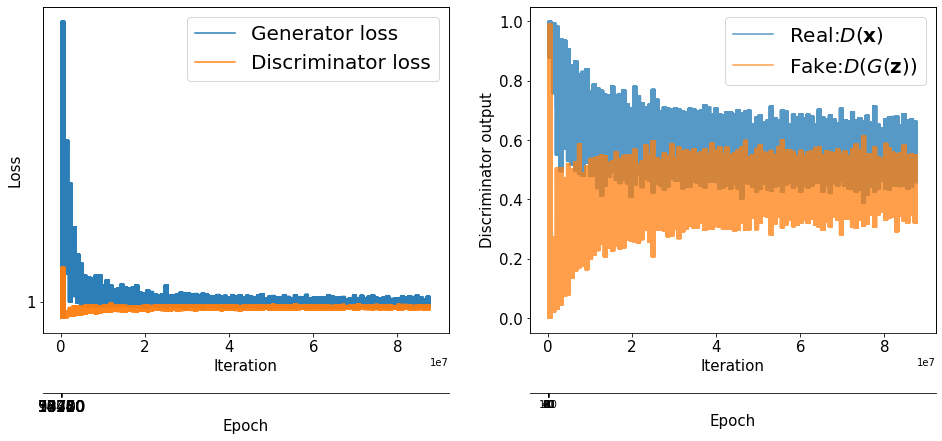

In [43]:
import itertools

fig= plt.figure(figsize=(16,6))

#plotting the losses
ax=fig.add_subplot(1,2,1)
g_losses=[item[0] for item in itertools.chain(*all_losses)]
d_losses=[item[1]/2.0 for item in itertools.chain(*all_losses)]
plt.plot(g_losses, label='Generator loss', alpha=0.95)
plt.plot(d_losses, label='Discriminator loss', alpha= 0.95)
plt.legend(fontsize=20)
ax.set_xlabel('Iteration',size=15)
ax.set_ylabel('Loss', size=15)

epochs= np.arange(1,101)
epoch2iter= lambda e: e*len(all_losses[-1])
epoch_ticks= [1,20,40,60,80,100]
newpos= [epoch2iter(e) for e in epoch_ticks]
ax2= ax.twiny()
ax2.set_xticks(newpos)
ax2.set_yticks(epoch_ticks)
ax2.xaxis.set_ticks_position('bottom')
ax2.xaxis.set_label_position('bottom')
ax2.spines['bottom'].set_position(('outward',60))
ax2.set_xlabel('Epoch',size=15)
ax2.set_xlim(ax.get_xlim())
ax.tick_params(axis= 'both',which='major',labelsize=15)
ax2.tick_params(axis='both', which='major', labelsize=15)

#plotting the output of the discriminator
ax=fig.add_subplot(1,2,2)
d_vals_real= [item[0] for item in itertools.chain(*all_d_vals)]
d_vals_fake= [item[1] for item in itertools.chain(*all_d_vals)]
plt.plot(d_vals_real, alpha=0.75, label= r'Real:$D(\mathbf{x})$')
plt.plot(d_vals_fake, alpha=0.75, label= r'Fake:$D(G(\mathbf{z}))$')
plt.legend(fontsize=20)
ax.set_xlabel('Iteration',size=15)
ax.set_ylabel('Discriminator output',size=15)
ax2= ax.twiny()
ax2.set_xticks(newpos)
ax2.set_xticklabels(epoch_ticks)
ax2.xaxis.set_ticks_position('bottom')
ax2.xaxis.set_label_position('bottom')
ax2.spines['bottom'].set_position(('outward',60))
ax2.set_xlabel('Epoch',size=15)
ax2.set_xlim(ax.get_xlim())
ax.tick_params(axis='both',which='major',labelsize=15)
ax.tick_params(axis='both',which='major',labelsize=15)
plt.show()

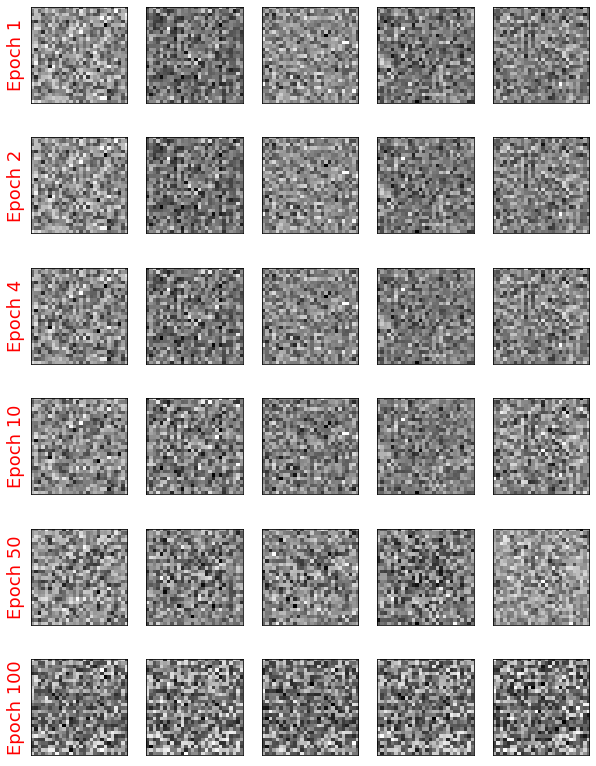

In [44]:
selected_epochs=[1,2,4,10,50,100]
fig=plt.figure(figsize=(10,14))
for i,e in enumerate(selected_epochs):
    for j in range(5):
        ax=fig.add_subplot(6,5,i*5+j+1)
        ax.set_xticks([])
        ax.set_yticks([])
        if j==0:
            ax.text(-0.06,0.5,'Epoch {}'.format(e), rotation=90, size=18, color='red', horizontalalignment='right',verticalalignment='center',transform=ax.transAxes)
        image= epoch_samples[e-1][j]
        ax.imshow(image,cmap='gray_r')
plt.show()

### Helper functions for GAN

In [73]:
def make_dcgan_generator(z_size=20,output_size=(7,7,128),n_filters=128,n_blocks=2):
    size_factor= 2**n_blocks
    hidden_size=(output_size[0]//size_factor, output_size[1]//size_factor)
    model= tf.keras.Sequential([
        tf.keras.layers.Input(shape=(z_size,)),
        tf.keras.layers.Dense(units=n_filters**np.prod(hidden_size),use_bias=False),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU(),
        tf.keras.layers.Reshape((hidden_size[0],hidden_size[1],n_filters)),
        tf.keras.layers.Conv2DTranspose(filters=n_filters,kernel_size=(5,5),strides=(1,1),padding='same',use_bias=False),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU()
    ])
    
    nf=n_filters
    for i in range(n_blocks):
        nf=nf//2
        model.add(tf.keras.layers.Conv2DTranspose(filters=nf,kernel_size=(5,5),strides=(2,2),padding='same',use_bias= False))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Conv2DTranspose(filters=output_size[2],kernel_size=(5,5),strides=(1,1),padding='same',use_bias=False,activation='tanh'))
    return model

In [100]:
def make_dcgan_discriminator(input_size=(28,28,1),n_filters=64,n_blocks=2):
    model= tf.keras.Sequential([
        tf.keras.layers.Input(shape=input_size),
        tf.keras.layers.Conv2D(filters=n_filters,kernel_size=5,strides=(1,1),padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU()
    ])
    nf=n_filters
    for i in range(n_blocks):
        nf=nf*2
        model.add(tf.keras.layers.Conv2D(filters=nf,kernel_size=(5,5),strides=(2,2),padding='same'))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.LeakyReLU())
        model.add(tf.keras.layers.Dropout(0.3))
        model.add(tf.keras.layers.Conv2D(filters=1,kernel_size=(7,7),padding='valid'))
    model.add(tf.keras.layers.Reshape((1,)))
    return model


In [90]:
mnist_bldr=tfds.builder('mnist')
mnist_bldr.download_and_prepare()
mnist= mnist_bldr.as_dataset(shuffle_files=False)

In [91]:
def preprocess(ex, mode='uniform'):
    image=ex['image']
    image=tf.image.convert_image_dtype(image,tf.float32)
    image=image*2-1.0
    if mode=='uniform':
        input_z= tf.random.uniform(shape=(z_size,),minval=-1.0, maxval=1.0)
    elif mode=='normal':
        input_z=tf.random.normal(shape=(z_size,))
    return input_z,image

In [94]:
gen_model= make_dcgan_generator()
gen_model.summary()

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_21 (Dense)             (None, 128)               2560      
_________________________________________________________________
batch_normalization_46 (Batc (None, 128)               512       
_________________________________________________________________
leaky_re_lu_50 (LeakyReLU)   (None, 128)               0         
_________________________________________________________________
reshape_9 (Reshape)          (None, 1, 1, 128)         0         
_________________________________________________________________
conv2d_transpose_21 (Conv2DT (None, 1, 1, 128)         409600    
_________________________________________________________________
batch_normalization_47 (Batc (None, 1, 1, 128)         512       
_________________________________________________________________
leaky_re_lu_51 (LeakyReLU)   (None, 1, 1, 128)       

### DCGAN model

In [95]:
num_epochs=100
batch_size=128
image_size=(28,28)
z_size=20
mode_x= 'uniform'
lambda_gp=10.0

In [96]:
#set up the dataset
mnist_trainset= mnist['train']
mnist_trainset= mnist_trainset.map(preprocess)
mnist_trainset= mnist_trainset.shuffle(10000)
mnist_trainset= mnist_trainset.batch(batch_size,drop_remainder=True)

In [101]:
#Set up the model
with tf.device(device_name):
    gen_model= make_dcgan_generator()
    gen_model.build(input_shape=(None,z_size))
    disc_model= make_dcgan_discriminator()
    disc_model.build(input_shape=(None, np.prod(image_size)))

ValueError: Negative dimension size caused by subtracting 7 from 4 for '{{node conv2d_50/Conv2D}} = Conv2D[T=DT_FLOAT, data_format="NHWC", dilations=[1, 1, 1, 1], explicit_paddings=[], padding="VALID", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true](dropout_22/cond/Identity, conv2d_50/Conv2D/ReadVariableOp)' with input shapes: [?,4,4,256], [7,7,256,1].

In [102]:
#left off at page 663